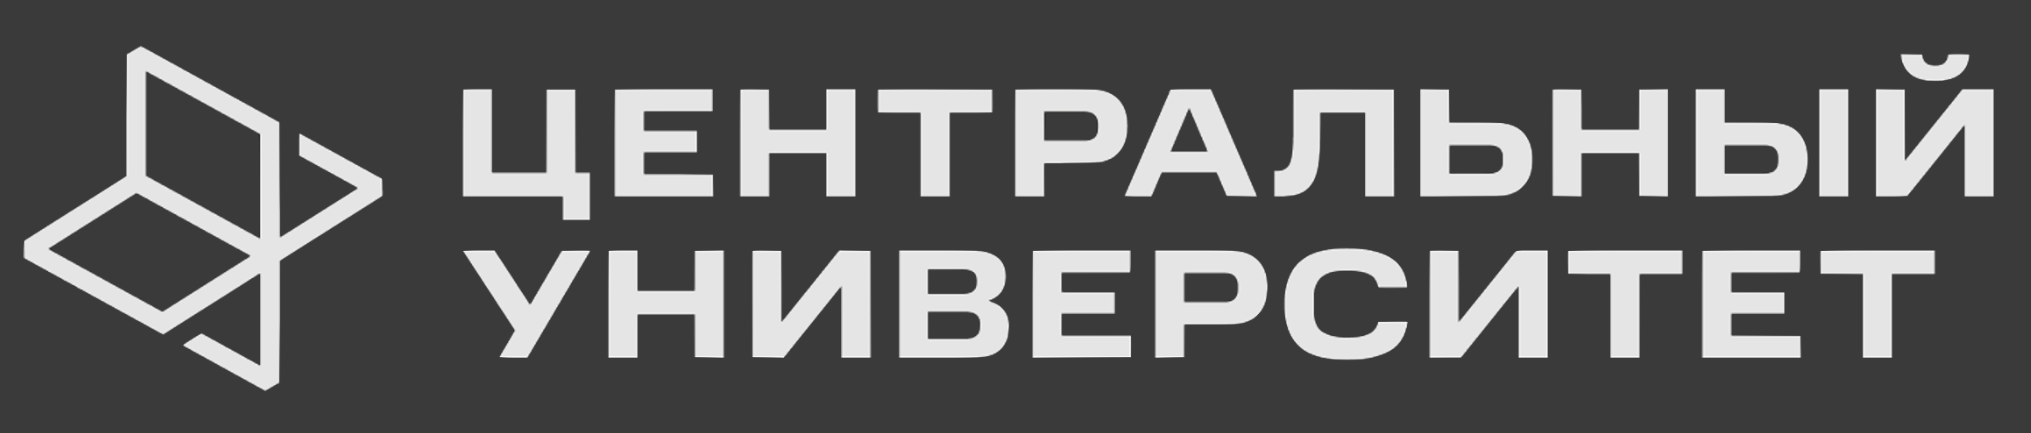

<hr style="border:2px solid gray">

## Домашнее задание 1 и домашнее задание 2. Задача детектирования и классификации объектов.


Скачиваем требуемые программные коды

In [ ]:
!git clone https://github.com/SergeyMalashenko/ObjectDetectionProblemFromScratch.git utils

Cloning into 'utils'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 24.75 KiB | 24.75 MiB/s, done.


Скачиваем требуемый набор данных

In [ ]:
!gdown 1rweRzB2fJpty-AK57mEGmUtomIlPiNBo

Downloading...
From (original): https://drive.google.com/uc?id=1rweRzB2fJpty-AK57mEGmUtomIlPiNBo
From (redirected): https://drive.google.com/uc?id=1rweRzB2fJpty-AK57mEGmUtomIlPiNBo&confirm=t&uuid=d58a7a64-97ae-44e7-a266-6938ddf16ed2
To: /content/dataset_gs198-05.tar.gz
100% 113M/113M [00:04<00:00, 25.4MB/s]


In [ ]:
%pip install torchmetrics torchview

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.0 MB/s eta 0:00:00


In [ ]:
#pragma dataset init ssd_data --size 1Gb

import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile


base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/f3OI8-OOlVlt1Q'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

#dist_path = '/home/jupyter/mnt/datasets/ssd_data/'
dist_path = '/content/'
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

In [ ]:
#!tar -xzf /home/jupyter/mnt/datasets/ssd_data/SSD-data/dataset_gs198-05.tar.gz
!tar -xzf /content/dataset_gs198-05.tar.gz
# Создастся папку dataset в хранилище сбоку
# С ним вам и нужно будет работать

---
## Формулировка задания

Задание состоит из двух частей, каждая из которых со своим дедлайном выдачи. Подробности смотрите в LMS

### <font color='DarkOrange'> **Первая часть (Лабораторная работа 1, ближайший дедлайн)**</font>
-  <font color='DarkOrange'> **[5 баллов]** </font> Воспользоваться материалами семинара и натренировать модель на основе `VGG16` на предлагаемом наборе.
- Самостоятельно разобраться с метрикой [`MAP`](https://torchmetrics.readthedocs.io/en/v0.8.2/detection/mean_average_precision.html)
- <font color='DarkOrange'> **[3 балла]** </font> Добавить вычисление метрики `MAP`, используя реализацию из пакета [`torchmetrics`](https://github.com/Lightning-AI/torchmetrics).
- <font color='DarkOrange'> **[2 балла]** </font> Постобработка предсказанных прямоугольников имеет несколько метапараметров `score_threshold` и `overlap_threshold`. Предлагается найти их оптимальные значения, которые позволяют получить максимальную величину `MAP` для уже натренированной модели.

In [ ]:
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torchvision
import colorsys
import random
import torch
import cv2

from matplotlib.patches import Polygon
from matplotlib         import patches, lines
from torch              import nn
from PIL                import Image

import albumentations as alb
import numpy          as np
import scipy          as sp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from torchvision.models import VGG16_Weights, ResNet18_Weights
from torchvision        import models
from torchview          import draw_graph

import torch.nn.init as init

class L2Norm(nn.Module):
    def __init__(self, n_channels, scale):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma      = scale or None
        self.eps        = 1e-10
        self.weight     = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight, self.gamma)

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).sum(dim=1, keepdim=True)) + self.eps
        x = torch.div(x, norm)
        x = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return x

class SSD_VGG16(nn.Module):
    def __init__(self, num_bboxes_s, num_labels = 3):
        super().__init__()

        self.num_bboxes_s = num_bboxes_s
        self.num_labels   = num_labels

        self.used_layer_id_s       = [21, 33, 37, 41, 45, 49] #
        self.norm_layer            = L2Norm(512, 20)

        base_layers       = self._build_base_layers ()
        extra_layers      = self._build_extra_layers()
        self.total_layers = base_layers + extra_layers

        self.conf_layers, self.loc_layers = self._build_conf_loc_layers()

    def _build_base_layers(self):
        backbone_model    = models.vgg16(weights=VGG16_Weights.DEFAULT)  #False

        base_layers = nn.ModuleList(list(backbone_model.features)[:-1])
        base_layers[16].ceil_mode = True

        pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        conv6 = nn.Conv2d( 512, 1024, kernel_size=3, padding=6, dilation=6)
        relu6 = nn.ReLU(inplace=True)
        conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        relu7 = nn.ReLU(inplace=True)

        nn.init.xavier_uniform_(conv6.weight)
        nn.init.zeros_         (conv6  .bias)
        nn.init.xavier_uniform_(conv7.weight)
        nn.init.zeros_         (conv7  .bias)

        base_layers.extend( [pool5, conv6, relu6, conv7, relu7] )

        return base_layers

    def _build_extra_layers(self):
        extra_layers = []

        conv8_1  = nn.Conv2d( 1024, 256, kernel_size=1, stride=1           )
        relu8_1  = nn.ReLU(inplace=True)
        conv8_2  = nn.Conv2d( 256, 512, kernel_size=3, stride=2, padding=1)
        relu8_2  = nn.ReLU(inplace=True)
        conv9_1  = nn.Conv2d( 512, 128, kernel_size=1, stride=1           )
        relu9_1  = nn.ReLU(inplace=True)
        conv9_2  = nn.Conv2d( 128, 256, kernel_size=3, stride=2, padding=1)
        relu9_2  = nn.ReLU(inplace=True)
        conv10_1 = nn.Conv2d( 256, 128, kernel_size=1, stride=1           )
        relu10_1 = nn.ReLU(inplace=True)
        conv10_2 = nn.Conv2d( 128, 256, kernel_size=3, stride=1           )
        relu10_2 = nn.ReLU(inplace=True)
        conv11_1 = nn.Conv2d( 256, 128, kernel_size=1                     )
        relu11_1 = nn.ReLU(inplace=True)
        conv11_2 = nn.Conv2d( 128, 256, kernel_size=3, stride=1           )
        relu11_2 = nn.ReLU(inplace=True)

        nn.init.xavier_uniform_(conv8_1 .weight)
        nn.init.zeros_         (conv8_1 .bias  )
        nn.init.xavier_uniform_(conv8_2 .weight)
        nn.init.zeros_         (conv8_2 .bias  )
        nn.init.xavier_uniform_(conv9_1 .weight)
        nn.init.zeros_         (conv9_1 .bias  )
        nn.init.xavier_uniform_(conv9_2 .weight)
        nn.init.zeros_         (conv9_2 .bias  )
        nn.init.xavier_uniform_(conv10_1.weight)
        nn.init.zeros_         (conv10_1.bias  )
        nn.init.xavier_uniform_(conv10_2.weight)
        nn.init.zeros_         (conv10_2.bias  )
        nn.init.xavier_uniform_(conv11_1.weight)
        nn.init.zeros_         (conv11_1.bias  )
        nn.init.xavier_uniform_(conv11_2.weight)
        nn.init.zeros_         (conv11_2.bias  )

        extra_layers = nn.ModuleList( [conv8_1, relu8_1, conv8_2, relu8_2, conv9_1, relu9_1, conv9_2, relu9_2, conv10_1, relu10_1, conv10_2, relu10_2, conv11_1, relu11_1, conv11_2, relu11_2] )
        return extra_layers

    def _build_conf_loc_layers(self):
        out_channels_s = [ self.total_layers[i].out_channels for i in self.used_layer_id_s ]

        conf_layers, loc_layers = [], []
        for i, j in enumerate(self.used_layer_id_s):
            conf_layer = nn.Conv2d( self.total_layers[j].out_channels, self.num_bboxes_s[i] * self.num_labels, kernel_size=3, padding=1)
            loc_layer  = nn.Conv2d( self.total_layers[j].out_channels, self.num_bboxes_s[i] * 4              , kernel_size=3, padding=1)

            nn.init.xavier_uniform_(conf_layer.weight)
            nn.init.zeros_         (conf_layer  .bias)
            nn.init.xavier_uniform_(loc_layer .weight)
            nn.init.zeros_         (loc_layer   .bias)

            conf_layers += [conf_layer]
            loc_layers  += [loc_layer ]

        conf_layers = nn.ModuleList(conf_layers)
        loc_layers  = nn.ModuleList(loc_layers )

        return conf_layers, loc_layers

    def forward(self, x, verbose=False):
        source_s, loc_s, conf_s = [], [], []
        print(self.total_layers)
        for i, current_layer in enumerate(self.total_layers, -1):
            x = current_layer(x)
            print(f"Output shape after layer {i}: {x.shape}")
            if i in self.used_layer_id_s:
                if i == 21:
                    s = self.norm_layer(x)
                else:
                    s = x
                source_s.append(s)
        for s, l, c in zip(source_s, self.loc_layers, self.conf_layers):
            conf_s.append(c(s).permute(0, 2, 3, 1).contiguous())
            loc_s .append(l(s).permute(0, 2, 3, 1).contiguous())
        conf_s = torch.cat([o.view(o.size(0), -1) for o in conf_s], 1)
        loc_s  = torch.cat([o.view(o.size(0), -1) for o in loc_s ], 1)

        conf_s = conf_s.view(conf_s.size(0), -1, self.num_labels)
        loc_s  = loc_s .view(loc_s .size(0), -1, 4              )

        return loc_s, conf_s


In [ ]:
class L2Norm(nn.Module):
    def __init__(self, n_channels, scale):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma      = scale or None
        self.eps        = 1e-10
        self.weight     = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight, self.gamma)

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).sum(dim=1, keepdim=True)) + self.eps
        x = torch.div(x, norm)
        x = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return x

class ExtraBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(128, out_channels, kernel_size=1, stride=1, padding=0)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x


class ResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.downsample = downsample
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if self.downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out



class SSD_ResNet18(nn.Module):
    def __init__(self, num_bboxes_s, num_labels=3):
        super().__init__()
        self.num_bboxes_s = num_bboxes_s
        self.num_labels = num_labels

        self.used_layer_id_s = [9, 10, 11, 12, 13]

        self.norm_layer = L2Norm(64, 20)

        self.resnet_layers = self._build_base_layers()
        self.extra_layers = self._build_extra_layers()

        self.total_layers = self.resnet_layers + self.extra_layers

        self.conf_layers, self.loc_layers = self._build_conf_loc_layers()


    def _build_base_layers(self):
        backbone_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        #base_layers = nn.ModuleList(list(backbone_model.children())[:-4] + [ResNetBlock(128, 256, stride=2, downsample=True), ResNetBlock(256, 256, stride=1, downsample=False)]) # Удаляем последние два слоя (полносвязный и усреднение)
        base_layers = nn.ModuleList(list(backbone_model.children())[:-3])
        #print(base_layers)
        return base_layers


    def _build_extra_layers(self):
        extra_layers = nn.ModuleList([ResNetBlock(256, 128, stride=2, downsample=True), ResNetBlock(128, 128, stride=1, downsample=False)] + [
            ExtraBlock(128, 64),
            ExtraBlock(64, 64),
            ExtraBlock(64, 64),
            ExtraBlock(64, 64),
            ExtraBlock(64, 64),
        ])
        #print(extra_layers)
        return extra_layers

    def _build_conf_loc_layers(self):
        out_channels_s = [ self.total_layers[i].out_channels for i in self.used_layer_id_s ]

        conf_layers, loc_layers = [], []
        for i, out_channels in enumerate(out_channels_s):
            conf_layer = nn.Conv2d(out_channels, self.num_bboxes_s[i] * self.num_labels, kernel_size=3, padding=1)
            loc_layer = nn.Conv2d(out_channels, self.num_bboxes_s[i] * 4, kernel_size=3, padding=1)

            nn.init.xavier_uniform_(conf_layer.weight)
            nn.init.zeros_         (conf_layer  .bias)
            nn.init.xavier_uniform_(loc_layer .weight)
            nn.init.zeros_         (loc_layer   .bias)

            conf_layers.append(conf_layer)
            loc_layers.append(loc_layer)
        return nn.ModuleList(conf_layers), nn.ModuleList(loc_layers)


    def forward(self, x):
        source_s, loc_s, conf_s = [], [], []
        for i, layer in enumerate(self.total_layers):
            x = layer(x)
            #print(f"Output shape after layer {i}: {x.shape}")
            if i in self.used_layer_id_s:
                if i == 9:
                    s = self.norm_layer(x)
                else:
                    s = x
                source_s.append(s)
        for s, l, c in zip(source_s, self.loc_layers, self.conf_layers):
            conf_s.append(c(s).permute(0, 2, 3, 1).contiguous())
            loc_s.append(l(s).permute(0, 2, 3, 1).contiguous())
        conf_s = torch.cat([o.view(o.size(0), -1) for o in conf_s], 1)
        loc_s = torch.cat([o.view(o.size(0), -1) for o in loc_s], 1)
        conf_s = conf_s.view(conf_s.size(0), -1, self.num_labels)
        loc_s = loc_s.view(loc_s.size(0), -1, 4)
        return loc_s, conf_s

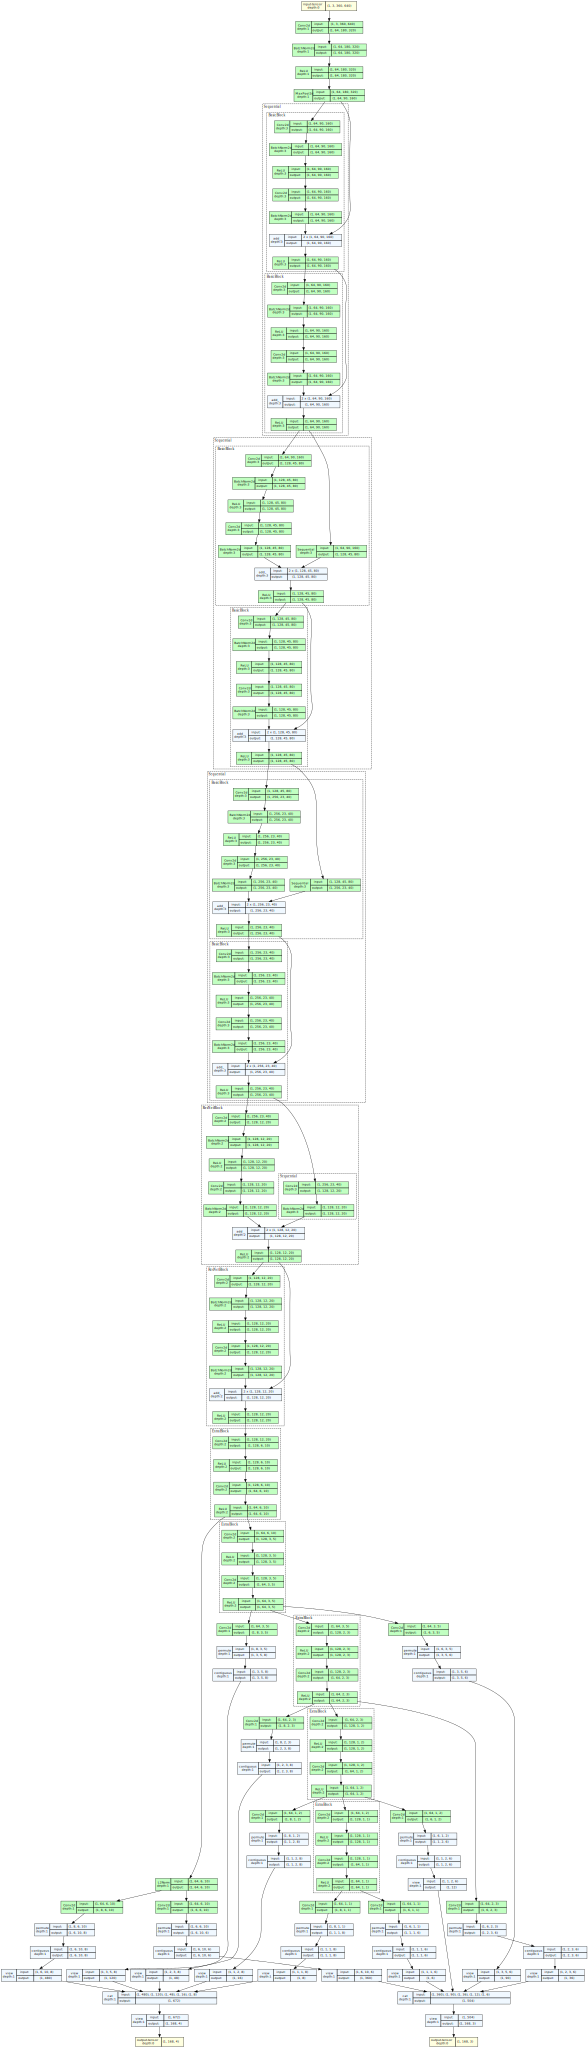

In [ ]:
num_bboxes_s = [2, 2, 2, 2, 2, 2]

model = SSD_ResNet18(num_bboxes_s, 3)
#model = SSD_VGG16(num_bboxes_s, 3)
model.eval()

input_data  = torch.randn(1,3,360, 640, dtype=torch.float, requires_grad=False)


output_locs, output_confs = model( input_data )

model_graph  = draw_graph(model, input_size=(1,3,360,640), expand_nested=True)
visual_graph = model_graph.visual_graph
visual_graph

In [ ]:
def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """
    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """
    boxes = torch.cat(( priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:], priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

In [ ]:
from argparse import Namespace

param_s = Namespace(
 dataset_root_dir='dataset',
 epochs = 30, batch_size = 8,
 checkpoint = None, output = 'output',
 multistep = [13, 22, 27],
 learning_rate = 1e-3, momentum = 0.9,
 weight_decay = 0.0005, warmup = None,
 num_workers = 4,
 seed = 42
)

In [ ]:
custom_config = {
        'num_classes'  : 3,
        #'feature_maps' : [(45,80), (22,40), (11,20), (6,10), (4,8), (2,6)], #VGG16 - 640x360
        'feature_maps' : [(6,10), (3,5), (2,3), (1,2), (1,1)],

        'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
        'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

        'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
        'num_priors'   : [6, 6, 6, 6, 4, 4],
        'variance'     : [0.1, 0.2],
        'clip'         :    True,

        'overlap_threshold': 0.4,
        'neg_pos_ratio'    :   3,

        #'model_name' : 'vgg16',
        'model_name' : 'resnet18'
}

In [ ]:
model = SSD_ResNet18(custom_config['num_priors'], custom_config['num_classes'])

In [ ]:
import sys
#Добавляем директорию, чтобы была возможность импортировать необходимые модули
sys.path.insert(0, 'utils')

from torchmetrics.detection.mean_ap import MeanAveragePrecision

from torch.optim.lr_scheduler import MultiStepLR
from utils.voc_dataloader     import get_train_dataloader, get_test_dataloader
from utils.prior_boxes        import detect_objects, prior_boxes
from utils.multibox_loss       import MultiBoxLoss

from tqdm        import tqdm

import time
import os


#model = SSD_VGG16(custom_config['num_priors'], custom_config['num_classes'])


def train_process(args, custom_config):
    torch.manual_seed(     args.seed)
    np.random.seed   (seed=args.seed)

    dataset_root_dir          = args.dataset_root_dir
    train_annotation_filename = os.path.join( dataset_root_dir, "ImageSets/Main/trainval.txt" )
    test_annotation_filename  = os.path.join( dataset_root_dir, "ImageSets/Main/test.txt"     )
    train_dataloader          = get_train_dataloader(dataset_root_dir, train_annotation_filename, args.batch_size, args.num_workers)
    test_dataloader           = get_test_dataloader (dataset_root_dir, test_annotation_filename , args.batch_size, args.num_workers)

    learning_rate = args.learning_rate

    if not os.path.exists(args.output):
        os.mkdir(args.output)


    prior_box_s = prior_boxes(custom_config)
    prior_box_s_gpu = prior_box_s.cuda()

    overlap_threshold = custom_config['overlap_threshold']
    neg_pos_ratio     = custom_config['neg_pos_ratio'    ]
    variance          = custom_config['variance']

    criterion = MultiBoxLoss( overlap_threshold, neg_pos_ratio, variance)
    model    .cuda()
    criterion.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay )
    scheduler = MultiStepLR(optimizer=optimizer, milestones=args.multistep, gamma=0.2)

    best_loc_loss, best_cls_loss, best_loss = np.inf, np.inf, np.inf
    train_loss_s, eval_loss_s, eval_map_s = [], [], []

    mean_ap = MeanAveragePrecision(box_format="cxcywh")

    for epoch in tqdm(list(range(args.epochs))):
        #Train model
        train_loc_loss, train_cls_loss, train_loss = 0, 0, 0
        model.train()
        for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(train_dataloader):
            if len(box_ss_cpu) > 0 and len(label_ss_cpu) > 0:
                image_s_gpu  =   image_s_cpu.cuda()
                label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
                box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]

                pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

                loc_loss, cls_loss = criterion( (pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))

                loss = loc_loss + cls_loss

                optimizer.zero_grad()
                loss     .backward ()
                optimizer.step     ()

                train_loc_loss += loc_loss.item()
                train_cls_loss += cls_loss.item()
                train_loss     += loss    .item()

        scheduler.step()
        train_loss_s.append(train_loss)

        eval_loc_loss, eval_cls_loss, eval_loss = 0, 0, 0
        model.eval()
        for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(test_dataloader):
            if len(box_ss_cpu) > 0 and len(label_ss_cpu) > 0:
                image_s_gpu = image_s_cpu.cuda()
                label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
                box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]

                pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)

                loc_loss, cls_loss = criterion( (pred_loc_ss_gpu, pred_conf_ss_gpu, prior_box_s_gpu), (label_ss_gpu, box_ss_gpu))
                loss = loc_loss + cls_loss

                eval_loc_loss += loc_loss.item()
                eval_cls_loss += cls_loss.item()
                eval_loss     += loss    .item()
        eval_loss_s.append(eval_loss)


        #Calculate metrics
        preds = []
        targets = []
        pred_box_ss, pred_score_ss, pred_label_ss = list(), list(), list()
        model.eval()
        with torch.no_grad():
            for i , (image_s_cpu, box_ss_cpu, label_ss_cpu) in enumerate(test_dataloader):
                image_s_gpu = image_s_cpu.cuda()
                #label_ss_gpu = [ label_s_cpu.cuda() for label_s_cpu in label_ss_cpu ]
                #box_ss_gpu   = [ box_s_cpu  .cuda() for box_s_cpu   in box_ss_cpu   ]

                pred_loc_ss_gpu, pred_conf_ss_gpu = model(image_s_gpu)
                pred_conf_ss_cpu = F.softmax(pred_conf_ss_gpu, dim=2).cpu()
                pred_loc_ss_cpu  = pred_loc_ss_gpu                   .cpu()
                prior_box_s_cpu  = prior_box_s_gpu                   .cpu()

                pred_box_ss, pred_label_ss, pred_conf_ss = detect_objects(pred_loc_ss_cpu, pred_conf_ss_cpu, prior_box_s_cpu, 3, 0.5, 0.1)

                preds.append(
                    {
                        "boxes": pred_box_ss[0],
                        "scores": pred_conf_ss[0],
                        "labels": pred_label_ss[0],
                    }
                )
                targets.append(
                    {
                        "boxes": box_ss_cpu[0],
                        "labels": label_ss_cpu[0],
                    }
                )
        metric = mean_ap(preds, targets)
        eval_map_s.append(metric["map"].item())

        #print('epoch[{}] | lr {:.5f} | loc_loss [{:.2f}/{:.2f}] | cls_loss [{:.2f}/{:.2f}] | total_loss [{:.2f}/{:.2f}] | map [{:.2f}/{:.2f}]'.format(epoch, scheduler.get_last_lr()[0], train_loc_loss, eval_loc_loss, train_cls_loss, eval_cls_loss, train_loss, eval_loss, metric["map"].item()))
        print('epoch[{}] | lr {:.5f} | loc_loss [{:.2f}/{:.2f}] | cls_loss [{:.2f}/{:.2f}] | total_loss [{:.2f}/{:.2f}] | map {:.2f}'.format(epoch, scheduler.get_last_lr()[0], train_loc_loss, eval_loc_loss, train_cls_loss, eval_cls_loss, train_loss, eval_loss, metric["map"].item()))
        if eval_loss < best_loss :
            torch.save(model.state_dict(), os.path.join(args.output, f"{custom_config['model_name']}.pth"))
            best_loc_loss, best_cls_loss, best_loss = eval_loc_loss, eval_cls_loss, eval_loss
    return model, prior_box_s, train_loss_s, eval_loss_s, eval_map_s

In [ ]:
model, prior_box_s, train_loss_s, eval_loss_s, eval_map_s = train_process(param_s, custom_config)

  3%|▎         | 1/30 [00:40<19:22, 40.08s/it]

epoch[0] | lr 0.00100 | loc_loss [571.21/20.87] | cls_loss [712.55/15.92] | total_loss [1283.76/36.79] | map 0.21


  7%|▋         | 2/30 [01:21<19:08, 41.00s/it]

epoch[1] | lr 0.00100 | loc_loss [396.32/14.63] | cls_loss [326.99/11.73] | total_loss [723.31/26.36] | map 0.38


 10%|█         | 3/30 [02:01<18:13, 40.49s/it]

epoch[2] | lr 0.00100 | loc_loss [285.55/10.80] | cls_loss [251.04/10.76] | total_loss [536.59/21.56] | map 0.51


 13%|█▎        | 4/30 [02:41<17:29, 40.37s/it]

epoch[3] | lr 0.00100 | loc_loss [227.25/7.84] | cls_loss [228.25/9.22] | total_loss [455.50/17.06] | map 0.55


 17%|█▋        | 5/30 [03:23<16:56, 40.68s/it]

epoch[4] | lr 0.00100 | loc_loss [187.79/7.37] | cls_loss [208.11/8.54] | total_loss [395.90/15.91] | map 0.54


 20%|██        | 6/30 [04:02<16:09, 40.38s/it]

epoch[5] | lr 0.00100 | loc_loss [167.56/6.89] | cls_loss [194.77/8.71] | total_loss [362.34/15.59] | map 0.68


 23%|██▎       | 7/30 [04:45<15:43, 41.04s/it]

epoch[6] | lr 0.00100 | loc_loss [149.25/6.74] | cls_loss [182.23/8.26] | total_loss [331.48/15.00] | map 0.65


 27%|██▋       | 8/30 [05:25<14:59, 40.87s/it]

epoch[7] | lr 0.00100 | loc_loss [139.10/5.25] | cls_loss [170.48/7.27] | total_loss [309.58/12.53] | map 0.74


 30%|███       | 9/30 [06:05<14:09, 40.47s/it]

epoch[8] | lr 0.00100 | loc_loss [132.17/6.11] | cls_loss [162.17/7.48] | total_loss [294.34/13.59] | map 0.65


 33%|███▎      | 10/30 [06:46<13:36, 40.84s/it]

epoch[9] | lr 0.00100 | loc_loss [121.55/5.46] | cls_loss [154.64/7.67] | total_loss [276.19/13.13] | map 0.68


 37%|███▋      | 11/30 [07:26<12:47, 40.41s/it]

epoch[10] | lr 0.00100 | loc_loss [118.40/5.08] | cls_loss [149.13/6.97] | total_loss [267.54/12.04] | map 0.69


 40%|████      | 12/30 [08:06<12:05, 40.31s/it]

epoch[11] | lr 0.00100 | loc_loss [113.26/5.21] | cls_loss [142.95/6.96] | total_loss [256.22/12.16] | map 0.71


 43%|████▎     | 13/30 [08:48<11:33, 40.77s/it]

epoch[12] | lr 0.00020 | loc_loss [110.06/4.49] | cls_loss [139.27/6.67] | total_loss [249.33/11.17] | map 0.71


 47%|████▋     | 14/30 [09:28<10:49, 40.56s/it]

epoch[13] | lr 0.00020 | loc_loss [96.66/4.38] | cls_loss [127.95/6.54] | total_loss [224.61/10.92] | map 0.74


 50%|█████     | 15/30 [10:07<10:03, 40.22s/it]

epoch[14] | lr 0.00020 | loc_loss [93.37/4.08] | cls_loss [124.18/6.12] | total_loss [217.55/10.20] | map 0.73


 53%|█████▎    | 16/30 [10:47<09:21, 40.09s/it]

epoch[15] | lr 0.00020 | loc_loss [90.86/4.57] | cls_loss [122.15/6.62] | total_loss [213.01/11.19] | map 0.78


 57%|█████▋    | 17/30 [11:27<08:41, 40.08s/it]

epoch[16] | lr 0.00020 | loc_loss [91.06/4.25] | cls_loss [120.66/6.44] | total_loss [211.72/10.69] | map 0.68


 60%|██████    | 18/30 [12:08<08:03, 40.27s/it]

epoch[17] | lr 0.00020 | loc_loss [90.87/4.14] | cls_loss [119.95/6.03] | total_loss [210.82/10.17] | map 0.75


 63%|██████▎   | 19/30 [12:47<07:19, 39.91s/it]

epoch[18] | lr 0.00020 | loc_loss [88.04/4.10] | cls_loss [118.81/6.68] | total_loss [206.85/10.78] | map 0.75


 67%|██████▋   | 20/30 [13:27<06:38, 39.84s/it]

epoch[19] | lr 0.00020 | loc_loss [87.40/4.61] | cls_loss [118.52/6.59] | total_loss [205.91/11.21] | map 0.76


 70%|███████   | 21/30 [14:09<06:04, 40.47s/it]

epoch[20] | lr 0.00020 | loc_loss [86.48/4.67] | cls_loss [114.94/6.60] | total_loss [201.41/11.27] | map 0.77


 73%|███████▎  | 22/30 [14:49<05:22, 40.32s/it]

epoch[21] | lr 0.00004 | loc_loss [84.51/4.10] | cls_loss [115.21/6.58] | total_loss [199.72/10.69] | map 0.76


 77%|███████▋  | 23/30 [15:36<04:57, 42.47s/it]

epoch[22] | lr 0.00004 | loc_loss [83.82/3.55] | cls_loss [111.51/5.54] | total_loss [195.32/9.09] | map 0.77


 80%|████████  | 24/30 [16:22<04:21, 43.60s/it]

epoch[23] | lr 0.00004 | loc_loss [85.21/3.99] | cls_loss [112.66/6.20] | total_loss [197.87/10.19] | map 0.80


 83%|████████▎ | 25/30 [17:03<03:33, 42.69s/it]

epoch[24] | lr 0.00004 | loc_loss [83.27/4.40] | cls_loss [111.28/6.27] | total_loss [194.54/10.67] | map 0.79


 87%|████████▋ | 26/30 [17:43<02:48, 42.02s/it]

epoch[25] | lr 0.00004 | loc_loss [81.79/4.15] | cls_loss [109.59/5.96] | total_loss [191.39/10.11] | map 0.75


 90%|█████████ | 27/30 [18:25<02:05, 41.99s/it]

epoch[26] | lr 0.00001 | loc_loss [83.22/3.88] | cls_loss [110.90/5.95] | total_loss [194.12/9.83] | map 0.78


 93%|█████████▎| 28/30 [19:05<01:22, 41.42s/it]

epoch[27] | lr 0.00001 | loc_loss [82.51/3.88] | cls_loss [109.51/6.05] | total_loss [192.02/9.93] | map 0.77


 97%|█████████▋| 29/30 [19:47<00:41, 41.43s/it]

epoch[28] | lr 0.00001 | loc_loss [82.51/4.49] | cls_loss [108.98/6.69] | total_loss [191.49/11.18] | map 0.72


100%|██████████| 30/30 [20:29<00:00, 40.99s/it]

epoch[29] | lr 0.00001 | loc_loss [82.14/4.19] | cls_loss [110.30/6.07] | total_loss [192.44/10.26] | map 0.73


resnet18 обучаетсся до тех же лоссов быстрее, нежели vgg16. скорость обучения - приемлема, в отличие от vgg16))

map почему-то выше при тех же порядков cls_loss и loc_loss в сравнении с vgg16


подниму чутка overlap_threshold

In [ ]:
custom_config = {
        'num_classes'  : 3,
        #'feature_maps' : [(45,80), (22,40), (11,20), (6,10), (4,8), (2,6)], #VGG16 - 640x360
        'feature_maps' : [(6,10), (3,5), (2,3), (1,2), (1,1)],

        'min_sizes'    : [0.10, 0.20, 0.37, 0.54, 0.71, 1.00],
        'max_sizes'    : [0.20, 0.37, 0.54, 0.71, 1.00, 1.05],

        'aspect_ratios': [[2, 3], [2, 3], [2, 3], [2, 3], [2], [2]],
        'num_priors'   : [6, 6, 6, 6, 4, 4],
        'variance'     : [0.1, 0.2],
        'clip'         :    True,

        'overlap_threshold': 0.45,
        'neg_pos_ratio'    :   3,

        #'model_name' : 'vgg16',
        'model_name' : 'resnet18'
}

In [ ]:
model, prior_box_s, train_loss_s, eval_loss_s, eval_map_s = train_process(param_s, custom_config)

  3%|▎         | 1/30 [00:39<19:18, 39.94s/it]

epoch[0] | lr 0.00100 | loc_loss [96.63/4.61] | cls_loss [141.44/6.98] | total_loss [238.07/11.59] | map 0.68


  7%|▋         | 2/30 [01:20<18:53, 40.49s/it]

epoch[1] | lr 0.00100 | loc_loss [90.11/4.20] | cls_loss [132.36/7.30] | total_loss [222.47/11.50] | map 0.74


 10%|█         | 3/30 [02:01<18:21, 40.80s/it]

epoch[2] | lr 0.00100 | loc_loss [86.52/4.32] | cls_loss [126.87/6.54] | total_loss [213.39/10.86] | map 0.73


 13%|█▎        | 4/30 [02:42<17:35, 40.59s/it]

epoch[3] | lr 0.00100 | loc_loss [84.55/3.74] | cls_loss [122.11/6.68] | total_loss [206.66/10.42] | map 0.67


 17%|█▋        | 5/30 [03:24<17:05, 41.04s/it]

epoch[4] | lr 0.00100 | loc_loss [82.08/4.00] | cls_loss [115.35/6.53] | total_loss [197.42/10.53] | map 0.77


 20%|██        | 6/30 [04:03<16:15, 40.63s/it]

epoch[5] | lr 0.00100 | loc_loss [77.22/4.25] | cls_loss [116.37/7.10] | total_loss [193.58/11.36] | map 0.76


 23%|██▎       | 7/30 [04:44<15:32, 40.54s/it]

epoch[6] | lr 0.00100 | loc_loss [74.32/4.02] | cls_loss [108.96/6.46] | total_loss [183.28/10.47] | map 0.74


 27%|██▋       | 8/30 [05:24<14:46, 40.31s/it]

epoch[7] | lr 0.00100 | loc_loss [73.75/3.60] | cls_loss [103.64/6.47] | total_loss [177.39/10.07] | map 0.76


 30%|███       | 9/30 [06:03<14:01, 40.07s/it]

epoch[8] | lr 0.00100 | loc_loss [73.99/3.91] | cls_loss [101.40/6.51] | total_loss [175.39/10.42] | map 0.69


 33%|███▎      | 10/30 [06:45<13:30, 40.53s/it]

epoch[9] | lr 0.00100 | loc_loss [67.88/4.02] | cls_loss [96.88/7.18] | total_loss [164.76/11.21] | map 0.72


 37%|███▋      | 11/30 [07:24<12:44, 40.25s/it]

epoch[10] | lr 0.00100 | loc_loss [70.19/4.09] | cls_loss [94.70/7.04] | total_loss [164.89/11.13] | map 0.78


 40%|████      | 12/30 [08:06<12:09, 40.55s/it]

epoch[11] | lr 0.00100 | loc_loss [69.14/4.37] | cls_loss [91.88/7.07] | total_loss [161.03/11.45] | map 0.77


 43%|████▎     | 13/30 [08:45<11:25, 40.35s/it]

epoch[12] | lr 0.00020 | loc_loss [70.23/3.73] | cls_loss [91.06/6.68] | total_loss [161.30/10.41] | map 0.75


 47%|████▋     | 14/30 [09:26<10:46, 40.41s/it]

epoch[13] | lr 0.00020 | loc_loss [58.17/3.45] | cls_loss [81.02/6.19] | total_loss [139.19/9.63] | map 0.78


 50%|█████     | 15/30 [10:06<10:05, 40.35s/it]

epoch[14] | lr 0.00020 | loc_loss [56.31/3.46] | cls_loss [76.21/5.76] | total_loss [132.52/9.22] | map 0.76


 53%|█████▎    | 16/30 [10:45<09:20, 40.02s/it]

epoch[15] | lr 0.00020 | loc_loss [54.78/4.01] | cls_loss [74.36/6.27] | total_loss [129.14/10.28] | map 0.80


 57%|█████▋    | 17/30 [11:27<08:46, 40.47s/it]

epoch[16] | lr 0.00020 | loc_loss [54.19/3.54] | cls_loss [72.58/5.79] | total_loss [126.77/9.33] | map 0.69


 60%|██████    | 18/30 [12:07<08:02, 40.23s/it]

epoch[17] | lr 0.00020 | loc_loss [53.50/3.74] | cls_loss [73.10/6.33] | total_loss [126.60/10.06] | map 0.76


 63%|██████▎   | 19/30 [12:46<07:19, 39.96s/it]

epoch[18] | lr 0.00020 | loc_loss [53.55/3.50] | cls_loss [70.42/6.91] | total_loss [123.97/10.41] | map 0.77


 67%|██████▋   | 20/30 [13:27<06:41, 40.16s/it]

epoch[19] | lr 0.00020 | loc_loss [51.93/3.64] | cls_loss [69.24/6.53] | total_loss [121.17/10.18] | map 0.77


 70%|███████   | 21/30 [14:07<06:01, 40.21s/it]

epoch[20] | lr 0.00020 | loc_loss [52.16/3.65] | cls_loss [68.08/6.09] | total_loss [120.23/9.74] | map 0.77


 73%|███████▎  | 22/30 [14:48<05:23, 40.47s/it]

epoch[21] | lr 0.00004 | loc_loss [51.30/3.46] | cls_loss [67.50/6.09] | total_loss [118.80/9.55] | map 0.75


 77%|███████▋  | 23/30 [15:27<04:40, 40.04s/it]

epoch[22] | lr 0.00004 | loc_loss [50.95/3.01] | cls_loss [66.03/5.67] | total_loss [116.98/8.68] | map 0.78


 80%|████████  | 24/30 [16:07<04:00, 40.11s/it]

epoch[23] | lr 0.00004 | loc_loss [50.01/3.26] | cls_loss [66.31/5.86] | total_loss [116.32/9.11] | map 0.82


 83%|████████▎ | 25/30 [16:47<03:19, 39.92s/it]

epoch[24] | lr 0.00004 | loc_loss [49.31/3.59] | cls_loss [63.61/6.07] | total_loss [112.92/9.66] | map 0.78


 87%|████████▋ | 26/30 [17:26<02:39, 39.77s/it]

epoch[25] | lr 0.00004 | loc_loss [48.71/3.54] | cls_loss [64.99/6.54] | total_loss [113.71/10.07] | map 0.77


 90%|█████████ | 27/30 [18:06<01:59, 39.80s/it]

epoch[26] | lr 0.00001 | loc_loss [49.80/3.33] | cls_loss [65.08/6.38] | total_loss [114.88/9.71] | map 0.80


 93%|█████████▎| 28/30 [18:45<01:19, 39.69s/it]

epoch[27] | lr 0.00001 | loc_loss [49.97/3.45] | cls_loss [63.35/5.98] | total_loss [113.31/9.44] | map 0.76


 97%|█████████▋| 29/30 [19:26<00:39, 39.92s/it]

epoch[28] | lr 0.00001 | loc_loss [49.78/3.90] | cls_loss [62.50/6.76] | total_loss [112.28/10.65] | map 0.76


100%|██████████| 30/30 [20:05<00:00, 40.19s/it]

epoch[29] | lr 0.00001 | loc_loss [48.66/3.72] | cls_loss [64.56/5.72] | total_loss [113.22/9.44] | map 0.76


In [ ]:
checkpoint = f"/home/jupyter/datasphere/project/output_best_model/vgg16-3.pth"
checkpoint = f'/content/output/resnet18.pth'
state_dict = torch.load(checkpoint, map_location=None if torch.cuda.is_available() else 'cpu')
model.load_state_dict(state_dict)
model.to(device)
model.eval()

SSD_ResNet18(
  (norm_layer): L2Norm()
  (resnet_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
import random
import glob

test_image_s = random.sample( glob.glob("dataset/JPEGImages/*.jpg"), 9 )

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from torchvision.utils            import draw_bounding_boxes

VOC_CLASSES = ('background','license_plate','car')

overlap_threshold = 0.25
conf_threshold    = 0.05
num_classes       = 3

fig, ax = plt.subplots(nrows=3, ncols=3, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(300, 200))

for index, image_filename in enumerate(test_image_s):
    i = index // 3
    j = index % 3

    source_image_numpy = cv2.imread(image_filename)
    source_image_numpy = cv2.cvtColor(source_image_numpy, cv2.COLOR_BGR2RGB)

    source_image_numpy = np.transpose(source_image_numpy.astype(np.float32) / 255., axes=[2,0,1])

    source_image_cpu   = torch.from_numpy(source_image_numpy)
    source_image_gpu   = source_image_cpu.to(device)

    source_height, source_width = source_image_cpu.shape[1], source_image_cpu.shape[2]

    with torch.no_grad():
        loc, conf = model(source_image_gpu.unsqueeze(0))
        conf, loc = F.softmax(conf, dim=2).cpu(), loc.cpu()

    target_box_ss, target_label_ss, target_conf_ss = detect_objects(loc, conf, prior_box_s, num_classes, overlap_threshold, conf_threshold)
    target_box_s, target_label_s, target_conf_s = target_box_ss[0], target_label_ss[0], target_conf_ss[0]

    if torch.numel(target_box_s)>0 and torch.numel(target_label_s)>0 and torch.numel(target_conf_s)>0 :
        target_class_s = [VOC_CLASSES[label] for label in target_label_s.tolist() ]

        target_image_cpu   = torch.from_numpy(source_image_numpy * 255).to(torch.uint8)
        target_box_s       = target_box_s * torch.as_tensor([[source_width, source_height, source_width, source_height]])

        target_image_cpu   = draw_bounding_boxes(target_image_cpu, target_box_s, labels=target_class_s, colors='red', width=3)
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()
    else:
        target_image_numpy = target_image_cpu.permute([1,2,0]).numpy()

    ax[i][j].imshow(target_image_numpy )
    ax[i][j].axis('off')
plt.show()



### <font color='DarkOrange'> **Вторая часть (Лабораторная работа 2, крайний дедлайн)**</font>
- <font color='DarkOrange'> **[3 баллa]** </font> Воспользоваться материалами семинара разработать модель на основе `ResNet18` архитектуры.
- <font color='DarkOrange'> **[3 балла]** </font>Натренировать модель на основе `ResNet18` архитектуры.
- <font color='DarkOrange'> **[1 балл]** </font>Сравнить скорость работы моделей, основаных на `VGG16` и `ResNet18`.
- <font color='DarkOrange'> **[1 балл]** </font>Сравнить между собой метрики `MAP` для натренированных моделей, основаных на `VGG16` и `ResNet18`.
- <font color='DarkOrange'> **[2 балла]** </font>Визуализация результатов и описание проведенных экспериментов, выводы.

### <font color='MediumSeaGreen'> **Бонусы** </font>
- Применяются для каждой части отдельно
- <font color='MediumSeaGreen'> **[0.5 балла]** </font> Бонус можно получить за визуализацию результатов  в wandb.
- <font color='MediumSeaGreen'> **[до 5 баллов]** </font>Бонус можно получить за попытки реализовать свою архитектуру: например на семинаре мы цепляли пару сверточных слоев, чтобы получить предсказания для поправок `prior_boxes` и `scores` классов, попробуйте реализовать что-то посложнее.
---

<font color='OrangeRed'>**Внимание!**</font> мы тренируем модели на три класса `car, license_plate, background`, поэтому внесите исправления в файле `voc_dataset.py`

<font color='OrangeRed'>**Внимание!**</font> Сохраняйте все итоговые, и, лучше, промежуточные результаты обучения и веса и архитуктуры моделей! Данные модели пригодятся вам в дальнейшем при построении целостного проекта!

## Архитектура модели на базе `VGG16`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABfYAAAPzCAIAAAB6AsrzAACAAElEQVR4XuydB3gUxfvHIYHQexOk
I4igiAXsBRC7oiJYf6KiIHZRERVEUKqASu9VWiAhufQCBEISyobQQUSRpvRe7PN/Zycs4fZ2727f
WRj+977P98lz2eztfPLO7N7M93ZmCzEKCgoKCgoKCgoKCgoKCgoKiss8CnlvoKCgoKCgoKCgoKCg
oKCgoKC43IIsHgoKCgoKCgoKCgoKCgoKCorLPsjioaCgoKCgoKCgoKCgoKCgoLjsgyweCgoKCgoK
CgoKCgoKCgoKiss+yOKhoKCgoKCgoKCgoKCgoKCguOyDLB4KCgoKCgoKCgoKCgoKCgqKyz7I4qGg
oKCgoKCgoKCgoKCgoKC47IMsHgoKCgoKCgoKCgoKCgoKCorLPsjioaCgoKCgoKCgoKCgoKCgoLjs
gyweCgoKCgoKCgoKCgoKCgoKiss+yOKhoKCgoKCgoKCgoKCgoKCguOyDLB4KCgoKCgoKCgoKCgoK
CgqKyz7I4qGgoKCgoKCgoKCgoKCgoKC47IMsHgoKCgoKCgoKCgoKCgoKCorLPsjioaCgoKCgoKCg
+P8chdwM78KCDO/DSQ3vwoIP7yNKDe/Cggzvw0kN78KCD+8jSg3vwoIM78NJDe/Cgg/vI0oN78KC
DO/DSQ3vwoIP7yNKDe/Cggzvw0kN78KCD+8jSg3vwlwO+eX9999/8PPf//77+99/LoL+1YsThQYS
5/D+NR/KDYniAsdjYk/4+fffF0P//nu+0ABC5ewZO5uP44b++Y+nLkA2nmGx5z//eFeBG4JSjIYU
WKhcs+zcnv+ojafsRY/HxWx+IIfNT9EEqtz81GX7T+mLnvGPmP9HlxRE6vS4qDX7XxB4/+nBLhZb
cB+1tsF72JrmhvB9dziC90ElCc/G1MZTmY2pjacyG1MbT2U2pjaeymxMebygQn55ove898zh2N9W
Ju/LTXJNcHAoYvfpg0ahgYTYc8vxPTEu44Hifl917K9TLKjeidjz0CGWkMBSU11UWhqLj2e//MKL
E0ZPACGy9/PJ393OHhzc89vKA38cNwr1GyLJp/4+m/i7BjIfU5ZEw1t3bAcLmO38aGflSpaY6F0X
cpWczBYv5gMeUW5gIf6RbSf3ul2zSbxmVx36k9ds4OeFwNOObve4jActJ3nfmrP//MWCx9t5+oDb
2RNt7/ezR4xCAw1xjufl8QsLnPvmZiNLKSn8+GfP8uICJrzICfwtyASKPTcc3+n2hxoo4XftxN9n
WMDNT7CtOrLtIpwaqfvy/vz3bxYgm3HRy852/aKXlMSWLs0vLhC2c/8C/DvwT7n6eSEU//vq40F2
BsSeKw//CBdM8wElCppc2v61f//LPzICwTMsnqUHN8L/ZT6gRMHxoRRRqDdH8MF72N69bjnC990V
H1eojKcyG1MbT2U2pjaeymxMbTyV2ZjyeEGF/PL+0ccSu08fjNyzHDrEMa4JDh65J/PXU/uNQgMJ
sefGYzvn7cl0FQ+0YG/WkT9PMj68ChQvfyR24ACLjmZxcS4qPp5FRbGffuLFCTsggBDZ23Zir9vZ
g4PP37N839mjRqF+QyT55F9nFu7NAZmPKUt6w1uee2Q7C5iNV6vYc/lytnChd13IVWwsd3n+5iOx
wM078Y9sObHb7ZqN4TWbdeCPYyyY80Lg5Rz+cb7LVxVoObG/rTrz958seLxfTu1zO3ui7e09c8go
NNAQ5/jq1fzCAue+udnIksfDj3+GmxTBNr+LlsA9QSZQ7Jl39Be3P9RA0Xtzjv91mgXc/ARb1qEt
F+HUiPtt9R+6+xkQm3HRy8hw/aIXE8ONRVFcIGzn/gX4d+CfcvXzQihqb/bRIDsDYs/Mg5vhgmk+
oERBk4v/XfvrH/6REQjev3rAi7T9a+H/Mh9QouD4UIoo1Jsj+OA9bO9etxzh++6KjytUxlOZjamN
pzIbUxtPZTamNp7KbEx5vKBCfnniS0XoQy/Ymx33+yqPa4KDL9ibtfP0AaPQQELsuen4rvl7s1zF
A0X/lnM0yC/u8r+BPHiQ91kTElxUYiLvdm/nPkWAfWJ2Lns/nfzN7ezBwaFvt18YAYFlz7iLJ1Yf
yJmPKUt6w8tec/RnFjDbBV9ox8Z614VcwYAnNdXZXTxbT+5xu2Y9vGZzDjq6i2flkW1RLl9VoOXE
/b7a2V08O07vdzt7ou39dvawUWigIc5x+JSBCwuc++ZmI0vx8fz4ju7iuWgJ3BtkAsWea4/tcPtD
DQTDWgd38eQc3noRTo2E3zUnd/EsW+b6Rc/jYYsW5RcXCNu5fwH+HfinXP28EFr424pgb+kVe2Yd
2gIXTPMBJQqaXOK+XAd38Sw6sA7+L/MBJQqOD6WIQr05gg/ew/budcsRvu+u+LhCZTyV2ZjaeCqz
MbXxVGZjauOpzMaUxwsq5JdHFo8hsngciywe5yKLByGyeLAiiwcnsniciCwehMjiwQvfd1d8XKEy
nspsTG08ldmY2ngqszG18VRmY8rjBRXyyyOLxxBZPI5FFo9zkcWDEFk8WJHFgxNZPE5EFg9CZPHg
he+7Kz6uUBlPZTamNp7KbExtPJXZmNp4KrMx5fGCCvnlkcVjiCwexyKLx7nI4kGILB6syOLBiSwe
JyKLByGyePDC990VH1eojKcyG1MbT2U2pjaeymxMbTyV2ZjyeEGF/PLI4jFEFo9jkcXjXGTxIEQW
D1Zk8eBEFo8TkcWDEFk8eOH77oqPK1TGU5mNqY2nMhtTG09lNqY2nspsTHm8oEJ+eWTxGCKLx7HI
4nEusngQIosHK7J4cCKLx4nI4kGILB688H13xccVKuOpzMbUxlOZjamNpzIbUxtPZTamPF5QIb88
sngMkcXjWGTxOBdZPAiRxYMVWTw4kcXjRGTxIEQWD174vrvi4wqV8VRmY2rjqczG1MZTmY2pjacy
G1MeL6iQXx5ZPIbI4nEssniciywehMjiwYosHpzI4nEisngQIosHL3zfXfFxhcp4KrMxtfFUZmNq
46nMxtTGU5mNKY8XVMgvjyweQ2TxOBZZPM5FFg9CZPFgRRYPTmTxOBFZPAiRxYMXvu+u+LhCZTyV
2ZjaeCqzMbXxVGZjauOpzMaUxwsq5JdHFo8hsngciywe5yKLByGyeLAiiwcnsniciCwehMjiwQvf
d1d8XKEynspsTG08ldmY2ngqszG18VRmY8rjBRXyyyOLxxBZPI5FFo9zkcWDEFk8WJHFgxNZPE5E
Fg9CZPHghe+7Kz6uUBlPZTamNp7KbExtPJXZmNp4KrMx5fGCCvnlkcVjiCwexyKLx7nI4kGILB6s
yOLBiSweJyKLByGyePDC990VH1eojKcyG1MbT2U2pjaeymxMbTyV2ZjyeEGF/PLI4jFEFo9jkcXj
XGTxIEQWD1Zk8eBEFo8TkcWDEFk8eOH77oqPK1TGU5mNqY2nMhtTG09lNqY2nspsTHm8oEJ+eWTx
GCKLx7HI4nEusngQIosHK7J4cCKLx4nI4kGILB688H13xccVKuOpzMbUxlOZjamNpzIbUxtPZTam
PF5QIb88sngMkcXjWGTxOBdZPAiRxYMVWTw4kcXjRGTxIEQWD174vrvi4wqV8VRmY2rjqczG1MZT
mY2pjacyG1MeL6iQXx5ZPIbI4nEssniciywehMjiwYosHpzI4nEisngQIosHL3zfXfFxhcp4KrMx
tfFUZmNq46nMxtTGU5mNKY8XVMgvjyweQ2TxOBZZPM5FFg9CZPFgRRYPTmTxOBFZPAiRxYMXvu+u
+LhCZTyV2ZjaeCqzMbXxVGZjauOpzMaUxwsq5JdHFo8hsngciywe5yKLByGyeLAiiwcnsniciCwe
hMjiwQvfd1d8XKEynspsTG08ldmY2ngqszG18VRmY8rjBRXyyyOLxxBZPI5FFo9zkcWDEFk8WJHF
gxNZPE5EFg9CZPHghe+7Kz6usMLrM7VPRLEIs0qUKlGjXo1HOz0auSnS/K6CwuNZseGFZ2Nq46nM
xtTGU5mNqY2nMhtTHi+okF8eWTyGyOJxLLJ4nIssHoTI4sGKLB6cyOJxIrJ4ECKLBy98313xcYUV
3sjkkbc9cJtZLVq3qNu4LryrWIlik5dPNr9RIp4VG154NqY2nspsTG08ldmY2ngqszHl8YIK+eWR
xWOILB7HIovHucjiQYgsHqzI4sGJLB4nIosHIbJ48ML33RUfVzjDi9wUWfXKqo2aNzL/yRAezxlb
IMKzMbXxVGZjauOpzMbUxlOZjSmPF1TIL48sHkNk8TgWWTzORRYPQmTxYEUWD05k8TgRWTwIkcWD
F77vrvi4wjFevxn94L1Je5PMfxLC4zlm8ys8G1MbT2U2pjaeymxMbTyV2ZjyeEGF/PLI4jFEFo9j
kcXjXGTxIEQWD1Zk8eBEFo8TkcWDEFk8eOH77oqPKxzjzV0/F947Y9UM85+E8HiO2fwKz8bUxlOZ
jamNpzIbUxtPZTamPF5QIb88sngMkcXjWGTxOBdZPAiRxYMVWTw4kcXjRGTxIEQWD174vrvi4wrH
eBOXTYT3zlk3x/wnITyeDRtyNWg8G7PFQwqPpzIbUxtPZTamNp7KbEx5vKBCfnlk8Rgii8exyOJx
LrJ4ECKLByuyeHAii8eJyOJBiCwevPB9d8XHFY7xOr7dMaJYRPbZbPOfhPB4NmzI1aDxbMwWDyk8
nspsTG08ldmY2ngqszHl8YIK+eWRxWOILB7HIovHucjiQYgsHqzI4sGJLB4nIosHIbJ48ML33RUf
V1jhZRzLWLBlgVnzNswbmTzyqa5PFS5cuP0b7c1vlIhnxeZXfleDxrMxBJ5f4fFUZmNq46nMxtTG
U5mNKY8XVMgvjyweQ2TxOBZZPM5FFg9CZPFgRRYPTmTxOBFZPAiRxYMXvu9uM65QebZRr4m9CtnG
Pe3uWX56ufmNEvEKWbAFIvvVoPFsDIdnLzyeymxMbTyV2ZjaeCqzMeXxggr55ZHFY4gsHscii8e5
yOJBiCwerMjiwYksHiciiwchsnjwwvfdbcYVKs82mqnNfPXzV83q0qdLj1E9bJbgMYTHs2ILRPar
QePZGA7PXng8ldmY2ngqszG18VRmY8rjBRXyyyOLxxBZPI5FFo9zkcWDEFk8WJHFgxNZPE5EFg9C
ZPHghe+7Ox5X0GwjDJv9atB4NobDsxceT2U2pjaeymxMbTyV2ZjyeEGF/PLI4jFEFo9jkcXjXGTx
IEQWD1Zk8eBEFo8TkcWDEFk8eOH77phxhcqzjaK2RvWZ2se83RAezzGb5m81aDwbs8ZDzr/TZOBZ
sWloPDwbs8ZDsmky8KzYNDQeno1Z4yHZNBl4VmwaGg/PxqzxkGyaJLygQn55ZPEYIovHscjicS6y
eBAiiwcrsnhwIovHicjiQYgsHrzwfXercUUgUnm20adjP7V/Lx7P5vjI1aDxbMwaDzn/TgqeFZuG
xsOzMWs8JJsUPCs2DY2HZ2PWeEg2KXhWbBoaD8/GrPGQbLLwggr55ZHFY4gsHscii8e5yOJBiCwe
rMjiwYksHiciiwchsnjwwvfdrcYVgUjl2UaX1uJBrgZdCM3GbPFs5Hf+nSYDzxmbFgAeno05xfPL
psnAc8amBYCHZ2NO8fyyaTLwnLFpAeDh2ZhTPL9smiS8oEJ+eWTxGCKLx7HI4nEusngQIosHK7J4
cCKLx4nI4kGILB688H13Z+MKoUs428ivLq3Fg1wNGs/GbPHsZT//TpOB55hN84eHZ2MIPHs2TQae
YzbNHx6ejSHw7Nk0GXiO2TR/eHg2hsCzZ9Mk4QUV8ssji8cQWTyORRaPc5HFgxBZPFiRxYMTWTxO
RBYPQmTx4IXvu9uMK1SebeRXl9biQQrPxhB49vPvNBl4jtk0f3h4NobAs2fTZOA5ZtP84eHZGALP
nk2TgeeYTfOHh2djCDx7Nk0SXlAhvzyyeAyRxeNYZPE4F1k8CJHFgxVZPDiRxeNEZPEgRBYPXvi+
u8244vKdbaQpb/HYrwaNZ2MIPPv5d5oMPMdsmj88PBtD4NmzaTLwHLNp/vDwbAyBZ8+mycBzzKb5
w8OzMQSePZsmCS+okF8eWTyGyOJxLLJ4nIssHoTI4sGKLB6cyOJxIrJ4ECKLBy98391mXKHybKPY
n2MHzBlgo3ad21m9Vxae/fHtZe9A4dkYAs9+/p0mA88xm+YPD8/GEHj2bJoMPMdsmj88PBtD4Nmz
aTLwHLNp/vDwbAyBZ8+mScILKuSXRxaPIbJ4HIssHuciiwchsniwIosHJ7J4nIgsHoTI4sEL33d3
PK7wKzwbs8bze4eRCPMbJeLZH99el9DiQc6/k4Jnxaah8fBszBoPySYFz4pNQ+Ph2Zg1HpJNCp4V
m4bGw7Mxazwkmyy8oEJ+eWTxGCKLx7HI4nEusngQIosHK7J4cCKLx4nI4kGILB688H13q3FFILqE
s408OzyD5w/2K/MbJeJZsQWiS2jx+HXH7OffScErZMGmofEKodmYNR6STQpeIQs2DY1XCM3GrPGQ
bFLwClmwaWi8Qmg2Zo2HZJOFF1TIL48sHkNk8TgWWTzORRYPQmTxYEUWD05k8TgRWTwIkcWDF77v
XshiXBGILqFPgRceD8N2CVOHnH+nycCzYtPQeHg2Zo2HZNNk4FmxaWg8PBuzxkOyaTLwrNg0NB6e
jVnjIdk0SXhBhfzyyOIxRBaPY5HF41xk8SBEFg9WZPHgRBaPE5HFgxBZPHjh++5W44pAdAl9Ci8t
Pb6038x+nXt17jWxl9gyd/3chF0J5j0N4fECZPMpdVJnlv3NWZoMPMdsmj88PBtD4NmzaTLwHLNp
/vDwbAyBZ8+mycBzzKb5w8OzMQSePZsmCS+okF8eWTyGyOJxLLJ4nIssHoTI4sGKLB6cyOJxIrJ4
ECKLBy98393xuEJTxqcYkzambMWyhfS47YHbxMaHXnjo5lY3m3c2hMezYUOuBo1nY7Z49rKvVk0G
nv3x7WWPh2djCDx7Nk0Gnv3x7WWPh2djCDx7Nk0Gnv3x7WWPh2djCDx7Nk0SXlAhvzyyeAyRxeNY
ZPE4F1k8CJHFgxVZPDiRxeNEZPEgRBYPXvi+u/3YwF72Qws8GwsAL+1AWskyJVve1zJyY2TXvl0N
i2dE0ojwIuE2S1Tg8WzY/C6fIcL8RllszBbPXvbVqsnAsz++vezx8GwMgWfPpsnAsz++vezx8GwM
gWfPpsnAsz++vezx8GwMgWfPpknCCyrkl0cWjyGyeByLLB7nIosHIbJ4sCKLByeyeJyILB6EyOLB
C993tx8b2Mt+aIFnYwHg9ZrYq0SpEhnHMuD1m1+/aVg8nl888N6orVHmtwjh8WzYkKtB49mYLZ69
7KtVk4Fnf3x72ePh2RgCz55Nk4Fnf3x72ePh2RgCz55Nk4Fnf3x72ePh2RgCz55Nk4QXVMgvjywe
Q2TxOBZZPM5FFg9CZPFgRRYPTmTxOBFZPAiRxYMXvu9uMza4LGYbdfmyy1XXXSVev9n/vMWTtDcJ
3jtj1QzzW4TweH7ZHAvPxhB4F2HEaH98e9nj4dkYAs+eTZOBZ398e9nj4dkYAs+eTZOBZ398e9nj
4dkYAs+eTZOEF1TIL48sHkNk8TgWWTzORRYPQmTxYEUWD05k8TgRWTwIkcWDF77vbjM2uCxmG8Hw
plTZUjl/5mgXWjzDYobBe1P3pZrfIoTH88tmKNjVoPFsLBg8L12EEaP98e1lj4dnYwg8ezZNBp79
8e1lj4dnYwg8ezZNBp798e1lj4dnYwg8ezZNEl5QIb88sngMkcXjWGTxOBdZPAiRxYMVWTw4kcXj
RGTxIEQWD174vrvN2OCymG0U92tckaJFnn//+VX/rnprwFvC4knYlVC3cd1mtzcz728Ij+eXTcjB
atB4NmaNh7w5SwqezfGReHg2Zo2HZJOCZ3N8JB6ejVnjIdmk4NkcH4mHZ2PWeEg2WXhBhfzyyOIx
RBaPY5HF41xk8SBEFg9WZPHgRBaPE5HFgxBZPHjh++72YwOM8GwsMLx3B78Lu9VuVLtR80bV61S/
p909JUuXLFmm5Oy82eadDeHxAmFztho0no1Z4yFvzpKCZ3N8JF4hNBuzxkOyScGzOT4SrxCajVnj
Idmk4NkcH4lXCM3GrPGQbLLwggr55ZHFY4gsHscii8e5yOJBiCwerMjiwYksHiciiwchsnjwwvfd
7ccGBaXybKNhMcOa39m8SNEisH+JUiVaPdlq/ub55t0KCo8XCJuz1aDxbMwaD3lzlhQ8KzYNjYdn
Y9Z4SDYpeFZsGhoPz8as8ZBsUvCs2DQ0Hp6NWeMh2WThBRXyyyOLxxBZPI5FFo9zkcWDEFk8WJHF
gxNZPE5EFg9CZPHghe+7W40rvKTabCOfWvXvqsxTmebtPoXHC4TN2WrQeDYWGJ4z4fFUZmNq46nM
xtTGU5mNKY8XVMgvjyweQ2TxOBZZPM5FFg9CZPFgRRYPTmTxOBFZPAiRxYMXvu8eyLhCwdlGgShx
T6J5oyE8XiBszlaDxrOxwPCcCY+nMhtTG09lNqY2nspsTHm8oEJ+eWTxGCKLx7HI4nEusngQIosH
K7J4cCKLx4nI4kGILB688H33QMYVCs42slfS3qRn3nkmoliE+U+G8HiBsDlbDRrPxgLD04Kff6fJ
wAuQTQseD8/GAsYLlk2TgRcgmxY8Hp6NBYwXLJsmAy9ANi14PDwbCxgvWDZNEl5QIb88sngMkcXj
WGTxOBdZPAiRxYMVWTw4kcXjRGTxIEQWD174vnsg4wplZxsNnj/4ideeeLTTo5+N/0zcKbP48OLn
338+ongEvLFlm5bmtxjC49mzGXKwGjSejQWG52D+nSYDLxA2zREeno0FhueATZOBFwib5ggPz8YC
w3PApsnAC4RNc4SHZ2OB4Tlg0yThBRXyyyOLxxBZPI5FFo9zkcWDEFk8WJHFgxNZPE5EFg9CZPHg
he+7BzKuUHO20QvdXxBDHRFtnm4ze+3sytUrw+uW97WcvHyy+S0FhcezYfNSsKtB49lYAHjO5t9p
MvD8smlO8fBsLAA8Z2yaDDy/bJpTPDwbCwDPGZsmA88vm+YUD8/GAsBzxqZJwgsq5JdHFo8hsngc
iywe5yKLByGyeLAiiwcnsniciCwehMjiwQvfd/c7rtCUnG2U/FtyWHgYlD5txbSorVGvfv4q7Fml
RpVaV9Uat3iceX+z8HhWbFYKfDVoPBsLAM/Z/DtNBp5fNs0pHp6NBYDnjE2TgeeXTXOKh2djAeA5
Y9Nk4Pll05zi4dlYAHjO2DRJeEGF/PLI4jFEFo9jkcXjXGTxIEQWD1Zk8eBEFo8TkcWDEFk8eOH7
7n7HFUKqzTYaunAo/ClyU6SxpcnNTSKKRdgvsVxQeDwrtgBlg4pnYwHgOZt/p8nA88umOcXDs7EA
8JyxaTLw/LJpTvHwbCwAPGdsmgw8v2yaUzw8GwsAzxmbJgkvqJBfHlk8hsjicSyyeJyLLB6EyOLB
iiwenMjicSKyeBAiiwcvfN/d77jCkFKzjb6Y/EVYWNiqf1cZWx556ZHGNzY272klPJ4Vm1/5XQ0a
z8YCwHM2/06TgeeXTXOKh2djAeA5Y9Nk4Pll05zi4dlYAHjO2DQZeH7ZNKd4eDYWAJ4zNk0SXlAh
vzyyeAyRxeNYZPE4F1k8CJHFgxVZPDiRxeNEZPEgRBYPXvi+u99xhZcUmW3Ua2KvsPCwglvadW53
/R3Xm/e0Eh7Pis2Q49Wg8WwsADxn8+80GXh+2TSneHg2FgCeMzZNBp5fNs0pHp6NBYDnjE2TgeeX
TXOKh2djAeA5Y9Mk4QUV8ssji8cQWTyORRaPc5HFgxBZPFiRxYMTWTxORBYPQmTx4IXvu/sdV9jr
Us024hZPWNiAOQMM3dzq5jpX1ym4BWR+o0Q8KzYhzGrQeDbmD0/Iwfw7TQZeIGyaIzw8GwsMzwGb
JgMvEDbNER6ejQWG54BNk4EXCJvmCA/PxgLDc8CmScILKuSXRxaPIbJ4HIssHuciiwchsniwIosH
J7J4nIgsHoTI4sEL33cPZFzhU5d2tlGvib0KBRDmN0rEszk+cjVoPBuzxSuoYOffaTLwAmTTgsfD
s7GA8YJl02TgBcimBY+HZ2MB4wXLpsnAC5BNCx4Pz8YCxguWTZOEF1TIL48sHkNk8TgWWTzORRYP
QmTxYEUWD05k8TgRWTwIkcWDF77v7ndcoeZsI88OD4D5lfmNEvGs2DT0atB4NmaLZ1bg8+80GXhB
sWnB4OHZWJB4gbNpMvCCYtOCwcOzsSDxAmfTZOAFxaYFg4dnY0HiBc6mScILKuSXRxaPIbJ4HIss
HuciiwchsniwIosHJ7J4nIgsHoTI4sEL33e3H1dcFrONnAmPZ8OGXA0az8Zs8fzK3orC42HYNFs8
PBvD4dmwaTLwMGyaLR6ejeHwbNg0GXgYNs0WD8/GcHg2bJokvKBCfnlk8Rgii8exyOJxLrJ4ECKL
ByuyeHAii8eJyOJBiCwevPB9d5txxWU028iB8Hg2bMjVoPFszBbPRn7n32ky8JyxaQHg4dmYUzy/
bJoMPGdsWgB4eDbmFM8vmyYDzxmbFgAeno05xfPLpknCCyrkl0cWjyGyeByLLB7nIosHIbJ4sCKL
ByeyeJyILB6EyOLBC993txlXXHazjYISHs+GDbkaNJ6N2eJpiPl3mgw8ezYNgYdnY/7wHLNpMvDs
2TQEHp6N+cNzzKbJwLNn0xB4eDbmD88xmyYJL6iQXx5ZPIbI4nEssniciywehMjiwYosHpzI4nEi
sngQIosHL3zf3WZccbnPNrIXHs+GDbkadCE0G7PFw8y/02Tg2bBpODw8G7PFw7BpMvBs2DQcHp6N
2eJh2DQZeDZsGg4Pz8Zs8TBsmiS8oEJ+eWTxGCKLx7HI4nEusngQIosHK7J4cCKLx4nI4kGILB68
8H13m3HF5TvbKBDh8WzYkKtB49mYNR5y/p0mA8+KTUPj4dmYNR6STZOBZ8WmofHwbMwaD8mmycCz
YtPQeHg2Zo2HZNMk4QUV8ssji8cQWTyORRaPc5HFgxBZPFiRxYMTWTxORBYPQmTx4IXvu1uNK7TL
YbYRRng8ldmYNR5y/p0mA8+KTUPj4dmYNR6STZOBZ8WmofHwbMwaD8mmycCzYtPQeHg2Zo2HZNMk
4QUV8ssji8cQWTyORRaPc5HFgxBZPFiRxYMTWTxORBYPQmTx4IXvu1uNKzTlZxshhcdTmY1Z4yHn
32ky8KzYNDQeno1Z4yHZNBl4VmwaGg/PxqzxkGyaDDwrNg2Nh2dj1nhINk0SXlAhvzyyeAyRxeNY
ZPE4F1k8CJHFgxVZPDiRxeNEZPEgRBYPXvi+u9W4QlN7thFeeDyV2Zg1HnL+nSYDz4pNQ+Ph2Zg1
HpJNk4Fnxaah8fBszBoPyabJwLNi09B4eDZmjYdk0yThBRXyyyOLxxBZPI7lhsUjNsLPmD05C/fk
xFyo/C17Vxi7+TyIYAtBi8dIizl1PrNnPoIhNyye/HL3YvFi3bF4gs2eFWHIWjxyEyjX4jGKAwBr
vBWBND9+EKkWj0S22BCzeCSmzuOCxSMRT7rFY5QIAGa2c1tWxAbARhYPXng2Zo33QvcXnnvvuaBU
8GtwKXhWbHjh2Zg1HnL+nRQ8KzYNjYdnY9Z4SDYpeFZsGhoPz8as8ZBsUvCs2DQ0Hp6NWeMh2WTh
BRXyyyOLxxBZPI7lhsXj0buScfu1tJObzEo/BT83Jh9dF7dvNfRBja6n+VChafGIbCQczDWnLj97
JzYmHVkLu0H33djffBCPOxaPKC7x0BozG8fjP3nl6qMOjuezZsV2NyweceSEgxZ4pzalBpa9kLV4
RELiD9g1v+SAEyjX4jGKgwamtzRvwcbU4xugccJ4GyR29onnkW3xFGQzg4nUBcjGG3AoWTwFU4ev
VukWT0E8M1tQeNItHlEW/Ew9scFn6kApx9YnHMi1/6j1kMUjQ3g2Zo1Xv2l9GOQEpVX/kMXDhZx/
JwXP5vhIvEJoNmaNh2STgmdzfCReITQbs8ZDsknBszk+Eq8Qmo1Z4yHZZOEFFfLLI4vHEFk8juWG
xRO7d2Xc/tVzf1ry+bShn00d8tnUbwrq0ymDv5z9/bisqOhdWTDssfnyMzQtHkgI9MinrU2AXH0+
7YLU8exNHvzV/NETV8ZAuqBbH7Mnv99vzp7HHYuH4x3MBYDPpgz5/EI2vXKHfPHDt6OXRcI+KcfX
27gAse5YPIAXfyB3cm4cNDPv7E37pufkQf2jxk1aHQtFw6iMf79t2/ZC0OKJ+Y0ncObGFPOZm9/8
IkdNWLFQb34b/Z68ci0eccGJ268NS57G69eEB21yWNK0mRtS8ofctmeHXIuHs+ltb3jKDB9tT08d
sM1Yn5x8bF3ioTz7UyOkLB6jWocnT/dZrXBVGZo4dcaG5JRj6+1T53HB4hF48Qc0qD7fNXuu1el4
3OixwpNu8Qg2aOdfRY4GDC8wOIV7TR82csnsOdsWp5/aHLdvteFAmQ9FFg9eeDamNp7KbMwaDzn/
TgqeFZuGxsOzMWs8JJsUPCs2DY2HZ2PWeEg2KXhWbBoaD8/GrPGQbLLwggr55ZHFY4gsHsdyw+KB
HmfSkbXfpc0sVbZ0idKlSpY5L/Fr8VIl4AysVL3qByO/TD66zhgomtlC0OJZuDs7/fTmTyYMLFGq
ZKlyZczZiyheDLJX86o60K2HQYVV9jzuWDwc79SmboM+KQ54Zc/jAZuOV7pIRFHAa9i8CQzYoHL5
t8e/+8DjgzoXLJ6Fu3PSTm6CdlW8ZInSPrJXOqJ4BODVadxgsGeSgWdOYMhaPHoCN/adN7JEad/N
rxg0v8KFq9er2WfWd3CaL9yzwiaBci0efpfEnhWJh/PufvIBXr++ml94kfCixSJgh1mb05IOczvA
8jIl1eKJ0WfxwPnYqsPDXm3vPFt4eJGiRW9/tPXMDSmJ59jMYLEhZvGIaoXKuse6WsP01N35+H0z
NqTYV6t0i0fUbNLRtXc81saiZkvxmo0oeveT9/+wKSXhYK64JpvxpFs8UFDcvtXztmfUbdoQLsgl
y5YuyCZ+Fi5cGBLY8b1X+CV3f77LYxZZPHjh2ZjaeCqzMbXxVGZjauOpzMbUxlOZjSmPF1TIL48s
HkNk8TiWGxaP2Ai99pkbU2asT4bxjKEZG5JBU/PiRyye/UKPLtAtfqZ759QTG8Vt5F5HC02LRyQh
eleWV+pE9uDnZC1uaNK0h15+Gq5i74/ok3p8g3ETvpfcsHhEQQt+zZyxLslcsxxvdezQxKn3tn8o
LCwMXsCgd+FuH3h8vOGCxcML2rc6amfW9AvxOKGez8mrPUDV9vl2MPIZED0u9cQGwDMfJ2QtnnPN
L9uq+U3R4oanTH+i6wuFwwr3nDQo/dSm6N3Z5uO4YfEYl4h5P2V41a9ofqDxOdG9Z35b95qrqtSs
DtefhAN8vG3G88i2ePLZ9PG2BVvK+OyoPrO+a3D9NRWqVZq6Jj5Bv8/I56kRUhbP+Wq1St36ZJ66
H76r37RRxWqVp65J0FPn47T1uGDxCLy4favnblviG28Dx+s9c3jtxvWr1625YEemlZMi3eIRbLG/
r5y1Jd38UQs/p61LHJMZ+d53X5QuX7b5PS3hv4CdfbKRxYMXno2pjacyG1MbT2U2pjaeymxMbTyV
2ZjyeEGF/PLI4jEUghaP6BPn9/AsZOxmIzcsHs+5chMOroG+OP9p6NyvyUfWZrFfP5/6DZyKY7MW
JB1eu9DUZQ9Ni0dkD/ri3qk7l73EQ2tSjq2H7L3wyRvlKlVYCAPsc3fge8kNi8fASzTXbAG85WzH
Q53a1766fvwBPq6L2evdTvhBXLB4LPGM7B3OE9l74o0Xrqxfm9+BAm8xZS9kLR6RQM++VdbNLy/5
6DpIYOe+H5SpUC5ye0b8fs3c/NyweAw8KNG7fvObXy7U76LTm6GKazWqd/8L7Rad2QIniM/LlFyL
JwA23vbST29OPb6hXtOGrTs+sugssPG1q80HCSmLJ4DU8WqF1CUfW1encYMH/vfk4rNbrapVusVz
Hu+AFR6vWWhp8PPKq+o82e1FaIE+fW3pFo8hniIzm/4i6Uje0r+3T81LKBJR9JOJA9NO5n+h4nUE
snjwwrMxtfFs2JCrQePZmC0eUng8ldmY2ngqszG18VRmY8rjBRXyyyOLx1CoWTyxhoOzl38j51PQ
xYROsM1qI0JuWDxGibE6CX+cxzkZvwIbCMaKNerVgrHikj9/jN7l3WUPTYvHyJ5X6ozswU/IFb8/
/+eM8lUqDkuennJsnc/vtN2weKzwRKs7h5cF440pa+JhUDE8ZXqyL7xYdyweK7wLs5cVfzB32trE
0uXKjF4WyacKmvBC1uIJJIELd/HbdqJ3ZpWrXHHAwvH8TiiLBMq1eIwLjhmvYPNbsCNzydmt73/f
p2qt6p59/I0xJhuFb5Rq8QTOtvjMFmCreEUVY3/zoULK4gk0db9mLvnjxw9G9q3b5Kr4A7liZ/PR
pFs8geJBq/tj65uDe9Zp3EDMn40xmTLSLR4DTPQEvNiMF8C29O+f2jzzaNvnHgNIn7fdkcWDF56N
qY1nw4ZcDRrPxmzxkMLjqczG1MZTmY2pjacyG1MeL6iQXx5ZPIZCzeIRgo4dvyXh+PrU4xtglHWB
jm+A3nDGn9vE4N9qLOFxx+LxK9FXBkFX+Pq7WjzR7QVAhYG3V5c9NC0evxJph1zF79euqHvlByO+
TD+9OdrXbCM3LB6/EuMNsd42jGP7zhmRdnITv9XItJsbFo9fGY0Whj1Va9f4YtZ3afo8Qa/dQtbi
8av85rdnRfKRtXWuuarb4J76PQve9euGxeNXombFmjhfzhlRtlJ5MWvG52VKrsUTiPLzdnTdwIXj
K1arPHtLurjHzbxbSFk8fiXeFaNX64DocZWuqBK5PSNuv++jSbd4ApFesxyv79yRFatXmbd9Kccz
3boo3eLxK+OMSD+1+bmPujS99YbFFve1kcWDF56NqY2nMhtTG09lNqY2nspsTG08ldmY8nhBhfzy
yOIxFGoWD/TP9GHMho/H9W9yS/Nrb78Rum4FBRtvffjep999eWji1PRTm/hbLB6l4YbFIzaKv1oJ
OsTRu7NTj2+o2bDuCz266haPd78zNC2eQLInlo+J/Hlp2UoV+s0bKZbjMR/KDYsnMLxsGLvO3JgS
UbzYoJgJPvFi3bF4AsPLgWE/DLBLlC7Zd+4IsRSU13FC1uIJKIF7+PSimD0rKlat9N73X8Do0bye
kRsWjyjdL17Ur8sXndnafVTfshXLc9d438W+i8dGwAYX5B4TBpapWG7Br5l8bRTTJTQ2xCyewFO3
6PTmTyYNqlqruqhQn9Uq3eIJEG+Bjvfed72r1a4unLuLYPEEAgYYwJbx17YHXnzi1ofuXfKH7zlu
ZPFoNNvIX6jMxtTGU5mNqY2nMhtTG09lNqY8XlAhvzyyeAyFpsWTfHRdn1nfterwcNvnH7/v2ccM
8fuxn3/81gfvqdO4QXiR8Ec7d/TojzQy9zg9Lls84lYds2J/XwWd4Mx/f/4mYQqcit/ET+aL8loM
s0PW4jHnTcjDs5ebzX59c8inRYoWmb11UbzFmrKuWjxmMAMv4SDg7XyxZ7eyFcot2LHMeFiv13Fc
tXjMYPl4+0T2dr7Wt3vxUiXn/bQEmqIZjywec+ryEwjJOaBlsV97TBhQuHDhKblxiYfPP57cK4HS
LR6PwLOYoMovcftWw4VxyR8/Xn3Ttbc+dA+/g8zXyiMeNy0eE5X+U18iCtgy/vzx2ttuvKnN7emn
NtFaPOL/9fymv7Cs1hV6ta5d8ue2prfe0PKBu9NOWVarGxYPb3W/WePpNZtybN2iM1sa3XTtbQ+3
EitAmWvWRYvHTFWAbdHpzVE7l5cuX/b1rz7U77nz8W+SxaPRbCN/oTIbUxtPZTamNp7KbExtPJXZ
mPJ4QYX88i53i+d878Raxg7mtxdUqFk8QpCWpCNroTfpU+mnN0M/eHDcpLDw8Ge7vyY6duZMumHx
CLa4/RqfQWbWiQ0wzJ6xPrnH+AFFi0W0eeYxYwFIr6OFpsUjspdwMNc7b+eyB4OHqXkJr375HlzF
On3+dro+DcpnRbhh8eTjHVrjDXYOL2pn1mTN89yHrwMen0TGx7E+8HgLccHiycc7uEZMVzQrelf2
lNy4lz57C/C6De5phReyFo9IYPwB3ydv2omNMG6cti7pzcE9IYHPffR6uvWFRbrFY+DBdc9n/SYf
XTdve8bopXNvefAeuO5NWhWbeDjP7B0LybV4CrKlHFtvFmwHtlFL593xaBtI3bisqMQjnM2cOt6A
Q8niMf7rZKtqPbY+8uelYzIjb3+kFaRuTOZ8SKZVtUq3ePzjHV0396eMUUvmtHzg7sKFC4/LjhKt
zvzPSrd4BBj8BAZzk0s5vj7x4JpZW9IHeybVbFivZsO6wtyJ3ev9Ueshi0eG8GwseLwxaWNqNqi5
+Mhi85+8hMcLli1w4dmY2ngqszG18VRmY2rjqczGlMcLKuSX9//E4tnL5+yAFl4ovkUsGKx/E8Wf
emPqlBgKNYuHJyQ/eyussgeK2pW1nO34YGTfStWrwMjW54QFNyyemD0rko7kjcqYW71ezWp1rryi
gKrV5j8r16haonQpOAkff/1Z3un0BSbYQtDigYSkndr0+bSh1WrXqFG/VsHUiexVqFapaLGIIkWL
vtz7nYSDfNlRn7XgccfigVMy7eTGd7/tDXjV69b0gVeV4xUrUfytoZ8lHsoT56/5OLHuWDyQvdQT
G3uMH8Dx6l2YPf1FhWqVI4oXA73+9UeJh9bwFUl94YWsxQNXDxjHDlw4HjIG56+5fivqCYTm92LP
blYTUowEyrV4YvUbZKDWHurUXm9+F9Qv/Kxaq0aZCuXgwlLzqjrDkqcJI4A/NM1XFcu1eGLFnZVH
1j3yasca9WvDcPrKBrWFaug/oTWWr1KxcOHCcNYMiZ8MY3LBZgaLDTGL51y15j34vyd9VitsLFuR
VyskdkicnrrdOVZdAukWD8eDT7TDa9s+97j5qqK3uuplK5UHPDhfztesLzbpFg+/iu5bHfnz0ub3
3MJb3VV1Lmx1dQBPnBE3tbl92trEBP6weR/H8ZDFI0N4NmaNl3UmK+X3FLP6TO0Db4ncFCl+Nb9R
Ip4VG154NmaNh5x/JwXPig2Ph2dj1nhINil4Vmx4PDwbs8ZDsknBs2LD4+HZmDUekk0WXlAhv7zL
3eLx6A6FeMatri0XarO+YPCP4nk3osPks9vkCWWLx3TfU0FBZw7GYNCxq3RFFf5g8iNrzd07Nywe
qNb4A7nT1yc9071zx/de6fj+qwXV4b1X/tez2+fThk7WPGkn+U0B4nlG5kOFpsUjhhOjMuZ2eOfl
Zz7o7DN7PSYMmLEhOf3U5uhd+dMBzNnzuGPxQGVBQ/omYUr7tzv5xHulz3v9F4yd8+OitJObonZm
GQ3V6zix7lg8kA3I3ndpM5966yUz3tPvvvzKF+99NW/U7K2AtzF6lyVeyFo8fLB9OG/CioUd3oXm
d0H2RP2+0KPrx+P6T1+XmH5qU/S52ShWCXTD4kk4mNtj/ACf9QtXm859P+gfNdazb3XS0bXQ/Pgb
f/OB53HB4uFsB3L7zhnZdcDHbw359M3BPQuq26BPPhj55ffpP8CeycfWCTafl9DYkLR4eLVOsKzW
V798/+v5Yzz67SrnqtVH6jwuWTwcb82HY77yiQcnxdtDPxuWNA1243i/LtfxfLQ6Nywe+AnXMWDr
NqjHm0MuaHLwK7S6nhMHjV3O73uCzgD/psfX2eohi0eG8GzMGq/XxF6FAgjzGyXi2R8fIzwbs8ZD
zr+TgmfFhsfDszFrPCSbFDwrNjweno1Z4yHZpOBZseHx8GzMGg/JJgsvqJBf3uVu8SzUn0AxMGbC
nY/fd/cT99/Zrm1B3fFYm/tfaPfKF+/CaC3t1CbjKzufvZNQs3j8SowcoMcZt3/1zI0p5atWHJ4y
I+UY/3bRa083LB4BAB3KJX/8uOTPH/nPguJbtsL4H4biC/UnfSQdzhOrQZvZQtDi4dnby5+VlmFO
ncje2a0wuubfx+5dsejMFvH8YPNBPO5YPAIPBgwZf27zZtPxFp/dmnpig6BafGaLzwVl+UHcsXjy
8Q77xsvIx9so7n7ieBbP5QlZi4cnUJ/p5uPM1esXTl5ofonnmp/IpPkgblg8Bl7aiY0+65c3vzNb
oPmJf2HR6c0+2YTkWjwGW+rxDYtN02aNybPwkefRF6uyYePwoWTxGP912knratVPW71a7VLnccHi
KYC3yQoPkFKO+69Z6RaPAIOfcEqa21t+qzu1Sf+ejD+/Ek4N4cmaRRYPXng2Zo0nLJ6bW93c8a2O
BXXHw3fA9nad24lfzW+UiGfFhheejamNpzIbUxtPZTamNp7KbEx5vKBCfnn/Hyye4xu+nj/6hntu
uan17Te2us3QDffeemPr25vc0rziFVXCwsMe7/Icf/Ctxf32ntCzeGKNu3j2rvCaolVQ/BkfZ7YM
iplQolTJmRtTofdp7t65YfHks+lPVrJWDnQ6Yfzf+cv3vkubmQR9UF9sIWjxnK9Z74xdkD3YZ8GO
zP/17DZtbYLPmvW4Y/EIvBg7PD6/Mm6/9sPmtBc+eWPutiU+n1od647FEyjePv5ELcCbpT+42py9
kLV4Ajt5+epFUTuzXvzkDb7ejW73+EygXIvHuODo03i9kc4pJ3pXNoxph8RNev3rD21mMsq1eAqw
reBtzHQ1Fhujd2cnHVk7NHEqZ9PzZmaLDTGLJ/BqhY+J4cnTO/f9IF53Zn0eTbrFEyieUbNffZh4
2PcEVekWjygiVn9CpX2rgzPi43H9P5k4MOXYevPNvB6yeGQIz8as8ZYeX/rk609GFIvo0qdLzp85
xvahC4fCW9IPppvf4iU8nhUbXng2pjaeymxMbTyV2ZjaeCqzMeXxggr55V3uFo+Hj2NXwvAg7eRG
n+KLBR5a0z9qbLESxZ798HWrhVE9oWfx5GfvN36vB6RF1+YLxTcu/mMrdDTrNW3U4v47RcfOnD03
LJ5AJHrAMNIuX7nim0N6Aqq4h7ygQtPiCURQlTB2nbkxJbxo0YExE+BMEaaPl9yweALRQv1xbyMW
zS4cFjZxVYzPJW957btg8QQijndk7ehl8wqHFR67fEGyr6VbQ9biCUT6DNDc2VvSi0QU/SpyNH/q
vKn5uWHxBKjoXVkZf/3Uqdc7VWpVF4NtswPlkW3xBCi4ysG1rtPnbwGbfk2mJ2oFKqjWJX9u6zrg
4wpVKwuLx5w6jwsWT4CCml10dsurfd6rcEVlvii+r5qVbvEEKGCD1LVoe+ftj7TO+HOb+aPWQxaP
DOHZmD+8MeljatStUe+aepOXTxZbyOIxQmU8ldmY2ngqszG18VRmY8rjBRXyy/Nr8Zz/hsf0QE0h
MUQ3drPqfrlk8fjFi9FvUcn89+feM4cXL1XC5uHQoWbx8MrauxKyMWm1B4ZYoH6Ro/I1T1fkqPe/
7/PEGy+UqVCuWu0a09YlJh5aYx7Hei6dxWO8sVbDuu9932cRf8qsNx5ZPFbSa1/7YVNqhWqV+fqj
x/h9+ObdLpXFAydp0hG+nFC5yhUmax5xt4LXPrGXzuLheIfzxi6fX65y+fE50Um6C+C1D1k8NoLm
F7dfm7N1UcUrKg+IHp9yfIO5+V1Ci2fh7uwlf/zY5euP6l97NbQ9q8vUJbF44CoH17rXv+oObMlH
1/lc7TuWLB5fgmpdfHbrO8N71b66fty+1Z4CHyIX7HaJLB6o2fTTm98Y2APwUo6vF/0rr30ulcUD
bJC6u596sM0zj8IL80ct34csHrTwbCwAvMxTmR3f7hgWHtbhzQ5Ljy9V1uJJ2JXw6mev3vHwHSB4
kbgn0byPITwbCxIvKOHxVGZjauOpzMbUxlOZjSmPF1TIL8+vxeMR46h9qxMP5fmUeB4KX8z43JKZ
5k6Jx32Lx0bc6PltZfTu7ErVq369YEzqcf7lmPlQoWbxcPNrd3b6qU2d+34ATblI0aLweV9QhQsX
LlW2TN1rrmrX5bm525YkHMwVeTPXrxsWj1GzZs/OkPiSE/apUa/We999QRZPcNnbnRO3f/WMDcll
K1W4yBZPIHhwwiYezhuxeHaZCuUussUTKN6hNaOXzStdvgxZPA4SyE/VfatnbU4rV7nCxbR4jAsO
fw6jicpQ1M7lMI59rV/3uk0aXjSL5zybbeqidmaln97cue/7wMZXSPFlBMSGmMUTeLXCx8Rb33xW
86q6YoUvn0eTbvEEjJeVdmpTl68/qtmw7kWzeASbfZMTbJC6O9u1bd3hEbJ4FB9XBIg3cdnE2g1r
V61Ztf0b7QspYPEAT+lypadkTxG/Ts2ZWqosf2pqWBjvkcKLshXKzlg9w/xGITwbs8VDCo+nMhtT
G09lNqY2nspsTHm8oEJ+eX4tHt7D2Ldq/o7MyblxU3Ljp/Cf57QmfrIWF7l9aRKf6bPZWMvD3Cnx
uGbx2Mvou3DtXVmlZvUe4weIuVrmnUPN4hFpgW7u/F+WTc1LmLE+ecb6pIKavi5pzo+LoXKhPxd/
IPf8u0zP6HXD4hFlQdtLOrIWhjE+lXSY/ynl6PqaDeq8990XPvudoWnxiOzF7V+dbJO9Q2vTTm6c
tz2jfJVK3OI5fvEsHoEXv1/jJBaEiYfWQIWOz47Ot3gOXzyLJ//IAs9CHO/MlkmrYstULDc+JzqZ
LB5zAvf5aX6pJzYu2JFZoWol3eLZaG5+blg8Bl7CwTWcxIIw4YCWzXa+MfCTuk0aWq2K4pFt8RRg
y7Vly13OdnQd8DGwpRxbT3fxXJg6P9WaxX59f0SfmlfVvZhr8QSMl5v53y9vfvNpzYZ1xarGZjzp
Fo8haOc6mzeVwQapu6f9Q9zi+eNH80ethyweW41JG1OzQc3FRxab/1RQeDYWDF7WmawXP3xRGCiX
3OLp2rdr6XKljUcXN7i2QaUrKn2f8H3Onzkr/loxOnV01ZpVYaP5jUJ4NmaLhxQeT2U2pjaeymxM
bTyV2ZjyeEGF/PL8WjwL9+TAOPCd4b0iihcrUbpU8ZIlDBXTf5YqW6Z6vVqPvNpxzo+LE85N5DH3
S1yyeERBsTZfQO3Jidq5POnI2slaXLESxUcsmZN0dK14wLaXQs3iMRIYt3819O1gyGpSXoL+SKOF
fFXjnPk/L8uv1t+8D+KGxSM2Ru/OHpMZOTJjzqilc80S20cvm1e5RrV3v+296MwW8wIBoWnx8GrV
zTtIzqgM77zlZ2/JnLHL5w+KnViqXJnBnkkwVvTZa3fD4hF4c39aYsWm480enxP9+dRvAG/S6lho
jeab7/hxXLB4BN687RmcxIJwhI7Xe+a3JcqUHJcdlURr8ZgSuGBH5uhlkVYJhOY3JnP+NwlToH77
R43jK4+Ymp8bFo+44MTt16avS4I2ZgYT+n7RrGlrE9u//VLdJldd5Lt4IHUzNiRDfsxUQiMWzZqy
Jv6pt/5X95qrkukunoKp2796xvpkm2qF1E3NS3juo9evbFDnYk7UMmp2+vok25qdPWVNXId3X77y
qjp8cTRfNSvd4jHa9sSVMbZsPHU33Htrqw4PLzm7deEuH/8mWTyabpqk/J5iVp+pfeBdkZsixa/m
Nwrh2Zgtnk8l7EqYt2Ge1zODfQqPZ8P2VJenDAcncXci7Nl/dv+COwyLGQYbY3+ONb9Xk8HGbPGQ
wuOpzMbUxlOZjamNpzIbUx4vqJBfnl+LB7qP8Qe0aXmJfWZ913fuyL5zRpzX7BH95o7sOWnwS5+/
DT0SGGZP0jxJh30bKC5ZPB69gwKEMED1rePrF53evPjslrueaAu9OvEYZnO3yRN6Fo+Rh1hrg0w8
bIsvibJ0bs2GdaH3nHDQx80Ublg8MXv4Uizfpf9QrGTxosUiImxUvFh4kfBe04elnrRcsTXULJ7o
3dnQ7D8e9zWkrnjJ4t4ZK5C6ohERoFEZcxL5metdsx53LJ5oPkNwc9f+HxWNKFqshDVeiWJFihat
ULUSDLZ9PvCLj5pcsHgAL+3kpne/7V0E8GyzBzuULFNqcm6czQOhQtDi0RO4sd+8kdD87Oq3WDHY
Aar4+/Qfkrnz7juBci0e3ffn6yjd1a4tFG2Fx8lLloALy42tbkvQl28z1y8/mlSLJ0a/3qYcXXf3
k/dzNuu2x9nCw5vdeTNcJGm5ZZE6qNbEw3l3PNrGplr11BWHaoXUiYla5tR5XLB4dDz+SXrrQ/f6
r9ki4dfefhM373zVrHSLB4qAVERuX1q7cQO4oMFlzUwlVLxE8bDw8KfffTn91KZoX7dCk8WjnXsw
ud8wv1GoEJqN2eIhhcezYXvp45cqVqu4+r/V8HrBlgWw5+y82QV3iN4WDRtnrPI9VwvPxmzxkMLj
qczG1MZTmY2pjacyG1MeL6iQX55fi8cjOosHc/kDqk5cqJMbU/WfS/7clnJs/fV3tWh2ZwurLxVd
snj4GG+/NufHRfnfNWVcoNFL5309f8wbA3s0aNY4vEiR4cnTk8WtCiY8T+hZPAEK0gWV+23KjBKl
S05dE+/zwUZuWDx8o34fyrCkaUMTp8LPC5R4/jX8FfAW/Lrcs8/HV7KhafHE6tOgZm1J+yZhinfq
vLKXMHXE4tn8nLX4QtsNi0fgzdyQ/E28HzzgH70sUjQSMx4//V2wePLxNqYOiZ/szWbCg8tO7F4A
84EXshZP/mV52+KhgTS/RbNs7/2UbPGIhgRj2vE50YE0P7joxe23XLRFrsWTz7ZfA7Yhcf7aXvyU
yas9VmyxIWbx+K/WAoJqnZIbZ5U6jwsWj1Gz47KivvF5VbkQb7IGeL7nkUm3eEQR8BEAHwQ+Pi8K
NDl4DZ+2s7emCzbzocji0c5ZPDe3urnjWx0L6o6H74Dt7Tq3E7+a3yiEZ2O2eEKr/lklnBQvZZ7K
TNzt7pLGNmyjUkYVOnfnTs6fOWXKl/lg2AcFd/h07KdhYWFpB9LM79VksDFbPCE1Uyc0f/P8wfMH
z1k3R/y69PjSd4e8+9jLj3X6pFPkxkjz/obwbCwAPENBraKtycDzy0apswq/bJQ6WSG/PL8Wj/gg
h598aVtfgu0Lfs1MOb5h7PL5pcuVmbiSP97YfCOPSxbPwl38boUPR/WDyihUuDD/eWGEFy1SoWrl
G1vdNnrZPDFFy2e3yROSFo9RuTZauJs/u/q7tB/KVCw3LS/B56q3blg8Agy67F63ZSUfWZt0OE8s
0JO/5dg6+FV8JWs+SGhaPCJ7/O624xdkL8mcvaPr4IQV+5sP4nHH4hHFJRzMDQjvkMDzPoI4iBsW
jzhy/AHA2+Afzzp7IWvx5CdwP7b5uWHxGHhAciHeOsEGMjbC1QZaqU82IbkWj8EGOUm9oO3pbIcv
ZDu6LuEgn0FmPoI4SEhZPMZ/LaVapVs8F+Kdr1n+4eUbz7JmpVs8Agx+8rOyQOrEuenFBq/FGkbm
g3jI4tEFI5wnX38yolhElz5dcv7MMbYH+NQqPBuzxYvZHtPyvpZh4WERxSPadmzr2eEp+NdPx35q
815NBp798W974LaiEUVf/fxV4OwztU/xksW7fNllStaUqTlT3/z6Tfj1/mfvN79LCM/GbPEUTx2M
WvmYR4+Ob3WEdli/SX1jC2R17KKx5ncJ4dmYNR5yFW1NBp4VmxClzias2IQodRJDfnl+LR57xerj
c/1G31XzflpSqXrVr+aPTrOcLyPf4onVXYC5Py0ZsWj2yCVzvDRiMV8vgz9/5NSmJH5Du+/+jVCo
WTyi7jznZgdYCbIHY+zhydNLly97MS0esZG3rj38Dnyh6F38KUuLzmxJPbGBTxnTCaHHKdZDNR9E
sIWgxeOdPVHFu7Oh177o9BYYPcYf0ET9QhrtF0p3w+KxwMsR0yoBD05qsSXx0Bo+udKicvnp74LF
Y4GXDSOcfLz9+dkTeFbZC1mLx5xAOFXh5IWLMD95efPjj+fTm1+uMcfNKoFyLR7jgqNTnavf3dmw
ET4mQFDLOnkO/AkG28a9gWY8fhCpFk8QbHv5PFaDyswWG2IWTxCpE9VqnTqPCxaPLd7moGpWusVj
FFSQDc5W+IyAsxW6c5AucQ2E3YBNv2nR+yBCZPEYGpM+pkbdGvWuqTd5+WSxRQWLZ+XfK+tcXadw
4cI33XvTrfffWqRoERgFFRyDXXKfIvNUZtuObfnosFAhGJLBEFG8FnHvE/cuO7HM/C4hPBuzxlM8
dXPWzQG2lve1/HrW128PfLtk6ZKt27euXqf6uMXjMo5ljF8yHl5fqpWqkatoazLwrNg0Sp2/sGLT
KHWyQ355ji0e0WURgn4JDMlmb11UtlL5gTET+MKZF+suHkHCvy7WvxDzkvjSKW7/an7zzl5uBhnk
5uOEmsWTn729K2HYv/jMFq6zW81KP7kpi/06YcXCcpUrcIvncN5C03jbDYvnAsj8ZrYCBodjMiNf
+uytB1588uv5YxIP50HVT1kTP2LxbN178nGo0LR4fCYQKnpI3KTnPnr94ZefHpUxN/HwGsjeuOyo
8dlRiYd0j8zXnTJuWDxeErUGp+rXC8Z0eP+VR17tMHm1J/5ALmj00nlipRurxwa5YfF4gfHs/b4S
8AbFTuj4/quQvXE5UQkHefZGL4uctCpW4JnfHrIWjzmBMC5NOb7+29QZz/fo+lCn9t+l/wBNLm6/
NiEnevSyefnNz/R2Nywes6BoqEEYb3809qtHOz8DJ0j0riy+/beVQxOnzvtpic1tC3ItHrOAjT/E
YHf2x+P6P/76s89++NqCXzPhgwy2D0uabrCZ8WJDzOLx+t9F6qBaoSo/HPvVY68989yHr0Wdm8w7
NAGqNUNM1DK/3eOCxWOWwIvamfXhmK8e462uC+Dxmt2TMyxpWuT2pRdtopZZwAB9p+nrkroO+PjB
l55699veCQdyIXXztmdA6mL5Pj7APGTxXKjMU5kd3+4YFh7W4c0OS48vVcHi6T+7f6ECaxhH/xjd
+MbGEcUjRiSNEFsurU9haKY2s9MnnW574LYmLZpce8u1dz161yufvjJ95XTzngWFZ2PWeIqnrttX
3SpWq5h9Nlv82n14d9h58PzBxg5DoobAltT9qeb3ajLYmDUechVtTQaeFZtGqfMXVmwapU52yC/P
r8Vj9Jaid2X7lLiTYvl/v3w6eXCxEsV/2JTqc2FUlyye80MI8e2TWfoXUzBWBLBrWlwPA1qrOz5C
zeIRSYOBa/+ocQ+8+CT05B7435Nm3f/CEw+/8vStD91bOCxsal4C/8rdl3/ntsUDbSz1+IaXe78T
XiS87jUNy1Qo1+bZx1JPbAD+wZ6JFapV/mFzWvwBLcZkBIS4xSPSy4cTh/PaPt8OrlmNbmhatFjE
S5+/vfjsVkjpu8N712vayGYZclctHp2NFwpjm9sfaR0WFtb4puvCixTpMX5gyvEN6ac3v9iz2zW3
NE89vp7XrOm0jXXZ4uFF6L4hDLPvffphOAUaNm9arESxd4b3EouRvfZV94bNm0BufTpQZPHwBOrN
L/nounZdny9cuHCDZo2Llyz+bPfXFp3ZAsPIj8Z+Xb1eTf6VAIy9TfXrtsWjXwNzoPomrY6t2bBu
6fJl6l93dUSJ4vCrmOTY7K4Wz3742uI/tkbrN1yYj+CexSPyBg1val4isJUsW7r+dY1Llik1YeVC
+ISFS9+NrW/r8O7LkEZxM4j57SFr8Xh0kwKqdUpu3JUN6pQoXRJaXZGiRcZmLeCpO76h+T23PPNB
5yVQrbt8pM7jssWjt7oViYd4q6tev1apcmUaQKsrHjE+J5o/Uv0Yb3UvfvLG4jNbonfzeeVeb3fV
4okVH7UnNnw5+/sSpUtVubJajXq1ajeqD/mEM2LuT0uq1qzef8FY8TWemY0sHrMmLptYu2HtqjWr
tn+jfaFLbfF0+qRTlRpVCm5Zfnq5mBsFAx7tUvsUSOHZmDWe4qmD1tWidQvjV2h1sHP0tmhjCwxl
YcsPuT+Y36vJYGPWeMhVtDUZeFZsGqXOX1ixaZQ62SG/PL8WD//U1zvoy/7ebtbSv7enndwE48OB
MROKlSwOnfj0U5sW+uqXuGTxBCLe2zu0ZpLmKV6yxLdpM+F/Md9k5AlJi0efGrPhwzFfwbC/Scvm
jW9uZqVrWjS779nHIn9expe88TUSc9XigfoCzgHR42CI+NmUITlsZ4f3Xmnd8ZH0U5v1uR5rajWq
/8HIL/lD002P+Qhxi4dnT3981RsDe5QoVXJY8rSs/3697ZFWL/R4I+OvbZD5WVvSy1epOGLxrGT9
AS7mt7tt8UAjhIvGCz26VqhaCcZg2Wzn9Xe37D6qH2xMOJDLbx+rUmHiqlifzmysyxaPjpe96Mzm
/336ZunyZUcvm7f0r5/ufOy+N4f0TD+9WdxBVr5yxbHL5+vrfHnjkcUjEph+etO73/WOKF5sUOzE
zH9/adXh4Q7vvpzx5zao0Pm/LKt4RRV+7+dxq3s/XbR4hG8Ig+2rb7rupta3e/athtOhRv1aE1fG
xO1fDdeTNwb1uOr6a5J42/P96CW3LZ6U4+ub3noDnBHw69xtS666vsn4nGj4wF10evO73/au2+Qq
PgHZ19O+YkPY4hGpSzq8tskt1ze782Y4Mef/vAyqdfSySJ66M1ve+7Y3VKu4d8ycOs9FsHgA7+ja
hs2b3HDvLZ59q6DV1WpYb1x2VPxBqNktXQf2aHj9NXBG8HlbJlPGVYsnRn+C6g+bUkuVK9Px/Vfg
JO03byS0uhh9otaSP35s9fTD9z33OLyI3uX9Ueshi8dCWWeyXvzwRbEAxKW1eDq+1bF+0/peG7P/
yL7j4TvCi4QPnDfw0voUPpW6P3VE0ogRiSOS9iaZ/1pQeDZmjad46l7r/VrNBjWNdaD7Tu8LO49J
G2PsMG7xONhitSA0no1Z4yFX0dZk4FmxaZQ6f2HFplHqZIf88vxaPOILWBhd3/v0Q9A1v7f9QwXV
6umHbm5zR436tSEXdz95f/SuLHEPufk4Llk8orcnbAIr8e9CD+bCYKxcpQrfL5ol+sTmQ4WgxSN+
8m8Oz61+agi2FNwIr/mUN31JY/0+7QvktsUTvTt78dmtD7/cvs2zj2X++zP00Z9888XWHR6BYXbU
ziwY7bR84G4YNC79+ydogV5HC3GLJ1aYFKc3N7ml+cu93oHspZ3c2PL+u17o8Qakiy+0dDivbpOG
H47ux/0yk0HmcdniEUMsaFoNmjXuPqpvxl/b0k5tanrbDd1H9QPm2L0rF+xcXrtRva8iR/EVvkwW
QKzLFk8Mf9AYnwdavW7Nt4d+nvnfLzBuvOXBe94c0pN/x64vV1Hzqrq9Zwy3XoAs1C0eGKZCchq3
aPb8x12Wsx2pJzbc9cT94mxd8GsmVHejG5q+ObgnVLe5+blu8ei3MY5dvqDKlVfMWJ+8+I+tU3Lj
qtWuMWlVbPyBXLjoDYqdUK1WDTGDxudlyj2Lh39sHVrDPcQqFaflJQDbtLWJ9Zo2Gp8TnXhoDWB/
mzqzSs0rIn9e6nPCEb+wh6rFA00u6XDehBXRFa+oPDnXs+SPH2dsSIZqHZM5n6fucN6w5OlX1L1y
3vaMuAM+Uudx2eKJ0e+pnLBiYdlKFXirO7t1cm5cjXq19Amz/LN4cNzkKldWm/+L+ELFG89Vi0d8
1Hbp/1HNhvVSjq+H172mD6vfrLHoR8FJ2vnLD5q0bL7Y4t4xsnhslLArYd6Geav+yV8bwkp4NmaN
994370UUj8j+I39ihSHYctejd4WFh7Vs09LqvUJ4PJvjR26K7DGyhzFihFw9/8HzwhorpK+T2v6N
9iv/Xml+oxCejVnjKZ46GFfDX59///n5m+ePTB55Re0rmrRo0rRl09R9fI4MjGOvu/W6ytUr+3wW
mBQ2ZouHWUVbk4Fnw0apsw8bNkqd3JBfnl+Lh99AcWx975nDG91wbdNbbmjS8vqCuqZFsxvuvfWx
zs/0mzcqf71Au4UzXbN4+MqF+vLAu31IGE8TV8eWqVCOLB4f2RNe2F5d+l0VfKy1b7VY5lZshLGQ
cXOWz8p11eKBmk0/vfmOx9q89Nlb0MzST2168s0XWz39MPQ4YfQFv7Zoe+eT3V7M+GsbWTxe4iaF
/uyq2o3rfzb1m6Qj64TF8/zHXZf+vX3Br8sTDq6p3bjBh/pdM2aTwuOyxcNrX1/W4coGdYbET47f
vxrqtOltN3wwsi+8gFa34NfMK+rU7DPr+7STm8wWQKzLFg8//v7VkKWaDet+PX90kv5wmVsevKfb
4E/4LWM7+YotVzao3WfWdz4dKLJ4xJUWcljn6gY9xvWHQWPqcW7xPP1Op6V//bRgxzL4tWHzJq9/
1d3mFjz3LB4xJ2VQ7MS6TRrCiBrOhalr4qvVrjFxZUz8AS3p8NqBMRMqVK20YEemTxvF46bFIz55
h8RNrn11fWCDq/GM9cn1mjYal83XgUo8vGZ48vQKV1SetSUdUM1s/KwPVYtHzOqF60n1erX4ckUH
cmduTIVqHb0ski/vfTjvm/gplapXnbc9w2fq+BHctHgE3oDocTWvqgufXwkHcqfmJdSoV2scn0fG
zTtodZVrVIu8JBbPruyMP398vkdX+EhN0h+k9cWM4fWvu1rcxZN+avNLn7917W03pnND1sfN2mTx
4IVnY9Z4s9fOhj8Nihxk/tOKv1a0fqp1IT3MfzWEx7M5vnjevGHivNHvDfj1mpuu6T68+0fffwTD
Rfi1c6/O5jcK4dmYNZ7iqQPd9ehdggGi+Z3N436NK1epXFh4WLVa1cKLhMPGL6Z8YX6XEJ6N2eJh
VtHWZODZsGmUOtuwYdModVJDfnl+LR6P3llMPJSnP/dhM3y0e+vUZvGEI9gt7cRGq66wSxYPx9vL
HzHL1wa2WDAYxorL/tkO/bnyVSqSxXM+b+e8FfGCS+996g9d2gyjGhhRiL/y+yz0h6eap2gJuW3x
wNhvydmt7d/udOuD9+TfxdPthVZPPwytDjrBAFy15hVdB3ws1lYws4WyxROr38Wz5I8fb2p9e/u3
X1r+3y+QNGHxwKkBdTpzQ3LxUiVGLJ6dzKca+RicuGrx8Lt49vDZKI1vbtZ14MfL/uE3GXGLZ8SX
wAmasGJhkYiiI5fMSTqyzjwTKtZli0fH4/PIGrdo9nKvd7LYjsRDa7jFM+iT1BMbAXvSak/JsqXH
50Txq4ope2Tx8Oan+7PX39Xy8def5XfxnLN4Fp3dAuPt+TsyIYH2Hpl7Fg+/U+bgGhhgV76y2rjs
6KV//TRJ81SrXQNaXdy+VXCyvNbvg+r1agkjwOenhnsWTwyfMpM7e0t6haqVRi+LzPhr29S8+HpN
G43NWhC3X4PLYNeBPapceYVnX/7OXm+PDWGLR1TrjPVJFatVHpkxF1I3fX0SVOuopfMgdVCt4i4V
8WByc+o8Lls8Ol7u9HVJpcuXHZcdBXiTVsfWqFdr7PL5Au/l3u/Ua9oQzgi+mKDJlHHV4lm4m99z
13vG8Gp1agAkfHB8Pm1o/euu5obO3pWZ//1yywN33/fsYzRRq5D1uMLQqn9W+fz6GgYeVjMXNEnj
Chu8dp3bdfuqm3m7pj80quNbHW+850bznwzh8WzYClo8q/5dVbZC2WtvuXbFXyvEXyGfN959Y+ly
pa1u5MGzMVs8lVOn6Qz9Zvbr9EknSKO42yhyU+T9z97f6PpGt7S9ZcDcAea3GMKzMX94mtNVtDUZ
ePZslDqbsGej1EkM+eX5tXgMF0AMxnxK3LI7/5dlfeeO5PeN+7qn3SWLJ0a/53n0snkv9OgKet6n
Pu7yv57dnnjj+UKFC3+X/gOtxeNTvIr35CQfW/d9+qwWbe+sUK1SucoVBsVOhLErDP67Dvj4g1F9
9TspfHx357bFw+dTHF4LY5uI4sWAZBXb+8wHne9//okctgv++sirHYoWi5ixPlms8+11tBC3eDzn
blX44odvw4uEfzn7+5Vs7x2PtoFRhMb2zd666Nrbb7zq+msgdbwifI12XLV4uAWgDyre++4LqNyh
CVNWs9+b392y56TBK9juWZvTG93QtPHNzZKPiuWWvdtJrMsWj47HVzL6YGTfIkWLDvZMymK/3vn4
fe9/32cF2zNn2+Kmt90ACdQf++2jGZPF49EHjeKehfDw8J6TBkG1tn7m0ec+6qKx3+HD4ub77qzV
sK6Y+2mVQPcsHl6/+tnRsu1dDZs3idqZBUjV69f6YVMqDLyHxE0KCwuDj49FpzdfkuWWF/I5bptu
f7R1nWsazNueEbVzecPrr5mxPmnpXz8NS5oGDfLZD1+zYosNYYvnXOo23tv+oXpNG83fkQm/1qhf
e0pu/NK/tw9Lmh5RolinXm/r9y36SJ3HZYsnH+/ExtsfbdOgWePoXVnzfl5aq2G96WsTAe+bhKlQ
s12+/tBqWUNXLR5heEG51evVbN3hkYyzP/aPGgsXYaCF0+Sd4b0KFy4Ml0GxcJuZjSweoZjtMS3v
axkWHhZRPKJtx7aeHZ6Cf7VftAXPxvzhYYTHs2EraPFADuE1jB4L7iAe0DN/83zzezUZbMwWDyk8
nspsTG08ldmY2ngqszHl8YIK+eUFbvHYiE99P5I/Ah+TGenTQ3HJ4oEuGvTkPpv6zRV1a17ZoA50
43yrXq0a9Wtdd/tN09clxR/w8cAvT2hbPKLTCRX3ffoPRYoWadH2LhjTVqtz5Yej+0HHDjL89tDP
rqhzpef31R5fX3u6bfFwPN0I+Gjs16XKlq5/baOqNauXr1Lx5vvuKFOhbOnyZXvNGJZybP1CvdPp
dbQQt3h4Ns6NY1/67K1iJYo1vvm6EqVLVa9X64Z7boW6rlb7yvHZ0UmH14rsmY/gqsUjCGPOPXEp
vGiRJi2bw2UEBmbN7mwRXqRIrUb1JqxYyBdG3eNt3on3umrx5OPp9xl1eO+VosUirr7x2pJlS9dp
3KD5XdCDD69y5RX8MXOH88y38HjI4jn3wSFO3s59PyhWonjDG5rCCVu1Vo2bWt0Ov1aqXnVkxhyf
HxlGAl21eIybZeDTAWr26puuhc/16+9qUbdJQ3hxb/sHRc2a256QqxYPNLz4/drcbYub331LidIl
4cwNDw8HtnpNOdudj7flD3ff5+MWHvH2kLV4POIeqP3agl8yr7+rJVRr4xbNIGNQxQ2aNeapa9eW
35ll8eRvj8sWj0f/0gIAIn9Zdu3tN5YsU6rxzc0KFT7f6lp3fER47j5r1lWLh5+tek9gVMbcqrWq
w4d+3SZXwcfEzffdCb8C2yu93007wW+485k9sng0/WvtOlfXKVy48E333nTr/fxDtnS50mMXjTV2
IIvHfFihghaPeAjOhIwJBXeYsXoGbLT6Bh7PxmzxkMLjqczG1MZTmY2pjacyG1MeL6iQX55fiycQ
LYQR2uG8cdlR5SpX4A+X8TUTyiWLJ1YM8/at5kXsW11Qngs35r/ezzuI5q6JJ+QtHuh0ph5f3/im
6+577vHlbEfGX9uuve3GD0d/lX5qE2Tyh00pFatVHr10XrKv+TJuWzxC3Kc4vmHa2sSn3+nU/J5b
mt1x811PtH2xZ7eZm1L5EFEs5GE6VIhbPEJitADD7FEZc57o9uLdT9x//d0t7336oa79P476dTmM
hfIH2KbseVy2eETV8zbA8TYNjpv00Mvt73i0dbM7W7R55pG3hn6mj8ANPB9vd9XiMfD07G0amjT1
4ZefvuOxNjAYa9Xh4de/7j73pyVx57JnbsZk8eRLJPDExrHLF8DJe/eTDzS/p+U97R98rW/3yJ+X
wmhWLAJllUD3LB4h3sYO5iYdzus5adAD/3uy5f1339j6NqjofnNHwoVF1L7HFx5/r2sWT/7x9fYP
GJ9N/ebBl55qef9dN9x7K7zoM+s7MXM2Rr9v0cwWG8IWj9gBMgPnJlQrTx1U64N339jqtoc6tf90
8pB4vRtgU62uWjwGHmAkHsrrPqpf2+fbQc0KvL7Q6viHLJ8Y5bNmXbV48ovQ16uO3pXdbdAnbZ9/
/KbWtwNeuy7PfZMwBVqduLfIDOYhi0dX/9n9C517kgso+sfoxjc2jigeMSJphNhyyS2eVf+umrhs
4ptfv/n4K4+3ebrN/c/e3/Htjp+N+yxhV4J5Zy/h8WzYhMXzxeQv+kzt8/mEz/ktY/MHF9zh27hv
YYeY7THm92oy2Jgtnr2S9iaNXzLevN0QHi8QNjWnB5oV+IPSNBl4gbBR6nxGIGyUOikhvzy/Fo/4
IBef6FZaqHcIxmYtKFux/EW2eDjb795djVj9xiJ4AZ1jr43Gv2M+TihbPPxLxYPa7C3plapXHZY0
LVlfObtxi2bc4tFXvY3aubxa7Rr9o8ZYPdvYDYvH+FOMvtYjKGpnVsLBNRl//ghtLPHQmkWn+TpQ
sCXl2PrEw3nmiTyCLTQtHu/s7c6J3pkFeVv69/bUExvghF18Zgt/MPnBXKhT8aWx+SAe1ywejqd/
D8xnegq8XVlQj8v+3p5yfD1wLj67Ne3kRqjl1BMbrVZFjXXH4hGpEzqfPY63jmfv+AaOp2cPWh3H
00eM5uOEssVjbn5w8kKrW/r3T1Ct8GIRT+BmOHn15sdXRTEfxCWLx2CL1T+8QDCaFYsuZfy1ja8y
e3zDkj9+FFcVOFnEnubjeFyweHyyLdTZlv71k1gBd8nZrYIt7cRGK7bY0LN4fKZOVOv51P2xlZ+/
/qrVDYunIF5MATz4FMv4c1vSYWh1HI/X7CF+VTEfQcgNi8dX6vha8nARBiTe0k5uhDMi+ei65GP8
OZs2eSOLp9MnnarUqFJwy/LTy8WzXYbFDNMutcUzO292g2sbFDoXhQsXNl6HhfNHVpkfGlVQeDwb
NmHxFIynuj5VcIdXP3+1eMnixuo8XsKzMVs8e9lXqyYDz/74yk4PRD4oTZOBZ8UmRKmzCSs2IUqd
xJBfnl+Lh3/q6yMxr3tkCgr+mnJ03bic6Itv8Rj9EkPQO4k/kLv47BboJ83bnuHZp/eo9AWDbbom
nhC3ePgXnqvn/7KMP9goblLysfWwsXGLZt1H8olasb+tmLkxpVyViqOWzk3ytSivGxaPsRHYhJsD
3U3orMN20TNeuDs7br8GXU/Y54sfvh25ZLZ1wws5i6dg9vj62fpK5DAgjNHHFWLQCONqyOeCHZmf
ThkyJTeeuzym7HncsXguwDu2TiyUzt1D7qRwPOAUS7zP2pL+8fj+Mzem+nR5+HXJHYvnPN657MGJ
YOAt5Hg8e3O3Lf54HOCl+PTIQtbiKZhAOCvzm5++fGx+AnfnxB/MTT+5KXpnFjS/iatiIJ/m5uee
xWP8BCq+JP+ZLTDGhmEtXFUAD/4E9Q5/GpM5/9PJQ2xu93DD4hE/QYINzg7IoZkNPmp7jB9Q8H/x
Ok4IWjxeqbOo1k3jsqM+mzLEZgqeSxaPL7w8OAW88bIW9Jw02NjZ6zhuWDz5R9ZvLErXP2rhAxcu
uQYb9KOENTYgetzX80fzqamms9VDFo+ujm91rN+0vtfG7D+y73j4jvAi4QPnDbyEw56U31PKVixb
pUaV7sO7z10/d9lJ/kCZVf+uSjuQNnbR2Had28HI57GXHzO/0RAez4oNtPjI4nkb5hWU1w07Hd/u
+FKPl8xvFMKzMVs8e9lXqyYDz+b4Kk8PRD4oTZOBZ8WmUer8hRWbRqmTHfLL82vxiE4GjP8XimeQ
69/weEm/tyJ3TGZkuUoVxiyfz5fiM338u2TxeHHCEAI6Hz9sSn3s9WfrXNPgijpX9p07MuUYvymg
94zh733fB17HmFbkFQpliydWXy9jEX/wTYs2zz6WzXbC6LrJLc1hCJH5389ZbEeX/h+Xq1xxwc4s
aAk+K1e6xSOo+ELLR9ZOXZvwcu93HnjxiQ9H9xNz7qD3Cb3kKblxL3zyhlgjAPrEPp+rHZoWT372
uIGyfsSi2e3ffunhl5/uPXN40hHeNdfvU1g/csmcdl2eg3M2LDw8/0lzJvPO447Fcx7v6Lpv02a2
f+ulR17t2D9qXBKfBZCdfGwdbB+eMr3t8+2KlypRunzZyZongS9p7N3w+KXJBYunIN6IxbM7vPvy
I6926DdvJMfTF6qAy8h3aT88+NJTJcuWjiheDPB8jnlC1uIxEphydP3opfM6vv/qQ53afz5taOKh
vFh9gXwYLo5dvuCpN/9XoWqlwmFh38RP4Z8apubnhsUjrjb8pz5vt8eEgQ/+76nnPnodhv3JR3n9
ch9574pe04fd2Po2uLBce/tNYnqvuX49Llg8Bhtc4npOGvTg/558pntnvsLdsfV8SSPd4+41Y9iN
rTjb1TddC2PyGH26lvkgIWXxFKzW+AO5Ys7dMx90Hpe1AK4nkDqoVshS7+nDWrS9E1IHn26e3/m3
U+bUedyxeDy6h+LZBx9euXAuPPTSU899+Drg8VXkBN6eFbD9pjZ3AF7TW2/QF3H3UbPSLZ5Y0Xfa
uwKusZG/LOs26JP7X2j3er/us7cugi3wp0Vntsz9aUm3wZ/U05cKgtMWugfRpo9aD1k8ut775r2I
/2PvPMCaSNo4rqBYAenSVezt7L3X07N74unZ29kLVmwoKvauKGJHpZeE3juoBFBQsHfusJ7Yvbbf
Ozthjdnskri7mO9J9nkfTLbM/nxndnbef6ZU1aP3hYE93Yd019HV6dC3A8vl3NkIZryF2xfWMKjB
MkgB4h8gjHseRz+EjTseExt3485GMON5SbymrZnGYl0GdWG6li88lvTVeXggx4XSJHzgMbFJtK4r
a2Nik2hdx/fG//3KlHiCyYlalx3ZbGJpbmZd29TKXIGRhwxNjcAj0GTBgZBcOkJLPOLS36DOXY+x
sLOydrCbtmGxhZ3lDFenBLJb++qTO4Aw8GFaaLECkUKs2RKPmMxoyDiIx/SqVRkwYcThFN/6PzSe
vnGx56UQiH8gZ+fvXoPmWVS0xocQEo8IDwB8deVA/HkUSFepYtOgLmBAbANN9tNXIroP6wdtkVrm
JsNnjTuU7IN6kykS7zRT4sHeg7Bwzemd4LSatfRt6teBDz9OGpn46Sa4tGW39vAVnpSJznOOZ4kg
ngxR5D2xMBIPxosuyV+0fz1gQJxvVc8OPkBJS/3v7g7x8Sbk9KhWDnYzXJd4XYvGwiIdTySMxIPw
HqN6b6n7JsCAegNI4MPoBZOS/76zK/xkiy5tEV49uynrF57Ji8RVCh1PYyUeaf6+znM5v09HR6e6
QQ2b+vbgsb5jhyR8LIRKpnWvTvDV3NZy/PLfoIaB/GV5ePmVeDAeDmh7/zwIMCzr2tYyM66oU3FL
4BF4OiCUNbE0q0CG2SuOuQU+SMVaAB1PzLfEg+5ShNgiXub2GzcMsdWxMa5tBmyuPgeBbcHetabW
FhVIhWLlsa0B91PFDGVPpGESD/4vI9c9zxkwfji4qHYdG6hYoPht8D6AXLdnrYmVuTRbPdz876WI
yQ7IClPjXeIhb4T0mogXOX1/GYpLHcLT1dnkdzj+Q+GifetNSTyoW1Yc20riScUXuaR4l3hQmmQ3
Xp/biQ4t0HTUtg3qVq1eDR7Ps/lRUPhHzZtYA72C9XqMHLA12IMsb1JNTc60Eg/YhSsX4Og2v230
QxBg9BnVpwK50Y9i485GMOONmjWqQ98O9P2Uie+J4dqzWWfph7Bxx2Ni427c2QhmPPogMoUb/UIe
8VjSV+fhgRwXSpPwgcfEJtG6rqyNiU2idR3fG//3K1PiwU3hg4ne01wWzdy0dIarE4Mtmb5xydLD
mwIfoDU+6K9/oSUeuGPQ4wxoyQ2YMLJphx8gurhMFLXt0wXYkj7fIgcIpJtZW2wLOYY68tAUKLFm
SzyoKfmHNCrbG3O2/g9N8JBFaB/r6OpWN6g5Y5NTJDm7Jz1nxYJJPFD2okvyIJiBRjk0eUOfSiAa
tLC3Gj77V0tyibRVnlsh0xM+3MCzotITwWyaKPGQ0xJBhhqaGPUfPxypn88kO8NOQCg71mm6XtUq
jdv/AAEtPKoJH2+gvhUM3hMLI/FgHu9bCVWqVR01dyLkbPjz7PVee2uZmUxaPQ8KXutenXaEHg97
no3nWmLCEwkj8ZABj8TvbnJ1/Zo/TXMUk73GNvu7g/cmrppTsWLFVj06bBcfD39WBp7GSjwhqPjB
c33ZxNK818+DgsgxlVCxgAPHLJxSXb8G1DAbfQ6I/ric8KEQzaLF6kB+JR5R6QpfLuf3QUnb6H0g
7BkaZAdgdZo2GDH7V9gJf49dDI59cy3u3XUkPzHgifmWeMTSSeXzNge4A8bqkzvhEQgtzhq3bJZ9
YweItGHn0Bm/eGQGxZTkx70rYGETaZjEQ2YrWl5zw4X94KU1Z3ZDlQL7wXU2DeoMmzUOdg7/bTxy
3RvkOqb5s7DxLvGgNEnV2OU8wlt/bi/Gg9oYcnbYzF9g58g5E45dCol5W0ap413iEZFtJ3gSoYDB
s3nsYhA8rfDC7TCgO1jbvl2r1az+25Zl5wti498XQMHDl9DTEWslnlIbPn34nE1z6Psl5NAGx3mO
bXq2oR/Cxp2NYMabsW6GqaVp+od0+iFs2/y2wbUs8y5zx2NikzU1nL0VB4Ru3m4BhQEKbdaGWUzX
8oXHkr46Dw/kuFCahA88JjaJ1nVlbUxsEq3r+N74v1+ZEg9+nUeQk7PGy9r7AmiIQIsqnpzyFh19
XwBtYjw1Dz2RcpB4Qp6geT3qNW+0+uQOYIt8deWH7u1nuDolf74d9CgdgrS6zRo6HXKNe19AH84j
1mCJB+eXiJRawDPkdI85EOG4+h5ac3rX4RRfiHVRZ3LmyaqFkHiQtvg8+2x+FLQvd4iPJ366Efgg
LfnvO+u99sCD165fNzxXixg1nTOo37HpSWmmxIM730GgWLOWvu+txKg/rwY+TE8j7s3ctLQCCnV+
TfiAJpfBOY68V1oA6EkJIfHg4TDLj242NDWCr+HPc4IeZaT+dw+CHMCb6Dw3+a/beEwl6jVWOhMK
HU8kjMSDxk28L1jntaeGQc2AB2nkTCgZqf/e+cVpBuCNXTI9+a9beEpydjzNlXhQF628XRGn9KpW
OZUTFvPmGhS/1H/vztuJ3vc/ThoVR74skKxMFj92Bwog8WQkfLrR75eh7fp1BaqQokwI+AHYoUUj
wNsm8kz55w5UL8HkMGSqYqHjifmWeETkRGNJn28NnDCida9Oqf/cDSa7V0SX5Ddqi4aObw44kvLP
3YiXOXiSchY2kUZKPPCaGPDr8Pb9u6X9dw9cBK0RqOVwz5QtyHXKZivvEg+Vs71G/9jpx56Ah6aj
eiaBusWhOVnqQjwwXpk5K4TEE0KO3rVpUHfy6nlpxH14WuHxPHM1sgLZxdLrWjSQo5UNH2eyr1mh
lXi4G3c2ghkPQp1KlSu17NLyaMJRuUmL457HrTi4ooZBjfZ92tMvpIw7HhMbNrWdvRVI4BAA0A9h
Y2eT8IHHkr46Dw/kuFCahA88JjaJ1nVlbUxsEq3r+N74v1+ZEo/0dU7GWpQFPkwTF19Gc1KUoHl5
oWkVTK56W1akLbDEg+bOuFKvecPVp3ZCfBj1Z94P3dtP37gk8dPNwAdp0FCuXcdm/bm9aLSRthdP
qdOo/A1B01RLwp5lo8luSU/GlORD/ka8yIl6dTXu7XXcU4aes2JhJB40zujPq/tivQxNjE7mhME5
ASgTJYeSfCrr6W0THQM2v7spqOx93WSns2mgxIN+lf14Y9G+9ZZ1beDZhK8B91OjXufBo1G5it6F
G/Fodu37qehxZvWeWBiJB+NNWTu/XotGEFpAzgJeTEne3B3ONWsZwFeU3UrgiYSReOARALy5O1bZ
NKgj+h19BRioUpYf2axXrarPrQQ4Rxk8jZV44KmMe4c0MlNrC787ySFFmeAuyOjNAUcqVa58KgfN
7e1/L0VJB/Ir8YSQ85vEvr32Q/cOw38bj2cchyIHNV6HgT3a9ukS/+EGsEGUi9kg5MZsdDyUGu8S
D/lotOndech0x5g31wIepMJzCpDdhvZr2rEVHCLZ0spkE2mYxIOyFQnHBe37dRsx+9eED4X+98hs
fZ0Hrmvds2M82vOV67DfFKYmiMTzOCP+fUHzLm1HzZsY8yafrPRSYt9eb9+/W6ueHZM+3/S/l6xM
qeNd4kEaazHUcunmdlbrvfaiCvl+GjnLcrq5reWvK3+DFpTvneSg0lctpcnSk9JKPNyNOxvBirfV
d2v1mtXhhMp6la3qWtVvUb9e03rGFsYVyK1Zh2ZRv0fRr6KMOx4LmzrP3gpmaGI4YsYI+n5srl6u
5tbm9P2UccdjYVPn4YH0MW4qLZQm4QOPiU2idV1ZGxObROs6vjf+71emxEMZ1QqHxge0S3xuJmz0
OeB0aOO5glgIvOGQ9414aBN8x148eKAW+pVscK+Uf+8m/327VY8OMzcvTfvvXtJft92Cjlauqncm
LzL8uYJ5W8UaKfFgC0GjZrIh5oFgzPd2IsQVEIDhhW8iX16B6OLc9ZhpLosat2txOjdc4ay3Qkg8
uE/WdvFxI3MTaLsnfLoZU5Kf/M+dU7nhhqa1zlyNTP7rVgwaSVGADU8MSU9HMyUeCJ4TPxQu3u9i
06AO5GDch4Lo1/mZxKPN/u6wB60S9b4gFvaXeo9l2IIQEg/gQQw2Zd2CH7q3TyceQD5Gl+RfJB4v
99hSr0WjlH/uxL65JoN3nalWEQkj8WC8OdtWNmrXIvXfu/BogPcuEY83eh+Q+vNdAdSBlPeY8DRY
4smEiHrV8W0QNMaU5MW/LySL38Od4Scs7KzDyAFusg7EQ6Xo6Qgh8eBXGFQmUKFNdJ4rIYrhcYgp
uQZPR5ef+gybOe4SURT9Oo/CgzMVsmHjV+JB3daeINe17dPl15WzLwNJST7gZRNP+/0ydPDUn6EQ
RpfIsJEd8ehUYs2TeERo+ifUMmnRtd3YxdOzUbbmxZC1CjQJhv/2axbxB3gSP7zYdfREKONd4sE5
C3cHvHHLZl4inlA5233EgJFzJlyUy1nmUse7xINq0eIsv7vJJrXNtok8M4iH8LRiDNuGdTec3w97
8MBAbCzDorUSD2WX/73smeI5d/PcYVOH9f2574BfBjjOd1x9dDXLGChs3NmIsvBin8U67XWCAKxh
q4Y2Djb2jexbdmk5ataoPeI9CodHyRp3PBY2dZ69FSzq96iY4hj6fiWNOx4Lm0SNhwdyXChNwgce
Exs2retYNiY2bFrX8bjxfz/lJR6xtBWFpmuZ6epUw6BmTUN9cIHTIVfUIH5zbZrLoh4jBkA4RP0q
K2tCSzxist9H5KsrBxO9dXR1Bk/+2ftmQouubaERH/wwc8mhjZX0Kg+bNY4JT6x5Eo+I1Fag6Rn+
LPvCjfi+Y4fo1zKoYajfdVjfc9djyGWDru4MP9l9eP/KVSpX16/Rf9wwcnZP8ke/r5MSQuKBKBHK
1bYQT8i4eTudlx3dDJm44pjblHULKlWuNH3j4hUebk6HNi497LrUfdOyI5tOkl0DFLJpoMSD+6Es
2rcentOlRzYvdXddcnDD6lM74REwMKkFn5e5b3IC1x12hb/LPbbAw0JOeasgI4SQeDDe5LULLOvY
OJ/cATm75OBGwOs/fphxbbOVnluhVpHiHXJd5bmNmhtVLh0UnAgg8WC8OdtWGluaO5/Y7oTwNqw5
tXPIdEd9Y0NwHfYb/gvl0O9uikKVR2MlHuTAD4WQj1WqVUGOct8EDoSMHj1/Uk1DAyiWy45s/lL8
jm7BvxOUz6LpqMIh10pr1LZ5h4E91p/bu/jABiiBUPzsmzi06NJ27dndQCvFPrRxc4A7y7y8vEs8
qK/Hh8I2vTu3799t7dk98FwAHkA2aN2sWefWa07vgj2YDYqlq++hUIapoEWaJ/GA92JK8uGl37pX
Jypb4bGt16JRy+7t8R7wG87WTX6H8VUKUxNC4glCXduuN+/cpk2fzmvP7JbmrNeeus0aturRYc2Z
r3IWSh2ejoeOx7vEg37jeSrxvZ1oYFxr5NyJqEI+SL5YD7vWrGUwfNY455M7l5S+ap0Ob9wfd47p
dzKtxIPtQu4Fh+YOFUq3ihUrUp+hdTp69mj60AbKuLMRZeFxMe54LGzqPHsrd+OOp85shHrjqTMb
od546sxGqD2eShv/91Ne4hGVzlIJLfIK5PpKEHc169R67g5n2BnxMndfjBc0Ec5cjQx/wRRpCyjx
4MZQMLmK0O7IUw4tGlWuogecupV0q1SrWlGn4ojZv+IOyXQ2bJom8SCnFaFoJ+JFzg/d21erUX3C
qtkzNzlZ2Fs3bt8y4H5q16F9wYH1f2i6cO9an9uJEHgonEhbLIzEE/IEzfN97GKwVT07aGiC6ZN/
oYyZWlkYGBvK7qlpqA9BIzSg6bMsaabEg6XYrSEeZta19Y2++MrQ1MjE0hx/xn/xh92RpxWuWi0W
RuKBmgSCMYhXTWqb6dcy1C+FqWVqDHgYicIztTT3yAxUuCq5SBiJJxhNeZu/yfeQqZU5eI+Cwd6T
w4MPHhmBaMl5Gp7GSjxk8bsKhcrc1vKr4mdiZPp18UNHDfWZZsEXQuIJIUf0QH6NmDMBeKAmoXLT
uLaZkbkp8OA9+saGNQz0f+jeQYSmjla8uja/Eg/5kkVzBjsungaFTd+4lpTNUN/YwpRkk5Y9zNa4
XQt8FZ1NpGESTwjZTQYqMdJ1xvqy2WoB2WqCsxUXOXBd885t0FitPxS4TiyAxINzNubNtZFzfoWc
NZDNWVTqTORytkWXtmHPUDuKjse7xCNtOz3ObNe3K6ruyBqPqnvhGaGeVgOTWjUMauLhjXhsvpxp
JR6w6D+iDYwNzKzMnPY4+eT5pLxNkZCdemKfxR6JPzJ8+nAdHZ2hU4bSL8TGnY1gxeNo3PFY2NR5
9lbuxh1PndkI9cZTZzZCvfHUmY1QezyVNv7vp7zEQ7aML0IbpVmn1r84Tc8kHsFrvmX3DnO2r4p7
XwBHAx+mm9tZbglwxz1l5C4XVOLBbT5K5YFoIeypZF+M14pjbnO2rXT1OXgyOyzmTT5A4n4KCtuI
GijxoJ4yJfnbxcehKB9K9En99148yspL9Vs2tnKwM6ltvl3kidYfeV+AplpknTKDd4kH7w99muV7
O+nCjXjvmwmUXSiMk/2K9tyIxy1OelKaKfFQXvW+Ge8t670b8XTvgeFAgu49sTASD1WQSBhWvBvx
PrcY8VAJEUDi+YKHXMeKh71XOnGGXDoaK/FIi1/xZe9byGllOPBGPFP+CiHxSCuW4iyoMc4XxMqS
AButqolHPchkHig541fiwTcSkzXz+YKvHAVgdDbfO0lMbCINk3hKi1wWvKeUyVa/u8lMrhMLIPHg
e+Epbzji8S7x4BvBqzbgfur5rx9P9LTKs8UFPEiT/ndo6WglHrCF2xfWMKgRWRRJP4TNaY+Tjq5O
3PM4+iEJT3EFCx67AbZHogd9P2Xc8VjY1Hn2VoUW8zTmQOSBAxEHWLKbMu54KrHJGXvOcmcjlMD7
toXSJHzglcnGYlrX0ZNV0jTcdapu/N9PeYkHNQKKs4IeZdRp2mBL0NGIl7mRr3JbdG03d4dz/PvC
4Eeo94RNgzprz+5W+AuPcBIPbmqISHEH3QhBpovIPtuxb6/HkvMER766gge6KxxPgU3TJB4RucZH
4qebMzc52TepD16Cr/73U+M/FE5cPRcK95H0gKTPt2AntWQVZXJJCSHxUJBh5IraYc/YDC1Ay9zD
SAMlni/eA+fQ3EU3fDI9BbEwEg91uzLx8FEmPJEwEo/yeNiY8DRW4qF8GPZMuYeX1YH8SjwUmxgt
5SYPQ2dDI8gUsWHjV+LBN1KejWUKLZGGSTzU/5q768QCSDxfcrY4iyMe7xIPxRaqHBtLI0or8YCN
mjWqQ98O9P2Uie+htZnOZp2lH5LwFFew4LEbezcZCR94LOmr8+ytftf9VhxcQcWKEDeOXzJeR1cH
I+nooPF3eIVmJuOOx8SmjLHnLHc2ghWPy0JpEj7w2NNnN3Y87mwEK57WdewbS/rf3XWqbvzfT3mJ
Bwf5kS9zG7Rutni/C15Es0XXdrO3rYx+nQdvfZ/biabWFvvjzkW9VjDiQyCJR6bldDnu3XUU5xdd
jHtXIJ0w+GE6NJXgK+xc57Wny099DiV6oyEV5K/ucqZpEg/q2f44M+HjjfHLZrbo2ja6JA8vohH3
vmDWlmVWDnZheHWtJ5nkeC7UoZ2pYSeExEPlLDKy+xWrsS/lpnESzxfvYefIu+tr1xVJs4DuPbEw
Eg9feCJhJB6+8DRW4lHFgeQJrA7kV+JBVF/wVGCj44n5lnjwjXhhE2mYxMNvtvIu8eB78YLHu8Tz
zWz0dLQSD9iMdTNMLU3TP6TTD2Hb5rcNLmead5k7G8GKx27lEPawp6+2s7fiBXooEWe262z42qRt
E6c9Tsv2L2vRqQV8nb52Ov1CyrjjMbEpY+w5y52NYMbjuFCahA889vTZjR2POxvBjKd1XZkbU/rq
4DpVN/7vp7zEI8KdPj7eGLNoqnFtM7+7yZeJota9Oi0+uOEy8Xvcu+s/Thxl7WCHzvwDtQPkLhdI
4sFgYlKwGLdsplU9W1Mri75jh3hdi454kRPzJv9kTugvS2fCTsit5p1bn74aEfZMQh/fLtY8iUdE
Dr9P+Fg4ZtGUlt3bJf99O+Jlbvjz7AziwZytK5p3aZP0+RbZV+sK7gYVU5LPNAGkEBIPX6aZEg+P
JoTEw5eJhJF4+DKNlXj4MiEkHn6Nd4mHLxNpmMTDrwkh8fBlQkg8fJlW4gELKAyAcKJll5ZHE47K
rcgb9zxuxcEVNQxqtO/Tnn4hNu5sBDOel8Rr2pppLNZlUBema/nCY0+fi3FnI5jxZCWey/9eNjAy
aN6xOZW/l/+53KZHG4ghWTrycMdjYpNwzlnubAQzHseF0iR84LGkr3Ud+8aSvtZ1/G783095iUdM
yiihxVkBD9NadmtnaGr088Ip5raWnQf3nrBqdp0m9XUrV9ou9owuyaeP0hILJvEgneJJZsyb/CHT
HSE/+joOcVw8DajqNmsY+jTr1xW/VaxYsZaZ8ah5Ew+n+MFpYc8UrNuCTdMkHsjNoEdo9Zbxy2eB
65p0aFn/hyZgjdu3BI/BnkZtm6M9rZo0aNUUPjTr1Prc9ZgwhlWrtBLPN5pW4uFgWomHq2klHm6m
lXi+xbQSDwfTSjzcjXvbnT022Oq7tXrN6nBOZb3KVnWt6reoX69pPWML1KyCrVmHZlG/R9Gvwsad
jWDGwzpFmRv9Qh7x2NPnYtzZCGY8WYkn5E4IfHb1cpU9YUfgDtjpX+BPvxYbdzwmNgnnnK3AmY1g
xuO4UJqEDzyW9LWuY99Y0te6jt+N//spL/FQnWXCnkrCnmXPcHWyb+xgWcfGyMzE2sG+56iBHplB
ES9z8KS89EaYQBIP8IQ/zzlzNVK3ciXnE9vT/rsX975AXJzVpMMPjdu1qFxFb95OZzgn4UMhHp+F
weh4Ys2TeMAJ4JCIF7mHknxGz5v00zTHIaT9NHXMiN/Goz1Tx8BOqU0dM2zmLxduxCvsA6WVeL7d
tBIPB9NKPFxNK/FwM63E8y2mlXg4mFbi4W7c2+7ssQFY7LNYp71OfUb1adiqoY2DjX0j+5ZdWo6a
NWqPeI/CuT8p485GMONhGcLN2y2gMEChzdqAfvCjX8gjHnv6XIw7G8GMJyvxgKPg87GkY7InnM06
CzvPXDpDvxYbdzwmNgnnnOXORjDjcVwoTcIHHkv6Wtexbyzpa13H78b//ZSReKggnBQFMoMeZcCH
+PcFce+u+99P9b4RH/nqCnyOeJEb/jwHj+WhJyKQxBP8OH+I2YgAAIAASURBVBNuver4diMLU6zg
+N9LSfx0c8nBDZA9Luf3pf13L4RcrxQfpYyelKZJPNjAFREvcuLeFSR8KJTaxxtk5hbAhy87SWOa
Z1Er8Xy7aSUeDibSSjwcTSvxcDOtxPMtppV4OJhW4inTiiIjEz086Psp4952Z48NuBh3NoIZT3wf
zfQMsQ39ELZyCHvY0+di3NkIZjws8aw/sd7llMuaY2sqVqy43X+77Al7Q/fCCSF3QujXYuOOx8Qm
4Zyz3NkIZjyOC6VJ+MBjSV/rOvaNJX2t6/jd+L9fmRIPFYGjUVpPs2LfXot7T05m/DBdtjdHzJtr
UX9e9bwU4nc3WaHKI5DEE/QoI+HjjXm7Vls52MNNg4syAx+kxZTkLz+6pYahfuDDtGBSkwp5glZ8
Z1n2GyWlYRIPlbOiIuQZZYzJe1qJ59tNK/FwMK3Ew9W0Eg8300o832JaiYeDaSWeMu2IM4or6Psp
4952Z48NuBh3NoIVz9DEcMSMEfT92Fy9XM2tzen7KeOOx8LG0bizEcx49DEpo34bJXvCtDXTqlav
Kjf7kqxxx2Niw8YlZ7mzEcx4HBdKk/CBx56+1nUsG3v6WtfxuPF/vzIlHmwhRRejXl0JuJ+6/tze
lce2ns2LiinJD3qUEYrWq7oe+DBt+dEtTTu2qqyn557ip3DJKoEknuDH6Qmfbv7mtrxe84aJn2/G
vSuIfn01k3i89sxuawe76JL8+PcFSJZ6dx0snhSnmBqImibx8GhaiefbTSvxcDCtxMPVtBIPN9NK
PN9iWomHg2klnjJNzSWeyKJIj0QP+n5s3NkIVryo36NiimPo+5U07ngsbByNOxvBjJfwKsE331fW
5DrsOM53nLRiEv1CyrjjMbFh45Kz3NkIVjwuC6VJ+MBjYZNoXce6sbBJtK7jdeP/fmVKPCJyPuPI
V1f2xZ0zs0brUulW1tWrWmXZkc1Jf92+cCNuzKKp+kaGOro67fp1W39uH15am94IE0jiCXqUnvDx
xpxtKwGs06Ce7ft3a9eva+efets3qQ974HP7Ad1hJ9rfvxuc4HkxOPx5Dl2BQklpJZ5vNX4lHmoP
Xtb9Gwxfjv9qmsTzxXtP5N2ilNH6avEr8fCLJ+Jb4uEFDy0pKFP2NE3iKXXgNz28X+cv7xIPlbj8
fZUz3HGVejTQf5M/iYcvNiodzZF4+HIdlSC/Eg9feDgdfiUejmyioi9Pq7i8JB6Jlxdt5ZavbFAX
tIwL/ULKuLfdWeKKMu07Dl7gbtzx1JmNUG88dWYj1BtPndkI9cZTZzZC7fFU2vi/X5kSDynZoA9W
DnYtu7U7nOJ7Mjv015Wz9Y0MN3ofMLEyhw+TVs89mRMW+/Y6GNUQkTOBJB40YfDLXPdUv36/DO00
qFfnwb3B4EP34f37Og7BX6VGHj12MSjiRQ59wmCxVuLhYPxKPNig7Rj159XETze/wUKffgkDNE3i
kXrv90uxb6/RPVOmxX8oxJdTSfEr8VB4ce+u0+9epsW/L5DFE/Et8VDJQlVGv3uZhr0nJitMsaZK
PMiBRZdi3uTT/VOmJYADi7/kL+8SD87c0KdZCR9v0O9epsWU5OOYljIeJR4pW/E3skV/zSbSJIlH
6rpvzdbokjy5bOVX4qHw6LdWxqJf58kuA8qvxIPZwp/n0O+rjEW8yJV1XflIPJ5r5YfMKNzoF1KG
jnLbKnCIK7QSDz1ZFossitwbuvfyv5fph+SMOxuhOp7yxh1PndkI9cZTZzZCvfHUmY1QezyVNv7v
V6bEE/wkE9q1W0M89KpWOXc9JuFjIbRUUv+9++OkUfD/7ziwB5wAO8Nf5KDfvZ9IGzf0RphAEg++
FzRQIKKIe4cmCUaGBmdd/2pP6f6wZ9qBWvwbvxKPiJzVO+rPq2tO7+w+YkC/sUP7OP6kpPUeM3jA
+GFe16Kpxd01TeJB3iu6GPnqyqzNS3uMHNh37BC6lxRaX8chPUf9OHr+pMCH6TgdnCC/Eg/ObqhD
pqyd31N1vHHLZsr+5I6S4lXiwd6LeJk7df2iHiMH9FW67GG8nxdMxv9BjKeZEg96eF9fXbB7DelA
ZfO3j+OQXqMHDZs5zv9eCjWtO+8STwi5IuT5gthBk3/u/fNgGgOjwX8E/jtOBzdGv74aUvqaQwny
J/GI0Gx3Ep/bSYMmjVaJDWpIqCedDrlGv86T7QalORIPytZnKFsHT4FsHUR3EZOR2ToQshVeN7LZ
yq/Eg/Eu3IgfMGGE6jnbf4WHm2zO8ivxoJfFy9xDyT7w9NEBWAxcBxX4rojTsq4rH4kncAdaxsXb
zY22fovUNsxCy7jQL6SMe9udJa7wknjJdyv62roMQp2M6Bdi485GsOJxNO54qrK5ebvBJRkf5adN
pRt3NkJ1POWNO546sxHqjafObIR646kzG6H2eCpt/N+vTIkn6HFG/IeCuTucbRrUQV8fpQfcT40u
yVu0b33lKnpn8qKi/kRz9ED7A9oKZJcfaftSLh2BJB7p7YrQ+t/KGBOeWCvxcDBBJJ7XeWtO7ew0
qBe0I7sP76+kdRvWr/eYwVqJJ/LVlZmbnDoP7g1xKd1LCq3HiAFdfuoz/Lfx8IzjdHCCwkg8konO
c74Bz3HxNJwC9SDzL/GQ41Inr13QeVCvHkqXPYw3cs6vsngaK/FARDp/15rOg3spn7/dRwzoOqQv
hOjwNhFa4kHB9q/Duw7tCzeVx2Aw+I9AcV1yYAP81wSUeIqzfO8k9x8/vBuw0RiYDGpIqCcxm8ZK
PKEoW+MG/jqCzFZ5FzEZztbF+12ihZZ4nkq8byb0GTuk29B+dAwmwzm77MgWaHEJJ/FEvMw9lOSD
/DZc2cehO67xhvTZFX6y/CWe+2K0jMsRZ2f6IWzfdy4e+ry8Cjf6hdgqcGYjWPE4Gnc8Vdm0Eg+1
qTMbod546sxGqDeeOrMRao+n0sb//cqUeKBhEf+hcMq6BfVbNUn4gHrrhD3NTvnnjtPhjZZ1bSNe
5ED7AAyCIjD4IGYQUISVeErDKmWMiVAr8Xyz8SvxYIOdeKAW2fdeBYPzZdd00zSJh/Je7BtyoJby
3iPHOMiNhBLzLfF8wcMjoVTEi3tXbgO1vt172oFaaKBWCTlQSzUH3kAj3cphoFZxFrzLqJsqZWT+
0kf08CjxfGFTnoo0PDpJjk2kSRKP1HXSgVqqZysaCfVVmvxKPPJ4Sps0Z7/G41fiwWzkQC35u5dh
JNt3GagFZmJoOGPECPp+bF6urtbm5vT9lHFvu7PEFTsCUScjN283+c5FpTZrA+pkRL8QG3c2ghWP
o3HHU5VNK/FQmzqzEeqNp85shHrjqTMbofZ4Km38369MiYfsxVM4afVcu0b1Tl+JOJLm757qfzY/
atKaeRb2VscuBnlkBB5ND8B/j2eJ8EzG9EaYQBIPj6ZREo+oVFhBq6E/zlDZyF/tqET4lXioPSHf
Nt2yohlbNUfi+eI9Pua7FfMt8cjg0W6thIWU33TL3+497XTLyIH8Pbw8SjxU4mS9p7LJDhLExqPE
wxcblY7mSDx8uY5KkF+Jhy88nA6/Es8XNtp9lbHvMt0y2O9RUcXw3qTtV9K4t91Z4grxfdTJyPmI
M/0QNu1cPPRkWUwr8VCbOrMR6o2nzmyEeuOpMxuh9ngqbfzfr0yJBxolsW+vLdy3vmLFilWrV9Or
WgWsSrUqlSpXgj34q9TgT41qeNF0LAHImlbi4WR8SzzYoGUW974g6fOtpM83yb/KGDoz/n2BbIOY
X4mHX9M0iYd341fi4ddEfEs8/JpmSjw8Gu8SD+/Go8TDr4k0SeLh3fiVePg1fiUefq3cJB6Oxr3t
zh5XGJoYjpgxgr4fm6uXq7m1OX0/Nu5sRFl4cqb8fMYSPvBUYgNLep3km++b9V8W/ZCccWcjVMRT
c9cpj8edjVART3k2CR94KrFJVMHjzkaoiKc8m4QPPJXYJKrgcWcjVMRTnk3CE55KG//3K1PiQUFU
cZbf3eQdoSe2hhzbRpnIc7v4+JevIce2Bh/bLvKUnSxT1rQSDyfjW+IRkTO2hD3LnrvDeeTciWMW
TR2zcIpStmjqqLkT52xbidaeL516SSvxfLtpJR4OppV4uJpW4uFmWonnW0wr8XAwrcTD3bi33dnj
iqjfo2KKY+j7lTHubERZeHKmfDcZCR94KrGpZNzZCBXx1Nx1yuNxZyNUxFOeTcIHnkpsElXwuLMR
KuIpzybhA08lNokqeNzZCBXxlGeT8ISn0sb//cqUeMSlKk/067yYknxZiy6R3wOmUN8RayUejiaM
xBP+PGfIjLGN27Vs0bVdiy5tlbKu7Zq0bzl46pjIl7laiYcH00o8HEwr8XA1rcTDzbQSz7eYVuLh
YFqJh7txb7urFFeoZNzZCBXxyjnsUYlNJePORqiIp+auUx6POxuhIp7ybBI+8FRik6iCx52NUBFP
eTYJH3gqsUlUwePORqiIpzybhCc8lTb+71emxIObU0gRQCtSobkwWI1xySqtxMPJ+JZ4sEE2RZfk
xb69DhannOGTY0ryZbNYK/F8u2klHg6mlXi4mlbi4WZaiedbTCvxcDCtxMPduLfdVYorVDLubISK
eOUc9qjEppJxZyNUxFNz1ymPx52NUBFPeTYJH3gqsUlUwePORqiIpzybhA88ldgkquBxZyNUxFOe
TcITnkob//crU+Lhy3iXeChpgJy3NYM+ESCroQmD5dQojZJ40P8ae49c6v4bTDYLtBLPt5tW4uFg
WomHq2klHm6mlXi+xbQSDwfTSjzcjXvbXaW4QiXjzkaoiFfOYY9KbCoZdzZCRTw1d53yeNzZCBXx
lGeT8IGnEptEFTzubISKeMqzSfjAU4lNogoedzZCRTzl2SQ84am08X+//1+JB5uodHFoFZYjlVne
WLaxqGkSD6VwfZvJJiKoxCN3L9kPSGyS6TimMB3NlHgoVzD7jexzVzrUTqHrsAkh8cgiseHBnt8Z
cxafLITEoyxekfQEJjytxMNipU77ysly53xHiYee73Q88XeSeJRhE2klHkWmjOvE30/iUQbve0k8
dDb6OVqJh7txZyNUxFN+PmMJH3gqsalk3NkIFfHU3HXK43FnI1TEU55NwgeeSmwSVfC4sxEq4inP
JuEDTyU2iSp43NkIFfGUZ5PwhKfSxv/9/n8lHlHphMEu5/fN3LR09rYVs7cqa7M2L3M67Br0KAOn
gxPUKImHXxNI4qGaklTfK9x7SEx2PoK/UX9ejX6dJy7Ogngb7SflALlENFPiwYafEalPfi/d8+Ri
5MvcmDfXokvywp9nyy1DTjchJB5sCvCK0J7IV1diAe91XthTCeQ7C55IGImHSpwSEHGXNwwM3pPi
PSsDT5MlHpG8KIa6/tF99dUesgzImnASjzybQqW49IPCzMUmhMRTJpvoD9QHk+5MuUQ0UOJRwnVS
o05WaAJJPErglZ2zAkk88mwyTytFQv8gZ1qJh7txZyPUG0+d2Qj1xlNnNkK98dSZjVBvPHVmI9Qe
T6WN//v9v0s8EOQP/228VT27Ok3r2zd2UMbqNKlvU9++ff9u/vdTxcVZEFXiBLUSzzebEBKPbPsy
/n0B6nv1+SYE/7j1GfEiN/Sp5GCi9+6o0yJSFAh5orhhrYESD3YaWNhTCZLAZJwJBT6mJP9kduhG
7wM7Qo/73EqIfXONygKFGSGIxIPxnmV/hVeEgOGJPn45xOX8vl0RpwLup8a9K1AoDWATCSTxkFqh
PB7c6ymadf54ltjlwv6d4Sf97qbEvbvOgqexEg/lCqS9FmdhKTbiZS4Oa/EJ0lJXLPOk/6HYgbxL
PNQdodKIeJEDbGChX+uJUjyZS+j5KxZA4qEAgp9khj9XzEZp2bK09HQ0TeKhvBHyleuyvnadUtkq
hMTzFd6XUieHJz2NuoSOJ4TE84WNlLABDJ5Z2CP3RNAvkbPykXiyz51zmTXr38uX8dfncXGJHh6f
MzOpE2Ld3ccOGEC/kDLubXc1jyvUGe8b2Nxj3W0cbBJeJdAPyRp3NuKb8JQ07njqzEaoN546sxHq
jafObITa46m08X+//1+JBxu0M8KfZ0ODKUIVw+fjy6mktBLPN5sQEg+YiOyqA2H/3O2r2vbp0sfx
J/dUP2h6QsDjdS26YZvmFcjN2sH+cIovZCjVIUWOTdMkHjHZywmei7N5Ub3HDD53LSbsWXZI6fRJ
A8YPB6dVqlxJt1KlSnqVRy+YHPY8myUXhJB4kEj3MvdoRmDfsUP87iaHkv2wIFv97iV3Htwb4elV
BrzqBjVnb1sZ+ecVSkaRM5EwEg/G87wc0u+Xod4346EEIrzirMAHaT1HDiS9V1lHV7dazerTNy6J
fHWFyXsaK/FI3fgESfDwVB5J8z+QcOH0lYjYt6j3E44bRUVooUb/eynt+3fbF3eOPFM+/hRC4sE5
hbMs5s01qEkOJnofSvIJeJCa8PEGCrlJsTj4cUbcu+urPLdBtQPvC6Ys5lfikWWLfXPt3PVYKdt9
zCaRsj3JjHmTv85rT2/HnyJe5VLDLeWS0iiJRy5bKdfBM/uV6x5nQiEE1/UYORB2MmUr7xIPDS8G
4SX7Bj5MT/yq1KGcdT6xo9foH6NeX1VY7/Eu8UjZ4HkkFfaT2aHAdiQ9AN4a8R8KRaTug9ngiRi3
bNaElbPhA3ylJ1U+Eo/n2rVw6O9Ll/DX4F274Osf0dHUCUecnZmuxca97a5qXBFZFLk3dO/lfy/T
D8kZdzZCdTzljTseC1v6h/RoyEiauZxygav8rvvhr/QL+WIjWPE4Gnc8dWYj1BtPndkI9cZTZzZC
7fFU2vi/H4vEQ7V+8IdvMNkGhHASD06ffncWk72QGh2glXi+2YSQeETk+KzYN/kj5vwKT1qbXp0a
tGqqV7XK1mCPuPcFdZs3tGlQBz7vjzvfYWAPC1srnAi9TayBEg/pugwIbBbuXWduUxvtgeL9CELW
gnFLZ4IznQ67Hk0PPJziO3OTE3wdv3xW7FvUZFeYEUJIPEGPMxI/3ZzoPMe+sQOK7YsuQoQDodeg
yaMhi51P7jiaEXQ42XfCqjmAN3eHMxyC/xEdTySMxBNEem/6xsWWdW0jXqIQGrwX/6FgxG/jK+lV
WnHMzSMjEKLHKesWAN6MjUtIPAXe01iJB5XAJ5mRr67siztv27BuBXKrqFOxZff2+2LPQdyIcvxx
JsSQFwriqtaotsnfHeJeetAohMSD8XBvhYnOcytVrozxapkZ/7xwCmR09Os8+Bv8KD3p862p6xfh
MhBSOse8nPEu8UjZXuVOXb9Qr1pVim3EnAmBD9OiS/KgcIKBD+dsX2Vd3x4JAU8y6WwiDZN48H8Z
ue7PK9M2LIJqBLvOyMJ09LxJgQ9I1z3KCHqUDjXP7G0rzaxrhxZniUvH/MqZEBIPsqKL4S9yoNRV
rqJH4f28YErQw3Rc6sh6phBqHjOb2jFv8oMV5SzvEg/Cg7sUI1mz79ghGKwC+dvJvF2rI19djXiR
E0yOlQbXdRzUq9uw/vABj3OXM63Ew2TKT/PJnY1QHU95447HwrbWE+VsmRv9Qr7YCFY8jsYdT53Z
CPXGU2c2Qr3x1JmNUHs8lTb+78ci8Ujf/bhpUjop5jcYTod3iYdKnH5H5Q1fjhPUSjyyRjmH7ii6
CSHxhJCt4VM5YVWqVd3oczD137vQrJy1eSm0Ox0XT6tZS9/nVgLE4RBdw2lW9ezWnN4ZR+oUdDZN
k3hCSEkCAtSxS6Z3Htxb2hz//TI04o0tzObtdM4kHoU/z4l4kZtO3Hf1PahXRe9kdhjZDUpBACCI
xPMoPfnv24Mmjxo4YWTCh0IIWSHcgr/mNrVXndieQTwMe54NeBnEg8UHNlSvWcP7ZkLYMwk92hEJ
I/FAZJXwsXDE7PG9xwxO/us20IrQuC2JhZ3VimNuGch72RD2A96KY1urVK3idS0azWpEw9NYiQdc
Efo0y/9esqmVRcM2zbaLjx9O9oWcbdWjQ8WKFX9ZOiOmJB/Ph+J9I97IwsQtyCO6JJ9e/ISQeERY
O357bfmRzfAKn7BqzqFk3z3RZyavmVfL1BiyeG/M2bj3hQH3U+DBmbl5ad1mDcutF4+YlBeBDXwF
bOOWzTyU7LM3xmvKuoVG5iYmVuY7w0/FfygMeJAW975gwd61Di0bR/55RduLB/9/ceemNadRwP+L
04xDSb57os5MXb/Q2MLUzNpiZ/hJ5DqyP9T8PWtsG9QNK8dePChNMmeXkaVuovOcg4neOyNOTVg5
29DUyMy69u6o0/HvC9DQ1PcFv21dYduwbnRJHv0XC7EAEg/5RKA+a8NnjdOtVGnJgQ3uKX7bQjyH
zRoHL98WXdqeuRoJjyewJX660WPkwL6OQ8CH9FetWCvxMJtW4qE2FjYs8bTr3c5xnqOsdR3cFfYP
nz4cf6VfyBcbwYrH0bjjqTMbod546sxGqDeeOrMRao+n0sb//ZSReFA8Ix3ilKu0SUdCUca7xMO7
aabEg9u42HCDkmr1ki2/zGByTXocvjI1iIWQeHC3jrVndts3cYASBV+RLvDXrVHzJsKDB5E/NIUD
HqQGPkiHhnu34f3GL59FRuPyfT00UOIBD0CgmPT51gxXp/b9u4GjAh+mhz2TXCiMgwj2SJo/hKxw
Apm5GfB0W9a1Xe6xhanvvSASD9mLx3HxtD6OP8W/Lwx6mA7VxanccFPr2vCXnJ8C4cF/BKJZM5va
WwKOoF4etOmWRMJIPBhv0uq5PUYMgEIFsQ3Gs6pn55ERBB7D3sOzpZrbWrpc2I868tDwNFbiAedA
qVtzamdNQ/3Ah2ikTOTLXChgYC7n9xuaGHX8sWfoU0nEy9xz12NqmRlvCTwK+Vs+Eg/qj/PkItyu
WafWgyaPvkg8Brao11cBErIVotyKFSsu93CLe3sd/gvwBNVp2qDcJB6yykU9yFr17ND3lyEZxMPI
V1ei/kRswDxq3qSKOhWdDm0EN8aUXJu/e029Fo20Eo80I8h17sAzrXt17u34UyZkK7judV7CRzTU
aNRc9NZY6r4pliyE83attqlfB/fiUZga7xIPmbOZ8Kpq3rnNgPHDM4lHgBddkodK3aOMYTPHAd6K
Y26AByVz1pZlNg3qlJvEgwTZ4ix4RxiaGoGLgA1euNEl+Ymfbpy5Gtm6Vyd9I8MD8edjSvKhlus+
YkCfMT9pJR5V4wqtxENtLGzJJckjZ47Uq6I3y2VW5udMav+uYJTFcc/j6JfIGnc2ghWPo3HHU2c2
Qr3x1JmNUG88dWYj1B5PpY3/+7FIPCI0LyCak2LQlNHkfMYN6FMXKzRyPuM6EFtSfX/EWomHowkj
8VDNR2gchz2TRL68Ak09HKnijIPwO+FDYdLnW3ieY9lLZE0giQfa4is9tzVq2zwULV2U4X8vJfHz
rZmbl8KD53kpBJqhaMwC2bO956gfR82bmPy3tMOFHJumSTzIe+ScDpv8DxtbmJAKRS440O9usoWd
FTTWI18h15F97zMgZ+HpXnxwQ9y7AoWtdiEkHiQBvL2+8pgb8EDBE0Os9fvlM1cjzG0tT2SJw55l
kxIPUuuAs3Yda/iP4MFQcumIhJF4EN676+vP7TWzro1ugX7tv3g2Lwoc5Z7qB1ViqUCGhhrVrmMD
Z2olHlnDI92mrF3Qokub2LfXAx+mkUpxJhph9L7A51aCbcO6DVo3BcfCQ21gXKuce/GglIuz7Bo7
QAmEjAM8uDUeeAJ13fKjW6CG+c1teQ7xdPrGJfZN6oe/zGWqpviVeHBID26xb1RvmftmJM4+SEfq
9uMMcTFiW3Viu46uLlBdJn6ft2t13eYNmWZsEWmYxIMzKPxFjkPLxosPuOBSR2Vr4uebKzzcdHR0
prkszCaK5+5wtnawD3sqwRfSU+Nd4kF5RH6A+2IpJ/BhOsJDOZsFeJDdUOpmblqaRfwOf63r20MF
rjBn+Zd4yGbesUvBplYWxy4Gh2EJG/2mkgEvDnhARs+bVFmvMjykUOq6DunbZ8xPiVqJR8W4Qs0l
HiXnM5bwgVcmm3ucu1Udq7pN6p5IO4H3qKfEE/4ofNrqaV0HdwWDDxFPIujnyBp3PGXYLv9zWeGa
0KnvUiMeMxJyZyPKwvMv8N/uv937qjf+mlySvHDHwqFThk5eOdnvmh/9fFnjjsfOJmcq5Sx3NqIs
PK3rWDZ2vO/rOlU3/u9XhsRDrkq+/ty+Ga5Os7eugFavMgZnQhtl+ZHNOBFpk1or8XAxASQequ0I
uRxTkg/x//EsEeo7gybFQM3i8OfZC3av6Tnqx+GzxuN5jin1Ry4pISSeEHKdrINJ3rXMjL3JMVlJ
f906mh4IX6ERP2D8cAh40C+3RRfjPxQ2bN1s5pZlCicI0ECJB7m06FLI72ikW/0fGjfv3Cb0aRaE
1in/3Gndq+OsLctS/70LeyL/vJJG3Hc5t69CxQoHE72jSlU8ORNC4sETaUPe1a5j3WVIHwjvAQ8C
2mYdWzmf2JH89x28tFYG8WDpYVe9qnpn86PCS2eM/iodYSQeaaT9TGLbsG6H/t2BBNigvDVu12KZ
+6aUv+/geUkBz/nENt1KuqdywiAWontPYyUe3GFh8YENdZrWR9NRo9KInnHwKkS2EE/C54ZtmtVt
1uB0bgQElpvJXlpMDuRX4sGVBmRfo7bNp7osglqF0oXRpEsPUQeuTf6H4e2+YM+6hfvW2zd2QGMY
FQXbKDVeJR4ROdoI4v/mndpMXjMfilxQ6RRUABD4KD3h041tomMVdXTgPbvy2Na6zRpqe/Fgw9ka
/TqvcfuWU9YtoMZXIlcUXYL3QuLnm9tCjuno6v62Zflyjy1WDnZQBzK9fXiXeETkD2aAV79lkxmu
S9CrinzJYnJyhqAbm/xQqVu0d92SgxutHeyx6EnH41/iQc08yfnCOCNzkz3RZ6ExQKnVweRkQEA7
fePiihUr7ok6O2DCCGgSJHy6+d0lnvObN3u7uYEtnTABvh5dvRp/BZs+HC0pQL+QMu5td/a4gm5J
r5N8830Vxt5yxp2NYMbjOJ8xL3hMbLKW+i7Vcb6jjq7OmLljICpTB4nHM8WzpmHNkxkn8ddTmadq
GNSAk3Vg09WBDwZGBmezztIvpIw7HhMbtpA7IR36dQAYaDL1d+wvvi+WPep8BOme9KuwcWcjWPEg
2q9QujnOc4Q8rde0HrWnsl7lI/FH6FdRxh2PhY1jznJnI1jxtK5j31jwvrvrVN34vx+LxINNRC7t
Ae94tGr1J+UMnXkTgiLZ1olW4uFkAkg84tKIIup1HgSuNQz1oQ1nXNtspefWmJK88Oc5/X4ZCkUc
IjHLOjZVq1fbFXEKzqR3VRALI/GgNjEZibXp09muUT2X8/sW7VtXXb9GhwE9gMHE0nzS6rmRL3Oh
Pep0eGNFnYpHMwLxqsxyqWmgxIO894e0C55nlqh2HRszm9qTVs87niWaun5hg1ZNvW8lQGi9O/K0
42JUA/YfNwxyVuF6ZGKBJB4yeIj88+qBhAsQV9g0qDPddcmp3PDR8ye36tnR/37qyezQ7aLjI8nh
FY6LpjLNZywSRuLBz0XkqytH0gLAdZZ1bSFoPCEJHb/8t2adWvvdSTqVE74z7OTPCyYD3rCZ4/BU
wXQ8jZV4oOxBBXLmSkQN/ZpbAo/goJF60iG4hZAy4kVOqx4d4EHWN661NcQDDUt5LB9/CiHxoMx9
hHScCatmQ8ELe4aWk6MUHBEpQsV/KNwRetzApJZVPbvmnZBCylRN8S7xIDHi042Jq+da2FmFFsPO
r9kepce/L9gTfUbf2NC2Yd3mndsgbVEr8eBsJfuOTV4zz7q+Pc6yL54hszXufeGeqDMGxrWsHewb
tW2OJWOFqQkh8aCubZ9uTFg5GzIuvHQRwy85S5a67WLPmrX0bRvWa9C6GZ6Hno7Hu8SDXPckM/59
YdvenfuM/QkwcG2Gb40UKJJ87g7najVrmNtaDpo8Ggph8CMF/83ylHjK3OgXUoaOctsqMMcVHI07
G8GMx3E+Y17w2NOXNQgg7RrYmduYj549usL3lnh+2/gbRLPUmmgOzR1MapvsD9+f+Tnz4l8XD8cc
Bk7YSb+QMu54TGxgl/6+ZN/IHtrwbXu17TSgU6XKlYBWNoL9jhKP91VvAOvQr8Pm85vnb51fvWb1
PqP7WNpbHk04mvQ6ySPRAz5/R9dxzFnubAQzntZ1ZW5MeOrgOlU3/u/HIvF8eceTs7GQwzqUN9TR
VzaR8pd4qMaT3Acm0zSJR0T+rghx7OFkX3gShs78BWL+yWvm61aq5BZ0FI9W2C4+Hv+hANpz/ccP
b9i6GRqupajRKYTEIyYbl+HPss8XxLbr17VazepVa1Tr/fNg//spse+ubw89XqV61dr2NnWa1K+A
JtecHl0aRtLZNFDiwevEYZ3C907S6PmTjMxNK1BbxYr431qmxhOd50I4JGYIdcTCSDxi8l5QUUS9
vno2P/qnqWNqmRlTdDo6SP6HzcTSbOaWpeHPpTOh0AlFwkg8OGWkfv55FYrf8FnjjMxNKLyKlPfM
TKa6LCI1AsXe01iJB3nvMQSNBVDwuo8YEE0KiLjqwI4C34YWZ0W9utJ9eH/w5O6oM1QnQboD+ZV4
xLjbwlOJz63EOk3ru1zYRwmIyMjBxUGP0uPeXXdP8a1uULNBq2a4Fw9WBOST4lXiwWzgGb87yfWa
N1xzaic1BRX2G2J7mB779rpHZlBNQ300UIv0G51NpGESj9R1TyX+91PrNW+09sxucpVA1AdKNlth
59GMwBoGNeHFgRdNp7tOLIDEQ+FBbYxK3fl9VGcZ2ZyFUgevY3jT2Td2iClBP6jQ8XiXeMTk8whV
MTyGNvXtT+aEQZUrq39h1yV+urnScys8rUOmOcaTc+QrSKdcJJ77YrH/9u1lGv1CylDK3LYKDHEF
d+PORjDjcZzPmBc8JjaFlv4hfcLSCbhHwPeVeEbNGkUFhBGPI+C0LRe2yJ6wO2Q37BTdFdGvxcYd
j4kNDGBkkYJuBjVu01ivqt6ByAN4z3eUeOZsmmNsYUyNUnTagxZyhUeUOmFH4A7YE/M0hn4tNu54
TGwSzjnLnY1gxtO6rsyNCU8dXKfqxv/9WCQefq38JR4cRkpbeAyNQlnTNIkH/zqHZr1dNLVZp9bp
xH2IFtKJB9CMs6xrq29kOHOTU/LfdwIepEa+unL6SrihqdHxLDHZU0a+CSuExIN3IpXneTYSAvIi
va5FQ8ADreSgRxnRJXknJaGOi6cNnDjS5dy+8NKRFPSkNFPioVwR8gR1wkezYz7JPJBwwdX30Ipj
bkvdN230Obgv9hyayeh9AeVtuvfEwkg8FB5QQTgBeIEP0/fHndvke2j50c0rjm5x9T0ItJCnuDMg
E55IGImHuhGJl53wsRBixf3x58FpKzzclgOez0H4CkfZ8TRW4qG8Efo063xBLHYR5SX8AZXMp2ga
Jrego/73UkKLUbcLhQ7kV+KRwhShZQTgvr63k/CtZTNRRHYJiXmTf0Ii3htzFvf0oeOJ+ZZ4pJ4h
K72AB2kUm+xRiu1kdujuqNPwdCtkE2mYxENlK2QWvLN87zBnawnK1j3RZ8pzRS0qZwHP/y6UukTm
nL12PEu0J5qx1PEu8UhdhxbWyPG5lRD4IE0xG1qw7Nq+WK9jF9GU83QwcXlJPNyNe9udKa7gbtzZ
CGY8jvMZS/jAY2JjsfBH4b75vpf/kXYWYDLubAQz3qTlkyBixEPtAgoD4LQLuRdkTwi6FQQ7z14W
cFgKExvY5JWTzazMZPekvU/rPLBzZb3KEGZLvqvEM3r26PZ92lNfPVM84UxwF7VHdFcEe85ln6Nf
i407HhObhHPOcmcjmPG0ritzY8JTB9epuvF/v/93iYdqfzAZNFZkO0VT59OT0jSJRyTtnl3QZ8xP
w2aNgzA74H4qWPJft1v36mRV1xavoo2kE4jzH6bXtrfeJjpGdpaRbyYKJPFIM6voYvDjTDQjL8JI
wwITGoX0IjfhQyFgQ7QDn3F7nZ6Oxko8+C9WvsCB8CBEv86Le1cAEU78h8KUf+7AX7yQCnWyQgcK
JPGgv2TPCJS/ZJ8OCi+BxIsjtacgVjyRkBIPmkEG4aHHRIH33hfIeY+ejsZKPLJZFv4sm36U8jB8
SP33LuqoVcToQH4lni8YRZdCn2bR6w3qKzw1kOlJn28pZMPGr8RD3V1E9uUpkw3qajytFd2Q5zVJ
4vnyHy9CL33cQ0fOIfiDNFv/usWSDu8Sj1imVgG2MnK2BOHR++9g413ioUxETspDF1tl2eCFCzUz
E9t3kXj+vXz5VULC+7Q0+iEm4952Z4oruBt3NqIsvG+ez1jCBx47GxfjzkYw4x2KPlShtJNC5udM
/Vr6S3YvkT3B+Yizjo5O7LNY+rXYuOMxsYE5znOs16ye3M6MTxldB3fVraS71Xfrd5R4ZqybYeNg
Q01EtfHMRjjTPdadOuFowlHYI+hs0ExsEs45y52NYMbTuq7MjQlPHVyn6sb//f7vJR78V1FbLaQI
9T3eG+PVdWg/aeuKihLJYSxypmkSTwiSTtC8D0NnjO0/flgacd//XkrUn1fOF8YZmtQyMjdBP4Q+
leAg1vdOsqmVxZ7oM9GKpuMRSOKRcpKjyRI/3YRWL/yNfIkWUEdXkdIPWEjRJfdUvws34unNesym
gRIPdiBE15BfVOFH/bYepePRdkfS/E9mh4Y/z44pQeu2UJfQ0xFC4pHiPc+JenXlCx65/A0aePI4
wz3F71RueMTLXDTGhxlPJIzEU4qXDTB0POA5nOILeOEvcpD3ShVPOp4mSzyU3+Q+yJ6Asq84a3OA
+/mCWNxnQaEDeZd46FQK8aAAnL4SsV3kKdsfRM6EkHjobPQTwF1e+VFbQ47hSo/Ohvg1TOJR6DrZ
kynXnc2L3CbyFDNnq0ASDx2PfkIYlLqrEVuDPZj6Zwkh8ciCMbIVoQXLDif77os7F/EiR6G2WJ4S
z9+XLh1xdu7QrFklXd0K5GZiaOjYv3/2uXP0k+WMe9udKa7gbtzZCCXwvm0+YwkfeGWySdR1WSjc
KWbammkhd0JcTrlUrV511oZZJ9NPnso8NXfzXPg64JcB9Kso447HwrZo5yK9qnoZn+SXbIM93Yd0
h4zu0LcDy+Xc2QhmPIir4dD4xeP9C/wPRh2sbVe7afumzTo0iylGY2Qg/m/RqYWppanCHOcLj4kN
G5ec5c5GMONpXVfmxoSnDq5TdeP/fv/vEo+YHGOPVz+Fxi40yimD8xM+3nD1PVTLzBjOgUYJtO3o
v55RpmkSj4js3BH37vrqkzsMjA3P5EXGvy+E5mPjti1admvff/ywjj/2TP77TuQrtO7SlsAj1Q1q
QiQGjqX/gieExIMISX0HgnxoVk5YNWf0/EnTNyz2vBSCOlA8lUiFHjJKtGtUb/GBDXieSDqbBko8
eKwHBKg7Qo9Tk8WGkJPLrD2728TSXLeSrl4VPQs7qzWndiLZQtE0RtiEkHgw3gmJeF+MFxXJhJAz
Bzm5uxqaGgFe5Sp61vXtN/kfZsFDuS+AxIPxTmaH7Y48TfUBhJ1Rr66s8HAzrm1K4lWxqme70eeA
wklksGmyxIP/lk7NpsCCHmWg9e9+v2Rhb73J7xCeEEehA/mVeKgKB+oWOhVlAQ/SYt7kL3Pf5NCy
CTUls1xSKBFeJR4l2QIfpEGtuPzo5jpNG2DNkc4m0jCJR0nXkdl6belhV9uGdbFyR3edWACJRxW8
/EX71ls72OHJeuh4vEs8X55WNOsiowXcT4PWAjQMeo76UeHileJylHj+unhxYOfOcELlSpXaNG48
uGvXfh062FpYwJ5KurrnN2+mXyJr3NvuTHEFd+PORiiNp+p8xhI+8NjZ1HlZqNR3qYBUgdxqGNSA
yBZ/xluvEb1S3qTQr6KMOx4L24UrF+DoNr9t9EMX/7rYZ1QfDEk/io07G8GK131Id8pRrbq1Cn0Q
amhiCLlsYWsBrSnYuf7kevpVlHHHY2GTcMtZ7mwEK57WdewbC953d52qG//34yLxUC0DuQ8KTSCJ
J5jsdL0l8Eizzq0dWja2drCHphsE/GDwwb6Jg7mtJcSK8Bl9bexwOMU3klx3iZ6Upkk8YulPcxcj
XuR0GNC9SrWq7fp1NTCpZWxhCsFt4MM0IzOTrkP6bg897nx8m76RYd+xQ+LeFQQzrBzEu8SDWpyP
M6JL8p1PbIcnrWqN6rXtratUqwKfB08eHfgwPer11aBH6fhkyzo2C/euS/h4g97u1EyJB/wA3oBQ
AZyGnPkHciaaUDPyNDgQ2ugbfQ66nNs3bNY4+AoepqYmpSclhMSDlg0i175p1rE1iu3JsAdCGlef
g8Dz48SRrr4H13nt6fvLUKiOyRW18xUWPJEwEg/G+81tOVQpeKpgEi/PLQh17Ow/fvgmv0PrvfYO
nDASvrqc/zJfr1w6GivxiLHE8DwHaoz494VoQCXN4t8XoKXoP920a+yAJR56tSyExEPhRZfkAQAd
DFvM22uXiCfwjDRq2yKU/AmBnr9iviWeL2yvEVs8jQob+Ooi8RgKXv0fmqCOZk8UVKHI/5ok8Sjp
upg3kK1F687uqdO0fig5+FdharxLPF/wyFLHiEeWulUntkMDBvevpOPxLvFgMHFxFpSreJYn4s21
LOL3odMde48ZnPhdF00H2zJ3LhydOXLk87g42f2px4/Xt7WtXrXqQ6jZaFdRxr3tXoE5rqBMPbui
yJlK8xlL+MBjYVPnZaEo85J4TV45ufPAzk3bN23esTmEkVOdp565dIZ+ppxxx2NnGz59+JxNc+j7
JaRjHec5tunZhn4IG3c2ghUPAFy9XMFvaz3X4q5Gftf9BvwyoOEPDTv27+jm40a/RNa447GwUfZt
OcudjWDF07qOfWPB++6uU3Xj/368SDwhpStV05sjlAkk8UCQD6HsvJ2o3u85auD0jUvGLJo6at6k
MQun/Lxg8rhlM3uMGFDdoObP8yfB/jGLpqDhFc8U9ENBSWmYxAOZhbrJkJM+wOc521Z2HdoPnHY2
Lyr8RU7Ey1yPzKCGrZvpVtLV0dFp27erz+3E0KdZCl0nhMSDwJ5m+d9LqWGo/+PEUWFPJVGvrsLX
Vce3Wda1NaltdjjZF9rKEI0Dv3U9u0X71mt78VAGfkj8ULh4/3qrerbYvcGPM8BdrXt16jiwRxpx
P+ZNPsRCECjO2LTUxNIM+a1YceYKIfHA7SBmmLJuQYsubYEELbf05CIEq1DeBvw6PIN4CIEQ7IcP
8NjaNqyLe/rQ8UTCSDwYD54IauniYNTfraBpx1bdRwzIIB6U4j2a6Dy3dh1rDEbH01iJB1wBdYjn
5ZDZW1dM37B46vqF01wWTVu/CP0tNdgJBkcNTGq5BXvIDnmTcyC/Eg+ucKDSWH9u38xNS6VsNDwo
nADfc9SPTdr/wDIvL78SDy7kUNo3XDgww9XpC9vXhtjclvcc/SPLKociDZN4pNn6FFy3ny1b16Js
7TFyYL0Wjair6KnxLvGgG5FzLbuc21dGzm5d0W1YvzpNG+AxqnQ83iUedItiNM/d0sOuMzYuUfi0
YtehKrFV0wG/jkhQ9KoVl5fE8+/ly5ampj9160Y/BHYnJKSKnt7a6dPphyjj3nZniSsk6t0VRaEp
OZ+xhA88FjZ1XhaKu3HHU2c2Qr3x1JmNUG88dWYj1B5PpY3/+5Up8eAWBm4JKbSw0vk+KKOukjWB
JB4UVhVn+dxOHDLd0drB7je35YmfbkDgGvf2euybfPiwM+wkxGCxb68lfroZ/6FQ4YwP2L6XxPMf
RFnkX2zUnq9MAIlHLJO58DeO/FE9/n0BXp0Kz4AT/jz7cIrvsYvBES9yQ0slALoDhZB4yPU78jf5
HTIyN4H7RrzMwbPeQqQd+jRr6IyxVapW2RzgnvABrRVlpZYSj1I5K5jEk4AkHhcs8YhIHRZy07Ku
rfOJHbFvrgU+SAt6hLrtBD1KN7Iw2RV+CndXoSdVDhJP8OMMyFM/NN+T+Y7Q41Gv8wIfpAc9TA8n
JxwxtjA9kuaPlnKjaSiicpF4UA8dcsZxM+vaWwKPxJSQeI8Qs/eNeCifBxO9yeFa8njfV+JRqvgJ
I/GAx2LfXsf978ysLcxtLcF1ZjYKzNzGUldXd0foCbL4KXYgvxIPrtyiXl1p1qk14Fk52JtaWdDB
ANjC3kbfyLBpx1ZhTyUKg22UGt8SD+ov9ia/TW80CMW6Pgubtb6xYeN2LUiJR0EPMtF3knhkS53s
h69MAImHzFbUpbdNL9J1DnZMrqsNrjMybPBDU9nXn5zxLvEgmZjEa9axFYnHmrNGBg4tG2NxmY7H
u8QTQv6aAo2oGgY1K1fRg1cGE1vtOjZVqlcdPHUMtBPor1pxeUk8Bf7+cCjW3Z1+CNuYfv26/vAD
fT9l3NvuLHHF/0VXlG827ngsbOq8LBR3446nzmyEeuOpMxuh3njqzEaoPZ5KG//3U17iQU2orw0C
M2hf7oo4NXzWeNHv0kYMU7NJIIkH3wua4BBRbPI/DK0TaMCt89oT8+YaHAp/nuNyYT8EGAEPUvFs
qUx4YiElHrlYSy7i+q/0nH9DQxkjMcEkHuwKaBwj55BLCOFhKTjH4S80NCNfIn0nuiSPvtYGNkEk
nscZce+uLz+y2a6RA+49hM+E/XA06a9bs7eugFbUurN7kv66DU1PJPF8vEFvdwon8ciFMQpytvTv
l5ylJVIOEo8YPyPPJOcLYo0tTPdEnyVnt0H+DEHaWW695o2WHNxAjsKTH+YmFl7iwaOcIl7kHM8S
G5mbeF4KwSIjXhnH714KmpHH73Dsm2v0KW9Ewks8eH5xQDqRHQqRz+EUvygIqknvIfvjMgST68/t
ReOMGMqeQBJP2cWv9LR/WCqWMEEkHvy0QrXs0KLR6AWT4j8UBj5Ml399QD1DZijk72b/w1Bjl4/E
g+qQJ2hU4OYA9+r6NY9dCoayB7WfHF7go3TI0+VHtzRq24Jp+Wox3xKPmJS2ochtEx0DtiNp/lD3
Bj2WZwt6lB7zJn+5xxbpQC1FQoBIGImHpch9VfbISg+VLloKyASQeHC2gut2hJ2oVrO6e4pfxKtc
Bdn6MD323fWl7pvqNK0vLv7yBpQz3iUe8s2VGV2Sv8HnAOTs8csiVOpoOYtLHdTbdo3qwQs3RFHO
8i7xYLb49wWT1863qmdHFif0eMqzPUyHcwb+OqKP40+Jil614vKSeEJ274ZDfyYm0g9h27FwoWmt
WvT9lHFvu7PEFf8XXVG+bRCZhA88FjZ1XhZKocU8jYFsPRBxILIokn5UzrjjqcQmZ0DokehB34+N
OxuhBJ56ljqFpnzOcmcjlMDTuo5pKxPvO7pO1Y3/+5Up8eAWQPjz7MhXV6D9BC1LymBPOvFgzemd
FrZW0GLGxjSfsUASD74X2UbJgCAw/EX2NJdFhqZGnQb3glbUReIxBIfmtpY4dqUaTAoJBZJ4cJMX
2ruoyRsZiSwi4m+xGH3FR7HBybGx6KjCZrEwEg82cEskuXQR9gzEDBCSof2kYActudCnkjNXIx0X
T/W5lRhK/qAtl4IQEg/uRnQw0btmLQOv/CjUiYMaD1h0CRrHiZ9vLjuySUdHZ9mRzfWaN1y4Z215
9uKhQhpp/IxzNjwcclY21JGG0JCz+DM9cwWTeBLJuXisHezCn6OJxsGZkH0mlmYH4i9E/5kXjCUz
ciYmm/r2y49sjnt3ne49sWASD5qLZ+38lt3aJXy8AXug+J3JizSpbeZ5OSQCSTyZeE1rv3sp5nZW
m/3dkcRDwxMJJvEkfiicvXVFwzbN494VQCiI8K5GWthbu6f6gyfBexBoodEND9JMrS1cLuwnZxSS
xxNO4qGKH6pYvi5+6Kts8YO/cXEoEXrZwycIIPGgeoOUUfZGn6lSrerRjEA86gQ8Rpnoj0tg8L4g
JTxyLp7HCioW3iUejIcqkE83e48Z3KpnRyiBKKz9A2UoZcFFmVCfrDy2FcpAuc3FgytDXLkN+HVE
8y5tIKiWLtkuwwZPR9z7gpWeWx1aNobSiNeepyfFu8SDSh0pHf4jFqM9ZKmDnQoqPThEVnpUQf3K
BJB48H8ZXJf0+eaPk0Y17dgKXIT8ibI160u2Ps6M/3hj+dEt9k0csP8Vpsa7xINvhCqWzzd7jBzY
pk8XKF3SN+nXpS7hQ+GSgxttG9aNeV1+c/Egkt8vQVmyb+Qw1ml68l+3pbWZLNuTzKRPNwdOGPHd
5+I5s3EjvPfp+yk7vm5d5UqV6Psp4952Z4kr1LwrCpdBZBI+8FjSV+dlofyu+604uIKKFSFuHL9k
PJ7DCDYokKNnj7709yX6hZRxx2NiU8bYc5Y7G8GKp86ljmPOcmcjWPG0rmPfWPC+u+tU3fi/X5kS
D1qF59XVbWLPzoN7t+rREVpOLbq0xda8c5sfenSwb+xQrWZ16usJiTjihYL5jAWSeMQyTTTchwha
SBCMdRnSB0KLWZuXuZzfb1XXFs/LS28tyZoQEo+04QthfHQ0BFofgoLeBgSgncnJRFQUahlDkEae
8zE4eMmIEbc9PSHgx+rPVyaAxIPDCcjfiJe5xy4Gt+vXtWr1qlWrV2vQqun8Xashqol6nRf8OCOE
XNNqT9QZXV3dk9mhEeSa5XJJCSHx4C5FUX9edWjRqP/44XHvr+P8xSej1jw5o/DaM7shoytUrOB0
2BVPzUNnE0jiIcgAG8XP0dHvAgPfBgaiwAZytjQEQkejox+cOrVg6FDIX7SHHu0II/GAH1AQeGwr
VFJ2jevZNUSzj9vUrwNft4s88ZgsyFnITc9LIdL+AqhzinzOioWReBDeu4LZW1cAT52mDfAU6Vb1
7ODrgfjzSEN5Ih3XsCf6bA1DfTSF1nPUtUcuHZEwEg/23pKDG6R4Db7g7Y87j54L5L3MqNdXDyRc
gEcGfIglSLl0BJV4pAUMCk9MzHuyYkFnQnweGSktfmSk/aev75zBg4vPnYMKR0HFIozEIy59QiEU
HDJ9bPMubfG6YzhkldY8ZNeA0OIsyP3NAYfReD1a8RNC4sEVCNw67KnE726ycW3TFce2xiABEfXx
pCyI7EUIT1Djdi3LbUUtaZrkwJmA+6lmNrWdDrnGvrmG+59Shn7PeHtt1YntUFfjHnl0NpEAEg82
VIri46HYvMWVHpTApKT/cLcdUvImYmPTd+1aPno0FoDKR+KhshVKVNDDdHDd4v0uZA9B1FPmS7aS
Nc8KD7e6zRrgRdPprhMLIPFQeGHPJD63EqHUrTq+HUpdEK3Uxb67Du8yaFZFl+OKWmShQvXt7qjT
NWsZHEkPiHiBRkZ/xQYv3A+FgyaP7jt2SMInBSsbiMtL4vFcu1aXVeI55eLCdC027m13lthAnbui
cBxEJuEDjyV9dV4Waq3nWjhExauzXWfD1yZtmzjtcVq2f1mLTi3g6/S10+kXUsYdj4lNGWPPWe5s
BDOempc6jjnLnY1gxtO6rsyNCU8dXKfqxv/9ypR4oM0R/6Fg6vqF8L/tOqTvsFnjev08qNfoQX0c
f+r98+ABvw5v3qVNDf2a6OuYwfDulwZjiqMdQSQebLgJhRsi0DqJ/1Do6ncI2kkQ/5taWQQ+TKOm
kmEyISQeaZM3Ovrh2bPDOnbUrVixsq5ubSOjJSNGPPf2hpbx32IxOiEy8rWfn4m+ftK2bURCwt/4
N1JZE0DiEZfGOb53kkwsLSzsrKdvXDJzy9KeowZWrqIHrjuYeAEC3cAHaRBF7Is9Z2hidBoylxxE
I5eOIBIP2REALwI1dMZYdNof0jNl8zr+ww23oKMQfm/yPYTXXaKzCSHxgP0L2RQXd3Hv3g4NG8LT
oVOxYhNb213Tp6OQJi7ub5EI5WN8vGT//hpVq7708UGxNz3GFkbiERWh/hEXbsRBiDhn+6q5peZ0
cKP3rQTcFSsYPdqFjoumNmzTLOLlFYXDPcTCSDwI71n22byohXvXI7AdiG3OtlXLjmyGqBs/qhhv
0KRRrXp2IJdbgnhDvuCJhJF4MN65azGLD7gg75F4YEsPu/qiSccluB9ZwsfC4b/92rxzG2rgm1w6
Ako8WEaMibnm4dGrRQsoe5V0dOpaWKwfN+4dRN1kHYJPeHz6NLzkrhw6BIG3gopFGImHekIhKwMf
pm8JPIrlG1kXSR/84qxDST5+d5IUDgIVQuKhMKCMRb66AtHswURvuoCI4NETFO+e6o9ynKGa4l3i
+cL2MtcjI+hAwgV6lYvZfG4lHkr2CX2K/EZnEwkg8SAdh6z0Ql1cGlpbQ6mDN1pbB4cTixahSiw6
WlrpJSUdW7DAytgYX6VAWBRA4sH/ZTHlusygA/EXwp+jpRXkSh2aQutWwuFkX1zkFKbGu8SDby0i
FSXAO5LmD8We7K6oIGeh1JE5q7jU8S7xULcOQZ06c/dEnTmZHQquE8mxkbXiyZyw41kiJHrizmVf
W7lJPDo6Ot5ubkw2ezRaApx+IWXc2+4ssYE6d0XhOIhMwgcee/pquyyUbDR7+d/LBkYGzTs2v/jX
RXz08j+X2/RoAzGkoH0WmNgk5JJG09ZMY7Eug7qwXM6djWDGU/NSxzFnubMRzHha15W5MeGpg+tU
3fi/X5kSD/7d6czVyE6DetVr3mid15504kEacQ+P1bpIPNnofcC+cf2ED4XxyArw2jf0dASSePC9
RKQcQN0Xx4fRr/NEf1yatGb+zwumBJO/c+IGk0I8sTASz7/QJg4P/xAa2rpePRsTE4+FC31Xr143
frydmZlRjRoXVqyA1vBfYvF/EREl/v71LS3Tdu6Etq8CIUAAiUdE/maY8PHG7K0rapkaBz3KSP77
Nl7M9VxBTK+fB+lVq+p8cjvsgRhjb4yXvpHhqZwwhbPeCiHxYMONzpiSfHTO719CROoDkoHIDgLS
FictKYEkHjQ+KyrqwenTNatW7dGsmdeKFV7Ll88cNAi+OlhaZu7bBzn7KSTkv7i43IMHbUxN//T1
hUwst1482EVhTyXx7wsgiymDr1TkgE+AEBeylWW2ESEkHines2xU3mTw0FzapXGXiIx23FP8zuRF
4lqFjofOEUDiKcWToAW/5b0nVSLwCe6pfqevRIShcEgBnnASD5rdKSLipb8/BNLN7OxOODl5Ozsv
HzPG3NDQolatiE2biOTkv0QiKKJFZ88a6+vnu7tDMVNQsQgm8VBeEhdfhudX+hlHkuQsPLgnlIgc
HqJQ36EcyK/Eg9nw7XC8jcY6yVQsmI3EQwo4nKCQDZsQEg/FFsHChnr6SGSP0tPhV+L5D0/qFBt7
cc+eihUqjOzc+YKz87nlyyf1719JV7dT48b3zpwhEhI+Bgf/l5h4ZsmSJra2ULTKsxcP2i/juihm
16FsZXadWDCJB3/4UupKVRKV8HiXeKgihxIvuhj1+mr48xzZPbJscCjixZejclZuEk8FJTb6hZSh
o9y2CsyxgTp3ReE4iEzCBx57+lyMOxvBjCcbzYbcCYHPrl6usifsCNwBO/0L/OnXYuOOx8QmKcUr
c6NfyBcbwYyn5qWOY85yZyOY8bSuK3NjwlMH16m68X+/MiUe/I7Hq2gv3LuupqF+0w4/7I8/H/fu
etCTTGiIrDy21bZBXdwCwL2OxTKtGcoEknjwvSBCiH17XTZOQC2VP6/GvS/As8xAeIZ/aacuoacj
hMSDftJMSIjYsAEi/+c+PkR6OnyF6Ovv8HC3qVMr6+g4OzrCnv8iI1/5+ta1sEjdsQO+KojEBJB4
cNMt/mNh37FD+o0flvL3Hf97KZCDwY8zwp9lJ36+6XTIVVdXd9aWZRnEwz1RZ2rWMjidG07/4VEs
jMRD7Q8hB3SgPX98ddqXvH6CprEMZ2h3CiTxQPwMsdCa/7H3HWBRXN/bYgEEBKSIiAV7b6DEHrux
G7smamI3auwaS+wNe+8NFKWzu3SW3lRYsWGNibElatTYS1TmO3fuMgw7hV3vzLr/7+c877PPMPXl
3DN37nnn3nOHDKkDkUx8PBqflZQEv4+Cgyd0725RsuSJefOo5OQPcXE527a5Ojg8oXvxGE3iYR7D
0NuZ9ORZaAaokFsZsM7++goHQCAET4dQjK2SR+Jh0csIuVWYHosGovfv+UQ6MxQvPaU8Ek8h6/HR
0/7eo+m9EaQnn8TzHtyP7ivhbGv7BtbT05H7paa+UirnDhxoXqLExnHj4ICPMTF3fHzsrK0v7NxJ
qdU8FYtsEg/+1Wb1ZrJo0T0F4p5dpL8HXIl7flFZdJJ+WSQeFao3UEpvpnrBW8JpVRTTQ4NS6WE+
7LN0IK3EU8CNTjdeiBs9egtNeljATTuKh5ebUmqJh8qv9Aa1adPNwwO5XHIy9rpbR48OaNXKtnTp
JG9v9P6Kjz88Y0ZtNzcm4bfupeSTeLSm02YIZpnOsGKVXOJh02PAT+9RESUrh8SDf7VPK6vfExrH
/ehswitEDHwv4oEGj2dkztKBcSSemypVkLd3keCeyIC87S4eG5hsVxTCQWQaKeiJX58E5NwoYXrs
aDb4SjCs70vexz7AN9sXNvqc9uGei0FOT4ibJj+WXn1iNXDjxfil40VOJ+dGCdMzca8jLFlybpQw
vS+mK3IRomcKpjN0kf5+RUo87HYJvOYDf0/tOXoQRPt9xg0N/D3lJHX7lwNrK9WsitsiTOOA+/qX
Q+JBd/zrVPj9rOCbaXP2rMJDPDCN6MfnFh7ZULNpPVtHe2c3F6+ubTfF+NAqD8/8shhySDzoQ3pK
yupRo9o1aIC6dYSFwRYIz1CrNy0ta/t2G0vLUZ06wa5nQUFVnJ2N2YtHQfd1gvC+87A+7Qd2T/7v
OoSyTHHjPBorg3cVL1Fi0tpfDmQrbezLHM6JiHxsPIkH/4oAu2XUo5wxS6d7q3CKGR5uskg8KlVe
Wtq3LVtO79cvLzX1TWjoe5UKBd7R0VCyx+bOLVm8+Jbx46msLM2WLeXLlkW9eIwv8dBd8OJfXoJY
OvbZBViBQEJFN9zpvaiHBTw7Y5ZN970YE/EQDWrgXko+iUeBvgmfQfToTO2wAsDFivdC5HPiWsLo
pdMCbiTjWdW415FD4tFeHFkP6F1m6CXQCVyxj2F6/teTxi6fefxKPNiZS08+iQdVLGlpM/r1G9i6
NZWSwlQsaG96euzq1ZalSs3s14/KyLjj41PGygr14jGixIOsR/fSii3cfweAE3uNXjp9/KrZG6MO
Rz85x5gOH8Y1oLQSD0MPmEC0zyieCvqLRdDNtPkHvYfPnTB798ojZyPVLy+x9SnudaSVeBhu8KpC
3AoibdQtJeRWxvxD676bNxFedofORKDRi8IvXKXUEg/qxQOVXkKCZ40ae6dM+Zic/CYsTFvpxcaC
E3qPHl2qePHghQupnJz9P/9cy80Nu65xJB7mv4ZiRR2vCooVDccLzi/WWbtWHIZifXFJxHQqGSQe
DFyy0DhhlyymN2//mu/nTZy7d/Xhs1HiJSu5xMPcBZ5W3J0Tbwmjv50cORc1bcvi73+ZtPjopsA/
UmELakTlD5rWgXEkHnKQt93FYwMSkHOjhOkRDiLTSEFP/PoaesTH/tT9P638qc+PfToN7NR1aNfB
UwYv2LMg8nYk92A2yLlRwvRwNLv44OIlh5cs3LfQzMzMO8ibfcDm8M1wgOKGgnsuBjk9IW4A1U0V
7IWolbsLQzygJedGCdMzca8jLFlybpQwvS+mK3IRomcKpjN0kf5++kg8Ba/8O5kRDzSJb65ujjta
s2k9e2fHxUc3/3p0U5U61fFhvG99DDkkHhU99w2EXgsOrbN1LBtMJ9yBLXHPLkBTGIrHs1OrHxZN
/W7uhBqN68Kf6yMO4lSpvDzlkHhQL56UlG0TJjSvWRN93mTNPPIOTklMvOnrW87OblDr1m8Vihqu
rsbsxUMXKJqZZfaeVQ7lncEsKlYUDXtD6UlS10cetrS2atWrU7lKFQ7lRHATQ6g+t8QDLeaaTepN
WjMXPJObA1IuiYeOsb9r335ct24QFKHv2/T2j+Hh7+hv3erVq81LlNg0fvytI0dc7O1RLx5jDdRC
xqE1CGivB/6e+u1P35d3dytX0bVRm2azdi6HiJpJpB35z5mjF2NLWVisVeyPfYYeDZ1LqeSReFT5
+s7xq/E9fhzkXLE8wLNjK3hsoTRRumX6Mzus789SlLIohWa25svzrZRH4sGuBdbzv57Ue+zQcpVc
nd3KN2nnBQFY1KMcNDCQpoeSVWcpS1ujGZrxaEGd68gt8fwyaFD3Zs1QZ7H8iuUjrlhSUs7v3l3G
0nJqr17Pg4PtrKxQLx4jDtQC48Q+RQm8hkwfXfCo/gUWy/l20vdQFZdxsLdzLAsrrXt3Cv4zTShR
mhwSDyYDPjZh1Zwlx7eiRMv0kDEozQNZyoo13YGVUwWXUualzC0tZu9eoR0HyldHqaSWeBC3uyfj
nl8ct2Lm4mObUTgNdruLVGyoeyvXrgbcnCu4lCxVCuhN37okVvh1ppRB4kHzAyQnt23QYPWoUXl4
JCDtdeB+6E2XluY7a5ZZsWJhS5cqFy+G1xll3IFauFgnr58PzRKcvRtVcY9yDmrCK9WqCqZzdC1X
ysIcMG3rYqH8WRiSSzyYHpTXxDVzlx7fiieYw8rd/tMKnMrdiS5Zi9KWc/asQrXxHf6SlVziwXeB
2w2c+sOezBA8FhvpO08vLD2x1cLKsnjx4sANGLpUcaM/lZ3j1nUYXyQecpBzo4TpEQ4i00hBT/z6
x88er96gOqYBCwSNzDpEZQMmDuDGbAzIuVHC9LgjofpP6M8+YPTC0ZZWlkwiEi7I6Qlxw7BztOs3
th93O8byo8vLuZXjbscg50YJ0zNxryMsWXJulDC9L6YrchGiZwqmM3SR/n5FSjy4BYCB1u8hoQfe
/YApGxbCi9/O0d6tehXmyzb3dAw5JB4lPZIi5b/fhs4a69WtXQI9ZzYwgZZx1QY1e40ZkkHdRN/e
6XwffScMg1ANM+TlKYfEgzKeqtVX9uyxsbS8tnevzod09P0zPv5vf/9q5cu3rlevZoUKxuzFg+2g
pBOyVKrp/t28iWAoZoIPZN6/0TgaMOD2ZH9Laytwd5/z0XiiDZ3ryCHxIAJ0upOoR2ejH5+FFjkX
0KAHJL6+2rid19SNC7EDcLnJIfGgkCYp6djs2RUdHd+Gh3/E6VHY+l1KyslNmxxsbHp5edWuWBFl
146O/sCNdmSQeLDpUHbMB5pGbZqXKFnym5H9B08f3bxLm+IlSlRrWHt70omEV5dDbmWAeY9diitb
zmld+MGYp+e5s1ar5JF4mMeweqM6pa2teo8d2n/yiKZffwU+Vr9FkwPZSvWLSyG30qHoD2pUZcs5
whZebVEpj8SDnwtYqevVGALCXmMGI3rtW5gVN6vt2QCiIHgogB6OHiHk3pMRDH7IpSefxIMqloSE
1LVry9rYPPDzy6Nny2Ji6f9o+fj6oUOuZct2aty4goODdqCWsdIto8l33lydvXultZ0NvC9o5T0z
7kXu3L2roYjnH/SGeib4ZtrWBD+H8s5dhvdVv7zEG9DKIfHQoTWa0L1KneoDpo5M/fA7PAhYHajb
vHHV+rWOnIuCLUF/pI5ZNh3Ybo7zFVF5pJV4gAbOj1a/RdNvJ32f9PYaWBK90Z5eaNy2eaVaVQ+d
CYc6OfBGCp6NDh5bIZVHKbXEg/wKtqekLB0+vEm1avg9xSg4qNKjpe2QhQvtLC07Nm7sVbMmmkrS
WL14sCoB9UbNJvV7jR6c9pEu1runYp5eaNjaE0x3+Gxk8J/pUKzYdN7hB4RMp5JB4sElC28ooNd7
3FD8NSLf6xpVawBeFwmEA39PGbdiJtDboj4q5HWSSzwKukNiwI1kS+vSv/puBhsCN3g1nLiWWNrG
uvOwPoE3ksF0x6/EdxrSq0xZW//fkiPohP1cbsaReH5XKrkplrngnsiAvO0uHhuII/pe9N6kvdzt
GOTcKFF6JIPINFLQE+EW+3esrYOtcwXnmZtm+l/wT32RqqE79agfqncn7AbmxYsX7/1Db+6JGOTc
KGF6iU8SAy4GsKHTN2HwlMEj547knsiAnJ4QN4yYv2Li7sdxt+sDcm6UKD1T9jrCkiXnRonS+2I6
8UWE3mc3naGL9PcrUuLRRvv547S1bQL6+xi0y/2uxHcb8W2PUQMVReUzlk/iSf7v+tBZY1v36hj/
Es2ZDeFEwI0UZ7fy2xKPQ/sJIjFoOYXTY8jtHMuuCNoZR89FymUoh8SDO7dDuDWoTZvv2rfPS0pC
H0JZHzaRyhMX929IiEd19OEie/NmNBkTNxKTQeLBJaWg8xkfyFZtUR9jzz/CFGIommX20s7UgB8X
/4wsyZe0RQ6JB4+b2JZw3LNDSwh4ajapV9ujQS2P+oXQFKFO80aWVqVn7VoR/+qy0SSej7Ss8zoi
ol6lSlvHj0eTo9FHFgqzk5Jy9+yxs7a2srB4GhiIevFwxTsZJB4lnlb55aVlJ7ZBk2hHsn86dRNl
C3595cjZyFa9OpY0LzVv/5oEOsfN0dxYOycHHCtioVYHckg8YfSM1LN3r7C0toKIOi3vD4hmYcv+
02EeHVpa29qsDN6VQGeGPpCttHMqeyBLyZvnWymPxIP7Bi7y3WhuYQ6UGHqHNOHNu7QFZ1vitxms
F/4gGx4cx/LOuzOCUacADj35JB5UsYDnxMd3btx4et++KL0XXWmguoU+AMvHd/383F3Q5/cre/aA
m73nup88Eg8YEOzzy4G1SFWHyvZ+dujtjMQ3V+p5Ne41ZnAmdQs/9VB1g3NCGAmljMqX435ySDzo
1nR/irrNGw+fMz7lv99C/kyP/vc8vC9KW1vtO60A5siv7mcDzy7D+3p1bRcvoECppJZ40JN7F5mu
WefWQ2eOpYWADLDMvlNh8MxCJZz09ipys/tZJ6nb3UcNaNzWC956qLsKx/eUUks82OXyoqMf+vu7
OTgoFy1iJn8spPKkpCR6e4PLVXd1zaN78fBUejJIPPhdFvc8t1FbrwGTR6a8R8UKptuTEWxlY70z
JSDpzVU0Jd/9LCjWXmOGNP76KzXdgYv3apJLPLhkwZEatW0+6Ocf0NeUWxnRT87vSg0sZWG+91Qo
lLXyHngdotdpSM/mnVujLxZ8JSu5xAPcIu5nB/6e4uRabtmJ7WDDELoD789bFjtXcIFWAc79DMYE
StUb1Rnxy6RE+msQ91LGkXhMPN1ykfiMQ2bIQU5PhNvP3j9b21pH34vm7sKYuWlm8RLF4/+J5+7S
SMGNEqVHCHJ6psyNMm16psyNMm16psyNMnl6Bi3S369IiQe3APCsKDr5jKMfn039cAPe+tAagBCI
PVc6t9kkh8Sjyo8lZu5cXq1BbaTd0BH+sUtxThVcoFkc9QiFhej73p3MyEc5VWpXm75tacKrK2F8
rRM5JB7c8IVm8evQ0Eu7d+MmL9MgxsEYntv4ZUjIoenTccYWns+eMkg8DBR0Om2IUXVKDf1Jbwmj
1ZbUD7/z6jsq2SQeKL49mSHwmNX7qkm/Sd99M/LbHj8MZKP7DwMAvccOcSjvNHP7MmP24qHwZMAx
MQ+OH79x4EAeq9SYIkZhdmIi7D06ezaOc3hKVgaJR5GfSmnY7PH1WzQFh8c5g/FTkPj26oztS8Gq
Y5bOgOfX90KMraO9thcPJ8ZWySPxYGUWov02fTonvbse/GcaTe9k9GPUJ2vcilnQjJu9e2U6dXPf
qVCghyQAI/biwT0pBkwZBZF2yvsbwTe19MAhYfuUDQvMzMx+3vxrOvUHVDIOLk7G78WDIme6Ynka
GHht3z5d96NXUPgdH//Az+/wjBmvQkPxqBndS8ks8ThWKBdK95HBwapr1YqL/bbEPb8YSo90AzeA
uLFSrWrzD61DHXk4yrtMEo+ClnjqeDYcOnNM8tvrENyqX+TO2bPSvW4NNGSM/lwBJQ6x7q++myrX
roYTvXPLF22UXOKhTefZsdXgaT/Ckxv0RxpQXXh4g1uNKhEPz2Azgt1g4/KAHa7uFfFZ3CpUKbXE
o3UtqK9iY+/4+Nz19c1jJRfTvtTyE4Fnb9kSNH8+VI9MZVgIcko8DVs3+3bi98nvULGCpy08sqFS
DXeUPoZOX42K9dmFlUG73KpXQaN67/MXqywSDy0cA70Bk0fGv7wcdDMt9tmF+Qe93apXjvznDOqA
TNOLfXZxid8WtxrukQKzHMoh8YTTEg9UZUv8tsY+vQheB426PhOGte7dKfE1vD5Qkj74TXxzZciM
0V990w5eIqG3edQx40g8pp9uWRxfJB7uZTH6j+/v1cmLu52B6g+UccY325e7SyMFN0qUHiHI6Zky
N8q06ZkyN8q06ZkyN8rk6Rm0SH+/IiUe9Ba/nwVv99Whe4JupjL5jKOenF2j2Ne8S1tooNRsUq/f
xO+O5sbSX2JR+4b77pdD4sFMIh5qjl9NsCpjM2bp9PS8PyCIhS3QWP/1GBqQj3trQ9x4KCfC3MI8
PykvTyNMDomHUXNQHAWRfOHGLtP8RfE/HJCSgpL1chvEkXJJPEwLUpE/wYdOm5L5E0KLwzkROAbj
LVzJJR4lPad70ttrw+eMr9OsUVreH9C+TNCZApyegiQ972bT9l9N3bgQthhN4tGWLK3yiJQs1u/Q
1DORdDjNuY4cEg8y3e3MpHfIdA1aesBTwGQZh2cBqz+rgndD/fXDoqnKe6fsnMp6qw7EPDO6xPPj
oDZ9OuO+V4geHQUBYNf8Q+vNzMxmbF8afDPN1sF+f5Yi0oi9eLDE02/i915d2yWhYEY7elFBTxoI
hl16YitY76d184P+SC3r4rQ7PcjIvXgYN0M1hrD7YRUSVSxwEV73w1WTbBJPuUqu0U/OQiirfp4L
BizvXnF95ME4OmOr4q9TcJj6RW6tpvXHr5yd8Poyt1+AXBIPPVCrjmfDEQt+yqLuwUvtJHV7+ral
dZo3Ara4MlSgXCTn1yr2OVUoh7MF8VZT0ks8d0+C73l2bPXdvInACt5lGdSfM3csq9m0Hk7ATHND
80VujD7i6FruxLWEiAc8qodSBokHAzlVbCzyK47X4S2o0ouPp5KSeMQdDJkkHnqgVsPWzQZPG42L
9RR1B0xXtX4tPM83Y7oNUYfhsfW/ngTm5b2aLBLP3ZPw/gJ6Q2eNzaRuwa3hd8rGhbU86qPvK1qv
QyPLNsYccSjvfOJaIipZ1gSIGLJKPGvC9qV9/AO4gek6DOze44cBuDNRPv8rP/z6M7yOCyrtwpcy
jsRDDvK2u0hccVRzdPTC0SJo1b2VyOnk3ChRehqCfMYaKeiJcBv761gnV6eM1xncXRhrA9fC6UI8
yblRovQwsj5kZedlc7envUyLuhPF3c6AnF6R3HQQ9yBuW/S2bVHbRDpGYZBzowynx0B86KJGCnr6
cPu0kiXnRulHjxdfTKcPPV4YwXSGLtLfr0iJB/cuXnB4vVMFl9DbGar7KDyDoHHxMZQou0bjOn3G
DesyvC80mGzsbXelBaFUqXwCihwSjwq3nOiPY7N2Lgc+fScO33syBNrEIxf81GloL2giQ2gBzZft
SSfcalSpWr9mON0a5gZjKnkkHm3DF391z+/HwW74FgRjOJll/sG615FB4lHmayu4cYy+XfMB4i5o
8O09FValTvXD56J4O1PIIfFgYqq/T0f+c6Z8FbchM8ZANBjyZ3rYnUxwMAzgBoj8JwdayZPWzsMJ
DrjcZJJ4mILDn7J1So0dZouVrAwSj4qOseEhXR2619bB7vi1BHYiGyX9PRYa7ptijpQ0L9Xt+34u
ld28VfuN2YsH1yq/7F9b1sUR1nG2XcYbQ29lJL69ujxgu3lpi77jh5V3r7j/tMKYuXiQ9PDy0q++
m8qWc4RKDyeeYO6Ivma/vrImbK+5pUWPHwZWqFZ5dzqq97j05JN4CrkfXwcxfd0vQhaJJxTl4rky
b99qa7syG6OPbIr1AayPPGTnWHZl0C54kFF8eA89+PDwggHn7FmFB0PxGlByiQcP1KrVtH7nYb3B
tbxVB/ZkhgydObZa/Vr4BUG/VjIhIIcXn6t7RcYzdS6lklriUaCMLUgda9q+RcdBPfeeDF0XfnB3
evDwueMr1aqKu3UoUKdUJI0tO7HNuWJ5Idkd2VZqiYftVLwehQ/Ii4z8QHsd+5RCkEnioXvxNGjp
0a5f1/1Z2mIdNmssmE51PxtNAkX35wVPW+K3xdmtvNC4Y5UMEg8uWbh1/RYeX/f/Zm9myLrwA3sy
ggdN+8G9Xg00EgrN9a5tzCzy3QivPPRPIc669OSQeKCK8/8tCR7PcStm7UoNBG77ToY269waGlFo
TNld9FaFV23yu2v9Jn7n0aFV0ttrvF2hTUfiuQvVGmcjA/K2u0hcwU1ByrtwT8QoRsyNEqVHks9Y
IwU9EW7BV4JLlirZqFWjPYl7dFK0xv8TP3f7XGtb6+Ydm3NPxCDnRonSU9xQeHX2AiuZW5p3GdxF
dVPF3iveOUsjBT2R6wdeCgT7MGE2hNzDZwwHqtqSLY5KFk9uzQtybpQoPXF8XtNpyEqWnBtVFD0R
iHPTSEFP/PpfTCfhIv39ipR4tGMWJo9s3atj8js0r7aCzhHoXr9mtxHfpny4AS2SxNdXox6dbdG9
ffVGdfCkm0r+aEd6iUdFN4PC6K+yvx7dBM3xEiVKuNWogqeoaNjKs2aTengyiLrNGx3KiUBDtwSG
38sk8UgDGSQerfVQlHUm9tkFIUT/ew7acweyVXZODgfPhEfzTWwkh8SDN6Isrc9z1yr21W/ZlJk5
G5+C2/TIGx+f+2Zk/0U+G3HoyOUmh8QjGWSQeOgHEBkn5umF2p4Nuo8awHx0xVZlEmnvTAmwsbeF
p2Nj1BGU3ZNjPZU8Eg9WQ4CkS2Uk3tEj7FDAoKWXP5vbhqjD0OADegezVbx5vpXySDzYxyDar1ij
yuDpozG9Auvl09sU52tuaQH09p0K45W25ZN4JIM8Eg9dIV+AQLFMWTuIG20d7QF2TmWt7cowaW7D
6Cl71oUfLF6yxP7TCniKuQqjHBIPqjTunox5cq7HDwNL21jZOzsAN3vnslZlbDw6tGQqFtwRqU2f
zrARPT58WVHQ1SSVeJQ4i9aLS30nDLe0Bm6OtN0crGxt6jZvDLUf5oZeyq+vdBjUo2HrZkLclDJI
PJJBBokHFRntUX3HD2NMZ+9UFkzXqE0z3G+XLlbUnuk8pFeDlh5gZ17TqWSQePJLNrfnj4NoerTX
QcmWQfTQIPf8EeXY65p1ap34hp4+gkNPcokH3wKcCl6yVmWswWi2DvBEOJS2se438TutIAuOB/d9
lONatdLwuRPQ1xS6StS5lClIPPeio6cOGWJhbs7dxYC87S4SG6wLQdO5rj6xOvhKMC/GLx0vcjo5
N0qYHmE+Y40U9IS4YawJWGNlgyb3KGVeqkLVCjUa1qhWr5qDi0MxeqnvVT/mrxjuWRjk3Chheqff
n65Su4qZmZlne88WXVtAy8TGzgaMxhxghIhR5PpYWGREnInLJ8KfdT3rQkHP3jq7YYuG8OeYRWO4
J2KQc6NE6Ynj85qOsGTJuVGi9MQhzk0jBT2R638xnbSL9PcrUuKBtzu0JvtNHN5paC94r6NZeP45
czQ3tlwl1x3J/jFPz8OWkFvpEB8evRgD7YPNcUd5R0LJJPEwQReEB3HPUbagFYE7B037EZq/rXp1
hHZSu/7fDJw6anXY3ogHGt4eKAz+1yQeHMxAHOt7MQYCLcD6CB54qw5sjvWds2d12XKOtEbGY0M5
JB7MEP3Ss2uH/JmOe+iwD2bO1UqK8CedNYON/1GJB4+mpGekWu6/HY1HoDtNsA0I9lS/vLQnM6TP
uKHwREc8RMm2dS6lkkfiwQ9s9JNzezKC4YEFnrgE2c4A9BJeXYb6pN/E77G6x/UT5MAySDzYetGP
z+7NDFkRsAPcr8DTWPQguoY6sM/4YWhIBbKwrvX+ZyUexlZQtxw5G3nkXBSNSJ/z0VjHUdLjPiDG
nrBqdtfv++E+UNzylUPiwUUJb4rgm2mHC7hFHc6JgHJE3T3yyxooNe/SZumJbXgGbi49dIykEg+m
h7j9ma7L7WoCQ151H4loXl3b0pO+83NT/o9JPIWKNSeCZbrI42C6+9oDUL+Yv06D6RYe2YDECz7T
qWSQeDBDHq87G4m8jsUf3nSeHVutDNoV+4x/wi/JJR7trR9kn7ieWNh0EYG/p2DToer68bm9J0Mb
tvI8dCYcNwO43Iwp8QR5e4/t129Ur157Fyx4d/IkbHmcmDh9+HBLc3M4sZOXF/cUBuRtd5HYQHUT
5YuB+IG7C0M8tCDnRgnTI8xnrJGCnhA3BuqH6pmbZ3bs37FWk1oVq1eEGLJRq0b9x/ffpNrEOxiE
ATk3SpjequOrYBf84j9Dr4XW8ahjbmm+LXob3iJerBop6Ilcny3xZH3Msi1r2+CrBkxPqKwPWR7t
PCD8FurIQ86NEqZHOHRREnoi1ycsWXJulDC9L6YrchG6vimYztBF+vsVKfGgmT7fXJ3kPa+uV+Nk
OjFq5KOcA1kKt+qVmdETqP8z/TWsvHtFaDnFv7ys4HTilUniUbGCLvwVHZq8SW+vpbz/Tf08N+H1
ldQPN+DPuGcXVflfq5AQwGmaqOSReJje7MxYHm6v9YJjBHq/I8gg8Sjor8HxLy8NmzUOXNnarkwp
c3NzSwtelDIvVdrayudcFP7eqHMpmSQeBBwrollds9EK35Hajeg68Ku7VyaJB5fRh/BwPMM9U7K8
K2IjZWSQeAosg9SxHHB+HbuxH5moR2fhAeFN54Ehh8SDgUWoWFF6EPwnvb0qNJ4CRSYySDwY+fQu
iNF7jKwnRE8+iaeg0iCsWCJkkXgYK4H7RT0+W4BHOcwu/As2hGOYP3Ugh8SDgTznfjZNKR+PzzKZ
WZhfJT2UjJcbhrQSD3NfPm5IZyw4RjvMTbuRC7RXaokH+w/K8y3kToW9Dq/wHCaDxMP81/qYTkHP
MCByHcklHv6SpR8KXa+jpROGMxeSSzwY9E01OqbD4xbxXnRrenY8EW5Gk3hmfvddMdYysFOnc8eP
uzo5wXpnL6/0gwe5p7BB3nYXjw3sHO36je3H3Y6x/Ojycm7luNsxyLlRwvQI8xlrpKAnxI0c5Nwo
YXqj5o1yruDM3pL+Kr1lt5bQNt6o2KgpKprVSEFP5PpsiUdxQwHr4GbsA3DnsqDLQdxzNVJwo4Tp
EQ5dlISeyPUJS5acGyVM74vpilyErm8KpjN0kf5+RUo8CjqMOZClMLcw/+WAd9rH36EdEPRHasWa
7mgWnn/P4+4VCa8uHz4XaW5psTHaJ5ZvVnL5JB5VflscrwDhsDuZQAmt3D0JK/CnIn/Gd+ZILuSQ
eBBwEFU4OeVHPOcx00rGvxDqC2VFlUHioW2FelJsjT9WslTJWTuXHzoTviPZf1daII0gjJ0pAftO
K5b4bbU3ei8eTBL/souYvVenWLmXkkni0ZaaWo0Si+Koht5YkJqHOSY62sjpltkGUdApPNlbuAcw
Xe651lPJI/EUopfff0foADxIinsM3iKHxMNL7xOsJ5/Eo3UnVsWidb/w8EKpeZiKhVnnvYjUEg9j
EGxANti2Yn7FDSitxMO+XZHc0AqfAzCQVuJh312XG52ThcOtkAF1riO5xKN1GKjQ8qcFwG4G77JC
+cjwMZws4AWQQeIRK1Z+04kVq+QSD3NrHnq8Xpf/J5ee5BKPmOl4ubHsqQPjSDx/xcSUKF68VaNG
p44cuRoSsnD0aDiygrNzjUqVEvfs4R7PBXnbXTw2iPkrJu5+HHe7PiDnRgnTI8xnrJGCnhA3fSCe
IZWcGyVMb/DkwdXqV9PZmPk2s3WP1iVKllgTsEY8mtVIQU/k+myJJ/hKMKzvS97HPsA32xc2+pz2
4Z6rkYIbJUyPcOiiJPRErk9YsuTcKGF6X0xX5CJ0fVMwnaGL9PcrUuJR0mPI419eHrVwMvzDE1bP
OXEtIZv6q9/E7/r/NCKL+ivh9ZXYpxd8zkfXbFKvUq1quKO7gk8FkE/iYYPdXhFpJ3Ehh8SDm7xv
wsIeHj+O/0RbALGxSB1gNYuhiXzz0CE4kuKd21gGiUdFW4bOoXh90NRRtT0awEr043NRj89GPznH
IPJRTvyryweylE4VXA7lREQbV+Ihh0wSD1Lo1OqkNWtCFi6EFSzYaUsWR934OzY9wfCCwYPfQvHx
fveWR+KREHJIPFJBKY/EIxXkk3iQI0VFvQ4NfXTihPZPDPCl/NBaG36rVDcOHPiPdmMe96OvI7nE
ow+4tTT3GDkkHn3A5iZCTyWDxFMk9OSmlEHiwV73b0DAs6CggvcU/MbHF0iN9DHPg4PhdYb/5PE6
GSQefaCn6VTySDxFQk96kks8+oDNjb1FB8aReMI2bIBdlwIDmS3N6tWzMDcXT7HMBnnbXTw2IAE5
N0qYXjBZPmONFPSEuOmDzxgxTls/zdzSnJuLGra07dW2eIniXp28hM7FIKcncn0s8Sw+uHjJ4SUL
9y00MzPzDvJmH7A5HM2Qo7ih4J6rkYIbJUyPcOiiRgp6ItcnLFlybpQwvS+mK3IRur4pmM7QRfr7
FSnx4Hc5TmQ4ef18a7syVrY2jdt51WnWCP7/joN7fvVNu+qN6sB65drV9mSGRPGl41UZUeL5ZMgh
8aDpYxMTw5csaVGnDjSCtd/YY2L+OHTo9KZNaAsWAug2cXVX14wNG6Dti+ciKQQZJB7UXPs7X4y7
n+VS2W34nPHqF7mhtzPwsDsMNGXVo5ydKQGly1gf0KiMlm5ZKsgk8aCYOTV1au/e33h6Uikp8Ccq
teTkZd99d3DaNCh0+BNtSUjI3rKltLn5E39/KjpaqwSx8UXiIYDyf1Xiwc62d8qUjo0aQYAN9QzW
Ey/v3n1+505c1SBni439y9fXoUyZS7t3g5uh6kjnUp9P4tEHn0vi0R/Gl3j0hFIGiQd73dB27RYO
GQIr8CfqvBMTk75+/R0fH+x16JikpKOzZtWpWBFqvLz8EVuF8JkkHv3xWSQePfFZJB49YRyJ5+Di
xcWLF/+YlcVsGdmzpwc0sThHCoG87S4eG5CAnBslSo8kn7FGCnoi3IqEeFRGzo0Spnf83HHYtTZw
LXfXqf9OdezfERuQu5cBOT2R63OHpfSf0J99wOiFoy2tLHV0PQbk3ChReiRDFzVS0BPhRliy5Nwo
UXpfTCe+iFz/s5vO0EX6+xUp8TBfbyDaj3956cT1xOnblnQY2L1Rm2b1vmpSrUGt+i2adBrSe97+
NWF3MnH8zxu0G03iYe7OXuEexoUcEs97aN0mJQX+8ksNV1fc3sXSwNLhw9vWrw+7oEH8IQJ1a38a
GOherlzaunVUYiKPECCDxKPKNxEUWczTC1vUx37etIidWZY5JvxBdsCN5BnblwX+nsqbdsRoEs8n
lKxMEg+KZFJS5g4cOLB1axztvAMfyMjo3KTJ1N69oYihoFE5xsef3b69opPTvwEBUIh4OEMhGEvi
YRtNf+upjCjxfAI9pbEknk+znnwSD65G1o0e3aBKFYiWIYpG7peZOapTp8Ft24JnvlcqP4KLxsXd
9fGxtbK6sHMnpVaj6kjnUsaSeEgMaASJpxA3vempjCLx6NiN2SIOpQwSD/Y6qOKmMFUcLdbUr1x5
+8SJWOlGxyQnH54+vVaFCvisz9iLh206/b1OZSyJR6dk2UUsAuNIPFxu3GO4MI7Es3/RohLFi7O3
jOnbt3XjxtwjhUDedheJK3gR9yBuW/S2bVHbRFIdY5Bzo4qi98n5jDVS0BPhRpghlZwbJUqv75i+
k1ZM4m7X0FMLDZ482ONrD+4uBuT0RLglPkkMuBjAhk6HncFTBo+cO5J7IgY5N0qUHsnQRY0U9ES4
achKlpwbJUrvi+nEFxF6n910hi7S308fiYd5x4fdPRnx8EzCq8tJb68Boh+fjXt2Mfm/64lvrsa/
vATBPzOEh9sgMI7Ew9wXs+XNQiIEOSQeFOQnJgYvWFA3/5PmO1oaWDliRFcPD6zmoLA/KupZUFBV
F5f09euh7WtMiQevQMFFQWk+z+U1lJJOEql+nsur76iMJfGw/VCRP9VIkefKKvHMGTDg25Yt85KT
IbCBGDsvPb1fixZzBw7My+/Xkxcfn7Ntm6uDw5PPKvGQPBfGkXgKCjd/nmB96CHPNIrEw9wO0dPb
evJJPNj9No4d27RaNSo+/mN4OAqtMzLGdus2smNHiLGZfj33fH3trK0v7tqFevFwKxZjSTwYzMPL
/Mk9hg3jSDxMUSroudIZVyySHjpFZolHlxtf4ipeKGWQeLDXfePpOa1vXyQjYh+Lj/eqVWv35MlY
6ca9eI7MmFHbzQ0P5vpcEg/HdAYUqxEkHiF63CN1YASJB3Gj56aEuo79RHCP1IHRJJ7ixYufWL2a
QYdmzWpXqcLeAuCeyIC87S4SVwReCpy7fS6jlWR9yBo+Y3jxEsWL0QswHzBxgNDERhqJ4goReoQg
pyfCjdsVhXfhnigVN0qUHiHI6ZkyN8q06ZkyN8q06ZkyN8rk6Rm0SH+/IiUeVX5bRPuav4fa6PDW
RzlQ6YE8sIL+ZIXcvE0BI0g8zH3xbCPxLy/F/HueGVXEy4oNWSUeaO9+iIqC5u8bheJDUtLy77/v
3KTJh4SEd0rlfyrVh8jIJwEB7uXKGVniURVuaPLGrkyxiqgqRpB4CmjcO6V+kRv3/CI7hTb3eAZG
kHigQN8pFG/Dwj6kpfX28prdv/+H5GTYgr5yq9Vntm51dXBAvXiioz+XxIPxac+FESQexgPhF+hF
PzmnJz2lUSQerZsBPR3r/VUEPSNIPI2rVgUfA097Q7vfmK5dv+/Q4UNiotb9YmJuHzlia2WFJB4m
YxQbRpF4mOcUu1/cs4silQkbRpB4EAF6Gj6ghPOOhT/QaL9VFFW+6Cw5JR6aG/1o5HOLeHiGqaW5
x+ucK5/EM7VPH6j03uZXcc1q1Ng5aRJ4HWwBwMqhadPglYdTgH8WiaeQ6f7JSQDTQbHSphOaUpMN
uSUe/CyotPTOoJLNp1ckN7klHoYAcIO6Drihdf20RaNJPMX0WLgnMkB7yZZiwnEFO/EtYOLyifBn
Xc+6MzfNnL11dsMWDeHPMYvGcE/EIOdGidIjBDk9EW6EGVLJuVGi9AhBTs+UuVGmTc+UuVGmTc+U
uVEmT8+gRfr76SPxcMG0zpkV7jE6MILEg4Gir/tZECUOnTV2ZdDOxDdXQ29l6MNTLoknKSl4wYL6
lStD4xi1a9VqKjt7/ejR3Zs1o06dQokqYWNy8sfw8BqurkjiMeJALakgt8SjbQ3Tk91CiDh2+Yyf
Ny1KeH1Fnw+MMko8qalzBgwY0q4dlZWFZJrYWConZ2Dr1ouGDoUiRlugrDMzr+3b5+bo+G9AQN5n
6sWDjUM/F9nRj88Onj568bEt6Lm4rddzIbfEoy1c1ENQA09u/8kj1ij2QeHqQ08pv8TDWC/8AZot
eNC00SuDdyUiepnsA3ghr8STmrpx7FjPGjWQl0I1Al507tyknj1Hd+mCHBLP9ZaW9jQw0N7G5jP2
4skvXxQiQsQ4bPa4ufvW0O4nOBMZA7klHubW4GxxL3J3ZwT3nTDc/3oivD5C72jLVxzySTyFuD2/
uCcjpNeYIccuxcU+vYC5idgN75VF4klN/cbTE+o9VMVhH8vMbFG79uHp07VeBzh92n/evM/ei0eV
b7p9pxV9xg/zu6wG99OzWGWVeFglm6l+nrvnZEjvsUNPXEtgvE78H5RV4mFzg1puid+WQdN+hJpZ
TwXKOBLPTZUqyNu7SHBPZEDedheJK9gST9bHLNuytg2+asDkQMn6kOXRzsPGzkaoIw85N0qUnjjE
p6zSSEFPhBthhlRybpQoPUKQ0zNlbpRp0zNlbpRp0zNlbpTJ0zNokf5+nybxfAJklXiUuJ/R39qe
JrHPLnYa0guKp0TJEqtCdkNLJUSPcFEOiQe1iRMTg+bPd7G3j1u1Knr58oilS5M2bhzRsWOjqlUT
1q2LWrYMNsKu0IULHWxsUC4eY6VblhCySjx4L+7NDpH/8DnoMw4sk9bOS4JAUXjKagyZJB40LiYl
Zf6gQZbm5t08PNo1aADo6uEBfzrb2nZp2hT+/LpBg85NmjSpVs3Wyurx50i3zNgWPRd/w3NxoePA
Hth6S2iVJ0QP9VM+iYehhwSU+9mRj3K+6tYOuJU0L+UdfiDh1WV4bJkjuafj7fJJPCzrodgm+sn5
Nn27oFqlRIkVSDu+AtZjjuSerpJT4sHut2HMmEpOTgne3rhiSd68GRyvfaNGiRs24IpFvXq135w5
lqVKnd+xA+Xi4VYscko8BQZEE1efinue2/X7ftj9Zu5YlvT2WpEqnqwSD3NTiGaREHAqzN4Z5Ryt
2aRe8M008EaocPBhQvRUskk8LG4Zcc8u7j8dZudUFrhVqlWV1gK0UoUIN6UMEg/2uq5Nm/by8kre
uDFy6dLoZcvivb2rly8/uVcv8LrIZcsAsDKjX78arq64F4+R0y0zNoFihZbAoZwIpwouYDr3ujUC
fkuOenwurCjTqeSUeAp53dMLBzXhZcs5Ab2qDWoF/p4K9IosWfkkHnxHJe11WN8xM0NPa6teHaMe
nVXdz8ZDLEW4GUfiyQ0M3DxzZl52NneXnkBXJluKCccVbIlHcUMB68uPLmcfgPuqBF0O4p6rkSiu
EKEnDnENRSMFPfHrk2RIJedGFUWPBOT0TJkbZdr0TJkbZdr0TJkbZfL0DFqkv9+nSTzapoBp9OJh
aODBYuoXl9r27eJer0ZtzwYte3Swd3Zc7r9dn748ckg8KKRXq09t2uRka2tjaWlNA1bsrKzsra2Z
LQArCwsXe3vtxDfcNvH/qsSDdyF95+7JpDdX+08eWd7dzaNDS4BL5Qqjl05PfndNXOWRSeJBZRQX
l7V586QePUZ17vwDjZGdOv3Us+fE7t1HdeqEtwBgfd3o0f+pVBDwGLMXD2NYNKLtb3guctv07lSt
Qe1GbZpDk93WwX7RkQ1Jb68WqX7KKvGo8vWd6Mdnm7ZvUatp/eoN67Tp28XWsWxBXx7WwdwryCTx
sK0Hv7HPLnh1a1fbsyEYsHXvTmC9Zf7bkEaG6AlaTz6JB4k1CQlhixY52NgUVCwWFlCrsCuWMvBr
YVGtfPlbhw9TMTE8FYtsEk+BAZG+g8ZntR/QHarlhq09W3Rvb+dgP3XjoiR4eEX78sgn8TD06I4e
uftOhdk5ObTs0b5qvZrNO7dxr1s9+M/0KKTyFB1vSy7xMPfC+s6+00h7+qpbu8p1qnl1bedatdKJ
a0loMCPdj0yIm1IGiQd/sZjVv3+Z0qXtSpdmXmdlbWxsrawYr7MtXRrWezVvnmf0XjzsYoVn9lBO
RFkXp6+++RpqlRbffO1WvXLAjWSoaoqUUWSSeNglG/vs4kGNCui17NmhZtP6nh1bVapVNeiPVDRn
hai2KJPEg+8Fv0jfeXN1kc9GG3vb1r061m/RtJZHfc9OrWOenGOrPNwrqIwl8eCBWu9Pn+bu0hPk
bXeRuIIt8QRfCYb1fcn72Af4ZvvCRp/TPtxzNRLFFSL0xPHZJR6SDKnk3Kii6JGAnJ4pc6NMm54p
c6NMm54pc6NMnp5Bi/T3+wSJh2kKGJQYVSaJh7k1zsyifnkJ4sOKNdyVf2XVadZo3v41KwJ3lixV
cnXIbq3KIxyPySHx4NYt/N7z9b195MgdHx/AbcCRI7eOHLlN/4kBf94/dgydxdsmNpbEg+2JQOdt
wVu4h+lAJomnwNNofWfIjDGlzEuduJL4zYhv+04YfiQnqpSF+fhVs1F3AGGVRyaJB5cUGpyVlISG
4CUnI8A6hC4AWMFb8C7YwpuTIlIuiYf1XNC6JzwXfTq7VK4A/t+0fYtfDqxdHbbXzMxsid+WpLdF
qJ8ySTz4Xljfifn3XNOvv6rZpB5srFTT3Tv8wPyD68yKF18feSjh9WWRvh5KeSQetvXgF8JsiBIr
1aoW8+/5ynWqLz2xdcmxrWZmxdGIrXztmDmFDfkkHuxLH8PDcX3CrlgQClcsD/z8sLvyeKA8Ek+B
Ae+dUtD5dzoM7uFQ3hlqaQhlJ6yeszX+GJTvjO1Lk0X78sgk8TD08ECeA1nK0tZWUL0cOhPu4OIE
G9t927Vy7WpQskWqPJJLPGxusc8uHshWWlqVHjTtR98LMfZODiG3MjoN7V2ukmvAb0jlEZEqlDJI
PMh/oqLehIX9efgw42C3aR/T8To44GlgIB6oxb2OTBIPy3SZsc8uHDkbWcbett/E4b4XY5zdyoc/
0HQa0su1asXAP1KK7Msjh8TD3Aj133l28XBORGkbayhZnwvRrlUrQWuqbb+ubtUrI20RqTyC9OSQ
ePBdlPn6zpLjW+HxXO6/fcHBdQ1becQ8OV+xpnvzLm2gAlTdp8f88j2tqi8SDw0s8Sw+uHjJ4SUL
9y2E96x3kDf7gM3hm+EAnQmPGJBzo4TpEU5ZJQk98euTgJwbZdr0TJkbZdr0TJkbZdr0TJkbZfL0
DFqkv5+hEg/TFMAfZqEtUmTfXQw5JB7mpto49sWldv26OVVwCbiRDNyqN6w9ce1cDXX/5y2/wlt2
dege8ZEpckg8CLiNGxurBQRUMTEFf0ZHI+D1mBj+BnGkkSQexiYQmEU8LJg9nWsrHcgh8TC3hgYl
FNzQWWNLmZtvSzqRRd1r169r56G9s6i/NkYfKWleasKauSIqj0wSD/o6TcfYH8LD36tUbxUKVHZQ
iBC6JCYi1SYqCk2zRU+dDmDEPt1LySDxcJ+Ltn26lKtY3v+3pITXV+q3aDrJ+5ds6q+ZO5YXMzNb
enxr4lux50IOiQffRavvPDnXtH2LKnVrgNeFP8gu715x/kFvKNzxq2ZDDbsu4hAescVLTymbxIPp
qVD/HaTvVKhWKeiPVGBSoVrl6duWgBNO2bCwmFmxlcFIO8YDypQcevJJPAjsigWqFHbFAit6Viyy
STwqWnZX0K+JjkN62tjb+l6ISX3/e4NWHsPnjNdQfy86sqEYGrG1nO7Lw1++ckg8zNOBx2cdyFZa
29p0HzUgg/pza/wxe2cHv8tqKNPmndtUqVsdiNEjtsTibQklnkLcaH0HuH0zsn9a3h87kv1tHe19
L8YAtzZ9OsFjgjqkCGdvUcog8RQ4DE49xnidzp+wDlvoGSQp3kpPBomHbbrYpxeOnIuycyzbaUgv
MN3OtECH8s5Q+4HpWvXq6Fa9MjzL4jKK5BIPvosSaShIfjqUEwFPRK8xQzKom9uTjrtUrnD8Snz8
q0teXdtWrOlO9yAr6GqkcynJJR58C5pbRuKbK0tPbIMHc+qmRWeo+z+t+6W2Z4OUd9fB2cpVcm3W
Gak84fl1I5fbF4lHwzctVP8J/dkHjF442tLKksnOowNybpQwPS433oV7ooT0xK9PAnJulGnTM2Vu
lGnTM2VulGnTM2VulMnTM2iR/n4GSTz4jY463v99OvrfcxNXz4V2p/pFrjbzKF9TiYEcEg8G7kkE
cezX/b9xcnM5cQ0ly4RYsWbT+pPXzwd6EGNAewVKC6s8jBagAzkkHiwEwO/HiAiUyAA24j4d0BTG
DWW668dHWib4SH9mx9C9lPwSD9POC6Pn0YAWZ8TDM6p88/JajIEcEg++KdwdimzYrHGlLM23JvjF
PEUTfHQY2KPbiG/VL9G8WusjD5U0LzVxzVwIFPFIPXwim5t8Eg+FM01A6SQlQfle3LlT+euvoQsX
nt60CX3ETkyk4uM/5CdA4S9ZGSQeDKSYoOcit923XenANR6ei8h/chq1bjZlwwL189yEV5fxc7H0
+Nakt1fRHHl8BSG5xMNUIxEPNUDJo30LlypuQTfTYD3kVrpb9SoLg5ilNgAAgABJREFUj2yAkk14
feWHX6cCPbovT0FqbZ1LySHxYHqq+9kQjLXo0d7R1Tngt6SoRzmASjXdZ+1cDjEkxEITVs8Beqto
lQePrdCBfBKPbsUCx6SkoNy37IolMbHoikUeiUdrQHp+tE5De5dxsIeQO+rxOXh+G7f1GjH/J6iu
419cWnB4fTE6L0/yu+u85SuHxIMBdQU8AgeylBBpdx81AMhAzA81jIOL09Hc2Mh/zkQ/Ptesc+sq
darD2435ksGFtBIPw43WnlRl7G07Du4Z9zwXHo0dKf7wFPucj458lAP1c/MubV1plYeZ303HekoZ
JJ4CrwsPR14XG4u8jpazkZ4I7gfn0imfsKiND+bxOhkkHsZ0sc8ugrOBrToP6aV+fhGe2V2pgbhh
ABUOPNGMysOeuU/3OlJLPNrL3kElezgnAp6Ibt/3Q7MHPj67PfkEFOXR3Di6hjnbuJ1XpVpVoSZk
6On8v5JLPLjlBtygHoN3ATySUzYshLcDvDumblxY16sxVHfw4gj4LdnZzQX35Ql/oEEzDHK4GVPi
eZmW9iYzUwTcExmQt91F4orEJ4kBFwPY0OmwM3jK4JFzR3JPxCDnRgnTI5yyShJ64tcnATk3Sphe
+qv0qDtRRYJ7ooT0hLhpiOmRc6OE6RFyk4SeEDcNMT1ybpQwPUJuktAT4qYhpkfOjRKmR8hNKnoG
LdLfT3+JhwnMANAg7jNuKPz/tg72ezKCoQ0aWlRiVDkkHiwBKO+dhiZ4+4HdoXWunZaCbpTXaFIP
QlkIDoNvpiW9vQbRrJmZ2crgXdDIY7QANuSQeFCzmP79CI3a+PhXoaF7p07t16JFHTe3qi4uLWrX
/qFz54D58/H3dnQMfTxPm1hmiQdbQ4m/472+sjJop72Tw4DJI+JfXsYlzhzDCzkkHlS4d09CTDh0
1lhzWt+BsDDoZipEg+0HdO/6fT8oU9Sx4vWV9RGHSpYsMWH17LhnF7klK5/Eg4o1PBzK7rVCsXjY
sLI2NsXoxaxYMfOSJUuVKNHLy0uzfTsEMx9UKnw8T8nKIPEUPBePcr7u3w1HrWg2mVsZ8Nuwlefk
jagFTz8XVydvWAicFx/bDO143jBbcokHMbx3GmXYuZ/t0bFVefeKgX+kAlUobkCFapUX+WyE4Cfk
T/TY/vjr1BIlS3irDkTToawOPaU8Eg+y3l+nIx6eadmzgzNWjR+fDbmVASaqVKPK7F0rwBWDaXrj
V6KuRisCd8Iu3GeKfR35JB7kS/QvEhATEp4EBGwaN66Pl1ctumJpXa/euG7dVEuX4l48uGLhhzwS
DzYglGnnYb3tnMpCyA32CfkzHezWqI3X97/8BI6H3W/BIaTyzNi2lLdalkPiwRVL5KOcvSdDy5S1
6z6qPzwL4PnRj89tSzxetpyj32V1+INsJT3/l2fHVpVrVwv8PQW24H9K9z+VVOLRcvsHcbN1sOsw
qGfcczTBPLzUdqYGgiWPXoxF3P46DdyadW7t6u7mR2vx2unAC19KDokH/36AlcTEa/v3zxs4sEPD
hu7lyoHjdW7SZHrfvppt22AX7uHIvYIWMkg8TLEe1Kjsyzl2GtIT6pCwu6fACXenBzlWKBfwW7Lq
PjoMXhMte3SAegaJPg80vMUqucSD6QGZA9lKKMeu3/dVA707dMmmBJSvgspR9Xc2HAnHNGrTvGIN
94DfkjA9nUtJLvEoaWks5ukFeAsUo/UdqNng8YR365RNi+o0b0TXxunRT84G3Eh2qeTq1a0tVN1K
vhe3MSWeIhfuiQzQXrKlmEBcQQ5ybpQwPcIpqzRS0BO/PgnIuVHC9Ey8AxQhvWLE3ChheoTcJKEn
cn1CesWIuVHC9Ai5SUJP5PqE9IoRc6OE6RFyk4qeQYv099NH4mHe5Vp959Xlb0Z861q1onvdGhAu
OlVw2ZUWSPflEVN55JB4FPQsS9D+GDZ7nL2zg+/FGBTH0vk7oamHe/Ggbju3MwFJ767Bn1ZlbKAJ
iONJnavJIfHgNjEKw+Lj0zdurODoCE7TuFq1wW3bTu7Va1SnTg2rVjUrVqyBu/vVgwdRomWhYExO
iYcpLyjBhDdXlvtvtypjbWljZWZm1m/idxD/FKnyyCHxhN7JhJKdt2+NuaXF1vhj8S9RTpawO5nQ
+sS9eBLfXIPSD72VgVSe8IMlS5Vc5r9d/fyiTm8UmSQeCo/Siop6Ghrarn59KNbx3bsrli49t337
H4cOabZuPTRjRpt69YqbmYUuWgQxD6Py6EIGiYd5LobPHe/g4uR7kdZ34Lm4dxoiCtyLB0/7jZ+L
n7znW5S22H86LOoRT28FySUeJf3FGAq015ghENvQGUaRLBt+PxvKDvfiAa8DB8DFPXL+Tzb2dscu
xaFQtnDAo5RH4kH0Xl3uP3mEs1v5E1e1qjHcGsxYke7Fg7zxTiYArDd2+czSNtZHzkdH/qNLTz6J
p6BiSUiIXLbMztq6ZPHiHjVqDPv6a6hYvu/QoXbFiuCT7Ro0uOvnhxIt0+7H44HySDzY/cYsnY70
nbORaJ5vMOBdNKlW47bNR8yflPT2Clgv5HZG4ttrvxxYW6JUyS3xx6KfaDuk6BhQWokHlRFdP1So
Xrnrd32h9sDPCxQu7sUDngZFibtloW5H7bw82rdEAuhdbe65QleTVOJBcgOdLa5yrapt+3UFc9EP
SybQ2JESgN5xF2JobpkqlMHqfJOvv2rQyhNWuDoFeglKLfFgx8NzCKwYMQIczMbSsm39+qO7dAGv
+7ZVq4r0C25K794fo6I+0jUkj8tFyiLxYAuEP9BUqVP96/7fgPvhegYeXmifOLm5+F9PggoEOdhf
WWBYr65tG7T0gL3M240NySWe/BfoqUq1qnUajOSngpJN9nd1r3jssjoS6EE1+CA76vHZel818eiA
vE5xT1f3lFziAW5wR5z1CdpIaAaD2xnweELbCffigdYdPLzwCIO5Am4kO1csP2DKSDoXvm7HT2NK
PIO7dBnStasIuCcyIG+7i8cGJCDnRonSI5mySiMFPRFuhCDnRgnTO3zy8LBpwxi07dUWjvx23Lfs
jQDuiRLSE+KmIaZHzo0SpkfITRJ6Qtw0xPTIuVHC9Ai5SUJPiJuGmB45N0qYHiE3qegZtEh/vyIl
HiYCxy2hhFdXuo/q7+zmEvxnWvWGtZf4bZm4dl7pMtZ7T4aIqzxySDyI271Tkf/kQBvucE5E7DNt
eI+bLDWb1se9eHDfBGij4EZ84I3kcPoblM7V5JB4KHrqpbzY2N8OHixtbt7d0/MPX19oH6MGLs7O
q1ZfO3SoU6NGLvb2DwMCPtLzavM0i2WTeLAdIK5g+u+UKFly7t5VNRrXnbpxUaVaVXv8OCjx9VU6
rYagyiOHxAMboWQPasL3nQyNyxduwm6fTH53HUs8KE/wXXrjnUz189zd6UGHz0ZC/KNzQZkkHigj
NL9MUtL4bt1KlSx5btcuNGYhMREVblwc+qXTLa8aMaJUiRI3jxwBH+AvWRkkHvq5AOud2Z0RjANs
7XNBPwJI4qF78WifC1q52Bp/LOC3JNxBQOdqckg8EOoAvR3JJyCcRiNN8nsPKe6edKteBffiwX06
APAsb1EfDfojlfvYKuWReLD1dqYEYNUY00NjQJ5eqFTTHffiwfSw9YAe7uihQ08+iYei9Z28+PhT
mzbBe2jY11//5e+PRsqwKpZze/Z4Vq9et2LF1yoVjre5F5FJ4sEG3HcqDFXL+b3D4Bfshgdq4aFt
jFUhyj1xLSHigW70LofEo/W0e6c2x/lCkaFJguhXG4Sv2xKPO7g4+V1WRzxETOB5gf8CKkZ4OrDv
cZ8OaSUedAv6FzxKgVJToU4ciNu/qBePvbPD0YuxiBtsvHsy8iFwy9wcd5SXm1IGiQfpO/SkWhvG
jAGvWz1q1Cv66wXyN1z7xcZGLF9epnTpHzp3xr0XeeYQjJRF4mFMB8UKf+JeV7glAK8GJzeXgN+S
wx+gtwMUK9gQHG+L+hju18O9oOQSj9br7p7cHEvTY7zuX9SLx9W9ot+V+Eg0+knbjSv4z3Sgh8ZD
cehJLvEoaWkM6n/wf7o3IhLLwD7Qdpq6aVFdr8aoNs5/hKG6O5obCyZFr9r8ORkYGFPiMdlcPIQg
50aJ0iOZskojBT0RboQg50bpTW9D2AY4MvbvWO4uIZDT05ObxnB65NwovekZyk0jBT09uWkMp0fO
jdKbnqHcNFLQ05ObxnB65NwovekZyk0jET2DFunvp4/EoyrQdy53H9Xf1sEe3vHw+nerUWX69qXZ
1N+Dp4+2KG25F0LxF7nazKOcdokcEg/DEFrnTMccBR4jkC/x4F48+DAcj3EjMQw5JB5GCOjXokXN
ChU+0gkLPtCpCnDCAjSGglZ8Grq7T+zeHRrK75XKPG4wJo/Eg+2gpMdnQYGuCt5lVrz4tC2L0z7+
7lTBZUXgjtBbGVDcvccMQSGZcF8eOSQefCMo1ujH55iSDb2TyZJ4roXdQX0rVHQ/c5xohnspmSQe
FDDHxt718SlRvLjf7NlUevq7sDBtmdL5ld8ple/hmLS0VnXr/tSzJwROULI8YbYMEg9jPWQT9nNB
+z+WeHAvHnwYei6e0ukVONZTySDxMPSATGT+GBMU0NIz8mKJB/fiwYcBbQg8uPoO3iuHxIOvTHtU
AT0FTQNLPLgXDz4Mb+elJ5/Ek0fnQ8lTqz2qV//G0xOF5TExTPJvlOGbrnaehYZCvL3uxx+p5OT3
vP3I5JF4sGWgEmZXy7DCSDxIn8UZ3FDci9ySq+8wBpRW4sHc4BdKDXkXvY4Gqvx7npF4mA5Z2C3h
6eByw5BW4mFzQ+v38rk9Pc9IPLRPak2K0kXR/wXvdSSXeOBtlRcb+7efHzR9fhk4EKpHdsp5nFce
asJLu3cXNzNLWrOGPUa1EGSQeBDYpssvVniKGYkn4qF23BPOIyNkOnSi1BIPuikfPVSy+RIPM+AO
e12sgNdJLvFgPlD/s7uDaXvx5Es8ivwubFj3BKvycvsi8ZCDnBtl2vRMmRulN73PEjHqyU1jOD1y
bpTe9AzlppGCnp7cNIbTI+dG6U3PUG4aKejpyU1jOD1ybpTe9AzlppGInkGL9PcrUuJBL3V64lsI
unr8MLBMWTuf89HRdIu8Sp3qM3cuj3t+Mf7V5UFTR1lald57MlT9IpeZqIJ9ETkkHqaBjgMwZouy
sMTD9BFQ4hwl+es6V5ND4kFN3piYB35+1hYWcStXQtD1TqFgklAiREbCFtiuWrKkgoPDW6USNZq5
bWIZJB7GDlp9J2Q3ODSenQq2l6/iNv/A2rQPfxzUqKxtbfqMG5pIj2jAUQe3cCWXeNhFhleU9FfE
QhLP3ZPMh0R2ybIvKJPEgwLmpKQjM2ZUcXbOo/teYfmGKVlY/0+p/JicvGfy5PqVK+fFxfEPW5BB
4mEsoPtc3EOqCiPx6PlcSC7xsOkxOTsBOhIP7iYjTg+dJYPEw0tPUVjiKUSP/u7NpSefxIMqlri4
K7t3W5QqdWHnzjy1+j+66iioWCIiUMWSmrpj0qS6lSqhjDzgolz3k0fi0VqjsPuBldgSD3Y/xrYi
BpRW4ikoNdZNFbT6yZZ4mIoF72X+C52rSSvxMLfQ5VZY4lEW3svLTSmDxPMeticnb5840c3R8b/w
8Pd0px62yyGvg/dUevrgNm1+7NIlLzVVO8mADmSQeIRMV1jiKTRNpJDpVDJIPOybstfZEk/kQ728
TnKJh5dbGD2RJUviQbu0ews/1+xLfZF4yEHOjTJteqbMjdKb3meJGPXkpjGcHjk3Sm96hnLTSEFP
T24aw+mRc6P0pmcoN40U9PTkpjGcHjk3Sm96hnLTSETPoEX6+xUp8eAXf9zz3J4/DoRQ3+d8dOxT
lLc1+vHZKrWrzdq1Qv3yUsitDIi3B04dZWVjvSczBA1t4GT0kEPi4QVuduhIPNzDuJBD4kFCQEJC
xoYNjra2j/39kRbAkgDwCh7Jdc/X17Vs2dxduyi1GsVvOpeSQeJRMS25t9dWhewCb56weg6sh97O
hKawS+UKEGlDUcb8e+7QmXAbe9s+44ZBYIbP0rmOHBIPF4gtV+Ip6lyZJB4UUaekLBk+vHW9ennJ
yejPwqFOHt2BKy8+PtXb283J6WVwMBQiT4wtg8TDC2RnjsTDPYwLySUeXij5JB7uYTxnySDxcIGr
QR2Jh3uYDuSTeLDCGPDLL5Wdnd8X9jqKydQTHv4xLu7S7t0u9vYPjh2joqN5OpHJI/FwgQzIkXi4
h+lADomHFzwST1EVi/ZESSUeXvBKPNzDdKCUQeL5D7wuJeWHzp37t2qFuyUyLsd4Hda1N44d26J2
bXBR/r5jMkg8vOCVeLiHcSG5xMMLXomHe5juWVJLPLzglXi4h+me9UXiIQY5N8q06YlwI5wEh5wb
JUqPjc8SMerJTWM4PXJulN70DOWmkYKentw0htMj50bpTc9Qbhop6OnJTWM4PXJulN70DOWmkYie
QYv09ytS4gmjM48OmTHGqoz1gWxl7LMLobczlPQImsp0Lx48pAIOwyqPrWNZOpcBb+bR/zmJB4k1
iYnKxYurlS//VqFgd2hnAO3mD5GR/5w4UcXZOX3DhryEBDS2S+dSMkg8dNCF+rH/6ovSeYxfPQdK
MJQe+hT5T075Km4Lj2zEMwfFPbtw8Ey4rYN991EDcF93ndbe/6DEg8ooJWXOgAF9v/rqA905C/WS
KAyIdj6o1We2bi1ftuyTfIFP91JfJB4ayi8SD3spSuJBnSOSk3f99FP9KlU+xMbCnzwVC7hfdPSt
w4fL2thc3rMnjzeb+xeJh8YXiaeg0hOWeHCl923LlhN79HiflITfaDpAGxMSDk6bVq9SJajx8ugR
hbqX+iLx0Pgi8YgvqIWt2+pGeH/69AvwUs52/UHedtczrvgEkHOjTJueCDfCSXCKEXOjROmx8Vki
Rj25aQynR86N0pueodw0UtDTk5vGcHrk3Ci96RnKTSMFPT25aQynR86N0pueodw0EtEzaJH+fkVK
PAo6YeGasL27M4LVz9EgLNRY/+sU6sVTp/osFO3QmUfpsB+aU0uPb0VzkdLpKtnX+d+VeJKSgubP
r1+5MkpICe1aQGJiIdAZUqEpXMPVNX39ejT7ErdNLJPEc+9U3LOLfccPG710evJ/17G+o6Sniy5f
xW2Rz4a457kQdYfezlC/QPmMm7ZvcTSXZ2Kjzybx8E3yrQMZJZ7U1DkDBgxp1446fRrJNLhw2VCr
qYyMq3v3ujk6/hsQkPelF48wUDkWSDxoRi19NBTl55B46EpPL3rySTzY/TaMGdOsZk3kpTjRsk7F
AhvT0p4FBtrb2FzYtQvcDCWH0rnUZ5J49KyWjSrxFEq3rK8WYCSJ51+txINn1PqcEk9q6jceHnMH
DkTOCfWbjssl0vnms7L8582r7eaGz/rSi0cIXyQe8QW1sHVb3Vrcj4t7mpzM3nLu+PGhXbs2rV27
W8uWodCO4pzCBnnbXSSu+D/UFeUTQE5PhBvhJDjk3ChhesrflatPrGbw/azv4cgFexawNwK4J0pI
T4ibhpgeOTdKmB4hN0noCXHTENMj50YJ0yPkJgk9IW4aYnrk3ChheoTcpKJn0CL9/YqUeABKWgiI
fnwWRzVIBbh3mpF4cC8edBgdBalf5AonzjSexBP5KKeWRwNmRi3uYVzIIfGgNnFiYvCCBeXs7aNX
rIhYuhQQWRiwJWr58qD58x1sbNLWraOM1YsHQ4k6ZJ2FhiYWd3Ah4l48i3xQLx6cWQli76hHORBp
qATSyhpN4kl6e63joJ7fjOyPosTP14sHdaNISVkweLBFqVKdmjRpXa9em/r1dVGvXvtGjRq6u9tZ
WT3296folD26lzKuxAMBT+O2zads0s6oxT2MC6NJPOGoz2BmxZruzIxa3MP4zjKexAP+X7l2VWZG
Le5hOpBP4sHut2HMmIqOjnFr1oQvWcKtWGBj9MqVvjNngoue37EDYm+eisW4Ek/c89wm7b4aseCn
xDd6VcvGlHjwjFqOruXoXjw8rzBeGEfiwTNqlXVxZGbU4h6mA/QSlFriwV7XtWnTHs2bx69bp1q8
WMflALBR7e09rU+fGq6uefRZn7cXD55Ry7mSKz2jlr7nGk3iwTNqVahWGaVbpmfU4h6me5axJB40
o9bmRfVaNMGTputjOuNIPL+FhcGubXPmMFtyAwMtzM1ho3Xp0sXo5fiqVdwTGZC33YXiCs3/qa4o
nwByevpzM/TDOzk3SpgeYbFKQk/k+oT0ihFzo4TpEXKThJ7I9QnpFSPmRgnTI+QmCT2R6xPSK0bM
jRKmR8hNKnoGLdLfr0iJB7/XFZx8xmyJh4m06XZ8wTr7OkaTeDBVaNhVrlN94pq5zIxaRUIOiQeF
9Gr1qU2bytnZ2Vha2pQuzQ9LS2tLS1cHh8t79kDAzyMEyCnx4PCVKWgUG7AlnvwCpaW9gnSM7IsY
R+IBAlCUye+ut+rZscPgnsywMu6RbMgk8aAyio3N3rJlSq9eY7p2FcfGsWNRGgveRNrGknjQc0FP
XVSraf2Ja+cyM2oVCeNIPKgc6V48juXLzT/ozQjH4lAaS+IBemH09N7Obi7Tty5hZtQSh3wSDxJr
EhIUixY52dqW4dYn+bCFOsfSEoLtW4cPUzExPBWLsSQeZEB60vQ6ng2HzRrHnlFLBEaTeMLoGbW2
xB8rbWN17BJPR0UhGEHiQdyent+R7G9pVdrnfDQzo5Y4UDUutcSDv1jMGTDA1srK3sqK628YdqVL
g0/2/uor1G+RN8e8sSSeMHok8s7UAGu7Mv7Xk/QvVuNIPLhktyeesHd2OHZZzUwvKA7jSDx4Rq1J
3vOqNqiFJ03Xx3TGkXj2LlhQskSJx4mJzJY+7drBwcdWrID1P8PD61atWs3NjXsiA/K2u0hsYMpd
UchBTk9/biYl8ahuqryDvIsE90QJ6Qlx0xDTI+dGCdMj5CYJPSFuGmJ65NwoYXqE3CShJ8RNQ0yP
nBslTI+Qm1T0DFqkv1+REg8XOCbXkXi4h+nAaBIPphfxQLMyeNeBLEXkPzn6NE1U8kg8TPbTv48d
u+vre+/oUSHA3ofHj6OzWAksCyCDxMNoKzorKDZgSTxszY59JPtSxpF4lLQUFfX47Pqow1vUR2GF
UaZEIJPEg0uKio2lkpLQEDwRJCejeIZ3wEKk8SQebOeIh5pVIbv3nTbguTCOxMO4wWK/LYdzIvSk
pzSWxMNYb4nflgPZKmZSbXHIJ/FgX/oYEYFqD+GK5S+oWHx8/jlxArsrjwcaS+JBBryHKpbVoXt2
ZwRHPtKrfI0m8SBHepDt/1vSr76bsPZUZMWCYQSJB3MLuJH8q+/GkFvpvP0ouVDKIPFg/3mrUNw+
coTrbGzAAc+DgsC1eFwu0ngSDzLdfWS6RVCsfBN9CsE4Eg9dshr/60mLj27W3+uMI/HA4wkP6f7T
ipVBu+CxZab6EodxJJ65I0dWr1iR+fN1RkZpC4v2np7MluOrVsG5t8HTOOdikLfdheIKLkxKpyAc
RCYJPSFuXJiU6chBTs+UuVGmTc+UuVGmTc+UuVEmT8+gRfr7/f8n8WAAw9inF6CNok+7BEMOiaeg
ZRwdXQRiYgQbxJGySDy8wIWrI/FwD9OBcSQeDJxQJvrJOT3PkkniwSX1XqV6p1AUDXrqGeasQjCW
xIPxCc+FcSQeBJpS3LOLKCeFfvRQjGQUiYe5HaL3j77Wk1HiYZyQW5MIVCz4FF0YS+LBwO4X9fis
QQY0gsSjyldS4p7n4nXuAbwwgsSjypcqEDf99B18iuQSj9Zh4BeciutpOl7H+sKhexFjSTzYDlrT
GVKsxpF4VAVedxGvcw/gwjgSjwq70KOc2GcX9CSmMpbEM75//xYNGzJ/ph88CEeumTKF2ZIbGAhb
snx9uedikLfd9Y8rTEqnMIXBC+LXZ8OkTEcOcnqmzI0ybXqmzI0ybXqmzI0yeXoGLdLf7xMlnnus
dMsmJvEgenSLBI0ep0e269lAkUviwUGUWq0X4Ehugzjyi8SDUFCyhYcNco9kQyaJR1uy8fGok44+
ENLvjCXxfPJzYRyJB9Gjf4VGevJCaSyJh2U9A+jJJ/Fo3Q9iaW4dwgU4GD6e9yJGkXjY7sc8vNzD
dGA0iYcpU4PKV2UUiefTuCnlk3hiYnQdjBexsYJeZyyJ59NMpzKWxPNp9Iwj8Wj53EMptPCf+nAz
jsSzZPz48o6OednZ+M81U6bAkepdu5gDLgYEwJbcwEDuuRjkbXf94wqT0ikIB5FJQk+IGxcmZTpA
x/4d3eu4Jz5J5O5aH7reysZqk2oTdxcDcnoi3DRk9Mi5UaL0SLhppKAnwk1DRo+cGyVKj4SbRgp6
Itw0ZPTIuVGi9Ei4aSSiZ9Ai/f0+UeKhJ02vWq/mrN1oRq1Q/VQA40g8nww5JB4U1UdFvQgOPrNt
m2br1jPCgL1nt29/ExamPUvnUsaVeCIennF1r7jIZyOeUYt7mA6MI/F8GmSSeND80/Hxgb/8MrBN
myHt2g1q04YXg9u2Hdi69YTu3Z8FBeHMFLqXMpbE88kwjsTzaVAaS+L5NMgn8eCK5WlgIKo9tm3j
1ifsiuX8jh3v6VRQPBWLsSSeT4PRJJ5PhhEknk+DUgaJB3vdXR+f7C1bxLxu2zY44Lf9+7HL8Xid
sSSeT4ZxJJ5Pg3Eknk+DcSSe6G3bYNfu+fNh/Xlqaq3KlW2srF5nZDAH4IFaz1JSuOdikLfdReIK
HZiaTsGGodw0UtAT4UY4CQ45N0qYXmAu6homcveW3Vo2atWIu50BOT0hbhpieuTcKGF6hNw0UtAT
4qYhpkfOjRKmR8hNIwU9IW4aYnrk3ChheoTcNBLRM2iR/n6fIPHgPhTRj886u5WftnVxApqaR8/E
mf9zEo82K+qvv1qUKlXa3NxSGKVpZG7caOQZtXSABZfIf3IcyjvPP7SOmVFLHP+zEo/PzJldPTx6
Nm/evVkzXvRo1uwbT8/hX3/9hJ5R64vEIy3+ZyWe9+CWSUm7J0+GisXKwoJbnzCAA+ysrHJ37crj
zeP+ReIhw/+UxIO97scuXcxLlrS2tOQ6G4aVuTkc0KxmzbcKBcoxz/W6LxIPAb5IPIA2TZrA3srl
y9vZ2MDKgtGj2XsHde7coHp17lkMyNvuQnEFF4bKKOTcKL3pGcpNIwU9EW6E48iKEXOjhOn9vO5n
qzJWp/47xd2FAcGkmZkZb5cBDHJ6Qtw0xPTIuVHC9Ai5aaSgJ8RNQ0yPnBslTI+Qm0YKekLcNMT0
yLlRwvQIuWkkomfQIv39PkHiQTE5mlf7zPRtS/dkhEQ9QllvuYfpwPgSD24IKule0HhFvGkoh8SD
P3s+Dw4+t2PHhZ07RXB+xw7Aq9BQ/hE9xpJ4sH4X8fBMw9aeq0J2xz67YJq9eJjC1VnhQiaJR1u4
ajWVmFgISUm6W+LjEXiLNfIzSDxcowmZDsOYEg+bWJEli/caU+IxlJ58Eg+uWB77+5/bvp1bmehU
LPAr2D3QuBLPpxnwi8TzCVDKIPFoe/H4+p4tyuvggOv79n3pxSMHvkg8gCeJiVOHDKlXrdpXDRqs
nzbtQ1YWs+uf+PgmtWqxU/NwQd52F4orNKbdFUUHpibxEE6CQ86NEqY3YOKAOh51uNsZ+F/wh3OP
ao5yd2GQ0xPipiGmR86NEqZHyE0jBT0hbhpieuTcKGF6hNw0UtAT4qYhpkfOjRKmR8hNIxE9gxbp
7/cJEg8GNLPUz3MNzDxqVIlHRZOMeKDRM1+gHBIP0yxGQT5OTwCAkJ6btgDPzRQTw9MgjjSexMNE
XMF/ptMrYgEYA5kkHp04kA0VrUaF3TmJJnPFE80KXEcmiQeFLvSURh/Cw98ple9VKpR6WamEPzHw
n6hDFpQvlKzRJR6u0bSmw9a7i0wXlj/rPGNVLuSQePC92KVZsIKKNVNLr/BsbrzXkUPiKZJemH70
5JN4sAeiXDzsioU3Hwp4F7hfdDS/+8kj8TCmYybiYVsSmw7bUB8DfhaJhyEm/oB8FolHH25KGSQe
rdfFxCCvA7/ifZdhr1PT2jfndC0+n8Sjj+lUn0/i0Yfe55J4tNzunVIK59IymsRDCPK2u1BcoTHt
rig6MDWJhxDk3ChhegMnDazVuBZ3OwO/HD849/jZ49xdGOT0hLhpiOmRc6OE6RFy00hBT4ibhpge
OTdKmB4hN40U9IS4aYjpkXOjhOkRctNIRM+gRfr7fYLEwzQ7UI5AvfO2yiTxME0iCBgUhQHxA+w6
fiV+fcRBJAfQQQVzPPdSckg8WAiAXwj1P+JOH9C0jYr6L18LwKIAajEnJj7w83sRHMyvBRhL4sFQ
0rOQ0Cu6u3ghh8RT4GbajkUaoMSkpYSijPn3fOKbq4DYpwVdjbiXkk/i0ZYvrEAIDcVKd+HBW5Cy
A+F3cjKUbOaGDUuGD38SEGDMgVps6ynp2b7ROu7ORq/EPbsIpkt6ey36yTnxbm5ySDwYcLvIh2fw
Ct6iQN0Dc4BYwqvL8Bv/8hLSCPIrGS495KgySDzMxSO49B6eKUQPqRiCAY98Eg9TsfyHJ2uDCgQ8
MDISVyx4ojfkbLAxIeG+n99roe6B8kg8GNryvV/IgOEPshNfX0l4fSXx9VX4xRvxwdwryCTxML6k
pPWm0NuZAKZuYe+FB0d8/i/JJR4DuD3QRAtzU8og8WD/+Uh7HarfwLvU6o+0v+Hfd/hEWlK84+OD
qzser5NH4pHKdCp5JB6D6Il4nRwST8Hd7wE3RCyUVv8ZSsxhUD+LfNj7IvFoTLsrig5MUOIhyZBK
zo0Spvez98/mFuapL1K5uzAW7ltoZmaW8CiBuwuDnJ4QNw0xPXJulDA9Qm4aKegJcdMQ0yPnRgnT
I+SmkYKeEDcNMT1ybpQwPUJuGonoGbRIf79PkHhU+a98dqOEe4wOZJJ4VPlNorjnF9UvctmIfXo+
g7q5Vrnf2c0F1iEeg7A2XHjSWTkkHow8aOnGxkJLN339+uhlyx75+xck3KF77iSsWTOobVtrC4vM
DRvyTCAXj84K9zAdyCHxYOCYP/bphaA/UuEwKFas1kFx70oL/G7OhIFTR22K8cFpoXmvI5PEQ9E5
Jj7SRXNw2rSuTZt2adLEZ+ZMKM0PENIkJz8PDt47dWqTatWgmvCqXftJUNBHo6dbBltFPzkHwUzg
7ynh6BlBVsL6zrqIg4Onj/7h16n7ToWxNTIu5JB4tIV+P/vYpTg8H58SDahEbI/mxo5bOavL8L79
p4xcemJb9ONzcBhWAbhQyiPxYHrhmB6diwrRu3cK4i6/K/ETVs/p+l3f/pNHLD62OepRDhhWSKSQ
UeLJ90BwnrcKRdLatXErVoDLoYoFPBZOSU6GCid65cpeXl521tYXd+3KU6uNlouHbcDQ2xmMASP/
ORN8M23q5l+/Gdm/7/hh8/avUd3PivjnjLgBJZd4VLRyjaXDhFeXU97/BsATV7PFYnit+F1W7z0Z
it8aXHroeKklHtzJDnOLf1mIGzNzJbLtA82Jqwl7MkLCH/BzU8oj8QCQ18XHPzx+PGb5cpQ8DnbF
xiKvi42lUlLACQ/PmNGwSpXGVat+llw8eK+O6XSK9TiYLjNEpFhlknjQLy5Z7HX//QZVMbpd4ZIF
entPQsmi/5RLTyaJB12Z/pSS+OYqcEt+dz3m3/OKwpNXwt5DZyIO50TACpeY6ovEIwXIuVHC9AgH
kUlCT4ibhjhDKjk3SphewEU0TdvohaO5uwAQSVauVblhi4bcXQzI6Qlx0xDTI+dGCdMj5KaRgp4Q
Nw0xPXJulDA9Qm4aKegJcdMQ0yPnRgnTI+SmkYieQYv09/s0iecTIJPEAw0m3CRaHrDjV99NEHQt
8duCsdh306qQ3SN+mVS2nOMi3430xq0o1hVQeeSQePLogTx5sbF/Hj6Mo32zYsWsLS19Z82C1vB7
lWrHTz/VrFABtjerWXPftGlv6DYxz2dPY0k8nwY5JB7l/2PvK8CjSJ63SQhRIkCEOCQEQoImWIK7
u7tz+HG4u/shEYIcBI/uRjbugiwJEEiwQ487OORwh/mquzfDsjO7IcxMfvP/yFLPPpOZ2Z6Xqpqe
qne6q3ERpahHOQcvyjxaNymnp2taqcKENbNlT8/HPstbcWyHtra2oXH5SpUtQHtTNy+KfX6Rnveh
gk0IiodYloqPn9KtGwBoXadOxwYNYGN2nz6QI20dP76CkZGBru6gli2TN2xAb7yjoxHTx2hHCIqH
qBTSBtDVjuRjLnXddPX1LO2s5+9dH/vsIsjkjQsAqplFReMKpvqGBuvC/LH2spjakwpD8QC22Od5
q4N9qtSsFnw7HW5JsB2g3Zl8tLypCVjWubarXbUqANKzjXfo3Sw0gKvwlbKyoIxIAIqHwFsvDXB0
dT5+LRlyQoAX/STXLzMYlKalpQXwbKs5ArzaTT2DbqZBwsNKQglI8YD7QZ4cG3vZz490INCxVDI2
jli+nEpPfx0Wtn7UKJuKFWF/81q1Ds6e/R4P9mHpWISheIjv+WYE21R1OJAbFf04B/ZE/nsu8FKc
dVV7QFXFzcXB1Rk2qtaqHpgXE/0kRzHdkk2B/FI8StksopZm+64e+NuYQTPHrQ7aDb1N3Is8ciPA
d/K7qxPXza1W143Um2M1Mb8UD7pz0UPtVCRO7+ftWYexjV11cjegjXtxiXRxoMyE1/m/bl/qUt9N
9uxrHq7SlBAUDykzf2TOHOjciNfVqVLl5oED8Ksb+/f/0qWLsYGBro5O36ZNkzduJKQ2i9cJQPGg
nX+TYWJyyT9EdWPBrGuCfaMeKanuXlbSmwJQHXgg4VCYqpMKQPGoeN0cv7UI3qzxa0L8vvW67MTX
+ZM2zK/qXh26ILgpmPB4p3hobLKnuUcLEiZvmD9gxpgRC6fsTD4GwOBGJjR3KKju7ZXW/bu2H9wD
NkLZ1mEopXi4C3dslHp4HCeR8QJPQ/scK6Ryx0ZphNdhUAc4OnTm0Ph/45X3/3HqD7eGbgDMJ96H
+StauMPTgE3ODR53bJRGeFywyfmApwGbnBs87tgojfC4YJPzAU8DNjk3eNyxURrhccEm5wlesT78
X+//OsUD6R9EbNO2LAJjmNtaQc5fTk9X38gAiSF8G0JyC4YkfxqUN9weF4hnprAEOgJRPORNe3N3
95r29vEbN+b7+68aPtxQTy9x3TovV9eyWlqTunc/t2sXmsOVkkJ+wmznZ6R4cN4CyaF7k3qQFs7c
uWLMsl/19PVGLJwcfDsdrNx93EDI/GOenp+yaSEY91BeTBSOnlVaE4jiQalOfPwlHx9wvGjIq1NT
wXyntm6tYmU1tFUrbS2t1SNHPj55EtkUkhnW7JqIABSPlMyIeXA26GZaxcrm7k3qz/Fb03/6KIC6
6I/NflkhsPHL2rmQ+UQ/ye06ur+Nk730wVkpZDtsCYAQFA/ctinvr/WZPLx+qyYJr/LRLMv7p2Ke
XajT1LNmw7rBt9KjHueA6XennTS3sYKkAjIN1lFaEmEoHpTMvLsyaNY4t8b1EvGKgSCJb/I923i5
eLifuJEC2AChf3ZIZUfbpt3aAnLoUpjwhKN40AiyyMgPUVGudnYNXFxStm7N8/Ob0aNHJWPjhA0b
qtvYGOnpze7b95KfH3I/DR2LQBQPTqQnb1rgUMMJFAVJKVg88U1B24Hd4F4+fDkOKfBRzqGLMS71
3MA/ydQPdQrkl+KRFt4dIbfTa3nVRw8OGyszi4raZbXtq1fdIA0Ai8MJoXcywUXHrZjp4OoM/wVW
eKgpXikegg2+Q+5m1mvRCGOzNLOopF22rE1V+7WhfgkYGxwFZU7dsqiKuwv4nkTNrcE7xYNeV8TF
3dy/X7ds2XEdOuT6+GRu396yVq3WtWvHr1sHDzXnypW3TZjw8OhR0u8hl2P1OgEoHoXqHsDNm12/
VWNQXSVrUF3Fsjo6ttUcadWF3slIfnd1yuaFNk4OhZORWVrjneIh8FCffCu9lrcHglfZoryZqZa2
tp1L1XXhewq9Dt0mE9bMtnF2QLzPfRbL8k7xoDb/yo5+krMnOxTuBcBm5WBT3sxES1vLo7XXPnlE
wiu0sCbcwqC6pj3ate7bGTbC7rL8N0spHiKinW3EcRIZL/DUYZNzrpDKHRulEV76q/RG7VC3DA8L
J3enhm0a1m9e39zaHPbolNNZ4LuA+RNl4Q5PAzY5N3jcsVEa4XHBJucDngZscm7wuGOjNMLjgk3O
BzwN2OTc4HHHRmmExwWbnCd4xfrwf73voXjo6JZs0EL2kKqZzCnlKiIQxQORR+zzvFVBu8vplmvd
r8u+cxGQ1u4/F0Hk+LWk2b6rzW2t9smlf5yPPpAbRQr0sCIUguJBAz3i4q75++vq6Fzy8UGUASRU
2dnz+vWDPQ1dXO4eOYJC6vj4L7iAC0nDWJKxEqd4aGsSOkydWYkIQfGAR8U8vbAj8YiRqTGkgqkf
b6R9+tMn7YRdtSpujeq5etaGCJi8hk16e6Vmo7rTtixmfbUoEMXzAYyVmrpu1Kg6VapAPgO2ewc+
kJU1sUsX6BcS164FK4PVYD/Kiworp7BYVgCKB92ViJIoAOevZGMZ+e+55LdXM77cXHZ0u52Lo2NN
53ZDeoAyw/DEGbh/K1iab4jYq266ljAUT2bqh+tdRvfrNKIP4VAiH8pP3EixsK28JeYgIA9FrEp2
yvurvycc0dXX23MqLPoJy8p9EmEoHtBJ0puC3pOHtR3YLeXDtZA7mZA6htzJsLK33hS1H6U3uOIy
bPiknyynp+uTHhTz9HwYgzgWjuJBDGNiYvrGjZBXPyR9SEwMuN+odu3Kamm1rVv33+BgtDMujhRJ
UduxCEPxQJqd/PbKyMVTPds2BS2BudHglL/PWNpbL/pjc+rH62Goovap+JeXjl1N0jcyWBPiixJa
hvsJQfHguwONlRgwY4yBsdGulOMx/12AnmR32ok2A7pCKDB07i940AcaszB+1awqbi7RJUXxwCXI
WImh8ybqGepvTzgM2OD+9U0Paj+4h5a29sCZY+PQ4I5sUN20rYudateQ/XceVcBlYJMIQPGgEjyp
qauHD3e1s0MkDq6p/DE6uj4eoAoPNdSVwf6YmE+430Mux+p1AlA8tFmHL5wMPcb2+ECkuody34yg
9kN6glkH/jaG+Bhhx+A5om4mlFQAiodYNvndFYBhWB687pjs6fmIh2d3Jh9r3b+LlpbW4Nnj48Hr
wLKvLv+ydo6dS5XY5xeZbyykAlA8EjxgFvyqbvOGTrVdjxQkADbJ/dPrJQF1mjbQNzSY47cGlBZy
OyPpbUHzXh3a9O8KLkpCKRUppXjk4p5txF24w9OAjWOFVO7YKI3wQM58PrP6yGrIG41MjFDqqK1t
7Wjdc2zPE3knmCerCHd4mrHJOcDjjo0qCt4PY5PzAU8zNjkHeNyxUUXB+2Fscj7gacYm5wCPOzaq
KHg/jE3OE7xiffi/XpEUDx0DoaVk8Mt2CM1JLE7qjEKsCY9/CJ7QmWpKKkgFo3hQdIJrZEA07O5V
38rRdtEfmyCQin95GcBAIALJg5WDTcSDM7InuZDQqoMnFYbiQclVUlL4kiV25uZvQ0M/RES8DQv7
EB8fs2qVVpkyebt3Q0AM+0m5ys+YAmCPiYWheBSW/Za5U1gcf4PGYvF6ZF/3sylQCIoHUqyEV5fn
7VnnUs8NkpzQu1lBN9NSP1yfvHE+3HibIvfHPLsAqSMZHdCyT6f+00dB6oiSyW9bE4ji+SiRfElN
ndW7d4f69T8kJYFZQd4nJq4aNqymvT0kP2/gz/Dwj3ilLU05tgAUD9wRYXiYTL/po726tE56UxB8
Kz3oVnraxxtdRvcvq6Nz7GoiZBfodkYvb3NreNaesWN54itEtTANIQjFg/PYEQuneHVunfzuKiQP
kEXvOyc1t7E6dFFGqtsQCbmTaVfNcfmxHfHoTbJqUiERhuLBydjV8atnNWzXLO3TjeCbaQieXApI
/LNDo/C0I6RkzExBMrbwwKaEl5fDGfCEo3hQleWUlD3TptWpWhX8BzwN3O9jUtL+GTP0ypV7cPgw
lZCA9ih3LKwMozAUD2EY5+1Z69qgDhgu5G5mxIOzx68nW1e13xp7EHJv9FYAGzfuxaXqHrUmrJmd
+CZfHT/LL8WD/OpvVPXJuW7N0UunZ1G3oQ8BR4I94JNrw/wgA2/Vt3PUo5zU99fHLv+tiptLiY3i
wY9XVGishketYfMmZlK34UaW4IpaSe+ubIzYV97MuHnP9tAtJ729OmXTwhKmeFA/lprav1mzkW3b
foInF3R6oaFkTzUbGyo5+VNk5Lvw8E/gcpp5bQEoHhKZxD7Pq9mw7uA5E7KoO4VmzYV7eYM0wNDY
qEWvDtDvgVknb1yAKJ4SHMVD4MU9z3Ou4zp84eQM6hbxdrJowNpQP30jg1b9Okfiau7Q85QkxROO
p48dLUgwNa+wMXJf8vurBBugjX9xadL6eVra2qOXTEt4lZ/wOr9Zz/alFA+lMa8Q+WwjjsIdngZs
HCukcsdGaYSnItnvsyGBZO5XJ9zhfT82eTHhccdGFQdesbDJ+YD3/djkxYTHHRtVHHjFwibnA973
Y5MXEx53bFRx4BULm5wneMX68H+9IikeOgiI+vccPOPjX16CxBtVvUW1FeQQMK06sWv6tiWbIvdB
TEzmmUvZwiaBKB4aHoRKkKxOXD8XwpR6rZr4ZgYTnMuObLdysAm9k4HmoZT4ilroTWZSUvDChdVt
bVE1ypgYlFClpGRt3mxbqdK7sDC0UyZD+8nRKJx0MdoRguKhkxbJfUSTqQgEeZBXrAv37zdtFBnr
EaZee4JQPPhN9ZLArZDGgGXxQPHMpHdXu44ZADfepqj9EICG3MmALBGSyWY92g2YMaZEKR7IUtLS
5vbtO6hFCyonBy2nBZKTs2vSpPb161PnzqFC2qmpCklJoVjXM4oShOKR4HkxKe+vjVg4pVH75hCy
B99OB/+XPTnv1rhu2XI6gXmxhDUDK0c/OQ9Zx2zf1WQ0PtMQQlA8YNzYZxfXS/ZA3hVwJhw6FsB8
OD++sqPt7rQT4G/EstGPc0/cSDGzqAjJLRm8oNKORBiKJxzD2xYXaFDeyCc9CBwMsuhjVxMrV7Hb
Hh8I3ojg3c0kOqxgUWltqKZBKEJQPMj9UlO3jR/vUa0a8S4k6elH5sypYWeH8mf4k/QqdMfCKsJQ
POFoimXuPrnUsLzRmmCf1A9wY2ZJH5yxd6my9Mh20G3w7YzQO6gMM/TblavYzty9Es3XY7ifEBQP
6nCg5QdnHVyd5/itgU4mFJdBAaND7wFJbOClWEu7yp5tvDI+3Zq4fp6jqzNZ3oi1m+Kd4pHgorZw
0Vm7V8EtSXgK1CHfzYx/dflIQYKNs0Pd5g2T31/7befyqniiFisRIBGG4oGjXRs2nNm7N5WZiXaC
82RmDm/TZmDz5qi3BHci/kaea6w9XpQgFA8xEAQh8LyYsWNZ/MvLhWYF1aG3BYcvozpQdZo2SHt/
A06wcXKIfIjWGWRtTQiKR4I3wHxz/deCKb+B9zr/UF4MeF39lo3TP/05ZeMCW2dHNDuVzbK8Uzxh
mOjfczqsko0lobDJdcPuoYd+8rur68L3lNPT7Tt15Fnqnxa9OrTu1wWPZGT5b5ZSPHLRzzbiMolM
zgc8Ddg4Vkjljo3SCI+jcIcnZmyUuOGJGRslbnhixkaJHl6xPvxfr0iKh0Qh0Y9zjhYk9JwwpFrd
mh6tveYFoLqtJ2+m1mmGSszq6qHKix5tvI9fT6ZZHhURiOKhI29EQNw/nfS2ADKxDkN7GZQ37PXL
EAC5OeqApb01SR6Y0ZKyCEHxfIQEPjk5eMGCatbWD44d+zsw8K9Dh/4NCgpbvNje3Pzm/v3/HDkC
O/85fBi+Hx45ohjczoyMBaB4iJCwGBItCCjjX1yiRfbfhWzqzsydK2yc7CFDi32ehyZGqalULQTF
E47X0vrjQrRxBdMN0oC0Tzcgq5m+bYmegX6viUNd6taERAjSfjAxOCeY+LddKyEVV5cl8k7xkDkL
c/r2BTsuGzZsbr9+IEuHDm1as6a5icmSIUPgz/n9+4PAxrpRo16FhrIvLiMAxSPFt0Pc84ugN9De
gZzIlA/XEl/n9xg/qKKVefshPTxaN4E9ENbDzsP58UamxmRKCJNDkQpD8aD8AY1WuNSkS6sKlpV8
0oNin188Q91v3qvDhNWzz1B/Q8IP1gQ/7Di0l5lFRUQQYJdgtiMExUPSG0gLW/bpZFqpws7kY6Ac
OaQ3vTuMWjwNcMIhgAff3ccOAO0F3Uyj19VSFuEoHuJ+m8eOdXNwgP7k/qFD9w4efBQauv2XX2o5
Oj44cQL6E7pj+ffoUUrdeAphKB6swCzwrj5TRpTV0Vkfvkf29Pw56mHvScO6jxtEFJj09gp010Pn
TSyrU3Z/TmQ0TixZFcg7xQO+Bw4GdwHgSf/8pzIvDJ4GtgaD2lVzbNK51eil051q1YCOiDXZlvJN
8UjIRK13Vxp1aNFj3CDo9AjFI/2b8LaZoMaQOxmONavBU3ji2rku9dzwnBoWbKhjF4LiSU3t6OEx
tkOHx+Hh4HIgsNHH27uvt/ejsDD4E1wO5H5g4LOTJ4nXMdsRiOIpNKsXPCCYZpX9dz7kdmYVNxew
+/jVsxxqOElLcEUt0qUkvsmv27xh36kj8NsIxaOKWDbmv/Mn/0y1cXLw6tJq3MqZDq5OeOYsi2V5
p3jIfQd4zG0slx/fgR+jiv8CXB29RHmdvzPlmL6RweBZ41v37wLyvx3FM3Po0F8HDy6WfD5zRrkF
7rG7hrxCzLONOE4ik/MBTx02IlwqpHLHRhUFj4twhydmbJS44YkZGyVueGLGRokeXrE+/F+vSIoH
P/7PwuMfYiMd3XKt+nb2bOMN//OpWxYNmDEGEshNUfshNNkeF1jJ2qJZj3aQddPDPZRFIIpHqsTy
4FApC636+aZgY+S+qm4u9tWduo8fZOvsCGGxOnqCFiEoHlIyI2HNGtCYiYFBeSywoY+XIymvr2+M
9xhjMTE0PLV1K5WQgH6l0pQAFA+JiSGfWR3s07RbW4iM6zRtUK9FIyIQiXq28XJ0dTY0Ll+/VRP4
s2G7Zocvx7FSeEJQPARe/MvLg2aOA121HdgN8MAGJF0QvgPUmo3q7kg8sudUGCTe5U2NT9xIjXjI
su6SQBQPynYSEiRLljSqXr12lSqQVyNxcGjg4uLl6gobZE9tR0d3B4eWtWs/gjRbJisZigerFM0L
AOM269EWLNhxeO/q9d1Be0sDt0G+am5jBbeqX1bIrtTjrg1qO9WqTmriMi0rFYbiQSDvo0XT4YZt
1qO9tra2W+N6YNkWvTpa2FrN8Vszcd3cHhMGW1ex0ymns+zw9tjnF1l7FYlgFA9RBXy36d9FS1ur
ev1aIxdNbTeoewVL81k+qyZtmN9r0lDIxwD5gr0bYqHTU7+amxAUD3K/5OQDM2aATU0NDUnHAhu6
OjrKXQ3qXvT1zU1MLvv6fomLK+FF0yVoQMq5nr8MAUhOtWoMnTcRbGpS0ezXbUumbl7Ud9rIKm7V
4NDkTQvQU0O9AvmneO6hcRNz96zVNzQ4eEFGMzgEAPhk9JNcyLprN/UEeDUb1iHPDta7g1+KR4rm
uGUnvLw8L2Cdjo7O/pwIhE0pzwfkBC10yIANbl5UowpPG1RpRyIAxYOIxeTk4a1ba5UpU7F8edrr
IO/SKvRD8iAz0tdv4upKFk1nYXkEonjw3N6FBzbpGervz4lkmpVMsSR1rKvVcaXvcWZrvFM8qE3M
Gs8PWKdvhBYHIE9S+v+CvO5xTsidTOgJy+CV5tB8xvssluWd4pEU1gnqNnZgVXeXqEfniLd/xXYn
M/7lJf+sEHObyoCt88i+ia/zaYpKWUqG4nF3cqrh6Fgs+VSCFI+YZxtxnEQm5wOeOmxEuFRI5Y6N
KgoeF+EOT8zYKHHDEzM2StzwxIyNEj28Yn34v16RFA95MzZz10o9AwibIlI+XE95f23F8R3WVe0q
WVuuDfVP+3Qj/P7p1I/Xt8cfNjQ22ntWgqbVsFce5Z/iIVEICePIdjiukQE5A8AYv2qWnqGBjbMD
KphaOAye2QgRISgeFN1GR78ODY1ZuVK6dGnksmUgEcuWRS1fDnvINvkmG/+dOIGIAGZMLADFE45n
YyW9udJ36khw5ZZ9OnYe1a9Zz/bNe7WH7Ra9OrQZ2LWGZ20jU+PW/Tq36N2hzYCuRwoSWNeHFoLi
kRaaFeLyaVsW1WnaoH6rJvP3rsdVKuXHryfDnrI6ZSHHNjYzWXliFwqI2VgAgSgeJGCmuDgkMTFf
Ba+P/s0eIqypTpQgFA+tughs5RELp0Da4NWl9XppAJrPiJeCsnepCgFTGa0yNk4Ou1NPRD85z6o9
qTAUD32rRjw8C5DWBPu06tvJwrZyeVMTyLrL6ujo6utZV7XvNKL37vST6t5mk3aEoHiIID9/gOCt
C/eHe8HSztrIpLyBkSGBV7mKXfshPXYmH0MlM9hGP0mFpHhIx/Ls5MnoFSukuOugOxbZypWkM1F0
LEuXwjkvgoIo1qmCwlA8XxWIKnpc3Bp7sMOwXjZV7UGB8IzQLltW10APzN26f5fN0QewAk9J/mGx
rxAUj5S+Ox7Ke4wftDpot/JrCfKNmZRz4JyNOjT37tpGhkt9s3ogvxQPAYY6vUfnek8atvzo73jl
bFz57ivLg5afj36U06RzS4CHBt+xYUON8E3xIIZaJru1f79kyZKI5cvphxc4GAj9J3zDCWkbNqit
ACUAxUNrD1TXa+LQFcd3kqmd35oVqS7y0bnGHVs0bN88EnMZrK3xTvHQloUHKHjdqqDddHl7Jcsq
vM6zrXfD9s0U9wUDHu8UD2oTz8Q/fDmu/eDu++QR9JA6+uqhd1HZrAO5UVXdqw+bPxFPq2T5b5YM
xcNduMfuGvIKMc824jiJTM4HPHXYaPnhCqncsVHfAe+HhTs8MWOjxA1PzNgoccMTMzZK9PCK9eH/
ekVTPPeyk95egaAEUsS0jzeCb6WH3MlI/3wT0n5zG0vpAwgO0IRtRKz8lW3jZL/q5C5SqUelHYEo
HiJ0oKYcLQGkbOpu0K30gNPhylmiuqhOCIoHCSECTp1SlGvRLOrqFwhA8UjwmzqIKf2zQz1aN3Ft
UHuDdO8p6l7apxtxL9C0rNPUX/P2rHOuXSPj858Jr1GpRXUjoYSgeJSNlfDqMsTrqPrjy8vhuG4l
wJY9Pb8l5iCE8sevJcnQekaqLkdjE4LiITn2k+PH0XpGOHlWJ+RkekO1KWEoHlqHYDIwHPg/3JUk
ZwABdcHRdWH+a0P9yLgAoj1WQwhE8Sjsiws/xb9AJdtJyadDF2VHLscBKoT81WXC3NG/YrYjBMVD
X4iUqYJ7AcPLgc7wUF4MJEKhd1Xh4RWjVOEJR/EoPCch4Xs7FlZ+J0ooiuerffE8X3C/pLcFZLxJ
4KVYMDGp5wq3MyHI6JNZFcgvxUOwkWuBZSHlVr3u3+gbYEc+lINPkppB9E9UhF+Kh4gSNsRBqOxH
F0XcKGDLgWcx2c/EJhGA4lF4XWoqKsSTmIjKjTE9jQgcghOYPyciAMXzrVkvqagOCTGrQnXnyFsf
VtVJBaB4iCjgPc+LxIt5fbOf9rp/sdfdVQuPd4qHXAK+ARV4Hb2HPkr+hI4u+nEudImE3GECQ+eU
UjxYRDvbiOMkMjkf8NRhY5ViVUjljo0qJrxiCXd4YsZGiRuemLFR4oYnZmyU6OEV68P/9YqkeMja
Nz0nDG7UsQValBqXaIWkcdSS6S713PA7xlOQp0HCE3I7w9zWakngNsh8wtlLovBM8ZDgA4UmqPCz
YgFUCWYuIMKDCHhT1P4ZO5YtCdy651QYpBnoJ/cV0YxKU1JhKB40MyI+/uz27bN69/6Ep1eAoAVl
1YhaIkAAiocI6Er2JBcUOG7lTENjo4btmwecCUer2+DqANO3LaniVg1FnPeQ3elYUKURgSge+nIQ
jqPSj/dQPVQyoYOUnyDMBYAng1NY2xGI4kFzFtLS5vfv379Zsy8pKWiFIwa5oyLslhWG4qG1F47X
LYLonNSrJqMVFMMrMJEHNw6k2SyJbqEIRPGgb8zvIDy4mDc5BHdu4psC6GrgG8+X+ep1TIQSISke
xO9gXvgrvAcAT64OHrMd4SgeNJczISF+zZrFgwZ9iokB9/vBjkUwiod8FyrwFEkL4TER8fBs4ut8
okDEzEKvor5PFoLiQYLTaRoe2UMDoD2NPEfiXlxixUaEd4pHRXV4+5ujytji1WOTCEDxIK9LTNw6
fnzgrFmf4uPfh4czPY0I8kayqFZh1/eNCEDxKP/HlUlDdWaFB4eGdoSgeFgs++1RGh48cDXA453i
IVcn38pvwpSPKrDhmd0xzy6QtVOZUkrxEBHtbCOOk8jkfMBTh427cMdGiRuemLFR4oYnZmyUuOGJ
GRslenjF+vB/vSIpHsht4l9dXnxws6l5BVTp5qEcLWz09sqoJdNc6rklvUOkD3nw7zkdpmegvyvl
OEQAzCEVQlA8GB5ausU/K8SjtdfRq4mQgMGlIWs9cSOlbnP0iDUwMtTV14ON9kN6khU0SH7LFCEo
HlIy4+jcudYVKlAxMWgBY2Y5jO8RASgepbjtFESNYNMj+fFtB3YzqWQ2ePZ4UGM2dYdQPGSeAsnG
yQ9VmhKI4qG/Id4FgVyLlLklC35LcLEenDqenb51MTgeZIzh7DME+ad4SOXR2X369PLyEifFg77v
oxezZGm5uBd5ZCgWZLMkjg/DC1cH3874Ze0cssZWOFsCIATFQxDCnRv77KLC+oR4enA2+nHOBmnA
2BW/ge/5pJ2MfX5R+uAbZ1BpRAiKh7Qc9TiHhif5R8GLwb2wOfrAmOUzAN6u1OPKL72Z8ISjeAjD
uGbECKfKlSFb/oQXR2eeVrQIQ/EQbSB+5Hmhfgr5d3hSbI8PHL961qQN87bFHoI/Eb347awQFQXy
S/EQGPSGOkEPtafnAeropdPp9wcqTUn5pni+Hxv44c6koyMXT416lAO3ORObRACKh3hdMze38Z06
wQb6k3HOd4kAFE8xVPf0/O+JR0YtnkoGpbK2xjvFUyx42+ICRyyYDN0j/cxVFt4pHiYMVgnH6wzO
37v+t53L1c1OLaV4aBHnbCOOk8jkfMBTh427cMdGiRuemLFR4oYnZmyUuOGJGRslenjF+vB/vSIp
HhJkRD48a1etyoAZYyDBDsWrBe/PidgaeyjqESoZiBdPKeg4rHdlR1tSq48ZlwhB8UgUZQKv/rJm
toNiaVv0uhhy2s6j+hqZGG+M3HekIOHw5bgF+zbqGuj1mTwccl3CDjD/p0JQPGTR9JCFC93s7T/i
EJm8b1cnaokAASgeokCiCgmuVRn5CA2gWBfmb1+9qnVVu01R++f6r3WqVV2mfs1gIoJQPP8o9kc8
PDt+1UxH12rgXdXru/+ydg6pC0Dm4qETHpytaGU+ZeMCMsqMiU0oiictbU7fvn28vanUVPQn4xxl
UWtZASgepFLysvqhPPhWer/po2ydHStXsavfqgkYlCygRkZPwN0amBdbTk9vfXhALC5prNKUVBiK
JxyXgl4b6jd5w3w0fwcTiIQFaNm3E3SsJhXNjEzKw0avSUNJgo1PUG1HIgzFg+cWXdgg3QuOR/Ob
5FC7Qd0RvEpmRqbGsNF93EANiaJwFA9hGLeOH+/h7PwxLu59ePgPdizCUDygLrDv7wlHBs8eT25k
okOwdb9pI0FvRmYmxhVMYaNF746kFj6tYaYC+aV4iCCTYWYEfbNJyN1MeI7M2rUSnizwvCP/KWY7
/FI834kt7C4qfztr90rbao6oFs9fX/1TuRHeKR7idV0aNPi1Z8+PSUlvw8KYnkYLGTtGs9vfiAAU
DxK0v5CSYCiNSMidzITX+TN2LLdytAGvk6oxK+8UD5EiLUu8buqWxRa2lUmJKCY83ikerDeCDQV7
TFQKbHcyk94UtO7XuWn3thB0MR+10lKKR42IarYRl0lkcj7gacDGUbhjo9TDA42prtNWlKgYnTs8
ddi4w+OOjVIPjyM2XuCpw8YdHndslHp4HLHxAk8dNu7wuGOj1MPjiI0veMX68H+9IikeEp1DnuOX
FbLq5G56tQWSKCrCKXxah6G9Fv2xOe4FikuY7QhE8UCwm/rxOqQNTXu0hfiDTCaK/FduaW89f+/6
DOqWFE0NkKd//nNjxL5yerr75FLW1XmlwlE8yclBCxa4Ozig+gUpKUhSU1kEAmv4LsFaPMpqJEFz
OKlU/eISZGJjl8+oWNmiopV5FTcXojFWpRERhOJRrKudR1bkad6zfZ/Jwxt3bKGrr2vlYLM21D/x
dT7iKXC5Gbtqjr/+vlR5tVdlbEJRPHgUD6J4MjLQTmaJZboAM3yDBVktKwDFQ7QXfh/dCPVaNtbW
1m4/uEffKSM8WntpaWu51HPbnXYS8hwI2eGEw5fjzCzN4e6IeXYh/B6LiYWgeCA9SH57ZcjcX6rV
rUlY19B72QmvL49eMk1Ht9zqIJ/g2xkn/0xdfmyHvqHB6KXTEwptrdIOsr4AFA+BN27lb3YuVUlV
VNgD/jZhzWxtnbIrju8MuQPw0lYH+xiWNxo8ezwcoqcxKouwFE9a2uaxYz2rVaPOnEGlTzR3LOrc
TxiKB9SV9PbKbN/VhqblSVkl0rHM27sO7uW5/muxAlO3xh4ys6zUcXhvSGvJBExWBfJL8dAdjuzJ
+Wg8UItVoA/M+HJz8R+bXRvWicDTGJnwpHxTPPRV4OoasMHjGJ5oiw9udqnvFlPCi6anpXXw8JjX
vz+Vm4tq7jD9jfY68ElGCwoRgOJBqsMbmlUX/TgXooKF+zdWreWigZzlneL5TssSr4MbxLGmM/wZ
zmZZ3ikeEr+BNmRPzwMAJioFtse5WdTtrqP7txnY7X+7aDp34R67q8sruAt3bJRGeFwmkcn5gKcB
G0fhjo1SDw90pbpOW1Fy5hPPGaM6bNzhccdGqYfHERsv8NRh4w6POzZKPTyO2HiBpw4bd3jcsVHq
4XHExhe8Yn34v16RFA8R9AL2cW7s88JZFf8oCpGijcJXQDH/XZDhcJPeqSwCUTyQWaW8vzZm+a+N
OjRPeKXIWgMvxZnbWO3JDkMFXO9lo0oQf6GlNGydHeb4rUGLQfzF8gJKKIonKSl8yRJzExOfqVN3
T5q0a9Kk3ZMns8ikSb6TJ/975AiZz6XalDAUD227rzUp8NQ8sCwk1QdyI1v07thtzAC0GDk+QV1A
LATFE46m4OXsz4nULlt2fsD6TOpW8ruria8Ljl1N7D5uENx741fOTHxTgJzw7zO2Tg7Tty1hjTsF
pHhSUlYOG6ajrV3VysrO3NyeTRwsLGwqVmzo4vLk+PGSXDQdMur4l5dXHt+ppaW1I/FoBtLeFbDp
PnlE444tyunpQpID2oOTAy/FmppX3BixD2UUjGluUmEoHlTE/U3B6KXT6zRrGPeCLHxzJuKh3Kaq
3dgVv2VRd4hLkGTM1KJi0M005IQMkhFlJgJQPATepA3zq3vWJqMk4KaIeXbRzqXKkLm/fIX35daK
YzuMK5gcvZIYhZdAVmlHWIonJeX3X36pXKGC76+/7po4kbVj8Zk8GQ4FTJ/+vGRX1AIFgnfN37ve
wt4aTeh4cJZM73VrXK/L6P5Igei006kfru9IOmpQ3mivXIqLMbMrkH+K5z5aTmvAjDEerb1qNqzL
Kq4N6tTy9rSuag+YSXFc9m6Kb4oHP2pzhsyeUL9VE7dGqqgUAti8PABbDc/aaHYqGxEgEYjiSUnp
0bhxMzc3v5kzd06cyHQ54nXgmSELF34uwVE82KxoWajBs8aDWdWpDpsVqa5a3ZqkHdbWhKB4yIux
geB1rZowgSnB86zsaOtUu4a6tdL4p3jwyobHryW3HditXovGrg1qM4ERbLW9PU0qmnUe2Q+/X2H5
b5ZSPNyFOzaqKHg/PIlMzgc8zdi4CHdslLjhiRkbJW54YsZGiRuemLFRoodXrA//1yuS4qFDW3oc
BzPYZZ7AbEcIikeK+Yi453nrwvyNK5gdyY+PfXYBIo8TN1Is7KwheYh+nAupRSie0RP16JyVvfXc
PWvJG2NmU0JRPImJ0StWQKZdydi4YvnyagWOGhuf2baNSkhAVS1VmhKA4qED3IgHZ2Of41rUhYYD
dUHmkP75T4jkINdNfndVea10pn2FoHgQSfHq8oL9G22cHCAyhkQRF13Oinx4LuX91bUhvnqG+r0m
DgWEcLJ1Fbtft/8PRvEsHjjQ3cFh7YQJq4YPXzNiBFPWjhwJAgnPq5AQ9hxbAIoHLIXGoby7OmTO
BEhQE18XhNzJwJWqsyCRhkx7+rYl0HlNWD077dONQxdlJpXMFKN4GDm2VEiKZ9SSaZCpxj67CJYF
Jzx8Od7c2nJH4hEAiZnZbOmDM8evJVk52GyLC8RUi6pxkfcKR/Gsn1etnpvsyXlQneSfM0evJFrY
Vt6KysecJ8QxXD34drqlvTVe+Ztl9KLQFI/flCnaWlrmJiYVmP1JocChyhUqXPb1BTdD3ZFKUwJT
PJVsLEF74Xi9RfiG1Hrp4W1xL/LITvBSsLV99apwm8PNrk6BvFM8ZHhg0+5t4S7oOnZA+yE9Owzt
1XFYrw5KAjvhUJ1mDSC5LUmKJwxPNG7Tvwtg6wbYhiJsysAQtqE9u44ZUKd5w+oe7iVP8fRv1kxX
R8fC1FSd18GTDg41d3dHFcpYpwcKQ/GA6uJfXGo7oCsy6+j+HbDqmGYFrdZu2sC5tqvknxKleBC8
l5e8urQqU0ar+7iBxOtULYu9rpa3R1X36qhDZrOsEBQPavZ+NvS0FSwr9fxlSLvBPVT0RrABbFtn
x07D+ySxPWqlpRQPH8IdG1UceMWaRCbnA973YyuucMdGiRuemLFR4oYnZmyUuOGJGRslenjF+vB/
vSIpniKFhCAkAqa3macJQfGQK0IYBMFQLa/6Vd1dgm6mJb7Jz6RuN+nccsKa2VnUHUgh4l5cyvhy
c+oWtFLAPrk06nEOayorFMWDJ2q52tlRsbGK/ZBTqZMonHQx2hGC4iEKhNQ66Gb6+vA9ZGo90Sek
DauDdnu28bJ3qerWqO7AmWNPXE8melO3ODT/FM9fKCBeuH8TpIXoBCWqEfJDSCD9s0LKm5l0GtEn
8XW+XTXH/8EonrS0WX36DGrRgrpwAc1NyMhQK+npyIKslhWA4gFFIYrnPaJ4anl7Fg6TQevyojlH
uHzVyhO7oP8au3yG5P5p00oVNkj3xjwvUYon+S2ieOo2b5T2+Ub049yktwUHL8gqWpnvk0eQCl/I
OR+eDbqVZuvssOLYjviXl8MY6/Shc4SheJLfXpm0fl6NBnVS3l+DPgT87VBerIVtZZ/0IDqpJg5p
4+Sw6I9N4KtqlhEUjOLBE7XqOTlRSUmKLJrZn3zbsXxhtCM0xWNhby3DUz/inueF3z9d2dFuU9Q+
tP1XdjiumwZ6q17ffcLq2WgVPzUK5JfikZIRgk9yDuXFmFlU3BS1/zT1F8DAC6V9FdgD+5cd2e7a
oA5ZgZu1m+KX4kEN4rEeh/Pj4V5YG+Z3hrof9/IS9GzK2BJeXjpF3Vt2dHu1em5oujQu76LSjkQg
iictraOHx4yePaFPQ083pqcxvI7ZjhAUT6Hqzh29kgiqWx3sC6qLf8Ew6wsw6/0lgVshWijJiVoI
Hl4a4sD5KOhvN8v+IF6nYlnidQv2bXR0dca3TElQPFJ8wya8vLwqaHcFS/PgW+npn/9MeHVZFduL
S2epv7uPG9hmQFd4gjAftagdcVA892WyZH9/5n5auMfuIs8rxAxPzNgoccMTMzZK3PDEjI0SNzwx
Y6NED69YH/6vx53i+U4RguIhQgK7w5diXeq5GZmU7zq6H+Srg2eNd6pdwy8rZFvcoQX7NrTs0xGs
BRkvKtNb4uWWgxcuRBRPTAz7qHUVgROY50TzT/FI8HSepDcF07YshtSL7MQlM/Lm+K8FdVWrW7Pr
mAGt+nYub2ZiaWd98EJ09OMc5pt2qTAUD0l1IO03NDYCI5Lak+hk/Oo1BFVczjt4PrpiZYuWfTpB
QDxj+9JEttHjAlI8qalz+/Xr4+39ITHxTWgoqaXNLhrq3QpA8UhxyA6uvibEz6Si2bFrSYQ0IYck
eBF6yHwguS1bTqfLqH5WDrbrpQElOYoH1Wp5c2XEoilV3Fz8s0K2xh7alXJ81cld5c2MfTOC8Jwd
NOgj8l/58evJlWwsN0bsjWWrBi0RhuLB8Aomrptr7eTgmxEM7gfwVh7faWZRcVfqCVSsGhe4jXwo
P3E9BXauDfNnrUEmLMWTmrpl3DhE8SQmfsYLVDNP+0ZYTxCG4iG1eObtWQtdx/a4wN8TjvyecHhr
zEEz84qrg31Q9aV72WiqL162zMbZYbbvatbBlQJRPBLMgSa9uzJhzRyAdPJmGhlSBBakJfhORvyL
vFm7VlZ1rx6Bl2Jk76Z4pXhIZ0i0N2XTQpNKZseuJoGiVLCF3MmIe35x5u6VDjWc8Og2li5UIhDF
k5raydPz15494TT0J+McZUHPO8ZOJMJQPEh195Dqpm9bAo6HVPf3GTR6UdmstzLA/WbsWG7jZE//
itmUEBQPgZf87uq4lb9VsDIPQl6H9jC9buqWxVaOtvQjT6Ud/ike7HVhGFvzXh1qN/UEpyKjPr/B
djsjEY8va96zvcjLLfsuWKD5t9xjd5HnFWKGJ2ZslLjhiRkbJW54YsZGiRuemLFRoodXrA//1/u/
TvGQAAjiDzy5I+uXNbMda1Yrq6NTRumjra0NYTpkEbL/zpMYmtmOVHiK5wsuxUKSMQ1CImPVpgSg
eMLx7ImktwVtBnRtM7Bb6ofraEIKXurY0sG69+RhaZ9uJLxEr/Ik/5yGsK9+qybqCkAKQfGgoPOv
7MTX+S37dnL38oAMP7xw4XZyPoSYEIkeKUhwrOkMVp7lszLhdT4z7hSI4iHrB0/v0aNzgwaQ9tDr
B9MWLNqmRASgeJCKcKks0E/1+m5dRvXD5YoxQYZVh5KNu2hlmR1JR8nCVZuj/8DLbLEkJ0JQPISB
mrdnrb6Roal5BZOKZiDGFUzNLCv5pBOKB1X+hrQfblsj0/KoFg/boksSYSgeAm/p4W0G5ZXgVTQF
2Z12ArqRcJzzQK646I/NeoYGRwsS0ZLzDHjCUjxpaYTi+YKndv5gxyIMxROG589ukAaUNzU2qahQ
oGmlCgbGRrATuhGSNMLG5qj9ZXXK7jkVjsZGMRhGISge+hYIx8MVG3VoPn3bEjRGjDDIhYL+Cy/y
Vp7YBd0jGcXDtK+Ub4qHRkhuXu+ubSZvXEDXoqYFLV/9/OKaYN+WfTqqrPim3IigFM8X3Okx3ey7
vE4AiuerWbFfeXdrM3HdXHVmXXVyV/Oe7SMeolE8TNVJBaB4CDxiqejHuQ3bN5uxYzmanPitZQm8
5Ud/b9qtDanFw4THO8VDYwM/P3oloYZnra0xB8nE2G+w4SmEIxZOGTRrHHmgMJsqpXi4C3dslLjh
acDGcREc7tgojfA4Cnd4YsZGiRuemLFR4oYnZmyU6OEV68P/9f4/oHjoAEX64GzSmwLIDw/lxUAm
ti7cf70kADLGPy5EQygP0QkhCMivmE0JQfFATPwlOfnk/PlOVlY0xUNHvfANJ5DVjun9LAFxlIAU
T+Kbgo7DevWaODT53dWQOxnRj3P2yaVWDjYHciJlT86H3MlEb4xfXNpzKszQuLx/dijsZAadQlA8
BGEkHni/8MCmMDxEQsV8YfcQy3P8WlL3cYN2Jh3VkCXyTvEQy/pMmTK/f//PiYnoT6WUBlVTApPJ
ZBSm+dAh1lQnSjCKh9RtfZK790z4siPbI/+V07M5aO2F3kUcim96UJdR/eCWiVQa6aMsQlA8BAPY
dP+5yP3nIojsk0f8cT6aBhmOOZTek4b1nz6KTtWY7QhB8Si6lL+yD+RGASpleMTBJIUJz4AZY3pN
GhaHFwVjwhOO4kHZdWrq5rFj3R0cVCgeOPpZuWNR4hyZ7QhE8SgUeP8UaOyrAs9FQK9C38iYI7s8
YfXstoO6EZ5CnQL5pXhoeMh58FSdkzdSyZ/0foUo/FBhcSY8qQAUjzI22DhxI0WqNJ+IxkZOJmk2
KzaJABQP8rq0tPb160/p1g02vqF4wOsiIsigRUVnqMHrBKB4yH+ZfBPVqTWr4u7WZFbeKR5lAIVe
x25Z5HW481EHj3eKR3Ghf1C9anhSwHMh6GYaKzayTR4TTGDSkqJ45IGBi8aM0SCdvb3V/ZYI99hd
5HmFmOFpwMZxERzu2CiN8DgKd3hixkaJG56YsVHihidmbJTo4RXrw//1/q9TPETo4IO8EyOLksY9
z4t7kUcW+0SHCnMw1tBEKgzFg/IrmezhkSOpGzbABh0Qw6EvpJBBSgpaTD01lYqJIcVQ2cNiASge
SeF6ZCMWTWnYoVn6lz8hsJM9Pb8z5bidS5WDF2Uk55egF4nZQbdQWdm1oX5k9LhKU0JQPLSxIh/K
IdWn9ygfleI0MuKhnBRMkdxnaUcgiufrtBfIVWJjaZMpzJeUBKZHJZZlMjgB2brwqGo7AlA8tITj
yW5wF6homP4TTAl3R8qHa4gDYrOCVBiKh8aAlxDOBZAgcNuCkEPoKP6GO5quhMJEKBGG4vkK7zE7
PPob1f/+9xz9p4oIR/GgjiUm5q+DB7M2b0Zr8Cl1LIgsBq+DLoV0LIXruLF3LMJQPLRCkNKeKCsw
lz5EviGfjCpKgfxSPLQjoQ2crEbgasrkKBqfdS9Lgh2PPE3UYVOcLxjFQ3ozUulZcS00tA1B+h5s
EgEoHuRIsbE5v/9+xd8fNpTXB0Tb0I+lpyOvS0bLpSsec4xGkAhA8XxrVk6qkwpG8ZBvAo/hdQRe
VpHweKd4FBf6W3FHRDw4S0gocigMV74n2OiC9+qwlQzFE7B4cZnv+DB/SAs6yu1TRn1eUToURfNH
zNgoccMTMzZK3PDEjI0SNzwxY6NED69YH/6v9/8HxUOEDkrI8GZUzgNX9NA8eIcWISgeRaQbE0Ol
pCgqF9BpWEzM27CwgOnTp3Xvvn3ChH8OH0Y1NdRVNxCG4gH9xPx3YUfSUX1D/XXhe9I+3YBU/3B+
vKW99a7U45CS4ZWYUF2SvWcleoYGfpnB6kbK8E7xEIQ0TqYFyQ+JnLiRQpeLVmlEIIpHkTDHxCSt
W3d1z54vOOGBPZ9gZ2zszokTbSpV0tbSqmlvH7RgARUf/7mwHI+qCEPx0FrFNwLL+2r6T6S96yka
XswKQfHQlyZWA6cCgZQM/qRHEpExFOiFPMP0yu0IQfHQ8Ei2r4CH328rKwpd/SEaL0C2mQiFo3iQ
B+J8G9Jp1Y4lNvZFcPCOiROhY9k9adJ/J0+Cgyln49+IMBQPrQqFAp/kggKj/j1HZ4lEXcoKRIwe
LrPFVCC/FA8RhPCBYoNGC3dK7LOLye+uRj/Jhe+E1/mY41bYmmlf9BNeKZ5v/OqBJmyJr/PRuLxC
b2RikwhA8VDE6xIToUMjyz6SbhBtJyRcCwhYNmTIrz16HJ8/HzlVdDTyOlZiUQCKh/5f0xvsqnt7
BasOvbpQOU1ZeKd4aMtK8QgjVXjPLya9vQK3SfL7or2Od4qHiKTwZqQvijbun054lQ+QAFvKh2ux
uCDa1/8Lo5GSoXhCNm6EQ8fWri0IDmaV5RMmqPstEe6xu4a8onQoiuaPmLFR4oYnZmyUuOGJGRsl
bnhixkaJHl6xPvxf7/8nioejCEHxQHSLXrDHxo5o23b9qFFfcD4Gge+n6OinISHeNWuCD7nY2Vng
ZY8zt2whoTNLTCwAxSPFURqZb9J3yoiyOmVn7FgedDPtDPV3q36dh8+fdJb6J/FNAUR1f5yPruFR
y7l2jahHOTivUI3thKB46DhSQdixSRiu6BH9OLdV307z9qzTULGVd4oHTb+Kjz+/c6eWllb6hg2Q
4YBlUbKdnLxx9Ggw64ROnQ7Onz+2UyfYDl28mCqczKXalGAUz/doT4JKL2fU8vLYHk9WJWdJAISg
eIgAhtjneaF3s/wyg33Sg45dSUzEEy2RETFyVG/7oqxh+2ZoHhlbsRuUlghA8XyF9+wigPHLCgF4
R/LjAZ7sCVoxnSg28tG5wLzYJp1a7j8XEf04hwlPOIoHdSzghFFRPRo39p869UtSEngX+OTnmJj7
R4642tuD1znb2ZkaGtqZmxcEBHyJi2PvWISheBQK/AsVlAFd7TkV5pN2EowY/+oyKflEske8nF9a
444tfk88ImNzPyEoHrrDQTWMCyc6YbSowM0G6V7vbm2c67g26tBixo5lMc8uIO6pMN9WaQr9ileK
h1yFqAWtL4ZZHowNueLm6ANNu7etVrdmo44tpm9dAlk3OqSGnJXwTfEgKgc6vZiYewcPerm6QtcH
HRfsIfxOwtq1euXKldfTc3Fw0NHW7uTp+QaedIRzZDQlBMVDm1WZRsSqQ6V5NkaAWduCWaEz+XX7
UtnT8xpUhxrhm+JRXOgBKv+sfF1iWfA6ry6twLKNO7WEpzDcI+gENfB4p3ho1YHXkQ00aQvtPCV7
mjtz90qP1k2q1XNr2afjmlC/+JeXATMTFZGSoXhuSaVwyHfBAuYhIqW1eMQMT8zYqO+Ad+bTmbNf
zjL3p79Kj74XzdxPC3d4RWLTILL7Mv9kf+Z+ItyxUd8Br1R16j4/DE8zNjkf8H4Ym7woeNyxURzg
acYm5wlesT78X69IikfxyMdBwHcK/Stl+TkpHhT+YiIAfOXM1q2wjYgACKBTUsa2a1dORydn924q
OfmtTDa4Zcsatrbvo6M/Q/LGDIsFoHiQsVAcqSg7OnLRVH1DA5OKZg3bN3eqXUOnnE7H4b29urSG
uBPAO9Rw8s8KIXVwmaoTguIhCKV4Lg8aBcAmZO5M4qt8t8b1Jm+Yn/T2SomWW05N/a1XryY1aoA1
wdCoHkps7M39+7XKlFkxdCiVnU0lJVFnziwfMsTF1vaTTMZuWWEoHqI9yBWZSlPWXgyuHGxqUXFd
mD+agscgyKTCUDwSPHEScpvVwT6W9jZl8Afcr0XvjvvkUlTLE5N3sifnA86E6xnq7zkdhqgfxgxB
9H8UgOIh8CDRWi8JqOxoR+Dp6ul6d20DSBLf5KOJFbjEe8AZiZFJeZ/0k3iZLVV4wlE8qGNJTIxd
uVJbS+taQMCX2FjkgeBLCQkdPTwsTU2v7dsH7vdcKm1Tty4k5J/wQB5Sl+cbEYbiIQpEsz6Tj1Vx
q0YUqF22rEdrrx1JxxLfFCCGEU/BO5qfoG9ksCrIB611yHA/ISgexG9i32vTr8vEdXOTcaeBVhJ8
eWnRgU2As0pNl/ZDetZr2VhbW6t1v85wm6BBH2r6KH4pHqS3e1mJr/PbDe4+Yc3sRHIjoOLfecuO
/g7Y7FyqdABszRtpl9Vu0atDFGBT039K+KZ4KLrT69nT0dLyLX5UIVYxOvp5aKiVmVknT88XcEJy
8vUDByoaGy8ZNIiMXWUhFgWgeAhnDZ1Yx2G9xq34jTwLQHWxL/KWHNqKH2HOoFWPVk3K6pRt1qMd
Pf2T2ZRUAIqH3BEJry63H9xj/OpZ6G1EoWUX7kdjUhxdncDr6jZvBPDaDuiKRsuq8TreKR5EOT04
G3I7w71xvU2R+9CiCrh/A2z9po8CbLW9PdsN7lG9vruWtvbopdPRinhspcekJUXxgFQyNR3Xqxdz
P5HAlSttLS2Z+2lBLXP7lPnRvKJI4Y6NUg+P4yQyXuCpw8ZduGOjNMILvxHeqB3qe3X1ddsPaC+9
JVU+usAXEYvMX9HCHZ7m9jWLZnjcsVEa4ZWqTvNHQ/uaRTM2OR/wNLevWTTD446N4gBPMzY5T/CK
9eH/et9L8WAioGgpfL3DfPz/nBQPYnNSUzeNHVunalVUnyUiAo3iiY+/sGsXeE/gzJlUZua7sDAq
Pv55UBAayLNpExnuodqUABSPlDYuHpKQ8Co/8FLslE0LvLu1reXl4VLfrUrNaq4N67Qb1H1ewDqc
bytybFbj8k7xkJ2Q8Ow7K91zKmzvGQlTAk6Hgxy8IKvhWWv6tiWQOqrLEnmneN5LJF/S07s2bDil
W7dPKSmozij4QGrqyLZtLc3MPoDpIyPfhoZ+io29sXdvJWPjm3v3kpfeqk0JQ/FIyFiAW2mgOlAR
U3VEe/vkUt/0oIrWFhsi9uLIniUBEILigRQi6tG5gxeidfX1GrZvtjn6jy0xB6duXuRUq7qObrnp
2xaT5DbqESr+bWZZce9ZSRTbMBn03xSA4gnHI3SO5McbmRpD0rUpav/W2EPTti52qecGCdjEdXMJ
PDhnnzzC3MZSMYGRAU84igdVuk1P/61XrzZ16oDXfcIjyL4kJqauXw8dS/yqVVR6OupYkpLA/Qz1
9a/4+bG7nzAUTziu6BF8K83Sztq5juuaUL8diUdn+62u5e2ppa01dN5ERX2oB2eOXUmsYFVpbah/
7PM8pvsJQfGQ7i7ueZ5TrRr9fx2d9vFGyJ1MSHFD72aaWVbqPn5QyvtrkMSmfLjmmxkM/jljxzI8
PBDNOGP5n/JK8QCwULTK4ZW6zRv2nTqSXpoaLm1uY9VpRB/YE//yMnzD/WtobDR543x6vS2VpiR8
UzxkQtaXpKQGLi5LBg8GB0OVlfHrikUDBxro6j4NCoIHGfK67OxdEyc6W1t/wVWiWIhFASgeYlZQ
To0GdXqMH5T2CZsVqfS0ua1Vx+G9k99fiwOzvr9GVDdpg1rVSQWgeJBlMXnn2qBOr1+GKN5GIK/L
MrOo2GPCYIXXvb/mnxWiZ6CH1tt6yQ6Pd4pHggvenbiRUt7MZOnh7XDd0DuZ0KHtTjsJnckc/zWg
zPgXl1I/XJ+/dz10gDvwygasLE+JUTx/x8Q8gOcmY/93CvfYXXNuwEW4Y6PUw+M4iYwXeOqwcRfu
2Cj18E5/PA3a0NLS8mzl2aRDE51yOuVNy/sm+tInlEDGqLl9zaIZHndslHp4paor8qOhfc2iGZuc
D3ia29csmuFxx0ZxgKcZm5wneMX68H+9IikeEgFEP8mF+APLZSIQIkNQTv+J5RLETOrqtv6cFA9Z
+GbNyJHeNWtSyckQ/qIIOC2tX9OmLjY2n2Wyj2QZdVzGpYat7aFZs8hitKpNCUbxEGNJ8DtGyKgh
Bk1+dwUCUMjAY59fhIgTtsGs9JLV9E+URQiKh7xp3yAJMDAyLG9qArmWnoE+q+gbGcCtOMdvDetK
rgJRPCTHHta69dBWreC09zidvrV/PyDZPWkSen0tkSDLxsbePnCggpFR7s6dX/AYLtWmhKF40FiA
NwUzd60wKG9kXMFUg/ZAAPOWGLRoOjPHlgpD8QC8pLcFY1fMsHFyACuT+TsAOObZhWlbF+sb6Pea
OCTuRR4kEgFnwk3NK8A3GkHG4FAkwlA8oRje1C2LLGytoh7ngF8heK/z457l/bZjuUF5w84j+6A6
7ngUT6XKFr4ZQWSFY5V2SoDi6ePt/YV0LHBmcjL0M83d3cEV4YRPeDLXm9BQR0vLqBUryCxR1aaE
oXjC0PTP/EV/bDYyKR90Kw26FBla0zAfnhGLD24Bh2zarS30MNFPcg5fjoMUd02IX9yLS0z3E4ji
keApeDUb1Bk8ezwkrsG3M+Bxti7Mv4JlpZN/pgIwSLyDb6dnULdGLZ7m2rAO9ITkHQbzf8ovxUP6
YbgRPNs2HfjbWOh7Q+5kgmttiwsETR67khiF6qNlArb0LzfHrvjNqVaNOEyNMbFJBKB4EI2YlORZ
rdq28eM/JieDa32Mjn4RGmpsYLBmxAj44YfwcPRES0g4tWWLlZnZk+PHUS1wJrEoGMUDXlSnWcM+
U4anfkRmhf5ka8wf4GBHChKiH+eE3sWq+/znL2vnONepSVaHZKpOKgDFQywLT1KA12/6KDAx2JFM
vitvZnLiRkrkvwqvA8sOXzCpuoc73C9huJigSlNCUDzwfAfPh65sxbGdoMOQ2xlJbwrGLJ9RrW5N
6PdCURHoLNAeqM6rc6tuY/rDHY0mEjKaKjGKh6Nwj9015wZchDs2StzwxIyNUg9vzdE1cAi+yZ+h
V0NdPVx19XV3yHaQPSWQMWpoP1AeqLqw3Lfi3RktM8f8IV/YKPXwSlVX5Edd+xyx8QJPQ/sc4XHH
RqmHxxEbX/CK9eH/ekVSPKQi78qTu+q3auLZxtujtRf6btXEu2sbEI/CnSBwQuOOLQ7kRrG+b/85
KR6UUyUlRSxdampo+Do0FEXP2dlp+E077KRwBQ1UrCc6GjI0S1PTY/PmfUlJ+cDMxISheKSFlA0J
miWF1W3oaiOwQfYoTlBDxwhC8eCBABB3Qt7Vsk+nrXGHVhzfsSpo9+ogn9XoG8mqk0g2SAKquLv8
ur1ER/GQsjvH5swx0NXN37MHTPkoOBiSn2rW1m8iIj7hIhTE+mkbNxrq6f118CC9aNo3IgzFA1lf
9JNcv8zgsjo6g+dMgERixfGdyqoj2lsd7LPsyHYT8wobS3YUD2QLkIN1HNarzYCuia8LIKNAnoaK
aJxKfnfVNyPY1KJiyz4dYXv/uQiTimZ7z0pYi92g5EQAigccHjKc7uMGNe3eNuX9teBb6eSmgG/I
bQBMJWvLJp1bQfJzICcS/LPkR/Eg10pJ2Tttmp25+RdczZ06ffrEvHnQsaRv3PgFjwREDKNM9vT4
cRMDg7jVq0m9HtWmhKF4MEd2ZdSSabW9PeJfXg65k6FQIGYejxYk2Dg7uDasE/noXNDNNLBvyY/i
AW939aw9cCaiUU5cT4l/cWn69iXOdVzRKwo8QQbN8Xl+Ee4RgBqGyuIo1hhSEf4pnnuY4mnj3f/X
0QmvLp+8kQpQZ+5eWaVmNfJgRfhxkaP1kgArB5uQu2isChObhG+KhyITtdLSBrds2dvLC/wN0TTZ
2VO7dQMHex4a+hnXVyY0kGzlSnMTk2cnT1IyGUunJyTFU7tpg14Thya9U5h1lu9qhxpOZHk+pF6I
Z55d2CANqFzFFnwv4iG7WQWheHDZO4DXZ8rw+JeX4NEGDjbj92WOrs4yzF8TeGDudWH+lavYkWcZ
s/KdcBRPRSvzpYe3g2vBNkDtMKxX635dwBsJmwPfCa/zhy+YVL9V48S36FHLVF0pxcNduGOjxA1P
zNgo9fBGzhtpYWOhvCfjdYZXR69yuuW2hG+R/695isUB37XMHPOHfGGj1MMrVV2RH3Xtc8TGCzwN
7XOEV4YzNko9PI7Y+IJXrA//1yuS4kEh0X/nV57Y1bRb2+Y92zfr0a5ptzat+3cxs6hoXMEUIgDY
DzvRfvju2W4fqTzKHqz/dBQPGqYeFfU2MrKWg0N9J6dDCxasHTVKW0sLhch43gR5NQrx7rnff9cq
Uybf1xdVXGbGxIJRPCpC4mCVDeZpKiIExSNRDEXJXxq4DbJo2IaEH6LPuBd5tECIHIuGGl2HoHPa
lkUlSfGQCQgfZbL+zZqV1dau6+xcTlvb0tT0oo8PqZmNjmIaqI+3N5qml5CA6lYw5ywIQ/GASiEi
T35/bdj8SZC4pry/RtSlor34V5ciH8qtHG0g54krUYoHsF3tP320R2svYjXa2ULuZEKeRpZ1a9q9
beClWDOLSgFnwqNKehTPlSFzJtT29kx6c0UFHuRgJ64nW1e1b9iu2R/no81trEp+FA8qrBMd/Twk
xMHCopmb2+GFC5cNHVoGF/mGzoRUViY0UPSKFbo6On8HBrKPpxCG4iE8BaSvVd1dCPkVrqTA6KfI
lOCW1erWPHhRBgpcHexbwqN44p7nuXrWHr10+gXqCRj0HPVwrv/amo3qKtCiSceKZNvcxjLkdjq9
jLSK8E/x4Ilanm28Ry6aCqgAp5z6Z17AuhoetaIf50pIAfW/TsU8u7Apan8la4tjV5OUVwdXbopf
ikcxUSs+/vT27cjTOnc+unjxsNatYfvo3LnkdQXyOvhtRsavPXvWc3KiXVG1NcEonviXiEMZPHs8
MWsO9S+Y1bm2a/QTherCUHnjCxsj95lZVjp+LVndoGNBKB48igfgDZs3UU49gB4Yvn/bsdy1YR1U
lbxwqjvABngVK1scu5aMFlYvEYoHXIiM4tkUdeA0dR+wgeraDe7RdUx/1D+TRdPx+LIRC6cA4MTX
BaxTF0spHu7CHRslbnhixkaphzdgygAndyeVnVnvspp2aVpWp+y6E+v+tzzFxhBU0mvtsbWqy8sV
yoTlaJk55g/5wkaph1equiI/6trniI0XeBra5wiPOzZKPTyO2PiCV6wP/9crkuIhEYDsSW7i63ws
BRB0nqX+7jSiT+t+Xc5CNPA8D3ZiyYcIgDXclP6sFA9FKuzGxNw5eLBzw4YVDA1NDAymdu/+Mjyc
vPNEMTEe2d6iVq1G1asriABmJlZSFM+PiRAUj/RvHBbjZLtJp5b1WzWBOJgURoXsi0gYHkAe/Si3
Wl3XievmJL0ruXLLFFkwGJsmeNGimb16bR43DiXSeH10CifhX2JiHh075mpnF7V8ORlYwZLtCEPx
gKC1zyDNe5xjW82xz5ThELVDdo1G/itpT4LXmzcwNlob6luS5ZZJ/rw5an853XJ+WSH0S2xyFIwI
tj5xPaWKu4tDDScLO+uA0+HRj3PCGPWMJcJQPPhV/8XtCYf1DPR9M4JQ2k8u/bcCHmSMwbfTneu4
2jg5WNhW9sWjeMJKkOKhSMXl2NirAQGt6tSpYGRU0dh4wYABHyAPJwQQ5hM/xsRUt7Xt4+1NKoKz
uJ8wFA9kquB4f+RGGRqXXxeOK3mTkYBEgfeyIv89B9l1bW9PSztrk0pmcE7s84vh99gVyC/FQ+gb
cDBXz9pgwZGLpsLdMXzBJI/WXnbOjlLCARGG9O3V6duW2FevSkrzMik81BqvFE84qdjypgC6u6ru
1SGd7jt1xNB5Ez3bNQU3I89WhO0uOmeO/xrrKnbqygaje59XiocqXFQL+quIpUuhWzMzNKxqZXV4
9mzyWuILfth9wQ87iI12T55MsY5IjRKE4sH0DSq3XLtZA0dX55GLsVnnT/Js42XlaEvYQ2JWeKDM
9lsNqiPtsJqVd4qHWDbh1WV3Lw/HmtWGL5gMlh02f2K9lo2sq9iSWaiAJ+wugjdjx3LwOnUVl3mn
eOAqpBaPsZmJd9c2Q+dOBGwjFky2dXZs0bsDGcVDvC71w7V2g3s07dY2+b2iSpSKlFI83IU7Nkrc
8Lhg07wIDndslHp4v276VVdfN+tdlsp+2NO8W3PtstqN2jZS91si3OFpaF96Cy0zt8B3AfMQEc00
CndslHp4paor8qOufY7Y5HzA09A+R3jcsVHq4XHEJucJXrE+/F+vSIqHRBio3DJJC//KDrmdkfA6
v82Ark27t4WQBU2ywPvJUcX5jLhEIIqHvpzi1WtRog6eVBiKB1EA8A1hcWwslZT0KiTkPV5zBNIq
km6R789S6ckFC24fOPAlNpbwPqpN/XwUDx1/k5Wz+04ZcexKIkpylN5qot/ePw0nTNu6GC37rX6y
DO8UD20+tJGSgvIikMKBEor99JrBsbEsNiUiDMVDtEeoim1xgYN+G8tMBcmfoLExy2fsz4kENTK1
JxWG4kHXxe+rm3Vv12P8IDyQR1FWliBENMrjXEgtanjWgn72QC7AK7lF0zE8tKBMyz4du48bhGs8
oSSHhoeIxcc5YfdP1fLyAHh7z0rxYnOqqZ1wFM9X74KOJTHxRXAw2k5Kog+h7+jod2FhgbNn/3v0
KCp8y9qxCEPxSMiEo9f5vSYNbdazPaJvcFURJQVmRzw8C0rz7tamDCoFdVDDkmT8UjzEuLInuVM2
Lajt7QkWJOLuVb//9NGKE8h4iud5LnVrth/SA7Ju1jELUr4pHoIN7ovp25YgbN4KbLW86sNtQmYV
Abaw+8g5XRvUbt2vC8bGUrFFIgDFQwR5WkICON5/J09CjwfuR7sWGqUYE3PnwIHj8+YhRlupJ/xG
BKB4FGZ9el6hukKzgvSZPJxMvsNmzY5/ccm9cb0WvTtoMCvvFA9tWYXXfbUsghf56JxiFM99NAXP
uY5rpxF91FmWd4qHvit7Txnu1rgeDaxO0wZTNy8iNdoARgQe6WNQ3vDX35eiOkGlE7WY7fIh3LFR
4obHBZvmrIw7Nko9vKPnj8Kh9SfXMw+d+nCqTR/0IFP3WyLc4Wlu37SSaa9xvZj7iawMXGlpa8nc
T4Q7Nko9vFLVFfnRAI8LNjkf8DRgk3ODxx0bpREeF2xynuAV68P/9b6X4ilMbyT4ZQ4EH4TiSXpT
AH8qH6XPV2lHIIqHXAti35j/zkOGT4sMi/IeiFRgDys2IoJQPEqpPoqMZTJIqMgLT3KU/qZSUxER
wBy/Q+Tno3iktO/dR8PI419eovd8I3iwD6p9i9cPVj0qGMVDG+4LnhED8oFUP1EyOp3bqPA+34gw
FI+0UFcQmkc/zo17jhcwUnNO3ItL6iYsSIWheMil4baF5CEwL1Z5FgztD2F4VfLg2xlrQ/3pdYVY
GhGA4lG0jEuMAzxlVN/Ae5wDKeKaEL+QO5msE3kEpXi+q2OB30LGLpOxOB4Rcg7fFA9RFNp4cDbw
UixRmooCwfTgdbCxJsQXVUVRr0B+KR4aHjwO4hQrBqBlBOJe5MEz4ivCB2i00chFU/egEWQskwSJ
8EvxfIPtxdfVDNC0ymcXv8F2N3PkYsAWRg8AYTbCO8WDvC4KvbdQeBp4Hb2t7HWxsehxRryL0QgS
ASieb1Sn0axh97JHLJqCRt6xzf0kwjvFoxkeAobhQZcYfCt9xILJ+85KSfUx5n+Wd4qHAINvPA+a
LKmBsT3Pk+EJbuii+Dmy96x0+PxJwYp5iyxNlVI83IU7Nkrc8Lhg+x9SPCA9x/actGoSc78cLxo1
YMoAj5YezEO0cIenARtIzN8xcQ/imPu/R7hjozTCK1Wd5o8GeFywyfmApwGbnBs87tgojfC4YJPz
BK9YH/6v93+d4kFR0YOzQX+m+aSd9EnXJLvTTvplhShKGDLgSYWheEjIW4QU0gSaiICfkuKRKrlf
ONsAMfTbfxTpogQH68ymhKN4lI2lvEEfoverHPpGhKR4iDbIy2HlPfQJ5JtVt7QIQfEoXy7qERpe
pHKURg45j1p2j9z+AlA83w9P+gDDY6MnpEJSPMqupU7IOahj+dZFvxFhKB5agSCgQOZRxQnYLUGB
rPyOVBiKR9l8TKFhkI2EV5dpB2BFyC/F8yPYGLVa6HN4p3hUvA4tFMDwNwqP5aEnpbK4XJQgFE+x
VBf/8nLU4xyiOtbWeKd4NMNDJyjBwyuTqnY7tPBO8ZALSdQMhVY+IfKhPOFVvrq7VVpK8Xyf/A9n
G3EX7vA0YOO4CA53bJRGeByFOzwxY6PEDU/M2ChxwxMzNkr08Ir14f9630nxoIf9XwoJuZ2ZWDhR
KxFN1MqkD5X8RK0wPL99tu/qcnq6+ob6uvp6tOgZfN0GwScYbI8PxJU1WAIdgSgefuSnp3jo05RP
Vt7JPEpEUIqHBxGM4qG1oazh4mpPKhjFo/nSyvs19CoSwSgeJjzlq38nPEEpHn5EMIqHRwUKRPGQ
DRVhwcZGj9LCL8VDLvSd2BAzW0hSMLFJhKF4+BEhKR6m3r7Z/w/6xqrTZFbeKR5yrSLhkQ3sdWot
KwTFUzxshdvMpv4nFM/nM2eeJiW9zshgHlIn3GN3LnnF/3YoCkfhDk8DNo6L4JThjI3SCI+jcIcn
ZmyUuOGJGRslbnhixkaJHl6xPvxfr0iKhzzLZU/PJ7y6TCT22cXT1P1Ow/uaxXkPAACAAElEQVS0
7tf5NPUX/EkfSnyTr+7tk0AUD1wr8l/54ctxGyP2bYravzFy33ppwO7UE15dWrk2qL0z5dgGaQA6
FLkPDm2K2qduRoC0lOLhIMJRPNzlZ6Z4eBEhKB6+RCIMxcOX/LQUD18iBMXDr/BO8fAlkp+M4uFX
hKB4+BLeKR4epSQpno+nT/suWNDI3V2nbNky+FPJ1HRA+/bnDh9mnqwi3GN3LnmFmCkezSOM5HzA
04CN4yI43LFRGuFxFO7wxIyNEjc8MWOjxA1PzNgo0cMr1of/6xVJ8aCKrf9dWHliV4O2TRu2b9ag
XVPPNt5eXVoZVzA1NC7fpHMr+BN2kv2NO7U8kBMZVbKLpmOW5xxaP/vZRYAa/SQ3m7rTY/xgwJZJ
3ZI9yYWdcIicoI7fkZZSPByklOL5cSmleDhIKcXDVUopHm5SSvH8iJRSPByklOIB+XDqVEcvLzih
nI6Oh6trl6ZN2zVqZG9lBXt0ypY9sno18yfKwj1215BX/J+ebaSZfpLzAU9D+xwXweGOjdIIj6Nw
hydmbJS44YkZGyVueGLGRokeXrE+/F/v+ymeJp1aNe3ezrtbGxCvLq1b9+/Spn9X766tyR4kXds0
7d52/7kIUiZQpR2BKB4S7UnwAj1opti97JA7aB5Zl1H9GrZvFv/iUuidTLQsReFUMvp8ZlM/G8VD
cyvheLnZ7xF12iuleH5cSikeDlJK8XCVUoqHm5RSPD8ipRQPBymleEDWTJ4MR8f37v0oIUF5f/re
vdXs7Q319e9Az8b4FS3cY3cNecX/6dlGmjkUOR/wNLfPZREc7tioouBxEe7wxIyNEjc8MWOjxA1P
zNgo0cMr1of/6xVJ8UjJRK0nufEvL8W9yEt4nQ+S+Dofr7lwKbHwz4RX+ejoq3y0rDVbBCYQxaMi
EjxXPPndla6j+zfq0ByA0aVki5SfjeIhgoz79HzSm4Kv8vYK2BHMChvf7H9ToG4M1E9F8dBlRH9Y
6J+jBkspHg5SSvFwlVKKh5uUUjw/IqUUDwcppXg+nzljbW7etVkz5iGQG+Hherq6i8eOZR6ihXvs
riGvEPNsI44jjHiBp7l9LovgcMdGFQWPi3CHJ2ZslLjhiRkbJW54YsZGiR5esT78X+97KB6Q8L+y
I/+VJ7y6jOsufx0UQ1dZhnPiX1yi03VmECYQxUNfjqz+AEhC7mYmvikcxfPyUujdTNhJLw+hDp6U
b4qHzuE/RUSQRbWLKzQXgBoUgOJBSvvrlOzp+XXh/p2G9+k6uj8oDaTzyL69Jg4FgQ2yB+0c0bf3
xGHHrydHPJSzDtH6eSgeZfv+mEBe/YVuqpTi4SA/IcWjcKEf7Vg+qXQspRQPN/lJKB7aZ5ge9T3y
SWWxyFKKh4OUUjz5QUFwKN7Hh3mISP927ZrWrcvcTwv32F1DXiHm2UYcRxjxAk9z+1yEOzZK3PDE
jI0SNzwxY6PEDU/M2CjRwyvWh//rFUnxEPZE9vS8b0bQyEVTg2+no6EcmCshgo4+yfVJDxrw25iQ
2xlwFFEAjCBMIIqHIISLAkKQ6Ce5kY/OZVI3u48b1KRTy7RPN6IenYOd5CjgJOczG5HyTfEoBCJa
iGUhaE5NLZ6kpCh+TtoRgOJBjNi97NjneTN3r3Cp51ajQe3q9d1d6rvVbFS3nC5afcytcT3YX93D
HUl9d7dGdQ/lxYA+SykehV1iY39EYmK+mjWqlOLhJD8hxfPVA5OSit2xwPnJyV8dmGyUUjwc5Ceh
eL66CjyYmH6lWaDBhIRvOr1SioeDlFI84Vu2wKH/oCtjHCKycfp0czMz5n5auMfumvMK0c424jjC
iBd4mtvnItyxUeKGJ2ZslLjhiRkbJW54YsZGiR5esT78X69IiocMfpE9yXWqVb1B26Yx/12gx8LQ
J0gfnA26lW5cwaTP5OFJb6+E3suSMNoRiOJBSODqN9P8skJ8M4N9M4J3p508lBfTsk+n2k09D16I
9kk/6ZsR5IcOBe05FRZ2D4VfrDEivxTPl8jIzxDUxsSkbtiwZ9q0A7/9tn/GjO+RAzNm7P3112Nz
536AOFjgUTzkO+pRDpgVRPbf+egnORnUreY923ce2ecUdS/q0bmYZxeQoJLVF6R4ohZTez8VxUMs
8lEq7desWU17+7pVq9apUuV7BM50tbX9pXNnSib7TL/QLqV4OMhPSPEohkJER8esWhUAHQujA1En
cGbA9Olhixd/LhxSgRospXi4yU9C8RCXexsWBg8meDwVy+vg8Ze+cSN0eqWjeHiRUorn4IoV2tra
zP207F2ypJyODnM/Ldxjd815hWhnG3EcYSTnA57m9rkId2yUeniHzx2esGzCmc9nyJ8JjxL8k/2z
32fTJ/jE+3QY2IH5Q1q4w1OHTc4ZHndslHp4HLHJ+YCnDpucMzzu2Cj18Dhik/MBTx02OWd43LFR
6uFxxCbnCV6xPvxfr0iKJ+yv7LjneRsi9pbT0z14IVr23/lwPC2LFsk/p0PvZiW/uzrj92Wm5hVD
72YqBvJ8245AFE/ovayEV/mzfVcDPH1DfV19PSJldcpql9Wm/0QC/wz1t8Udkj09T2aWqTbFN8WD
RqcnJMzr39/RwqKmvX0NW9vvEVdbW+fKlZu5ub0JC/uaiQlA8UiVWB7JfRA0BS/sbmb8q8teXVq1
G9wdbBp6JwON2KJFTWwtBMWjgq1oKTyfiU0IiudzZOSJ+fO3TZiwc+LE75RdEyduGz8+YtkysObX
bEcYikdJewxFsYja+ZVSYSgevuBJhKF4+IInEMWDuGOZbFyHDlUsLWva2TH7EFZxtbNzqly5t5fX
R2XuWBiKh18F8kvxIFTFgkefzIAn5Zvi4RGbhFeKB7lcdPR/J040d3d3trZ2ZXiXOoEHn6Ol5eKB
A6n4eHggCkfx8Kg6qQAUD4/weKd46EsUFxuzqZKheAIWLy6rkeI5sGyZut8S4R67q8sruAt3bJRG
eFxGGMn5gKcBG0fhjo1SD4/McTv98TT5c3PYZvgz9p9Y+oT/LTvGER53bJR6eByxyfmAp6F9jvC4
Y6PUw+OITc4HPA3tc4THHRulHh5HbHKe4BXrw//1iqZ47mUlvikYsXBKVXcX2dPzZFGqb57uf6OB
PNFPcvf+P/bOAyqq4/vjWLAgYO8tdsEeRX/GEmNJscReYord2GsSY9TYa+y9iwUVpO3SOygowiIW
xBo7Kip27PL+d+Yuw+O1XXxv1f+Jc+7Zs/v2lc/eO2/ezHenxOsK2tqsCnUJenhSIAPpLSbxAIlv
qmF3UvBC782LdVsW67dS27LEZxsYvDFu0W1Z5L15iX7rgUsH5eYM1lziyVJn8DVHFhCADTDLSTzZ
Kp3U6NCtw6HpySjxRL4873kthn3L319wKktIPMTodt87CX53TZskGLJpK/FgXMhrRARpDuXUwsPf
z0At9IbYUWIDD5NDpLynt4zEk0M86UYdnsQSEk9O8cghUoQWkniMZQIUEeJywxzjFyyWkXiyHGjG
zYvZTzLElpB4GB48CMQwYvNJlX5eoGkr8eScTenW0FDiIflETa6jj7P30ItHE9fpLSDx5BxPNtdp
LvEwNqhKiUnEJleD0r9HiSd37tz7FiyQsxE9e8odi6a+7q7cNlBj6tk4RTw1PYwMWuApsKk09Wyc
PN7H0GJUOL9KPPVsnDyeSjaDFngK51eJp56Nk8dTyWbQAk/h/Crx1LNx8ngq2Qwa4eUoaX89kxKP
540j4c/Pdh/1c70vGpNBWNcO67K3ycnHlFioMLkkhxYuXnSR9+aQJ0ne1w8LzmMhiQcBoJEQ9PBk
yJPTwY9OoQU9Oglb2Hv4Kiw9OfDBCYWak7YST1bNWLzRPDPWhtH8tZd40HX4imZS4uEfxTdLSDx0
OxEQ958P33smdO/ZMKOdCXVJDsn6SIx8ix3HxKfSXOLBuGRoNfOoZSQe9AP4JLujwlzE3jsTCh7O
dLjQe3rLSDx4Ia8bR1z4kUW87FsoXoQcns4yEo/Re2bjYV4V41lC4jGaVgWLZSQelv32ES8p3rxn
wvadCycOlL95tZV4jBnpdrz7lWgBDPnIi+8+usX98iH9bensR36jphJP5lXiPa7GmMsmf2toKPHg
9PDZck5OjX+sBSSezLDGeVw1K6wH5F2nt4DEk4WnOtdpLvGwq7hdjIJanJCN9xG3QK0AjxKf6r1J
PFZmJPGBzMi36pKVYttAjaln4z5uvI+ZjZPH+xhajArnV4mnno2Tx1PJZtACT+H8KvHUs3HyeCrZ
DFrgKZxfJZ56Nk4eTyWbQSO8HCXtr2dS4sFePMPnTS5fvTIZ4nT9MGtLs5qB1/Uj/mmJ2xN88hcs
sDJ0T9DDk+KRUBaUeG4RbcL3jsH1YqQn4JFFvrLW/PKii6bvvxCx53Sw7x0yVTDsL1k70VbiYW14
fPNuhoeTE1pA4mHhI8rOjSNg4D2oHwc/TiIST7/O4c/Oul85hF8Ru25cfl7sPUtIPBA7//vH10Ts
tS9epFBhO9vC9rZF7OFN4eJFi5cpST5mml3RwraF7f7YvCDk6WkvaW1RS4lHY7OMxEOkuqfJf25d
BJ6xK1YEXIfeK1KyWLHSJYg/ixi9V4jsUHh50E7xGEw0S0g8gAfBGr1kaiF7Wxo+I17RUsXBsuHZ
25UoV3rzUS//e8fEwz91lpF4yOjUx0mT1s0heMV4eCUBL7v37O0gf2464uWfdlyMZwmJh18yvLPh
4eSElpF4oKwAB853Xw+O4seXZr+SfAfiDot0WwIfnhBnP0tIPN50RGpA2vG2fTrZ2BWyRzxidsXL
loLiheEBmI2dbaMvm+lpThPHl5xNU4kHi+KgByfb9+sCl7bHvEcNCj0xm2PTBvpb5E8LMZtOW4lH
oyyHbywh8WSGNfGrXh2FYQXXlRC6rl6LJlgZELtObwGJByMLNajW3b8hkc3Cs5fMdQ1aOmF1RYyn
ucQDl/C5HX/g34PVGzrSApncleTBUbQwsOHjFdkgQwJbt5E/hZJHrcTPfD8Sz2W9/sDixSZNfCAz
9XV35baBGlPPxn3ceB8zGyeP9zG0GBXOrxJPPRsnj6eSzaAFnsL5VeKpZ+Pk8VSyGbTAUzi/Sjz1
bJw8nko2g0Z4OUraX8+kxONN51reEqfLlTvXNOel0RmX4NHuee0wvNJm/2HPazHQGo96faHL0L5F
ShQl//DcpnMwZz+PhSQeqO0BCVQ4Ri6aUr2Bg/uVaH32mYDIuuBpiZsOe5SpXH5ZgDM0JIjoc0ui
jqitxKOxWUDiMTow5WjggxPhz8+GPz8T9uwMeDKOu/llj286Dep1jLsT8uQU/Yp8C69yfaAsIfEA
mE+qYe+Z0N83zvttAzFock/fteybn7pBpfP3jfNhy+T1c+EV3sObrXHefnclVID/psQDfvC7d2xr
nA48g74C783YvbxJuxblq1WatuOfyevmoPfQ9iSH+KYawOfiU1lC4iF4dxM2RLv/xvDWzp65d5VD
0wa1nepDlCfx8KZsXrj/fIRk3rOQxEPxjm064jl5/RzmPaBq0MqpRgPHv/esmLRuNnMdGMWTaHla
QuLR2Cwj8WB8nY/787MfOLDZt1+WrlRumjMv+8HdvX7u7lNBZDiezM2rrcSDBQ7Ea5H3ZsRjJNC+
7Tiw1/SdS4EWt8BXc1zXsKMEp9JrLfGQq6SQTqmLdFsmr8tigzdFShXvOKgX3hqY6+Crv11WyrFp
K/FobBaQeDLDGr+QF1YwKD3gedGhf9fpO7O5bva+1XiI5Nk0l3jwQpDJF3htzIosfbRBrvtuYE8o
nPm5bta+1XKLG2gu8eAloC4HDKRAJv6Z8+e2xUNmTcibz3rwrPHwHrZgPgS25YE7JR+15CTvReIx
aW/i4vxWrRJvZ6a+7q7cNlBj6tm4jxtPgU3lDKnq2Th5vI+hxahwfpV46tk4eTyVbAYt8BTOrxJP
PRsnj6eSzaAFnsL5VeKpZ+Pk8VSyGTTCy1HS/nomJR4d1VBCnpzuMern3HnyQD0pIO145Mtz4c/O
wEZ4jXhxLujRyV8X/A7uGDZ3Mv17hwzmEpzHQhIP+QMqNd7t34OF7O0Gzxwfmk7+XOJfHfnD0pNb
dfu6VuO6gEr+uxPh6f97Eg84gehf949DnbjT4D6dh/aFV2hFdB/5U7EyJctULt9z9C/Q4OkMX5Ht
vSEDuF4gTVlx3c4SEg8S+qYaQp8mowU9PHmUu/HHpgUVa34Wln4GtoQ8SaJfnYZX/3vHJM/z35R4
0Ht+946hf8BR4L047ka/ycMatWl+mLsa/OhUpveIKcx3YwmJB/H80xJZ+AIfnEjg7nw7oOfXP3WD
KAeRwZUM77SkvoMnsYTEY8TL9B7Je49I3us+4seven0Xz90MeniCuQ5MDu8/K/GgA/3uJAgc+PNf
o+p98fkRkv1YfMm3vncSFByorcTD8OCOQAAjSfqZslUqTNvxTyx3DWgZW/DjU+LDmWkr8cixhT07
U6VurWnO/5BbI/MreA15nCTpNzzJf0rikXQdWOSr8/C8mLxubix3ne865bBqLvGgCSObTkoPyHV/
bf8nLntkAU/uZ2ou8SAYvEJ2QgC4+sG3/+48HlC4RDHn4/7wHrYwNiir5dg+uMRz1sNjyoABZUuU
UD5Wfd1duW2gxtSzcR83ngKbylaZejZOHg/Z5rnMwwmffpr8E3z8a+NfbAqorkO6yh2rFZ7C+VXi
qWfj5PFUsmmCp3B+lXjq2Th5PJVsmuApnF8lnno2Th5PJZtWeDlK2l/PHIkHNRG/uwldhvaF31zF
sUbvcQNHLp4CNc6Ri6b0Hj+ocu1qsL3H6J/900gzW/xnrN5iEg8dkHJ66tbF9kULe1yL8RUJEMBD
ur4/OrUiZHd+mwJb43T+9xK9b0gQ/tckHm8y8w7xzKS1s6vWrVXz87o1GjqCVW/gUO+LxnWbf169
vgNuwY21m9TbdSoQssH7kXhwI4YPzf1KdMjT02OXTy9XtSKBpyPL2LdsfzHbf1DiEXgPHAXeC00n
Qm29Fk0CH570uBpjjvf0lpF4jJfLHCEIduDyoYiX59v17fJVr44QZfer0QzPWx5PZxmJJxOPl/eu
krzXaWCvlt+3D3t+JtsARnm8/6zEI3HzUgf2mTjYwal+0CPIflnxNelAbSUendQAVfImJbZUxbJQ
GEJrFmgZGz4s2FEC01bikWPzvhlbqXa1Setmk1vjillsuv+YxCPpOjCf1Hh4Xoz+56/gJ0kC1+Eh
kmfTXOKRxPNKIW8g101cMxsKZzMjq7nEg5fQkb98jFeHqpTfvWPrD7rZFS287qArvIctWWyZQ/XF
p/pQEs/jgwe3zpjxRf36VjQ1cXRcOXmyeDdm6uvuym0DNaaejfu48RTYPn6Jx2QSH6ghnsL5VeJZ
qWbj5PFUsmmCp3B+lXhWqtk4eTyVbJrgKZxfJZ6VajZOHk8lm1Z4OUraX8+kxGOsBNBR60GPTi3w
3NC801cFbW3y5MmTO3fuXLlyWefP59Sh5RzXNUEPT5IaCdlT4vFvIYnH89rhyFfnB0wfU8Wxhn9a
IqmmiGpFOBv0/nPh9sWKzN6/BmrwXqJJH8ip/mMSD6vY+d1N8L93DCzw/nFiD07Qj4nwBj8G3D/u
d/dY4IPj2HVc7DpLSDxi87pOZv4ev/Lv8tUq+dyO10tlM7H9NyUegeloX7aIF2d7jhlQv6VTyJPT
2MIR7yk2S0g8YoMb+eCbf9v/8H3bPp0gyl6ZzX5l01lG4hGbF511vvPgPq26doACRzzlk6T9ZyUe
saED+00e6ti0QejT00y2UzZLSDxiM5Lcji9dqdxv6+eGpSdLPiAkTVuJR2zI5pMaX9mh+m8b5pJb
Q2oOFLGRgv2/JPGIDZ8s8CyD58XYZdPDnp0x03V6C0g8YiO/4jZ5A7lu8rq5UDibiae5xCM275RY
eO5vjPGAKtOGGHd4L/5fR9Les8STER8fuXnzgM6dCxUsCDtDlbRCqVLnPD3FewpMfd1doW2w5yMe
baTe1OMpsH3MEo/+sl4425OUiQ/UEE+OzaAaTz0bJ4+nkk0TPDk2g2o89WycPJ5KNk3w5NgMqvHU
s3HyeCrZtMLLUdL+eiYlHlad0tFxPcGPyfgO+LjrZOC6KNcdiX5kGNdj0iNaudFoMYknBiWeavVq
k4pI9r/m8BVqJ76pCbuTAgvZ2c50WUkkHqm61IeSePhTUbL3wt0sIPEw86YTZ0Czn7mOb1nfpmTz
Kt8sIfGwazHzvEZm/h63Yka5qhXxK+xfxkyO7UNJPCyabxUiaxmJR+A9cBR4L/zZmR6jf6nXoknw
4yS4Bczxnt4yEo8AD8zjakzUq4vt+nX5qndHiDKZNz07HoMUnMcSEo8Yz5POOt9pUO+W37ePeHFO
sNIc219wng8r8ZhVsFhG4pFzYN9JQxyc6sPDAqftN9OB2ko8/MuhGUluxZWqWHbyujmhT0970rHG
AjYxnl5riUeOTX87rlLtapPXzyG3Ruailspsug8k8fBzHf9NNrOAxCPpOnx4wfNizNJpoenJZrpO
bwGJRxIPV36gfcfmhJsdWc0lHjGbF50ZekO0u13RwuujD5B1NqgmK2ATn+q9STzX/PzmjhxZrUIF
2MfOxmbQ999HbNo0qnfvOlWrincWm/q6u1y7wvBx6xTqTT2eAtsn1ymnj5mN+7jxPmY27uPG+5jZ
uI8eL0dJ++uZlHgENQBcrEp/O97v3jHa3SPRh05vzP51l6yU6C0m8ZCleR4nzXJZWcCm4L6zYUAl
bn2RISpPk+e5r4OAbTzsEZD2vgdqCdpaghYXe33j4yPbErOAxIPOgdhBELcZ9L9vnIcr2vCbXrDF
Py1xXZTruBXTyXS8vBoe3ywh8TCD6/reScDJYiJfXZiwemb5apWg4g5bfFLj4RW/xV8kPtxyEg+J
Y2bgXun1r+iC6IIQG5cKDgwUH240y0g8zBvoH5wsJur1hV5jB9Zv5RT27CzxDPNeqkF/U3g4M0tI
PPosPBI7MMh10dyVDv27tuvbGaIMjR8+nmRk8SSWkHiy49G8d4vkvS5D+rbq9vXBt//qbpIl/LK8
JzoczaISD78YEeQ6watSweJrEYmH58DMm5c68Iffhjk2bRD+HLJftviSQ6RyoIUkHnyFJxeyGUnu
HitdqRwUgxEvzgEti6+PTNdFNM0lHkk2v3sJlR2q/75pHrk16Ky9Jtl0lpF4FLIcP4+9pbkOSz+J
XGcZiUfsOjCopcDzYtyKGREvz5vpOr1lJB4xnu9dAkP6jm2YD4WzmXiWkHiMbJmPWv3tuODHSZuP
eNkXK7LpiCe8hy2MjR0itvcj8bgvWZKbpvZNm+6eMyc9Ohq3j+7T55PEg0nu/Cp7GBm0wJNjM3zc
rhMY+DD8fnh0erT4KzlTj2cmmyHneOrZOLPxcspm0ALPTDZDzvHUs3Fm4+WUzaAFnplshpzjqWfj
zMbLKZtBI7wcJe2vZ47Eg6bLrpvo6F9k4n/axQeiWUji8Sb9h8lFS1Us+0XntmHpmdMoGmHIV6FP
k6GC8pljjRqN6gTcP06GkklxWkjiMVZ5fXxIlTdzy2u9PlujC1+h1hsQYHwvMAtIPGDoCv97x8A5
Tdq3JHNRZx9AAR/97h7bnuCTO0/uSWvnkD9CpYaoWELiYdtdL0buOxe+/3y4S3IIVItHLppSrmpF
1wsRsGXfuTD6Gr7/QoRcDrSQxMPCB5HlQkO5Q4eIhYVlYIsavsrc56VOl7JrFwkr0334ZhmJh/iB
egM8A/4Bc0kOhQp61+H96zb/3Dvl6N4zocx74GG+wwVmCYmHXIvevBhZsD2nQ+De/KpXxy97fAtR
duHhuQHebWk8nWUkHrwQwaNsJO+dCQWqb3/u/kWnttDehqyI2wnev1HGXyTCs5zEw1rU5hYscBJx
3sMdLCDxCLIfc2DPsQNqN6kH2yWyH+3RIOlAbSUeI97teM9rMXvPIgN5BVR4iIxdPh12AFqML+zg
cTVGbm0jvdYSj5ENHkbXD6PfkM31YkSl2tXGrZhObo2svAds0XiImE1nAYkHcx2UbEw05GgOxFzH
SjySqQIDSakoqe/4WUTiMbruNvnXh4UV7MClg/C8+HXB7xBE5joaVrL4pqTr9BaQeIx4gsheIG9I
rls2DQrn7JGNwUPEeJpLPEa223Hulw9hftt7NhQAVgTvti9WZHnwLngPWzLZwnEYoxhM/74kni3T
iRDQsGZNl3nznsXEsO2fJB6W5M6vks2gBZ7C+VXOkKqejVPEAwPXgYvqNK2TJ28eK5oKFy/coU+H
PQl7xDsLTD2eMptBBZ56Ns4U3juzGbTAU2YzqMBTz8aZwntnNoMWeMpsBhV46tk4U3jvzGbQCC9H
SfvrmS/xqDQLSTw62qk48MGJ5YE78xXID+2HuW5rvW+QNY9xBhn3K9ELPTdWb+Bgnc96ddjewMwu
x+JTWULiMTa3oA0GVd7wcGNrDZr0UVFcQMAbqOnSPzzh9YW39+wff7y8fTsXFERUA8GpLCDxENfR
QXbz3NdD7nc+7of9sQX7eF47HPX6Qr/JQz9zrAE7GAcOZD+VJSQeXO1rdfhe++JFbIvYo0GN0zp/
Prjx7Ioat+BG26L2v2+aH0pXcxOzWULiIWGlI7CgJXNs9eqNY8aARf/zDwb6DW3zkLZ3aOjJdesc
KlZ85OYGQZSIrGUkHpyG/M+ti4h/ihexy3RU7jykmLMvVph5D7cvD9oV+OA4duMSmCUkHoL35PSo
JX/aFrYj4UOM4kVy0cS2oJUoX3pzrJf/PYllenWWkXjwvpi0djbBy8x+xHu5c1PvZcODj4AXkEZu
DcF5LCrxkFfIPEFBRgUHtoeEkIIFWuCsYPH3h4z3V9++d/ftgwJHIvtZRuIBBwbTgsWuaOGs+BYr
gk9ZO372K1oYPi7SbQl8eEKc/Swh8ehwJcG0xLZ9OhXiZT8wYIOHCNsCYLBDwy+bGY8SxVevtcTD
Hmft+3UhbJl5z06GzbFZQzk2nQUkHjSjqA2ZDbdA9ouIgI2Yu0ihFxJiWLVq3i+/QJZjWmQ2s4DE
g2H1T0v8qldHflghB4Lr4KnB3wI71GvRmAzrviXhOr0FJB6KdwRKidbdv+ZHNjPX8fBoZBu0cvK9
Q1Y2EONpLvGQUvR2vNu/UTUaOsKlwT/oJRu7QsAGr7jFlhbRsEO3kT+FkEetxM98PxLPnZCQeaNG
Va9YkZTGhQoN6dr14JYtGfHxnyQeluTOr5LNoAWewvlVzpBqpZqNU8SLfRXb/JvmsENe67y1P6/d
omOLpu2blq5YGrbAo22eyzzxIXxTj6fAZlCHp56NU8RTw2bQAk+BzaAOTz0bp4inhs2gBZ4Cm0Ed
nno2ThFPDZtBI7wcJe2v9/9d4kGDFmPQw5NrI/dDHcWK1udKVShbq3HdkuXL5LW2hi1V6tRYEbwL
WhGS9RI0S0g8WCHOCAy84+o6uEOHwjY2YLUqVFg4cOAzLy8uPPw1Hd0DVeGHbm7F7ewiFy3CjcLz
WEbi8bx+OPz52d7jBlZv6MCfyYi/G2lyPDwB3itoa7Mj0U+ypW0JiYfUO1MNe8+ETl43Fxrbk9fN
AZu0ds5vG+ZN2bwQP7KNE9fM2nLU2++uNJslJB6i70CYQkKm9iXLzOWzti6Qj2hPjhUrhsyfD22e
N76+r+DYsLBjq1eXKFz4/v79RNQTt3YsI/F4k0kojm2N8564ehbfUb9vnP/HpgXwhm0B38LrntPB
vjLrpltC4kG8DdEHxHhgfLyJa2bDlv3nI3CsmeA8JJNYQOJBvE1HPCesmgnZz6T39p8PlxxNZjmJ
h8OWdlDQ5Z07e7ZoYV+wINjn1aqtHTECZUdjwRIcfN3ZOZeV1fG1ayGvShQslpF4qAMTnI/7w41p
KvuRm3d3UhA0aHUp0g7UXOKBC0HZstBr0wSS/YzxBYOCBYqXLLx1c2CH2ftWG48SxVdvAYkHXAeu
WOS9mZ/3wP7YvEDABvfOjF3L5dh0FpB4WKF3aMmS/9WubVeggF3Bgh0aNtTNmEEkm8BAyGAkj0VG
bh47tmzRolkZVXAqy0g8+MhYkD2sk6TCCq6b6bIKD5E8myUkHh2N7HyPDYLIivEmELyVOFZLjGcJ
iUdPK1HTnJeyApnyzCWP2vVzGRsYwC8LcPaTqgaQk7wXiYdZFG+u5SrlyjlWrfpJ4sEkd36VbAYt
8BTOr3KGVPVsnCLeqPmj4Nvuw7qH3g3lb996aGvF6hUL2BTwveorPoqZejwFNoM6PPVsnCKeGjaD
FngKbAZ1eOrZOEU8NWwGLfAU2Azq8NSzcYp4atgMGuHlKGl/vf/vEg+rA3ldJxME+qclLvHZ9sNv
w9r36+LUvmXbPp36TRoKVXlogBF9B/8llqo26S0j8ZApCXx9X/r5ta5Tp7CNzZxfflk7evSvHTsW
LVSoYokSgXPnQm34lU6X4e//6MCB6mXLkm4gYWFs5EWWWUDi8aYzKIU9OwNeatGlXfjzs2yOW757
jWJBvM62sN2qMJfAB5lu5JklJB68OgQu5MlpsND0ZKM95X18mhyWngw/Abb43zsmeR4LSTykJRMW
FjhnDpQC2ydMeKHXP/PyOrJq1S/t28OWCd26QUOIzLIcHJy4Zk25YsUeuLqSXjzvS+JB74FPQp4k
gcdkvffsDHqPNLClvKe3jMRjxEtLFONlfUS89GTYx0dKQMGTWELiMeLdSyS+Mo13Wg7PchIP6TTh
5/fYy6tGuXLlixdfOGjQ6pEjB3boYJM/P2w5smIFFCwvvb0zgoJSdu0qZmd3av16yGavxQWLZSQe
dCBO066U/dJNZD9LSDwML+jhSZr9MtloKPnxDX92Bj4GP6Ijf2VMW4knZ2xsVLKUEf9rKvFgt0Qo
0E6sW5c/b154oq0cOXL5sGEdmzaFEu87J6c7bm5caOhzeE5FRu6cONGxYkXIWu+tF0+OXYdhlZoB
Sm8BiSdneDTXyf1MzSUeBINXupgG/25FtixUZIM6gBzbe5Z40J7QFdNbNGhgRZMTXTH9VlCQeE9m
6uvuCu2Kj3m00Ucu8ag09WycPF7c27gSZUu07NRS/BWY90XvfPnzDZk+RPwVM/V4cmwG1Xjq2Th5
PJVsBi3w5NgMqvHUs3HyeCrZDFrgybEZVOOpZ+Pk8VSyGTTCy1HS/nr/3yUePdZOaIUDO6EEPToV
+fJcGK3+QqUk4sU5rAfjKACdvKBgCYkHhYCQuXML5Mt31dmZO3IEqr9cVNQjT89JPXrkyZVr6dCh
sOWtv/8DV9cqpUsfWrKEDPMRt8QsI/FgL54eo392bNaQrtVCZqpmXsL3qJ2ti3K1zme9McadjNV6
LxIPbgRIn9vx0Fb0un7Y68YRgCGvaNePAInH1Rj3y4d87xiMU2iLTmUhiYcIc4cODfnmm++bNeNi
Y0kzBmIUGgoNpNiVKysUL97ZyeklbIyMjF+5smyxYtiL571JPEbvkRGLZOZOo9+E3osF14EDfVLJ
bMfsKIFZQuLh4R3zSaV4aCI8zACS/xjjeSwk8VA8MhEVxZPOe0Y8ee9ZTuLBvhLOEycWtrF5AE3r
mBhSsBw8mOrqOqhDB2iBO0+aBOXMm4CAGzt3Fi5U6NS6dVxIiETBYjGJhzqQdFswxlfSgVeiwXxN
OVBbiYcVcd50pnkdHa+aDY9mRYAnsyzxelKI8fRaSzzZ2NJ4bDy/oeuADcGYiU+lrcTD0UIPvv2x
TZtWdepgfiMDAyMjT27c2KZu3TJFix5bu5b8RREaCjmzVrlyGfSo9yPxCF2XEisb1otZrmMHCkxz
iUeAR/5fkY8s678jGVnNJZ6sa90i/wpkcxpjo6+ELZWWxlJg+g8k8TA75+n558CB5UqWtKILqIt3
YKa+7i7XrjB83KON/n9JPDmdIVU9GyePdyD5AHy1PmS9+Cu09r3bN2jRQLydmXo8OTaDajz1bJw8
nko2gxZ4cmwG1Xjq2Th5PJVsBi3w5NgMqvHUs3HyeCrZDBrh5Shpfz0FiYdfB3o3Y+fRW1LiEaB6
k7oIaZKRWhR9z6YQ5lOJzRISzyu9PiMqatHAgS0dHaE2/MLLC2rJr6GiDM2q6OjghQvz5s49qXt3
7tChB66ulUuVep+9eHR03ofgR6cWem+GrLwiaFfE87OeV2Oox8gUAPCt5/XDYNHc5d7jBhUpWQxb
YuL2tiUkHj0dIxbw4PiaiH11mjXceNjDP/t0J+T97Tj3K4fqNv98xu7lZCFwqVmWLCXxQGQPHera
rNlvPXq8joh4qdORf7n1etIKCg9Pc3dvWLXq/2rVehUcnLxxY6kiRUgvnvcr8XiR+VBOzdi1vNGX
zQ5cPiQQSuB9QFoieLVavVrg4cAHwmmYmFlI4qF4SRNWz/pfxzZUnss2KYYXnZFkWYBzzc/rbj/m
S8YFSAVXZxmJB/FCHif9sXmBU4eWZIKn29myPZlW4z7JmTUb1dl0xBPbbOLzWE7iQYURio4eX3yR
rWAJCIDCZP/UqXly5Zr/yy/ckSPXnJ3tbWxIL573KPFkli0n5x5Y16Cl096zYUSEzZ79/O4m7Dzh
X72Bw/KgnZJ9A5kDNZd4yGMiJRYu+u0v3ftOGgJlID4v+PChT08Pmze5RZe2pHtgimwZpbnEw9g6
D+nbe/wgssA8zzM0Z5JptobP/83p65ak+5jMbDI6rSUeLN8ywsKaVK++YdQoeK498/Q0jswKCYHH
1h+9ehW0tg5buJBLSNgydmzN8uXfs8RDXHcDXHe88+A+fSYMlg7rk9OjFv8JNzWOS5U8ld4yEg8x
KHUfHP/ulx4//DYcgigZ2SGzJ7To3A7xJCNrCYnHm0jVZDoep/Yt/tq+JOQxcV02thux4M/2/bqA
Y5Fc0nUfVuJBexMX57dqVc+2bcVfMVNfd5drVxg+7tFGKnsYaYKnfH6DihlS1bNx8njLvJfBVxEP
IsRfoY1bMq5IiSLi7czU48mxGVTjqWfj5PFUshm0wJNjM6jGU8/GyeOpZDNogSfHZlCNp56Nk8dT
yWbQCC9HSfvrKUg8xG4ahzWpMTyVWOLBSgCrf0jWCcyUeJjh5cQADEPBBBKPOXjG6qm8xAONLqgK
rxg2DFr7bBbeDDrO4hUcQv//LJQ//6/ffQfbq5UpY34vHnPwlCUePdbtoE788OTnXzW3LWK3/pBb
WDoZ+hT06CS0MaA2TIZRPE6aum0J5PVhcyeTut11ibqdQOIRs4nxcIuCxEPZjoQ8OV2/ZZN6XzQO
uH/CO/vckzpaJw5LP9Nj9M/Fy5Qkiy7dImuEidkEEo8YLxsZ3WSMrILEQ//QHt+1K+nFc+gQCTRt
yWTgFDxBQS98fVs5OjavVQtiWrFEibT9+znzBmqZxjMl8RDXZYpxRUoW6zK0H7gRfMX3M3HmDSKy
NGnfEjwc8vS0pIaiF0k85uMpSDzYojhw6WBBW5v+f/wa+jRZkK/wJwTcT6zRwKHl9+3Dn58R8LPd
BBKP+XgKCgXBux3vfvmQjb0tNGnE3kM8uEdqNqrT7JvWYc+E/GiSEo85hGZKPL/37Nm5aVMoRvgF
y0uaMw8uXWqdJ8+s/v2hHV7YxubkunWQzSQKFpHEYw6eSQfiUn1+d4+Vr165Xb8uqFMIHOhF7+5W
XTvUbFSXTAQmM4+7QOIxH09O4tHTnonBj0/Nc18PxdrywJ3iOfi96ejUHYm+ufPk/m3D3ND0ZMns
R/bkSTzms8lJPMgW9PDkfM+NwLZYv0UsflG2hJ0nAqwL5B+/8u8wwiaR94j/eRKPabYM0xIPWTkr
MrKFo+OSwYMzcIgxLrCFEz8dOrRy+PA8uXJFLFum+/vvamXLcmYP1DKJh1sUJB50HTyt5rqtA9ct
8dmGQ7MFYfW9k7DrVFC+AvknrZ0TRheIlDybQOIxicc2ykk8iAe5btbeVSTXBe3CXMffAXs1Oif6
5bXO+/tGXD1AIrJiiQfB5NjYV3ISj56u8wVlbK9xA20L27leiGA9E5kh/N97VubKlWvLUe+AtEQv
qZ/5MUg85pj6urtcu0K9qWfj5PFU9jDSBE/5/GpmSFXPxsnjzd45O3fu3OLtzGZsnQHM4u3M1OPJ
sRlU46ln4+TxVLIZtMCTYzOoxlPPxsnjqWQzaIEnx2ZQjaeejZPHU8lm0AgvR0n765mQeGhN0f8e
WZ0qx5Z2nH8escSDCaoCr1+/fvsWlQFjXYSlnEo8akxO4gE89l5YccGP8hIPWdomJOTE2rX2NjbX
nJ0zeK0sogXAUeHhF52dSxUuDE212hUqmN+Lxxw8ZYlHR7UVWus17Dsf0aCVE2ToFl3a/7FpwRLf
batCXaAyOnb59NpO9WF7hx++h3aF3L/ZAomH4b158wYjy7awhB8VJB7SkrkHrSy//DYFlvrvIK1E
UXUcWzv7L0TY2BWatW811EG9RNNpK0g8sq7LMC3xkEZ1aGj8ypXQkIb4kshmrldtjHtAwJuAgK7N
mhXIl69yqVK4pJFEZOUlHlk8UxKPHls7T5Jmu64pWMhm39kw8STZusx+NODbAjYFtyf4+N+T7ooi
J/GYxFOQeAje09NTtiwsXLyo1w0i94gv7Un0u2TIhIXsbfedC/PJ3g0ETScv8ZjEU1AoAA/aV1O3
LS5oW8jt0kHfu2RpG9E+h0OenJ7vuaFQYds9ySF+UvsoSzxY7uF7AaFJiYdksLCw4LlzSxYu/PDA
gQy6WlaWyEjl44S1a4vY2PRq2bJ88eLvIPGocuCNI0GPTv3ju806fz64hQNErVnjPg9Prj/kBtkv
cwSotAPFEg/4DcoWBBO6LnNPOYmH5nwyQLV196+bft0q6vUFsbyoo1PRH3x9sePAXnW/+BwC7c3r
D8I3SYnHpOvkJB5y3WuHI1+eb9e3MxTIka/OS7Ndizn45kKX4f1qNalH9EcpNp2UxMP8JsGWYULi
4TJ17T979fpf7dpZwiLNdeRPC/j20KEt48YVLlCgW/PmTjVqsAwpPJWMxKMQVvyoIPGwsLbp+V2D
1k4RL8/JuO5w1OuLXX/tX+d/jaCExP6q4rPJSTwKkcWPchIP5qiIF+dadfvaieY6gbrEw7vwzc/d
67VoQsQ7qcgKJB687hua8KOAjX2Uk3jw0lCClalc/pdpYyKB7ZoEG/gqND25ev3aP0weFv78jKdo
8Ur9+5V4AtesGdW7d/9vv50xdOg1yFSiHRRMue7+/Pnzly9fCrdmT3LtCrFpPtro0SPyOFZOcngq
exiZxFPvOjUzpCqzcepcN33L9Nx5lFqMM3fMlDsWTRlPpetU4imzcZ9cJ3+4Mhv3yXXyhyuzcR+3
6yyRtL+egsSDD3VoHHYa3LtizSrV6teuWremOVatXq3Ktas1+/ZL3a2sfjRiiUdQCZBs8HxAiUeQ
pOt2+EZe4snAlbPDwr5t3PiXtm25iAjyRyjvj00ytiI0NGXv3uply0J+iluxAlfDEZ5KJPEIkiSe
ssTDDKfM8E01jFw0pbJDdcDIlTt3rty5rGiCuE9YPSsgLZHsSaub/MofmkDiYSSMTSzh4RsFiceL
9DE5Ncd1TZGSxej/ivHe2RfcwQNJ3fTeMcifg2aOi3x5DuqmYjblgVoSrsswLfEYIxsa+luPHutG
jsTI4nYMLmmEQ9RCQn5s06Za2bJPPTzM7MUjSBJ4mT9ETuLBpkLki3PD5k4CzxBtjtejjZk3nUdm
//mIwiWKztq7ighkona4XiTxCJICnoLEA3jQBus1dgA2tPDPdj4eKXzIVCnHdhzzK1DIZqn/jqCH
J8V4OpHEI0h8PLbRpEKBc1T1nTik5udZHUzEeGTRqBMBhQrbErxHEniSEo8gSTrQpMSTgWtUBwc3
q1Xrt+7duagolv1wBxwweHbr1uL2ZFXm5A0b3m1FLUk8sxz47Myof6aW+ay8Hp8C2dVhdKCedpUq
Xrbk1O3/UA1X2oFyA7XkFAFlicebdAY8GvDgODynfvpzJORDbGwzPHxDFMZnZ8atnFGyQhn+duHZ
5AdqKbhOTuIhbDdiIS85ONXvM2EwAIBP+I18ZMARPZPWzi5WpqRcmayTH6gFH/lCD9tqzAAyEg+W
eBmBgTd27y5ma+s3cyY81/iPM6ItUg3Ic8YM8uAoUyaDbszpilqSYcU3ChIPDSvpWFe9gUO/SUMj
XpBngTistONn8u8b5xcvVwre46w34rMpD9SSjCy+kZN4GF61+g4/Tx2JkeXvkIlHxOVxy2eUqlgW
J3EX40n24kEGJvTwNzJIOYkHi7JdpwJti9gv8NoURAe4idlIof38bIf+3zt1aAnu9RI9avU5kXie
PHki3CRKpIYtrHUbbd4oIgSwVMTOLsnNTbybnJEzyyfIgZ06dZo6deq1a9eE32UmK8W2gcGSo418
fHy+/vprb2/vN1htkEom8d7ZlPFUuk7lDKnKbJw615EWY+7cbESb2HqO6Cl3rDl4Kl2nEk+Zjfvk
OvnDldm4T66TP1yZjfu4XWeJpP31TEg8KbG+dxOm7Vw6cMbYoXMmDZk90RwbOnvioL/HTVwzC0+C
9QM5iefp06fbt2+/efMm8giEng8o8SDG9evXnZ2dn2MTSNxixFd5iQcrvm8DAu7t2xe7fHkGr+O6
QOW5u3fvwoED7+zdS2ZsEdeJRRIP4qWlpW3evDk9PV2Mx7ynIPGw6iM2YqHu63f3GFT1VgTtmrV3
9YrgXTtPBkAzOzQ9GUde8A/hm1jiwbR79+4zZ84wNn5kMzD6ChLP9cPBj0/NdFlZolxpIgFkXprt
jAd6k+E8x6vWrfnjlBFRry54XosRswkkHsSALAeRlXOdMbLyEk9WBIODyRsaVhZTfEM6VkDg6HJp
JIJ0N+F5RBIP4p0/f37v3r34XoxnlsTz8jzcttCiIP0jRCIFc6BXSix4eOq2xTgcSXAqvUjiQaRL
ly5BcFmxK7gvTEo8XhSv24gfP/+qeUjmeAQhHh1Vsft0sI1doYXemyS7aOlEEg/iJSUlubq6MiTE
w8TwlBSKG0Ti6TlmQN0vGqP0IMAjH6lA5pIcYl+8yGzXtZJ4khIPEt6+fXvHjh2snSMsWExKPFCq
0IIlZdeuhNWroeHN1EOSD+kbUrCEh1/atm3RwIGPaQ6UUBhFEg/iXbx4cc+ePZLxzcjMfkoOvH4E
HDh83m+VHapBkSLOfvgR79/SlctPWD2TDNa7Icx+YokHkSIjIwMCApDtrUgRMCnx6OhqblXq1hwy
awLVAsg08wwP32Bj+/eN84mMcuOInBbAl3jYnevi4iJ55zI2JYmHCgE1GjkOmD4m/BnpK4HA2djo
EMs/ty0uWroEmWYrVYJNl13iQb8lJCR4eHggmNBvaJysxGPMdVBeBQYmrV9/cds2Qa7DV6LyREWF
zJu3cfRo2IFfKmaZSOJBvPDw8KCgIMRjakUWoSmJR5dylD4LakH1QyGscEdP37mscIli7sR10mcT
SDwmbwr2qizx+N9LrOJYY9i8yXTo3xH+pMWIipGF0rhkhTJYGovxBBLPW/r3iV6vP3ToEANDSIH3
lCQe2mHWtoj9ypDdRNSmK1cIXIe6bechfeq1aBL5Uq3Es2LFim7dukHd/dUrUnpLJlLDFta6id0N
Dc1nbV2/Ro2ITZsueHltmDo1f7583b/6SrynnJmsu8fFxUHzIE+ePADJ8iQ/KbcNLD3aqEuXLrBb
xYoVFyxYkJqaKvzaFB6znPYwMpiBp8Z1KmdINcnGqXDddMuPcVPjOpV4VqbYuE+uEx1oJhv3yXWi
A81k4z5u12metL/eG6i7ZEhLPOzpDlUiqDDl1MLSk/m1E7HEg9Wmp0+flitXrnTp0osWLUpLI1V5
jicHIN4HkXiwkpScnAxhrlOnzrZt2549I1V5xDPWm6B2xZmQeEgjKjCQi4iAljzTbrDiy6q/xnlS
ExKIXiDWd/wkJB7Eu3XrFuDVrl1706ZNYrUCvacg8egza5b4Biud/veOkYVdHycFPTzBVpxh+4jP
oBdJPNh4gPdNmjSxsbGZMmXKlStXGBtGlrxmZChIPKQHWVri5livfAXyQb0z6NEpj6vRDAPfkErw
7TjYbmNXaOLqWfSvUWG9UyzxINuFCxfAdQ4ODlu2bBG6LjOyGfISDwYOO/JAfMm/2dkjy+HK1rAD
hB4nT+HpelkmkniAgSPtrIOA17Rp0/379+OWDN4wARJZeYmHeoY0UGfsXm5jb+v2b5TvnQTs34Su
Q/O8GgMtoo0x7tb5rFeFumDNXnwqgcSDMPBUALzGjRtDm4f182T3BWY8JYkH8NKTJ6yaWbxMSWw8
k8BlsRFOCCtkwgWem6CWvOWol+SUxjqRxIN40P4HvObNm7u5ubHWDmsxovcUFApoaAHe5PVz7YoV
Ab/RJckOo8jI8h7gBT08tTxwJ1xoQ4x7wAPZcUYCiQd54I7ImzdvjRo1NmzYAGWgwIHASvY2yEo8
xCAvQc6B3BUUhIWGoFQhuQ4Oh32gYIF9xHkPT5Jd4kEHxsbGysWX/ASTDqQN6XnuG/Lms959Kgga
kOLV+jyvHg5IS9xm8MmTN+9C3WZx3wHmQL7Egw3CpUuXAl6nTp3CwsKQjS9YIJ6cxEMz2xEoK/7X
sU2LLu2iXl1wvxKNWYsFV5dy1P3KIfiqx+ifK9aqiotbibOfPrvEg66DljbeuXv37mXNV8GtISfx
ELdcPwzt59bdv2n6TevIV+c9gC37WpDw6n75UOSrC73GDSzzWQXsZSZm02WXeJAEChNga9OmjQ6K
NZHfjI8zeYnHmGGgxINcR/+u4ES5Dl5fwqMqKoqLjzfuLz6JSOJBPKjDAd73338fAeeniS/0gN9e
vHklJ/GQsN4gYYWYNvumddTrC3CHisIaS8L6+kK/yUPLVqnoS7s3il2nF0k8GNkjR47I3RTUeSSy
chIPRjbixdn/fdemVdcOB19fhFyno/1S+ZE9cJng9Ro7AHJd8KNTkpEVSDzoumHDhgHbgAEDjh07
xsD4Qg+wyUk8DKBkhTLD5/8OuQ4yGEPCN4DhcTUm/PlZx2YN2/bpBD9E5UAtYIPqATCXLFly/Pjx
DJufSA1bWOsmpl++HL465uLCtozt27eYvb14TzkjZzaVhg8fbpWZatasuXLlygcPHrBvrRTbBhYd
bQTp33//LViwILLlz5+/f//+h6GuwkvKeO/cw8hgHt47u07lDKnmsL2z6yw9xg3TO7tOJZ45bJ9c
J2nmsH1ynaSZw/aRu07bpP313tC/gK6n3z1wQ1hZz3q64xpVObXsFVOxxIOVAGhd161bF+OHQt2d
O2QfjtZRXtPqXdLDq243omXx6NpPZK4Es43uL+yWItmL59y5c4ULF0a8OnXqCLvM4PijO3cyoFIr
rshiP47g4JPr1oUvWEBWmQ0I4M/LS3bAvz2h0hwcvH7UqFPr12dILnwjkngQLzU11cbGBvEcHByg
ucjvF4DBPf84Rew9gaEz0bBaSR1F3giqepImkHiwvguvHTp0QLbixYtPmTKFdQXE2ifs8OTVM3YJ
MRJ8FfzoJNQpcToMrPKyWMMb/3vHDr3994ffhuXOnXt3UpDfHdn5UMS9eC5dulS0aFHEc3R03Lhx
Y5brXr3KoApURkxMhrc3ajcCI2NeIiJm9e8/4rvv0iGCERHGOUfptxkYVmhdh4bumDixbuXK152d
oZktEVmRxIP1cmhj58plHCsHVWEXFxesymfQliRG9szj65KRRdfpqVRRvEzJ1t2/jnhxLiCNzIdC
Ykpf4X3g/RNQm2/RuW2ZyuV95BdwEUg8iAc18jx5jLXDRo0a7dy588WLF+g90iajeLFp59xFpQqa
N50Bav/5iHwF8vf/bVh0xiWcLSgTjwQ36OHJsPTk+i2aVHGsodCOFUg8iBceHs6816xZM1dXV9ba
YXiXnt6W9B7i+aQa3C5GFbK3/ean7tDoCkhLFBQggARebdzui88cqvveoUPhsg8k1MtIPJj94F4o
VaoUEtaqVWvt2rWPHz/GHUjBgs3a+HhSsEhJPFiwHFm+PHb5ctImDwggE6Nk5j3cgWTR8PDXvr6r
fv31/ObNfIk5y0QSDzrKYDDkzZuXxXfXrl3YpuVnP2UHklG6t46WrlSuTc9vI19dMEbQ6EAS6ID7
x2F7u76dCxcvijqaOL5iiQcb2+vWkSl1MXXq1AnCja5DRQAlnsQHl8QPNTQvMo9S0t8uK+HwJb7b
oAwhV8+8O0ifwZtHoTW7+1SQdf58ULyEU+1YspjiSzzouqNHj7K8h3IAu3NZ3jt874zcreF1naxy
iHMGL9JvgVvDN9XAL/QgmwEP3DsFChXsPX5QmHnTLaPfvLy8GFvr1q31kENoIkIPfZyRXaOiMmQk
HpLrgoJ8Z868vH075Lq3dI0tzHKY696gqH3wYMquXSuGDXtBH4sS2qJI4kG8VavIVMSYvv/++6io
KMQDt6GS8vLNK9+b8d6iH5vpOtLxE2fRnrFreTR3iYqzPNfdPAol3jaDDwurmdMtY2Tj4+P5N4Wg
0MNHXvTdZHdRZ7RMPDL0ePa+1XD4Yp+tB99cJOv08XKdd8pRKFL2JIdAqdhv8lAaWQk8gcSDnpk0
aRKCWVtbDxgwIDExEcFIJSpzoHRo6nHJOZJ1mcMS+04ckt+m4M6TAZEvz8PNm5nryMMCPAm3Cfp2
vscGXK1MfCrzJR5IJ0+ezJcvnzHeVlb169dftmzZ7du32Q5WMhLP9r//hif+m7g4/hbY+S1vi7KR
M5tK9+7dg3oLw4MEdS1oC6FvrWTaFQbLjzbCNGvWLD4bpIYNG27atAn/iVTAU9PDyGAe3ju7TuUM
qeawcSpcp9LMwXtn16k0c9i4T66TMnPYuE+ukzJz2LiP23XaJu2v9zbjLdQArqffhZq0XlSZ0NJu
HnVPibn0+BbUd1+8fAmvL+nrw4cPa9euDfVOqJpg8CpUqDBv3jz2pAe8pIdXD6TE8Hs1M4MtZO2n
p6ehyh7y5LSZBvtDHQUPx1cwz5tH7j57yMCg9gavp0+fLlSoEHZjQzwHBwdhl5k7dzhvb4mKLBUC
MsLCfGkGHf7dd2lubmSWSh8fnKiStMECArioqIS1a/9Xuzbsk7B6NRcaivVmvpHGm5fXm3PnXlEy
hpeSkgKVJPAeECIeNBeh/YNqRQZH6n/nH6eg94QR0dBuHvWAltjTexhcSIjXpk0bQGLVOBR6WI8e
qBY/fpmOyoI4snqqUPinJW467FnQtlDtJvX+8d0ecD8RYheanowR3xqn6zykjxVZ7WsSjjOSOA/J
eIcNaRfAFRBX8vryJbxeuHDBzs4OXMciC65bv359trEzMTFcpiQnMDItRXBw8IIFpYsUAXOdNg2a
09CKfo2rCEOz+eDBpE2bvqpPJque1L37C2j8iKalIGemraZXz5+TyNKM95y+x74AuWlCvCZNmuzb
tw/bQtCegDdnHl+Xi6zO2Of/1Oz9a+DYL3t8szXOO+jRKeI9aoEPT6yJ2Nfs2y/h2zn715A+FFLe
05HIHrmVnsbuC8SLi4vDXMfwoMxlQsBb2vCITTvnQUsVydPSBk/SpLWzrehk3psOe4Q8TmLBBZ7l
gTsbtGoK3y7130HWFRK1Y/G21d+Me/LimQAvKChI4L1mzZq5ubmxvoGAd+npbSXv0fbY1O2L0Xvr
Dx0IJt5LpnjJQL4qzKVxuy/g23VRruLFcYxG8971p3fwviAhzrxzL126VKxYMX72q1GjxurVq9n0
ciT7xceTgkWqkUyU4oiIzWPHwoG/9+z5xNubo7NBkUY4FiyBgVDURC1dWqdSJes8ec5t2ZIhUhjJ
aemortdPngiyX2xsLHqPORDatLt37+bH14QD6aLp0BqEY506tCJLCD08EUa9h9kP/Naq29fw7Z9b
F+M8UOJ8gg68xnMgPNThFbUA9siA1KNHjyNHjqDrXlEF+fjDywduxJBFIaXwvIlId/Kbn7pBJh48
a4LrhUj6XKAFy9PTupSjc93WFSlRrHy1ynQ4j4T8hNkP2tsPXjwBb2Bk4U1MTIxV9rzXuHFjJtGi
6w6Tvh4SD1w8J9E3H5367pcewDZg2miX5BC8KYxst44u8NpYskKZMpXLu16MFKxGzz+P78349Jck
mhA19NuBA2QcRN68eZnQA0W0D+QKmoy9L2kvHnGWA3tFV9T6uW3bAtbWG8aOJdp0SAj+aUFynU5H
Vk8PCdk2aZJtwYINq1Z9RYcTCk5FPtK56jG/4SviYecsflh79+599OhRxAO2Z69e+N0iv1ciq2SG
NegRCSscO2DamP0XImiWM0YWDvxrxz/2xYuWq1rJ7dJB8bpRWSG4GZv2/BGGFV4xsuKbgl/oodoS
fTcZCkwxnjG3ULx2fTvDsSMX/Xng8qGQTDYIsf52PJmBvkTRijWquF+JlhQ9McuBE569yBbZcePG
WfEetfnz5x84cOCJE0Rt4WhhAsENu3PCM4V01BWcU585MZbntZgqdWvaFrGfvH6u5zUyaRFmOSDc
dy586JyJcObW3b4m06JJhQD9Fpp6HMHw0spp5syZCMwSZM7OnTtDRgWfW8lIPFumT8+TOzd/y+45
c2Dn15BVRDtLmuCiOU1ffEFKfuFJM039aCM1qUiRIn/88YeVPJ6aHkYG1XjKrpuuboZU4cVymEy6
TqUJr5fDpOw6lSa8WA7TJ9e9c/rkundO78F1wieWhZP213v9hrQYU56nyf3hqZXByd2uH3rAGf/1
4ifsxQPVJn6Dp1y5cnPmzEGh5/yzW67XD0n24oFa2uowF2jHzjuwDirl5hjsCW3aJT7bsFXGaipQ
5xaS0clu7OzsgEfQoHVwcNi8ebNx6FZamlwvngys4wYE+M2dW6V06SKFCkH1l/TZCQkhOk5ExEMP
j1GdSYWvbYMGJ9avh4YZNtKEp/L35zw8ON4fXJigWgmVOUTiCz01a9YkagUdAHLpWarcn+1aGZz8
wPVo8ZD6b7/9FmAgpvzIQsv2999/v3z5MuzwhsuQbtphfKnKA63BDdHuVerUhGNLli/j4NSgbe+O
Tdq1gNYXnnDI7Ilyiy4jm9v16KT06wK2+/fvY/+sXDQx19WuXXvjxo3pOHYmNjZDfgjeW4hgaCi0
rv/o1atA3rydnJzOb9sGMeXCwyGsE7p3hwzdvlGjkxs2kA5cUg11Ynqy5pqAjaPdx5DHKntzEYdu
YT+Fc0+V+meRCjdtUUAzu2R58h9d2c8q1G3eqFXXDnX+16h0pXKwxa5o4WnOS/EvWZ3oDGgHrsfQ
LkbZ0tWrV1krkY/3+eef7969G1uzcQ8uyHVVIHj0X2K49J9bF0GjguBVqdCwddP2/brUb+lU5rMK
sKVIyWLzDqzHaW5gf/FJSHebW/FCONrJCHkEeM2bN3d3d8d9Lqcr3RfoPbj0jN3LodEFxwISgLXr
1wUgy1apaEW9ByUPxTuMU8sLToJ5L50T+4+DoqNEiRJWouxXvXr1NWvWPMEePYmJcr14SMHi4/M2
IGDf1KllixYtX6zYgenTiciIOk5k5K19+wa0awcn7NmixeUdO6BgyZAsWGBnOL8oXbp0iSEJ4rtn
zx7UGa88u6PkwFtEJgt6dGqRbkuZSuWtSHwrNmnfom2fTnWbf166MtliY1vo9w3zcCJtsfeYA5+K
HLhzJxkfh1R8zj59+jBFIPHBJbmBWnqSc8ir371jfSYMhmML2tpUrFmlSfuWLbq0g1YuRhzC7Xzc
n4wQFE0HzgzautnRjGN7GRLDc3Jy2rdvH/YHib0v28GNssXq6YDZn6aMgLyRr0D+Gg0doWnd8vv2
UAzCTQFnc2jacFuCL1m7WoYNTuJ/K0HAFh4ejlT4ym7htm3b+kFmwHTwoFyhR0RqP7+nOt3CAQNs
rK2/qF37+Lp1ZEwWnXEM3sAjrFWdOtZ58kzt3fuBh0eGv79ExzEw2u2RD4Zp69atfDxkgwdHv379
4uKNt7nvTYmJh/SZYaWzesf53kn48Y9f4dgChWxqNnJs2bVDq25fV61by754EdhYpxm4zkfBdWCe
KUfEvVCgTFa4KV7Rm+Jw2lm5Xjx6jOwtgtd30hA40MberlLtqs07tvmq13e1GtfDyMLdsfMEmQJP
Dg+yXECqcFjTX3/9hb5ir1ZU6Bk0aBATekgvHvmBWt6Zy1O27k6EV/AVjslq9k3rSjWr5itIqhlf
/9jNi/boEWtPaOC3yLQkvBzUneApD/djRESEi4uLs7Pz7NmzZ8yYMXDgwB9++KFNmzbwLKtcuTJz
Iz/BT8CxA6JaN7Et08k8mvypM0f3If/0uMybx98oPpAZObMZCaeBEIDhjBVW8u2K9zDaiMucQUOA
x2askMNT2cPIYDbeu7mOSDwqZkg1k+3dXKf7VyfmEZv4wJzivZvrVOKZyfbJdWIzk+2T68RmJttH
7joNk/bXa9So0dZNW/59kOJxU+JPRQ3N+0as3/1jGw44Q1QWLFwIL/Pnz4fXWbNmlSxZ0oo2dTBy
fDmgTNmyf02ZGnY+zvMWmUyRX93xpmN2oG3/df+udkXsi5ctWbRUCXOsWOmS9sWKODg1IP/j0cqK
sSJ1J375pjUEjybEmzRpEr8vsRWt2zE8RweHZatWPb5yJYO3YLbQfH3JTBl0xMSiQYPsChT4wsGB
qDkhIbt++62kvX3lUqVI84zqPtL6Ds75EhgYsXUrIC3i4UHFjsGI8WrWqrXin2UJKWc9bkr9d6ed
kZlx7yWsct5IyBYSNsSrWrWqlUxkixYtOnLEyONJJ/1SyegqcUWWbYH2VcD94z6p8TP3rPjmp27Q
7vrMoXq1Bg7QHhswbcw2gw+0sVnekDgPVEbvGg4YQrZv275zF0lQ14TXZcuWFShQAGEw8V3nULv2
P8uXPwgKgshKTFLLGw6DbZtTmza1rlvXJn/+lSNG6GbOrFG2bKUSJdymTSPjEehKRri/xB/afn7p
3t5L6B2xgDpt3rx58DpixAg+m1X2RkWTJk12bttx8h5pxEpGlnkDewRAY3vK5gXQSoT2A3jPoWmD
Fl3aj1/5t+uFCGMHiuw+53vP527Cyu3raaYjCfHGjBmTnS4bXsNGjbZs3HQw5QRmPInT8vBCniS5
/Rs1cfUsaMFCo6Jy7Wq1m9T7onPbSWtnH7h8kL+QluA8xpbJjdjFy5cS5/HwhgwhLSh+4uM1a9Zs
z87dFx7J9m7j4wU/OnXg8qHfNsxr1RW816hSraqA17zjV8R7FyP5M8hI/Ey4L9KOrXXZQshohAkn
jfIff/zBBhhj4t8dNapXX/DPP/fDw7FgkSwTjNsjIp7rdFP79Clobf31559f2LaNCwpaNXKkbYEC
jpUqBUI7h+o+ki1tcjhdJmnVkiVGuEwHjh49mt22mPgOxKfG2bRrJrIfHZwS9Ogk6T2xfclXvTrW
/aIxyX5O9Vt0aTd22fS9Z8NCHpOFqxVuXupAUu6hAxEPqyN8QsYGxTXUS0KDQ048uqLQiwdfwUKe
nt4ar/tl2uimX7eu0cixSp2aDVo5dR7SZ577emhmk/GDMvHFw+E37nHf57zDeWdmwSLumMB3XePG
jbdv2RZ186SnTJnMZwt9enpHot+gv8c5fd2q5ud1KzvWALbvBvQENt+7Cf73iPYkxwavXtcOL15K
Ijt/wXz0248//mgl8hv7+OWXX7q6ub2JjMyQ6cVjzDO0xLvs7NytORnuMaJTpydeXmCjaFA6NW16
ZssWImrzJusRnsHP76GnpzHD8Qq9Tp06ifHwDYS1Z48egcFB/qkJkl1IxK7bfsx34IyxTb/BsNao
37JJp0G95x5Y53snAWU78RnY4brbcXs8XZ137KBPDGNkZ8+erXxTbNm4OSwlESKrjAevoZjr/hrt
1KFVzUZ1KtWuVq9F43Z9O8/ev8aPRJboO/yjsuHdivO8ErNwyWLqPGNk8b9WPh4rTKCc6du3b/Sh
6Mi0JI8b0jcsmjed4R5u2HVR+/tOHPL5V82r1qtVrV6txu2+6DdxyOrwvVDcMX1H/Bthi88dw4Gz
EcDTrl27YsWKffbZZ02bNm3Tps0PP/wwcODAGTNmgA/BmS4uLhEREUePHtXpdAKXwkN55MiRFy5c
4OQHam2ZbtY8muIDmZFvTSUfHx/+2UqXLs1fd8ZKpl1heC+jjd6+fevk5MTHE6w7I4ensoeRwTy8
d3bddHUzpFqZwfbOrlPJZibeJ9dJmpUZeJ9cJ2lWZuB9cp2kWZmBp23S/nrwG4YPHnrq5kXUUMRP
fa0M6voBD0/MXrcEWl9Dhw0bkpkGDBhQpAj5b42fstU7W7V2i/HXpcazRZ3QsCoGb9wvH9p3Lnz/
+QjzDfY/8O9BdhId/QvL917C5L//JExDh8LL4MGD4bVXr15s+D1LfFWlV79+N06dghaUxDQr2Azz
I8OsSJ8d2h67smvXz23bFrOza+bgULZo0VUjRryiU2bwzyCuXpORFyEh7osXA9JwHh5U2VkVk6U8
tNcMvu/ybafQpCPeqVTpEAVFKyNTI99P/HPhTOK8YVl4ZelK8IIqOwNuUL+Bb1DW35Xi07IQ40S2
0BqMfHk+5EkS1tHDnp0Jf37WP/PPWNxffBIyIuPhiRXe23t269G7Tx8IaM+ePaHK+9133ylHtmOX
Lv+6u5P5JqQiy8IEO5ApJ0JCuLi4FXTOS0g/fPkl+XP74MGXUBJln66Cb0Q88vd/4uk5cvhwejeQ
hK4Ta+p8CQB8OObXUUdvnPa4SebmEP9qvje86f+u0KiIeHku+NEp3zsGcAhOiA7v5doSxmNTYv3S
jv0xbzqJLC/jQSs6O102PEhDBw0JvBjrRUoVpfaYnnbUAozQ9GRACnp4kuDRaW5Cnyb7phrkGrFs
CxQso8aPEXgPgstDI4mPlydvngljxifdueRx87BJ7xG8VEOW91Ip3vOz6D0FPD31vP+D49OXzSPe
o/cFI+zXrx/rf8cS34Gdu3e/pNORYkEq57DGMykZYEt4+JmtW7s0bQpFStNatT4rVcp58mSymltY
2Bs6eksyB+JHOMOkUaMIIQ+va9euPC6SBPGFp8ax62c9bpmV/fS340OenIabN/hxUmZ8iQOhNWsi
+1EHzlg+nzkQ8ZpTcYGfAI/dzoUKFfpn4eLEB//KSTzscjqq4kEZAiUJWEDacUCCEoagPjqly5yd
SicpU5IlnGJ9UuOHjB7es0fPXr17Q8ECYW3btm12tGyug/cjhg0PunQUbw0xmJDt3jFkC7x/HMo9
XPqAiNq8mbMk2OgWzysxI8eQyDK/taMdu/iJz1awYME//vwzPSREWdfOwInGAgO50NDghQsbVKni
ULFi7QoVnGrUgI84rxwZMyil73CZsvg9Nzfj/cDDa9asWXa6bGG1s7Oft2iB322DnMQjcl1mWO/z
wspznVxYSWXgbsKw8aMgrL1798ZHBkRW2XtWtNDzvXjY6xZZbk/MJsTDXPeM4EGpAmA0skmmI3s7
3v3SoeEjR/BdV6dOHeSRZKtUqdLuXbsVJB7mCvz5WALDHYoqZxgtnNlKW5JgelSI7ibsPRWMYMK6
plT68ssvGXCxYsWmTZvGXzPFSkamuazXiybNlDDxgczImRXT8+fP8Q8qKzpUYe/evYKhZ1bybQP1
o434F5JMmzZtQjaoPE+YMOHcuXOCHeTOr7KHkcEMPDWuUzlDqkk2ToXrVLKZg/fJdXJmEu+T6+TM
JN4n18mZOXjaJu2vh/66+eL++xmo9ZCTGKFdr149K9pqZa+YoJUbERkJO1x4cVs8UAtNR8dqQQUO
qr/mG9lftFqq5ECt+/fvs4Fa8MrqTPny5RvIxrrfv68wUMsoBPj4GKcqCAvbMHp0nly58uXJU7VM
mfg1a4gWgCsuZdaJxdVi40AtqRXj+A1F5j14A3XTI7FkcoorL+7KeU8rw4FapJ969sQGaiFSlmz3
5Zc4AUQGx8npO8xYndKbTvuNcg/WkslHUhs26nTiY/WZbKeeGgVplu7cuWNvT8YHMY/hG6Dt27dv
HA73iItTiCyGlSg44eFv/f1XDh9evlixDg0bDu/YsUzRoqO7dLnn6spFRmZkTkrKjspmMgO1zp8/
z9j4lXVovo4ZMwb/5DyfflNhpAx6iXmP5y5Sj6dzohvb5wre09OBWmRUWPZ07do1fnOC4RUoUODX
X389c/YM7GN49K/CaBT+dQEDYHh4+DFLuZPD85YZqJWYmMjY+N6De3nixIk4SFB5nBH/uiLvZeKZ
8h6OM3rOif3HvXjxgg3UsuJlP2jQ9u/fPwGeL5COH8/w9JQbqJVVsNABg5CLFg4cSM6QO3e9zz47
s3UrFCwZVANiBYv4PHIDta5cucIvivkqwIgRI86eOwv7XHtx710dGJvpQNmWNlrmSDehA3ft2mWV
6TR+fMuUKTN79mycsF9humU0cl366s1uB5T7b5CPODgLdxMfSwy2w+9KiRXAnTx5MtNtJDE2Gxub
UaNGwX0N+xx9cN6cW0PApqdit4BNDs9baqBWRESElZTfihcvPnXq1JSUFNgnQ36gFstCRt0wIuKB
p2evFi3wJP3btME5oYylYvZDspnMQK1t27ZJ4pUtW3bevHn30+5zdKAWU0AkzeiTm7Sfb2YxkrOw
0gFH4sdZcnKyyZviyINzCgO19MZcJxVZ/GhGZCUHak2bNo0h5eIN/Kxbty549dVrMnJWbqAWM3Zp
PoyOd/OacF32gVomk16vR8hKlSqtWLGCLSzIkpWMxKPeyJkV06xZs/gTjoqTlUy7wmD50UY4Nyp/
wlFxkju/yh5GBjPw1LhOpZlkU+M6c8z/hr94IzOTeJZ2nQKeSbZPrhNvRDPJ9sl14o1oJtk+ctdp
nixyvTdv3qicbplfM5CtBChOt2xF2zZWmYm/msbbt29PPbginm6Z1YHIm5ScG/9wapLTLSclJUGj
mo8HjdjBgwez8e3gPYXpltHIpC1BQVCpDV64sGa5cgWsrdeNGZPi5ja6S5fctGacsmcPCj3SK6b7
yU63fOPGDRxHJlAoYmONM0SA9849IktrC4LLfj5/DSNzDHdmOosxIorTLVtbWzM5oHXr1my93oyM
jEcvnvKzjYIJgiUIn3j/LKMztibcvwiRwnlYAQxeL168iOIdq6lj6zouLs4Y2bdvM6Kj5WYeNQYr
MBDCGrpoUe2KFfNbWy8eMuQ1fBUZGbZwYb3KlUvZ228ZP56EPjRUcgge2aI43TIfD2jHjBnDNGz4
CQrTLQtMwXvinQUHyk23LMCD2wTaOdAKYngK0y2Lr4KvOcIz7nYz7vHzdAEejh/m4xUuXHjChAkX
cU06iqcwW7D4Quxy5uMRw9mCn6TifUFCnHnn/vvvv8WKkak3WMECt8lPP/1kMFBxB7MfZEWZ6ZbR
SEM6OJgLC/P4+++K8CS0s3OZMuX6vn0/t22bN1eukZ06PXJ3R5FRUuUhH2k3w1ePHwuyH1vQjR/f
kSNHnjlDxLv37MCrPAfyp1vOQxPilS5deubMmTdv3mR4OBePXC8eZnwYAZsyHpGHbpHljR6+fPqG
LvkEORDeHD58GJEYm62t7ejRo8+eJRIAsslNtyw2MZs5rsPdfG/GP82ciRz95ubmJvAbZMI///zz
6tWryEaWsIQnkUKhh70aw8Le+vv/M2RIQWvrhlWrxq1cmbxpU+s6dewLFlw5fPjbgADsPiab6xSn
W+bjoWbH1l5If/Xc7yb5b0b55zMPsDc5cB3ZgawMdf/FYwwrvGJk2VppgpuCX+jJTbcstnfEuyk9
3fJYOvM6FCaMzdHRcTNvAVBgMy6arnh+dhV8FYCZZDN/umXgAcJ69eqxudvEyeoDSTzgtI0bN/KX
DRYnK/l2hcoBAlaKbJACAwMFywaLk9z5VfYwMpjCU+k6labMxqlznbIFpAT0Hds3X/584q+YKeNZ
1HUm8ZTZuE+uk8dTZuM+uU4eT5mN+7hdZ4mk/fVwVfLrz+4p/+Fp0vDZH3D/uP629GyIPjKLpj99
+rRu3bpMAujcuXMk7blDdnv79hVdEPT0o2vKfxdrYiYXTS9QoMDQoUNPnTqFeFBHeYtrG9+9m+Hl
Jbm0dgYuohQcnLJ7d7/WreEkP7Zpk+LiQv7DpEveGFavblarlm3+/IsGD34FhyhMt2xq0fTcuXOT
7idMoaCKBtBdeCLb1wMiFfI4KezZmZxayBPSn5ydx0dm0fT27dsz7ally5Ze8BNogq+gVgevT18/
N0ffUWWZEg9cDlcsfkOjBm1stmg61Ix/+OGHrNY1VOup6xQWTSdh8ve/uWfPT199BWeA4F7fvRv7
TZBRDNDC8fefP3Bgvjx5GteocXjFCtnI0uzBiRZNP3LkCKus29vbjx8/Hv//53AdXPoTzj6+IRdZ
DU1u0XSmTUALdtSoUazxz/CO3jfRVUG96WQWTQ8LC2PegyhPnjwZwi3AU1jzWyujhZ7pRdOtra1/
/vln9hfKG3LrkrsDF00n461E2c9YsISEXNi2rRMdqDyiY8d7bm5k5h1oYEdGRixe7FixYlFb241j
xxKRMSAAh2sJzVd20XS2sBFqi0yhYA5Unq9aE0MHSi6azgqWChUqzJ8/n78CI+KZ7MWj1m6SXjzQ
3n70Kj2DlnivaaERGxvLv3Oh7c1kWcZ2hEzKa0k2emuIF0339PRkbCVLluSPt3/96hU8zsiuUIjJ
9+LBXBe6aFGtChUKWFsvGz78DeS3kBBSiAUHbxo/3q5gwdoVKsAOpG8jXW1AfB65RdNXrlzJwlqx
YsWFCxeyYTvwvAAPw8/xvWWiF49ao2H1uhn74OUTDCt6j96O8fybgi/b0cCSyEbfk100XSsTL5oO
byZOnMhc5+DgALV21ikGXcfRXjxkRS3RCTU08xdNhydI1gzfMsnqA0k85iQr+XaFygEC6tk4eTwi
8ajoYaQJnsL5Vc6Qqp6NU8QDg8B1G9qt84DOf23668jLI7AlPC28/4T++QqQv1qbtmsqPoSZejxl
NoMKPPVsnCm8d2YzaIGnzGZQgaeejTOF985sBi3wlNkMKvDUs3Gm8N6ZzaARXo6S9tcjS/NkcDee
3ZNcfMRMwyY6VLw2RB/wuBotqfKIJR6sdqSnp0Md3YqKO+HQPkEqmjJomxw+Jj0ii6a/M56ZJpB4
sKkDdTgrOixryJAhfHEH8aACCLtiLx5hLZYaGSUREnJo2bL81tZQ8Q1bvBjFHdLRHbWA0FBogK0e
NapQ/vxQab6yc2cGfCtujIkkHsTD6cQh9enTh/Xcyea9DO7Ck5ti7+lo3xm/u8d6jPq50Zf/a/p1
K6f2Lc0x2LNRm/91G/EjmbEyU50RSDxvcfFdjsO5FVq2bOnh4YFeZdVl/Pjk9XOT/w2qNGwlHntA
WviY8ZAN2vxWtE/7Dz/8wNfFiOsgrBjZw4fJmAJRWDk6sI6LihrXpUu5YsWCFi4kYQ0KYoNiyD/Y
sFtU1NWdOzs6OdkXLJjq4oIqj/BUIokHq+y49DL2PeHLE9jkwMiefUL6Z1n6vhBIPIhnoLXkQoUK
QTuH37GIj3f0/nkPFaWKOSaWeBAvODjYioo7bO02sfcup6da2nuSEg9mv6tXr0JjG2rbP//8M7R2
2Fd452bAK/wieMpAwSIl8ZCcFhbmPWMG/EynmjWPrlpFugEGBOAIGjJ0Kyzstb//vF9+yZcnT7Na
te7s3y+9vJFI4kEHYi8tW1vbsWPHMm1REN/35kC+xIN/+K9YsQLwKleuvGjRort37yIexpdwUrzj
Dy+reaiZadDefvya9B/Gkg3eYC8ee3v7cePGsV5jgrx3JO3se7g1+BIP+g0XTS9duvT06dNv3LiR
jQ0NEl00XZhPMnMdFx7+F129qH+bNregTMsciArPLJK7IiPvuboO/posyTT822/fQoknOe5YJPEg
3uLFi+HAKlWqLFmy5N69e3w89N6LN6/gR1n0eYHmdTP2Ia8ygJE9evQo3hRjxowR3xQk72VwMaR/
lmVlFIHEg67D6fkdHR03bNjAxB181DLvGXvxiE6ooZkv8ZiTrP5/SjwqTT0bJ483XV0PI03wFM6v
Es9KNRuniPfjJDJdPUvterXbe3xvibJkwHXT9k23RW8TH8I39XgKbAZ1eOrZOEU8NWwGLfAU2Azq
8NSzcYp4atgMWuApsBnU4aln4xTx1LAZNMLLUdL+elhvVpB4sDqlS6HjsWXM81qM/lb87lNBlWpV
XRflGvDguPh/NrHEg5WAJ0+eQCsiICDAyEPVAfyK1E4ySJX99KNrlm5L6EUSD7YWLly4AJWn48eP
Ix77s86Y6D4ctDHkJR4uNDRwzpw5P/1E/u2Edhdv9lMOtQB4ExUFbbA+rVodWrIEu7gLTyWSeBAv
NTW1f//+0dHRiJfVREQ66j0Ficf3TsLQOZO++bl758F9Og3qbY7Bnt/+3H3wrAl+947JSTzUMSRN
mTJlz549yJaR2X0G3yP/0w8h8eClL1++PGjQINYJMJvraGuHbJWXeEjTJSDg/JYt6Z6eXETEK50O
Q4mG8SWzLwUHQwaIWrz4gasr7C/R2hFJPG8yu8mMHj1a3EQ0AtLIfhCJB/FOnTpFpp/g/YmdHY/s
+UEkHsSDsI4fP/7KlSt8PNyH4b03hUKuFw84kK3wLbhzjdnPoCTxQGN7z2+/LRs6lPShCA2FHMjv
MWEsQw4e/Hf79m7Nmx9fswZ2k9CORRIPOvDEiROjRo2Sjy+9g96XA/kSD+Lt379/5syZaWlkO8Oj
vwDxyJ7vX+JBtsTERDbnjpTrCNv7l3hQpAgJCZk8efKtW7ck/EYhyVZ5iQfyT0ZoKDzLPP76i0iK
QUGveUO6SIkHuS4wEM4Aj7y+rVqRslFSWBRJPOg6FxeX2bNn379P5twR4OEb+DkfROIx76Yge75/
iQfZVq1atXz5cjZbAYo7RrDMyH6SeJipr7srtCtUmno2Th5PZQ8jTfDk2Ayq8dSzcfJ4gTcDc+fJ
Xf+L+s6xzh5nPQZPGwx7lixXsmL1ihvDN4r3F5t6PDk2g2o89WycPJ5KNoMWeHJsBtV46tk4eTyV
bAYt8OTYDKrx1LNx8ngq2Qwa4eUoaX89rJcoSDx6Wln0v3cs5ElS6JPToU8lLIQuBuFxJbp8tcpr
IvYFPjzhJVqRVE7iwaobvsnWyMFv6esHkXgEeNgGw+0Mz1hJlZd4sOKLM7ZATfe5lxe0xFDlyaYF
4GQ9MTEcXWhWYmSQSOIxBw+9JynxoOnI4rLJkS/PR748R1/NMbJnWHoyv54tlngYIcNjYPxvP4jE
g5dGd+EbIR4apyTxEIPwBQdzdNAWCR+Yv79gKRlj84b2sJDQd/wkJB5MCMmJmq+4HX/IB5F4MLGM
p4D3QSQe/qsy3ntTKAQSj5FB8c7Fe5w8ZWQkHmMGg5wTEfFGr3+hULCEhHDR0cb9RScRSzyYzInv
e3MgX+IRJAW89y/xGK9uhuvev8SDV8dXaTY0TkniMeai0FAuLOylt/cLb29jrsOFI7HEw9nlIyOh
0OP/mZHNRBKPIInxCOGHk3jwVTmy+Pr+JR5EYgnFHfxK8OaTxMNMfd1drl1h+P8w2kiNqcf7mNk4
ebylXkvhK7fTbmyLYxPHfPnzKc/Yyjf1eHJsBtV46tk4eTyVbAYt8OTYDKrx1LNx8ngq2Qxa4Mmx
GVTjqWfj5PFUshk0wstR0v56JiUe2tfDsDVeN23HP39uXSRpUzYv/GvHP+NWzChRvvS6g+b24sli
yN5zJ9tX9OMHkXhYEkgA/K+M1VN5iSdbWwsqtdDWiokhdWj6jzpfC4AdDi5Z8vjAAVR5hKcSSTws
MTyKI+E9SYmHCSukHxZZ1yOHRiU8dhKBxMNI3mbOTyFmw4+SEg/boqNdjd7B2OHIJpB4WJKNbIZp
iYdFjTSh/f3v7t17Z+9eEtCoKPiIfShIezs4+NK2bQPbtzf+oS2OrEjiYSRv6BAA3CIZWUmJJ8t7
KRp4Ty+SeAR4Et7LxJOUeHh4wuuaaew8+CqQeFgy6T1JhUITPHYSSYmHJdnsx2Xe4wZZiYcJiNid
h5QqYJD3goMF09w+9/KKXLToBS2gJAoWkcTDSEzGV9KBWaHRIvuJJR4kyaDdUpTjKynxsJOLr2uO
CW4NfXaJhwGYdJ2kxKMVG3vDl3gYgOx9kWFa4sH/HljPU2Oui4zEEYJM4skICLi5e3fM0qWoa0vk
OpHEgyQZ8mHF93ISj1auYycUSDwsKUQWP0pKPFrh4RuBxIPXzcgcAc3fyMDwo6TEoxUbnu2TxGP4
6EcbqTT1eCrZFFpo6tk4eby/t/2dO3fuuLdxbEunXzrV/ry2eE85U48nx2ZQjaeejZPHU8lm0AJP
js2gGk89GyePp5LNoAWeHJtBNZ56Nk4eTyWbQSO8HCXtr4c1TgWJx/P64dCnp4fMmgC/tnDxojZ2
hWzsbG3ssxvdUtDWJn/BAhtj3APumyXxCKojgnoJJtxTpcSTVYlRXDBVshcPHy8bGSbcKC/xkGox
TjkZHOw/e/bgDh1++uqrv3/44ezmzVxEhHHuDKgE+/s/OnCgYokSZKBWeDhptgnOI5J4xHhiQvSe
pMSjrQkkHj4Se58dzbhFUuJBg41+dxICH5wIvH+cvJpv94/j4YxNshePAhsJK26Ul3igbUwWSgsN
jVi8uE6lSlY0VS5V6u/+/Ulzmo7IQ13PsGqVbYECafv3k3CLxyzISDxKeIoSD/Oe/71j1Bsi/yha
QFqi4FSSEo85eJISDw8v8R3w/CkeC65OJPGYjyenUGTHy1neA+/xM7OkxGMOoUmJh6Nt6bd+ZIJ2
1z//HNi+PRQsiwcNuubsTJrcdHQMURiDglJ27bItWDBp/XpUf4TnkZF4lPHMcaDfXcx+OXSg1M0r
KfGYxJOUeNjJA3IIhhnV726CoLAS9+Ixh01S4lHBRvYXsJEQSPXikWXLMEPiwemWAwPTPT1XDBsG
WQ5s2/jxT+jCbWQYF/0zIyMy0nnixGplymTQvyvMGahlEg+3yEk8KlxHXiGvCs4p2YtHAY9tlJR4
VOBJRFZO4pFjY19JSjzI5pMaL7y0eeabmi0cnyQew8c92khlDyNN8OTYTJrJRXDUs3HyeNNFi5F1
HdK1QYsG4j3lTD2eHJtBNZ56Nk4eTyWbQQs8OTaDajz1bJw8nko2gxZ4cmwG1Xjq2Th5PJVsBo3w
cpS0v55Jicf7RizUMHaeCLAtYj966V+e1w//H3vnARXF9f1xRelIs4BiAwtiw96ixt57L7EkJib2
SIw1amLvHewNbKCUXcoCW+hFGRtNTfwl9mCNvcv875u3DMvOzAJ5M7D/E+fcs2eZnZ35cN+bN/d+
95Wj6YpjWdG65pcZdfKaZnfS6aquNXbFnipuLx4DmygSjzwvwFI+z9SLSHRNqBePoQ0fKSzx5OJe
62r1L2PGQHWp7+LSzsPDmVnI6Yd+/V4EBdFK5fuQkFyF4unp065OTokbN6K5eLgxMUfiKcpWWhKP
Pgffhp3MK/HgPaE5acezlT4JAXuSA/cknSm67U0ODLqVLM/RFjpX4il8yy1c4kH5TFTUHwcOmJua
9mvZUvbrryHLlv00fHglW9tqjo5oXu24uHdQsirVxZ07XSpV+sffv4i9eIqyGZB4WO8duRThk3C6
ON4L3J14+kCaDJ+BLRTegVqGNwMSD3vmwxfD4XLFxTt4PhR/nX0V6sVjYDOgULDeA7xi1j2t93T/
R16Jp0hbYRIPaliYmoOntvWoUaONu3tlO7tyJibzR4x4x3yEGpbo6DtHj9pZW6d7e0NT84HbsHAk
nqJsBhyoLZT7ab7pin/hwP1nQ/CzQ9eBBgZq8W4GJB582uDbyXtTgnYnchmELTkQ/h140sG/xt4a
coFePAY2AxIPPi08cP8tW3Qo83Rjbw3eXjyCG9voCUg8WKz5FBHxNDCwdb16JmXLtqxXr3mdOjYW
Fg7W1ge9vGiNJjc8HBo9Ojb28I8/uru4sF/UPxtH4il0w/+CkMTDFuu+1ODiu+60X0ZUaME1IoR6
8RjY8JG8Ek8eXgqUrD6AYWNKFkIs3ZI1PFCLuxmWeNDdmpN2+s941BpzAQwZcp3/9Vhd132WeMiN
nI0WxiPsYSQKnuHzUwSL4JCz0cJ4KGMsuBhZq66tarnXMhJ1jBCPnI0WxiNkEwVPiI0ixiNno4Xx
CNlEwRNio4jxyNloYTxCNrHwirWJf71CJR54eAfdTo55e3X6hkWVqlWBx7niyUUIOMIfnmctjPkJ
6OQ1dfW6tZHE87TkJB42nDVkd8/K70HonDLmp+8OXwjn/hKLTQqJB6dhGd7eEBD7/fQT6tweE/Mh
LCxk+fI6VavWqlw5c+9eiIzhsKcBAZ8lHmxQeSBYV75AfcfMrSztKznaOtoV0WzsbSs6Vz5IydGC
X8xoMokkHrSiVnz8wpEjm9aujTpkgWk0UL4vZbJ5w4eblSt3YPZs9Mt2dPSFHTuqOjo+YXrxlIDE
g7x3JyXqWUb30QMsra3sKjlwvcRruI9e/RaNTv+VgM+DTyiuxIO794c9ON++f1dLm2Li2Vg369wG
cmAWTyaBxMN4L73j4J4W1pZ2Ra572HsNWjXB9RnjSSfx4A5i6tWr4SEU8euvKC2PiXktl/stWFDF
zs7T1fWWnx+tUn2MiLjr62tnbZ2Be/FwGxYJJB50877MGvTdGMaBRS1f24oO1rY2tTzqnvojJvS+
dmFs0SUeOG34g/NHLkVUda1hbVfB1tFeH0PA4B+xsLYaMWuS6mUW/IP5JxRP4mHuC+p4tsq5losN
YtNnEDJoIaGdHDl7MrDBw5q9NcSVeLS1Li5u6Zgxle3srh85gh5nanWOv/9vEyZYmZl91a3b+4gI
tHCbWn1k7lwk8eCp5biNntgSDyrWh+ePXAyvpi1WfRcJGRSrJVOs8LjRLVZxJR6Md/SyopKLk42d
LRdDyJiStRj38/eqV9lsyYor8aDm7unltcF7rW2LcTvY5rV4S45s0nXdZ4mniFZao40IexiJgifE
ho1kERxyNloYz8jVMUK8MsRstDAeIZsoeAbOT4hXhpiNFsYjZBMFz8D5CfHKELPRwniEbGLhFWsT
/3qFSjw4pIA4IPp5hkcbz94ThsITHUcbsrtIPUFzLtxODrt/3jcjsnJ1552aok63XJStGBKPFiaV
ayjVv3cu8GaijYPdJsVhXjy5NBIP7rW+64cfkBAQF/chNBStsgQhr0bzQaGYPmCAablysRs20ImJ
D0+c+CzxYMN7Qu9TJ66qveMD9iSd2Z1YdDu9NzkQR5z4tFJJPFCyCQlD2rXzGjLkU1zcm+BgNDIL
DoaSSkgIWbbMrFy5VRMm0OfOnd++3dnBAfXiKRGJR+u9nDTf9Eif4ngPjvRJCMC9eFjvycWWeNji
hnzsX+AdOh+qexL0n4oq8WjPeZ9CfaCKj3cwTa6LJ53E814mg+q3ZPTork2bQuuhHRUIH8XGvpLJ
xnTu7GBtfWHXLvjor0OHUC8eH58irqhVlK0IDkQLLBbLgbuRA0/vPxssk74XDzwR9qUG+SSe3l1k
PFS+8QHHspRS9+KBpxjTFeU0l0HIgM0bsUVjNvbWEFfi0Q7Ciolp7+GxauJEOiXlbXAwqlEKBXzl
+uHDHtWrd2jQ4FlQEJ2UtH/2bHcXFzx3TwlIPHnFmgqug1pU3GJFnbOk78UDIRPTP6vYJXs8W1vr
tOcRVeJB58xJO/NXQrHAMBu4OuBzL55iWumONiI3cjwDbISL4JCz0cJ4Rq6OEeKRs9HCeIRsouAJ
sVHEeORstDAeIZsoeEJsFDEeORstjEfIJhZesTbxr1eoxIMDC4hOIh5dOHwhbNHBDWjn3wXScvwe
8uoV/rsCrsfpBcHYJJJ48NXDH17Ac2dEPUuPeqpvsD/6WQbwO9eusTXaF/5keyjomhQSD8rE4uJW
T5zYtUmTTzExKERmftXUrjUbH7/+G/QMi1i5ko6MrFW58meJhzXYGYbn4imm8U7nIb7EAyUYHz+h
W7cpPXtCOaJOPcz+T6GhaKhCXFzyli1WZmYrJ0y4cfiws7096sVTIgO1WO+F47l4iml4Lh7dEhFX
4mHxtFMFFdMiCk52IxNb4sEn/9d4RZmLp0hbYRLPO0bimT1o0KhOnT4yDQua0issDNVDOD42dv6I
EaYmJmk7drwOCrKxsEC9eEpK4sEO1M7FU0zjvXlFlHjYkxd7VhTGuD1ARZR4xGVDRSC2xIPmVNZo
WtWrt3vGjI8azfu8SeXfQy1VKt+Fh8NjzqNGjReRkQELF9atWhVX3RKQeMR1nVxsiUdcPHElHswW
mvMv5+LBI8jYU32WeFhbb5SjjYpiBnoYUWLgGWAjXASHnI02iEdo5HjGzEYbN54xs9HGjWfMbLTR
4xVrE/96hUo8rOHOxsoXmeiJfk//U/yYj3qWrvdrGGsSSTzBd1KUzzOXHdvaqscXTTq09GjdtGEb
Tz3zaI1fm5pbWuzUnOCdDVoujcSDflrXaCJ/+82lYsX3zLTK7NyTKDKGT+Pj98yaBTVp36xZjWvV
it+wwdgkHlyaMtRPSn/5DNbElXjYPTIxlvmQSOJBJRsTA5mMs739y5CQT0zJsskMynliYy95ezvZ
2XVr2tS9evWHJ0+i6Za52Y7YEk++98RY0kgutsSjg6d/3SJagZOILfGw/7goeNJJPKj6xcYemD0b
MmrIrtHUy3kjYtAyW1Cp4uJWT5pkXr78US+vqg4Ol729S2yglojVT3SJhz0597pFMb1bQy6qxCMW
G/tGXImHzhudOr5r1/FdukDbqP2hAldIeK9QQB0b0Lq1Z61aaydPblK7Nl5JvQQkHrFcx55QXIlH
LDz8RlyJRyw2fLbPEg82ox1tZNgK7WFEiYFngI1wERxyNloYLyAzwGurV1puGvejIho5nhAbRYxH
zkYL4xGyUWLgCbFRxHjkbLQwHiEbJQaeEBtFjEfORgvjEbJRIuEVaxP/ekWReNjYQjvoSWePfpQg
vGSVVBIPs+DX4kMboDDa9+/ad9LwHmMH9Ro/WNd6joPXIbDfytZmu/p4SUo8aH7K8PA34eE1K1f+
bdw4yMrYjjw0E/7ioPnkggVlmC1l82ZapdKOudC10pN45HmlGf7wPPtez8SVeMQ1iSQeXLJvw8Nb
1Kmz5dtvUckyR6LCZQ5AJavRXD982Mne3src/GlAAOrFw82xxZZ4RDdxJR5xTSaBxCOiSSfxID0x
IuJ5UFDFChV2T5+OZvhiGg1W5UHycVyc9/TpuGHBvXh4GhYJJB4RTXSJR3QTUeIR12RiSzyo8yk8
vFSqhA0bypmYXPb2zmVEQ7bF+8g0iVDNpvTsCVWuca1auUxzx9PoiS3xiG7iSjzimrgSj7hWMhKP
1/jxc8aOLZZ9OndO9wzksbtQXkEZ92gjbP+6hxElBp4BNsJFcMjZaGE8PLXH2Q9nuR8V0cjxhNgo
YjxyNloYj5CNEgNPiI0ixiNno4XxCNkoMfCE2ChiPHI2WhiPkI0SCa9Ym/jXK4rEI4pJJPHImHmC
VC+zWvfs2G/yCIrOUb7IUr++onlzRfNaa+pX2TFvrymfZzjXrrGlZAdq4cCXVqli16/f/O23uVFR
bF8PPZUn/Ndf27q7Xz9wgI6K4vmxvfQkHlazO5YVjf3GjbD/gxIPKrtQtH7w04CAW0eO5CoU7I/V
rISHRB+1+vbRo8G//IKHaPH8oP1Z4iGw/6zEk4tX1FKrQ5cv3zNzJiTebKOR37AwnQSPenm19/D4
288P6ipPw/JZ4iGz/47EgysV0muio7dNnapeswbN583UKFblwcI3rdH8OHjwmM6d4VnGNoYF7LPE
Q2CfJZ5Gbm7utWoVyz6WoMRj5KONSHoYUWLgGWBDEg/BIjjkbLQwnjFkjEJsFDEeORstjEfIRomB
J8RGEeORs9HCeIRslBh4QmwUMR45Gy2MR8hGiYRXrE386/1/l3jkf58NuZMa8fji4YvhZhbmy/y2
Kv65FHgzMfh2SvAdreHJoc/cSLCr5Lg58khJTresTbcgDlYqUVBbMNjVxr44W4MDINWHdIsbEIdL
IvGw2ooMdb9KFTLwXtgDal9qsGujekcuRUQ8usAVyP6DEk++TqdQQCbDLVl8AMqI4NPYWLSft2Q/
SzwE9p+VeLTVDLcbKhW3+uFXrC8balg+Szxk9p+SeFClgjYtDC0XgOWb/P06XVPRG3jYQbvHPuP0
7LPEQ2CfJR5yI4/dhfIKyrhHGxH2MKLEwBNio/KyskI37hfFYqOF8YwhYxRio4jxyNloYTxCNkoM
PCE2ihiPnI0WxiNko8TAE2KjiPHI2WhhPEI2SiS8Ym3iX69YEg+rCOgZ+5EBk0jiwQBBt5PVr698
v+bnDv27oU46d7SjxLFhSSL4dnLL7l/4JASg5bQ5IoVcMokHx7iQa+X/4KkXGTNxM+rlXrCDTwGT
QOJhHRj24Dx3jmrWFE8uad5ePXBOblfJ4eD5UMXji1yB7L8p8eBiwtOgcEst/4DQUDw6j3sMss8S
D4HJ/qsSD2/DoncAfi2kYQn7LPEQ2X9K4ilQqfhqlN4BgrXus8RDYJ8lHnIjj92F8goKd0Ux1tFG
hD2MKDHwhNgo4kVwyNloYTycMSa8TEh+k2zAuF8UEU+IjSLGI2ejhfEI2UTBE2KjiPHI2WhhPEI2
UfCE2ChiPHI2WhiPkE0svGJt4l+viBJPvpRzNzWY6RSD9jMzK+P+MqzQIxR+SSfxsG/CH54/9XsM
ZtDF0O5BKg9wnpPf4xekpJB4dKNevTe8BwjGxBJIPNgtofepY1nRmxVHwLZEHuXaJsWRHZoTCw+s
d6hS8dCFsM+9eES2zxIPgaEK/J+UeGi+hsXAAULHfJZ4CO2/JvEUq9bpvilgnyUeAvss8ZAbeewu
lFdQWOIx1tFGhD2MKDHwhNgo4hlSydloYTycMRa6cb8oIp6B8xPilSFmo4XxCNlEwTNwfkK8MsRs
tDAeIZsoeAbOT4hXhpiNFsYjZBMLr1ib+NcrisTDRlTBd1LCH16IeXs1+llGaE4a7FE8vqh5c1X1
MkuW11lGLpCxSyTxyPPwsFIQ9oDiHqA1Vgz6mwdPLpnEI45JIPFAeQUxk1WPnTe1bNmy1rY2pmam
ZhbmZuZm+mZhXt7M1NLa6uilCKgAxiPxsN8NuZNiYJ6g0pJ42CTHUDeK0pN42BtHV6LlHlZaEk9R
8GSlJ/EUBU9SiUccKz2Jh715C3VgqUg8WqS7qHzxn1w8eSlJPEVhk0kg8YhmpSfxFMV18tKTeIqC
V1oSDyZBC2nd4X/Uyj9LPIwRphZliNloYTwkPxH0MKLEwBNio/Jc96/HVpCz0cJ4mK3nqJ69Rvcy
YNwviognxEYR45Gz0cJ4hGyi4AmxUcR45Gy0MB4hmyh4QmwUMR45Gy2MR8gmFl6xNvGvV6jEwz7I
IYuOfpbhlxk1acnMFl3bOdd2cXSqVKdpg64j+i45ujn8AYX6d3CG8LAmncQjZwOjvHhILzDS3cm+
556ktCQeNvk3NJxHAolHxkzBo3hyaWu0b7ly5bx2/rYvNXi7+vjOmJO6tkN9fHfSmaW+W+wrG2kv
Hvh69POMiEcXITLmflqKEg8ynEJHR2vfcw8oPYlHnncjqF5khT0QTJxKS+KRY7ycNOWLrFCmwyDv
AaUl8cjzvIfw7vPjla7EU6SGpfQkHmzgN+WLzLAH5w04sFQkHjnDFv7wQvTzTF42bKUi8ci1bOeV
wmzogNKQeHAdw6NT8Z88ta70JB55XrEacJ289CQeOYv3QhCvtCQeMHjCRv5zOeppOu+jVv5Z4mHM
yEcbkfQwEgVPiI36/yDx/Gs2Sgw8ITaKGI+cjRbGI2SjxMATYqOI8cjZaGE8QjZKDAeblYMAAIAA
SURBVDwhNooYj5yNFsYjZKNEwivWJv71CpV40HOd+aUasuiFB9aZW1nAv92wbbOe4wYNmzGh11dD
3Jq4lzUxcW/R+MilcEiz8U+y3OhEUolHFCstiQcZDoJjY9HcvdyAOFwSiUeOS/Z2cuy734dN/6ph
a8+4D9cVTy6BQRjHWsTji+rXVw6kyStVczp0IUxRUhIP3ok/NWR3UyEgnr9vzc6Yk0DOy1ZaEg/O
bd6GhNw4fFgwx5ZG4imi9/AxMzcvOXI5AjJGGcd7cmkkniLiheaknf4zYfbWpf5/xITe50nt0DES
SDxFxJPnnAu8mQh4J66oeDWy0pV4kGEFBxqWiBKdbrmIDgQLu0+BAw+dDxXSjkWXeLRlVxgewEDT
tyfpzE8+K3Hdw9/SM3ElnmKwPbqwPzXYa9dvWB3jsslKSeJBBpUqKoqOieGvcuGSSDzFcd3FvSlB
XrtWYOGY92yiSzzFwHt8YXfSmbk7fsUdZrl4oks8RQHDbPCEXRO0Z/mJbZF8j1r5Z4mHsc+jjQxv
Bs5PmJWRs9HCeIRslBh4QmwUMR45Gy2MR8hGiYEnxEYR45Gz0cJ4hGyUGHhCbBQxHjkbLYxHyEaJ
hFesTfzrFSrxyBh9J+rp5dVBu+Ef7jS41+ELYdEvMvHa5KqX2dHPM/afDfFo4+lcu/rpvxJC76fx
xiWfJR4hQ/NWRkS8DAycPWjQ/0pw0XQUt/2tHV4H7ytXd/5qwQ/KF5lBt5KCmXFP2IJuJ4c/urAr
zt/SxuoAJS+x6ZbxThRZAoyABd9OBoOQvV7zhtPWzde8uRp0K5nLVloSD/odW61O3LDBpWLFZ6dP
QyGiBbb0DpNU4rlbiPdk91IDrsda21VYG7wn+llG8G39kpVLKvGgPv/6VPl4t5Ig/z90PsyukgOk
ZLwVTyapxFMIXnJozrmj6Qq7yo7e8f6R//Cs01e6Eg9qWBSKf/z9p/fvn3PsGB0ZiafILWASSzxc
v+U7kLl55ffOVaxW5bdTO6Dl4VY/qSQeZqwuat84VKyduZkISF67VtTyqItlFN6cViKJxzBb4M1E
eOz+5L2ier3a7PIC3FOVisSDV4dM3Lhx/ogRUP1KrBdPEV135kai8mXWjzt+da7tgiUeruvk0kg8
eKh4IXhMrZu5+Zcq1auiBvmOdgCyrkkn8XB5CrDdSFS/yu42sl/HQT1i3l7jPmrlnyUexghTC3I2
WhiPsIeRKHhCbFSe6/71DKnkbLQwHmGxUmLgCbFRxHjkbLQwHiEbJQaeEBtFjEfORgvjEbJRYuAJ
sVHEeORstDAeIRslEl6xNvGvV6jEEwJZ4r1UyK9qNqjTsI2n6kWm4vEliMVDUIyufY16mh7x6IJz
reojZk1CafZtnme/1BIPjvCwhaA5obV4Mp2ltXhDQ9ZKS+JBMXFUVM7x4+bly8dv2ACxL+7iXsAk
kHhYpzESXvqWSN8ZGxfjrhy6jpIxUzL7X4+dvXVpwP/ieMekSCHx4EujwQgvMlUvkZ6ofnUFveqY
6mU2WMKnP5t3aTtr8xLYI5QllorEg0pWo4ldu7aynd0Tf39IeD5ysx1pJB7kvbtn4a5UPgfvZev5
jfWe5u1VuLWdalVbL98PGQWeZEHPpJB4EN69s9CSILxXAngvsuI+XD/9Z3w1txr7z4bwLoSHKqcE
Eg8+M1wx2hBeduz73yHPcalTa3fCad6ftUtX4vkIzUh09O0jR+BBdWnXLki8eRoWaSQe7MDwwqof
+BZyxVoedVYFeMNtzq1+Ukg8yJgGJ+pZOuBxWxVs0c8zztK3lx/b1qBV01BmijfeZkpciQcbXAga
ZANsyucZqfSt5ce31WvWECoe3OlcNuT/0pB43sN3Y2P3zZxZ1cEBqlYuMxOZ/mESSDxFdB20cmfp
O0t9t7g2qofnE+Q9m+gSD7oQemXwXgjjMbVu4cH1tRrUQQ0y369loks8iI3pMgnNHf7pjteAJ42+
O/Db0d1G9de8vcZ91Mo/SzyMEaYW5Gy0QTxCI8czwIZdV+jG/aJYbLQwHmGxUmLgCbFRxHjkbLQw
HiEbJQaeEBtFjEfORgvjEbJRYuAJsVHEeORstDAeIRslEl6xNvGvV7jEcycl8p/LOzUnTc3NdsWd
inx6OehWEo4JsMH7wJuJmjdXZ25a4ly7erhAv3HpJB72cjJmeS95ThoAo7ziFephBFku2p/3AzsX
jLXSknjQT+uRkQ9OnICYOHnzZlqlKplePLregFBSwSS0vP7B8R/EzUJTokgh8YTgHvXJQQO+GdV9
9IAvh/buMryvnn05rA9Yt9EDbCvae+1aARkjN+6USOJhB14ZMDQHilodu26dk739PwEBqBdPSUk8
wei2Td8YfqjvpOHdRvcHL/F6r8uIvp2H9DK3tNgYcQh3B+CeSgqJh8G7vMJ/J+B1HdlPCK/ryP7t
+3W1r+R4IE3GO5AH1UwJJJ5gZkjC2uC9fScOg3xGEG9Evw4DulnbVUCdjIxP4kGpdVTUXV9fxwoV
Mnx8oJrxNCzSSDxQvmiSL6Vfv8kj0M0r4MAuw8GHfS2trdbJ9kU9S+dWPykkHtTg3D0bej/t+zU/
9/5qaBc+Ngavd8+xgzxaN/Vo4xlWggO1QtDI0/PT1y/qNX4Il0rLNrR3D4bNvUVjXPG4bLJSkniQ
jBgTc3Tu3IY1auA9JdiLJzXsATVt/cLeE4ZynabrugatmtZp2gCXKe/ZRJd42JL9Yc383lCyBmtd
/RaNXRvXRw0yX8mKLvHI7qbCkz3gf3Gj507pOW4wMHDBsOt6jRvsVLNan4nD1Hy/pshLVuJ5l5Jy
PSTkdVIS/vPjuXOhW7funD8/YseOD2fPco/XNfLYXSivoIhTC3I2WhiPcBAZJQaeEBuV57p/PUMq
ORstjAcFGv8inru/6EaOJ8RGEeORs9HCeIRslBh4QmwUMR45Gy2MR8hGiYEnxEYR45Gz0cJ4hGyU
SHjF2sS/XqEST/DtZMic5+1eVaV6VQjBZQXFHfwG9kM4sl193K6iw6ELYeF8yZh0Eg82/Eum+lU2
vO6KPbX40Ib5+9ZAknbkUgSwRT/PxJMEYWbu1+XSSDysEADJlZC9l8s/KhR/HztW2da2hCUe7A3s
EKYDOSo1vaiXdRrqEiXgQEkkHpQlXt6uOg63WY16tVt269Dki5aenVrrWtOOyJp3aWtta/OT98qS
l3g+cUpT197JZB9Vqpg1a5zs7Z8EBNAKRclJPMxtu/DAOvCeR2vP5l+2bdqxFdd78ApeNTU326Q4
XKISz+1k9asr36+eB3iNO7Ro1rkNL16zL9s2bNvMrqL9gTQZb6sik0jiAe+9yJq1BYWbjdo3F8Lz
7NymUbvmlhWs96aWtMRTpIYFql9k5K0jR2ytrEpa4rmdAk3urye2gwPrNW/YvEs7Xgc27YR8aG5p
sV6+P+ppCUk8TEOH+i226NoO8Fr17Ai3ACLRx2vVoluHmg3csMTDm2yjs4kt8YDrlC+y2vftAmyt
C2Gr494SSzzallnvVKJLPEVp9N6GhHzUaA7NmePu4pJbgtMto2JFtS6jfb+uyHU9vgAvCbiufU13
t7pNPYQeZ3IJJB7AYyY0zIQ2jSnZTsIl275GfVe3xu4lJvGghivn3JkbiXaVHOBJ2qYXYtMDw2wt
u3dwdKrUd9JwNd+jVl6CEk/wpk2OtrZwgI2Vld+KFa8SE9s1aVImb2vu7v5QpeJ+izV0ZrKtjEBe
QeXpFJ9HGwltQmwUMR45G20QLzonOvZprO6eE5dO9BrTy725e/ve7TcGbeR+RdfI8QywUWR45Gy0
QTwSNkoMPANsFBkeORttEI+EjRIDzwAbRYZHzkYbxCNho0TCK9Ym/vUKlXiC7qSoX1/5btVPtRvW
C3tABd1KDrqdDMGKrgXeSgp/eN4nIcDW0X534mkIOgWmpRBf4kEBEPP7WOj9tNCctKmr5zk6VS6T
t5U3NTUpZwI5xsoAbwj+DIgUcmkkHmRhaEYMFNEKGcQicXGvgoKc7e1LXuIRxaSQeJhsJ1nz5kqf
icNa9fgikf4r6lk6FKISzQOlNfgTLO79H5Aozty0RPPmKjfulEji0ZasUklrNIIGJZuamrZ1a1UH
h38CAnJLsBePjLkpIElo2K7Z8FmTztJ3Iv9Bo6L0vKd6lRX24HyVGlXXCeTYcmkkHjyvM9ywtRrU
+Wb5HMBTAJ4OG8J7lh7z9pr/9diqrtX3nQ0uyYFaOLMKf3ShbrOG436eepa+C20aM4pBFy8DKueZ
GwnV3GpC04fzMb3zSCfxaKtfZKR+Y6JrUDkTEp76+9vb2JSwxMNUvxSob3Dnwv2bSt8G/3CrHxjk
ipBvo/a5pAZqITbUieyST8LpCg523gkBCbl/4p8BdPFgTzJ9c6nvZveWTYSmNJaLLfGgE95JVTy+
tDclyNbBfrv6OLR7yHUFb42op5eT6BtL/bbU9fSAT/WG1mJDFVhsiUdbYaC94lY21uDTs2dPzZ/v
7uKCB2qVjMSDixVaif3nQmwd7LZF+2HX6RfrEyjWW0uObKrdsG4JT7eMfrT459LO2JM29ra7E88k
fEK1Tq9kmVp3Y8G+tXBToH5tfCUrusQjYzRZuBN/3rOqsosz7NG8vhL1rMCjFrsObuT+34zsNqp/
TKkO1HqkVttYWTk5Os4ZO3Zg585mpqZe48dbW1pu8fKK9vaeP3GiiYnJhH79uF9kjTx2N5BXfB5t
ZHgTYqOI8cjZaGG84D+C4aOfd/zM7gnIDDAzN4OdltaWuExXn1jN/SJr5HhCbBQxHjkbLYxHyEaJ
gSfERhHjkbPRwniEbJQYeEJsFDEeORstjEfIRomEV6xN/OsVKvEE30nRvL46cfH0Bq2aQMyEc2zV
yyxdg53xH/44cjnCrqLD7kQD01KIL/HI8/Kx0PtUpyG9oEh6jRu8+PCGbUq/A2myHZoTCw+s69Af
/az39bLZun15uCaFxIOnUn7i769Zu1a9Zo0aXjmmWrMmZsOGoCVLrM3NkzZupEtwLh6xTAqJR86U
bNh9KvBGoq2j/czNS6CmBd4sMBU0VhgjHl30aOM5Y8PCkpxuGU10olId9fLq0axZrxYtejZvzjX4
qG+rVp6urraWlo9PnUJz8XBzbMkkHjwYyichAHXSCT+keHIp6FYSnpmV9Z7s77MB12PtKjuuDdlb
otMtMw0LZPUbQg8AHiTb4Y8uQNmxbAjvdjKk1ocvhFWqVmVfanAJT7eM+qE8S9+mOlbezHS76hik
jghP13u3U0Lvp/mmKyq5OGGJh4snncSDp1K+f/w4tCqobeEz1erVsRs2BCxcaGFqerlk5+Jh820o
PjML8xX+OyP/SQ+6qV/9kMfunXOu7QIHKEtqumWMB6UZ8+73UT9+U71urdAHlHZqOZ3qF3grCZDm
+ayq09QDHi74W9xTiSvx4MaQYbs2fv4PVV2ry+4h0Ue30QMDT8Izd97ulbUb1mM63/E0oTIJJB5c
637fv18lXOuiV61K2Lp13rBhdatVy8Xf4jZ6Ekg8+F8OQgtEXpuweLpTzWqoEt5FvxMUKNYbScqX
WV67fqterxb7Le6pRJd4dPB+Hz5zYg13N6hUwZySxbVu9tal1dxq4OmWuXiiSzyYDW4B9atsz46t
Ow/trXqZzdytBdluJsEBPcYM/HJY79Kdbnnn/Plly5bN8PfHf47q2RP+9F6wgD1g2ogRZqamb+Dx
zfkuNvLYXSivoIx7tBGhhkKJgSfERhHjkbPRwniL9y4uV76c5rGG3dN5UGc4eOWxlfA+9Eaoq4er
i5sL94uskeMJsVHEeORstDAeIRslBp4QG0WMR85GC+MRslFi4AmxUcR45Gy0MB4hGyUSXrE28a9X
qMQDQYn69ZWJi2dAorXMb8v8fWsW7F+7YP86XYOdS45u+m7VPIjmDWY74ks8TDKWrHqV9dXCaajw
ArzjPlzHv4ZBggFprepFFgRVeMTKqtM+EBkzCwnph01yaSSeDxArq9UhS5damplZW1hYmZsLmaW5
eSVb20yhH9ull3iwT3COoWvsRwZMCokH79QOONq/1rVRvTM3EuQ52vXasOHQU/H4Uof+XeftXlWS
A7WQxKNUnlqwYFSnTl917TquSxd++/LL8V26rJk06Z1cnotzJL1TSSPxYAdCFK55c3XMT9+17tER
/yas5z05mkgrqW4zj82RR5hckScBkELikeNUFvXSutr/65FdhvdVvshCNyYz3FKLdwdNXeGXGeXe
svFBSl6Sc/HgM2PvDZsxocOA7riLUwHv3UH644krqvotGpf8XDyoYYmJ8Zk+HRoWG0tLbnuCzQYa
FjOzWlWq3Dh0iI6M5GlYpJF4dB045bcfG7dvgYuPe/NCotuoXfP1sv0lORePHP8w8DeakQcq/5zt
y5nqh9Jp1uARBs+RpUe3wL1TYitq5Z0TeQku2qBVkxkbF6te8rDBg2z58W0turbDFY/LJpNA4sG1
7uuePS1MTSsI17oKzJOub8uWuSXbiwe9ogqGVpRv0LrptHULlMh1BVoVPA7uF9/Nnp1al/SKWtpa
h97X9WzgtfM33loX/SJz0cENjTu0QG0OX8mKLvGgS/+t1WShpXWuXX276hjui63LBrez+lX2iFmT
Bn43pnTn4pkzdqybiwv75+Hly+HI69BU5u2J3LkT9qSfOsX9Ljby2F0or6CMW6cgHEQmCp4QG2Xc
rps4f2L1OtXZP5NeJ0HU3rJLS3bP6hOr4bvht8K538VGjifERhHjkbPRwniEbJQYeEJsFDEeORst
jEfIRomBJ8RGEeORs9HCeIRslEh4xdrEv16hEg+KOZ6lLz680aFKRWu7Cta2NrxmxbxWr1v78IVw
3lkzJJJ40IVy0gCygqPdyDlfx324DilrkM4PdxCXBN5KSqT/6jNxGIRN0c8z8W9T3FNJIfHg6PZ1
UND/Dh7869AhAwYH3PH1RcfzxsRSSjw4gMNvIG7L/13xDuqqAK+6cR7363JpJB4WDAL0sAdo8ewz
fyGJR/dgfABE6ievaaDc5Tk8apREEg8yPFArNlZrMTHI8BAt/J7dD/kM77Sj4VJJPGyBMsu4nDtw
Tsbu0T0G/3niigprslzvyaWReHRhoIJBXqEt64J4+PVYlhLfsFw8mTQSD/YbCwB4XACW9lhWtJD3
pJN4UF2KiHhx5kxRGpZ7fn64uvLUQGkkHtZ1qIBy0qD6hXBcxDoQVT9mEUYhB4or8bAXgjINe3D+
1B8xRy8rQpkJlfWPyUEC6MmragMjekSXeHTZ/K/HHrkUgSd75h4DjzZwHW70uGwyCSQeXOsenTx5
/cABbk3TNTjgCSTYjMTDPY8UEg/rljzXxYHr8PqPusfnu+6qGj9NeM8musSDLy1jFCVU635HtY6/
ZHMAL+nEVcGSFV3i0bL9jSeEvuCXEQX1iveOwLMyQ7UUWnihZCSeaSNGNHRzY/8M3rQJjvwnJobd
Q/n5wZ5zvr7c72Ijj92F8grKuHUKwkFkouAZOD/hDKnkbLQw3rCpw5q0a8L+eTDxIBw5c+1Mdk9A
ZgDs8T3ny/0uNnI8ITaKGI+cjRbGI2SjxMATYqOI8cjZaGE8QjZKDDwhNooYj5yNFsYjZKNEwivW
Jv71CpV48IMcXo9lRkMyA+kWv2UrfdMj4QB8MPfxL5HEA8lV1LOMdbJ91rY2x7Kjw1CXe20yxmIE
34Zj0teG7HN0rhxwPY4bV2GTQuJBhpMoSOPBIiPRvDzwGhWF/oRXvIf9k/t1bJJJPMgVODK+gwae
qF9fUTErkaGJWl5mxby5ynTuMDSHkVxKiQe9/o0OiHh0USislKFfvCmhTyWSeNCv03kzj76XydBS
wbiU1czkSlCUEREf5PJ3ISF4FlKc6vAkPNJIPNgtea9o/W92D/ewMOE1oeXSSDzs5fArwrunfwD7
KWRE7HvuAVJIPOzl8vGEAQzgSSfxIDPcsMCfbMMSGclT8XRPIrbEwzpExtzdhTlQsPpJJPGwl5Mx
Q0EhreW9OtqZkwZ4vJ9iE13i0V4XsZ0thI25NXg/xQeILvHQuAWDaqb78MJ/srWOrYQKhWCjJ43E
w7qFWTGNCmcW0xQ6xnCxSiHxsIZq3QODJZtjCE8iiUd7cmbZL6Gry9CI+DSu+sNayUg8K374wb5C
BfbP9FOn5owdyy6tBRa6dSt89y+oZpzvYiOP3YXyCur/g8TzrweRiYInxIaNZIZUcjZaGG/q8qkV
nSuyi5FBrghH+ih92AP8M/xhD+SN3O9iI8cTYqOI8cjZaGE8QjZKDDwhNooYj5yNFsYjZKPEwBNi
o4jxyNloYTxCNkokvGJt4l+vUIkHP9fhFR78EJQwrwUMokzIruGpjya+/fCHkIAikcSDxpG9yv7J
Z6VTzWohTN979Jqn72BDPZAfXtiXGmxX0QFeeedtRaeSQOLBQkAus/ANUgEg9o2LQ708cDQMrzFM
d4+ICPj0k8562/qnkkbiyQ/skFKWHngj8SfvFai7U/sW9Zs3at+/64SF03bGnFK+QMulczsysCaR
xMNeDhVi3sSTugez39V9o3cG6SQe/AaP2IKM5R9//7Rt20KXLYtauTLDx+dpQADSejSaT3n6ju63
8k0yiYf1BvaerpfYTwv1nlwyiYe9HLq6AF7ep4J4MiklHl08/Gdx8aSTeHQbFjR8BqoQNCyQNhds
WOCAQhoWySQeXRcR3rwSSTyGr879lIsnl0zi4V5d7wDew/SOEV3iYWvdB7kcDfqD+hYbi1o5rPVA
MwiVUKWCJhEOYA/mqXVSSjyGnWP4U9Ykkni419W7OvdTLp4UEk+Bi/LdreyfQuTYSkbiidixAz66
fPIk9yNsv0yZ4mBr++ncOe5H2Mhjd6G8gvr/IPH8azZKDDwhNop4hlRyNloYb4cC1bpFuxfB+/jn
8TXr17SysUp6ncQegMd9xD2L434XGzmeEBtFjEfORgvjEbJRYuAJsVHEeORstDAeIRslBp4QG0WM
R85GC+MRslEi4RVrE/96hUo8+c91ePDrWAgzH2rQrWRI/pUv0IzLB9Nkk5fNPnQhjHfWDIkknuBb
yZq3V6etW1DD3Q1P1KI3fyHmDHtAHaTkto5ojRLeBb/kkkk8+BVNwqLRZO/Z8+u4caM6dWpVt66r
k1OrevUmdOt26McfXwUGQsiLxAKdbxUwaSQeOVOyqCfU0/RVp30qVq0CddqpRjXPTq3b9+/a9ItW
NnYVYE+3Uf3Bh6H309geUnonkU7iITeJJB5cTHjS5Us+PoPatStnYlKG2UzKlrUwM7M0M+vUuHHE
ihUo5zGQY0sp8Yhi0kk85CaTTOIRxSSVeNBraCia0VatvrBz5+JRo4a2b9+8Th1oWNrUrz+lV69T
Cxdi/dFQwyKlxENu0kk8YpkUEo8oJpNA4sGGpk9mNB3FypVzBg/u17p1wxo16jg7f9m48exBgzTr
1uEePZ+4c3uzJpnEI5ZJJPGIYhJJPKJYyUg8LxMSTq9ffxPaLs5H2L4bOnTZd99x97NGHrsL5RWU
cY82MnKJh3CGVHI22iBes47N4FPnms42djbw5pvF3+h+2mNkjzqN63C/xRo5ngE2igyPnI02iEfC
RomBZ4CNIsMjZ6MN4pGwUWLgGWCjyPDI2WiDeCRslEh4xdrEv16hEg9rrNbDiCYoiIl+lqF+feXk
75qffFY269wG3GFpY4VmHn18SWDiTAkknttJMe+uTV0zz7VRfdXr7Khn6ZFPL8OrrkX+cwk4j11R
2ld23K4+zru8sVwaiYfGQkAY6ty+fNw4cJFZuXKQ+Y/98supffqM6tQJUjLYWbFChdDly7HKw5OG
hUsl8WB9BxyyTXkMMFp0bX8gTRaakwZ7VC+zmekeU349sd3BqWLL7h0iHl1gOyzo2X9Q4sE/ZdMq
VeTKleVMTGpVqrTu66/Va9dm+vhc27cvcePGw3PnQkGDV+ePGIFUntBQnrmWwz9LPET2n5V4aGbq
7k/h4e/DwmYOHAjVzMLUtEvTpl917QoNy4iOHZu4usLO2lWqJG/ebKhh+SzxkNl/SuJBv1VARYqM
/PvkyW6enlDBqjk69m3ZcnKPHt/27j2gTZualSvDTvjopp8fNGuCte6zxENgnyUeciOP3Q3kFZQR
jzYycomHcIZUcjbaIJ7miWb0rNFuDd0at208Z+Occx/PsR+pHqrqN6uvO9MH18jxDLBRZHjkbLRB
PBI2Sgw8A2wUGR45G20Qj4SNEgPPABtFhkfORhvEI2GjRMIr1ib+9QqVeNgMXMYoOyF3UyH/17y5
CnvWBu/pMqKvQ5VKZhbmzTq3+cl7pf//YkPvU6hb/t/6QZhEEk/QrSSAmb5hIRRGo3bNPFo3bdC6
qUdBgz0N23rWadoAjtmhOVHCvXiQEKDRrJk0Ca6+dtKkR6dPo+g2hpmLV6Ohlcqrhw5N6dkTPlWu
Xk2rVLiLu/6pJJB4UMkyHbIiHl90bVy/XrOGUU/ToXCxisdOSh3z9trRyxHlzUxnbFykRktW8axH
JqnEgw9gDS1sxLDp7ed+EZtEEg8afqVQPA4IqGBp2a9Vqw9RUdoxC0olkmzgDVPEZ5YsgZI9MX8+
/MlfshJLPAW8dLfY3pNLLPEUxEMzfOfjMXMwGcaTSSzxFMTT817+p9wvYpNO4mEblun9+kEF2zlt
2jOmJ6C2YYE3SuWlPXuGd+hgbmp6YefOXGbFdJ7qJ7HEY9CBhZev1BIPe3UZ2+jlrZuGF30zwIZN
IolH1zNctkL9hr8lrsSD9J3Q0E/h4W/CwlrVretgYxOxciWqUXi4Fq514eHq9etdq1SpV63as+Dg
TxERusNU801iiceQ6/JaFe63dE06iYe8ZKWTePjZcMftorGVsMTzT0xMbloadz9YVkAAdydr5LG7
gbzCmEcbGbnEQzhDKjkbbRCP0MjxjJmNNm48Y2ajjRvPmNloo8cr1ib+9QqVeLDJmKUW1K+vRD5N
90kIGDnna6ea1eD/d2vibmNn+5P3ysTcP6OfZ+ZPxMOZPFUiiQfij/BHaJ6doT981Wv8kN5f8Rt8
BDbG61v/P9BiECEl1YsH92l/cOJE+XLl1k6ahCQDJupFM2gw0xmgAyDDT06e3KOHq5PTB/iUiaT1
TyWBxIO8xwzR2hJ5tFz5crsTT0f+cznwVpJuMAd25kZC3Ic/hkwbX695I+XzTDQOjhPkSSfxsJ/i
5DDsAQXA0c8yIp9cwlNrw05c2YROIpHEgxLs2NidP/zg7ODwBt5HRuKZlVEWhOdglsvR7EvJyV5D
h9Z3cfkUFcVfspJJPKzrZExfLXSnPDyPvad4cgndBXkqnuEikE7i0cVjWpg8vMeX8DJ5heLJJJN4
BLx3mfVeUfCkk3jQTCjR0df27oVG+OCcOXRKCp03+Xd+w6JUQrrep2XLVvXqQUbNn2xLJvHku+Ue
amf0qx8a9Yky26I4UAqJp0D5Mp1SgQrYgDDi0UVtncw7QAhPLo3Ew8P2+KIOG1pkQHa3EDaZBBIP
avRiYvbNnGlStmz67t10YqK2uWMm39HWuvj4uydOONrYLB87lo6LQ20g51TSSTx6roNXXdfJmbUX
CnUdOkwaicdgyaLZl4tS6ySSeNgrhjCj3XFnXvSo/ecymhma2VkoWwlLPKFbt/Zs2/Y+PEAL7j+w
dKmVhQX3eNbIY3cDeYUxjzY6++Gs7H+yf93DiBIDT4iNIp4hlZyNNohHaOR4xsxGGzeeMbPRxo1n
zGy00eMVaxP/eoVKPDLmx5yIxxd9MyJ/WDvftXF9+LedalYbPmPiDvUJ1cssjzaeC/evi36eeeZG
ooEIQCKJB18Okgcg0by+wmtolaiX2crnmXCMgcUgpJB4cEx8/Oefqzo6foqI+MDM3pKrMzNLLjMf
6sfIyHu+vhampimbNkHsi76ldyoJJB7wQ9CtZM2bq7M2L3GuXR0vosEaPkDGRKJQuCsDvCu7OOFe
WnhyXF2TSOLJ26+dLUj1Ktv/j9gd6uObIg77JJz2vx6LFv96lhFicMEviSQeKLXchIQxnTuP69IF
spr3TAXQLVZc+h+Vyqzdu20tLf934AAdFYUyc71TSSnx4Fe4f6HyRz/POJ6t2qb0A+/tSwmCogfv
QfiOMw0h78klk3jy6xjgvciE8j2erdyuPr5ZcWT/2WBghjtX8Ti/wx0vnkxKiQe/Iu9hvCuqHZoT
gLc3JSjkTirSu3X6A/LiSSfxfIDqFxe3ecqU+i4u0GK8ZxJsvYblXUjIJ5Uq3dvb0szs9337oJrx
KIxSSjxaB95JjUbVL/PEVah+x6D67UkOhIcFVD/wKuPAQm5e0SUeVOuYywEbNGhQlGEPzu8/GwJs
21XHDl9E08nBTtwjVfd4rkkk8aAz302FNBux3acOnJMBG9y8hy+E4d9a9NaO5D2JuBIPjRu9+Pge
zZpN6t4d2sa3wcF6VQ4MdtJJSZumTKlXrdqnyEikAXGFRWkknvxizXMdBAb7GddBsR5CrjtfFNfJ
JZN4sOWX7APqQBouWah14YrHF4tS66SQeNgLwcMUV364MX0SAjaFH9oZc9IvMyrqGVphEyEJr7og
L3GJJ8Pf375CBeeKFVU+PnjP8/j4cX36wBdH9ujBPZ418tjdQF5hzKONCHsYUWLgCbFRxDOkkrPR
BvEIjRzPmNlo48YzZjbauPGMmY02erxibeJfr1CJB2XXz9KXHN5YwcGuSo2qQ6d9tTHsoOxeqvJl
FkQk4Q+oes0bzt+7RvkiC/9oJvTsl0jiwZeTMT9/8djt5MAbiZDNhj+6ABmFTGdpIe6ppJB4UEwc
F7dq4sR2DRp80mjwWAmc/9N5igBe7wZe6zg7H/XyyuX95VMCiQf9WHc7RfPm6sTFM91bNo54fBHc
hcfi6Rp4DzLtLZFH7StXPHpZAZ5EHWcKnkoKiYctWQjHoQZCHNymdydLG6syzFbOtLy1XYUmHVut
Dtwd/SyDPQn3VBJJPO9gf0LCoDZtZg0c+Ck2Vq9kceGifhNRUbeOHq1ka3th+/ZcZhSe/qmkkXhY
b4BF/nN52bGtDVo3Nbe0wN4zNTer4GjfoX83CN+jX6CeWdwzsCaFxKNbWNCMLNi/tk6TBhAHs3i2
Fe17jhu8LzU4+nmG7q/H3PNIIfHkX+7eucgnl5Yc2eTeopFZnvfKm5naVnToNqr/7sTTUPcwHpdN
LqXEgxXG2YMGDW7bFhoWJBwXXLhN27BERLwKDHRxdAxbvjyXGSqofyppJB7kEG31S418mr4iYFfj
9i3Y6gcOhKdJ616dtkb5RTMdA3m9xzpQdIkHWwjTA/TMXwnjF/xQ0bly2bJlMR5wVqxaZey87+DZ
EfHoIpYDhEx0iQe7AnwCbND2Tlw8A7GZsGzmjs6VRs+dcvqvBLhxDLDJxJZ4cvNml2/m5rbxm28+
xcS8h1rH7NetdXDMJ5UqceNGaPQenzxJKxQ8urY0Eg82VKwPwXVJk36ZWcnFqWzeLPhmFuaOTpVG
/fh1wP/i0KqauNHjdDfGJoXEg1uJYEZDgao1fv73js6VTfLwoNZBfAVVMfBmIbVOCokH4wUzE/Md
vhjeb/KICg62GAwILawta7q7zd62FByL+t8JB1ElLPGA/SWXt2nUCCB/mTLlnK9vvZo1LczMdi9a
xD1S19CZybYywnmFMY82IuxhRImBJ8SGjWSGVHI2ujA8EiPHM2Y22rjxjJmNNm48Y2ajjR6vWJv4
1ytc4rmdAmnM/L1rIAKu37LxwgPrT/8Zr351BbJu+DQ0Jy1f4hGO1NGREks8eoYlHty7B6IWSMZG
zfm6sovTZsUR1HOBL6eVTuJZN3lyuwYNaI7Ew4bFOB+r7+Jy+McfS0ziQV66nRLz9urIOZObdmod
//G64sklcE7U03RdUzy+FPvud+/4AMjK0G/Ijy8Gl2AvnuDbyVD9Zm5GM9rUalAHIuAF+9euk+1b
GeA9ddVPzb9sC/vHzpsaiWaG1i71ymWTQuLBOfbEbt3Gd+2q14sHv6GZ9dQ/RUX9sX+/nZVV1u7d
aP5RbrYjjcSDvQd5QuQ/l0bMngxeatKh5dfLZi8+vHF96IFlx7dNXDKjTtMGkP/85L2SlVF4HSiF
xIPxZEz/u76ThgNeg1ZNpvz24y9HNq+X71/mt3X8/KmQVJiam8H7qGcZWD7mPYkUEg8+M9QoxZOL
g74bA3h1m3l8vXzOEvCe/MCyY1vHL5jm2qieSblyiw6uR95jekJxCaWWeOYOGTKgTRus3XAbFq3E
ExTkUrGifNkydBi3Mksj8WBvBDM/D8A9Cw50b9lk4pKZqPrJDyw/sf2b5XM8WjeF/TM3LUbDPwV+
HpBI4sG3BtS9Y1lK14b1AKPH2EEzNy1Z6b9rnWz/z3vXQKFb29pUr1v7yMVwLGpz2bCJLvGgczJs
J6+q6zb1ALae4wZN37Dwt1M7wXXwqB00dayNva1z7eoH0+QRjy4K3bno5pJC4tFoWtSps+Gbbz7F
xr5nFEO9WoeGa6nVSRs3VqxQ4cGJEyUp8eB7NuwBdfJ3TV1PxnXjB8/YuGjFqZ1QrPP3rR0wZZS1
XYVqbjUPng/Vuo4zaSA2KSQeOdNHJvzhhWNZ0a6NUG/oXl8NQXj+u6DRm7dnNeBZVbCpUc/1yKUI
ptZpZ8DRP4kEEg+6W28jfWdL5FGoXbaO9kOnfTV356+rg/asDd47e8svnYf0AuC2fTpjHqzycK3k
JR6w96mpc5m1LNBzpHbt9FOnuMfoGToz2VZGOK8w5tFGhD2MKDHwhNiwkcyQSs5GF4ZHYuR4xsxG
GzeeMbPRxo1nzGy00eMVaxP/eoVKPDjICLtP7U0Jgly6au3qEPu27NZh3u5Vp36Pif943aONJ8Sd
UU8zAm/mD9TinkciiYeFxK8QFUGkgtZxf5mlfpXtlxk9e+vShm3Q2h92FR0Gfz/uxFV16P00PBpf
z6SQeNDP5hpN2PLllW1t38lkHyMicJbFKjvoGJnsk0LxNCDAysxMuWoVnpdX/1QSSDy4h47mDZJ4
ajes6x3vvyni8GbFkc2RR3UNdu6MOem1a4WljfXhC2Gosw9HIJNC4sFBZ9TT9I1hh6D4hk6fAOki
0EY/z4xCC6Vl4FF4y/y2wqdzd/2mQv3I+KeClkLiQWUUE3N07lzHChVeQNFw5uIBw2MWtn//fUVb
25fBwbl4bia9U0kj8TDeS1a+yJq78zfwz4xNixl3ab0X/TxD8waNXvxm+Y9lmDnIhXRPuTQSD+AF
3U4GgG9XeAEANCYApn5zBcDy8K7Cm9Fzp5QrV27/ORn+1Z1buDJpJB4WD/wGeNCG6NY9jAfvJyya
blLOZHfSGcUTnjUE5VJKPKj6xcbunzWrtpMT1J8PzHwoNNuwMMe8h4YlOvqP/fstTE0v7tiBVk/n
Vj9pJB588yqfZy46uB4c+O2KudAa6zpQjapf1qytS+HTNcF7kIrHV/2kkHhwg4P0u8cXm3zREhLa
A2mymHe/Aw+aFeVZuvJFJvx55q8EeLTVblhPdwQrl1B0iQezRT5Nb9XjC0sbK6hdscDGjEjVsr29
FnQrCchrNaijZeN7nMnElnhwjcqNjx/avv3Ijh3pxERo33CDxta6XDxQKz5+78yZ1StVeh8aihq9
EhmoxRYrNGUtu3ewsLbakxwY+75gsTKuq9+8UY36rvKcNOw63rNJIfFo8Z5catqxVQV72/3nQrh4
Z24keLRuWtfTA1o8xMZXsqJLPBgMYjyI6Gwd7Ru0ahp0MwlgAIlhy4DqB3/uSToDXu09YSgEV0Ka
e6lIPE9jY4d16wYHlzMx8XB1LXWJx5hHGxH2MKLEwBNiIzdyNtq48YyZjTZuPGNmo40bz5jZaKPH
K9Ym/vUKlXjYIAACYojRIaZcG7Kvx9iBthXtre0qdBnep2LVKosPbUylbyv+uYSPZF91TSKJh70c
jjminqZr3l4NupW81Hdz2z5fmlmgoR9NO7ZeGeANKSIe/c5lwyaFxIOG6kREQHpfydZ25oABEBbT
UVEfmMkpWaMjI+mEhFkDB9pZWT0PDMxl5mPWP5UEEg92mvJF1vQNi0zNzcytLMzMzfjNwry8mWml
ak7HspRhD85zf8GTSOKBIoMssXmXdvWbN4RAU55zLvBmUjBef+QO0qfgzyT6xuRfZlau7owmCfob
QlX9U0kk8SApJzz8lUxWo1Klns2afYJCxCtqRUdDEaOZbuF9QkL2vn0WZmbzhg2j4+I+8C5pJI3E
g/s0QWFVqVmt+5gBse//CL6dDOkNnuMWXsF1cAwE7i27dWjTqxNkGkK98KSQeODSoffTAm8kQhsy
dNpX8R+vw9WhQFm8IDTtdyqkQI3bt+g6sh+aG4IvqZBJI/HgGg4kjk6VBn03Ju7DdQZJFw/ep8Z/
uN6iW/sO/btpEJ6gvCiFxINm3lEo7p88aVa+/KqvvkIVVaHQb1igXsXGQjbu5uz8QaHgn+1bGokn
hBnjCY+M6nVrte/fNebNVeaGza9+4MCg28lw8/adNNy9ReMoNKMWTy88KSQeOTMMCnLXdbJ98HRY
E7QHnmtnbiRCCWK8YHR3JEb+cxl2Wtna/LxntYpZSZB7HrnYEg9qk5l5xzaEHgC2307tZNL+RDR+
VocN5f/3zjpUqei1a4UasfHfGuJKPLl5i7iFLlsGbJd27UKPM0ZtZA1383khl9euUmVC165Q/dCk
UdxGTwKJR44Hlef9JLDSf1ee6woUKxzglxVtZmE2Z/ty9WvBYhVd4mFLdr0clezakL15ta5AycIB
p36PMbe0XHx4A2qT+UpWdIkHDG5GaGMnLZkBDfKJa2q08AKwITCG7XYK/AmtMYRVZcqW2ZsSJCRq
l7zEc87X17VaNSsLi4PLllF+fnWqV4cH7p7Fi7lH6hp57G44rzDa0UaEPYwoMfCE2MiNnI02bjxj
ZqONG8+Y2WjjxjNmNtro8Yq1iX+9QiUeHGGgfBtN3YLioejnGTFvr57+M37+vrXNu7S1qmBt52jf
+6uha0P2obCSTwKQSybxYLawBxRE4WEPz29WHO339QiIfU3NTBu1a77o0IbaDev9cnTzWfpOMBOp
sP8O9zxSSDw4Aoao98xipjvAoEG3/fyQFhAXp7WYmHsnTy4eNQo+3TNjBjuYS/88Ekg82A+hOWln
/krYFQvJxElBiz21XXUcAju5wIqzkkg8TJf7U79roIItO75N9TKbSfu1xYffhDCzpfqmR9o62u+M
Pckbd0ok8dDMOCzIos/v3OlgY+Pm5LTx228venvfOHTonp/f7/v3x69fP7VPn7JlynRu1OilTPYR
632ck0gl8TCzKmxTHbe0sTqQJot4dAH3ksCuwxbEDIKDlAPuF8gr0CykfHeuFBIPyrGfZ6w87Q2F
e+KKKuw+FVIQD95DcUOS85PPyiouzvIc9C1uPUEVWAKJB0sA4Bnwnl9mdPjD8zx4qJNUJrQtjs6V
4Q7iXadPOomHzbd3/ICGQS0bNy7n5EnUnrBti0Zz09f3+7594dPTixYJNiwSSTx3UuBm9E4IMLMw
h7aFmdUbPTt0HYgHhmxT+tlXdvTNiAx/eEHIgeJKPLjmx7y7NmjqWI/WnupXV4Ly5DmWDV4DbyXB
Md1HD+gyom/su2tBt3gkPLnYEo8cVfvkmLfXhk7/qq6nB5Jv8q5bgO1GYtz7P/pMHNahfzc8My7X
dTKxJR6a6Y/zESqMUjm4XTsLU9Mj8+a9hPoJx+Nal5BAR0Wd9/bu0KCBpZnZ9UOHcqOicOcyfZNA
4tEW69trw2dMrNusIaOP8LnuZlIs4zqkPL69xha9nkki8aCSvTp46tiGbZtp3lzNe5zl3xG4ZGPf
/d51eN/OQ3oxwjFPyYou8SC2OyngsXrNGg6Z9lXchz8Cbybi/bpsaND08wwIqH5YtwBqXRCfOlbC
Es85X1/T8uUbubmxS6Q/i4sb3QuNKRvVsyf3eNbIY3fDeYXRjjYi7GFEiYEnxEZu5Gy0ceMZMxtt
3HjGzEYbN54xs9FGj1esTfzrFSrxsEGALC8WCWamMYbUGmIC1avswxfDv13pVbthXXAHmiCACkXD
yDlxiUQSD+oOkJN24qr6+7XzIUAxMTGp6e729bLZgBH9PDMx90/3lk1+3L4cOHGMzoYsXJNC4sE9
2FGYq1YfX7CggqWlSdmyrerVG/HFF5D/D+vQoW39+uXLlQPXbfn2WzySgqdbe7hUEo+cKVm8PKqA
XYp4dDHi0QXIZuM+XEdj3Pi8J4XEE3IXZYm7E89UcLTbmxIUwVQqtgSxoT3wL9w9W9W1xqKD69FY
rTv6cadEEk9+yapUNw8fHteli40Fmk22bNmykPyUYbZKtrYLR416BWdQKPiXrA6XSuIJRuOMsn45
utm5lgskq8ifBV2HvMdM+XHofKhtRXuf+ABGIONJTqSQeNCPxq+yp69fWKOeK1Qz9Fsxp3CD76QC
0g7NCfsqFY+mK5DOwmlVZNJIPPg37Xl7VjnVcsEXlfHgMSpGfICDUyUkogkMYJRI4sE1EA28Uip3
TptmVr68efny7dzdR3fq9H2fPoPatm1ZFzXI5qam+2bPhiqKF/LjnkQiiQduQ2gxVgZ4OzpXPvV7
DF6Gj1v9wh6c982ItK/suF11PG91LR4HiivxoN8qIKF9ldWmV6e+k4ejZPt2Mrf6QQYOyfakX2Z5
tPaMYqb64lY/dDZRJR58XcixvxjYvceYgUznNV42VD+n/DYXnm6YTcZpQmUSSDy5TEewTxERb+Ty
b5lEurKdXcfGjSd26zalV69eLVu6u7jAzlpOTslbtrC1jqfiSSDx4GKFVqXT4J49xg5Uv7kq4Do0
BOn7NfPrenqg+aoFilV0iUfOaNax7/9o369rv8nDsUSix4ZLVvP6yuRfZtVv0QgCGN6ubaJLPMxj
FIUB1dxqeO36TclMwM/P9uYq8A+YMgreBN/i+TdLWOIJ27btm0GDXicl6e3fs3ixhZkZ93jWyGN3
I88rDOCR9DCixMAzwEZo5Gy0ceMZMxtt3HjGzEYbN54xs9FGj1esTfzrFSrx4Kc7foNDcAgF0LP8
NhJ6IATBS2xCnrZDfXzYjIn7z4WgiTM4YZNEEg+ETRBtzNi4qAwakNVqT9KZJPpGQu6fYQ/Pn/4r
PvzhhXrNGnrtWoEiEr4+zwVOJY3Eg1+xyvPQ33/PzJn9Wrf2dHVt6uravkGDwe3arZk06c+DB2mN
hlUBeGJiCSQe3ZLFkW6+oR5PaBgUvIcUQvUy++Q1zfx9a+E1lK+vhxQSD2T4kU8vbww/ZFfRwTc9
Us4k3khe1DG8B2hd3Gr+iDreQ9ysH3dKJ/HgN5+gZKOi6JiYBydPxqxbd/znn4/Nm6davTrDx+dl
YCD6cVtn5B1PyUoj8YAfIFWAmg9RO5PqaH1VwHu3kuU5546mK+wqOW4IOwTeDub0gZJLI/FAeqB5
c+XrZbM92niiQQG3krh4sDPswfl9qcG2Fe1xqxLMkQBk0kg8CO/11ekbFro1cYc2BBwogEftOxvi
6FRpd+JpJFTx3RcSSTxsQ4GqlkZzz89vy3ffdff0xA1Lp0aNRnbqtPOHH+76+cGneD11/uonjcQD
1U/96sriQxsquzif+StBdjeV60Ckuf997lhWtH1lx7XB+6KfZYTc5neguBIPbu7gco3aNhsxezIz
XiYhmIMXeCMB/oUpv811bVwfD4zibabElXiQTnEbJdItu3cYPnMiNLxnbiZyXQc7If+Hpx6wQcWT
8Q2xlEkg8WDLhSoHdUatzvLxWTRqVMeGDZvWru3p5tatadOve/b0X7jwFVRaA6piuCQSDyrWO6nK
F1nNvmw7+PtxaJTWXwl6fkOuu5EAXp2+cVGN+q5h97WzLHHPJrrEI2M6GUGj59m5zdBp44ETCpEP
D5Xs1NXzAA9NUHWXp2RFl3hQK5qTdvqvhEpVqyzz2xr5ND2Ijy3wRqLqZVbHwT27jxqgeXMtmPOo
lZe4xPMWHtCcndgunzzJ3ckaeexu5HmFATySHkaUGHgG2AiNnI02bjxjZqONG8+Y2WjjxjNmNtro
8Yq1iX+9QiUeNgiAV3jAQ1QUzKxUpXyZBWEBMyOgdgAUmgeHmayHG5TIJZN4QpgVUiEP7DFmYE13
t/otGo/2mrIr9pTiySX162zI+es3b/Tjjl9R8n9LO1KAexJsUkg8KCDOC3ORysNExijtVyqRxcSg
eBr2REXppmE8kbEEEo+uYbegePcuM6sRWkvoEpQmvFkduLv76AFmFuZlTUwOa9eX0Q8TpZB4IN+D
GrVOtt+hSiXAQPOhvkIFqmt4D3DWrO86Z9sy9KM356dFiSQe3ZJ6L5OhUTNQjikpdFoaMvgilLJC
8TYkBHfL4i/WcKkkHvBDzJur4JMa9WsjX73R+qqA915mx77/HRIPR6fK6+UHo56lc3NsuUQSD1Kg
rk5eOqt5l3Yp9E0l0x9QDw92Jnz838lragenigfSZLx9A1FyIoXEczsl5vWVH9Yu8GjjmUT/hbsr
cvHiPl4/eS2mSnXnPXjGZQ6edBIPrlH4FdU9hYLWaNB4GdywQN3DDUtkJJtp81c/aSQeLOEt2L/O
qWY15YtMuEO5DoTqBze1/N7Zis6VVwfuiXqOpuPhdaDoEo8MKdcZDVo2gRp4gX4A7/XYwKKfZ1B0
zsxNS2o3QhIP6unA20yJKvHImN9R4Ootu3eYsHh6Gv139ItMrutg51n6zrw9q+p4Noh8ehn3kOKe
SnSJh23EtLWOkbaR4anH8IgteGNY1A6XTOK5m6p8ntXki1ZjvL41UKzg1Z92r6xRD0k8+Ivcs4ku
8SDxjhkMBXjjfp56jr4LhciHh0p29talNeq7AipvrZNC4gFX+F+PhTtxg/xgCn1LKcAGrus6qn+3
kf3xb2bcU5WwxPOvjTx2N/K8wpjxjJmNNm48Y2ajjRvPmNlo48YzZjba6PGKtYl/vUIlnvwMPCdt
yq8/VnZxgmy/So1qY3+eilKaHO3UpCjAMjjZjUQSj5wJniIeXYB46NCFsG9XetVv3siqgnVdTw8I
349fUbm3arLo4PqET/9DUxvm/drJxZNLLPHk4t/bIRSGIBhS+vDwdzKZdg+EyAoFysQMxMTSSDxs
4crw+Ls7KWEPz0MwF/U03Sc+YNSP39RydzMpZ1LT3XXi4hkHz4ciUQ9ixHv655FC4kFTdTy9jCen
7DCgW5cRfTsP7f3lsD66hvfAR3CMthcPI+TpsUkh8WiLKa9/FpTpX4cOhf/6696ZM4/MnatZuxb+
RIl3bKyguINNGokHd/ifu+NX8EyX4X1ZX+l5D1zXvn9XOGZD2EHUi4cvapdC4sF4Xy+fY25l0X3M
wM5De/HidR3Zr03vTuXKl9t/NgSN1CupXjx4IMyMjYvKm5p2Hz0ASPjxRgBeZ/AelniCOXglI/Gg
ZgTyamhYoqLgT23DAnugYYmIYCdD4a+E0kg82IELmeW0vhzeB4zXgVAzvxjYHY5ZG7wX9VngVD8p
JB6mlyKaBsijtWdVtxq9vxrSaUivL4fp48HOnuMH12pQp2aDOuEPzqMHHEfCQ2cTVeIJYbo7geta
duvgXLt6r/FDOg/huzWG9OoxdpBbE/ea7m54fCWXTSaNxIPfaBUcjQZZZOTH0ND3+Cvwp1qtrZNw
vFCtk0DiwRpK9LMMz85tqtSoKlSs4Lqe4wa5Na5fza0G9hLXdXJpJJ4gZpG+Jh1aOtWsBlWrM8Ir
wKYt2XGDanvUrepaAw9d5OKJLvGEMKPd/f+IreBg17Bts+5joMXjZ+s1brCto323Uf01fI9aeclK
PO9SUq6HhLCjtD6eOxe6devO+fMjduz4cPYs93hdI4/djTyvMGY8Y2ajjRvPmNlo48YzZjbauPGM
mY02erxibeJfrygSD55YYfjMSfAPw9N9xoZFI2ZNKm9m2rpnRxRf5g3V5n5X1ySSeLQKBRPehT+8
oHmD5IldsaeGzZgAcZ6ljTUwD/5+7Om/EuBfUL3MYr/CNSkkHm0ahufZVauTNm36oW/frk2auDo5
2Vtbuzo7927RYs2kSTnHjhUynkICiYf1A47wlC/QMvPHsqKnr1/o3rIJ+A3NWm1uhqSTV9lgkGML
uU4KiSeEmW4ZeKDKeXZq7dmpTbPO/AYfQaIIhS48QlB8iQcXE5oMRaWK3bChvYdHGWYinnImJham
phZmZvDeo0YN33nz6OjoT7gO8Go90kg8SPd8fNEnIaDjoB6GXQcGmbZfZhTvWmlyaSSeEGaenc2K
I+36djGEhwhb95003P96LNNnUB9PIoknhOnFtkN9okP/blwqPTxItk9e06AZozl40kk8uCKhRBo+
VSpVa9Z83bNnx4YNa1WpAg1L3apVB7Rps+OHH54FBGiHzOh8q4BJI/Ew1Q91roQ0G1zEdZ3WgUz1
gzz86OUI3rmWpJB4cFaveHxx9talLbt14FLpWsuu7b9dMRffGvzNlKgSD/O0TYl8mu6167dW3b9o
1rktFynP2rbo0m7SLzNx7zYum0wCiQcbHpr6QS6Hxm10585t6td3dnBwtLFpVKvWqE6dAhYv/giH
QaOXpy3ymAQSDypWplXx2rWCcR3XY/nWomv7r5fNRgO1+Fwnl0DiYUt21pZfEN6XBku2a/vJv8wS
6jsmusTDPoJHz51iEAxZm16dlhzZhCZQ5yja8hKUeII3bXK0tYUDbKys/FaseJWY2K4JClrw1tzd
/aFKxf0Wa+Sxu5HnFcaMZ8xstHHjGTMbbdx4xsxGGzeeMbPRRo9XrE386xUq8eBc8SAlL1umLMSd
ibl/ql5mx3/83/6zweaWFj/vWc1Ozsf9rq5JJPHIWZUnb5ARAEP8oXlzFXLCVWd8+n09wr6SY3kz
01bdOyw8sI6ZAIJfU5BC4kEBcVgYZPgQ9c4YMKAMMwXv0C+++HHIkGVjx84cOLBnixam5cqZlS9/
1MsLol7B+QskkHiw07C7ztxIXHJ4Y6seHc3MzaxsbboM77MiYBc4s17zhitPe6teZgXeSMAJGBsO
6poUEg++FkThUU/To59nKJ9n8hp8BPyQsIUxv7RzTyKRxJOLhyqo1acWLoRibe7mdtjL69KuXXd8
fXOOH8/esyf811+Hd+wIH03p3RsSHjSRdt7ghQImjcSj9d6D84z39J2W771nyHuRTy6jCXH5vCeX
RuLBeJDVAx6XqgDek0uQtjHdx3jwZNJIPPjMRfLek0uRwnjSSTw0o+98ioh4GRw85ssvoZo52duP
7NTpp2HDlo4dC01NV0/PsmXK2FtbR6xYYahhkUbiKehA4ZtXW/0uCVU/iSQebFCvDFQ/KPeoZ+nQ
sIDhb3Hx5GJLPCyh4rEhNqWW7RKwyeArfGzo/hJb4kHdcxh95/rhw83c3KDWNa5Va2L37gtHjlwy
Zsw3vXo1Z3Z6urll7duHVg8owemWUZkyT3bDrssrVuQ6/C3uqeQSSDwsJFy3iHiIjQ9PdIkHg8Er
3IxwdS5VPtvTdIgGDfzYUzISzyO12sbKysnRcc7YsQM7dzYzNfUaP97a0nKLl1e0t/f8iRNNTEwm
9OvH/SJr5LG7kecVxoxnzGy0MN54r/FjocIVx859yp/nSBQ8ITZyPHI2WhiPkE0UPCE2cjxyNloY
j5BNFDwhNnI8cjZaGI+QTSy8Ym3iX69QiQctzfMq++c9qytVq4IWBr6XGngz6cxfCXEfrncfPbDL
8L6x737XXawKP/u5EYCkEg970WBmCt6gm0m4FzFkF6qXWaf+iPnJZ2WTDi3Lm5puUhwR+gFKCokH
dfSQo7WNFwwfDtXl4Jw5byGlj43VGjORwd+nTuFF0wOXLIHAl39tYwkkHuyuyKeXl/ptqVHfFcq3
Q/+uUNAnr6mVLzKVL7IglHRrXH/ZsW3wZ0jeEhtcv8mlkXjYMg3Rmwo6z9AkuMxaUTgJx2k291QS
STxobuzIyL9PnDAtV25C167aOSmio9H8FJGR6A3kMAkJmnXroGT3zpwJxc1fstJIPIV4704q3CBg
offT4AaBsF7Ie3JpJB4t3t1C8MIeoGX7IK/AX+HiyaSReIrovTBmVcGoZxlCeNJJPKzCOJ7Rd/wX
LfoA+6EG6jQsN44dm9avH3wav2FDrkrFX/2kkXgKceDdvOqXk6Z6kRX9LEOo+kkh8bDGpcKGHiK3
koJvp0A2q3qZDfk2++/wnERUiYd1ApeKjy1L8QSxoVUFOWwysSUepO9AoxcR8SIkpH61arUqVz67
Ywdqu3QfZ0rlpd27m7u6OtvbPwwI+CS0kqAEEg8yZgQx12l8rsvWuo6v1sklkHiKXbJMreMtWdEl
HrZ6c6m0bLcRWwiz9gIEBuEP0a8pXDB5SUk8O+fPL1u2bIa/P/5zVM+e8Kf3ggXsAdNGjDAzNX0j
PBkzeewulFeQGzkbbdx4xsxGC+O5NXKr5V6rWKY7lbUoeEJs5HjkbLQwHiGbKHhCbOR45Gy0MB4h
myh4QmzkeORstDAeIZtYeMXaxL9eoRJPEDP745Rff3RtXB8yriBm7ZszNxMhqR43//umHVupXmQG
3kjUrkhS4nPx6EZO8hyUr8a8vaZ5fSXswXnUo+cOipwAW/0qGz46mCbXjvjg4MmlkXjQQJ6oqLu+
vhCC7J4xg05OxqIP2AfmFQlACgWdkjJn8OCqDg5vmSFdPN09JJB4mNANLa39zbI5UJXb9O68Q3MC
yjruwx8Rjy4E30kNvJmIJJ7j+RIP12nYJJV49Axjy5jpvfHkO8uPbWvWuc3Pe1fD/wIfcdmkkHhQ
gh0Xt+mbb2pVqYIymYiI9zIZ7qqD+m2FhsIB76BWJCcvHzeutpPTBzgmb4qKAiaxxKPvPWatNPgI
8mq4KU5e0/y441eP1k03RRzGi5dzTyWhxMODh9bpk+ecQ8MqX2Ufz1ZO37CwUfvme5ICeUfhySSW
eDh4Wu9B6weVDfBmbf7FvWXjPcmBJTzdMmo3lMr0Xbvgzg1cvBiq2SemYfmAGxam+iGpMSlpVKdO
jWrWzFUqUbLNrX4SSzz6DsQ3799ncfXz/yNmns/KBq2borl4nqZzq58UEg8m4cWDRwYz4Pc81j2h
WIfPnNihf7eQe2i8DLd85WJLPJiKnw3PlfZAy7Y3JWjknK9bdv8CrXjAxyYTW+KhcaMXG7vtu+8s
zMz+PHIEjsRPsQK1LibmSVCQS8WKPw0dCi2kdo4ePZNA4sFeKsx12YzrAkfOntymV6cg5l7muk4u
gcSDwfjx2Fr3Khvugj1JZ4bPmNi2z5eh91GgwsUTXeIRZMvrFq14fBEetWH3qc0RR74c1mfotK+U
6FHL82+WjMQzZ+xYNxcX9s/Dy5fDkdehqczbE7lzJ+xJP3WK+11s5LG7UF5BbuRstHHjGTMbbdx4
xsxGGzeeMbPRxo1nzGy00eMVaxP/eoVKPMFI4rk6acl0yAOT6ZsQX0JoDgnYOfre1DXzILU+S99R
vciEnZrXaG0jg+NlxJd4sOEoBGKOZce2Td+waJ7PKshdo5+jEWRyJnAJZpbWhmOERgTIpZF40C/n
MTFHvbxqVK4MGdeH0FA04Q7zi6jWmGM+KhQPT5ywMjePX7+e1mhQoKx3KgkkHhzGIe/dSVl1ZneX
4X1sHe2calYbNHXs1ihfSFkh4qzbzGPpsa0QdwbdSmKjQK7rpJB4dCGxYc0OUn2oZuGPLmyJPDro
uzE29mhAfv0WjbdG+xmY8lZ0iQdSl9yEhFEdO07s1g1SHZzJ5Bcr88M1kvCio6/u3WtrZfXHvn14
uJb+qaSReFjvaX2IU+u7Z/EYRtiz6oxP15H9Lawsy5qYtO7Z6cjF8JKci0cPT1e2AzxIvZaf2N5x
UA9mHbeyHfp3PXFFBQkPF08mjcSDz6zvvTw8qIS/ntzRaXBPwCtTtgyk2cezlbzek07i+QDVLz5+
3eTJjWrWhBbjPTPFsm7Dgqvop+joa3v3QsOSvXs3GjjDrX7SSDysDws48G5qJFqn7wp8ZU3w3h5j
BlpYW8LN27xLu/3nQkpsLh6WLb/6Mcodmo8MPd2uHMuKnrXll/rNG5UtW9ahSqWvFvwQ9gBNtISP
1zPRJR6WDffgyGdDD9krx68o52xb3qB1UxMTE/vKjmO8vhVik0kg8aBGLz6+S5Mm3/XpA23j2+Bg
3RYP1zrYSSckeE+b5ubs/DEiAunaJdaLh6dYU3Rcp5q9bal7y8ZQrHaVwHVT5AJ9x+TSSDwsHh5Q
plOy2lnw2FpnV8lhtNeU8If8syxJIfHks+FHLSuKvcqOfp6xLzV4wqJpTjVd4G6tUd/15z2rUVfo
0pN4po0Y0dDNjf0zeNMmOPKfmBh2D+XnB3vO+fpyv4uNPHY3kFcQDhAgZ6MN4hEaOZ4xs9HGjWfM
bLRx4xkzG23ceMbMRhs9XrE28a9XqMTDLPCRPWnpLFNzs76ThncfMwBC8+6jB/SbPLx2w7pWFay1
O8cOhNc+E4f5pkcKB+viSzxMqJQS8ejCvtSgGvVqQ5GYmZvDK4S/K/x3RjFrUuTHfHkBEzdskksk
8UCsHBe3csKEDg0afGK0GzYUxpbLRMB4Z92qVY/MnZvL+8unBBIP60A5HtHGdJqYuXlJwzae5laW
EMmN+3lqNbcaa4P3pdK38WyyQt6TQuLJLzWmdxgAIG3xeSZkgxMXz6jOlDVE6gC5O+l05NP/Y+88
4JpI3v+vdBBRUUQURQUr9oIdez/76enZe7mzd8/eRdSzYANBREGRlkACCSF0UImigqCe3p3tzn72
rvt/ZicsMZsN4Ozyy/cv+3peeYXN7uybmWdn5/nslEvRT3R0o8BsAkk8EMkMbNNm9oABn3UNwkIl
S/fhuuPvb2djc2H3bjxYRjspYSQeJvdwY13y+ELcm1xol+9VBg6ZNca2ih3knqOL04ytS+GGVbyi
+97f01EKYmEknnw8JNvB/YtkO+mTzJ0y/x8mj4AIB/BqudadvWNlQLYMQiA0MaouPxEJI/Fo5l4E
nXvKt7nRTy/+Hnt8wJSR5e0qlqJDnV+2Lz92ORrhPdQddgon8SD3S0mZM3DgkLZtoWJBk558PSJG
XbFIpW/CwhwrVoxcvfpLfLwO9xNG4tF2v0fI/WTPLu1PCv5xzni7alUgA6s4VZuyYYFfZhQa+vH4
AnsubSYD+ZV4GEeiOynkK3fwfVXAzvb9u5mYmZaiezWuC9qD+jm+ztHpe9j4lXjy2ehbg2a7FE+r
imtO/N5hQHdTc8TWqnsH+DPstj42Ed8Szxc86FihaFa7tufkyZ9pd2JXeqgno0KR6ulZsWzZx4GB
eL0t7dQEkHjYxRqDBdl7Z9YG7oZiRYIsyrr2q0/8HnorVU/WiQWQeL7GwyWrlrNXHdvZrl9XE1NU
sm36dAZahPfqChce7xIPcyEstcMXvGh60LW4Ob+vatimWWmj0qVKl+ozdsiOaD/JQxVazf2ujnTE
xSXxrJ8xo3zZssyfl0+enDtqFLO0Fljkrl1w7l/gZqxzsZG33UtxxxWEAwTI2Si9eIRGjmfIbJRh
4xkyG2XYeIbMRhk2niGzUQaPV6SN/+sVKPGgDjJPL3pK/Vr37NiwTXPXtmpr6NasWec20NaEFgDa
06Y5fGnUrgVa3vhJJrsFIJzEI6Ln9YSAsJqzE0Sw0Dw6eV3Za/QgaDP5no+C6BFgdDaVtEwIiQe9
9kxM9Jg0qU29erh7DpfEA58uVasWp8ST3+hkZJSHaMV0+fPsg2mhIxdOqVa7Brh4jfq1p25c6Hch
Chp2ONJmZ50QEg8Gg0/Z88txr3NO/hE/f+/axh1bGRkb2diWH7lwatNOrUfMnXiOuoclRazvsJMS
SuKBokxOntiz50/u7lRy8gfaAZjCxZ+4F881uhdP7sGDxdyLB2UF/QYbzP9S9NQNC52b1DcyMrJz
rDJh1Ryn+s4LvdZnUP+K76OeeownsNMRQuLB18JvsOUvso+oxONX/gpIxiYmji41J62dB5AQ6qRT
t9H8X9yDBFEiAkg8X+G9zAbnn7R2bs2GdYxMjKvWrjF+5Wz4XOq9BXxPE48NKajEA+63YMiQfq1a
Ye1Gd8Uilb4OC6tqaxu5Zk1xSjzq3LivHtEWkC2buW1pneaucPNWqmo/dsUvLk3qz/JYrqL+VWcg
LS9yZSC/Eg+DJ3l0QUEvFLgj5mj/icNtKlUwNjVp3qXNqEVToXzhpoAIXPwPujvy/yNWOvxKPMyF
cAcKeHjtkgcMmPJThcoVga1Jx1Zjls6sWqs6VIYJ76+LaAWNiw39g0JIPEplSxeXrRMmfE5IYLou
5h9Dj03+HBeX4uFRqWzZR4GBVHS0jkpPAIkn/79+dB6eF9AI+T0WZV15u4ompiZNO7mNXTbToaZj
8M2k+HfXxHqzTiyAxJOP9xDhge/tiPHvN3F4OfA6E5Pmndv+vHgaNGCg9YLw/tWHx7vEw1wID8iC
J+m6k3s7DOxhbmlhZmEOTak+Y4c0c2+T+OmG7NllETxq8zpHsxMpHolHumcP/HQpKIj9E7aVkydX
sLH5fO4c+yds5G13A48rDBnPkNkow8YzZDbKsPEMmY0ybDxDZqMMHq9IG//XK1Diwc9yaJGg9Uee
X5Y9z8KGF0OBnfK8PfArmjiTHkDOTkQgiQdaQtDs2CH1MzUzPZgWCs0j3MhLeH+tbotG/SYMw69n
dSJpmRASD4qplEr5hg0VypR5FRr6OToaxWbs8RQy2aOgIHNT04QtW4ptoBZjOHPgM3/sPRpPcRUK
fXvUkd5jh5SxKQu+3qJru5PX4yM5FofmXeLB+wFpm9i758+DLMtYmVuadxzYY23Q7tBbKSrqfr+J
P/4weQQE4aEag8jYSQkk8aAyio8/tXSptYXFo5MnqdjY9xERSNOhx+LhaSne0XPxbB4/3r58+bf0
wtXFPBdP2G3UMaFt385GRkZlyln3HjNkq9gb9p+h7jbp1Hr65iXQoIfMZHKPnY5YGIkHXyvkr+QV
vh7gV6WNjMpXqjBg6kgIaCHkTvx4o3q92osPbpI9ywrXW7giYSQedC34x2+n/nbUs3XPjrSqWK7/
xOGe0UclCO+POs0azt65EvnerQIGMAok8SD3S0jwX7CgWsWKXyCKxrMvfz1UEBzyi0JxZf9+MxOT
LC+v4hyopXa/O2nrT+7tOKA7xNhWNtY9Rg3cEnFY9O/ZM9Qdt97uE1bPLtD9hJB41I50P+PY5Zjp
mxfXcq1biu6TNX7lbJ8MUdLHG0cvShxqOh7LihHfP4dfD+j0PWz8SjzoQveQthiQLZuxdalz43rA
Vs3FadyKX7zPRsBDLTBXUbV2DZ9zEZEPVViZ5WIT8S3xUHkDtUZ06jSgTRsqJeVdePhX447pL2ig
VkrK7mnTatjZfcyTGrWTEkDiwfmAsu6KfKbHMpx1jnVqjvvtV5R1H64HXlVUcarmez5S/EAty3Jl
nVgAiUddsg8yArJk0zYtqtmwDsJzqTlh1WyfcyKoUo5elFarXcPvogSNSNWLx7vEQ7Odgaw7mBoy
cuGUSlXtjU2MXds2n7d7zfErseeoe8uPbGvo1hQe/dCUYl6l6GQrHonnVXLy6W3bboFfsX7CNnXI
kNVTp7L3M0bedjfwuMKQ8fSwlYxx078ZMhtl2HiGzEYZNp4hs1EGj1ekjf/rFSjx4Ac5XvtGVJDp
H8sjhMQTdic97nXu/L3rqtR0FNPrf0HDN+Tv5Pi318Yun1W3uStePwu11OlpKbnwUFICSDx4YWMI
7yES+7lzZ9R6pgMtTUMRfmLimK5d7Wxs3kBUplMIEEbi0cwQlEt4BQ16wSCNIQy5IX+nLDm8uW3f
ztAMhQi8eCQe4IGy2xnjD7eZbRW7FX7bIaqBAEz2/DLE1bGvrvQcNWDg1JEQJTKdUHSaQBIPKlmJ
5F1UVH1Hx1YuLi/BARITKaWSUiigiFEAA9+TktJ27ixdqtS60aOLeUWtsNupkDML92+A3HNp2mBL
+KGYZ5cgkIh+ehF+in56CVrwEEPGv79WoAAqhMSD8aasmw94TTq13iUPULy6AmEYeBdanu/fcxDW
gsuhZd30Fq5IGIknDE1DnvOL5wrAg4zaLvGTv8hC05A/ycTOVrtxvTm7ViHfy5tgXqcJJ/Gg0Do6
+unp02UsLBYMGkSlpuI+Yl9VLOCEcXG9W7RoWL36Z5kMeSy7YhFG4gGngjt09XE0XAKi2Y0h+2Oe
XtRwv4sturWbtGZuge4nhMRDV3Gobmnq7gZ4A6aMhGoNfA/12bl/Lurh+b3KoCpO1Y5fkUfpGnGs
nRqvEg89UiY99mV2q54dga3fhB99L0QlfPiDZsugg/BQh1rVj6jEdO9UHVICYyK+JZ4veYu4xW3a
BGyJ27ah6pHupINNvXhWYuLD06ftypWb3qcPqvREIh2VngASDy5WeGCBa6mz7nxkwntcrBmRD1QH
00Lta1T1y5RI4BHG6mWsZbxLPKhk76ZDNaL2uqkjgYTBi3qg2hsfVLVWdf/L0QXi8S7xABvkz8k/
4q3KlgE2uDGDbyYmfb5JL18AzNlzf1/l2qYZGk1Ji0HsFBgrHomH3Mjb7gYeVxgynh62kjFu+jdD
ZqMMG8+Q2SjDxjNkNsrg8Yq08X+9wko8ee+UCmPMWZomkMQTfjtN+e7qjC1LatSrDZGD5NH5qIcq
8b8ZSZ9uzNy6rKFbU2guQ6sddkoeXZA8PK+TDZsQEg+F176Ji4ulm8Uj3d0vHziAVACI/+Pj0Wds
bK6Pz5TeveHXoCVLmMFc2ukII/Fgw6WGR/TgZeZjX2TjnXjGSrQ49OucuNc5XIuRCSHxiO6dhesG
ZMna9+9azdmpVY8OM7YsPqKKlNM9yKB8e/48cMDkn+Je54ahNXo4i1UgiUddsjLZtSNHatjZ2Vpb
Lxo2TLZ5c+aePTkHDqTv3BmyYsXANm2gWAe3bfseDta5nJZEKIkHop3oJ5n7Ek427eTm6FKzw4Du
8/esDciWq4v4dS6SeLYgiQdPpM2Ve2JhJB6E9/Titkifhm2aVa9bq8uwvksObwm6pgTfg4gCwlck
8RzaFPsSLZGmB08kjMSDZ/XeJTsGuQR4nQb3WnRg44lcRSzcGi+vSB9fQBLPzpV4QTc9eMJJPOp4
W6k8tnAh+NiMvn2v+viohcV4tGI6ONVFL69h7dvDrzHr18NPuisWgSQeOgMPpYe16Na+ep1a7fp3
nfv76mOXY+TI/dDc/BCHT1w9u0D3E0Lioas1tDT1LI/lULhQlAOnjdocdhAKHS/I6JV4qopTtYBs
GZrJOK8XD5sNG78Sj4iW2uHWmL3zN6f6zk4NXPqOH7bu5F407c6rK8q3Vw+fCXeoVd0nQ4SEAPqF
ChebiG+JBwyt2gb1lUIxoUcP8CuPKVP+DQpCLoe9LiHhY2Qk1IH1q1WrVLbs3RMnPuuciEciiMSD
sw6KdfbOlZB1tRvVHTDlp40hB9BsSjjrzobb16jqeyEKKXe0hqIzHWy8SzxMyc7yWIa8rlHdgVNH
bgo9ADsVr3Li3171SjpVtVb1o5ekeNyxnpLlXeJRL8p298zgmaOr1HSs29x1xPxJu+QB0F6C6i75
8815e9ZAUwornhiMi61E4iE3cjbKsPEMmY0ybDxDZqMMG8+Q2SjDxjNkNsrg8Yq08X+9AiUevkwo
iecOGrs+bdMiRxenoGtx0C4/lhXjf0kKLadxK36BxsqpGwmwB/aDQZCmp4EihMSDYyqs8kg3bKhW
EU3U6lS5cidXV4j8OzRsWLsKmnm0jIWF/4IF0HRG06aywzCJUBIPkxvQMl6wb32d5g3tqzs0bt9y
yaHN0icXI/IyCjdP9c85wrvEgy507yxEWWgd2bTQUQunQsu4TLmyTTu1/tVzBezvN3H40FljEj78
EfJ3CtORh52UQBIPLqbPULJy+ZOTJxcMHuxQAU0SDJuxkRH+Uqdq1Z3Tpn2SSr9IpfgVt47CFUbi
EdPvZqWPM9HSY7JjP0z+qXJ1h7IVyrXp03mp9xbY2dTdDWKhxE83Qv5KYiarYueeWBiJB+NBwBP1
8Pw2sU+vMYMrVbUvb2frPqT3mhO/Rz7IgOD2t6Oeca9zQ/9OpuOKc3gZGq1ERMJIPCJ6ana4KSDc
8pT69Zvwo121KjYVK3QY0H1VwE4gqdui0UKv9VDzhPyVrFYBdOWecBIP9kA8/W3g0qW2ZdFQSqhM
ujZpMrhdu7b160MlA3sq2diE/PabvopFGIkHZci9M5B70U8ydyuOD54x2qGmo3V5m9Y9Oy4+tAlu
3rZ9O0OlnVSQ+wkh8ajx/jkre54FVccy7y2te3QoW97GvkY14PRKDD6UHlbNxQkeHFEPVGG3Upl5
gth4Yr4lHvWF7p0BttBbqcuPeLj1drcuVxbcr//E4bvjTviej6xetzZa0+DxBTTGjXvUjEgAiQeP
uvoE9Z5UunzECHAwSzOzeo6OfVq0GODm1szZuXK5crCzubNz9qFDqL8qa4ootQkg8TD5IH+eFXYb
sm5bm97uNrbl0RqRU0fujT8JWVfN2QktfvfofJjerBMLIPHga0GtIqe9bsnhza16dIA7oopTtYHT
RnklnjqcHlajbu3Aq3ESNR6n1/Eu8eALidGqC9nHc2Jnbl1av1UTS2srqIRHL50edF0J7YEmHVrJ
X2SF30nHojZzipaVSDzkRs5GGTaeIbNRho1nyGyUYeMZMhtl2HiGzEYZPF6RNv6v978u8aAFv17n
LPBaD4UB8b9V2TLYythYm5iawE4rG2u8x9K6DBzwe+xxCCx1doQWTuJRB2NxcW8iIkJWrJjUs2fP
Zs26N206qG3bGf36+cyd+5h+F6ru6P71BJZqE0Diwc1Huvd49k/zJ0FeNe3UetCM0dAyhu9DZo5B
fSg0JgVgmpvstp0QEg9zLdylAsJp6eML26N8e48ZUqFyxQr2lUzNzdwH9xLfz1DQK23pBMNsAkk8
X+gvqG8OlI5S+TI09LKXl2LTJsXmzVleXv8cP47KMTERHZz3KltHyQoj8ahzjx55h0bbvVOvLNNh
QHe4IypVRfH/yAVTIN6A3IMDxLqyDpsQEg/Gw++E4epQuBA5/ObvCQEthBaVqtoD3uR18wAv7k1O
zH+XuPBEwkg82BDePTUe3Aj0wjddoBqpSK9HNmbZTJx7Mc8A7xwyVgrCSTz5FQv4j1L5/PTpY4sW
je7SpUezZt2aNv2xY8c5gwadWrr0RUgIVDtoVBdXxSKMxIMND++F4oMMjLyfsf7Uvs5D+0BYCxlo
ZGI8eMZo2X+XkPs9v4wO1lXEQkg8zIUi7qIVtRVoofQcNPfNliV1W7iaW1qUt7O1LGPlGX2UXs06
V/IIjU9hs6kT4VXi0cH2Jvf4ldhZHsvrt24CNZ5tFTsg3Cryjn11BbIOj51hU+GkeJd4NH0PvO6O
v//OadOGtW8Pz7IezZuD+60YMUK5ZcsX8Ci5HD3yWOeqTQCJRyvrYumsC8iWz9q2rH6rxmYW5uB1
5laWKOvoRcr1ZJ1YAImHVbKoV+yxLOx1jczMzeCJBlXfDrXX5aAlDjnweJd41A8LujEQ9fC88k2u
/EXWwdSQUQvRvOPQlIJ7tkbd2gFZMnBIMK75FsUlEg8fRs5GGTaeIbNRBHjR96IPxR9i72eMHK9A
tnOfz3knec/aOGvgxIHdf+zea2SvEb+OWHFwheS2hH2wppGzUYXA47KSrNOP981sKj7w9LOpCPDI
2aiC8L6ZTcUTXpE2/q/3vy7xoBjvQcapP+JXB+xafmTbCl8PbMuPePx21HOl/w74wuxZ4bs96LqS
q4EihMRDaQRj7+EYmQzNmnHmDGrgKhQo/k9JoRIS0Mqy9HS8zPHaJoDEI84bkOJ9NgJcecbWpXjS
h6RPN1Yf/x32bI/yxTMZsU/UMiEkHrFG0xNNZIAXmn1OLzR7O3W5r4f74F7Q9LSyLtNlWN8Np/fj
A9hJCSfx4C9I4pHLUSGmp6OShTKNjUWFC2VNT4vLOIDukhVG4mHlXhpa3ihvKdzZO1e27tHRooxl
uUq2/ScN3xHth49k555YGImHhZcfbB+/Ioewp0WXtuZWFpWq2g/7ddweZSAXnkgYiYe5FpN7TNB4
IgfF2827Ap4lxNuDZ/y8Sx7AhSecxIM9Cn++BxcFl4OKBTwQHA8MonSoWOLj0VQpeZG2bvcTRuJh
ZyB8j32RDTcvXhqvTW93cD8b23J9xg+DegYfz5WB/Eo8Wnjhecu6K9/mQvXilRw8Yt6kmg3rmJia
1mnWcNrGhf6Xo8X3M9Bkcyw8Md8SjxZbBL3QIVoiio66D6Sc/mnB5FqN6pqamzk3qT9l/QK/TDQ7
r86sEwkg8TCV2Cd6Onk0PgtcDhwPzz4GLpecjL5oTCen2+sEkHi4sg4LFvuTT49cMKWWa10TUxPn
xvUmr5vnf0mKVnPjKFbeJR4tvHyve5Mre3bZK/HU8LkTazZwMTVDXjd1w8KjNJ5Or+Nd4mHYkOEl
F+6ql1yIenR+q8i77/hhdlXtIetadG236MDG4JuJ+BR2OiUSD7mRs1HceITzGfOCx8VGbuRsFAHe
8gPL9Z9Ljqc//cDMQOdGzqXyttKlSzPfjYyNhs0YlvYujX0WNnI2qiA8PVaSdXrwSNhUfODpYVOR
4ZGzUXrxSNhUPOEVaeP/ev/rEo+YbmpEPlDh1Xk1DU8u89Ue9AKKs4EohMTz1ctzpfLpqVM3fXxu
Hz2K4v+YmA8iERi0lfGaI5wqgEQQiQfyIex2GjTjIOCHWFr6OBP2hN5KCbuVmvD+eqP2LYbMHJP4
8Q9msgwm39gZKJzEg38S5QkBAAPMENXg8oXoa8aWJdAmhltx3p41eG4UNpsQEg8uLxTJxMZmeXkt
/fHHiT16bJs48W8/P9iDVknT6DrBWawSYSWe/Nyj51SC3INgO+ohihhl/106nB42eul0h5qOpUqX
2i7xlXHIecJJPF/jpdF46oAWAgyIyn6aNwk808zS4mBaKJ7qmJ2IEBJPYfAOpKJ4u3J1B3hsHEgN
gT1sPOEkHrVrgfNER0O0/Cgo6IaPz72AABRs08v2fRCLccXCLHjETgSZMBKPdgYyNy+43wMVcr9n
l73PRoxb8YujsxPcvBtD9sueX4ZjdGYg7xKPFh4UHIBBvReRt5gg7NwcdrD7yAGmZmZ1mjVg/gt2
OrxLPFpstFTxNdu/Z7dGHO718yAzC7PqdWtxsYkEkHiwqUVtmezusWPgdU9OngQPBAfDzzLcZawA
rxNG4tHKOiSj3EkL/bpYt4Qf6jFqoKm5WW3XurgzLzvrxMJIPGw8xuti/kN4Ef+c2RR2sAfyOtPa
jetBRR1Bd8PUSkRQiQd9p2eGhicpsMGfdFfK3OCbiUu9t7Tq0dHIyKj32CFxr3PYj1pxicTDh5Gz
Udx4hPMZ84LHxUZu5GwUAd7/rU4h+1dmY2tjV9Vuwc4FJy+fTHqZpKK7MMQ+jD0Qd2DQ5EFw5w6Y
MIB9IjZyNkovnn4ryTouPEI2FR94XGwqYjxyNoobj5BNxRNekTb+r/e/LvF81Z4rhDHHs5MSQuJB
DeKoqM9S6cfIyPmDB1uYmpait36tWt3y94dWsrpBzNUUZkwAiQfHXfHvrkKc38CtKYTQ0BqGRmfI
3ymxL7MHTh3Zrl9Xxasr8GcYvU6ZntwTQuLRbA1DWzzm6UVa1rkSRS/dGk7PDYRf0sa+yP499vjh
M+Fcq30JIfF8yRt8h+e7LWdl1ahWLTsbGytz86i1a9HoGK7ZT7RMGIlHs70uogdDKdBMxlliNH0V
KkoU9jzJVL67Kn2cuT3qyPFsedRD3bGTEBIPg4ffomO8mP8uidSBGY339CIa4PMgwyPSJ+iaUqc4
KxJG4tGJB58I704+HuQePZeQN+DpzD3hJB6KjrS/SKVvIiKm9u5tkjf905iuXR+fOkVFR3PO/aRl
wkg8Gu6nHquFbt4X2ZH3M9TuR/cfhLAWsnF7lK//pWjJQx0jUwSSePLL9y6aSx6/CQBIpKfQ7ge/
ws0C7hd4NW6b2AfXKmw8lALfEo8mG/i8nH51ockmpqNuYDt5XblVdFidzyw2kQASj7rSk8uvent3
btwYu5yVmdnqUaM+wE8610fXacJIPF9nXQZ+60NnHdIsNIuVzjrvCFqT1ZmaEBIPcyG112E8WhrO
L1nG60Te+BQ2nkASD/ryD1rIUvL4AjxngQ0eDfhuhU9wRcWrHOWbq95nI3bJjqHRi6xHrdhgJJ6r
oaF+a9aw9zNG3nYvxRFX6DTJbcmkFZM69OsABl+kd6XsYxgjZ6OKiFckI8czZDaKGy9AFTDpt0l6
rH1ftLgB+0Qe8fSkP2fbnDI2ZaLvRbN/wgaBrpGxkeKRgv2Tig82ihuvJOsK3LjwCNlUfOBxsamI
8cjZKG48QjYVT3hF2vi/nh6JR6PBhLQARiUplKG+vumif/NbnwJJPDyaEBKPuk2sVM4bNAjcZe3Y
scpt2yLWrGnp7FzDzu55WBgzES/73K9MAIlHRMeryne5I+ZNbNa5TTp1W0GPlIGm53nq/rjls9z6
uJ+l7ipeohVwlG9ywYp1RS0mdLmfASHNobTQjSH7t4QfCr6ZCCGZeo5b3Kucnm4GIkY8RSWbTQiJ
B5VaTMy9gABTY+O5Awa8hhJUKt9KJPMHDy5raflvYOBnOsxmn6htgkk86JOe8lZKL6218fR+T6kf
NOIhr5jX1+qw53lWlK4AG5tAEg8GkD6+AJferTgBhQuQ8J2ZKgvjiemANkqXvoPTEULiwRaBcu8C
BDy7405A7u2NDwQMHGwXEk84iQdVLHQPsuEdOxqVLr1tyhSlh8fJFStq2ds3q1XrA1aWC+N+gkk8
6PPemaiHKghivRJPQQZ6RPqE3U6TPc9iux/XzCMCSTzYoBzh0sF/Jm0T+wDegZQQtPziAxXW9dQj
fR6eh2PQ/6ILDyXCt8STx3ZG9vxyyF/J26OOYDb5C202uFmwaKuTTSSAxAMeBdXak5AQp8qVnatU
ObZ4sdLTc8f06cZGRnMGDqTi4wurawsj8eRlXTrOOo9IlHX7k4Ihl9DiaFpZp7dYhZB48OUi6BmX
4SmG8Q6mhca+RJ2Lv/K6RwiPi00IiYdhg1vgWFbM5rCDUCEfzZRCk0CU18EnnH6tEv0kM+YZ0uLZ
KYgNRuI5sBx1CmDvZ4y87c4VV4B5J3lbl7P2TfPFf/ql+0GkAccbwWaMtHibCjbHMo6xT8RGzkbp
xSM0cjxDZqO48VZ6ryxViI19Io94etIfOm2oW3c39n7GxH+K4XQuxyNno7jxSrKuwI0Lj5BNxQce
F5uKGI+cjeLGI2RT8YRXpI3/6+mReJgHP+6pG0cvm11Ye5MLDReIJ5mmwPcp8aAwTCb759gx8JXT
y5dTZ8+ikRSJiZ9jYlwcHFaPHAnf0aQGrBO1TQCJB9pz9ECt3OHzJpa3s528bt6YZTPGLJs5eumM
qRsWNmjdxM7RAe1cOmPs8pnwE3w/fTMx8gGav0ArKSEkHkxIf57tPXYIegLQW4XKFVcd24knCWJa
n0jx4XjTLpDEg0otIeHArFlVK1ZEGg097A4VU0JCvWrV9kyfjkqW49yvTBiJB+ceRA4nr8e37tGR
yb3ajeruUQZKn2QiBTY/9zj7Z4mFkXgwnuTRBf9L0kbtmjN4DVo3PXw2Ai0IXTg8kTASD7oorY6d
yJE3dXdj8Oo2d92fHMyIUAXiCSfxYH3n8r59QJWwZQuaEgUqluTkl+HhtmXL7p85E61gXZh4WxiJ
R5znfsF/JrXr24XJwKq1a2yP8qUzsFDlK4TEgy8KtYfs2eV1J/fa2ldi8Hr+PDD0VgozRQtaJe0e
Xbdw4IkFkHgYNgiz8bzjeOsxCthS89kKyjqRABIPrvT2z5pV3tr6v9On0cw74HXp6amenuamplle
XgXMssyYABIPU6wxzy5B1tlVQ0tV4q3rj/1O/5nEyCgFZp1YGImHKdkNwfs0va7P2CGhtzVKNs/r
mH9KKx3eJR4mQ+CpOn3zYnNLCwxmamY2fuWvUEt/lW95Y8fYYOISiYe26eumW5ezZqawcW7kXLFK
xd2S3env0898OOMl96rsWBl2sk/ERs5G6cUjNHI8Q2ajuPE8Qj3gp81Bm0NyQ3TatLXTuM7lC09P
+lNWTankUCn1TSr7J2xbg7fC6VyzzJKzUdx4JVlX4MaFR8im4gOPi01FjEfORnHjEbKpeMIr0sb/
9fRIPPiJDiH91ojDiw9sWuazdan3lsLYMu+tSw5tXhu4u6QXD4qylMro9evtbGxehYZ+lEg+iERv
w8KgGb1+zJiWLi7wK5oyI29UBQ7JdARmAkg8qMV5B7U4Vx3bUcu1jkNNxyp5Zl+jWo16tWs2rFPF
qRra4wRWzdHFCQJy3ODTSkoIiYfGS4t9eWXoL2PhTvvV8zefDNHBtNA+44bCn3vig2L+Q13cdZ6r
xSaExAPl+CUpadHQod2aNv2oVL4ND4eoGz4/JiSM6dp1Uq9enxIS3kVEwE5sqHB1lqwwEg/dZEed
m1r16GBpbbX8iIfv+UivpFMtu3coY1P2+BW55BGa6IF9ItuEkHgghgHCqEfn67dqUqFyRagrAG+7
xLdO0wb2Naqi3jHcM6F+lY4wEk/EPyiMiX56sUnHVmUrlFt1bKffhaidMf4N2zSrWMXu1I1EPRO1
appwEg+qWOLj/ebNq2lvT8lkH8RicMg3ULGkps7s1693ixZfaIlHc7iW7nFbwkg8tPuhpfo6Duxh
Zm625PBmKN/9Kafb9esKAaT/5WhUjeha1lDLhJB4xHRHD+mTC97nIoxNjN16dvw9NuBopgSqQauy
1l2H94t9mV2YikWdFK8SD843uDf9MiUWVpbN3N3A6/wypWuD9oAfdvmxCGwiASQeVOklJkL9NtLd
nUpJgQcZ7EHLCCQkNK5Zc/O4cfArOkb/s0wiiMQjprs+QdYdvSg1szBv5t5ml+wYFCvULTa25dyH
9Cp81okFkHhwyUofXziiijQ1N2vZrd0ueQDUKiuPelqXt+k6vH/sC4RXmDqZd4kHLBzdrVmrA3bB
s3XwzDEHUk77XpDM2LIE/vxl+wrF65ywO2ki1llsK5F4VPTbY0bBkd6RwpGbAjdpHrAjYgfsFN0U
sc9V8RRX6MEjNHK8Atm+eREccjaKG0/8F3rnv/zAcvZP2P5vJ5QJyQ0xMTVp0r7JQeXBMx/OaP6k
eKRYsndJGZsyrbu1Zp+IjZyN4sYryboCNy48QjYVH3hcbCpiPHI2ihuPkE3FE16RNv6vp0fiiaBn
3ZM+yewxakCFypUgyK9c3aEwBkEaBEJNO7UW/at+7SP+XiUe9LI9Pv708uV1HBw+4mhfLIY28Sel
0nfevHqOjp/pYz7RwVj+BL2sdISQeJDR3axQJ3ZWuIXW29bYiVrG9/O+sNIRQuJBvQDuZ4TeSrEq
azVr27I06lbUo/PRTzNTvvzZaWCPZp3bMMO12OdqsQkh8aAX2omJi4cNG96xI+qcJZOhoEUup86d
+3XAgGEdOlAZGWinQqFePU1Ch9OsdASSeCLoJVH2JZ40MjLyiDqS9Plm1MPzsmeX417n1KjvPGj6
z8p3V8NupxWYe2JhJJ4I+m22R+QRwNufHJz48QY4oeLVFYj8KzpUnrh6TtybXDyKh32upokEkngQ
3iWIwaCK3604nvQJ8M5DDAZZ6lC7+vjffomnc499opYJJ/GgLmOJibunT29Wu/an2NiPIhGuWD7G
x2+dMKF9w4af4uI+0DsLqFiEkXiQ+z3JPHw2wsjYeG3QHrhnIQNjnl2CfKvXsnGv0YOVb6+F3ynY
/YSQeERomvnU+PfXhs+ZWKWmIxQ0PQbqfNKnm78rjpuYmcInMxyvQONX4gEDv4p/d23UoqnwJIU8
jKXHZ8ENsi/hJLDtkh2LeXY5vBBsQkg8uNLr37r1nIEDPyYkoAcZrS1+VCp7NW++fMSIT/RO7HJY
10Zex673BJB4RPQrAajWfl48DeoQqEliX6GJ2+DmxVm3U+Zf+GLlXeIBC7sDJXt12C/jqjk7Qe2H
h49BzbxbccLY1GRf4qlC4vEu8aCsu5uueJ3TsE3T9j90S6H+AseTPDwPz9xpmxdXqFwRd23TOfmO
lpVIPGDjFo+ztbfN+JKhosMMODIwM1DzgLDrYbDz2DndAwTI2Si9eIRGjqefjWQRHHI2Si9euYrl
Bk8ZzN6PbX3A+srVKrP3M0aOp4cNbMupLVbWVqVQ/zvTqrWqujR2qd2wNrgizj1XN9eYf2LYZ2Ej
Z6P04pVknf5NDx4Jm4oPPD1sKjI8cjZKLx4Jm4onvCJt/F9Pj8TDxN4R9IgeNB1PoQ2988nrzYsT
+Z4lnpAVKxo5OaF1tfGSxhDSnzlzatmyhjVqoJYulgCwFhATo1sIEEDiQUWj0c0KKziclverzld5
Akk89LJKwWUrlPPJEEFjHZww9O8UaBn/dtSzvF1FiNPwYTgFnAg7KYEkHhRjJyUtHjq0Q8OGGV5e
SR4eqZ6e8Jmxf/+ANm3QzgMH8M7k7dsv7N7NOa+2MBIP3IOKVznLfLbZ16iGtVrYE/JXMkSPY5bN
rNvcFc9CWmDuiYWReCAYi3udM2Pzkup1awFJ6K1UIAz5Kynh/fX+E39s3qUN/ArHMHiYjY0nEkbi
CadXmpuza1XlGlXF9zOY3IOdQ2aOadunMy3xoKVw9OeecBIPDrY9J09u5eKiXrUaVyxnz3rNnNm1
SRM0dAv+1KhYkO+x3U8YiYd2vytrA3eXt7MN/jNJRIffIX+lKN/mTt+82NGlJu5EVsgM5FfiwbcD
BLStenbsP2m48t1VKNlwenkjqHAg/J62aRHcJlorCep0P5QarxKPiF7lEO6Ctn279Px5EPhbyN80
2+1UYHNq4DJp7Ty0biCtjulnEwkm8fRp2XLRsGHUuXNqBwPfO3NmSLt2G8aOVe/ETzR69XQdNZ5E
EIkHFyvUG5B1vUYPghJUFyuddTXq1Z68bj6+bQvMOrEAEg8u2cQPf7Tq0bHvuKHqkkXLzKVJH18A
vIVeG9SdZQrC413iwS/h4EKVqzssOrBR/iIbrbFwGy1+53chyqpsmT1xJ7RGRuPj2UmVSDxg+2Ro
/CzuuZP+Pr1s+bLzd8zXPGD5geVGRkaxD2PZ56p4iiv04BEaOZ4eNsJFcMjZKL14EBDK78vZ+wtp
5Hh62LBBRi3YtaDb0G51m9V1dHZ0qufUpH2TodOG7hTvxJojl5GzUXrxSrJO/6Yf75vZVHzg6WdT
EeCRs1EF4X0zm4onvCJt/F9Pj8SDDT3I75+LfJAReb8o9iBD/PXUvLxLPFrNoG8z9T9IJyiExIPa
xEqlaPVq8JVOrq4Q+YO1b9CgS+PGTpUrw068B1mDBnBA9v790GJGwpBWUgJIPMz/zs4WPaaZY4wJ
IfGE53X0KF/JNjBXgRbc+RfNryx7fnmr6HDFqvZoegV6J3iaTiqGTQiJB5fsvpkzLc3MrC0s4BOb
FZi5eRlzc6u8Py1MTWtWrnz/+PEvMTE6ZsAVRuKBUEH5Jnf+3nXVXJzQngfnIKPC755Rvrs2Z+eq
2o3rSR5dQHdoQbknFkbiCbudDngTVs1u2KYZ6o31zxmMB4HZTwsmN3RrGvcmJ+IePV+7XjyRMBJP
2B2EN2PrEpemDfA6XwzexFVz6jZ3xatrISq9eMJJPEhhTEjYM3061CFQmbTXqFiq2toalS7dGXY2
aIB3dmva9G8/P3A/HRWLMBIPuF/cm9zlR7ZB0BiOluMBTzuH3O/tVYghq9etBc+IwrifEBKPiO5Y
Kn+e1aB10xHzJyV+/AP1J6I7nELdUr9V40lr5iZ+vBF+Nw09+OinGBeemG+Jh9YpUNa16NZ++JyJ
yndXw++hWwPuBcWrnEbtWoyYN4nemY7Z8L/DpsL7eZd4sNf1b926XJky3Zs2ZRwMvM7MxMSuXLku
TZrAnx1dXeFzYs+e78Vi3aNTBZB4ULHePRP78krTTm5Dfxmb9OkGPbboLBQQ1DCNO7T8ecn0pE83
YWeBWScWSOKhb4omndx+nD0eboRwWliBxxzUKo3atxi3YhZUzvkly+11vEs8cCG4YvCfiRUdKq8L
2gt5iOveqIeq4BuJlarabxN5y19kR9yjm4LqO0I7EWzFI/HcFImCNm/WY5Pp1S3YJzJG3nbXH1e0
693O1Mx00m+TIm5ErPFbY2FlMW3tNN9UX790v1kbZ8GfvUb2Yp+FjZyNKgiPxMjx9LARLoJDzkbp
xSM0cjxDZqMMG8+Q2SjDxjNkNsrg8Yq08X89PRIP07TFX77BNBMRUOKh3wZ/gzGEOEEhJB4U0sfE
/BsQsGTYsMm9ek3t3RvblN69Z/XvP3/wYGYPths+Pnglde2khJF4+DIhJJ6IO2gqma0i7/KVbI9f
kePOFOhN+38Xt4m97RyrBN9IoONGNH+B6B+0do/OpASSeFDcIpW+Dg3NPXTo6uHD17gNDvjD2xtP
qq0j2hFG4gm/nQ5RxNzfV1etXR15+z/oFXforVTF65y5v69yadoAT5sdkTf7A16SnJ17YmEkHgj7
AW/CqtlNOrSCuBqKFeNBCPTT/MmutO6DusnQq2vrwRMJI/HQuZc7c+vSOs1do59eDNfAA+Y6zRpK
H19AjsfkHocQIJzEgyuW697eC4YMmaJRgcD3X374Yd6gQczOKb16zejX746/P6VTYRRG4kEZ+CZ3
qfeWStXscb8Jxv0WHdxUs6GLiNZZ6Dw8I+IuX4EkHhG9Bl/9lo1HLZqa8P56yN8puG6JeXapYdtm
k9bMjX9/LfRWCiaMeqBSn8XCE/Mt8eCMAjdr2b39iHmT4EvobdTBDfIQYmzXds1HzJ8EeRhK9yCL
0MsmEkDiQQ8muVy2YcPMfv2m9umj6XVzBw78dcCAKfQzblqfPpN69lw7evRHrq6LAkk8985ALjXu
0GrIzDEJH/KLVf4iq5m72+gl03FZ42IFl8NvoXSmxrvEgy+qeHUF8Ib9Oo4pRHAzqAmbdGw1ZumM
QpasEBIPXO7UjQTbKpXWntgte54VRnsd3JjwkK1c3WFrxGG4NcJuo26ViI3jUSsuLonHe2WhFuhh
n8gY+pVsK6U3rkh+ldxzRE+MUcamjKmZqSZYl8Fdkl6g/ik6jZyNKgiPxMjx9LARLoJDzkbpxSM0
cjxDZqMMG8+Q2SjDxjNkNsrg8Yq08X89PRIPv8a7xIMN2hkx/12KfZGN7GWh7UU2e81UISQeZNDA
jY5GLdqEBCoxMd/gz/j4/D/hO1gxDtTi0YSQeMLpBT52xvjDbVbRwQ4amnaOVeyqValcvapNxfKw
s1JVe7THsQr+abmvR+zLKxCNs9mEkHjUJSuXo3EKUGrwCd+1DHbKZMigrKOjdYQ6EqEkHghsIGBY
cmgzZBTkGM4ou2r29k5VrcqiBVwrO9L5SWepfY2quxXH8TpH7KSEkHggWoh7nTN982IgqeJUDRjy
8KqZWZjBTkDK21mlet1aPhkitMwWazIIkTASD869eXvWqPHycg++m1uh5WbU3piXe97nItAiZSw8
4SQetfsVvmLhcj9hJB46A6+sCtj5dV4h9ytjYw071Xvy7t/tUb46JyIRQuLBYSpcrnnnNqbmZlVr
VQcwpiiBzdzKEgq6UjV7AINKpm3fzuI8BUErKZQarxIPXAL19Xid065/VxMzUwfElu9mwGZmYQ55
SFeDiK1F13ZcbCIBJB61w+ChWJouh91M0w/hT6WS0ilqSwSReLCGInt2uU2fziamJuxihayjqxp1
sbbu2TECr1POyjqxMBIPuile5bTs3t7ENL9kK9GVHvI6SwvNkm3T2z3qoXowo3ZSfEs8EfS0tyxm
cAAAgABJREFUd6dvJtlWsbMub5NfIQMevaabjW15XCHDJwCPmDeJftTq+DeLR+L5Syw+vW1bgcY+
kTGUMtlWqhBxRYAqYPzS8e16t2vYumGjNo06/dBp4vKJ/mf92UdqGjkbVRDeN89nrOIDTw8b4SI4
5GyUXjxCI8czZDbKsPEMmY0ybDxDZqMMHq9IG//X+9+VeHDjDOLS4XMn1m3u6tquecM2zQpjrm2b
12vZ2H1wLzTSB00iKGAvHnUbl47EPkVGovlQxeJPYrHW5zs4HY6hJ+XV3Sb+/iQetPP+uZC/kuf+
vnriqjkTV8+dtAbZxNVzJq+bP2PzEvRn3s4Jq2Z7JZ6K5g6zeZd40NtpqfSOvz8avBAXh2cexfOM
MrONorVm6KLP3r//ZUgIFKKOwhVG4on450zUA1XAFfnMbcsgx3Au4dybsn7B9M2LUX7SBnvAjl6U
Sh6d1zmhphASTwS9JLnv+cjpmxZr4U3dsDB/J403dcOCE7kK/OpYKx2BJB7IPcDzvxQ9Y8sSFl5e
7uXhgZ3IiYV4jI0nqMSDfCkmBrzrI55oma5MsKHvkZF4PzqGqVjY7ieMxAMZGPlAFXhV8cv2FXDz
Mvcp7X7zIQOx7zE3r++FKJ3uJ4TEgx8ckkcXPKV+k9fOYwoX44HvQREzhT5h5eyFXhvwWezyFfMt
8WA26ePMnTH+UMvpYluoyQZ1IxebQBIP8iJavIZ6D83nTbuZpteh/eB1tOStuwuPRBCJhynWXbJj
kHUTtbNukVbWzd+7Dq/rpzM13iUedck+ydwedSTf6+hbgF2y4xHeWq6ubbxLPJgt8kHGqoCdmtUd
xoNHLcpPvH/tvPG//br+1D6dira4uCQeciNvuxt4XKEHj2Q+YxUfeHrYCBfBIWej9OIRGjmeIbNR
ho1nyGyUYeMZMhtl8HhF2vi/3v+6xCN5fGHJoc0/zpkwcuGUkQsmF86mDJ8zcdrGRWhYPpYS6ASF
kHig4QvxVezGjWtHj0bRft4S6aitTBvSBaARnJh498SJnzp1SvH0RGIQPajnK/v+JB4xDuDvZ8S+
vKJ8k6tpcW9yFa9yNP+ET4iLGLVOi00IiQcvabRwyBDXGjXO7N6NXlxLpR/pBYNxuaNSTkh4cOrU
2G7dypUpc/fYMd2ToQgj8eDcw8tUaefe61zF6/zcw6ZTocAmhMSD8SCqZ5PEvc7R2gnli6MdnYkI
IfHglCFPNN2MC0/JjSecxIOqCKXy5NKlO6ZMwXMqo4qF9j08+8lHehoUCNev+fgMbd8+c88e3ZN8
CSPxqDPwAYf7sW5epO9wZyC/Eg+DF/30YhyrKKFwtXbGvsxmn84YvxJPUdkge9mnM4nwLvEg/1Eo
No0bF/rbb+gwmUy9RLpE7XWoVoyJgZ+i168f1bnzm7Aw3bq2ABJPUbMOHivoFO45ZfiVeL4Bj+vf
5F3iYdhkz7Pw/fgV26scZif+gmYi0/WoFf9fSDx3pdJwT8/Dv/12dO3a+EOH3qSmso9hG3nb3cDj
Ci48wvmMVXzgcbFhI1kEh5yNKgiPxMjxDJmNMmw8Q2ajDBvPkNkog8cr0sb/9f53JR5sInoyxYT3
1+PfX0sonNFHXofGCj6dSUoIiQcFWrGxZ3ftKmth0cDRUbFlCx6zA03hz/T7T9TSlcn2zJxZxty8
ZuXKf/n6fpHJdEyZ8f1JPHiniJ6cgr1kG9two5OdlEASD+qqI5XePHp0YNu2UBHM6N//WWgoFO5n
+j02Xmjm8Jw5ttbWteztRatWfY6O/py3ivBXJozEk597rIzSaczx7KSEkHiKhkev5KITTySMxFM0
PO7cE07iQRWLQhG1bp2ZsXErF5f0339Xi4y0togFoM8SyYZx40yNjJrUrPlvYOCX6Ohik3iKfPPq
zUB+JR5RXoUTce8Mm4RtEWhSEs7uHvxKPN/ApnmWVlK8SzzI65TK1aNHQ403vFOnOydOQI0HdRrq
xYMrt4SEf4KCRnfrBgeM6dbtE1elJ4DE8w1Zh06hS5adGu8SzzfgaZ6labxLPPlshbtbcf8dNpi4
eCWeK8HBPdzcSn29lbWyWjZhwjt4cLOO1zSUMtlWyrDjCi48wvmMVXzgcbEx9s2L4JCzUYXA+2Yj
xzNkNsqw8QyZjTJsPENmowwer0gb/9f735V4vm6XpBXdtOMKISQeCk+MKpNBw3cMbvh27/4gKEg9
7U58fJKnp2uNGuYmJhCMvYWGb0zMZ3YXHgn/Eo9mixMtnl1Uy2vk4USEkHj4MoEkHrAvdMlCIUZv
2FDf0bFK+fJ+CxagEQoJCcmens1q14Zi3Th+/Ds4TKnUPUxGIpTEw6MJIfHwZSJhJB6+TDiJBwxV
FLGxN48eHdK+vUnp0r8OGPAiNBRNgAI+qVRGbdjgXKVKeSurfb/8gvoPRkcjd2UlIpDEw5cJIfHw
a/xKPDyaSACJByox9DhTKNI8PVs4O5eztNw7c6Z6JjJ63jGvX34Bl2tQvbpswwY4rDgHavFrvEs8
PBrvEg+PVmwST7KPj5WFhYmx8Q+dOnnMmXNs/fojq1cvmzChQa1acFaHpk1fp6Swz2KMvO1u4HEF
Fx7hfMYqPvC42MiNnI0ybDxDZqMMG8+Q2SjDxjNkNsrg8Yq08X+9b5Z4cGSu09gHiwWQeHg3ISQe
3MBFzWJoByckpO3cCS3jspaWPvPm3QkMnN63r1GpUj937nzr2DHUuwcfmXfWV8a3xINNRE9WLX+R
JX9eNMMrSTPpfIcSD1OyuMfEu8jItWPHVrKx+cndfdHQoVXKlx/Ttetf/v6obwVeYV2iHsugnVSJ
xENg363Ek1+x0CKjbOPGulWrgvsFr1hxJyBghLu7Ed2z7MGpU6hnWV6krcP9SiQeMvuuJB5syOvi
4uCJtnvGDHMTk6a1a6v27j2/d29zFxcLU1PPqVM/wmH0cGNOryuReAisROJ5nZJSrXJlJweHS0FB
Wj99ycjYtWBB6dKlF48bxz6RMfK2u4HHFVx4hPMZq/jA42IjN3I2qtB45z6fUz5VprxOYf/EZeR4
hWRTFR2PnI0qNF5R2VR84BWSTVV0PHI2qtB4RWVT8YFXSDZV0fHI2ahC4xWVTcUTXpE2/q9XoMSj
jsDpT3UfY41xE7i3c+QDNGkx/o73s9P5biUeJhhD43cgmI+PPzx7NriOUenSzg4O2QcPoia1xjQu
ut988i3x4GKNvJ+xPynYU+K3M8a/8OYp9fNKCtZcKPr7lHiY8noHRRMbC3XC3hkzStHb6C5dqORk
KFn4CY+O0V2skhKJh8iQD3+vEg92JzzBLXIhpXLz+PG4Ymnp4vL3sWOMvKivYimReMjsu5J4sAvh
KeSQtB0f/1osHtGpE670xnbr9gZqs/h4PAez+mC2y0lKJB4iK5F4TmzcCD+dgyqO9RO2WcOHl7O2
/nj2LPsnbORt90LGFd9g5GwUNx7hfMYqPvC42MiNnI0qCO/sx7PLDyx3dXM1NjHG9V65iuV6juh5
/Pxx9sFaRo6nn01FgEfORhWE981sKj7w9LOpCPDI2aiC8L6ZTcUHnn42FQEeORtVEN43s6l4wivS
xv/1CpR4sNFqDlq+Ku51TuzLbAjvI+6dEd07I3+RLX2cGXY7Vfbssvx5FtpJz1/IboR9vxIP/Yn6
cUAoFR9/w9d3VOfOdjY2HV1dHSpU2Dxx4isRWpLpE70GEzpF52tPviUeenxWOpRd656drMpal69k
W65ihcIYHAnHt+zWPua/S+F31cPyv0+Jh8Kz3sKfiYl/+Pr2b93a0tR05ahRJ5Ytq2Vv38jJKX7b
NtQ5SyZDpc/1QrtE4iGw71niwZ/ItaKjoWK5cvDgoLZtoUpp37BhVVvbvb/8gjpTKBTqmb+5KpYS
iYfMvjeJJ9/r6HW1otavb+zkVLdq1cY1a7Z0cYnZtAlNQ0bXeOqDdXpdicRDYCUSz/yff67n5MTe
z1iqry+cm3P6NPsnbORtd/1xBYmRs1F68UjmM1bxgaeHjdDI2Si9eGc+nGnXux0cYGJqUr9F/Q79
Orj1cLOvbg97IIDceGIj+xRNI8fTw6YiwyNno/TikbCp+MDTw6YiwyNno/TikbCp+MDTw6YiwyNn
o/TikbCpeMIr0sb/9QqUeHAEDiZ/fnl/8uklhzavP7U37Faq9HFm9JPMxQc3VanpWMbGupZr3RVH
t8c8vRhx94zOoP37lHiQRUWhWTCUytci0W+jRhmVKtWqTp2zu3ejBXGWL3e0tXVxcBCvWYMm0ZDL
dc+XIeFf4mHK6ESuwi9T4n9JWng7mik5kROrmch3KPFQeDIUheKtWLxq9GjUdaJOnbTff0ehS3z8
k+Dg6f36GZcu/ZO7+62AAM3BMtpWIvEQ2Hcr8VBMr5yEhKehob8OHAhPo25Nm145fBh80nvuXDsb
myY1ayZ6eIA3UnkzuOvwwBKJh8y+K4lH7ULgMAkJV318+rRsCV43s3//56GhHyIjl40YYWFqOsDN
7dqRI3jyb87HWYnEQ2AlEs+0oUPbNm7M3s/Y1dDQUnq7+ZC33fXEFVpW1AEC5GxUQXjfPJ+xig88
/WwkRs5G6cWbtWkW/Dpk6hCt6ah9kn2qu1S3sLKIuhXFPosxcjw9bCoyPHI2Si8eCZuKDzw9bCoy
PHI2Si8eCZuKDzw9bCoyPHI2Si8eCZuKJ7wibfxfrzAST/jddNmzy2OXo8wyMjYubWRkV63KEZV4
beBu2NOuX9epGxd0GtQTvs/bsyb25ZXwO2nstUi/T4nnCz0/5ZfoaNHq1TXt7CqWLes7fz6enBJ3
dH8jEi0cNsyodOmezZvneHvjYExHJMa3xIMNhQGPzkufZEofF8WeZGotcvwdSjxoBRmZLHn79lr2
9hXKlPGeMwfNikKvXY0GzkRHo0mXd+xoWrOmpZnZ9ilTPkululWeEomHwL5biQdVLOBOUmnA4sX2
5cpVs7UNWbEChc1yOapYEhKenD49pU+fUvTKR7cDAtA87jrj7RKJh8y+K4kHXOizRPIyPHz1zz8b
ly7tVrcueleRkIDUHHCkxMSsQ4c6urqaGhuvHj36tUgE/qn7cVYi8RBYicSzdto0WxsbPeOwQjw8
4Ny7ULOxfsJG3nbXE1dg++YBAuRsVCHwvtnI8QyZjeLGO/f5XCWHSh37d2T/BBZxI8LM3Gzyysns
nxgjx+NiUxHjkbNR3HiEbCo+8LjYVMR45GwUNx4hm4oPPC42FTEeORvFjUfIpuIJr0gb/9crUOIJ
v5se89/lHdFH4b8ds2xm4NU473MRbfq4N2rfol7LxsPnTEj58pfidU4a9ffE1XPKVbI9/WdS5AM0
jEsrneKXeHBDkFEQCpQShJB48CqzYatWQe5N7tPn0enTVHw8mqMXGr7wK7Sk6TeiF7y8OjRoULpU
qQt7937B6o9WUnxLPPnZcg9NsVRUY1Yox4nwK/EweyIKt74s25gSx2xCSDyo7BISFg8dOqxDhwfB
wbifDpphlP71Mz0bBZ6UdNvEiY4VK97192c6U3xlfEs8+bl395tyjzWjFr8SjwYe69KFMK0Jv0R8
SzyEeDj3mJWYhZN4PkD8nJCwb+ZMqFgW/fgjRN24YsERNSMypuzY0djJqYy5+Q0fny8yWfEsmk50
835dvrxLPEzihVzNXcsiWMtF8yjx5LOxrlsYY9iYdHiXeD7Q6uFId3dTY2PvefNQxUWL2li8RlVi
bCxUeseXLLGxtGxdp85HqAnxIlxaSfEt8fBerPxKPPyWLL8SDyEb0xLAqRWPxJPu5wc/bZ09m/0T
2JvU1Ob16jVydmb/xBh5250rrsBGMkCAnI0qCI/EyPEKz2ZQHaBO55yGn/bH7mf/hK3H8B5NOzRl
72eMHI+LTUWMR85GceMRsqn4wONiUxHjkbNR3HiEbCo+8LjYVMR45GwUNx4hm4onvCJt/F+vQIkn
7E6a8u3VUQun1mvZKOnTjagHqpinF2NfXmnQuomNbbngm4mRDzJC/koW3z8X/GdSpar2nlI/2fPL
0NLSSkc4iUezUatpeA9u82lGhkxzRMuEkHhQTCWTXdy7N3HrVtR0jo7WnFYZf6J4jO4AErhkSc6B
A9Bu1tEm5lvi4df4lXiwiejVvuLfXYt/d5X+LLS9vRr5ID8MEEjiQcNkJJK3UCh47omvZ8sGg6J/
D14RE0NlZMD+dxERuqel4FviYXIv9mW2ds4UwuLe5OLTmaT4lXgYPMWrK+yrF2iK1zmaeCK+JR4m
Waji2Fcv0OJeo9xj+jAKJ/GgKkIuT92+/eyuXWhib6lUPcFtno+p53ePjYU65+iCBX8eOaJbYRRA
4kEZeO+s/HkWO38KNCW43/388uVd4sGFC88seKixr16gyZ5n4ZiWMR4lHjXb/W9gQ8fDY1eTTSSA
xIMExJgY8Zo1t44ehcMYURsbxUz+rVQ+OXnyyLx5b8LC1B18tJLiW+JRZ923F+tXWSfmW+Jh8OKL
jEeX7LOv8PiVeDCb5NEF1qULZdLHmZpsxSPxgA10dy9duvSC0aMfwNNTY3+6n5+bqyucKNq5k30W
Y+Rtd664AhvJAAFyNqogPBIjxyuQzTA7QO2I2AE/xf8Xz/4J2xyPOeUrlWfvZ4wcj4tNRYxHzkZx
4xGyqfjA42JTEeORs1HceIRsKj7wuNhUxHjkbBQ3HiGbiie8Im38X69AiSf8TrrybW7f8cM6D+0D
7afQW6mhf6fAl58XTavZ0EX6JBN364CoJvxuukMtx5X+OyB4i7iTppWOQBKPiFFz7iE1B8PQr4LV
P0GgC1Fr7ItsEb0imOYpWiaExEPhiItWcPLnPc1TASAqwxoQmi9DLr/u7f305EkIyT6z28Tfk8SD
Sgr1Hbu0wtejww/du/7YD3yvkOY+pHf3Ef0DsmVRj87j4hZI4kFGh8e46wRTrOr+OxK0bDAeL+M7
b96ozp0fBQaikmXH2HxLPNjPo59enLJ+focBPbr82JedSzqty7C+HQf1HDxzNNzjOB2cIL8SDy7u
yAeqsStmdRxYRLyBPX+aP1nzlTtKileJh/Y9yL3M8St/7TCge9HwBvUcMmsM/gcxnnASD/Y3pODQ
FYumvPiZrliwBoQqlujoq4cOPT99Gvkqu2IRQOJBN++zS79sX1HUDOw0uOcPk0agfqD0an1MBvIo
8YDzRD1QnciJ7T1miPvgXmwMLoN/BP6debvXyJ5ditB4gcGjxCO6dwbui5N/JPQaPbhIbFBDQj05
f89a2TP0coW5NXiXeNQOAzWbTKbtdXmraCHJOyHhXUREzsGDqLOqztGpfEs8qFgf0sU69huKtQcU
KzxuNIuVX4kH4wXmKrqPHOA+pAh4dMl2W3xwE35thv9xfiUe9LB4krk3IajToJ5dWAB6jK6Qe2yX
+GpmXbFJPM8TE7u2agUHGBsZudau3a11607Nm1epWBH2mBgb712yhH2KppG33bniChXxAAFyNkov
HqGR4+lnM9gOUOv81xkZGbH3M7bKZxUws/czRo7HxaYixiNno7jxCNlUfOBxsamI8cjZKG48QjYV
H3hcbCpiPHI2ihuPkE3FE16RNv6vV6DEE3YnLe7t1Snr5tdyrRv76goSUOh+PWOXz6rZ0AW+hN9G
work0fkTubHW5cpujTgsf5FVbL141I0eugmleJUT+yI79uUVpDGh5nJG1MPzG4K95uxcBVTQepY8
uoDjQ50mhMSDW7fobWdeY/cL/R0NxaJHUkCD+E8/P4/JkxtUrw7+lOzh8SUurhgGavFrwkg8l1f6
78AST5dhfQppnYf07jFywPFsORS9oBIPKkoNtS4/roaom16sWrl585hu3cpZoaUrfnBzgxgbz0yh
nZRgEs+0TYugCd71x77sXOKwvp2QSDE27HZxSDzjf/sVSzwsDC5DEs/IBVM0NRSUFO8SD517E9fM
hdivKL6Hcm/Yr+M08YSTeNQVS96QT3XFgpeyxhVLbGyut/fasWNr2aPGcSYeAcp2P8Ekntk7V9IZ
WITy7TS41w+Tfwr5K1loiSfwalyfcUMh2IaLsjB0G/wjHQf0WLBvvbASz/2M4JuJfcYOodm0GbgM
CQEDui/Yt05oiQd73Sc8HjDP6/L1RHqK5fSdO2f88EMFa2tnB4d3ItEX3ONMKykBJJ5Iulj7jh/m
PrhIWYeKdf7etYJLPA9UQdeUPX8e5D6kNxuDy3DJLjm0WbNkeZd4pE8yvRJP0flW2NuBZkM13g7p
0f8TiQfs87lzxzds6OHmVs7aGo6E1ryTg8PkQYOyTp1iH6xl5G13rrhCRTxAgJyN0otHaOR4+tkM
tgPUSu+VRsb6IsY1fmu4zsVGjqcnfUI8cjaKG4+QTcUHnp70CfHI2ShuPEI2FR94etInxCNno7jx
CNlUPOEVaeP/egVKPKgF8PiCX6bEzMJsVcDO2BfZEAHKn2etPr7rp/mTsZoTfict7nXu4oObLK2t
oB0T9VDFVlIEkngwYdSj8yevxw+ZOca5Sf2mnVov8FoPQVrYrdQWXdHbADNzM/hs3L7F8ZxYHPmz
24hiwSQeRgv4qn9HYuLL0NATixcPatu2rKWljaXluO7dkzw8PnC99vyeJB5sonvMQK0iGhqopQ4R
MZtAEg/+VMfVMTEowlEoLh04sHT48OqVKoHLNaxRw3PatNtHj6I32/SABR0ly7fEo869koFa3Jt+
hQIna+ADtdQVS55krK5YlEpwwienTh2ZO7dPq1YWZmZ25crN6t///O7dn/IO1k5KAIkHZaCBD9T6
lsFQyAx1oBZmE3yglg6vw3qiUnnD13fTuHEt69SBeq++o+O6sWP/9vNjTtFOim+JR511/x8O1KLx
SgZqFWTv09M/nzvH3s9l5G13PbEB4QABcjZKLx6hkePpYTPkDlAoYjQy2hy0mcuGzRjGdS5feHrS
J8QjZ6O48QjZeMHTkz4hHjkbxY1HyMYLnp70CfHI2ShuPEI2vvCKtPF/vQIlHhE9nQ2Ei5PWzhu5
cArSdO6koW47jy9ABC6i43P8Iqhui0Z9xg6Je52DJuFjNcKEkHjw1UX/IJWnbnNXYxOTrsP7tevX
FQpm6oaFY5fPKmNT1jPaL/hm4sG00KrONdr0doc2Ol7Wnf2fCiTxUHghEhzJ09PxKLdtG9+jh42l
ZVkLC0Cd2a/fKzgsPh61eiV00MVK57uSeJg9Ed82Y2uxTLesLlwoF4ir4+MfnDixf9YsiHBMjY1r
2tsvGzHCvnz5c7t2UWfPUjExuA8XOwVkfEs8+blXMt0yx6ZHoSDEw7lXDNMtMxUL+hKLOo7BF8mG
DT917mxlbl6B7ju2fsyYt3k9etgpqE0AiYfo5i2ZbvlbJ75l2Jh0hJB44FPdyZTWE58FBx+dP79T
o0bmJibwOCtdqlTsxo3qHj0yGWelx7fEw3ux8ivx8Fuy/Eo8hGz/J9Mtkxt5211PbEA4QICcjdKL
R2jkeHrYDLkDFESMpQqxsU/kEU9P+oR4pYjZKG48QjZe8PSkT4hXipiN4sYjZOMFT0/6hHiliNko
bjxCNr7wirTxf73CSDz4M+a/S3gWWwk9ywkEkJoNI2ha7Us4KfoHjdgSsbrwiIWReNB176QrXuUs
99lqZmHukyFK/PhHwofr28TeDrWqV6hccf3JfcmfbwJn/Lurh8+EW5W1PqISSx9nAjw7KSEkHrAv
eLYduTz7wIHlI0Y42dtDa9itXr29M2Y8j4jo2azZrmnTqNTUt+Hh6sFceS3pr6zYJR6m3LW+6DR+
JR5+TSCJB7+dfhcREbV+/eB27UyNjcuXKTO5V69EDw/0ZluprGVvH7d580e5HC1+lFesOkqWb4mH
d+NX4uHXRHxLPPyacBIP8kDsOTKZas+euYMGVbW1hYrFvVEj7zlz3kokberWDV+5EsL1d/orFgEk
Hh6Nd4mHd+NR4uHX0JOab4lH7XVxcW9FIsn69SM6dbK2tCxjbj68Y8eojRtvHjkCld7LkBDwyfci
keYMZdrp8C3x8G78Sjz8Gr8SD79W/BLPXak03NPz8G+/HV27Nv7QoTepqexj2EbedtcTGxAOECBn
o/TiaVpRl6xS8YGnh82QO0CJ/xJvO72tQGOfyCMeF5uKGI+cjeLGI2TjBY+LTUWMR85GceMRsvGC
x8WmIsYjZ6O48QjZ+MIr0sb/9QqUeMBEdHsRCzrwGZirkL/IinyQwUy4g/vFJH++6ZcpCbqm1FzP
iDEhJB64SvjttIQP10fMndSye/v4d9dC/04J+TsFSPpPGl6mnLX4Plq+PeIuevkPVNXr1Fp1bEfs
y2z2VEFiYSQeFFzFxOQcPtyvVSsHW9tmtWqtHDky68AB9F49Pp5KTOzapMnm8eM/JyaqhQB2axib
MBIPllfUIg7OKI1RbHS+oT/D6f3M8ex0vkOJBy0ck5CweuRIqAX6tGyZ5OGhHqsll3+OinoVFlbD
zk65ZQuaDVdPFx5JicRDZN+txIMmu5XL03ft6tGsWZUKFVrVqbNp3LjrPj5oSCDdvaKFs/OJRYs+
x8erV9ri8sASiYfMviuJB3ldbKz/ggXNatd2rFSpV8uWvvPmPQ4KQi6XnHzH39+xYsV/jx+HRx5e
Rp3T60okHgIrkXiwXQkO7uHmVurrrayV1bIJE97Bg5t1vKaRt91LccQVKuIBAuRslF48FcGSVSo+
8PSwlXSA0r8ZMhtl2HiGzEYZNp4hs1EGj1ekjf/rFSjxMBG4Ovi/n1G/VeP+k0ZEPVLJnl0Ou5MW
djtN+iQz5r9LU9YvMLMw3xMXiKYGvKPdyhFI4gm7nZrw4frIBVOadGotf4G0G9ijfHt15raltRvX
Q12KgP8eGjoBx9vXqLrQa70CDSXTXvBLLIzEg2YrUCrDV6IOY23r18/y8kKqwZkzlEz2Jjz8g1ze
tXHjrRMnfklMVC9HwkpBbYJJPPgz4m465JX8eVb004siKOh7SNGTPb+seHUFShbyE/YzXZ/YLezv
UOJBwo1CcXrFirrVqjV3dl7y44+p27ej6WzpAXfvIiJq2NnFbdnyJW/BI87CLZF4COy7lXiwwrhv
xoxStMKI1kSHWgXcNSYGVSyxsS2cnYOWLAFvZFY+0m0lEg+ZfVcSD/a6QW3bgtfNHjjwyenT1Llz
VHLyF4nkfVQUOKFjxYoPTpwoYGiqpETiIbISiQcs2cfHysLCxNj4h06dPObMObZ+/ZHVq5dNmNCg
Vi04q0PTpq9TUthnMUbedtcTVxAOEChFzEbpxSNZskrFB54etv+hDlBsO/fp3G7JbvZ+xsjxvplN
VRAeORtFgKefTcUH3jezqQrCI2ejCPD0s6n4wPtmNlVBeORsFAGefjYVT3hF2vi/XoESD2NICKBX
ztoUeqBSNXtHF6cd0UcVr64oXuX4no9s3KFVaSOjSWvm4iPZjTAhJB4xGqiVFvsie8OpfWUrlDt1
IwHwQm+lxr+7NnMrknii6TXdw++mS59kHr0osShjuTPGX2vtDMaEkHjw+Ih3IlH0+vUj3d0r2djU
d3RcOWpU9qFDKLDPyOjZrNmm8eM/xse/z+vFo1sOEEDiYfQdMPnzrONX5J5Sv0NpoXhEXvTTixtO
e7m2be5Yp2aHAT32KANxvqGzdBXu9ybxoMKNROtnvYmICFmxon/r1hXLlnVxcFg4bNiFffugvJwd
HJK3b/+sULyLiEDvtLnGLJRIPAT23Uo8uGJ5FR4etnLlwLZtwfea1Ky5ecKEP3x8UA/BjAy3unWP
L1r0MS6O6R6o2/1KJB4y+64kHjSpnETyT2DgvlmzwMHKWVnhgYEPgoKo1NRnwcHVK1X6NyDgk1Sq
uYIkO50SiYfESiSe1ykp1SpXdnJwuASO9/VPXzIydi1YULp06cXjxrFPZIy87a4nriAcIEDORunF
I1mySsUHnh42w+8ApdNCr4aOXzq+kgNaZIP9K2PkePrT57LC4JGzUd+EVxg2FR94+tPnssLgkbNR
34RXGDYVH3j60+eywuCRs1HfhFcYNhVPeEXa+L9e4SUecZ7KI3+RHXYnre/4YabmZpPXzV98cJO5
pUUDt6beZyPi3uRwRexCSDyYR3TvrPRxZu3G9X6Y8pPidQ6wRT1U+V+K3iU/hoeMhd9Jj3udM3Da
KFv7SpEPMtCJumYLEkLiQYbbuEol2O2AgB3TprVwdra2sGju7HxwzpwWLi5es2ZR589TuGMIfbCO
ZrEAEg/OwPC76bJnl6duXGhhZQkObWRs1LxL27DbqWsCf4c/67Vs3G/Cj7Vc68L+rSJv3D9LxErn
O5R4cBmh+SagaOLjqYSEfwMD98yc2bpOHQtT04Y1ahgbGYWsWEElJ6NfY2J0lCm2EomHwL5biQcZ
VmegYomLu3nkyMYJE1ydnMpaWratX//Y4sUNq1ePWruWysig6EXfOCuWEomHzL4riUftQjExaA7v
mJiMXbt+GTCgWsWKFaytB7ZrBw+y6nZ27+HcpKQv9GLq+Nmnw+tKJB4CK5F4TmzcCD+dO3aM/RO2
WcOHl7O2/nj2LPsnbORtd/2xgX7T//aYnI3ixiNcskrFBx4Xm8rgO0BpWdKLpFU+q5q0b4KpGrZq
uPD3hezDGCPHKzybqoh45GxUUfCKxKbiA6/wbKoi4pGzUUXBKxKbig+8wrOpiohHzkYVBa9IbCqe
8Iq08X+9wks8qF1FLwYcdhutqHWWurfk8BacU2OXz0r58qfk0YXQWym4+cVuhAkh8eALRdDLuvuq
Ijec9op6qAq/kxZODzvSXPAL2PqMHbr4wEb5c7TKOxtPLIzEg15j0p8QZaEmr0yGpmuJjb20b9/C
IUOcKldGfla9+pH58x8FBam1AHqWSm0TQOJR6zv/Xd4RfRQwBkz5ySvp1MbTXtVcnLoN79+gVeMB
U0cmfvxD+e5q/PtrPUcNrOVaR/roAhr1xsq971Pi0S7cvHXTrxw4sHz48Ma1almambV0cdk3Y8Y9
aIwW76LpPFqJxPPNJpzEw/geOB4aHpi3htG5Xbtm9u9fzdYW7mi3unVPLFnyLDgYVSzR0Tp8T1Ii
8ZDadyXxYBf6THsd+q5QoPm8xWLxmjVD27WzMjcHrxvdpYtsyxY4BrxO9wzfkhKJh8hKJJ75P/9c
z8mJvZ+xVF9fODfn9Gn2T9jI2+6lCh1XaFph3h6Ts1HceIRLVqn4wONiUxl8ByhsGV8yDicc/mH8
D5Zl1K9FKztWDrsWxj5Sy8jxCmRTfSseORtVCLxvY1PxgVcgm+pb8cjZqELgfRubig+8AtlU34pH
zkYVAu/b2FQ84RVp4/96hZd4sOGxWrEvs1cH7Kxet1ajdi3a9etao77zUu8t8hfZkscX8Ly8WAzS
NIEkHmwiWsSRP8+Cxl/c6xzp4wtYh0I/0c3B8Duor0rSpxtRuqaCxiaExMO0jHFI9jkyEhrHqPlL
r3P8MSoqdsuWMV27WpmZmZuaDmjT5vaxY5+jo/FaJF+ZABIPGsJ2Jy3+3bVhv45v4NY06fPN6CeZ
cW9yIeugZG2rVAq+mQjZdfrP5OinF30yRDa25dF6ZPTYN62kilPiwQdj5U5zfmiuRASSeLQLNyoK
Rz6o7OjC/RAZqdiyZVy3bpZmZlVtbR8EBn6JjkbRuFYKxSvxFDX3xMUr8RQVT1S8Ek9R8YSTePJ9
j/7EFUt+1C0SRa1fP7RDBzMTE0tz89Fduz4MCvqis2IpXonn2zKw2CSefDx6hn7c2VOkt4IqNomH
zYaXQeBiEwkg8ahdjpG2aa9TdyVLSHhy8qTv/PntGzQwMTKyL19+/Zgxn/OO106neCUejaxDXleY
Yi1OiYddsvhPLrxik3gYBvVSDPTaC5r72VY8Es+0oUPbNm7M3s/Y1dDQUnq7+ZC33QuMKzStSG+P
ydkobjzCJatUfOBxsZEbORulF09yWzJzw0xHZ0c4xqqs1cCJAw/FHxo+a3ht19rsg9lGjqeHTUWG
R85G6cUjYVPxgaeHTUWGR85G6cUjYVPxgaeHTUWGR85G6cUjYVPxhFekjf/rFV7iQc/1e2ci72cE
XVd2G9Ef/vlB00dF0JPyTtu0yMzCvE1v94AsmfTxBdRNhp7eWNMEkniY1gYSLO6mRz1Q/bJ9ue+F
qPi3V9GQIjqECLudJnt2GY4ZvXTG3oQgzZmDNU0IiQe3bhkVgDFoHH+AZi4cAy3dhIRnwcH+Cxa4
N2qU7ukJez7hnzRNAIlHRPfiiXuT23lonz7jhia8vx7yd3LI3ynx7672HT+sfqsmMf9dYtbSCr6Z
aOfosE3sI6O7QWklJYTEk9++pNu+UJrI6B5YeI/0Sab8RTbuq8XIeeykBJJ4mJKFotQyKFk0/w6E
0xBvJyQ8PXVKtGoVWktYZ08KYSQezdwLz8s97PY4uyDfIPfQvYCGOnLmnlgYiUc/nujeWTUerScy
R7LxRMJIPPrxtHMv70h2OsJJPHoqlvyoOz7+UVDQ/lmzOjZseHnfPio2VofCKIzEw5GBzM17BrIO
3bzqyd053U8giYe5Fn5q4IoF1yHo836G/HmW/EWW5NF5pssnmw0b7xJPAWz/nstjo5+z3GwiASQe
HV6H60DcjTE6Gg3gUiiu+fgsHjbsBze3d/RjUUelJ4zEU+isK7hYhZB4CsArtNcJIfFgNhF9b2o+
atHl8FIML7IAD5p/EXlPf51sxSPxrJ02zdbGRs84rBAPDzj3LtRsrJ+wkbfd9cQVjH3b22NyNoob
j3DJKhUfeFxshbH/wzFuHiEeRvTm1sNtfcB6ZqX5Eb+MKLaIkYtNRYxHzkZx4xGyqfjA42JTEeOR
s1HceIRsKj7wuNhUxHjkbBQ3HiGbiie8Im38X6/wEg8OBaWPLjRo3QSi/R3RR5Vvr4rgoX43Xfk2
1ydDVL9V4zI21r7nI6WPL7A1FIEkHsZE9Jw7EDa07dvFoozl8iPbFK9yUIvk3hnA2xsfVKNebXNL
88NnwnXiiQWWeNhCAA7G3otE73EUFx+Pen/obBBLBJF4IGfC7qQp310bNOPnlt3bJ3y4Dn+Gw563
V4f+Oq5RuxbwBfZAXkE4cTRTamNbDk+6HF5cEg/+BIt9kQ0w8W+vxr68gpqh985Ac/NopmRT6AGv
pFNRD8+jvkW6yhSzCSHxIMPhsUKh26A05XI0NA9KNjVVt74jEVDiUX/ez4AbAbIOMhAyDeeS7L9L
B1NDNobsh9sBgu2ohyocaegsCIEkHvR57yzcoXGvc+LfITw009Pd9MgHGYC0L/HU5rCDfheiYCea
UYsDTySMxJOfOOSeFt79DMi9/cmnN4cePJIhxnOTc+We0BLPZz0VS0QEmhUFVyzgYPgUtgcKI/Ew
GQifildX1O73Igs9RP45J3ue5X02HG7eQ+lhyP0endefgfxKPMxVIugRvnFvcqF84RP1/byThmW7
7RLfrWLvoGvK2JfZ+D2BTjyUCN8SD5tNidgyoWaGWk78z1lg2xJx+ESugmbLl9K0UhAJJvF8Zvkb
43XvIiI+wrm40qMnIPvCSgSZABLP18WKuqN+VaxPLsJPnlK/raLDgVfjUNZpqJDs1ISQeLAhPLq3
LIMXnud1HlFHtoq8gzAet9fxLvFoZh3UctBein93DaplqOuATfb8ctC1OKiNd8QcDbudxjxEdFrx
SDzpfn7w09bZs9k/gb1JTW1er14jZ2f2T4yRt9254or/x951QEWtdGGlqSgd7KCgIvbesHfF3nvv
YO+9Yi+oCNgbqCB1Q+9FsMCCShN799l7f8+X/84MrPs2yQImgf0P5NyTs2Szk497byb3fpm5Q4TP
22P+2GhueDyXrJIKAU95+1xS6HPcSJ0gy8aW9mfsE74myI4XZMbIhU3KGx5/bDQ3PJ7YpELA48Im
5Q2PPzaaGx5PbFIh4HFhk/KGxx8bzQ2PJzapQPDytQl/vbxQPCQYInEAJDkrT+z0uBMDyTaZDOX7
+JLX/QuBr1KC3qRM27ToYII3iVcUGhGb4qEICQUXepE0ZukMNXX1DoN6nr8bC2BGL55eUq1kq14d
T14LIlwAM2yixKF4kATg+pT4pTp6yckl5AQ4k5mGBYpC8UhILZ4PqZAzqGmoO8a4g658HiVASma3
a2X/aSPDP2fACRAfQyS67PBWHQNdz3txATkJrbyIQfEQhCBgshVHt3ca0rvTkF7Lj24LeJkc+v76
5PXz1dTUSuCtQdtmJ68FkkmCzKZEonhQ9hIU9Nnb+/qBA9ccHWGf5uTEKvBthosLesvNyt+JQPEQ
JYA24F6Avd3OlW37des5dtBWv0Mh765TL5J6jhtEVAdb+4HdwazkTIV2iIhB8RB4AS+SvR/ET92w
oG2/rn0mDdsdcgrX874IkGTweowZSN4bs5ZIl4hD8UgwjRjwUgq3w4zNS9r27dp7wpCdQcfhZoHu
joxhJFvX4X28HyZQz5NY4YlH8SABX4JcGlLlXDsW2AcHs3cs4lA8RIFILc+uzHVY065/924j+21w
d8R8YvLAWWNkCrTu28X9VrSMZGRVoOAUD4L35BKAOSalhs6e0Mam06hF06APificefiST/W6tQi2
Mjpl5+5ZQ0htZsdCRFiKJwcbGuV0LIkaPm9SG5vOIxdNPZ4cAN3ykSt+FvUtCbZS2mVmbFkS8va6
L1unR5oSnOLJdpjwcDL4lFPAIfHyAtnnMxsRh+LJUd3Vo1Kiuk6gOnjoR3zKOJLoV7NRHaK60tpl
Zm1bJj8EjymCUzzylgUww+ciy45ZNvPU9SCwrEuCl1lti2yvK6sNz9/gd9f9nrJ7nRgUD8L29HLw
u2s7/I/1njDUuk+XmVuXQucM2Nac3lNWtxzBVt60EnmIcN0RBUPxgPTv0KFkyZILx4x5AU9PueOX
TpxoWa8e/FCyZw/zVzJBLfPbSnDkFVLeb4/5Y6O54fFcskoQeMrbVxDVmeMW/jLc1t7WtKYpnFBW
t+yAKQOOxB1J+jcpj2aVCgGPC5uUNzz+2GhueDyxSYWAx4VNyhsef2w0Nzye2KRCwOPCJuUNjz82
mhseT2xSgeDlaxP+erlSPOTxT+GUjLy9ISVvyBhj9BL+K3ofFf4pHb6CPUTwrM9+sSkeclGE9i9U
jmd/1FmrFg2r1anZuENLk6oVFztvgvQMjd9hSySIiEHx/PL3/zc09PaRI2M6derTokXnBg06NWjQ
pVGjrmwCxzNcXCDhL5iJWkRdfvjFXbeR/SHJgXgOEmzJM2RWvBgZGmcBEvg6xczKouvIfhFfMvEJ
ivYVg+LBAfGlsI9pwxdMgTvNokFtMCh8GDJ7PISh8GHimjmHLvvsDDphXt8SwvfAV8jxZC8/5bGJ
QfGgeXbR0TsmTdJQUzPS0dHS0CjBvVU0MHhx5gwdEsJSDEUEiidbe7hsFiQSAMCqeYMaDa3gw8ID
G+bsWVVSTW2Ji/2hS7723i56RgadhvYO/4ToPFZDiEHxkOTK7+mVeq2bAKp6rRqbWprDh3Vn949d
NlNTS3PZ4a2HL/usPLFDq0ypgbPGcDmeRByKh8Dzf5HUpFMrQFWnRUOSgK0+vXvKhvnqGupLD20+
fMlnjeueMuW0bSYMQWToYxbtiUfx/AMdS1hYyv79Izt0sGnevBN3x9K5YcNezZrdP36cDg39h+l+
YlE86GER/OYauBbozbJpfcsmKO+atXXpYme0Gs5chzWHLvtu8T1kVMmkde9OZIQUlwKFpXhA8DTP
lMOXfcvp64I0aNscYOgY6p1IDrBq1sC8fq09IafAvtDDANSNHgdQkX42+6KmBKV4KPwSBZ5TR5Mk
esYGkFo3bNccnl9ldXWOJEoAJ9wmCNtl36kbF6D7xW0v1wICEhEoHuR14eFnliwZbG3du1mzjvXr
g3cxva5b48Yd6tef1rMnJ68tAsVDZZv16uErvjoGutq65Rq0a25cuQKY9ZjUv07LRtXr1NwTeupQ
jurWnN4T/jGdtVehRKB4UJvIslcPXvQqp6cD0qBtM30TQ11D/eMpAdA/A7xdQScOJniPXT6LeB0i
lNksKzjFQ7CFfUhdfWoXXLqCWeUG1s1KlSld37rp8WR/zdJa3Ub2c4n3dI47D3GChpbWyWtBga9S
yLxLxXYKiuL5EBvbuXlzOEFdTa2ehUWXFi3aN2lS0cgIjmioqzsuXcr8ibyglvltJTjyCinvt8f8
sdHc8HguWSUIPOXtE1HBOW4yORz7G1hl88oWdS3yYlapEPByxSb9U3j8sdF5gPdn2KRCwMsVm/RP
4fHHRucB3p9hkwoBL1ds0j+Fxx8bnQd4f4ZNKhC8fG3CXy9XioeIHx78DCERRJ8QRUFCSBJI74cJ
Cw9shKBk1YldiPF5Ic1+5c549hcMxUPhBb/8nydd+Pfe/H3rS+Bt+PzJ8f/eC35z1ftBPJXDBDFb
EIPiQTFuZCS1di3AqFet2uRevSZ17z60bdtBbdrAfli7dgpy6/BhRPEwMzERKB6iBLR/ngSm9Lp/
gRwnYaVM4IjXw/gN7o7n78YG5kypUBAxKB7kYK9TIMRUU1efs2d11LcbkV8y94SeNrO0MK1lPthu
fAL9APBEfctyvx0NuRDKxD6iTIyJTQyKB1W3jYo6NAclgQNatw6yt3/s6nr/xIk0J6fUAwfSXVwy
5OTm4cOc2Y4IFI8ET1qEu3WTpzPA2+xzMPr7zYgvGSuO76hY3RQyxiWHtiTQ9wNeJsf9c8cx6qxW
aS1IIFkLaVPiUDwI3qeMpYe2qGtqOEafi/6eBfmM3c6VlcyrVq5htv7cPgxPCiZef25/WT2ds1mR
rAM9JOJQPAAv4nPGWre9EFlCRk3muM3ds9rMqgbkP6tO7orH2oP9Fp9DZcppn04LYaWPxaN4foJb
xsQcmDkT7Nu8Zs2pvXtP7NaNq2MZ3bHjw5Mn2RlGcSgenDGmQcoK8Naf3QcKjPiSCR/MaluA+83c
tuwi/ZC4n0u8F7gf7EPYSqSJQfGQuyPiy41OQ3pZ1K8NST5gg56kx5iBppbm1erUBGeL/HoDjlyi
H/WbOqJxh5Zhn9JRuVmGfSmhKR4JrhyHVjAc3b9qrerwwIJOD27MPlOGV61lbla7xtmsiKgcbINm
ja3TomH4p3TyuoXZlOAUD/K62Ng+LVqAWXs1azbdxmZsly6Dra1Bhsr52/D27WG/ePBg8iBj6fRE
oHiIWUFdXUb0hWeE14MLEXjhBZtJw8ysLMCycJOCHwa8Sr5MPx44Y4xVi4ZhH1JBb0zVUSJQPMiy
eHGDDoN6VqtTA42W/ZIJx7uN7AePM/N6lvB4RX74OgUsC5jrtmqMeG02ywpO8ZBHcOCrlMoWZuB4
oR/SoPdzvxXdsF0Li/qWjTu2gr465N11kJgfN2s2rDNs7kTQpO+ji8ymCoziAfmVmOi2aVO3li31
ypWDM9XU1KpVqjRlwIA0Dw/myQrCP3YvwZ1X8Hx7zB8bzQ2P55JVgsDjwkZEZee4KUjcJzS8qFHb
RiXwVrcFGl4U+lco80yZ8IeXR2zS/MPjj43OM7z8YpMKAS+P2KT5h8cfG51nePnFJhUCXh6xSfMP
jz82Os/w8otNKhC8fG3CXy9XikdCxrS/uXpMSkF0Ut60Uo2GVjO2LAl+e+3sjQgypl3P2AD2NRvV
OZ0aQl7vMNsRm+KRQYXoBGBAXK6hqQG5xGYfl4rVqwI2p1iPqG83JH+xEwqUOBQP5FS/goLeeHlB
KGxRseL4rl2vOjnRV67Q164h+gCC6fh4VKhFJgU4UYtojOxRqoxnYElw4Rv5wBcdfHoZUm6vB/Fe
9y/448kXCu2IQfFAdAvZy+pTuypVrxr0+iocgaj9wq97s7YvA2c7eNEbr5uW4PMwAU6DMHTCKruY
H7cgQVJoTSSK51+8hNY/gYEeK1d2qF+/koHBhG7drjk7I4NeuoRq8YSGohkNsro8gRxzFsSheFCi
+P3mmKUzrZo3IDWVQFcXft3tNX5wqTKlffCQBF9cegluWMh/Vh7fgQbyMAgyShyKB+DF/rzdd/Jw
675dYv++7f0wHswd/++91r06GpQ3gr4FgAFmyV+J5+/EVjCrvDPgGHmnrdAO8lsRKB5Uo+pb1pDZ
45t1sQalEXhxv+52GtJb10gfc6CojpXfE7QHeFt8DyF6kQFPPIoHkudfwcGPXF37tWpVo2LFGTY2
mUeO0ElJqGOBbkShY4HPBTtRiyhw5tal0PFGfr0B1gQdgiZBpSXVSp67GUXKfIAbBL+7BhnvkoOb
8RBCdgUKS/GQXg7c3ry+5by9a8H9PO/FQWcCBzVLacENEvX1BvR10LGEvk/ddP4A3B2+OZW2FZpC
rQlK8eDOFk1NhdTabufKuH/uALbAV8nwlY6hXpdhfUCZ3oDtUQLk29skhytUq+KLCQUmNvQ/Ck3x
oFE8oaEXd++2rlOnYfXqG8eOfePpiVwuJQX5mILXwZ/EwRjtiEHxkOdU8Jtr4HIQn8hUF/BSWrqs
dudhNjLVhb6/vsXnIDxWwMqsjzNKBIqHeF3Ay+SqtarP3r062+veoBJLAA953bffXrfZ2wUsSx7B
4A+KTQlN8fjhBUlPXQ82rGDsFOcBXZnnPUSQOcd5wKN2geN6uDfh/vV6GA86HL1kerOu1ojiYRsA
VZAUj7z8uHTpV2Ii8ziX8I/d85JX/NnbY/7Y6LzBYxXl9YylQsBTgk2V57hxic9Nn4nLJ5pUNimB
RxsxT5AJf3j5xSbNMzz+2Oj8w8sjNqkQ8PKLTZpnePyx0fmHl0dsUiHg5RebNM/w+GOj8w8vj9ik
AsHL1yb89XKlePzQbCzp+bux5U0rQ3ozxG58t5H94D+ftHZuv2kjIb05fNmXep54PNnfrLZF085t
QtEccsXJMpT4FA9KWXF5hUVOG0uXLVOrcT0IVsI/Z+B4Ja7T0N5gS4hOJHKDUxREDIqHJu8wIb8K
D7+8b9+YTp10y5SxMjV1tLV9f/48qlYQFPTN1/e7n99PiQQErafO+tpTHIqH6I3CVkYaeJRQ37qZ
7Y4VkV/Ra21cffkShMiRXzIXOW+C3PvIFT+0yBHby3bBKR4fPJJi6aEtlS3MyPLAYN+Qt9e3U0cN
TAzdb0aRqkB+mAlq0rn10DkTY3/ehn9BoTWRKB5iJmQpMGJYWNT27ZBsa5cq1aJ2bdelS7/jaVxg
tR/Ysig1yll9RrEdMSmekYumNmjbnJAjoJnILzfmOqyBHENCTnuKJnMFvb4Kdy4ch5geLM40hDgU
TwIYq+fYQR0G9oj4nAlu5v0oAdKGcSvs6rZsRFZtQ8WYX6CeBzqZDe6OaLQCgwKQiETxPEEMRf9p
o1r16phDkF0Eb4ROz7JpPTLciRTfgeS/YrUqq07uYoUnHsWD3A88JyQEnCdm586B1tZltLQaW1gc
mT//M3QUuAzKV7mOhTgei/uJRPFgBU5aN9eqWQNSuQMUGP4pY9mRbZXMTX2xm+GVmNGCjBYNas/c
ujSSzf3Eo3igW6tWp+b8/euw+6GODlLruq0aj1k6IxozxejIh9RNnk6Q93pzcwHCUzzP0MRY83q1
5u1dG4nnJ4KEfUxv0qn18AWTMV92Cbwu5F3qDv9jhhWNz95EA9yY2FA7QlM82V4XHv63v7/7ihXW
deuW1tTs3qRJwMaNv+AZh9eClHkdGufI5XUiUTzPrkBvBu40e9dK0puBrsI+pNVv03To3InkBQA8
L0KR6o4aVDByv42KQLG2JhLFAx1a1ZrVFzhukPe6+tZNRyycAs9cuE3AsnAEW9YEMaEAT3yKxxdP
cDuaRBlUMHaJ98LE0yXqeRI8ZPVNjOw9nVGhdITtEjxBxq+0rdOiURTmbZmqK0iKJ8TR0XbYsNG9
eq2ZOvUROBXjBCXCP3bPe16R37fH/LHR+YEnk7zUM5YKAU9J+6o8x025EGqsy5AuzK9kwh/en2GT
5gEef2z0n8LLFZtUCHh/hk2aB3j8sdF/Ci9XbFIh4P0ZNmke4PHHRv8pvFyxSQWCl69N+OvlSvFA
sA7R0pw9q8vp6bjfior5eTv279sOoacrmVeFnH9P6OnoHzchcoKA3iXeU1u3HFkkhbz2lJeCoXgg
nWjSEWX7Ie9TQ95ljwXwf5EEEcmKY9v1TQx3Bh6HEIp1nJEYFI8sxkVD1sPD6djYZ2fPbhw3zqJC
hUqGhkuGDHlw4gSqTxkZiYaEKImJRaN4ZNqDdAvi4xlblpZUU2vVs4NbZjhkrSAet2PaDUDlb4fM
Hk/GQDEDOzEoHlzL4+rBi96ltcscTPCGlAa/gE3d6X+sTDltNJ4IUTzotxCSVq5hZrdzRTTb6HGR
KB6ZpSCTQfNfcP3RW8ePzx84sIK+vnmFCpsnTnxx9iwybng4KsnEZVlxKB40/eRzxhpXB/B574cJ
qHLww4So71nz9q6pWK1qACq0hCwe+Cr5TGZEWT2dLb6HCLHCNIQYFA/Ag/R19q5VFcyqBL1JofC4
HjDf+FV2Ddo2QzUynqA1tklpUoDnFOeByqMyehWUNYlA8eBkJnOxiz2k9/AnpPekixu3wrZGg9qQ
5/iiITyossbJq4FldXX2RZyBnofZq4hH8RBHgk4D+V5EBHQsD06dWj58eBVDw2rly68fM+aZqysc
hK/Q+kdKOhZxKB5fVEUrfbO3CygHMtXA1ynI/b7eWHZ0G+SuVHaHcwn80PNenJ6x4UZ3xzBsdFYF
CkvxkLsDwFj37dJleJ+4f+56P0oA14I81qp5g1GLp6G1BR8lgMVjfty03bG8YrXK0NVQOTy4gghL
8UjIdJ4fNzsO7tmuf3d41EKH5ouQ3GrYrvnIRVNjEIuNCMeobzfmOKwxqVIRnm6sXahEBIqH+A96
lgVgajsyMmn//jFduuiWKdOgevWDc+d+BncFrwsNhV5RNkuLxetEoHiwWS9Ffc1qP7B7x8G94v6+
44PMiiaEQpcy2G4cKBOZFY0vuzl///qK1auSH7KaVXCKh3hd9Pes1jaduo7oG4vgIfIOOr06zRsO
mzcJxVGYSoZzZm5dCvEV3DWyFdPkRXCKh1wFnLyCWWXQDLg93K3gV573LkDfC3cxmpj/BGGDW6PT
kN7t+neL/o6iPmZTBUbx2NvalpDb9HV00s+fZ57GJfxj9z/IK/L49pg/Njo/8PJVz1gqBDwl2FR5
jhsRxxDHYbbDeo3uNXXN1MBHgcwTlAh/eMqxSXnA44+Nzg3eH2OTCgFPOTYpD3j8sdG5wftjbFIh
4CnHJuUBjz82Ojd4f4xNKhC8fG3CXy9XigeFTd9u9J0yHJ7rsT9vw1Pf63583K+7PUYPMKmK4ktS
pEDy9DIE6JBpk/ftHNmOKBSPLMD1Q8t7XTx/JxaCdYQcZYno1RmKmx+h6TxnsyLO4dEfzLCJEofi
yY5x8f4XXlYWvXiPi/vb3//s0qWtraz0y5YdZG0dvW0bOh4dLQujFUVkiociSdfTy5DZHrrkU7tZ
fYjt1p3Za+/prGOob2pp7hDmiqa5PUOnMX8rBsWD8KC8Kx1ym2ZdrEnFUwhDz9wIX3poCxrlgYNm
sPUG9/0lyNQtNMJIsQakSBRPtmVzjIuWDQbjhoZChvPRx+fArFn1zMz0tLWn9OiR7uyM8pmgIHbL
ikDxUCRveYY+lDetPNh2XMTnTIjIIWc4fNl3jeseXEsbaS/y640p6+eXKavtjWN61mxHDIrHD6/2
5Xk3Vkdfb/K6uQQemO9AjPvG8wdIXRuch2cNnTPRuEqFwFdoHo0fIz9BmYkIFA+C9xzxUPomhmOW
zUDwHicEvb7qFHcebgoCzwdrb8yymXCOrP9RaEdUiofF9+Livvj5HZ03r7GFhUG5cuO6dLni4ICY
ZTyoh939xKF4SNXzwFdoWkrvCUPQCB1wv1fJx5MDVp7cSUbE+OAiOHY7V2iW0uRaVEsMiofCD7XQ
D2nbJUfUNdT3RZ7BEwMvgY9t9DjgGH0u+E32WkvgkND1dR/VH7o+1jELlNAUD8L2BI3s2BGAKsrv
DjlJXlQEv7kKXfH+qHNkBBlI6IfUGg3rdBjUIxJhY6nYgvQvAsUj87psahu/t3js5rZ69GhTI6Mq
RkZLhgy5e+wYcrnwcHaXCxSF4kGqI2aljiDVBZ9Cw8ceo07P3tNpX4QbGn+KVQfHazSo3XFwTzzb
SPF5kd2U0BQPgQdPMXsv5xIlSzhGnw3Gs7TAoBvO7Yc/8cMLzzV7e62alQX2OgSPaVnBKR4Kz6yE
3mzs8ll6xgae9y/gJQLRSgvLj247nRYCdy64ZeDLZLeMMA0tzZyxbyyqKxiK51VEhJamZsNataIP
Hbrt6+uyYkUpLa1BnTszz+QS/rG78rxCieT69pg/NjoP8P6snrFUCHi5YpOq6hw3W/v/EIs6+jrn
088zT+MS/vCUYJPyg8cfG60UHh9sUiHgKcEm5QePPzZaKTw+2KRCwFOCTcoPHn9stFJ4fLBJBYKX
r0346+VK8ZCqCoNsxzbv2hbNWcAj2CE0n7hmbq3GdcmrVwleWsvr/gWjSuXXuu2N+Jzhxz7kXniK
RxZkoJfqb67CpUEwO4BiI4ioIFym0FJfGRA5QVbJxe9QolE8vyNjHBz/wsExOo7Hd1zYsWNEhw5m
xsY9mzb1XLXqi68vCqCZVVFFpniITiR4Bg3Ec7E/b0PuSu6K0UumkzKQsjlQTAWKQfFQOGeG655I
CbDdsQIRdphGBAuS5dvIn+CBQ+dM6DV+EBpGwTlDUBSKR9G4MhYPjuMM57KDQ58WLTQ1NAa1afPJ
2/vfoCCWerciUDxEpTiZubY/8gxE5CRG98WL9YR9RCvikWwHboqOg3pOXDuXlJJhao8Sh+Ihdyip
J7LY2R5goDkUTy/DLQw3bLZLgDxPbNW74+xdK7P7GQY8iTgUjwzezsDji5w2gtLw7BjUw5D1BLMR
Pk9s3bvTtE2LyCwtJjzxKB5O34OToWMJDQ2ztx/QurWpsTH4XuCGDT/xQB6WlFskigc7GJjVJd4T
3A/uWeJ+4Idgymz/RLONrncd0Xfk4mlcy0KJQfFkXx3XbVnsYr8n9DRxPwleWxBMjGaQYVcE8LWb
1ScjyHwZLy2ICEvx/Mb29uqSg1t2+B+T3RqhH1KDc7BBr3hUSlk1b7A3wo0MH2OqTiICxcP0un/k
3lt88fM7Nn9+aysr8woVZtnYJO/fj553OQMY/yMiUDxyqru29NCWXUEnQpDqEpDq3qfCQaI60OHh
yz5WzRog0odtuDERwSkeGTzoTBY4btgdchKQZHvdhzRsWTyQFg9crd2sgVOsB/gn600hOMVDsFGY
hLLdsfzktaCAl1JfHMLhNVLx+wC8uuWKY9sbd2jpeS8OvSRgzCBDLRQIxUPt2QNfpZw5IzsyZ8QI
Q11d5plcwj92L8GdVxD547fH/LHRSuHxqWcsFQKeEmwKolJz3CJeRWhqadZqWAvU5Xvbd4XLCq1S
Wp0HdWaeySX84XFhk/KGxx8bzQ2PJzapEPC4sEl5w+OPjeaGxxObVAh4XNikvOHxx0Zzw+OJTSoQ
vHxtwl8vV4rHF9c62eC+v5y+rvvt6MCXyRA2ReGX/3VaNiKkD5rf/j4VAuJSZUq5XPAMfscSEItE
8VA56QQkCceT/de6OWz1PURSWYiSN5zbb17PUt/E0LJpvTWue0ikzoyZiIhH8bBExhT1HX4SHIxK
LyckuNjZlcDb5T17/o2IyKYJ5EVkiocIoeoiPmdCfAzGrVqzWo2GVk07t3GO90TEWc44BaYCxaB4
yEEJXrgNIMGfEAoHvUZhMTEiOQEg4cHtN9FEHsYLT4KtACge8iH7zXZYGB0d/dbT03XJkhaWlmDW
Hk2bvvPy+lVQFI9MSB4L9y+E4zhYT8Z3628j+mGaLObHrUC85DyzBUocioeIH36jTignRNvhErzy
PkZ4E4BHhh0xW5CIQ/H8hvc2B97HdP8XaLrWf7SHCwbF/LxFJsswWxCb4pH3QNnYih/wE0i5ExPp
mJgt48eTjuXGoUP/si7VJw7FI1MgWofxE+J0QIGovBd+WMgp8DKYOPrHTTJKi9mCSBSP7ANggycF
YY3RvfAYpdyyc+BJB71K9LcsiYzUY7QmLMUjE3LDQsIPrkXq3ytg836IhpVBv8cFTCIaxfMfr8NC
6j2hCYPJyV8oakT79uBytatW/Yn5HZZOTxyKJ0d1l3NUJyVLfzJVF/zmKnidErMKTvHIBHtdBtiO
y+sQPPA6sCzbLC1KHIpHto/4kgkxQDCm2hGvncNckzna3g/iIRII/4y0ymyHKiiK5/jatWpqav/I
1Vc+jhctzXvFZf6xO1deQYTP22P+2GhueDzrGUuFgMeFTYmowhy3PRQiFs+knJEdGTFnhK6hLvNM
LuEPjwublDc8/thobng8sUmFgMeFTcobHn9sNDc8ntikQsDjwiblDY8/NpobHk9sUoHg5WsT/nq5
Ujx+aGQEerlUq3HdQbZjI7/eINVt3DLCDl70JqPr0biez5ntB/YwtTQnmTYzNBGD4iHxmS8mmGx3
rFBTVweTlFRTq1S96tEkya7A4/Bn446txiybQarJzN+3Dr9vZx9yLx7Fw8IC4PIZr93dd06ZUr18
eS0Njf6tW/usXfsVvmV92S4yxYM0iSenQAI2ZDZKCzsM7OlxJwZ023PswJIlS45aPA2MTlbdYv5c
JIonO7jEQXDg65QtvgePSSk0fD1nKVk4DvEoRMPrzuzdLjmCqywpwhOP4pHl1f8ZvBMZec3ZeaaN
TbnSpUtpaEzs1k26fz8icTC/w2JZcSgemfZIFg33Kajo3K0oMiUKffUMDdCD1BqOLDm42SnOg8wB
YTYlBsUjBw+Z0u/Z5Q3n9vthotYH354SXDEaOpOQ96kLD2w4JvVHS/Ux4EnEoXgY8K5s9Djg/QBN
9iTwKFw8iPAXCxw3HEuiWLUnNsUjI3fI2EDkXbgm1KPTp9eNHl3RwKCMltbwDh1Ct2z5ztWxiEPx
/FYgfjqA+210dzyTGU5W18pW4OOLAS+T4cjSw1v2R51lpWjFoHgIPLL3RRikp64HbzrvFPEpA73A
yC4FjeaRATbAPHfPavLGgvxKQQSneOSxkeesvRcqhkLq35Ov0By3zxnQP9vuWO7zKIEVm0Q0ioel
34uOhida8oEDE7t31y5Vqrye3twBA645OZFxiyxeJwLFQ/5lUkiemNU1LRR6lbBP6dB1/FbdIzQ9
0P1W1Jzdq7wfJqAZSWytiUHx/Ney0tOpIdCrZDPv8l73JfNsVuTsXSvlyVB5EZzikceGurU3Vx2j
z+0OPkkIROL88Bzxwy8D9keeWXpoC+vdShUUxXNk9Wp1NTX5I64bN8LJf1+5wjyZVfjH7lx5hZT3
22P+2GhueDzrGUuFgMeFLVcp3Dlua48jYhEwyB+BkxN//T6iXPjD48Im5Q2PPzaaGx5PbFIh4HFh
k/KGxx8bzQ2PJzapEPC4sEl5w+OPjeaGxxObVCB4+dqEv16uFA8Km55eDsJrau4OPkVG7cLTHeIS
NLpYLpQfbDdus7dLKNvaxpQ4FA+FBxkFv7nmhFf3HDRr7MlrQYcu+bTq1bFe6yYN2zbvPWHIhX/v
QqR+kX4wzX4RKT3r/5y95ogYFI+M3PkdDcfEQDScuG8fJP8QDetpa8/u1w+i4VxKZhQAxfPsSsCL
pHqtG5fT01lzeg96m/ciCSLmqG831p3dZ1TJxLRW9fN3Y1m1JwbFIy+YQ8wYZDu2dNkyq07uhM8B
L6RgSjK/o//0UWD9ZUe2wnESKytgE4PikefsSAmevwMCvFav7tiwoVrJklZVqzrOnPnOw4NMx5O5
AYuIQ/HIBGcUl8I/ZzTv1g6MuCvoRBQelUAqoUAu0bp3J9De3nBXsvIRswUxKB55eH54bkWdFg3N
rCyc4z2jvmYRXgBuW7idG7RtrllK65iUQhVwGPydRByK5z/wcNXnxh1bVqlhBpkP0l4OPNf0sGZd
rUuWLHk0SVLAFI9ixxIcTOZnRe/YMcjaWkNd3VhXd8mQITePHEG5NAhXxyIOxSOvQEhowf3a9e8O
3e9W30OgNzIhFA563I5uP7AHuN/OgOOh71ncTySKRyZovCeaueOroanRcXAvz3txiMV7BJk/Gs6w
ydNJz9igdtP6ZIwbazclOMXzu2U8gPHk9SDtctodBvUEbGjtaowNdLidOmpUqbyZVQ2Cjel7EhEo
Hhm58w9FyUqP/ZBIzi5f3qZOnZIlSkC/t3/mzFfnziHSR0m/Jw7FI6+6IDzDt1SZUm36dHa/HYMe
DY8SwPFAdeCE0BOa17PENaFYOBRKHIrnNzy0skEK9GkaWprtB3T3enAhHK1KjvimyK+ZEETBnWLR
oDbpUpiWFYPikQncrWGf0led3AV35bgVtoGvU+C5gIeMpYS+T52zGxEEfSYNi/yCXvWx/LygKB6I
3c9t2SITu+HD4eQz9vbyB5k/lAn/2J0rr5DyfnvMHxvNDY9nPWOpEPC4sMlENee4rT6yWmEA0UZX
RCxe+fsK82RW4Q+PC5uUNzz+2GhueDyxSYWAx4VNyhsef2w0Nzye2KRCwOPCJuUNjz82mhseT2xS
geDlaxP+erlSPETIfBl42MviIVlYiY7g8BeCY9m7HWbYJAbFgzJVvNrI5HXzzOvViv5+M+j11ZC3
18kiGlqlS0EGG/Ay2ev+BYz2inHlCjsDjqERyIxcghKH4iGClkIPCYEc7Iuf36klS1rVrg2u08jc
/Oi8eR+9vNASJOHhEDFnv4dnTcZEo3hI6oLs9TzR+2H8NPtFp64FRX7NIlNmYA8BaNjHNI87Mb0n
DkGZNkcqKyrFIwM5dvmsEmiEUQ+P2zHR329tkxwpX7WiUUWTdWf2BeIiuMymRKJ4ss0EqXVU1MOT
J9fiQRPqamr9W7cO3bwZ2QsTdt/9/H7krB9cYIumM1UHxoW7oNf4wWrq6sPmTaJwdapFzpvK6etW
r1tzT+hpXEKYfQ5jAVA8/i+Szt2Maj+wu2YprfGr7AJxOmG3a2XpstqQYLskeKEhPLh0OvPnYlM8
aHTbi6Tzd2O7DO+joakxesl0/xfSsI/p8/etK6unU6tJPcfoc6QAMxOeeBQPEdSxgPPExLw/f97R
1rZetWpwd7SysnJbvBhN18pZ20iZ+4lP8aBJKKhvSeg7ZQTA6zd1BOgKMm1II3UN9cwsLaBPhn5b
iQLFo3iI+4G/OYS5VrOqoW9suNbVAc8+TrCZNBTQdh89AExPYV6bCY8Sk+LJxvYq5UCsR82GVgbl
jVee2ElS6/7TRgK2LiP6uN+KJiMrmdgkIlA8xGGQF0VG0tHR948fXz5sWHl9fU119YHW1uFbt2ZT
jcHBPyUS2axAFq8TmeKhcswK96ZFg9q6hvorju+I+noDDpL3AWBWeIKQAvOsrYlK8ci8bn/kmep1
axlVMlnrBl53Ax61NhOR1/UcNwgeuFzwRKV4CDbo0Fae2KFjqAc3hVOsR8zPWyeuBjbq0LJkyZIQ
IZChT0xgVAFSPCXysDF/KBP0Lb+tBEdeIeX99pg/NlopPCJ/Vs9YKgQ85dhUdo4byhjV1H4ziOe2
DLdDxKL9GXv5g8wfCgiPC5uUNzz+2GhueDyxCQKPC5uUNzz+2GhueDyxCQKPC5uUNzz+2GhueDyx
CQUvX5vw18uV4pE9y0m1Qvkjv8/5C/1JJjWQE5jtiEbxJED8Mdh2XKteHcgLWK8H8VHfsyavn1/J
3DT77WvOmqCmtcwXOW+M+JLJ+gJKDIoHZVYQ6YaEPDx5cuWIEZUMDXXLlBndufNlBwc0VwuC6ZCQ
7FIFkGjhRZf+ZTSS/a0IFI/MlH64JosfLv0IivIlC3ngChqgLlldA0jVuIwrKsVD5TgVZIb7Itwg
7a9mVXPgrDEQu3cd2ff8HfSSlvgeU0SieNAEhODgl+fOzezdu6KBAWTXDjNmvPPyQj3DlSsoz4mK
Qnsi0dHIgsxUJ1B0iocI3LwBL5Iiv2Ru9DhQpYZZfetmXUf209YpO3LRVPg29EMql/YokSkeIn54
VCB42opj202qVmzWtW2HQT3L6ulM3bgQko0QjkkBFPYKUSkeIhieFOBBJlaxWpXGHVt1HmZTVrfc
hNVzEDy25dKJiEfxyDqWGwcPzrKxMShbVk9be6aNTcqBA8jxYmMhzVboWJiNIBGZ4iHih4t8RX3J
3OJ90NTSvE7LRn0mDQP7Dpw1FjrnsA9pzPFZRMSmeIigWnIfUJHvoXMm6hjo9Zs6AnqYyuammzyd
4ZYJ4Jidmv1b0Sie7PafXg55f93/pXT0kuk6Brq9xg0GbPBoW+e2F1XBf5nMhU0iAsVDRuX8GxQU
vmVL35YtNdTVqxobrxs79pGrK3I5cDxZuTHstJxvLESmeMh0LVQx/X0qON6oxdNAdTaThtVt1Qgt
+nnOEZmVbQU3mYhK8RDBlkVrQQyfPwm8zmbi0BoNrarWrA5dtHKvE5XiQYJZHnikumWEdxjYw6hS
+aFzJkC/16RjK5cELzwKj/ORXTAUz32K8ty+PVdh/lAm/GN3rrxCyvvtMX9stFJ48pLfesZSIeAp
wab6c9xy3Zg/FBCekvZ5wivBGxvNDY8nNkHgKWmfJ7wSvLHR3PB4YhMEnpL2ecIrwRsbzQ2PJzah
4OVrE/56uVI8uQp52JNEXfaZeZoYFA+FK2JEfc+y3b7MrLYFWYvH51FC9Peb0zcvNrOygARMkjNM
wOv+BT0jgzWue1A5HraUTAyK5x9//39DQ28eOWKsq1vZ0NB+3Lj7p04hcic4+Juv72dvb9h/9/MD
gQ+oYmVgzmtShaZEoHhkZvLD74ohrIz4nAnKIaOcAl4lQxC8xffg0sNb0ULCb6+hwI6DwhOb4iEn
ACow7kX6oUu8l4amBtx+7Qd0v/DrbtjHdDJQS3amvIhE8SBjxcSAQQFGzyZNnGxtzy5bdnTevAMz
ZzrOmuVsa+tsZ0fkwKxZbosXf5dISM0UxaZEpnhk6iXr8lyhn64/u490bZD5JNLP4B4B7clOZrYg
KsUjuyKqEPTXFcCzwHEDgTdj65Ik+i9wQu+H8Qony/9cVIpHTntoOTnQ3vJj2wm8afaLELwXUu8H
nPDEo3j+oah/w8Mv7d5drnRp8woV9kyb9vTMGdKxfPXxUexY8EpbJD9XbEpkiue3Ah+jQstX6Ceb
vV2IAgfOGnuZfhL85qoS9xOb4sm+4jM0xi30Q2rs33e6DLMh8JxiPS7Tj1Fx95wyLkx4lJgUj+xy
Xg/iQ95dj6fv9Rw3iGDbG+6WSD8FlQI8ciYTm0QEigcNB4uM3D11KmBoW7eu+7JlX+CpFBEBfvXF
2/uLj8837HLE60hfx+JygeJTPL9VdyHk/XV4RvQYM4CoDp5lSHWPEmTVeVhbE5Xi+Y9l31+P+3Wn
++j+gK1kyZLgdQSeEq8TleIhl4M9qC7m5y3ok83r1QJsVWqYwcG4X3c9718g3BMTGFVQFA9/QS3z
20pw5wY83x7zx0YrhccqeaxnLBUCnhJsqjzHjbpPKZKIbML8oYDwuLBJecPjj43mhscTmyDwuLBJ
ecPjj43mhscTmyDwuLBJecPjj43mhscTm1Dw8rUJfz3+FE8eRQyKR5I9lD35dGpwqTKlV57YGfYx
DZVo+Zi24dz+gTPHBGKKB9Ui+ZQBma1mKS3X9FA4n/X9mBgUDyqTERkZtAFlrZUNDetXq2ZmYlJe
T6+8vn5FA4NK/xU4IWnvXoiYUZkDhaZEoHiyFYhXHzudFjJkzoS6rRq3H9AdcjBQ4NmsyIbtmpfA
5ath32FQTyVljMSmeCj8Sjb47TWQSWvnqKmrtx/YY9WJXVVqVLNq3sD5gmfUtyyKI+gUieIh2Y7b
4sV1zczqmJpWMTICsyKbGhrKC9gUDjYyN3959uy/soEV8iIyxUPEDy95Cxa0mTQUtDdgxujFzpuM
KpdvY9P5dFpoJJ7CwKo9SmSKh8pxwvCP6R53YrqO6KuuoTFy4ZS5e9boGRt2HmbjkTNEixWeRGSK
hwhcHbQH+ViPsQOhDxm1eNqcPav0TQw7DOzhfjtaCTzxKB7CMB7EK/FBl1LPzMzU2FjWscj3LfC5
eoUKWYWxopZM/PDC1bCHPhn6kz6Thy09tNmkasXmXduevBYU9fUGVycgNsVDZXcaV6K+3TgQ62HR
oDZ43WIX+35TR5bRKTt53TxU8Jt7EBklJsVD5WT4BFvNRlbl9HXn7183dM6EMuW0x6+0Q7OSuUeQ
SUSgeIjXDWzTpgQuuwMC/ZuJnl6F/3odHIQjXRs1Irw2C8sjMsVD/n0Q6NmcL5y3bFJPR1934YEN
g23HauuUm7hmTtAbrDpus4pK8VBy8FziPWs2qqNrqL/IaeOAGWPA66asXxD85lrIu2tclhWV4kHt
k0GLnzPWujnoGulXq1NjjeueZl2sDSuZrDuzFzAHcI8dUx2KR/nqWvxjd668Qsr77XEJ3thopfCU
SK71jKVCwFOC7f9ijtsfC394qoyNVm14qoyNVm14qoyNVnl4+dqEv54gFA8JuSS4sqbss8I5IlE8
6KJoWfeMqRsWQP5AEgkUo7xKhuicwvGK3xOUodVr07T9gO4QuPhyrJsuBsVDhrV/8PQ8s2SJs62t
48yZTra2LnZ2rOJsZ/eXm9vvqVvyIgLFIyHVlJ4ned6Lq1KjmqaWpnXfrnVaoiG7q0/t7jdlOGQ7
u4JOnLkRbu/lDJFxv2kjIz5nylZRlRexKR7AGfgy+eBF77otG5XWLj1710qI0SHWhPy/28h+kDSO
XTGL1GphNiUSxSPLWz57e8sPmmAKfPXDzw/Nv2MdRiEyxYOs/AStiLfZ2wWSaj1jg9Wnd4d9SAPt
HU8OqN+mCaSL8/au5aroQYlM8WB4iGSE5EHfxKhS9ap4/aB0gOcUd968nqW+ieHqk7sILcuEJxGZ
4snW3usUuAWMKpU3qVppsw9a3ijySybkZpZN6usY6i0/up1M+mDCE4/iQctjBQe/PHv29KJFpGNx
5uhY4PjhOXPeuLvTwcEs7icyxZOjwKs7A4+DcSGVXX50G3K/LzdOXQ9q3KGlVplSdjtXkBmgXAoU
j+IhF5U8uzx+JSoA0aJ7+5PXgwAbIASc+saGtZvVd75wnsv9KDEpHgTsKbrimGUzAVvTLm2OJkoi
v2aGfUpfeXwHYLNsWm9/9FkubBIRKB40OzUkJN3F5cjcueBXB/BwRabLHcRDF92XLSOUIovXiUzx
YNUhDoKYtUmn1seT/cGs0LGsPLFT18igdrMGjtHnuFRHiUzxyOARyzbrYn0iJYBYFjoTuEfgKXwg
1oMLnqgUDw4JEmV10CGm8nmYAL1x4OuUcStsNbW0Og3pdSYzHC3FgJ1TQQqG4glxdIw+dIh5XCY3
fXzaNmrEPC4T/rG7kryC59tj/thopfB4Cn94SrD9H81x+wPhD0+VsdGqDU+VsdGqDU+VsdEqDy9f
m/DXE4TioUiu9SIp6usNyBWZQQklDsUjf/WQd9fxAhnZy6ZKMH+RE8EjPHvDXd1vRwdwwKPEoXiQ
kCQqOvp3ZRYlEhzMXrFFHIrH5/ElMJntjuXaOmVPXQ+O/nEr6lvWQqeNVWtVN6lSYVfQidi/70ie
JcbT99ef269joOeBFch8gyc2xUOWf+o9AdWhQDnY1xuQN/o8SgCXg88QtQP+eXvXwP/ii2cuKGAT
g+IhlkXZC651okzApmxZeraIT/GgUWwf0xu2b9GqV0fvB/GI5XyMprxB4h36IXXm1qVapUttp45y
lSEXleIhhGzQ65SajevYTBwagCsZ+6IZKAl4xfTrY5bOKKVd5mCCFyrlzoCHuh0xKR4M7wqkN/Wt
m3Ub2Y96lgjwyAQZsqD75PXz1DXUXeI9WcdTiEfxEPdDrpXnjoUl0yaNiEnx+OEiX6C0lj3aN+vS
5vzdWJn7Bb5KCfuQNnvXSnA/e09nsjoeqwLFo3gAHhjuQIy7rpH+vL1rwz+lw01BZvFAh3PuZlST
jq3M61uSpwaz30MtiEbxoPvizdVDl3z0TYzmOqwBvcGf4HhkxfTz92JBpRXMqqBkmw2bRASKJ9th
oL/Ki9cpWSBSZIrHDy/SB6oDs9ruWBH2MQ2rDpsVLzbfont7U0tz0g5TdZTIFA+C9+YadBq6Rgbg
/3B3EHi+GJ77raimnduY1UbTzEn3qPhzMSkesnglxAAmVSpukxyBRyr1HE1TBRhRX7MOxLpXtjDt
MswGlyRXfNSinxcIxXN0zZqSJUvOHj7884ULCl/9k5i4c9680lpahrq6zB/KhH/sruJ5hXJ4f7xk
lVQIeEqw/T/Occu78Ienytho1Yanytho1YanytholYeXr0346wlC8eBirtKzWZETVs8+kxnOWshQ
JIqHRGnyMa7siHwgKCEcUA6/wxojikHxyOpNknVtchXZ+YpNiUDxoOzr8SWI1bqPHtB5mM2Ff+95
3ouDIDju7zvNu7WtUrMa5GBwAgicDNmOceUK+yLOcKWyYlA8sq8kmK07eS2Iep4EAFBdD5w6gng9
iI/8knnyauDBi96o9BK74wlP8cgs9SsPggZzcVlWNIqHaE/yF+Y6n14G7UEigW2KtAdGxFRFAmgP
ciH4FtcmV9QeJRrFkw0PC0A6lRoc+iEVl/q+6PcEw8vJeQ7EerhlhAW8RKXTmY2IQfHIY5M8ReME
AR44HvRsv7WXQwQ4Rp/jgicexSNYxyIOxSOvQJymXjmREgC3Z9Drq9lL9SEFZrvf4cs+cP+S0vis
ChSc4iHAyAfYQ1INjy0wJbYsMi6I94N4MDfcMg6hp2WFUZhNCU7xyGODm/f83dizWRERn+WxXfZ+
GO//Igmw7Qo6wYVNIgLFQ/znl78/08GYgurQcXmdOBSPglk9bsfAjQmqQytFyJkVVBf89trecDe8
Aj0iyJhNiUHx/MeyzxLBsgyvQ5aFUAp5XZgrYTyZ8MSgeBRU55oRBsEAYWPJ3eqHH7VkAfX9kWfh
1mACowqK4vmakLBwzBg1NTWLKlViDx+WHc84f75V/frwq0GdOz+HpyrjhzLhH7ureF6hBB6fJauk
QsBTgu3/d45bXoQ/PFXGRqs2PFXGRqs2PFXGRqs8vHxtwl9PEIoHIoCQt9ec4z3V1NWdYj0gDuB4
Hys8xUPlBCX/jZ9+Bx+yP1GiKxfEMEUMikcwEYnieXIx6uuNLsP7dBnRN+bnLW+ctULSNXTuxCYd
W4V/QpPa/HCxavdb0YYVTbjGeohB8fw23BM0dDzk3TW0pBd6zXgRsm5ICKO+ZYV9SIv+lgXxOiTY
EBaztiMSxSOYiEPxyFQBoTmYD27J8I/poEli0JC31yO/otko0d+zAl+nBL5KYU2wiYhB8cjDg2wB
nCrsY1o2uYPqtlwHJwTACN6r5KDXV1kJFNKOSBTPb3gvcuDhHAxp7x3W3kfke6A6cDyuhEc8ikcw
EY3iyVEgWksLud+ndAnmlP3QEIarUTkKBONi90NF05jtiEfxkD2ZhRf2MZ3krqTPCf+cEYEkE5wQ
wJMJv6zwKHEonmxsuAo+3KRwt8qwYWAZeKogGjALsLmwSUSgeAQT0SiebNU9war7mPYfs35CNgXt
IdURs3LwO5RoFM9veMjrWCyL4eXidSJRPGiPYyS4PeFuhY4XYXt6Ba2Fh+9W6PSgTybYWIFRBUXx
EIk/dqyWmVnJkiXnjhz5ITZ2i51dKS0tY339c1u2ME9WEP6xu4rnFVzweC5ZJRUCHhc2afEct9w2
VcZGqzY8VcZGqzY8VcZGqzy8fG3CX08QiodE7QcveuubGLrEe6IpFeyDKUSheISSokbxSPAUHojb
7HaurFS9KipN/dcVn0cXo7/fHDp3YoM2TSHB9nl8Ec6BFHd/1Flt3bL4VfxVVuMKTvEQIRk1hJ7g
V84XPOFI8JtrEH2euh7ce/xgiwa1m3WxXuvmEPL2GhltxGyqaFI8RBWgPUgRvR7EO8V6HL7si7kw
9Ip4f+QZ6z5dQHtt+3XdFXQiGGmPZdQ9ETEoHgJPgssYe9yOPhDjfjRJAm5GXrDvDDjWoke7Gg2t
ug7vA46nBJ5EHIqHtEy0d/5uHMA7kighwwDB/RxCT7fu1RHgdRzca2+4K+hTue8VQYoHaQMPHwOb
QqLoFOdx6KI33LaEETuY4NVxcM8aDazACXf4Hwt+l33zMkUMiic7m8V7sC/0JI5RZ90ywsI/ZcBB
gLfAcYNl0/q1GtcdNm+Sx50YNDWVo84XJTTFI48t9EPq6dQQxyg0RiziUwb1LBH63kVOm2o3rV+z
UZ1Bs8aeuRGBsaHiaExskiJG8fzHrB/TQHX7sVkjPiOzQnyyxGWzVfOGYNbBduPO3YxCY405VEeJ
QPEoeB227Fk0igd5XSLcF/P3rbNsUg8sO3TORPdb0bLiaEx4glM85BJ+uIIh+P/RRIlj9DmvBxcA
J5ql9TBhxMIpcLfWadloxubFXBMDiRQkxQPyJT5+7siRJUuWLKWlBScP7dr1ZXg48zSm8I/dVTyv
4ILHc8kqqRDwuLDxF/7YaNWGp8rYaNWGp8rYaNWGp8rYaJWHl69N+OvlSvHIQhM/PC2cVXweXwx6
neIc76ljoKeCFI/sX5AFTMywiSp6FA+FozqI2CCJLWegN2XDgojPmT6PLkK46RLvBZl/IK4FgGig
L5mdh9mY1bZAr+/YCkCKQfEgl8OraEGCXb1OzRJ4M7U03xvu5vMooWK1KrpGBp2G9Gpg3QyOT1o7
NxyPKmc2VQQpHqJS3yeIm1vr6mBYwRhUpK6hXq9NU7fM8IMXvTU0NSqbm4JNazerD1+tOrkrHFfA
YWqPEofiIcYNeXd9odNG6DQwPI1mXay9HsTvDDxeAq/R22lob3A5NXX1rX6HId1lNa5EHIoHaQ8z
m8uObNUzMiDaa9Kplee9OIfQ0yVKInidh/auXrcmZBcbPQ7gIUgseV2RpXhkCtx0/oBx5fKgQDU1
Ncum9U4kBxyTUto6ZctXrdR5qI1Vi4bw1WIX+3Bc4YhpXzEoHgQPd2IBL5MHzhyjiZPDMuXKDrYd
G/01a+zyWfBnw3bNOw3upWdsYGZp4X47O99mtkMJTfEgbOjmRctEDrYbp1W6FMHWf9qoiC+Zk9bO
w9haQL9nUMG4UvWq57IiuZY3khQxigf9y9is/i+lYNYc1WkPsh0b+eXG+FVo7blG7UF1vZHqzE3P
3AhHqnvCojpKBIqHwq6C4L1IGjB9lFYpBA9uhCGzx0d9uzFm6Qz4s0Hb5u36d4f+sGqt6u63MbfI
ZlnBKR7UJl5F69zNyOZd20KfBmD0TYwWHdgIXte0cxt1dXXrvl3a2HTW0NJs3bsTGjD7FHkps50C
pnj+SUzcOnu2lqYmnFlOW9t31y7mOayCWua3lVDtvIILHs8lq6RCwOPCxl/4Y6NVG54qY6NVG54q
Y6NVG54qY6NVHl6+NuGvlyvFQ5E86oU0GC9ZzSqBr1Miv2RC7K5rpK+CFA8FESEOCiG6ojj4Haro
UTw4l0DMHWTakLhucN8f9PoqKluAy3yisTNonAXoKsn7YUK7Ad3WujmQ6SpMBYpB8RAXgj2E4+b1
LTd7u0Dy37Zf12pWNQbMGG1qae77+GL0j5txv+4udNqoqaUJ7oc4Kfy+XQFbUaN4iN4CX6WcuBoI
qU6L7u13BZ0ABVo2qdesq3WbPp0hTA//lB71LSvu150RC6ZAzgMJNvU8iXnbUuJQPOBFQW+uOV04
D31o1xF9HUJPrTm9p7K5aYdBPRt3bAVHoD+J/pYV/f1m99H9zWpbBOCJPEx4qGsSgeLxQ/CuHkmU
lFRT6zCwx+7gk2vd9latWQ3gtejeDvbhnzNAezE/b/WZPBwybclfyOWY8IosxYPc72WyW2Z4Wd1y
YNAd/se2+R2u36Yp5NgdBvZs2L4FdC+gwAu/7o5bYatrqHf+blzACxb3E4PikeDaT2DBWduWgftN
2bhgb4TbXIc12rrlRi+ZblSp/ALH9dCrQN8CSSwYfeDMMZFfb3ARoMJSPBJUAh8VeJqzB9WkmLR2
7r4IN8ADaT/cp+VNK8PxCxib//Mk6AltJg6FO4WL/SxSFA8xa8TnDNudK0B1E9fMBrPO37cOVDdq
yTQw65w9qy78ew+6FPA0M6savSYMifzCaVbBKR5iWTDWjC1LAN7k9fMcwl3BA8uU0x61ZLpxlYrw
FIv9+3bMj1twWpUaZv2mjsBex2JZwSkepDq0LGl6p6G94S5YemirQ5jryIVTQXXjVtqW1dNxjjsf
98+duL9vH7rko6GpuezIVjiZFVtBUjwZ58+3qFsXzhnRo0fckSPN8efRvXq9iYpinqwg/GN3Fc8r
uODxXLJKKgQ8Lmz8hT82WrXhqTI2WrXhqTI2WrXhqTI2WuXh5WsT/nq5UjwoiXqedP5urEu8J5c4
xXkcTfRbf25/WV0d5wvnC7gWT64iQf8F+uB1/wIJSpihCVUkKR7ywQ+vPxL6IVX+CEm34Aikr7BH
XB56d8cSIFIiUTxPLgGk7f5HtXXKnsuKiv6eBX4V/eNWt5H94Mbb6HEAImDP+3F+aL2etOp1a83e
vQot88GY0VMEKR4Usj+6GP0ty3bHCuMqFYLfoDJGaLWgN1frtGiooaV58nowGBRuB+p5EkTq+iaG
2yRHQtmWNKLEoXjIfMAxS2dYNKgNVgt9n4pXSbtkWqu6QXkj99vRQa9TPO9fAMCnU0P0jA2gVwl+
yzJDEPVOIlA84EWAasqGBVVrVYekEfwQsm64lmXT+uCNrmmhAAbgBb5KOXsjUs9If3/U2dD3XJ1e
UaR4IHMGgy49tMWggrH/iyTQYdiHNJDmXdvCzQvPC/gMCqRQ53zFsKIxWlHrYzqXAoWleEjnFvo+
zapFw6FzJlymHwe+To7/996ekNOArXXvjnCngANA3wK9zSLnTRb1awfgSlVM90OtCU3xwP0Izla/
TRNI8gEb3Ahxv+6Cg6lrajTt3Aa+glvb815c1Pes5Ue3ValhBveIrLtWaKpIUTxICU/QxM96rbNV
F/g65QJWHeS0oDpURe7xJVBd9I+bSw5uqVqzuv/z7B8yWxOD4iE0imXTegNnjsmBd29XEBq02Lp3
J7xGVQLAi/lxa+GBDVVqVAt+h16V+TFIGcEpHrgKifF0jfTXujlcpB8CtgT6wVzMM45eMj3m5y14
WIDE/brTY8zAjoN7Qu9diCtq/ZOYuG3OnFJaWuUNDb127JAdtLe11dLUrGhk5Ld7N/NX8sI/dlfx
vIILHs8lqwSBx4WNv/DHRnPDG7NwzKh5o/IlCmOj+MPjwsYfHn9sNDc8ntgEgceFjT88/thobng8
sQkCjwsbf3j8sdHc8HhiEwpevjbhr5crxQPBLsQlcx3WaGppldYuo1W6FJdA6gj5z5ErfiToVGin
MCkeNAg5+XRaaDWrGjhXZBlkRBU9igdpJode+Q+n898AmrBjZHQP6wmUOBQPeZu92GVTtTo1wXwQ
nXs/iA//mL7h3P5S2qVPp4WQhdvgePinjJY92g+bNynm522IkhVaK4IUD6hFVlOpccdWYR/SvR8m
QIAe/S1r8vr5RhVN0JSBv9AQLT88YsuivuW8vWvxcACWqF0ciich7u873Uf17zqiL1jZ+2E8JPyx
f98ebDuuas1qZP1sNILseRLkPJUtzDaeP4DeGz9RhCcSxQNXj/x6o8+kYe0GdEfpzYMLINHfs0Yu
nALw/PFwJ0i98GyFKwBv9ek9AM+Pg6EoghSPD16qb8Lq2Q2sm4V9BPeL97ofH/k1c/buVXrGBnAj
U8h26OaFnLxW47q225ezup8YFA/pH9AomDo1lh7eguA9iIf7JfRDWpWa1YbOmRiF01cykXCr76EK
ppXRMkwcpXmFpXhQH/sMjTY1q22x5ODmiM8ZOdhSazaq02/aqIjPSEt+Ty4Hv72+O/ikcZUKeB4Z
CzZJEaN4yHMk8FUK9Gbz962DhwJWXQLcmKaW5v2mjiCsBKgu5O21XUEnsOrQZCjW1gSneGRPz0rV
qy49vDUH3kXwMTOrGoPtxoGt0UqRCB5Y9pRx5RzLooG0/21KcIrnCXoKQORmXLn8oUs+AbjQsv8L
6ZnM8FJlSq9x3UM6ZBA8W3BuvdZNuAZAFQzFc3wtmls0vHv3VxERCl+lurs3tbKCb8f07s38oUz4
x+5ceQV/4Y+N5obHc8kqQeApb5+P8MdGc8OzqGdRrXa1fIn8hDhB4HFh4w+PPzaaGx5PbILA48LG
Hx5/bDQ3PJ7YBIHHhY0/PP7YaG54PLEJBS9fm/DXy5XiQUnUC+nptNBtfod3+B9TItslR/ZHniER
CfPZX4gUD5p28TrlmNRfu1xZh3BX1kFGVJGkeHIVYkcSPcs+M08Tg+IBG0Fkae/prG9sCPk/WU4b
bLeDOlZOTwcyfxSdY5IC8p/azeqPXT4r9uctCJoVWiuCFI8Ez1mAlGbmlqXV69UKeY/m3IFmIOue
t3dNJXNTyFep7KwDLe9iUqUiHnuPihkxDSEKxYPhDZs7sUHbZmg+AuQPeODM+FV2cARlFJhSDHiZ
fCYrQt/EaJvkCEkzFNpBvZMIFA8ZxTNuhW3tpvUh9UIrkeHC5ONX2tVsXCf8I1ppToLrWHncjjGs
QAahsMArshQPUde8fWsrm5uSxdrA/SK/ZC4/us24SkV0y2P3ww+XpEoWZgsPbCArNLMqUFiKh9DZ
oe+h02gwYfXsWMwLk26kTstGZMwCHCGzflYe32FYwQg+FwzFg+7cJ5fCP2dAFj1m2UyMBBW8B2U2
6tBy5MKpaCIPPhL+MW3dmb0GFYxR38iGTVLEKB5iVugl6rZuPG7FrNi/sVmfwJH0BtbNhsyeAIb2
xmaFjm792X2GFU280GOFRXWUCBSPBC+kBb2EZZN6E9fMiSZ2fHIJfKxuq8bD50+WLW4Q/il91cld
RpXK4zXdEwuC4sGFeM5mReqbGO4KOokKYz26iDq3OzE6BnqbfVxAY36PL6JO+1vWoFljG7VvCb13
IVI8frt3e27fzjxO5O8rV9ZPn66pocH8Sib8Y3euvIK/8MdGc8PjuWSVIPC4sPEX/tho1Yanytho
1Yanytho1YanytholYeXr0346+VK8VA4OoF0GhJFCIJDP6Rly/tUJDl/hqF9atCbqxQuS8EUkSge
EmSgnIFb/J5cgjTjeEqArpHBvsgzxaN4BBcxKB6UQj9PglhT11B/+ubFEV8yfR4mgO2cYj0gxEQD
AZ4n4cVxk8/ditLWLQdRO64ZrBheF0GKh8qmNdGLWQ0tzc1eznB7ej9MgEh9rZtDu/7dyLtrNIbi
Q9ru4FMamhpHEiVo8B1b8VExKB5fPERiT+gpdU0Nx2i0ZhbkY5DtLHDcYDN5GPQkfmh8FsqxN7g7
gnHP3YxkLT4qEYfiwfCQp6mpq+0OPhnyPtUbw1t4YGPXEX3JlCKSK26jjpQuq306NSTwFapNrtBO
kaV4yKrVJ68HaZbSWn1qF2StyP0+pm/2PtiqV0dCSRAfcI7zgHOc4s6DwrmGQQlL8aBLY7pzwqrZ
Fcwqk4moaFro+9Re4wfPdVhNKu9AQhv787bNxKFWzRvCbUIYBJb/VFCKh8JzGKPwaDvDCsaENESz
3r5k9p0yfM7u1Xj0xCU4J/bnrQEzRtdoYBX2MQ3AM7FJihjFIzPrpLVzjCqVJw8C0sWB6mZuXSoz
a8zP24NmjbVsWh8szmVWwSkeilj2e9aYZTPLm1bKBoy7uJ5jB9rtWoGm4D1BlgV4vScMqdOiISI9
2SwrOMVDkIB+mnRq3camMyZb0Xg6ANO0cxuHMFekKEDy5DL0eDUb1hliN451TjRVUBRPrvJPYqLj
0qXM4zLhH7srySt4ThDgj41WCo+n8Ienytho1Yanytho1Yanytho1YanytholYeXr0346+WR4iGL
3aKA4wma8Y5WG8XvYMmDH73lxlV4g99cZX2jSIlN8TxFALgEskdAdSRJomOgV0zx5FeyNYwZAdln
hXNEoXjwFSGmtNu5onHHVmjgCfibHADCAkBgOnTOeP3yRiQ/9GMs+FUEKR6iUl/8iniw3fhuI/uR
HFW+lBLSHjohs2XPDnVbNQ4lJ7AZQgyKB3Ud6JV7ardR/QdMHyUbwSFzBpJ6kYEVrXt3xLN4WKp7
SsSheBA8XDgDMvw+k4Yi6jCnyng2PIwfMp/61s0gL4pAk8hY4BVZiofcvGDW0UtndBzSK/TddZn7
SeRP+JLZfkB3i/qWwW84l+oTnOKhsHf5v0jyvHehTotGa90cCDWMSraRE7Bx4ZF36nqQmrr6/P3r
EL/MNmYBNSUoxYP8/ykqfuf14ELdlo2XH9sehl2LLBdATkDgX0rP3owsVab0rO3LEDXAcWsUKYqH
yjGr1/0L0GmsPLETD0tEVpPduX54YKBbRphmKU1QHVc9Y0oEiodYNuCF1P12dK0mddHaBTnDEhGA
56TPQcuWn04L1dDUQF7HsUak4BQPhUltiIv2RrjBzXhUSgXhxTTxV9mqI2TZBvf9EPUeiHGHk1l7
vEKneLK8vZdNmFDJGC0iyfxWJvxjdyV5Bc8JAvyx0Urh8RT+8FQZG63a8FQZG63a8FQZG63a8FQZ
G63y8PK1CX+9XCkekmitO7NvxIIpwSRSx891n0cXvR8mkMc/DoiTISBu1bPD8WR/ufjgt4hE8SAA
Ty8Hv7ka9S0r6usNtGcI5Idx/9zxuBOjb2JUTPH8gUjwMC5QoxL+TnCKh1xXgnlDz3txxGSyk8kH
BOxl8hafg47R50gFKGZTRZDikWkP9pCpetyJlalLQcCgkGxw3bNExKB4suE9Twx4KYUbk/wps53s
M2QRa1z3QM4DmQ+rcdG/IALFkw3vL0V45KDsg9+TS2tdHU5eDQzE8JiNFFmKR6aloNfo5pVpT16B
yHYvktaf3Xf4si+cpkSBwlI8sqtD1wF7UnRcDhuqAJ1dvi01BO6O33k4oylKBIqH7MHxYA+q+43t
GfmWIJe6ZYStOb3H9xGeQcaYy0MaKVIUT7ZZn/42K3laZauUyNMrgagqX8ha1z3KzSoGxYP2GB70
G6jW+H+8DlsWf4vhOZABlazwBKd4clR3GW5Dn4cJPriO8n+xoTgQnhEHYtzhaRuI1zdkxVZYFM/H
uLija9ZYN2xYAm/N69bdu2gR8zSZ8I/dVTyvUGV4SrAVD4BSvqkyNlq14akyNlq14akyNlrl4eVr
E/56uVI8pCzF6MXTTGuZk3oTvo8vRX65MXrJjD6Th5NXiHAw5O0153hPPOTeg7XYjUgUjx9+++QQ
drrP5GEgNpPYZOLQvlOGdx5mAwbbG+EW/A69gGI2VUzxsIoE8ztnsyIWOW/yusde90EMikd2EL+b
lcqOZMejOd/Ch9D3qeADSlb7KoIUj7yu8LSs38fltQ2fwz6mo5Cdo4QWJQ7Fw4D325ryn2Ef/imd
5GzMRsg5YlA8+YJHas3IjshLkaV4fisw5+aVHZfXkgS5XxqkjtkDfDgUKCzF8/vq2OflOzQF+4Lj
gX3JZ9leQYSleH5fi2CTqxTDwCZVjk1SxCie3/947mbNRXWUCBTP78vlDi8XrxOc4vndMp4cTYYU
kSMK2ILfXA39kMaEJJMCpnj+TUqKOXx4Qt++ZcuUgZPV1dSqli9/08eHeaaC8I/dVTyvUGV4SrAV
D4BSvqkyNlq14akyNlq14akyNlrl4eVrE/56uVI8vnhxmYmrZ1s2rUdqZPjgxXpsJg5tY9MZTcl+
dNEPj6M5eNFbz9jAJd6TdZiMSBSP7+OLkKOuddtbs1Gd2k3rWzapxyq1Gter1aQeAHbLCCMrMTGb
KqZ4WMX3MapSsSfktJq6+onkANaKLWJQPJRcjCs7R/5M2UG/3Fb7KoIUD9GGvE4UlPNbe09+a4/Z
CCUTF9n8AACAAElEQVQOxSO7HKtl5b/Fc0JZ8MtOE4PikQeg8EHhWzJlVXZEQYosxSOvIi4Fkj+V
u59IFA8TlcLV/2NfthNkIjjFI3911kvnEZuk6FE88hpj1UweVUeJQ/HILscTnhgUjzwk1ktnH0Qr
0yvDVmAUz6PAwE2zZtWoWhXO0dHWntS/f/ShQ7bDhtWzsGCezBT+sbuK5xWqDE+VsdGqDU+VsdGq
DU+VsdGqDU+VsdEqDy9fm/DXyyPFM2GVXc1GdUI/pPriioBR37L6TR3ZfkB3+IosDBH85qpLgpeO
gV4BUzwUDjUCXkqD3lwNeXddiQCqwFcprINQiBRTPKwCORhob2+4m56xAZqT8jrFlxHCikTxCCJF
luIRSkSieAQRiWgUjyBSlCkeQUQkikdAEYPiEUQkRY/iEVBEongEETEoHqGkYCgerx071PDWrWVL
140bv8THk+N2w4cXUzxkU2V4qoyNVm14qoyNVm14qoyNVm14qoyNVnl4+dqEv15eKB68+IhdrcZ1
wz+lS3BRwJgftwjFE/39JvwJB0PfXT90yUfXUL9QKB7/F1I82h+RBUT8cKFl2Z8kKAx5f51MgGc2
QhU9ikemFnktMcX38aWQt9cdwlx1DPQIxcNq3EKheBT+BfJB4ZxiiodL5FXHpT2q8CievMCTFB7F
kxd4xRSPEsm7AguF4pGHJ/9BQQqF4skLNkkxxcMmeVEdVXgUT17gFRbFw8TGPKdgKJ4jq1fDV40t
Lc/Y239NSJAdL6Z4ZJsqw1NlbLRqw1NlbLRqw1NlbLRqw1NlbLTKw8vXJvz18kLxyEbxBL1J8XoQ
73nvQvin9L5TRrTr3y3sYxr8CQcDXkid4s7rGRk4x3uG4KrMCu2IRPFIcM1O91vRR5Mk5E8JLv8c
/PYaWRJVFpH4Pr64J+SUZ04VRmZTRZDike0DXiZzCfVXUvinjP2RZ1WT4iF7JXFnMcXDJXnRHlVM
8XBIXuAVUzxKJO8KLHSKRx6kgqgCxUOxYZMUUzxsomBW2REFKaZ4mMLExjynYCiel+Hh9ra2NU1N
4QTdsmWnDBgQd+TIv0lJxRSPbFNleKqMjc4N3qUfl/zu+CV8TSB/Jv6T6ODvsNRx6f6g/Vf+vsI8
X174w1OOTbkEPw0+FH2IeZwIf2x0bvCKVadkUw6vWHVKNuXwCld1+d2Ev16uFI/P44sRnzOmb1kC
/61JlYqGFU0MKxobV6mgrqFRomRJ+ICPmBhVLq9rpA/nHEzwIgtqKrQjEsXj+/hi1Pcsu50razWu
G/gaLfTgiwoDXXMId7X3cg7Gqyz54QW/TlwNLFOu7L7IM6zVoKmiR/FQOVGa35PL525GnrsZxSpn
MiN8HiZs9TusY6B3IgXV4vFVGYqHyvkX0BQ8ubK48lJM8SgRorGg18omMBYWxUNheAAM4JHP7CcU
EsVDEUhK4RVTPMol++bldr9CpHgo4l0vpNC3UDnVyplSKBQPhbEFvETYUP/J+JacUEzxsMpvs3Lc
tlThUTwUsSzAw8EM81uq8CgeijgVfvHDha1gKB6ZxMrVWjavXLmuhUUxxUM2Lng8l6wSBB4XNv7C
HxutFN4u3126hrpwgnY57Y2uG+O/xDdo3aBEzla7Se2IVxHMX8mEPzwl2HKVFS4rlPycPzZaKbxi
1SnflLRfrDrlm5L2C111+d2Ev16uFA8OJZNPXQ+evWvVdPvF0zdjsV9su3257Y4Vv49sXjzNftGS
g5vRSupyKzLIRCSKx+dRQvSPm3Bp01rmAa+SyZHYn7cHTB/doG2zqG9Zvo9RqSBIw44l++sa6aMV
tdjmkaEfFjGKR4InYYV/Sp+1bXlZPR1dQ/1y+rpsoqNjoFdau0ypMqVPp4ag9aEZBFlhUTzkt/4v
kqz7dF7r6gD/C5O8K6Z4uASt0ftC6n4rqkmn1k5xHsFvWQppU4VH8fjhZXqPJlGN2rd0zVk3XeEc
ZP1CongQvFcpx1MCGrVvAXvWVeeLKR4lAu4Hd67n3djGHVvtDXdDYz8Z7leIFA/0jRFfMuGJ1mFQ
z6DXV7m6qUKheKCXg75u2ZGtgC34HXqcMbGhbLyY4mEIqC7ic8aqk7va9u1KqArW1gqL4iGWXX50
W/sB3WXDkBXOKSyKB6suc/i8yaMWT4MPcIOwnFOwFA+RT3jF9LaNGpHAvQVeMf2v0FDmmTLhH7sr
ySt4Cn9sNDc8nktWCQKPCxt/4Y+N5oYX+ToSEkXDCoaj5o3q0K+DppbmmIVjypQts3DPQqcwp/FL
x6upqdmMs2H+UEB4XNjyIoWYbBerLteNq/1i1eW6cbWvCqrL7yb89XKleKgclgcCo8gvmTlyA57x
+MgN2RHYh39M5yp2IxLFQ0bxzNiypJpVjexRPI/Rgl8QiLTs2R5idL8nl8goHkjDdA3190WeKaZ4
iEjwjLbAVylOcecXOK5f7GK/2HkTqyxytl/otHHTeSekt2fs/F2hUDwyOxpXKj9710qyvpvCOcUU
D5dARg33hWt6aClt7W1+h1ExdbaovbAoHsgoIO3fH3VWs5TWkUQ/NHyMwd8VIsWD4L295hTnoVlK
0yXBK4Rz6GIxxcMu4H7wWDl7I6JMOe1Nns5hH9OZ7leIFI/Po4SYH7cmrZ1XydwULSOYs2yfghQK
xUNWPJi4ZjZgQ0QAfsYpnFNM8bAKeif0/ebM7ctMqlQMeJ5EyT1E5KWwKB6wbOTXG1M2LDCpWjHs
Y5ovm2ULi+IhS6m26t2pfX9UhJH5qKUKieKRyU0fn+UTJ1Y2MSmBF1BnniAT/rE7V14hkz+eIMAf
G50HeH8s/OGpMjaaGx7YrmTJkh5pHuTP7sO7w5/LnJbJThg6ayikkRe/XWT+lgh/eFzYQFylrpNX
TVYi1r2tlfycPzaaG16x6nLduNovVl2uG1f7qqC6/G7CXy9XioeEUxBnQPyNRsQoE3QCOZ8ZhIlN
8ZjVtqBeJEFI5PXgAgRJQ2dPaN6tbdindO+H8d6PEvxfJB1NkugY6BVTPAqCMoFXKeEf0zFnJ5MM
LP85AnpD5zNaoAqP4iG/9X+eVLVGtXl714LdubLEYoqHKWgUz0upW0aYfnmjHf7HQt6zDKOgCo/i
8cMVtQ7EuOsa6R+TUqxFoAqR4kHw3lx1iffUNdI7dMmHzAlVOKeY4lEieBSP9FxWpEF5oy0+h0I/
pDHdrxApHvKqYNqmReb1LMnLA9ZuqlAoHujloK+bumkBYCOV75jYiikeVkEBw7es2btXoWG/eG4v
a2uFRfGQsWMQz5hamod+ULFRPI/RyhsdBvXsOrwvHh/N8m8WLsVD5J/ExMB9+4Z06cL8Sib8Y3eu
vIIInwkC/LHRucHjI/zhqTI2mhveqHmjqlhUkf257sQ6ONPvjp/siGOIIxxxT3Vn/pYIf3hc2EBW
H0E1yHPdmD8UChvNDa9YdbluXO0Xqy7Xjat9VVBdfjfhr5crxUNlswDJga9Sgl5zCpzg/yIp6M1V
SBpZwyYRKZ4fiOKxqGcZ/fMWhEeh71OT6L9GL5nRxqbTZfpJ2Me0sE/psT9vnbsVrWdsWEzxKAhY
Cq03//YaIunwMmRIEFuX8xn9iZi78I/pSkpmCE7xkIOw/w2DIT4YM1izsrlpMcXDor2nSrX36CL1
PPFUarCukUEBUzwEHiKOGahk4v0oAfqc/ZFnyunrFjDFk6O93OC9THaKdS+nr1NM8bArUPnN++ii
5K9Et4wwPWODgqR4ZB0OXI6JSiboVcEXNJ6iet1aBUbx5BlbfPinjMnr5wG2Yoonn6q7EPE503bn
iqo1q5PHGWtrglM8eYYXH/YxfZr9oqq1qhcYxUMuIclZh5RLABuorl3/7l2G9VFliicvwj9258or
pLwnCPDHRiuFx1P4w1NlbDQ3vKGzhlrUtZD9uct3F5wZ/S5adsRV6gpHTieeZv6WCH94XNhAdnjv
gG+3nNvidcOLVaavn67k5/yx0dzwilWX68bVfrHqct242lcF1eV3E/56uVI88GgP+5C66uROs9oW
EFBWs6qhIHAcwpGajerUbdW4IS5LgZIx9mBdeIqHjLuevnmxjqHeYpdNCxzXz927ZuWJnc26WJvW
tlh+bNu8fWvn71u3yHnT1I0LNLQ0SdEHX8aUCtRUEaN4cEh3OfR9qr2n0+xdKwnzhSLRvxIDXkj9
X2SHv3AQDApm7T1xyLmsSEThPVUMOsWgeAhCuFzU1xtcEvElE/bR37LMLM2LKR5F7T29EvT6Kugk
kqG3bO19zoz9ecv38UWDCsaI4vlQcBQPgvfsCricEnjhnzPi6fvHcQmtAqZ4SMtBb5RpD8H7996p
60F6RvrFFA9TJPjFQBS3AsH9Yn7cop5dMaxojCmedKb7iUHxyOCFfUhTYt+wj2lS+vnsXavgqUcm
arF2U8JSPHnGlp5IP7PbuaJ6PUvowCVs2JD+ixLF81t1H5WrLi2J/muRyyYIWgp+FE8e4KVfoZ/O
dVhT1dIczmT1OsEpHgIM9mjqvVJsoLouw/t0GdYHgi7mo5Yqpniw8JwgwB8brRQeT+EPjw+2Qlyg
Z+bGmTr6OrI/3VPdR80bJZuIB+Lg7wC/pe5TzN8S4Q+PCxsIXBe+XeGygvkVkUKsilKsulw3rvaL
VZfrxtW+Kqguv5vw18uV4oEgAwJch3DXQbPGDp0zccjs8TkyYYjd+IEzxwyfN2nimjnt+ncDdWho
aZ68FhT4quAoHogzIBre6HGgfNVKuob6OgZ6ZG9Ywdi4Unn8JxL4AGJqaQ4ZIyoYzEjGqKJH8YAS
0Oz6H1kDZ42p2agOqVXsiwswj19lN3XjwsgvmWT+HWQRu0NOqamrg/ZYS6KIQfEAPAjBz2SGT7df
NHn9/CkbFrAIPj5108LS2mXm7l0DsSmzQEDRpHjQbfs65fAlH7Dj1I0MveVob5r9wjFLZ5RUU9vu
fxSszBq1i0HxYHhXHaPPTdkwnwve5PXzZmxZAt1Odi2e1yyOJxGH4iHac77wP/bOA6qJpYvjdqVX
QREQELBiw9577733rs/enr0rz94bliciilISeleqwiIqzd599t5e/fa7MwNrzGY3gd3VnBNy7skJ
m2T2x70zuzP/zNw5i2oXLx5cBouXLHEg2Y97G0FdlHiQLoxzUUPbZLsuz6D6rZ078tdpxUsU3+B/
AC7j7OonhcQjw7J18Mv0Vad2jls5iyu+Y1fOnLF1acOOLeyrOsEtg3xLxX8qqsRDzgKuW316F1z0
uNgAe/rmJQ06NIc7Gk5TrSJji65JPBqGddzKmdO3LGnava2Nox35Itt1cgkknjy8F+krvXfwR3ba
5l8bdW5Z0dEWXZBVRVZ0iYf4E841Z/dqfrYZW5bYuTi2GdBNZdo7VMgPkXgOL9NodQD7i4yhd4U9
inGMKyjBCwSEs9G8eAJNOJ4Qtp84YtwVugve8rnqw36L2Phl443NjJU2IFM04XhcbMRMLEz6TOjD
Pk5sjdcaq0pW7OPEhLPR3HhFrlP74MIrcp3aBxeeNriuoA/xz6dW4iE9ABjYw0099msufr4e+yU3
6mMWvEiln8A4HEaJpuXNG3ZquS/xLBmJsTthEkk8sqd52VhO34w9fTPu9C1kZ27FkQ2/z+A/icGf
vncu8MzN1jWJR4Z31IKYDp4zzq2FO/nN0P9RMgS3df8u3UYPOP/XTf+HSYGPL8IoYkfUSRMLs+MZ
ISonU0gi8Ty+GPrmyu44n/K2FS1trFVbpbznytWqeAR5hr9TMT9LNyWegEfJ0Z+yfz3qYVGxvJUd
hwOJ92ysq7hV86TkSJllRVYujcSD8D5m/bJ1qUWF8lYc8S0PeJUqlK9UoXaLht650XCdYeOhti+B
xIOE4w9Z8/atNa/A6T2Eh5+rNaztlRWhUjjWWYmHOHC9336LilZc8WWqn1Otqocu+oe+5vphQGSJ
B8KEri2vMjoN74Piy4EHkYW6Z21v03PCkJAXKLjs+KLSRJV4AvHaQLjedh7R19zakqfuEbauo/qh
GUaqhABdk3hIgCCsHYb2Uh9WO5uuo/ujmaocYRVd4sG1LiXs9ZV2A7urx7O36TKqH5pXqyqyoks8
cAroF0HvqEbjutBgAYANxrDZONlP81isUpCV/1iJx8XefnSPHjzG/iJjwvvuXOMKSvACAeFsNC+e
QBOOJ4TtJ0o8CZ8SPM56BD8IZr9FrO/EvhNXTGQfZ0w4HhcbsfA/wiOfRbKPa2LC2WhuvCLXqX1w
4RW5Tu2DC08bXFfQh/jnUyvxkO6UYloKvwdJMPLH++8kj1s9W8/IALoF8/evg74m7pSo6EPIpZN4
8vDQM3RT5M9SuQy9m/95laazEs+g2WNrNq1H9u/wf5Qc8zmn0/DevScPw7tmJMFnYMixPdLL0NT4
R0o8WLxDL/IzefNYst/9xDzx7qlyUbop8SCX4r3P/B+gCPKY/8NkMB7pUwqJB58InU4NHsrYAh/g
xJNJI/HkXVX+uOQnDE9nJR7cEnH1wxcQHvuu+nE0XnElHiZScB1D1Q9PXVRpMMCGCwtTGdjxRYWI
KvEosvHXvUCcG4VcilWyyXRM4lF2ndqwguueqXadXAKJR7nWsagU8fgjK7rEw5wlALdHNtI3w8mM
mG+xi/oxEs/F48fdnJ2LYZVn/bRpj+AKxvoMvwnvu3ONKyjBCwSEs9G8eAJNOB4PmzZv0CPchONp
Mxut3XjazEZrN542s9Faj1egh/jnUyvxKPYA0G+Mj5Ij3l2LeJ+59PiWCg625Qz0xq2YBe9Gf8rG
v1PldSDYt3+JJB5yruAX6ZHvM/kNsMPfXuXa012uqxJPnCqJp8PQnr0mDo37+p3EY2Rm8iMlHkII
z3BGGAEyRo4rHgELe32FjBLZheimxMN4KeSlsveQTxS99zwtb680Vd6TSyPxkNNphkeFvc5An2eV
kFeIBBLPNzxW3ePEU+U9nZV4eByosvHyO1BciYfBg7tGyIt0RRLC8I0W189QnGuZXQIxcSWe79he
qmVL52GT6ZjEo+A6SqDr5BJIPMRIZIPV1zo+PNElHoYNajtKw/c9m+KfwBb6KgP4udh+jMRDjPLy
mj5okLmxcYkSJTo1aXJq/fqvcL9mfUylCe+784wrBC4QEM5G8+IJNOF4PGzavEEPY3Fv49L+l8Y+
Duab7cs+yJhwPLVsVGHxhLPRGuAVjo0SA08tG1VYPOFstAZ4hWOjxMBTy0YVFk84G60BXuHYKJHw
CvQQ/3xqJR5yL5chOSAZegAw/t8R5VWzST345zsN7+2VFRnzJRfd2h/lLc6S4RE7uwcgkcRDNn72
yopY67tnje+etSps75ozu1f57Fp3dt+W0GP+D5OYf0rJdFPiIbN4ardscOHvmzAeC36Znvi/u11G
9es3bVQy/QB3ly/Hfb2+98IZYwuzYxkhKBfPD5F4yMHAJxdPXY+BKJOPBeIEPeFvrzJH0Iunqcev
hDKr8NhsOijxED9AbT99My7PS/lpPkhiYKadwuuj6UE87UIKiQed6Fmq34NEhIdbMSHB2/Pl4+GD
cNk5djmYaMdsPJk0Ek8e3n2Eh/5U8B6TeZdYwOMUaBQBeM0CG09nJR7iCv+HyT43YhlfIQe+SP+W
1j2//UJ8oSaQKRUqHSiuxEPOC9eKM7fPn70bj47k1ze4sJD1gIQWkM7cOv/71TDywwAbTy62xMOw
QcWDC9p3bG+uMGxoBsrTVPgAsJGLHptNpmMSD+M6cMv3Yb0YpuA68vuE7+0LcMtgvsUuTQqJh+Ch
WncPTYTJu4Wxa93TVPgM4HFFVnSJhzkL3GrRPnf5DROOoF/FFC6A0BBOZkd550SR3RjYRf1IiYfY
n8nJvps2dW3WrGSJEqZGRpP79bvq48P+mJIJ77vzjCsELhAQzkbz4vEbfz5jSgw8HjZt3qCHse1B
2xt3bBz5XHlxynLP5eX0y7E/z5hwPLVsVGHxhLPRGuAVjo0SA08tG1VYPOFstAZ4hWOjxMBTy0YV
Fk84G60BXuHYKJHwCvQQ/3xqJR7SA5Dj3RaOZ4S0G9Qd/u3aLRrsjPaO+oh20T53PyFvv208lZd8
mH37l0ji8cc5RxYd2lhWr1w5A314/mb66LlUmdL6eClZMfwo2lGLsUCcbjnmS+6wBeiuWdW9lpNb
VTDX+jXBb3qGBq75R1zq1rBxsi9evDjKpY22S1P2nhQSD4zqw95egXg51nA5fTM2CDrBj5G+czI7
ckvoMdL9Jd1ieMuhuvOc3atRuuVHyjkgdVPigZaIcvF4etRqVh8NUJ+i3dNCXl72TJPtPu9D0u4E
ovSflHduNLQOcKnKTEZyaSQewIv5jLYubt6jfcSHvKyioS8vH0z235d4luS1IQlTjqYHWVayRlnS
VU0fQ9GXQOIheHN2r2rYsSWTzhaoDl8K2Jfgy3gPkI5lhFSwtzlYlG6Z5UCofiu9d8DFhOgR4ENw
4NHLwdCiQ16kkxwo0HLP3IorX8l6k+xwxHs0i1ClA8WVeHDVQkn6m3ZrM27VbLwcFQ1rYdS6Nez4
yaxIaBTk2ghvTdm4CK5+RNdjVz9UmqgSDzrvI3RNbt2vy5jlv8SiLQKTsaPStkee8MqMCMZZgVAq
q885s3etcq1fC5qtyowtMh2TeJBbHqO9Alr17Txy8dS4v76FdXukl1dWBJFRULK5r9dn7VwBtxW0
OyRHFm3RJR44EeqrfM5p2bvT6GUzYtBWBriz9CxtW8TvJ3Pyax3+zLTffnWo4ULm1bLxRJd4UAV7
luZ3P7GKW7WNAQeZluj3IGlz8BE4TuRX4jroAXYa1jvup6ZbVmlPwsIm9+sHX+HPwkNMeN9d7bii
0CacjRaAx5/shhIDj6d8bd6gh7EzmWeMTI0sKljsi95HjsR/iO8yrAt8scPADuzPMyYcTy0bVVg8
4Wy0BniFY6PEwFPLRhUWTzgbrQFe4dgoMfDUslGFxRPORmuAVzg2SiS8Aj3EP59aiYeMwGVPLo1f
Pdvc2rJmk7qbQ44m0/cT6XtRH7Ohp5KXgDnfSLeJXY5EEg/pJJ27l+CZKjuSJle0QxcDYEB7+mYc
jMqg2wfRatGrA5mtwO42yXVP4kG9WzyK3nvhzMCZY3pOHNILW88Jg8l2afAi7wg6OGTCmrl5cz1Y
3pNC4oEecMT7axsDDxkYG3rnRMHYBs4O3d+FB9aTzVAUe+cVHWxnbl+ucpsP3ZR40AD16/WZ25ZZ
2VYg7gXvwZC1z5Th9ds1I8NaMuqGwY+RuamH3BNn11IxOJFC4iF4I5dMq96oDtnKDYYT8f/egfED
NFUUR6wah72+Ak3YyNwE7ailais3NISTQOIheJPXz3esVRVtSo1y7qDhTbcxA5p1b3v+b5SGHGAA
yTNNbmZlsT/xrErhWGclHuKuhYc2mFqZk1xF4DE4MnrZLy51a0R/ykbKxeMUaNSncqONLUzX+x2I
/JDFrn4SSTwQ0Mh315xrVxs0Z1z8P7eh7kFFCnmRbuviMGf3qpjPSCkG4PN/3Zyweq59tSpEXlR5
15BC4gFH1W3VCK7JJBuaDC8+quTsMGfPKnKJIzIQ2tC9pkvYuysyVUIA+o90TeJ5kgJ9Erik9J40
LP5fFFY4GPY6w8mt6ry9a+HeQcIKXp2+eYmNkz1aecTRGRBd4iGRhf5S9UZ1+04dgeOIuyJ/XKxQ
2Xax5yby+wT50WXSunk2Vewj87Vv5aIkkHiCn1Nnbp83NjdZ6b0TfAhscHGDq66VbcXDl/KuvUT0
bN6rQ9v+XckdhF3UT5F4PsbHH1+1qo27e/HixcubmR1aupT9GSUT3ndXO66gCrtAQDgbrRmeSuPX
UCgx8PjL19oNehRNfk9es1HNEiVKjF82/kTqCXsX+zLlyvAoU8SE42nCRhUKTzgbrRleIdgoMfA0
YaMKhSecjdYMrxBslBh4mrBRhcITzkZrhlcINkokvAI9xD+fWokHuh1wy5+/by38t1Z2FUctnT5x
7byh8ycOnT9p+KIpwxdNZmzYgkmjl82ALjv5PUqpHIkkHnn+/GfoyYXmGwxcwaCDDsOzWTtWWFQs
b21vs+Dg+tDXV7gmGMt1T+JhvBf66jIMumK/5DIGveE88S7/SAzeQ03lYgq5NBIP2snr3VUPuaeJ
pTlUqqDnFAwLoz5lLz68yb6aE/kK+S5Ev5KTPQQ6Bv3ordy91k2JBy3B+5I7e+dKGCoQRwXgoWO/
aSMbd20NL9BvyHgWz8nsSPDwb0FH8HQA5WYrl0biIXhjlv/i1jx/K7eHyRf+ud1haK92g7qjOJJ5
Pa8yjlByE0szzzTZD57FA3hTNy1yqV8TzeJB8yZSgKrHuEEte3eM++sGmVsBSEeoIIsK5Q8knSPr
j5TK0VmJh7gLBq6WthXIpL8ArEqMWzW7Bhb14KAMz+LxuR5jWt58gz+aO8CuflJIPDIsDcPpqjWo
DTeyC3/fIoNVGOU61nKZu3dN9KecADQpFQ1o4WbnUMMF7imclylRJR7UTh8j17m3azZ4znjcTvFA
+llq5erO8/evJZc4+Axcon/ZtszJrSqpn2w2mY5JPCisjy9Gfshya9EQrnIX/kFhleG7W9UGbgsO
rId7BwkreHXG1qW2zg4Qca6wii7xkMjCfdatRYMBv4zGcUTSJxwEkiXHNkNAMR6K7OQNC2xdHFCL
UBVZ0SUecg/1vXPBvEL51T67sdiaHPYKTfms5OzgmSoLw9dedFX8er1ln07tBnYndxB2UT9S4vlf
WlrcwYOje/Qw0NMrXapUr1at/Ddv/vviRfYn2Sa8767JuKJwCwSEs9HceALzGYuCx1++1m7Qo2QX
/744bM6wYvjhUM3h9LXT7M8omXA8DdmoguMJZ6M1xisoGyUGnoZsVMHxhLPRGuMVlI0SA09DNqrg
eMLZaI3xCspGiYRXoIf451Mr8UC3I+Ld1dWnd1d1dyMLdqztbSo62qkwBzsYaR9I8gt7rWJfLYkk
HtIBIr121At5nOL/IAmGWxHvri0/sc3WxbGsvt7IX6dCb48khGY+zy5K1yQepncbiDcGQvaA2/C7
XN6TVOIxNjc9mRUpf4pmkkd+yFx4cIOdqyO8CxaA9h+5KHtyycbRrkjiUTRG4qnoaEt8Bd6L+ZzT
d+qIRp1bwQu/+0kBeCejE9fCjS3MfpbEU6tpfbi8QPM8dy/x/F832w/p2XZgN2iqeNu+5JAXlw+n
BhpbmMJgI/RnSDzOdWvA1QwcBe4Cqu5jB7bo1SH2ay44E/CCX6QfTpWZW1sWSTxsBxKJx8LGCl03
nlwCj4EDx66YWb1h7cj319CmQkhYSfPOjjKxNPvBEo/syUW4QVRzdxsyd8L5P29A3YNTQ0VyqOE8
e/eqqA9ZUP0AGOrAhNVzHGq4hODct6ovU5JJPINmjcPtFLHBcftqVebuXY2axv0kwIv6mDV9yxIn
t6phb/NyG7GL0jmJ5wmWeJo36DtlxPm/UFihHoa8SHetX2vevrVw7yBhjcFLRG2dHcgsHpWlSSjx
NG/Qf/ooHMdEaBdwGalUpfLiIx4QUIyHIjtx3Tws8VxTGVkpJB4yiwcuZSu9d0LTADbw26FLAdDf
O3QxIARNoUXXQHBdi94df7rE8zQiYsXEiQ42NvCBOq6u2+bOfREVxf4Yjwnvu2syrijcAgHhbDQ3
nsB8xqLg8ZcvxISz0RrjnX93vl2/dvDhEiVLOFZ3/DEjRg3ZqILjCWejNcYrKBslBp6GbFTB8YSz
0RrjFZSNEgNPQzaq4HjC2WiN8QrKRomEV6CH+OdTK/GQHkBedgw8hglS2GFB0ZhOMHqhevtbSSQe
5qRoTPgyPeZz7u44nzotG0J4Og7r5ZUVEcNKCM0uR657Eg8x8AYMYqM+ZkOnk8ug0wndPhj5kDlQ
7L2NJJV4TC3N8fgwJ+x1RiJ9b/mJbQ7VnZld0uAZwOycHWbtWBH7RUW/U2clnjgs8dg6Vya+Au+l
0A8HzRrbrEc7eAFBj3h7FbrsZ+/Gm1pZIInn/Q+VeOKwxFOnZaOE/+6Ev70a+iojlX7aeWQ/aLPJ
9IOwN1fgYNzXGyezI03Lm6NZPK9/qMQThyWeqg3cLvx9CxwF7gKq3pOHtenf5SL9CJwJeDDOOZkd
ZVnRCkk8eDKFUjlFEk95u4phbzKghYLHwIGTNiyo1bReIn03/A2qftCo/R8kmVlbYIkni139JJJ4
kBbwPrOau9vIX6el0k+g7sGfMZ9yqrhVXeS5KYm+D9UPgCHQ0zwWk1k8KgfbcmkkHqhX7u2aDV84
BbdTxAZXYMearr8e9UBN4/UVwAPIuXvWoFk8766SvMLsonRO4nl8EW5kbs0bwFWOhBVuEHFfr1dv
VGfJsc1w7yBhBa/O2b36p8zigest4A2ZOx7HEbULuIzYuTqtPLUzv9ahyM7YssTWxYFMb2TjSSHx
5M3isbbc6H8o4X93gQ38Bn0nWxdHr8wIeB2Or4HgujYDuiKJ588b7Fut/EdJPIeXIZ3C2c5u7dSp
Qdu3cxn7i4wJ77trOK4oxAIB4Ww0N57AfMai4PGXT0zL17hBKG0cbcrpl1txZIUX5WVbxRbCuuTA
EvYnFU04niZsVKHwhLPRmuEVgo0SA08TNqpQeMLZaM3wCsFGiYGnCRtVKDzhbLRmeIVgo0TCK9BD
/POplXhIDyPv+QnqRbGTO6LcmTivR/SnbNJtYpcjkcRDjPDAoAIGhJ2G9ylWvFjtFg13xZ6K/pxD
criQrhLTn1NJqGsSD+l0Qid42Ylt7u2aNujYwr19M2Vr16xe68aNOrdq1adT19H9z9yKC3qepnIo
K7rEAz1IYNsUeKicgd6Kk9s9gjzX++3fEeU1bMEklJ818BDYxoCD8OwhP2xmZTFz+3KoAOwEAbop
8ZBkKLN2rDAtb75Jdhi8BN7bFevdsnfHag1q74rxhj/Be78FeS4/sa2cgT7KxfPuh+biIZlZKld3
3h55YoP/gXXn9u+5cKZ+26b12jTZCXj+B2DYvyXk6KLDGw1MDFE+iFc/NBcP4E3dtKiio9228OPg
KHAXUDXp2satmfuuuFPwJ+BtBjzPTYamRigXT1G6ZSUHfsmF2BmaGKFGKjtMHNhtzAB7V0cScTgO
tW6l9w49A32ciyeTXf0kknjQLJ63V6u612o3qPue86eh7kED+U3uaW1vM2j2uB1RJ6H6AfDuOJ/u
4wZCFYVbG9dlSlyJBy6t/ngWDzSENv27wC0MMNC1Tn7Yyq7i4LnjUdPw2w94O6NP9ps2EuXiKZrF
k///EuXOrbl7i14d9lxAYYU6Bo3U1tlhyLwJcO8gYQWv9p06ohJewUq+yC5NdImHRBY6SLWaucPN
FC7FKLKyQxsCDlpUtBqxeOqOaFLrUGR7ThhsU8UeJUdTFVnRJZ5AkovnVpyppfnYFbOgeQIburgd
2mheofzCQxvgNVzuiOtqNa3fdkC3n5tumUg8ah/sLzKG3hX2KKbBuIJYQRcICGejufEE5jOmxMDj
L5+YFq5xYwyGi6VKl3Kq6cSITRfeX+g0uBN8seOgjuzPMyYcTy0bVVg84Wy0BniFY6PEwFPLRhUW
TzgbrQFe4dgoMfDUslGFxRPORmuAVzg2SiS8Aj3EP5/mEk/g45SwN1diPqPMLJH5q8RhVBP4GG1K
CiOi07fioE9/IjMCdYjxjpuKJpHEg7YKwkkxoMMxdvlMA2NDO1fH1T67oz5mo3nOeIo7M8+I+XdU
mm5KPOHvrq7y2QVj1xa9Ojbv0T7PeqJnfLBDl5H96rZqVAxNbyt56jpnoiXRJR6IXejrjH0Jvsbm
JmXKlilTriwxvHWaHvMnMr1yMEpceWonzyhR1yQe8EPkh6zVp3frGaJt5hhfldPXA/vOe2XLwjgc
/IymKrCmUcilkXgAL+pj1vz96wCGDw/eKlvGunKl36+Gkb2ElMpBrVsCiQd572PW8hNboaYp8ijj
Ie+VMbOyOHY5WOU6Mp2VeHD1y9wYeEjfyEAxvmX1yyk7sFxZuGjvjvNBK91Y1U8KiScQ/yAR/uZK
x+G9SUy/xdfgu9pYFr/VtFvbEFz32PFFpYkq8aBrMs441mP8IMyjz8dWtkzDDi2w35R/dCFF6ZTE
E4iXaUe8u9ZjHHYdX1jRa3AdmXrMdp1cAoknL7IfszuN6EOQuPHQW+7tmzF7+SkVJbrEQ/zp/zCp
qrtbabikYf8gEnyrVbo+w5/DFkyK/pjNvtXKf5TEc08uP+vhodbYX2RMeN9d7biCsYIuEBDORvPi
CclnTImBx8PGmBaucWNsR/COXuN6JX1JUjq+5MCSMuXKsD/PmHA8tWxUYfGEs9Ea4BWOjRIDTy0b
VVg84Wy0BniFY6PEwFPLRhUWTzgbrQFe4dgokfAK9BD/fGolHtIDgH4GdDh2x/oMnDkGulBrzuwh
mwTDwfB3V3fGeHcd3d/AxAhu/4cuBqgcK0ok8QSiraDTj1BBznWqwXBiwpq5QIsWk+P0MaiH9Bgl
pySJDNGAkHtutq5JPMRkeKFW9KcckmKZGAzPoj9lp9APIz9kzdiy1NreplqD2lvDfw99lYHypLK8
J4XEwxw/QskPJJ07mOzH2AGF1+jPJL9DKf6kx8kuSjclHuIHqPbQHsE/iu5SMvCtZ5pc9keqTJX3
5NJIPORE0EjZ0VSy/Ynnjl4OJl9h46EWLYHEQ07k/zD5YIq/erz0IOI6Np7OSjzYFeiucfhSoFLj
VTJU/VJlxHVcDhRX4iGRghvB6Ztx+xPPHkz2/wajjOcPH/DOjVZchqxk4ko8BA9Od+YWsJ1Tw5Zw
9mR2JBebTMcknvywpp25fR65LoXXdRDWnCgu18klkHgIIeD53IjRpNad5MYTXeLJZ6O8MiMQG5/r
/PYnnTt7N56wscv5MRKPcBPed1c7riBWiAUCwtloXjwh+YwpMfB42BRN29a4MZb8ZzL7IDGfqz7s
g4wJx1PLRhUWTzgbrQFe4dgoMfDUslGFxRPORmuAVzg2Sgw8tWxUYfGEs9Ea4BWOjRIJr0AP8c+n
VuKRoV+fUiLeZy48uB7+YRNLMxsnO3jRf8ao+H9vbw45WrNpffizoqPd6GUzjl8JJQt52Ld/iSQe
f7zJ6KydK4HB0NTYoYZL+UoVzK0tLW2sWWZlZVdxd9ypMFUKFCpKxyQepvuYv/4OGcqq+CAp7O3V
4BfU/P3rwGll9fXGrZwV+ORSBEc6Xrk0Eg8DGfIyPfRVRuiry9yWEfLqMvkwuwTdlHiQN3A+rJCX
yD8sj33vPbwORc7Kn0VMCokH4eFgEQAW0vd4LwiecgmkECkkHgYvRBO8PO8plyDXYYmHMQ2rn/wP
cLjydxkHiivxEEM151maOjaER34VYJdATFyJJ++CrCHb6wyuZdGkEJ2SeJj/WiPXqQur6BJPwSL7
ii+yoks8DBucFO1JqgyjbHIOfUdeJPF8b4VbICCcjdYMr3AmHE9zNq1a4ybchONpMxut3XjazEZr
N542s9Faj1egh/jnUyvxBD65GPSM8r1zwcDYsO/UEXK8uezas3tNy5uPWDy1RIkStVs03BR4KPhF
esyX3FC88wi7ELlkEo/syaXgF5RXZvgvW5dNXDdv7IqZ41fNnrB6znhVBse9MiPg8+x1ZHJdlXiI
EU/6P0qGHl705xyPIE+XejUguL0mDfW5GZuXrxqnGmE+r2gSSTzkOO4Q89tlGEkyn2ez6ajE891w
gu00Re+lc3lPLqXEE/RcLR4aURA8lYYKkUziKZD3VJouSzwFcaCaxiuRxAP3LHV4qPqh+0X+GJhd
jrgST4HZuIUAma5KPJq6jjesoks8BcbjjqzoEg9j+YIsjyE2rik88iKJ53sr3AIB4Wy0BniFy2dM
iYGnlo0xbVvjBpbyV0rg7UAmpqn/pm4P2r5w98Jdobsu/XOJ/XlFE47Hz8ZvYU/CDsYdZB8nJpyN
VodX5DqeBz9eket4Hvx4P9d1BX2Ifz61Eg8M7KM+Zi332m5oYux3PzHszRX/h8kJ/90ZMm8C/P9o
09m/bka8vybDk33IunGZqkG7RBIPOR10m6I/ZTPrjGK+5Crb5xz4L2Jw9mU2GzFdk3iI68gzxC7o
OQWOOkIFNe/ZHiLbsEPz/YnnYr4gjwU8SmY+qdJ7Ukg85CCc+kDyuf2JZ1UZOr43/sy+BN+DF/39
H6Hsj+yidFPikeEBtu+dC4yjWIa9dwF5D4LOxJddlBQSD8E7fStunzLVN7x9+Xg/ZaEW8d6+BPXe
AzzCxsbTWYkHueJZ6rl7CfuTVHrvOwceTg0k0wO5HCiuxEMiBfE9cS0czs4VX3iLXFt4lszIxZZ4
8tiea8bGu9pIpmMSDxNWr6wI9a6DsHKvcZNLIPEwkf39aphavP28ywNFl3iYsxxJk2M2NhiyvfG+
++J9oUXDhZFL5SmSeBStcAsEhLPRGuAVLp8xJQaeWjZiWrjGbUvAFmNzY/iAvqH+Gq81iZ8T3Zq4
Fct/VK1XNfplNPtbjAnH42FTa/yJtIWz0bx4Ra7jf/CUX+Q6/gdP+T/ddQV9iH8+tRIPjJxh5D95
wwL7alXkOH3GuXuJ4e+uztqxwsDYEAZp8qeXoCsf8Cgv5Q258bNv/xJJPMzpgBPY8pgfokQ8JP+O
PwDfT4SDUR+zQl9n5H1e1ZoUXZN4GNeBRX3KPnP7fL8Zo4qXLGFf1XHNmT0R766FvLwMrgPHksgy
WXhUBld0iScAp/feHedTzkCvtEK6ZcZKlSldukxpU0tzI3OT4sWLz927JvpzDhF6lNh0UOLxx6k9
lx7fjNNnKie4Rd4rXQqezaws9I0MwHs7Y7xJdi12UVJIPARv5o7litk9lfDK6pU1s7YsZ6APFeBg
ij80XjaeTBqJB+F9yl54cENpqHdKub2/956eoUHxEiUOJvur9J7OSjw4s2zWurN7y+CkrSodWBpn
qoabCNxHNwUeRPsHsRK4SiHxkLy8EK/W/brANYSd/hnASpYqpW9kCNUPPlDN3Y1rsI1KE1viIXWv
w9BeiE0h3fL3bAbABlc/J7eqZEN3dlJemY5JPCSs0DPpOKw3dh1XWA3MKiDXQViJl1SWJoXEgyL7
IatV3878eOYVygNeVXc3lG5ZVWRFl3jIKc7dT3Cs6QJXPHaDhYPQYI3MTMzKW5QsVbLXpKExcKv9
eTtqCTfhfXeecYVAE85Ga4BXuHzGlBh4atkorVzjFvMqBgaK5tbmQ2cNbdWzFTTS4XOH6xnozd02
d2/k3lELR5UoUaLbyG7sL4qIx8Wmif3EwXaR69Q+uMovcp3aB1f52uC6gj7EP59aiScA7+E6eun0
qu61Eum7kR+yYPB/kX604OB6O1fH6E/ZYDBaQ/l6kWUHPVf98460Es8TlCwQ2HzvXDh9MzbyfWYY
HhCSLNGxX66fuX1+xpYl1RvV2Rl9MlzV1i1y3ZN4iPfQIPl52ry9a2yc7GxdHBZ7bor780YSfS/y
Qyb4Mz+s+cHl+O1OCokHgT1LO3c/cXPwUQ+5529B38xDdnhjwMEdUV6743wGzR4H7bB8pQr7Es7i
PN/K3WvdlHhwWKlT12M8ZN+5DmyT7NDGwEO7Y09tizjRaUQf8J5L3Ro+N2JJFi12UVJIPATvZFbk
JtlhZbzAQ3Bw9/nTW0KPtR3QFfDqtGx49l68/JkKPFSOBBKPDKel8M6JRntpBx1RxgPvxflsDTsO
43DAq9G4ni/OP8rG01mJh1xVTt+Mg5ar1HjBe9B4d8V4b4/06j5uIDjQobqzV2a4yh3TpJB48i96
1MFk/43fxxdQ0TbbwUf2Jfgu99pWxa0q4A1dMJHs9qXyMiW6xEOWHh+6GAAk39U9zAZH9sX7rjq1
07VeTWDr/8tosu8Sm02mYxIPE9bDlwI4wxrvu9J7B3HdkLkTyL4QKkuTQuJBV5UX1IFkPw68o4AH
tc65bnVU6+ZPhI4W85uZooku8RA22dNLO2O8la54hA2udXvjz/yybZmJhVnJ0qWW/b4VsbEEWXmR
xKNghV4gIJyN1gCPKlQ+Y0oMPE3YtHCNG8SuePHiZzLPkD87DuoIfy7au4j5wICpA2AYmfyVc+qW
cDwuNjAvymvc0nE81qxrM56vC2ejufGKXKf2wVV+kevUPrjK1wbXFfQh/vnUSjxkFs+oJdMtKpRf
cvS3uXvXzN2zeunxLZ2G9zYyN5m/f938fWvn7VuDnveuWXR4Y94kXlayG4kkHnletqC0s/cSuozq
Z2Rmom9kUK9NE+gih78ju32d7Dist56hfumyZVr27ohm3XMMZXVN4pHh9VlRn7Ln7V0LVdnW1XHW
jhXQA563b+2c3asgoIoGcf/1qIffg0SVqRalkHgIIUQ24v21yPeZEe8z0fO7a2GvM2K/5CbR96Er
37RbWz0jg54TBnvnRuMs2io6xLop8RDvwYiCuE7Re+f/uokTpR+r1qC2kbnp6KUz/B8mB79UMcAm
JoXEk4+XrogHg1WE9/etC3/fWndun0NNF5Py5pPWz4exB/wjKvFQDZFA4snHI9679g3vzRXiPRj2
wPjf2Nx03KrZ8GEuPJ2VeIgDkexOKt636ncl9s/rCf+7uz3Kq2bTegbGRjDSPnc/IYSj+kkh8TB4
UNkU4wvBjXh3NZG+By+mbFxobm3pUrfGGt89YW+v8lyjxJV4GLbQ79nC31yB6pdI3w1/d23ab4st
KlpVqV1t5amd4dxsMh2TeLhcB9EMx2EFH071WASuc3KrCre58LdXuFwnl0DiYfCUal14Xq27C5yT
Nsw3s7J0rVdzre+eiLdo8btKPNElHsagOhE28gyoUR+zkukH0KnrO3W4oYlR486t91w4DQ2ZRxor
kngoYQsEhLPR6vAYK2g+Y0oMPE3YtHCN29BZQys5VWL+XHlsJXwy8HYgc2R3+G44wuND4XhcbGDL
Di8jceR/sL8oFhvNjVfkOrUPrvKLXKf2wVW+NriuoA/xz6dW4gl4nBL5/trS41ugb2RkZmJoaozM
xMjE0gyO5P2Zd9DY2NxkX4Iv+c1TqRyJJB7oZyDCD5lt+nctVbrUwFljp25a7FynhnVlW9+7F7qN
HQBBsnN1nLh23olr4TGfc3j20dBNiSfyQ9bc3autbCtWdLQzsTDTNzSAOH4XVmwGJkZm5c2PZ4SE
vLrMHoxJIfGQg/Ccv9tXit+DRPgz+nP2sYyQ9oN7QGTrtGi4M8Y7GqdYYlc5hk0HJR4F76WAZ6CN
+N1PDHqeFv0pZ3ecT702TYoVK95uUHfwJMmlTWKqMhBSSDzKeI9QcINfUDCi2BJ6rEbjusWKF+8y
sq9XVgS0WfQxDjyZNBKPMh72HuBFf8reEeVVu0XDYsWLQQ38/WoYP57OSjxKjZc4UP4MVb8DSWcb
d20NDmzRq8PhVBm6JudPgOJyoLgSjyz/ggMnJfHN20bwzZWQl+lzdq8i6+8mr58PH4M7S2D+BpFs
PFSIqBIPF1v4m6uhrzLm7VsL99xyBvrjV8+WPbmI2LgXz8p0TOJR4Tq8dhvCGvryMgqrtaWeIbhu
TiBxHW9YRZd4uPDC316FWjd750pTtGbWcMLaufAZwGPm77DxRJd4CJvsKbqO5de6JPTzz4ess/fi
B88ZDz0r6B4sP7GVyNzsqbKMFUk8lOAFAsLZaF48RStoPmNKDDwN2VTaT8zeOmDqAKcaTsyfWwK2
wCfj3sYxR7woLzhyIvUE+7vEhONxsYH95vcbvLvBZ8O53HMqbdKqSTxfF85Gc+MVuU7tg6v8Itep
fXCVrw2uK+hD/POplXiYHoZ3bvSp6zE+xG7EwGs4kvcnNvIub2ddfIkHuiPQ9/VMk5csVXKN754k
+h6MEqGH5N6uWSXnyoamRstPbINOScznXOhIQa+Fq9sk1z2JR9EP3jnRJ7MjT0FAb3wL6HfBhejn
RvMEV3SJ59uJ/kglmbxhgA0DnhGLp5YqU7qig+2Kk9sjP2TB4Af6yrJ8MHZROivxMFWdzKiP+ZLr
nRPVZVQ/uGy5NXffGX0SRtchry6rzaUtkcTDnBTCB4N8wDuWEdJ2YDfAq9+26d74M7FfckPUpfqW
SSbxKHkPYE5khncchlZm1W7RcFfsqZgvOSEv1XhPlyUeJQdGf8nxuRHbY/yg4iWKV3V32xxyFJoz
yq+kgQPFlXi+w8PbCIa9vhL9OQeQXOvXLFW6dP8Zo87cPh/75ToDz4UnF1viUWILQGxoi8Pfgo9U
a1i7ZKlSfaYMP30zLpZscQi3M5xUTiWbTMcknu9ch68qULvgqrI59BjUt1KlS/WZil33Nc91cu5a
hz4gtsRDzgX3MvQCRxbh4ci61K1ZomTJvtNGQK0DYLW1TnSJJ4+NFP4ECe7Qg0KS4t415taWBiZG
UzYuhEs09KywAITYVILJiyQebAIXCAhno3nxGCtEPmNKDDxN2LjsJ6b2mLJmipGpEfPn6Wunh84a
qriUbHvQdviu/J6c/V1iwvG42Ci87A7e5VlnV+Q6drHEilzH/+Bio4pcJ/ZD/POplXiY2z+MZ4Jf
pIcQe5ke/JwCQy/wEfT8Mh36o8znlUwiiQe6I9GfchYe3GBR0SrwyaXAJyln78ZDN27ePrT4yEN+
OP7f29DbAyO/2jHGLkrXJB7iBPIM4Qt6TpHjQc/TmEDDi2B8POTV5R+fi4c843lkaL79ggPrycSx
yRsWkB5nQH6Gb6YQdlG6KfHkDWCeoGkU4Ch4MX7NHD1D/YoOtiSTQvhbJI0pNgqV3pNLJvHIyQ/a
SLnL8XuQOHT+hJKlS9k6O6w8tZOE2/+hcptl48kkk3jQcx5eNtSxkb9OK1OubEVHu6W/b8nz3vd4
zLcUTWclnryhLJ7FA9UPXk9cO1ff2NCykjVcq9GSqPfXUPXDyz3UOlBciYc5HQxW4VoHg2rPVFnT
bm3hftG8Z/vDlwJjvqDJnhBfJTY2HipEVImHOUtAPtvh1MDmPdDP7I27tD6Y4g9HEBvWxfjZZDom
8bDDeoSSt+jVAVzXtHtb4rpgjcMqlcRDIosVbc80Gdm8sknXNgjvM0Q2TRM80SUe5lzQm8KLs7I3
BR6qUqd6iZIl+01Hcmc0nqtI1FhFNnZRRRIPJXiBgHA2mhePWOHyGVNi4Kll47GfOGLcFboL3uJZ
JjZ+2XhjM+PU/1LZbxETjsfFRszEwqTPhD7s48TWeK2xqmTFPk5MOBvNjVfkOrUPLrwi16l9cOFp
g+sK+hD/fGolHuZ2TjofaFSDRz7BL5C+g/+8JMNDHXh9+mYsz0QPKSQeoIr9en365l8rVaksR70f
NMcYBhULDqw3MjPBg1isAiBIDE/A8AhEuSgdk3jk3/ftIJoop/LnnFA0swPpJuA3cGDwy/TYr+in
xc0hR7l2S5VC4kFguC5FvM+EHqdLvRrFixfvOXGIz41Y4IS3UIXMq364BuL0T+yidFPikWEBBRop
DKeXHP3NurKNoYnRpHUorw2Sxh6loP56vt/424UUEo8c4xGBePauVWgRqLnJlE2LcNL0TGBTjccy
mTQSD8EDNmgL8/evs7KtAN6biNdQRH3g9h7LdFbiIYs+IJowYlxy7LeKDnbl9PXGLJ8JlxSizOKZ
dywHstwohcRDDE4a/u7a6Ztx/WeMKlmqpHOd6hsDD6FdF19d9n+QhLQnhfsaV3xROaJKPN/Y3l71
uRnbb9rI4iWKO9VyXe+3P/IDw0ZuZ2rqnkzHJJ481z1GroP71MBZY0uVKV2ldrUNAQdJWP0UXacu
rKJLPORcgWjPr2u+ty+QWudY03Xd2X0KtU6jyIou8RA8OGPk+8wDSX6NOrcqhoWnQ0h4ypY/S0Ou
w1QMG/MfKVmRxEMJXiAgnI3mxSNWuHzGlBh4PGzanL014VOCx1mP4AfB7LeI9Z3Yd+KKiezjjAnH
42IjFv5HeOSzSPZxTUw4G82NV+Q6tQ8uvCLXqX1w4WmD6wr6EP98aiUe3CnPnr1zZau+nSPeXwvM
13eOXw07QslhFEQ6B9BH8UyT2To7QLcAJb5Vla5FCokn4FFS3J83Jq2f71jTJepTNlnZnkDfhWGt
jZM9UKEcnzhXJVjE+0wCXLRpuqKhbvG7a8cuB0/fvGTKxoWHLwVEvr/m/zAZ/Bb9Kfv4ldBRS6db
29uULlv69yuhPzIXD7aLPcYPgvFh635dgCTxf3dJh5gE9Ju9uxr6OoNIQmw2HZR40AD7GdrSqEWv
DnqG+gN+GQ3ddJRzFBoIy3vQrqHV4HahXI5cGomHXEO8siLqtWliaGI0fNEUOALBBZjQVxnKeO+u
wYdV1hOZNBIPwkM7akU17NRS38hg0Oxx0Bzy8ZS9B+OiYJzhi42nuxIPrn4w0m7Zu2M5A/2eEwaf
uX0eqh+EkqP6XVZZ/aSQeNANC2+avt5vf6UqlSs5V/712ObYr9cv/H0L6h7cvFCe/nw2MuGIfIsd
X7nYEo8MC+tw0t+CjsD9y8bRbvHhjTFfchHba2W28Ld8bDIdk3jywvr6iofc066qE3hv8RGPGAjr
PxxhfcfpOrkEEg8qE0d2Y+AhO1cnWxeHJUc3o8j+U+DIii7xMLVumsdiQ1Pjmk3qbYs4kfDfHcCD
hom6T9+xIWNTESuSeCjBCwSEs9G8eMQKl8+YEgOPh02bs7cKN+F42sxGazeeNrPR2o2nzWy01uMV
6CH++dRKPP6P0DSZ4QsnO1R3JlkAYbQT9/V6z4lDW/bpBG/BB+Bg+Jsr+xPP6RsZ7kvwhR5AACsh
n0QSD5nFM20zmr1ZrYGbS70aLnWrV2tYu3ylCnDEuW4Nl3o1XdAzHK9RtYHb/sSz0OELVJWaV9ck
HtJ9RAvv319bcmxz6TKlS5UprWeoX7xE8Xn71sT/ewcC2qpvpxIlS0C3DwZpO2O80bdU/boohcRD
Op07o70hjiVLlarbqlGtpvWd3Ko616mOYloPxxSba/2arvVqrsILfAIeJbPZdFDigVYZ/Tlnsecm
8J6RmUn9dk2hUYD3cFv4znuoXbi77Y0/Q7YQZhclhcTjj/bpy5mycSHgWVQo7w54Ddyq5OF9b3Vr
uDVzP3Y5WOWmSzJpJB64qsR8zp27ZzXgmVlZYDxO7wH50fTgUA7pUzclHmiG0Z+yV3rvAAcamhjV
b9ukeqM6qh1YD6pfre2RXirTuEoh8UCY4NoCQ2i4pACeI1w82jRxrlu9Su1qSmBwYYGrTcdhveVE
QWDFF5UmqsQDpyA3XDKTwgEo2gJbDS62NgO6crHJdEziIWGFLkpj4jqoZSisqlxXD7mu3eAeaFqK
KtfJJZB4ZHgeNEQWp7pnap0qPBzZDkN7kn362HiiSzzkFH4PkgxMjICtRuM6dVo2BDD2rRaaKrSU
MStm4rmWKv7NIomHErxAQDgbzYsn0ITj8bBpc/ZW4SYcT5vZaO3G02Y2WrvxtJmN1nq8Aj3EP59a
iQe6TTFfckcvmw4dIzKLB/VU/rzRY/zgFr06wFsBD1Eq3LDXGQeS/YwtTPcnnkWddVa/RCKJJxAt
97jsmSob8MuYbmMGdB87EAxe9Jo4pP+MUeRP5iA8H00PUjlWlOuexEO8F/yc8rkRU85Ar+OwXidz
In1uxI5dMdPE0mzOntWlSpeGMcbCgxvO3U+M/ZrL89udFBJPIFrokXb6ZuyoJdP6ThnedXR/MMWA
frNxg+CtLaHHgJBrlKhrEg9pF0co+ZB5E/pMGd5lVD+mdShZtzGoaRy+FKhyfpZcGokHZ0m/vC/B
d9Dscb0nD+PFG9B70tAT18JUbusukcQTiKclHkrxHzxnvDrvDQD7/VqYyquKzko8uPqlH78SOnT+
pDwHjlbtQDBovHDvQMo7hwPFlXjIqB7iu9J7B9wj4E6B8FhUyODCMqr/2OUz5U+/pSBR/k9FlXgQ
G56Ksub07v4zRvecOBTXPRYYYhsIbMMXTSHfYrPpmsSTH9aMNWf2YNfhsKp2HQrrqKXTA/HPFSpL
k0LiCXyCfrRYcXKbJrUO8Mjun2w80SUe5iwzty3rO20krlr9lKmw9Rg3CLDn71+Hb7UqiiqSeCjB
CwSEs9G8ePzGv2UVJQYeD5s2Z28VbsLxtJmN1m48bWajtRtPm9lorccr0EP882kq8Syd7lynevg7
lKLV70ESHCEST/TnHPgT7V4BA7bEs0ZmJj9Y4pHjDkrwC5TCI/ZLbp59vR7zOTf6U7biEXiO+phF
VnywC5HrnsQjw1N4wFELDqzXNzaEHhuZux7/7+12g7pD5e4zZRh4jGRZhk/mdelUdTqlkHgIIXRz
ASD6Uw5UuRgmmt8b/kA2dO5VlqObEg/xHs6vlA2NlMt7MfneIwsY2YXIpZF4CF4ozuEdowEeGe2o
LEQKiYeUrLn3uPB0VuIhDoRKpaEDyTpBdiFSSDwMHgxT1VS/zzlRH7PhzkI+zy5ELrbEU1C2qA8o
lbVKNlSBdUniKYjrcnFYOV0nl0DiKQQeF5voEg8Bk+PN2hEbBxhYNK51PD/2FEk8wk04Gy0Aj19D
ocTA4y9fa7O3CjfheNrMRms3njaz0dqNp81stNbjFegh/vk0kXhiv14fvXS6a/1a5/++CaMy6Lgn
0fd7Tx7eul/nRPoe2n3p1eVYvIGFsYXZT5F4YIQQ/uYKSoOKt1gKxKvJ/B8kkT+R4V23oXcS9FxF
tmBiuibxBOIJWXF/3oDgVm9UB6Lm9yDx3L2EyPeZE9fO0zcy8HuQFPQs7dy9ROxSNGOcuI7tQCkk
HuZccHYgCcDbP0FM/R/mh/VRst/9RJIziEe8002J55v3HmHv4QgiNfZhciD2HrwA78EL6K/DQFFl
Fm1iUkg8CnjJUOsYPJRoWQEvEGcA5Rljy6SReL733jc8sij1G97jixHvr/Hg6azEo7b6kcYL70L1
g9Es12VZColHln/BIRdAlOYWbxSNAk3uII8gvkmAJ3+WChcWMqBlvqVk4ko83GxJXGzMF9lF6ZTE
w+06VlifYte94wur6BKPEh5JYPwdHrqqKOBx1zrRJR7mRNBI8R0W32oxJAEjNRDeIqo3168p8iKJ
RwwTzkYLwPvpEo/WZm8VbsLxtJmN1m48bWajtRtPm9lorccr0EP886mVeHDWjNxRS6bbuTh6psl2
n/fZHXvq+JXQNv271m/b9FhGyO5Ynz3nfQ5dDFh5aqeB8Y/OxSN7cjHk1eXDqbK1vnvIOAHZk4sk
nyLpiMAzlioSftm6zDs3mksL0DWJR4YHYHFfrw+eM65Oy4bx/90Je3sl9NXlFPrBNI/FrvVrxX29
QVItwjg24n0mk5+S7TpJJR4Z1ubC31yRo75vNknmTXbGjf6cE/Hu6s4Y707D+6w4uR3GihwVT3cl
Hngmk3SgCUR/yiHricBL8CIGZ9Pc4H+g7cBuu2JOqVRm5RJLPPAc8xlRBT2n4EXwc5R+AvCgHsZ+
zYV3lx7f0rpfF89UmcpkN6hpSyDxKEJG5+GlITycHYN4D/Dg4ErvnS37dAQ87hzzOi3xgOFJOpdx
9UMviAOhQkL1g5h6yA5D9dsadlzl0g8pJB5keOe4QLyuh0yECX2dQXaGRteWJ2g+I8TX9/b5CWvn
9hg/WLG6Kpm4Eo8iG9zXyH7ziO1TthLbmdvnJ66d23lEHy42mY5JPMquI2F9lYG2X1R03Zfcs3fj
J29c0H38ILKqV2Vpoks8GA+diOBBQOXPvo8snkULeL53LkxaP7/72IFMf0apHNElnm8lo40XUHp7
+dNL8Bz5PpOAAQNURbAjlLzXxCHjVs4maRnZJRRJPMJNOBvNjSdwyypR8PjLF2LC2WjtxtNmNlq7
8bSZjdZuPG1mo7Uer0AP8c+nVuIJwNvczt61skTJkmX1ypUpWwZZubIlS5UqWaokvChTtiw5UqpM
aQNjw8OXAlHeVtWjHfElHv+HSXF/3Zi4dp6Nox30nGR40gd0TZb9vnXab4tR8iA8qQfGEkfSg+Bf
2B7ppVKBQkXpmMQTSNIqfb0+cNaYytWr7Ir13iQ/vCnw0J4LZ3qOH2xfzWlH9EkP+WGPIM/fgo54
yD23R54gfmN3OqWQeMiJ0DDsdcbCQxuqN6pTvlKF5j3bH7oYEIr3H4Ge+szty13q1oB2WMHBdnPI
0aJcPErek+E1jONXz7Gv6mRtX6nziL6ncqOhmUR+yDqZHTlq6YxKVezBe05uVY+QHFWsMbZcGomH
4MEgJ/DJJcCoXLUKRLDv1BG+d+IBOOoj2sdtyLwJFhWtAK9Oy0beudFBWP1hFyKFxMPUSdnT1PGr
ZjtUdwa8HuMHnb4VF/wiHa6HJzLDhy+cUt4W5XSHmumdGwXH2Xg6K/EwPoRKNXnDAseaLtb2Nh2H
9vLKioBLMVyfoR5OXDvXztWxGM6MeyDZD6eCUt14xZV4CBi6sLzKOHo5uE3/rhDHKrWrTfNYDLQQ
R7iMbA0/3n5ID7jfwT2u96Sh6FcBnJqX/W+KLvGQ/eaB7fjV0HaDugMbNE/wYQiePwt3NLiFtR/S
E7GVLNl97EBS8dhsyPm6JPEohvX3a2HtBvWA+4VTLdepmxYF47CC67aG/95hcE89QwNwXY9xg9D6
So6wSiHxyP5AvSmI4+9XwzoO62VlVxFq3VSPxWRmdOSHzK1hxyHi5Qz0oaPSc8IQkhyNjSe6xENc
F4A2dL+6OfRYvTZNLG2sazd3X3NmT9ibK+BPqP8rT+2s17oxtFZ9I4OZ25ZFvLumshNVJPEIN+Fs
NDeewC2rRMHjL1+ICWejBeD5XfdbeWwl+zhjwvEKzUapwxPORgvA42ejxMArNBulDk84Gy0Aj5+N
EgOv0GyUOjzhbLQAPH42SiS8Aj3EP59aiUeGp8DAcBr6HzCK3hJyjNjW0ONgzJ9bQo9tDj6yK+YU
Geew+yUSSTwBj5Jj/7wOPeDK1Z2hJyfHos+Fv2/1mji0VtP6MV+vo6UfOPcn9OZNy5vvjPHmmq2g
axIP6tU9SoHh9IwtS2DAUFZfDwl2xPTKIjmP+bNc2dJlyxgYGx7LCFGZlFcKiQfjJUd+yJq3d00x
PM7vO22kfVUnEwszGGkvO7HV2NwEqFr367LB/wD0QVUKi4RNByUeElzw3oBfxoD3mvVo12fKcHNr
S4cazjCGhNE1uE7fyLDbmP6kRajMFkxMComHjCgi3md2GdkX8NoO7NZr0hADE6P6bZqEv7s2dN7E
UqVLQXx7Txm2L8EXPhb0PE0lHro6SSPx4KaR1WP8YMBr3a9zr0lDjc1NazWtB9VsxKIp0CLgz96T
h+4+f5oHT2clHtJ44doybP5EcGDjLq2h+sGQ29a5cuDjlGkei8uWK6tnqN9lZD+ylxZX9ZNC4pFj
dTvoWSrc1CpVsYda13PiEAgxcI5fNRveatixBbyGS82ENXO8siKgGpBrlMrLlLgSjyx/gye4i9lV
dSpnoNdzwmCSGW3UkunwbtNubeF1JefKgOqVFcnDJtMxiUeOwyrH03Xtkev0ofG2GdAV3DXy16nw
VpOubeC1rYtDXlg/ZMq4s2iLLvHkRRbw7ifYuTrqGxn0nDCkTX+EN3rZDP+Hyc1wZOGtievmncyO
jAQ8jsiKLvGgMnGS791xPnDhtXNx7Dt1RL02TUqUKOEhO3wwJQD8WbxE8drNGyw6vNHvQVLEO7Tt
BrsQeZHEI4YJZ6O58QRuWSUKHn/5Qkw4Gy0A76evceM3fjzhbLQAPH42Sgw8/vL5jR9POBstAI+f
jRIDj798fuPHE85GC8DjZ6NEwivQQ/zzqZV45Lh3Qn7bBENrdt5dy3tmXuBn6KnHfsnlytsqucRT
rUowztmJ5vX8eWPQrHGNOreK/pxDsnvAEOJIehCMyookHkVDkXqW5nc/cV/CWbD93AYj7f1J58iW
5Oz4SiHxBOIfMINfUNb2Nr0nD0v8392oD2iueJNubVzr1yqnrwcDM+/cqJgvOZHvUTIUElN2Ubop
8YA3oCXCUKF0mTKzdqxI+O8OXrBwsVqD2rWa1i9ZquTY5bNI3nQ09Yk7y5JcGokn8DHag+9gil/x
4sWW/7414b+7sV+vn7oRA624TsuGpcuUnvbbr0CF8HBr5cKTSSPxBOK5AEfS5DDIWXhwQ8L/7sR8
zjl7N96plivggfembFwIV5VYdd7TWYkHVz/K53pMmXLlwFdQ/aI+ZsORGo3rVm9YGxw4YtEU8Cep
fjJw4BM+B4or8ciw/ASnnuax2MDE6PStOKh7F/65tdZ3D5pY4VatUhX7TbLDcJsgKxnRQpWnymCM
iSvxyPEdDSobtFl9I4MTmRGxf94Atg0BBytUruRSr4aVnc16/wOI7XMeG1n+wzaZjkk8JKzQJKdv
/lXPQO9kThR0Ay78fWtj4EFLG2vHWq7gwE2Bh+Cy8y2sqsohJrrEg8rEtW7qpkWGpsanrsfgWnd7
3bl91nY2cGGp6FDJA2rd26t5eKq6KMREl3iw69CuGs17tHeuXY2syYr/9/aYZTPAaWZWlu7tmh66
GBCZv/cC161WXiTxiGHC2WhuPIFbVlFi4PGXL8SEs9EC8LTcdfx4wtloAXj8bJQYePzl8xs/nnA2
WgAePxslBh5/+fzGjyecjRaAx89GiYRXoIf451Mr8aAbOZ7FA7d2Ofp1EaXiQ8l3GcNZA/0fJkV+
yNwX70vWLLBv/1JLPPZVneTP02Dcde5+AnR/+88Y3aBD88gPWX4PEv0eJgU9T/NMkxmZmRRJPIwp
jkuh4wtj6TBs6MXrK4pHGGM+r2QSSTwwzD58KRCGOnsvnIGzn70TDwHdEnIUGt6g2eMS/nc36DlF
MuCSQlQWpZsSDzRJ6I4vOfqbubUlWbwGTRjGPHPxlKhFhzYl0vfQwoFHKP0tj/fk0kg8zBjburIN
Wjj5KAXwYCg7asl0wFvnuxfjoYWEZCTGhSeTRuIhCcjm719rZm1JznL2XjwMyeA6A3grvLYl/u8e
DLT8kff48HRW4kFzoD5krffbb2BiCKPZoBcUEXSWHNsMDpy1YwXEF39MTfWTQuLBNywU32Y92rUd
2O383zfhlgE1LfpzTq2m9eFqc+b2hZjPOQE4JzTR77jwUGmiSjwy9BNF8vm/brbo1aFl386EDe5f
wFO3dePSZcv43IiN/ZqrCZtMxyQe0g8B57Ts06n94B7x/9w+dy/B/0EShLV28wZ6BvpIVfmikevk
Ekg8KLKPkuP+utGwU8uOw3pd+PsW4AU8TIr6mFWzcV09IwPfO+fzax3aGoIHT3SJh5wu+AVVwcF2
1vYVJF1R8HPUZsuULVO9Ue2oT9lhb66iX8se5bVW+R+qewJFEo8mxr9AQDgbzYsnZMsqSgw8HjaB
JpyNFoD3A0aM/OXzGz+ecDZaAB4/GyUGHn/5/MaPJ5yNFoDHz0aJgcdfPr/x4wlnowXg8bNRIuEV
6CH++dRKPGis+Dln4rp5jbu0Dn2dEfIy3T9/Kge5x6M++pNL0GOes3s1eGRXjHe4qnXaUks8TrWq
Xvj3NgzDoj5kptPPRyya0qx721T6STT66Skn/t/bZ26fNy1vUSTxKBnp25E8snmWn5CF6HfEmP4c
6d4pFSKFxINSA7y9ujXsuIml+e9Xw+CI34Mk4Nx74Uw5A70dUV5QFc+hXY1QriX4MIkpuyjdlHhg
oBj39frM7cttnOzQji1PUsBXEe8ylx7fbGhqBH33QLw9GeM94je29+TSSDz+D/E+fctmuNStEf7m
ih/eSibyfeaMLUstKloBBtk6TS2eTBqJJ+BhSsyX61M3LXKo7ix/loY2lAG8D5mLDm00MjeBUTcR
tdXi6azEgzSyzzlLj28pb1fhHK5s4EBozuvO7dMz1PfOiQJfoU2FNHOguBKPDC+ZgWjWaubeb9pI
uHMhiedBUvi7q406t2rVpxPc787eicf6HcIjIpRSIYyJK/EgneIxmk9Rv23T3pOHwfgf7XJ4PwGO
tOzTqVGnljF4+K0Jm0zHJB4U1scXoz9lg+v6Th0R9+f1c/cSwHsR7zNb9u7YonfHmC8Q1guauE4u
gcRDIgt4UOv6zxgdyUT2cy70rAAPCytKeMqF5BUltsSDrqJ4BVl52wqrvHdCOyW73UHnqqKj7ZSN
C6AeoltGPhjpIaj0XpHEo4nxDy2Es9G8eEK2rKLEwONhE2jC2WgBePxhpcTA4y+f3/jxhLPRAvD4
2Sgx8PjL5zd+POFstAA8fjZKDDz+8vmNH084Gy0Aj5+NEgmvQA/xz6dW4gnECQIPJPmZWVlUb1QH
uk3hb6/AADLvjv4oGUbaYW+u9JkyDNwxaul0MseYffuXSOLBy7KQxFOydKnu4wZ2GdWv84g+vSYP
tXdFSVt6ThzSeWTfLiP7dhs7oHX/LkC4M/pk2NsrbAUKFaVjEo8sP+HI3D2rYaiDU1OjFRPQ2ztz
Kw6MbKSN19RcOZB0rkbjOl5ZESqzZkgh8QQ+QjuMbJIdNrOyBIa4v25GfciM/+/OsYwQMytzIIn/
5xbAw0iSGFRCGQuMsOmgxIN+0P6SO3vnSjtXB+QfvJwthX4EY2yHGs5k6xYYb+R5Dy0NUDHzjpgU
Eg/BG7P8l3qtmyTTDyCOMOS+SD9eeHCDa70aCf+7G/0x+xse3spKJR4anEgh8WC8qZsWwRUvkb4X
DXjvM1Ppx6tP76pc3RncBUgMHlqd+lw1ns5KPAFYwlt0eKOVvQ0029gv13H1e7g55EilKg6hrzPg
XcXqF4oz5bPLkUjikT1OgSZQzd1t9LIZ6fRzeB31IQtaR3OcsiqNfhr5/hrBi8aBzvuWKkJxJR50
TcYLABu0bz7y12mp9B/QLgDvMv28w9BecDuDSghHFNhyuNhkOijxIOUuy615g8FzxueHNfMS/bhN
/y79po9Kp1/AEVLl1IZVdImHRBZOWrtFw6HzJ16inzCRbdW384BfxrAiC3g/aBYPnAKuYGdun7eo
UN5D5plMP4TWShxlV9Vpne9eaLngScZ18C6biliRxKOJ8Q8thLPRwvD4TTieELafOwGK3/jDSomB
x18+v/HjCWejBeDxs1Fi4PGXz2/8eMLZaAF4/GyUGHj85fMbP55wNloAHj8bJRJegR7in0+txINu
26hDfPX0zVinWlWt7W2OXQ6GIRn5mR1u9qdvxdVqWr+sfrmV3jugK6+yUyKXTOJBAsSbK9sjvdzb
NavqXququxt03KvWr1W7eYO6rRrBi2rkCLbmPdufzI4kGzOzi9I1iQfN43iYHPfn9b5Th7vUqwEx
JbPEoRvXc8LggTPHxP15g8zNhp7otogTZfTKHUsPhuEZWyCTQuKB84a/u/pbkCc0s0adW7bo1aFZ
j3Yt+3Ssi/f1qN+2ScveHZv1aA8xhbfAPOSHVe6VppsSD9orDU2sWwW+atGrI3ipWfd2rft1ca1X
s1jx4vC6Rc8OzbH3sFc7HboUgBJp/6gdtQje2JWzypQr27p/F2BAeP27ONZ0KVmqJEQZseXjtRvU
3SsznEw0UypHJo3EA3gxKKnHEoBp3a8zkAAeDBSd61YHfwIVsny8Vn06nbgWziV96qbEQxy4+IgH
clevDs17dsDVr3P1hrXhSNNubVugg9iBPdtDuPfG+6J06RyNV1yJB01LxDMEqzeqY125UrtBPZp2
bwdxhNZhYGxoXqF8mwFdgRbii6453dsNnjNejsVulZcpcSUedE1Gi8hy4HZmZVex7cDuAAB4bQd2
M7YwNbO2bNNfga1Hu/4zRkH9V8km0zGJh0yTgQ4J3PctK1m3G9ydhBWaraGZsUVFK/AhHCH3C/Ah
3OCI31SWJrrEQyIb/SnbrXmD8rYVAAYYmuHIGpoYWdpYK0V20JxxRNdm44ku8QSi7ONpZ26dNzIz
gc4SNAREgpsntFa4ZaAjPbDreiO2mTtWFO2oxT824Df+oYVwNloYHr8JxxPC9hNdJ7sj2+Czgcd6
j+/N9V2x8HjKF4gnnI3mxhPIJgoeT/kC8YSz0dx4AtlEweMpXyCecDaaG08gm1h4BXqIfz61Eg/p
YUDvJPTV5aDnaU26tDYwNtoW8Tt0Q6M/5eyM8Ta1sqhcrcqR9CD4E3r25PPsfolEEg85F3SGQl5e
Rgmh3+Gc0Dj3c9jrDHiRlyUaH4FhGJmZwi5ErnsSjwzP4on9mjt4zji35u6RHzJRN/QxGnu3H9y9
5/gh5/+6iVejXAQH7og6aWxuevwH7qgViDO2eudEdRrW271dUxjzuLdvBs8NO7aAQXXDDi3QEWwN
OjSv36bJWt+90L9n9zt1U+IJxJmM9ieehd55nqPaN6vftmnjzq1a9u5IPKlo+8gYmxVZuTQSD1Zm
M+AyAuMZRTy4vLTs1VERrH67pk26tjl6Ge/pzsKTSSPxwIngcrE7zqdln04qvPe968COpgeFcrQL
3ZR4cPW7fPhSYNsB3RgHurdt2qgTcmCD9s0Z18FrcOyu2FNo/SxLYZRC4pGRrbVfZ8zetQoC2qA9
ZsPxJUoovCANBNjqtWnSa+JQnq2XxJV40DUZy0/z969r3KW1OziKYcM6oyIbXPS6jOxLvsVmk+mY
xIPCin/vWZDnOoWwqnJd93ED0axVHFl2aaJLPHmRfXd19s4VjTu3Rk3gu1rX9hteB1TrupM93VVF
VnSJhznLsAWT4Ox5LQI3T2it0Ebc89ngtluvdZNJ6+dHqLrVyoskHs3sJ+oUwk04nhC2n+g6Ld9v
XiBeMcFsNDeeQDZR8HjKF4hXTDAbzY0nkE0UPJ7yBeIVE8xGc+MJZBMLr0AP8c+nocQDz373E6Fn
DL3P3pOGFi9efOnxzQsOrC+GftPu4P8QLddC6QPVZFWQRuJ5cgmGE2GvMwIeIYFJ2Z6gZ9Idif6E
dnVhsxHTWYln0OyxNZvWI/oI+vn9U07HYb16TxoW9/W6/8MkNJvmzdXtkV6GpsbHM0K4hrKiSzyE
MOh5GlQ5vMdHdr5loRn43x3JhiNcS410U+Ih3oParui9aHj+QLz3zXXIn++vcS01kksj8eTjoX36
GBLAi1SJ9+4alzKLaogEEk8+HvFePt4nDrz3nHg6K/HkOfC5ZtXv3TWVGfoZB4ou8ZBzhb5CvwFA
WBk8GLjCZZA5EoUqZCb8C4rfUjJxJR6GEC6z37FB3Ssgm0z3JB6i1wh3nVwCiYeBzMPLJykEnugS
DzkRPIe9uYJIvrVNdGOFNvvdkfeZ0NdiUxErkng0sZ+oUwg34XhC2H6i6+T35B5nPdQa+4si4nGx
UYLxhLPR3HgC2UTB42KjBOMJZ6O58QSyiYLHxUYJxhPORnPjCWQTC69AD/HPp1biIbf/MJI9Aa/E
TqP/WOzpAQN+A2Oj2btWXqIfx/15Azoo8AEwrrGiRBJP4OMU6Jdsi/h9W/jvMV9yyTQiJYODoa8z
YBjWd+qI7ZFe0Hli/1ws11WJJ+5PJPG4NXeP/ZKLRqpPUy/8fbPT8N59Jg9P+O+OHA+hIbi7Yk8Z
mZn8yFk8hFD+DPU7A5lU0PnbtykegWgWSTxskyGBjMLrXxS9l5y3KV6+62RPLkG3Pui5apFCLq3E
Q8EwG+XvVMTD+918w/sD4ZHPqyxEUolHBZ6S9/64BGOeIomHbbj6pYXhqWEKDkQisuIRMFz9eO4a
Iks8DB4MtiHEAQrxBbYAvJ9RHu3jlOAX6XBtUclGTDKJJwNOrY6N4mGT6ZjEo+C6ywJdJ5dA4iHn
4qh1SYp/qq11Ukg8hI1smvntiod+8sE50RXY0G6bb65wsRVJPJTgBQLC2WhePIEmHE8I20+UeISb
cDxtZqO1G0+b2WjtxtNmNlrr8Qr0EP98aiWeQDzlfnfcqeGLpoxYPHX4wslD50+csmlRjcZ1waZ6
LBq2YNKwhZNHLJoCb41eNuPU9WiVWTMkkngCcNKHuXvQZl7rzu2L/XrdH8/lIe/KkL6DdnM/dT2m
RqM6pcqUPkLJUULoIokHRxbP4rk+cPbYag1rg99OZkd6ZUXInlxsO6Brt9EDYODqlRUOB8/dT9zg
f9DQ1PjYZZyLR1VwRZd4ZHibj7N3E7ZHnCDxQp98cgnCF/Uxi3wr77vP0jb4HwA2lSqPbko8MqxQ
eOdEQcvNcx1en0J+pyXNk/gq4FHy6tO7fW7Ecg2zpZB4CN6Ja+F7L5xh1iME4kmCaGyTj4f2ebmX
sObMHqiB8md5wErlSCHxEDyvzPA9508zeLJ8vG/ee5bq9yBxre9e3zvxKlUenZV4iAPhXrAz+iT5
kzgw7HUGXI3RzMr86gfOhPieykV3DS4HiivxEBgYRe9L8D2KLxqB+XtUR33ICnl1GfAIGLz2TJNt
CjzEtWQGfUxUiYecBZD2xp/Bt6p0mQIbSkpN6h6wvUyHKx6wkd9U2GyoHF2SeJiwHkg6dzQ9b10n
ORipFNaXlyHucMsgbVZlaaJLPIQQqPYlnIXAoWlreH4xiuzHLEAikcV46RB6wCNT29h4oks8zFm2
R3qdvpl3I5Dhyy+wMV4iLQJa9M4Yb1wVlcHkRRIPNoELBIoJZqN58QSacDwhbEUSD7tYUUw4G63d
eNrMRms3njaz0VqPV6CH+OdTK/EE4BSGCw6st7a3qeRkX9HRDgxeO9Z0cazpCi8qOtiSg/DCxsn+
QJJf2GuurAriSzx5PY+Xl4cvnAzxmL1rZezX6+Q3MRmapYIyy2wNP25iaVapir1nmhyGuGg12VMV
vRNdk3hkeH5T9KecsStnguuMzU0NjA0NjI0MTY2LFy9eokQJQzNjfMQQjpTV1yunr5eXVpa1CF8K
iQflAHp39bfgoyYWZjAChH4nnDf0VcaBZL9ZO1bk7faFowyvLStazdiyBAl8+Xu9KbLpoMRD9oSa
s2tVJWd7+BMqPEkx6xHkufTYZjKRLRBnOzqZHVlGr9wm2eGI96ozaEoh8eAdl3LHrpjp1sw9kuT5
fpwS8fba2rN7V/nsypu3hbZyy4Axdln9codTA1WuEETRl0DiIXhTNy1yqVcTaTp4n2Cg2hhwcIX3
Duw9dIUBJBiMQQPZn3A2nDvVtw5KPChr+5fcxZ6byttWIJeL/OmWJ+BWwkztgUbtcz0GLizrzu2H
cTiXA8WVeHDVQje16g3rDJ0/8cI/t/weJsnwsrLZO1fuTzxHklL5P0w6/9fNcStnwa2NHGFXP1Sa
qBIPOi/cs75er9+26aDZ40jCe9ROn1Nz96zZl+BL7q0BKCVz7rTffq3kXBkukqQ2KhUl0zGJJxDP
MYn6mF2nZaN+00Z+C+sLat6+tfuTzqEZeTis4NWpHovLV6pA1DG26+QSSDzobgtR+5xTu0XDgTPH
oF4K+S3qWdrsXasOpvjn1zoU2Qlr5lpWso78gJZOs/FEl3hQS0S/psSbW1uu9tmNWuKjZDhy5vb5
X7YuPX0rLuh5GmED1zXp2qZlr47wgn2rlRdJPNgELhAQzkbz4vEb/5ZVlBh4PGzaPAHqZPrJSSsn
pf6XSv6Mfhl9MO5gyl8pzAf2Re3rNLgT+4uMCcfjYqME4wlno7nxBLJRYuBxsVGC8YSz0dx4Atko
MfC42CjBeMLZaG48gWyUSHgFeoh/PrUSDxmBw/1ejn+1zrc09BsUdD7geP4R+DD6WP7Ps0omkcTD
EEKfiewfNGzBpOhPOTLcI4ce1aydK+Bgqz6d0BgDj83YJRDTQYkHgohnK0T8esQDhl4LD24AgxeL
PT1geMYcAZu/fx0Mv1F38w8V8ZVC4kE7eb1Hm6Ybm5t650QFv0iH3nn055x5e9da2lgx/wJ5YVul
8qwdK6BzDN9is+mgxIO641+vg08qOtoSL5Eha49xg2CMgRNpJ8sep4S8TPfKijC1svwt6AgaKz5S
MQCQQuKB0Q7gjV42o1bT+lE4z7ffg6SE/+627NOpWY92sTB+eJQc8CQl9NWVI5Tc1MrcM00Womor
N3RpkkDiIXhTNi50rlsj/O1VGR7eAFXHYb0bdmwBo0eytiIEKVByqI0Hks4RWUqpHJ2VeJC78Kbp
FjZWZLgIHgMHjlg81aGGc/TnbDS+xQtSTuVGm1lbbPA/GPE+k139pJB48HUPLe2sWr/WkHkT4v++
7f8ADVZDXqRb21ecuX05WvCLdhJEA9qJa+c51nRFc0A4LlPiSjwynDYOANzbNhs0exzWrJFOAWPs
8rYV4V6GmsbDZP/HKXAl/GXbsiq1q4W9vUJm+rCL0imJR5a/aXqtZu59p46I/xeFNRBPHLNzdZq9
axV4jIQVvDpj61I7F0ee7oroEg9RoKI/ZQNe/xmj8KLyJHLc3Lo83GHzax2K7OQNC+yqOsLtL1BV
ZEWXeGT5m6abWVmsOrUr6mM2sIHfDl0MMC1vAc8o0SHebRNc16pv5/aDemCJSsW/WSTxCDfhbLQA
PP5pMpQYeDzla/MEKMJ26Z9L5M8tAVvgz4inEcwHtMF1hcYTzkZz4wlko8TA4ylfIJ5wNpobTyAb
JQYeT/kC8YSz0dx4AtkokfAK9BD/fGolHmSkk/GMdZzH/lA+IpHEQzpAMjwhJfZr7qbAQ2X0yrUf
3CP83bWw11e6jxsEQRq/ajb0/OR44KH4LSXTNYmHcQUMtEi6R8byM0HmMEciP2TGfM7hytgihcRD
ZvF4yD2ZWTzQO4/6lL3Y08OhujP5FjHoqVdysi+SeBSNzOKZvXOljZMd/Cl7ime0fb3ef/qoJt3a
kg66LH8Wj4mleZ7Ew5p8J5dG4iF4Y5b/gmbxkK3cHiZf+Od2x+G92w/pgeKYN00m4wglN7E0QxLP
j5zFg/HILB40ZwcvaQSqnuMHt+rbKe6vvLkVIWgWT5BFhfJFEg/bgWQWj2Ula6Kqk4kn41fPqdWk
XtTHLDgoy5/FY1rePE/iYVU/iSQepAW8z6zm7oZm8fx9C8mdeJRbxa3q3H1r4bqHB7R5Eo9DDZdQ
nF9W9WVKIomnXbPBc8aTuR7orWepjjVdFxxYRy5xSCzAEo+TW1XUbFUJATIdlHgeX4Sq5da8AZnF
Q8Ia+upy9YZ1FhzcAPcOElYi8dg6O3CtcZNLIPGQyELUAG/AL6NxHJH0CQftXZ2WHN8CbxEZhUg8
ti4O5MLIxpNC4gES3zsXFGfxhOJVinaujp6pMjKDkkg8Lft0ajewe1yRxMM9NhD467FwNpoXj99+
wLCHp3xtngClDSNGnvIF4glno7nxBLJRYuDxlC8QTzgbzY0nkI0SA4+nfIF4wtlobjyBbJRIeAV6
iH8+tRIP6WGQnpCGxnxL0SSSeL5BPsOjiM850COp6GBbr02TOq0a6RsZrPc/AP0S5ndONhhjuibx
MMGS4600AvAvnKiXqWSPUvweJMJA1ysr4ty9BK6cI9JJPMbmpihD0B+p5+4nwDhw4cEN0O8kbOhn
T6wF2DjaFUk8isZIPBUdbYmvwHswdu0zZXijzq3gxbn7ieRn5N+vhRlbmP0siadW0/pQtfweJp29
lxD35832g3u2HdAt6mP2uQeJcDD4efqhSwHGFqY/S+Jxrlsj9FUGOArcBVTdxwxo0asDVDNwJuAF
PacOXQqEcVGRxMN2IJF4LGys4OoBngGPgQPHrJhZvWHtiHfX4CCen5KKFUazHy/xAEM1d7fBc8fH
fb1xFu8FCW851HCevXtV5PssqH4AHPMZaVIONVx+6CwerIW5t2s2cNZY3E4RW+AfF+2rVZm7dzVq
GvcTAQ/G4dO3LHFyqxr2FlU8NptMJyUecItb8wZwlYv7E4UVbhDBzynX+rXm7VsLFYyEFbw6bfOv
ts4OPzIXD4ls9KdspEBNH4njmACBg8tIpSqVF3t6ADnGQ5GduG6erYvDj5zFQ5ZlwaVs5cmd4W+v
ARv47dBFfxsn+0Mp/vDaD18DwXUtenVsN7B70SwenrGBwKGFcDaaF4/f+NkoMfD4yxdiwtlobjyB
YaXEwOMpXyCecDaaG08gGyUGHk/5AvGEs9HceALZKDHweMoXiCecjebGE8hGiYRXoIf451Mr8Yhl
Ekk8pItG1oqTcSyMtc7cueBav6adq+PRy8GoY3c/kYxy8Sc5f7jTNYmHeAw6nTCMGTx7fNxfN2RP
UMYWxqvkM3Ak7uv1FSe3GxgbHr4UgIayrPUykko8ZlYWsicXz/91M/JD5kX68apTOx1rusAIHCzm
cw48A569q2ORxKNojMRj5+oQg30F3kujnw6ZO6F5rw7wAgYSMZ+yL/xzEwYeZtblkcTz/idIPPVa
N06hH0IlhHaaQb/sOmZA55F9U+k/Ij9mwcGE/+763Iw1tbL48RJPHJZ4qjWsk0Tfj8HbpQNVv6kj
2g3sRtHPwJmAF//fHZ+bceUrWRdJPGwHEonHyt4m6mMWtFDwGDhwqsfi2s3dL9KPoj+i6geNWv7H
JfMKlljiyWJXP+kkHjKLZ/SyGZfpF1D3oDZe+Oumc51qS45tvkQ/geoHwBDoGVuWOtREs3hUDrbl
Ukg8j9FcCfd2zUb+Og23U8QW9+d1J7eqy05sQU3jQxbgAeT8A+ur1K4GF8mihVrk/4UYRX1EGgpc
5UhY4QaR8N+dGk3qLffaBvcOElbw6rz9a21dfsIsnhg8i2fYgkk4jpnQLuAyUrlalTW+e/NrHYrs
zO3L/8/eeYBLTXR9/IJ0kN57EZGOFKWIgoIKIogivIJSREWED1QEXuxiV6wvCKIiitLbvfTeUSD0
LgIivXeQduc7ybBDyO5kd3Mmu4P3/J/z3GdvNjv57ZnJZOa/KYVvLRH7s3hy5c/zSdIPv7HdsGnI
2/Ctc4qWKTl8yxx4bZ3JuwFSd2/Lh8yzeMy7RIX4mmTxGOipBZ6NueK5hzuboQLPvXxM4NmYHA9Z
rYYKPJfykXh4NibHQ7IZKvBcykfi4dmYHA/JZqjAcykfiYdnY3I8JJuhCC8qqd/ejW7xmBfvnN7w
6pBPcxfKl7dwgTyF8sOEoUCJIrkK5MmRN1ehUsVy5ssNczB4N3fBfHmLFvjfvBHmzT6D5hJJKc/i
4YPO6SfW9R3dH5pyo3aPzTi5btLBFWLoBi/gX0hvu9e6wArNOrWecujqY0ocRflh8cDWZ5ww78WT
KnUqGBM//faLMB/r9EHPex59IHPWLB3e7AbR3vr79Nvd02fM0O1L6yYaQfeATJkWD78ZSvev3kyf
MT2kDrIE2ev8Ue+yNSrB3gEv4N/2b/xfx3defOKVZyHDH0/6HrIdctTuh8XD8QAgZ/48UKfwot1r
XV/4tE+J8qWLl7vl+Y96tXv9/2DhM31ffrxb+3QZ0n+3bOLUIzG8F4+F1/nj/96cM/tz779i4r3e
FahK316uSOkSsPxq9vq+9Hj3DmnTpx24ZOx06z7ujnJSrMVjJvDc5t7ffXhTmpvMXfWt7jyB1e6t
Dd0yr3EIaJltenVKlSrVB+MHzTy5Prj5+WHxmD2YdevxMtUqVqhdtcunr0LbA8iOb7+YJXvWOk0b
dPqwJzQ/AH7hk/9Wv682zHL5o/qCLTyzNKUWz0TrdsvQj1WtX7N8zSovWC3N7OLe6p452811mzW0
do2ugPf8R71rNq5X9LaS5lk8oW7Km9IsHv6LBbSiinWq31a9Iq9WOEA80/el7Hly3v3I/dDqeLV2
/rh3zUb3FCxhXsHKPxhcmnKLh9eseS+eWlXL3lEZGMyafasb7AUZs2Su16JRoNWZNVuj4V35SxQ2
O+RQNavc4plo3c971LZ5N+fI1uA/Ta1EdYW8tejWPmPmTC3+rx285n0gNMjCtxSv16KxdZco56E2
iSweK5BTCzwbc8VzD3c2QwWeS/k6X+OGrFZDBZ5L+Ug8PBuT4yHZDBV4LuUj8fBsTI6HZDNU4LmU
j8TDszE5HpLNUIQXldRv70a3eGB0MvXo6gELR8M4+Jl3XoJhesd3XoIBMQxKYH7Y4c3uHflCK2CF
YetnmE/nDfW8z5Rm8SQFXJ5ZZzZ+MXNY5qw3V29QJ+nAcsgnDEZhAGc+JGj30tpN7kt9U+qX/vf2
nLObZHaMHxbPROvxsUOMSWWqVshTOH/ewgW4hVegRJFit5Xi/4ooXq70J5N/cHmqUUqzeEzz7vja
flN/LFG+tMgSZK/wLcWK3FoCXtizV7pKOesJzSFOk0nyx+Lh/t07I7+G+XMeG16R0sWLlL6Gl6cI
/M1f5e47ft08GyYhwXg+WTyQPdNenDi4WNlSeU0Gkb3i9uxZzTI/TNiGbZjJ3U9HOSnW4rGa35qv
5vxaskIZe/MrVKqoWeO25gc5vKVS2cG/TzDv9xHkvPth8XCzZtqxNa17PgediahfCOhYYOZ/Da9I
gQLFCzd97gmZtZ2k2uIxO+TdS2eeWg/TaSDJW7SgnK1g/mKFGrdvITvDKKVZPGa17vkdOj0zdSWL
XtttC+eHJueoVkjdQx0eN8/iCZW6JB8sHlGz0OoKWs8ktddsAUfNFi/cqP1j/MTAYDzlFg8/BMO2
7nn0QRPMSh3kDV4DG/wVx18IOIJ0+bRPSEM2iSweK5BTCzwbk+MhH1mlBM+lfJ1Tx9ne+/U9nqgn
ezwJ/7466FWtUucZD8/G5HhINiV4LuUj8fBsTI6HZFOC51I+Eg/PxuR4SDZVeFFJ/fZudIsnyRqg
TD2y2rxsJxDWJTyb+VU81y08t9n0d4LGTDxSmsUj8jDeGnoOWz+9YMkixcuVHr5l9ozja2ed3gjz
LpiS5SqQ93/zhs85b94ekn8kOIF+WDx8uXlDSuv2ohOtR6RNtH6qHf+3ebPba7Hn93F/Lb76kf3O
olKmxQN5MLNqPcloovV89KvZs8w7e/YgveZNeeS3pfDD4hHbGrdryfUw5g2hHEvMn4sPXPuIoxw/
LB6zFVnbGh8hnu0b2SPFWjy8+VkP0lrKzzEJpMu585q78y7znlAuCVRu8fANAaSj+QGbvatJtB70
NtFy7kLiJam2ePiGzBf7ImEzL0CWsSWmPIsnUK3OXiVU6pY4Lkl2hHKLh2+L/0XiKbd4+IZgb+Uw
19j2WP/aDh8TzZtqLRZfJLgcsniMG8GnCKvgDyrEcymfUucul/KReAloNibHQ7IpwXMpH4mXgGZj
cjwkmxI8l/KReAloNibHQ7KpwotK6rd3o1s8V0cbe5eZRkAE4TI6SYEWj8jG2J2LJh9eOX730sp1
a2TPk3PgkrFv/frlTWnSVLn7jlF/zp96bA2/I6kse35YPHxDkw8a04+tgfqFAWjIgMk/jDtnn9nI
n3wUXEjKtHh49qYeWTXt6Grz0UVBebuaPWvNOec28xvKBheS5I/FcxXv6Oqp1naDwa7hHVg+5+wm
mTNrftYHi+cq3pFVU4+sdmt71pqWcWxeyBNcSIq1eHgCpxxeOc3ced2aH6w25+xmM8/yBKq1eAQe
9Bj81mzBYDwmms90WwV4fP3gQpJ8sHgEG79TTDAVj0SLbe45KZuZ/5Rk8dhT516tsEdPCVetflg8
EeNZrY7XbFAJSb5ZPPAX2PizUIOpeEy07lM+6/SGxFCH2iSyeKxA/nqMZ2NyPOQjq5TgydgMvS0e
zVOHxMOzMTkekk0JnozNQOPh2ZgcD8mmBE/GZqDx8GxMjodkU4UXldRv70a3eBRGSrN4eCRa50DN
Prtp5sn1c89vWZS8o+WLT2fNlT1Tlswd3uwG/879Z+uMk+thhdlnNpoD0FBjYj8snkTzae7Gz+um
958/EsaU4/9eCkNzvrKICdZdtOf9s7X34A/7juo/03woj3N4nTItHmt2unrgkrHfr0i0srfEkTqI
8dZTe2HI/vyHvb6eOzzkDYOT/LF4+DSm/4KRP62dBq0rNN7fS6EBTD26+oVP+nwXeHCvsxx/LB6O
N3Dx2CGrJs+U4VnZg3che98tm2je4SsIL8VaPDyB369IGrR0nKz5TTAfB74MepWu/V79fPrP060n
Q4VMoFqLh28dXnw+/SfziUuWtR2MB8wzT63/ed20ju+8OMG6JoV/yhFqLR6+6UkHV/Sb+iMATJGx
7VoCDW/Yhhnt3/i/8dZT1YPZElOYxWNmxjqFs98USN1SaeqgWk+u+3XTrGf6vmyePiY5oim3ePjW
YXNQs3CQmnJoJT8r1om3y2x1wzbMhFbHd4dgPOUWT6LlN43duejzGT/zu3dP3GNeIGaPieYJPktg
hPDZ9KHdv3zD/EEl6LLKJLJ4rED+epyAZmOueMjA47mw6Wzx4AOPpzMb0xtPZzamN57ObEx7vKik
fntk8YhIaRYPH7fBUHjw7xNe+ea9noPef3lA3x7fvPv2iK9uq1Hpjgfu7jvqf/AvLHxl4Hs9vun7
6pBPxu1aHHJM7IfFM3H37zNOrP1s2tCb0qZ5fWi/uee3jreukeHkSeb9XJZOPrhi5qkNT/V5AXbF
/37/MUwXrXmjky0FWjyQK/N2y1++mT5TxgELRs45u4lPs6+t8PeSaUfXwIt7H38IsmfehjzUDYOT
/LF4+Gyh/etds+bM/sOKJOEC8HfNqY55K6g1MIuo/dC9qVKnHrJy8pQjq4LxzMmJDxYPv+Xt8x/2
ypI96/fLE2ed2RiUvaWQrqR9y+s/3hiy94ORNPVoiLtBp1iLx0zg2U2v//RZmnRpP5/+E78PuiOB
UKHQ+TzU4XFIYL+pQ11upKXW4jGvN7HutVTprupV7609+fBKILEbJbz5zTm36ZtFY7LnyXlr1fLc
Xgx2oMzSVFs81gMENt5e786KdarBxNu8M1rgSkDBNvvspm9/G58zf56it5WUsSWmMIvHqtbfZ56E
aq1xe72aZuqOmDeVsyeEpw6Od7kK5C1ZsYx58t3e0HfR9sPigeY98/SGCrWqVru3Fmx6yuEQrQ7w
Bi0dlyNvrtKVy/LzUoPxlFs8sIlJB41Rf87Pljvn4907zDm7mdMKNo4BPfYbwz6HvbXps0+Ye3TQ
oTaJLB4rkL8e49mYHA95P2NDBZ6MzdDb4gGqhacXho3gDyrEk7EZaDw8G5PjIdmU4MnYDDQeno3J
8ZBsSvBkbAYaD8/G5HhINlV4UUn99sjiEZHSLJ6J1q0xYDrR6YOemW7OApNtmNBmyXZz5qxZ8hTO
n7tgPlgI/5oLs2fNnO1mmO0MXT0l5LOr/bB4Eq3bZ8LmWvfqBHta5496wxBTDHlhys3vBn1Xs4bw
bo8BfaefMKeIwUWlTIuHZxWiYWvznPB3Rn5tPeb26u/GMJeAeofahHlOxiyZPp70PX8gVHD2kvyx
eMy7nELJfy+p2ahe2vTp+k39cW7ABQhMdTZ+tzyxcOniMNv5avYv3H4Kxkv0x+LhlyHA3lH3kfvT
pEv7UeJ3DrxZZzYOXTOlRPnSWbJl/Xz6UO7vBOOlWIuHJwpeNG7XAprfqz9+6mh+M0+t/3Xz7LJ3
VIbaf3d0f+7vyBKo1uJJ5B3LoZXf/jY+b5ECt1atAJNb6D3MO1IFZrNzzptPfE9Ilap6gzqjty+Y
ZN3qOxjPXF+pxWMWCGyHzROg8hcvXLJCmRFb58w4uY67PPyOLXPPbXltaL/UN910e72ao7bNm3wo
NFtiCrN4rlbr4ZXfLZsI1XpL5bIj/phrpS5QrdbT6N/4+fOb0txU5e47RvwhTV2SDxaPybDnNzic
QauDY+utt5cftW3+jBNXa1Z4KLCnpE6dusb9dcdsXyhrdcotnkTL0IE+9s1hn6dKlaph66bwevJB
g/9eYp6ueNCYeXL9Ez2fSzAfrNmGP2AuGCyJLB4VgWdjcjykh2KowHMpX+dr3JAnZynBcykfiZeA
ZmNyPCSbEjyX8pF4CWg2JsdDsinBcykfiZeAZmNyPCSbKryopH57ZPGISGkWjxiljftr8a+bZo3Y
MofH8C1z4F/7Er5wxNa53F4JHtv5YfEIQhj49hz0Pgw9m7/wFEytTeBdS+ZYv2MXKlUsR95c5t2g
z24KORrmbCnQ4kmypg1JB5bPPrPxyd7PQ1fV5bNXIZMwlOenqHww4dsMmTPC/Pbn9dNnnd4wMdQE
m4cfFg/Hg32hDv8AAIAASURBVJkDTHKadWoNeH1++HjeP1vHW3ce5T8Xw0ysav1aMP2GeZo5/w+6
kXaSbxZPAM88R+zxbu0BD1qgaVJYeJC9vqP6p8uQvkKtasO3zJ55an3w6Sc8UqzFwxMIf2HH7PjO
S5DAZ999ee75zRPNe6UvgQR+Nm1o1pzZi5crPWTlZNipQ/o7IoFqLZ6kgB0AbW/MjkVl76icp1D+
71ckwp4y9q/Fkw+thOUtrEpv2f3pacfXmI/TCnVNCg+1Fg9PwkTrcXhjdy6qWKdazny5oaObfXbT
2J3AZsyAmXaPZ4HtsS5tpx5dbT4FT8KWmMIsHvMr719mpu7E2tHbF5SveXuuAnnN1J3ZBNVqmhSn
NrS2TIrHurazUrcy+KpeEcotHs48wTp9DPq022pUMlvd8omBVmfWbKuXOwJeqxefnu7a6pRbPBzP
7NnObvrfvBFZc2S7vd6d3PSBRmj6ULuW3PnA3alTp4ZucM65TYmBvTs4yOLBB56NyfFuCIsnrII/
qIqNyfGGLB3SsktLWdxe93Z3NiV4LuUj8fBsTI6HZFOC51I+Eg/PxuR4SDYleC7lI/HwbEyOh2RT
hReV1G+PLB4RKc3i4WFOkg+sgPEujCnd4vBKmPzw9YML8cPi4QsTrbsnzD23+dPJQzJlzVLn4fuA
ZP4/f7z+82c3pU1TtV4tGM1bv4VevY4muKiUafFcnStaJ2rN+2dLr8EfpEqdCiaus05vgEnFs+/1
gM6rUfsW5vUCR1bxH7pDZi/JH4snMJW1zpg4t/n5j3oBT8e3X5xn3vhpHT9v6/HuHWCOAW1PXBEQ
jGe2Xh8sHpG9iaahs6XbF28AT9tXX5h7fsusUxvav/F/Cdav2VPNS41WietogvFSrMVja37mBYOv
De2XJm2aps/+Z+ap9VDd//e5OY6/r1UTWG3qMfNCpETrJq+yBKq1eMRWgI33bPVbNE6fKcMnk39Y
dGU79Ce316sJfcurQz4xPSnr8h/+qWC8JB8sHr4V8yZBBw1o//e3aZY2fdoPJgxaeHk7zLdrNLgr
9U2pew3+ELpEM73y5y4lpjCLx1xotSKzWg+vnHp01X3/aZI2fboPJny78Mr2sX8trtGwLlRrz0Ef
zDFTZ5pBstSZhfhg8Vyr2cPmVVr1WzRKnzHDR4nfLbz859i/FlW7t3aadGlhTzFrdo/Z88jwlFs8
YhPjdi2B7nf45tlFy5SE+Hn9dGAbtGRswZJF8hTOH7jg17wpnv1T9iCLx0BfIIBnY3I8zS0ena9x
k0Xi9sRGbRqlTp06a46sXT/sGryCCDxetGxGxHh4NhY9XoRshgq8aNmMiPHwbCx6vAjZDBV40bIZ
EePh2Vj0eBGyGYrwopL67ZHFIyKlWTxi+Gi+sJ7VGi6ure8oyg+Lh4/XE60bBo3btXjmqQ1DVk3O
V7Rg+Zq38x9jW5q/dq6ddHAFDEytryBlS7EWTyB7S+ac3dxvyo+Zbs5cr0Wjhq2bQva6fvbarNMb
Jwaekns1b1bOHeGfxWPiBU7reHv4V+nSp2vSsdVdTRukvumm3t99CNMJmMGaV/cEGl5wJPpp8VzL
3rnN748bmCFzxgeeas5vXfRy/76zrRPHLLzQp48lpXiLR+y8kKuv5vyaNWd2qFyoYkjgc++/Yj6X
Z7950da1+g1Ko38WD+8xzDvy7l0GfUurl59JME816pG/WKF8RQsNXDJ29pmNQM5dSFn9Jvlg8fC/
vGlNNJ8VuOnJ/3YGtmf6vlyoVLE8hfL3XzASFo4PPHhbxpaYAi2eq9XK98pl0MD4kaLjOy8VvqVY
7oL5vlk0BpoifyS5S+qS/LF4zBf8vsUBPH7azrPvvlywZFFoeIOWjLva6lxr1ieLJ7C3LplyeFXS
/mVV762VI0+u5z/olSZd2tvr1Ry7cxEcbcf9tTgxcK10SDyyeAy9T0XR3OJBBp6NRYM388DMll1a
pkmbJkOmDO16t5t3fF7wOvbA40XOZkSJh2dj0eBFxWaowIuczYgSD8/GosGLis1QgRc5mxElHp6N
RYMXFZuhCC8qqd8eWTwiUprFozD8sHhg+pdoPlRr5YyT62BwOeXwynn/bJl8eGWNhndlzJK576j+
i9nOacfWTDu6Gt6dcWLtVOvp4MHlpEyLx0yg9VSjGSeuZm/h5T/Nn2dvKwlTnf7zRy5hO81Hqh9b
Y2bv5Lqrt1cIKiTJH4vHxLMemg5b53iLk3cMWTkpX9GCRW4t8ePqKYuSd0wReCfW8YemB7eTRH8s
nqt4R67iQatbdGX7T+umFSpVtGCJIoOXTYS2B3jTj5t4M0+u58+3DsZLsRaPmcC95kPTrza/Qyvn
X9w2esfC0reXy5E395ezf4EEQu3bmt+qkM3PD4vHZLNqyqrcNcAAJEvYX6/++GnadGnvfuR+s6u5
sBUqndc+4PGPBNdvkmqLx9yQta3pJ8xNm2xHVkOu3hj2edr0aWs/VH/SIWP+hT8iYUtMYRYP/8rw
lzc5Ua3mGWTp0t7VtAEcSiKvVuUWz9VtXY8HNfvfHz4GvHuaPwC9cYR4yi0eviH+dEXYNDS5GSfX
ww7bsnsHGA13eKv7/It/zDq9fqrZ45lsEMFUPMjiMdAXCODZmByPLJ6wigRv/on5T7/2dMbMGWEH
eez5x6bvmx68TnDg8SJhMzzh4dlYZHge2AwVeJGwGZ7w8GwsMjwPbIYKvEjYDE94eDYWGZ4HNkMR
XlRSvz2yeESQxeM5/LB4Ju4xHYpBS8beVr1i6Srlbr29fKlKt5WrWQX+5siXu8rdd8ALvrxM1Qq3
Vi3/9oivYLJNT9TiAXmYeWp931H9b61aoUy1Cmb2KpapWKd6oVJF8xYpUBmyV7EMLISAHJapXnHA
wlEw5Qh59wc/LB4T7+T6XoM/MLdu4ZWsWKbSXTXyFytU6JZilevWKGnDq1in2o+rJpv3zgiy8MyZ
iQ8Wj3XLjPVv/Px56dvteNULlixaoEQRB95t1SsNWTk55DPdU6zFw+850m/qj2bzq8qb320Va1cr
WqZUnsL5r+68PIGw/1ar+MXMYTDpDb43ih8WT6J1Ix5o7S26tb+lclmoX6hEeAHVmi1XDuhJyt1Z
GfDM+q1aHpY3bN3s6qeC6jdJtcVjsZn3QGn5Yge+a5hslW4Dtqy5ssPrcneaHSBnK12lbP0WjWRs
iSnM4glU66oWXdvZq7UST93t5e2pg+XmdYLW6WPBqUvyweLhG5p6ZHXzF568VrMW3s05s8NuUu6O
QKurZtZswyea8rtBB+Mpt3i4vzN256I6Dzcw2apWMBMISHdWyZI9K3S/QAVLbjV3VRO7w5vdzBuQ
7Q7xNcnicYkILxDAszE5HvJ+xkrwXMrX+Ro3HkvPL+3+afesObOmSpXqgScemPjnxOB1ZIHHc2cz
EHh4NhYOzzOboQLPnc1A4OHZWDg8z2yGCjx3NgOBh2dj4fA8sxmK8KKS+u2RxSOCLB7P4YvFYz3Q
fcjKSQ91eLxx+xYQ8KJRu8fgb7PnWj/Y9lFrofmWubzto/2m/Dj9+FrZLDGlWTz8jq2fTRsKiXro
6ZYiSw8/06rps/8xFwayyuO7ZRNDPistyR+Lx8Jb8/7YbxqZeFcrEaiADQgdeE2fe+LnddMmx9Di
gQ1NO7b246TvHnyqeZNA9h40swd4IbL307ppIR2oFGvxwGR72rE1/ReMNOvXyhVvfk06QvN7wtp5
r9upBy0dB7NfWQKVWzyJe80nanX59NUHnwK8lhwGqB7p1Fp0MqLSO7zRLck6ozB0N6Xc4rFOvuva
77UHnmxu7blSNshnm16drn6jILYUaPEk7jXP+nzhkz6BajUbmCx1bV/tMtG6GCpkaT5ZPNDHPv9h
L+hVRM02MvHaNLbjPW22OsCbJDk30A+LJ8l66sJ/ejzbqK2Fwfu3di0eeb4NLDFfW0ugM4TcvjLw
PetQG6IosnhCRlQXCODZmBwPeRGZEjyX8pF4CWg2JsdbdmnZa4Nfy1soL6xQu1Ht4WuGB6/jHng8
GZuBxsOzMTkeks1QgSdjM9B4eDYmx0OyGSrwZGwGGg/PxuR4SDZDEV5UUr89snhEkMXjOfyweJKs
oScM2eee23wtzm+Zc27znLOb5p63LbSCLtRyZm+veaqCM3tnN1nZ2+JYzi/UCi4kyR+Lx8JbNu3Y
mlB45gv7cqhxfiVUiEL8sXh4ydMizh6fjAUXkmItHjOB5oVaq4ISuDlEAs9t5hdqBRfih8VzFW/f
spmn1jswzPq1OO0LZ1tP8QuJl6Ta4omebZOMLTGFWTziW886tSGy1LlVq3KLxwVvtgRPxqbc4uFg
8BeaUzCbYwnEjJPr+J3vgoMsHkd4uEAAz8bkeMj7GSvBk7EZel/j9uYPb8Jb6TOmb9ur7ReTvpBF
8AcV4snYDDQeno3J8ZBsSvBkbAYaD8/G5HhINiV4MjYDjYdnY3I8JJsqvKikfntk8Yggi8dz+GHx
8IWJ1sNcIwm63XKI7O2NOHuBbAcX5YfFwzc00XokUCQhw0v0x+IJZA+Ll2Itnqh3XtcEqrV4EgMd
ToTNb+Keqze+DcYzC1Fq8UTPJk1dYgqzeK6lbg82dUk+WDwe8Oyfsodyi0fkYWIQRsjgZ9sFgyWR
xWMLzxcI4NlYBHieA4/ngU2fa9zCKviDCvFcykfiJaDZmBwPyaYEz6V8JF4Cmo3J8ZBsSvBcykfi
JaDZmBwPyaYKLyqp3x5ZPCLI4vEcflg8qiJlWjwKww+LR1Uk+mPxqIoUa/GoCj8sHrWh1uJRGCnN
4lEbyi0ehaHc4lEYZPEY6AsE8GzMFQ8ZeLyo2PS5xk3zE6CQeHg2JsdDsinBk7EZaDw8G5PjIdmU
4MnYDDQeno3J8ZBsqvCikvrtkcUjgiwez0EWj/cgiwcRZPFggyweXJDF4yXI4kEEWTz4wI/dZfMK
A32BAJ6NyfGQ9zNWgidjc4Ru17jhA4+nMxvTG09nNqY3ns5sTHu8qKR+e2TxiCCLx3OQxeM9yOJB
BFk82CCLBxdk8XgJsngQQRYPPvBjd5d5BfICgQQ0G5PjIdmU4LmXb9zI17hN3TM1eKEIPB6GzXDF
w7MxHJ4Lm6ECD8NmuOLh2RgOz4XNUIGHYTNc8fBsDIfnwmYowotK6rdHFo8Isng8B1k83oMsHkSQ
xYMNsnhwQRaPlyCLBxFk8eADP3Z3mVcgLxDAszE5HvJ+xkrwXMq/ca9xm7Z3Wqv/a5Uufbrgt0Tg
8byxGRHg4dmYV7ywbIYKPG9sRgR4eDbmFS8sm6ECzxubEQEeno15xQvLZijCi0rqt0cWjwiyeDwH
WTzegyweRJDFgw2yeHBBFo+XIIsHEWTx4AM/dvc2r4gk8GwserwI72dsqMBzYdP5GjceH4/5+JFn
HmnSrsmr377624XfYMnco3Nbv9g6XYZ08ME77rsj+CMi8HjubAYCD8/GwuF5ZjNU4LmzGQg8PBsL
h+eZzVCB585mIPDwbCwcnmc2QxFeVFK/PbJ4RJDF4znI4vEeZPEggiwebJDFgwuyeLwEWTyIIIsH
H/ixu/u8Imy4XCCAZ2PR4EV1P2NDBZ4LG/I6sgQ0G3PFa/NyGzvGfS3uG75meO4CueH1HQ3u+GHx
D8EfsQcez4XNwOHh2ZgrHobNUIHnwmbg8PBszBUPw2aowHNhM3B4eDbmiodhMxThRSX12yOLRwRZ
PJ6DLB7vQRYPIsjiwQZZPLggi8dLkMWDCLJ48IEfu7vMK9wj7AUCeDYWGZ6H+xkbKvBc2HS+xg3y
k/qm1JVqVxr6+9BxW8ZB6mDNPAXzFLmlyKC5g4LXDw48nozNQOPh2ZgcD8lmqMCTsRloPDwbk+Mh
2QwVeDI2A42HZ2NyPCSboQgvKqnfHlk8Isji8Rxk8XgPsngQQRYPNsjiwQVZPF6CLB5EkMWDD/zY
XTavEOH5AgE8GwuH5/l+xoYKPHc2TODZmByv34R+8NbojaPFknLVy6VLn87lhCxH4PFkbAYaD8/G
5HhINkMFnozNQOPh2ZgcD8lmqMCTsRloPDwbk+Mh2QxFeFFJ/fbI4hFBFo/nIIvHe5DFgwiyeLBB
Fg8uyOLxEmTxIIIsHnzgx+6yeQUPzAUCeDYmx0Pez9hQgSdjizBcZmh4NibHe/OHN1OnTr38ynKx
5KG2D91W9bbgNWWBx5OxGWg8PBuT4yHZDBV4MjYDjYdnY3I8JJuhAk/GZqDx8GxMjodkMxThRSX1
2yOLRwRZPJ6DLB7vQRYPIsjiwQZZPLggi8dLkMWDCLJ48IEfu8vmFQb6AgE8G5PjIe9nrARPxhY2
4nuN2+vfvQ7Val/SrGOzynUqB68pCzyejM1A4+HZmBwPyWaowJOxGWg8PBuT4yHZDBV4MjYDjYdn
Y3I8JJuhCC8qqd8eWTwiyOLxHGTxeA+yeBBBFg82yOLBBVk8XoIsHkSQxYMP/NhdNq8w0BcI4NmY
HA95P2MleO7lG7pe42bOGFOn/mDEByKq169erEwx+xKI4A8qxJOxGWg8PBuT4yHZlODJ2Aw0Hp6N
yfGQbErwZGwGGg/PxuR4SDZVeFFJ/fbI4hFBFo/nIIvHe5DFgwiyeLBBFg8uyOLxEmTxIIIsHnzg
x+6yeYWBvkAAz8bkeMj7GSvBk7Hx0PYaN83dMSReApqNyfGQbErwXMpH4iWg2ZgcD8mmBM+lfCRe
ApqNyfGQbKrwopL67ZHFI4IsHs9BFo/3IIsHEWTxYIMsHlyQxeMlyOJBBFk8+MCP3V3mBsgLBPBs
zBUPGXg8Fzadr3HT3B1D4uHZmBwPyaYET8ZmoPHwbEyOh2RTgidjM9B4eDYmx0OyqcKLSuq3RxaP
CLJ4PAdZPN6DLB5EkMWDDbJ4cEEWj5cgiwcRZPHgAz92l80rDPQFAng25ooXNtwvKMPjubDpfI0b
PvB4OrMxvfF0ZmN64+nMxrTHi0rqt0cWjwiyeDwHWTzegyweRJDFgw2yeHBBFo+XIIsHEWTx4AM/
dneZVyAvEEhAszFXPJcIez9jQwWeC5vO17jhA4+nMxvTG09nNqY3ns5sTHu8qKR+e2TxiCCLx3OQ
xeM9yOJBBFk82CCLBxdk8XgJsngQQRYPPvBjd5d5BfICATwbc8UzEPczNlTgubDpfI3bLyt/ee6t
54T9NPvw7G/nfcuzx+ObWd/c3+r+4A+KwOPJ2Aw0Hp6NyfGQbIYKPBmbgcbDszE5HpLNUIEnYzPQ
eHg2JsdDshmK8KKS+u2RxSOCLB7PQRaP9yCLBxFk8WCDLB5ckMXjJcjiQQRZPPjAj91l8wp84NmY
Kx7mfsaGCjwXNp2vceMnZy27tIz/y68pm7F/hlihz8A+ss/ywOO5lI/Ew7MxOR6SzVCB51I+Eg/P
xuR4SDZDBZ5L+Ug8PBuT4yHZDEV4UUn99sjiEUEWj+cgi8d7kMWDCLJ4sEEWDy7I4vESZPEggiwe
fODH7u5zA0zg2ZgcD3k/Y0MFnozN0PsaNx1mjC7lI/HwbEyOh2QzVOC5lI/Ew7MxOR6SzVCB51I+
Eg/PxuR4SDZDEV5UUr89snhEkMXjOcji8R5k8SCCLB5skMWDC7J4vARZPIggiwcf+LG7y9wAeYEA
no3J8ZD3MzZU4MnYDL2vcdNhxuhSPhIPz8bkeEg2QwWeS/lIPDwbk+Mh2QwVeC7lI/HwbEyOh2Qz
FOFFJfXbI4tHBFk8noMsHu9BFg8iyOLBBlk8uCCLx0uQxYMIsnjwgR+7u8wNkFMLPBuT4yHvZ2yo
wJOx4QPPxuR4yGo1VOC5lI/Ew7MxOR6SzVCB51I+Eg/PxuR4SDZDBZ5L+Ug8PBuT4yHZDEV4UUn9
9sjiEUEWj+cgi8d7kMWDCLJ4sEEWDy7I4vESZPEggiwefODH7i5zA+TUAs/G5Hiv4+5nbKjAk7EZ
ep8AhaxWQwWeS/lIPDwbk+Mh2QwVeC7lI/HwbEyOh2QzVOC5lI/Ew7MxOR6SzVCEF5XUb48sHhFk
8XgOsni8B1k8iCCLBxtk8eCCLB4vQRYPIsjiwQd+7O4yN0BOLfBsTI5nWjyI+xkrwZOxGdqnDt56
79f3eIqe7PEk/PvqoFdF0pp1bCb7rCo8l/KReHg2JsdDsinBcykfiYdnY3I8JJsSPJfykXh4NibH
Q7KpwotK6rdHFo8Isng8B1k83oMsHkSQxYMNsnhwQRaPlyCLBxFk8eADP3Z3mRvo71OEVfAHFeK5
lE+pc5dL+Ui8BDQbk+Mh2ZTguZSPxEtAszE5HpJNCZ5L+Ui8BDQbk+Mh2VThRSX12yOLRwRZPJ6D
LB7vQRYPIsjiwQZZPLggi8dLkMWDCLJ48IEfu7vMDXT2KZD3M1aCJ2MzKHXhJGMz0Hh4NibHQ7Ip
wZOxGWg8PBuT4yHZlODJ2Aw0Hp6NyfGQbKrwopL67ZHFI4IsHs9BFo/3IIsHEWTxYIMsHlyQxeMl
yOJBBFk8+MCP3WXzCgN9gQCejbniIQOP58Kms8UTSUz6a1LwQhF4PAyb4YqHZ2M4PBc2QwUehs1w
xcOzMRyeC5uhAg/DZrji4dkYDs+FzVCEF5XUb48sHhFk8XgOsni8B1k8iCCLBxtk8eCCLB4vQRYP
IsjiwQd+7O4yr0BeIJCAZmOueMjA47mw6WzxfDzm419W/hK8XETSzqQCxQoELxeBx5OxGWg8PBuT
4yHZDBV4MjYDjYdnY3I8JJuhAk/GZqDx8GxMjodkMxThRSX12yOLRwRZPJ6DLB7vQRYPIsjiwQZZ
PLggi8dLkMWDCLJ48IEfu8vmFQb6AgE8G5PjIR9ZZajAk7EZep8ABWzZc2cfs2lM8FsQSTvM6WLG
zBmD3xKBx5OxGWg8PBuT4yHZDBV4MjYDjYdnY3I8JJuhAk/GZqDx8GxMjodkMxThRSX12yOLRwRZ
PJ6DLB7vQRYPIsjiwQZZPLggi8dLkMWDCLJ48IEfu8vmFRGGywUCeDYmx0OeJmOowHMpX+cToCbv
mpy3cN68hfIm7UxyvJW4PTF/0fwwXRy8YHDwB0Xg8WRsBhoPz8bkeEg2QwWejM1A4+HZmBwPyWao
wJOxGWg8PBuT4yHZDEV4UUn99sjiEUEWj+cgi8d7kMWDCLJ4sEEWDy7I4vESZPEggiwefODH7rJ5
hYG+QADPxuR4mls8Op8ABTFuy7gceXIULlV4+r7pYiFMF/MVyRd2umiowHNhM3B4eDbmiodhM1Tg
ubAZODw8G3PFw7AZKvBc2AwcHp6NueJh2AxFeFFJ/fbI4hFBFo/nIIvHe5DFgwiyeLBBFg8uyOLx
EmTxIIIsHnzgx+4u8wrkBQJ4NibH09ziiSTidQIUj+Grh2fJlqVk+ZJzjsyBfyf+ORGmi5myZPpu
4XfBKzsCj+fOZiDw8GwsHJ5nNkMFnjubgcDDs7FweJ7ZDBV47mwGAg/PxsLheWYzFOFFJfXbI4tH
BFk8noMsHu9BFg8iyOLBBlk8uCCLx0uQxYMIsnjwgR+7u8wrkBcI4NmYHE9zi0fnE6BEDFkyJEOm
DOVqlPt11a9Q0RFOFw0VeGHZDK94eDYWAZ43NkMFXlg2wyseno1FgOeNzVCBF5bN8IqHZ2MR4Hlj
MxThRSX12yOLRwRZPJ6DLB7vQRYPIsjiwQZZPLggi8dLkMWDCLJ48IEfu7vPKzAXCODZmBxPc4tH
5xOg7DFg5oC06dKmSpUq8umioQIvEjbDEx6ejUWG54HNUIEXCZvhCQ/PxiLD88BmqMCLhM3whIdn
Y5HheWAzFOFFJfXbI4tHBFk8noMsHu9BFg8iyOLBBlk8uCCLx0uQxYMIsnjwgR+7h51XeL5AAM/G
5HjIR1YpwXMpX+cToABAZAnigScegDVbdmlpXwgR/EGFeDI2A42HZ2NyPCSbEjwZm4HGw7MxOR6S
TQmejM1A4+HZmBwPyaYKLyqp3x5ZPCLI4vEcZPF4D7J4EEEWDzbI4sEFWTxegiweRJDFgw/82F02
r7CHtwsE8GxMjod8ZJUSPPfyNT8BKqyCP6gQz6V8JF4Cmo3J8ZBsSvBcykfiJaDZmBwPyaYEz6V8
JF4Cmo3J8ZBsqvCikvrtkcUjgiwez0EWj/cgiwcRZPFggyweXJDF4yXI4kEEWTz4wI/d3ecGIjxc
IIBnY3I85COrlODJ2EToeQKU5qlD4uHZmBwPyaYET8ZmoPHwbEyOh2RTgidjM9B4eDYmx0OyqcKL
Suq3RxaPCLJ4PAdZPN6DLB5EkMWDDbJ4cEEWj5cgiwcRZPHgAz92l80rDPQFAng25ooXNlweWWWo
wIuETcMToPCBx9OZjemNpzMb0xtPZzamPV5UUr89snhEkMXjOcji8R5k8SCCLB5skMWDC7J4vARZ
PIggiwcf+LG7y7wCeYFAApqNyfE+xj2yylCBJ2NzhG4nQOEDj6czG9MbT2c2pjeezmxMe7yopH57
ZPGIIIvHc5DF4z3I4kEEWTzYIIsHF2TxeAmyeBBBFg8+8GN3l3kF8gIBPBuT4yEfWWWowJOxGTf+
CVDugcfTmY3pjaczG9MbT2c2pj1eVFK/PbJ4RJDF4znI4vEeZPEggiwebJDFgwuyeLwEWTyIIIsH
H/ixu+bzChke8pFVhgo8GZuh9wlQ+MDj6czG9MbTmY3pjaczG9MeLyqp3x5ZPCLI4vEcZPF4D7J4
EEEWDzbI4sEFWTxegiweRJDFgw/82F3zeYULHuaRVYYKPBc2nU+AwgceT2c2pjeezmxMbzyd2Zj2
eFFJ/fbI4hFBFo/nIIvHe5DFgwiyeLBBFg8uyOLxEmTxIIIsHnzgx+6azyvc8Tw/sspQgefOhgk8
G9MbT2c2pjeezmxMbzyd2Zj2eFFJ/fbI4hFBFo/nIIvHe5DFgwiyeLBBFg8uyOLxEmTxIIIsHnzg
x+6azyvC4nl7ZJWhAi8sm+fAszG98XRmY3rj6czG9MbTmY1pjxeV1G+PLB4RZPF4DrJ4vAdZPIgg
iwcbZPHggiweL0EWDyLI4sEHfuyu+bwiEjwPj6wyVOBFwuYt8GxMbzyd2ZjeeDqzMb3xdGZj2uNF
JfXbI4tHBFk8noMsHu9BFg8iyOLBBlk8uCCLx0uQxYMIsnjwgR+7az6vkOEhH1mlBE/Ghg88G9Mb
T2c2pjeezmxMbzyd2Zj2eFFJ/fbI4hFBFo/nIIvHe5DFgwiyeLBBFg8uyOLxEmTxIIIsHnzgx+6a
zytkeMhHVinBcy8fE3g2pjeezmxMbzyd2ZjeeDqzMe3xopL67ZHFI4IsHs9BFo/3IIsHEWTxYIMs
HlyQxeMlyOJBBFk8+MCP3TWfV8jwkI+sUoInY8MHno3pjaczG9MbT2c2pjeezmxMe7yopH57ZPGI
IIvHc5DF4z3I4kEEWTzYIIsHF2TxeAmyeBBBFg8+8GN3zecVOuPpzMb0xtOZjemNpzMb0xtPZzam
PV5UUr89snhEkMXjOcji8R5k8SCCLB5skMWDC7J4vARZPIggiwcf+LG75vMKnfF0ZmN64+nMxvTG
05mN6Y2nMxvTHi8qqd8eWTwiyOLxHGTxeA+yeBBBFg82yOLBBVk8XoIsHkSQxYMP/Nhd83mFzng6
szG98XRmY3rj6czG9MbTmY1pjxeV1G+PLB4RZPF4DrJ4vAdZPIggiwcbZPHggiweL0EWDyLI4sEH
fuyu+bxCZzyd2ZjeeDqzMb3xdGZjeuPpzMa0x4tK6rdHFo8Isng8B1k83oMsHkSQxYMNsnhwQRaP
lyCLBxFk8eADP3bXfF6hM57ObExvPJ3ZmN54OrMxvfF0ZmPa40Ul9dsji0cEWTyegywe70EWDyLI
4sEGWTy4IIvHS5DFgwiyePCBH7trPq/QGU9nNqY3ns5sTG88ndmY3ng6szHt8aKS+u2RxSOCLB7P
QRaP9yCLBxFk8WCDLB5ckMXjJcjiQQRZPPjAj901n1fojKczG9MbT2c2pjeezmxMbzyd2Zj2eFFJ
/fbI4hFBFo/nIIvHe5DFgwiyeLBBFg8uyOLxEmTxIIIsHnzgx+6azyt0xtOZjemNpzMb0xtPZzam
N57ObEx7vKikfntk8Yggi8dzkMXjPcjiQQRZPNggiwcXZPF4CbJ4EEEWDz7wY3fN5xU64+nMxvTG
05mN6Y2nMxvTG09nNqY9XlRSvz2yeESQxeM5yOLxHmTxIIIsHmyQxYMLsni8BFk8iCCLBx/4sbvm
8wqd8XRmY3rj6czG9MbTmY3pjaczG9MeLyqp3x5ZPCLI4vEcZPF4D7J4EEEWDzbI4sEFWTxegiwe
RJDFgw/82F3zeYXOeDqzMb3xdGZjeuPpzMb0xtOZjWmPF5XUb48sHhFk8XgOsni8B1k8iCCLBxtk
8eCCLB4vQRYPIsjiwQd+7K75vEJnPJ3ZmN54OrMxvfF0ZmN64+nMxrTHi0rqt0cWjwiyeDwHWTze
gyweRJDFgw2yeHBBFo+XIIsHEWTx4AM/dtd8XqEzns5sTG88ndmY3ng6szG98XRmY9rjRSX12yOL
RwRZPJ6DLB7vQRYPIsjiwQZZPLggi8dLkMWDCLJ48IEfu2s+r9AZT2c2pjeezmxMbzyd2ZjeeDqz
Me3xopL67ZHFI4IsHs9BFo/3IIsHEWTxYIMsHlyQxeMlyOJBBFk8+MCP3TWfV+iMpzMb0xtPZzam
N57ObExvPJ3ZmPZ4UUn99sjiEUEWj+cgi8d7kMWDCLJ4sEEWDy7I4vESZPEggiwefODH7prPK3TG
05mN6Y2nMxvTG09nNqY3ns5sTHu8qKR+e2TxiCCLx3OQxeM9yOJBBFk82CCLBxdk8XgJsngQQRYP
PvBjd83nFTrj6czG9MbTmY3pjaczG9MbT2c2pj1eVFK/PbJ4RJDF4znI4vEeZPEggiwebJDFgwuy
eLwEWTyIIIsHH/ixu+bzCp3xdGZjeuPpzMb0xtOZjemNpzMb0x4vKqnfHlk8Isji8Rxk8XgPsngQ
QRYPNsjiwQVZPF6CLB5EkMWDD/zYXfN5hc54OrMxvfF0ZmN64+nMxvTG05mNaY8XldRvjyweEWTx
eA6yeLwHWTyIIIsHG2Tx4IIsHi9BFg8iyOLBB37srvm8Qmc8ndmY3ng6szG98XRmY3rj6czGtMeL
Suq3RxaPCLJ4PAdZPN6DLB5EkMWDDbJ4cEEWj5cgiwcRZPHgAz9213xeoTOezmxMbzyd2ZjeeDqz
Mb3xdGZj2uNFJfXbExYPjDgnW0Nqn2KyOVf0bvGM3bvEV7xJ5ugEYfHAmBhmSv7FtGnmZM+rxeN3
9qDw8V4tniQYr5sTdWeZqsJqeAiLB2YjwdWhMGCOPWuWZ4vH75qdZNasd4tnvM+9CrScyQiLx+/s
8baHsnigY4F9P7jZqAqYb0P5Xi2e2CTQs8Xj90FtkuWkeLN4YrBrTPVs8fjd6U2axObOvbq5SNgC
XwG+DnwpX48XPCYiLB7oMIMLVBjQ5KZ5snjmHloL3yu4QIUB5c9VavH4J+fGopSzOKVybix6OUtU
KufGopSzOKVybix6OUtUKufGopSzOKVybix6OUtUKufGopSzOKVybix6OUtUKufGopSzOKVybix6
OUtUKufGfJb67V225hJ/nz00fPdCGBCP9S2g8OG75+84c0BsNBLxNded2Pnr7vm+4kGM3LPo6IXT
zJxeRYp3dSZ28CAbPdo8y8a/mDiRjRrFtm41N8ftgAjEs7fl1B6/sweFj9i9cP/5Y2KjYcWTfPri
uTF7lkAEl6kqrIa3cPnRP1jEbGa18jVhtjNmjLMu1Ma4ceY0+5I5E4vcvONfZOOpv/2u2bFmzS66
at5FiQeznRE+9yrQcsbt/e3cpQsserw/z+z3O3u87e05d1hsNFLxffz3382OBfb94GajKsaPN8s/
Z5oU0Ta/mCVwd5QJ5Gsax/70+6AGMXrPkpMXz7KImx9nW3R4Ywx2jQl7f//Hcj8jYhOd3pw5vnd6
Y8ey6dOvbi4StsBXgK8DX8rX4wWPUXsWH4tyMMDXnH9oA3SYwQUqDGhyE/ctu3jZPGREgnfFEryY
fmAlfK/gAhUGlA9b4Rt1cpBIJBKJRJJIvcXDf1Q8euHU78e2rjz+p+FbQOGwicP/mKcDRPt77O6z
R/zGg1h+7I8zl8xfs6P4AYqvefIkW7GCrVrlY6xezZYvZwdMgyzCMTELZG//+WN+Zw8KX3Zs6wk+
1YksezzJ5y9fMI5tMyOoTFXBG95Oy1uMkO3aD9pbt5pnUgRXh8JYuZKtW3e1TiPEC3yRveeP+l2z
hlmzf5y8ZNZs5PsFx9t2et8yv/GObVt5fHsUpypY4niH/jnhd/Z427s6V4wYzxRvD9u3mx0L7PvB
zUZhQPkXTI8s2uanbQL5mn+dPeQ3HsSKY9vOXTazF2Hz42x/nN4bg11j1fHtkZ/rca3T27zZ904P
yt+w4ermImELfAX4OvClfD1e8Fh+bNvZKAcDfM2tp/ZAhxlcoMKAJrf6xA7uFUaCJ87i2XBy13Kf
Uwflw1b4Rp0cJBKJRCKRJFJv8ZBIJBKJRCKRSCQSiUQikWIs9RYP/7EF/l6JSYjNOTkk0hzv2u+Q
/Cx3vyOanz2Z3tnTmc3MMNWsLaLLHuFdH9HimaLmZ4toE6gznr5syYFOL7h5+BTRtLoY5+1KVKmz
FGPCyPGsdc3VggvxKfhGnRwkEolEIpEkUm/xkEgkEolEIpFIJBKJRCKRYiyyeEgkEolEIpFIJBKJ
RCKRbniRxUMikUgkEolEIpFIJBKJdMOLLB4SiUQikUgkEolEIpFIpBteZPGQSCQSiUQikUgkEolE
It3wIouHRCKRSCQSiUQikUgkEumGF1k8JBKJRCKRSCQSiUQikUg3vMjiIZFIJBKJRCKRSCQSiUS6
4RUfiyfZEn9x5coV8dq5XrzFOYX4EudKpCA58nb58mVey0LOD8RKdoYrluxLnGuTQsmeMUigPpXL
QrHZlyTHj82BoVXSblCJ1OmZScHj6Gec68VcAoOzidfO9UgBibrjVWmXDtkTeMGEAi8uhGK7wWB2
NufHSCQSiUQioRUHi0cc+K9YczDn23rIPjq5dOmS822SXCJ1fB4rlsd3VOdSobwRihVILrLn0J4u
bqaIFeIi9/oVK8ReomlptUfc0BIZs+dTH+mMJ5octboIpflOqjke05uNRCKRSKR/pWJq8YhhZbJt
Gnb48OF//vmHL7SvHEdxTjvkiRMnjh8/zt+6blWSRCJRp06dWrt2LdSyfXm80mjf7rZt27Zs2cJf
azgT01Z81+Cv9+/fv2bNGrFrCF33gRjKvuldu3atW7fu/PnzLGCmxAuMb1ds/dixY7BH7Nu3z/4u
KXKJZsbNO+hboH+OY/06JKqb9yrAduTIEcHsXDu2Emz83wMHDly8eNG+hOSQPWPQ0e3Zs2dfQND7
xT17drwLFy7s3btX4AEqHHz5u3Eh5Nvlmz506JBggxfwL9874gJGIpFIJNK/XjG1eLjEQX379u2t
W7fOkyePYRjJgfF63CXw+Aug6tevX758+d5//334lw/pSC4SVbl48eL777+/YMGCuXPnzpkz52OP
PXb06NF4nbqVHDhXHGZcffr0KVmyZP78+QEMXkybNo3ZzkMhuUgM2YcOHVq1alWo3Fy5cuXIkaN3
797i4iPnZ2IlvvV//vnnww8/LFu2bIECBYANannw4MHi3Xjh8fnM/PnzGzRoUKhQIQCz7xHkMEYl
Xom8K/7xxx+zZcvWpEmT+NavEGdIDvw8sHTp0rx580JrPHbsWHLA9ImXeHKAAdhgb23atCnsuT//
/DMspDNVXcQPDYsWLYJhANRmHkvwGv5OmjSJxTt7vOXDce2OO+6AjoUTAh687t69O7P2lLjsF3wv
gL8wggIY6JB56uCwW7Ro0X2Wxx3fPYJEIpFIpH+rYm3x8KHG2bNnX3vttSJFitxyyy0ZM2aEeQ7T
6WAvxuLjx4+vVKkSDNDTpEnzyy+/sHgP5m4I8RHn6dOnK1as2LFjxyVLlhw4cGD27NmZM2fu0qUL
s3IY+xEnn9jAi/fee69q1arDhg37+++/d+7c2apVKwA7ePBg3CdgN4R43c2dO7dYsWIwcN+yZcuh
Q4d++umnhISEMWPGiBWcH4uJeP32798fGt7QoUOhcoGtZ8+ewLZ58+bk+JnIfI/Ys2dPuXLlunXr
ZhgGgC1YsAB6lZdffpmRcRyNeOvidb1w4UKY0MKMsWXLlnxhvNqeQ9wU2L17NxzgChcuDPUedweK
bxr+8sbWuXPn/Pnzp02bdtq0aclB1zaShHjG4C/subVq1Vq3bt3y5cthF15pSZwm4/xYrCTqbs6c
OVmzZl20aNHq1atXrFgBbPCX2yjxwksOHFKh/Xfv3n3Dhg3Lli0DMMje2rVrxfXRzo+RSCQSiURC
K6YWj/Vz9ZWzZ8/ec8899evXX7Nmzfvvvw+Hf2Y7OyDu4mMm+PvBBx8UKFBg5MiRGzduTJ8+fXxn
iTeQeD1euHBBXJzF1adPH5jt8Hdjb6bwBgY6ePCgffmBAwdgpj1+/HhG/l0E4tUHOTxz5ox9efHi
xV955ZVkazoU+8rl4vUL82oOyXX+/Hmo3+HDh7O4/poNf0+ePOloe82bN69WrVoyTbAjE69fFjBQ
YPoKc9pvv/22Ro0a77zzDm97calfIU54JXAPcji0vfTSS+3bt3/00UdZ0J2YYimeFtHS+vfvX6hQ
ITi05c6dG/YXZrtfFcmh5MBB/+6774Zm5nw73hLN/pNPPoEdwfl2QLHfL/iOwKzrUnPlyrVkyRLn
GiSvmjFjRq9evTp16gQNctGiRc634yQg+S6U/vzzT+eqJBLJN/3111/jxo2DXc8wDOd7lrZs2fLW
W29BBwJHDZgBOd+WaP369V988UXXrl3/+9//woja26g1LFvYFWTy/EG7whYSdoWQUpI6b4qpxcPH
GTA5FMf7u+66q02bNjqMzoX4MB1eQBVyk+LHH3+EofC5c+dYPLyJG1GiKi9ZunDhAvyFxn3LLbfw
9MY9jRwMxu47d+7MkCHD5MmTk2mmHZlE5V4MCPKWPn36r776ii/UYUcGjH/++Qfqd9u2bQkJCQsX
LmRxPcvDkTR+97E6deo0a9aM937XrU0KJZ5DbqDA60qVKj333HNnz56F/Xf27Nlx338FHq9NOK7x
KTc/343XcnybH88PHHxhj1izZs2AAQOAjffG8QLTX/xQBTtswYIFYWwHlQgjATiiXbaUHJDzY7HS
FevsVABo0aJF27ZtAQ/2CH7A5ZZiHPF4fqDvzZkz56FDh4Dt/Pnz8FeAsXh4Tze0YPD8wAMPwP6b
N2/e8uXLZ7PkXClO6tixY0IozZw507kqiUTyQfv27YO5qtj1XnvtNecajI0ZMyZdunT58+e/9957
b7755ly5cq1bt865UpCeeeYZKBDG+dDtFChQAF6XKVNm+/btzvXkCssWdgWZPH/QrrCFhF1BJnzq
MIqpxcNsR3Q4xsNABNrZZ599lqzfJEeMP2CoBIcumIwxul1LZBKp48M4PiWDJaVKlYIpGYvTTFuM
dPkLXrPw76BBg9KmTavbpYKay5Got956C44Ze/fuTdbgNDdH02rSpEm5cuVghnbFkv2tmEk0PPtC
GPhCXz979mxGp49FIJ49YaC0a9euQoUK8AISmCZNGv5LVBytClHFHO/zzz/Pnj079CoHDx6EQ/uc
OXNEhxN7cTa+Y+7fvx9GddyNbdq06cMPP8zB4rVr6C9+0N+8eXO+fPn4YYKLH0T4i2trx1zJgd9L
KlWqxG+rJBTfOhX7wtdff+04vUiAxTd1N6JatmwJw5Vhw4aJ/lCf06OuWG6jXTCTKVSoUIyHBNDZ
vvnmm507d37//fcjmbsKeft9Pip5ZovjWQCkG0gwEILp6jfffDNixIiQNsThw4dhAFCrVq2zZ8/C
v3v27ClYsCAcO8J2xe+++y6UyU90AMGxJlWqVA0aNLh+LTeFZQu7gkyeP2hX2ELCriATPnUYxdTi
sY+D4e/WrVthZgiHqGRrZhi2kcVGYugGSLwnrV69epcuXcSQhRSJeBpF0oYOHZo6dept27bxunau
HUOJygXBzD9Pnjw9evTgSzRpgTpL7B0nTpyALm/Dhg2vv/56iRIlpk6dygI5jFcaxXZhJgZsK1eu
hB65dOnSmzZtYnqwnTlzBub8sBcMGDCgaNGin376KYurMXFjKTnQmXz11VfZsmXjlmLfvn1hIsFr
Nl5zWr715ICJM3fuXOjr+NQrKSkJRlT8bNC4VDTfoph9ValSpW3btsxyFW+55ZaPPvqIY8crdfqL
j1WGDBkCo7pHH320YcOG0KtMnDiRv8vTG/tqFeIVByN1aHJ16tS5//77W7RoATsIv0kQb3JxweNN
jlmuRNasWZs3b/7YY4+9+uqry5cv5+/GheqGlmEY0Aghh843tNTixYtjTAuH+GbNmsFGS5Ysee+9
9+bLlw92ijfeeMO5XpA8/z4fuTyzsVidBQD746RJk1566aXOnTvD+OTkyZPONeSKgTumlcJ+X29X
QrEISo5QmzdvDtmSv/zyS1g+Z84cseTzzz+HJR6u96xXr95NN93kYTYnYxMKu4JMnj9oV9hCwq4Q
Vp5T50ExtXi4+JgS/o4fPz5t2rT8icvikC/+iqFJvIYCfPAEQ6WcOXPyn004tp3Qjh0vTg0lssEH
eTt27IAGDV0JX8LfdeQtNtkT2xIXU8A859y5c1csiXWoWmXi1bds2bKCBQvmz58/VapUMIOFf5nN
IxN/HTu13+KN7eeffwYwPhKCIRG/4ai9MxVgMWPjm4N5Pkyw8+bNmylTJmD74YcfWCCffDUOFuOk
3RDilcXrd968edDqYP7Alzdp0uSRRx5JDvxswCU+wl9cX5hf4m1s9+7dUL8DBw7kS959991SpUqx
AI9QbHoYsQne3T311FOVK1e+bF0mc/DgwQwZMsyYMSM5cFzja1ILdIhXK4yA/+///q9Pnz4vvvgi
tDeYbjVv3tx+bqCjNn2tVrt4ZR06dKhXQO3atStSpEjp0qUdP6jwyrUTXleQavHNwYuffvoJkgap
g6njPffcA13fe++9x64/XlCri0S9e/eG7P35558XLlyAOeTevXuda+ikp59+GjrqWN6IB0bpkB9o
bLwJnT9/vkGDBsDAf+Nxkeff5yOXZzYWk7MA4BDQtGlTILz11ltr164Nh4bixYvv2rXLuV6QYuCO
MatP8Gw/qT0BKpLv6+1KqEhKjlwyG+Kxxx4DNuhAxBJgSwj0yVHpgQcegOOgh+5axiYUdgWZPH/Q
rrCFhF0hrDynzoPiYPFcCVw9Dkd9mIPZD/DiGI/cD/FKDpxYxHcA6CbY9YMS+6RRDPJiU2eaSySB
zyuOHDlSsGDBTp06saAJbYxrmW/6SuBaj7fffjt79uw7d+5kgXG8o1rFQqpWIZ4KOMQuWbJk6dKl
SUlJTz75JBzD5s6dyytUJDk2FrVdfNMwXIP5P7CNHDmyfv36MGTZvn07r1lZ/YolPok3IWh1K1as
gLzNmjULZmKZMmX63//+xwK9Cu8D+fo02wkWr6y///4bxkyDBg1igc4EprIfffQR/5ev6ajlGEhU
H8z5y5Urx/s6Pop6+OGHn3jiCRagTb6+0xMHDrFEucQWv/zyyxw5cuzfv59vbvbs2VmzZuX3/+YY
otXZX/vKduNq9erVMCqAaRsLnOYT+1bnIpgNlihRAtoeCzS8kP1eXCqX/2i8Y8cOTkX9XuSCiQHs
sz/99FPOnDn5PLBixYr89xXddPr06SxZstSrV8/5hp/iFpjdNPn1118TAs/6jET4yZtMeDa7lJ8F
0K9fP4Dp27cv/xc4YWx83333Xb9WCMXAHfNsPzEfToAK+309XwkVtuSoJGvJVapUgUODfQnsqrBm
hw4d7AvD6o8//kibNu3jjz/ufCMCydiEwq4gk+cP2hW2kLAruAuTOg+Kg8WTHBh0Qj/1n//8J/n6
+1CK4/2ZM2dgxByvgQgLjI1++OGHPHnyAExy4FcpwXP06FEYqfDX8YLUSvbK4jbK3r17ixQpwi8N
4OM5sSZ/cf78ef7rhK8JFGBXAtZDz549c+fOvXHjRhaYHAoAqGuoVgCzL0zh4nmw/7WrWrVqdevW
ZQG3Qow8Tp48yZcEf0ShZFTMal3ZsmXjDya/FLgaBXoVqF/+RDCXzyqRS8mdOnWCoQDvWETGYEDw
999/89cun01p4vNAyNWdd9759NNPM6tmIT8wzsuUKdO8efOSA8cU0dggpfYq9lW8BuEvdHQ1a9aE
F/x2vIBUtGhRmNMmX3+MO3XqFLRA3kP6isfTAn/nz5+fMWNGfuoT72/ffffd0qVL88SKpIEgpfv3
7xcfD5SUcsWTcMX6YQCSyf/CEhgov/TSS7xmhTdhb3WxyR7fCse4ZInXb7du3WBGlGzzjqHfg7lN
DI62XCIDkBPOBvssvAaGVKlSzb7+/ui7d++mfi+satSokS5dOujxPvvss9WrVw8fPjx//vxwgOMP
xdNK33//PcyCHDeH8lvfffcdbHTGjBliyYcffphg3VretpabkJM3F+HZ7FJ+FkD16tVhmmP3jII9
KXf5lzrP9hPz8wQo2ffFXwklKzkqyQopVapUxYoVHQshJy1atHAsdBHks2rVqtDz7Ny50/leBJKx
CYVdQSbPH7QrbCFhV3ARMnUeFCOLRxzv+ZiDj0hg8s8fNSKO9HwsAiNg2DMrVaq0ZcuW5Nj+OCYg
OSH8ffbZZ/nNAvlYmQvqCSr4kUceeeyxx6C3tZ8m4CwxJUlkj89eVq1alS9fPhhrsuv9HTHi/Prr
rytXrmwYBs/etYKUSlSK2AQ/lZ3vY6JaL1vq379/s2bNWrVqddddd+l2l6g4iqeIBeqRpwVSx59a
1aVLF5gu8hV45e7du/eFF16A6W5s5rH8LzdxRFXy0yiAwe4jDx06FHbbli1bQv1OmzaN2VqFcomk
XQk8BIqDwVQH2IYNG5YhQwZ+HRmsAIeNNm3aQMN78MEHO3XqJL6Ls9AUKd6KBgwYAEdWmFoXK1YM
9t/ixYsXLVoUlsA8B7rokydPinSNHDmyWrVq/CQLcXDxT3wTCxYsABgYKJcsWRLwABKGUzB4gvFo
mTJl+FAevgiM7HkPc/fdd69du5a3CmeJisSn96Dy5csDW9myZQEMkgaEOXLkSJMmDbyGA1mydVBe
vHgxgLVu3fqee+7hD6FPyV2ffefle6J9X4b9F2baMJpngdO1QGPHjr399tv5tJYfVq4V54N4+bzu
OB4X53nooYegi0sOOFCDBw9u3rw59Ht169adNWsW85OQY7DAWTni34vWs7QWLlyYEJg6wgrbtm3j
/R4AU7/nrjvvvBNS9/bbb4slU6ZM8TzZ8FW1a9eGaYyYWsdGcGCF7cJxAfZBaGawe958883PP/+8
cz25MJM3d+HZhPw4CwCOodC67EuGWHcf++abb+wLXeRf6vD2k12qToCSfV/8lVCykqOSrBAYipQr
V86+BPpbWBMGyfaFLoIxP4xR+WNMne9FJhmbUNgVZPL8QbvCFhJ2BZnwqfOg2Fk8/C8fHsGBHA7t
sKctWrTokvXLGH8LWhsMhR999NE+ffrAGF3cMtBZnD+yD00ACTjhxR133PHss8/y36CSAyfyHDp0
aPTo0SdOnIDXMJXt3r07s8ZMMUPVVskBwy4pKSlz5swffPABswbBYuhmjpevXNm5cyeMOF9//fVK
lSrxS8p9TR1vXcw6KRG6+MqVK/MboHKHgtc7CP6Fat2zZw+8NXDgQNgb2fXmVAoX3zuYlROx28K/
pUuX5kcIqGhYAlUPx7kuXbrwBPLc2opRL3v5go1ZJ2TBYIjPxC5ZTxGGaRi/O8CYMWNq1aqVbLsr
ik8ShV+xLlC9aIlZ94GCAZ9p+VgtcMWKFfzGKNAIb7311t9++435aT/dWOJ1BBU3efLkUaNGjRw5
cvjw4fC3SZMmJUqUgH126tSpfMp68uTJp59+umfPnlWrVp1jPccqBjnkeAcPHgQ8aFccDzjhuACH
819//XX8+PHcgTp79iz8yy+Pgr4RdhMWMLD8EG978BeOs4mJiSNGjAC2UZayZs3aoUMHeMFtJlht
/vz5MPdg1h0fYSDIz6qIQfb0lEgd/1f0KnzsDvM0GOSJn3agn3nuued69OgBXcqkSZOSY3UNsqNv
Ef3e/v3706RJI24IBQuh39thnXH8yy+/wBEw+forQ9VKUHHx1HHBv61atYJ99lJgPLBs2TJutUNi
y5cvz29SnmJbnbugu4NWZ3+EFiQtderUjRs3tq0Vf/EpkDf/Ainou2rUqJEQEHSwfBIRoTxP3iIR
ko3Lp7MAypYtW7RoUfuS999/HyD5GdCRyL/U4e0nu1SdACX7vvgroWQlRyVZIbVr186XL599CUxm
Yc2uXbvaF8oEHQ70QunSpZsyZYrzvYglYxMKu4JMnj9oV9hCwq4QUkpS50ExsnhY0IEfxt/Zs2e3
L+Er7Nq1CwaXMHjiV5InW7KvFmPlzp1bViV8jPLZZ5917tyZj+p8GjPdKOIDR2Z1wUWKFLGflSrE
a/PAgQN//PEH/IVGz50C/1KXHJjm7du3r2bNmvyqMXfB+nPnzuVPFPZvKHwDie+GIJgqOK6C/u9/
/wv93cqVK/kuAEs2btwIE1qYysIUNwb7BW9RMPSBebX9PnwwnW7WrFmePHmOHDnCK5Gvyaz6XbVq
Fb+mxr5crUTDg76OP0dGaMyYMZA02E2Y5T05AGAMt27dOvFxkkxPPvmk+PWJ5xAaAL9v2r333hsD
71goZBP66quvHL+YCQHV6NGjmzdvnhw459EnhQSDhTly5Jg3b57zDUuQN5iKwMiP7x3Ot1OMeOrg
IMVPtROC45qY/PCdFwbxvNXdf//9/KoZ/3oVIV4+9HJbtmyxL4f+ubIl+92guaA/+e233+67775k
S/5VLi9/69at/IYUQh9//DGkbvLkySxUvwcTOX5fUur3QqpPnz6QPe7+c0EO06RJ06hRI9ta8dcr
r7wCnI5DXgy0adMmGK5D3zVz5kxoe9DBFi1atEKFCpE7Kd4mb5EIz8b8PAsAhmrwxceNG8f/hcNo
iRIlYMkzzzxz/YpS+Zc6vP0kpPAEKNn3xV8JJSs5KskKee6552A5/4WbC2Y6sIT/HuAuGKjAiBo6
nAkTJjjfi0YyNqGwK8jk+YN2hS0k7ArBUpU6D4qRxcMP+aBPPvnkhRdegGMADEEgTdCzdOnShfcs
/Ndsvv6XX37Jbz7v9/zQLjHomTp1KkBCD/LUU08lWHY7wLz99tv83kB89HYxcE0+TBTnz5/PrudP
meIJ4c8OgE65ffv2/Hk3jz766MMPPzx06FB2fZZ+/vnndu3a8Q/6lzpeXydOnMifPz+AtWrVCnia
Nm0K8yv426FDBzjKimoFEv47LazGfyXwle1G0ZXApUYwh0mfPj30Vm+99RbsuVWqVMmcOTO/ZSBf
QeSqU6dO//vf//ie4msCecWdOXOmQIEC2bJlg30W2KDtFStWrGDBgitWrGC2VgcvYC9m1n34+CNL
/Ztgi+/+6quvQsO755574EWPHj3gBfT1fOsCDNaEJvr333/DOB66x+SUfZmMQzwPVwKnKvCzAs+d
O3fzzTf369fvknWKpX39ZcuWwVCY77kxOHxwvGSr97hknUkBbeyS9YRy2FM4Hm+lfB3ewzRo0AAG
+izQbfohAXY5cCYFkMBfOOBCg9y3bx9fyMGAGVrgli1bOnbs+NVXX7GUfURLDuy8gwcPzpIlC4wB
oFeBYUCtWrVgitWrVy/eJfJq5R+BWRzs2jyZXNcXqVi8drZv3549e/Y6depAvwGDTmj2WbNmrVev
Hvc3RZ98ybqoFpZAxyhuT+4TId8csx6XnitXLphUvPPOO9CoypcvD/3z8OHDmQ2M93u7du2ClPbu
3Vu85SiTBPr9999ht4X5rVgya9ashNg+mDysoOrz5csXPMuNgZ544ombbrrJ/oxqPn2FSYdtLTd5
mLxFKDybr2cBHDp0qESJEjAsgXEvjOtg7FShQgXAg9fOVSXyL3V4+4lL7QlQsu+LvxJKVnJUkhWS
mJiYcP0JUM8++2zq1KnD3r4a9ms4CEIbHjVqlPO9KCVjEwq7gkyeP2hX2ELCruCQwtR5UOwsHma1
dRiIPG2pc+fOMGCCAz/MsbmzxQdM/PIo6FkGDBjAAo+rcJTmk5IDP5vDlBUIO1qCKRmMUQCyb9++
YlxyJfBUJpiMcS+ZxiUskISJEydCWqBfhqQ9Ywk6EfjLf7vj61y0bhAAs1zIKv/XWZY68Tne4cOH
YQQJYEAC1crBQDA84pfgcfHZ1/fffw9zM94gYzBF1F8iPzBP+PHHH2EcABNU+AvDTX5zVtH++cwH
Xj/00EO//fZbsv+nonAwZj277bPPPmvevHnDhg2ffPLJgQMH8luf2muQ1y8MF+69997Tp0/z+uUf
90OcDTIwbdq0du3aQdIeeeQR6FL4b/580zxdCxcuBKSyZcvWr1//kuVrU8OTiWfm7NmzcJT9448/
+BKeat6x/PTTT0899RSL7eFDSDTIDz/8cObMmaKK+Vu8BX766adt27blb8WyovnOCDvmu+++y5ck
WxNy+Dty5Mh69erB4J6f5+jrfqG/eCUmW/fdGzt2LPQn0KvAQK1Xr178Jv38Xb4y32GHDx8OR5aY
1WmyNQ65bJ2Y07Vr1wcffJDfzgaaHF9BMCQHWh1UcePGjeEb+dq9iNTBMfeLL754/PHHIXVt2rSB
2ezRo0fZ9f3eggULoN+77bbb7rvvPk7l9/HihtbDDz+cOXPmb7/9dtu2bUlJSUWLFtXtdsswmIf5
D784OsaqXLlykSJF7EtOnDgBMO3bt7cvdFG0k7fIhWSLwVkAMHx6/fXX4RBwzz33vP3220uWLAE8
OIQ515PIv9Th7SfmwwlQsu+LvBKKyUuOUMOGDYOhL9QgFNKoUaOBlrjjz6y+t3r16tBpwEFt586d
sJ+mTp0aZrjXlxFCkG0oEHppXqAQH2NHKHe2SFaQyfMH7QpbSNgVQkpJ6jwrRhYPC7g87uIjA3gB
3Zm42a1zpXhLjELeeuut1q1bX7bEB0yRfEeSSGCLFi2mT58uRnvO9dQpksKTA07T6NGj4TgHw1M+
4hRtkiST2ElFrmD4UrNmTX6zqtgkULYJOxuv38mTJ9epU4f/auFr9yJD4hJtPtmaqsEc7NixYzAF
evbZZ7t165YcmHg7P0ayFDIzV6zTfOCt3r17f/zxx6LGNRHHgxf9+/eH2XgMHEZ38R2TCzBg5g/N
b//+/TAUBkJmORfxYtNc9p03OXC+DwzK3333XfGv8zMxFK9Q8ZrvBYmJiXXr1t2zZ09y4IDrK6Ss
cEe/B1Mv3u/BXLdnz56MWp2rTp48+fjjj8OsLMFSuXLldHtoOj/T5MiRI843/FfDhg3TpEkDM2qx
ZN68eZAlfnZYJELOrl2EYYvLWQBffPFFQsyfAyUT0n7y4wQo2ffFXAnFJSs5QhUqVIh3DnZBYxMr
7N27t379+nw59CRt27Z1nAQdUpD564u8qqj85bBsYVeQyfMH7QpbSNgVQkpJ6jwrRhaPOKhfDCUx
4OB2yfHjx++880448POFXM4SfZDY0GXrDoUO8dG5GJH36NEDBiV8OR9OxQZSZ7lk7+L1tXzJOm8c
Ztrbt2/3e57DS06WtL2L1nA8OTAmhrlN48aNDxw4wDnFx1O4eIq4LlnilWhv/DxR/CKaBQsWwDGV
v+tr5TLbpq8ELuThLZBvnb+VHKjNYcOG3XfffTt37mQBfycGbHzrF61d4JJ1IY8djK95JeB7Lly4
sHbt2slk8cglUsczKZZctu7lD69hF545cyZPKc+/owRfJbbIm6JYyFHff//9Rx999MSJE5fj8cMA
39YV6yxUkUbx1iXrGPftt98+9dRTyZoZZDEWr0Quvs86dl4uFmh1sLBNmzYTJkzgvRAvwVmoUgkG
0beIF4KNvwsvhg4d2qBBA7uv7R+e2Lp7h8xXFumCHRYmHhyY7xckmQ4ePLhs2bJt27Y530jZGj58
OEycYFQ5f/78HTt2jB8/vlixYmnTpuXnzLrL2+/zkQvDFvuzAE6ePFm8ePHy5ctH3ksgjYmoFJX9
dNGfE6Bk39fzlVBCspLVCniWL19u9xxJ/0rFyOKJSqtXr+aPGmG2k411EJ8z/PPPP927d+cXtJM8
a/v27U2bNuWv41vLYhzcr1+/qE7+TIESA3QxjhcvxLugwYMH859kxZjebzl4xGv+l9fv999/z6+k
sH9KvPZPIcHEaxio8acX8eUwHOHP10zJE2ykGjZsGOOnMbqLHzjg71tvvdWrVy/n2/ETb4FHjx7l
D/kCQd5q1KgxduxYZllU9pVTpoJ3WPHCIWh1p0+fZrFtdQ488S//y/u9AQMGOO5bEZJfrewwwWDM
utDyr7/+EivDvJpfPCjMRxIpWsHAg99ykatcuXLiukV3eft9Pip5ZovBWQD79+9/6aWXpk6dunLl
ylGjRlWqVClDhgxLly51rhdKfrtjDkVlP13y4QQo9+97xeuVUCxcySSSB+li8YjfmmCHhCFm0aJF
W7RosXDhwmT/r+KJUJwEXvB7MMNO26pVq0ceeQTGT8l+Ppfn3ySewPHjx0Pl3nXXXXDAg+qO5VNm
Q4rPpT/99FOoVqjc1q1b8we6Xx2ZUrVGILEL9O3bF+r01ltvve222yCT4lYpzg/ESrxpwd9ffvkF
6hcaXps2baB+X3zxRX739DjWL8/Yvn377r//fmh4vXv3hhfPP/88gNFP2VGJdyzLly9v2bLlgw8+
mDt37qZNm3777bfJehw+eOfWs2fPBOvhqf/5z3/gwMEv6onvgYMnZ/Xq1XXr1oWG9/LLL8N04p13
3hFvOT9Asom3ulWrVj3++OPNmjXLnj07/O3fv3/cq5UF+j14MWjQoATrIQO833vllVfEiavOz8RK
PDkHDhyoX78+9Hu9evVq3LgxDKj4yVDU75Ewgvaza9cuwzDs9zbWRNqy7d+/P0+ePFeto4SEKlWq
LFmyxLmSRH67Yxj7yY8ToMJ+X29XQrEISvZPMOZcL5H4ATKO0hlPZzamj8XDj+ubNm2aO3fu4sWL
f//9d3jB+8G4j5a4+KgItGHDBuij58yZM88Sf2RpfMdMN4p4Lf/5559QuYsWLVq2bBm8EE+Zda4d
K/EGBlRwCJk/fz4gQbXCwJ1RtUYskSjYNSCBv/32GxyDIZmnT5+Obw7F1v/66y+o3wULFvD6hbbH
m5wObMeOHZswYcL48ePXrFkj3hJ/SWHFqxLGglC5UMXLly+HKt66dSt/K+5p5BW9efNmaIFzLQHe
unXr+PI44omtw6h0zJgxSUlJ3JONL9WNIt7qDh48CBUKfd2KFSugWqGWmQYJ5ACgHTt22Ps9gORg
ccQTyTl69Cj0e+PGjVu7dq14S/wlkUgxU7L1eD4YF0V+SVFshLGfYnAClEw31pVQ69evd+YoIHFJ
TRylM57ObEwfi0cm3Q72uvH8OxT3rIYECLmQ5KKQGQu5MMbSgUEmB5s4e0Jn5htF+uRQH5JgUQtU
K33ypg9JsKjVkWImnX9p15lNEyXraj/9m8TvmxasOP76bpcTKyAd8JxMAenAprvFQyKRSCQSiUQi
kUjRar3Gv7TrzMbIgVInyiQp9iKLh0QikUgkEolEIv0L5fyFPSAdfml3MgWkA9t6jR2oG8s0Wa9x
Jkn/VpHFQyKRSCQSiUQikUika3I6TwHF3YG64UwTZwYDinsmSf9WkcVDIpFIJBKJRCKRSKQbQ06z
JCAyTUgkRhYPiUQikUgkEolEIpFIJNK/QGTxkEgkEolEIpFIJBKJRCLd8CKLh0QikUgkEolEIpFI
JBLphhdZPCQSiUQika6Trw8lOXr0qHMRiUT6V8vXLsVF/77extdM3ujpouR4FqXOs/RMHVk8JBKJ
RCLFR8nJyc5F1yvsCg6FXT/sCqA+ffo0aNDAudSTgjc3YsQIPZ94QiL96xW8P2IUeWnRdimXL192
Lgoo8o0yP3sbF0JvirDAaDPpouBM+peu2Cg4OcHf0bPinhxv3yXCT/27U+ertE0dWTwkEolEIsVa
EyZMqFmzZqZMmW6++ebOnTs7xvfHjx/v0aNH8eLFs2TJUrZs2SlTptjfDSlVBX7zzTfVqlU7ffo0
/7dTp0532jR58uTrVze1ZcuWhg0bXrhwQSxZsmTJAw88ADAZMmSAF3v27BFvHTt2DJafP39eLCGR
SAoVvD+CDMOAPTFjxozZs2dv3779iRMn7O+6K7jAqEpzdClcwWVyffnllwULFkybNm29evUOHDgg
lrt0KQ598sknzZs356+RvU1ISBlhJEIWGG3nHHJzLplEpiuswgKHVISfsifH5TtyuZd55cqVWbNm
denSBbI3c+ZMvtDv5LjI/eAuU+Sf+henTijkvhBWYT+lc+rI4iGRSCQSKdYaNWrU8uXL4ci9cePG
woULDxo0SLwF44k77rija9eux48fh3+HDh2aOXNmxwQpWEoKXLNmTf78+Xfv3s3/PXfuXI4cOVas
WLE6IMenYFAyZMgQmOZVrVpVLLx48WKtWrXGjRsHMEePHm3SpEnTpk1tH2IVKlSYP3++fQmJRMIr
5P7IrLlH7ty5f/jhh7Nnz546deqhhx5q27atfQWZQhYYVWmOLoVJyuTq2bMnzJfWr19/5syZxo0b
d+jQgS8P26VwwST2+eefh86tVatWYqG33kYGKSMMK3yBUXXOss2FzaS3dEUid2CZIvyUPTlhv6N7
mYsXL65s6csvv4RUQAsXb/mXHHe5HNxdFOGn/t2pY/J9wV2RfErz1JHFQyKRSCRSPPX000936dJF
/Dtw4MDq1avbz/VNly7d2rVrxb9h5a1AWAEmG7/88otYkpSUFHIqxTV58uRbbrmlbt26TzzxRPfu
3Z1vBzRt2jSYENqXwJzwm2++sS8hkUhIueyPMHP4+uuvxb9Lly7NmjWr7f3QkhUYeWnBXYqsTNCs
WbOKFi0qbjwxffr0QoUK2VcQCu5SmOXvtGrVqlOnTs2bN+/fv79Y7qG3kUFGTugQvsDgTLp0zrLN
BSs4kx7SFaFcgF0UyaeCk2NX8Hd0KXP48OGw8ujRo0Nea+NfciKX4+AeoWSf+tenLvJ9wa5IPqV/
6sjiIZFIJBIpboKD+u233z5w4ECxBIZiL7zwgvh3+/bt6dKlO378+Ouvv963b1+xfPz48R07dgwe
E0ReoFjCNWrUqOrVq9uXtGvX7scff7QvsWvGjBn8x6U6deqMHTvW+XZAMAYqW7asfQlgv/vuu/Yl
JBIJKdn+uGPHjoSEhEOHDokl27ZtgyWXL19271JCFuhSmlgiFNylhCyTC9aEqY74d926dWnTprW9
f03BXQowQ2f14osvwut8+fLBZ8VbHnobGaQLoYdMMtcCHQrOpEvnLNtcsIIz6SFdEUoG7J462afs
Ck6OXcHfUVbm77//njNnzt9++835RkD+JSdCOQ7u7qkTCh4SCP3rUyfbF9xTJ/uUXfqnjiweEolE
IpHiowsXLnTv3r1q1arnzp0TCz///PNKlSrxq68vXrzYqFGjnj17wuuVK1dmypSJ36xh165dhQsX
3rhxo/gUV1QFOlSrVi37aAaKypEjx9atW22rhBAUmz59+oMHDzrfsASFVKtWbfDgwfaF3bp18zZk
IZFI7greH2HykC5dOvvEb+HChdmzZ2eRdSmOAl1KC5ajSxEKhoR5Tv78+S9duiSWLF++PGSxIbuU
Xr16PfPMM8y6dwb0WnY8z72NA9Kd0EMm3Qt0yEPnHJxkh0Jm0nO63OUC7JI6l0/ZJWtmLNR3lJUJ
baZy5cpffPEFf+14l8un5ESo4IO7S+qEgj9lVwpJXfC+EEnqgj9ll/6pI4uHRCKRSKRYC8YTNWrU
yJw5c/v27U+ePGl/C0YD9913X/ny5WGIUKdOna5du165coW/9dhjj/Xs2RNGHtWrVx86dKj9U94K
FNq+fXuuXLkuXrwolmzYsKF+/fr58uUrU6bMsGHDbOtepwULFsAKzqWWzpw58/DDD7ds2dIxdmnX
rp39SgoSiaRKwfvjoUOH0qZNO2LECP4vdA49evS48847+b8uXQqXo0D30uwK7lKEgiHfeOMN7tEI
jRs3rkqVKvYlTNKl/PLLL9BT8Q199913sMK1DyB6GwdkWMJoMxm2QKHgTEbSOQcn2a6QmWSIdLnL
HViWOvdPcQUnRyjkd5SVOW3atHTp0sHXh9n+TTfdVLJkySFDhoh3uXxKTli5HNxlqWOun+JKCanj
CrkvuKSOK+SnuG6I1JHFQyKRSCRSrHX8+PHZs2d369Yte/bsq1evFsthWNC7d+9q1arBkb5u3bql
SpXatm2beBcGbdmyZWvRosUrr7wiFnJ5K1BowIAB9nuU2jVhwoRMmTL9+uuvzjcsvffee46JCtf6
9f/P3puHaVVd+f7nAS5dl3rgwqVBRZAoMopBRRlEY2JyHSNxiCZ9ewpqxAFBNGkzd4yKilFUNEFE
TaIx0XS6Y+KMBjU4ITLIqELVOw9VcMWBGa3f1+/nd87z5q2iIKi0Jfv7x3n2WWcPa6+z9zp7rbOH
JYMGDTrvvPOar+AYPXr07Nmzq4gBAQEfHi32R/XumpqaIUOGDB069KCDDvr7v//7H/zgBzxqRaWA
5hm2kltVtO2plOZ5fv7zn6+aTvLd7363Kk6LKmX58uV9+/ZtbGzk9p//+Z+nTp2aPG36ENqmiskd
cvi3SnKHGSZoRZKtKOfmQk7QoiTBLotrJ9EiwzsUXYupwPaE00odQVWeF1100ahRo/74xz+Wy2WZ
/ffee69M7kWLFlUm+biFsz1s7+Pe1KroWkkF9gTRgRb7QiuiAy2mAm1CdMHFExAQEBAQ8N8GjQY0
yEhuL7/88i996UubNm3i9pJLLvnsZz+bPBX9gAMOkGXVfBpOgr8pwwTjxo274YYbqqkxfvjDH2og
Uk01jjvuuF/+8pdVxPvvv79nz54t/hkTJ507d26+E1BAQMCHR4v9UVi3bt3LL7+8cuXKFStW/N3f
/V0qlYK+Q5XSYobby60SraiU5nmKB5mjlZSDDz74P//zP5PbFlWK7KiRI0fecsst2Rh9+/aVEZUc
4v5htE0Vkzvk8G+V5A4zTNCKJJu2r5ybCxm0KEnwYcS182jO8A5F19RSKtCicFqpYyUq8xwzZkyV
C+mII46onD2xe4TTOqo+7k07J7rmqcCeI7oW+8IORddiKtAmRBdcPAEBAQEBAf9tmD59evK9LxaL
NTU1lQcMr1q1KooiLBYNRDRQ+6d/+qe///u/f/3115M4Vdj5DCtxzDHHPPjgg1XEBL/61a9adAzJ
xNL4o66urpI4c+bM/ffff+nSpZXEBA8//PDRRx9dTQ0ICPjQaLE/VmLr1q3HH3/85MmTud2hSmk9
w6rcqrA9ldJint26dXvxxReT2+eff37vvfdOHNPbUymKNrwCgwcP/h//438okFhNu6xtmjPZOoe7
IMnWM6zE9iQJWlTOzYsD25Mk2GVx/U2oYniHogMtVrOpJeG0XsdKVOY5cODAxx57rPKpHlVOs9o9
wmkdlR/3pp0WXVWqBHuI6FrsCzsUXYupErQJ0QUXT0BAQEBAwH8bOOiX8BNPPLHPPvtUPn3yySf/
9//+3/xlmjhxogwqmVU/+MEP/vVf/7UyWiV2PsNKHHLIIXPmzKkiJvj6178+bty4ampT0/z586tO
+X366af79+9fLBYriZX4yle+cuedd1ZTAwICPjSa98dKbN68+Ywzzvjc5z6nAJQdqpRWMmyeWxW2
p1JazLNv376PPPIIYWmnMWPG3HTTTdzuUKUkeOCBB8RPJWWXtU1zJlvhsGmXJNl6hpXYniRBi8q5
eXFNOyHJXRbX34QqhncoOtBiNZuaCWeHdaxEZZ5qOZUHYKdSqZqamlWrViWU3SOc1lH5cW/aadFV
pUqwh4iuxb6wQ9G1mCpBmxBdcPEEBAQEBATsJpRKpf/3//4f4Y0bN1555ZX77LNPMstm5cqV7dq1
e+WVV7h99dVXZQbMmDFD4euuu06jirfffptMamtrc7nch8mwCocffvgf//hHwuVyuVAoEH7rrbe+
9a1v/a//9b9a3MFn2rRpGq9UUg4++OBHH320klKJxYsX9+7de6PP9goICPho0bw/gnQ6rV4/YMCA
f/mXf0l63/ZUSiVazLDF3JqjUqVUosU8zzjjjLPPPrvJCxPOOeecY489NnFDt65SKjFp0qTvfe97
ye2H0TbNmWyFw12TZCsZVmEXlHPz4pp2JMkPI65W0DrD2xNd66kqUdXMWqlj63leddVVX/ziF9lA
N5/Pjx49+vLLL0/SfkzCaR2tf9y3J7rWU1XiUyy6SjTvC9sTXSWap6pEmxBdcPEEBAQEBATsJvzs
Zz/r0qXL0KFDNcLo3LnzSSedVHVU57//+79rwPG5z31u2LBh++67L+6YX//613379tUIIIl21lln
cY7mrmXYHCeffPKsWbMIK6AkgwYNUrY1NTVHHXWUhhp/Hf3/x+mnn37bbbcltytWrIii6O/+Gnfc
cQdP33///WOOOWaXf0kFBAS0jqr+KNx1113/83/+z8985jPnnHPO888/n9BbUSmVqMpwe7m1iEqV
UonmTDZ5m9K999574MCBPXr0+NrXvvbOO+9Ab12lVEF2VzIv5kNqm+ZMbo/DXZNk0/YzbI5dUM7N
i2tdkh9SXK2gFYZbEV0rqapQKZzW69h6nps2bTr11FP79OkzcuRIGeGXXnppcl7Sxyec1tHKx70V
0bWSqgqfYtFVoqovtCK6SjTvQZVoE6ILLp6AgICAgIDdh7feemvBggXz589PfrVVobGx8cUXX1y9
evX2DmWowkeS4Xe+851vf/vbye3bb7+9cOHCV155pfmuPbuM66677ktf+lI1NSAg4GNDK11+F/A3
5ValUnYIWTvSY5Wm14fBx6FtPloOm3Y6w7aunHeN4Z1M9Tc1sx3mmclk9K2sOmL8YxVO69jhx71F
7GSqT7foPla0CdEFF09AQEBAQMCejtmzZx988MHV1I8ODz744P7779/Q0FD9ICAg4NOIj1ultIJP
mbb5uCXZpsUVhLPLCKLbZbQJ0QUXT0BAQEBAwJ6OrVu3jhgxYpdXfbeOdDp9wAEHrFixovpBQEDA
pxQfq0ppBZ8+bfOxSrKtiysIZ5cRRLfLaBOiCy6egICAgICAgI8XLR4GHBAQEPCRI2ibvwlBXK0g
CGeXEUS3y/hIRBdcPAEBAQEBAQEBAQEBAQEBAQFtHsHFExAQEBAQEBAQEBAQEBAQENDmEVw8AQEB
AQEBAQEBAQEBAQEBAW0ewcUTEBAQEBAQEBAQEBAQEBAQ0OYRXDwBAQEBAQEBAQEBAQEBAQEBbR7B
xRMQEBAQsFvx/vvvcyWQhBNUxtwepXViJaU5sTJh68krY1YRKynbA9Eq4yeU1qM1v60kNo/WIr0q
jgLvvffetm3bWo8GJQlUhcE2g0eV9MocqojNKS0SKykJsZKe3FYRm1OaE5NHleEkZiVapHObEJM4
VTG3l4pAFIVxV0A1KhtMW8TWrVurSR8P3jOqqR8Dqt9QjOali9LkN8gjbpNoMIzWJRqoDL8fa2aU
auuoZIBwVenvWz+3GLMNKR9xu2XLFlVETQvJgKpb4lTebt68OblVrasiJGhDovjvQhBRi5gwYcJ3
jO8Z3//+90877bSmT6S4PnEMBQQEBAR8KqHxlr6CHTt27NChQ/sKiFh5KyhOp06dqoikTW7JpHna
FonNKcqqOVF5VhGhVDHcvqUMBfFcFbNdu3btY1ariJVoXi5okZlKCmiR2BwqVxxWlV6VFgkrzg55
3h6xOTOK1ryU5tF2vnbNX0eLqK2t3cm0zaNBrKmpqaQ0r2+LPLdIVNrhw4e3LSsrYPdArYIWkoBW
lBDRmaCd+yZxeKRWqqaePE3aW5K8KpBoUYjohM6dOycqlziJKuCKchOxeYbNAfMJKuk84lYBMZ+E
k2jcViav1EskocpJqsquWsVnIpYo/vqQhOREJiZxIG7durX6PcWfsO5/DVF6GJWUbt26EeaR8hSl
Z8+eEBXo0qWLiEmEJCEBsNdee5F5JbEyDmmrGFDmLaZqW34NuP2Y8NWvfjVqO6L4qPDWW2+p4t/8
5jfPOeecc889t3fv3uPGjVNAlAsvvFA96F//9V91e9FFF/3TP/3TsmXL9kAR7QwOO+yw++6777e/
/e3999+v6z333IOgPoHi+sQxFBAQEBDwqYTGxxo6f+1rXzv11FNPOeWUsWPHfuUrXznttNNEHBtD
FF2PPfZYDYgJJ+jVq9dxxx2XxNFV+SgtWXEloG9tRboPKBq+n3nmmUmhun75y19WWjJJYp5++ulV
afVU42wlrGRGYWVYxZ4qIlNB2Sbs6XqooWwrYyraVwxuFWDEWRXtpJNO0tA8uRUPZ5xxhoZlX/zi
F8fG+QNlONYMJEJoXhHFF2XIkCHisJJeWRGkwRvRtTKahJ/ESYiKJpagIKKvWDIiJpwIRx55pMqt
TEsRqnUih6+4JcjmqXwdY52thJDE4br//vtLOKpjkqECSltZqChqaWImSQjUtAYOHJhQYFuSqRSL
iJUcJnRxIks4uR1rOatcJF/JpDI8+eSTk7SKMGLEiGOOOQYTsbpjBOzZoFXccsstuVyuvr4+nU5n
s9k1a9aIeOuttyqcyWQaGhoUWLlypYg33XRToVBYu3Yt0VatWqV2vnnz5nw+nzNEX7dunWK+//77
CpTLZVHq6uoUU6367bffFkXRUqlUwVDMLVu2qFxR9EjFKduuXbu++eablK6A8hFviqnkoiQFKRVN
Wrd5Q0TZ50ouShJTgfXr1yumMiFPkqsWIq5evVr5JEQxI52WMZKCiAnPpVJJV+pLnqLoVkRRqLt4
hqirkstklZQUUJzGxkYl0SMZvYpJKYn0FixYENkhUv2e4jcl9jZt2rRx40auVF+BrVu36i0ocMgh
h7zxxhvvvPPOphgXXHDBXXfdJdEprOQbNmx4+umnv/CFLyi+bokpYp8+fURRQMT3PBtImUtuylPE
d999l+IUVjToCoiiHHQLY4omipgRRbVIUrUt/zLcinm9Hb07yfO1117jZendqSOIKIre6fLly/V0
xYoVaht6qjiiq0W9ZuhRTU2NAq+//rpSqQFce+21U6dObUOi+Kig5vG73/1O3UGNXNdhw4apL9Aj
isWiBKJ+obDEu2jRIumKPVBEO4ORI0eqUUmdSoZSNejPpuDiCQgICAjYY8GgrcHQkEKfRg3rFRYR
80ODbI3LRXz00UeHDh0qosYcWCMauo0aNUojD4YjoiiaPrRKyxhF0Rj3M8jTYE65MfTXVYaNRvMK
J0WL2KlTJ2VCKWSrrJRWg0U9VT5kK+NcYcXByhKf2BXYPFlDFI3IZZZgqCgrDIwrr7zy5ptvxsRS
HErp1q2b0oo9hfVIAQbliqCBqQrCLFFB/fr1UwQEpchi4Ljjjlu4cKEiMJwV4FlXJaFoBZo84KCm
GF3wfOmllyoTiMqBtBSnW0Qha0FEDKEPLLZ8XvTRo0eLZ7FHiWkjsr0nPrEzlQlEDEXSKjxjxoyJ
EydCgWdl3qVLF404kUnetllSLiJVoXq/CgwePFhXMYMBJpmfeeaZGq+rLF6u3qwia6yv+OKEOMpT
hpAyZESrWlMdNS0xIx7gjSs8K23BeNOAGYQjBiTMww477IADDsjYxsjbIMQOl/GpmMqBd8TgWMxg
uMKPbPWzzz67bVlZAbsHtIobb7xRTUvdRM0mG7t4rrjiisR/odalRyJOmzZNDZ7IIipcW1srHUI/
KljJKElkP4WeJm4RJZEmzNijoTjqESQnpohqybqiPKWm1EMpVE2afCJrFbSoOMxbt0T2euRiL0nW
ChkXj+IUDbpwZE0lKE+0InyqjnQWUVQKLh6lJZoo6k0kRwmoe6oWCCGyh4gKwgOik2qCE0VTfBwE
yiRjB5bK4pMR2WugKtPZxap0i4h4WKqAi0fVz1jTco3co5U2UXFSFEuXLkU+iqDrOeecM3PmTIpA
PT7xxBPHHnusbsWS+Bcnirnvvvvm7HpDYrhmVJyeKoky1CMpOoRMzjkrdsknaSQoYXJO222XMMm1
TYBOoSutWi2EWuhVFj0AoBWpPdMIFU7iFPzh5qMpyehbQ6sTFOeGG27QR7kNieKjwtatW3/961/T
eSWKIUOGSER8MSXDKB5FSGIaaNELqrMIaGo64ogjaIF545PcuT5xDAUEBAQEfCrBoA0rQuNgDT1L
/g0S2Q7XQJwBq/DII48MHTqUUTjDccXXl/Xll19mXIslgIsnZzcB3hZyZoDLoFnJNdJt3779pk2b
inapFD0011NGh5TC6JwfxcpNOSeWksqFq7x9RskYWjkzaizZc6TaKUO8JNhOok+ZMkW2PWN0FarK
KtC9e/d33nmHUSkmGX6usv+fY3iIqKf9+vVTWeKKmHp04oknzps3T0QVIQnAvNISwBoUq7KRkGrG
SBmiXHLJJRl7N6hL1uaZ0mIgMV4p+K9U1iaErnnbJKNHj9bYmgjwWe9f+qqI6NhR/CMlw2QcKbqG
lSpXYThM2+uhYTdvRLdIPvnJz9tBqhLy4MGDMzZKM/YuCWeccYYMNiVJ2yYkvl5xzo6/5IoQ8ja6
sBV1ffHFFy+++GJKEUVihOdUPKOBliP7MLI1W7aFqdw05D388MNlg9FmlANtKbINRi1KbsYQFcAn
mLWdedddd11wwQVhFk9Ai1Cr+OlPf4oOXLVqFcpHxKuvvjpj/3LeU05oq9OmTaMB03NFlNmPB1ad
gt5NL962bVvWWjFpih07diSgstB7GStMXDy07YKnCKmHJrN40A+UjudCZaF4UYbqy8oQZkQXw7W1
tQWrZfwXAtqVvil+yAFfKv4ja9kP8lRMdWd8NFkrWHoiMVfbD65oWKdRxTQc+i95op/p1Hq6ePFi
SYmslDMxk5lBCtDTJcalS5dGrbp4Et8NFRFl8+bNqhfef1E++9nPLl++HLml7NCRzrnjjjuyVqpo
4yeeeOLoo48u2bfOW1C9+vTpk4/dZMqNSUZl+8J0TXQLPjg+MXX20KX9r0I55K3uIitSUXKer0Gc
pk+kFbo9IGp9VdNGyZ+nyF9nVHfJX7fk7af8z4NGkrUrp+C/FPpS9OzZc43d97RhdZ/rr7++DYni
o4Ja6Z133pl86YYNGyYp0VsLVhfIRxHUWXCJVmcR4Fk8Df5PVvbvNzVLKZamT2Tn+sQxFBAQEBDw
qYQGbfoW4kTgR2gungeRscsg45+i+nD+5S9/GThwYNF/mLOeM6LrmDFjZJ+X7fTJxn/tIg/6NUBn
CMhHV0QZ5Fn/CS/Y6mAWD6kYxCiyrAixwQ/hjN0H/ChmaM4vU3E4YsQI/vEqMgNriiACGapc2UhM
C9LQXIzp+sYbb8hsmz59On4EOFHMvfbaC8cTRFFwKFB9LIeSf9seeOCBDP2xu1TTU0455fnnn8/a
7MESYJib9z/blL1momzduhWiANuYIpdddlmjf+0yNEnSUlMsDUbJCKFoN40Y0LBGAsSF9MHw0GxH
XkTQ6Pk1JU/hwd6r8xzmvO1AxZwxY8Yll1yS88QBVZx31L17dzWJpMoqRfljg2XshMIYU8whQ4ZQ
XNHePRVx2mmnLVmypGj3ED6jjKcn5DwNCsNGMRGC2gbDfbKdM2eOzK2cLclshU9Qmaz2HCWi0Swb
PYms7Hlkin/kkUf27t27ZL9k2r+ISSvOkfBar53J2hJWoWoAyFMxb7nllvPOOy/M4gloDrYdkaKg
eaMW6Eq33nprYp2mPSNDxJtvvjnpmPT6yM5WnCZqh2U7BSJPrqEfZa1F6zzZjb4gCq5J7H/xoFRS
mzR1RejSpYt6N3oARZezP4WOg2YW8LOrYaM90Cq61tbWZq2m0nb4pjxLjuQUYUfHB3o4srZRPkzk
FHHDhg3MiMQzRXfO2pOlUvhJADFROOgcqk+eilbnmYB1dmatWLFCCp9+mvPEukzsp1YmzA2hq77w
wgtRqy4eRApvpXi2VCJhVW3UqFEykjN2Pdd7xt/ZZ589a9asvEH1n3nmmZNPPjlvRZe2Qlaeffr0
Sdlxn7Mqw1dFjfLW8LzWlCfmlP1bAgng3CFVwZ+njFUrYkcgTZ9IK3R7oFNs2rSJ18QXivZDU+Ej
286L72jPRTvvonimGFJaunRpt27dCv6CiKgWfuONN+6ZC7X02WrnffESVN1WYv78+dGeJ6KdgXp3
0Sh4SIb+bPpEdq5PHEMBAQEBAZ9K4OJhgK6v48qVKxkQR54uwRCNofOTTz550EEHJeZK3r4bmfoa
dmACFW3esyImY1dR2j/6BIbFeZsEjYYykcEgc6Xg33ol/zit9+qtlP9o4RcoVfwnxKpP24MwfPhw
+Ey+63iCVJE3vRqLoaSMnJqaGjIkuRi47rrrfvrTn2pIqgg8EpFZPBn/hCcta5Q0Flduqw0lf+21
1wYMGJBYBXl7TE466aR58+aRGxbFaq/dSBlYLyqiyQMOagQFF8/5558voWX9i7hgL09UMYsnF7uW
ECCmRZ1XQ2hYwz9zxSQt5YqoCGK13sACwXwSP4qZ8kKtSy+9lFF4Pp4J1bVrVzFZ9I/okk0mVqvl
Kxab5P1DXi2B2hVsFir56aefrsaDgYobRUTZbwQwkJQWf0rZf79ZNqWnL7744qRJkxoM5F+ILaI1
BgJHMpgKGU+jUD5HHHFE7969eYkiylpI2bpe44lm+di4RQhpz7QiK5U7bdq0c845J8ziCWgOGuq1
116btZsASx4lo2aDT1ZdDKUHMRWv0yzYHSO9yg475XgOYL2dF7KTiZm1LwZrJBPv7CO1g4qL7Kul
tRfsXSp5siFFp7yEs84zjBKLmr6G3ojsS4ITuq10o+zqshfLoDToQZEX2pTt5G20a5gaqW+uWLEC
90SDJwDilH/T63bRYxREh1X+mXibHvpaKl50WfLsPwqS/lFW9XayLF68OHKPplcW7Z+lq2bidbjg
1Vdfjbbj4uFN8SLyVq3FeJlGg3UvXB1++OHLli1D0SGoCRMm3HnnnaTK+3P2+OOPn3DCCeIWFVr0
h69Pnz7lCk8ZKrFsxxNqhzdYsJssay+GwrwUZlMmSrjoXwUIP2NPdNMn0grdHpJZPBl7ypB2FC+1
Y7Za0p6lipF83nq7ZK9ZzvNTFi1a1KVLl3pPV+HPyvTp06+55po2JIqPCtIGs2bN4hOpRsVEacLI
LR3PCly+fHlYqLU9HHDAAQONwYbGpe3CLJ6AgICAgD0ZMgNqampK9okwzMUkiLzYCquj5KnCzz77
LJue4CPI2Bty1FFHvfzyy4yk6z0LHeOkchyPfQLRboEPfv2J2LFjRw0KNWrBe8IQGWaUNuVdadKx
tcO4Oes/foo/atSopUuXpuxcqPOCAnjO2IsBb6Jv3ryZWTwYADD5ox/96KabbirFM24K9ozsvffe
MMCotN5LfiLvp4D5VO//kytXruzXr1/W/+pztiVE/PKXv/zkk08yjsdWwdWSsdkGe6IwgYUhr7Kt
919QUcaPH8+IX4/4ERr5HzjWAgZJxvbAqnj3DdmWoowYMaIQ/3ivFAIGW9pmWMpep/bt22ftylG5
sH333XfLwpEwyTNte4y9eBRmvpU4wTCrs9MKzhGmRqKM5jP+1a+np556qt4IFUFo9XbY1fl3PU1L
T5W/xl68OGqhCGpaySyewl/v2CpOlBvsMeRN7OqMrUG1wMTFA7EQOygRO4YZUpXJmrdzRzHXrVt3
2223feMb3wizeAKag1ahZvncc8899dRTL7zwgux/5pJceOGFzzzzzNNPPz179uy5c+cqLKK0ypw5
cxTW9bHHHvvzn/8s4ksvvaRbKQdFVkBXERcvXqyAIhBZT9UjlNXTxiOPPPKUoZiyhOcYf/nLX0RR
zK5du3KrmI8++qhYIrlyUwSuSUGvvvqqshX/ulVZUtTq4OprRNAjBZ5//nnFpGjFIWfFEVERnnji
CeWvW2UrttWdFV9xVFASX7oFISATXZVKyZVK0RQmc5UuogSoyDxSzg8++CAFKVXCp/IUUbzBqqBH
//Vf/xVtx8WD32HkyJHDhg079NBDDzegHHbYYaJA79atmww/hYcPH64IetSrVy8pc1EOMUQcMGBA
z549FUFpdSWtaq2w4ivOZz/7WV2VuR6RStCjdj6bTznoFh5qa2tFV0C3Bx98MKkUB2akP6EwL6a6
Sp9gRJ5mopcusejbqo94QhE6+hy0KD4lTWjvA9q4JYIkwzlxJIeuJGeeeWbbEsVHAjWA++67jyGW
vrZqHgy6klETn7m0f54FF8/fhE/ml/0Tx1BAQEBAwKcS+B1kOWhoq0GwApwjq4FXtwr06NFD5oEG
ZMThOFiFFU10UgHOgu3us2MTum41CuRW1+TIWG6hi6KsFI0Mk1IUIKa44tBZUeCEVAJhyk1KITJp
oRBQ/p07d4ZD0uqRKpLkQ5777LMPaRM6XFE0cbq6Lsiqsmh4RkTdLL1u5l+1I5AUrWga8pKQyhIt
4Zb3klSEhKC9D/1NsuruGok9bgFyqKwIfKpQCYEIULq7IhwhnJROfZNzhZOcqQi3FKEMu/ts4L32
2otHPeJjiZOsoGvEn1AqXyi5JQWpCALwRoBX3D2O2c0tkHfHLeJKokEEiVSTmLIxZIa1OSsrYDcA
8wBTtp2XTmDEdvAB4dFfm7XcJqZv8igJtLcRS7QkK5JUIolM/Mqs1FvJISmLR+3iDCPb1dDFIZZz
ErNDfAw5SJKTsDImdEqBntxSOvkow4SYROMKG2ROTHJI8oRIWQmfSb2I0O6vD5LXU1WqxUPT6b9/
+tOfHn744UcfffShhx565JFHlOqFF1547LHHRPnjH/8oSv/+/e+///7Zs2c/+OCDjxunn37697//
/YeNh4xbbrnlkEMO0a0SKkNdFZa6UGQ9VULlhptPj0RUbk899ZRiiqIIJCGmKL///e8fNeBNtfjL
X/5CcX/4wx/EVdTWXDxwu379+lVe8sxPkcj/LVZ5IipOedV09erVKc/ewjsf+ScNvxOILFWM86Le
O0PddNNNe+Ysni1btsyaNSvnubr5fD75d8IPjyieIaWny5YtCy6e7SHaPqqj/nfjE8dQQEBAQMCn
ErJkZJw3eqmURhVZzxxhg4ZivIlywZPwNU797Gc/W7lqRoOzo48+eu7cuSVv2ykwqT7yrGwWTJEn
k1By3lmGKe4Zb9SyceNGYjLFg3kfzEZJoq317ps5zz3Je9q/oo0aNYoJL1mvb0rHu1e88847SUIN
HFVB2Ql575jAgVmKedVVV912223FeJIRo0wZ/G+99RZF5HzEb7I/aNHH3DR4hZTylKlAjQpev6Dr
8ccf/9JLL6W9Wg0hsKCjzqulGKKJ7SYPRMrxerGspwKJ8u1vfxtBMYcl6yn9ooiftT4WisFf5NEe
+1OkPbnpyCOPfPvttymOBWUIQYZQskIkFR/RpfyZrSOiMvnNb34zefLkjKcO1cX7qnb1Qq2yd9Yo
e5cETv9V6YqpPOFEyQcNGlQ0cp73JPzDP/xD2vt08EOy7H2UNdav91ZBzOFPpjLBBpFFnzdv3oUX
Xsh7f9OgvjCf8dY5WW8MpObR6G2zy17qJeLhhx/eq1evnFeXYFTkbHXw4oreaYg6Ui7ERp/QfOut
t44fP75tWVkBuwe4eKZMmYJ+KHlCXMnrkm688UY1oZTnFapFrVixAiItn5g0QrbKosnRaCNbyGu8
+1XRRwu94X1zGr38ij5SZ6jvvPfee7RqCip6KWXZc+JQFBjS9JScJ12iHmntsh7pOHkbjSqUKY2o
hZLPB0RTkXCtt5DPWuFHnjNIKVkvwt2wYQOLXtd6VS/VUZ7qksw7QEsQP4pXhhatIope8RT5RK2i
1/9SIgu1mFVX56mCBZ+dF3ndU73nOSI6NpptcRYPbypnI7noRabiRGp/06ZNCvNpUz7Dhw9funQp
Ogd+1PdnzpyZ85xNVUrEOXPmfP7zn097xgSKV/jMZz5DmNqxswy6NOPpgbxrPiVwW/RsShnkjUbR
QuAtowlpUVFbW6jVFHNb8so7Wguvle8XLz1yg+RLwZUXhM5f46Mee/ToQYMpeNrmTTfddMMNN7Qt
UXwk0Bf297//PQMMieWQQw4peEE0vSaKN/bOej1g2G75U4Dw/gICAgICdgdk32o0zMCXcXbGmyBE
NpLf8LGv9V6w8+yzz+63334cXq6YBTs4ZGA/+eSTjFmxWxJbmnzy3q8BNw2DldXeQFcjGNkbeGSw
OvL2v8hgwDfE8pyM/18xQMTUYYX/5z73Oaya+vjQLsZDsqkqrR2ZBCqF4sSeiIp/9dVXz5gxA54Z
f6vEvffem2GWblMGXoa0nSlYYin/hxwyZAj+C6FoX9LYsWMXLFiQ914SMMmAPu0tPFi1pHCyLWje
hlwxPkT5oosuUrbUNKkvVlO914upyjBT50VPaZ/nJZ5Hjx6NDVZnHw0yRAgYJxTEmLsUGzYMrGfN
mnXZZZdhaaS8oEmBzp07i8kGg4Gm8mznrZryPlRIAYyWwYMHv+ENd7CsRD/jjDNkQbHCixeqR/zO
bfThIEV7pjhRCzu23r98lclzzz03ceLEnN00oqz1sVxR7OKhvvl4d+qMV+HxOpTn0Ucf3bdvX1tV
H7jn3vAWS5H9XCnbsTTLlC3htN1wCXsy8MKJWgEtAsfB1KlTV/tILPogilHEjNdg0rro7DfffHOD
na15m/oQ161bp5js/I19S8tc6y3A0/bp0NRpkDmvhSQTEd999130CWpZcbp3767ka+JzA1NelBrF
+6axlKMQ78mlmAX7hnLeAEW51dbW5u0eQg+IDQ5PLMdnIaGUFKF9+/bpeMMdFIt0Nd4c3a7yOlz1
tbKdVvXeAAgRUX36admO+7JdxvRKlEDeHwVxJbUZxWtXudKLIaJ/SnZFsdFsiy4eXLRw3hjvly/N
o/pSIxxhMp6VSTk+0l5sqO/rQ4ACJPns2bOPOeaYfDyNoujddqReVnvLsIJdGGiwjJ07yIr6oodR
s7wUFHjWOy5JbihS3hTSjtqai4dOoXbV4G3sM/FQgWacs7u/3ktiM966qNGbPaF7i/a2IxyNIrp1
68YtbWb69On6LrchUXxUoAPuJBYuXBjteSL6lCG8v4CAgICA3QG2W26o2JYy75OAIw/cGYinvGew
7PAhQ4bk/LMu69+VChx11FFz585NeS8YkjPCS/mk2zU+d4bxX2QvA6Y+Y2WVy96iGCo4Ajp27KgB
MaNDmMGKSHvzlLK3ClJ8ZvGkPOGIETOGAQyTUFAFa2pq0p5dgrWgR9ddd50GlIzg9YgcZDutX78e
YwZplOxqKcSbaObtGXnttdf69+9f9kHjb3hfGxk2Y8eOlXBIUskMrgSMChGZwNLoST2rfSDXKm9N
PXHiROIw/GVATC3WxrNpkpE0s3io4JFHHtlgT9Aao8H+qchDcEXA2ZHyXjxR/NsZDhW4++67J0+e
XO9f0PXeZohht9Lm7c3BCGFvUWrEL9mcz1RWS1AV2MoHi/Qf/uEfli9fnovnCqXtGmMKFSh4M1f8
KWs9OwlR532iloRQ51k5NAOsJlogZgOGYjsf35OPrWgFDjvsMNlgyI3arfEcNH4sJzYVzRKpFm31
iXL77beHE7UCWgStQrqCfp0y0AnsrEwjxNUIMevJKfQptf923m4ZpUfHwapXF8hbmdAf1RQ7dOhQ
MOgpKc/EUcwNGzZk9+JcAgAAgABJREFUvFnVmvhEcPVQ6Uy6D/o2Z0cqmk2l45TP2cGkvlyyx+EN
75alVFKGa7wNeck7uItOZyG3Bs/LKNvZFMXqCyNclE2bNrVv315KOOm5ypDkSrty5Uo8s3Xxbv05
r8dp8CmNyifRYIXY6yQelixZEtn4T8qFjcj+Edxn+E2YKtWKiyfrmYO5itOmmSKa8wdLNR00aNAr
r7ySsdOn3vODxo0bN2vWrLR/V6DPX3jhheOPP77B4HUL++67L3LmlemlILGSf37g1EYvoaka7B+X
rMQzbz+p1FpPgMr7cMCyv2tNbdDFw2n0vCAaf9buRdpqXbz5dNF/FBAL7SEd78Sv9961a1f8aGl/
gm+99darrrqqDYnio4Ka9MyZM1P+maHRxbBhw+hEa30gaeTfIYhRoguzeD4FCO8vICAgIGB3QIM2
DUYZTzD8KvnXNGMyvC0axWrkquHvfvvtl4y8c3YNDB8+/OWXX2ZsXTYY8xX88zYTH9i01rN4GuyP
KHt6v8Z/nTp1wmuwfPnyrH1GSisjJOu1OY1efJSNVw3kfJpVku3o0aOTUdEqgzG0LBDG0EU7klS7
jh07MtYkrQZPV1999fTp08kclpSkS5curORiWM8IHp7TnoxT8i9iFXrggQd+4FCxpZS2m+bMM8+U
EIiQq1iYhrGHjSSibCRGw5hwqXh35EmTJiUyKcZTexgiF2IHGUIoxAfbQxk5cmTZ/g6WmPEWIns3
yBzjCiK38KO099577+TJkxtskWoQ+YanGuHiyXhHbSSPVBs9vylr5O10GzBgQNpOHMw/JZEQFi1a
RL3qDdEl/NWer8RbU4B/4EgY35AiPPfccxMmTEh5+lXRO1jn48OzCnb3wCfNElmlPRdATw899NAD
DjiAOCXPRGMKgww8hCmokWB4wBsy1NMZM2ace+65YRZPQHNgzf74xz9WM5NmqPd0DPQY56Mnyo3O
fuONN6JSFJlpIx06dHjnnXdohHSTtJ2tam+oSnRm2lMXs/EaH3QIeUpjYEujvpSPDGPWYKLl6CD0
7lVeW0RHI7n6Ws6gX+iRtFzJblDUVM4+UPoU/VrMZ63hWZOFQznjDdQ3bNhAcvpd3j5f9EPSoSgO
Ys7/BlBfdMMoPucua4+AIkhjtGvXjiozCUjRmNeQs7MGXSSivhGIrvo9xdvJpT0BEJ2M9lDkRs8i
KfurJON52bJla+wsK9vdP378eA4zQgeKqzlz5owZMybvyYBl+/EV7tOnT8FLlfN2bNEweK3KbXU8
TTLjT+dqrzVD20jtlOKPAtWnUkqbig8NbFv+5URVqmHr7b/77rs4vHTVWxBRWjdr7/zmzZv1dNu2
bQrwgvSRUgQ1aVEkge7duyu83lDg9ttvV7dqQ6L4qKBOes899+Q9YhEOPvjgkt2vKU+tjfzRJ7x4
8eI3vKizOouANoXw/gICAgICdgdYyrTG023S/n3EkDryH1eQ8iyeJ554op8Pk6q0OoYPHz5//nyM
84InvGDGZO184Q9ngxHZwCYtloAMBrZm4G8eY9/27dvX+STgBv+5YiRNhjCW8oyhI444YunSpVmb
WHlbWRRBhorD4F6DS5lPDPoxORSeMmXK1VdfnaSiRnvvvbfGoIzFlQPbKET+71rn03P1tNEbuBx4
4IHFeIcX3cr2OP7445nFs8rbAyExeKbogv01eDfKXrwgrPHuOaJ885vfzNorhFjq/QMfNrDlcvHO
i4lVSQ6jRo3CNltrJELQwJoX2mD/FBYIxg+OJI0Xf/3rX0+cODFtu4gxpdC5c2cxifARLBmu9boS
qpy1VTlgwICCzbyiHVgKn3XWWXojGf/Ixa0jIch+Q3q89KzPhKYlYGshq7lz5+LnSppB3kZaxs4s
SsRnhGSy8cllinD00UezWUbGSwOQWxS7eDBZCz5UHiHQDOD85z//+fnnn9+2rKyA3QPmhkybNk0d
JGefSyGeXDZ16tQ6L5nE7Uj/uvHGGwtWoY2eRaIk0jwyfWnMDZ5hR2+S6Uvfp5uoZUrpQSl4vkk+
Xusk05dmX7L/XeFu3bpJEdGkS/a24E3Ix0fdkRYdoipwS+9TuVL1VUqYnWVQI3TevFewRrGHmj4l
upjp2LFjyX6Not3Epdgds9Zz5RrshyWHKF5pVbCBmvXcxsiH/X3Q582tUnEUes6asxRv3EY3L8Q+
bigsUWnRxYPf4Re/+MUvf/lL9ejbb79dYVEeeOABBe666y5dRRw4cOANN9wgc1rhX/3qV/fdd99J
J5104YUXzpo162c/+5niKHDFFVcMGTLk7rvvlnpUVnfeeaeS77PPPqIoCbe///3vlbmSKB/FUaoZ
M2ZI0d1xxx3Tp08XcebMmYqmOKIrlbjS9Te/+Y0o9957rzJRWYqjHKhR1HaUD51iF9Au3qu7Fcpp
p50WtR1RfFSQSNUe6IzqKYceeigfqeQjyBBCnWvBggXBxfMpQHh/AQEBAQG7AyzUuuSSS74V4/LL
L//Od74TeRvg7373u5cb//Zv/3bxxRd37dpVAcW57LLLfvjDH4reu3fvc845R7ff//73Rb/00kuV
ldLqERTSCiKKMnnyZEpRETJsfvzjH5OhCtIjXWVF6BFhMaBH3/ve95RW0VSKHok4adKkvn37qiyF
RVfkhGdFVkIRv2tceeWVMrSoQpJ87NixJ554IoXqVnTFr6mp+fd///dvG+QmbhGC8tcttdBtr169
FEFpRdRV+cgqGD9+vAJJuQqrXASo/Ikv+0EZUq4yJ7mEcPTRR6sIca5ouiqC3sh3Y8lD/9GPfqS0
SU1FVOb9+vVTiUiYQnVNhKCr4sM/5ZIVAv/617+ucon5HUMxZQHqjYhhvUTd6qr4vDjiUJySSAgI
KuHniCOOkL2kshCUMoGZb7m1kL+uyh8i705QKeedd56Y+cEPfkBWcK5oiA6xUy4tASIsiROaJW0P
yUQ+xFpsK09diUyGFOE2+K3TjaY2tVYiYPcAa1b6baAx2Ojfv78UxX777afAQQcdJPrQoUN1VYcV
URSpgiS+kuvpoEGDdKsrOYg4JAbRdJUSUNqDDz44Sa74iimiIgwyBhgqSERuYUBJpGpEIS0BkhOg
XEG3IpIhRSsTEVUjsqKgJCaZVyUnyWCzTWQRk4QwL0CkFMWHW0oXkXpRqGqkp6SiICWUQJI8B5tP
6TrxqZdS/Z7iNzXZQKtIFUTeKlsKQUTdqrNLUUjP6Bb9po/IiBEjzjrrLKllaYkfGv/yL/+y//77
65Hi66qEuvbs2VOPpEakN3RVtpG1EJmgYMWwAspHCVE7iqMvJvkIiqw4Khp+BIVRO1zbBBD15s2b
V3uhceKGyPnPBL8K6rxTOI68oqeA4d3Dr0cqRdbbVCDl2UwNDQ3Tpk279tpr25AoPiqsX7/+ggsu
mDlz5h133DFjxgw1dbyHMwy1mZ///Oe33nqrrmp4zGWrziKgTSG8v4CAgICA3YSoJbSPj7ndefBf
rkN8xvCuocW0LRJ3Ge2NaurHDErs4JOGq7AztWvng5Arb6PtvKOOPsJ5h9iZQkGLPLeISn4It8jh
zuBvSljFIbfNK1iVJ4I67LDDWEdQ3SsC9mzImlUTkmWl5rFlyxZdRaGpyB7bsGHDJkOPmAhz9913
y/TV7fvvv69oGzdupFFt9Tnf5MCqFjKXaadbJXnvvffUYpvsbVcc5akcmPFHTPwaoijQs2dPiHCl
ALtlNfloHt2KqJyTiWkQlbOIuu3WrZvCKmKrIQaarP9FVEKuSgJRORONKgi1tbUElD8LcOCTKitM
zsxMQRqwRA6wRDVhbNWqVeqGTa4d3CoHkitPKIio4GmMrcziYR4fUx7wO6jKuXj6VX19/cCBA5cs
WZL4HXQ955xzZs2axaJU0j7xxBMnnHBC3puR5T3BsK6urm/fvnnPbMp55XKyQbVuWeLKtKOU18Ym
0aKKbaQbvLkbTDLdaeXKlWlPd21qUy4eRK0rNS3H++xk4iXAGS+sU8cpxvt2g8iTwuq8TZuqr0D3
7t0RBa/slltu2TNdPGrn0hX0O13feecdwnSotWvX0n24xcVWnUVAm0J4fwEBAQEBuwMM2nLxid1M
pF/jTU9Y68QIVXjkkUc0SmZUl49P7T3yyCPnz58vI6fgDQhy3lIh8hqlZIFAkiHj3WTgK3uDdVUM
u3kka4fxIkVwJUOFGZqLMnr06Ndee418Cl4Wwa/CtfFGpGSrCirDep9bzFIIPbr66qtvvPFGikhK
2WuvvVhuwG0+3j+osoiC1/sceOCB3ALlOXbs2GeffRZi1gvTcvH2N6yAgM74jHUc9V7PVfZ5VePH
jy/Hq7fy8RqNgtdBQMzFW2ZkvUCj7DO2VMrIkSMb4hVVSZUjb7NKRYjPqjFqihiFO+6449JLL8Us
yXp7IA21u3TposElEYpGYs+QHA6FwYMHl7zbaMFLS5T2rLPOWr58eT5eJwIz7XyiFlXIxkcvwwwc
ItW5c+defPHFZM4VAebibZWg6w2295KWNd7mM+Nla8OHD+/Tp08m3sE67UUoUXwaUcmruuA8simS
CEqZy64477zz6ALVHSNgzwZeErWQrBcZ0Xoxy6dOnVqIbfW8N5OKvFCrzhsD08BSXqXIjr8sXcx7
h5fISwilZsmW3hd5O5u8PQtJa4+8UKvkbXTojMpTOlNqpMHLSzPeYjwfbzNfcO9mVRTJ1ZcLFY6P
9evX19bWkhXLJJVPsrN+zutEGn12e4MXlKW9ET59MO8TtTp16lTwnAu6cz5WkmvibfXRJ0nyeh9Z
mPWySvQzXZ7taRRmVgJM5j3LI6k7FUz057x586JWXTxJv87HKlRyhvmsj3E86KCDFixYULTaYWUr
2y1nvDwNbp955pkTTjgBaeDlEdv77bcfrxX1gsQ+WNca7/2vq941zGcNKsv+PnlrMFHae8+7TOxy
SrbO5domQKfYsmVLUk0+YXSHjPdsQhoZT95p8P5oeTfRoj/xKU/bqfeSwwavxabl3HrrrdOmTWtD
ovioEP3tqM4ioE0hvL+AgICAgN2B97xQiyF7KT5/pOzDPhiIM1aTqT979ux+/frl/T+T8bcGtaNH
j3766afL3gG37K1zsIIy3i+5weeSvP3227h4ktwyNs47duzIIVb4klb7hCYR13r7m3pv3LvKu3Iq
rYyBlStXKgKbIo8YMYI9MhiL52IXj2wnrAjGkaqdMmScTe1yPlHr+uuvL9j3UbCHQo/23ntvzmDC
sBE/m7w7csa2B+wBCaHkY8IpRcyffPLJsg3S3lWUWmP1YdqxA7QCsrgim0OKgzss56pdcMEFWdtm
FAQxHS/IFwM4NSLbQqpg8ojtlrPe8UdCUFhPo3gvnrLPNuZ9IfxV3iqoZMPyF7/4xaWXXoq9kTEU
k714GK/n4pPUSEuYsmTkDBo0aLX/YCeCPfPMMxcvXsyOp7Jesj5CuL2PXk7b7YKpgxCQm7gt2YJ9
4YUXLr744rStLDxxWAU5z//HnAAIsGSzmQzHjBmDDZbsgULrfffdd7N2t0n+vNMo3gOowbvDKvzz
n//8m9/8ZnDxBDQH1uzVV1+d8RZXeTsg6A4333wz3S1vfwT966abbqIroU9oqxs3bmw0yvEZfJH9
FOpBUiANnsIgtRbZN534WegvkV08qA70gPKRYayGXfLWPHm7VOgpmNZY1Ll4t+Yt3lcL75KI6ghd
unRRp8P1QHems6TjLYTS3sd9jX2pKc9hIbnCYkb6gSR13opIXKFw1niXLmqdsYM+stsoUSyN3mAr
il08OZ+TJX6WLl2qr0+9dzsuxLsLUaO8HV6Z+DQ96RZEV/2eYhdP0c6yggEDeoOoU9TFwIEDlUk+
9oar+hMmTJg1a1bObiC+BU8++aSUOUKjUhJs7969eVr0tnFVVS7Fx59n7JBCtkiVDd1y8f5iUbwR
W6U2a2pTLh5EvXXr1pQ9iYiOulPxrLfMw8Wjp2vik+Ci2F+f9zdOybt27Zrx16foHyE/+9nPbrzx
xjYkioCAXUNo4gEBAQEBuwM4QTCbuWIqMCYr+Idng3dWfuaZZ9hpWKNePBQamR1xxBEaFqe9p69i
MqKNbDMw/GUAl7bfh8E37gMN9Tp06MBfTYwB0oqY8uSLsueqlH1UNoNI8sShM3LkyBUrVvD3NRvv
QIx7CKMia6eJjBxliPVSio/EuvLKK6+66qp8vI0oZkCPHj2Yi7TGf6Sz8TnlmGF5O0oafCaxhMBB
M9hF4ue0006bM2cOzoiygdWHbVbyD3aVy/gYd0PKRzuV7JYaP358Np5uU+/5L1FssSAZMoniPacp
RUS2Wy7by0NCPEHbtm0rxifTq4IpezeoKbLV03vuueeyyy4r+J98vSfjCLIAcfEU4r23+WXNSD3l
/9UYNv3790/ZAZf2ST16etZZZy1atAi/2yqfZy/IUBRlradHpe3B2eqlLiXbcljOwp///OeLL74Y
VnlEK+LFIahUfABZxoCY8XbL++67Lzzn7Kmkscm6LlTs2IoAV/uoI1qIKDNnzjz33HOTVS0BAZWI
7OKhwWc9EwSdIAVSMpKWGXkWD3NwUnYH0Ahx79Lv0gbdM2dXTi6ezxLFZy3l7Q2huCiexaM+iI4S
unfvXrY6TfLM2L+AAslZY2fjE/3U10jV6Kk077zzTm1tLXos504qOo5sOt1qH6yOd4POkrdDRGlx
nas7F+KpdqgCYqJ80My52OxHA6Cp8vFETlQBnVpsLFu2THmi65KuWrZ/hB6asd9EmqGVQ9PRqw3e
0Fo8JBpv/fr1WSPnj87w4cMXL16MRkVc3/jGN2bNmpW1t4vX8dRTT51++ulFr0Iq+sulQK9evXj7
JXvW+B412m3H28/60HSqgM4vxEuT0FroHCpFfGQbtbUTtRJuWf2nxtMUL/T7YD2hiSxR3OaztEjF
9NX3Dd6g+kXPnj3ffffdJq9k1Ju6++67f/rTn7YhUQQE7BpCEw8ICAgI2B3QqEvDU9ZnYSTIJseW
LnmiNaNhhR9//PGBAwcW/ec2Z7tF4aOOOuqZZ57hFou6zie85GIbpmCnCaYRo/aUZ1IU7JHR2E7x
GZ1nbYdrxI89w1g8F/+RTopgYD1q1KiVK1fm/UsQzhlVy4yhFIwNHFiYTMy7EViolfZcGDJUkh49
enCiVjE+lSZxLTGyh5lFixYdeOCBeR9kI0HhYxo7duzcuXPzRskOnZzNtkx8Cg8yZHxM5hgMiAUX
D7UgENkjk8iEaka2GZYvX05lFWHkyJFFA7MhsSG3bNmCuUhuEPFrZG3w6CrbZtKkSThZlFXWdg4H
2ebiVXIJh0kVinbPKTBkyBC9RKYSwM+ZZ575ug/nKsWGmSLX1NRg9xbiBSPYY3mbjmn7znRduHDh
hAkTeE1UbZUPwMIKTUpXiWqr4jMh0hJ69+4NVxCRFedVl+3/ospIlfdY8DSin/3sZxdddFFTm/qR
HrB7QG+95ppr8p5Ogu+YVvSTn/yEFkV/r49n8ZTjuX6NXu6ktsrEwFysDFd7cp8sXnyvOU9mWbZs
WWTfB92h3p5itOh73oNGqeiSetS1a9eiZ/SgfOhHdKi013OhJJOC6Hp0Dem32tpaeoSuOHqYk0Kn
UCo82royi6dsd1LR/lmZ7kqetWJMVHHZ63QSnVmwA6gUHxCetpsYFYomSaZ1cF26dGmHDh2oRSFe
7EPyrDVSol6keBFI9XuKXTxLlixZvHixMlRAV2Qyf/58iMKgQYOkpfXVePXVV6VwlOE//uM/zpw5
U/EXLFigq4h/+tOfPv/5z5OJbhVQcqkXRSZ/1qIqc2Wip3p3K1asUHJR9HTevHmKpkevvPKKKK8Y
eqrk4kQU4itnXWGyqU0pH5w1vXr16tu3r6777LOPrlD2MXoZUEASh4CESUDvPYmw7777qmHrdbQh
UQQE7BpCEw8ICAgI2B14z5t9ajytsa+G4wX/f2aQzWg7GZHPnj17wIABRCjE9v+hhx46Z84c2QaM
0TWCxwoiWi6es1O0zwhrnykeIjJ7KBf7bjLeE4GpPYzsyZMhNWY5do6KGzFiBBZRzr+j67wLhqLJ
jGElF5CdplLIH5tB8WW2TZkypRD/9FZx4mevvfbCLVLyJBc94nhvlUXyvO2Q1157rX///rCHQaWi
Tz31VA3uofB3F69K1r/T87FjpcmjeTLHN6SADKSLLrqIzJFAZdoGo97Ll6J4R0/cKCpuzJgxqixF
ZGx/IucNGzbkvMSgzu4zMsR8KhgK33XXXZMmTZKBl4k3UFC0Hj16SGLpilUbWIBIr+T1errKcKUl
wEzZPrKvf/3rsm2yRilei8chzTgKicYsnoLbDwIUqy+88IKEwCwAiPnYz1Vwo0LOCCEbr/mi8Rx1
1FG4ePLxEgCMSWbxNHrdHFzxpz3ltS2Id9asWePGjcNErO4YAXs2cPHcdtttaqhSBWpsrCuM7PdR
S1Nf0FUKp2Dn8vTp0xVB7U2RU56MFnkaTmO87wyagZbW6Kk65ElytNZaoxAvlVVMxVER9GLF6dat
m67khqMcT/QaT8CktdN5Sc6smXovAVu/fn3nzp2L3mCrIT7EfZ0321KPRvuxCizpaGJPpcOD4qCc
4QcKyRVzjU9Sf9OAedKW7ZFX5swHlGp60/sQEQ1PLtEQrzIkJvyUDWWumCq9RRfPFm/5LFVTW1vb
yVAASnJbU1PTzjvWCwlRGSogkUKRcERUNAWgEL99+/ZJKgXIvNYgH13JnFsClalAJUs8itraLB5U
Ja5DFHXKE6bUOPkzVPB2daq7hhNoeFR9FG8GV7Iff9myZRIUn7OcZ8nddNNNU3xUWXWRAQGfLoQm
HhAQEBCwO8AQc9egcW0Hn17UPj6rSIF2xl/Fix9Vk/4aSrXDOM3RvLgWS28ep2PHjhTHtTJCZXUS
4vZQJYHmaOVRgir2mrPUIlqPUPm0xZhwvkNU8l8lJV535dOdqWwraJHPSuwwAmgxWhVvxBkyZEjb
srICdg+wZncSLba3FtFiB/mQyVtEizFbLKjFmC1iJzXG34SaioMCW4eY52SuKjC1BL/tGk8tzHhm
U7JZtegiDh48+NVXX8VbzV+Kc8899/bbb0+88Lo+9dRTxx13XOKtwHXeo0eP1d4qCE8xR5hlPFEx
698GFJf3bC/l/Ia3n4/soc7Fp4kX4/1o8LPj34/a2iweOsVmH5qOA46648fUlelpSINFbaIjsZSX
ISPShQsX6r0nL0JxpkyZEhZqBewJCE08ICAgIGB3APv2gQce+OMf/3j//fffe++9v/nNbx588EER
/+M//uO+++77r//6r4ceeujXv/71zTffrMGu4vzhD39QfD3VtX///j//+c8V5z5DFCVX2vsN4iit
Ioh4zz33iCI6yTVkV866/eUvf/m73/3u97//vcKyN/RIYfEjNqDDDFDpoh988MEqSDkrK5X7O0PR
9PQ///M/ddWt6A8//LDMEsVUJuIB+vjx47/xjW8oregi6pGSdO/e/U9/+pMYEB3KY489RrkIRwkV
X1XYb7/9FFZWulVAMY866qjrr79eooMTJVcmqp1yE0XcKqbCZAirCEGZKNpJJ53029/+Vvko4W8N
oqloeFZyMSCiHikh1RF96NChCqgIckuEoIJ4R3qkTMQYwldy3aqaKuuyyy4744wzxCeCoka1tbUy
ch6ogOLDjDjRlUaimAhBpSMBUY499thf/OIXRPvVr34FP6qdAoqgImhajz/+OBmSFaK+7rrrxIya
gcJ6RDVplrwgYiqsDHWlFdFOhgwZss8++yBhhIMAlZUi0IpEQTKqL3L+nd/mxIkTv/71rwcXT0Bz
0Cpuv/125trIkleACWLXXHONjHa2iteVSQq33nqr4jAVhavaapOn4TT45KA1noxGS2MODlcZ/4pJ
buvWrWNyTWVMhZlcs2HDhm7duiXJ13rvs3y8ObHCoigtC6lIzq2g+Bs3buzcuTMJSavi2P6c20bv
gE6SDj6IUBF49Pbbb2/btq1Tp05KLmIyrwfrXeGSJ/fBOXOIlBXlUlMmRaqazPShrLSXsyFhRKQc
FAeWkrQKs1P1Np8fXwX8Dsx5ZJIIb4RVwPhiUqnUIYccsnjx4sZ4X7ZcLqevwIwZMxR/nXdkV8xn
n332xBNPLHtqYd4zOnWVesnEqztz8ezOBu9Pp9xWe5vhDj4IMutVbJIbLp50vO0aE16ieK99vE44
fZraoIuH7ZaLnkeJi0diYfrkKu/or3dKxfEEZT2xFyFkvZpvwYIFakv1PlasYFx77bVTp05tQ6II
CNg1hCYeEBAQELA7IEtGw9OcV0sxik0WPWlUnTP4CSnjv1+/fiIuW7as5IVCImrc/Oc//5mFCXpU
iI/o5qdoo08SyXlThqjiqOy8d99s3769xtbsNFGIT/iWEYKxAUtwFfl0krR3dtAgUtGOOuooxtYM
rEvxXg8yMxTWwJElRSxDK8b7faa9tksWmuwxhu857xia83bLsna4LXtxQeXfWob75CwhNHovmAZD
9f3KV77y/PPPp70HKtkihHpvY7xixQpqzRolpc14VRSjZFEmTZpEfUve/pn6FvynN+VVRUgSqar6
krPoEgjbLSO3sn+oEk0F5T0rPuU9emCmzpv78DqEu++++5JLLmEIXm8g/OTQ9KyXVkmMek1vequm
+ninUmVy0EEHFeKtqZWzWDrrrLNkQcEM5Ra83RKrzChU4uKXO6+76HVtos+dO3fChAkqBeuIukT+
8dtoI5a38KZXjaW9bXNDvPjrC1/4Qu/evXlHyJCNSGTgUYp4yxoIgf/GWW93omZw3nnnBRdPQHNg
zf70pz9FrTV4Xxg67I9+9CNaL026Pt6LR11y6dKl9E3am3pi0fvT5zx9g5gbNmwoWHkW4+2Baeq6
Jdusd0+PPA8la0VKj1BZ3bp1Y50U/Q4XRuR90yiiwUu60LeqAgqKR0qIi4eyVnvr8bJdD1mvJKWa
6H/13JSR9nwTRUhcPPWei1Hvg65IDnslL8/MeJZKkifVbPAK2cgdX/pQMSUixVyyZElk479kD1HZ
2r7Bm/1n43W1Zbt+2LGoxYVavCl0u0S9cuVKXpNUmQJrvfBNZQ0bNmzevHkUUbDCvOCCC26//Xbe
I2zrGyd9gmYT5U3vOrfffvshcFKxNq1sVd/gZXFUjVeQrpjFs9obrq31WjkERe1UNVU/b99cU5ty
8aAqN27cuMonyiET6kV7KMQLtXhxAPnQHvLeZV8i6tq1KwIs+JhIdZ+rrrqqDYkiIGDXEJp4QEBA
QMBuQnufaVKwzaCxKUPwyPawhrNZz6YWZfbs2X369GEoX4o3Uhk5cuSf//xnrJe1/oeMgV20VyXt
X6OM0aN4BxauisABWCpF15I9I4rf3sdsr/a5JGu9xSmD44zPDmd8rAhjxoyp9wT4sm37TOzd4Dc4
bhTRNfpXhqTK2/Mi+jVGpe9AT3v06CHTq847mDIqZSivtKt89Hij/5yr0AEDBmDz5Lw1tZ6eeuqp
L7/8coONQDaUYYif8cncidHFD3MsikK8kY0o5557LjyTLR4ZRs9U8LXXXsvEawEK3ku1zhskJ4em
N8SnYmVtWGLVpHzmMXYazGCYMfi+++67L7vsMl5i2VuKqCwNuyWEbLyFUNl7skqAjd46pOwdlIs2
2AYNGoT8Cz4cR0V89atflcFGTeFEOdTU1Gg0j2RS9vvgOMt5qyBi6vrcc89NmjSJV5n39s9IJmNf
WNYuPBF5xUXbwA3+Y6/kRx99tJolLyjtnWIbbCLqFucOYmQWgHhAmNhaM2bMCIemB7QIWsW0adPU
oxtiCz9vs3zKlCk05ly8ERgxC7Hjhh7UoUMH9aay7V6M24LtYeVsDfqBDhSUVTtvIl72Hl5Zn+VH
n920aZM6u1ps2fNQpH+6desmNdJoF3Mx3mQnipcpUW4xPtFpy5YtqCBYklro3LkzqrJoLUSekR0W
eTuw1vkIMCUXS6sN4uiRVAS7p6XjTdDohpHdK0VrsDr7kROFQ59NNEDkXpn1ZvNle4UWLVpEQeSQ
M9Z6dyE0BnJ75513li9fjuiq31P8ppAA76jsT4bofDKKPgRgyJAh0tJpf8tSdp2PGzfuzjvvhGFK
f+aZZ774xS+icAqepNPog+pT1qWNngHEiVF5fzvEajbeIB/5866RANWEAeSsiiDepDE0tSkXD6L+
t3/7t/POO++CCy6Q0p44caIo3/72txW48MILRTz77LMjnyGgOBONCRMmiHLxxRfrS3f++efrVgk7
deqkR5deeukll1yiwHHHHadwGxJFQMCuITTxgICAgIDdAZwgyaCfgT62dMkTInLeG1iB2bNnDx48
uOy/l9g2Gi6PGjXqxRdfTAayDf5pzAg4b1s9b7cCA9xUfF41g2DZ/zL4G71egBHz66+/3sEHrMAM
BgxWBCP4kufhizhmzJg34lOuFDn5bf7mm2+mPKWoYFfItm3bZJYwCscToVTXXHPNTTfdxG2jnUEy
orp3795oJwtuhUx8sIvCeExWrFihpytXruzXr1/RDizoAidq1fucXYTD8B2GYSblE9whZvxHPRuf
/aTxbtoTlBTt7bffTsfbLef9wxOrL8mQKmNsSAiqL+6wnIGsWAeRRMYCQaoIR3n+8pe/nDx5Mu8C
E06Brl27chpXOT7UTPyQFrOEGukpx4rp9cGknp511lkSIww3+Pe7SlfToiK8d105pLlYMWlfqV54
4QUJgXdUtDlKfZEedaG4yFYiPPC+1AL3228/yZO61MerJHhHKS8WKNrGY/kATYhXP2vWrG9+85th
Fk9Ac2DNXn/99XRe5mLk7E+54YYbCnaI06cydr9OmzaNXpm3nxfiOm+NTFPPxZa/lBJprTz+/9Ov
mDaSjf3pxFy/fn3eoC8r/y5duqgH0csEqSNYIsPVPhKr3rNsIk9jSRl19t2riNraWlR9o90xjXZb
UzpdEl8MxDpvcL7GM/XEgJjp4I35G+yNKvqYLdwx9Z7BkbbHlm4IMRu7qxq8zI2C8v4u5KwkxT9S
YlYIqhIllo43fS/Z+y8tEW3HxcPsyDe9czzaA66kynJ2GHG4nlSWiuNb85Z35T///PNnzpzZ4D2n
4fCZZ5457rjjGuLFbrrqUe/evZGDoKxoGOglhFP0pKGid5vmRUtt6utGdUo+9j6ZDonoEFTUNl08
U6dOveKKK37yk598//vf//GPfyzKVVdddYVx5ZVXQpkyZYoCVxkKqO56pCQk/M53vqOWrLAeia7A
qaeeeskll7QhUQQE7BpCEw8ICAgI2B3AxYP5wYA18RRghDBuFuXpp5/ef//9eYo9oEcjRoyYN28e
81xyBrYNo1tGtFgyUTy5PWuIIoOBM85xKGT9d1fMaHyMYYOpw/KcnJ1KjOCznsDCH2PsDcz+yL9J
0/7JjKmg0T9r/svGGh/4xaHpGbtyyj7VReGePXu+6dNtGLizHCyyQyHtpQo4GhQT7waR4fyUU05Z
uHAhssracYMQCMOMwng3SIL9g3XHoelMinnLB7dTbtnHSPFGsCKS38LI+YgjjkCklJjxX+XIliGv
MuW/0wkz1A6ufvGLX2hIrQhEg6hht5oEJVJ0xm6at3xsEGznPAlo0KBBSiWTKeN/9RLXV7/61QUL
FmBPikMmy/CLPm83kOhKyEKthvjgc8xmNaGJEyciT2xRhAB7WGUp/9KPPL8p7wlfKlQ5HH300X37
9kUsRYOWoEywbFd7uQRCsMH7gdMHAd58883nnntumMUT0Bw0VCmKvF2TdCh0kcxXeroob7zxRn28
UIs4+FnqfDggk2JohBn7WyP7KVLeepZOp2vHjh3znoZW9pQ9+kvkdV70r9Xe7pceKhWH16PgGXCU
no83DC7Y40BB77//vnroWp+BhQarqalJeXEW3aTeCx6jWCmhQ3BARD4AseSpRon+pFtlvKYJZbhh
w4YoPvE97YWl0KN4fxY0eTGexrLWMz0RhTJZvHgxzBfthJUwS0bkLwi+qqzdysRs0cVD/9017Mxm
z+1a2qN6h9A7rSY1g1pIUxt08ahd0U7q/Zsksk7mu1Dw1wRXIK+VFx3ZBcanOevFs926daOplO1K
mz59ethuOWBPQGjiAQEBAQG7A7JkNIR99913sU/wlWDJiKIRfMlnBuPiGTx4cMnr59caijZ06NBl
y5ZhsZND3j8ny/anyLRQnHVG5FF7g3ckbTQ0CN6yZYsevemNORnwtW/ffo1/Ka/zmcRr4j1KG709
51ov6VJ49OjRWFlvGuu8807kbQIwkPAuqYIdvBfPGgOer7322jvuuOPtt98mrcaguvbs2ZNVFSXv
nqAcmjz4ZocImFxjD9HAgQMb7FcSEa6+/OUvz5s3L+c/xkW7VLBnil5rxhBW2ZIhf4yRYdGOm299
61tr/atZqfQiqC88EGeNlxvwRiTSRs970qOjjjrqLR9pjIR5ihAK8QH2jKoRPlVY631MH3jggcmT
J2PU6VbV1BUXDzYechBXek3UlLoovH79egkBY0xFsDnI//2//1cD9zX2zpTiBXR6m0R7M95gFSFQ
L4zkgnffnDRpEpKhkSCEsh03Gc9foGVG3tuVHZfgh1k8a+MZVSqC/VDVtHiba9wsaYEYnGsNUe69
996LLroozOIJaA6sWem3Y4899v/8n//zxS9+UdfjjjtOTXrAgAFf+tKXjj/+eF15pJiHHHKInkJX
QHQRTzjhBCXXrYiK9oUvfEHEk08+mVQk11VEXUkORVep5VNOOeVLhpIrrbJSZ1Q4iUMSsXRcDMVR
oeSpgpI8iaw8SQvEw0knnQSfJKcskn8pZinJVgUlCbkqsvLklhwSgVBx4ouomCJCgUPh85//vIiU
mEgYKSW146mIKqiV7ZbLFQvi0HiiZz1fr+RfBQcddNCSJUsaPYlpjbc9njBhgj4ExEfpPfnkk2Kp
6AmAJf+lyHmbNvzdZfvj8NSTLf6LrCeQ5gxcXUoubuuNtNegocBRPvCDI6ypDbp49BZUqVy80VIU
u3hK/jRn7Nlnjpgqm483kuODzhdn8eLFXbt2TXvuaoPnT91yyy1TwqHpAXsAQhMPCAgICNgdYNCm
sXuHDh24CjIk2vlA9E6dOkFpb3T0QeMdYxA/IXIlMrdJhu19unblow4+fzfJR9eamhoRiVYTQ490
FZFoCpNEFDJJSqksgkI7mLfIv2qJBnukTaKRp6IllYXYoYJbCoWCuEhOIImWJCHDymgkj/znFgql
JDwnmfBjmWgdLRY4JH5lnklFSAWdR8SHE9UrEUISTVfRk5xBImcSIoRE1BCJX8k2j5JAJT1hiYSd
O3fmNqlI+/jVw2FSHICSIDKIz6OEH/IhWo2l2t4VTOgUkZRITAVkmQcXT0Bz0Cr222+/gQMHDho0
aLChsIi9evUSBbowYMCAhAgdiHjooYcqFcQhQ4YoICJZCaLoSvKDDjqI5Dzq379/bW1tQiS5btVo
ybASau16pHwUDSYPPPBAJVcSmIQydOhQxaTQpHRdVTpxuJKJYooHiDB58MEHq+8k+ffr148SlVy3
lfzoEXkm2Q5yJiIqT4jkM8gCISuBqhEzqQ5MKtxuO4em8wlb458BTNPD78DO8Vm7uUUcNmzYyy+/
nPJkQOKMHz9+5syZRc80KXqOydy5c8eMGaPb9evX41lWzL333vsN73Cf90pSGkbW8y6znomJswaH
RcrTGJlalfIKNeYi4ebAA6L8C97CLPKMmKjtKB+43bJlCzXNGZFdV294T3FV8LXXXlM7YdNrUbLx
euSid/jO2ROktF26dJEEmCmmVDfffPNVYbvlgD0AoYkHBAQEBOwmaEDGaDXjGfgZz8GO/Fuy4LUA
BU/+f+yxx2TwaHCmYRl732hgN3LkyDlz5rDWiYEsY7467w1R8gKZZIDLgDvrw4wUTebK2rVrya0+
3rtXZnmD93ZRwtU+M6vgad4Jb2lvlDNixIh6H/CU8vY6yVwV8qn3eiLlrMFoe28mDdsMTKdPn/6T
n/yEX6zKU6WL3r17940bNzL6508s/1051RVm8t5lQwYJNkO9N45R6aeccsq8efNYFpT1sgI299XQ
VgHln/LiIJZ+wEMm3ndDlLPPPnuVgeGR9T/hvBe+1RmVQtDQWeXWeUPiUaNG8XaoC+EoPrJHkRl2
13k7WLYuonSVdc8991x++eVFzzliLK7k7MWTvDhWq8myKnsdx2pv81z0724ZdeTGVZSvfe1rCxYs
SAbxtJzIyz14j5TCfjolb/OEfBRzrk/UIhoCzMRWU9r7fzfEK794I9Q0Y2OJhVo0j7wXcK328je9
TSS8qmIDbNoADOvpjBkzLrrooqY29SM9YPcAa/b666+n8TR4dWTJ88iuvPLKvOd9lL3iqT5eqEXT
ZWFgypsoM7uQDkWniDy7JGPQr5WtYqJsk2zRolu3bs1WLHgRXT30TS8RzcXTVYiJg6PgaZhooSje
jCZrxZ710eC1tbUFz0ah/SdKiU6daINivCy0GB+GBQMdO3YsWkFRtCIzY44M6bbEpPOi0KjaWq8h
zcRaPe0thzgnqxwfh0e2lF72hMGCIYqUAKKrfk+xi0dxUN25eKGxNIBeDWdXiTh8+PAlS5Yguno7
F8aNGzdr1izEJfZE17fshBNOyHoLoaxVltjQV4+FcqIoDrvm87QQn70V+XOJTLL+wCUS4FuJTHiz
vCaq2dSmlA+d4j3vF56zQwf3DVOTGr13Et0BOeAG4tUrJh/cvP1BXbp0IUnWPqBp06aFWTwBewJC
Ew8ICAgI2B14z8eKM8hOvAms92G0zfheI7Ynn3xy6NChJa/BYUAs4ujRoxcuXMjINWf/CKNbxvrk
0GAwCGa83uDtQtu3b8+6pEavwVnts2M6eLtlkrPqJ5niDjOUovG6rowXMSSUg9Ly3zUTH+OlIamG
klgOabuBxN7UqVNvvfVWmCGmAvvssw/2WC4+7ZWhfNm7w4jIBsnK/MADD2TInrXtJMqJJ544b968
erucyAGHQsqT+TEwSj7BPbITimgFO0Fk3V122WVi1TbgBxshM0ROGxAVn22PkQlVRghvepNR1RpL
LGdDQrYNbyRtdxguD0TKq9SjGTNmTJo0CW5hJutjxThpOO29Ttd5eVpkeybtfYv0KOXtNvr37w//
SSljx46VwUZlcULxinNuJ1hNYp49p2lvq71rifDwww9PnDgx5f/k1DEVb/FQitd85b3GIfKfcDik
XAnhM5/5DK8yaxsbIWAJ5+1eTPl3emQ/FwZYg1cH3HXXXd/4xjd4L9UdI2DPBtbsjTfeWPA50OoL
+G4ib7eMBgBoPNmomXhPcfRMZGcr/ZfVgvQm9eW1XiypaLL/6Z66xYWq1i5i0fY/PpqcVU3Bvomu
XbuiM6GjA+mh+diRlHOPk2LhzHU6S857AHfu3Fl9E7uafsECxrR9pnnb3vT0yJqqzttsZexYV3Ip
WLoS/TEd+8ETfZhUn+RZW+85axhilqwPU94PSCUuX75cfKatmenORCBmvbd6yVmfvPTSS1GrLp6k
+nmrIGXLol0UOIqCT1XGOl8xzz//fKnBklebWuWX586de8wxx9TZkY16Vw782Mj4QHrRWajF62DB
F9LOV2yHlLWLrd7zd4iJSNGBGX81aCFNbcrFg6h79erVswKi6Ou59957K9y9e3dd1U6Sp3vttZeu
kg9hfWIUWTl07NiRyIKIatinn356GxJFQMCuITTxgICAgIDdAVkyeEaK8Q4sxXjjAMb6WPIKPPPM
M7KlsQ0wMBTz8MMPf/rppxm1Z3x0Oh4KDGnS5uNZPBTBLAwV1N77+DIILnibRk7UolAs9txfHwgF
XeHRo0djvUBf431nIptPBZtkZe+bsHXrVnxGeK/yxlVXXXXdddclmYsZ5aCBJr8iGakrkByAlRRK
zgMGDCjHp6IUPJo/5ZRTXnnllaxBHJjJ2kjAbFMYo7HRfz6hFGyeXXDBBWn/SS7Y/wURVvPxmVB5
CyFhA/tw1KhRZIXY4SeyiwdjKWXnF+6SrM2YhnjhwF133XXppZcmP+opokuXLps3b07bv0NZGKVF
e9AouuRNcAYNGpTzPKm8z99R5l/96leXLVtWiO0Zipbw4Yq0QnKiFu8ub2k/++yzkyZNQoD5eJtt
eC55C+q8TUc8jxhs2I0Cs3ioZkKMvOe06pW1V67BG/qovdFKMeHE9h133DF+/Pi2tVYiYPeAVjF1
6lSaZYO90nTDK6+8MlEd+EQiu3gaPP2w7C2T8TJwSDZz9PLxjJv3vN0yLb9kjwwOgoKVyVrvSoYW
fd/72uIRYDaKjOFt27bRy7KehkNPyXmSHT4I4kc+c52+XPDcCuVcW1ub8ulgWWs/wpFnYeTsSSnb
nVq2P2KVF9HkjAZvjyWznA3ys9ZsqLLI/o6UN1/HVY2UKLRkt3U+3kAaRzk1FavLly+nV+ppstdy
4gxi7ky9fVKtHJrOiVqKw/Zq4pCpgk3eOV6Usv8iHHHEEeJQamGt959et27dxRdffO+99xJu9E5h
zz33HMcUNtrBzYGP3bp1K3lDOoVVEb4LfDGVG8d1Rd5rZq1BgA8Z2lWRFU0UcciOb0XPD+IVw2qb
gOQ/f/78Rv+S4UUXvGc20ijZWaaAKGj4cnzAwqJFi0p21idtSR+Loj92ZX8K095lvw2JIiBg1xCa
eEBAQEDA7gD/5Ur27DDS0mA6E5+Kxfis3hNPHnrooWHDhmXsecFc0YB15MiRr776Ko4VhnQYPAzd
ynbWMKSLYp8RI/6CVwBpiLzayNoUFzp16pTxT2MNx0WUYVOyxd7gWSokFEXjdeaJiPiGkYl/pWI/
wI8G0JyoVYiPylKE6667TvYYuz+m/ftaDPTs2VNP8ZVgvWAnEEfWjugrVqxQ5AMOOCDv390l2z9K
ddJJJ/3lL3/BninGSyoieygavW4iY4dLk3/YJrYZ1RRlwoQJa7zOArsL4af8f75kZ0eSYS6eBgVx
xIgRzFXBNkt7M4jI5gcLoPBl5GxYZryUiVJEnzVrVjJxJuOZPrp26dIFq5KCMAsplyF7Yq0NGTIk
FR/Blrcf6mtf+xouHmIiVVk1Kg6LN2Of0caNG6P4dBXsXnH7+OOPs1CLV8xrTXjm1YtzvREZhBSR
974Yug4fPrx3795lzyxDMrilsGPz8W/8os2wOq9Ta/A0BMl25syZ5513XtuysgJ2G9Qqrr32Whr/
Kh/nhxU6ffp09AkKk16Mi6feK4CK1qVq/Js2bcrEs+foUFG8DTDdQf2UbsJ0vJL9Goq22lN7tm7d
ikIrxKfjde/evWTTOh/PaiRPtIogDlE4kScBQSl503ExU1tbS6fIxwuj6OBZ+7CKttKpGp2FUtAP
GzZsqKmpQSeUvYqqIT4KnQ4Fh4V4Dkve0/SQUi6ejIkvicgqa+nSpZSeto+bvwL0ffRwfTwViJgt
unjwuVShvTdN+29Eu504h0tx2tYUwuoKfAyoLjIg4NOF0MQDAgICAnYH3vOh6RqvYx5jSyRzNxRg
bYtG248++mjPnj2L8WkjOAJGjRo1d+5cbHKcJpgc2AyYDSKyzijtif0YLYqvcmU24OnI+S+0rKOO
HTtyi7FRiFc3YF/l7HpQJiqXcBKTaI0+xSPnH9QKq3ZkWIj3uch7Fg9GGnZOwY6Pbt26vfvuu9gn
ObuNcC1RKMZP0Sf79u/fv+gNOHDxiJlTTjnlpZdeSkwX/EFRvCwIs+ett95i24uM97jJ27GCLTRx
4kTiwHbKf+ATDwilF+K9eNb4uDFcM8ziyccniMNM5JPjYYanMJOyV6hgv48i33333ZMnTy77fzKe
FEHvV0zm4xUHJU/YaeeNQlZ5qyBeup6yZA/3HCblGWecgUVXsAumztv0yHZd7eUtaXv3hMSlSKMq
2nh++eWXL7rootX29DHfCrMZMxhmyFbMYK8ixpy32Ojdu3fKy8dydiQlQkjbIYV88vE0qAZP7cnb
ur7tttvGjRsXXDwBzUFDveWWW4r2pOBuoG9OmTJF4TVeTojPNPKSLhQRHYe2unHjRjWzcrz3jVps
ZMdN0Wft6bpy5UrcsuiojCfgFOzbJSZ9ln6hR7h4oOD+oKfQ33P2OCd8btmypd5bdPFUj6QMGyuW
smbjrXDr7S0tx+u/FJByRlEkynnz5s1KjubPGrl4cyL0KvxnYs912l6bem+Llo6XdOlDAFGZSwLs
xVNvl1YiPbpqwV+ihJ83vLtZiy4e3hSqrBh/Johc9nLdep8Nf+ihh0rP4EVius348ePvuOOOrB3u
a33201NPPXXyySfDTH08L7JPnz4p7/KjmHpffGig5Kyx4S3l6ZZKqO8gTeK1115LXpbCkScxrfbU
JF5B1NYWagUEBHxIhN4eEBAQELA7gItn6dKly5cvX7JkiYawr7zyCr9MIc6fP3/RokUai//Hf/xH
v379RFy8ePGCBQsWLlz46quvjhw58g9/+IOGzkqrmArokdLOmzdPSUTUra4MgpVEaZW/AiJ26tTp
9ddfV1gUpSXPDh06KI5uXzVUNFP04Yrkejps2LD5hogqSDHhWQNoUr1iFL1WiCoIKlQ5XHPNNVdc
cUVCEc8K7LXXXhr9U+hig0H5ihUrxJgiSDKKrHr1798/kQC1/sIXvvDwww8rQH0VWRGUVgFlLvYU
UGTG/cpfcZQtRYvyz//8zworgqKJrquICwxVQXH0aLX/6lNlZU78ESNGiCtKgRldFW25oWiLLAeI
SqiA+BdRPNx8882TJ09G7BKdyhWxa9eusoWSF5e0BPh/6aWXRCH54MGDRdFTUXSr8NixYx9//HHY
IA4tQamU+UK/ehExPnVLifD80EMPnXfeeeJNYZWumPDMS0TUIibMKEBBejpq1CjZYLwIiIKiUQuq
r4IUUDtXEbwgKGoJ//iP/xhcPAHNQavYSXSIj3urRIvzOFoktjjlpEVii8k7+vy+KrTIUotoMc8P
iZ1nvkVii1A1WzlRCzdW2SuD+GRs27YtZYf7mjVrdB06dCgOtfr6egUymcy4ceNuv/32lCcf4WKb
M2fOiSeemLVfHk+WEvbq1StlD7K+YkrO7kWNXrTV4EVYeJTydqbzYyMfH5quRzh60HtF//DIeoEe
nqym4OIJCNiTEHp7QEBAQMDuAJZMF6Nz587dDIU1QuVWV1n+otTW1opITCJzBrbo3bt3F0VXURRI
MoTeo0cPMkxSkSeRyZxCFVZaHvGUgIjckpsiy4QgCanIRNEqGQakTSILNTU1nTp1qoxJufAPkgwT
PrkqFRWBTjQxIyHodq+99qKszuaZVEm0hNizZ0/4gSJ+iIbwYSZJS0xdRVTCzhVi4R3x9IOKmSsR
k+rzFCLvAiI7XMpkSlJRd1Wkc4X0FFa0/4+9Nw3WqjrT/nfBKeoU1DkFRQEmDKKAIg4gMyIOJA7R
qJ1qp+RL4jwg4JjYnU5it6BgVBxwJJo4xSSdTnfSHeOAwRkHFAeQA5zhmfYznAMFyIwm/C+vX61d
pwET3zf95y2bdX/YtZ+113Cvtddaz7qvfQ8MIMXptUg8Z/e0ks0EcpKuCrOquKEj2bCTTQW7OaQ6
eZROtka/btLJ3HkWcVPnOOudCzaaGZ6SKOprt6D8bAwjpgwTJkyIEE+kPZJmxfz58zds2ICKB/J8
YkOtDrtuWWuvLmiy3Hbbbak1zpqbm5WOjsbWrVsR74vWWUO9RTXj2EVl0T3RnERhpGRFPNWD26nt
27ejY9JuW0VdtbiUqOIfffRR1QGJwBfabTMlWmdnNFV7OtPELofgTUr/05/+pIZqdsiFOpsYUz1a
Ph12PSPCV45ulJizJWbVqny6bt68uc6utVDeQclly5YtiXVz1tjxcKstQ9EMUoqaUIVrbIWKEy7l
109VSP533323qyMe0v00OFZLrPACqyLlB7f95JNPdn1JAeKBsYpN5ADTNVDiUx1vt6OfoUOHLlmy
BCSoYIdc559//oIFC8pWC6X1RYsWHXfccandYKfWS9J1v/32Q6FJZVUbXS4FT2ToMCbB43VbCA2Z
2NKNLqTBG13NVAxmcUwGrpEiRdoXKK72SJEiRYq0N0higATsio0ROHrWHHMksab98uXLi8GXyvPP
Pz98+HBOqMVgJjB+/PjFixen/nzKGZfPlXk7VC7YEofjO8finIkUPFAQU7YYQrbX19e32PUvp+fU
Vg+ULdhXRatd8EyaNCkLZ563p5XUH07X2I6J+tVQZqhFhallsJtvvvnOO++0ScGnZkd8a5XspC6I
n6I/4UIcyilIZnErUYEhKoQAOmecccZrr71Ws5kD1+zQXwn+a8QPIbrgDSV/hiWLbEUKZVO7ySjb
rqoQTLpSDy+9ULoGAWkNIwIGIbHEBbcMLG+EES7aNEM3jz766IwZM9pttYR1lfL36tWLgOud310S
vCMXHIUdUzgNArJNzhYHTU1N5557LnHNYYN26+yLB2bKNoiTpKfXRIXIOZKUNIWyoOmFEOMsse1D
zuJxzR/nkf1ydj0LbyoyZcqUQYMG8TN7xYkjatVCmN6Sv6UzLbNxxlDrkksu+WK5w4i0dwizylmz
ZjHNasZiwGhuvfVW9qhK8F+WOGh61fZZZTtc1zTWzrPeQfoK3tlWrFjBSlTNrETNSc1SiuetRVIy
jlMO7mwImt5ufEd1thvi0epmGqcGDtqCYSw7cLYZJrZUKtlIinWkZdvY2FjwrlW171vdrw2+eFBv
SYO1V2L7KYoXbB+q1tUj5W831AWTNFTyvle0BzT6m3ijoxS7Fit6w4YNYCVVq7G88847Xbt2Zdmu
sYEV/U281+VNJQM3fyFoehb3vWDghj0kMZxE8WZ73x87dmzm4peGzj//fIKmqxRaOS+88MKpp57K
7oT5mK79+/cHuNH7UkdA3+hpzX6+eFmp/wQZXgCdXAhBoIKoYTJ0JYcbZ0B2RognUqR9ieJqjxQp
UqRIe4N0aJbInYn6iBOcUDm8IjzonLpo0aIDDzyQo3mrSfLJqFGjli5dysfeor0jI7GUTR0OzKQ6
gWkQP7JTexeH9W23j1I1oQolddfV1RXsZqXNHiUoToVFe39od2ibMWPGKE+rHYLm7YmGJtbaw0Xe
AJNq+POf/1xfXw8zfEzWI3zxpAG1aTdK0rNnz61bt2YHd1357FwIKAZSiuocNmwYnc3kH0kFb775
Zmocp2biQI/k02IvwsqJW1CEEL4A07WZM2eWDUghe3D0rxr00YAgnyB0ZRJFyQLehAkT0BcoWIZE
xEqC/yAVpDsIPMhOkjlLFuF+8YtfXH311TQHDqJxa2hoIKIW+J1aTy3C1Yxz6SdSn+4POeSQsr9+
k1lNnHnmmXy1Ti0l8mr0isUGGgcIV3wDTwNKlVr80+hpEEqWu5gbSE3FEJYe+a1i0K1gIQotADEw
fvx4yWCItQws/WVKw082PZhXjLOyPfzwwxdeeGHU4om0OwH8zZ8/X1NL2xoyORvjv/zLv5Tsnibv
MEDseLfffjvLkP2tzcjLpk2b2GfANZjVf3JErbIRyQ57I2ZFFLwdAekyh/HWXAjeypSnd+/ea6yq
kwt+algUrH3N9g0bNjDD0eLJYAgVUW1a4GIb4ImmWRftjqmXt8OsrM5mRwZkQSmRmFDK0Gy3XORk
XwJYT/2/QL+SAMqzACudVHtqwf+XGAC4qRkearEjm5J9uiXBXRd7r0phvvoXIJ6CfUK3OPA8b2Tz
5s1Ff4oQA01NTYceeugHH3zAv0OrtXK+/e1vP/DAAwDTesXa35577rnJkyeryIcffqgMSlG6tpcW
+4njLcAenc0ZgG61N6U2uz1iGGGAiAG8DnbmQvCoXQiofdx8IkXapyiu9kiRIkWKtDcISUaiSNFf
gAsWpDm4c4RFMtcp/Pnnnz/88MML/iyJ/Kz8ErCXLFnCOb5oiCfnL9UloxucblusnZH4q+Y6B45p
cazuLo6opSJrHJgJ2UCSCYdmTuFFK6dw4k+NHcDhpEmTOF6j0FELeh+qioI8BeKhnppJp/Zbbrnl
nnvuURdIR1hqbGzEHkE8r3Z8LvCX1BASQ5E6RszQoUNhOG+0RT069dRT33jjjawLYDrZgR5YRG2h
xVOypJf3R3vkq6uvvhrGGOfOAhJ1FkK88Ky2omnixIlrHCOsZnMAEhMrsDAs4pmR5G3SWaS+J598
8sorr/xURrSwWjS2okGQvARk02xi8GkRfpDlRowYUQ3+sJGRzj77bN1koE/RL45P9AhvFbuszoKm
A/8xhu+888706dPpS+m/+5wGAaQsUiLdzPgZPXr0wIEDmQCMFbNXg6Aul4LlC2+TycPYiqu77rpL
Yl7U4om0OzErbr/99tX2vN7aKdjTzTffXLX5VWrck/U1b948Ta0Wa/eAnmh/Qyeu3dRhSoxTMO2L
3j3Kji0IVMSazaBVLRZNfvQcgVp69uypnMWAXbLLJXYNQxPskxTXWlY29rdWm1D16tWL+V8yjp93
SHXWRRrsksiQ2K8Z65TrRx991K1bt5zVWNhzysbNyck9m0M5wBkMSIu9sLOTqDjbC38ibQbCKlbl
y6zhUCyC54JJbTU1NXVx/Kld31MImo5VJgazDTaA7WwHKsqMRvkpqqurU4/Ipp+NtuElW4MtZDPj
UOppCJakVJ611bOTaS31NJgBrEFpi1KNwVAUw9gkavFEirSPUVztkSJFihRpb9Cf//xnHWozpKBi
QAd5uGz9DokQYB+vvvrqoEGDEP5L1rQXjRkz5u2335aggthQcSglDujNVj9pt90B53skAbADNacT
tkSgatCIkRigdB2yYQMxBmiACpF8EGyOPPLIDz/8EIEkk9u72KkEeVJDThhqUSHCj7LNnTtXQlre
9lPivNkqHn379sUsohQUhTItHgYBYQyIp2ICZVB/TzrppBdffJHuA3wg4LVZvR+cS0/52kxtJavP
VA3xXHrppWmIGEW1SVCc4ScsJcEcI7XHB+WfMGECnQITITGxKhMwEzHOShbYckbrGB8lPvroo9de
ey3vHVI2iR/bt2+H26IJcUt9Z4TVWWSzESNGpEE7hprPOeec999/v2RoD1QltRZPiz9rt9smS8PF
qGadzfvD+PPPP3/++ecDQkGpZVT6ziDkrTHBLCpaIwmxdtKkSZqWCJx5a2/B86ZNmxgThqLoINa8
kdSjraf33nvvRRddFCGeSHskzQrtFayv9gBqJ4Z4Cp3QWxYdsbcwyakFPT6tphbjm1UHlWNWax/I
5jDYimZmyUo6Iq3ZNBgbambqJ2AlRfr06QN+xFaTWvdHG7jmPEuJdZqzjaSKd1j5iAp17d69e844
O3upntYMm7KEK4ZaULRh5bZbATO1byCV0uYMFMUWkXr/TLw5V62AsyaocybGZzOdykqwHWMPgW3l
XLFiRZ1tOatWNmQVsyumnWKu6x5Dyz1CPOyrafj/QkeJwU9DyHnVM3LkyOXLl9NEzlpI06ZNe+CB
B0CQOxxobOHChUcddRTDyHhqBPr37192xMaKXRqBKDEf6IVu9ArYeVIrGIpQYGSbqgYj03brUfL6
2NKjFk+kSPsUxdUeKVKkSJH2BumIWWefOJlwXgtmQZ+qf9hJARLyM888M3z4cE7neav0q9T48eMl
2PP9FkkGiCdvhaAOa2roSoUcmluspi6SwPDRRx+lJmQGDLVyDoMiTtY6/DlShPJnTiiUYcyYMUgp
ahFAgQ/C6+yBBYkiZ188dXYRigCDIDFnzhzJ9hzNly1b1mpdj759+66175uyQ+oiKiQGI1r9AR+I
R3UOHToUQaXdRm1KOemkk15//fVyMJUqWLskk2cQe3Tf2UaJnEqXJPDd7353nX0AwWcpxGfJ+xs7
MgkDmJXN2X5h3Lhx62yywVhlZfVOKVULUZApm7OCAOlPPPHElVdeiXgDNiRmGhsbJRchtzTbMIF2
lSdn9R8kHzEwZMiQklE55oOe/v3f/z3oj35KHqsYK5Tk09TUxJgw+Fu3bu3iKOwt1hEoWTh87rnn
ZsyY0WylKiCwQjAu43WUrHcDM4xSGsLJjx49esCAAW22kmB8KMv7ZUpXgwPUzhCPXs2dd955ySWX
RCkr0u4EcHDddddpMmvaLF++/O2332aTufHGG5cuXaql9L6D9xE+76abbtJUJ/qbbvRU81xzDB0c
/WwysZo0+VesWKGaVS3+aIiCR3xAkUol3jCVLQsaqMSGhgZl042q4tHqELFbP3WvG/KrTm0O4k35
xaRa0bro3r07LK22CZLqpLj4IZFqUZkhPp2K66cqrNqFs+qH7ZyJ3V4pnbnC/IroeErX02Yb1SpR
TXzgAItiTPkXL16cOGohFRJSMIuIpwwMi+5fe+21z9LiySAe9pOyKTGUBlxVtBXYyJEj9QaL1ocq
Gl+77LLL8MVTsS2eatB/3LHHHks9bPvK2a9fP7Z0Kt+8eXPivT21zhF5YCAjtiDwMvZ/oDTsatlv
c1ZU3Bm1eCJF2pcorvZIkSJFirQ3CPlWp+euDnOrm7q6Ot13MZHCU6719fWds3FNHCW3W7duKLp3
LlXngEdUxX3n+nv06JGYyFnnQL9ZW9yQQTfEBs5uslay+8SBdbNsVMV91iLpWUPZvdLFfFZJg6NB
UTNPqYQukKJs3GdVkZ7xrwwYCJCZPLtUmziiVtZZiGySx/iZPc3yZGXJmaVwQ0cgBiR7TZ2zwSH3
/Mxqg7JGs5xZYufi3cJ7zyirk3Yh3m/X//5GsmxUzqPsHs4ZOtrKbrJKqIHaMsqyZaUoQqnON0cc
cUSEeCLtTgAHQ4YMGTNmzMSJEydNmnT00UePGjVKicOGDdPNUUcdNXny5AkTJowcOVKJw4cPP/zw
w6dMmaKc48aN07xS4jHHHKPi5FQl48eP16xTHqUofbJJ1SqnUlTP6NGjVXzs2LHKrMTjjz9eiWpC
RahTy0E59ZTiuld+1Un9yqxsyq9EWh9n0k/lVENaCBRRcf2EEyXChnKKQyXqXnXS5axCkVpXTuU5
8sgjYZ6G1DSDoyuc0CNVpR4pXdl0r0RVpTy6qlql6EaJNKQ61fGsTl1VjzKoOF1L/lpELSDp7BPF
Rx99BJhSsmskjd6yZcs+RfqtjFOtVi+++OL7778/++SQpunLL788depUEJnU3w+KxeLgwYPLhsU7
HHeM5mr2rNza+qlWY9E6m0WT0teuXQsUSJ18DkFnhzoLdsQDuLYzQjyRIu1LFFd7pEiRIkXaG8SB
lc/OfFjWPV9cV61axc8PP/xQKb/97W8HDhyon1m6SOf4hQsX8hWXKyfX7KMuKcuXL0/8tTb7SqzM
EhhSO63UPYnvvfee5A0V1M+swiZ/+m4xUafSdfTXo5yDK5Gin4l1N7KmRTpYq0Jqoyox88Mf/vAH
P/hB9pOG+vXrxwdq/YQZjuninGz05f3335fU19zcTKMffPCBMp9yyimLFi1q8sjoEcXhmSFd4Q/s
fMjNMjCMSvnOd76janW/ykTiykB0BE0cWFVxGJCspavY1pW2aLfs8D38pOOJv/OTjQrnz58/c+ZM
BpDhUv6GhgaMvLJEZgLNQav8tV8CLfd0UHTGGWcsXryY0aO/StTga4hgQ4nKX7UNBc01hYH9/e9/
f9FFF+WsZMSjFVYE4B3xPV9XBqHi8DoMlG4kFmpaktLkl7LKGhCpIx+v9AulHolhmmCqh4Lq2m23
3XbhhRfujFJWpN0I4G/OnDnN9khVspKj7hO7W67YpgkdNBI1lzR7S1brK9g/ceKgTq3Bp/hq+/RJ
ghvgkilnjcXETsRabNJYsv5Ii+281tjnV7ujm6My06tXrzX2xbPSinJt9kmfeN8rWJmu1Z7IWLZb
t25t8h7Yakc8YkYLPGd1PFCMUrAAJUOzdSdBLkhsd7jx1DZTyt+tW7eiteTQVSkH/9PKyTigUAnz
9KJsX12ocybBxZjaotply5YlQS9Pq7U9eP1PjI/U7IOfPeqvulvOVD7hLTEeZIWeT0nNjRo1Ss2h
r1qxjqH2nAceeECPGCLxqW38mGOOSW2CSh7xM2DAgJo1Q5kD/GOmtgvDDq5gW7mcfTNhlsUINNvh
PQUzdUjxyduHyZ1x84kUaV+iuNojRYoUKdLeoD85ohZOW6r2LpFzeF3Ooy32Hsqj55577rDDDktt
INMWwuseddRRS5cu1fm4zdTigCaJAYWyzYtaHWUJQUICzCqH3Mo78oiOxZs2beKgXLWFl1rs5hjn
yDn6+cEHHyAsITnoWrTW/YQJE9rsCKPNzjuVE1FHN4XgpVhHdtwtY8KDwrzub7755nvvvbdiDy8c
ynXfu3dv3DGQuMbhfmm3YMM0DZEqlDwwdOhQMpSsty8+Tz311FdffbVo5f/Vdr+KLJfadqDdbmjE
M7IBoggNIcxcd911fFVmZBhAylZskYRIljHTbNKjsWPH4tmhFiLZ5+0rBDc0RXu4YMR4I52z3Xff
fVdffbW4rQSvE8pJWLG8oyzDwMaNGxN/slZ/O+wXo2y5bsSIEXm7Va6ZlPnMM89EiKVdjZWuGnzE
XcZKVzxZlBxiLBM+n3766SuuuII3wuDQkZLtudLgqAif06kF5rztxdTKyJEjkcFST1TJtIyVxjnL
VgpBgpTSYQ8+qS377rjjjgsuuCD64om0OwHx3HLLLWwya+y1igU7d+7col3Cl4PP9cSR1FkLNbtO
ZxVreQKI1Gw4CczxiYOms+LW2f18YkRDM7Zm3ZCa12kXe6Mv2/8X81/puFuu2vCTRZQaKah436t5
o06NmycGRMQw6EzJaE5jYyOwUWojo3xwtwx7eeublI1r1NlgttLJ9KndQdPLtjDK9hbWGrs9mUsG
cRJbWYJx5G0JxSipj4wkNbz//vtJMIZVOtamGcRTsE1T3ro5YL57hHhYv2z7bbY8ZfS2bNnSbL/7
bCNDhgxZtmwZuwGVEzS9Yv9xgFD6j/vKV75Cu0WDWXqVgwcPViWqgW5iOJw3MRRsVoUQezG15o4Y
oBQ/Kw4vwD0vjgEBn9q1S5EiRfpfSnG1R4oUKVKkvUH44uHEmfOn5pq/WHJwRzbmlP+HP/zh4IMP
RpkCUURn9AkTJrzyyiut/mBbdSBezruIQ8AZxeC1lyNy2aK+nnbt2lUyTK2TS2bllBAiSb7DDoA4
QHc+8cOJDu6jRo2CAf0kwgvZNm3a1GH/NXREB2h0hQySfCqTrFq1avbs2fPmzeM4DpSjmz59+gCX
cP5WWXzxFBxaKzWepRqAeJrtLrrmkGEq8tWvfvWtt94qGntCJmmzBpB+NtshMWOIKEJtnZGvadOm
0dmSxTCO/uvsB7poFEM1qF+JPwszngBbGnwEP5A1OEysO9BuBzQMF2+kahCtxb6HVeSxxx679tpr
MxGFwWloaNCIUQqJBQ71mlY7YvoqOxYRb5oJysb7FYdKPOuss9555x2mQSas6hVTec0f5FUbgwAP
HXbSpC689tprM2fO7LBnn6KFZwZBLVKqYNMGXjHCVQaxjRs37sADDxR7iI4VU+JoRCXLcqBIBYud
OYM+zBal33///RdffHE01Iq0OzEr7rvvvtS4KiA4s+jHP/6xJlubYW6WfOKIWizAoqEN3Wvn+eij
j0hki6O4lkDFGiJMWs1JCf9r7S+ZZVI0kEpO7tkrit4eN27cWDbuo9YplVjfp92uwdgHKK5eUJzV
rTxa4EX7+gUJzTaWinFeWGIZJt6++F9gVapd8Hc2lg4rsKyxckqHUfI0+DYuhXiCxRDCT0OkoUj8
vwDuU/I+9v7773exZ67UBOeMJ1XVDN0qHT3QPUI8oCT/bwmrz/9Tqq+v3xm1eCJF2pcorvZIkSJF
irQ3CC2evD9I6my90r5FkRBKRhxKhjx0Xn/99dcHDRrE0bzmz8LKNmnSpHfffZfzfbujh7RYRz1n
NRDEEijp5OwWIUECg8QGPjIjHqghyUXkKftzMehAEjzvlo0EKdvEiRPFaslIATABcoUksbJFGtjW
6R+xJLVUjxgzZ84cCWkF6/4Ujeno2rdvX75v50y6QSahs2AEOdtBDBs2rOowUiWT+D/99NMXL15c
8PdbRCyYKRr0oVoRoojGRJwjyCGeTZs2DQmnbCEwDZ/lU0tWSIOgG2n4CMx70eCDaDTbNANZiEGo
GldC8GPwS8EAhLF6+OGHZ86cuWLFitRKMSVLWbhbRhyt2twgdVSsDqtZVQ2opRYsDznkkKKRu9Si
o9LPPvvsZcuWle0dmRpUbVcHTS9Zyi1briNyPPepERldn3322RkzZtSsQVCy0gQjkw/ES68Yu2Gs
qpallX/s2LH7779/3voI+SCRKpumVslvdrU9TOes5MVLLxgr1PWee+654IILIsQTaXdiVsyaNato
nIJJzgy85ZZbOkJYq5o1bpR4xx13sBg7rA9SML65bdu2ms27iibAC9WcLYqawejEGyYVsgOw7rQF
Fa1L0m6Nm4qVDdutFUi12aJg5md7F7NdvYAfmNS2QLzCVqsZpt4SwWiAY1iPeYM4iQ11WS8slq1b
t2pzZrsuGd5dY82+xHg0PWJR06O81fTgqmb1InKyKoHMtBOi6MfWB+fUSUcYIuXH2nSPEA+ocd7A
Omo7jPPmzZv5mfe/26hRo9544428FUgL1tM577zzHnvssYKVNNlCn3nmmalTp7aaqEfp++23H5W0
WcUVxUb2kKK3oFIIWZjzH0SLKbE5qoq3WP2HPMyBvFU1W61ptTNCPJEi7UsUV3ukSJEiRdob1Nl6
qM2UiQ01fzpGFBG9+OKLRxxxRCV4KNDpXKf5iRMnvvvuuxs2bKA4x2VOwByjUyMCCBJtjri02r4P
Ukfw3bJlix5JlihZjWW1I2rljWIgcuiUzIkf4QcJRDRmzBjQCuSNql1RJEFHphoCQgHxZNIC+efM
mXP33Xevd3DivC2w9KhPnz58Hq+EwOc7duxIrPxSsioT3dG5fMiQIanBl6LRn1YHTX/rrbfWWK8E
5muGpRhJZB5llozEUOcNOZVtnqCUa6+9FkMt2KYjDGDJaE4lhPeqhrjvJceknzRpktIrdsnB4DDO
SmTkKyaki9SEyKTEX/ziFzNmzKCJnKG01BAPigMMPshONvip0RxlluR50EEHqQkCgaUGic466yxU
A8r+9p63WJUYzRE/OUN+Sty+fTu4T7t1c3hfQDzIPzyC56IBOEYmdeTmxCoDRcu9MK85OWDAALIV
LXExA2tWbipYi6dgeC7xDCQDc/uRRx759re/HQ21Iu1OQDyzZ88u2FpnjT3gsByUyErHIQ7zbd68
ednCWe3IVon16VKbBOYDQKDEjz/+uN1oOMtK81MrohBiNjXZu1bBm4CKgxowvVVVr169WDKlAF+S
E5i7aJBotV0CJfbF0xwcCanIpk2bGhoaWMh5Q0JiKcNTSkar4SF1HPc2G96utvVl6s1EfHbYmjW1
DmPNroVZa3l/Biga0CmGoOn8U4BxtFsfMGfbJbY+3S9dujSxuhDMlIwlUZx9ifSi/26Svwjx0BB4
ENug0mG1ajUi/WW89NJL7LTaSZTtkksuWbBgQc72aDD26quvTp48mV6wrYmfgQMH1vwRgpyA1EVv
NWDZMFzwDlwN6D8pqf8pUiuCJd672h2zksFJIsQTKdI+RnG1R4oUKVKkvUF/clhxnf6BPLZt26Yb
tPc3b96ss7LkeV03btz43nvvHXDAAXyGlexBtkmTJr3++us66APWKDPohs7Q+qk8qkSJoBu6Vz1k
Vj319fVqfZ1Jj5RYsmoPzanyzSakCKXoXkdk1aZqdV5XuvKoFNUSy1aC2VYTuiTqYI8ePXSjDFVb
JYi9W2655f77799iUtPKLG779u0r0YvadFXOnT58Mwi6KhsqQocccgiyjcZK6arhlFNO+eCDD2BD
P7GT4oivn0pU/cpPhSqllB07dsBAYohHzcGG8jP4yk8pNcpoJBallMjI6Oboo4/+5JNPNCBKEfMw
mdi/g+pRuros5kFGNLaqSomM1a9//evrr79e9cMMdTY2NopJZaMXmg9USL+UGfaUc/jw4RJ1dE/r
SvnWt74leZKC6qPSda+ppdrggf4yCEwe8awbjdWyZcuuvvpq5p5y6iZDc1Sz2NNPiU+8YuVh8JWu
lClTpgwePJhO0QTqV2pIzCNL8xLFjO7VLuOpeh577LGLLrooavFE2p2YFSNGjDjaRPgqwkIddthh
uiGkFEGpSCRFRP6uXbseYyIlyzl16lQykEj8KZ7SFunaCVU2y0lb2jOpkLhXNNelSxdKdc6p4scf
fzzZSDz22GPrHJArS5li6uIgX1kKdYp5Al1lmY92QC4ykKIMaiJx8CwSjzbnuqdHWUHSEwf5IhEa
O3ZsEsJsTQ6dmhRihHXmSk2I+U8+O6JWzVg/kBbQ+RYDZDm7llO6doklS5Z0BGtQ7Y2XX345EbUy
iOrpp59W62UToNvq1asHDBgA6APiw9YEwpXhR+INaAxsKLUiYatVNQvBlRsmaSpFHkCfnRHiiRRp
X6K42iNFihQp0t4gJJndqVsITP4/RV07BQvfm/R/5yUB2mPZv6Ujf0vZPTKzO33ObJ+f9gLP/+O0
x3b3mDh8+HA8QO+6MCLt28TGeMMNN6DYUjSheTFnzhzEeBQ0sMqZO3dupgKDBkpiIIBsEIlbtmxB
8i8F9cC6urqs/pIJ+X+zY2/RCvX06tWLOoEhsjpRYaNsyQqVFKcg/K9fv75Hjx5la7FlOTfa7CjL
UzL/660z2BpsP7PiWkHo8WXpYNmhsk+JR1nxjCvUhUDJSdHN4sWLGSUUXiiOVlSGlZAZXzx/AeJh
NDozsG3btk+VGK122tzcfPjhhy9btgxdm4Lp8ssvX7BgQdrJsf1LL710wgknpNZRytk6T9kGDBhQ
toFqwRpG6+xuGYWdsr0vF63FUw4+j2A4saYPP8vBxA9dsLxN2OjmzgjxRIq0L1Fc7ZEiRYoUaW+Q
JBnJ8Kjq8MFTR08UZ5AEajZ40aOXX375wAMPRBGdPLoZO3bsG2+8gS79GrsgRbqo2Hpow4YNNWvO
c75HqlG2ml3tSrDRKZzadNXpn0QEGywCysEnjs7EOkyj5K9HRx11VNkfWrGAKDgeTRJMmQp2jyoZ
Qx3Mvq/q51pHBJeENn/+/JydPujorxRV3rdv361bt6L2QseRczCv0P2qVatUvNW+ePjqy+di5f/G
N76xZMkS6s/Z6AkJrWyvqCWLNzDDqFZtMpZlu/TSS1ttTMSIIR7ohuKMD5+Oy/ZFyhtRtokTJ0pC
W716NWr/qQ2plG379u1Fm2ystdtjZImiTR7WOmaNbp588snvfe97qqfDrjo0tsrWs2dPMVmzq+nV
9q9cDf6bGcBW24yoyPDhw3P+pt1qgws9Peecc/iE3hF8r6qtzD/rettqlYIvnpo9iRSC940333xz
xowZOVvqddg/CGIzw8LrWONAQrzinC04Wuwq6Oijjx44cKAyaJ40BzfYib1+MMi8QUYG+Yo8auiB
Bx6IWjyR9kgABwTP0kyu2mCTBXvTTTex1mo292N93X777Tkb8pRNrVYk2bRpE2sB9CFnOEaJKqUV
XbXVZM7ulssGPlgjJbvNUs4dO3ZU7ao52zF69+6tbYpNtWjH5Km99vA0W3rwqeJpJ6dmarF79+5V
AxP0iH0yMZ5SNSmdVY+hVraxVGwrquLKkFWY7boklg1k0IVs8WJWpsXIqqzYaoxVWbLSTRI8K5cM
JLXZVDMxbFQJxrka6r8QNL2zFg8DRQ0ff/xxxVQwNDNmzBjtM4wYLWrjve+++5rt/pl2X3/99RNP
PDHn/0F2J/4aUlvbMVwgwgxCai0eXqta139EzQAc/YL5NKA8if/Fmm1BnPNfWxIhnkiR9jGKqz1S
pEiRIu0NAuIphtAnHMFBZMpWU9c5VbK0Dq/PPffcwQcfXAkyDHGUxo0b98Ybb5CN827FnysrwUEM
cjjHWUQgcqZ29yCp48MPPyyYEOxxCFqxXwlgFAQGTtuclVV28uTJyA8kFh2wXNkk55fD19Sy/eng
i6doyKNkrGf27Nl33XUXgAXgi/L369dPckhWoZrGFw/tpgY48g76ftBBBxX9ebbNwJYqP/30099+
+21KcawHoUAMWxOCBGfululd2YKWUi666KKCncUo8SOH4EnC917kAcYhMd6kYc87npTqxN1y2b5v
SiYGocNOr6v+sK8MSCDIJHpT6oISH3nkkWuuuQaX1SV/9i86Xs/27durxrmKARJKbKhFf5kkShw+
fHgGDDFi55xzjsQwWlTOFStWVBwnuN0uV+mgrtu2bWNkKiGcvOill17CF88afzYvBWEY6YvhKgY/
yoxz1QKtUqbYUEuJYDp5e05NDEvxutvt/qkQImoh3KZGee6++26JeRHiibQ7ARzcfPPNBeOYa+xu
mbU5d+7cXFDxSG2bk9gXDztem/09sQOAGnc4PuDqEEl9i+1DgVb1VCuliyNqVewpjLnaZqBci4X7
nF3/KnOvXr02h0jqeqSy5GwzYtLhIIbeTT+d7epC1XH0WLZ62qNHD1YTuDYrjvXoLfnTvuSNqCbG
aFizbF+bNm3SP0Wb3fdUDU6pF2zsHXaPxVLNmVhrxQBCqa0MDKLCVkfK0+bfxc7+m5qaSsZ0qCSx
gx7tTjlDISq1bNkyerTre9otohZah6p2d/XDLqZdEqHdH3Uu/lml/gJR4V8tGDefSJH2KYqrPVKk
SJEi7Q36kyNqrbMTynZ7wEUVIrG6BOI66IDk8CFDhnCPiK5D+dFHH/36668jVHB2R+QoWPmi4Ljm
zQ4okwTfBC0hJgvaQ6pn+fLlZavkKGe3bt0K/nxKHiSBxEIIiABfqseMGYNIg1RA60mn8L0tdsas
A3R9fT0dKfpDes2+eO644w6gk0Iwl+jTpw9SVsGffJUIGIH0whf7ZkddGTp0aMmgElKWMpx44olL
liwBmWK4kJHKBsJSf9TVIz7/grC0B6ebSrn88stBVSrWu0FqokfKBpqDT5y8P/+WrE2gOjX4GzZs
gCswGsZZ75QXkbeKE620GR7ixSllwYIFM2bMKNnHaocptTNXlc076EzFOkpK7+KIWsi0jIZKjRgx
otYplpkSzz77bAlsabB6YMw1+PSdzuqGjqRGWHjRSly0aNHMmTN5xWpi/fr18ExVeQM6vKkkqOfQ
tZJVmQYNGqQKCwbXssFfYypa8uSpOtJi7Sd41vXBBx88//zzo5QVaXfK3C23GejUzNFMrlkV5Uc/
+hFzMmcvwszV22+/PW8FMWVba22+OjuiKlkBjWULxPMnuwFmi2NdaCfMBX/krClQks2bN1e845VC
+LmePXtq/rORMtXZ91ITO0CWuGPHDu5LRkXFTENDA02XDDmpLdyBAfeo2vX2PV+1ulybvePTEPC3
Nuds42q10mKHPwawEvOmbAHS33JQkCEnAGvZWk4V7/waJdZju5WV2ASSEFKwamRKNTQ1NTF0u76n
nTvZV9fZWViHdQBpS4/Y2TbYqdno0aNXrFjBtsDIawP82c9+pp/0TnmeeeaZU045ZY0DEa63EzGx
MWDAgA7jcRQE+6PUWvtKQ8WSFOrX/1oXq1aRhysvtGbNL6VQKm4+kSLtUxRXe6RIkSJF2hukI2ad
g1i12AaKUzIoQ85fdLPT7UsvvXTggQfWbFlQtPaKjrATJkzQsTjnj70c35Eu8lbuQArKhUCzqY13
EAPyjo++adMmRKBMcsCuCuG/swZQ2do0CAC6Tp48+b333gNkyQX9o8RGEG3+lo60o9N/fX09slPJ
lFqLZ9asWYg6ZXtwUP5evXqJSXhbuXIlWjCJ9f/JUDH6s2rVqqFDh1IhTKq5b3zjGy+88ELJqEHN
X+aR0HKWAMmm/JkCC9JUPujmXH755RUbI+SN4OQtMZati5Tz1/uSVVQSi1KgOWTWIKyxKkE2VlSY
CRIkUmHOGA3mISry+OOPf/e730Wc4+2nAeJJ/Y0dnlUEWaVo0VHpGgFJNcOHD6e/xfD9/+yzz373
3XfzJoRh3aisxKoOKxe02OgM4adkvSEGWcy89dZbErcyGa9mY4fEUmLBLquVrnZ1VVnedTZW48aN
kwxWseaU2uLVJ1agKBs/ajPoRoXwkAsWFg8++OAll1wSpaxIe6TE8dE1eQgfXgjKNXPmzCkYNyk5
dniLFXbmzZtXMmCad7w2VMlweV4zmpkLFkzalApGwKtWsQH30cJsNaJaNkTCpoc3GdZX2QaqWqFr
7Ui+2RamLN4kQDxAEuwwiSGevPc9Njrtb42NjSyK1Bgr6FUSNiU2FhagEtEnynmfF21yQK6iNQ2p
pGRcpmvXrq2232RNsaKpk68FbB3ALjXj4GXvurpifsWaZe2Xve+RyD5QNMKupZ18BsSDFg/bIAyo
oDYKjTN/Z1VvpEcccYT+MtYYMVcGZc4iarEdibGFCxeefPLJdETM81/Tv3//gr9VdFjlE4inGPY9
9uck2AhXjG4z/tRJOp1iHApBjzWJhlqRIu1jFFd7pEiRIkXaG6QDq87onOyLwb8JZ3Qk4bKxFdGL
L744YsSIFutBlKy4oYPyxIkTX3jhhaodVYA7IAWVDRBwZOfbZmIBu2wlIKSO7t27Y5eEXkZqnwVA
PHq6xp59EAY4wbf62zWox/jx43XozxlsQrpALGm3GkgxWAapd6gFIahw+J41a9att95KHjjXTd++
fTvsmgexJDUalViLB35oBUOtdsfKBc1RN08//fRFixaB2pAZnhkNatPTLNpuaiUjxlApV155Zc54
kzhU/chscFsIkdoZwEw2QGyYNGkSvntK1k4qBM8aknkYhIqBDyosWoQrWLZU1375y19eddVVZVOz
1ax0IwlQclHZgEj2ThlVhKJWG7Xpfvjw4YwJ00ANffOb35RMWAvxYhguLDuQeBkxomLRBF1Wna+8
8gq+eFIHnEb4JFslhILmSkfgFllRM3DAgAHqFD6JOqzGlQQfri2Oxww/kvqQx5hsau6nP/3pBRdc
ECGeSLsTkvzs2bOzBcuaVeKNN97ISucRu+W8efPYXrRkmu1nKrFmR2q9HsqSqH2A6cqKIFELmeVZ
9BbHmgVvZQtSJbr27t2bDCwfNoRstrMuSlao0dLbsWMHC01LDAUWLXBwhzYr9xUMoyQBnmB/brNF
mBYLa7YSHOKsc4A8lnPq/TYNzr/YXbO/hpwB7jbjR8WgVUROXUvBLFSVv//++4nxKZqgHlgqGgcv
ey9VyvLly8XSX3C3TIVsyOAp+HTLm9TEqFGj3nnnndTUbANYIB6GvWp67bXXjj32WBpNbV+m65e+
9CXeQmoEh22ctnjdzIqyt0eGRffituDdG4KlNTb3qwb12CRCPJEi7WMUV3ukSJEiRdobxPn4iSee
ePTRRx955JHHHntMcu/jjz+uRKU8+eSTDz30kBL16Ac/+MHgwYN/9rOfPfjgg/qpPEofOnTonDlz
fmqiBh2adbrVjQoqs9IfeOAB1a8KlaI8+kl+ZVO6ElWhrlmialbBh0xKUVUqq5uHH35Y97oq/0EH
HTR//nwl6v4nP/kJnNORx036qfvf/e53EkuyfqlaZZZUf9FFF4kNVSV+qLlXr17qrO5//vOf66ey
MQi6pxfqF8UHDhyoGziBgfHjx0vqg1U1CocMoO5Vj9J/8YtfiBkSlVP1wI9STjnlFDGjFCoUkY3m
uNI7hpdH999//+GHH66Un5lgj7Jqi3dBE7SSdV+tKPP06dPPPvtsekeibhoaGn79618rp3rBsKge
ldWY8EKVU1fdDxgwAGYoKGamTp16zz336Ckp6hGD8FNPDGrT01/96lckqkcLTGrrX/7lX04++WSm
gdLJr2w/8zTQPZNBmZWo1yR+1CJvcPjw4V/+8pcfDaQ8mhjK9stf/vIhz0D6K855myTy+mbMmHHm
mWeiBbDrwoi0bxPA3+60u4eXz6I95uzy15yzZFRfX79r0meQtrhdk/5m+vx8/v/R+h5JDX388ce7
vqfwF5a3AmYlWPIm1pYChlu5cmW1Wh0zZsy7775bsPpVU1OTUs4///x77723zbpLfNt4+umntRvj
NQl1G91oe6Hyor8KAP2vtVUvSpoFg3QgWQBMqXG3NuP7KqUKgb0AgGix3fZoOyPEEynSvkRxtUeK
FClSpL1BSDI/+MEPvvvd7/4wkERuJf6j6UrT9ddff9555+mwe8MNN/zTP/2T8qiInvbv3//yyy+X
qPy9731P6f/8z//8D//wDyr7/e9/Xxl+9KMfXXfddSqin0pUtUpUBqWrwsTfw6+55hr9pNprr71W
go0yKKcyTJ8+/aqrrlIrVKhGdVW6mhs4cOAVV1yhyjNmqFA/9VR9ESdKvPnmmyVoqQa4VW0zZ87U
If7kk09Wzu+b1JzSu3XrpkbVC2VQSjYIulFVaoh01axB0CMV109Vq/Thw4dfcMEFYkA51QosSUb6
J5NSlK4+/vjHP07syIP6GXOlTJo0Sd1XulIowhshp3ibNWsWzNCLH5iuvvrqAw44QE81hqpNretK
WWVWugZWP2fPnq30xOGfVVaJKqiav/nNbx533HHqPumqUH3UIGjEVJZ02M7epphRZzUZdN+vXz+1
ohQeKX3kyJEXX3wxBRkf3ajC600aWLWrhubOnctrUillYGAvvfTSKVOmMPeUTp3KpoKaEuJZFVKz
RlVc8eLEmx596Utf6tOnjwrqJyMPz8osVlX/P5gYGTGgMVcGXvTpp59+2mmnxaDpkfZImhW33npr
3gaVKN20hPjokthbbCWKngg5S46phMaNSHN1w4YN6IOg0IHkjxZPyep+ulm5cmUSzJrQhcnqJKJW
qz0Wt9npcs+ePdevX1+xUlvBKjzgCyhatppokeKptdWgzZs3a6VQsGgdGbCGxF7SylYpyhz9JFa6
BCJpdWystWvXanNusZ/mQnDZhtpg0VS1cRPdp3imKFSy6hwNVUzKvHz58jfeeEOjRN8LNoPN2biV
nOgE4bh9yZIlyV801KrZNBVW4R+H67pvamrS0yOPPFItoldVso7hd77znYcffhgVm5z1KBcuXPj1
r389w25AZPRfAwDE+BDhkeEStdopdRICz6tUzrqlpPCC9IoZk6xmoKgk+uKJFGkfo7jaI0WKFCnS
3iAdMXXIrtlzik7YqTXSOfdXbZJTs4WOTqhPPfXUsGHDitaHrwXTm4kTJ7788ss6Q3MILlkJn0P/
GruJQULAlQzK8MgAetq1a9dt27ZxjkfmUT2E9U3tQQabHUx7kAoqNrFRtaNHj87b4Cj1Z1IkhMQf
V/M2j+LEjxka92scdVs8z549+7bbbsubONwrQ9++fTdt2lQOxkeqEP9BRRuvISPRu6FDh7bZ0GCl
ScN18sknv/POOxLnGEAyJ0FwKtgKQIwBJRRCpPDW4En60ksvzaQ7AmYlFiEwAUit9p9aZtMjcVWx
kr94njRpUim4KS3ZfypyVM1R1bHVqgVLkGJwY5RaXFywYMHMmTNTG0bpJwJbjx49NCXULt+oqw52
3sVRsdrt67pqt9BKPOSQQ8SV3lfePnHU1rnnnvv+++/zdrBHENXV1YmTtY7dXrBEipkDcg7jI86f
e+65K664ApFSY4hwyFghNRXseVqzqIuNrRCr8nb6M3nyZNwtI0KrafUoCQ6JSjZhy9mwJbGv6zYb
qhQsv91zzz2XXHJJ1OKJtDshe996663sMMx/xPIbbrgBKZ2pzly94447cBeVs9MrtkE0Qdh22E4T
21HmDGSU7eVHlITwVaxrNlJNde1IBRsbsmOIevfurVWQbbbM8Dp7LGZ7XGPXzrC0Y8cO1iYbyJYt
W7TA83YVBOd6ys6c7QwgOCVbHrXZyXHOxlOpPb5369atZmJ180/B/pA3EMZeBMDBDplpu1RtqUTl
VeNW5WCoBXt5m1N9+OGHbLzZENHN9957L/kMiId9dRf6/FpI/xe0u+LS52lud62uLnYYlMTNJ1Kk
fYbiao8UKVKkSHuDdGjWgRXldtCN1JT4jC7xo2aPM0pZtGjRkCFDkBDIr+uYMWNeeOGFNrs4Se30
Yfny5ZRFKALRyM731F8w9COBYdu2bXkjNeXgWqW+vl5SR8mEtIMQgqjf4egquj/qqKMQFRAe2u0s
JrFLCzqC8IMvntQ+FMijxHtM69evV0qbSeJEv3798I2KsCH2CJpO2dTYAZLMsGHDKvZMgTCjLv/d
3/3d22+/nQb/NTV/2k2MyBQDIqYr6Ab3eX/frhiRmT59ersDuNAQ4lk++KsG0SgEmCZvLKzVfn/G
jx+fhtBUjDMvbq39Xpf85ZwOJsbIaLHo7+0/+clPZs6cCSxStL8MPWpoaNCItdqnMom8uJzhLQQz
3vuIESN4ZQyCMuBumXddC05VaRdRDaQM+a0UNB1o/cUXX8wGIRdc+TAIHXZxyjBiIpHaR0YmeU6d
OnX//fdPjax1ljDxxJH1l8Q2uyApGRdTzQ8++GAMmh5pj5RBPAUr4Gi9Z3vRHXfc0WxnLix51lcW
pC8fgGMJ8Fu2bMlWDdM1CR52CkG9hfXOPlO2PxeWc2KX4c3Wi2Ea62mfPn3YXkreb4sm5dTCAXCp
WpWmxdpG2nBq9hZfDfskEE81OABuDU6+8t6OKNth5+hdHH6Ozb9gcFYrt2vXrutNVEiLSfAvVjIx
AiSCt7Y4PB/oWNrJ8/0aOy1S4sqVK9leqKca9hx2GMbqrwZNX+8AWPCGoo3eoCpc52hWejRy5Ej9
N611fCv1RTfTpk174IEHqt6vGJYlS5Ycd9xx+hNZY8/07MkDBw6EDd7XTqt3EaWL0WAQaqY1jrql
pxorer3O1G40X5vSekfgWhcialHbrl2KFCnS/1KKqz1SpEiRIu0NQpLhHM9RntN24o+rqOroCC5h
4IUXXhg0aFDFLoGRT3R+HT169HPPPQfiA1aSQTw566sXrH/BATdnfRlkGDWBFg94B+KKHnXv3h1p
qjX42kQuosK8fSIoZeLEiQhFoAkwkDiiFhkqRjR27NiB/2bEnoIxjhtvvPGGG25os+qKjuk01Ldv
X90DiJQM08AzMAQoQ9HaPUOHDuU0Xwj6OKeddtpbb71V9gdnVFGQuxCcYCYNCixrHPWmGiCYxFo8
HQ5bBj5CfxkWrgh4iT/1q/5WG24opwZB/UWCol3kKEk4bbY+qIVwYEkIQE5mFX/00UevuuqqbEwQ
uhoaGj7++GPYLtivRNkwTYddjRZCOHl1AYinPXyTLzpoet7wH++dCrvYCoP3W7L4lwVNV7ZCUNL5
4x//OH36dJC+1AgO7eYMLWHtUjZSlhgeKlpBIGcw6JhjjiHQW4cju+eNCtFfRGveke672AFq3rhb
xTPn/vvvv/jiiyPEE2l3wsPLXXfdxdTqvDbnzp1bMO5TClBy4qDpyoACWmpKghNlzdWCdzxW8ZYt
W9hMWq3eSM61Vj9kRdSCu3F8n2cIUcnultevX8+WkncgPFY3CwQ4gxWXGONos84aOVWqvr4erEek
zCqy3pZWsKdlouLcJ95tWLaFsNtrL2XZZlsB67TdbonVEE8pXgh2ZBDo2Brr97UFx9Lo5qA6VAxQ
FCwVvXGRU62vXr1a63ePEA9vCh5aHGUMBoiQSHHt24ceeujbb7/NrlXw1n3BBRc89NBDNNFsPdCn
nnrqlFNOScO/D/sG3txzRpB5ZUnQPMqZeK0Fb6QoReasxclLKQQtzqyU+Pnwww9RNoybT6RI+xTF
1R4pUqRIkfYGYahVDTZQRUMqfJbUOVXHUGR1nW4lh48cObIajA44rU6cOPGtt97S+ZXjftFmTZx3
Sw6tUjWWwRdLTslNTU2cqiUwbN68OfV3XWSYVatWYQtA5UgIHI45hSOcS2QaM2YM4g0nbBANDvol
gw6ISego5Sz552yzoOusWbPuu+8+CRIIFTXrCvXt25dgwC0mdZwK4STrtVocOnRo1QF0EZZU80kn
nbR48eJSCBuMeJBYdMmwIbUr0S4x9EAHiyE48VVXXZWV4kUk1jchQ8X4Tib2ZDiIrkTUQpAQw6mN
lRLLkHDCi0MEbbEVWGpJTJU8/vjj1157bSao1EwNDQ3bt28vW1+GGpgJiHmk8EZGjBhRMnAGz7o/
++yz6UL2+soOK4PEW7V8q/dL5HgGgSknngmaXrJwq5yrHRsrMUaWOvwNgwDoRs3MDV2POuooyWDi
E0m4zXo6SYClyLkmRL0pWLCkoBJ/8pOfXHjhhVHKirQ7ARzgYScDBQrGU+bMmcPOxgplailnzQaS
eevfsYoBXDSftfSyxE2bNhkZ+BS+1LqmzoLBR+CAmnFwrR1tj60GxCtGKkW9e/f+5JNPWLMlY6ZF
4wv8ZPdotYpfYp2XVofAY/no2r17d8AUtlytETYW9jHVzx4ottk2wbZKxo7XrVunzVkZKkHfE0SJ
4qn/O6iWXYi+tFvzscMEn9kCVDpB09l/VKrFJmnkZMBZv0rXvwY92vU9hTdFnR3G+qveunfs2MEO
Q1tAPHClta+cF1100UMPPZS3YS/jrP+4k08+mV6AcIn/gQMH8h/BfqLXl3hrYqNjS0mCLx6upNBW
0VgYndKI5WzHpymBgd7OqMUTKdK+RHG1R4oUKVKkvUFAPHwZzhsHyeTh1B8z2006zr7xxhvDhg3L
2WFEa7AUGDt2rNI5xZas38H5vmz1E7K124tKEjxo6nRbMDRTX1+/detWJJCS8QIJQkoEPSn466sI
IQR5BvxFj8aNG6dDf8mKMMqQD4FydV82eoIlxZ/si4czPfCBEm+88ca5c+dyalfxnJVB+vTps3Hj
RgYBKQulGySHoo0OxBVaPJkgUbFezGmnnfbyyy+XrMKTM4yV81fcnKkcQvkiilCQj8YAKPjEoVGE
nGwAkStoPbErGWAa5IoJEyYQNB05s2adnSQYaJT9Fbpg0TEJEWeAriSYPfroo2q32ZQzBKZqe/bs
qfmAQAU/oCqIajmLZ2U7CTr44INTi16wV7QWD754EEeRMzX4ZCNRFYKnFMMX+4JJU+iyyy4D+CtY
7YuOoC9WCPZliElt9hHLOKvOY4455oADDihbhaFi5Ci1WoTEY+bVGofL0bhpnuM0itaVc8GCBdOm
TYsQT6TdidV66KGHHn/88SeeeKKm2Ve/+tXJkycrccSIEfr5ta99TY+mTp16wgknKHH06NHKdtxx
xynxK1/5ijIoUY8oqBslklM/TzrpJFL0VPmVqNpUlR4pRZVMmTJFibR7yimnKLOeKrFbt256euyx
x9L00UcfrUqUUzdKUeapJmVQIvWIlHKcSUtAtSlFDNAWreteNyeffLI6qEZ1X1dXp6f6qaoorhst
Zz3Sdqd7FVG66lEiT1WtmFEiLMGJEsWb+FeexNED1VNlgHNa172K66fqVOvKAPNK1FWJ8JzYjdGu
76lTRK3UiIw2NP6DtA3yb8UeOHLkyDfffLPg/XytPQRpz7nvvvvYMarGqf/4xz+q16mhopyBJ+0V
gwcPrhrDYp/M9J6KBvjYxJIQ+h1kmS03235rNuBKwhcItkeY3BkhnkiR9iWKqz1SpEiRIu0N4nys
Y7pO/4lpF1+SpHcxkbPz084Fda+yWc7O1Dlxl6p2ya/7znWSkt1nKVkN3Gc/d8kJZRV2vu7+c4/F
GY1d8ugn6dlYde54F3eh89MsfZcbCWzUSZHsaVZql5xcKZIVzPJkV26S3ZjvnI2XRTqJWXqWLctD
u51rhjI2+KnMncdwFzZIUVVZE1kibXVmqUsY4c6UVU7mpFMT2f3uDOySJxsTGpW4zhLYdWFE2reJ
WdHQ0NCvX79evXr17t27T58+ffv2VWJjY6N+9uzZk6vSE09y3ShFmZWoqxIp0sukG/3UrNMNGUR9
TMqZtUJxtavE3iZS1OguOSGhvDF+AACAAElEQVQ9UtMkkpP0+vr6vibyqPiXv/xlepQVhyUlZtno
At2EZx6pfhJ1rxrI1s/UmU9uROqmHmWJ9JS+9/WAKJFYeLCUFaQLWZ0Zif+6zwiavtMoCZh4m63n
qtWq2sKTEdB2a2vr6NGjFy9enIbvFrVabdq0aY888gj4Dmj1woULp0yZktqWSmVBdjRugDtF6x/h
TQxgKMOGkmAJKwb4xpAEF9o5ew2rWWGzo6MDJjNlw4gvR4q0T1Fc7ZEiRYoUaW+QJBmdhndanYdv
pCjDZ+fO7FS9dOlSycNZqe3bt2/ZskUH4lWrVqmsUnaY0GPPskE7XeHmzZuz2lRcJ3vy6KpHuur0
3KNHj49NpJO/MzNqQs0dddRR69evJw+VqEJJ7Fk2cupegoH6RU6YfPDBB++5556d9tPJI1W43377
7fQgQBnPO80qvVD62rVrDznkEKVIftBVreh61llnaRAonnGY2FJAo6GCSlT+rEI1qkdZ166++mp4
ZvwxZaIjUMaMqtUN46x7Df5ON6qfql/FaZc8tMvIJPbroQxZtt/85jezZ89WNphhrCRK0aLerK67
8NyZGc0EStFf0be+9S0NDvwwznqkN6LWSdzpkdQV6YtxpmxTU9N1112nOUC7tMKE4T57g1kiI6/E
qVOnHnjggbrRuPFCP+kUIYv61ZCeihnKKgNsP/HEE1dccUU2aJEiZcSseOCBB9A+k0wu+Rxh/vvf
/37Rdk95W/SgxHHrrbfmrA/YGmyjNN8IiZU35RxnnVWM5F+07SGiPtBAaj0U1EAoXrKNJGqA69at
69Onj+YwiamNHGm92iloF0hEYrMmjBwr1hzUhG9sbMS0k1Za7ASH1rOGUEVR4urVq1F+1KO19lKs
vZSCZZNy4loLtTvKlmyfmxhzydl8TI+ogcQ2u3hnPImoBbxCX0rBpkn50XmpWfvygw8+oEe7vqew
YWpH0s6s63BTlqL7EaZu3bodfPDBZFC67rXnDx48+KCDDlIKj4YMGaIh0o1+kihSr7MiVKXKsww0
AVisG9V2iEm7HEWysrAEe9zQoyRuPpEi7TMUV3ukSJEiRdpLpOMp5/taJ0r8ybFmhyl881y0aNGw
YcNKtqgq2UJKJ+/Jkye/+uqriCs1u+RE/5wK8/YuwaPE3zmRXvIOqoLIzekfwUBnfSW2BTc0NUsX
qLgjVNQc+kQ5J02aVLTrh4JtvhBOEvs3RSxBXV+908k+Z5V7pae2KrrpppvuvPNO5AoEldSGWtu3
b894FqtIL2vtBpWu8cFWYgBCFI2q7BlnnIEJQNmOJFSWr7h0FqFITz92fFwExby/CdO1Cy+8MA3x
aOhgEmQ2xioNUWaqJnKqwgkTJpDCiDE+iX3xkI2ySFz0vRx80zz88MPXXHMNol3eH5ZVpFevXvjx
YeRTC5zwjLiVMaOZwPiTqME888wz33vvPSS99hDZSm+zYCdKJUt6YEBJ8MoES8pARK2MvfZg6ZYP
Dqerlh4ZrpwF6WpwojRlypT9999fP5uamooWvOEZa7W8rQVhO7HUms1V1bZgwYLobjnSHgnZ+/bb
b2fCtNivVtlGlD/+8Y+Zq1VDOczVefPmMXuZq5pyEvI/+ugj1gi4D0t7x44drEoyg/t0OLx60W7F
Wu1VKnFELVqp2Yu56tEKVZ0sTxGR75LgnLgWXLZrxal1NZTvFJhPE75Hjx7sTqmpYEglsb4J7NWC
raiKt9lVs/fdT93xaGfQXsoSo3i21rSsWM5p8H7F4k1t8VS2aWfBqBObMw2pCC6H2XzYxCpB4SUN
mwPNNTv21h4hngx9/iJSZzw6UqRI/+sprvZIkSJFirQ36E/W4qmZJDyUrOWOJg5SB9KF6Jlnnjns
sMMQITj36+n48eOXLFmikzrH/bLdFSeGeJRtw4YNSALZJ9xmB6iiLBAPAkzZyu1qpau9t5T9sRfx
CWmn0ilAkhhTu2TAeTNQRdLJb2hq8elPdrdcMiC11o6KVeHNN99M+JvUaMLKlSv1VLITfnxa7XdT
6XwcLlu8QUBqs3b90KFDU3tzqDmo1rp1677+9a+/8sordLnoQDnVEFOGiDkMwo4QhZ2qqqbEWjzq
Ef6SAURoV/IbI5+GIOIVw2oMjlofN25cBsNVrE2AHCWxoWaPrQilCIF0NuPn3nvvnTlzJk9Lxtd0
09jYKCYRX2mUmSCGcYvT4oA16vuhhx5KqaoFWtV85plnfvDBB+XglLpkhIiZQOWp3wgiTcmID6Cb
+vLmm28C8XQEQwY6wniiiaBEZhHj3OIIYio+ZsyYgQMHqhRTK2fnR4nBPoadF62auzgOdD6EOas6
cvwll1wSIZ5IuxMQD0HTC0ZvmZ9KnDVrFjO/Zu0e5qq2FLKBSLLocAjFAmGRJgYfU+MXoMxaWZqZ
rMqS8e6CYWvmZNWe3cshMFPPnj0//vjjqgFcVi4N6akWu+Z8u2OZU1wNiRn8zhS8FzU0NOhRpsiT
afGwKACDWBrdu3dng029KenR1q1blbjGbrBSg9fsPEknf8nsG7SOz7WqA3XVDJEnAeDmqrKEXyzZ
i9k6RxYv2XdbEvR9qgbRlELsrT1CPMkXn3btUqRIkf6XUlztkSJFihRpL1FdXV3ZxLE7E86RSTiR
6+b5558fMmRIyV+kkS6Ubdy4cS+//HLN+hTI55zvkfPXhDhHfJjlKRJLxYYMEhtUkDAuyimpgLC+
iPGI6+hu6LiPmCRhQML8+PHj86ZSIHjmK3EmL9E7agOUUYUSxubNm9fhGDElu38udYpGjGCjzNg3
MSzgXFUHexo2bFjB35Y7rNcjZk499dQ333wTfpCRkHzgge4UOmnxFBwMmB4pZdq0aXkr9WRQF/1V
i80OWYWUlQRRCiaVctRRRxH5mOKlYOOwadMmXlkpuPZMOimwIB/+7Gc/u+aaa2Cs1T4jVHNjY6OY
rDj0L1KfEiV/lgxyIZEykiNGjCgakgMRUyvnnHOOMtSsX9Bu85OCUbySIR5gL2WT0JuECMeAbmru
qaeemj59eosdaZctzTKL1KgEYBjmpTAIvNCy4aTJkycfeOCB3JOTyVZzoOViCN/D9KAs4Jdo/vz5
5513XrSViLQ7AfzdeOONJeuprXVsrLLRw1tuuYVJXgtKhYnBIKZZxSH/mG9aiUVH1GICA3+rZtY1
S17zsEePHhs2bChbC6/VPunz1vfZsmVLzg6DV6xYwcrSNsV6pyHWbxK80eets5M3xp0Y5czblIym
tSeg0rjGkctrVthhTbV6SycRQEeJOKOhOWXQXq3NWU9x8V4OUfMSL+eqsXWWecl4dNEaSWwdqf8d
Egcyz4ZCTWOole1LFSP4tJ4aKmI71TBqBJLPgHgiRYoU6YtC8agRKVKkSJH2BqFVsW7dulbbs3Cs
54yeDwAKug+SwwcMGMBZHHRDiePGjVu6dCmQB2KP5BkEewnnLY5elMkhqSGPin1YqHg3h+BVEbQ5
aEiJ5G+2p0xkDJgBAuiw0ZDa5aMxwE1q1KNLly4VmyGUrUyke0lTEkuAS2BS0tfcuXPvv/9+FWx1
WFyK9OzZE88X5UCZKlPRiiSIRrrBRol+8fEZiKcSQoBTJ3JXi60e1Kg6gtBY86dvMBqEmauuugp0
TPy0OCZXEgzTGNWcKTHoJrb5PK6nEyZMQMgUY8hCrUZz1tqNRTVo05SCLYaYR7pTukZg5syZmTxZ
sbZLFjQdNE2VE+2en2ttT6enSjzkkEPywbyLAT/77LOXL1+O3MhbVim9ERqtBl2tnfbFU/M3/6Lx
F2VeuHDh9OnT0V8o2Fwl3ykKWLs9fagIUecRBQEKRePHj+/fvz9zhl4wqnCLbEkrDELR+gswc+ed
d1522WU7Ozl7ihQJYrX++Mc/ZuHkjLe22Qp19uzZrUZFWbBa3YkhnpZgzAUemjjAHxhN0XgocbK1
6Slbm1UCNT9XrFihDRNQVdlUmx4tW7ZMiZq67L2F4NCnsbERsEkZmpqalEKdeSNNqqTNdl5shtu2
bSsYTVadqkfLtnfv3nSE/ZAlkxj/LVqrSMywuSlR92xHqkFLW2yzsX/44YdKUZFmhwXEtBYEWUUY
GRVXo8rZYkSenZbFyzauPOJ/yZIlMF80EAYb1aACqYJql/+RxYsXJ58RUStSpEiRvigUjxqRIkWK
FGlvEJIMUrTO1sjAxDhPrbKhlJpdeD799NNHHnlkyaoiqRX1dbKfMGHCu+++WzUq1GbKRI42Ayul
ECU98WfhfFDv101dXR3frgE4yjbjUiLCDFJ9wYokib8JAzQgaI0ePRpRQYRgg2DQbjcuOZt3qVqJ
BPX19eSEybyDps+bN49SOWuvKL1v376ZEVPR8I1EGgYBmYfiGo0hQ4bkA94EsnDCCSdIVqla7ajd
OjsIOc22MJKoA1iDcx++8OsRDChlxowZZX8/L9oVRathmkLQZwGpAbbIelG2CsCkSZPAL0jkfSWG
pbJsabCbaLNtF2OrJh5++OErr7yyxYo5eQuKyt+zZ08xmbPsWjJIB8TD62Cs8hY4DzvsMHWhaPCr
ahjurLPOkjzGgLQaLszbZWzBQiZjJcJaDf7LBr+U+eWXX545c2a7Df3yxvWQPPPB9Q+jgQZQVlXO
BiOak/3794dn8jOqHXYLxSCUjLVRYdXUZiH87rvvjr54Iu2R0O3anep2C/SWfEYwvi7/Pfzc/wjt
sfXP39Dnz/n5KQvz91dpj63vcej2SHWfHVErUqRIkb4QFI8akSJFihRpbxDy7e60x+P430K7V7h7
SvIZJ/495vyctMcK/1/R7h3ZPeWzEj8n7bHsHhM/J/0tA7jHdv+WCj8n7bHdPSYedthhEeKJtDsB
8dxxxx05q7Hk7Aw+b+Wym266qRj8IrdZwyWxu+WCdW3AH8EZN2/enLO+DAhpwUg3yjXNzc0tVnJc
uXIlijBNTU0UbLE2UNLJqVaz/UzpUd++fbds2YJWDnXqRhO73eqTKMtkKOf27dtXrVoFxAxU2tjY
iGaQEukC2DGKNkrMWE2sxYNaDSitKsHdctH6PuD169evT2weS3fyxr6BUyuVTz2poYOjK0i9csIn
dfI9QDy0WvenzQpHmHSB4Sql2bRs2bIkGmpFihTpC07xqBEpUqRIkfYGSb6tq6vTSZ3gLCg4lILr
4hYr6nOC/8Mf/jBo0KCqXbF02NVL2bZCS5YsyZk4vqN/0WZ7JYorM/50UMeo2PhI1MURZ1qtN5QL
4XXFTMGKOTk7Yqja/iixUsZqx21ptVbRmDFjclYqqdpqDCJbzqo0SC8ff/yxxBIVxDJInIulG2+8
8bbbbivbSU27SUWwgKBOaqBdFFUYGSoZNmwY6jmpDbJEJ5544uLFi1EyKphWO1JMq/0Q0WtlxrlP
xht6Lkq55JJLqvbyg+siBKSCNXda7duCl4LYg/yG8KPB14tDKwq9mEwyLNuxdJulUNxYSICE4ZKt
qB577LGrrrqqzfo19E43DQ0NO3bsaLO+j4rnbcBFu1V7HWJ4dT9ixAjYoBUxf9ZZZ6mhnGVOxEKV
1dvUvMrbigTLuI0bNzIIZRvTMRoavSuuuKLFrnxyYSIlVrpptjFIa6eoWEyeNFj2jRo1qn///irS
YQu+jhDZuhpmbyU46uaNMPitNqiRAD99+vQI8UTanYB4brnlFs0crbJW67Uxi2699daqzVRZd8w3
bSkV7wlk06Rlf2PJgIw025O6NqWi4ZWCddNURMuEZc4KBZRJjGiUDPpQvGQ9u5rtUkmpWnMwsVoc
lomo48GnirMPaHW02FF6jx492MTYMMUAuoq54EEZf2TspW2dHN4rZcOGDd27d6+Z0N0rhlCJteBE
rBCCDCZBD5HxUc00xL4HM8q/dOnSJBjDsiRVFTqkefs/yqrFpCtCPJEiRfpCUzxqRIoUKVKkvUGf
fPKJRBEO0xW7X6kaxEksD5cMu3B99tlnDznkkNQuNjtsq1Vw3O53330XQASZAYTCn3JbgBjKweMv
MgOSfN5WPJs2bdKjzJVMyZHUJWa0BM+7UBJ8P6cm3ahdhB+kLFhChABcaPVnYXWwvr6+6M/OgCZ6
dNNNN0m2Vz3AE0WLW7169ZIMUzWYsnr16rI9ziBpIGYg0Un6Gjp0aCVEtqLdr3/966+//nprCMVV
84f3THACdFCRnfb5IgFGKU1NTVSrlJkzZ3b407oEJ7AP2kVwoiyiFHJgIcSrGjt2LAJbweFykJqS
8PGfgYLzxBJXmz/Ftxo2WrBgwVVXXcUr5oO88vft21dCVGpHyKTrXtODOVCzRRtyHe6Wed3cnHHG
GcuXLy87EBijqszdunUrWGFB9Wg8O2w6x9tkDjBcCxcunDFjBiOczbfEaI5S1jgAGVwldrJD/bx6
ImoxG4uO21WyyK1S5Gk3hKcbdaRguz/GRJXceeedMaJWpD0Ss2LWrFlFB9ICpgGq1gaSt+kiU65g
3Zx58+axeIshVBYQTzk4Aq+ZErtbZmNkYusGB2R4f2cJpEZJtm3bphula7tgP+zTpw/1VI1gshAS
gyxVmzdqdYCKJo7OriZYTa2GsxsbGwv2gs8qq4VAVyyTis1gqSqxSWnN2wu4jGqrq6ur2XiWpVf2
X4a6mTPsWwqx82CpYlKFbFY0lA/x7FrsK+3DDz+E+aLtcNkNWOYV7+HN9kut+78QUStSpEiRvigU
jxqRIkWKFGkvkc7o1RArF/iA76gIJxy+lfjss88OHz4cUANxQokTJkx49dVXc9bBQewBUMjbYKFq
HATxPrHEXjP0kLPNggSbjRs3qh5dkcxJ5MS/atUqYBogj7I/8IJQ6EbtgghUg9oRcoU4l1hFd5RZ
0lRXuzJFAikbMZk7d67kMaSpjPPevXtv2rQp7y/MCCfomyCQwAwozNChQylVcoRj1Xzqqae+/fbb
RTuX6bB+ExJavpP7aqUgNKpIGtR/yDZz5kyYKRghor8IS1zTgG7k7UoGMUzZJk6cCH7UYQUWxh9B
aPPmzdSZ+oN/YnUkquKNPPjgg9dee22LTUIY/KKDpkuqhFvefrvtOHitVFW0THvYYYcV7DO17JBn
Itwt562wgxAoJgm9zNDpp7Lhi4fO5g2fqZXnn39+xowZmaTH2CbGBMsmOERKZPR4lboZP378gAED
ytZW0KOacajEnm6LhnjWBGfemuf5oBrQbLuSu+6664ILLogQT6TdiVlxxx13VA2msDfWjNHceOON
bXaW3OIwVex4QDwgntqFNBs1+TUJC4Y42cpaDH+jxZMzVYMaTsGO5HOdfCGTU/N2xYoVTGBde/Xq
BRJUM0IKRJsEJ+4lb6Fs2kmIzs4qU4pmfo8ePUB4syWfQTwl68SxO1UN8bDTVgKcrb7U1dXR37KV
hrSy2B/ydubFblPyts/iZcMhEXSMp6xTPX3vvfe04bOW2/2dAP5hqdXKd6n3olaD5hHiiRQp0hea
4lEjUqRIkSLtDQIEqfnLbcGKHjqL42GhzZZNqx3xV8fx3/72t4cffjjn+9TSvm4mT5787rvvAjQg
tCBdgIx0WNmnZH2QTGaQIKE6lS4RaK1jP9X8ZbhglZCudtALMxVH7+bEr3Y7rM+foRsFQwx5x5MC
MkDUKRilQjJR7xoaGlauXFnx9+SyPwjfeuut999/P/dgCnmHqsH3M6JU6ki9iZVBlI2uYT42bNgw
AAXGQWN16qmnvv766zV/8UbKQhSs+tM9MpV6CrqRWoKSRITcpZTvfe97YDR0rRL0TQqW+pS/qamJ
Qaj5E3fVMqfSgXgoguCEuIh9B28tFwRL4JKqxT/dP/roo9deey2yWYuj7ag5DQJh7POGz0B/ELfK
hnKYJ7o59NBDW/2Nfa2t25R47rnnZp1iuPRTHcG8jvHXPZJz1W68czaLU+Lbb789bdq0lY47VrEr
bgy1eJWEe1NO3givrBh0KEaPHg3Eg0ipRwCUqCp8qhhgWzCs1WCsbBJ7EuAvvfTSCPFE2p0yXzzM
lrIdgbPJzJs3jw0wNVTRGeIhmxYFidocWEdsCyXDMdu3b68YUiEny5Mti/WYN2ntAPGwgZSMkvTp
04cohEWr4bCOWFCsTRijIdZywVuxSAV79epFu0oE6wQ7LhrDzRuXV06Am5wx05LhpLUOXFhXV5dt
tmxElWD/2OLYgi0hWhY9ajFc3m7QNkP5W63tWPauRdB02KYtOkXOkgeNlf7OO+8kEeKJFCnSF5zi
USNSpEiRIu0N+uSTT3Rwx2dEyYoSOspnfhPQgOB8/+KLL2KjBKBQNE2aNEmHb0ycOJFzvi8ai0EK
QupAEuBkX7OBQLdu3TAvQlRAuujatStCeGooJPUn3MTIyBobHeQM64wbN45v40UDCpmwAavwpnSJ
BKoQNpAWRDfddNP8+fPJWfUHauWU8MNHaUQLPQLnQvDosDshJUoA0yCUbCNWMyKjm9NPP/2VV17J
+ds7TKbBawxs5xzvaacNtYpWLQFwQWK8/vrrqb8cAoRTljxFS18wQxeUuNpByiZOnFjzZ3b1Ra8A
5hPbd5SN5jCMVFgN6k55g2VPPvnkVVddBYeMT8mePlRWGYjHzDjAzGp7WSrbgY4yH3zwwWJAjVKh
rueeey7+YnnjqBppasEwV3GYGWpVguirm2effXb69Ok1U2pkkJdeMNhXCQZ6YDewkTWkQRg8eDD1
FO2dBBFxrWNLMz5lC96JpVYqZPB/+tOfnnfeebC068KItM9TEiAellgp6JH98Ic/1HRi09PCZL7d
eeedTMJWm0Rpdmnyb968mZ+sEfZGzbeS4VcRUdUT+6MpGd1gCbAzbNy4kR0Y3RlRnz59KkZYqCFn
C0QWBSsCoJMlry6wnxSNkmj5NDQ0tNgpMq0oM2sqZ7VENo28zSdJZEus2BcPy7lkpCk1mlwJBqSt
dpXFOqWexDun0jus1ZjtzyUTq0+JH3zwQeKtKRfcn9EWdZIZflY6Mn2EeCJFivSFpnjUiBQpUqRI
e4OQb4899tgTTzzxa1/7mm6OP/74r3zlK0qcOnXqMccco/vjjjtO1/Hjx9fX13/F9NVAX/7yl5V+
vOnYQF26dNGj40y6Oemkk6hQP1WnUpRZN927d1ej+ql7UnQvKSJrQlcSu3btqrKqmUZ1L1FH1U6Z
MiUrK1K2E00nnHACKeqRWqEL9EvXI4444vDDD6fUKaecomr1tEePHvqpsvAMiWe1Qu9gSZl79uwJ
b/wUDRgwYOLEiVl/v+oOqmznsdKNmGFU+ckjpQwdOlQd+aoHSpyrEg0gfWfEdFW6EumsHjGk/fr1
o6cqK86Vop+qkPqVLt4YBxKpSol6rWPHjj3ooIMozlvQfbdu3TQgDGDWZZXVTzqVJWoQ6KxSeLr/
/vvzOugvw6uyujnO84emVTkzofNrmjx58pAhQ/h5vCeSOCQbzTG2KpLNBAZK+QcNGqR3x5joZzYI
J598sm4Yga/6TTG1KEW20aNHi+edFuZ3XRiR9m1iY9Q+M3jw4AMOOICrJrkStekdYDrwwAN11fLX
2txvv/0Gm7LMyqlZrXtl46qCmsAkkofM5FQG1c9TpWu6DjGRrkRtFGpIKRTMGlJiVptyHmDG1NCB
JpoWqSCtc08R3STegugLZbWmlMhTMnOj4uQkDzfkzIqL1E0lqn4xQzqVkMg9ORlPep1VkrXeuc7+
/ftrQPRSdn1PkSJFivTFoXjUiBQpUqRIe4OwR3j11Veff/75Z5555j/+4z/+8z//8+mnn1bis88+
+9xzz/3+97/Xoz/+8Y8PPfSQDt9kUOLChQuVPmrUqIcfflgp//Vf/6VHSn/qqadU9re//e2///u/
/+53v1P6b37zG90oUVclKvPvTJLMVb/yK0XpyvmrX/1K53hV8utf/1oZqFBPVVa8PWf6wx/+oJQR
I0aISXEIG9yTTU0/a9KjN998s76+PmtU2V566aXrrrvu8ssvVzZlXrRokR6pWslyyk/vdFURdRme
RWJS+ZX+b//2b5JS9JP+qmu6mTx58uOPPw4b/2kS/wygEpVB1xdeeIGgMOqRmlPl6gjj/I1vfEOV
q054piOq5LcmZRMzJOpGjTKqSh85cqRuYJgb5Ve2F198kbJKZMwZGTWq+tWo0v/xH//xggsuUE7x
ttCkpw0NDW+99RbZlP8/w0wQzyqivqtRcaJB0yAoRelkE/NTp079+c9/ro7rJ13TUHfr1o1XKeIV
MKrKrzz6qRp0nT9//je/+U06wuDrCs/K8K//+q9MTqaWHumGMVQrmoEDBw7UTdY7yqqIsjF1lajx
522KbY0ML+7666+Pvngi7ZGYFTfffHMuOGXPWX8wsQ9mbDZ5hM/g22+/vdmh99rsGlwZunTpsnHj
xpwNPEu2WkI3Z/v27QU7osJkiaDpHR0d6K1QZ86qPR999FHeDrbQZ1G6tqlPPvmkw97ZRbhhVkM1
24vlbeeFzk5id8slx9gqWhNQ1549e5ItH1xroYIEb0pUfppTnWKMjsOYmNHmnLehbsHamijdKKee
ktJm1++Y5arXK1asQC2oZiPWxPa2aNuhiPT++++j6EdtaOeVrIpYDKqXBev7RHfLkSJF+l9A8agR
KVKkSJH2BkmS0Rm93YSmPZTYewuHfoQBScv7778/P7EL0Ml78uTJS5cuXbduXcV+cyQMZEf5om1z
cMeAPr/ucYsjUhG1u23bNqpS2aKDCkvaabEPYI74afD9Sbtlk4pMmjSJo3/ZHo65JjbPKdj3RNXe
fP7skPA5myHAZMURtebOndvsuDOkiPr27St5LJOFNBq4zulwsHaarriPw4YNq9jSp83xvFTzaaed
tmTJkg4HFEPwQ0qBDZzCKAWhEYuMnC2GsGi47LLLqsEBajW4SkXMw3RCtHnzZsryRhiHiRMn8i7o
MvYgie07GECcT9MKg0nvVMNPf/rTq6++GuEtbx/JetrY2Cgm2+1SpGJHxdhx5O03uhIM9PQ2hw4d
iuQGA0o/55xzJOvWbLyGXKd6NPgS8/J2TEt3tm7dCjOl4GBVFS5atAhDrXKw4GAAkY2ZCWIGvyHU
n9rMREU0CPjiYRxs7PXpZNOIUTkjtsbeXpctW0b3kcMXLFgQIZ5IeyRmxezZs7F1YpNhas1ymC2m
feZ2Z968ednqAMjQ/qZKSoY/VInW2qpVqxIjL+wwrCm8RGmhaU5WbbLEpE1scckyYbtQ5t69e+ua
dzy4igP8sV18uoXZxGn9+vUlU2JApGarVXHOtUePHlhOsTXlbIqVBKdXBaM8LPzE27UWIMtcnIsZ
bc5tdtBG31O7Ikq8LxVCwD6WcOI1DuJDK+Rk9ZX9v6AU+l7xLsrGWA47eTFQybsiOSPEEylSpC80
xaNGpEiRIkXaG4Qkg+9MROKyHesmdu7LsRu44emnnx40aBBnblx1Kn38+PFLly7lxA9SwDdt5HkJ
BqkdSSCc5+y+oRIC7nbv3n3Tpk18kS6Gr9/dunXL2VPvp19v7ZUzExhwh4GAMWHCBFAMCmY8S8Kh
xYr93XzyySdd7dyn5K/oOZPEtrvvvnuNI7XDknrar18/lS3b/yi9a7dDCsSbolEGXEIMGTIkNVbS
HgK0n3baaYsXL6aqrOnEME3NnkpT+6bZvn17Yg9HypAzpFI1eoVPnJKxDD7sJ4a01K6yqcWSfXzA
DIBF2TGhcLfMG1Ep+ExC0HRqKPoLOYNfs29j4JInnnjiyiuvVAbeb95f9RsbGyV/0kTJsiWjqmuz
A6vzQvVz2LBhqlByadmAi6o988wzm5qamEIMoNK7OpwZQnLBOJQERQYBCZCheO2116644gpEyrL9
5qQhJFkhRBrSI2YR75fBFz+aCQcccADcVo2aMVYbN27kpQMylo1z6Z7BLDtGz1133XXZZZehyLbr
woi0bxOzQhtF3k6Rmb1Myzlz5jBvK/a8w2KfN2/eOse6UjqQhya/9reaHcDnDa0yM7UEuG8Pnr+U
Ewc37B41+2hXzi1btlQdQY+mVapXr15r7WQKYgdL7M6mYqCEK4kETacsvaivr0+NrrJT4S498U5V
DTEH2SJYfTRaDJH4gMvVTeqkkiS4uKI46UlAnWpGgdMQE1BVrVixgnTRsmXLujjmetEB6ekFrbNf
MXRKfPvtt5MI8USKFOkLTvGoESlSpEiR9gbhcgKR+/9j782DvKrO/P9bDdXV1V3d1V0U6Ki4AQqo
UUFWxyyTmChmknFFZxITl7hDYzSpSlJT3xgFRVnd4oLBZGKSqdRUJRkzExcUFBQUBFmkaejuz3Y/
W0Mhsi/q7533q+79dbrJfJ3KFPVlct5/fOr2uc855znnnnP6Ps99lnYnV9KrNtlP0ImUnAtJIseL
L7546qmnlizVUC6cddZZevneZg0RwgAaCsSPLU5ilXXSK2SGQpLhO3Zk5d27d5edH0qUEjOw4slb
zVQ1kBwQQkRWTHDeeedJFEE3gW4IQavbdi5ILGLvo48+qq2tRVWE6KVGZs6c+eSTT6bqCQSJ5uZm
MmqVk/zxJE3f6ijIZRvj6KKtrW3o0KFijFEwoq9+9avLli1LeykkSWGy/gCOgPT+++9jFpT3B3y1
IyYRkL7zne/oLvIh6qrItiqlHp/KO5x2RxeIhXl/558wYQJ/dicfwJkEwi0ja6UTmLOFS9kyoeo+
99xzqJZQgnT4ozpJ01PFCvMPzyVLpDxWTcWIESMYHR0JkydPbnfiZGag4FDNepq0RonIkJxhA0Mq
/a5cuRIrHrjNOap0ZD0XIiIPnWVZSoIlQzl27NhTTjkl52iyaUeRzSLytgvL2rWEWWVhdNsiQ8QS
4G+++eZgxRPQF2lGLTYghxvbYf78+XFiIMZKjqziYYXnElO+yBrnorXP0FdsyaL1lvc5yVbSrf79
+5eNTgekLzjtVGSXLrZeyYobHbNEhc9br11yEGh2SjmJ01y29SKFBw8e3OKo52wK/VlfX88xyN5h
11AdzrOJ9SWbhQOEKlUb5ZWSLIfdDsCsAdbU1LChtln5ztAiHxrssoq9tDjrKIRGfa1bt07VS9b4
dNnkp2BdbZQomGLrhoQ1a9ZEQcUTEBBwlCO8agQEBAQEHCHoJZs374y/0Or1HVka/QWSiS5eeuml
k08+Oeev2Vl/WVWhBOylS5cWLeejO0DLkLcig5d+FBORdUZla16qtmThKzffqIu2qlB1FRatFSrZ
FgapKbLtBqIO7/0TJkzga7P4wZwHEUKcZ5zZCqlGo6urqyskX62hnzVr1uOPP160FgkhRB0dc8wx
O3fujG1uU7ROhyRWeVvBqGTTpk2i3Lhx47Bhw8rWZ5WtjxC+8pWvLFu2DPa2OQ08EhpiDHMooE3r
tt1NxnErypYYp02bVrAfGUJXyd/AEfZiS4YZp5uBGaZr9+7dannixIm0lrf5TynxsDhw4ACztNmJ
t7J2+sgnLktF4yc/+Ulra2vGxkTo8nRLAqSkytipcApOda8G9URif/ln9ooWQUeOHFm030rB6ZBj
q3jefffdXCK48hBZWjQeW1TGikcEuOYVrcl6+eWX77jjDjQ+RUuAceIqWLJPX9Y2U0xCIZFOC7ZW
GD169AknnFC2opAxbnbCdTzU2tvbO536nWWZsWkAzMR21LrxxhuDiiegL1gVDz74IEt0m23x2F8/
/OEP2ezpdoiSWDxFn6IcF5GPI06eqpXaLOAPP/yQ64qtdbRcMXaLfYSyVmlTm1HtsP3Zg01NTdr7
sKRftkbks5rjiJ2bs5JFHaHx4ZaGMGDAAHZx7CNXjKHi6bb10Fbn/mMDRj6uK1Yu562R0VktPtFE
533eMjR6z1kpTMtUh4wzH/UNuxIyhr9+/fo0vg//GtjpkQ9P9YVyTU2ReyuoeAICAo5qhFeNgICA
gIAjAb0019XV6fVd7/dIzgjVkQ1JCtYIoBr43e9+d/rppxdsM1Ly111VGTNmzNq1a7c6t27Vti28
yiOl8O6uctQlNMgX4JJVPBL4tzpMQ9kuNrrb0NCAPIC0s9XW+7zxb3Oac5g877zzumzXg6iAxBXZ
dgOFQtVORh8nKh5EBQSbGTNmzJs3D/0CTgfqQsIP+Y9T6QWeqdhl4xoVqsdhw4ahSshby6OSCy+8
cM2aNV02JqIFJiG2wogv+fpFu4GIpbEwcJXcdNNNOcuKCI0MBIEHiYtbkY2tso7SWvEX+3HjxlUT
X4+4h9+ERo1ctDVJMx9Z4pK4mApsCxYsuOOOOxDnyjYBUFMDBw5UXR4Q1VH2MSiNhaesSRs+fDhP
Vrfg6oorrhABnFRs3aMqkt+6nJg5thOKylMrnlSUVd233noLkyLmMJs4anX18HRTFa1SJpAJQYE4
evTowYMHFy1al6wBZK4kTMJz1urCdFnSJnw+9thjt99+e3DUCugLVDx9UVNT07voL4a2Se+ivxif
vM3Djuiw1XVi9y76M/jklIfFYVmqra09ePBg7+cUEBAQcPQgvGoEBAQEBBwJ9JJkahL0LIz8es3d
yK/vPWnSt3lK0vJef/YqSX8lS6TXAo3zZz+jr7BBrb7X0eFEC5XU19dHPYSWtEfuppQp4KRXSeSK
0Kd3mZaU557M61Yv4hS9JvCwA4z+lLd0/nvW7dsyhQwwvcs0cq120lspt33Rc4qiZELSijUeXc/f
/7/mn+cq/U0bZ+A1ZrjXg+jFc1ou4rq6uvQayrSdXsQ9yXohbfzcc8/Fuqr3xgj46waKvx/84Aev
v/76smXLlhtvvvmmCu+++25dp4VLly5NC99M8Nprr2nhrVu3boWhW6tWrdKFKN977z0RvPXWW9QV
tID5k7pvvPGGGhdlW1ubLvSnCnUhmpaWlrVr1+oipRREqUZUXeXU1bUKN2zYQJsq1MX69eu1d95+
+21qiRn9rl69WpQ0SIl+1ZqYX7JkCV0LqqXWxCdDhuxto2d1RqqxR87SCBm36GjNmjUwA/Fvf/tb
dZRSwi3MwyS9q+T555+PHGWs93MKCAgIOHoQXjUCAgICAo4ECEhcMnK5HHYf2xwas+JQC3knZtL1
okWLTjvttB07dnR2dn7wwQc5e8qMHTtWYky5XMaAX9XxUSrYZaDi8MDd3d1Y4qgwb7cvLEfU74ED
B/CdKdpWCLuPnTt3FhO7/dyfhmUp2ZJfd8eMGUNrcIufQmTPiG0ODFSw/dFHH30kqUYVVa6mNBxR
zps377HHHosTXwlRqkdi8eTs1BA7dA42I2WbFwkacpejBZFRC07o69JLL5XoUrDLElGB4XnTpk1q
n5kRmWY7silTaqiCvcm0adO67URGm1ucchizFCxf8vZ6i2zKlLKnX00+Xhu4VOhWxWZBe/fuxZyK
6hiw0FpqU7Nw4cLW1tbY3h95GzQJEiA/thWPeCjbX0+jZiUwBGZ1q2PxFJNcZtudqmzy5Mk8cSh5
0A0NDZiAVQzRIzlnHceH9abfxYsXT506lVVBRax4aB9jH/ihbsF+bTBzzjnnHH/88SXb76guplgi
0+PjAakL3S06vEjZKZDgp729XZNw2223BRVPQF9oodbU1Pyf//N/Srbdi22bxtK69957i/YBZONk
7So1a9asjF1EtQuwa9P5xm5lp7CGI8fiYd+lW14daaOxE7scX4xTFI9LHSNlWwtq/Q8YMEBbnr1T
SNyyWNjqQgRZOyrCkoZQtGkkZ6Y2gg5Dta89krOrlK632vWMowOWqomfaYfjlMN/yRaC/ZPshDk7
ZKXbqugzTTsrtaSLbG2ndtjRZdv6pXzq+r333is4aTpWlnnbTrIxYUkXGYOWieIfHLUCAgKOaoRX
jYCAgICAI4QaJ01HgEH1gIqnYB8fhARd/P73vz/jjDPyzpeUN7KO+Lty5Upe63MG2g3cYWiznGQH
L1gdQ0nBeWR27txZdWokpIiik7YUnS4KIQRdQGQNBa/7JQf3GTt2bKeTECPAlxwEWnWRWwoOvqO6
kt4bGxtx/+l0TBbdkjD26KOP4j9FLyUnTSfccjbJfUOe8q2OGsMkwOrQoUMZF5oIFV5yySXLly8n
AVbeoWfQqiDbMCdqJA1DE9trCbkocrjliv2kso5khHgGD5SXrUFDQGIStjtk0rhx44iDw7Tk7N2G
INRlz7KKlWIUwgbPQk/hueeea21tlfRYtPxZdVii5uZm6uatO6vYSYp+yxZWSw7ApKc2cuTInN3N
8kkqnCuvvJJwywW78m21756eCAR5e4fpd8+ePTSYtxdV3tqr559/fsqUKWmYD4iZhKJFUzhH3wQN
o4vtrTZ48GCeDvPTbW811Hnr16/Xc9/u0NqR1UOMjkeAt1pw1AroC8wbH3vsMXYWum/0FNOnT083
XUdHR5fDPM2bN49zBi0qu1hnSOwjgiVXtoqHhHes4ayzEKIMKlh1wlHG+kcDrm2iXjodbItwy1Cy
mGOfIVQvW4ECb5HDrlccTCdnjYzY0GGYs+a3lMQmwx2Vzd7hWPucSzVOdJXyqRLtPg7nnCMocziw
1zLOqMUGTzcv5yo5++gxcqx0mEGJTISdvEP2ZJIwQDBftG63mED/ZaKg4gkICDjKEV41AgICAgKO
BCTJ6MV9m8Pc6CW70zGPeXEvJZ9wkfBfeOGFIUOGIIFk/C1Xr+Pjx49/4403eLNP39ERObY5hAp6
Cl76kVKKVpcUrOKRgFGw3idvhZFaqHXSdHQTdM1HXf6kX7V27rnntrW1FR2kma/NBX/NrhqxVTkl
Z9Sqq6vj+zDaK13cd999M2bMYGjIG2rk2GOP3bFjR8HfsbO2E0EjI2mNKKrdSZhkrHjK/i7NpF14
4YWvv/56xsoXdCVIfV2OFoxUIxw8eBBxKLYSrWLbJZXceuutVMza6oSB5GywwyPQLyZFWaMzMY8a
N26c2NM8lByaGuEtciadbmcW27x5Mw8UZsqJTYHof/WrX7W2tqaCa8EWMU1NTRKiCo6Jk7PCaO/e
vZG/qHdZZ8fQ1Pjpp59edIorKor4yiuvXLNmTb5HAqCCHzEzzLNTXSTnshVkCJkiW7x4MSZFPLvY
6kLGy5wj+DE6REceqHDBBReceOKJjJ2uWYEknM46EA/PNJ18hqAqTz755E033RTCLQf0Bavi4Ycf
5vRj5ZSsp5gzZw5bO2fdNGtVhe3t7azSTZs2aRFimxNbncGyREN06NChLquhC4m9G/udlbndmeBY
rvv372f1aqNpq6rllpaW3bt3s7szDm9P7/pFDcRhpQv1rnMg3TsqVyONjY0VK0bztpXT+YDuWNXF
fLet/GLvVjYLm5RtuHPnTk5sdOX8Vqx/h0ajy1jXA/PqUX9ywhStqI0So8iqdeVimKDUKKHoq2hE
iWVQOi3r1q3T/6mg4gkICDiqEV41AgICAgKOBCTJ6MUdeaPqHFhxYsWDeIC8obt/+MMfzjjjjNjf
olET6K39zDPPfOutt5AZ+AJMPiOq8JpeSCL+Iv/rtR4JByuegt27qv7QLTK9xyM/0EUp8QXgboeh
i7PPPrtgJU7F/gUwE1n+73BEYdyRUGAhSmFApK6nT58+f/589B2pFmbgwIHb7GiQ91drVUG7gbwU
J7oqyS1Dhw5lsLHFuYxVPO+8804qzKRCTs4mQh3OKQMzkXVVeSfA6kryo7e2ttI4Aht1EczSGUh9
lFCOVGxGNG7cuG67YqH1KCZylMbeZZ8yRNBOu1102SkDnZrw9NNP//M//zMzk7N3iSglAe7bty9O
hNJyYj2EDig2cvYQGTFiBA8CfZPqXnXVVRLDYBvbIhFIzsQ0APb0K6k1SkIml5PUy1paU6dORTvG
WGJ/yc85pbqEz6Kd0ZCQaarsDNMqHDNmzIknnshEISKy2MQD4u4WB4HeYvc35gQpV5MpAf76668P
Kp6AvmBVzJkzh5W21aZkJat4dHqwCFFtoGSZN28eByPGaFm7X+ESpVXXabW4lmtk054dzrSVt60c
LkhQFpNkgqx/kqbn7cTUadOelpYWzszY5zD7kZ2SsqSL9evXRzYCqtgMh74++OCDhoYGDWSL46Zz
bKZmevpT7PU8/7c4VHnWTl4Za3v7O/tVt5XdHEGoeLhQxYwdtco2VmKLcT5XHYk/8kkC26jDNmzY
ECX+mPzGSUIuznCGHzs5YBSseAICAo5yhFeNgICAgIAjAexcEC34Bpvxx9v0xV3v1mWb0ixevHjI
kCFIyFlbxOilXAL2iy++2JHY0eSMyMqI2AqUvF1sUD0UbQOCtKNG+jlpOr0gHemumEnDrPBVGbEK
yUGtbdq0SS2MHj06lyQDRjRChECkKTpShuoePHiwtraWQjRQor///vtnz54Nw+IceUmyU9GgQWQY
JA2kjm57M6nNYcOGUbFsDYjG8vnPf37VqlVbHVZGJdUeSdNx8uqyUQwxX7L+JI7AhiDX2tqq1igH
DARlB8KY5LrIZlA0hXg2YcIEFBlIVukkYFyja3QcXTYp0oR0+Du/OJSw99xzz33/+9/f5hTvXfYO
E5qbm8Vk1dZJoudZS1IVWYfD/cCV/jzttNOqTpQG2xrIVVdd9c477xQS9y4ExX7OBl21/i5rYXjf
vn1qkOfLryjfeOONKVOmlKzn4hGzipiiLtsf5R1nJ7KnW8EidMbJpCdOnHjyySfHtgBCgMxaR6YZ
Y83ACWJnwUF8qta7aXKeeuqpW2+9NThqBfQFq2L69OlaeG1tbZsNNqwKtSY3bNiwcePGnDU4URKL
h5Nt/fr1KtQ6ZzWqOuuNY2GHY36JkqNVaxIHKDYIOk3a1BrO2PYNf0M10tTUpMXc5WSCHAUoNNnC
GbuIavugENF+UVOdNu0h9k1jY2M2CdajEjY4BwsDTE+YyKHEOMG6fIxnrH+nC40oZ2V0wSaHIshY
gUVHsKSKOeuO02Yj/0/hqNGIRE+0ZjhnpOmI1A5nF2pZHbBRCLccEBBwlCO8agQEBAQEHAkQVVTi
Sq+sKHqfJqOKsGbNGt197rnnhgwZolvr1q0jaYteu88999zf/va3qiiyxYsX65VdtVR35cqVun7T
iWP0y1dl0av8tddee8P5UyQwqCmVrHByFlUXpZh59dVXVaj2X3/9de6q7pvO6qJ+9auSUaNGvfDC
CzQuMl0QrEENLndKlzWGRIva2trlSeYa9SvKe+65h/Q3+lOtkYymubl57dq1MCzQdeQUMPqTOdHv
okWLTj31VMgYhcovvvjiX//61/wp5tNEM2pEjYtYTa1evRoBT4Ui00DgRyVf+9rXRKM/Va4pWuoE
Pe+8845qvfvuuwycBt9wuhxda4Dq95xzzhEN7DFR4jZyJh39KWLNBt2pUPSqqPbfdkqd2bNnT5ky
RfRMDl1oEiRZqYTqqisCPRExIzY0BPED8bBhw5YnSYXgatKkSc8//7wuVEsEmoelThW03CBpznKn
9WF5qETXbzmR0L/927/dcMMN6kUVGQgz86ahwYpMDTIQsSTKFc7Uo7rjx48/4YQT0h5pQWRiVRca
L0+TZakLPWXWoarfd9991157bbDiCegLVoVA2rh+Rs2fpplLr/8L1Bhp3fSXwvS6J33UI6NcXV1d
epeSyCxxrd/+ffLxUZIS9wUEabNpirooqfV/rZtyrropcc9R/BdIyQ7LedpyWphOlH5D0vSAgICj
GuFVIyAgICDgCEFvz1/5ylcuueSSL33pS3/3d3/3xS9+8atf/aoKVSK5/e///u8///nPf+Yzn5k4
cWJDQ4NoVKJbX/7yl3V3wIABn/vc53RBRd3Vterqrsh0/YUvfEG31L4K1ciFF16owq8Yenf/h3/4
BwhUUSW6pUL1rrqXXnqpelHX1BWl2rzssst066KLLjruuONURV2rHGJ45kJVVPGCCy5QFRWKgOoq
v/jii0ePHj1q1CgNR8xQLki6UEWG/HeGrlVX9FRUp2JVf7a0tOiuOEnHKGZ0S93pF2boV7doUx2J
HzhUoe4yOroYNmzYpz/9abUsZiYZjJehCXTHY1Ij6QSqX/2puppYsadrNSuyK664QjTqlEfDrKod
EahNVdTUnXXWWZ/61Kd4asyPyCQ6qu5nP/tZDURtqpyB6C4MqxfVFUFTU5N+WSrM+UknnURfKlS/
PFD1yzpRifpSdQYiGp4FEzhu3Ljhw4eLhin9ey8wJl9dqylVFL3qSsxTIY8YyjqDdZUCnnUh3mBJ
LdfX16tZVaFrdXfuuefquQQrnoC+QMXz4IMPbnWWwIodkbAFmzVrVmrYgsOmCufOndtp+8QuR3rC
jmb79u0YwmD8snHjxsgJ77BWK9tvtK2trb+jkouslMRvxhJt165dW7ZsUTkeYd2OxYP7EhZwGMdF
NoThT1rGDOfAgQMddpPECE6t6QDHeqjquDl4bkZJwGNM/HShjrTRMD7qsN9rl/Nw6XzAmJHu0gnR
XWx22tvbszbri2wZlLUtZ862eBgYFu03ypyoZP369TX25SzZgZdGqvbH1J+4blEFvW1w1AoICDiq
EV41AgICAgKOBJBv9TKtl3te0HnFp5DX9JzxwgsvnHLKKfi8lB0JWC/fZNQqONpOl52wcDEo2N0J
6YgM35HDanY79kq34+z2s6NWR+IBBLGkHcSJiiO84E4FMxlHPOVi1KhRa9eu7bILT7dD54pYDeKq
Exuqe+jQIYklHXaqQjjR9YwZM2bOnInfFhKIZJJBgwbt3Lmz285NscOISkCK7BaEv49+xZWEkOHD
h2uiKg60nDe++MUvLlmyBBEL0QuvBNwT6F3VaRAZDFcjhJkbb7xRLVftkMXoosTTTQ9FDGQcZDqy
t5raRK4T2xMnTtzhHPbMaipx7du3j1Hg0yRuoyQ7lcg6nWj5Zz/72d133y32EPaoS7hl1kDOHhNE
5UBsQ+JCjDzttNPySYyPTscquuaaaxAREWhhIHJEJ1YRsiXrrejoHvSr32XLlrW2tqoKXRQc75m6
/JmzV4i6k0CIGJy3gK3CT3/604MHD2apQJ/xBGpKeXBCu/NbR0lAooLd3FT+zDPPhHDLAYcFq2LW
rFlsOk6VooNn6QBhNWbslsV6mzt3LsqIQhLfqq6ubvfu3QWHky86elTJPqc6B6qON8x+1wWrmp2I
moPlKkoWf3qmDRw4cLvBHmFnqXp3EmucYyRrvY9OP5jUL6qThoYGzt6Sw/1ox1XsqBUnEdM4WOCT
4wvOOY01onQ2NKiSPSujJJQPw0/90dqdYZCO+F8QJWGh2c7ipK2tTcxzhlQdiqvofH9Rknmw6CNa
43333XejoOIJCAg4yhFeNQICAgICjgRw1Com6oluJ5/idZyX+3ZnwtZ79qJFi0aOHJn191vEGL3f
T5w48e2330bDUnLM45w/ICMwIAaocHuS81vl+SSQcG1tLbF4+LPkNOf9nfgcOSTtCyFkx44dtJB1
Mqkuh+lBDOjwx2qRbXNyrpK1ACIj3DLtVx3aRlxNnz79ySefRJGBskAEAwYMoG7B0WRExvdtBB6k
FKoMGTIE6YhJEC6++OJVq1aVkjRS9BL1SElWsoiFdoMZ6ClKffvb3xbzfMRWCd//s8kHcLWvEiah
YHkvtu5GjWgSmDf6RbyMrN3YkiAVQWNLcYUkCM7ChQvvuusuHmIqy7W0tGjG8k79w9PnwbE8qkm6
K7WvlZCxFUDeQY7EwzXXXLNu3TpWAgNE0svbBKDT4ZwF9Fx565t49Lp+5ZVXWltbUdCUHZUJGVX8
dznHUM4oW4HFzJSSrM8XXHDBySefXPCqYJ6ZVfJVl5xrrGxzichKRqRiBv7oo48GFU/AYcGqmD9/
fmztZ4ctTThk7rnnnrLtYlSyxZFiIgdmRpdddMh51huqW5Yfh0ZkDew2pxunJGcVT84p4dgjxeTQ
IxZPwedMwYezdmjpT1Wc7G7IYmvA87YPiqziUblK2FPqt76+vrNH6OiMo1lF1qcUHZgcDRFHX8Yq
bJ1L7GXt3Lq6Oh3CbKIOR1tHHVPwuVTwmV/skVRRdStJOHw6yjk6D6eQbhFqOpPkuctYJcT+Lfnf
AcRiD8qg4gkICDiqEV41AgICAgKOBPTS3K9fP0nRZaOYaGoiC/a8Z28zli1bRuoi3ubL/ig9fvz4
VatWlZOPzHpHT21G9E4veaBixDbo4IKKsa14JIfn/HlZhVscNri/k7Yg6vP1u5jk0E1VMKoyatQo
woVCkAr22xzoN29XBVFqdLW1tcg822x/pMIHHnhg5syZKLNydhmI/XlcBDQInyRNrzoaMSJKxXGm
yai12SFLNUD9fv7zn3/99dfhreQkNYy30/4d1eSLPSoe/hTQqqjkjjvu6LLfB5OGdgNWUSR1JQFQ
yw5cXbJgKeIxY8aUbEuVT2JCFywZ7t+/P04+gDPGKDFgyVsyVDvPPvvstGnTOu00QWtqqrGxce/e
vTlLmwhsZcuKW5OUZ5Bp1JoEBLCiJUPJe1dcccW6desQGgtG3pJexnFYee5q9mM7Bm5zbngmQbeW
Ll3a2tpKFR4oE5iz60c6FvRN6VwVrNX67Gc/e8IJJ2xxkFp0N/CspUVrPJROp5FO1YIVWyUsWLDg
xhtvDCqegL5gtz722GMlG3yh0WBZPvLII3kfKXmrMtmwc+bMQTGKkgUVz65du4q2bWGfsjIPHjyI
Noedknd6dVZpt434UsWNjqCyDYJytuvRNY5a7Iiizz16Z6ejIqGpyAqRso/0jI2DtOYbGhpyPm/R
xXBYRdbRpLss78MT/6mM/cuKPmG06+vr6zmgCj7/48T9SiyxoSo2UWTs8Mx/ljjJ0lVK7ImYKHGl
juJExc++hhI2OmwCKeJgxRMQEPC/AOFVIyAgICDgSAA7ly4HU+hyLnM+vUbWyCCrIxK/9tprw4YN
q9gqJGuLCb18n3POOStWrEBWzzmfFF+qM0aqrEE0kqhDlhaRqbr6ff/99zP+/oziQGR641eJyNra
2lCCUDd2yiT0AnrvP++880RT8NdgaIpWl6gRleetK9FdvjznbADC6ET2wAMPSB5DykIpoItjjjlm
q4NWpPIGSdNViOsE35O3OGk60l3eWgYxM2nSpMWLF5eShFCxv0gjOJWdoSx2GniJdulAuu1ahcg3
ZcqUiv3Usjbt6bTxSznR5pSt60mtaRgLtyZOnIg2qmAbFgYSWcVDp7rb5W/jPBG+51P+05/+dNq0
ae3t7ZrnkmXLghPuSKpUUzzNDucpl1zHXDEcZDBUPPyJaHfNNdesXLmSJ44IV0gsj7CAKNg8Csk5
HSkPdMmSJa2trciBjKjD6aWZvZz1d/AfWcWDdVKHs6F99rOfPeWUU+IeGZqZQD2+ciIel6ypjGwW
hAQOMwsWLLjjjjs+ttap98YI+OsGC5Wk6aw9LWl037Nnz+bUKvhsZGnhqFV2hvVyktZtz5493XbF
gj5vpafOAfQXHAWxld35HmF06JE1HDu/eNGGiiocMGCAzrSSFSVsPdrMWYmcTRwq047gBGJtroaG
Bm2f9JiqGlTn3OPYpJBtm54Y6qu2trZqX1cYKCYp/PiT7VZIFEwZGwHFSXJ3pm6bU/gxak3U2rVr
Ix8RWZvmVa3rhxKGOR90a/Xq1VFQ8QQEBBzlCK8aAQEBAQFHAjhqZZ1JF+VIh70AImtkEIbJ8vva
a6+NHDmyww5QiBaSFsaMGfPGG28gSGet90E4xwEBwSaTuAOo/Yy/M2dtACKBAbuSvE1L8o7I0L9/
/w47ApStlEHCj5LEukjmefsobdiwgR7z/pZetrqk2/EdqCUe9u3bJ/Ep7RSx5N577505c6bkB0rQ
Oh177LGIN9QVGXnKUS6UDHGlxocOHQqZOEHNdMkll2hyyDJOm0wCFYlNo7uS96IkbXDeslzGgtyU
KVOQr6BPv4EjLFUTq5/I6iHGm7PMNnbs2KI/0aclqHjUUcUGR0iVNNhpi5uqjXF0d+HChXfeeecW
B3NFUlULzc3NqrvZid5FhuMG/WYdOajbYV81hOHDh6tZDZ+szLomaXo+MbOiXxR29MKIUvc37G42
G5q922+/XXc3btyoQp5I5HAesU3DijaFQJ7sdLwPletZqJcLLrjgpJNOUl/E/qhYWRZZ2ZdJYotk
7WEXeVnGibmTyh9++OFbbrklWPEEHBaRI8TfeOON11577U033aTfm2++WYVaciq85pprJk+erPXz
rW99S4Wf/vSnv/71r1933XUqv+GGG772ta+p8Prrr//mN78pYlVXCZRq5B//8R9Fpru33nqrCLRN
VKLqqvhP//RP6kh/ilL0NxgqEZmqNDQ03HXXXWrwOoNGRCl6MaNrVRGlbqlQjevia4YoVUunqxjW
n9cbFIpShepF1+KBkYolcSJW0+GLWNW/8Y1viFglKqcRHbBXX301ddWIGKBNXasEMhiOHHeM3sWw
SkQA82pQzaqEIahQ1ypRdxoO0xKFpOkBAQFHOcKrRkBAQEDAkYBemvXqfNxxxw0aNKilpWXgwIF/
Y+gVXyX6k3L9DhgwoL6+/phjjqEQ6P1ev8cYxx57rK71qwahoVnd0oUKaUfXolGhSrirlrmgX9ig
NZA2CETZ1NTENQxDDM89yWBmkJmHWIWwoYtB5hZiDQRuIdM1HKaFXOgWQ2YIakrlknyONQYa6ou6
FNI1HcHMoIQ3/aq15uZmWk6b7UXGhShpcFAynF6TrxbEDzzTmmaGXxVSRdeQSVbUHNKdCpkNTSDt
M9ievTDPx/jpC7W1tRBQUVDJcUY6kEHJeBkghcf6iRzjh86DVhURiBnaH2BQd6CXQdqFKMVhOie0
VuOcyoOSVTrIY4S9QT0mUNBjolb6qyrjx4/HXqP3xgj46waKvzvvvPM///M///3f//3VV1/9j//4
j5deeimyTvbll1/W9SuvvKJbv//97yNH1NK1aESpi9/97ndamUuWLPmD8eKLL+oXyrfeeuv555/n
T5X/5je/EaVaU+ELL7zwivHb3/5WhcuXLxcZ/YoNXTc2NuquGlfh4sWL1ZdqqU39SWvqGq5U+M47
76hk0aJFalaUy5Yt064XmYhFoAbVgu6Kkl5+b4hStVSoltUvhbpesWKFzn9dwwxDYELUI8zrTw1Z
TalQf6r9Fw0R0OYSQ8TqV43867/+a0qpWqLRLc2tCsWhLpheEf/85z/X/g0qnoCAgKMa4VUjICAg
IOAIIXLMiD179nxg7N+/H/Fm7969O3fu3L17ty509+233x4+fLguIBZ27NhxwQUXbN68ed++faJU
LRqJbJCvElpQg8S12b59uwgOHDhAdQkM6l3tq0GRqVxkeo+nfZXrT13ToH5FQ0XdUr/lcvngwYP6
U2TqSIWRBXV1B41+9Sd5bUQAmRqcPXv2E088sccDUSGUkvnVmkpUHTJmRtcaJtVFlsvlhg0bBmP6
E+LJkydLmtKF/lQjGiY8MzR4VknaIF3Tb2ThEP71J3cjh+GAjMlJHxOjgENNgspVon53G2KVSWAG
mDFiW8AJJar+q1/96rvf/S5/pk+5qamJuvQu4FymJ8uQ6UVP6rTTToMHfoWrr746m82yEnj0qisx
lRXFPDMJeiK0LDLJbKor4XPq1Km0z1Rg7CN6eoQZJiHlgYfymc985tRTT1VTENNvZJ8O/oRDVqDI
9hkM+bnnnrvhhhuCFU/AYaFVMX369KJRdbB2DMQeeuih1HcpTdY2b968TqeWy/dwldIyy9tZqWgf
LkzJtHTxKMR9SbX69etXdEwr7M6w8ot8VmDrVzDEw8CBA7WYMaaL7diI4V6Xg0xlHR0sjQWmIeSS
SDpqRBuktrY24wBbnU5+p1pp4BuGSYMcIzBTtjOmiMWMDmcxWXJcIQ1NzGNYx3AYi8o7kzjreRsM
Qg+f2sVqk0nTxfr162FevWCuWOzh/IUlYNmx29ra2qLgqBUQEHCUI7xqBAQEBAQcCRCLp+SYC0gj
yAlR4p5TtCuQ3uBfeumloUOH6j0e/6mycfbZZ7/11lvdjhIqMYCLyH5VRYeuQDxIwyuUHJMldoCG
xsbGbqeViR1NhluSdtJrhCjEFXx/kHNUPmbMGMSeDRs2SOaBw8iqpZLj6cb2aUpHR5QHbt17771p
4IxUCBk0aND777+fc1Ahut7rWDwZB7UpOc5Ozl5dmgTqwqRavuiii9atW0e0DjpCnoErhqDf/fv3
I7owsSWLZDU1NbfddhtsIAgh3fFEGEjqfNTl4MQ8EdU9//zzmUDcr6geWbCErGg+cXqCgAZ1QUat
nONc5O3nVXK45UOHDhUdogjOEbe6nZI5HYtwxhlnwCol+r3iiiv0LOgxbVBPk6Z4ppUkFT0ycPqk
Fi9ePHXq1J4Nxn7oeYeYVVP4ncEMswqNLiZOnHjiiScWktzSEEdWD6UTGHuMKty8ebNk1KwjiGuR
L1iwIDhqBRwWrAqdFXgIslzL9gZ94IEHYp9grGr217x589j4sTUvHIO7nDGQ0zJVBn344YfsiNgH
i1Yj24R9x46m+j6HW2bXx45tjCtlqiGCgchB3AsOldXuBIgFH4bay6hIYge3UvsNDQ3UZa+JkiBf
7CnONM6iKNG80AtDIxZP3v8mYCDNvVXwmVmwZ2jszZtxjGfxzJHI5i06qFDZAXdEvGbNGijZuQVn
DaPNohOT5a2cUoMog4KKJyAg4KhGeNUICAgICDgSIKMW7+VoT4pG5KAnVede0a/eyN94441TTjkl
72/UEgwgGzdu3Msvv4zCIufsVHzCJegJ8gBiQyqHZBzsRiUSGNDIdCZ5rNVgTU0NQk5XAoQQaCqO
H6zr888/v62tDRlps5NbwfPOnTsZQsEhPFHxoMhA1so4afr8+fP51o0mQrcGDRqkugWnryKeKLIT
/NNvzlFdhg4dWnJOq6IVOmLmsssuW7JkSc6gYtbBVjPJZ3CaxSfOwtofgUijktbWVsbOWDKW7nSN
4ISKpOqYOFl/ugeiJxYP3fEE00noNPJWinX1SHCTios/+clPvv3tb+f82TzjYDdCU1OTmMwlgZAr
TgcWOeY0NIUkvvWIESPoGvFPDFx++eWrV6/OOJzQNueEZnT0qynlWSM5q3CrI0YzQGLxMNWsNxZM
xnF8mHZmO7LJQDnJcJR3LJ7BgweXbGFRSqLARrYXQOBkcfJEOh2QSC0QHujxxx8PVjwBhwWrYs6c
Oagk2NcsaR0gcY8kULkkaXqnM2dpXXEsRFbxcOZUnYgKygMHDrDUtRQ3GVGSvpBzJm+9RmQVD+s5
3actLS1qk5OQvcbu3uY45SzsiqOVRbZ34/DJW3Oqiqh44kRBk0mynlMiYjEPYzqcO22UxJbXJOhk
0FlatB5KjWiD65yhOmdFl6PjcwxGieIm6xheBdv4MMyiFcc5p+1DxZPzSVixqr29vT2lZNuqEd1a
uXJlFFQ8AQEBRznCq0ZAQEBAwJGAJJmamhpSXKFoqDrZeWRZGm1Lp1Nrv/jii6effjpiP5KD3r8l
YOs1veoMKbyOI0sXnEcJdUwmyYXES/825yaX1NGvXz/J4WksXkRxFfLGX/R3ZpQUkVUt6CYQJMaO
HYteg4i8MBNZi1Syzihnmw6NTrJKlw1zqlZgqco999zzxBNP8Gen85qrwWOPPVaj7rKBUsa6g6I1
BamOIG/9iOix4mFyqsakSZNWrFhR9qdp8UNhWhexB2aYmVxiK8S0fO9732OYtI94VrK2omLrlThJ
Tly0jQxiksgmTpxYdU53ZEi1oJmM7BC3cePGUmJkhLiYtyzKR361+fTTT2M4wzTm7A/S3Ny8f//+
QvIpfpvT30RJwh26KFg4HDlypFjFNECjVslVV10lYRVhWCwxCTWO5I2+D9FO7auwaok3Y7WR+lq8
ePEdd9zBhNBLuopi50qHPZ4I8iGPWCWjRo0aPHhwwZngWB4IvdTqtv0F+qYax37GFYUnqGVwY0ia
HnA4sCpmzZrV1tbGcs0mdmQzZsyIrTIuWZvJ/po7d266O7oTY8b333+/kqR+S4+yDz/8UFuGncth
Fdlkhj85G8tJevW8g9BX7cSka+1Q1EbpWc1OoXGURHnrjyJb8ZST3H8qUcXGxkZ2IjtaVdDRdDt/
+WbHWS9ak9u/f39OQvadcODAgfr6enGebh81u9Mx6as+/zHwpHpkfTTDKfjEq9gyCItOutZdbHNo
qmLdE3s28t7nXGJWdXAxdb2fU0BAQMDRg/CqERAQEBBwJIAVD+IKb9hC6qjFOzpahpdeeunMM89E
+Efq0PW55567dOnSgmXyjC3ziTeB+F029Fof23QfyadgvUPsVMG7d+9GE1G0g4MI8KtCoOIzctGC
PXJFzsmqdDFmzJgtW7YU/O03Y40MgoEkFsaSsxaAL89IFHCuZufMmfPoo48i9met4NDFwIEDyeCe
cVamvFP2RomqJZ9EhZCkMXz4cPEQJyl+ha985SsrVqzIWyskmadkG5/ICaFgrGAFBEIjZMhIiGet
ra3qmnmgI8bLQBB+EJDgn8ekkvHjx5cdwyI2mPPIBiwlK+wq1kMhbTIKNGKamYULF06bNi2fQE9c
9BIgtR5K/owf+yM/JlRVK84KSaoscTtixIjYQl0x0cRNnjx53bp1RYudVSdNF/SIuxzvI7a7mZgh
tnHFljixF5h+Fy1aNGXKlFwPY6uSZVQkxrKNCyRp80SyzuneZR2Z5vlv//ZvTzrpJJYQnOcTE4ai
pU2eZtkys9rRSJkc3X388ceDiifgsGBVPPjggxwRWurZJG3fQw89xOplVbPeZs2apfWpZak1SZib
yN6CEOS963M2b/nYIXLYwlrqqHi0p1jteR9T7Nl9+/Z12/2zbD8mlQ8YMIBjhx0aJ8cjJZyZHAiR
Q2ihA2Ij7Nq1q6WlhWOnZGWQLvCK4prygtPe1dTUYI5UssZWt/bv319fXx/73GN3c0BFPh/yiatp
KbGYU/XYRzrbjZOEGaOiCHRiRP6/EFuTq4tykjS9YPUTh5iIN2zYoMMkhFsOCAg4qhFeNQICAgIC
jgQkBjQ2NuqdfqtjZxKPpud31IoDwajkjTfeOP3000WQtx8Bb+oXXHDBK6+8UrTCAtkD4YRrCqv2
84osnJdt5oN4UFdXt3fvXtHwKo/ZhaSIrG376bdsqx/EAD59I8yPHj1648aN2STOSz5R8ex2yGF4
k9ig0amXQhIyg74eeOCB++67L7Y2AX50fcwxxyCPUVfMfOx4q3ESN4dJ0PWwYcNS4QoNxec///kV
K1aUjO7EDoW6Ras8Ko5SQRjgij9Wq/10Wm6++eZCEphjm72ZIKtYZKL32DJb1WnLS/7yr7sTJ04U
z+mXcziM7AnCkOkLGVIyUt76I8qfeeaZ73znOzwIVVS/edsIaNTqBUsr+IwsqW51WKWiA7IKWglx
ElkW5q+66ipUPKoC5yqUoKgeeSLd9uz4yK5ztMxU63fp0qWtra1Fm/kgVRZ7mFDRfmyrosh6n6zt
KVhjmnyseDI2FuMpRFb2VS2LIngjh+eTIEFM/sKFC6+77rqg4gnoC1bFXwKt895FUaQd0bvozxR+
chy2o0+OT957v379ehf9meqfvPCTMy9KHaG9n1NAQEDA0YPwqhEQEBAQcCSAJFNXV1dv1CWora3l
gsLGxkb96iU7JaNEb+1pFZXoVlNTk+rqmrTcKteFytULf6aInEadBmlTvz0bTAtTDuuS1iRs6JoG
qa5yFXI3rZ7W7dmgRpG2o9+exAyKawHKXgQaXc9e6pKpYPiUNDc3M1dpL1yko0sLua4zP/zWm2e6
SxuvT4ZMOcRqrT7hOYUKNS29ulaDVKEFXafPty7plC7oNGWswbPKNbe4oDolYkA9Ujfthbs9nyYl
IhYzmp+UGGaYLmh6ToJWSK+6XFBS5/EyD2l5nZcWjwMaVmPfda5+zznnnJA0PaAvWBUPPPDAH1XU
1T8qPVPt4cMPP9zd3Y2C8v3338doBd/P1BSl6LBiHycKUxSpVbs9qhCNp0pQ/tbYdZFCtK6oOEWp
umi6q7bN0XZQYcFxc9QXSmpR7t+/P9XVwpv2oyjLjnOMynXv3r3aCKLcbrdcemeY6EbRMqN9jqyh
hhJ9qKrX21ELzjVw9YXa+sCBAxQyS1SHPSZNFyQZpHEUu6Lv6OjQ2FH0dxu6IPld+ifNYgAVHLUC
AgKOaoRXjYCAgICAIwGsKgp2WdILd1tb28aNG3mfpgTTj/b29pdeeum4447TBUF2SPE7evToZcuW
qUS1VAKlpIv3jIzjDW/YsAEpaP369UVHGMVPod5m/zkHaVYt0a9bt051iXYsss7Ozs0Opay6/IkF
R94OYlRRuUr0i4NY0UFJGYL4kbQgMV6UGpfKRa/rH/7wh/fcc48aUaHap82BAwdmncSXGVDdblvE
6E+1rFq6xTCHDBmSNTY7PZO4+tznPrd8+XI6Xb16tSZTHamuSlRLdUW8Zs0aUnSJVTqFXuO9/vrr
GZpuFZwjDDJVZJLFA/4UWce12eyY1iIYN24cs6FeCg5XkU6CytV+l0NHk29YzWp6Vc5U/Mu//MvU
qVPXrl2LBRAmUU1NTZgFidvYWWw2O7gPLVO3y2GnNQmS0+iX8V511VUaOxMibHHiKk2+quhPtcBA
dju3PU9cJeJKrS1ZsuS2227Tn6wrFhgLJm/nMnHOOoxsxQNlp6Pbjh07dvDgweIWGv0yCXp8DEq/
6le9SJhUd2pTdVWiW/Pnz7/11ls/trlWr30R8FcOdN8zZszI2f+xYFNBtsP999+PwqVktybsFrWW
Oh3MG72GVldDQ8OOHTvytnnMOMZ8p+3p8IVkp5RsXVjjkFUF2yeqOrsevySOym3btmVtbNjc3Kwd
mjc4PLM+HjkHck75V7DVW2RHrbLNKvWnNpEa15FbcUhm9DtZp5aL7MVZduqubY5UxdHXaZ+vLfaH
RcVTV1e3zbGHMrbiRHcTORx7yZZ3WVto0ns+SZlXNOio7CBu6g4F0DvvvBPZ4I4DkOHTu6rv2rWL
ZoWQUSsgIOB/AcKrRkBAQEDAkYCkCMkSuNIgveulPA23rJfvgr8YC6+++uoZZ5yBKIJiRe/lEyZM
WLNmzVYH2hQNQg4yA7J60Z5KebvJ8LKec6yfOInFw3fsil2KRF9bW1v2R2zEeKpTF9kp48g7o0eP
Vvtle2MRJRRRp+pcNhWHONUtDVBiCXcLjgCtug888MBjjz1Gv3ygVkctLS3vv/8+7MFnGkk0b281
3e12oN+hQ4dWHcM4Z5cfsXHJJZcsX7684uDNWQPJJ+NAG2kLCI18rufLPMqIu+66q+rYq2XHRkW6
gw2mpWjvp8h6n4o/d6uiqowbN267o37kHTko55jEkUU75D0ea84Ku5xVafpFTfPMM8+oX+aq7Egf
upYASRaeYpLfp6cEWLaZQN7uWmeddVY58blDJTd58uR2xx6KHfMYiRSFHWSsLpKml/ypn+/5uvXS
Sy9NmTIFsRPdDQumw+BxiBhDgFwSwJWLs88++/jjj0fmhBkmQcQlI+WTCLJlC71FL6eFCxd+4xvf
CFY8AX3BbtVZwZpEi1GwA+aPfvSj9CBiYUdOms5CLTjq+RZH49IizDl5HIY8VNeRyx4p2eNSK7af
cxoWjKKPvpSSM6rTwcXVyIABA7odQVxtUpfdzTlWTsKQcRhqr3GEqhHtet3SYchYOL6qtjCKkvRV
Oky2JJHRI2dFZHQFq7f279+vwzk9LugLSthmTthfaSH/Ear2voysisr5X0zWOql33nmnv7N05Q0u
UGeX/d9ks/Om63rt2rVRUPEEBAQc5QivGgEBAQEBRwKEW676o3S3s6Hr5RuFQoeNKYrWeuh9/ZVX
XjnzzDN5rUfgF8aNG6eX79jxjJGcEXiyjiDTnYTP3OqgMyVrDYr+zFt0LN7du3era4INF63RkBDC
6z5yftGI/FF3i62EkBbGjx/f4Tw1sb+l627VmqCDBw+iu1Gh5CuNrr/jNzM0xAaJbY8++iiyEJyo
bktLy44dOzIO9AuwN4kNzFg6bTszbNiwUuK8gExy6aWXLlu2DEpaYxKoglCkxlEllK1xyDluMd+r
p02bhjhUsDlMKiCpuobM6JhAXWx3unr9KYLzzz+f0EgFG2HFSdgdTYIIkAkZZtpgxRFeJe8tWLDg
zjvvZIZ5cGK7qalJdXmaJStHkADFZ5dtZ/iGr1rDhw/nWfMIVHL11Ver2UpiGhA71BGya9VaLQbC
JLAGCtYe5pysberUqemfW51zJ0pSsKHS4i51eaDMmFbgCSeckO9h1IB82+0401lbojEWnmbWccFz
VkHOnz//lltuCbF4AvqCVfGjH/1Ie79stQVbTIU//OEPY0dERsvMZp87d66WHLY57DKdPDqCtEo3
bNjAHumwSldbIG9NLqcZ2wRVZqfB+oyso6k6l1bZumz96phicxWSBHyce2Vrh1WokrLtgDgH0PAW
rePWtqqvr2dPFX2GZ5McYSWb26COyVlzHdlcjrOLwwE+ux17iz3IGRhZGaSDkW3LNqeQvQwxlGUj
ayW47qYZtRgd1cveqrrI2P6Ibb7JqeWDiicgIOCoRnjVCAgICAg4EvjISdN37dqFHqecRE/gHT39
U2/zL7/88tChQxHpi0bJbjKrVq0iSDNye6qhQLYvODEKH2Y3b96MAMAXbIlAmPOg8qBQQsh2Z+Dq
sBkO4gSyAYJKyZ++R40a1dbWlk9QsvKIfuEEtQUZtQp2NNhqIxEV3nfffTNmzEBgQ4LS9aBBg1Ir
nrxNYPbs2RNZq4J0h7SjTocNG5a3VU7Zn+V196KLLnrjjTdyDufc7TDAiFiIKwwhn2g3CkaqPlPJ
rbfeigRYtIsEGoqyVRvMADMJM+lneZVMnDixZNUYbaYS1+7du7H3YdLQ+yBWlexCIspnn3122rRp
qe1P3oGNm5ubNepiEg2EeYssg1Udupix6O7w4cMLtr1iBnR38uTJ7777LpOA6kcNSibkLkPWcPBW
2+q4JMVE0aPZu+mmm7psx1R2nI44UfEULMrGBo+YNcBYdFeTMHjwYF3r8RUSlR+TkLfeBz5Zlii5
GIWafeKJJ2644Yag4gnoCx0dWhUzZ85kCcU+9FiB9957b84mMIUkx1xkFU/V6atiqxp1q7GxUedq
0WcRi5+dqJWZNdi8ukssnvQQyFn1HDmjFspcjk1RNjU1bXecclrA6EaUOkiLidoF65vIGiLY5kjU
BlF1TiROwkpipkdh3vYy7I5+zoWXHkHsLxWyfTgPdYGGKGcbQDRTVI+Sk7Nk5VG6ozlYVIj6ZvXq
1VGitGVTF5Oc62nFvFVXOluioOIJCAg4yhFeNQICAgICjgTQO0iQWLduXZddfrL+3subd85fdLP2
yfrNb35z1lln8Se+UXpNx1GLT9DIIYShQdSXNFKwCqC9vT2ygF2yUUnBSK14kCv4pl1bW4tE0Wnf
BKSgKIn9WbSWR9fnnXcempeMv6XnkxzntFOxz5SuJafV1dVtcWCdVIp4yMhbj4P8oEYGDBggMSln
dQ9SCo5aSFMFK7/yDsYxZMiQOFFLUfiFL3xh5cqVWetQEFGI2UFJl+PLqBCdEbPaZeQci+emm25C
dxM7aVTOH/CRzTrs5VROEgmjkComWbomTpy4zemimJOirXsiO2oVrFJBRUKDfN5HMyL84he/uPvu
uzOGWiDm0aBBg4jfwaNE5IuSzFZ5Ry+KrcU77bTTYivIYkNdX3PNNTwIlFzMqka32amXK4aaZRK2
2uFL9Dz9l156aerUqXC71V4kCIRIkki5xSScRylJW5a1kDxq1KgTTzwxTlQ5sQXsKEnBhiGVyDJW
8dhI4o/OdKKRyPrkk09ef/31CPO9N0bAXzc4GGfPnq1z4IMPPti1a9fevXv1q8JHHnmkYqWnbmk9
49aqtaQ/daCJWIW60MmjdrQItcB0S3XxNFThB4YaVC/sCAr3GqrL4aPCgwcPikCFewwdUypUU1q9
kMGSutBdtUAhFoii1IUYoGv92dDQILZVqH5VIkriJYsGtqmyf/9+CnVx4MABHbw6FnTdv39/NaW6
KhSZftHYqh3tTZjRL4XbDbW5b98+EaNIFQG1xIa61q7ULIkAnhkj4ZZ1IQI455SLgoonICDgKEd4
1QgICAgIOBJAknnEeOyxxx599NE5c+bMnz8/cgBRtCHCAw88cNdddx1zzDG6O2/evLlz5+pChcOG
DbvnnntUa9asWY8//vjMmTNFrLr6U9KRWoDywQcfrKmpuf/++0VDs7qrkqeeekqt/fjHP9af6v2+
++6rra3V9b333quKauThhx9W9chZbESpdlSo6kOHDtW1KGFP1+KhX79+alzXEKu7Z555RiKE+FS5
eIPza6655tprr9WfKqRNdVFfXz/PgDeRiR81qAsRiFJ/qh3VOu644yAQJ/rV9bnnnvuDH/xAf4oH
taDemQRdq2XR0IsGy6zqGjLdUskXvvCF6dOnq1C11L4ajCxbimCmAVeaLtVVL2pTD0uFI0eO1IUo
RQM/9CtWGcuDhspVqFuU0PK3vvWtSZMmMQTmQQSaq2effZY/5xoakfpVj6JkogQ9xBNPPFFk6l00
ak1k48aNUwvqWsxAqXLJhOqOP5lYUUY2eaBB1sOdd975pS99SQS6q0meMWOGGGACda02WUtPPPEE
k/CwwVodMWLEoEGDWIHqWr9qQXXVsi5YQjCpQiaEqRDxN77xjcmTJ7MFem+MgL9uoPgbOHDg3/zN
3xxn6PTTSoucD44/gWhUOMAQAYW6ViFkxx57rMq5q0KqUAhUqF4oVxX9qlBLXYXHGvqTa+1QXcCV
ftPeIUvrUggNLOn3+OOPV5sigz26VhVRQkNrVNfRl1YUMeypuuipCL1aS6vD50BDG59CRgqrUDKZ
dMQsQZNW16+GSddpy7Ckh9L7OQUEBAQcPQivGgEBAQEBRwJIMn2ht/neRX8Z/pIG/5K6Egx6F/2/
BMlCvYv+zHhra2t7Fx0Oh23wfxyH5fAI4H/8aZ599tkfh4xaAX2A1cmDDz6IUSHAonDmzJlZB/DO
OTNUwY5F8+bNI5ZNwR5PWJ1sdaDlDgdFxgYwssXN1sRRscs57yIb92Eq2O2Y7hl7b+3du5dCfsVA
S0sLxozFJCIVHRF1C3M//JtUnbjOpSSt1c6dOxsaGtrb27F0w+QQF1rxUHZedmz31KyOkS6H38LF
TBe7d++ur6+nVsWejwJmg8UkOhsdYYKHDSCtiX/iu5WTDF9bnHFvzZo1ke3ysLMTVxBHNmMsJHG+
VL5x48YoWPEEBAQc5QivGgEBAQEBRwLE4sE/KGuHLL1tY/wfOwBzxrFU9OK+aNGiESNGFB3bBbFH
d88666xVq1bpouK4npIKcNQqGN2OiVt2sGEECQrVnV7ca2tr9+3bh6iAaKG7KowdehOpBvclmKka
OQfKHT16NK/+nUlU5qqj1eCQhZikWxodDSJ70OD999//0EMPbdq0iQEirTU2NhKLh66R1pCduEYq
U19Dhw4lQkTJkS9EfNFFF2kSUjbKSbhTKuKgpF5IJtVpBzT9wpVKbr755oydzor2Rco7tEfO7mz6
ky5Kji+DFJd3LGoVjh07VjwT4RVfsIpjhUgQqjgQT97BaLIO7pNxeq+U7Je//OV3vvMdumOS1XhT
UxOOWtsc0rXLLm+RHaZ4HMhvWh5nnHFG0QGG8I0S5eWXX67nyxMvWRjWXS0tkq8h4uquBMV+/fqR
Dhky3Xr99dfJqCUC5idnZ6uiZeAux+hJp6vgqENdjkkkjBo16oQTTqBKxRFGcHJhGWQckkkgXKsa
5ynHlnKffPLJ2267LcTiCTgsImtzikmsK3aTCqdPn85+yVlR0ukIO3Pnzq3YP5TtoDWvxb9nz56C
PRZZ7WztQ4cOcdaV7I7KyuTIiq1MyRuR4yVTvewQxbpuaWnR8qbr7h5hv3I+vdNdht5H50DWAZWL
Ptb0Z0NDQyWJRcUhho4mb/VT3tHc4TbycR0nUZBVKGbq6upoMGcX2m5H6qE6DbIrqc6WLFtp1eU0
XiokalvJUbRUa8OGDZF3tEpQ/XQ5IhttpqoxjXHdunWMqPdDCggICDh6EF41AgICAgKOBCTf9nNG
rayDdxIRmU+7SMK8i4vgxRdflGAvmoqRsw5iwoQJy5cvRzjJW+uBwIOUgoRQcTgVZAZEnbK/SKtf
iSs5By5FbBBBfX097Xc6JXA+CQcDG2VDt1DxVJ1dq9sKpryFot27dxcT1UPeEY4Jt4z8IGlKbd5/
//3z5s3TQFQokSZvcWvAgAHERiWETdWhIqIkG3ExiQHU3t4+dOjQVL+g3kV/4YUXrl27tmDFkG6p
F3jOOLgMXYsShyAmhJKitUhTpkzJWelTtm4l1yMBFuUiRm2RsxItTkKojhs3DhUVaiCeV+QoGIhG
zE/GYWiKVj/Fhq6feuqpu+66Cw0ID0Xlzc3NWg8VZ4gvOKpRt8OpVpMk8Z1WqO3YsWPYsGEVx5bO
O6iqiK+66qq2tjZ0Q8h1+pWUi+iI4KoSybcqpDv40e/ixYunTp3Kw2VaGEhnolyLrZEpWfZLGYut
vdJKOPHEE/Vcsg7cw/OKHIC2kERQ4ilEThJUsmKu7IQ+moRbb73142DFE9AHKP50ULCe08NHhXPm
zEHJyLpiw86dO5fDBI2kCrXOtW1j60c4MVjV2gLpLq5aayxKtmElsY7hZDhw4EDJiiEOZ93VDtXC
xuim6IMOyi4H9gJxEnFcHYk465BVBSt2dbrCHhuwYCUyG7ySKIU5NKLEtIftVnFgZp3YH3zwAfuu
4LBZVSvWO61xpouyVUKR9cLoxxlOLxVP7LhjhFvutFaXETEJUaLjRkurW3w5CCqegICAoxrhVSMg
ICAg4EhAL82I3FVreRDXMbopJFqDgkP2vvTSSyNHjkQzgmihwvPOO+/tt9+u2HoilXmiHtmpueCl
H8EmY3MSXUhgUEdl6zW2ORv35s2b+/fvn/cnZaSOOMmjhJSSSjXnn38+0ggiDQJYZKObtH2JByiw
8onZC+LH/fff//DDD6vZLU5JTi8DBw6U9IKM1N7eXk1UPJJMUL6U7QSh6yFDhhSSnDJ565ImTZq0
YsUK9AtoKJiEnHMGMy1bHXU1sooH1UbFajKVtLa2qtYWJ8fpsnNElKiH0o/wCF3UZf51rcnvtl+D
GmdoOH1g2sNTQz6kQXRhsTP7PPfcc/TLs0OgkgApqbJos4VSj6Tpap+nCecqHDp0KHNFXeHSSy/d
uHEjzzdngU0ta/I3bdrE0tIzzdjdI/LSiq3cKdq+4OWXX54yZQpaIVYLtgkZ+4lkHXCaBxrZ3gHB
uK2tDWXf4MGDc1Y/5ZIg35H1XFRk9tSj1jmTXEiyjy1YsOCb3/xmiMUT0BeoeHRQFK3eZeOwAmfO
nLnN7lfsYvYXVjyxFTd5o8aZCgsGaztvNfT+/fu5LtuoUPuitra2aOtIFjAtQMnuLvhc1UVLSwtn
Rd66JMLeczIUDVqmd51gHGXc1Y5obGxk/XMyqEG0+RxcIlYJe0TV2cXQ61c7V4czx2YuCYRf9qmb
s5o+b51+3vpcNq9aK1lFxZ6NEtV/WldbOO2dSe5M0sBnjQ4H8hcDK1eujIKKJyAg4ChHeNUICAgI
CDgSQMVTsTNRLslcjmCfc0gINAJ6yX7++efPOOMMpBpsKHTxqU996p133kGE5sWdeBO8wVetpqkk
VjzIABV/6UWbI7FBtXbs2IEWQL3369dvm+NKpIqMgkMzIDkUrXLS77hx4xBvSrYbUqG60EC6DaQa
VdToJD4h4ahZCmfMmPHQQw91OX1YKl0MGjRIIpCaQg8V2x2JSSj5m3PeuhKJHGSOR2Yr+DP4pEmT
li9froqd9gPKW6NEXV1U7BmhijhqITXlrJlCYrzzzjvhudgjaXrBVkuppiZOHCJ4UmiCNAlbnX+K
x5FPPunrT01pxRYBFXtPRJa4ctZexdat/PKXv1S/TF1sNVzR3mpiEskTJnlwyHgIXSVDK4E/ixaA
RXDZZZdhvoSkmrE+KEoMZwrWr6kEPRclVNRzfO2111pbW3lqLBLGy6CY/3Kib2JmeNAq1ySceuqp
tFa0t0jFOkE9CKa0ZEurnLVpXPBc1O+cOXNuueWWoOIJ6AtUPPfee2/GViQ5e0KxAufOnctOLxpo
NFTI7mA/FqxSxK6n00nc4iRpOl6KnI0qaWtrEyV6HPZsIVGU79mzJ93X7P3m5uaq1ayUoGZip1QN
9g6FqHjKiR2lDltV57hDc7rV9olRcrBw2qfHSJfdzfL2h9X1vn37sDZidEWf8JxgbOfYR0TJ/0ci
K246rRxnR3OSaELYtrFNjXC/KlnRDGOxd3pkFU8u0VCrMMTiCQgI+F+A8KoREBAQEHAkgJ0LknDO
RhkV2+Tz3s+LOK/vzz///NChQ5F20Lbo5XvChAlLly7lzR5BAkMS5AR0E8jekbUMqU6hYhOPDz74
oOjgKSVrajrsqIUMz/t9xaYxqRSBXKHfMWPG5Gx4kkk0QdvsR4DQEls9oYtDhw71799/y5YtXYl7
gqpIbJs5cybCGJJbwUEu1JEkIrQAqou9CSIKbSJTaRJii1jwo3YmTZq0atUqOuUzOFqVot2+Sv6O
DTNIPpTEidhz4403qqn33nuPUWSt4kG2YebLBpPQ7WBDeWP8+PGSMyGjEIlr//79DKGURFpFZOpw
LCTqLly4cNq0aV12wYBMXTQ0NGhJoBnptE8WDTLSQqKUEfHw4cMztrpCoSPKyy+//N13363YkCFr
3zE1iJdcuq40XhIqIzSm2jQctegFETdOzL7Es8TCTZs2qRCLg/QRU/38888/6aSTipY8S7Y8oi7a
Q1ZL0WuVWYWxglVLjz/++C233BJi8QT0BUZ8/+Po94njhesk7FXy34qk3rd69N/p/bCo+cuCrP+F
1Wtra/VQej+ngICAgKMH4VUjICAgIOBI4M9l1Pp/HIeVFg4r1XzCRFS9hJ//QhbqK2j9F8T/BRjC
Jx9ILxy2YnQ49j45/pK6h52EP8dkX/Tt+hPW7W/0KvyEdYVPfepTwYonoC9YFddee+1TTz317LPP
LliwYKGhwmuuueYZY4HxxBNPqPDrX/+6Sn7yk5/89Kc/VaFqaUf8/Oc/p1C/qqtfUf7617+mQf35
s5/97Omnnxalfqml36cNUf7qV79SLSj1+/jjjzc0NDz33HNwAg/qneoUCmocln75y19CA37xi1/U
1dWJGcYCV+JWlFwzHF3Quxp5xmxDr361rWgfMnGrAYoyrfiMByv0rE6D6l3VNV6YfPLJJ/X78MMP
63zWXVqjI3rXnylLwuzZs/uFpOkBAQFHOcKrRkBAQEDAkcDBgwf16rx3796dO3dWKhX95vN5gvuW
y+Xt27cTebdarb788svHHXccHkAVR+RV4cSJE9euXYuJh2qJHgMW3cUaSIUFh5OIbMCiayx3du3a
pX7FQNbhZrY6KoSuJcMcOHAAMhWqOg5TurvNoXwx+RkzZkzWsRu2Og1TJYnAsnv37qoD9OzZs0f0
al8ihC4q9g5TmyKeNWuWxI/Nmzer5djeExrUoEGDNAlqWe3A9v79+1OedatoayMRjxw5UsyoIlOh
i0mTJq1evVrzBhkxfSJ7ZFQcqkOU4vNjh/XFnwKDHaylvv/972OrAjC6oXH9FhPDJRWqZdWlffGg
yVcXuHgwLRX7KJEVC8qKnUGYQJWIw9g+HZIev/e974kB0eRtBqWZaWxsFJPdTnkmTtQyUZk0mVUb
H4m47PxoI0aMUC3NNlYzYuPqq69ub28vOoIsT0Es1ThZm2jUu6qrQazGKknqKx7fsmXLpk2bxnNU
F1SBZwaiORQPrIRNmzZtdQBm6o4ePfqUU06hi3QemATR4E3zvsHks3o1Ol1LFr355puDFU9AX6SO
WrHN99g1LMt77rkHq7GKXVZTRy0M0LAU4wTQYsbCsZp4V0X2NmL7b7XNow7M+vp6djH2ZbER+TTL
2l+pYmdP/Q4cOPDQoUMVh/HCFI7V3umoxt1JJkG2vM529k6cGBi2tLSw2WmTsyWyayeHPOaZMK9G
uuyrVbRNn85DYgZx6OWSpFqirCRRyeAKlrDZxEKw23HZI5vgVXwUY+qo/x1qk/kpGfw7iGx1yKAw
CWREwVErICDgqEZ41QgICAgIOBJA5EZmRpKRCM07euzAunpl16/e7F944YUTTjgh7zCfOTtJ6XrC
hAmvv/46ooLewiXko+IpGEgRJfvL0KAuiPig8v79+6NVKRqiV3Xy8iIwbHW0TvQgiD1AjYwfP/69
995DokjpI3vioGgo2KvoY6t4CAOMokdMzpgxY86cOfAcJ0F/BwwYILG/nOSaUQkuRYhwsT3LxI/a
HzZsGMIY0o5+L7nkkldffTXr4L6ASYCNor2K1CxCYz6JbQGHKpk2bRqzlE8CT0BGLcDomHZKdKFJ
YPaY6oJdopCjOpNc8sUkdGveMUHSmXnmmWdaW1uZzKxjIYulxsbGffv2ZZMU6XHiStaTmby9t0aO
HJlPwqZSfuWVV7777rslu/uxNlRFTxNZLm/objqrZcuZcPjaa6/dcccdTD4rp+wFwxAgi5PQRfpT
3DLPRQfePuWUU+gxlwjDUaIOSweilmtqahAgYVtcPfnkk9dff32w4gk4LLQqHnnkkdhRzDkTSj4Y
dXpoVXM2difBs+bPn8+aR+2iX6233bt355woMA2qFVlPwXpmWaIhKvo4EhkbFkptRjZF0UoWXeiY
4njhHBAP7G4UMSWftAWfOZETcuV9MJatUdq5c6c2uNrRps45QHKX/TSjHsG2Sg5cpUHp2OS4yNnZ
tmA1vQpJ0cVm7LYuWMPsSjwumYHYJ5gq6kSNk/R/nCSohyBTuU7mGkeCSw+TlHlmht5FEDJqBQQE
/C9AeNUICAgICDgS+Oijj2ocpbhiexP0FNhuYCVRcNJcve7/4Q9/wFwCgUcSgt7gzzrrrDVr1iCx
oyvhc2vGeYL5rN3paKNRkoUXyRyRmxS8vOKjaFAhQj7fb3npj5JkUgWrJ0Q8atSoTZs2ISmpfcQq
eIa9ij+wHzp0qK6uLp+EbUbaecjodqaqvNPKqPDYY4+FGdgu2s4ocnxQldCmyiVpkFGLQSGxXHjh
hUuXLmWwfK6vOn5QbEEIYUyUe/bsiSzLlZJYPEh3d999d87hbJDQEJAYZslQC9goMaiSBUjN1cSJ
E7c5g1jOSBuUaJezWgTNHZOfcehlGFbJwoULW1tbGSmjU2FTU5PWA4sh44/w5SRjDuIf7ImxoUOH
8sjoVNdXXnkl9jVZB/2JLRg3NDQwCjFcNbTkyMvDUtHQJNZq9m6//faKtTMMnFXEasw6mVcxsTgo
J6nNstbXnHvuuSeccAJrhmRA3dYEMfaSxeCctU6Rg/t0OngQWqcFCxbcdNNNwYonoC9YFQ8++GCc
mMCk+3revHkFqw7ff/99Dp/Iep+Sk1J1OexXweGW06TpsZG3Okbbc5sNErWAUYKw1LVu1Rr6dJbr
vn37OLXUQskGhi0tLfplJ1YcSZ02aZ9zoGjVMx3pvOLAKTqjVn19fd7wMfzHhFapdVunA8PnbIPD
Ruu0EQ0tVxyxSzu32yqtXJLAjup5K5I6HWetmlgw5a2oyjqIfrdDLLMr844iz3G0YcOGyEdTKYkE
V+qhzmbgGf8j0H+ZKKh4AgICjnKEV42AgICAgCMBrHh4veYNO+dP07yjI4EgEjz//POnnXZa+hKP
HDJ+/PiVK1ducw4sxJ5UOEfvgxYgVXmUbNuPgKF+d+3albeSJW97Db3NE6AX+QfdAdKOSiQ+5awK
Ubn63bhxI5QSGCpWEkXWyKAJiv3lmXDLtIN2Q9eS0B555BE0OwXrknQxcOBAPrkz3mJixVO1d0bO
SoHYiV2GDh2qISBooae49NJLiTnNePlFdImT3DcqwVqEwdI10zJ16lTyEKPFyCQph6nb0dGRt5YE
Zrbasim2ODd27NjY0lfKM7IZ3ljQFBLbgaxR8Edy8f+zn/2stbWVEmZV5U1NTVoSqPZgGw7TdrLW
v6gXTJk2GayZK664Yu3atUx7t02fBD1iZjjtglnlcZTslyGCN99884477tDzTUfNJKAqYlGl08WK
qhii/NznPnfKKacwUVVnbmb1YiAGwwWr5BgIOjImZ8GCBdddd11Q8QT0Batizpw5eSscObU4ZObO
nVu1JjeXqCEip1fXumpra8ta86tbqLALzqaXsY4SZdC+ffuq1oazaN977z1tE5QgHDUFI7KOJmNd
+ebNmzmIWlpaduzYQWtsFihz1rmgnWGvRXbUSvXgJVsRNjY2oosp+ISs2N82sslM3ucqbLCDMj42
0Vjpl6TpWbtNFZPUdWxJDqWsVT+cBpF12VCW7IfF0cSpywmjcmxzyklOd86crbb3oV8aVPUNGzao
96DiCQgIOKoRXjUCAgICAo4EPnTS9G4n7UZ41is17/1lpzbPOdO2RIJFixadfPLJRWt2EP51MW7c
uFWrVuUNqnc4oxbCj/5UC4jxkY1QSs6cVTLUL+nSoeSFXtJObIUFvSCTIzAUEw2IytVvly13IJYk
E/srMfJPnHhVfGxHLV0gKRWsp5g5c6bkMeSonKEWBg4ciIyB+FR0SB14VsViIiaJeMiQIcg8GeuG
VP7lL3/5zTffpNOikzch5OSsMIJPdYHQyHiRahja7bffrqZw5YgtNzL5DIpZxVuNlouJ98SYMWOq
/vyucj2jfJLtWJIh08L8ZJNkUkwyY1mwYMGdd97JZMI5AuShQ4dQ0JSSL/+R/ao6nGiMSRCfI0aM
SLsoWIGCFU/B+p1Ou4kJepodDjPENBasdIt6eGHwsBYvXtza2pqzSyDLgIF02SWQXmA7srKPtUG/
o0ePHjx4cGx5tejHx3i1EugFnVrGcjheY8VE+Hz22We/+c1vBketgL5gt+qg0AWaBf2yeh955BFK
dEsl2m4qXLhw4Z49eyCGUiePaHSh41Ql+/fv37dvHytNVVSye/duXRPzi9b0u2vXLl3QJtVJI6Vf
VWluboa9vQk+shkmbXJLFyhSabxniGKCbakd6lJFlKKBw4/dEYU6AD82A9QVQf/+/eFHA0nbZJgq
hG0uIutYBWYDyshmOJolhq9f7U2Y7xVHOXJaQK6ZZA7AtKmAgICAoxHhVSMgICAg4EjgQ8u3OLOU
7QwloOJBI1Dyl2GJzS+//PKZZ54poXrjxo2S2xGnx44du2rVqm67I+X8/VkEkgT4BovaCG1IZMv/
VAOiC8kGxOvN2mCnYHMP1Y1ta5M62vChOGtzjD9qUPyl97zzzutwPvKsoWsEe9QTKCwExJK8LTv+
qMvxGGfMmPHUU0+h1+i0e4IwaNCgqq2T4Ef0qV9Vqsig8dNPP71sGxy+eKuFiy66aMWKFTCMoqHs
T9YZ64Aq9j/SXaYa1UbsMDc5a3O++93v6hpNUDZRhxX9zT/jxOS5JJIFUxobRYehYeardppDWRNZ
u8Fk0gUz02WfDpjR9RNPPHHnnXeitELlpAsJkGIya58sJp8GUVGpry4bFOh32LBhW7Zs4YF228Bh
8uTJbW1tPDuWAQ9drYkyn0R0JpJ31YFdCzYp0vWLL744bdq09vb2rC0gqE7ddPmphJWAugfLCJVM
mDDhpJNOoilWgjgUGXG+0R5i8IW1Go+p6NU7e/bsb33rW8GKJ6AvWBXaEToZmpqaBhiNjY0qbDRa
Wlr022RQKGL+FHStk4eS5h6gTUGt6RYtUD2tKKhxHY9pLZWrZODAgaLUb1rIRU1NDX9SwgW9qxZ1
uab3nmRN7h2yFFA2/SmZGKZ6T+K0zbScKlRPK3KLQkYqMi7EPOyldZs9S1Ayq5SjYOr9nAICAgKO
HoRXjYCAgICAIwH0Dn1Rc7i0030L+5ZEh0uA/clx2Ab7FvY7XIru2k+WH/3IoC/P/63CvuhFpj8P
OwlMfl/inn/+OXxCsujPzP8nBHLy/7oHfO8AAIAASURBVBVpF5+cq/8ah23njDPO+NhWA703RsBf
N1Dx3H///ViWoVgs2V/ywQcf7Ewi0Wzfvn3Lli2RXbqKtnCMnWuPsGIHDx7Eamzr1q3VahWrvUOH
DnV0dGxzMjuVt7e3R9b8bnUcq5xt2dDz4jpacHpBNNrNzc3qFNVtwUBNjMUfatmSQyZHtnnJJ26w
olRrDQ0N4ny7gYkcuuOqE1qhzgYqbGtrQ8FKs/v378ehrGAbOrTDGNeoKQZYtpVlVxJsnurd9vpE
661p2eqkWuiv33333bS6xpWzWR+zhE4ZLbmq49IVVDwBAQFHNcKrRkBAQEDAkcCHdtRCjIntAtNl
h5oocbbCWEMywyuvvDJixIiMPWu6DFU555xzVq9eXbDNCG/nSBdZG+/opR/TDOwvuhzOhhb0Bq9+
9VpPMJfULEhShLpDLlL7GzduxCij0+5debtuqbvRo0frpR8PMhEgn0S2PKJrIu9KxKqtrRVBwREx
RK/re+6556mnnio5rmfWEZ1FSaoa2NtiIL2UkrgtsY1B1OmwYcMwKsHrZ/369RdffPGiRYtgpuKo
QEwCTTFXxSR+c8WxMGgQsef222+nCrJTbMMZtdZpgylMYBB7kOioq3kbP348z4JeCo7rHNlRC3uW
TgfdwCJGzKg12FYLCxcunDp1qpgXY2qKfpuamvbs2ZM+TTqqccYc/SkySX2aQF0PGTIk5SS2O96V
V165bt26dP1QqLqsHw1HU7fZiep5TAWbQYlhNbt48WJNQmwvP8Q8VqCaUkWxXXX2Hx4xhjk8LEEr
4fjjj2dm0mUTOSqTWlbvaQinyBJmKjdqiubPn3/dddeh5ey9MQL+uoFP1rx587R+ONYqjrAT2VFr
q6PP5HuEeZo1axbWcAUHRy/ZERXbOpQdEEdJ0nRtpbzT/2nR6oyKfSR2OsB5Icm1Jx5KtuyrOJ2f
eicWD1uANU+b7LiqY1GVbHIYORYPBBw4u3fvbm5uZteUHd9KFxhsZhMX3YKt4dhoMAPbYlKt9e/f
v2r/3KLtHzMOmRzZdlI7S5T6TatTC8UNtofsyqztMWMf1G+99ZZmSQTaqpycqJAiHxGZJDaQKFeu
XMnU9X5OAQEBAUcPwqtGQEBAQMCRwEcffYRfVcHqiUqSsymyWxDpXbYaS5cuPfnkk8uJ+xWv8uPH
j3/77bf5TosuI5O45+TtFqQ/CcYcJSoe5BBdSLBBAEBroC50UVdXh/jUlaRm540fJQ4lIj7//PNT
0b3TLjwI9uqLr+Wb7U/E6Mr+DoxeRtWnT58+Y8aMvEFHsVU8O3fuFBnaLoYZWTOC1NHhsMcSzIYO
HZrxl+qcP2Kr8PLLL1+yZAkl3Uk6cOp2JcFKVUJ8DYSWYo9gxrfffjsf1ZHlGG+X/apS9yuJZzSI
PgthUpOvCUQHpItS4tS2f/9+zWHRKrOSP7ZHVtjByTYnj//pT3/63e9+FykuY6WbLhobGyVE8YwQ
SsUt/k052ywwM7o466yz4L/owKtlO2qhPEI2Q1yscZ5ylE05R4T92CYzVQckSu0jXn/99SlTpvDI
KEFKRDeE/NnlvDyRI7Yi4uYsOhKLh8HysBAmxWQqjpb/NAp4bH86lfz4xz+++eabg6NWQF+wKmbP
no2KQauOtRTZtAc/QXTHqGPmzJnD8aLVi8pVhXv27CnaqRAVNpTaYjnrMYu2+mF7Zq0H1y95/fLW
SGoj036XdZc5q3i2O6J8zidhSllw7PNy4haKihldUtYB4DM+YOvr6zM+kHMOY8wBGFmfwvZk97HR
Oq1V16333nuP7ayjQOyVbJuTt1YayrgHqBL5wOmy82nBgJJ/KJxpamTdunWRj0TOrg5bKqE2ih1H
P28Hz4q/NDCi3s8pICAg4OhBeNUICAgICDgSkCRTW1uL2I+oj2Yhsqn8VmenlrSst/CXX3759NNP
RypAZ6GLcePGoeKJbYJR8JfbqIdGJuewO1jEVJyBhZd7Ffbv318CQ95fufOO1qwWUn1TtyNAI8ZH
NvtHEsj7qzJWPHkDoSKV/3NJfGjd+tjRQJGmsg7soruS0B5//HEUT5uc51vVBw0atGvXLkYBMwg/
FVv6xA6dw/WwYcO6DArV4Be/+MUlS5agYoDnTKLnEldipuRP8ViLIJhh27LVXhJTp07N+Hs4Ylve
MhtThBAYJynJSk4Brt/NDtAzZsyYojUs/KZy1KFDh1CT0QLM5KziyVkpJjz77LN33303miDNpIaj
Fpqbm6lLReQuZhWhDn7Ui1aCqnQ6Fg/i7mWXXaZ2LOX9UYFVsDxcU1OjGe62BhBJFckZGjoSpWaP
tGIFxxVCBGWuOm1rAHoxwyK84IILTjzxRFZF1jqyouVwLCnIKFRK7BpgteSY3zt27Hj66aevv/76
oOIJ6AtWxUMPPcSyZ7+zAn/0ox912oaFDcL+mj17NudMxUHldV1XV6fzjX2ttV102KkoiYaeddQt
lJiRzxkajK0hRRmEioc2teX129LSsm/fPtrkMIytT6lYzZq3vruUZD3HTQz+Y5+QYomdXrAqivMq
8unaaSUsw+QI0mYpGxs3bhQ/Oh77OUHetv+PvTcPsqu60nxvZGZkZEihDCkUEgYkkNEAEoOBlFIT
2GE3YBBmsiVhqmxH0cxoSCQLV/XcBYjZmMHYgAzYxpRd3dHVHRVuukDMgwAhhGQNmamc7nxvZkqh
1Dwgwfv4fnFO6Am6g3hlZb+KWN8fN85dZ+21917npLj7Yw3OIyv6n3r+keQfK7bAX2LGfHTFfA1/
vPzTlDP1D/cqn2zcuJHFMxw2B82KQzvzLiWm4bRXD4onEAj8i0b81AgEAoHAYEBHev1w73M4BicE
Xej0m/4ch77Rufq1114jXKLbeVvoz5o1a/369RA38EQdzqsq++TPwabkoAl+9MMyZJ2JU+OmwqWk
Gm6/syFogMWZAbqE4wr8UcH/U1fX06ZNyyaZRJxYOFekh58+/y9xErV6/P/Ac/6/2bq+7777Hnro
oYrBIUcYOXIk/6O+26lMnEPYCMaJCtHUEydOTM8tRYcUffvb316zZg2EBSccTj4lE0YIdUEUD+eZ
qjsHo7Z06VLoj4qZIIQFA00ZTGs/y0sFsxvSnDFjBokPOderLiXNs3QYI6CmzwFT0CVdDqWp+v/S
60n99re/XbJkidTwAw4fNmyY3gdmqToTquB8OryHWtZRAFOmTCk6AIE1S2Hu3Lkwa9Be+aSiNqti
GfkklGmry45wCNTFO++809LSgv/ZNU8z5+gJ8r9khx5n+ESvmRavi7POOuvEE0/UXc3O02e/vebj
eHZ9SZAX7wBr08WvfvWr6KgV+ELwVjzwwAMdLh/Dn0DJfMr9999fNZ+SM4ebNcXzs5/9DD5Ff2j8
46M/HP0lls10S1hyafZMQvGUEzKo4MZzvPn8+fAnn3FPK/5guatbo0eP1nD+EeDfH9nURPzV5B2J
wz9NGVO9VZfC4Z93fTY0NPAXkXcSbpe73WWO6FDOHy9CgiuxzL/tDM/7X928+eiK89H4x6eStL1j
m/rzlBMYKCP8N4W/RHgcKeu/HXUuh89GcEshiUvqSLoxyjJEWFA8gUDgXzTip0YgEAgEBgP60Uz5
G35P6xe2LmA3SmZ2OF1I8uabb44ZM6acdHrKm3yZNWvWq6++yuGn4v9nywG7kpTXKZq74YDNSaDf
za10oXn37dvH8aPo/6mr4fX19RweqFLBySpjyoP/e8z/P6dpOkcdGASYkV27dkmhx42fdJcYJZmq
OvGK3K6777770UcfTXfBoWXkyJEDAwOcu9gFrAopVNoL5zdZOOWUU3pc/qbX/9tZRq666qr333+/
z/9rGiGnFE44UF0Swm70OUeJkwxuufHGG3FgW1sb7FLGDEXRRT0wSMmMfNJlPGuObObMmWWHqPS6
VEd/kmGna8g11DiClk3cQNhpij/84Q+33XYbjF7eqLiYq46F7KLf8UdbHWekZVSdtccpThennnpq
yaRexRExUrvmmmt0YNNcMIC4V4+YB7TFpYV0QXAEj7XLAVP6fPvtt1taWngT8v7/9jgh75gjXoOC
8/4yTuvglFg2TfP1r3/95JNP5r3qTWqUZMxz4ZOsiUWEOJCXTfM++eSTN9xww6dRbjnwOfCinnvu
uVcZl1122fz583Uh4dSpU3Vx+eWXX3HFFZdeeumcOXMknDZtmq6/973v6daVV14pfQm/Z3z3u9/V
p5QZPm/evCsNCaUm4bBhw/RVCrIpoT6/853vSHPu3LlSZqBmkZ0hQ4b84Ac/kFyLwbI0a2pqWKTk
rEqfGq4/SZlldl3oa0NDg2ZklNRkRNfS1F0Gsi/WKSEb175SoYZIDYOS6EJ/40wtebovFs9ckms6
CbVOvrJ+aV588cXSlH0GprvAdQivtGcuuugiDY9yy4FA4F804qdGIBAIBAYDnGRmzZqlI8rXvva1
M888UweYmTNncpKRXJ/Tp0/X3XPOOWfo0KFc6OTT3NysWzozTJkyZfbs2ch1fdZZZ+m3uG6dffbZ
kmisLqSvk4DMotZkaKzUdEuTSk0S2URtxowZGiUJChJqIDr6qk8dirg7zdBA6WvNWonWrK+6K4ns
SKgZj1Q75ZRTxo8fP9OQUAuWgqbQEOk3G8yusczCgll5XV0dxnGCLkaMGMHiZY2BWgbz6ivL1jVe
ZRls5LzzzpOvxo4dy6QsUpBQAzWv1qPh+tSmNJZJp9kV0h81apTsMKmAXGqaSNOlwyWXUNeSsAUJ
J0+e/NWvfpXhMqVHr7s4X0I9EbamTzbSZOdwV2vQmyB9bRNrwgknnMDj5vXARdqILMjaND93zZK+
WtI8//zzdRfjcoLuaqDkcoskGouHtXfWKQWNPeOMM5hUEl0cf/zxepFkVtaaDN7AJvsc7yHnaTYl
L4ZuTZo0SQM/DYon8DkcPnx4yZIl999//3PPPffb3/727//+73Xxhz/84brrrrv77ruff/55SX73
u9/p8+/+7u/+6q/+6sEHH5Sarn/961///ve/18WPf/xjXWiU1HSLz1tuueW///f/ruG61ud/+S//
RfJbb71VmvqqUciFxYsXP/PMM7qQguZ99tln/+Ef/mHBggX/43/8D8wylz5vu+22vzOkLE3dkoKG
/9f/+l8xy9SytmzZMglXrFiB8t8b2ibLk0T6utAU0mReJKxZO2LL+mRGLUBLSp3DXMKNN94oyW9+
8xuG45CWlhZJNFfqk6eeekqL13AWg02tULP/2sCghkt50aJFEcUTCAT+RSN+agQCgUBgMEA+gg7Y
JyQYM2aMvkqoC3098cQTxxgnn3yyhCeddJKEutbFV77ylfr6+hMNdLiQmg7eUhibQEMkHGek+pKc
csopfEUHob5qLDqyw1i+fvWrX2WRQ4YMOd44cpFHqbHm2tpaWRvjTTHXSEMK6aTsl62xi+OOO278
+PESpnawKWFdXR0rZLg+hw8fLgkLY8EsRkaOdIKuU4NAZmtqaoYOHSrj6EgiUzwR1pO6Aq+mpiTU
QCYV5FhWLrXTTjuNa1k7wQ8LgxKixjo1/ER7XhJcxBMZPXo0i2QBrJl5caBu6bmzjDH2nhTk0lQh
XYx2xwIYhU0ZZGG8DFiQrzCohWFED45HLGW9aVKWgoRcYE0XDQ0N7I7Z0zWzAFaCZTbCpDhQO502
bRrRVUf/YQQCRyAT+L+Nox9JIBAI/EtD/EMWCAQCgcHAJ598omMzaTWUgci5AEomyRUCpVLpjTfe
0PGYNJ+CK0FIYcaMGStXrsy6zigpSD0ut0wKTylBvytoknNUdOaXZqmvr9+zZw93Ozs76QmlE/s2
N1rKGQzHYNX1YvKuCTp79uxNmzaR4ZVzvQaSnnbv3t3nwkAkH9Hot9udbkjt0cWDDz54//33k/5T
cl6P1jNy5Mhe14woJfUgyI3SWNJ/SPBpa2ubNGlS1vVQsalbV1111VtvvZVPKrxUkiZWPa5dikTK
aUetdGtkHt1www3drmnNI8CBPUnHLobv2rULYdbVMcickvOrTgrDS2hKbd++fSRtpdvJJH2RS0k+
HbV4elzZuphU1Rk+fPjevXtbW1u7urp27NjR3t5OJy8eR697YOWdoDdlyhSZouEX+VDz5s1bs2ZN
NqmxysL0iLuTbve8DwcOHMg4YepItVWrVrW0tHS5FnLZqWesueAiHSjnk8LbBZf14Wnq8xvf+MbY
sWN7DWYpOMlLTigl7yovScapggVnfvW57dpTTz31ox/96JDbYx/9hxEIBAKBQCDw50P81AgEAoHA
YIBaPJRBgRGghg5n6azbfpfMg7z00ktnnnkmp+vepFDorFmz3nnnHYZ3G1R+gRHIu9IN1xlXYIEH
gVtJO2pByuRcsaW+vr5oRgnmJZeUH84nrVU48M+cORM1llFOutVAkUgIWUAtnqJrr0B2VKvVe++9
94EHHuh0QeKya0vr87jjjtNiWFu/S/xgsGpAT0DxjB8/XjoMpw7r5ZdfvnbtWqiEiusHd7rFb96d
dJhdRtJmUniPsjiSLFy4sM9NytmLpkh9RbHSXpfawSBTMNfs2bMHBgZySX96Srpm3EmHzbLBvPmm
gmtpm8/5rBXO008/3dLSUjAnUnEdZaGxsVFjyyZZ2DXzUmao33VbZVmTTpo0qWjyJX1M11xzDb3D
2tvbU25Lj5gZsy5rre3IPl6VTzo6OnjlXnnllcWLF7OvvBvPF5PSOVUXUeKhszveK/ycc83pk08+
ueri0EW/EvCJ8Ia9SXUeDMq3TFEwHn300Si3HAgEAoFAYBAQPzUCgUAgMBj45JNPampqdPaGeuBQ
XTGrAhdQctFlCd98881TTjml4CLBPe7AUjHVsmrVKs7wWde1heLpcS3kqru09CX9jIqOtelN4i90
/t+xYwcEAdEfmmvYsGEcy6nFu2XLFtq7dLunr3SY6LzzzismQTQl8z4wMjt37oSPOJLiSdvZVB2N
cs899zz++OMlkyASaoj0R48eDddTdqRP0a1tYBk0pL29Pe+2ONrXhAkTGAt1JckVV1yxceNGttnj
Xlc4gaVC3+Tc3guGomjaq5rUAL7llluyDguCW4HIKJtxg0ORBaJ4INGgJ4Tp06dDbeSN9MHJYyWH
Hekin3Rwh9fIuhyy1NKOWhQkhrsZMWLEgQMH2EjJpFuv2+gMDAzwbiDR2zJ58uSSyy0XTfHoet68
eRs2bGBhWT9NAX4td0Q1bnguXgyho6NDCu+88w4UT9UNgNh7JoniwTN6EzQdu8N7vW7S/I1vfGPc
uHH6yhvCengTeNMoGd7tLj+8M5oIyu8Xv/jFddddF03TA4FAIBAIHGvET41AIBAIDAYOHz5cV1dX
cjsnHYZhQ6AeIBegRXRUfv3110844QRiZIpJoM2MGTNWrVqVdWsqnaLhCzJJv/DW1tayA3bgXxiC
zapDPHbv3q0jN/3I4UEaGhogbvImdIoOHmExBHfANUyfPr3izujwC6xHapji8C/JoUOHMFhx7o8u
tMjly5ffddddWQcoFZMewKNGjSK5qexIn3zS3puEqayztPrd1v3UU0+VWjbp06RronjYQkqOwFBA
RmhS2Uk7ahUcOwOrIsl1113H+tlL2SFUuAhluRHaAsYtbz6r6I5aJaPXOUqFJPJIz7FgeqjbTax6
nPlVdq80jYLGeu655xYvXpzySrAhI0aM+Pjjj/NJdFLuiJQ9gA/l5NNOO62chH2VHLBz9dVXr1+/
vmKKKiVcampqYNYKjrSSAz91WRO2KVNasDz52muvaTHpsyibZcskfZeLZm1QZjEF84y4EYpHaviT
ZUsN9lAWetz+DCdoLmzyrJ999tkbb7wxErUCgUAgEAgca8RPjUAgEAgMBqB4Ks6R4cycd6aMDr0d
HR0bN26Ezmhvb3/hhReOP/74otuZQ6BIf8aMGe+88w4ncyxA8UBqcFbXoZrDOZ2zs4bktbW1AwMD
ZOvAlQhDhgzRXDAC8AUYbDV0OM87mmbatGkFZx4hgX+B3SCOBtKEWjw59+eWWelLeO+99z766KMo
wHHIwqhRo7Zt29bj/uhEyuzYsQNSoGAiQ5a73Vp+/PjxrApo7AUXXLBmzRrIILYMoQBFwpZlhCge
iAz4iIKJmxtuuEFCdp03MiZBAFOUzfvkk8yvbmP69OnsFw/knUOXcUGirB+Q9qI1bN68mbFVh/lU
TKU9++yzLS0t2nLOgTklR9nICXofeJoV82sYRIF9FR2KNXHixJwT61iMpps/f74ekPbV1taG/yWE
4oEbKphwobgPNX14BFJYtWrVggULWFuHwUPnLdIsBRfQ6XYkDn6rJG/sOeecM2bMmLxjlPAeDtT7
oJWUzIiliyG9ruBO7XL4008//aMf/SgStQKBQCAQCBxrxE+NQCAQCAwGCGH4PHQePlr050Z9ff3R
on8eamtrjxYdA/zZl/0l8fndDcIzynzRvIODf87uvnBsXV3d0aJMZsqUKZGoFQgEAoFA4FgjfmoE
AoFAYDBw6NAhnYc//vjjAwcO7NmzZ6/xqbNpdu/erev9+/cfPHhQn2vWrJk4cSJCaepi3759s2bN
am9v18XBBDt37tRYmd1n7Dc0JOMmR7rWRPrUdW1trSbiriDJrl27hg4dylgkzKKxDEk/p06dWq1W
scZ6mEIGUzVBX4cMGSId2ZFQahL+9Kc//eUvf4kCs+ti5MiRLAaD+sQJXGtf+KdcLk+aNElCLXK/
PaPr73znO++//36qidM0lunY3d7Eq0whtXTNy5Yt08axjz5qaOIumLj0Ae2zw88//3zWzC72JvNK
mDpZF/vsQO5iUNP9t//23+644w48oEcma3JRY2MjBvU+8ChZsz419QF7Bq9+7Wtfw35q9pprrunv
70fI7nStV2tgYEA6vBuSpE7A/5pCY9euXdvS0oIpVsKamVTXWg/zSqjFS0cO2WM0NzePGTOGF3K/
HzEOlDJ29CkjsqDFMCmzy85vfvObBQsWpHsMBAKBQCAQOEaInxqBQCAQGAyQpZJLmlVVq9Wuri4q
HBddA0US0mpefvnlU089FSE5ROVyWQfs1157rejsrYqr2JKjJH0ZIUGG6r8Zl6GpukoubbaHDBlC
1+2Sq7eQaFNbW5t+ZZaKSwj3JDWANIUuZs2aRToVQnJ2Ms4Akk0Js84F++STT+rq6mSNwsN97s10
33333XvvvaxZW9i9e7cURo0aRYGbgYEBkpKocEziFclBRWcqUW6ZRequZvzOd77z9ttvkxBEteCi
S8lQOodd6y7RIjk3wOp3dyrSoG699dayW3Tpk7rOmaTBfEdHB+V4yBorupJR+ggoSJR3XhWZWRhk
C8ipXJNxYSC2UPKDe+KJJ5YuXaprLbLgIj76HD58+Mcff0xeVdF1jqnFw1PLJ22tdHfy5MnYR1Oz
z50796OPPiq7wg5lmPOuxVNI6nOTE3fgwAEJ8Zt09CkFvUItLS2VpMtYLmmjlnXN7LwzB0vu0c6r
VXbBnbLLPOlNGDduXJ8LIbFBnL9v3z68VDbwjN5tavoUnYP2zDPPXHfddVGLJxAIBAKBwLFG/NQI
BAKBwGCAjlpZd3QquAKOrjkPV5NCy5RrefPNN3WW5hQNkaFD9fTp01988UX4FA7SVFHhHF51QeKq
IWHFxYzLbnAuUG656iZKmkIHeN1qaGjYunUrBWgov9LnOj5F0yuQBbqlgz3nf2ZkMRmHeHDah/LQ
6b2+vr6jowNKpeqGX/fcc8+dd94J6SCJppP+yJEj9+zZoyHt7e0l0zcl01IpdSIjVHKZNGlS2X2a
ID5k58orr1y3bh2jAKxK1hWd8ZguCLHpde1nKhDh5xtuuKFgekvr0X7LLrsDGVFwvaGquSQM4kM+
Z8+ejSfpHgVjknEIFRRPt5tn8UR4vjmXJdatZ555pqWlJe/CNLhCmsOGDTtw4EDVJXsgdGBVci54
1ONCPGzzjDPOqLhiNGqSfP/731+/fr32lXOB5x5XYoKwg4xDk/Ccgrm5qutJS1Ov1uLFi6ECe81t
QdMUDJ4vDsn4tUwJMtk8//zzx4wZAwtZcZkhrSHjQKFeQ7eyRibp6Vb2Ky3J008/HR21AoFAIBAI
DALip0YgEAgEBgM63+ocXjWb0++WVXnH8mQcwAKVw6n75ZdfplU2pEO3WyY1Nzd/8MEHnPyhFXQU
53DOwLKjMAYGBjKmeIpuRs75vK6uTufwvqQrVo9LHQ8ZMiRrvikN8Mk7qgV+R8oczpuamgjngdAp
J4EzzCg7TEHT9GzCQBVdG/jOO+985JFHio5SSceOGDGC4BeNzTtsZPfu3ZmkRXcliRBpb28fP348
1EPenaekf9FFF0HxQOVwwZohdJgdKqHfveTxbb9LRC9ZsgT/48OC6SE8WTF0l/S3kmNSmF3606ZN
27FjBwQNU0BkbNu2req4IR4cBtFJN/KrX/1q6dKl2g5e5WE1NjbqifCIS2ZbcEIpiRJiL7IgJ6Sv
Cs9o7ty5sgbllHdAE4wMjsKaZiFqrJQEasHm/PGPf7ztttu07LLZK4GN5N1VXQap2Yy72IWU9VXC
s88++4QTTuAZFQ3UaCuGS/FtxvWbUyfI+C9+8Yubb745KJ5AIBAIBALHGvFTIxAIBAKDhPQcXk3C
N6B48g7xgAHR9YsvvkgzqaLThXqd8HLWWWetXr06bxSSeBAMlh2tA5FBMAhpXNUk66eurm7v3r0S
QjpAxNAAK+cUoYrTgohMgfuAFNDYpqambvdoLzsio+rIDmJGOMMXTXl86lo8vU4NY3cSLl++/KGH
Hmpra9Py2tvb6a49atSoPXv2yBQtq6RMblRKEJBcBrsB34GjdPfCCy9ct24dy6s4kETb1GIKToAq
JnlkuJrlafHwUJLcdNNNusYDHR0deVNarLbowBxJcAIrSXmQGTNm9DsACucXTVpJ7fDhw/Ap9D6D
LsGr6FTcL3zJkiUQRvQR14zDhg3TIvNmZEpOMcMJBMJolJwg+cDAwJQpU8pGKeFurr766o0bN/Kq
sEJ9yvn5hO4pGoQyQQxJJ+twrTfffLOlpaXg96diSouNYErTsTtd19TU5E1dsTzJzz//fF5LbZbo
IXy1a9cuPM92CgnPVTYRRkzWL3/5y+uvvz4onkAgEAgEAsca8VMjEAgEAoMBzre7d++GteEYTzbN
dqPXqS660DlcB3s4C0l27typ8//06dNbW1t1t7+/n8CKksMldJCWEDZH1va4VXbRlXRgBHRur62t
1YFf0+WTZB+Nra+vhx3oNWSQcjDQDZoCaqCpqSnvcj+SSC5NrUfn/35H30AqSa4NYlBGNDsWHnzw
wYcffhhuoteBKro7cuRIUntSDuVTMzLSxy29prS0/okTJ0ItVV2lSGYvvfTSdevWpZwUkSkZB5Kw
KQ3UfjG4a9cuLWO3+5pXnFy2cOHCsnk0TQGJk3HEE5lrGCQyZZvB7PqcNWuW7FQc0lJ27hj1gzQR
O4UbYha20O/IF63n6aefvv3220smsDRR1tl5I0aM0FgN0Wr1KYM0eu91NJCUP6Pr+vs1C28C4HnN
nTu3o6OjYkiosTKrJyL7vCpIcIIkVUfx8I5B8cBqSVN3+0x+VU3nQfR0d3dvM3fDEy+Zy5PNc845
Z+zYsaxku8swMTZ9pbWXqtPxMkl1JIgkXTz++OMLFiwIiicQCAQCgcCxRvzUCAQCgcBggMSZPy/q
vqg7dc0X9bH+PL5Q7QuFn8eXVPvy+MJ+4V+4u8/jCxfzeYNfqPaFwi857xfinzP2C/F/q3P8F3rm
88Iv3O/n1YQzzjgjKJ5AIBAIBALHGvFTIxAIBAKDAXpOEavS2dnZ3d3d46q6GcdubN26lXwo4bXX
Xhs3blzR5WYooKvrmTNnvv322yVnLZETRFoQgRIVp33lnUYk4ZYtWwpJk6O+vr76+npyo/pcYaer
q0sLaGhoyDnRidAVoi0yLmHT6/Qu2dfsM2bM6OjowFTVpW1Y8/bt22Wt5NoxMnj48GHtjkq9BIno
1n333ffYY49t2rSpmORMafjo0aMHBgZyTtSiCA4RMShUHAJTccuw8ePHo0OBGC3jyiuv/OCDD8pO
GWOz5Bml2Vj62tbWlpZbZrN5l0OWZPHixemk2mbqQA3kuZTdfyrj9Lc+ZyeRWiUnlF3qCLcXk0St
IztqpbPgecJY9Fiff/75lpYWhvBA29vbhw8ffujQoX5XCyo6cUzT1dbW5pJS3L3Ot5KCnKBRGqI1
97iy8ty5cz/88EM0eVK9LrckP+O6LoP2VQRz8eA0/L333luwYIGs8dyLzvaSWmtrq6zptWGd/Q5l
St8rgoa+/vWvjx07tuAUOTzPm7Bv376yc7LwTN7tvTZs2EAqXNHVo37+85/fcMMNsJxH/2EEAoFA
IBAI/PkQPzUCgUAgMBjgyM3RPe+MmKIbh2ecVwWLAQvwxz/+kVbZECWS68Q+c+bMdevWSb/b1Zfz
7ruUcdGTquv4Vpw4kzIUUqBAjE7atbW1e/fuJb8p735SOvnX19eTg0N5GlgeKA+mwGxTUxPMgtTQ
h0WSPuxSn0sIQ2Bl3ZIJQiHvpumPPvooClAM7e3txx13HOxJ0ZAFKhxXXRemra0t5zIumzdvnjhx
IvQTm9WQOXPmQPGQ8cTwjCmebW4KXnZeFVRC1YAj63VB4r/5m7+BloLdgKbhoujsLUgZxuqCvUgu
5+NhXFFOyi3v27dPnkwnwmDOJXggjHT3iSeeWLZsGX6D79Dn8OHDDxw4UDS5I2V9pjwXDBHcja6n
TJmSdb8wptYyvv/979OMDEdVnHlXU1ODpOJcOUlkn43wMqD2wgsvUIuHB8QtXhgG8typ/Qw3BEfG
m3DCCSfAImWdbsabsNV92Vgz/s+4T1nFGXBVN6R/5JFHbrrppojiCQQCgUAgcKwRPzUCgUAgMBjg
fAvFUzVzkVIPHJs5/Ovin/7pn3Sw702CfSAUmpub33333W4jZxAzwpBKUva46vrNOmBDW0Do1NbW
7tq1i2sYCqnV1dVBW0je6Z5ZFdMlfa7cDDXQ09Nz9tlnYw0UXQE64ygeCIK86SptkPrNBddpLrns
7vLlyx9++GFmRFJwuWVq+rBmQoRgRmBbetysXZOmxX1hELrcUevtt99mRhmpJtWCdavgrudQD7Bp
TMq8TLFgwQK4DJiRIx0IPQEySRHrctLjbPr06SiwEg3Z7rLWeqZF03NyoKNYsmykaoaIddJRi4de
dGSW1IYPH37w4EHWj+epp4Pr+hyOVHUFIsotaz10Sdfd+fPnb9q0KZ+EDrFxPWKZ7XSz+aLpJCge
6TCQbb7yyiuLFi1Crc91fHhhsu6tRrROLoniwXU9DkcSaJrO9tO3Tmp6EOxURthjxkThNpdzwj9y
wrXXXhtRPIFAIBAIBI414qdGIBAIBAYDNE3fvXs35/xO95OCeug1ODNLuHLlSh3sO90AS8g6YUoH
7HXr1pFPpJP5wMBAj6N4OP9LQmRHwYEVZacy8VXXmpeKwpQELjmNiB7nedcJhtMhpCjvxJ+i6SEp
TJs2LaWZOK7roq6uDgqD0B5JPnW5ZYgMrGmi++6774EHHsDUVreIEkaPHk2ATMHJPqUkcAZGgEVW
Xf134sSJUBhSg/C65JJL1q5d2+sIF0goGAoIi4KpHCnDblTMXrF43HLjjTeWTItUHWcEPZSOkllt
JG1eziLhPuQE7G81dBeKRx7jObLlvCNisg7MgVWRzeeff37p0qXsPZswRI2NjYcPH+53OeeSOR3C
r3g6WRNVPOhJkyalu+BNoGl62XFV3BKGDBnS7T7lkET6TJum97syN0TP22+/vWjRorI5PglhpjLm
uXhkOIE3oZT0bkf+zW9+86STTtJdXqr07ZWylqFZig5KwtUwd1jTy7ZixYpbb731U1eAPvoPIxAI
BAKBQODPh/ipEQgEAoHBAKlMRG30utcSBEfGSU/EQWx1v/CVK1eeccYZ0CJFx+boYsqUKevWreMc
roE65HM4z5qmgbboc6sjDucMlCTvpum7d++GTSg6UkbXEuaTpt39LkwDZ5RGbWzZskUKU6dOLTjD
CLKjZIqENUM/aV59anf19fXdTjdLk6EeeOCBJ554os+ApNDd4cOH79q1K91+V1cXFA9r6Dc0RVtb
24QJE4ruKaaJuHvJJZe88847WaeDlZ0TBMWjNfc6b0gGNdGROUqdnZ3lhM35yU9+UnFmGU7A+Xi+
L+lXBdWSM5Do1qxZs7a5pVfF2UwpI7N//3505KuOjo6iA1i0o5Qu0cXzzz+/ZMmSgiOetM6tTpeT
Ew4fPsyDYyIStYoGe4GF0ZtQcY5VweWBdD1//nw5RxLCnSSRQ2pqathp2mwrjeKRl0ib0hCieJi3
7NQ5PKNPbaHPKXW8ABkzj7pIg3Sam5tPPPHEsrPkco70YSwUUjkJceL1yLnwE37W7I888sgtt9wS
iVqBQCAQCASONeKnRiAQCAQGA2QPDTMaGhqGDBmii6FDh2bcNUkXdXV1EuqiPoGupSk5d2trayVs
bGzUV+xobIMhieSS1LnDEaYkYSKNSifFMppDjeHDhzMvi0klUhsxYoTUZIfFCEOMmpoarOmuLthI
apCx+sy4uZKAfT6ZgiFYkwWEfNUtDdcaMMIu0u2nAyXRV8ayd6023WPqGSQsTxZklgXrU2paG2tO
1WQk44Zc6Sh96muDnYz3WKfGyhqr1VeWx0aYot4Pi8UzhLVpFG8CUwz1sxtid6HDsjGb+h85xkcY
jB1qZx45r4BBrVBq9cmLNMTOxCYrwQ/pG6hrFBjLFoYmzwW3pAtDjgNZMFNjXzrMwi3pNDU1BcUT
CAQCgUDgWCN+agQCgUBgMMD59v777/9P/+k//exnP/t3/+7f6frhhx+W8O67777rrrv0qVu6aGlp
+cpXvvIf/+N/fOihh/79v//3991339/+7d+edNJJt91224MPPqiBkuhT+jpg33vvvbIjhXvuuUef
UpBB2ZHwzjvvvOOOOx544AEdtmVKkv/8n/+zxkou4xqrC0n0yexS0FgUli9fznpOO+00yWVcEn2V
8D/8h/8gNU0kI5r9LuPnP/+5zv8S6u5Pf/pTLVvXc+bM+Yu/+AtNfaeh4Vp2Y2PjfYa+ov/YY4/J
oKzJDrtg8ccffzxrZlLZnDlz5r/5N/9Gt/QVT8q4xmoZGn6PoeF4VXclx5qmk+Tiiy+WN2RQE+mW
zEooie7KUbIgTW2TxyQ1WZOO5OPHj9dXXWhr//bf/lsWLzV9xTlsUDYxqG3y7LTB66+//tJLL8Xz
UpCabNbX18tjmksK+tTs0tcTefzxx/VVu5P+Tw29CbKvBWu4bmkN06ZN+8lPfoIdVqVPOV8L44nI
mu4++uijPBEtRktiMQsWLPjWt74lfTwj4BlmfOSRR6Sp4Qh1V/OySF2ceuqpo0eP1kDtnT3yJkgB
r0rOY5JQd3m+upDZq666Si9D1OIJBAKBQCBwrBE/NQKBQCAwGCCKh1yYkquckGqUSXKjyLjJ5/N/
/OMfx40bV3ZJYJR7e3ubmpooQ1N1zRcykjLOxHHZls96im/ZsqXsasGlpJ4LRurq6nbt2qWvZDZp
OmkOGTKEoiqA3KKMy8GQelNwZeLp06eTGFVy7lWvC8RkktI5pIPp4lOXW6a9lPZYdbGbhx56iFo8
pO3Qyn306NFaDEVtKkknddZccT8pxmo748ePL7puUY9bd0k4Z86c9957r+JUNQ2UTZLLqi4AlHW1
IAmhEvpcPafLPdfJPFq0aFHRpYh7Xc0HB5K1JAkFpHFCwalhutYyZEFO0GoZ1evGZ6QjaSJd4+Si
e5NlnKOES4vObnvyySc1b9bQjORzjRgxYv/+/UWnoZFCReaX1oBLe12bSVuQEzQwbZqu4ZRbJnWL
rWVdHUnXCKUmI/v27eNpllx6Kedqym+99VZLS0ufM+k2btyYd23mTFLRqeruV1td6SnjVlk8lF7X
Zjr33HNPPPFEnE82Gb6ikndfkouHZ/SsP0t1s6NkdsWKFTfeeGNE8QQCgUAgEDjWiJ8agUAgEBgk
1NTUFFw8mHouBQMygmMzdIPO4ePGjSu5vgn0jXDGGWdIDrnD4Z9KKEVXva0akmddoAfupmhobH19
/c6dO6FU9LXbfcTr6upKSfMmHewpEwMpAA0E39Tc3CyF7du3QxxUXSAm4yK7LKNo0uTw4cN1Lu5T
cE1iqbW2tj766KM/+9nPWEnedZ2lT9P0sqvesHjICGrBlFzMpauri1o8BZfXYSVa5Jw5c9avXw+7
RKlgFoP3tiZVnD/++GM2UjRDVDSTknFHrbyL1xRcRQgH9po1Yy9MhANLCcmlxcyYMaPqXlEIIU0y
JkG0DNzY57JHjMWrWRcqevrpp2maXnYP9bxJohEjRtA0vddld/rc3AqDTAFZo6+TJ0+umN7Cgrw0
d+5c2elLeDRWVVtbq1s0KWc7e/bsYXclF5MumRN8//33Fy1aVPIrxEQFv4FZV0Hi8TE849eSJ7LV
NaHkhLFjx+pCs1NNuWh6SMppwaOSkTFryStUNv+lN+GGG274NMotBwKBQCAQOMaInxqBQCAQGAwc
Pny4oaFhx44dFceGcCrmPFx1YA5UTtU1cU8//XQO4b2OxNHn1KlT16xZoyN3r7sUwSBkkmrBKOso
TrllhGWXCtahvb6+/uOPP9bX1tbWNJak1m22s27/pLN6W1sbIUUFk1DQE7pobm5ub2/POTIFdqPX
jd77TO6U3ddJn5988smQIUOYt9dBH5pl+fLljz32GIQCTITsDB8+fOfOnVAA2KSJFWxFxUEixIBM
mjRJEjxWMCkzZ86c119/nXAVdp0yFNpRvxtUafZPTSWUHZqUdz3jqqsyL1u2DJ6LXbBfvAQ9BIPG
7uA1CJOZOXOmHMvdqiOGiACSV+FBCq6mzBPRvuRnOClJnnjiidtvvz3ndvJ8yuywYcM0tmTaBTms
StFgXzKrvZ966qk8Jhaj2a+++upON7mnmT170dNkLI3VtIb9+/dnzL/0OGir7DrKH3744YIFC7KO
8Mq7DRY8F/sqJawW9BAvW69JIik3NTWNGTOGnfLsiqZ4MFI0/dfjXumZpHN8+lo++eSTt9xyC8/l
6D+MQCAQCAQCgT8f4qdGIBAIBAYDhw8f1jm86mAQHX11ei8ZGcducGCGJnjxxRenTJnC0b3XaUHC
zJkzV69ezSE8a5oGloEoFViVrUmKjXR0qmcifda6aXrV2UBIZLC+vh7GoWymqZQEZZTcEVwGicI4
99xzoTYgZZgl4/CQolkbZqejFqwBsS1SXr58+YoVK2ANoAB0PWLEiJ07d8KnFJxVhEF4jV4TWCUH
6YwfP77glljwX9K88MIL165diybZZLAqrLBgSE5OHDN2dXVJCO9w++23lw2W3eNIHPwMoQNthEFY
jKpz06ZPn67nlfpZU/Sa5zp48CAMSKc73OeTKB5MFR3f9OSTTy5durSQhCN1O79s2LBhe/fuhRkp
OrkMEkqWe9wdDOpHD2LSpEklt7VibbqeN29eW1sb8TVZM3TanR4xTiiZjpEy2WoVU2ayyYv3wgsv
EMVTdR80fIuvcub12A6kW8rRsMIZM2YQXJZz+hUeyzi5rOLIrz4HZ+FAttnr/EHN/sgjj9x8882R
qBUIBAKBQOBYI35qBAKBQGAwoPOtzuHpsbziMjQcsDkwE1wjvPzyy5ShKbiUDHSDDthvvvmmvmbd
3VyfOudrLKEiMCa6q68csCWkDI0uNO+2bds46vMpeX19fXt7u/QLpmA2bdpUdk0cmeVYXjD/MnPm
TEmw9hnH46kzDn7p7+/XIqUsa3v37m1oaNiyZUslqR8kzTvuuOOJJ56A3+l2oRYJjz/++F6HkLAM
uICMY0ZkClcQxTNhwoScw1tK7uCu9Vx88cVyAmRElyF5xn3KhaJr3+iCzC/ICH3V1nKOVVm2bBms
SpcTweDI8i7Kg6OyDpbJJNWR9Cm1zZs3T58+HQ9nXRYH5Yybpnd2duJS6etWTU1N1tRJqyH5k08+
uXDhQq1Bo9oMmYLiYf3MK6HGFk3zSYc0NG35tNNOkx1ZZmotZt68ebwGXY7iAXqa+pouRpB9Xg+c
w+Jff/31W2+9VZOi3O1XLmOKp+DKPgWTg7yWrCHFtGnTTjrpJFyacy0kKTCWXeQdMIWrtVTYSZak
1+CHP/xhlFsOBAKBQCBwrBE/NQKBQCAwGCC05Euitrb2KEm9G3IfiZqamvS6ru6zXun/O9Dx+igc
Ofz/LPz/jKOssYVjOkWK/538y+BLjv2Sal8eX2jwyws/jy987n9efJmVoHPOOecExRMIBAKBQOBY
I35qBAKBQGAwQEHivXv39vX17dy5k2QoCgPrK02mBgYGdu/e/d57702aNKnXPZ527NjRb8ycOXP9
+vX6utXFjPvdGyvjTBwNlxyzJGrpglHbtm2TER31tQDdkkSa1EyhoxbD9+zZo1sHDhzIOD2n6Gws
yffv39/c3Fw1tB5ZK5fLspBxueWC6wHrqxYv+zLY5xI2LEMG77///l/+8pdbXSGIW5KfcMIJUiap
R5+S4AQZ0SwMJy/ptNNOk1Ae46vk3/3udzdt2jRgyFGUfM44a0yapVJJk+7bt+9T13zBdeyRNS9b
tkwzajGSS5+oJX3VvihHrQtylCquvrzdkPC8887Dw/iTBWScqMVqpU++UsbRQ7or+/3O5/r973//
13/912yt112opD969GgtUgrSpAq1hLW1tXI4UzNc9uWEbQZulNo111zT2tqKPyXhEQwdOlSmel1g
SE9TTvvU5b0l4VmguXr16qVLl7KLfqfUkXGWc0VtvQDySepA3e33aybIyDe/+c2TTjqJeXEODtTj
012EstzvCkcVp49pYbIv+W9/+9sFCxZEolYgEAgEAoFjjfipEQgEAoHBQNrJGwJlu9tjF1wtuJq0
Rsq76Mw//dM/nX766VkXRqm47ozks2bN+vDDDyXp6uqi5Eo2SZjqdYEYNPuc9CQdTubkTOmor2M/
jbfzScP1+vp6FgDVos/tLtVcOqLdkiSzZ8/OJ8Wby66ODCmwc+fOLhdaZi5tcOjQoSQZVV2nWZ/L
ly9/6KGH+pLeTyy7sbFx9+7dOddvzrscDylFbDPvaj4l51hNmjSp4Lo2+iqz27Ztu+yyy+SEkvO2
oG+OTLYiHUy+hTMquhZP3v288fPNN99cNNgjDAWuK7vdVTkpJQOflXPh54o7x2u/Rdfi4QlicIcL
9PQZbCfjJC98wrzPPPPMkiVLcIg+ZVZqw4YN++STT/A8i2Es9vVVD6tqVmjy5MmpQZKw5s+f39ra
qrHabI/byQu1tbVdTlXjAUEP4RlIrqoL67z00ksLFy7sSZqjlZOSyVjOO9OqYOYu4ySvstPxcPXM
mTPHjBlTcmEgXiFSBbm71cwjrw0GNZ2EPS4DtGLFiuuuuy6ieAKBQCAQCBxrxE+NQCAQCAwGqMUz
MDBQdaVbeJO0rm2vO2dR1+aPf/zjmWeeCSfCsVlH5dNPP33dunUV17XRVx2hN27cWOMu7DAdXMD7
6Ctn7B7XDJbazp07K+7BhAVd1NXVFcyqwFMwPJNUC2ZqXTQ1NbHarEvDQJFwsMd4xfEaOr0PHTqU
UVnXS9aO7r777gcffJBIEObSqkaPHk3oCiuBgoGMKCd0VdaVhiZMmIBbWIkULrzwwg8++EAXxaTy
MWO1X6gTlMmJqyYNnmQNtaVLl1YdAFV2VSBYFZyWdYUj1p8x78PUBVNgs2bN0ijIlLK7g2NQu9YQ
PbWiyxX3uH4zd1MC5YknnmhpaUl3WjSj1NjYqLFZl/6RUMb1gNKxyHn0FCQqmKbRNrWqefPm0SGL
R4Zj6+vrtYyqeRx4ok+TtmKUzuHWCy+8sHjxYuznXNKIp4lL9V4V3DSdGCUWIORNC+pNOPnkk3kN
cD5MEKMqZql45TKu40MJagi7Rx99NMotBwKBQCAQGATET41AIBAIDAboqMWBmfM/dAMHbAiFigMf
Xn31VR3s9ZXkl6pDUaZNm7Z69WqpcZzWAZtit4WkfxOn8UISFlRymI8s6KKurm7nzp29LnLMLQ2R
kDCTkhtC5RxWA7sBV5I3pk+fDkHQ77QvYjo42DNpxT2btMH6+vqCw4iIQ5Gd5cuX33fffZUkvAim
YOTIkf3OYMoZ5YTnYkaIjB73+R4/fjyOglvJumn6+vXr0aQYMIQCvAMEioYTLVI0UYVjc64BvGDB
AhyIB1IyIvVevzOnWAxrw4HnnXden8Nt2EUliQD6+OOPe93nnkeA86GKIN2k+dxzzy1ZsgTqhIHt
7e3Dhg07dOhQwfxRwWWtmZdJ8V6vM/X0JhQNrXOrM6euvvrqdevW8dyrJgdLDtTKu017t8tXS0Lj
c+YlqUrXH3zwweLFi9Pqy3iSebGDK6rmuRBWzBkJs2bNGjduXDojvs245nQxiYRiVRm/0v2uxo3D
H3vssRtvvDEonkAgEAgEAsca8VMjEAgEAoMBnW8bGhqqDnLhJCyQGwWPU3Woi077//iP/6iDvYQ5
B4b0OijjtNNOW7169Y4dOziZS7h582bO8F3uC55yKAhpQcXhvLa2dufOnSVHA3Hq7uzshJGBVIJW
4LRfNDMyMDAAgXL22Wf3OBsIxod1UuQFsgNegBglDaFwTNlpRHfdddfjjz9Or66Ss6u0o+OOO27v
3r0lkyw5t9+G4oGgYYWSd3R0EMACV9LrsJELLrjggw8+KDrmCB5Ee2fNZYfMVFzI5lMHsPSafMm5
ykzF6Ve33Xab1LIOMuJBZMzmlE3lQFKwGExhU5g9ezZGQNXEU8YUT84hNoUkFAh2A5Ir69Zpzz77
7JIlS+TwiiNc5BzNPnz48IMHD7LlHkP29XqwL+QVPxo99yNDtHTr6quv7nZWGi8Mnqyrq2tra+t1
93cYNCor8WJgVrO8++67ixYt4nFXHH4F+ZVN+mH1OhOwYnf1JfFESM4999xx48ahxvLYL4wPy+N9
yzhVMCWMtKQnn3zyhz/8IdFVR/9hBAKBQCAQCPz5ED81AoFAIDAYIIqHszQcTRoHwdG9Ys5CR+WX
Xnpp/PjxmzdvhjWAv5g2bdorr7xSdtiFzvbkH2UcMwLtAh9RdfwFZXc+a8Duciqad9euXdLnqyxs
2bKlrq6u6CwhTuYFh3tACmRN7mzYsEGHeR3sP/roI8gmoj9QI/Or4DgU3T1w4EB9fb0GQhMUTdPc
c889d911V5c7fMNx6GLUqFGUOoYmSFkV3aq6fk3FtJGGT5w4EW4CpkBTX3zxxW+88UZPkiCWd3pR
uuasuTMNJICF5cFQQGRQi6fHKVqEumRce6hoVgsOS47NJDwXdIbMzpgxo2yQAadHw7w7duyQpGRG
DDsZB78IsB5aw9/93d+1tLTwHIvm13R35MiR2jUkSMEkHV7lHSg5Aqvol0FvQsHEX9nJZZJfccUV
ra2tRaezMXvB0UN5FyTiccignDxkyBDsYFa3Xn311UWLFvE02RFjmTFrTooHoXemYlYI+xryjW98
4+STTy76HSNljLe33yl7utZnzpydxuqaKJ6KGaunn376pptuilo8gUAgEAgEjjXip0YgEAgEBgOc
bxsaGtL250c2nK45Ap+/C4YOHcoFtxobG2uNVHIkUlNcoJbe4ivDUUsVjlTmQgtOraVAiD6oc+P2
VIja55eXXqc2j5Skn7LG2o7S0a6P/DpixIh0bKp55F64SHHUXEdBwuHDhx/5NeMtHKl81Hq4xpM8
ID3iI9WOXAxCHJUK02u5FDtHfk2VU4OSpK/QkXI+j/yaOWLxfB5l8EgPp0g1WclRBr9QcuTXkSNH
HiWsM5qamiJRKxAIBAKBwLFG/NQIBAKBwGDg8OHD5EZ1dnYScJF1ylXGkTgEaEiou0TxFIvF9vb2
tJTv9OnTX3vttc2bNxN/ITu6lXFGTN5dk0jeISgDa/pkFs27c+fOrAOIEGqUhESppGoVp+fkXA4G
HX2ec845WwzUWGrGsRtFF74hZuTgwYMySE0fFizh8uXL77jjDu2CCBEtWHaoxdOdQGugDI3Uck7L
kqbGkqilT65lU3v/5je/+f7776PD1N3uqCWzWQcQsUJylIoO2NGtbse2SHLTTTfpGklvb68uMo4A
yjkvTAtI4326/SDwoT6bm5txHWBqnIDnicThifQ4mCVVe+655/76r/9atyShCLEW1tjYuGvXLoJ3
9KmpiYghaS597noip556KptiMRLOmzdv7dq1zIIrdC3nt7W1yTgulRr1m9lR6rF33nnn1ltv3bRp
U7fDf0quGZRx8yx5o8OlfHocuSNha2urhIQayeB55503ZswYNkVkFh21KLfMfnl2jNUucJeETz31
1MKFCz91At3/668iEAgEAoFA4M+K+KkRCAQCgcEA1WoKSYVdHYyzzoiBjOBIzN1XX311/PjxnKu7
3Jhcx+wZM2a88sorHNTJpul0uWWoiqLTdkj+yriKiq6zrowj5bq6OhpOMSN0Q319fZ/R4wIxvS5L
nHGuEMV0ZEpDzj33XFgbjvoVI+McJa1Wh/ysuSEStRhCao8u7r///uXLl0MYwWVIPnr06LSuDfQK
BnucP1VySWPJN27cOGHChEJStIg8oG9/+9tr164tOY0LN0Io5A05pM8FjKB4oDBkHDaqpqbm+uuv
73G6GbuDpqm6WHK3aSBda18Z12BOSxTLgpyPqYqzxmQBRmb37t1SSxeDwXRe+VlTP/vss0uXLuWJ
lJzSJeHw4cO1yJILPOdd0ogEMUoRlZzzJYNazGmnnQalUnaGnW5dffXVcgJPvOrG6tLU7lIF7VHT
ETWmr/Rfr7iO9Zo1axYuXKjdkRNXda0iHAgdU3HxbHanr4UE0mxqahozZkze7KRWC8sjtX379pG6
RbYanBEUEqaEFStWRLnlQCAQCAQCg4D4qREIBAKBwYDOtzqHl1zol5N81SV1MmZVIB2Kjn956623
Jk+erK9Uw4WIOeussyTn5Nzf35913ZmUUOh0WygsZxyZ0uvyOpitdbllaIiia7LkXTCFIVSlqRos
ptd9lCgMPH369KJL9pQNCAipbd++vc9VgTneHz58mGrBhSSqRYu877777r///lLSdSvnCjWjR4+G
lSgllWj279/PmitJpeGCuRvKLTNjzlWN58yZs27dun53PUe/mJS/YVP6lCs+/vjjTNJWDLqqx5FH
N998c0qC5JM6PozNmWmShCci97a3t+NbyeWEqpkgNlJKiijt3bsX+x1uWA7lwfqrSf/yP/zhD0uX
Li354eLYipumHzx4MLVfMOWn1wNOpGjAOk2ZMqWUEGeQRHPnzt2wYQPvDFvWdurq6vAJT0QuSnmu
sok5Hs3LL7+8ePFiNlLw68Gas26+pmeKPm8RLwCaFfNcJ510UtHUUsEUHg6UE7IOoWIsQhbGFJKs
WLHiuuuuC4onEAgEAoHAsUb81AgEAoHAYEDn2zpXOOYQntIKGYdLcB7udsfrt99+e+LEiSW3Iiqb
hdHZvrm5+ZVXXuEM39nZWTBFwhkeHqTX3ZQ0POPEJSgJmIXa2tqBgYGcKwd3Jaivr+/v76842IRD
O4upOOxF1mBqZs+eTbZOOhFM0M6dO9NdSPPgwYPaHXaIWJFw+fLlf/u3fwuh4DibzwJARowYwWIw
pYtdu3ZlTLUUE3Kny0lPVBpm2b2uUnzZZZe99dZbcBa9DjsqJIlpOLNktguKZ9u2bZ+xGka/G71f
e+21OQN3dTkCCGKC4RKiiUH8oLtyAuwMfqBrVcYBLBBwOZcZzrslWdkomN0QnnnmmR//+Mft7e3F
JK9NwsbGxkOHDqWeYT0ZZ37xyDCo68mTJ/MOoCzJNddcs379ep6XhMRw6WniNw2EmsEJhYRsqpic
WrVq1eLFi3nECHFgwfWqWYbG0ugN4qaaxPtccMEFdNQS8B4BO/v376+aWyyZD8Kr7BTn6+IXv/jF
ggULPo1ErUAgEAgEAscY8VMjEAgEAoMBOmr1OQup6vidjo4OSIEuZzBx1Nd5/rXXXjvllFPgO/SV
WJ7m5uaVK1dyzofi4SxdMUejc37Fzbw5nEO+UEBHcp3/00QtLGh4rdt75RwlVDBzRAALJ/OUaJg6
deqGDRvgDhCWTC0NDAzs2LGj7DAQrSftFybjfEp4zz333H333dTi6e3tbWtrk/7IkSMJ1Sk7viOf
NE0vOVaFGJbu7m6NmjBhAj5h2drORRddJOdkjdIRjc9zTmUiOEhDDh48CG1RdhATeUk1NTU33HBD
zvwOu8g5R6nHxWKyDtuRhMXkzCvl3T6sYJ6rZCYofUYV02HadZ971UORQHngpS43Gpf817/+9bJl
y7judVadhjQ2Nu7fvx/qhOdCQaKyA4Ig3eBNJk2axC7kvaoxf/789evX82SlWXJQkpwPP5h3fSWB
jDOoHNYshdWrVy9evLjq+CZ2zRvY2trK1OlTYCNV04vyjCyfe+65Y8aM4TXj3aCYEQ8IHkqL5LXk
lS66HJLW8Mtf/lLOjyieQCAQCAQCxxrxUyMQCAQCg4HDhw/X1NRcY8w35s6de/XVV+vQO2/ePH1N
Py+++OIRI0ZITdff+973EEpy6aWXakg6ULc0Fsm8BBqFUNdzE9TV1f3whz88Uvjd735XiznSPtcI
04G6PuGEEy677DLpp2qaWga///3vs5K5XoDs19bWanbdTS3MnDnzm9/8JnZSYUNDw1/+5V+m+wVa
c2qfC2mOGjUqVZvrNY8dO1ZOSNUECTVWn/OSvUjzBz/4AV5lMWhqeV/72tfSxUjCftPp5noj2pc0
j1yGPseMGcNcqdpce1X7TSdlAUduBCPnn3/+ueeeq5WkPtQU9fX1t956q75Kjk0JtRh9ppMyXM89
lfA5YcIEmbrqqqvYF0KNTe3P9evBE5FBvmLwoosuOvPMMxmSrhMnpNbQ501I1SQ87rjjGhsbuU5v
ab9yQrq8+d6R5sVXqOl69uzZl1xyyaFDh4LiCQQCgUAgcEwRPzUCgUAgMBj45JNPdLB/66231qxZ
88EHH6xevfr9999ft26dDr3vvvsuEn1K+Pvf//6EE07QxWoD4de+9rXf/e53uuCr8Oqrr2rsO++8
gxp44403JMQ4FvSp4/qGDRvee+89hIKuJdRK3rfBdBbGpsM//PDDqVOnrly5UhIpp7ektnnz5iNn
aW1traurSzfCrWXLlv3N3/zN2rVrkYDRo0d/9NFHqz0j+NOf/nTkvFxo0q9+9avp2rRg7fSSSy75
wx/+gAQ1CXECu8OCFoPBVE1rgIxIJbp4++23JWQNCAWeiG7xFZtNTU3r169Pdd63A6W2cePG95Mn
IsmqVaswiGNRvvvuu6+99tp0rCCvDh06VItMx0oon2gsngGsasKECfJqujXt9MILL3zxxRdlBAVu
6WnqloSr/aR0Sw9IBo90iz6ff/75v/zLv+SajbPfdNL3DYRMwSz6PPPMM48//vhUc7UnktqmTZsY
lcp5IulXrV9O+MEPfhBRPIFAIBAIBI414qdGIBAIBAYDdNTKubgJVUu6u7vJqyKbhrwYXbz++us6
2JNPRLaLFJqbm8lRyrmYS8ldqzJOR+pxByXKo6QpNjt37iy6c7bG1tXVaSKyZsg80ielc0ouSEz1
ln7XlyETRxI6cM+cOXPz5s0kH8l43gViMq50Q3VeblGLh2ygPmd+aZ33GBXXuNHAXbt2STh69Ghd
FF2Ihxwi5iXfR5pasyzIDuWWyTySRHevuOKKV199teScqW43PqeOct5VfkjCkhM+dc2XgmsblV2N
uJw0Tc+7RzuT4sB0GVnnl6GpvW/durXqfDd9zpo1SwqUm9HwNFHr0KFDvS7WgzUyv0rOgSonxY+f
eeaZ22+/XRe7d+/OuhbSjh07GhsbDxw4oLH0UO9xU7OMi1iXjR53s5LCaaed1u8e8xUXwNbnvHnz
1q9fX3SOG0+z6ArHFSfH8SJporRzfNXpbHlDr1ZLSwtDqgYb4aH3ukR3mqiF54tJSt3Xv/71MWPG
4HyeC2r79u3T8ra6Q1zRYCx5c8wiJ0TT9EAgEAgEAoOA+KkRCAQCgcHA4cOH6+rqdLzXwRjuQAdg
KrBAgkCy6Prll1+ePHly1aWIUyJj9uzZb731Fsd+aIW0Fo9O/hRarroyLgxFOWm3VHDZnd27d8Md
VFwUZsuWLTAyORedQc6JHeMSalId12fOnAmdVHC5GXiQWnd/h18ouOSNNkjTdJZdcXHfe++99+c/
/zk0EGvT8FGjRu3atQsmAsqJwsDQHywSIzRNh7DAyOWXX/7ee+9Bk8F3wKpAWLAS7Z1aPB0dHRWj
aKZM+21pacm7QznKeZehwfPFpIMVfBPUhiwgb25u7ktqKlfN0FVdc3rPnj04meXBN+GiYtJm/vnn
n//xj3+cTzrWV82qDBs2TItkYDFpf54xxVM1I4MPhUmTJjFj0ZyObs11R618UhWIW3oibLOQlGHe
t28fuzPr8tktbWTt2rWLFi3KmxFjJTgw75bzWn+v62TzJjCq35Da9OnTTzrppJLbolPPu2CObO/e
vWw2/cSBqROEp59++tprr6WP+9F/GIFAIBAIBAJ/PsRPjUAgEAgMBuiopXMvFACsCoxMr7s1VV3F
VvJXX321qamJo37R5IU+JVm5ciXRHJUkUiPjasGfhWe44q/O1YQF9bnHedHhIfrUvDt37pQONYCr
Jpjq6+tRyxlwK5mkyG7ZgSQa0tzcDM8CWVBNWKRdu3YRusKBHwKLRuNQMLpFuWVWUklaR40ePXrb
tm0yAp8lIayK7MAIUPRXNsePH09sDu7Sfi+//PIPPvhAXyniK81uVzjucQOskksFa48EsOBhKWgg
U9xwww04v+C2X7AbLI8ix7JTSvqUyZMQHyV3ji+b/dm6dSsRK7QVP3jwIGuTMnNlzK9V3Fiqx9FV
v/vd737yk5/gN9bZ53LLe/bswaUQOhiUZ5BoeL97w5966qkyi+t6XGKZKB6YqW53PRNqampaW1vN
IH0GDYTiqZi5k1mEq1atWrhwIY7CMxVH8eRNXVVMyjBLxmFQegoay1t0/vnnE8WTdd80NDOmeDRW
uyaqC69u3rxZFz2ORRKeeuqpKLccCAQCgUBgEBA/NQKBQCAwGCCEATaHM7ZAeo6O973OkSES56WX
Xjr99NO7jJIjQaQwY8aMtWvXbnUbdYxwwM4lqUzQQ0XHUJCxpVM3F3V1dbt27dJYwmR0RG9ra6tz
B/ds0guJ2TOmhzi9E3Qzbdo0llF0TEfFcR81NTU7d+5MFyNAYDFp3ik8unXvvfc++eSTBXNPZceb
6PO4446Db4IckSZRPL1ui45Peh24RBSPhNyS5JJLLnn33XfxFURD1cEvupX6SsuGSoAW2bFjxzZ3
E5Pk9ttvRwG2BY6MUWUHPckajajKjn4CUpDzSTtCTd4rOIBFyjgExgphOUmzQnnFihWLFy+GUcJj
ukXT9IpTq0pJrhxrxhosj26dccYZReeIwfdpyNVXX71hwwZIpZTQyZiR4RnJP7LA+5YzIIl4tRYu
XIhn6OPOmvOORep1Pp02kgaX8dQ0u66nTp1KRy3pdHR08BJm/PYWnC2YdbCVpiPIi+2X3ajr0Ucf
vf7664PiCQQCgUAgcKwRPzUCgUAgMBggzoUwkE4DkgKGouK4jy73Jtc5XAd7XeuErFvS18lZB+z3
338fbohTvSwwtuhkIigAKA8sE0kh/SFDhmzfvl2ahL3obL9x48Za9zjvNiBQ4Iy6HSgExaCx06dP
l7KEPa5ogyZEBsSBJDJ74MAB7Y59QSRJeMcdd/zsZz/r7+/HWsGN3keNGlV1gNKWLVuYmjXrK9vH
P2kUj4TMrrmuuOKK119/Ped23dxK1wzLIElbWxs0TdGQkGbtkixevBj76cYZy9R4DJ4LT2bNhWkj
06ZNY+9amLzXkXS737VrF3YwyBNpbW0tmBiC4PjNb37T0tIiOzxKxjY2NlLCpsdxPRJKs6amRnY0
HCdrSfo6adIkLY/G853OpZo7d+5HH32ka2myX+k3NDRo8b29vTx6WdbaMs5W0xDdyjvJa+XKlbfc
cgtETKfLAHUlPc6ZUZ+S9zpRSx5AyDOdMWPGSSedpJVoRpyPA/VK5xxCJWtsU6+WLqTZab5PePjh
h3/0ox9FolYgEAgEAoFjjfipEQgEAoHBACEMf17oLH20KJOpqak5SlJfX3+U5H+Hz4/9QnxJtS/E
P2fsl9xv5os0Py/5/xu+cCP/HHz55/55/HPc9YUbmTJlSkTxBAKBQCAQONaInxqBQCAQGAwcPnxY
x+ZSqUQkCMEjBINks9mOjg5iN3T3f/2v/3XCCSek0SuEUZx77rkffvghJWPa2tqIi9FZmqASKXCL
qBYiQWQ/66rJDQ0NpORILp3Nmzf/6U9/0mKIE+l056xOZwxlHPfBVyZqbm4mYATjhI1kHMWja8mx
8PHHH2sWfdV6pCb7MnLnnXfedddd7A5IOGrUKK1Na9DypK+xxJvILBNJrruyM2HChFSNeb/zne+8
++67jFq/fj2hQIyVpuxLbcOGDdTiIfhFEuTy1fXXX08oDcEm9FbHz7haQ1gMm9JXjZWRGTNmENmk
WbIO7el0wA4BSjwOHIvziXtilueee66lpWXTpk3E9RARQxSPhlA4WXd5EwiuYSxPZ/z48RpIQJag
xcyfP1/u5QGxu5xzo3gTcLJWvnfvXhlEKDtM8eabby5cuJAt85l1tpoWnHUgkibqcVwYTuCFlDU9
7vPPP3/cuHEyghNkUJYzjuKRQqffal5suVorxJ+s55FHHrn55ps/jY5agUAgEAgEjjHip0YgEAgE
BgOffPKJjr5Fl7/R5/bt2/vc6Tzj8jdb3ZCb3lgvvvjixIkTdQInj6bD5YdnzZr1wQcfDAwM5F3F
ptNZNpmk8gtpRNT0ybiKSp/7judco6eurm7fvn3ValUKRTdmanMtnooLD2u4Tua5JGGq7NI/Uss5
p+mcc87hVs75RN3OGsskjbcK7kslO2ktnqwLsvQ4/+juu+++//77NVbTab/ai65Hjhy5a9cuDWQL
WieFgdtdGqbHJV10V19POeUU3FVysWcNv+iiizZu3Fh1hykojzTTrcfFg0iw2rNnTybpws7y8NWi
RYtKLuRMcZ+CqxT3usFZyRV5el3/OGPeJ+tSxNSEbm5u3rFjB9RJ+YiO9Xv37oVnKbpcDsKCqxSX
XfNIn88+++ySJUsqLsCEJ7WkESNGHDhwAD8jpyD0Vndqz7szPel4kydP5rGiJsm8efN4JTSEp8yD
63C2Fw9Fn/v3788kna3Ymi5ef/31BQsW5F2cmynYrxaM8/Nudk5hIHTwDE746le/qq9yhSRb3FQr
44JEObOTvFp4VZIup93hmRUrVkRHrUAgEAgEAoOA+KkRCAQCgcGAzrc6+upMDmGxfft2nZN37tyZ
cbgEdEDReOWVV84666yiyydTOlcX06dPX79+fd7oTkrPMFZHfVom6ZOOWgXXRYYjEGpra/ft20dD
KIS6S2hP3i2oYJ1K5m6YgoEaMmPGjFzSLFzD8y6lLLUDBw7AjJTMTEHxFJOWWyWTIHfcccdTTz1V
Tsru6pbGjh49Gjs5R6zAemRMS+Ud5JJ31RhdTJgwodcouc6LFObMmbNq1apq0msMRil14FZXBdZi
Dh06hEFWXnAFYkmWLVtWTrqME/ySMRMETdPrKs5b3dmq5BrDGrtjxw5dn3feeXIsLiq4qjEBLNo1
PbBggjDILoommNrb2+WBJUuWsOB80rK9sbHx4MGDRYdWsSTeBN3qdoUjSkTr7uTJk8tmi4qmwyT5
i7/4i7TszjZ3jq+4jT0eYOWS0Dk+63bsAwMDZb9dL7zwwuLFi3kWebM5PHRYQlmDPKq4jjLvCW4R
pk6dOnbsWL8dny0MFi+TdAFj1wzJJOFIBfdcl4Vf/epXN998c1A8gUAgEAgEjjXip0YgEAgEBgNQ
PDps61xN2I6O2cRuHBl/IcnKlStPP/30ShJ8gXzGjBl/+tOftm/fTlyGPmE38uZcNErHbB220yK7
UAl5cys6/0ve6zZVBfeokryhoQGOptMpWtiB8kihKZqamnRLC+5yvhhLyphAKZp26e7ullC7q6+v
73HdaDYo3HnnnQ899BChHFVDs48YMWLHjh1VE0ZshOrI7JQooZwDiCZOnCgjTFQ0iXDBBRd89NFH
8A4AqgXvVd32W5/UfCmb1OhyCWF8tXjxYnzCeuDIUms4gQCWyhGQZObMmRU/DoAw46bpbW1trBDW
I2O6BBap223gn3322ZaWFj2gnEFu1PDhw/fu3VtMmqBVk05eJUfWVE3DsZ3TTjsNGghuRcL58+dv
2rSpbGKISBkZrHGpZh63XpLUCfCDFccQaaI33njj5ptv1hq2uW89u+Ytgr0qmA6joxbzpqxWc3Pz
2LFjWWrFfFzeyWX6mmriJS1GC2OKHqd6RUetQCAQCAQCg4P4qREIBAKBQUImadUEA5J3GAUHe+Q6
GOuQ/M4770yZMmWr03PKSSvr6dOnr1mzBlIAJoWaOHmHw+SSlka95l847cMXSH/IkCE6h0NtFN0t
W/pDhw6F++hxhR3O9pmkj5I+iXOZNm1aj3OgOOfnnCsktYGBgZQWkTKVhpiiZMjyT3/6UzpqwQhU
nD42evRoFDrcW0p2KJ1TNQFEFE/ZXM/48eNZv67ljR43TV+9ejXMS9lBRjAUBacU9bkxuT7pwo6d
vLuSFZxC1dLSghoBTTAU0B/EpMCGZMw34UzICzl/27Zt2hG0SNFhO1LTRMUkEopNMS/+L5hNo6MW
T7wvYayGDx+u94G1gapDmUjE63DZI2aB4ul1NhlP+fvf/z6xNjmXW5JBTYfz6aTOLCnPRUogi3zv
vfcWLFjQ6c5cmquSRB7xcMvmlXLmEHmL5Pk+k0QSzp49+8QTT9S80HBlk1OsGS/l/cp1ukoR16DX
UTx/9Vd/xXM5+q8iEAgEAoFA4M+H+KkRCAQCgcEAR+7W1ta2traNGzeuX79eB3WoB0k2bNiwyfjw
ww//4R/+4ZRTTqF0saALKZ977rlvvPGGTul/+tOfdN6WpoZo7ObNm2Wt1dD12rVrJZQOTIEkMs75
n9LIbe6xrVmGDBmyZcuWDz74QFOkVY0zromjuzIuZdk5++yzqXbc6fq+zCI1fZUOK1y3bt327ds1
iy5kR59S6+7uvsPQjFQ+1i4kh1pizR999JGMEBEj41LQV8nxw/jx47tcikhzSVNDLrnkkpUrV+Ku
9QaEQruLCrNZzQ5DoVvUYNbs0pTkX//rf627GwxJ2Aij1qxZI4nm3eL6zZpX1+1u+93ucsvaDgtm
Izi/xxWFBa1NlplF15qUDWrUE0880dLSIn2KNHe4iPXIkSPlsXY3IOeTOCMNkabc3mboSU2YMKHd
RaNbXWRaw6+88spVq1a1ui417mLNeINJNQT2kKLI7EJLevnll2+44QYJcSlPBDU5XAPZNSweT63D
WWzyUlNTE1XA8R5vLE7QW9fpMtISdrkLu+bSRbtfrbybpl9//fWfRrnlQCAQCAQCxxjxUyMQCAQC
gwEKkVxyySXfMebMmXPFFVdcddVVEl588cWS6/oS4/zzzx82bJgULr30Uj6//e1vf+UrX5FcF981
pKZbGiuJzvz6lNpll12GUBdSkOSiiy7SLJJI5/LLL59j6Jb0a2trGauvunXBBRdIuaamBh1JvvWt
b2lJo0aN0i0ZlDWtU7cuvPBCqTGpjEuoT+nLIKb0ebHR1NR01llnabXSlFxGdFFfX6/tcy37moUV
6jpdjFai4Y2NjZpayuxCCieeeOI3vvENSbQGmZVc1xortblz5zJQcoRsRHY0UAqa94wzzsBvUmAv
WvOcxMOaXbPMsQMl0RBdy6DMyvkM1CdO1gKkxhqkLIMoyDO6pcX8q3/1r9A8++yzJ0+eLOOSpA9r
6NCh8+bNu8Qvg/QlZM0ypem0Nn1KrvUcd9xxPE1mF0455RSZYiyzS7OhoUELZlIJv2fgBN2VnIuZ
M2eeeuqpWoC+6pPt1NXVaYgk2o58JWVeS82up4OmZtFKhgwZIn0tj61pkVKbP3++Bsq4RmlJGp46
/3JDF3oTZCoStQKBQCAQCBxrxE+NQCAQCAwGdL6tra3tc8YT2TTk8mQcB5F136gu97H+x3/8x7Fj
x5LzQiaOlM8444wPP/yw5DyjosvutLe3Z5LO1mQzcY3BnEu0kOo1fPjwHTt2ZN2pSiAkpL6+/rMK
NEc0xmIxJAGRhlOtVqdNm9blesx9zm/KuhAyRYX6XGmFuQ4dOoRBiu+WnCN2//33//SnPy24SI0+
WcDo0aP3799PSlTFdXDIUdKSyNUix0eTTpgwYdOmTZQZYjuXX375qlWrmFQKeVeezjiKp9slqEl9
2r17t4Tdrlvc5Rw0fHXLLbe0u6c7GUnEm+SMDmelyds4IecWVz3usC5hU1MTDy7rXvVZFzbOOEdp
k5uRyye0DOOJdLhPed4pbL/97W9bWlrIY8q6arLWQLllkrYKzufCYM5lktgsmWKnnnoqkxbd8UqQ
E9qdaldx2SNcoUecFujRmiUk/Y0HUXRZJam9//77ixcv1o4YXnYhZ3zFc8w5042YrDRZT66Q5qxZ
s8aNG8eCeQ3anCrI+qtOP8y57pJej063fqcqkyRPPfXUggULotxyIBAIBAKBY434qREIBAKBwYDO
t3V1ddRJgYyoutVRxj2JOG9Tf+fVV18988wzdQ7Pum83Z+8ZM2asXbuWyiYcm3NJ/ybGdrqKDTlK
JVe66XXTpawLtWiiolsyMVwLaGhogMrRpDrDU/UGloGTeZcLA+lgrwVIAYaCY7/Utm/fDiskHRln
d5zzs+4Ops/ly5f/4he/yLmjdsHQjMcdd9zevXupaFN1jy1KtJSSnuLyhoZrlgkTJsh41kQVBX3m
zZv34YcfUnGm22We2S9UUc7FdDQcgxAiaSFqSZYsWdJndDhFruTSOSV3H6+6ApGElD0uutV3zp2/
ZVzOpxYPe4EQkdquXbsgNXisGNTditFj5u6pp5768Y9/DM/CrrXIxsbGTz75BFZOs+vZwXOVXWip
bMKuxy3MJ02alDd4pro1f/58pmBfWqeEcr6WymNiPVA80C45M0eysHLlyoULF5aT4s28WpmkmFGn
y2kzS8YFiZiF92Tq1Kknn3xyOem/nktK9tBDHY/hLpwALVXxy/noo4/efPPNn0aiViAQCAQCgWOM
+KkRCAQCgcEAJAhNuHOum6sDNtRD0Y2fYG0kf+WVVyZMmJBz9yXJyy52O2vWrLfeeovoia3udU38
RTlpvVRxsI+AENKh4Dq4tW6ank86lwvt7e319fVFR2RIDWqAw7kkW7ZsKRqat6mpKec4jj7zSkxU
U1PT7xZRVVfn1UqI4sFgyZD83nvvffzxx8uOEioljc+PO+44jv3E3cgh+/fvh2rpcCMwCK9ON02H
rSi6pLEMfutb31qzZk3VjcDgpGAoelyumCn0+ampBEgoWCe2tnDhwqJ5loppqaKrBecd6VM038SS
MNja2io1YppmzJjR507wECgMl9qePXu6XXuY2VkMk/IpPPXUU8uWLSu52xSzCEOHDtUTKbiBWtGk
D/Oyo/SZ6kFPmTKF64o5I92C5+J5sSQNwfklB3kVHDYl+5mkbjSkm+6++OKLixYtKjnSh43kXXM6
Z6JKoOKP5tUj7nU5bVnrc8XladOm0VGrz0Qhb0XGPFcpCfuCJMKBTNrlQtSPPfbYtddeG1E8gUAg
EAgEjjXip0YgEAgEBgM0Td+zZ48OyVln8eiAncaMcFznUP3666/rYA8jUDHlsX379tmzZ9MvnFM3
XAOH8z5n1ki+1UAozS6nfUleW1u7c+fOXmdRMby9vb2urg42IetYIbiAjCNiGAV9MHXqVHiiquNQ
AGSE1Do6OopmKD755JOGhgYWDGT2gQceePjhh4lG0S2SzhobG/fv3w/fBNsCxQM3UTSb09/fv3nz
5gkTJpTMmxRN9HR2dl588cVQPJAdeUemZJwbJWFra2verd/THKWKg01gWzKO4oHMgnqA3WCbBScf
6VoPCCGLgb+YNWuWXAeRBF0Fm4PbS45/yRk8TbxaNnHz9NNPL126lMeNK8qO4jl06JDuEo+jC8i+
krkSfba5F7vkkydPLjs0qeC+Wrq++uqrdbdqQorFy6weMeFOzKL1QPEwb68hC6+++uqCBQuybpXF
RDhBX3ktS6arILB63coNoZTPPvvsE088EYqqaK5K288kMWhakuZlhXrPcw53Sg2uWLHipptuCoon
EAgEAoHAsUb81AgEAoHAYIDzLewA9Vzy7nKdcciDjt9px6WXXnppzJgxEAeoSZ9ELQZy9u5xrlDW
BW6KjtTgOJ1xQygohpIDW3Tk1kQ9brWec9DNpk2bamtrO40eZx5xkXEjKtbDkpqamvRZdCEYarhk
HT1USXqN664uDh48WF9f397enk9aswvLly9/7LHHIAikuXXrVtkcNWoUrcFTvoNgEG2K7UsuO1rh
xIkTNZYWUfjtoosueuutt7SMvENXCuaeWHPKocgDe/fuzZjnguyAcMk4iiflLDpdLAZ2g3khg0pH
dGHPuqqOhM3NzcxVSiiVTnfy6nM6W9HhTjzWjPuj4auCe8CvWLGipaWFJ9KT1EhqbGwkrkoSbBI4
0+3SP1lnhOlanpkyZUqXywkVXPJG19/73vc2btyYdx0iOafoELCMCxIVTFRVTA7qiWQSAotnquH/
83/+zwULFqSeZyLeoi43TeNdIhYMb6CpIeecc86JJ54IuZPOknG3+y633NJw6adttiShOZeEv/rV
r6677rootxwIBAKBQOBYI35qBAKBQGAwAMVTX19fV1fX0NAwdOjQekNCfdVFgyH58OHDJRwyZAhf
uStJbW0tQ4YYCKWga9nks7GxEYMMlHDYsGHMi6Y+ZUef6RTp7PoqofSZBYmUdSHLSJidKdKv3MIg
Y1O1mpqaek+d2mQx6aRcYJAtpGNRYJGyoFtYS01pqRJKE5emypKzbCRsPGNIjk9YKmsW5DdWcpRn
cOyRU6SPL2PnMwqJNLXCdGyqn2qmn6kao7hGjRmPXGE6hW4xb73fonRJjB3inaKJi9L9Yh+F1Jqm
GOqXAbPYZ1JmYUg6HP8zHDXmHWqk8iF2V7pTrEl41llnBcUTCAQCgUDgWCN+agQCgUBgMPD/sPfm
wVlWafrwW0kqlQpFihQVcGHTJCxB25YAWVi6pudnt40o2ApI93Rrj4DYkARopLu1V5VFsUVEQQGX
bqbX6aqp6mVaZDeCbKJsIRt51+ddslRWAkkAv8vrmuep/NCpz/o0mamv7uuPp857nvucc5/7PKnK
ueperly5guuunBqqqqoU4iSnmyDjqvwMPgL+8pe/yHejhpCHSEFBweHDh+OMUVIBKTmhhJk6RzFZ
gEpHoSH3ED0zMjLa2to0oTw4MCFu3XXM9ROkOwz65ZSBt5WVlVoUmDhxIuYMMAfQeSLGvDYRVoaS
DNqXLl3C7uTSEqDnEeSffvrpX/3qV1gUCwXploLOoUOHNjU1BekyA+AtdPPR76OWXksR12NIuXji
jI1SENYdd9zx7rvvancRhnRJ5/PMWCTHHMgrRsnPQKFatyqZj1488lWRWcJMfxOiXw9k5AqkgCnp
JpXwCsb30i3HmCdIjjPNzc1ynFGhLn8vN6gYA+XQ/9JLLy1ZskRn5J27vHiCTL0ks8gIitSDDOT9
9EgaO3asp7PsP2fOnDNnzshK3l6SkpJkoqDrI9bQ0IBO9GjRIL2H/vrXv8IIFRUVOqkwy6vpNCGD
tnYRYvTWOcI70EmTJt1www29/X2035aWFrksydqyqnL61DGfNHo2btxoXjwGg8FgMBj6AfavhsFg
MBj6A1euXElOTlbNLJEOuP0qF08dy3s7DLPCfXj37t3jxo0TWyEWA8/CwsKTJ0/Ws055mGFEKlnt
MOPMx/lRmCFFvI8IlAbWuo6y3FJ7e3s9K0kF3AJVaWlpfjIp9Sy6hKf4pihT5CSYmgeTFxQURJhh
p4aJh0NMdgMxJbVxCDSwu/T0dIcxWbjba3fPPvvs5s2btbso0/FC88GDB3d1dYnLEH2gdbWjKPMN
R8gf5ebmamltEO1vfOMbR44cQbuB5dsVJ+VzeS4NhLAcpgJkixRlJopnxYoVftbYSjBbsBgKaSVl
NIMmjLJcl5SHEbxiVdJEREZPT4+3tSZWi9eEtUzNEyJee+215cuX1zGRc4BwSLrBCFHmM5INFRuF
UbK/QwYKc+JLcEj6OCwkj8nnzp1bUVERY6Zkxd8FmW455IaqBZkIWXyKxkaYHgjYu3dvSUmJPiHx
bg4D0yL8cqJMUZRgziaNjTPTc4RfAr7A4cOHO8wYFSKXpP22tLQ4blUy7TopKSnMJM3id9CzcePG
BQsWGMVjMBgMBoOhr2H/ahgMBoOhP6B0yyIsRI7oiu4jqyJ+QczFwYMHvTpKegXJ4uLiQ4cOyX9E
V24xFH7muMWd3Lvh+9yiTjGmy4Ew7v9KtywHDREc6AwT4hdww5cy3nVd8pMnT/ZIJd32lTUGF3v1
h0mvYIMDBw4UM6KKS3j7zDPPbN68+dy5c6JjsAT6Bw8e3MSy6DG3eLzWFSESY25gUQNKtyzHEAnP
mDHjvffekxraoygtEQqQFL1y+fJln1tMKspE0aKlli5dKr+SGKuPBZmGJkq/Kp1LxCWDtBGMam1t
hXoFBQVidqSh46Zb7unpidCbxnO2El0SZSn6OPMW/+Y3vxHF4/EdUTfdMuwMMS0qI+Cnloi4Fdbx
Jei4KysrxQ/OnTv39OnT6hQDhWlTUlIceocFSV2hLVemiOsGFSNdhU9ryZIl+jbELklnCMRZrh6z
wTLKjiQCKMwcQI5L8USZwQcCDrkeHykebSrOsmJOrwTYMeZ+gnG2bt26aNEio3gMBoPBYDD0Nexf
DYPBYDD0B3p78YRI8cjBRCyDiJsQ45veeuut22+/PUSfEXnE4EY9fvz4EydONLDGtpgCsTm6S4sO
CNG3wucWhIqRIXJYUaujo8MhlROhvwaQkpIiNcQLiPfBWLnDBMk3QdupU6cGGZ2ky3+EEBkhsTiB
2ztWEdkhvqCiomLdunWvvvoqlsYQzHaeaYMzMzMxVpRKggWYVFFLvAZsIupBFbWiRISkCVa/9957
jx49KpIFT5E1PrcgVJhoamoSlSDSIdKrNPjKlSvR2dzcHKWrkTYSYiiTn1FReCpgSqMcFimDksXF
xdIZbajhGR/CWrSeddk1YR3TJIvvgBgssGrVKuwdhpU+kB80aFBPT0+cFJX4ETnOhOlcA8kEC2DB
vPLiCTCUTNaYN2/euXPnJKDZsDpOU8yLCDI8ZVUdax3rdkF49+7dJSUlCqGCHepZDV1GkMIBepaJ
pqlnjTP0ywj5+fkjR470PjPvY9NX4dDlRyeVzEzeMkKUlNCLL75oFI/BYDAYDIZ+gP2rYTAYDIb+
gEiQKEt9676Na7PnwOLdh9G5f//+7Oxs0S66M+PtbbfddujQIY3S7Vosg4iMACH+QrfuENPc+JkU
RoFaMTfsyGE4FTpFTCgJC6aNu4mBcLGXOwleFRcXnzx50s88QaIzRApAJc0WZ9gUdocJm1iUHU8R
Lk899dTq1avlz6LVMXlWVpZIgVoCbbEb2q+oEIeFmZSLx8+UOiJ0Zs2aBeME6VSiOUUoiIbAWFE/
ohKCDHqK0f1HOi9atEgb0R7DDLbSJPJIwiQdHR0a61EegLx45PhTy7pRCTqwXLlypZ4uS+K/RCTJ
UDIy5N94443HH39cdInHHHmBWp6GMgKOKUyWR8+2tra8vDxPjQBz4syZM+fUqVMaK8IFwklJSVES
hVodc6qsWNSNm5P/17Fjx5YuXRp1683H6GXjI1Ho0KMHFpC19VlKPa07bdo0fJYOESTrpw/m0qVL
2kIdQ70CLF6m71bngq1t3779e9/7nhVNNxgMBoPB0NewfzUMBoPB0B8QxXPx4kXc2xuJ1tZWRdOI
3GlubtZ9+MiRI7jY19fX42dLSwtuy5AsKCioqqrCWAg0NDRAWBfsRCJx4cKF9vZ2vMJs8t2ADH5i
bDORmpoKBSDT3d3dQuBCnpaWhrFaUbNJGTnvYHUtXVhYCOEGIkY3FpERqvmNORXKhPnT09MxCj8h
gH6M3bRp0yuvvIKB9QSG4G1mZubly5dlBFlAcVXamhRO0Flm9OjR0AGd2CDewkR33333e++9F2cA
FJbAE5PIgJgHbYzFnFAGndJEnQ2MPCorKxMJhYEdHR2iw/BEJ4TRgzl7eno0VlNJmSlTpkgeaqhT
62Khzs5O/IzR00qWQVu6Aej885//vGrVKoxSj8bCCBiLBvaOUQlGhGEsdoohWAUnBQtgHnwJEtBw
TD5//ny/3495sGURZHiblJTUxGRAGN5OyAjNdFmSYfEsLy9fvny5vivZR+tKAU9DqCEjQBO00YlJ
iouLR4wYoW9PYmKRsJDm0RIygj4tdQJvvPHGkiVLzIvHYDAYDAZDX8P+1TAYDAZDf0D3288I1U3v
UyQlJV3b9YnO5OTkT3b6WLT7mp7/QUjJ/1f8r9L5fxU+1YCfPPRP4r+T+dQJv/SlL31E1unaPwyD
wWAwGAyGLw72r4bBYDAY+gNXrlxRKJOfCLFWtyJiFCWk6CH0v/3229nZ2X7WBY8zXUtVVVV+fr6K
SUGmtra2pqYGT4xFI8SsPQEWkKpnYabecT2YNi0trYU5cQMs+w1gQihTUVFRy0rhMUZRecoo9uc8
a29Pnjy5jqmCNX+AhbF9dNMIMH/weZZd7+rqwipSRnFAGPXkk09u3Lgx6Jbx1szXXXedtJIyfpa4
8tH5pZZF0+OsI4bhOTk5QeaR8STvueee9957TxsR6phuuZa1wyWMhpfcx8/EwzWs2o6eRx99NMxS
31pdG5EFsJ0YU/bIqwVi2qDsXFBQ0Nzc7Kkh+Oh0E2ARcVlV5b3q3FL0CmjasmVLWVkZTO2wJFaQ
WWwGDhzY09PjKRNkTJk3Nk6EGEuVm5tbQwSZtxj45je/6VW1r2PsGybBacp6AdoZ/XKxqWNiI8wp
m7/11ltLly4NMZeQtx0fkzcx8Ctaw9Jd7e3tPgZb9f4SiouLhw8f7mcVNogpDstH9yusAuHzLKYe
YKAWemqYlUnm3bx580MPPWRePAaDwWAwGPoa9q+GwWAwGPoDuN8qmkZ8im71zW4uHrEGYeLvf//7
l7/85QQT5YaY5AW47bbbjh8/LorHYTUuXc51CQ+TG1JKFLEbuoGLZcD9v6OjA5NguaCb4mfAgAER
ZsmNMmVMQ0ODN9bP3MPScPLkybWsaQXNtTReaSPK4BNgcl8RWA6zxkTcMuRr16599dVX40yaE3bz
+1x33XXK/azIL9FYPuZvrmc6G6Vxqa6uzs3N1TajTDqDVe65554DBw4EyZ5oIYeJgcMu01TL5D7K
+VLPTENxJlGOMBHyggULtDX8rGH9eO3XIzjCTF0sdgP6RJlZBp2FhYX6WVVVBbVFXvgYrabdySxa
RaSPdgexLVu2LFu2TIdb7+arHjx4ML4HtR2mwdaXEGfInqBDhBHE5kR5TJjngQceqKiogDXqyMol
WGEdJyKttJeYWzleAvo20Ni9e3dpaanEgsynI50jrFIfcVMpR8k3QSuRTToCfIEjRozA2BoSeXHm
2fExnstPni7MnEcaCyMoJE3WeOmllx566CHLxWMwGAwGg6GvYf9qGAwGg6E/oFw8Dl0qRI44btZe
3d5xbVbSk4MHD+Ji77AqVoBJlIGCgoK9e/dCTOyDeCKxG3EmPBbXo1s3nrixh5nfVxRPE3PQaJVa
Ap2iIbSQQ9pIl/M6pvsVK1FcXHz27NkQfXPOM5+xSAFc7OuYbjlEjxvc3tPS0gL0wRHrgfYaIuxW
3RajMWTIEK2rVeqZo0friiWRMtAQRhAx0cjK4hC4++679+/fHyC5I6Iq6Nb8rmdRdq2l5D4h+uZg
rPgX9CxcuFC7U0+MXksNLFKm7WuI2A31B0jxTJo0SQIaG2VWbB/TLTczEU/I9ZDykS5JMJG2lvj1
r3+9bNmyOLm5BMtgoTMjI6O7uzvGDD6Yrc6tWA+ripGRbfF29OjR0jnCUmho33fffSdOnNDhRukw
hbaKWIXJ9CWYyUguM9qUnG7w9vDhwyUlJVrU00difvr+RJl5WuaKkSCTGPr/6Z/+adiwYRHXtSfq
evHg+GJM26xz0YQBfrfixfB2+/btCxYsMC8eg8FgMBgMfQ37V8NgMBgM/QFRPGIcdEPWVVl3adzP
oyxwjvY//vGP7OxssQa6SAcYMHXgwIEE616JknDowOKwsHcjy1o3Mo2uOqOsMi759PR0VdRqamqq
Z4JeCKSkpMSIICOMdBXX5by6ulpkAVBQUFBRURFy63DF6RnkY6CW5pcmnheP2CsxCL8iHHqpyNED
7aysrBh5pTq6MmFCxUaJBvIzmMthdFVubm6U1cTkToL+3hSPnmJVxHzJqngqUEuKiRmJ0rXkkUce
CbsOLFF6Bsn4DhkfWUAcmZ/xUyE6v+A5ZcoUUVqymI4AYjhTzwIx14XK47PU//vf/37ZsmVyKXJI
XWGhgQMHXrhwIUIPpii5M3FGWF0aajtYety4cRoYJpcHsfnz50sTnKM0xFt8WrBYQ69i7SLOsK5Y
qiiJpKNHj5aUlOjbOM8a9g2MkhPFU1VVJbOocnycfjphlsqqrKwsKioaMWKELCydZQQdbpSQuZKS
ksRJAS1M2r158+bFixcbxWMwGAwGg6GvYf9qGAwGg6GfIBIE1+B6ltCOuoFaurrrto/78L59+8aO
HasEKCJB8La4uBj9ujbrJi9CwaF3ieiAIENvNKHm19iMjAws5GdiGq1eU1OTmpqqdnV1tTgL3fbD
9NoQxRCl91BtbW2cKYEAz8WjmaWmoi5Rhdt7WlqaCCxd9aH/mjVrtm7dqnXr6P8SZNH09vZ2iUXp
vuRFq2kvmhbDc3JySJL8F10SZUWto0ePxujaI97HM0KA8WKaRFRChE4ulZWVAfoHoWfp0qUtLS0J
uq5ESP34XO+hGB1qpICvF2ckMqiwsBDLSRPtTnauZ2RZlOyJTCEDBhlRlWB+n23btv34xz+OExUV
FTHGRg0YMKCrq0vkmkNnLpguKSkpRGgth9QYvoQo48W0NBrz5s07ffp0mN5AHmOYnJwsBSL0IQI+
Ym7j88zso0WB8vLysrKyqFvWPebSUtDfO82EW94rwhLvshX6J0yYMHLkSM/UESbfgVhnZ2eMRGGU
35ssU1VVpXgurfL6668bxWMwGAwGg6EfYP9qGAwGg6E/oEQk69ate4HYsGHD888//+KLL6JTPc+5
wCV82LBhaDzzzDMQky/MTTfd9Pjjjz/77LMbCIx9+umnk5KSnicwD+Q3btyINiZEAzLolGR6evrL
L78sSUyFJ9RIS0vDohqifghjLBpSRq+ys7NXr16NhtbVK4i99NJLEtBC27ZtS05Oxlv06Il5vve9
733rW9/CWhq7fv169GdmZm7atGkjoeHbt2/XuphZ6qETo2644QY01Kl1J02atHLlSqnq6aOxanvK
oNPTGQ2shZ6vfvWraMjIsCT0QSeemh+QqdG5Zs0abQTymHDMmDF4akINl9iWLVs0v6eSlNFe0I8T
XLRo0X333Yef0hANPAcMGICxEMDqktRYLKddaFq0R4wY4dkEkpAvLCz8+c9/jpm1lw38QvAlYEfa
hSRfeeUVnIg+GC2B549+9KM777zT+6kvROuqUyrps9RG8HMDrXrLLbdcf/310k3qaSw2opOVAWVV
zf+8+2U++OCDs2fPNorHYDAYDAZDX8P+1TAYDAZDf0D325/97Ge//OUv8fzJT36iNjqffPLJJ554
4he/+AV6Hn/88X/913/NzMzENR6dP/3pT9H/4x//eNSoUSUlJT8hIIMn3mIsBJ566inIoPEzArd9
yEMGnRLWEhoCaHhKSgqEceeHGHp+TmhCTQUZNEaMGLFy5UroqX4A/ZoQbQzR8Keffjo5OVnzox/T
4jljxox77rkHykgxTZiWlqYh6IEwOlevXo0J0fAUxrRlZWVDhw7FWI3StDk5OYsXL/Y00ZwYC/W0
O9lBE2Ken9J6GoueoqIiCQCPEzoRQEtjXRgTltGiAtpYVwIShhieMoL3s7cBvbODwLx586ZPnw4B
/ISe6MG66enpa9as0So/46FrrL4BjNWcaAwfPtzTRMrcdttty5YtgwDaOno0dOho4CB0vvq0fsZv
TMoAsN60adPU1heidX/4wx/+lLbSKagTo6QbXmHy7OzsrKws78Q9I2BFzyzaODpXrVolHWTVu+++
Gx+DUTwGg8FgMBj6GvavhsFgMBj6A1euXME9vN7N46u4m3rWb2pubm5tbY0wswx6Dh06NGrUKJWv
VuROIpEoKCg4evSoooQc5o5RGho16urqMDDqRn5FCS9sKjk5GfOHGFGlHsfNxaNoLIU4NTU1aazD
lDEtLS14O2HCBGWl0fxoKFELhKW/9Onp6UlLS3PcZDp+4qmnnsL9X7FmCvABhg4dqhgrraK4MJ8b
G9VARJhqZ/To0X5m8FFgEdpf//rXjx8/rvAo7BQNGcHvps7RJN3d3T5GYHmhTIpBe+ihh2QZ9Cgh
kfYLZbBZSMKMMkIj8wSH3Ew3RUVFinTTKE0CsY6ODsyMziDrlIXcfNVh5riBJjD7b3/727KyMgW4
yeBQOyMj49KlS44bg6YoJ1kVS2tOh1mWbr311iDj7xSZhef9999fWVkZZ2ydUt5gRZxmnZsqSBFn
ysWjqDR8S+dZN/3IkSPLly+HVhiOJSKsLCYD6iA0XMFWOi+srs/mK1/5yk033eR9pd4H08g8UPUs
FqYz9bk5p6P8XCG/efPmb3/720bxGAwGg8Fg6GvYvxoGg8Fg6A/gfot7uC7zHjPSyOS+ojx0k0fn
gQMHVFELl20RB+gvLCw8fvy4d20GAqz5HWLdpRhzAIt98LkZWDzuIDk5+cKFC+gRTSP+RaQAbvgi
VmJMcONj+mHxC/gJseLi4tOnT0tVkRSipfAWl/kY0+vGWKJbE3q7w9IbNmxYu3ZtmHmCpA/aQ4YM
UfYW0QpYGrphwpaWFimjWlSYKjs72yFn5BBozJo1a8+ePcoOI3Mpn47DXD9iVRzyTdIwRIjr8THd
smgg2VYGFIVBZunjDEfiyMIsEh9xM+/A+HHme/YopwZyRl1dXeqHccQxyfiwjBYFfve735WVlYWY
JUcMFBQbNGgQlJSRw8zdgwmTkpIiTAAk0kQcSl5envaOObXKfffdV1lZ6R16mMARh1k5PsTcQA4T
YMsICaZ5kokOHz5cWlqqs4bBG1iITV8RhmPvvXMwJ1gXDEur88tf/vKNN94YYyl3rRIkv6bK8Q3k
laqqqjShZygd1iuvvPK9733PKB6DwWAwGAx9DftXw2AwGAz9AVXU0sU4zszKIbdEt7iPiFsNfc+e
PWPGjBHzIlIAbydPnnzixIk4EWMyYzEUYXpYOG7qXDEUdcxtjJ7KykqskpKSomrcYl48UsAbFaaH
iOghh1l+I0y1G2JFLT8dc+qIEBPo+ljeO0L/kRhT+Yri0Wx+lt8Os6LWSy+9JI+YKFMFB5luWRSS
QwYqTDJF64rZkXGqqqpyc3P9dM+pZ0F0rDJz5sxjx46JdtHGpbO0EuWERldXlzrFbkgYPcuXLxcn
AhnVp/eR0hLBIbZFyojcgZFF9MAI9W4KZFlGdhrYhQAAgABJREFUYzs6OiQp4ibCClMB1kGTqSH/
+uuvY12HDAtOR6cJI/T09ASY6RnCKrPlo0eMJpQyaI8dOzbgFiMXjTJnzpw6Ouwk3MpleJuUlBRk
8mYNB2QEDKmpqQnTVwtDdu/eXVJScp4F1BzXR0xfkfalhsc8yltHDmX4AocPH+59MJ7xtSl9qF6n
dxZR0mEwwsKFC43iMRgMBoPB0NewfzUMBoPB0B+4fPlyampq2C23pAu5KB7dq3VPRk95efmwYcMU
YaRLODonTZq0f//+EJ1BxAsoxCZCnsXPOCDdq8UUiFPQFT0lJUW1q73h6EenCBosKvkIGYo4S2XH
WMcdAsXFxefOndNdXSRRnNWpMKF328fq2KBKdDkMyNI2V69e/eKLL4qhiLP0O94OHTpUHigJRveE
6OCjdSXQ3NwMzaurq3NycjCJGBMMwZyzZ89+5513IgwvEsvgMRRBRquF6LMjL54QPU2ks0Naqqys
DNOKiZANJeZnzW8VDmtvb/eRptFALIS3XkUtQXQJxHCmMUL+NUF6tUhhEVtQ+7e//a2oJR2u5DMz
MzU2SnpIx5eUlKRN4VlVVZVgZauxY8dCB5kUBwHJBx544NSpUzJpjH5MmFlePGLWEqzPJS8e7QvQ
ueDTKi0thRFkmYQbXBYndC5hhpJpI/hERfRAfvr06dnZ2XobckkxHytqRVx6CM+AyzzW05kLjcrK
yu3btz/44IMfscjX//1nYTAYDAaDwfBFwv7VMBgMBkN/4OrVq+np6c3NzaItcBvHxRs3dt2lccFG
WyzP3r17c3Jy0IkrvS7wwMSJE48cORJz45sqKipwUffRYSfsRuiEGRKFTlyq0R8gtwJ53P9bWlrw
E0Mkr04ogJ9y/RA/ImVEFsTp8CIvHs0GSTQ8naFDHYGBly5dysjIwPxhFxB78sknn3vuObFRolEg
nJWV5dB/J0CnnqqqKhEKUTqkQHO9wt6zs7MxKkACCzNA27vvvvvQoUNoyK/EcTO/+BlMhE5ZVZFf
UbrhQCX0iHxZtGhRkEwQgPnPnDkjW4WZrSZG36jzLATu7evUqVOYPD8/3yPItDWJQXNtFrPJvOiU
qvXME4RXW7ZsKSkpwTZ13FgUM2dmZra1tdUxUA4DoUOMnJFIHD+/hDpGvY0ZMyZEYMWzZ8/iee+9
9+JLkIZROoXpRMTj+MkWQV65eDQPpkUPBHbt2lVaWqqNBBnEJwOiDRlMjuFQRuSXNFEnMGXKlBtv
vDHIeDStqw/GcxTCHv3kLlNTUzFblH5qdeQZN2/e/Mgjj5gXj8FgMBgMhr6G/athMBgMhv6AvCr+
R5CWlnZt1+dDcnLytV3/6/GpOn9qZ0pKyrVd/YJPVaYfkJSUdG3XZ8anjv3Uzry8PKN4DAaDwWAw
9DXsXw2DwWAw9AeUbllJix0mwUGjtbXVx3QwcuRRpEx5eTnuwwrDaSTQmDZt2qlTp1THqoFpmOW7
0dnZ2dzcHGVZKMCro9TA3MMJJqNJTU2FApDB8DijtILBYEZGhhLiKqDGYYSUlIkyeqiexb+KiooU
UKY5JYmNXLp0KcHsMxDDtJg/LS1NmXelIfpfeOGFDRs2KNIHkhDD8KysLAhH3BzPTq/aTwlGGGkj
4XA4NzdXOjjMjoz2nXfeeejQIbyVpBx/fG5yX1kVrz5iQJDmV4/8TZYvX66ALzzlmaJ1tQuHyY9V
LyzhhnfFmGlo6tSpUDLGVNNhhiPFGVyGhWQu9WgVicnJCJ3//u//XlZWJp2jBCYcNGgQvgedhY5A
wWX4HrSiDqWjo2Ps2LFaUcpAeP78+d6KEQadoa1ESIKfjjwyQpRF1qJuwNqJEydKS0sxOX4GGFAW
YFyVEmDHqHmUUWYa660L+fz8/JEjR+qYEvyuonT2geaNzA/tuEXTZATJaNf/9m//tmDBAqnU62/C
YDAYDAaD4QuG/athMBgMhv7A5cuXk5KSVKJILAPu5y0tLT4GPela3tTUFAqF/vGPf+Tl5SmaRiwG
2pMmTTp06FCMuVcS5HfEUGCs7vBoNDA9sy7nohh0G09NTcVCYhz0CmIpLO+FSTzWqZ4BUwq6iTEX
T4zFpPyMsdJdPcRkNz4SKJpc4UJXr17FKiGWVHeYzBjPZ555ZuPGjdiFApfwCs+srCysGGK5KBE9
onhijJMSUxBn5prRo0eLIxDLgG3OmDHj6NGjCjJKkJpxmGQnyAzWmFBKylskymAicSUxhkEtW7Ys
RgYkynTOspXICEUnQVikm0wnGzosmo7JYZYAswV567a3t6vH4zJ8bgLsIHMto/3yyy+vWLFC7QBT
/ODV4MGDu7u7RfGEmYlJ/JrDRD8BxsqFGHmHL0ET6uDwas6cOWfOnImRCfLYvbS0NC+tcoSZcTA/
vjeZBQOxLzzffvvt0tLSCBMqh5ijWhupcwuuy1ziuRwaQfNjSH5+/ogRI9TWxymrwgh+RpbFmLg6
zqRC+nikDI4Vn8HDDz+MPwGfUTwGg8FgMBj6EvavhsFgMBj6A15FrTo3J65u2j76jOCSrGeMFbVy
cnJ0kdaVG6MKCwv37dvn3fZFVfjc2k/iaGJu6SjRAWIQ6plZuaOjQ1xGlEBnenp6nI5CEeaXUacu
9jU1NXH6pOBVUVGRn2XLxU1odZ9bUSvq1s++cuVKamrqeWbnlU8H+tesWbNu3TolbYmRo8Fz8ODB
StCr3DEeyxCgU0nErYZeWVmZm5sbpROK9gIlZ82adfz48QgzDYuHijBFdJBZb4Is6oS1VEwqQb8V
qKQJ0fPoo49GSZmFmb1I64pcC5N/EUmhCeOkwyJkc6ZMmRKnj1WEvkhSQEZwmA/IcbML+dw0zyI7
0PPmm2+WlZVpHj9T1aAxcODA7u7uejr76GMQtaSz8EyBFfPy8mJEmEwQ+pVuGfPgmKQnXiUlJSnr
jQ4Iz0uXLkmZGP19AGz50KFDJSUljazbFe9FS+msQ4SfLlEyoI5SH9u0adOGDx9eTxcwh4mu9QXi
NB26gIk20hcYJGRSiG3btm3BggUWqGUwGAwGg6GvYf9qGAwGg6E/IIpHlE2CMSxBuqL46DgTY0SM
4rB27tyZk5Pj0FtEnE7CragldwlMEmd9cZECuFfLEyfqhtjgWc+ImxhDvbCuQqhETzgkg8Q3VVdX
6zYuTsHHjL+68Is0yc/PFxsSJTkVc+uFt7W1iVzQbNig3ILER+jVmjVrnnrqqQDzEEthCGdlZWGs
CAKxIapTHqODktZFf1VVVXZ2tviFBGPEoMYdd9zxwQcfiLbAnOgUq+KxZjGSPt3d3T76GUWZcTlK
Cgw9CxcuDDNTtWcKH4tJxdy66dqOlPEsHyW/5u0LA+sZmwYxLKQAsebmZvEjOpHzLGkfJXbs2LFi
xQptLUi3KXRmZGR0dXWhISN4X4L4rBBdpRqI3NzcEEuqRcnBAfPnz4cRxBZplSB9sjS/41J74rm0
BY+mOXToUFlZmXTWcKWI1vZ1fBHXPSdAByVtHDNMnz79xhtvlG7SWUa4dOmSBKB8AyPg0KnM0JoT
Pa+++qpRPAaDwWAwGPoB9q+GwWAwGPoDCtRSSpc61rGKMvrJR5eHqJtdBZfqvXv3jhs3TgRBAxPK
4PJ86623fvjhh7rYh1nUyauFJHKngdlqFPmlOk0ijHBjT09Pb29vj5GdwZUeY/FMSUkRESNuQkv7
XOcX0QrQMz8/P8hwJ01Vz+Q4GCvlJRkjxTNgwIC4C4dYu3bt+vXrVTMLT+iAGTIzM+UJIkoFbQVq
hUj3SJ8I60CpaLqYC4hhR3fcccexY8dipMPEpACwqliJuJub5iM3DU2MXjwKbfOR4qllJXh0Qh9R
PFHXB0rER5xkkLe7CB1nCgoK6ukgE3edm8TmdHZ2nmc9MtlBfFOY9chCLCaFV1u3bvW8eLQ6Jhk4
cOBHTEjkcTcq1t7AULs4PYYcxrspUEtG1hHcf//9lZWVDt1/dNCYJJlF0wMsUhamT5asWs8C5wAk
8SwvL4cyDlkkbVw66yc+mCDJJn0JMkKIrmQOo9VGjRqlXWBrfno/QUxBeRgInUUC+ugbpdPUc+PG
jQsWLFDG8f/7z8JgMBgMBoPhi4T9q2EwGAyG/kBPTw/u4a2trbh74+elS5dwq9c9HI3Ozk488fbC
hQvvvvtudnZ2B3H16lU8u7q6pk2b9v777+M6DTHcpdFZz7iqtrY2tJubm/HEnPLdgACu63jV2NiI
nvT0dKyImTE/ZkADz5SUFIhhNvyEJNrK+Cs1oBhmw7T5+fl4hXmgIfohqSQvuK5DXkqigflTU1O1
BJbGJHi++uqrL7/8coJRSJcvX9Yes7KyNBDCWAKduvljp9IEi4rjGDNmDN6iUwOhwz333FNVVaX5
IalU0xgLGbzFE9NioY9I8UAGe8e0kFQZ9eXLl8NoshV6xKpgp7AG5oSS2o46NZuUhPExJ7TSSUFe
YuhUKJPmlFdLK4EerfWHP/zhiSeewECMwsahDBrKOY2Ztajs42PqYkliIHSA/uPHj0cbNtfXgsZ3
vvMdLISxOjV9ADhNjIIy+CkxzwhodxJY5eTJkz/4wQ+0TfRjZumsgeiMRqMQ01ekTck4WG7q1KnD
hg3TBwABfYQQg+Y6C8hIEp1oYDimQj8m3759+6JFi6SS9xdhMBgMBoPB8IXD/tUwGAwGQ3/gvyua
/nlKZX9qderPiNTU1Gu7Pp8y/8vxqfv9PAb8VAwYMODars+MTy3W/oVr+Hnw/1kZDLztttssUMtg
MBgMBkNfw/7VMBgMBkM/ITU1VWFHgUCgpqZG4S0+RrUozEdRTsrFo+gtxd3g7eTJk48ePYq3EFbQ
jXLxKBzp47Aoxi4pegsCEPOiq9LS0pqbm4NM0AsBtKurq6GMJlen4o8wVilUpA8aEydOjLhgZNXH
2VV89FUJMvNLLdHT04MJFQEUYp4daLV69er169cr0sdLRjNo0KAmFg6LMzsPVuns7JQR0CNlIFZV
VQUjqEqUAMlvfOMbR44cUY6YKFMaQ8zHXDx1LOylICw5kig2SkqGmQN4yZIlUkbRQ+pU3hytHmGG
Y3RCB9kB28SzoKBAKypwyc+MSD4GatWzHrzOTsbHxqEVNI+wYtqOHTuWL1+OVxHGfCmka+DAgRgr
MZyFbCudtQWYCEMaGxtvueWWuJtLG7qh/cADD3zwwQfYLwbKCHhiQvysdTNYY6ASEoWZUQhzyhrl
5eWlpaXae4ThZkqdg9kUIObZVl8RNIkzmg/CxcXFw4cPV/ImmUtfID4nz4ZohBjCpi3AOPpct23b
9t3vftcCtQwGg8FgMPQ17F8Ng8FgMPQHrl69mpKSIt7Eu7QrdY6YhRhz1uJWvHPnzptvvjnCxDe6
wyeYbvnIkSNNLIAdYmYWsQwB5uUNMCGLmBpfrwwsWiU5ObmTZY88Kgc6QJnW1tYAs7c0MDOxgp6U
uaaxsbGOOYyLiooqKiq0qKgBBYhhrFgVXeM/IoElDkK5nyH55JNPrlmzRsSBIoCwtIqm1zEbEfqr
qqpEKIjnkjJYro65eESphFk8C69mzZr1zjvvaAuymFgVhwmP6wm8krdImIlgREloiUceecRhWasI
8/iE3epjUKOWWXKkv485mDFhmFl18CwsLGxiYiOIKXW0jKBIK3El4kE0NsF02jrQX//61z/4wQ9k
kCDZPXRmZGR0d3d7Z4RJMGFaWhq+B4wSXSJTjBs3Dj/rmKk6zBxM8+bNO3bsGNrNrFAWIXGGsdhR
A/MxQRhiCkODmA43zoRN7777bklJScCFVPKR0pLCDcyXnGDqohjh7U5F08UfeR+DjCCuMMg8PuJ9
NLmEMefWrVsffvhh8+IxGAwGg8HQ17B/NQwGg8HQT/AxRwmux+eZa1n8i+7SuBuHSUngpr179+7x
48dHWNbacxKZPHnyiRMnJCa+QHdpXMiVDiZKhx05ZYg70HCsoiw58ivRcAijM0RXHbEJQSY29pEu
kYAIpoKCAj9T5+KnVneYi1eUR5i8BhRQvbAQfWTk+QL11q1bt2XLlgYWwxJzgf4hQ4a0t7eHWAVM
naJLHHrciOgJ0UcpOztbzI5DvxKIzZgx4/Dhw5otQrcUKRNhwuMwmSAsJ2+RGJ2bzp07J/OiZ9Wq
VXE3XzJWF0MhkiXBkvANzGHkczMNa4N4FhUVSR461NbWRl06DAuJQMGoMPkXTYhVYAQd8auvvrps
2TLtC5sVJZSRkXHp0iWtq/PF6jBggqmOtTsdVk5OTpgeTA69tIA5c+Yog3WYzlZy3pELVT2TYcvO
SvMUJ5ko7x5Mjk9r6dKlfnp4iQkKkROMMZezVgdED8mAIX6uaEyaNAknEiUjFmc9uAZ6PMlBTHXK
lMzbR4qnpaVFNBzevvjii9///veN4jEYDAaDwdDXsH81DAaDwdAfuHLlCu7wjY2NUUbr6IItiifE
eJk4I19wSd65c2deXh56AvT4SLC0U35+/rFjx3DTxn1b7AMaukuLfJFPTZTuKqIJdD9HT1pamsfI
4L7d1taGV1BGXIA4FK3lY4kuDZdrRkFBgUey+Bl0IyZI2origfDly5floxQn5Inz3HPPPf/88xE3
QKmO/kFDhgyBAjFCBIfWhWUCjFFy6GhTVVU1evRocRAiINB/1113lZeXh8lSYYkEKScZoYHlnCLk
fZS6WM4mAXJY0vnRRx8VkyXiQ2SESJwI2TGROB4zokXRWVxcLI8nSerpY5pnkS8iPgJuBXdtTWNf
f/31ZcuWibdSAB2EBw0a1NXVJcpGexRd4hBROh9pdRghyBCqOOPI8Jw7d64qaqlTtk1KSqqtrZVN
JKbk2VpXOqOxa9eupUuXQsM4w8qijAT00YvHIYWkc8fXggmD9DnSLvBKXjw6jhBpLDFBcndySCTF
XOcyravNAps2bVq4cKEFahkMBoPBYOhr2L8aBoPBYOgn+FzPCFEAurr76DOCe3LETXbzl7/8Zfz4
8VVVVQ49LxzyL4WFhYcPH1ZKlyBT1ShGSbdrkT7oD9EpI8DcK7jJ6xqvCKA4A4hERtTU1KSkpOAZ
ZfARJqmurhbLgLYXiYMruoqmi03AouhUcJnckSKMJsN2RGCJBAnTuwTTrl279rnnnsPM6Be3hUmG
DBmi4B1Ni7HyN9GiEBZZgHZOTk6AJJSoB3TOmDHj/fffx1j0yGLiuSLkiSAs84pKkJeQKIYYqbRH
H320lgW/RWSI3ZAFPEpCNE2MheodxovBSkVFRdim+JQ4qRbRQ5CRESBfz0rwPvpVxVxghq1bt65Y
sUKklfRB5+DBg69evRonUaWe1tZWbUSOMGJwsIW8vLwgnZui5Gig6ty5cxU6FyY9pyPAaTpk9PQV
oaHCZyJuxNRg9f/8z/8sKSnxmBcxcT4yMmISI6SH5KMUc+O2dKz4AocPHx4hiaateUYI039Kw2M0
tfL4QAbbgQ1ffPFFGN8oHoPBYDAYDH0N+1fDYDAYDP0BRamMGzdu7Nix2dnZubm52QQ60TN69Gi0
c3Jy9BadktFP9Kenp994441jxoy5+eab8cSrm266CXd4/MRb/ERDQzQ2h8C06IcYerA0nvippSGm
IZhN8hqrt15nZmYm1fwY+KklMCFm1vzq+eS6wJAhQ6677jqN8iQlhqXVI33QOWrUKM8mQF5eXkpK
itrSE/KDBg3S/J5Ytmsrz4bZ1EEaqu2JZWVlZbua6FVycnK2qz+2rFeQhG3VL8mMjAy08Rb9WEg2
hxh6eussU+fQkrI82hgCtTUbfuoUPjn2GgNKJfxMTU3V9gUZQbYazSPI5rrYCJ5YawyBzvHjx2NC
CHg9wvXXX6+Gt2vvY/P6oaS+hJsJqYTj0PemI4MdZAScVLZrVekDZdTweoYNGzZlyhQL1DIYDAaD
wdDXsH81DAaDwdAfkJ/LkSNHysvLDxw4sG/fvnfeeef999/HpffgwYPvvfcefh4k3njjDVyJ8fM9
4tChQ7t27cJF+s9//vOxY8c0dvfu3XhiLMSOHj0KGY0FNCFWgcDevXvRxronT55Ez+HDh/HEWEyY
mpp6/PjxdwiIaTlNCDGssmfPHjy/9KUv4W05AQE83333XYhBBo39+/dDDM/Tp09jFayF4VgXAyFQ
Vlb24x//GGtBAAMlmZmZeeLECc0v9T744ANMiFeYEP3oxCsoOXLkSHRqde36q1/96h/+8Id3CUli
OYzdR0A9dGLgqVOnNKGnM/rR8y//8i/ohABGwWIyIIyATjzRAzGdCIbgpLQ6lIERMASd+wnojN1B
rKKiAm3ppic60YCMloDY2rVrFy1aJMvgqQ9gwIAB586d05YxCibSwUEePyGjSXDcMILOWksDX/va
1/7jP/7D+zwgiXZSUhJmgLaQlPLQDZ1SA9Ap//GPf/zWt76FHUFMZvQMiLZWhzAOSF8R3mJFdU6Y
MOGGG27QNjWtrIrj08cGYAjk0YnZoJuMg7dPPPHEt7/9baN4DAaDwWAw9DXsXw2DwWAw9AeUIEYJ
aJXRJhQKKSImTDjOfwXa7Ny5c/z48YpjUmiV3+8vLCx8//33FU2jICOFFKkRcDPOKFYoyFS4eEIY
/ampqa2trQm3zJMCtZKTk4MsgRRlWh8t7WM1rgjjnvQsKCiora1VtE6QgWAYm5SUVM9CWhqLtXB7
xyphZsmpZ55myD/77LNbtmxRBJYikvA2Kyurs7NTbSXTSTAXjwbGWX4rwKQ82dnZCZYYUyfaM2fO
LC8v97Pkkxd65mNgmoLOqqqq0KmAoLiblBpqy84rVqzAbIrwijKgTLYKsuSW1Ia2PjfntMLiYLFJ
kyYlGFgni9WwaD3EsGvsK8x0yH7Cx1w82l2YkW7bt29fuXKlAsFCLBkWZY1zfBI6dK2lvDYRApo0
NTVp5tzcXKnqMBwPk8+ePbuyslKmizCuCjqnpaWhrU/IYSBVT08PjinG0LAAA7Uw59tvv11SUhIn
pLY+mBBzNin8ynGjxhR7pV1DcuLEiSNHjpSGMQamyfgQhkGkj2bAun4WUJfC6FGg1keMVbz2D8Ng
MBgMBoPhi4P9q2EwGAyGfoJ4hyiT9Ypl0F1a6VeizMkC4B5+6623BpntWIlOIFxUVHTq1ClduXFt
Fueiy7k4EYcFqjs6OnxMB+NnauQAc9mkpKRcuHBBdImu4uhPT0/3M2uMuBXd56WhRulVcXExZpa2
GNvglhVXQpwQS2gBKgnvZxIZJcHBq7Vr177wwgviOxwyFOjPzMyEMhGyUWGmOlYunoRLKkmZioqK
bFbUipOW0vB77733gw8+CDElDYx2/vz5OpYVU4UyJdmJuxSPbKVMQyIjVqxY4TCZsUgT5fEJMtNN
HVNBJ1gt3uemPT7Psu5Rt6KWmB0ZSut2d3eLWMGrmJtpWEepzeLV66+//thjj4VJfgXdxNUZGRk9
PT0ibmJMeeORfbUs3x5nxh+8HT9+fIi5jUXKYOzcuXPPnTsXJSelJaBMUlIStNVRyuBKtwy1NY9O
cPfu3SUlJbKANBFXhRVhT8mgR19R1M0tLbIpPz9/1KhROvRGt4ibj7l4pIw+LQDKaAsYGCJ1+Oab
by5evNi8eAwGg8FgMPQ17F8Ng8FgMPQHrly5gquvEtyKRqmpqXGY7FbsQICOKujZtWtXbm4uOnFp
D9ITB/1f/vKXDx8+rFt3mO4h8hkRd+Cw4jgm1+VcS+iqD2Ddtra2EJ2GEvTlwSQqs41F6+rqqqqq
RLjoti+fjgidNQoLC0VDiL7Rvd3nuiNp9RgramHCAL1C/KwOBuXXrl27fv16edZIDG8zMzNbWlrq
WfNbRIPyN6sddlMI19bW5uTkoEekkt7OmjVL6ZbjrOflsRthkjgekdHV1SUjoN3e3i7mCD2lpaVB
OiJF6dgSI6WlTWndpqYmSYZJq8nIEJs4caIqwas/Sr8qsRvnWcG91q1I5SNhp+3LgKqoJXuqrlmU
FA8+CfFHWghtbKSxsdE7FId+N+PGjROroo8EjdmzZ584cULL+em6JSPESDzhJ+wj0s3n5lEWCwO8
9dZbMILmkXeVKB6dhYTjTLecnJys/eKnPlSlW3ZYml0fZy0TfssInvGj5H1ERNayxhbaL7zwwpIl
Sz4yLx6DwWAwGAx9DPtXw2AwGAz9BB/DoOTsEKJrhnw3dK/W5RnPPXv2yIFFHEqQmDRp0gcffCAx
3erFMuhaLmGRNbpgR+gmE2BpLdz/L126FGdYU4x+LhibkpKiyeWREaGvhyYM0CdIxEpRUZH4BdE0
8tnRRkSXaEdXr15NTk7WKK2CV88888ymTZsSdPeIklVBZ2ZmZkdHh1gG0Qry4qln5JfoCSh25syZ
MWPGiLBwSP1g5m9+85tHjhzR0gEXPsY31TO+LEavFrEbavtZkjzIcKSVK1c2sLY6ZmtqatLYEN1M
IBZkCFWMvI8MGCHvpopara2tmifqkjUQa2lp0XAdXIQUT4BUnbaMni1btmBdj0NBD84oIyNDJyK6
CtN2dnb6SLWECC3U1taWl5fnkMkSV4LG/PnzYZy4W9hLQ3DEeHqxUZC8cOGCrIpOFTWrra09dOjQ
0qVLa1lnDU+doPYLrfz0P+r9WUbp7iT6bPLkySNGjIjwu3LcqnA+1lYTqaevSFbFs57+RHhCn40b
Nz766KPmxWMwGAwGg6GvYf9qGAwGg6E/cPnyZblahOkJ4tDvJkqXh5Dro6FgmZ07d2ZnZ0fI46hO
OYQLCgpwPxe7oYt0HWOFNFuIGVhwzdaNPUqfF/mGiM1pbGxUWFOE2VtqamoyMjLibrYaxT2JuxF5
FHdz4tx+++3nzp2TT0qEbhpxBmqpaPrHbh5UoKenJzU1FbsQUyCW4amnnnrppZcaWS5dY9GZlZXV
1tYmSqWakFuQwsqkjHQYM2aMCJqAWwP+zjvv3LNnT6SXHxNG+RioJckICYju7m5ZJsBwIdkcxl+y
ZAnaATJNsqGPXjwaJTOKtoiS6wm6HNnkyZOlv7YsG0Kss7NThB3UgHqVlZXoVKSVVsHkb7755ooV
K2S9j0ky+h8NGjSoo6OjjtFhDt12tK5+astSDF8Cdic3K8ijf86cOSdPnpSkPhsolpycrGxEIUax
QUxGiBERklCY5+DBgzCC6K0gISPoU1FgGrbjfQlhkoA6mqKiolGjRkkAp4ZVZIQLFy7ESC/2tqrO
V58HJDdv3vzQQw8pHdW1fxgGg8FgMBgMXxzsXw2DwWAw9Ad0v/0kkpKSru36ooH7/7Vdnw9fuM5f
uIafEZ+6kc+ozKeO/Yz4PGM/FZ9R5y8cn30j+fn5RvEYDAaDwWDoa9i/GgaDwWDoDyhbTUdHhxKy
OMwyo/CcBLOl1LOOUmNj4969e2+55Ra0I3T2QQ/ahYWFFRUVra2tDSxNpWAoH7Mj463KS2Fyx03u
ozkhjAbWhQJxBnlBGAvV1tamp6cn3MQrSpAsbxp0SkbykydPTjAFMoBVIHPhwgVFfmGIwpfQj/lT
UlLirO6En5gBb9evX//yyy+HGWOFHnmdDB48+MqVK02sGCVTKDGwVEUP5sQk1dXVqqgVY4wYOtGY
OXPm6dOn5RYUZuiT5waFgW1tbZDBdj5iTJxMquHa2qpVq2R59ENYviqYuZ5hVg4zOsuA2qzMgiFT
pkyRvM4ixhAwiHV1dckDC2vJrUnGhxh6JPbHP/7xF7/4hcwrZfAqMzMTSqKhSmcRN/Lr4sWL6NG5
Qx6Ljhs3Lk5HJE+ZBx54IMgMTTG658hoyqykrcn+iorSEUsMMxw7dqysrMyhwxdWx/zyxFE0nEzR
xI9QVg0xf5N2N2nSpJtuuklfBZZGj6qA4RvWT0X8ydTyLYIwlMG0b775ZklJiQVqGQwGg8Fg6GvY
vxoGg8Fg6A+oiHWcsVS6eOtiLFJADIgYhPLyctylHcbviHcIh8MFBQUnTpxoZDpeRUIpRinC8CLF
yECsd+piMQWYfMCAAbjMiwuIMifO+fPn09LSoiyW5DAyKEa+xlNGIT8ALvbnzp1TxE0dcwCLGRHF
UFVVhZmDweCVK1dSU1P9bkWtKBMSr1mz5tlnn1WAUpjhZlh66NChFy9eDLOgVZChapcuXRKhEGU8
lwJ8MHz06NGKJAIaWAN+9uzZBw8eDLKcPFZpYKUnERkYWFlZGWE6HlXUamA5J4WYJRgG9cgjj2gj
YcYiKdItypgsRRhFyZ35esUZyZJFRUX1zCwjq+r4fCyaLipHkWIR5uLRpnRwePXGG2+sXLlSlpE+
6Bw0aFBnZyfml5JoiFWR6RQMFSOhM3bsWE/DGDmj++67D19CjCyelogyUMthyp4gy7pjHrnMyPie
2P79+5csWeJtJMw8Pj4GtYUZbqaNeBRPwE0BHiXPdfPNN2tdDVdg2oULF3RwmtbPFFEBhsg5LrZs
2fLwww8bxWMwGAwGg6GvYf9qGAwGg6E/oFw8IhGU+gS3Yt2l40xsHGbeE1yhd+7cmZeXF2Iml7Bb
wgkX7A8++KCpqSnOZC5BFq7SXbqeiYp1D1cmFFEeyqcLedz/cQ93WLtKHApu8lAGbTRwUVcimxjd
gnDP9+pno2fy5Mn6KU5KLiHeEg4ZHwxR0XRIxujSUs+cQU8//fT27dvlnoOfYkOGDBnS0dGhzdYx
i7ASA4sLqKqqgko1RE5OTj2TKDfQcQm2uuuuu8rLy4NMEhxkBbEovXgwj1ZJMNmw2A0tqsQ0ci35
4Q9/mHB5LmW38ciIKBMDO+SnNFacTnt7O8YWFRWJJRGwuoyPY9Uo/ITaYbckmbYgzuh3v/vdypUr
RZcomQ46Bw4cqKLp6NEnIbJPnItsKPOOGzcuSoiWwtv58+efOnVKagTcxNipqakwvvxo6ghZFT8/
Juo4JyTfeuutkpISFbrSp6UPRp+iTKGKYBqbYMblABP3TJgwYfjw4RE38VPQzeMDVfUZSElxRn5m
zo4y+xKGbNq06fvf//5HVlHLYDAYDAZDH8P+1TAYDAZDf0A1p3DxxqW3vb1dd2x5xDQxagkX73oW
k3rnnXfkxRNiDFQ9Y6YmTpy4a9euMN1bwnSB0QU7wEpJARI9YmF89EwRKSOaAOsq/KeJRcFD9JdB
J271YUZR6XIuHkROH3F6G0HVwsLC8yyJHaP7hvgIH303NFDUxuXLlzFhjK4iMQYlBZlueePGjVha
3EFd3cdJlIcOHdrEGDQNdOjtIpZBZISUr6mpufnmmwOEWB40VC9cAiJ6ZASxRfhZVVUVYe5nHzmj
6urqILkwLbF06VI572hRefEEWD0dTwjLGuqUX1WAHEpBQYH4Dtk/xrApHwO1HMKjQnz0b2pwK8o3
Nzf/+te/fuyxx0RvBcjvQH7gwIH4JGTVCNk0fQlBcnzi1GTMcePGwRS1LMouJm7u3LkwAtr1DEML
E57OEBCRJJcZfRI6X3QeOXKkpKRE6gV4KGJksESc5dLC9CdCQ6nBGxkdpk9iypQpw4cPD5Hegp71
rKTmY3CZt4s4q4P5SPGIntPqW7duXbBggXnxGAwGg8Fg6GvYvxoGg8Fg6A8olClM7xWRFCEmOvGR
3RAXE2dsy/79+8eMGSNiRfQB+m+99dbjx4/rLu3QaQICPtf5Re4bDlkhH51BdHvHZR7yWLc3xePQ
OQiduqVrBs3sY3iOgolEuBQXF1dVVVVXV4cYC6ZXIiOCdBFSASzc3lVRy89qXOIs1qxZ8+KLL2oV
MTVYaPDgwS0tLWJeQvQukQOLzOJRS2fOnBk9erSWE02ASWbNmgXjnGfsldR2mBNHu8CEclySF0+I
bJFMASQlJS1btizBICbtV7Zy3Fr1YTcSTWMdt0IZ1po6dapkGgg0dHA4U222jqXKxG5oxSAri6Pz
T3/6E9aF/R0SRnFyLoMGDbp48aLcbbS0OCN5vsQZ1wZhdMqfS6uIzbn//vvPnTsnv6EgeS50pqSk
yPgim7CujOC4vl1qvPPOO0uXLtUXhR0F6HAkRkbz06L/FYunEwky8guvpk+fPmLECI3V1yIDKitT
nMl9wqTAkpOT9fFg8igpv9dee+3hhx9WAN21fxgGg8FgMBgMXxzsXw2DwWAw9Adwv8XV98CBA3v2
7Nm7dy8u2/v27cNPXHrRs2vXLvzU8/XXX7/hhht2E+jBE53jxo3bsWMHBqJn//79aPzjH//AWDT0
E0/Mg6c6NafWSk9PP3z48M6dOzHV22+/jZ633norNTVVQwAt7SkDSchAGAK33HILnmijX8PRgNjB
gwe9jaBx8uRJ7Q4/dxEY9aMf/eiJJ57A5NJQcw4ZMuS9997TTtV59OhRTCgdMBVmkP433XQTBmpF
6TB16tQ//elP6Ok9IcbKSujEJHj74YcfolMG1B7Rj57vfOc76NHk6Mc2td89tJVnanVqcnXefvvt
0ApG8wyodY8cOYKfGAJ5NP72t7+hE9PKhpr56aeffvTRR2EZWVh7zMzMPHfunLYgfTA/xsqYnp0x
M4zgKYNOPGfMmIGFNPkeau4ZQUPUf+LEiaSkJP2UMpjktdde++53v+tZ2DOCjkMnglX0JejgZBP0
T5gwYdiwYZLUFyJblZeXa3KNlTKwlQwFYLaf/OQnjzzyiFE8BoPBYDAY+hr2r4bBYDAY+gOKHvqM
+Oy1qD+J/6n62Z8Hn2e/hv8OKSkp13Z9ZnzhJzJ69GgL1DIYDAaDwdDXsH81DAaDwdAfuHLlCq7c
Fy9eVI6SOGtCxZn5paWlJcSy3wEWMDpw4MD48eMVIxNh2SPHcQoLCz/88EMl8Wlubo6yZJWPIUUK
RFJCH4XYeHFDeGLy1NTUzs5OSKqulkJ70KmBCthRHhafWyoLS4SY6aa4uNhhsJgXu6SQIiUtVlQR
3ioMTblmom7BpmeeeeZXv/qVUkRjlBQYNGgQdoGfiipCQ5Xjw0wGBEkpU1FRkZ2drfgmTKXGvffe
q2JSKt9ezxS/PjfSLcbcMejs7u72MQ0wZtOWI4xBKy0t9aK0Iswd42M4EqZCf4QZfxSBhfm1kSiD
noqKippYK13hV2EmKpYR1CMTaUIZyrPDjh07li9frvw1zSxjD4GMjIyuri4FPSk7dYNba7yBteTD
zOMD5OXlSUwJjNA/Z86cs2fPYnIdQZxhUwrUkrZxRnXJZUY71QcDHDx4cOnSpdov7CwT+RioFWac
GtZSzXUfw990Fg5DzCZMmDBixAhVeffCtSDW0dERZRhdwg36S0pK8rO+WD3zQ+Htpk2bLFDLYDAY
DAZDP8D+1TAYDAZDf0A1p665h4suEUui6zqee/fuHTt2rN8ts60sNhMnTjx27Bju5AkW5BKJI2Yk
yBy96MdbpYMRceMnIJacnNze3g4BpXrBkNra2gEDBojHiTFlr/gI3fYjzHQTZRaVgoICNSJMgYx1
RQo0sIKVZsMkoniwnToWycIT/U899dS6deuCLGvVwHzJmPb6669va2uLkIESMyL/Jo8ZEaFQWVmZ
k5MjzkjEASRF8TSysrjXL2ZEqYvEwojikfVENIiMWLx4MXpUMSrOtEeerbCQx2GhU/W2GpiWGG8L
CwtbWlqwKT/zB2FrCWYa7ujoUC5kJawJMTeNZtYuMPzNN99cvnx5xK0pHmf2oiFDhly6dEm0Gjqh
vNZFj7gw5VfG8Ly8vIibRClCzJs3D28TZMe0cYjhiKEzZoOkiBWVopfd9Amhc9++faWlpcrgozMV
r6fPSalzICa+KUxEWCQejalTpw4bNixCwkifsfhEEVKaEzpgLSgDDWErPHXQW7ZsWbRokXnxGAwG
g8Fg6GvYvxoGg8Fg6Cfg6ouLsUclOG6J7iALQuEirUTCe/bsyc7OhgAuzA6rU4tqOXr0aD1TF+vu
LUIhymS6aCfoWKHLuWQirJuu+78yHEfJLkVYKjs9PT3OtL4q762S27rti6HQvf32228/e/ZsmKyQ
SAqxG82s6u1ncmUs0dPTk5qaKk6kra3NYTWrF154Yd26dSHWeBJDgf4hQ4YkWIBcA9Gj8t6iG0Sj
BFnWPScnRzsSlwSBO+64o7y8XHuPEwG3rJiGROnbIs4I8jCgKCe5pSxevBidKrOFXXuMTJhJgrVr
7S7kZqrG3mV8bEqWETkisdbW1jDZsRgdi/z0q9I82hoW2rFjxw9+8AOdDvRsb2/HIWZkZHR3d4uo
Er8TIRMnDk4sksOPZOzYsQ7Zoohbrfz++++vY6l1+fvo80hJSXFIFel8oYmMADHsN8A0z3h74MCB
kpISx3Uy0rrab4CQzg7JryC9wLRQmOmWhw0bplOLk5SUxxPeqhhZgHycjCB6UbwPXr3yyisLFy40
Lx6DwWAwGAx9DftXw2AwGAz9ARVNb2QVapEUuEi3tLSIFFA4jGKadu/ePWrUKF31dRvHqAkTJnz4
4YeK9BGJUFtbq7G4WvtZo/pj4odOGfiJzpqamqqqKkySmpqqGueiCSCJV2lpaQ4JCzEU3m0/QreL
OGuc4y3WxSRxuhdFSfEE6SjU2dkpDqiBkUfYIFaRs0mQFbUxZO3atc8995y2gJ1WVlZiyNChQzs6
Oj6mZ0jfQFL+JlFyVRF6rGBCCI8ePVqbxYRif77+9a8fPHjQcemnCIOzfC7FIw+joFtRS4xMoleh
saVLlzou+RKjv4+PoUzeT2klZfyMXYrRi8erqBUgFyZSDGKNrDrv8Bx7GzBCV5c4yaPXXnutrKxM
jFic8VaYXBSPosZk1fb2dh8dZ3Tu2i+G5OXlyXoOS4ZBjW9961unT5+O0LlGgIDC7mQuzSBXJgno
TPHq7bffXrx4sfTXKtqI2hDDolhC3I0snKDzF+xQVFSEz1LG904KYtA8xCJonsU0YT2dpyLk9V56
6SXz4jEYDAaDwdAPsH81DAaDwdAfUC6eZhaWjtBjRTd23YdFQyjaaA+LSUXpPSFJtAsKCo4cOYIe
P2OFcPGurq4WQxGiC4ZDxxldsHGHF1vhMJGNiqbjEi7Gp7GxEZLojLiOIaIqxG6EmDFHvAOmzc/P
P3PmDD08PqZRQnRvSUpKkjeKBuKpQC3xIOIm8Hz++ec3bdqUoAOLNggMGTIE83uRR1hIjIwCjkQN
iC7Jzc11CBEHWF1ePGIrGlknHqt4rIp8amBhTSh6QtaLMktOaWkpeuqZCylBKspHjkyTQwGPoRDv
IxkoM2nSJEwuy4vvkJg8caBDgDFZokvkTOSnfxOG//73vy8rK5N7jlbHKpmZmVAyTHpIBek1oRhA
zBBwy6vDCBESNBCGJOS/+c1v+lnj3CH55W0Endh7I7MRYaD4lCA5uATdptA+dOgQjKDTjLml6H3k
yPQlYKyOwEeOTNuP0oVq6tSpw4cPj9BFSIciq0LAz7RKASbuEfOItty+0I+z3rZt24IFC8yLx2Aw
GAwGQ1/D/tUwGAwGQ39A99v/f+ALL7f0eSb8n6og9qnrfp6NfJ6x/1P47DqPHTtW1Nu1fxgGg8Fg
MBgMXxzsXw2DwWAw9Adwv01OTn6KeJL45S9/uWbNGlx6vR4A7bKyssGDB6PxS0KSOTk5JSUl3sBf
/OIXeGLCn/3sZ5pTwgAmxLRoaFo8U1NT161b543F8+c//7mnjEatXr0abYzVEMyPBp7Z2dmPP/64
ZpMwOnGx14SaDXjmmWfQqZ9a9+mnn77zzjvvueceNCSpsRkZGVpLwngLbTFW8wDYETp/9KMfXXfd
deqBMBSG/O233w7jeLM9yY3IgFpFS0OZT1oVPdOmTVNbQFv79XaH2XQinrZ6CyNIZ43S0hBbu3at
5pf8L2l8qepJfvvb354+fbqm8jrT09OhpLc03kJ/jMVTJ/sU7YMnjIBOragZ8vPzV61apR5vXRgQ
63oa4ikjYDsaKAVgPRhBkz9J66GNLwFv0YDlJYx9SRnpo4VGjRqVlZWlyTWDdH722We93WladKpH
gNicOXPuuusuC9QyGAwGg8HQ17B/NQwGg8HQH1BFrZBbIauOUJiMFwsTYXKZffv2ZWdnhxhRFWEs
FQQKCwt3796tEBtFHoWZdifMtD71LB/uRX4lWPoaYxsJJUJWgp4oa7Fj1IABAzBta2trjOlm0FZi
IEUhQf78+fOQLCoqqqioiDCjSoJFoxSeA2Ev6AydXV1d2J12oWgjdD7zzDO43keZ6wc/IQ8Fhg4d
2siSWHFWUvdio2pqaqSGFEB/bm5ukDFZGNXAglyzZ8+GERymmwkzskyBWkFCyYbxlMNUmCmisW6Q
0UzoWbRoEdqqPq6YMtkqyjRACiwKMWuPUiArXgxLw/gOE+5EWUbKYfgbxC5duqThcabdCTJgKsQy
Xt5G3nzzzVWrVsnUCn1qb2/3iqZj19K5gXmylcEnyhzJOtaxY8fGGDUWZgwaXs2dO/fkyZMRRvAp
rgpITk5WpJu3tBeopVUggw+gvLy8tLS0jlmWooyikvFjTCCdcLP2xN1K6n6WV5NZ/vmf/3nYsGFR
QsOlM4yACdFWgJ5nBFkmwSTiW7ZsWbhwoVE8BoPBYDAY+hr2r4bBYDAY+gm4h4eYdaWpqUnJWcSq
6NrssIIS3r799ttjxoxRLSdxHBCeNGnS/v37cVf3LthiGcJMhdPAmkcOEzb73CwqYjfQn5KS0tra
GmC+nhgzsIgUiJKbEDlSVVWl276u5WIQ8CwqKhILEyHLg0YjC2/h2dbWhqeSMSuZtATCzNKCznXr
1r3wwgtR0jFRUkt+v3/IkCGquh1jbXX0e5mG1VnjYvTo0aLDZB/oPHPmzA8//FB7DzF3jAgFZcNp
dmvAw9Q+5uIR8xUjweRjLh4ZRNb2uwWwamtrPX5EtAVpk48rl4sPghFE90RJBsVIikHsypUr9axx
ps7eFI8S92Ct7du3P/bYYwlmzPGOeODAgV1dXVJP0yrDMewZcNPiSEkYIcGM0ehvZHrmuXPnvv/+
+zognTskYfwgIW4FYkpiHWMibXFDMbKHS5cuxRBlfRKHCDHsVAQNVvGYRxGCMR5oxM3FI5s7zKwk
sZ6eHqX7EUkXJQOovTsEJnzttdcWLVpkuXgMBoPBYDD0NexfDYPBYDD0B+TF49AdI86a0yG65+hi
77iVnnBD3rt3Ly72UXIiQVY1AoqLiw8cOCAqIUK2RbSFqATRN8rC63M5I0iiH8vh/q90y73HQhlx
LvKdEfXgIzOim7lojoKCAk3yMftCvkBLdHR0OOQdzp8/X1lZefnyZUxYXV0dJReTYJ7jNWvWrF+/
PkaGReqhc/DgwfLv0IToES0FNcT4iHeoqanJzs4O0zVGumGGu+666/jx41FyRvgJmTBdmWpra0VP
hFkDXsWkZIQAs0SLllq8eLHHg6BHBtRs2IV4Ip2I1Ai5CbALCwvVA1VlMbEbFy9e1JGJFIOwjx5A
DQ0N0g1DduzY8dhjj0XINymPMt5mZGRgbD0TP2NdzClqSW5NYTcVN2bOy8sT+aL5sdDcuXNPnTol
C0s9vILx9SXogKCn+BSZWpwaJA8dOrR06VLRVecJnWaY36Q+NjzV6bAKO6aSYYuKim688UYtF+Up
R0gPdXZ2YnKsLjoMkklJSfgSxDNiF9jatm3bzIvHYDAYDAZDP8D+1TAYDAZDf0B+LrhI6x6OO3DE
9RkRfRBjsAx6du/ePXbsWPmGBOl1gntyfn7+rl27NEo8hVe6qDdhpAkThCbE2IyMjPb2dizhZy0k
cR+pqan4qRCbkBu243OrU2lRrDJlypRz586JdwjTYUQX+xCdXGJuLSrVC4swSkgcAV79/Oc/X79+
fZgBU+pBWxW1xDiIj5BHTILlsbS6on5yc3NjbtWnGOtMzZo1a//+/XjVyHJaWl1j5UISZj1vpfV1
yJrJXCJuVC+8srIyyqA2byPiqkRkyAiebuIpCgoKFPgm2ivCYDQfK2o55OxETsktCPNUVFSIbmtu
bv7d7363cuVKTFLDMmd+VtoaOHCgPICkG/arCXWO4lZEpowePVrUmFgVYN68eVVVVU1NTdqg+hWo
Jc4oTIaoq6vLR75Jxo+SMXzvvffKyspEmYVJk8kIkA+SCPOO3seoMR2oVpk+ffrIkSM9y0RITvnI
zaEHKmESSOqz1CcaJkMXpiuTVdQyGAwGg8HQD7B/NQwGg8HQH8D9FvdwXa2rq6t1+xWhIJoGF+aa
mhp0/vWvf83Ly8NVWTXOxYYUFBS8++67IcZeiamBsI8OLDH6UIhr0I0dF3tInj179jzT0yhQS4lp
wnT9wMxpaWmVlZXiJqL0dhFD4aWkERlRVFSEhUR/qF8X+zi5qjAzAaGnu7s7PT0dkn5CV/0nn3xy
06ZN9cwXg59BkkFDhgwR2RSgBxBeKVALk3t+JXgrLx5Njp9QGPPMmDHj0KFDITrXoF9PH2kacSKY
EwM1oUOgB2PFfJWVlTl0JpIZA6xxHmAWniCDj/xuMqMga40HWWYebwsLC7GjABk3oI7+PhC7cOGC
poqSDJIySqMTpEcMRu3YsaO0tFQMiIC3It0CDEPTKg4TA6EtBkrHgZ9jxozBhBDQ5wGDz5079/Tp
0w4DpmRGTIjThBhURc+5c+fOnDkD3WQZDMRwLfS3v/1tyZIl2gXkgy5RKIEIPaGwikf2BWkl2Tk/
P3/EiBF46+1FX2Bzc7PfLeKuL1ZePFIGgDIvvPACjG8Uj8FgMBgMhr6G/athMBgMhv6AolRSU1Nx
G09JScE1OJlAAz/VBiQAyQEDBvTuB7yfaHhivWVSCM2MJ2aAmHr0ypO5Rj6FE3rzCOqRTHp6eu+B
PpYM92T0RKfE/ms8x2qz3tjeTw3sLe+98ib0xn6qGIAVpUw64Q1XZ4q7u2RXZ28j6vROofdPb3fq
92brLdm7kexupPfMEkjppQAankl9LDeugXimEZ4yklHD6/RshZ7ewt4q3k+81dF7XxGAhidwTcOz
iQ4LAyEs46cSEuttBHRi1Ce/QG+DQm+z3HLLLRaoZTAYDAaDoa9h/2oYDAaDoT+gQK2GhgZ5uDQw
3bLcJWpqas6fPx+mR0wkEtm5c+eIESPwFmLKbtPS0jJp0qRjx45JJhAINDU1yWdEUVTohKQ8O3xu
tmD0YCCWwG28tbVVUTwx5jMOMRePlosRypniY8yOw0ChBhbVKigoqKysrGWyG0zi+Zs0NzcrMY38
RLBB3OflSaSEMuhft27dhg0b5KuiPaIxePDgCxcuSNJhJum2tjYfHUmCbi7kBtbPysnJcZisN856
VcCMGTP2798fYBpgqYTtywhYDnrGmMJZ3iKYBBY4z7pgIabdKSsrC9GfKMLMOJD3Mc4owZg4h3mX
tTtMAtPJrwevJk6cqGAlTYVO5cnu6OioZapmyCj7jI8uVPJmQg+s9Ic//OGxxx5zWI9M2wnRi6e7
uxuG0orohBowICwsZeoYjIZXysUj16o6Oi7NnTv3+PHjEWZ0hlbaYzLTLevIdHwyAkxXzxxAFRUV
GH706NGSkpI6OgQ1EBjuYy4eOexoa4prwxJh5jaCGBSYPn36TTfdJDc0La39JphJOs76aAF6eyUl
JZ09e1bfrT6kbdu2LVmy5COmwb72D8NgMBgMBoPhi4P9q2EwGAyG/oDSLYtS0Q25hgWzfaR4ahmW
FWYumL///e833HCDwzwpjpuGuaCg4NixY7hIox1i6hy/m/lF9+oY884odibqlvEWrYD7v0KKKisr
xTUAqampupaj8zzTuHgX+wADx8RoTJkyRcuJCQoxcEzMSFNTU5yZd6AJdocJJRYl0Ll69eoNGzaI
PAqz/BP6s7KyFLol4Trm35ERxFBUV1djWvzMzc0VF6OgMEx49913v//++2HmBnYIcTeaRz8hplw8
sp6IJGW6KS0tbWQSZZlF60YZIBZjJml0qrKVNPS2DCNgs96+6pn0B2JtbW0aFWecnSYUG1XLADrM
9tvf/nblypVhcl4hN19SRkaGshRLwyiTMfnc8DfHrQofZbplHAdWxITitubNm3f27FmpBwVExOCI
/QysCzMxECQVrabjUIofvDp+/HhJSYlWwY6wqDhBMYytra3SEPJJSUkNTNIUIoUHgcmTJ6uiltg6
reVjiugIQ7pkQzwxFj9lKz03bdr04IMPWqCWwWAwGAyGvob9q2EwGAyG/oBXUUu3X3lzNLjpluMs
cpRgCuFdu3aNHDlSP0VbRFhR6913340T8u7R5TzCHMBieUQN6GKvfnmdyD1EDikQkI8JlFEKYaVN
STDTs4+ckViD80yUU1RUJO6ggYWxEyzk5KMXT319PRbS0kq3rBu+doGlV69e/dOf/tQjLKTn9ddf
393dLf4CM9SwDLyPaWhElFRWVmKGqqoqUTwSk2fQzJkzjx8/LnamholpHDrdnDt3zqFDkORFJQSZ
DcdPiHxZuHBhgO42GCj7iFVx6PYikkKSEaYZjjInDjB58mTYqo7+RFpFjEwD00InmCg6Qe8bH92R
RNygB/K/+c1vli9fLlUh5mfu5IEDB/b09MTozxUhFYUJk5KS2tragsz1o6Q2mH/06NEyXbRXumU/
Pa10dlEyccnJySFyQ5hQ59LZ2emji42ffKJUxSdUVlYWZGZlaRgjYadRWsjv+iiFmbs6RC4Jkl/5
ylfwWaotCixBHzQsVM+80aIs9VniRMToSX779u2LFi2yQC2DwWAwGAx9DftXw2AwGAz9AS96qIFR
SGIEdMFW/lrcqFXcevfu3bfffnuQBafFquDqfuutt3744Ydoyw8Fd3I57NQxxkf8SMKlacTR6Mau
KJ6Ojg7NVllZqXt7ampqgAFB4mXQU89MwyH6cagH0+bn54sjqGNtqTCdccQdxN34qaamJtze09LS
HLfGk3iTDRs2bNmyRTyCCAX0Z2Zmqrp2iH4lVcyj7CPVEibzotWxVnZ2tkykVaDAnXfeefz4cVgg
Tv8j0Ra+Xq5Momlk6iirPsnUElu5cqXcYTD8PKOrfG5gWoJVzyMMRvO5PkpR+r9glaKiItUOr2Eq
Yi0EscuXL0tVjHLcKDlp29LSIoZo8+bNZWVl2hqEZfyBAwd2dXU5dP8RbSQjiN/RUWqSvLw8x6X5
xJjMmTOnji5LcdbnEkOEI9YWML++IlXUwswOEaPX2IkTJ0pKShJ06tF3KCPorGVDP11vfPyK9BkI
+BLkxRMkb6i9QAyWCZK11LRx+oKF3ZzicUaKWdF0g8FgMBgM/QP7V8NgMBgM/QTcb3Fpj7mBWhFG
IfnodIOGd+Hft2/f+PHj42718TCDsIqLiw8ePBinC488U2pZC0mXbY8XEEMRpg+OXEvQn5SUdPHi
RZELYVItzc3NAwYMgECMwTURegxJGaghhw7JT5o0KcA8NarSLepB3EGYnilS78qVK2lpaZpKFANe
rVmz5rnnnouy1lLYDSDKyspqoCOMNoi2fEYaGxtFyjj0+qmurs7NzdUSMgLGzpw588CBA1H69QTo
bSSdNUo+Mli6u7vbR7okxlLrntiSJUtC9FJx6O0ijkzUicwCMSnjkFWpo6cV3hYVFWlrITIjGCsj
dHZ2hug7oy2L4pFjDnri9APaunXrY489FnfrlMuAmZmZV69elWIyOORxTB47puinCIumxwiHQP/8
+fNPnTolMYffDIZjrMLNNBsgngtWwhCVPwd2795dUlISIw2njTt0g9InBMsk3MQ66hSpJM0nT548
cuTIMLkbWUxiijjTEUjeR+ZRRyY9t2/f/uCDDyqA7tq/CoPBYDAYDIYvDvavhsFgMBj6A7pyz549
e+7cuffdd9+sWbPQvv/++9Gpn2jffffd6Pw//+f/DBo0yBPQqyFDhnz9619Hzyzi3nvvRRsX+3vu
uQc/v0mgB/1aBUDPzJkzIYCeOXPmSBJToR8/0TljxgzNg6eWQycakFQnJG+44QYM0U/oiR4oCbEH
HnhAS9x11114NX/+/JSUFLy6j8AQPCdOnJifnw8ZbxUgNTUVYzWb9MSK0hnrepb5xje+kZWVhbbX
A9x8881f+9rXtFNsDfprd9IEc+InGpgfnZ9cYsyYMRKTDdGfnJyMJ7YgywPa3T2EZ4qhQ4dq71pI
w2F8HKXm0da0CoZgEqgnA06bNm38+PFYQkcJYBRsBYupB/KyMMbilQZKZxxTZmamfkIBbRBGQEND
dBwaq/0CmAFPTIVOiWH12bQYPq1bb70VdsOoWfyKAO/gdJTaIMaigU6ZAm18gRkZGbN5TDIjJv9/
2PsS+KiK5P+BxGw2GCSbJUA4VUT0p6KCHLpe4IEirqIioiDeoqvy19VVVLxR12M9ULzXddcbEVFU
JMnc9+QOEAg55spMDgTkTjIz/+queZ2eNzMImkAI9aV4n379qqur6/XLq67p7gdlUWdIowUu5z0Q
G4WaX3311RMmTDjnnHMitN0ygUAgEAiETga5GgQCgUDYH8ApDDBI7suRnZ0No3c4QmafPn1g/Ayn
ORyZmZmQCZcgHzKRuWfPnpCPOcADOZAPbJDGTAEUiGxYHHLwEuRjvSJTVI1aYSYkFGFMGugsTkW9
mBD5oqyQBpLT09OhbL9+/VRsyJPFpWERFCizYaZgw2ampqbKyqBlgA0SkI8SgE3VEGwj5IA+eBUz
sawsLUtRRi6Lxhc5ghnrldmEMjIbfs1d5CCQLVu6xZiJV4UErFqwYQPT+EfN0f7CaGhANKzgR1PL
VUAaisezoRABbB0yiBvakyOLC1GxCU368vuuEti/f384jh8/nhZqEQgEAoFA6GyQq0EgEAiE/YGW
lhYY4ra1tYVCIThCGhKQLzIReCqOyKbiEZytra2CDTnjeeLTWFBIFkdQBvOFeiGuKhwhP16IzJaw
IiyrKrJ79+4In9OkuhTiCgg2oSHmxMtHNqEDnsanRfH4S7J6QprgF2x4jzAtBIqq5UrFVbkhkIBb
LxjEMaG2WBGeYo7qkuCP8KChyFEpIBKilMiXb6VAfCvkIniMt4NKlMiH9opbjEA7tNFCLQKBQCAQ
CJ0McjUIBAKBsP+gIRAObagfCQKBQCAQCISOA7kaBAKBQCAQCAQCgUAgEAgHPSjEQyAQCAQCgUAg
EAgEAoFw0INCPAQCgUAgEAgEAoFAIBAIBz0oxEMgEAgEAoFAIBAIBAKBcNCDQjwEAoFAIBAIBAKB
QCAQCAc9KMRDIBAIBAKBQCAQCAQCgXDQg0I8BAKBQCAQCAQCgUAgEAgHPX5jiCccDquzCATCgUaY
Q51LIBAIBAKBsH+RzCEhX4VAIBA6Ffsc4gmFQi0tLXBUXyAQCAQCgUAgEAgEAoFAOATQ1tamzuoC
+C0hHgy9ZxIIhK6EXr16aTSa3r17qy8QCAQCgUAg7HegT5LFAS6K+jKBQCAc5OgmIZ7W1lacYLl7
925ItxEIhC6AlpaW4uLiW2+9NcShvkwgEAgEAoGwH4HeCIwXIAEuyl//+lfMIS+FQCB0G8CfOHW4
pAtgn0M8uEQLjxjrIRAIBxzwJ6akpOSWW27BBxOfVjUTgUAgEAgEwv4C/jAMDklxcfEll1yCnkkb
j/KoWQkEAuHghIiTdB3sc4gHm9E1G0MgHLIAb6m0tFQV4iEQCAQCgUA4IJDHP2VlZRdffHGE71sB
IEeFQCB0D3TNv2b7HOIhEAhdEKFQCPynW2+9NdJV/9YQCAQCgUA4pCCHeC666KIID/GIqT0EAoFA
6AxQiIdA6A6gEA+BQCAQCIQuBRHiKS0tpRAPgUAg7B9QiIdA6A6gEA+BQCAQCIQuBXkWz+TJkyPK
l3nJUSEQCITOA4V4CITuAArxEAgEAoFA6FLAgE6Ez+K54IILIuSiEAgEQueDQjwEQncAhXgIBAKB
QCB0KeDHsyI8xIPbLYOLEuJQsxIIBAKhg0AhHgKhO4BCPAQCgUAgELomSkpKpkyZEiEXhUAgEDof
FOIhELoDKMRDIBAIBAKh6wAn7KBPYjQab7rpJtyFB6HmJhAIBEIHgUI8BEJ3AIV4CAQCgUAgdB3I
IR69Xj9r1iw4bWtrU/MRCAQCoUNBIR4CoTuAQjyEToX40VVOyEcZMtv+hFy7nNPhKgmxKskicaAQ
r5XQJ2G+zHBwQbRCNKEzGpKwFvmUQCDsAfCYtLW14cNitVpvuOEGenYIBAJhP4BCPARCdwCFeAid
ijD/MTbCexomsJuJIzLgzpp4uv/7YZgPJyJcScxp42hpacHMjlJJtBcFivQBabWAUEBWJqzoIwZa
cn4H2mQ/Q7RC6C9uegcC5WOfF11LZKq5CQRCLMTjA2mdTjdnzhzx2IYPzr88BAKBcFCAQjwEQndA
iEI8hM5HS0tLWPlVFh13cYqJCA8lAFtra+t+7oc4ipgwYcKgQYMWL168Y8cO1Grnzp1wCfXZvXu3
GG/8HmDzsckgGY8oXM26H4HtRcWEMqAbpls4BEOIxyz28z3qQIgmQDo3N3fgwIHNzc27du3C1qm5
fytkQ4lYIWbCHVdzEwiEOODzEuF78dx4442YI44EAoFA6AxQiIdA6A4IUYiH0JmAToVRkj30LhHc
AXTsSHtvgNVpOF577bXt27fDgB9H5oKHRXc42ov9JohhP5oFMw/4uAXbFVYCEMlaigygP9pHffkg
AVoeWtHQ0IA3fePGjR0edsFbLJtxx44dbXyqWmi/93AC4WCEeFIKCgquv/56fKbo2SEQCIROBYV4
CITugBCFeAidDOhXML6FRGpqKg6qAT179kxJSYGcyZMnf/TRRxFl2og8i0f26WXnXpUp56s4VRD8
AhEl7AIqTZw4cfPmzRiCEZmYjznIj3KSScOjuCoCOnImivrxxx/T0tJAvsPhEK1GBgFVDgpJBlUR
9eVEaBctLYtobGw85ZRT8B7hMT09ffr06du2bQvxST2iiCwEE7LwZBDFBUSmmnUfES9QnMo82AqD
wYANxHyMbcmce4BcS0RZ1idO5fxdu3addtppUMsjjzyC88JUKuGpyFRdTQYVf8IiMo84FVBzEwhd
DOJPrl6vv/nmm+UcAoFAIHQSKMRDIHQHUIiH0KkIK3NDjEYjxgtGjRp1wgknnHrqqWPGjMnOzobM
zMzMlJSUrVu3ogcvRtrycFQel6oy5XxVQgXBLxDhY3sYe4Ni8+bNCyvaAioqKjDE8+abb2IIBvlV
CRmYKS7t2LFj1apV27Ztw0zMx6kckD7jjDNQ/q5duzASpJKZUGfMTAjB8KucAmElmMXDO0yrCy64
ACNxI0aMmDRpEpyeffbZOTk5qOqSJUvwHgmFhRBx/NWqkUeGyFSz7iPiBYpTGW18fdzjjz+enp4+
fPjwyL4PHYVYNJrL5crLy8N8mQcTaLr169djGEhlOhkiR5GRFCr+hEXCyqMkeMQNSshPIHQpiA5s
sVhwLx7xaiAQCARCJ4FCPARCd0CIQjyEzgR2qm3btj399NMZGRkaZdKEiHTodLozzzyzd+/el1xy
iTyTAgviKc4cifBwjGqMimkcNuNRngcUD+QP8bgGDvUh84UXXgDFYCDB4hwcOBovLi6WS4k0MOBi
JeQUVQs2TMydO7dXr16rV68Wo3rkx+JwWlJSAsfdu3fLwgFi6yJsPqokhCeDqALN+Kv8oqXCDmCE
9PT08847Dwvu3Llzy5YtqGpeXh5cPeaYY1r5KidZONYVf2viITNg7UKHPZTaV4D1QtxuQk/UEK8K
HcaMGQMtWrBgASog8/wqUCYWWbZsWb9+/bKzs8PSLUMGXH4YDAZ9Ph+YEU2EXUvIQSVRlNiyByHY
EgJLYUJ9TTFvRIlnyRWpWQmErge5VxuNxltuuQUzRccmEAgEQmeAQjwEQndAiEI8hM5EWBn8X3zx
xTCiPuuss3C0GeGhDbiEA3Kc6YAjW3ngKopjJCIijdvxKo6Nhd8fkja7kdUQwKvy4B/G3qNHj8bY
E47DI1wypjH+ElIWKOElTIiqMUfEOAQPTn7BU9EorBpn7uzcuRPbJaI8WBD5xZhclEKePSAkbaaz
N/xtPCQBtUM6IyMjNTX10UcfjSgKYzQHj6jhpk2bMAyBBZEzLN2jWPFqoNiIEqqTo0KYVhfYdwj5
qDkKR2sgQ1iJpMCtSUlJ0ev1IiS09xBit27deuWVV4KoIUOGoBysCBlEqA6VicT1XsEm7jXaUFY4
IZAB70JCZpQs2oU8oop9bS+BsJ8hd2Cj0XjzzTdjDkLNTSAQCIQOAoV4CITugBCFeAidCeGUw3Aa
RsLvvvsunorRKQ6DMcTT1NSkGnyKwArmYymMYgg5OHjGujARP+jF0/hMzOnDEeHVicE2AusSVWAp
wSMykRmvikxo0ZFHHilOI/wqfqZKsGEwQpyiWFQMIxGCTa4uIbCgzCYrEw+sBWMKd911V2Zm5nHH
HYdFMDiCxhfWbuO7YosiKgmyWPk0HuLzZMKqsnl/FQnlY6Z8xER8OCPMTYR7LU+bNg0SIoqXUHIy
COajjz4aRM2dO1dleZSJmSEeSWzlEUO0oQxRCjkx4pYMKn6VBJEOK0E6WavQrwVACYQuBeyoJpPp
hhtuwC6t5iAQCARCh4JCPARCd0CIQjyEzkRYGWbDMHjQoEE1NTVikImhARxaY4hHnEIihSMYDMLp
rFmz0tLSUlNTr7jiio0bN8oj5507d86ZMwcu4SQUwHXXXYfCsV4cGGACyg4fPhy3eYbjOeecI+YQ
jRo1Cr+cLZhxh6AID0mgqJAyycLtdh911FFCTr9+/QoLC1EfEPKvf/0rnQPEomJ9+vSBU2hCWImb
hHnM684770QTCeEoH0bmN910E5Tt2bMnVvHOO+9EeIQLa8GhO4iCwc+AAQMuuugibPLMmTOhFiw1
evToiBIjQ5PGAyuFUsL+gll1RIiJKmHli2BfffUVaog3CGC321GyqAWYt2/fvmDBAmDD/Ly8vHPP
PVcU8Xq9GFRCO0T4ztxHH320KC4S2ByQA3cnrEyGwrsDDOXl5WBttAD2n48//jgiBb8wATfU6XT2
7dv33XffFZJRAhSZMGGCqDSs9FJIjB07FiQvXrwY516tX78eTnHtIQDTgF69ehUVFe3YsQOKAOdT
Tz0FbWlubhYC8cZhda+++irqmcL7EtzKysrKiBLKRGZs4KRJk3JycjDzP//5z8knnww1QqeCTKgL
mybbsI3v9IxGRvmQeO+994QxCYQujjBHhC/mvfHGG7Fvi0wCgUAgdAYoxEMgdAeEKMRD6EyE+UAX
+hgMg2+++WYc+iLalKU0v/zyC1yFwWpEGdxu2bJFw/dmDivRnxNPPHHQoEEzZ87ctm1bGw8SwTj5
zTffxKunnHIKjGbPPvvso446CnNQFNYS5mOD559/PoXPJDrrrLMmTpyIi7MAq1evhuPf/vY30DOi
zCiBI2SeeuqpmMZhNqp9+eWXw2i5d+/exx13HIiaMGECcGZlZZ1//vn4YexLL7101KhRRx99NFQH
+oDmoN5JJ50ECdRk9+7dH330EZT66quvIkoUBhsOw/LMzExUDMqec845J5xwAqShutTU1IqKCgzu
4FAHitxwww1w9dFHH83Pz9dwi4ERrr76apSg4Wvf0MjyTUGgDQOBALBlZGR8+umnqIOQLyPC/1Yg
cDaK3+/HKvr16wdGGDt27PHHH4+iQG3cq0hUBEcwpobfFyzVt29fUBWMhqcgTY5G4Z3CSoWcCL+n
Pp8vPT191qxZwhQ4QWbIkCFQNfQiSIBkuAWoDMppU1b5YeLee++FfIynYKVQu9lshszHHnsM68Uj
IsLVBml6vR7rffnll6ELQZMxwgXV/d///d/JJ58M9wvagpaEUn/5y1+goAiNYS+C0+LiYmw4aHvm
mWeCKOhOGt6RQAFkwxuHCkMHOPLIIzdt2oSlhg4det5550FBPBUToxBQ5H//+x9eGj9+/JQpU6DD
9+nTB05//PFHtLNiUQKhiyKsBF5NJtONN96IOQg1K4FAIBA6CBTiIRC6A0IU4iF0MmAE/sYbb8DY
Oz8/X3bQcdALuOaaazIzM5999tlt27ZF+C6/VqsVRs4wpoUBMIxLYWSLvj6WgjEqjGn/85//wKgV
V0KF+eerMEZz7bXXQpF58+bhFI8wHyovW7YMBsn4+aTt27cDMwZuxCyM8vJyHIe38LVaTU1NoMAd
d9zRwhFW5lPgztBz5syJ8NAPKNzCl1NNnToVRt0oE5VENRoaGiATdywOSyP8008/XcNDD/IUDLiK
c39QT7yKCWhmz549ceoKGhDH/4MHDwb+l156KS0t7ayzzoL8rVu3oikwZLBx40asFOXIQMvArenX
r59GCUOg/vHAetEOwNnY2Ih2W7JkSYTfMrAqcmITKisrW6UFdGE+KwrDYQAoHuGbcAMcDgfcx5tv
vhnDItgrcOcmnLGFygvdxo4dq+EhobAyqyjCIyBgn/nz52ONeOshcfzxx6ekpCxatEgEWRAYCozw
KVqoISQWLlwIctavX48yBUBUMBhEzbds2YI9JMRDdV999ZVGiUUK/la+wxRGM/G77KLeMO8Da9eu
RWkulyvCrYe2am5uxny4iXh/sdUhPtEM/kprlEhoROnGzzzzTN++fb/44gthuhDvS+J78DsVQPqj
jz7CsrK2BELXBHZmSBgMBvxoOvVbAoFA6GxQiIdA6A4IUYiH0JnATjV58mQYcPp8PtHHwspeMyNH
juzVq5eYwoMD2meffRYnHQBCSthFjHhhaI1zTwYOHBhR9qnBgnCsqqpK4YuwcEFNiC/mAubs7OyI
NC8jxEfCME4Wg2FUCcfhS5cuhfzly5eLjVoAn376KQiZOXMmVipqbJPCIiElJNG7d28Ui5oLIZjI
zc1NTU0NKzvdhPhIZvjw4enp6VB1JHZXoDBf6ITWECGbkDKST+VrwTDqhHJQIE5x+uyzz7Zu3Yoq
qSDrCTcorMwkwhrjmbFSvGtZWVlpaWkejwdXt+HVNj4ty2g0wr278847hRBgwIlaUARtIsJJeAsg
c/To0WFp3srLL78MvaKkpAQbK+sANxesh8woZ9SoUWC3Dz/8EG40KiNMtHnzZhB+9NFHC/WwXrAb
dJ6w0gmxCpxSBKqKGvESFIFGYTQQdUBDQdtvueUWEDVo0CDBKY4ArB23GMd8DLXgrcTIi+Bv40ur
FixYAA3//PPPMQe7WW1trYYv+sPFa9jfQrwDrFmzBi7Nnj0b+cN88dozzzwDmSAE2xvmtmrjDw5q
Ho67vwRCVwM+NZDQ6/X49w1zqPcSCARC54FCPARCd0CIQjyEzgeOaVWZX3/9db9+/TDCsmnTJrEV
DlyCQTvuqJKXl9fCIUawyICzV5qbm1s5QnxKBfJMnToVLn3xxRe4VgguXXDBBZBTVFQkj+fDyhyQ
3NzcFL7nDtaOQ4jzzjsPiqBwHBVHlNVDYtgstwUFiuJhvr5s6NChmC8zIE96ejo0oY1vYIyZoC1k
Tpw4UQR3ECKNNoRxO7YC1MClUjDy1/DQg2hdmNf43HPPQb7BYMCIQDxC/INQKPa9995DI+MlkRAI
83kumF66dGl2dvaTTz6J64NkHgBG38aPHy+EgKorV67EihoaGmTrhZToDxgcOdEmcN+hA3z55Zci
JBHmcYrXX38dmBctWrSLo5VHiMBuo0ePFvrLrYCycNeysrLCUvwOWz1t2rQ2DiEfLYlayRIgcdtt
t2GjMFNUcfLJJ0P+gw8+KPLxEiaMRmOvXr3+/e9/t/JJOjgn64YbbsjIyDCbzUIfUQTYCgoKQCDu
J9XKA147d+58/vnn8TGBNM4IQ52BARd83X///REl1gk81157LbSlpKSkVdrgGRUmEA4WhJWnz2q1
4iwe8aiqWQkEAoHQQVA76wQC4WBEiEI8hM5EmE8r0PDFLDhM1SizOTDz2WefhU6Iu9iowhnjxo2L
8BkfIniBHj8M0WHcjuPtiDKdAWqpqakZNGgQDG6HDBkS4SNeHA9DLTDSxhzRyXGEHOHhp6ysLFE1
VoEK4GmIz/uAsTSMzGGoj0KEHBkqCZMmTcJpGjIzFMdZRdOnTxdThOCIs5bQDsiPVWMRFAh4++23
xVwMp9OJU0tWr14tdmOJKLM8zjnnHE1swEIFqMXv96enp4Od169fj7UkA6oEkkWwRmguWoc5TU1N
Gr53kigLkp944glo4E033aTih0v19fXQinnz5mG0K8yjWrgwasaMGUIslsrJyYG7GVHmRoG58INW
wC+UEfKx4bipc1j5lhkAGgv9Z+HChXh3kBNqBzknnXSSLCQc2x/uvvtujBuq8tetWyf6DxZEZZ57
7jloWmlpaUjpon//+9+xCGoi+LEu4LHZbHD1sssuw6sgFtp41llnQQcGG27fvh0rwtpB/48//jgz
M3PVqlUYxwnxWOH777+PteDqudbYr7YRCAcFsJNH+EfTxRe15EeGQCAQCB0OCvEQCN0BIQrxEDoB
6IjjGNXtdsMYe+DAgccff/yJHOPGjTv33HM/+eSTiBLIEANXHNNq+OIa8Ow3b94sxrro8cN49ZFH
HtHw8BCOY2VkZ2fjhixtHBE+yR/yr7nmmm3btmEVQj0YANvtdg3frhiLoDJhHmMCbZEfmXFyUFVV
1Z5DPCgB52K8/fbbrdLuyBHe2N27d3/wwQdwNT8/H5VEaRq+bzEKkWWiVsgAsNlsIhaDq4Twc+/I
E1IWrK1bt27w4ME9+R4xybRFtl69es2aNQunUEUUyyADJuQc4Jk8eTKIHTt2LF6S988O89vk8/mA
4dJLL5WLn3rqqSn8+2iqKFuEbxAD7fruu+9EwAuvQmb//v3DymQWqEin00HmPffcg23EoAZufY26
iRqF/DC3G8pB+ZB/9913Q2ZNTQ3eGjRaYWFhenr6Cy+8gN0Gy4aVG6rhGyRBX8I4UZhrhVvnTJs2
DbqWEIVVt/Fuj3sPYYwSo404+wzHq+LOYpEQbxHYARiefvppWYecnBywXliZiIQ6YPE777wTrI2f
JEMFWjlAK+wwU6ZMWblypSwNgZUSCF0WYf6MRPjfcIwO4/NCvZdAIBA6DxTiIRC6A0IU4iF0AtAR
xxHv22+/reFfj8LpJxE+MWcn32JWHuJiKcipq6uDwTauPREOPV5C/qysLBAIg9u5c+fewfHee+8t
WbJECEfJGBqYPn06MMMAHsvihCBMw6h7xowZUJfH40HhWCrC4wtXX321vFUKDphlTYTaAqjtjh07
LrvsMg1f0oURHLyEx+3bt5933nnyVJRWvm0z8I8dOxYnicjSsDqcY6LhO8W08aVMEWUKyc033yz2
oEGtcLYIVJGTk4OZQqYKcGt69ep11113RRSbCEQknTEh7NC7d+9//vOfWCkyoEFCPO5gNpvhBj38
8MMiVhKRVurJymBB/OaU6BsoBy4NGjRIw2e7IBtcEnskt/FNagAYDRwxYoSY2SQLF1UPHTpUqAfH
7OxsIQfZIAGmwA9moRAMpqCoQCCQkpJy+eWXR5SJYHgLli5dCp3n+++/R7VRFKoK+qxYsQJbLedr
+KfEKisrRcdAYBpKLViwAO5aQUEBlkKboM2RTTQETzGQJxQQbYTjd999l5mZCRr26dMHo4dCSblq
AqFrAvtzhH80Hf7Kia5LvZdAIBA6DxTiIRC6A0IU4iF0NNAvx6EmJE477TSN8pEgHKDKzrrc6zA9
f/584Hc4HJiDmWEpxAPjbRi17tq1i+9Xy4ATJWTJWPuWLVvEt7oxdhNRPlKOYnEqkJiagQU/4LNs
tFotcuIlHJxHlGVQyYBD9yOPPBLH9hHFGpjG45AhQ6AJojmgGM5PmTNnjhziQbAtZ3btevDBBzV8
QRlmoqqg/DHHHGM2mzHugMqHeJQKW33RRRfJYSYVIHPVqlWZmZnnnntuXV0dChF2QB48FaqGuR1S
U1M/+eQTnBSDVyPKDsqQmDRpEvDg993xjuPSLQyRoKklLVj8IiMjQ1SKAsPKtCkMJIEFli9fDvZf
vHgxXkXOwsJCDV/WhHZDyeIq1PXMM8+AlV599VX5FkNObm6uXBcAjCCqQzltym7H48aNg0svvPCC
rDbkP/DAAziDBnNQDsqMKF92g1uAAoEfP3melpa2YcMGccvCiraIYcOGAc+2bdvwrrUqS7cef/xx
wYPA/gyXBgwYEI69R2EuE+OAn3/++YgRIzI5wsrWTqIVBELXhNyTjUbjjTfeiN0bHy4CgUAgdBIo
xEMgdAeEKMRD6Gigay7GnBoOHF5iprpALHJycjQ8KCM+BYVy2jgifFgL49WINESPFcD4cXxutVpx
rxaZOcyHxy18UQzuoIyXsOzu3btxSI+cQmeNtH0yQqowChQS5kEE8Y0w5BTyw5JBMB+UwYlOMIyP
n8WDsQD87tXUqVOBYTdHmIe6LrroIuREUVgkrEx0WrFihRzPUgEy3W53WloatMtkMomgg8wQ5gqg
PUN8lRkq/9NPP2GIIcxNhGnkQQa5uM1mA33+/e9/43IwUYUw7CmnnIKnotTOnTsfe+yx1NTUjRs3
4hIn3HUIiyCA7eOPP9bwpVvIg8VFAnjwe/AiB69q+DZPuMQM5WCmRumlmI/6RJQ4YDAYFPJRFHYt
wYYQuuEKshdffBGjS2CHqqoqrMXn84mIGAJrrKur0yiffsNMUHLBggXQ22tra1UVgQS4fcAPo19k
lq+KJqBlQFWc7IOay5wEQhcEdlTsqz/88MMjjzyCf//xj4yam0AgEAgdBArxEAjdASEK8RA6GqIj
iYjMqFGjIlIMQmaOxHU8jTJfBgMZyIBAgTjkjkj71GBBWU6YBxegb48YMQKZw3zQiwELLKXhUypO
OOEEFC7KDhw4EDfoFZUic3p6OgqR+eVESPmmODCD2N38E1RYHfJAopZ/AHvWrFnIjyoVFRVp+DwX
XBomC4Sc5cuXw9VLLrkkwnfYRX2WLVsGmR988IFQBhNoNA3fqwg5BYMKYW4iDcekSZMwR8UcVmwe
UW4f2uHdd98V0ShsAmL+/PkpKSkvv/wyRnPAGqDPQw89BKVKSkpUIZ4wb6CG75QkpKECUAr3M/ri
iy+gyffdd5+Gfx0MN1QSa8QqKysh/5xzzsEwirBzhEdA8vPz4eq5557bwj9ShnpqtVrIfP7558WE
nRAPYGmUXoenaDo4PfbYYzG6FOEdUmge4Xe5J9/tqFXZYAilYRPQsHa7He9Im7LJFFivqqpK3BoU
iJpPmTIF6nI6nRgAQrH4Kfft27fLrQtz0+l0uj59+nz00UdYBWYKmZgT5nGis88+G1UV6glRBELX
hOio33///cMPP4x/uqnrEggEQqeCQjwEQndAiEI8hE4ADlDhCGNyGFvOnDkTP+4T38fQj8cRL3rw
KSkp48aNa+NzQ5BfXEKx+HFrh8MhdlAOKdN2UCYyY2wCt7wtLi4WIwSUedRRR+EUDxjtYybKCfP5
F/3798fTkDLSxhH7xo0bYcAs5OOY/5577hHFW3lcScNX6GCkoIXvDYRpKPvf//4XGqjX61ENAY0y
fUPoifGRxsZGrFpoHuKhk2uuuQb1CUnzg1ArjGIAsFK8JFUVBeo8d+7cjIwMuEdLly6NKLW38s9+
IRuMr7B2PNXwKVRjxoyJKHdZ2KGkpETDAyVtSvwCTXfCCSdopI14hCg4feaZZ+BSQUGB6l6jZLg0
b9688ePHg8WmTJmiainOTwEe/FwaVtrCAZfAMmgEEWFBmXfccQdkBgIBFBLiPSesBMVE7Wg3/AAW
2Ac3bMYpUajALv6duN69e2N+SNn+GevatGkTBiJRGopFbbOysq677jq8NVgKrff+++/j19+RUwgU
E5FE8xFwCfuA2+1GUQCoN6LcxJB0H3H7IVRPFkIgdE1gX8U+//XXXz/yyCP4J4I6MIFAIHQqKMRD
IHQHhCjEQ+gE4PASji+//DKMLT///HNcYRSK+xlWuPJtPEZTU1MD/E8++aRqyRIOuSN8JF9RUQGj
ehgPFxYWtgviWzbMmTMHp0gIgeXl5ampqWlpaS18fg3ocPfdd2OQ6Ntvv4Uj9H8coof5WB0/kzR7
9mwRasEQwKuvvgqVwlBZ7L2yZcuWt956C5hzcnJCfECOuwK18SkhuD8uAJTENUERPrUEJKekpEAt
IqgR4Q0cOXKkhk9IgUuYuW3bNqhUw/HLL78I06HFBgwYgFONsF2YD1Vv3779/vvvB+PgkD6iBFaQ
R4bIx/G/hn8cyuFwgGJg4RUrVlx88cUaHrKZOHEiGgGKWK1W4Ad73nbbbRi2A2BQCTI1SjAChSNw
2RoWRzlYCtKnnHIKFpERVmJDGh52AXPhujyVBfD+jhs3DnjOOOMMuB1YHKz95ptvYovq6uqE5sh/
7LHHomXwTuElKJWVlQX2zM/PRyFbt27F5oMdQIHTTz99J98gXFYAq0B+wKpVqzAfBJpMJg2P5uAp
9qXdfG+gjIwMEPjiiy8KUd98842Gd5jBgwdHFOu1cmBfOvXUU1EOFkEeSGM3jvBejfO/oIv26dOn
qKhIsL322mvHHXcc5INNhHrYZAKhy0L0VUgvX74cF2qJ/k8gEAiEToLaJyMQCAcjQhTiIXQC0EGH
UfScOXNgFLpu3ToxAyIeIWV9E4xp8RPaS5Ys2c2/kSQXwSF6q7LLbHp6+vHHHz9//vx33nnn8ccf
f+CBB3Cr2vr6ejGI3bVrFw6SYVA9e/Zs4ER9NPyDXJ999lnPnj1r+S4nGJ2BSnHn45dffhlrxyNc
wj2DARMnToRK77jjDvwuNUh+6qmnWvnmPjiSh3px7P3EE088+eSToKTH40GDwCX8gBQoJuIFaAFo
MozD4dIVV1xx3333LVy4cMaMGVjjZZddhszIj1Xk5ORgFEnIwVYDrrzyStBq+PDhmCkKqhDmIyho
+Pvvv5+VlYXb/YwYMeK6664bPXp0Zmamhn/HHY5WqxWjYGCNLVu2zJ07F6NCM2fOfPrpp8GSAwYM
wOLQXlxKhohw9SAfBEYUzYUykMjNzdVIO+AIrTDdt2/fVA7ciFrkI1uY35e8vDzcUAnsBka7//77
8RtqgAsvvFAIDPGgCZz2798/LS0NFcP7hQy33HILVAc3a/Hixc8++yzYECQcc8wxEd7ZbrvttrbY
VYERJSp04403Av8999wDthINefTRR6EUSIsotwAVgJ5w8sknQ0UaHkYE691www0gBK39/fffb9u2
DRVDbYEf8q+//vqItK9TRLGhRtmpGvrtjh07RA7U++CDD77yyiugm4Z3UQ2f0hVReovcCgKhCwIf
Geyo3333HX6hj/otgUAgdDYoxEMgHExAtz4e4DbJIR4ZahEEwl4DwwEtyqe+MSccOxMBgad43Llz
59ixYwW/zIMCBTMMaM855xwULgAD8k8//RSvYogBh8rV1dV9+vQRbE888cS6detAIK5zCSvDcuD8
5ZdfYMit4d87x7hAhI+KcXhfWVmJURiBCy+8sLy8XGiIpaDVZrNZZkNNUBrmYBFhijAfpS9duhS3
fREYOnRoVVWV4JETcHXIkCG4Cknk4zAeIwiLFi3CTNmSMrDJYWXF0yeffKKqff78+T/88ANcwtk6
aBBkXrx4scyp4RO1tmzZgqE6bA4qg7OibrvtNpw1E4rtAFgWlcR8TKPFcD/jioqKSFyAA29KhPeZ
H3/8EZus4V/70vB5VXCLkRMUbuETrITdoJktHKJFWCP2B4EPP/wQ+HGbpPr6ejkqF1aifjhbCnHV
VVeJeWoYGps2bRraIcSn8MARLYnfR5NhMpkifP4R3kRULMKXqGj45tYYQBQWQIFwafz48SFlLSH2
9quvvlrDZz+h5JEjR7700ksRPoOsRflCHAonELoOxJMlIDrqsmXLxEItwSMnCAQCgdBRoBAPgXAw
QbhNOH7A8RKeqkI86Fe1KtuaEAj7CnS78ShyEKp8AXFVPhU5clnVJRgV4woaPFUFAvCIsYCwtKZJ
ZgtJwQXMwbSAOEU5ER7yEMwiM54Th+WqS4JZPkVgqV27du3gwKviUZWZVWlxGs8mIDITXg1LrcMg
DkI1rBJpHHqBkmAKnD/SxiGzIacQJRdXXZXZRI7IFLdPzpR5hLVBmW3btqFuolQ8v5wWR3FJbEKU
rKzIERWhBeRLclqcirrwFE2H1m5Tgl8ys6pG0VFVEGLDUjgPWiHuoxCFiYRCCIQDC+yWbfyHAfFk
YeL777+fP3++yBf+CXVmAoFA6HBQiIdAOJgQVsa38bGbqqqq22+/XZVJnhPhN0M1npShZlUgX43n
F2k5X6QTAhl+lQ0haolXQEayq3Jx+VRcFel4IHPCgioIzoQ88fnxp/GQGVSQryZM76G4LF8+yqcJ
cwTwkoCco2LAdHyRvcGey8pXxVFAxYxQXRJpkZ+wYHwpuaA4ylcFj3wpGeJ5ZCEEQlcAdkt5qppA
Xl7eggULVPnyBEYCgUAgdBQoxEMgHEwIKwtJ2traFi1aNHTo0Nzc3EGDBg0bNiyH4+ijj4bT/v37
Dxw4EC55PB7xqz6BQCAQCARCJ0GO14wfP37KlCkXX3wxHGfOnPmXv/xl1KhReDp16tRLLrlk3rx5
uOcaRXkIBAKhY0EhHgLhYAKGeMLKtiMavgcnoCcHnmIiNTV19OjRuGuDWgqBQCAQCARChwL9jRDf
y+yhhx7q06dPenp6RkZGWloaeCbglvTq1Qs3XwdUVVWFOMhLIRAIhI4FhXgIhIMJGNzBHTcBzzzz
DH7DJSE2bdpEs6AJBAKBQCDsf2iULcPT0tLwk3D4KxQcTzrppF27dokN3QkEAoHQgaAQD4FwMCHE
t1iOSNN5hAulwrBhw1qVbwmrpRAIBAKBQCB0KNDfwC2Wd+zYccstt2RkZAgXBaM8iF27doX53oLk
pRAIBEKHY99DPGH4Cx7BP8ZhIiKi/UsIDPSAV7R169Z77703jUN4Thoe9Inwb9Pgpyvi5RAREXUq
4duSHxhxtF9KDLkwT7ESyjuXiIiIqKuTgt27d+MfMhHWkQM9p5566rZt2/D3KnRm1HKIiIiIujTF
JrsefkeIJ+q4EhER7T8K8ck76BLtVj4dnZqa2h7d4Y7UiBHHsmc0HG4FTpYgIiLar4QPIEu2I+oO
JIXsMLTxoiFWJl44ERERUVck/ncvovwQ1draet11s2T/RMNDPIyBOzM4hYf9jxdFRERE1AUphBQG
P40duZ/WBbHPIR5oFbaFNY9AIBxAhMJtodC2bdvvu/e+jIxeKSmpPXumpKamAQWDDbt3Rec/s79I
BAJhP4MNdUIYlY0OYfDVqX6ptgO9BxbTCbFXLAyAlBAPgUAgHJSAv2z8axBsLk+PHj3ASTnppFFR
54RAIBAOQohIT9S/Y+sluhz2PcSDbihGsJSWERER7X8KhdpCba1hvhSrh6YH8584nXzyKPaohuFi
CzLElyUiIupkioZm2jhFvQL+6kwM5Qci/BGlLRJujf5EFBFOBBEREdHBReCE3H/fvYf3SscpPKkp
KVu3/hKO/ghOREREdJARd8mYh8acNAyK7OG3uwOHfQ7xsGa1h3gIBMIBBPslDP61tbU9/vhjKSkp
+F1Sn8/Twj6kFWppbeUPLIFA2P/gQxglZBP91adNWYoVC5ahhHjwukLsR3AlWBSV2n66N2kZqvx4
nmQMv0eBZGmBZMJlJBOSLC0jWb5AMoZkwpOlZajy43mSMagyE1a0r2XlTDkdzxBOXlGytIxk+QLJ
GJIJT5aWocqP50nGkEx4sjSeqhKYTlipnI5nCCevKFlaRrJ8ARVDQoF7k5aRLF8gjiHEvwEa5t+F
SEs7LD0t/ayzz2JDiegey8krTVhRnPxoppyWBSbL/9W0jGT5AiqGhAL3Ji0joUAZyYTsaxpPVUCG
hPlyWhaYLP9X0zKS5QuoGBIK3Ju0jIQCZSQTsq9pPFUBGRLmy2lZYLL8X03LSJYvkEzIvqaTISFD
MiF7SAuoKo2XjwwJ8+V0sopU6SgxP43Nulb7dF0CvyXEE2oLt7W2YRArLrZFRES034gvnOTrOdpa
Q/gT2ekT/iI9mPQ7GRHRAaK2CLwrQy1ssh3zBdiPItFjvDvAZ+oAf2g3/8oMm6EHL1kgNgWISWAJ
eMwhryXEIrcssssSbdF0mM/YY+lYHsbGFECeVhQVFRjL0y5Q5hECUYhKOBeIPEyB9nwpLQsUSmJ1
UYExNbYLVCkgC9zLVqMExUrtwlU8kkBZgeSmVtKqVmNxwSProGq1ECjziEqRJ97UbdF8daX7YGou
HIm1+tdMHdPqvTM1ryumRTLPXpo6XoH4VvOK1K3GU7nVKDCRqdsF7k0HQ4GJTR3TqJj7iMRNjRWp
eeJbqqo0vtUoAU0d2yKWSKJVgkrjFQgl6WCYr2o1ChQ8WFErv3fsakgZDuEfw3D4+edfQBfF6/Xu
3LmbjYv2ztRSjaJR6hYJBpXA+FZjS9t5JCvFtxpr2YOpRas7ztRRk+7Z1EIgMnDmDujVUo28UXHP
8m8wtZwW9y6u1dFa4lu9d6ZO2mphovhWhxWTxlcq88SbmptlT5Xuk6lRoEoBlamlVic3dVyrf7+p
Ywv+iqklgepWh+PeuUJgfAeLMXWcGRNWKlot9Q12qqr0V0zNC+69qZnklrZQS2tUAb6coqthn0M8
zEmFFoZDO5lFmLkIBMIBQRvfzLBldwscgV5//fXTTz+9pra2lX9IC/9oEQiE/Q/2aIbbWsAF4O4B
dwfC0ShPXHwHEeIuRmvr7t2tu1rCrW1hKLs7FBZ+UxdHh2vY4QI7AwdEyQ6vtMMFdgY6XMkOF7g3
OCCV7is6QMm26F8t+OvX1sLGZ+wP4LMLF/710kvhbyP7lhY4LTSA6AhTx6LDBR4UOCCtPiCVHnAc
mq2OB/5x2w1OWmu4hTlsoVa1S9cFsM8hHnBWw23hneG2qkZvdZOnuslbQ0REdEComdGGptqqptoN
je4y9xpjubWu0Vu7kVFNswcZapo86oJERESdSfByXN/kqWx0b2jy+Jp9PFjTxnfFYuu2EoKv72a/
M21t21bb5N3Q7KlqrtvAnmIPf5wZVTe5qxprgSCHv39Bfp1IAMk80cefkYfzMDYgFAjEeJqify6i
ApuZHP6nAytlf0NQoOABBjiNFRhTKUpGHhQFYlFgVMnYSlFt5KzZyGSiQBVPe6XN7ZUKgUIBYOCa
tysvlBQC5bQsMKGpRUuFqRO2GikqEGUqrYb8BKbmAlFJzvNrppZaHa1UESibWgjcs6mRXwhEBp72
yPduz6YWrZYFIr9cqZzeC1NHK9qDqWMEIptk6rhWMwnJTI3WTmBqJnAfTR2r2B5MHd9qNLVotSww
oamFcbDVKPPXTB3TauSXTN1+75KZGpssm5pRrKkVzaPG4RJ87k31vq3B2iYfMOQX6rm7Ugf5qkqj
ZWNNrVQUNbXglxWDUrKScitQB9EiwbBvpo59llGgrIAQiHKSmRoViApM8iyLVggSAuOfZS5c3cHk
SuVWyzzxplY0x7qif4f3bGrVHwdhGVFprfJooIlkgUJJWXiUrcNNzQW28yQ1dbvA+Fb/mqljOhiQ
uoPFmlqhdoFcZsyzXCW9CPZsajwVppYERmuMN3WUZ0+mjvk7DP3h102tCIxvtagUW43K7MHUspJx
lapNjWZsr1QRmNjUiZ5llanlexff6hpuaq6Ae0NzHXPSGj3ezfW7I21ql64LYN9DPC2hcGtbayRi
3FBkDDqNASIiogNFDlPQqfNZIWFuKDTU2w0BOySA4CpcMgVdQHA1riAREVEnUwMcXSaPq8hd3hpu
4TOGWYgn0SotvtsOm+vbtivcsjXUYvMUm30uU73y8AYZmdgL18EoyB58Ja3kY2ZMPstEBuQxRQsq
0qJplimEYJFoE6RKY3naBRr5nxp1pTFKKhUpZdWVyq3g9SoVtWuOisUrIGkbW2mUgaVVreYUK0Tm
D/66qaMCY/LbBaoVQ85oOmGrGckCVULa0+2WEcJRk3ZT8z/40iVVpTGtVupVNJEUk00dY3bJ1DGt
VjRXm1pdaXu6vd6YSlkz2/NRoMQTU6mSHzUvLx5n6hiBUbZYgUKxmJbK6SSmjgpUMpO3up2fS4tv
dVylQqCipFpgMlPHKqDwRIWISrnA2Er3ydSSwOSmZjn8aoMLjuYGF7goOr/V1OC0NBWZG9v/uEkK
twuULKMIZDZM3Oq41iXMF/cuhqdd27hWi4KKYjHatiugVlKRJgSqlFHfJhQezVRkOsWzrGRKplYJ
FPXGKKNq9R5MLZSUa09kapkntkVJKm3PlwUq+XEFo1f3wdSx+cLUovOwfM4spROYul2gUKCdIU7J
xPlJTB0VLps6sUC1qWMViGmRVKkiMJpm+ftmaqmgsIxK4F6ZOkYg40lg6miCkZIZb+oEnUetvFSp
XFYWmLjVPD+qqpQfq0CMwFhlohpyIbz2epfFV2hYZ9vVPUI8zEnlLupPVQZDvc3gtxMRER0o0vtt
4DbBUc/S/FQ5EhERHTiywWBGH7CZvHZTbSGL38SHdhRgiIct5GpjS7l+Ce02+RxGv9UAEuqd8Fyz
6G19VDI+6SItH8Wl9rRSUM5nZXm+nI4XGL0kchLxqI6i0vZ0rMD2TFWlSjqGP67VySqN55EFxlca
rTFRi/a+UnVaFi4xYH5C4ZiIksITFSXxJDyqhKulxfG0C5QsIwTufavVPFLBGB45P67VQs5eVqpO
KwKFHLnSeAXaq1MuyQIFj1yRfFQJV0uL4xGZiVsdy/OrlbbzyCZNUqlaAcGDl6SCySpVpxWBQk68
wPhKZQmcbJKjEnVRZC9FrlQIjDmNFZug0kStVuWLsqqjENjOI5s0SaVqBQSPIupXK5XTssB2OZLA
9kRspTKpBcZWlJiHC4w5jS0reNqLJ2q1Kl+UVR2FwHYe2aQSc0x+XKujPIooIXxPlcYqgALb5cQJ
jK9UTicTnpBTFhg9jROeuNJEPKp8IVDFIwTKPKKgLBbZ2hOJKhWihPD4tMwsK4AC20/jBKoqVUmT
K5J5xGkCHi4wepqsRar8RDyqfCFQSjsMPvg7ZtWtt7SyPZe7HPY5xMPmkvOZ5vk1Zj34oPU2IiKi
A0d2dJ44iQSm5XwiIqL9R3qfTV9v0ddbzV6bqa4oxD6siTvxJJvFw79Wyfcl3RLaZfQ5jFAchPgd
epAWFSs/ywmfa9Wzn5C5o9IyJaw0IcPvTMt0QCqVGRIq0BlpmRJWmpDhd6ZlSlhpZ6QTkr0zFZCF
qyhhpQkZfmdapoSVdnh6D7Un5PkN6XgS+XJCVVbOlCkh829IJ6RkzPualmlvWpSQp0PSsnAVdV6l
qnRCSsa8r2mZErYoIUNnpO17UW/Cgh2V/tXaf2dapv1WacK0PUm9CZk7I92eiV4ZjwRZmZ9W1V1C
PMwD5S1ZtcEojS2JiIiIiIiIOPnBA2CzeMw+u7muiO20HB/aUSCHeCI8xMNm8dRbDewN61RLJiIi
IiIiIiIiOpDkYE4aOHtV1u4U4mGuakGthUI8REREREREavrtIZ7IltBOCvEQEREREREREXVV6o4h
HrYbDw/x6HwU4iEiIiIiIoql3xHiie7FQyEeIiIiIiIiIqKuSN0yxMM+CkKzeIiIiIiIiBIRhXiI
iIiIiIiIiLonUYiHiIiIiIjokCIK8RARERERERERdU+iEA8REREREdEhRRTiISIiIiIiIiLqnkQh
HiIiIiIiokOKKMRDRERERERERNQ9iUI8REREREREhxRRiIeIiIiIiIiIqHsShXiIiIi6JMHzKwhP
RWY880FKoi3xCSKiTiQK8RARERH9PpKdE0zITsvBSyp3Sz7tBq0jIjo0iEI8REREXY/g4dX5rFov
e4ohYQw48Ig58fwHKYm2YOuAulPriLouUYiHiIiI6PcRvLjF0dCNgiByTEd4X3gK6YO9dUREhwZR
iIeIiKjrET68BR4zJExBZ77bBEdIa70W4U51A0KfCRplay6GBnazABZR1yUK8RARERH9VhLxDnhx
G3iUR4Q/usFLHFuBwZ28OiO0EY4Y6MGr8UWIiIi6GFFdHM7GAACAAElEQVSIh4jo95BfTtuip36F
WD7PZGmRiC0u91JRXJaMZdvFKrWInATFlbraSSql4pcVi+dR8QuSmVU5qnxG2EasaK+eSuFhGLjz
lO82of8Uz9lO2EY/lLVH62q/FCV+SVJMvhqTSHSzVAVFWs0p3fH4UrEkfgME/wkSNIuHaD8RhXiI
iA4dan8Hxb3a2t9W6GbIR+SRXZTkr6f4d5zIEUdO0Rc000R2ZoSTo3gLMae/RorwWBIuGSZi38jx
pTBnD8KlTHRR0C0pcJsNiruiDvGoxEr1Rr2RhFXEa9VeRPLuZJksId+1OIrJF5ZJyg/tEnGrAo9Z
pLGZREREXZ4oxENE9NuIvxf1/KXLexp/kHyYyV6feh++6XkaiI2IWCkx3zXqdrCxVrSjQhF4JqMF
mSj+KhUeg8KPL3KsBYXHOmeKDpiOEghU5g9zfva29iq+lHjNJ3nZCzamoVI7ViGeMpbD9LcblUym
GLSX/5VBKzH7KDoICQmJqcddCvAtvq9ctaJyVYHb1K6Jmr+9aVBFtC5ZMcUO7U5V1A6YxobLduAC
hcVEpWhJhQfbJUoprY7ecaEeb3Vi26L8j61LzAEXLtTiQR9bojYSEXUc+SnEQ0R0yBB6KX5H1FFp
fzmKd3rUD4m6H8qrLereRF9wQFbF4Ykeo+9KzGEOgPTSFGWjb8xojuKxcIdBeXFH/Qr2+sbinOB0
z7/rtL/6o+/raHX4Co7WxYXzSpnyigWimvCC7bpF3TYhHy2G0torFfWyubceyyfWJXpl+RL6Le0S
orZiadSTj7sY6dntiBqQeU3t/kZ7QxT7o6rttyAqDdVgBaW6FCdNTe3G50KUmyW1q52wCThp2tFc
+k7+h47mEj33x9QNJCIi6qJEIR4iot9E7E3pY6QP2I31Lp3HbguU2j1FBY2F8OLUuc0m9kp2OBvL
CxtXW/zFqwI2o89WGCwu2rza2VjmaCp1NJU72NXyfK9JF7TqmhzOpgpHQ0X55mpLsKQksDrPbc+v
c2jrYCRm1wYsBp/N5HE4vMUGt0PXCApYTF7wfiy6ALzUHZZgkd1bCK9kU6PLFLAY6212X6mzaS3U
4myscDWUF0F1DSWmgEtbbzc1FBqBv65EG3DoguBnWGG8p6t3sFGfqqXcLbA2ulZ5jLaG4uLG8rWb
quyNJQU+Myigr4enzG6tLyr6ebWtuUzvthnB6fHZdPXWAp/dEiy11ZdBi4xehz7A5Ju9ha5AWeGm
1Y6fy7Q1ZrPfDpzxtlXqZUGxldWGq26/euJfJ5rrXexPVYA7NKp7wWq0mANOV0NZcWOlo2mNo7ki
v9qkrXfmB5nnCpY3Bm0mLlZbbzV6bA4ftGW1ocGla7Bb3KCDVRdwmj12UKmg3lbeBEIqSn+usIAx
g0UFfnse++XKYWRDYpBmyW8E3Rxmt9PgYxZjf2qCdgPcYjCg22zxF9rqS02NRVqmrZ31BK+dsfEI
oEw6n8Xxc6lGo3n108X5HhOowXoUcysdKFltFiKiDiE/hXiIiA4VgpeprtbmClawVx48+F6zodFu
bHAYGhx2T6GtoVDbYMpvtuhqLSWNaywNZYXNq+3MG1njbFxjayrRNVgNjVYTuApeR+HPlc7G0uIt
awwBlz5YtLLObGp0gg/DIgUeu85tszWX2n4uszQX6j0m/rJmXoo2aLN4i0ob1pobio0Bu7nJqmuw
FPtKrQ3Fjo1lrqZScITsP68pCq4GCZamwjyvRet3lnlX6/1Oc7MLfz2KaRGL/jDPRx9w6tgb01VQ
bTVU29b+UuMKlluCZTq30+hhvoG5wW6sszsaVpsbHHlugxaUcZutPkd+vaXAbS70lYDDpvVZ0Eqr
aoyO5tKyX9a5mlfrvIWmhlKDz2WuL8TXsS7I/D2DD97OTn2ADZ/gDW4OuA7PPvyVz14zePGXObvO
zxwqrh44G8xJgDd7QYNVC9ZrXGOoLy5pWmv3g7/k0vlcBcy7s5r8DvBSmISgSxtkew46G4sL/UXm
emdendnoZ84J8/f8Vi34e7WOko3rC39eY9tUBl6Z01eyknk7IM2mh8Zi4Cb2VyL0JbRBq5EJt5nB
Z/OX6xqhaQ6DB1VVdxgeDmOKGWoc4KLoa7gbE7CwpvmTuG1ERERdiCjEQ0T0m4i//7iTAW9cj331
1uor587od2SOubH0pzo9ZOrc9q9My9N7pQ8amWsMuExe1yMvPpaedVhan57pWX/4YzYjSECOxWM3
1pgKgyWDjhmQkZWe1vuww3P+mDO0z6nnj9GutZi9Th5EsMCb2Llpdd+Bfx50VG5p8xo2K4cRU0Pr
t7yx7N3D+2SWbVu/qtZgqrc6G4pPOPNkkANV9Or7h/Q+rKLMnIyJV04qb16nr7MuWv7u4dmZpTvW
57stzAVhb3T+50DVUj+6KfbZ98zKGdQ3NbMHvOyzBxxxz9P/D9xBuKQDjyfozBnc97TzTgMnUsd+
hbMW1JmsDaW2+pJBIwfO/NssfQN4ErYfivOGjRzSd3BWzzRNWlbKsGOGrqlfV+B3JX5OoyEeB6h3
/bwbpsyYYg0WMbMHcGCp5jcHXZfdfEVmzuHpfQ7L6PuH7AFZw0YMeeWzxTqwLW9Xgc9k9LExraHR
UdK0BmzVK+ePjvpSY5A5Tyz0A26W1wG+4KeWZWkZaX/MSUvt1TNnYPaAIf2nzb7y84KvbHVsNAsK
gBxd0MrM4mXBJvydTeuBO2V3el1LjEtPv3jCHzLTzT4X/t5lxFAgd7PUwSm/1fFzSUpGj9c/f6vA
a8EQD//lEJzIBM0kIuoYohAPEdGhQ+zXEefQkYOvu292gd+irzObGwt1XpvN7czK6TP3sbt01Qbw
Ck487YRevTIycphnkgFeSu+0w/umHzf62MLGIgt4CNXmk88+tVfvDPAr0rJTBgzpd8Wc6R+t+Mxe
X6Lz2XQeqylY+LV9Re/+GUdkH7HcvoLFX1h8B8YY1rw601U3T0/rlb68LE/nNlkCdtfGiiOyjoC3
cHr2Yem9D0vvdRh4KUfk9npt6WK+NNtsbypPTT/su7KflJmtMS2KRiXYy9ep9zjMHufrSxbnDssF
FwXepzm5Of/+4ZMCj22l26hvtMObPa1X2qLP3vihWmtucmm9JpM3Gk/J7JP5ufVrXbXFWut0eUvG
nHnqEf0ywMnJzPnjX6acWda4DrwaLTg5Xv7rS4CHeJhHEQ3xwBvcHHD1H9Tvja/e0rMQDNcNp/mw
9zscndwIVp3f+s6y94/om9ln4OHgjPU/su/IU4694+E7CwOl8Fc0L2DRN7IZQ1rwxwJOc7B4wLB+
/Yb2tdYXWgKF+noHi+wE2O9VBV7rtXfNPjwn/fB+f0jLSu3TL3PA0JwLrrrQvNZi87q0fhv4QtHp
OepuwAZ75jq701M88OgBvbLS7T+XFXjNxgbua6nMi/N9Ajaj326sZSEeYw3Ymfk/2Lo44URERF2N
KMRDRLTvJIbrjALMgajcvGHG3GvS+6bag2Vavwne6xZ3MbwXH3zpUVug2OS3/bTBcOmcK3rnZhW6
yxzVRbbqIjujQkMtmyhr8tnWbqsC/vScjKLqEmuN/dOCL04cf2KPFM0y63dmv8vM4izW0l0bgCet
V+qFl0821NiYc8N8HWu+z/bml+/ApfJfqo0+h7bOWNRQnton9anXFxrX2szr7NYqh6OuyFLrNHtc
eRvMxjrb4uXvA//qHdXwpJhAuN9q9LH9jNUtZSEe23lXX5g7rP93lh8cvnKbv/zNT96Fsnc+cif7
bdBn03ptPxXnQ461rqjAa8/3gtNT6AqUP7VoYc+UnmUb1+mCdm21ERhufOC2laU66waXrba4/5B+
GZnphRvXxVfKSJnFs6rWdN1dsy+afjGfxZM4xMMk1NkGHjsIqqhp9JjW2D9fuQS8zx49NGMnjTFW
25g3BjrUGcG7/X6D7o6H78jqn5ma0XP6TTNMXhd3Fm067hXl11qf+/R1kLN+s6fEU/6ldukjLz2e
MzgHco7IPcLZUGHdVMrcODYrh/lbjMAH8tnBpGDe48Yd1zNNc9TIocBvq3Np3WamHq4dQ2PGTooG
59W+sQT0XLzkPR37SdDM4kE8xMN+04s3CxFRhxCFeIiIDiGymYKFA4b1n3nHNQa/0xIsNrpdhd6y
w7Mzjhsz0uxzGeCt7S/KGdQX3lxrGmvsGwptbpe1ptBW6zK5HSZ21W6qcQw8qv/suTeaq52F9atf
/XDRETmZwH/V7dfk1xhNfoe5ufhL7dcpKT0Pz0jvN7hf2ZZqNjU4wEI8+dXmy2dOA+bvy/KsQZfJ
43A2rIHTn0oMLm+5rdpp3+C01Bbq11st7G8LCxgVbmQM37h+yK8xiMXsKsKXb1Fzxf/yP80YkPrm
l2+Z1tucnpJpMy+HskvMy8weh9Zr1vmtcx+6kzk822sKfBb7xmJQyRUoPf3CvxxzyrH2xvJV64yL
vlgMDKddMB5abfeU6iqtKekpZ0w8fbnz+5/YbGWb0RutURXisbAQT/83l75t5I4E41GCICxQEuCn
4Mx4rS+++3LusNzSwBr7ets7X38w5pzRf8hMy8j5Q/mmtboGe0E949G5LUYf2LxEw/GZYRl4AuAn
sBAPd1F0btuFV1w47tzxzipn8YZCQ5nhlY9fH3HyMcA88bJJWrfNVO9iq8ZirMR+CzR6rYW+4uvm
zgLO3OEDmYvSyNZeoaOlti16WQEb3FZTrROYjXUu5iIG+O9kSW4HERFRVyIK8RAR/TaSZvGYvI51
22qn3XJlVm6ms7FC5zWXN6/9Y3bG1NnTrIEybZ3FErCurDVMvu7S3GMHW3wl4FEZ/S4df61q4X3Z
YNd5Teta3fAezRyc5fCXgwNhdNuMNc6Txp10eL8/rCj6Se+xGjzmip0sDPRtwY9wLHSXamvY70vw
Otd6bG9+xkI8a7bX5dWyxdKlPzP36Ol3Xsh3W031heB8gOtgCjjzvRZjc6HBbXvz63d79ACPZ4O2
jv3ExOePJA3xgJNhqrPr62ymQJG+waX3uCZdOmnQ8EHWhiKDx27xu0z+opPOOGnw8CFFzZUFXqel
sfjWf9wOCix4ecFPVQaDz2ZtKCxvroDaDUGna+Oan+rMBZVmYHj/x4+1Hkv8Ciaew6Yprao1Xfu3
WVNmXGIJFO0hxGNy2wYc3Q8EVmyu0QUKwYAmt3NJ/jLIGXv2WDgt8JhNfNJN0cY1R44Y9tmKJc+9
/gI4uOY6lw6GqSDZw3/Ictuf+/AlsEzJ5iqD177KbdAHCi3eElt1SVqv9GNOHWFrLINhrZH/rsh/
0OMbDHltFVvWQ13nTptU2VSzQv89pE3V4CHZdWylGJoRvcMYzXVeKy7UAocvz20ystV8dgrxEHU6
UYiHiOiQITaS99hyj+w//bbpedXmfLdzZbH2yOOOzM7Ncjau1gXt+T6zKejKGZLVI0Xjaq7UuZ36
IIsK6XwOQ9CFDPo6F0iYcccscCry3Wad214UWPPkooXw/lq3vdrgtRb4HcutP6amptz/j3sh858f
vKLzOLXcu8irNl4+g4VdVpSuyqsxGQJOS0MZnC4vyrMEinXwsvPYtaBqnc0cgD8ptoI6i6OpHBh+
KMvX1yV15qP+icdu9jic9SXGWqvB6wTnak1DVWafzOvvnFPUUK4PWgt85qJA+eG9M2fdfQM4A1of
21Pm3999BPLzKq36Bra0yuR3OprL2DKxhiJgyPdYF/33DWCY98j/W8VWXSl71iQJ8Sz++h2cWM20
ap/nwudZByws4XU8984LA44eULRtg67eDrUY3I7iYAVU8cjLCwy1VjO89PmmPKvW6i+cftHZk887
7rQTz7jg9JUb9BbwZ7x2o5d5YjqP7fxpF552wXibr9gcYAvltPVOXZ3j1f++0SNVc/XcawwePjNa
mpjD4zg2g9uaktFj5MnH2mqKrr3reqjX3lRqZgvJo/PBY2wbF+IxU4iHiOggIwrxEBH9NsIZGSzo
wBZqVW6vveqOGX8enGUJlBg8lhffexFeioYNTrYgnE1XNq+qNVx6/eV9j+xrry/mS8TtbNoIjP+D
kGa76qzZXg1FeuVm2vxl7Mn0WLV19itvuSatT+pTbz+n9Zi1HlPZL+uAx1XDXJ/5zz28YYdXG7Sz
H+h89re/ZLNyyn7ZUAAF/dayzZXgqz2x+Ll8r5n9nuO3GvlbH8Z1eR4D+ExvLf8A+Cu2V+XXmflr
26r3M9dK1Uw+U8nG1iWBx+AG/wmcIbu5qWT+i49mDji8Yut6o9th9rn0Qec73/ybOQ11xQVeh6W+
JC07Ja3XYUU8XAXeCaikBU02OnQN4KY4dQ0uk7cQ+J/9z78K3JZEPyLZ8celvDrzrLuvv+SaqRa2
Hp7NVU4Q4qm3g6cyeGQua9HW6vwGFjiDTO1aNnWo76C+pdvWGf0O/vOgc/VmNhNqqWlFcR0z47qt
bi24a3CPvBbwsfQ15lf+95qGz4di5gqwtmu9zlVV1pv/fjt4SGU/rwPHl3tyYEwLi/XwdVhlW9ZP
mHTGmi21Dm/ZtyYe4qlzgHfLYnA4zYdPLE82i+etr97XMp/MSiEeov1BFOIhIjqUyOR15B7Vf9qt
V2ndhdZA2bgLTu8BXsRLj+vdfLscv8Xkt+cM6QtuQ9HPlXovW4lsgiG9h+10o2V71dlM3qLcowbM
uPVavdvCvgxQbzX7im21Rczx2LiGrdqudy7RL09J6/nIwkeHjBx2zpSJ9kCZqdGp9Vl/qjZcfg0L
8XxXmgdvN3B7LM08glOhtQbZnBqzh72yTV6n1muBv0sFbrO9kTF87fyerQ+Ka44h6pzg65Utmga3
Suu26HiOq371ieNOOuvis74t/imPR1isHteUqy/tm/tnZ2O5ubHIVO+68sYrcwcNLPm5mrk34Few
GTRmnduq9zCHBPycD1Z8DApMuepiY0Mhj5LwepOEeN5c+rbeY9Wx7RHtwo9iRdhHLfhCeJ/9uXde
Gjh8oGNrpS5oA6vmuy1lv1QdkXPElbOvsHldYH82W8cLqhYee8KIFz9YdN/TD/Uf1r9o82q4dyzE
w/dR1npsF1w5eewFE2wNpeD+aRudBUGH3u8qqq/o3f+IfoP7OhrW8BCP0CH6KdKV6/JPPOP/vrX8
uGq16dq7WYjHubGcrV5npP7xKT7EY6oDDZ2GINsPMd5RJCIi6npEIR4iot9EzOfwKiEer33djrpp
t08/YlBvo6/4a9O38Eb89KcvtLUOthKbTeWw5FUbpl47te+wbFdDmRlXBgWtBfVmNsryWM1e69qd
tVCqz6A/24IVfHqIvcBj/9uCe9OzUp955znmTgXtlVs39OihyVtvXfDa05C494m/6/yOfK85b73+
jS/YLJ6KrdUF4GcE7SWb1gLDE4ufzfea2PYx7DkHx8Wi8xhtTS5wYt5Y9p6GzVvekF9n4S4OD/Ew
ttiWMoeGxYaMTWz6NPelwAeyX3XL9KEjhjiDRUYP+4imvtHh2Fxx9HFHn3jaSbZg+cK3nv9j77Tr
592gZSveWbSCRbLqrQV+s6mBbSSsCzryqwygwMc/fKLzmtWVYr1serMU4onO4kkQ4kHmAcPZLJ71
m2v5LjZm489OR0N0tvOaXbUm+GPHZpu7nnx9YdaAP4EXa/WVgDt71xP36OsL9QGXwcM32fGaXvrv
v6BI+bZ1hnqL0W8EaQX1joKGYoe/PD079YqbprMgGttkh8XLWF0sxANaOQrqLMZ6l6m+6GvbCpBg
9DjALWZ7FfH4TrIQj+PnUrhTby/9QAtGplk8RPuHKMRDRHTIkJ5tCecYMKTf1XdeZ/QX3/7gnfDu
u+L2GYZap8nD4jtGn8Xks2f3PwLy7Q1lLN4B7194zH3sU48swOG1WWpdA4YNmH7bNXr2qjLrGuwG
j9NUaYGXncPt1PnA5XZ8ZVielp1y6yN3f1O4KkXTY4VjZX6d0RCw59VaLueLp74rztfXM1/CXO+C
0+9LVtmDxXyHO/BDbFpQJmgv8JngfYohnm+KVrIfYOLm+bJG4SyeevbRBnCZ8uoMxobCVaBGg8v5
c+WfcrNn3z67pHEtvIXZpyECtqKmyh6pmvkvLSioda6qMPTQaJYXrrRAA9n6aE7sVyWrCRTwGFfW
6BZ/+yEocP+T9xvANfKyKnDidsIQD5vF443O4lFWaWGIx44hHoPH8c+3Xhp45MDiTZVgavDB8j1W
S7DkrMlnn37+6Sav09DoMDQ582rMRV42sTe/1plfae7Zs+eyoh/BYjo+4xvaovXYLpw2eez5E2zB
Em4ZpwEIvCyvS19mgoJfWlewmdHtYSY2hYd1gIDd/nOZts6+qso6a95N7K41lYNZtMpE4xjzxoV4
zBTiISI6yIhCPEREv4lY72Ive/7C8znW/rLhshunZeT8oTi4DkbsD7/8WIHbzL6Lyb4kxZ4xcHH+
OueK3kN666vthlob/30M/CenNmDF3Y4rdrMQT8aAw63Bcp3XoveYixorhhwzZPTZY0y1LkPQqXeb
y7euBR6br6ywufKIAUfwdFGBzwz+x5tLWIhn9ebqglorOFvlfL7PM289X1BrA9/C6HVq6yzWYCF7
5oMsGPE2zuLZWpVXZ8FZPAYvX6jFpyZFKerQ2C1e7pG4wfGymTyuIi+bXfwwuEp1bG0RiyKBDgHH
jxVayF9pWgkWePfr94saV+ezpvHZxT42A8haX2T0gF/ocAbLJ11xXk7un4vqV7PATbwDty8hHuad
BJ25R/eH2qs21Ro9NrAeW9lebYOcY048xtFcAY6jsdHpDJYec/Ixdz0876caI/ijV98+Y8hRg5yN
FfkBuwkcWbarkfWFj9ksnpId1dqgxVDP9qLOZ2EsF1hy6HFDh40YCvrzHxVtbCIPV0bP5yiZGpxA
9o0ly+zfcZfIweY/8+az+E7cRjwGCvEQHSiiEA8R0SFDfCWOY8CwflfeNH3RJ2/B6ylvrYG9kRuL
4a2kY16K1VDv6pubBZeKmyu11aY8j1Hng9dicYHPwr6j5LNYal25QwdccdsMeF3q+BzbtRurp0yf
2nfAn+CFzuIIAcdS/TepvXv+7cl78zfYxpx5Wt8Bfza7HZYG58pq0zS+F8+3havY2y3AnAE4/aE4
31pfzENIdjZdyG3V+i3s5xOvzc5Xcn3j+kHnUWbQIHEvhU/yVX5oCbIvThi8NpPfqXNbDXXWT/K/
hLIF5UZ7XbHRyz6PoA3Yftygf2LRU5A/52+39D9y0BmTzwQnzRQE7wiXXbP9+MCZgRexzmsrba7M
GdD3vCvO026wsDcyX6iFUZ59CvEY2be6WMBF73P+c/FLA4cNLN5YafJBA5lDVbKxEny8+x6/X+d3
5AXM4Mas/cV98123DD/xKGtzcemmykHDB187d7bWzTwfbdDGpv+4bRdeNnnc+RNsgTKL22ryMI/I
BG0PumwBFhu6/s4b8mqNfI9nZi6cwoNRHnOTC5oGvuhMvlCrsJmFeNha8jjPhEI8REQHP1GIh4jo
NxF7ZeKRTfF1rPul5tJZf83uf3hmTsa1N83S+4t04AaxL51b2RwWny2/xnrR9EvSMlPHTz5jzPnj
T5k45rQLJkD6pyo9C/H4bBW7WIgH3KNFn739+ueLZs679vB+f8wZklPkX633OvU+qznoqNjJAjeW
DQ5tnf3Nz98ZeOSgGbfNMAcLC3y2N3iIp3JLtb7OAl5LUXNFj1TNiFHHjp40dsx540ZfMG7MBePH
TT2jsGk1lDV47G9+zbZMrtxeo8VZPH6r0avM4pFCPAb2E5lN31j4P/2XNzx4651P3H3SGaOg4IPP
LzB7isFjYLEhNtvFZqt3/VBrnn7zzD/ytVHGGrvZB4qxCBfzQnw2U2PpVXfPmvv4vAunT8kZlDP8
+KNdgdU/BVhcKcE07H0L8TD3dMiIIaDYmi11hmChOVBoD5ZNvvLi9Oz0R199Oq/WvMrDvqzx0xod
8BiqXdYmF/tIeSX71aug0pgPTlLQyWZKu62vfLQIMsu2VvN9jtgcHIvPaa61WpvKpt105Z9zs10N
5aaAwwSac78w6vbV240Bh9ZnsTUXLbWyaVyWWr5lD18/H/0YR9xvZRTiITowRCEeIqJDhuAla/IX
Djym/9TpU+Hd9OHy/2k9DqPfZWpwGthCcofe7zR6i/oO+BNcnXDxmeMuGH/quaPHTz59wiV/cTSU
whtWB295r2PAkf2nXnbJG0vffey1J6+86Spg7pmmsdQUFfgdOj/7vObXum9SevW889F78jdYioNs
Gs5HP35i9rlWse2W2SyeH0sL4D2uC9qsQRbBOeWs0WPOnzD6vNPGnnva2PMm3PzkbfaN7NOZ+bUW
V+NqYPim8Ef29sSXPr49oyEe5lSwX1l4fMoYsK8o/3HOAzfO+X83DuUfXvhS+53OU2jyF7NZwwGr
yWPReszOjeVDRrCPIaSkpxT/vN5YZ80PmnQB9r0qrd9uChT+/eWHb5t/x/hJ41PSe15x9V8t3mK9
H5wc7hp52etbF9zHEA+b/mPRB0FJx/PvvjTwqIHFW9aD/tagq3Tzmtf4Hs95JVpzczEUKVhvWPj2
P/+Ynf7aJ69qvSZzvf2pRc8Aw2rw69jn55nzo62zXXg5m8VjbShhnlW9paDRZvRbTY1O15bVqZk9
rpgxTeuxYGQHjuDY4Jc9DWzTIvbdz7w6yzX3zgaxzqZytn8Q/2SEus9QiIeI6KAnCvEQEf0m4j8f
OZnrAx6G21q5te6q22bk5GYfedywQUcNsteX6T0OGNUz14FFJSyrqnRTZ12WnvOH+xfOv//pB//+
7D/uf+7B+xc+pNtgZb/MBGyVO1iIBxyLY08cMXD4gB6pmjETRpduXK/3s2nSJq9VGzRX7KjUsP1u
SuDRdTaWfl6wBE6NlbZ8n/2Nr9jCq7Wbq7V1ZtCqbOPaHimay665/N6n/3H/wn/8feH99z/3j3ue
udfZUGoOuoxeW3QWz7aqgjoL/wUPPJjYEA/OrPHzEE+Dff6/Hjn2hBHDjx8+dPjQHj006f3TwPvJ
rzYX+Iz6BnO+T693234CsXxLoKnXXGYJlFkaS/k3p3iQy28ze4qgOAgZceJx4BIB20OvL+CL3eK2
+uP17kuIx2ZtLus3hH336rm3/vXkm89fPGMqND+9d4Z2vdUaKNT5LcYGuzFQ9MQrT488ZaS1qZQF
X4KOoo2rU9MPm3nHbF2NhX1bPcCm/7zIZ/FUbK9iLhpbv2Y31dnMdTZ9c/E9j92XlfOnouYKLQgM
cmVwETt35hjVOyzNJV9Z2SweQ20h/56IhTl57JdS1h9ULaUQD9GBIQrxEBEdQgTDe2f/gf2vueU6
eDddesPlJq9L6+bDfi+fCMPmqxb+uT+bxfOPFx++95n7HngKXJT5/3jx0cIghnisJrcjd2j/nAF9
j/m/4f1y2dv2idcW6qrZCmh70AF+gjbo/Er3LQvxPHwX20DHb5k254rDevcs8pca3M5ps9gsnh+K
Vum8FlPA7giyKSd3zL/rgecfvu/Z+x946sG/L3zopc9fwTm/eo/T2cg+GbG8cKWBbVzoYI5QPXvD
omMfjVnw8A1bvuSzfu1YMXzk8GNHHTv4qMFQcMz5Eyz+UhPbDNFqaMAFU2w756mzL++Z0rP/kBx9
nd1cz6IYfIaLQ+e2O4Plf5l8BjhgIOfwvoeDkM90X+k2sDVlOrb3EL7i9zrEw4kHocxsKZnf/s+3
Xsz5/+y9eZhUxdU/zjAjEnAjvAwww74oi4IaBEVA1AioKK6gRonGfYtJjIlJ3iRvXNgEFWQXZEf2
dYBhpvve2333e3udfe/l9jozgHve9/n+/vidU3W7p2d6ICCgkDTPeea53K5by6lT53zq1KmqXrnz
Pv1g7oq54+64GfIH0/+3pe9wfhmvRTdEd3PpyLHXwXs14kSEGVYUP7pX1h7aaA1J9phqD0BW+pSH
pt00ZZwa9ZDmY3SPhIFOktZUAvhz6iNT8RwA4uIxGZWoDBeThbDK+ORf/PZXkK12jMReIaUJTMbF
k6EMXfSUcfFkKEPfi4hdxAgUMLF8WCs5VvPEa7+8LPdSZwTDZ2bMfoAPwESdhqiQGOCAcP+T93Xr
10MyPPYATvWZkMziZaUavXu7grh4uvfNFesdiuEoi9f26tNz6Khr7GDsyY4wwZC9/8SNWlIdbili
gwC5HCPHjOg/YoAYdH1Congqvm5gghKAnpIvq7OyO7y3bAHTINqCmj2It5BaAyITkooNgQ2YZ/FU
fFtv9YvklF+JRvwmjb3ps8AwFlnBJT6lqEGwGgoXcVR+47/x1tE5XXMUw2WLKcUhmxyDlup6rCLn
qk5vvvfHnJxsrsxu96kMOkHIRq2IrIVcxT6ogMr4FT1atq0IQ6lf/vOrLDndsC2Hz8jFE1JtMVfv
gb0hw/tn3n/PI/dNeWDKnxb9xXW8mjPwMi8uJFqDgrsJIeP/LPgfb7yy9HhF6RfV9d8ZC1YsvDS3
c9mXNbhjP4anPC78nBy3/HUtvWiMXCev2KOqNaw+/tKT+QPzAeHxUZXHtS8aAk1QFIFKAPLURtde
8QDkAOASoTMehISxPIhN04BRxsWToR+HMi6eDGXoP4ZseOe3I29Ar5mvP1kgF4F5WrZjhRRxMUG8
KwoMH4bihlQaxeNurLL7ZAASbMTJhnRAGmxUZmOSEFB79+0965nHGZ8i+PVine3U+RKAGe5YGVpD
ctzyHtvBnMtz3vjH75iAJMRUNVICcOjVv75aWMc/8AuM4jnssZJd27JGongKSzg54uLwbBqVCWti
RCeGVbIFFEcc94MfcB6BxPSkYbrxmWAqlYa0kE3QsmAooqHa6kQOqh2QRcNZdaz+qp5Xjrhx5FZm
hw1tt4jKKqRx9TLkecPEn8Hf3/z9dxafwBgSLkFRJ0hYszTw1nq+qM7mOlH5zO+f74A3co6Tmz0Y
jxNKeG1Oz8VjEl7aQM86VD9Y/VG3nlfe/+T9d8+c9uL/vLZy/5rKE7V2PzqYGNyepggNGpR42z2T
G742Kr6u835RU/NlcMJdt425c5wQc5EtbAprqFMfmDb2rpvVmFPyY9spKGKbNGdzRXaXrCdeejJ1
o1aCEMxANdDFUysBWO1Ao3igCVEx4+LJUIb+HSnj4slQhr4nAWLQCTjACN6ab4OPvPBY9/xujrjX
Si5ymr/2A9YPNhVPCgRRLPbx0x6b9tMBPbR4CTpowhIbFdFTgO4PyRaRqv6JN2p17nmpFPNgkEjI
JTc4O3TIYmokMeIEgy0FTRePI+CE0q2QJur0RCov6ZJdqFtX7MaoHHTxhDAqmLp4/rHifcYQ8Eos
Mp2z4WKXJDTifuzl+9HFU/pVDYNogHp5iN+KNC2BeKiXB08OskdpkyXOL4hhh8tAfPaH+W8fqef4
Js0ekC316lOvPdOzby/nF1WTpk3qmnvp5sKtxQHBvOkzqlih6Bh6PVhy6LIY1J9784Wf9urm+ari
VC4en/Dk67NP7eIBEiLO/MHo4nE2Vx/y2YoMnjNEaKmVbOxnA4Lc6LRXCMCT7M5ZHTt1ACQE1IHE
mXfqmrNq9xoOoZ7KBuT5m/G4ZWAgXX/Dyz4aHUxYlCOeK3teduPtYxAvhiTEnXgOpUwYRUEPHtis
NTr3ivshB8HnsOFFJBJ5T47jSbualLp4IDG9USvj4snQD0QZF0+GMvQfQ2QRQu09sOf9Lz5qa9D+
uOBPYHTumD5ZiLlw/QldPIIY0rv3xAP+1KZSEn+K8cX2qIP4biQ2JvF+R+9+vWY9/7glplrDsrVW
/sv8v+V0zn7lL69ZA6INsIHp4sl65S+vs0EZPTURbem2FQBRSk7UPEjO4inwWLgQelWkqBv+W1xh
k6Ne3O4dxmgUJiACPABcxDRIOrlQfJ/jMJhaomqI6SexLdTgmisr6HFQ8f6vqM5HdBZeRuXiWtvn
Rbs6ZmdPfuDnUhgwmGSLK8546cDh/R574Qm+Rlu9bW2Xbp09J6rwxGKSIUYrgz6MacX1nNCoCY1O
T1NV3oBe2dnZxZUch8fxkKBmvArjTFw8YPSjGCcFrJi/alGfQfmi4WJqBT7ssNTaRahwQABEwUbx
dJ6/Lvor4JOsHIQlFKVkZXUA0AJIhfc7xaibi2pWvzzl/qlj77xJjjvFgCRijDCwTrU26lI9+mI+
3r4Sj1tOg0kkigfBmLVWfPyVpzqgi6eE3LJqLuy1+iTj4slQhi56yrh4MpSh70kY+UxdPGAFq77x
z3zlF1fmdcUThQPau6vnIDqRC+S4myWGH2jGMw/8dEAPMeSEaTxngI2XBEORwjouzkSkym/xMu/L
+3TT4iWAqOxR3VInDhkx+PpbRztjpTjnN5SSrzAORfPpYlyzRmVrRGHrtQdnP9w9r9vqnejiKf2i
Fu8cJRu1AGm9t3Iea/B2PC5HYfHiKsR5tqDEB1W6Uav8mzp08URFcuAiWnqeBJuQyCPTy8OHFbmp
hIkrbEQUYpIYk4sCdifZJ//in17mDAURT1AXG/D0xG3MHktAckYxMqVr7qVlJ6rpcTZcCOEFFh1R
mKjAxxSuXly957OcqzqXfVd7ahfPE68+Of3x6adw8aAfytD6D8WzeCqP+9A5AuwNCADsmLAIgFKO
6oxPnDzjzgFD+u9TCwschQdclkN68UGn5WiZffS462+fcQfkzxuaPaCYG7W+rsUtZk1KccDGBAHG
uSoba+B9YSnD0LvSI+i3IscE4IoiUFEDB6BWaXLsltDFIwdd0InQ6qMBTmrUBYSG2KLUmrdx8WQu
Tc/QD0QZF0+GMvQfQ2BowALmD+r15BtP2TBw2DEOI1myfj//jxiUGleFqCiGtR75V3bs1EE9VsbF
VDGk8GHc3ySGyRVXMdneoOYN7PXUq08xuD8dFIjujlQ8+8bzV+ReqcbcPHpJtD22g9ldOv76f37L
4DExeMeCGvUAFLnnkXsfeHQGgiJXEecXOENWG3GV6LDHokTc6KAJSugfiaFrSWhEvKQ2omXcqx/m
8VhD4oIh+745DGGWpJiDI9d+QVWRIjIDFj8osQGw+LzQqEu1GBEzbMxwb3O5ZChFBj931QJ444iX
cfWK3lzed2i/8VPGK2Ev3dbEBEV7CKOBeKiJIeLZfIZ7yv1T4JNDyiE2QjAJIpAzcvGQpZ0oOW45
rC1c+1H+oDz3iWo+rLFhVYQmBHHHN+4jCyveYxWXXt5p1stP2n36Af1wgaeowFu0z3XUXqtdetWl
H69fBjiQi6rWALp4xk0ZJx/zQKutAWSm1Oxhgur2gh1ZOR1KvqpPeMFaBIDGGgMTLH6B9au//N1z
0C6luQRXKGOqgNeuA0SUWj7JuHgylKGLnjIungxl6HsRmkYSxYOrSUGl5jtj1qtPXpF/hRx3cwFB
i3qnPX5vVk5HV7zcHtIALhyptD747EM/HdBDiXoAQ3CGyBHvgxhyyU0uzpAqvkYXT27/XPjWTg7J
Y4Ly6v3r4OV9sx+w1kvWkFj5FZ7FowddYIyZCCAhpy3k4Gsw9nj2K0/D38pvfETs5ZImdMG8v3IB
EyDboACUhDTOACgDcE3hAvKq/eshQdkXddY6AXIDiMMFdQBkgJxwRYuu7VAXjyHLQbcNoA+5twLR
ACQjVn9twXrOJ8lRl2g4u/frccvU8WyDKAEOiGhz18yHBLNemMUGVCYgSyGHGnGJEQ2AIIASyFwO
O39+/5Qbxt0gN6Lvpi2HCSIBwFTUwM/+zdOndvHg5zE9t3+PrKwONd8EOQzqFoUQ3hZPF/rEiFpy
rCK7c9a8tR/xYTcf0liAuYaDNRzFPun91VhVNeQRwk6mXliyYxVy8it0FTFBASrP+zVvY1nP/j0G
XjvY5ldxwY2EdnMA8gzq5QEACvxxCBGHENL3a3hpuuJz2QMAiRwM2SYGvYxi07ry5katbOriwcj2
jIsnQz8EZVw8GcrQfxQFtV75PZ9840mMr4lq3qbyT7bixQL7lcNqo9vqt2txV4/e3cCG6o3ltiBe
gs6GVc7AQGO8jzKu2uqVvP69Hn/xFwB4BFwEAhvqVIPoiNls2W4LSgAtDoiHc67KevVvbzB4DaVi
qxdZQ95i3QZp7pkxHf4WVtp5P8bAOo/jelVhCSNG3GxIQu9MWOODGheRxGNOxpDkRg8kOOQuFkMO
xCfoiFG5IO68ZgKCEMELK/Es4YCoxTxK2CUGVB4vu3Tg2YJ+ZdVW3Lo++41npEYHaDlIAP99Z9l7
gIWYoGQ1pAOeYnizi9vP+SUw3ErcI0accsRZXG8TmnR73Fl6vPbSq3IgDW4lIxu1zjyKh16miYE8
XERbsObDvoP7Oo6XE/xAbunCm+ZxhU8Ma5YSrgN6oDzkigbVZsi4/BZWiupsE6ZO6tztkgL5MKAv
e1Cd+tC0W6beqjWXMWGAKLIjXmb36WoAO+LVP71qNVQCgdrBDwhRwi5LjTSbnMUjRT14kVlIlRqd
TFDkoxo6jOghPhkXT4YydNFTxsWToQx9P8KRQ6J48K4KveKrhgdfmPVf/a6UYnhbExhpMeTud3Xf
rr1yttl2gx0Foz599v25A3oWuplDjqMFrsKD7kIAGfv1I3ZDL/YJdf9fCOxopx7ZatQrRjSY7cP4
1GOlOV2zOl91iaepwmKI5V/ijVqK4eLjmgjgBvcKOQCXLNzwUafLL8nKyqr4zs+GZSbIlx6vys7p
8Ie5f92rFRY4ig7pRQWOwoOuo0eqWCHusvrFVQc3dOzYUW5wHYQErqICZ9ERJ3O4rFiJOqFpTEA0
A3lCKiA/KPSx535xyFFsqRIKK2yFDgu8ufq6oWrMIze5GL+0ZNvyrI4dqr8J8GD7AyIgQr3R++me
NYAX2TpZiLpm/+HpLrmd1h3ZtFMrOFpht5QLT76Mdzrskws4DMNuy16yu03iI1oiiiexUYuGZ7dJ
HFbYiNJvOB6yWPmFT0AEhoE2XAxvP8WLroLypsKt2Z07ykaJEHPZ4wrGfpMLMviQ1vBdICu7w4qt
KxHXBtQPty7L7tRRqncWeq3b7XuWfb56wIgBkPPQG69xx6s4EpBF7vJQEeSRUCOSj2OPdgjYeNTN
rNu3CXhbqFr2CgUFJVa1yYth3uki1CqKZw2BVuTQAeLioUVkKEPnhTIungxl6D+G8GSWgJY/sPfM
1x+3+9Gy4N7tiHbXQ3eA7fM0VfJBmY+oPft3z87paC0XD2vFh9xH93uKD7qLDpUUQXrGEISgljew
9xMvz+aCMPZxsYcL684TlQOuG3jLlLECeoKcu7n9nbrlvPb331gD6LwQDVVo1N3HK0aOG9mpSxco
64C7WMSJh6rEvGAltzF7j5SxBzyAiI4ecBcd1op4v2zx82xIleMlmMCy+5BefFgvOuQ8CuZ1v/OI
YGhqk5vHeBZejDlYn3ikpLjn0NwR40d+zuw5XMYy9eryz1d37NThzXffLP+mWjzmkKKOSdMm5w/O
czWV42E0ZNGFCav3PTbjkm5ZgFXcx8svy++Y3Tlr7meLjnit1hrpaKX96p9dAwDmvZVzWYR5WGdc
9DJdPOTsZ+LiESOOXn16nszFYw/hpRxkw7s2f9XCvkP7OL8o54LkInYDb8ICRcoakhDQH3n+sQHD
+2sxl80ncCGJw83gqJ9tIbnIwwJIGDZ2GOMX7CHotSk/mzj2qJs96Crepx7ZemT7lJl3Q4KpT9wt
GQ4+7sAeb40fAFAB1GFqpUKXdRdfAGUBb4vK7AeUQqZW1Jq9TFCkUTwmvsKmoYuHT3Hx8GEdT6fG
1mXASYYydOFTxsWToQx9P0KzTYw3QKWgXP5l/dNvvdB7cE+t2SM24e0SXECv/KKh81WdAWp4msqK
DeHvn7zbZ2CffoP69h2QT6gPUJ9BfZSoV4joJd/UZeV06DOivxwrAXtsNXgpqkuG6/ZZU8G+7pUO
cobiOlGOTpN6Ek0TUqSwxuHJO4qzuWTEdSO75f607J8NeAxNRNJj3usnjcGyBvXpOxALwuchfa6b
OEqPl7GGvFMu6Ns/v9/wfv2u6QPvMdmgvsPGDfUcKxVwcxaBgHSvVkj+tHDjmIljOiT+5eb1ePCF
mY7j5ZDmiJ9Tjruzu2Y99+aL1oDMhXETFi6yhR3u5nKALJNn3CGEXc6I9+4n7u2djxdpdSAXSQy/
YSTrVxifQAJt0thLygWYUuwTZr/x9L2PTZeI7wlPFKLgIzVlBFjhHH4DArKy47UcuTnCjpeAaBiY
E1YsfnHk+JHDbxyOUdlBhQ0L5JQcmYtJ0FOMX5768NT+owaKzSWMoWyy7sjvmwdQrM/g/H5D+o7+
2ahHf/XYuoKNQsDFN3ptMZ24hxAfE/7gWTwAxVxNZQNG9O8HX0Gf9geeA+f79hmU329YXzniYfwS
7tdLC59uieLZ8xkLkC6KBzbj+h5GXSEuTGdLhjJ0Dijj4slQhv5zCHcBu3oOzH32zy/KPoUB8xdT
j/o4u6ENu274sDHDwICChbphwvVgvNDwAR7oTyDKoD7DbrxGjTrIqonWa2CvF9/+NRhWJooH0kmN
LlvYsa14N1jeqv8Fy6vvEwo697j07YX/zQGECEliXBfjDhbv7XJ3z+3egUTxMCHRFpXdX1b17den
3+C+fQfnI/zol9+3P/735b+9ZsMbGPSSL+vy+/bpP7QfYKQ+pCb9ru6X17+3pZonxwPJfBw3lbNh
1dFcbvfpE6dNuCy3MwUYA4b0/+OCvwhhjfHzXIgvrGQAXB30WlgfBsiIUZUN8EW1NtdXtZ26dpq7
6UPer8sNjl//47cDrx5AcwDYNuaWMe6mCrZBkSJOerE6PVcR/TvtuXgAWlDHCr0MixxoKFMXD1kH
0uavXjhw+EDH8TKAdlyIrOIYCh50HdUEw5HdOeuN998CqCAEVHuT0x534mHYAcA8urO56tLcnJwr
suS4gw8qT73+dL/B/fIH9e4zKG/gsH5Dhg+Z/vgMe41qaZC4KK6N4UJUm+lPWBVD+uDrBvYd0rfv
NX2Bn/36IPDrP6TflJlTjlQzUAeO3K2e4uJR0MUTUltcPFBnPFco4+LJUIYuCsq4eDKUoe9P1BYS
cxhS1Ca358tK6oCgO5/hJ89XlSXfVGOgSkThI5p+rERr9sLfBMEzbgXH3V4hpeSbKs9XFfRD09aS
Ddtl39WIZP8UIJvSb6rpTzj/p6WQQBIx6nB9UUY+MS20HHfS/HUskf4tUXBXlPmJg9bheIneDOSF
ism484vCEeJ2oS4GDAYW+bBW/s+66v/zV/1fg+tEucUnYJ1JWYAMSr+tsaELw6yPWcOQAnm6v6zA
BoYVq19wniir+N+66v/nL/26RiJrTTT/Ni4eeo2XGNfsMbW4Xpj96tPTZ90Hk0lyeVk7Lh76ufNE
aek3NeQ8YwqzzJUomhgYi23H6G4SNGT2kdlSrdkDPUVyliEHkzPN+BcYa23A7e6JTxJ5JqttvpdJ
zya4jZ/jX3hJkiV40lopQbY0imfVrrVMAE9EwstrTWcQgYapzcxQhs4VhTMungxl6D+GiJECgEG3
RacYUEWKOcE4kum9LMddCbNFLSCaM63ZnQxO8X5dBTiHWrEWcxZSAaJweO6vzONiVRXkY/5ECqJW
1XWirPy7Wop28GVIoagjaWqp9eTNrxQOE0BNPORXL/3rOI63VbQUnWgIZyhsQPJ+VVX9/3xl39VC
PoA3KAAgaAfBFTHiKV+FsQiw+0qTm1hzhfFjPAsgHMik9Jsqer4yNfSm3ceycNZEo2/wpOqoIgec
vfrkLtu/mmRIL9lMNfRmifAGWE3gENk/nnSUJIoo/baaJDMBWLKB9MH7dWXZd9WQP4+XS+gmRIGe
avKqTR68Qivh1kk+tCJSitLobgEnyFvgvwdEAg9qTFTbzCRM3FWGxEZVtloCiMLXa1ZoHVQgSL08
rfPPUIYydMFRxsWToQydJSVn+5SSxi/5Jvm+zZtWv6a9SSdMk+p5STy0+bYFN5ycTlqZ1u/TM2/1
a8r4akmfwC5tc2uvxOTnbYikZwK80Oi0+qRfvDJ7+hP30bs/bHhVRNrGrrbZJjiQ/NsqTQoP2/yE
/22vnidL0Orzf/lhO9Ti4tm9hg3ijn1yRCX1IumYZ9onGcrQOaCMiydDGfpPo3bsUdJsJa12OqWk
MT9PYoyUB/o++VUreNAGV5wOREl70+bXZItOlTLp4mn9rfn3NKqR+pVJuGOLfCvhXahRVTFcvfv1
XLp/FT3T0N7WxWOWiG/M3CivWreihVr/Sp/TE7RLqZ+0oVN/mF4lZJpiM0QuptpqFXTxNGhcDO8m
o3dNtM0/QxnK0AVHGRdPhjKUoQuNwuSm9qhaHBTYgDzz5cemP3m/1OjCu+Qx+JmE+aR/dRESF5Ko
i2fZrtW4OQsPYJJ5unWfaue0TzKUoXNAGRdPhjKUoQydCZG9V9QnQtwcUYUJSWrY03tAz0/2r4QE
QkxvdS/VRUvYTIx3RhvB+1WAKLYGPJzRjsdL6ylRYBnKUIYuWMq4eDKUoQxdaEQjomH8RjWrT5y3
btFvF/yew+szcBGpzTmCFzWBjpIanbfPvHOntI/1yzxupE/sCMu4eDJ0/ijj4slQhjKUoTOlROSL
jVw8KsYdUtg17al7tmt7yLVf5iayi332YaKssMKGZGdTyTXjrtFibtyIFyZ3TVzkrctQhv4zKOPi
yVCGMnQBEt2OjtdAKHxA5f3mJVaorf6NxjW9IMzml/kg3q9Bo8pblsj+jVqaoQuLMi6eDGUoQxk6
I2rx76hoqfEIRTyKyB7AqyHoITj/Hi4e0jpzxxne4N4gkdtjk3vQLvbWZShD/wmUcfFkKEMZugCJ
RrKEFHTxkBu+zHvKTXT170IUMCGpZH0s9ae0xBnK0LmijIsnQxnKUIbOiFq5eMhfEtWSuGTq32fG
QbfD452hJkQxH8xbVtPSZyhDGbrwKOPiOTWZsywzfCChxFOIqngzfeIN+S/R/invf2Tt37r0lrql
PF84U0o66SXPZif+eDWkFUjIEq1MSm+ekyrRLkjN6pxk+2NSisybfXdmQ4DcTkrcOga9mFxu5f5I
pxaOtR5uBJ20pGnD57MhM5/U4lL/nhYR2ARAijTQwPVAskWL/JrMnw4Hc1CkLA+2yCRVRMlsE/9N
pbSi26UUOafZmoW2Yum/pNTiUpmf+vcMK/bvQ8nua8XhtGRtv2rNrrPn24Xl4iEcOEWjTiFRLfKf
MtIvBGozlFJH0AVSz6RE4d/TEMLzTa3YkmBXi/4h2ul7s66t2KQ8f+88f0Rq1Xf0wezBpIFowU5J
Ss/njCkpJ20EO9lfrdOffbmtK296VdoU2lKrlE/Ss0onM2UyH/qyTeYtb0wJTGYODwb6d7gY+bUl
fesiUkts877l14SpTeiNs5D2ZCVTG3LmuREoYgYaRxPRSenJLjRqv/dNrrbq1h+R2q/h6YGBc06U
Y62q1FpyzDdpH6bnk8ytVT5pKdMp+UnbcXGaREppI/NnkkmriV6yF84khwuSMi6ef0XmHIwquzCJ
yUyMh9TJmJmmjZieJSg5B5SYQiTqTKtq/ppsF21a229/ZKIWBZ/PRT+eDZE7v9Hd0EYSzl7A2mF7
+puLjhLyRtjVojcJOEtLfBIyB5eBnh1bVAJCX09CXNPTJ6wj9lGi9BR72aboM6nJqSg56mlxqByw
7S2i+68I70+NqFzMbCDxZ9GlM9Pdk/4JfpXIn2qnxPtUfJAwcqdpX1PIVFm0UZTbif+mJz4ppSam
oezJl2eUz78VEQUSQSExpSXhtTx9gUE6Jwy8kFw8Cb1KxJUe9ECIsqWV9mjT9nZfXkCUiMujWoI8
n0FH/7BElUlSsaQnOL+UNKwplKxGsmIJ7H6Gmo1IiKmrU95c9BSi1tDcxUxUd5JjyX48E0b9S8J+
aYUnTdlO9l1LsrRvzx0lbG5LfUxF8f3KJaie5GayK1UOTZlJFGduyCKWEXdpGbg8w8XwL56jl6LV
T1UZ0xCYpZs1pyLaavSduagnP4yk1Jn+PZN8aOsIFCFNI3d9Ily5WKJ4EjM1OihMBWJq4LR53Cl6
6rxRsmtQdMkUg0qaKclp6X8ISoh6C1tMRiXBbcrYT/88hVLHY/stSuaQaPj3IbMy5vBBSvZseuKT
U4q2NP+2yvMipoyL55RERBMmYDIXxZV2e1gWDPxrj8p8UGZjEhdT+ZAsBlUO5mlxyR6RqNEFPcih
9ic+fpig0jCEtPzPH9HxaQtrtojGhXSoJI/HmpiEgCBZzxjR41Gi0NPy+VEI2C5EVEvQbg65KG54
xrr9GDWEOrCGJAKjAgIfVeyNKhuVLAEbuVaA7MRO++T0ybToBBbQNlILSqf66ekvfCLmX+MR94i2
qMjh/VAOiyGLwC7qKUv7pH1KTfkvVTawMaRxER2KxhMBQzhOefoGjz9MSHjYdDecE4tOlQMZ1wTk
GYIEeRqS0KjTJa/0T9onWhPy16xYsno4hInCIUTagjlzIYkNKiK5YgyvbsWfILFGFtywSnjhekgn
165rpqlOL7c9ovnjrahYloSqLyYX+zgRTMVpA0QagWUCQaJwBBqgRLoAK0P+i4qIyvlpV+8iJ8VO
9K01IBAVp8lxp9XPC3GdMcR0gcHepAciRDCWLakiUGOfvSYMXyguHmwgiHREZaKQlU6kRcNzH2jz
owSghMgGAbprgOpJHPJ0XIN5lYgKJe7gC0aWiPcWGoITP6olhKBEug+HZHr6H55Mu0M4CcJZHLDL
x1xWHy/GHenSeF6JdigINkceeFALQRROJiQJ8N84kMKC0jMk0Oq2iM5FENic/hAw25jUOdQiUE1F
+ZD2yQVOyeYQpmm2gCLGHMUBHmwBaBUhqluDgtzsIsqcgD1C6fmcKaEwg00hM3/TzhqIh0mYLYLM
llWKJIfPrlwzB9pTeAeliiVSvwOYv4BoC4p2eMDrnxJTytMu1GSjgRAdMXyEGE1oVFiiTg3MLYow
HpQ2E5HkJgcIYdvRQYyaaezIpnJTrhIcaFtoQtrprwIaRBlDgYCBEVVo1EhUL8JOexjrY0NgcwYK
n0QE66QOeDsnAf+0gWd+E1YLDmn95gImijHMmQ5yA80u8U+BMgE7IvNRCTRMymyI9NcP2y4sEWtF
wR7YdzlFwNoBA+eVzPFF7SlhIE8xJ8q/bAezhaJIxxcZYkS8283HFHjUsWi7LUFeatS59lpEhwxN
T85hMP+bYpJOg+jQQ+iLa6VEJUpoc6PE7J5mJlgZiqtxvFsCdrzTNkqg10laevFQxsVzSoIcxCAS
MZOmQx36no3iG44oYngQ/XiOBvH1UNRrjhM7jhz8JEFt8z+PREydOSYTq8dI1IOQsIVokOiIop+k
5/NjEM5/oprNwBPs8IYCWn9qvH/wSuLgj6h8FIaKCuCJmgSoFYs442z7FJrDUi8b1SZ0Dkyt/mnD
lAuPcIZmj4hcVMJrsAwHS23tWbPrpISyodlC1J1Bxprpf9FooaaE0yFAJ8mE4W3zORNC6IDokABo
IpmsX2QMgSHm4QxGE02Z/EseTNNCZiPJlKQUGcYFWE1bULUZJDEaM5j3ajj5obet400fui2qI6SL
ajhrOu2WEsOsArgECRTJfJuOQXpRSHr69onaXcJq/G+o1Ztki8xBTdK3zeHfkejyrxDWhJiDDcsw
1eebHMU+O4iNFHWglmvbTQg7kp4OlLckD88eeVwwLh5sFLWtIcSUXAwMK5K5go0i3YK3yLgmz1Si
Ut63GkcXANF6sjHsOzxQzKDL4CaETU//IxDRNlRjEB2CbkdE2/Sn9PTnm1LqI8JUJyxxYYkNSqCI
bEEp+ROBrfST09VIpm1N6J+kA+JCk5kzIMIr1M9gy8Iab8B41LiwzAREwVDlmEOI68UBO6akZoJS
ej5nSKYWoqqb+o/o8CQKyuRw0r9jJmubyZlR68pjhkk9gK5hzRoSrSEJcRRWg+gEojbb5nMSstEJ
LY3RRhuqk2cSt0Jvt4yqiPYB8oVEFEVSbqtMSDPZpFBRtJNQ1OklJr8ijSK5xTSQdnTrBCV02wXw
2lAhhmUl0p/RDAJ0qYmF0N0TlnnUPAqBQ+mJT4O+31c/ElGRY2MI8+yIPxWtyc2AGonrxB+KvgAq
mTQlPpy6p84DUY2UkG108ZxKwM43JYZYqzFLgTQOZ40JSwwiFhByehhTOlYx86Hfkkkl3jfHxzTG
LwjtcdhkO6EWvzB9c9ryhmw04aWJCuwG0UgmZCKZnwaZFjCM535iDvTcdDIdS098UVHGxXNqIhAT
kRmxYVzUXGWiUkVCe1CMqKaGv2IQPzGlzXRMmAH5tDI/3OiloxSLJtWg9g/rSZb6SVwMDTIiAp0Y
Kun5/ChEnCnORi9qiuRsmeqgH3zIYRhFRGdDSrFP9DRXlDZXVn5RK4Z0NqFW0j85fYLmoERFaTcl
JOeid/EgJLJHRVtUYnxC1Td+aAgbbMeRf86IykYIoX9iSkzGaZg4m9DktABTM2ztrGWJ9Jdqj+I+
fOhEe0BVI+6qbwOuWLloOE3r+L3HO/mK3GGBbbFTY9NifiQuoFR8XQ8zHw6X7IgDmjaf6hyceJPV
vzOO4gFdpwuNzqI63ttcAaJecqxKQIeRhvPwtPTtEymOVhhLp3zAn1DzYFuo8yJZsYtWzk+TTBlA
a6LagooSdXE+ufp/fZLhVGJue1jnDOJBa9tN1MEB0iWbLg+ELyS37ydUqYQ98uO7eEylRxZCcK9i
hK4W0vVDMnbQL0anbRreOkcsKQGFNLSHjEEaLRsm010yz0wv6AcmVN0kegKUg42sA0GjsBNJRNvp
j8fzSqYgIetQnISQWnKigg9r7cQp/CBkLqobJDIlho5m3lA9X1aUHatyxUs4nyREdaI96FA6g1FA
J1SJ+YNpaltyOO18LiBC7UquOsJTYFQpSnQIoDu/UvFVLdPA8xHCKxLEQe1jmno5YzKl2ki8IUOP
DkOc+yVdPMRsmeruTLqpfUpUnoyaRClkGikYuru5qvybepuhgV4l3Uo0G5Z4uoUSlIUungRIIBYz
kkCe5BldtFFNb/IqIVR36aMD3uB0gDzQfBDXRcy5azuFkvqT2EwFtwJgpIPMB5WKb+u8jWVq2GUL
qhyCKKIYk/xMy+ckhNqS/FVp/CC+RKhPEMK/u7WlZHoiCBOIoGpac6nnm2pTDxB/HEb3mL32Q+tk
WmhCtnEgCzFdb/KcTMDOL6UMsSTTiGFVlLCn5ESt54sqIeIkfkNziLXNwczH/JW6eMRGBxMUS05U
EpNHRlNKYnOU0YVSYivNfjmj7jA7lxSN6g5HHw5GYnbbJj45YQAdQlzZUmer+Koa7QWBXiSTM1Am
Fx5lXDynJOhmnEHFUP6kuNvql+wh3XW80hUvlWOe4jo74CEx7sDY+7CkHyu1o4uHzIUIgAbFzYZk
Z2OZI+6lGdL18PSCzjlRk0AGpAl5LQ1C+Td1gg8m25I9jqoNl31w0YAYtggZKmn5/DiEEQSOvKE9
P9z+CQ54PJCFaI3Ij2CfbBhS5BRjzuIaYfB1Q7M7Z2V3zfr1e29wqIbOtiuppVeiDndTCcaDkM4y
tX9a4ouJEJ3gGuzRSltWTgfOr0qNzrMfjyclquhDihjVUcVD6bi2iTIDXBWCqjPuVaNOjKA+d7yl
ITNCo1aM81KdrZKuuWF4hw4dho8e+eLbL4PBRpthws223/5Lov4UHj4PoofRFtZx42cYxwIbxA2D
R6uQsWyDREA8HcJ0Aozf8iFdDDnlsBPgPjkPsm3+JyOsMOi6qGtt0ea+V+dDc3L799ip7MfMT59v
ST4n9kSAFgWG2IMkFh0Di2TcmkRna2Rq1zaHfyNCwEF0Pj6gQdGs9WLlNw3A2/36YTHiOhoUcL0x
DdYA4OCCIhsSbFGZiUhizCEZGkgyTGZMLJVW1hkQsVA/rosHJAGm8cAcJiCAPWLR1MLMRFPiXtfx
CtFwWWoFkGE+ojIoJA5XtFQMwbAin5NZHHGOO7SYW4u6BRyM+oWCxgjStfkl7/EKNeZmcduRxoTI
KDjLjjt3RLUTag/gsCF/tGPppbmd9WYP4fCPwEZbYusEDAcmKDvCnl/97tneV+fmXJE1/MbhHpgq
RBy4KTWKYRem+/v0VQfVn7RfAlLFl9Vcg4DQIqFsLy5K+BA19EREiB8nokgxp7VGAIhS8W0Nidog
kxPScJPS8jkjooUiEqNsD4PF0ThDYYJg6ynaJKUEJB2HpBODE6k5Tsvq9Mmc7xG7RuefYNxB7WhR
73Nvvdjn6nxo7xOvPeFuLAdDT3YEn5lDBKdzyXlmWCFDFTc4J4PF8FdDFuOuyQ9PfubNX8GstZ1M
whieKRqqq9Grhh0iXTQ9OcPxJ2QmkcaYLkR0V9g7YeqtnXtm9xqUO2HKJL25VIg56TzTnpi4nr60
g15lyV51nI+gndVox50TMbjAiXBekaDhuDFWsSJkUuw+7f5fPjR60vVS2Mk2iCC0QtyBiYnrwZSx
tKzOK5mDhVIUJpLOnz825fFXnmhXwM4rpdQExxeerhB3CBEnzHPH3w4ymdN7UM+JUye7GksFg4Bq
An3by4d6RYm4RnCqC/M4mC6Vf1Ft/tQ6vRRHTK7GXSUnKqQwjRlPLPilJW6fSLWJYBPPDgai6qiR
DJkjGqDderZDYerlUd0nyi/NzcbVYvSHKmS3JtGi6Z9cHJRx8ZySQD7YRhWRWUAX6rWFGxYPGTnk
yrzLuuVeOeT6Qb9553cl8XLeBxM8peSrapgLLd+7hqUr6hgqJtvjIHCOWa89cePtN1gDvJ1o3rOv
1ekQRW/EIiKOB/H1flkFk4rfvfumEFA5A7EmvMSJd8R0aZ/aJv2gFFbkuOvy3MveWf0+gHuBDDay
HmJ6QNqmP5+EIDis6TFP3pDes1/9ZbGbtZbZlu1dhScBn/XIB4brUdf4+24BIOs9VopbspPrjRdI
X3w/oq50Q96vF2ZldbDWoNE6fy3CPoppYlQXQxpM9sSwk4OxFpaEiMYFRGezp8+IvAkzblWiTrq0
ThYZzkV9wDDU25VmtyPq7TMk/6FnHzlcyqza/elHny/BnX2JYdj2q9OgxId4hhHIv2A4pbCL8Ysw
7Rfj8Kt0wF0EjC2u4tF7ElTw9ApyOAWx1jC3VEqPV763Zi7MjopqWNtpu5WhUGRjQANdsWjtx2wp
v0vYt995mCD1tolPSghZsCbkVAKch+O2C7+o4KFguBkEShHiOs7WaIVPP+eLkFA4oxr18kDbH3zp
YaFG8X0dAg4XuzlvY8WDLz1oBqG0EUjox6DEhEQ+rhX5bIrhuGHC9bl9exyt4DgyNT0rQuvwY7p4
gCHWgAAGyE6l3VAFv75487JBwwZ1y+3eI++/howYeuuUW6U6jfGJXExXo6Xdcn/6weeLwcIiGsN5
I27TYBuUqbPvHTp2CO8nO/AvjCgeinTfWft+px453sYymGix2Lk66CW+6Yc+6eZkRFZrFdAeduLi
eX/N/KysLMcxLzn267RB9jkilP8IUQWGykU1Sz2/cf8GGCN7pYMHnEeW718twcyZ7meMIG9NSsvn
ZESdR2Q+oDjjHsh5+f5V5sz5TPK5cAhZkXDxCOg7VsSIi6kSwC5U/7OOzLLMeO2WKVxaJmdKyHwS
xQMPfES3+WU56hLCOioEZCb8Ku/gd+Xm95hw3wSFunjOmr0oG9QFgypLRhdPSNtUvA3Fw37wiNsy
Z8MHcsiBqAPP0yENP71CKZ7E+7DwcBaMaLMEeS6kyiGXFHSaB/kRPotx17i7xj7yzKMWPyL5tvmE
FbbOvqZg7ZW9rrzrsZ+rEVzQSuLq9tKbnLThgQ862yDeO/Oe7n0uO+Qs2ibsmbt+gQjSHndSJ92Z
RvFAYmiFAMghqClhF85XydlVdCnonIjBBU1oSZFvbFACxv524Vtivab5PH94/+1Zz8zSAu6X3v21
FvdwATpTI54vYn/b5nN+yexTOjbBkEF3j582fvqs+9oVsPNNCRWBQ4yLSPaYbq0Tb3vgjvyhvQ+r
RTv5ve99OkeJurHCUbJdqz12YYuIt4V4nHFhXjJ0UEc13/hxObz1J8Toy44mT3ENCzD1b6v+zvkE
3CcVRitwukacoibq2CW1EsIOBTWSgwRbtO+KaocwHwwf9hwry+6aZQs5qFTYMy6e8/zvR3bxAGs4
mD7Va4eFo7dNmwR9/8LbL1tKGLaU/dOiv2d3zupyRWdLOQPiVf5FTVZOhyWblrM4h1Rwcy8ZKnxI
m/H0w0NHD+VCuFxpJ16etqWcK0oacjpWTewiEZeBwjRIbI0ARvGteX+UcFOJAyN7cYGdroWSQZUc
D/SBZmU+JMxD6phpeZnqo00aEsr/FLtCDVW7/215iYNfbvT+5KrO76ycg+u3GJ+vYLBfMkOaZ6s6
pFqvlH5PzTz5SWrNaeI2yVKygsowQd7TWAqsEytVIeASDAAToEoIh00o3LoVaZm01Lntr4oc1t9d
8979z9+nkE3gmCcJOGybskWYUyqcWnPzOeXDJAeSrW7T9jZEf0ovJbWXWzJJJ/PXxKQdfer7lcPA
N8Cd5vv2P6TFJbu1veqdqlzESZYQD+ZBMrTpT01/7o/PMwEJMI0QQzOvxJ2Pvj7rb0v/hiJEdla2
uHjazT/1Ia2sFOmSoUSFnHTgDKF48HUqDn+AiQ02Kx7OrdFAnpYiaG0po2hW6fknCEwOGxHFqF5U
ae96xWV6rBS36OPMXLKFpAPOIijRUiFwYa3FxWM2SgH4okbdhaXWwWMG02nMSdrSttWktvJObnef
wXnOQIlouPiQgw2IeE4h1rZ1hVPZldIWGBT0ACBcU4VW4JkaMsD9+2bf+8TrTwgYMW4GwZJktNPb
yYe8P3nN018m5bNNmmS2bb7C0d3mTaJETHmS3mkpor0E9KfkX8JSqvlBGA6XFeV0zerU9ZL5S+ZB
923csQn+5g/u5W0uQ4YkV1kJ4RuYkeLBPQrrkxesXQSJO+d2OuS0kmnb2Xl5fmwXjz0RxYP7caIa
TOAnTb8NGvjqP37LVUpshfi7OX+87tbr4M0G7nM25lCDXgCL8zZ8aPWLeGQMPXo8onP16h2P3JU7
+L9sNTA3O5+7Qc+ISPepja67Zk4F/OppqhBDLpuh4goQHrecVkmz09uTKFOu0pVGiq5OT29+lfbf
lDdkekldPJolqL63agFw29lcYg+R46tbvkoWTT9PUwLJbNsUl5oymSyVEgmo4qIzbYGcva3EvffM
nPbEr57gAw70FOOB/Q7OPBEsJaKwnUJTSkzJn8fdfBTkKHrUee1tI621NvREJ2NM2nybzDyVvW1S
tv9hWnekv0lNjy2idUjTdTR/qnjTfiUaIxHFQ5ybIGNclQidWPPPerRx1NmR6uJpm3Oi0DblYgJa
53Zqjj1FHG2sX1Yj7gkPTxp39zimlscZUQR7ylLJzHxt5u8XvmXmk55/kkvJ1rUqtG1KFI8IiVpC
UI2kxjwPzn54xpMzbA2SzY8nmGAYEZh7Mv/kUvNMLQWrkVofc6YKH1K7iSyNgvkWJtw/+YbJN7BB
gUgm8lmKu8dNHvvILx8p9ovmfLUlc0zD+PgjZUUzXpzx1xV/F8jmx5MCHoKF0NuLfiWw8qoWLeme
d9nOor2cD5dAGJ8gRJNRwGYRCY6lDMaWPFvaS91buHUuKOsRz2Xdu5R9VY+tIPdd4PBJqXbbipnv
03qBfmV+kvarWb3WGbatXrvvky9T809+klrVRIKTZZIiZmaXkcm5ENSG3YKx1e8vmbfk06Vv/e2t
3gN75lyetXjXCjzNkBRENECKL6BNzoRSeiGRJv2B5Ga+ST6nUkpK0hFImHNIZSOaGHPdetf4e2dO
L/alCxgd/u0ogZb/mnVLK7RVNcxCkVpVRsWdfcSLCmZdaMSAUznouOTyjnvkA1yDaG2wY3AlHsdD
hhiOl5TRlMgfX5L1eHTxRAEeK5AJML/2Kz8ZRCm1olAzonJ+UY+5r7l16AHnIXuQ3FZk1ie1CUkm
pJbY0i5Mj9NYaIKuxNxjpo35+ay7rHX21iLUmlrngJngwJG9zeUwkbcFHTwQuo3oUbBtuJrgXkrb
UwpK5UnrD1vknL5v82siw/TqJT9Jb8i/oIyL55SEGCiiqVEEl9DxQo1uqVesIdkaFvmw1xUtf/pP
zx4oLWRjUtV3DVnZHdbu3oCn8JIoHvT/xRXOJ989c/o1N1xDt2jRtf1zv1crXVCIOkgsdUp4CkBY
4/2qHvJ2IP/cETeMLj6OR/PAV3xL8D8yLck6lgQNkvEpM0ExEYXUJg2ZeZL/0gcOTyPG4Cb6hjMk
Bo9iwWcmINL0pNpYKKL8oETXpc1MQrLS6O16RZf3Vsy1Qll+hfELNj9u/KH5EzLLspPiIH96nkWy
embdSIVpuTQAMlm0qUQSbYH/kppAG/FoOspJ6lSyBG27xD3ANKXByYVdVvi8kVwaReMVTX2NsVGJ
B2wv5UBKlQhnSH2QP0FsNVYM74NQAabQIU0UCl1VQM6YPCeuH1JPrDD9iTaE1plgX7NplPktndJK
L5iNNbuANBmLCJr+R5I5zSfRd1jVRL+31AEZmORtsg4tgkHwJWcoB2R08bDVJH9Td6d8Qlltdkqy
tmYrmKCEEeD0WGuzdMJDwr0WaaRyFZWsPl4JOybePeGp156yB7ACfFRhyExYCqqKgY5Cct6euVUY
qpfCPSyUZkWoRfKx+Sm92cIBHDhoAwoN+wG9EMXD7zzq4zhDYAICR4IU7KSDCIfNUhI50OGW7Ags
hUqCKQaksdAoeLZW8pC5ZpRYGzATJsSji8dxFF5aKwSMDoD3PpRbEumKsF5scuHlRHg5iEYba5Yb
MgvC3Zqm2NOGk36nwD0s/nnRnwcNG6CHStmIbiH7qsREYtocLrHhNNkc0grKVQnHeAgDAVCroAoF
0KBLhnrXI3fMemmmGMAQDFQIZFCwIejipLwlej8hWilcQp4zOGrISEl0Fh13UCIZfWY/EjEzKdmn
2IMkc7MJNBAmUURSnEgOZtG0FC5FLSTbiz8R1UdZZ/ZySw6pqtisAM3TEfV8tn/DqFtG53Tt2Htg
L0+8ig0AzxPbGVrqjH+FuNMWdTJBtfzLerBBR61HwMoUlQjtuHhI+lZvTk3hH9fFg9ygmkppcqnH
3K+89+ucnGxXuJQPOVmAmzEHF5B4Q9kj7t2p7ONiTupFnb9+kdUnkk0HRJFGHGyNfMcDP+87LM9W
JXB+5ExaWeeXSLcmmE8fElInQ9Mi7pnPzcrumvX2h/8NHY3BAoFWY4eQKYTYInLuJs2Kajk8koOM
C7MgFGCSJnUUJAOEE/Jp/jdpIFLCvogSkHCIAf+jshgESXBag9rc1R8Ah13HymyGyAZwFGP0HxkO
rWuLBjpF57fUjTaBFt1KtSaGqvl5opIEVBAlT5LB5BzmxoIBEx5VaSwdOXbEq396vdAnFgdttphs
CaI6JedB4EHyAF6xCLJght9SXqGxMKtBh3ZiSKqsH1uEh4ZGVRFm7AFFCClWvJGQcp6OdGKXyeZB
+ibZZNR4CYBhGvdEQ6g9MlUE6alUMaCZIJIkFgR6M6F/aA44Es0HkiEdFEne0iKSP9EGosbD4kR6
iyKORDKWpZCLq5DQxfNtnUBdPORAGfwWm4aFmo1N7QXyX7QspF1teYjamGCAJBSJkIMdI7jxVmzQ
xkwZO3rSaKaax3se0b2CUaW2Ol406Cl1lGlEngksMfNJlItEZAPNX4vYt1h2s/kRsqiOwUqSPabA
sBp503UvvPViYa0VL3yMaxgmT7dmA6sTwkBbYRZEsmITZwJSHlLBwyvJaDwXAIaIzNTLt0y9ddT4
0RafjQ1idxAXj+uWSWMfnv1osR85z6AZNblBS2HDKAZQNFkRIf1OzghLtLolsTmgomgfeUNnoqoj
XppzVZZQp9njTkvQDrAc714M4QZwDub/6Bo2EVqiX8wHrDztuGR7CexBb2lY4yrQ31fxZR0XxEk7
esdIM9GGmpxPCB4Ry0T1ksqESEUA+4tvKZrKoQkDkp+YDwmZx1IS1hAXq8iwosXZSLaULZT/yRbR
KtEWJXuwPfViVjgpS5SlVJBMLpl1UzmfWtZcN2TUUDCdHXCF+89Ow2v3qRgSiGFWNPojiZ8TmpP8
lzA2xaYn+7r1S1ptAgboeDdhM82TtjTR+8mxJnA4fgmooC6euGvinePvfXR6EWI5LJfyJ1koKSjR
6a01VTIBLY78l2CSAJH2BIfNh8RYwJq05IMJeMrtKE6XPPFKYJcj7hVjmsVvw4uxQCDpRi2KM80M
zb5o0UhYZ9zFIoAFDOiQSd2XAcI0KqimYUKKYgWURhdbZ4exgEE35qGxhP+0i802Jj5J1B/bSMwH
bS+geoANeAOJT7l24nUT75toqbZzQaowiXgktU0iHzqlZahCgOLIzjJvcyXIiS3oFAwHjzdl06vu
sC+oekzKYYKThOeksxKcN98je6lpQKWaGFwJ+SQf4ijACrTG0i3Zpugo+pP56xlQxsVzSoIcGEP5
0/t/gV5//vcvWmttbEwiVlMn99eoNtI9bFAp+a4e0qzetQ4meGjn8LQnlZ7Jf98v7hsycjCtDCrH
VHk9e6L6NEIIjQogJIn3i3JAEYN47yPuFyPrPAjowUCGJHdj6QPPzkAwFy4Vg3i0KubTaAY44LoQ
PQQkCuIlf/jZEquh2fxagVIwZ828RTtXur+sw1klNhDy1yy10ofrP8JNv6Q+fBynK0XltpV71tma
nGxIEGP6+sOff7h5ebFfdTSWzF01b8n2Fe4TdUxIZwKyI+JZX7BpwfoPdwn75XodL0bFEFNVinmu
6HXZn5e+62quXle8de6qBav2rzvktjK4bKWJBNYAELQGZDXq2qMcmP/ZB2sOb5TDHlvQwfqJi8HA
rZVztiwS/boS9s5ZOR+mB3zYyYU0LozLgAK9ejOus4bOBx0lJ2pW7V7/7tK5y/etkXwOa71sa3IB
IuQNYQuzbdn21cCxXXzBDn7vdnEPTEq5uMOOcTcyhiTEQBL0NYWbmQq7FHJvtu6es2bh0m2rSqKV
HKRpcpJrXyVbUPpgx1Krz7FHKFi4ZtE7K+ewPsUeV4tKuI1Fu7iwJAZFK452N0zm5abSjz9f+d7y
udukg0U1gs2PN8jam1QhBgn09zd9aPM7pKhnVcG6dxe/d8RrBVgAatr7ZfV+19EPNyxesO5DLuJk
onibINn1TZQIqG9DkiOOBXuW2/xOd2PFst2rF21a/OHmJdY6ucgvMz4BepZrUo+GBVvUVdJct1c8
+N7qORstW+Wox9Iggg7lY6olLPIhx4JNH0sBlxxwQ9e8+8l7RWUsdChoNNyJg4Kk2ILKfg19H9Zq
AZVso8ri+jBUsnbpwc/eWT5v5d519pDT0iBB5dmwnQlyIqj1iOY4Xr6teMeHWz75ZOeqjUXbXE3l
gOm5OMz91PJv6z/n9y7bs3ruJ3NWH1rvPV4jBklQdKO22bZzv3T4lttuve+JB7dYd22x7BSjHiaK
yGaHdedhTzEeAROVcAXS0N3Ha4+W26CP5q9ZuFs/pBwvsYQFqCFoQ6HRBXI1f+PiogbVfaz6w42L
F6xduHzX6rJ4tWg4ubhKzoXFsy3ZqC43uTcJu9fs2QjN3Mns3y7sLarmJNyXIQNcE/2OA/oRYO+H
m5fu9VoVmD4F8AAsEBhoKeOXluxeZTfcZZHKD9YsnLtmAYxHu0EugDQvBdA387s3W3Z3wIj0Q9tt
ezcVb2VqbUKjRl08ljJ72bGaj7csnbNi3vIdq9zRcpvhAPHmGzW+2QGjEspVArjnHICjzSccdhxe
sn35e5B49zrvF1XkpnloRcLPG1KkqLZd2PPC71/qM6DvHunwNmHPAW8hoHlLCG9PL/2iaju39/3V
CzYw2w94iqUoSCBeSw/9AoV6j1e74uXLdqx+d8mc1QfXuZurBAMkUBFBXdQKe7SCW6dMuOehe7dY
d6+3bLU2COhfiLnWFW0pAmOMy0eorwAHgFRDi6SwE48zi8k2Q1u4Yznr15zHqkCq566Yb6+TAIjb
Qg5gr7epepe4f96GRRsKPtfC7qIQCLAmBCQeV5wkEhSg8s16UQO/fNdau+FxNVeuOrgOemSPcohF
PexwN1bbq5W5yxd88Pky95c1GOIbcXB4PY3G+mTvsaqVe9fAMFx9cL0jXs77HXzYgRPjCAZXL96x
Sgg4nMcrl+5aBXX7YMvignIrSBeyNIzqFAcd0fYsiVVh/cIb//0GdFxu7x5gL/oM6pM/KO/Tg2A1
zDBjGmJGgoSpf9nBwH/j7kdfnDn+9vFlkersLlmH3VAEQS0JK4Aen+Rm23Qb0S5h9X5oFw+tHiK5
iE4ur1Fg6s755Rd//3JO5+yHX3rEWsejLOGyBDFGBOdZIzheHE0lwLdFm5YQ0IOHLNC7kxmfePsj
d/W7pi90BEvs3ely4BwRtgIUAuoZvJmYGFzEuBg/G5KsYVmKu2e+OAsa+Id5f4AZHVgchLYRcu44
mg/itoiADcJgNxxxriI+5HQ2V3yyY+WizxZbygXFh+sKCDzgw7hjfeHWQw6LHaNvyN403FzpXrpp
Gesn0AJsaEBZ+PnSo1W8FPOuPbTh/WVzt7F7pajXFnMp8RI54lqw8aPF21dozeXwCRMSgJ8Wv/0f
y+cAh5VIKRjljzcsXbj+I7aULY1VAryxBgUY7GxctcYkvcmrh92r9298f83Cvc5CpdGLTvOYA6wb
zC0PlRV9tn+DGPasL9zyzuJ/7FMP4IWkQbwN2kS3iOPB6sGcUyqu5z/evvzDTZ9s4/a5mqrxxJCY
IoAxrZMO6MU983o9/fzT8NNW+3aujsdgjRg5i5ScFgEcW3t0yyfbVwA+8Ryr+njjJ3OXz9utF9oN
By6QQHeERSnuXHFwHVsjeRurPtm04v2P521jd/Jh9H1/+NlCEfQkDmTZYvCWqK4dq9xUtA1U/eLd
qw7V8kqzByysPeYCFSSE5N1qwWZmp9TsYfz6/E8Xrdy+WjB0C4hfUDlcbgUrDBp4XfE299e1VjoG
cS8hEhhciyEdKmfXW3aIAbetVlm9e+2cT+au2b3BGakAXYFnuETxxnqwPkzUYQ85Vu377IP1Hx3w
HLVFHHzcBZN8MYRYa7fzyJainVLAuXrvZ/NXLVi5bTXyPKYxhiTEyOJ5zGWtQRdP9T+DwC7Q2DDD
sdZKMFtbu3fd3BXzVu5cI9YofB2FeQpP4rttYZfzi+pd0v5Fm5cs2rZ83dFtZSfq7FEQSE0I6a6m
ip3igYUbP35/1fzVB9aDLcYD4PBDeZ/jyCH70dFjRo8ZP2ZL8c5dtj1ks6QONmhj0ed7pQLUYIZQ
HOILDcl5vGblnjWLtywF2dvhKtSPeTifzuCRN4LdEJWo+6NtKwAClXzlgzTzN37E1gJSreBizsKw
AJoc4YSpExS2znZEO5zXP2/WM0/ssO4G8QAQZYmITAw0tuJtrgC0BqAIOkWNerVICRdxWCKSGBD4
iLb0wKfFDSoTdO5g97z7wT+2crvsMTdOa9Haamh2/cI2ZvuYCWOu/dkoSLPDtmcju12MOMEujJs8
7tGnHmVq1V3CwTmr5s9bv8hSLVh9KtvkBMiEu1eC6oYjWw85iwDPMFF0qLmbKz7dt+69VfPmrltU
4LUAShSjTsJ8zYpze7C/UkFp0VEvhyae2Qe9sN95BEQLVV9UFyNurkZauW/9/C0fH3QXORvLLH4R
ek3CpWIH3+B0N1dvE/bNW7fwg7WLttn3qiEvB/wPytaAuMdxeJ/9CAEJ/HZx7wZ+Gx91ojPLry9Z
u1iIu1gyL4BRCQa3wGPdvH+zEEaIZYs6wEQWlnF8xLNHOvTu8rmArCBPEcZ4SHYdK7f71RUHNoC9
K3BZ1Fgp3+i2xUFQYVKgY8BdVMK5a1hftfczrla2NeA69wcbP16ybUVZrKoopFrrJVuDtGzfp3M+
mXNYtQhBFxvTROi7qMLGFFesfK+jcMGmjxas+WCLdQcgCpi6czFVBoGMqYcq2M3cbiaosXXy8r1r
3l08Z82BTWiXwwQEYieiZPJBHYOaQw454vns0JbhNw3LG9D7tmm3jRl/EzDktT++rvid9qCO3KAO
hQgGzlDEtXTrUr5WEXya4teBqx9tWAxIBnAvIElUtrhFw7lk6zKlsQShIPoIEMlwAW3pjjViXMfT
EqPKXr1g8YaPJb+j4ljtkm3LP1z/sbVaKg7qFkB3AW23vO/9tfM+O7DZ0VxhC2sSKH8DL2G46c6b
7p05na3X9zmOIkj7fOVWdqc94rQ2qlxMFHCLomYJKI545dEyDoDcJ3tWH62TOZ8i4bQINbm9EazD
lsJSBobtJ5uXz/t0PlMtKGGXHSQKw99waYRHAwq4yAkWYQu3a96nHyzZ8emRErscdLMB0RaXxeOO
g2phscoArwqEwr3i/kPuItkAjpG7elCNy6IfgJaK/scgTg+XbF2+YMPHO9mDrqZKxqcKQZzKwVBS
4m7IpPyE4f6yHhDj/LUfwOiWwwC2oa9FEpSnS3HvonUf2esU4B4blRhDZPwwbXQcqbIt2712yeaV
heUsnr7fKBHgjZhBDqreePk+6dCcNR9+vG6pYng9zZVQNzYgbxX2Dbn+monTJm8q3r7Dtnujdasc
dnBmSCNMhWQLTAGaNC3q2asWLNy2FGYZthqZ9TlYAx06nmOVHTt1EH0OAU/ARN6qxyoPlzIgBgs+
W7T56E5npEyMOqCSAp5zL0Mz3V9Uw+zg3WVzNtl32WJuBieeYIPAaqiWatvibcs/2rh0XcEWV3OV
PQwaFQ8JApEG5cb71DVHN8DU9YDjiBR1k8MlNAFUR5AHw6FFXZ/sWjnn04Xb5ALlWKkVSoy3F//7
Lyjj4jklQQ5aU+kll19y78x7a74O4M12MQIuQ2QmhgAUXXFgAMr+1weivOLzT20BERUHzBMMXBkQ
Q9p9T94/5FrTxYNq6Pu44k5OxMWDUwICLGAkgAQzjYqlUWGoXaR+5QTZMDYb5p/6k2/+svNVnfUv
KoWAbvfJdhjbqPERbsJfEcGWeqiSye6Yvcu6b9avZkLr7p15z5W9u/TMy1XqQSXJQlSx+Pmd8sHs
DlnQWJzDANoICgDBX/2fN2CcgOrnwxJwYOiooZDm04M4Db59+m2deqA7XahR1xxYN3rcqMvyf3LX
w3fBm4d++SDYPzuuEkhS2N2la5eV61cMHTG0U4+sux+e1oH8e3fxuxafIDbCDAGXVt6e/xf6fuqD
d/Uc0AMelm5dydWhm5+GHkC5O47sysrq0H9Ef5gdiYCoQjq6KqiLJyLhsY6x8qISW4++3eDzm+4Y
17knVg9mHbxfF8MOJa7nXJ516VWXwlvIoVP37Mt6dqk4UQN6jV5PJuACnfJZ0dYRNw1fu33t+Knj
kVeP3gN/s7tmOcJlXEDFxYEG2+rdq7OgCStxsRRqe1V+1+X7VoONf+q1p68eNVRv9ogRiYsDb91z
Pp0PaS7t0nHC5Im0gfc9cm9JrAzgIOO3g9WEdu23Hbr38fugaaPGjcobkcfU87xPzsrBxJPumHjj
raPhYQe7gzqeySU1ZHHGkPVGN7RFL3fk9e/z07zLb7t70uW9fwKJ1+74DMAiGxb5iCJFnGK11qM3
snTag1O7510OBa3bt6EUUKlfEpod0HzIZLdtPySAvh49flTu1T14sPTo7UIPCG6ONZT9GoIMphpX
jTi/6A57rU7L5bmXw8ubJ4zr1KkjPDz/x5ftQRAnTYihA1RvLB0wYiC8HzNpzIBh/eABZsKST7fV
iVwl37t/L3hz9agh0x6Y0ikX2NlhN3/ASgI08of2huZjN3XO6px7KYjN/HUfwbzacaJ09PjrHnvt
SXJZtcQF5ALn0St7YB169O1x463Xw8OAQX0Zj1UydCmsMn5pG7cbOLzhMO72nzB1/LXjRl7SLWvI
tUM1w4vhoMRU2MMOGOaOiPcnuZdhiTnZIB6Q7IFnZ5SeqODjurOx/J6HUQyGDh80fPjVHci/OSvn
i0EHeoH94gfbl2Z36rBq57rOPbp063tl7qDu661b8TBdsnQAXSYHHcPGDAMpgg+B/9Dezj1z/r70
7zg2HbhRa+OR7fD3lqm33Pv49Eu6Zfe7pp8QADuNI0hscm5gPs/pmM34ZEtYhH7/04K3IfHYO8Y8
8stH/iuv25V9LtPiHvWYF1f2ELigPnGcKMnK7tCp6yWdCBuhxL5X9yk5VmX3K1ylrXvulZDDtIen
Xd6tMzxMvmeyio4YFeYDlho78B+7ZvTVd8+alnMV1nmPWADaRopp1moWBhFtxaW5OUAfbFikRZ1a
0Hnz5Jte+fNrdjzZASEUzCfdx6s652YDOgQ5ZP38uiNboU8Xb1zWe2DvK/tcmT84/52177MxlQ86
X/zL670G9IRspz923xW9sENX7/uMrYf5tsbFFVCDHJFDwa8sXPcRsPrTHesGXj2w79X5N98+FhI/
88azYsDVb0h/eJ7x5IMgMNAReshrBSMd1u1B9f21c+Gn/CF5Ux6Z0i0P8//s4CboPumEC8CuZDih
SUKVkj+kNwyQO+6a1LPXf0GalTtWWYIk0DqhpZNqv7iGAz58btkZ+b8mYIXLKHvpr692z+8C5hwT
0EO4SDwz8YYoxUHRES/bp+IgcoVK3fEqPICp1GajtyCZKh2dO+gvuOBdPCZP6FfoZ1eERk0IqlcS
hVD2RRXMo+hNNNgKsgWSeLtwRyRMbyDNBxs/4UI6HgcQJ8mistUnTZpxe/6gPNGPmOyHj+LhyMFA
MAXCKHdy/hT10AmGIhE/HQiDFHSLdRiy/pt3fyfADLMB1wOFuI6sIOui0JsynjPtnnj3pCdfni1X
4+LnteNG3HzHzfDwpzl/sRp4cgEUoX1Rlnd1/rO/eY5pQL853loYlCr/L4DCf3QTBh3UC+uLcMgs
37Rq1M2ju/e58vb77oRf73rg53Vf+G8gduHO++7o3D0nu2tHsR6vIeNCGCv0/mrcqLVg42L4O+nu
SfnD8LT1wdcOUiIuMabLMMGLq66m0n6D8uD90BGD77wHsx1147WupjKwpzhaQ+Lzf32xZ/+es974
Jfx0/aRRecNy5Qh6f2hAEJFtRWpQ5Cr55bdfgjR5/XuNmzQOHnrm9bTW2vGKQEP+ZNeKn/RGK5zT
peOloPR6ZT371+c0mJTC5MQ86VNxHisfMHwQpNll3Qt/x0y8ccSNI+Dh+T+8pBiuYr8dxn7pV9V9
rum75fCO7vk9uuRdNubOm2D4lHxdqcW9MHKdx0oBpnOGAGjHHasYeeO18Pl1148cNBiNDmjyfXwB
FwCTYbcHxYdefOy68aNuf+h2+Onan42Ev0ydpEe8z7/5Ajz3H9Jvyv13gR285sarZZg6Evnk4jJS
SGIN5dX/+c1leVe+8OdXIfHlfa+465Ep8DBk9JCSY7W4yQgnDHi78AuvPw3vh90w9NY7sd9vv3uS
HnSyPtEWEvmY45FXfjFq7Kifz8Rvh4/D7SdWn53Fb114N1CKi6fhf0OcIRUbdjXkeuVvv+5/Daq4
624dfVmfK+DhmTef5QPohAKJAiHk/a5hN2CLbrh5dLe87vAAdl+M4WKGGvf0HdIX3tx5750/n/Fz
qsN3i/uJn06+duK1YHSyu2SjyeiR9ZPeOR9sWcSF1f1ey5i7xj724i+KfTZbWERdUaP2zM9FRg3K
nzjxFnjoPbCXUKXaDBcTgiYAjCyA/i4qscBPYyfedN1Y7Is+g/pqDS4+qEmkx6kHHIbbJweWd+qO
NQEL9ZPeneFZIjMZplbYVrQdrDDQTZNuolEbo8fdoIQ9xRhTL7mOleUN7HlIOPr3Je/DT2Mm3wjV
LjlRhUt9mLkGE7YNts3Qj5AD5t81C8AqtNpxvFQ9UTJu6s2/euO5CfdNAim656F7Rt8yqgPuAJor
+HTOJzAB6XN+94hbRr72378mS7mSrUHsnte999W9pzwwddxtKOS7lP3UrQBzUS3qVYMOJazf89jd
nXM7Q2V/chWAluyRt47YYt8JbFSjJQ//6hH4asTPRt58Bxos+FegHwUAQ+PZf/Hak/TlbffcOm4y
JrjjnjusQdyw9unhz4bdNOySy3PAjnfqkXN53k9yruroiHttYW0LuyerQ1bl/xdAq0GMSPk/fb+Z
/3bewF5SzANMcB4vH3jtoE93rVu+Zz3kOY6IovuLSq3J64yX9OiHmHDIiAG33YXQdOztP3NFvCzR
RbishS4eVFPer2p65Hc/ohf9cSFC9J/ffydUAB6UgOfPC/4bHvqP6DNuCkrCm3PfRmEzRKshOL8t
v3rUNR0QdN0yYcqt8HDtjddxQR3MPQwBS53t9Xd+2y2vG/yFn7rkdZo28254GD5meOnxapHMXMhS
h0yOH8Jjd8GI9xme/8xvng1/G3/34/eefunpQocFQNTqIxvpQdTkUF6CV8MAQfXSb2s7d79U97nf
XPQnyHnyjNt7DUSAcUA/QsJm0VVd+mUdCIcYwgHCByVrwIbTjToFpNH7ZbkAANJQpj11DzBZ8TlB
eK6fdP01o4ZCJvNXf3zYbZ314mMdcDJ1L/wdOX6Eu7nCGhDwaNSgeMeMO2bOnnXXQ1Php2kPTaEC
/Nhzj7kMjwiK3c/bAspO/kAWymaH224fP3oUDhOYbelhl9XgQYdox0uH3Tjs/RXz+1zdBzQn4KVX
5vwG1CBGJKCxkG1x5WjYbvXJ3sbqsXeiTA67/prBwwbDw8RpE2W8slDhm/SJ90y8rPdlMLSh/pf1
6TLunvG7dVCG6GMl98xIR8Mcg2Fo+lsLsH+v6nnZhLsmwAPMj/bphWoIHRY8cXrCy7pogLYF8DBw
Ceq/17afqxNgXMvHS8CgA9hetnNVsc9uDUtS1MW5mTvvnQzpx04aO/oWNFizX/yFIwB4W7YG7FKz
S25QR9yIKuvGO36W2w8VS6++PeV6ecOBDTAF6ARQHGzHFQhfgQOAcsnoJtPbsCIGdbFBvXkySvWo
sSP7DkUz9+Srs3kfeni9zVUw/JWAE9Tj0Tr2vbXzqF0YO+HGSVNQ4EE+bX5VPuEWyQ6Y7RJan9E3
jZ5yP/Ya/FPCjsKgjQ2rv37nNx3Q1N550+SxnbrngCCJjQ6uUSkyRE9zVe/+KFcjrr/m9rtxf/rN
d47zxiuYALrhABusOvgpvrz95tumYqHvLH5H8atSEx7OdboAz6SMi+eUBDMfKeAEoXlj7lueE9Uw
C0U/Iq4nkMOcyJkpSEG19Du8IWXLoc+dTaWu41WuEzXepirv8UrXsYoZsx+FyeH5cvG0RsM2jBlT
xIiD82FcCaoeXCxtIRifQsjFNmiK3/3CH1/u3LWzGiuFKY1AFwkjposH9BSMpSMVLJXa6bOmV3xd
Zwto1c0NA4cOeO53z4NCRxEPKfsdGKYhwnQXo8cxgoPxCb997y0YybawLhiSGnEOvhY1CPyTamGA
aRVfNwweMagHARNvvfd7R1OJbDgLS5lLumR7joGUS0qzR4x6riLzyT+8/4fSL2pdTeUVx2qWbPr/
2XsPKCvKdF1YSTIoowxDk5vUhCZKEBARVJRgIqigouggEswgiBFFQFARQQEFRAmSs0AD3TvvylU7
h847504kdc6ddf//vs9XjTPOnOM556577n/+tYZVy9W9ra5d9dUbnuf93rCFPim9Ws2C+g6SWvr1
glLiriuVMm61ofTbkgP0SeXViCHGiQ1uOQVU3abNLau3rXMnvYG6Mj3tDe3WsVvONtki4uov17Zs
3XL2gqe9dRVizuu5XH7UDL09UHJUSrstNbJW5zvnNdInnotVgavlSo2by6kW0jf4MzbJOCZ9d25f
n0F92na4ec7Lc8quhMWcu+zHcH5h9z92astVYB6tqcq28/AOsnR0SNUOXzbgqPWoOQJn0rzF8/sN
KVQzTqlGMaakHyQkaOy+8H3wcrWS85VeidirFMIci5a/YEKuIyfHERq/sVWrPoN6l9WWu9NerT5g
jvAPzX7o3un3ihFNu1jK5dwoU2fdW3QeaME8F/QkFlPgDzfe2GrNzk89FyuEpCtQX/nKu6/Qh/4f
q8xxUUjIjqT79+1unjzrIUddGZd1OOtKV3+znu58wfKFxhDS3clV0/mtbmy19fDXFQ3VWsylZj18
nQujrFh5IGjPr0I8Et38ig0ftLixxTMvz/U2VIkZt7+h4qD5CJ1w1Hpcy7kRpU4p986Y2D6/vb+u
Qs7QjZUrMcdzbz1/kD/OJ+UzrqJtp7Z7r1bKmF4nlv05NvreMQWDCpz0+DlJrfdX/BSb8PB985Yt
lDNud0NQJBCfVNWMZ/CowU++OIdLOeWc250NXN+0yfylC2wVolTjk2t8ZXWV/YcX3tyxtVrrt6dV
glDHLBAA+mcMWJWky5sN+jKl9CpXffmRGVxOQHwQQV5C8/hevZbK31Cp1vrsWSS2WKuESY9Nbtut
HZ9QnZcDrktlWn3Zx9vRTsWT8lszqjkibDiwmX5tl9fuueULfHXl3ktljSMw9DxYdGZVlVqvmkGJ
SujPSbnGU/pztRVbx/YiFuKhf2cc5105rxhzeGvKOvfo9OKKV8UE/JOQVg9bj9IJtmrBHhO1MGTm
vMMkZnymmFL+U2S/7ag9RqZD4TEOk70vpFdItAjvbfqwz+Dejtoy39UyscZJZImesXXbmx9fOFur
C9hqnL6LFd50sNktzZeufdMUEcSs61zQ+NXRbfZKgg4BMeUora28b+p9BQN7STkXn1MJGJVeDU++
f9IzLz5DOlX65xDquolC1PiGjhtGGIVckR7ioRXQcoEb2jazVWI4QnHIsvvsPv1Jn5j/RLCmlK5P
xMOaUk9K58kZT3hsoqsmYCGJbQh+9s1GEtHyyxHk4LCODJhURZYq6fhk5wYCFs1ubP7Z7k2BulI+
LO89f7BZ0+vyOuSt2bnOnfVKcUdZQxVp2aQZkwxhO2EdKaUt/nipwW/215bKKacvV/rUoqdb5930
8Y5PL4QtdFmy7XRXrVq1XLVtXfDnsJB2u+vK3vgY0DBYU6ErHezz31r+uFj2c1VJpS30P9NNmjQx
eK3kO9xXy2F+9ZBNqjEQDyxFKpMQD5zf375T3qK3Fp2rsPEpFz1giceCS+kZ5jj+Gt/5R+/wbx7/
DUI89qSEffsGtoxtW0pZF9g76xnBEg+RxcP67yLEo7EQz5YDO125Mm9DhbOunEAqWX4t7X/oiald
uneSIg6S+b//xv8rBzrsYB1UMnHYMEwocLtx2Ri2k6Cakw65JmCqljy5CnqEV1YuNpVxRFzZYGNs
EZHe2ZNorC7XeEffczsxPTrN4CrxZPx8zLFx/9f0q5L18uTlI4Jc5+3Uq9O815436iGelEDi6r1U
SefsNR+yxCRjhNtz4QDJSfNWTd5d/4436SODcIz/gShH+/x2Kz57TwopWtJdXlvdb3C/Ox4ca2Mj
t+kiH339MelIyw4t+HKBYI+3vvyjr9YRMx/1wGgLNoFkLqP1GtRz1D2jT9p/0C6VmjMOd6asY9f2
d0+/F+g/IRhj9kUrXvh9m5at81p60gEt4/JeCtLrk3NOPfGKRa4lNY1qcWKz553ku8ukrDd4pXrs
5LE3dmjhzvovlFss1XzZT9EuPbsse3+ZmnJLaYeSddL6sAbteiqHKNV6ew8FG6R/Ro+ZtI8k4eCF
w/Rrp94dhYzDnlMJNnTIb9+24x+eX7rAlSt1ZH2+S0FLTHAyWXLUBkxRHik/5XzHbh2G3DHUd7lS
qveqdX5zGT/nRfDnsstxUwL1FLNfeKZV61YEfvYWfa8lPKV/CRNqMvotdI4z7AnUVfNZZ8XV0L7i
/UrSyYKPrH0vMZZah6HavnjFkqYtm/yha1t6od6LFUraRaS0ZV6LybMfMIYxTo7W5Luze8ignXYV
KbUuOekkq37DLU1mLHzUc7USOxNxecbcme3ybu7Rp5u/ptRV6xns3M8AAIAASURBVAv8VG1DoBCg
DvuOeoinkhVqXQpxbLk2f7+ZbBqRRk9NqZr1enLBI7YTTVtc9/5XK41VHBlbWtW7HprQvW+3YK6U
7Krnaoj067lXnjtgP2wM2ZSkunbXJ94fq+01Lr7G479YXjC0V4du7a1hmB1HfYAA4R33jh0/ebw9
qvkulqk5F+nCGZdh6LgRTy6YXVxtFWscQhWa909/Zob3coVY5yZ0R6/7jvtub9W2lf9SxJIWzHH+
rMOg705ZSu1q3OnIet/ZsKLZLde/tmKJCblpLD7IQjyw5ym56nKoR2GvBUsXqTUe38WAKWKD+kTh
4978+E1yxHLaRZB13bZPevbr0W9wH2d9kORczXnyOub9ke3uaHEPQVP35YA9jN0UPcRDL4JMsTPt
uev+e4bfM1q56PNcLdcuBUwJmVZv9J2jbmrdYtqcRwM1pUJU1dLeVV8h8c1fX4Us1IRyhD/Vf+SA
19csu1BpIQg9a9ETI8eO9NSWiwmXlHTTS7eHJEs1R2/TWqMUxwVblvAe72gIhP9nlq4TqK0mKyel
YQaNcfnr09/d0LapyW9V0l4l5Vaizg+34OuCDdWEY7m4/MK7L1hDkvdKpUiAOemwVEhNmzQ94ywW
Mk5CDmLOFawHK4n+vxnPxYB6yWcigUyrR/gf6EPvT1VWjHGE0wn+FHn903c69eggE/7JaISXCgYW
6Nt7hMzVtNv/UxXxKQKWHXvk3T3l7gtasefHoD2tSGnn7zv8bvqCGaZqmyUjmfSqwDRBI8lVV/qH
9m1I9lp2uMGVIvdKIKqiW8/8noXdW+XdIEQ0d11ArvVtPfIN2Rwl4cS+YAbvd+3Wj31XKoRat5hx
eusqyUvuKtpnjbIeT2H7i+++QswiL7+dXCVX1FeKCWd5fbjZLc0mzZpMPh3vEaQMQqLXbpsinFrj
Bauvlp9++ZmJj040RyXP1QpDhCdbzZAq82L0J3GgZS3rvynvpuZtmv2hR1tHhiynRtjv1vFDia3w
GGcuEWxz5zC4hg+TYSfviaxDAo1S2Ekf+i6XcVHRHlemPTtDD8Sc1S6oGZdc53/2tecILdMnd913
lxZ1iDVeZ9x3/XVNP9/3RVGVyZzGwJCRd49s0arJw49Pc2WChMrKLofPu5FKs+PwDlOUM0bs9KX0
6/L1K9SUXyXUl/UYmL7vPX/IEOLoT8S0u++gPnn5bWfOnemrrwQzyrpZIbyqF4VZWGmqwWkadNsg
sp/u2qD7cql8udQS0drk3Txx2oSyXBmpm5J1x/6SpitXXYlr2YCzzk8CgOQU8E1U35sSHGHOvaf2
0WMetB4l3ecbvN6r4SfnPUkv6NVVS0pQUC9KSae+DodMR7SMhySTuMYDMx5s8fvmgctoCW8m+JGG
2m4/sZNuj8uqJBj0J+06t1XibrnWI9V6bFUSnfDR1k8uVJsBFBPquAfG9hzUjdRcgU0rPaUUPfHK
0/vVY0SE/ZeqyZI/+OQ0W1ghg++qJ+OgV+gzA0JfUa3MXPhk+y55WsztygQ8Wb/RZ+45vMfW09vM
MYFABd0/H1KIyZpj/Idfr337sxX+SxVczmGv9zgvVtP/3fD9l3LGY0oIWsJROLwPWSoHmZeEVn4l
VOS6IGUUrtZhYu9FrNT4pEuIahUXq/eZDqJwNSHIcWeHHnnjSY8cRldtqT3hEJKeG9u1nP7so7ao
QmJJ/q5lm+aHLhxVM16l1lN2tfKMo0hKqKx71H82dPDPEM9vHnQFgSkVWVtiI2yxMGXcwkI8FjaY
GaITk/0sxKNL8z/+69W34NoIt/+CEA8sml6QKdpiyvmg9dPvN2068NXn32/+fN/mjft/feyjD7ds
2v/V+gObtx7cMWPm1KYtmvJsnjRy46EDqLJBmXrYdtqJWMMx7pQDvE4tTgiWmPbKCkTQpQa3JYE6
xoNWkGEupgCIs2xhUrMX3nmZPrSnHdY4T9S916AC/EnEwWUcRFqMIXHLge3k0Qm9YTGTqKeQUx5S
nvc2f2iJIQBvT7tvbt/68Zee5qLIbCfOVhLhlFpw3anPPQpzFlPzurSbMutBQ7VYguxTxZ51OZJB
Ut3nlj9viPOmlCDEZfqW8Q/dQ1rEpTSMt69RzBmJy6EKF7tYSeJppfTW6KhoCEnkJmsUW04h9DN5
BvKG9l44XBznzFHuEHeSPaZmQyGShL6eWC4VIZ4k7P4h8/H+wwfcc//dzozXFOOMWdSRSQxz9BxU
QO/FFJO2n/iOfj3nMpPAkNhYshJeWUJcuPSFwsH95JxLyCIz6Ka8VmOn3GFM8CgsIglMu+0xddVm
JBQ46ktRAxgBZnps3ixvTSlZW3OUN6VFsp533j921rxZUkjjMi4z8Y0kej9B2FjIgP0sEsCVMw76
85ffW2yh+69xGFH+qjhrQbReXbvYFOGlhFKknG/W+vryurBeWGSLqv5sxU3tW9M78l4qt2QUkbm0
WfOfsIdUa1hEsCCJXGVsJ/5rIR5LQnTVIweBuEfgcojMui1H8qAWR2z3TLmHPtxnPEigmU/gsrtO
7rGQftVhv4vPaIRWbTmVr3ca4sgRs2GfhKenQHHckV0t2jX3XaxEa/OkLCdd46bcNfvFp21RkU4g
uEngQEp6Bt02+MmXn6EvNVZzb3/8Ln2dUudjvXhQYkAe2sEev8RtoQ9LovyeYsQKLZWSMSSYkKiF
wP/9Tz3cql1zK7rbsC5XSNOTkRWckI/aoQUiyqxEcwKdaLz1IF3nxAs2Il1xO0+eKarKYRfhnn5D
+56tNJmqxa+O7aRzevTrKadcpjBvT2ksDssSQLDjTf6Po6cwltnYxUmGcX1TzC7UaOec2PA8xZ21
hvDqTdi9F+e+No8ezZHxE2mU0toxGyq8aCkIQxvK0WrdGpSNhJYySIg1xyQ97EuqgUoKcn7I7xNN
YTt56IL+BeRv9HJxLi19bzjYMq+1VlNGmkicx0zPHtc+372VhMRTFyS9Zj0XUFpMTtqEbCx17/mD
5Ki89aXGJGdI8pac895pE59Y8LgNcSUJO1c5lcDr0DHDXvlgqU3P4kmJ5rDgra9odksTvgoTeY0J
8XsjAlVHLaeUtJtjmWiEU4kWNm/d7KmXng1kK7kQKg7IaKjZ0hs73LR8/Tvk1JFDEWnMhTGntE/3
bybZe2rxXJJkgrbGtKADi0VvvWyI2dDzKG63ptWVW9d179ed1lzIoLcrlBSww2lGGMVhr4TePf78
44ZqK6khGRyiZC+//5qddI3kIaMZkiK5CTrnlQ8XE9PWIxq/GHz8l64DRKjIOffa7zbYcYeMV6AC
hb5Lr89iVTwpRDekuJNeaLtObdw5vykla4R+ml53zmNCzXljNROr9/nPxndS/y1CPEhLycjBSwh8
tO+UR7Cb1tAUExpL1WC1WGJXmidXq9YGrvvX/unWu3O3DsRAWN3+/0nf+u8etOykNTtP72bFmF98
cXDL33rbDYe+XL/7860Hv/5y/9dfH91JDnfbvm/onl9f9wb5NVMUNWVsd5HNZyDByLnGTBk3evxo
rlJG7zlyuGnFV19Nf7Ll5A4BmUGyXOft3LMTkfDGEE9aMITsgR8BPw7ZjluikiEh7jIi/XDh64u4
OEYKGpOCq6E8r2u7BcsXkd8kcS1BLwx5DeuvLJD0hjmyNmtZFo+c8IoxBWgyrrpS/g+/XE0235EN
kLnba0EAhQ87bXGHCZ3C6BzHcWsRySThclQoJISXVmKrQIl6+JTGsbIFvTK9MToDgCF+uHVdq/a/
e3XNUksE1Sh0iFmXPQbl2vj9Vm9DhZDUtIZg54IuLy5/0RxigxFJKhgDR0wzBRGSar39x2CD11qB
bS1DjWIgj592FA5FektxuZ38r7sm2Llnl26k0SmfOSERADAzrXTXgqS5aoME3MU67162zeBIBsj5
GjO8NavwMcUZxx7G4y89U1xtIfr3+ELkJQUayovDdlOKZfunxCIGkFy5cnNEK0lgK94K64R2pCzv
QALqYykbS1e9cR2C+0FrREZ9N8sEf+fTFS3bNdfqfOTltx//tl2nP85bPr+EJCGu8jHNkJD3XjjU
pn2bFZ+vssQFQk2zFs4mg+NMeWwoRGW1n2zQL+wGBsn/NcRT/ee4JSYS26R3t+DtlwK1lYRALGRY
ooqccM955Znmv29WdjVsCPO2KLbZNx3bTvgKE7KyTmOSsIrA12iWFM8lZCHu4ODXVHoKW1Q6IZxu
1qqpO1tqBrrQlLhv+N0jx0waY4yKGESdVOi9F7mMg+8Y8sTzs41EszPKii9WEZZD8ReKcQRrTiYj
z5fjPrce/9aECVZ8kQYq64o4URWYEowZ7N8sXbW834hCvs5rRk0ECx8giYDESXDX+LsV9pi75HlT
kjOGiPjJXFIlRFQwuDfJqlVvokFMNe0+aUVEw1wK+VEvlnbq0bH/sAHnHUZ0xaol/IO0O+Bn2E+W
6UA+qIobfd+YoeNHGCI2nvUWwVjDpDrq7tETHrxPTLhJVekODWkx8BOS93cbD5uyiPDuMx3pO6Lf
kg+XFVfZ+YQ2YcZ94yfeRd7HCKNEmFaD9CIkJ3AgyXC45BztCcV/Ea3WhGqNVphUmNRWi3ta5TV7
6cMlxhCtqpNsoyWhiDHI5MfbN5wL2TAwtEZlHhxtjCwRiY/Ao73/5WpTSEDHoqQks0/8lyqRTphE
CQy9xH3FkPbSfwnrekSrWno1vGTN8m698pU6P1lgNestGFhAirOv5IghZkcfzLhAJmJP8X6oSabU
XI3+dIYoz0WV78/tb5V3g7cuiAIx9C4gMIneBaTFHbq2X7d1nS9TSq/GklUvRMT5773UvHUTNelF
hwcUc0la0k8QwuizGCot9GFxlLNHNAuDB9aoZAupPfv2eG7ZAi1LkEY2JuSXP3yd7sGZ9fMYRiba
a5z2sPL2J++2ymtBImFNNCZywucm6I3rZgdtccSU45j0w96S/WhIlBKlWidDWQrLCQXO1GmIu670
xjYtv9y/xVNfzie1krBdSDpdcUSEnbU+Y4yzZdTSizDIctRpArQmK40mXPZKmd6g5zIxdskU4vX0
q2KvycoiI8aMYg1httQB8wk56zUQtq91iFHnvQ9OmPncTL1pI/3h2Mljht8+Qk35rHo1Brq5ue+Y
dGf/UYP4erc5o8x5bW7Pwp6uXJklqllzqiElGSPS43OfGnHnbVLWTZxXzgYGDB/YqVeHQG0psRJj
FCmEZGChDowFoL9+zkXn0+1Zy1icKyNbsoBz24/tuo6lZrMII+9gldFa0kPGmfAG5rsBM+gtsSRj
Rtp+etcfOvxh9qI55gjdJ6NOcVljIte01fX+q1XAYMyqn7IWmVA3KplyKOq/4AOg3XJqJ2vpoHAJ
8JFvTu2yQErlpZ8sb5+ft3bHhgtVMMWGsM0SlpesfqPv4AFaQ8BIUhGGyfquaK+pCi0vkaAUQWqC
vRYbe7aEWnj7oPsev98YwQtl3awENHxE6TRa/7z20RtkFVd/+5kpKgt1bnsONWXqRR8zLJK7FiEe
Lswq+ICOXFycVVbGBDGmcRXKsNHDZzz7qBBHEw931p/fK3/jdxvpVzQAQY4qUWAWeajCTXrrqgxx
2ULoLiPrneBtUX73qV0kCWLMY4qTZSCbrJpDypGio0DLDeXGmOCsCzRr3eS8QjxRM6ZpqYmDYPVI
N+Hx/wGE/ObxzxDPbx6I+bFXdcB6zJ5woJ48hY5T1qTGZhk04jNCP56rVfTadh7dpaY8ajaoZYOO
lN+R8Tnrgg899ch/bRYPrGqj7tkj0lfHdxQUFhQM6NW7f0HvAb0K8N+/P3oV9uw9qHevvr3yeyAn
+bRw2hS1X0NgrBcPa6h23g+/e8FnIvtIGBQYLi5/9h0SuTEVkvWpOsyhVMceReIPwBySNfhXVi7B
h1kXeRo55ySHgV/j6JVgAUpTS1wW+oRoNrlzSwZIl/5v81ZNF77zAthjUlVSvpvatFy1fZ01giAI
Gvgl0Hz0jsnj77hnDLlPKe0kO/Llnq0n5aKT4pkftHNHHWfPuUzj7r1z8hNTyJmRSissi2fL4e2m
GCvZSKGhI/suRqLQuk8kLEjnjJ08lqAJGk+itYFA5+8rQgnMgmWL7FFSb/4wBw5PmszIsIC6JwbF
YFMwnVHaazw84LaBzy15niN8FmczHVKyJ4eOZe0755HdMSSlr059i4uEnUinAnVBFYmYkOcve6Fw
eH+hzmWJcUoGO5zfnNlDdgesO468J3vSUVRqpc9/cBos6LUEu/m94aiY9cBqIINUMof4L49+TUJI
UP6ceoEED9OddJFjrdTAjVMMHKexLF8f2YloGtN/wh9azj9g1MDpc2YQpKblfXX1kh6F3U9K50+5
in9wnD3pPG/wWgeMGNCkaVMx7STcJrAQz0HzcXpf5N3ZDgwrL9LpGfNY1rh0koV4zJVoCnA+AMt+
19S7uQwAPZ4uRkvHfVuEeMqiFS/RDZ8S0J6ZjD74Q0q0x3EOx+rwMSqVRDQqajU+rcZzzn3hfKnt
qyM76ZFLr1bbUIvEK2nXXfffM3sRQjxcApLDZkv5htw+5MlX/2RPO8kRjntw3NTHp9ozgG6Y7oSE
CEXKett3b//umneVpMMclQ6w4Aj8aALKRRjFGpFe+Whpi9bNrGzwmc40SF84WtKodFIAjpRjKo+C
BcjVN0V78UnIwdLikC/G0SPHHW998m6HHnlizmUJSxv2IYvnvY2rWV8SNJnSdRBYlgXm7Jh3I5rL
IKJa0g0FR3WhZE7yZ9hELVOQt8GFQLAJZK/+CnOa5JSHbk/IaIfMjJJFAHScF8t6Du3Vqn3rk1KR
LSILac2eYR1nCGWCVLOgFcue4JLS0o+W9yrsReDehubxopiSF73zUuGA/qeF82dc5047z55UzpwQ
zmzes43kwZFxm4hyYBS0zCdUNeU0lppLSq27fvievr38x2prFr3J7LXeCQ9PnDnvMXJyrIsKFEdO
uG4be9tr770OgYGGipaw4KkrIwZiKxcI6Zqi/K7zEA8u5mJQjHUboWVnyZW7T+47LZ4/JZ855jh1
zHmmyG0aNnbE0y/PQfSKWAr6yOJNkZyv37WRLrJm68eIqqQwGIJPIyNm1Za15jhnydL9cMRa91uO
t++W57uMjSy+1gFjlZAJ65gruAtltgsOpPJNnf2QKWwny8azOvPNx7aTjIkxiUeSrajW+QbdPuSx
px/Vle6aidYNPh6ZfobUJYgEYvEh3nEm3ozD6H3WuZxSHLIS6n3yhdkde+btNx4BIUk7xBj2xEoC
duJ4hmqrlHNgHDu2Ln9VF/YfOv4bhHjsICf2wLUQD6Jp9ETo+ICUhEYtAEzHBq9agxDPZzs2O2N+
R9TtTpe64wF32q/GPBMfmZzfq6s9JIt1DLj/4/f+lx0kHq5LgT5DCnAMLPhbb0s/wxEXsh8G9Oo7
rA992G9Av2YtmvYeXuCo8ZFTYDYEGs28CZEB5x1Txk96ZGLFv8TQSAVGRvUyRrFy+xpWACvL9Z4u
BV3nvjoPfdNYiIfQc+AqQjzfGw+BIsbl79g86ZVfrjLEUX9N3F7LBXoP7L3hm8/sUcL65HMVc0Le
dgRbDrYwdN8Q4dbsQIhHqw+ADyBKK3Mh1ZdG7Lv0UrUxLCxfjww1s8t+Wik+oZ75wXnmhFR0xl7c
pEkTT11QSKolIev8txeRWnFxF30FSsWZ5LPiO9ZIiIUkho6+tXBoYenFiCVFK6C3WJYcDf6u3fOX
rXrTVVtmigjKxUCngk4vv/2KkRimLgxYDebR2NXUnL+QVWaVXgkjXJgF5SM6+ujTj9CHxX4LUWhX
XbB7v+6bdm8xJ1VzRjQzC0OXcmbxUO66croZ/8/h2a/OpV+ltA+DYNCETrDHVC6lDh8/atzk8eaI
nV7No88/SRzYHEUrRgRW4sjmduW8t7Rv3fvWPmu2fqKlndYY2nCgTViSDeG+NnnDFOZfXfM6WjwQ
W0BwnCRHMsZ4WwBhjrI/R85H+T+9No9U+4y16Ih05oxcfJo/d8xZfKD4GK3t1MenmaptBDYeWzSb
5Jxom40Mfgo3oJsLG1vGX4V4/p8UeUBnElhCqyk1E4tAx0BUlNuiyp5z4OruujJzTJHiAAPlF6OA
kUSG0VxfYdPHBHMYQyoNEZ4oh5hwWqp5Y4Vtvwk+xZstpXdqyyhqyj1q0ujRk0Yb9OpsoESpyGkc
fueI2QvmlITITqoDRg8eevutxhBbtwRPENoeV+maJMbvfbaSvLY1wZ9VsWNR8ecIwSdsYqXF4OXq
d9d/0PTGJs7LeE3QEXBUljedkbSct0vf/OdenWeM2Dh6NMaL2nb+4+L3llpjbEgc7IBQEhd9F6vI
U5xQz1uSqtpQ3rmg03cnv3fVlrPOBpwFRT2yDSF+vZM3ZqTYYvKYyWOHjR9hCfN8FHWU9O1CznXb
vSMfnTsTXRrZDBO6ST/Lntvw/WZbGoGJQ/yJwpH9F698vSTMCWnnEbbx88Yn7wgRJXCp0hDiIBt4
FpGHhLCxgGkCIbKPbQhJIbTPI75Nb4HeDsnDOeHCGWfJcfnMYfnEEfn0Wc3QtEWTZxY/V4I2uiyV
OInUPy4smCo4Y7VMkHjB+y/ryMEWEwh+0GVpJTnUeOpbR+pRVlxf/peI7o8Q4rkcfuOjtzrld1Tq
AyTAtJIFQwo+3LTGfyVMWoO+nCnJEObmv/VC8zbNTnHFZ9SSE+rZE2rRKfH8adMZEtHqy1FLlOy5
xgGNIFvEVVfaoVuHg8bDWo2fvJUZzdG1lV8gC0mJu/StLGtcULI+uufP9myyR9Fc1o6UYYeYdYox
2VLJGSrF7n3yH5gzTcl4rTGZ6P0rq5bS2+QzTt15wRTEFVsF0vnLfoyy3HxUyNrQQ5NlfjUyDrgS
HU7jdeOAvljRyAI8jvEC/C8yPjfl3XTeZZCyBKLQf8eWVfXGw76LFaYE9lw9NeVQq5SXTBwQSwax
KlsFeKL7KvZcrXFt2p8Q4glcrKTvtWSRu6ETSTXmpYXSLRiBn4efmnHHpLH2tEo3Jic0VNzPfIhM
MTN0KDcjq/vWx++R6fBfqbQk5f4jBk57bPoJvuiUcoEw2Enth5PWk/NfXtj8901cV8pKqu1yjW/A
bQMWf7DEHEGlQqOTugZWgWYTYvnP4Wa/R9GcKxdkxXoCqsBCvJZEJKtnYQ80hqPHrIeR1LI+ZJui
O0Gj+cXq0aXi8sTHsAsuVSBGz1RbEKKys66s33AE2YmAcFFZn6hVcSXBEuXoHBhzb0Mlyfb7G1dZ
Ijzi+ylI6fYT35oiIpfSxkweM3zsbRaveEo6d1L+4YRw4rj55IcbVzdr1dxzuYKot52tZMXVKLpx
o5WSQF8EI4AKG9Im5+A7htz32GTsGKFlCvIN9Ttnvcble1jZsr+myo6ui0CDTP1BBIi1uerLMTQ9
JPG1miFut0ZVQ0hyXC0n4TGWWS8E7cPuGDph+n18RCM7zCW1Be+8QFf77uQux8XS4gjm2+pPqtT4
87q069yr01n5gvtyBZdxCrVuI0HNqLDgnRfpK4oU4zmH4bj0wzHHuRPa+eMlJ0mP/ERkMirp2l0P
3I2AYNFhd63PHOeLI1YbG4oNkf7Pbeb9M8TzmweuEAWdfuPTd9y1ZSgpRy8xhHhYi8RGneGTWulf
UAy/7fBOoqD4v0mHPaEieh0VH3p6+i/tltnf/h8O8dgaLws5JoknM1RCopZAaN8cEf7xIGxBJuls
heWcH5T7q6M7zVU2a+NoCYQhES0iBpIUzvkQ4jkXNPNZJxFme0wwxMWtR7EPqSRd5KVIFo9LZ+lX
IeHA4jACY4oLr3zAQjw5PcTjIoyLX5kH5ZA6IRt9yCkQiRwm2S40NugcLW5stuDNhSzEQ9DBf2Ob
Vh9uX8fSQ1hKCNvnfPrFPw0eMUhMOR0NSOfr2qNL9975Xbt3zu/ZtVuf/G69u3Ut6Pr66qXmmCDU
OfkU3t32YztZW3XEC2DZ4zJZIkaKgH1PsLa1jz47szjEcUnZnGWYDB1bEcIY8+BYLqHSUxzg4a15
9MRCPya4MborVN0zEhKX9puPDhgxcN6y+baMZs6K5pxkQT6Lg/DuzXk3IRYTl7exLB454eXYsExb
iifbKiSk55ctKhxWKOSIUfOEmXBO2mfOwf2T0eGR8oMYBExJ0QFblBPDsJuHrCfEDPFemQEawnzI
gPimaPeUx1Gf3LzN9dtOfcOjZxjKQ1jzadYSOynpWTxbj+4wJVArgV5C6FvkevjJaeOmjBfTbnq5
YyaN+d3vW+QX5Hft1bVbQWf6gdY2v09+34H9gpcrwAFY8uQB8wkTplnp69kY4sFxLcSjZ/GYK5Hb
cow7Qz/Pnv90cZTXaa0V/Y8lWxj3c+cj44mK7zixi372/Fxtx7YYa6QCrwyh4nMake3Pvtug93mh
he3Yo0O7rkgnLr1SYcugi5CUc4978J7ZLzxNcMGMcR7IwpCyrsGjb33ylWf4lBvV+P06vLr8NUxV
h1ABq6H3U1TrUdj9oVlTtYTLGpH08jFbRLEhFMXwbkR4e8sHzVo1saUc2AyBDDDnwfqLH5VOX4fy
bKc9pVkycknM/u7GlXiPKR96QEIeRFNWNmWd+0uO0v07LwYIR35+cAs9xbubP9LnXECRGeSCLusa
ncWzGysQ4pEzHtbVGMSPdJOQH31oKLdb0QgZT2qKS+t3I5AhJd307GLOcdiCp7BXE3NW6W9d6cCj
c8B/6N/UJ6ZZqgQ+7eByTlZczYBssjEDa8m6N3oVFvBZlynNW9HhWxl23/BWbVp26921S8+u+b3y
u/bu1KVnl/x+XfsM7qfWesg+SBn3lsNfTZs9Xb9+x+7t8zqhMQ3hCYDylCRmvBPvnzjz+Zls7gCA
kSHFa3W+EeOHL/5wmY01UCfAbQqL3vpyhHgqREDYCL/nLAgJH9fAZJKA77Rcagbq0JW0vi9UnpgP
HV17du41pMf7m1eha3uaCQDeEbDj+t0ITK/auo6WHcw5I4opjRb/gy/X2JCDhiQmc1w6aj6Vl9/O
Ue8ntmaJCO664JyXsHtP/zrk57XviqrvCVMnGCN2C/KkoKpbj2yjkzl0VBHNNRJfw/To3nEC29L8
OyuNyb5p5GJw15JNIN5J9FDT0TYzdBI21mK8K4Prxy6lArWVnvqyYENl7OcUfaJFA/6LZZ76gIiu
fo1hrP90aOO/QYgH833SkpKGpW2d1wpT8GKsUCvJoo0gXRKMNsvrcbAQz4a9aLwtZJ3mjIYkypRi
jIjjZ0zo3LMzOmKwjbi//9L/+sMU4ekwhung6AdztNHV2qpFS1g0xgRM4YxLQtJ97yP3dR/YvfRy
lSnES/Wea2CAoee4KKTUsZPGTZo+sfKnGKAnpF1xs2Fqq3d8ZArbzUlRuxzs0KMDevGEwQQQ4gk3
hnj2Gg/BXUaFPSwq+uGmVUa2DYPVywQKBvX+5NvP0Mw4jQkM5qSy/ST8kUJODS3YpNXbESBW64PY
e8C+i2QJCZ4UgD4XcRSH+MfmPXLDLc3JC5DekdLRf7v06ky/du/fQ816uCR2cV9atZg4G0fGKoP5
SszGsug/q4XBWsW4m/NaP/j4w6500JpRrBkJ/DMuiXXuEaNHPPz0dGM1IlnKRX9nPcQDQw12ynjR
NRFKSVqNT2++4/+5Ss+/IFJniNkXLF3YtOX1R2wnyChpOW/3/t037ttsRFSLWVfcj+rMIouHtJtW
2FNXftf9d/cZ1IdPo8GWPcmbcwIiHVl12jOP9L21rwq/LDw6/8luvfNRboYQLUwT+uykRH9d6YRp
d/cZ2ocu+OSi2c6Mj16BvnPAsD4EmLDoK3qIJ+FkKQagzXQ/9gr4UFd9aXFcHDFuBP3ctVuX7v3y
8/t0ze+d361f1+79uhUMKnhnwwfmGNcY4und1QTvI5nTerIbtqahTb/O4in9c5RPaXqFlJoLmOIs
T4GwK2lcTCZmTp+f9ZmEOu9J4TRJV7CuCkmLWVZrQwZB3+siRBcTvzj2VV532D36R6SlXec/Esf2
ZMoQ40hKatIzcuLoUZNuN0Qx6BDmKyEj1D7+ttkLnioJc3zC0bJNS3I3RmYh7QkesbaMKjagenra
nBkcegvYz2qInpf+jzDShTJ0D2LgUtV7G1aSiXZeLsU8x19CPFg6Scv5uvbNn/vKPHK1ID9JSbsE
QV2x6UMkWDWOlJKKU7JcF7w57+blG1ZwMdlTX9G5Z6fdp/d7GsqxeZbgsfWiJ1sBtzBCmEVW/phJ
Y4fdNcoYxw4KgvUpiWzOyAkjH33mMVM1ogZEjOkm/ZdAVjce2FxcZbHEpEPCycKRAxavfN0QsReH
reSzjlp/KBzaj26MnP6WQ1+ZKjm5xmUD2xTQcp78XRb5BR66TrPrhIiDzS1B6N93qYr+qkeP7vm9
u5C37VHYjdStRyHJRv4KMgVJkD1PbemUmQ+07YQmks1aX9+5XwdarhdXvGQi90SQIykKLIvc92MV
QAK6BaOk9LAFCenBfwmxYCUL8VwJL13zVudundQG4vyqo9ZfcGvvlZvX+n+Kkk7pOyVkScZMvP3G
Njd069e9CxQfItqV8EBB5+6FPf1Xqkzs7WAIEeaBoKFex24d9puOqnUBKF1WMUWkj9jMPjHltsEy
YO4Y+VCiu+iZmFB4bJ4p35Xsy2cdGOlZOvft2LRlk4eeekhNI9+f8O1rK5fSghNYZWxFYuWumh7i
cdaVWjMO7FGhLglwFD4Obo6ZjmuwimmNLkt4rTinsUk/C/HUl9+Ud9M5j0HOuXXrSormZEl/7jpw
eHNK8Tfg1cgJl/laA0FCUI0hniulaJcR16Y+hxCP/3IFGGKG7QpX4wQp7jaj3Ab2kEtqM+bNuu2e
UYQZCIEocY1Q94OzHrqAeWdsM49IXFTSBx06avxyLSK2bdv9Ib9fl659GeDpAzzWrW/+iHuG0UUM
MQJUwf4jBixe9ToCwSyEp5MyfeMQQh6XfLUIUXXI76DUB4w17P7JCNc5xCRweMceHfkc0QrR/dcQ
zy/UFbZXX0ZzFTd4FJrU2KpVQ43CiuIhY4TN7psxkT4/rhbZroV4yn6K61vsAsvBV+uCHXt0en3l
G5awHuIBzkEXRaQBOlq0a3Zzx9bd+3Qn59K1b+fu/buR0evSo+uQ2291NQSLw9xZp5FkwHupku0Z
COSq7Cyz3pLh6KXzcXUQQjwTSQfBU3Qs3bjfphoifKdu6CXnyZWzmBd779hrByz5JcRjCytCTjPH
eVe29EDx0YJhqAgmA96pdweiAOPvv9sWVW2E58N2IaYuX/9Op57oEPrah0tOyUVIQItLlmo+WF92
7wyEk1q2aznruSeUtJdPaMVV9junjCOL1LOwO1gVnGmXrr26dCHsWlgQ+DF0IcIJtU4hrs1ZPLdl
XovrsAe8gmVUCKb/nUlN/wzx/OZBkiHWeFve0nLi9IlS2EHOwJzFtpg9iXA7rs+MCH2X+yrC8F8d
+sYaQ7tlZC1CtkiNZdZuuYCl/TOR+kXg/jcO/cb+9mcd9wANM//HaLOF5ZhgzCGw0a8O+sSQ4IVa
h9UP3rj58DZjGOTfkrQjhsICvchzYXun5wLwu+eCJi7rRIVajDelxC8ObqMPpYzLwjKTj4rg7WRq
TazFOpxWlH+VFXOxLB4eWTyFeogHsV4+TuhEMbI0XbLUZpYchBE2SWTxLHp7kQGTAmUp57+pXatV
X3+ELAadTpPHSiv3TZt01+S7kK+edrVod/2uU3vEhIuQnJz2ElSScwG1NmiB3cd7EdMostt+fAfL
UcKzs5nZChfXzLggPaNc5EEY664p92CGItq8k18UiBPuvACU/OLKV2lNLHHxmAAOLyY9+igK4G/s
dDE4kkKvzYPGYwOHD5z/+nwujWa6NgSzZJWV/3To2gFvJyp8cwLRMS7hxLtgvgFpihl1wZsv9h/c
X844bSlB5417LUfQdpdEK4s8Drrzs15Q+qKAxZTi7RFAQ/pGvAW9Z15KNid4enfEkK0RxV9X/er7
iLJhrlaCmDwRqmtZPInGEM+WozsQX0uhDQSIVo1/2NgRsxc8bU9oUkKbv2xBr769HKmgmPU4ajxy
yqXVlSo1PiHtQvJLTiU4Qhc5ZDyOiZ5sC5FDzwLGVZgcYtBYTPwlxEPyf9KFaNrEh++zp9Gu25SF
0bdGBL0P96vrltgj8i4jkqeErIv1/4Y70Z8OQ5TDwndncObXx3Y4s4Gyq9VaTeCsjZUJXA7YUii9
FjMusr+zFz6F4rIMthroe8WMe8ioIbNfeoaLaa5a34DRAx6fO5NLYDyEne2WkGyrKVf7bnkfbFwl
pMiySwcsrItNWEE1VgYZv2Rhl33+drOWTWwJDTlubDwBiCi+RTnOtECMuVCwzQRmwx5EW+Sslx6B
R/NdQA1zSn1z7Zsd89vLtU5TlNuw/0s6592Nq5Asgygk0z4WINMF2JYhT0/KgniokvRa4+jyTsJj
ifNnND3Ew7GgDK5vigqf78UFhZiDxJLe8lH2FLSqGBUMiZWMVfaKP8cOcz8MGzP8lvattYSLtdC7
lj0EgE6vUl26ZnnPfgV82o1NngxRU3nOK3MGDBvgv1St1ga0Gr+Uc6sNPiXnkdDUkF60pO/uDr5j
sBb3ll6NqknvKftZkIcrFRxwlSjmvBOm3jdz7kwbsmqZmcogO2/kuJHzly5krggzicwR0VNf3uz3
TayVzLQm+N3nkA0kYC4YkAStEp/VxBjE75jlB2eulOA+O/yupE8km0NiwPZSmNHA+XSRT3d/Tjfz
4baPLdjPhzERExpRwVWbVxkimEOBUc0J5ZDxRLvO7TyXy+j6tiqp54DuXfp04iql4OWIlvY5o4gr
PTjnYWPYRsIjsBDM5hPbTXq/RkiFoNR4ht054smFs3Ve+itvcs2MNyY16D8jwN2IQe1JmWMFjygE
qLLe89hd110r/kWTwmZAvS1aNsUPza7r1C/PkfOwVI6/pb7/4eP/ixCP7lyYbKPIkV6oIWYTklq7
TgjU+hvKSbyBY9iaMHXAKplTSP3QJ2p9vHsj+pERUUxjE5iMmynMT3hsIpFPOYFdsn/T6f+GJ/1P
HP+K42bfiH1aPUXlWjiDHQm9/FlCSkXGc+dDd3Yr7F7WELIiKVVC90SdW7I3aMH8OPXOyeOmTJ9c
/VNUR+cEM5wXqwh0rtj0gTnC2bMKQfnCW/v96ZXn6MHxFWmeMGXgRxSM7DEdtGK8Hb/7AtpXrdq0
2ohaMMBcLevvPaTPx7s+IxRuTNp5WtWouP3UbmgWOV9axqSwZvvH17EONUxryJugVsLNsnj8F6sN
Mek11j+y4ue4zNSN0L+YczkvBh212Ok1VGLw7by3F5Gs2oiDIXEARPSvS6e3pk7LPQf0GDxqUFl9
FYxeY2aN5Kj35xd0f3fDB+7LFeSq1Dp/554dX35TD/HIrL09u07jHqak5nz9RiDEE/ipEp+zNgck
GDMXPkEfnvcayQW46wPd+nfbuPcLlnGMv2X9ChWNZde6awNcSiz7H9Gps6cRk+TI6aTIa7MtdOIM
GXX0PbdPeHCCodpEUOfR5x/P75WPfs8sdkAug6AC+WKeaEM18XbvUeup7oXd/9DlZkcC3T1Z2B2J
M7DMYZ5IFymyEEUUycJCPAZ6BWUsHHM1VBITZi96mk6Qwk4p51HrvARptIyLFFyscZQgJZm8mzRr
4RPE8xE9ZNFwFgZFBvQvWTy2jNNQiTnZ1T8nCUR5cnh3gboqc4TBgzRPEI584u4LSPLyXKq+EBOl
aoSBPJerrFnZHrGxdE66oGjOCkLWse3UN2RzNu3dEvop6a2r9F6qNpXz9IkrGzSzGIea8IyaOHrU
xNsNaEGib8VJ53zm4Xff9uSCp1BelFK79Ow0fMywYsSABHscY3QIOGkNHmI4H2/92IIKWf6sE0mp
Ff8jhMKKNLa1gleq3tmwAoVpPwZx26wgWr8+OQ6txte1T/5zL89j+SySMSE6LpeR4L350VslMSuo
ZkoSIyIJDzF/erkX/FZzhHfWBjv17LTn9Pe+i5UMxXGAT3EVeVu4ONuBR4hHQohn3EhjXOD0iEBK
FrOOkffe9uifHjOEODPC9LhJ/5UKWo21ezZwKcwqPcyd6D9ywJL3lxpDNnplQFwRRU75zmolb61/
l4z2qm0fSWkndnTSaGTJnBSW0XuxMYsH6eopge7KXQMR9caCSm3QVVfqyPmc2SD5ID0QaQ1zStL5
u/at+o8e8MXBr6quRnxXqkiq6WZeev/l4hQHExqXpQii54ErIZ2tMIquHLEDyvr/jBCPvotW+mNk
2SfvdOrRSbkYJLFx5QIFg3t98MVH3p8iZGH4GHAOeclnF/+Jru9tCKu1pWotWYCAIxt0XyzVLvqg
OGlFj8ibEeJB29qOXTscNBxRa8ieCJh+EJZXs2gFx7rGYoAgucuch17xJ99uKA7zUtJxzHacTvjw
q7WhH2OlP4a4uLPvgL4PPz0VQ+jrFEOce23VElITMeWwQQUQlEGluT4b/mK1GXMJFXsMNOQapLnG
jJIslwdJH3rjYcaVGABGtA4zSVDy42qoYFk8ZjnnwSeYliUT9KXr++rLaXHsKU3vxWOuJNkGtONA
6GRbhXI9K9Ti8XWqHuIJXKwGTUhjd9zGSpbEhBtMEAZE5DLaI3Nnjrz7dr7eTTIgJRHieWDmgyVh
PfIoopwtKrz3+QdNWzWhK4t1zgFD+z3y1CNCzk+vwJn1yXU+uTbgTPvob0vopWdlJesZOGzgkpXL
TBH2LQhmXdu9w2rAK5X/HLqeNT9W64MWbDIBBhjjNn3AecGAPmzMH/a36Fct4wNbYaHVxhAPy4oi
S0jqcB0K9wLmNAog6DTSC63eP2g02pB7fwrRUosxXLP8chwDRqDXHK2G41KQXvrKLWswQD2lCkng
qK9P7jKSTqWcw+8cMebe0aEfE86aUtfFMiIdag2RO7+YctrQHt5hZnjY82O1FQm/dAXmZVLElfQQ
j4YsnkfvKwlzeu8Rmx7XQ2E4ekX3GYTW12oGZbmsLgdAVA/xWPVCrVbX82GUBhPuvXXcUDr5rfXv
l/8c89b5pZTnjrvvuHfavYaQHVkRAFGIXRIK/fbEHiJ6dPJZh8Gec8JNRDlLhC/9KfbGR+/2HzaQ
nLgj6zfFtTmvPkenOVMB4lxCxqHmvI6cnwisnPOaGTBGhQFmLPLlVyPrd3zeql3LR+c/IkRwn8xq
/QO2+a3jnyGe3zwg1lll2wm0zHh0zqO2asWM4W0yKxlwWCKylHURfbLmFM/VyuvZ0HQ25V5i0UFi
wooxxD08e1qfwQWmGIe4CescqSPXXxD/f/yAruokMMnukP2qKzCLKDHmgERQ3DlMSaNmMrSRQi8r
S1xwZr0neVj5L/duRldmNtnEziogrjFMEdwyLRf70G75vK/EnlUJVZAaE/vdevCr61hOAZeSsUnI
ioYMfgu2LtGoSCUQMPe154FXMi5jUuBTjt6FUCoiyUjJzmgGMihBJBDJCY8d6U6EVIgnOFvc2Gzh
sgXIKE6IdP2b8lq9s/5dSzWj+nUq2QhXvfeGVi0eX/hkcaXdHtPadmr90JzptpjDjkl1iF9YYYKx
FWBHhAvshb5l27EdFkziwERbkCu2V4CFQtBH5plda9vp5mBthSUilMRRGm2uEB+fB6S433CYbIol
oeoV3Si5RIopUoGYh0BSMRkXc1g6bDpJHPipeU/xETSXxcuKqOedWMDBtw8xhjljRNjZuGvqtWBo
LtJZQVSSzvlLF/Ud2Id8vxlhKTdBAQKUhgobAXp7nQNsKipv/P4L+lvXlQpaZJ5llh0oPkp2AWnV
wD1or2sIE1pSkOuRdthiGqHG4fcOV2o9YJtgEWzHLyGLGTj+Tfu2GaoBHE3kA2oITQZbtGy+ZN0y
QrfkQQ+ZDjdv3az6asIUU0ysiz7ZHVRMIKlVAASPYYPosPkoRoAzfwmEp3s7iDdzpTHlrALoZqvg
zdgxQ0S/Xec2nroAqac5i6ltpkrrI48/Qhb/EH+ST2kGVjd30HLCVCVaa8Dq7WnVjDJXVUn7x90/
fvTE0daUZkrLxoxijkrfsxQPQgMMAkpy0jn+/rumPT1DSDj5nMMc51GGnXEOGn3rUy/MJdclxMQZ
8x5p1z7PfTFojoIQojtyWnXUBUl/SxwGgdQhoxyzYqfLHEbwlEdBDWrx3l3/XvNWTTgEcZD9BH1J
QczI8Z8SUV+mJj0AAcTrYsIJGdltVtTUyLw+JjkicFG1R+8eBUN6mCKCMWT/8tBWOufdz1fraaKN
2sdUW1dbeKy0w1QGl8ZXqmbCExkH5C3KnXcjxGMKctYE8r1p8emrN+xBiEdOOc1Zif57zArAZA2x
PugZNvImKRhJbdEFACU/u8/spT9H9nhKR0sSxCmmvrn6zV79etnirPqaEYnvzu353e9b+C9V2nIO
jORLq3ydm6yZkNaIkxPuvGv6hJHjbyt2m6xxxUByEnUcNGMNyy5XsydCx597pt/74MwHULCm5/0S
9Imrk2ZMnv7kDCZXyF6xhoSKK6Fmra9HFk9auxCx7DmPVyxGnBiMCs1iSWcx5MfNfX2Bv6ZKSLuF
OuQDkgvn6PZYxbVugbGwKAPRPtu9kWRs9VcsiwchHllMqEQJPtq8hgy4MUdvWTUllH3FR/7Y6Y+e
S+WWqKYkvU2bNTlsOEZiQxTCElO4cujdhBkTLoSsdH2RRWNJMWmJDMSHs2iVLScczVo1Xbp2uSna
2Ivnr95Ef7+JX7AmI/YI0bIPdY/AytERaGMN2n9wnjvjLjntOH9WPXfWX1LM4tE/CBeOO8+UVJkZ
LcFbY7uRf++8/p2DSe//5RCPfjDF+SXWg/j4+u830duZOP0+W5WoN7lD+8m0aooKLIcRyQXuGiDO
Dfu+JCsnkEKxXDBC86YqYfzD9/Ts312IKpiH8K85/Uas/3f+9B8/+fsDL/TXx9+EeK79ue5qGfb6
24OJX05BS4WYdMJ8cujoW9t1z3M3VNjjLJtS7yrFLqivhj1HOiKPe2jc5OmTq39MWpMa6ywgei5V
kaCu3baOGA765SfU8Q/e8/BjD5M3N6YQ6jJW2UM/I4l4v+Uo7Hnc/u05hMLXfLmWHBOLIUpa1tNn
MLJ40AwlS0haMcWlnSzEIyadZtgEcTXrxeNOBdEqIgMJlKOubUd20KuRU15ydluOofGzrVLmkk57
1oWR4TkWAiaLF5eEjNMSFl9bsZiUV0h7kGASwztiq8TCIo1vXJw5b1b77u3W796I+V+0RCnMARDj
cMRfHdvhvVwu1rgI36MXz1svI5IFIb8W4knq7xRN7vvehoqAiqthHkaMTJzGp7WBowbQhxfKrWjS
nPH0Gthz094viyvNHEvHgHgkVDUDWfJcLDVGbNql0re/eP861I84CPMYkujiZ4tIUtxN6v+nNxYY
IjYuqcxa+GR+z/ySarRGZqFwRGrIxaD/Aj04yWpMcyE56PozjvNWBg9YWAoPbq4WF7MeInLUbQ6T
tdRgyeOOt9e/17rDDS4MTlbXbf/0lrybX1j9Escmx1sxilQ2R+z2rFySsNtzmPP42PxZXXt0NaF0
CJdlxeDM4bLtIvpZTLmsLJug8mrUlnJg5F/T69Z8scaT9BOVMrBCBiJdi1ctadPlZmQ9kIyxrJ+D
1uMGPbkSMxnoodA52xjmh94zpFPvDrZK0ZRUiulL045zLiNd01FbCgOSVsjL3D7ljuHjRlgjGvp6
YHNLveAxDhs3bOZzM80hwZ51Pvzs9I7d2mtpNyBlzGav1Wg95RhSErb9sAv5LAnxhAh3WfZjxI7W
IWTeVaLHKzatItlzXwrw0GvU14OOsp0ALevr1rf7cy8/h47mSSSGy1n30LHDRk0YJcecNna+HHfZ
qxR9HrmhkhNr3M56TCTYc3KP/3I5g4KgnYz8s5xBtvGGspqoOHbSuFvHDGOTOlW84pxGdPr2e0Y/
9uys4gqrlVVXkTf3NyD8+vl+CBh5yYPGQ4NHDVq8cgktHWkrn8CamFlqqqVSnPfGQpipsEY4hzCG
jWUoMzss+xuQWCFV0oeEHhXCLY5coGWbZm+uX2HDICGHKUkoiEyixuc0Y9RG1i/Iars8FytLosJ5
kpOcQ4xh0+KF915iISQ4bokJQ+nVKNrAx1FzZM2pRT7UxGEPI6PZajCdMHixatmaNzt0bq82+FGX
1BDoM7TPmi3r3Jer4SsTsE4kfmu+QTt2NeyyVkuYCo9W5SK9SiLqCFjoIJBtOBGKcNUGEOI5f8jb
UC4R5CY1j4gfbf0EyUpp7G8JCUz+UuLepjc2+/S7TSQDkb/EJs+c1LJNKwJ4F6J2WnOCLr0Ke07/
0yOOtNeUEAhXLF63HFk8CUJBqjHOG0gqQuo7n757U/sb3DUBbFZBwdkG6q8Zlu5tr7ld5oDws+46
WWgyxtszqq+m4qZ2NxU5i5UaL5Q3RsBV0NNe3LVlloRii0pq1kUmbn/xITvaDxElxHcpek3clTIY
9og8naVL++rLzQiQ8bQ45NpgZCJubBzqBQ1p9ZHnZo28exTZUvJ0cto5ZtKYSVOnWEKCKc6Zya7W
eK0x55THHhwwulCuc9PtTZl1f+9bC9S0z1ItCCkHtjoAz2Q+rhDVsuRUudY9aOSAxe8vNrFtxWvH
tUXAq5Qc9b78vsiTsvgFom/gpFnMqz1ccpRUe/LshzFRJC7rwX0t5752hb+6KivGRHKL1yxp0br5
G6ve5CJodQoIFxO1uJ8uckO7GzwXK4gtClEsS0VNyBjnSAas4JWKnpb+7fnvQYqTkpRgWTyndhG3
Iuf4zJI/dezRftPBzQDJ0HcV9Sjk5rCHLVlissACl4dtP9DNE4pmDUCdaACflE2M4wwZP3T8tHvI
wVkA73Fj2Ath4R5LTJz69DS6w40Ht1jBZ1nTsSQqfIm10VN4Giqb6BO14nL5X6IkbPSrkHMZa4mB
ykRbbrtzxH2PTuSTaNtijqOhJCHqkpR8rsJ+WiwaPnbYUy8+Y48pch06q9J7JCttCPFelgh2VDhd
HBH1yZVaym+Oa8YM9vMsCc6OZhcKZlJHeXR6RghJIrBNVHTHwR3XkzffsgZZCI1pm//x458hnt8+
0F9G9maDZDrpeHL+047aciJFQkoVEh7igU1aNPnm/HekIaWXq0hudh7dRXiOMS5YPcQXo9LUp2f0
Gdhb3+WDU2HArtEAsW+5pjb//vHXgLT+CYP4CDfoJuzaBXFNnZvp56dgzizoZStradcgll/3xYEt
5KKYZmKV7Ei7RWsAfWONdWsjfg4aWRwoYc2iJD6m0arqAS8x5UQTxKRU8RPm4a358iNHxk/X99eV
7jq7/3o2N0qIq7asImc9BYOQxkxmTkwo5DWJjJl96CwjJVxgy4j9kyC6WrZt9sJbi0yAGsBYbTsi
AXXX6b1aJkBuzFHj3XMKyNWVKbOnXeQnNh3AtAhXMkh+whoXpaxTSGl0D+jshbYOmpSF7dh0cKtI
oApF4ChIRuY/Awp6iEfLeafMfoBOe+uTd9SEwxTihJRTjfpIt78+uMOV8ROhNcSkH6wIitmiIv2K
jBWUe9ASqdimI9sRUw4aTxQOwabix99+ptV4yAkJEVe/W/u1y2/riHoJE5sTytdHtl+HfAQFbThS
aMOBCYVp94I3Xhx02wC0R8k5iGC/+8n7TZs2IYdtjzmIvspxtzdb8bu8Fs8snWuJKKiyDmPXYv+F
w3KaoBsq54lOyDWeI+JJa0hSsvR1biHmunfqxKnPzuBSAA0QAJYqT48sZRq73J9Wi1kVq4NPuNd/
s4E+Kf8pRPCUllFggPvZ1/5EiITuQUq6PbUBctW8vtucUiXWVu2A6SAxLkMMKZE2zKEHgmd7BSR+
mjWqnpaRuWMKWum21Yxv0kyU767YuIoANGbJR1WBFZ1tP7VbzfnJHjmzniG3D+4/eoArUyqmHGrC
Tdb2rS/fP8CfEKOOCVMn9BnSx50LyGkv/a0r5W/PRloG6qvNaIujCjHt+TcWFA4vdGcC7vogNjaj
vJJ1D7l92NMvzkM+bYQ/G4RUf7H3C1c2QKyey7nkCGYVt8i7npbOwiKV+4oQVrDSyiQ1a4TYu2qI
SCs/X9m8TVO0ciShxW4bwuoWcj8p6ZSEEI+ccKOHNPmVpCKmvD0Ke+QXdnOmAmi6EVXUlPekhJwm
rlpBU+cq26YDKNR678s1lsaWCo02h+mvTofQKE5muxzbj3xrrOSENAuJpsSzTiTbm4Ik6mznKoEg
1LqdeIlSijyHyEeVA8XIrCmpsAlZ5wlXkaver2Y8XFSBIlcD2Rc5jZY4/CIjJPhGM3b/1DdXLe89
sIBcrJWhHzTdZP2bXlq5mPwrCbNc4xXTHpWIXAzUQq0LTH7ige59u20/utMeVRx1HkfC16Ufpu1W
/RjGsmc0Jed54Z0XC4cVBuorSTHpmqSGxqj4/Fsv0GlCSIbKxB17iw70HdyHcLPFz8kZD5nNnacR
GBUjLjvMBQZDCLUuUpN129c3adrk8UVP8xGXLa4KKTRJtSPs7tZHP2AZWUiFjzk+37uJrkk8mU7Q
K+zElNK8zfXIdIjxJSkyDjD1J+1FeV3beS9XGCKymg2QeVmzeS0ZPTLjUtw14q5RdCf3P/HQhQhy
HkkpdD0q8ZjsEYV+JQq3biv8d2ldVWOq5j/6FP0V//p1/+pn/JdZFTAuVJwh94EsT0aVE1C6C34L
YSlmwfTz/38T4tF9FrA181DoF5smyy+rdZ6dRbub3Xj94y88Jac9xE65lENL+xwp/9hJd6w/vMmS
ccgRaMHabz9DFk+U5xkVtMUcpmr5zofv7tg7z1YtoK/Hv+b0f8H6jd7zb3/4Byf7bx3ghPo7/ftD
j1/83YHKf9LTC1XWEyzFr3OfLs50AKW1+tYiW4FG9IybxJ4KH5fvmDJ2yqwp5VdioN/oiSC4G6qw
57l5VUnczhNgjUgffr32hpYtghcrxKSLTNZ3p/b0GtirxY1NDhqPWWNqSdiyrwTma+WXq80RxK9J
VOSks+/Qvhu+3UD2hJyyDZF9+ZtTu+g0Ne4jfGmM8Gu/hugOv3O4kvGhk27C+emO9e06ty0c098e
05Bam3V26NL+uWULxLBTyfjNUVnOucW4KkZRympAexrtxeUvkaKhZi3OYc76r5ZIt2mSwjB6B6L9
1W4u7hRrPFrKO2POjM49O/vqK9GFOq26s2Ude3Z8bcXiknKb/ld/XXB2HaXe32sIcEW7Lm2dcR8t
l5h27buAJNBhdw4lseSTivtiWX5h/sb9m+npeBZvgvuOOR0s34HVY3KWuBa4Em72++unPfuIGHPT
zfAphxxzvf05qoT8V6rNCTQIm7lwVrc++YYQ3BzzcWSI1FOeC7T+StorxJ1C3G1gbURLL1froEsP
8WAjJyQu/nAZvcQxD40XY057SBYSTmfaTxz+pRUvo+d0QiX49M7n7xPIdCacfIZYhyTnXGTJxZTG
xRUuSwhNfmTBzK698o1xFcgNTl9AMyNkH4jmFDK8lLTHWgomWflTrCQk2OLapMentO148/KPlhOl
F2u8WtYvsuqwDQc2mcm8x+kNejp3yRsycoirttxEX5RyiAnXhj2bvjyw1VQpPDD7oTbtbyZWjxrk
uIM8ZtdenekmvZcrySPwNQ7y0fPenN+td74jFYQRrnVawvx5h2HUvSOfXDi7uNyC+iyW8Pve5x/Y
wiqfdpGfIlc4fe6jXbp3dV0qZzlN8jkP4g6lP8fxLGnZHnWUXo689dn79ApYITBKMhGCgdEDanLV
BPL75M99dS62taBQKKn+5izk+UDJYUKnYtrhTpcdKD4+ZMyQkRNvt1QjO9XRUNqpe8dDRQcdOR8a
iAAHouYa0Jel3cHqZiUiz/OWzO/auwtqGCOynHKbk6o97bx9/OjH5j5WUmVlkSzAs+ClMEn7p7s3
WLBdpBzjThYO77dk9VJdhveXHEDqQVLio7IUcox/6K6Bt/XnSSURhwUc5RhZMGfU4GXEaxxRtwWM
A3U6hmr7CytfaXFLk8q6MAQsCQympt1qxmGO8Xza4Ugiq/Gscl6mVxNTbdXygSK4+5ffX0zaas+o
ZH94Vqln8NvJ48spNBmgu1IZnFj+0Vv2kGYOScFLFV36dqF17tQpz1EfoEdTc+6Cwb1Wb1nnvRxi
LEY3mAqtQ6v2LeYvW+BO+ok4SBkHBzAJDG/BqA29IklkefeKsyHYIb/9cdMJLevjwoIxxVtS2kdb
kCdI2BJ0GvRb5qu0Fm1brd2xns8ovouBOYufpRO0tBt7zyHJwLZIH5w9lQyOkHSSLX3tAxRqjZo0
Ro05xYhii6jeJGJhf1r2vKmaB9BC/o7M8geZ9/8bo4Gj0Tuw/14z2rAt2FMRyYJ5sqW3tG9tKrWT
ahA/V2qctozkTqNJjbuh0kDwO6YQBu7YvX3/EQPECKAXn1CFKNAR/fPV+ghNcQnHo888dh1CliFb
RhUyGFthClquYzPjadktCEXJQlJ7ZN6s0ffdThTJnlANlbaxU+6kp3vjs3e4iCBmPGrKbw5AnT/7
7nNTGEjvrB8Lsufc965MgLTbDr7jlNIuOeFAektOleu8A0YWvrnmjeKQvdHq/o3lRIgEeQby+xtX
3dzh5vumT3LmSgmHEwbwZcryurW7/6kHg5fI4qG3d6AWPeDUrOfaFRpdFZMHiQwpYexZzz/ZvHUz
Ne43hmQU28bUhW+91KJd02WfvmWppjWUSHQJROHBI3SrLlvGqaW902bPIHnz1lcRcSaILrMQz44f
dhuivIisFoCcLj27+Buq+Ro3PTW5OSnltkYFY4zj0poU93Tu23XEuNvUiJukmrTVX1/90dZ1u40H
iiM2Q8g2+8XZA4b1d6S8ItnVeq81IfI5rdHtJiStXC3o15OshyNbymXcQtqlxtzD7x7+/paVJVWc
VhMkXyDFnXQd909VTW9E0yJ3xm8MC4ROLWUSvaBxU8bbq7AU5CnOei7wcU3MeM1V8o5ju7r27bJ6
21o+7jhfbiVpFLMuLqkQWFLicHn+yyFLUnNlvC1vab7ozRfUhF+p8ZnDmKniqPURtpdybuKS5C8M
5XYuSe/UbY+oL69E8uxJocgQ07s4/T28+c3jnyGe3zzI6BfH7KaoEKyrfOPjt0hYSTR7D+7RvU/n
61jy/Kbdn4sh0MhgQzn9r68Obsf8VMTm9ZwRlPM8MGdqv9v6IcU3cW26BLyUrip/RZ+/fehnos7o
2oGRDbCq8PT6Ts6vb56FMGDTBWbyZFMVp0Qdw+8cmtc5b/PhrwhqYLY6qxrA+cCj6M+vO1EU7qaU
C37z9dddf86LLB56FjJJ5J4/27+JPkRBBEHtOG8Ji0vXLqdnHz/trpVffEjL0qxVC51qWkOo6CED
1Kt/L9JyuLq4TL7HTF/H0on5pBOeG7F/+X+19x1gdhVHumgJ6/fW2MvzW5awOGBYBzAmGjAGI6MA
KEdAQgHJBKGAcgQEQiCMiMYmGhsvJggwGDBB0szN95wb507O4YaZG2aUJaLSq7/qnDNn7rkSyPu+
xeCurz7p3J4+dTpUV1VXd1eTTfnP3+h34/IZ8Ex3BWPZqq+fcPS6txFM5PTzz1i2ZgW1Nj0ve+QO
GgMubBihmYnef0x/SvzKcUeMnDx60sypp56FE2F/ePc5Ev3suYjTW/e/+Cga0NwQzss1kLCsAKI0
eaOZ4e1Prqac3zvnP0ddN+rkM75Dw3jizMnhTIJMsQDZW7noK57XDj+sHw1pD3bYYs+wLFiJi8eT
0td53jjt7NNnLSQB1+/E7x+/8O5FRx//v75+wr9E01UBnPcJl6f1X7/8+OFH/FOEFBhC3EcCHHaR
pN6kuVO/d/YpkU2VvHYaqeiqOfVcHP68fPQV46ZfTTYEPZ//8/MrMrhDtzzlIyVKhfmvDS+FCtVo
QN7ELqGdjzi635DRVy6+Y+k5P8PZ/mBbFCuKzHLi4iH6pJXpT4vuROzMC/qfu/LeFaef/yN6vvfp
tetbPb5cNJiPk+p6fsMLxPDHnPS14deNnnjzlG+f/m3Kc1b/s0Lo+qi7We+HMOTroB0LEX931CfN
gsU9xmyYuOU1/a3D/+lwd4uvLO1zt4UiHZW3PYQgNd897ZTxv7z6xFMwjqbMna5nE1gZxhp12N3g
P/J/H3n0SV8fctWVFw688KhjDz/q6KM2Nnj87Xp5FU4O/ueP/nPyzOuuXzyDnidMv4aKUbupFdtn
8jGSqhL/+5LhP7/86stX/OZWXzIYLVT8+KIzJ9w8Rd9U4e3Cje/z71x0GMPoqeOGTRhJD8d84/8E
W2GAUuduTPlecq2jFnaTyYuIWpENmYAnF1t837KvfONwP3aSI0APdAYWgnRXNvSq9gY4vAMbEAII
ixDxpeKkzr927NE0NEZNG3flhOH0lX5HHHbvY7/COV7q6GwEQ+nwwxY9cJthi/QZv7A8yAby9cRo
3P1k4PlHfaPfovuWjL1p3PW33kA88HbiPWrYsgafhH+GEM+E73/u1/3gfo26czqZgy+UvUS1CLSF
vc36fb97gAowYPjABbcuGMf2xy+G/4LYCRtNscHKcPHQwPfnE7NX3nLKGd8hOxJhenCIDGaBuG6P
O+nYsZPGTbxx0pXj4Ri9ePjFek+FO6WX1XikSa+5ecKs22Ydhhvfru6HSHttNIJcZD8ltb+yW+rS
kb8YOnXYvPsXxnqqSODU72w/+t+/Sum3rJx/4eCfHn7U4cvuXPp/jzvG26iRqUTN+/Rff4+hl44F
sD2bTQ3c9hqtzNWd0/8nRx1zxNf/46vDpgyfNOvab52OtanXo38law/xp7CYyS2Ziq790yM0NO58
fDU8dLzsRpMTGvKrHrnLndJw8LALh+BedL163LeOrdha68vGXO3aFA7EM3L6mOX3LaeHoVcPo39H
TB5F9pMnY8TiWb56BYmLcy89/84H7jrzwjMp5VfPPuxNcSCe4j49ZGSHCB786dCGdCCaR+SCt+tc
rA7+e9rt83TxsOzlFDm/7MlogXR07u04W0rwk4t/csoPT5bn75z+7XCeBCYZRo3ETg++8CjuQMVy
BYfb6Iy42vWLR116wvePC9J8SWx3B7Lq1LBHzLjYgjHPp+Q+fS+PDXnThOxUFyeR81u2j6JtX+HD
ko+//vvEtmYXFr0RjKbXPWdlRkAQ7Im7aNhFg0YNavkQLh5WLnrlLoR+WP30mnKsBpPkiZD1/9V/
Pforx35lxf0rzx944RFHHTFn6Rxi7+fLXvVhyGjPvPsHaqs7Hl7lTrLTNhuq6Kn57mkn3/v0r0jG
urt0LM90Rp547RnK5m+HenK1+e/h1cULL7vgn4467JbV839wAVYsjjvp3xO5WiqevikRyEfe1jce
9S9HUjrZ0AtWzB8yFkLgxO8ej6OsefiJbl4xi0pChjgpBU8pjxu0Z7biV79/8N9PQISXMdeOGTKJ
JfCx/yfUUYEYlpsq3Fk91lV1wqnHz14xy9OOvZZFdIh1I901PzoPu+inz7uB/r1x2cxfjBhADzOW
zAy34+JOVypYtavppO+f9Ogrj5M0CPCyNmvYaKyAOVtiex3casmY1lHx8sY/H4agCUeOnjz2vEtw
AOGIf+33nrbencJaUTAXHXrdsG997yRXWhxVcE/T1G7W6lsOwwUCl143d+oEvmR9yMQhrmY/5YFh
hl33YBXi2HmrFpDw//YZ36HG6T+6//RF11Mjf/fM72hJ0lkxX7bClaLZctUpZ4Dtz7rk7Lkr5w0e
PZief/zTM/wt1FkaTTnGzLjq2z88qQyBnMN8xkeHwZYB2we6IcYD6Zi7KUh92vphOtRd7cnGyQr6
5g8xgf+P750w5oZxp12E5b0Js66JFaqJmXEDXVorrwoc9bUjSdePGD+i/6BLaYZDRd3QFNSz1bKS
f9x3jlv9yN2LVi+l51mLZ8EPtbnem0S0l0ih0subTPuPGXjN7Im3P7bSl9Terth49mXnTJo1icpM
Nlg0XX033wd68g9PHnnt6OGscP/tP44JN9AsGjrUlQ6S0Carsv6jVAD1InMUemHRA8uPOrZfbHMV
LjDt5Dtb2aYlszPWU3P8qSdOWzgddgUbq/SKnoqOn3EVVfa8geeOnjaWik1F/eYPvkVzUbjJspH4
9oYTTz3+v/76XBhBDHE9JQQp4pFHjckwzc97sPBJZaZCXjL05xNmTaLWSGxtim+tO/uSM8dMG4tA
bMZ0MVK3A9Pgh1951NuJHQd/8qz7/gXfm3PnPG8KAX2oJFT+yfOmTJ4z9XvnfZ/URDhdEchgWwHH
RQoHsAQL331iK1aRw8kKsr4CBSzsk4LT0hUnn/5N4pOzf3HOrNvn9h952de++bXDEN8AddEy0fMG
/YR+nvDdE+76zZpv/eg7/3biMT/+yRk33TprYzPOD7qJRfOJ40859qhvHLn4rkXYgLO9Bqe3Oqtu
fQDb1i6+4udkV9PDLXfOe+i5R//thGOojoFctHZ743fO+Paq39xT+0E7zwsgQMi+oh5/0fUK2SH0
ytk/O3fO8lv6c+TaH5zzfb0zoZH9BumESFVk31Zsqzv+1GNf2vgK9tjS7COruTpDq357D4Ilk2RD
fAbNlQ2EM1U0ItY8u9afC7mTgQZ2dR31jcNvf2jVGT87i6zl/ldcOmLqaD2J6ylIQS+5G1brt7+P
Zvn50ItvWnQjPZxy1sl6JsaGLi5k8MlxB0NifwaExxZ7f2hiUr256egT/te71eWh7oSvEHGl/TSy
Kgu4JbNiS4Mrg+FWnvRtqISr5eQfnXzXr+/66nH/TM/vBTdQC9ftbMK+MJr0TRzaD3eot3A8Mg23
oKbCZMaEMglsnMGsB5HXxkwff/6A88Pdle4UsXTlOb84d+qs647830edeMrxtz945zH/gfPLQ8YN
Cbbi9Jk/W+lri85eOU8Wli4dftnNK2af8dMfUwssXrskQK2ai4Z7qk47/wcL71zAi0DFstfAzrCW
ir1TsZFE3JHH9Bs1bfSFV/yUCJ5+8RlwQKeJ/bC3q2ozNp5EeqqKm5Hv1XFnglpnLJKp+NYPsJI3
cPzlo6aNos79ynFHra9xaakoW8jE4VEq7BPP4eTHMSd+7a5frznhVNj8b+rv6pkq9lZEdXbxPPn6
H9wInQHNuPa3a48/4XgaPhdf2X/m0jnnX3oBZZg8+zqEme/UtK64tylEk4J/PvaIkVNHXjz0Z/RX
shvLmn3UjN609i6f+rx83OAF98CiIDuTN92z+YFloWgwlfj6cV8liTd09ND+V/yC8pxzyblvJDZ4
0mEa6TiolY5s7PC9l/TPWDKLWvvIY45YsfaOnw68CN1x9bD+wy+jyYKWib8bx2rxSSefeNP8m64c
P5Se/+VrR9dsayG7esUjt9PPi4f2v3n5bIk/feEVF7k69LIMQlC9tHGdeL5OO/+0+bcvGsK29A/P
+UGgjZq0+iUfpjCnnHnqzctmXzT4Z1SA5ze8XFlo1PMc+trZoQdD5eI5KPJ8VeJuRGi+2rCrffH9
y4ZfN2rS/En3/vGh+q3NgQ4Y3+4uLbKp+oZVN/+1YgOf1OATUhBqZJPFH3vjdzPvnosFQCGLAy/G
vu5iC9JCWS1EXAx+NpFnYvhXltb9nbh8kXcMwRvVp+RM35iFImC4Hs5WnnPR2d88+ZsV+Wrcci2x
KjO4/BuvwNRmFw/8Dghs7Ebcsviom8aFumKkU6kunlSQEt+q2jBm1jjsG6SW4SvkNzb41vleH33T
+Cuuvvyt8DvxXOWr2ptT5k8LZmPlXYFgLrbyN/eMuf5qLR+TILuIP58MTZh/bbi7qpy3B/PGxdiM
O+f8/t3/cnVi85uWiUy/7SbqxERP/fjpV18xevCsu+Z7W0m4RNa3+/jwDg6++Tq0jTXlq35714hJ
o2n6unDt8qqeJlI2XhztCWmF+NVzJr5T7+Iop+Ktl/3eHAmCG43agWw1hFBJhubeO3/wqMHjb7zq
neh6XzLiInMTAU2hg/3t+rBfDg9m4+K8kPkwFg3ExZMOveJ/8/RzT79x3o01m+qnzJs6eNSgqfOn
JbobPAiuhk0QJHN9SX3MjHGYZCL0nTjFESnwBd+rSx5Y5uvU3PDW6f5U2JcOP/vO85MXXT9w9MBZ
axY+s/55dys2DblZSEULlSNuGO1upXaLYW8qU6OpfjxfO3f1/MFjBl0+/vLrls9o+aDT0wFDBCU0
g0BZLp7HX3omWqgeeu2VA0cMuHz8YFLSuKWSN+lgDpCPe1qD1YXau5+854qrrqBZx/IHV9ZubsZ2
a2wY0f3p6OiZ49fXlZGVjHN8XYhe7OPYN7yQgvVSKluos/LKqUPi1NFpv7s7EsjLilNo3r1LqGrj
Zk0sr/NTE7lTOkeG1rFBPRuuzNfe/uidA0cOmDR/6n1/fKiip3pjRzDYHfOkg9GuqmmLbxwyYdig
MQPX13gCreHxt0zQ8gmaUWib4hvpKyn93apyMrXHzRivwRTWaKZx+2/uem7981TU8ozH1xPztkfW
N/rvf/7R8TdOGDR64G2Pra7c2YwtrzmcISJSgfbwiBvGBAuVxCqBrhDNOsoy2jrfn6cunaYjFp3s
j0OTBgvYBbOh0Uv2t5bF5AS7N7E3LebPxOL5mjVPrSW7cOg1w+/+3f2RQk2YJ/9k8ZBNs6GhfPL8
KeuCr4OX+upRSXHDIUVWeLh+e9u8exdRlcfcOFZPR9e3u6P5xJCpQ7UMbmfjBQq9PB0g+TPxlolR
KmEhpGcrgsnI8OkjaULl7iKzteL1+LtDpw4fPHrQiGljSGcEUvH1zV4++WUFIMQc2N8df9Hzyuw1
87xm7Bvs7KOJSkoPFaqW/vr2y8deTkSoF17R3opgywzvd03HqvP1T//l90OuGTpoxKANtR6yS8bP
uibeXe3GlgENl/u2BTYkXCOmjxp781WRfAVJMDIUIt1VNVsab33wjoGjBt541y2kyYLt0etvu5l4
jNRhsBANJkNDp4/UuhLeLByj1DLULOXJQDAdDXREIl2Vdz65ZtjE4cTGtz5yW82mBrL2Apkotl7j
XAbG+Po2n7s1OHnJdX9NrMfUiJ0mgc7IlKXXv66/6WWh5EtpeiHxXl35zXfMhg3djb1vekdknfvV
4dNGDRg64M/am3pbdPLsyWuffUgiiBnhll9+OpKuHj55xAAaR9dcASM+G3cXhJmLFcohoSGj5Cfx
QyEWKiSmzJ9S1o7Vgv+udvs8XDzmp/v8lPgsiCOejVZtbVp039IRk0dOuWXaI+ueCGWqfO0Rbxr3
mERzNVfNmvBG/F2/HKHHIXwdy+/p6H3PPbz4wWXBTpwkdTaLNKMfYTVCuDQACDUK9hA9a+pc0baG
zoV4t/3LD+JZkx7hyWGvr8qJxADPebGu/tTLT61vDvhycXc+gm2bpfrOix1b2KF91zNr1vzxwVh3
nYcPrFEd9c1VM1fNedH7Co1BbOHGaNIbtrYtuW/5FeMvX/DAiuqeplim6obbZr5dX+6i2X4+vL6+
bOzsq/+Ec1sI3UoCWc/Hlz10+4uel/n+tVBZh788HfS3h69ZdJ2vK8bsFH458ta8B5aFUhUPPPcQ
ScUhE4aW1/p49ZXEu16ewXYJMm9im+r+En+XlPWA4QMmzpn8zNvPxXGlMSZIROSP770wbfkNUB/o
HdkZ0bemOKCBm2Kqtjc9/MJvxvxy3IBhA5b/elWoqzqQTbiziOWBTanZiuUPr3zir894O+EncrQY
Au7+8Bw4LCp3tL0UeG3QqIEklNb5X/N1YNeem+8t0jcl5t+35IXAa3ilC7G92fMSC+Wrrp0/GQHR
qTsQ+CDm7YzSfGzlY/cMvuqKkdPH/Mnz5/imehr+XjhrcPbtibeevuWeeRLXWfodextTkb+E3rpi
4uWkqsbNuHqd61V/K2J/YsMX8sA2gAujQ5t310IqalVX/f3PPXzlhCEDRw8gjg11xYNdWIPx49QJ
mRmRYGfi1dDb01fcTCJ08rxpz7tfDffUeXOVfHA+8tgbVIYFLmMGy3oWBhv2trgyAdKPwWzC0xai
ro9vqinvCNJUzdMVjnZXB5LhZWuXUSHH3nTV25H3vK1BxJ3J06DT3Gk/GUt1O8myXUFteM31V618
6M7a7a0bEXE5TlZZvKdu4rzJg0cPHDR2gKdFI919w/IZWg5xbakpcA8pTVkb/RPmXDts8ghcfZ3R
yTJZ+dTda9c9GshHy9OauwtHqsmgmrdmyYjpY0nOL390VbhQGU6S+RRBIAyyXpLB0TeMrtzZyPUi
RoqGslUva3+ZsmRabEs1DnNRTTHWQljRxCCK3vqbVU++/QcYHuzExAhNhQPJEAn56YtvGDR6wLQl
NwXbYBSFchWYwGcCoU1Vc9fMfyPydmxTDUwmEbCwY7E5FC4kXoV1U5OmY5HOymtnXjv6l2OWP7JS
68KFWff87p61Lz6AqEYoBmmiqJ6tmn333Je11zB+qbKtgRWP3v7kO3/Q8nEtV1FXqF/0wJLLxw4a
d9NV05beWLelmab3wQKuTicVhupwDE13LqTnEtOXX+9t13gXD4+afChcSGgd4RfL101fdgN1zS8X
3bj0/uXtH6ZwWQc2P4aIfx567tGJt0wdPHbwTStnJ3L1dzy2+nn/n7GGmoEN7y3EyOSYu3rBgCsG
rHzyDjJsfLloWYosisjL2lvXzJ4yePzAd6vKiM467S8L7l2okVLOYZlt6QPL/+R5OboV90NhzOJC
MdwN6k3qie7a1/W/zlg+Z8CwgdfeMu2/NrwYL9R402QIVeCKjC42AnN6qKdqzpp5b1a8F91Mf0XQ
YpLhb0TenbhgCke9BNN6sloom5i8eNqble/yPTY6DYe6npapC68fPHbQNXOurS40/vaVJx557Qki
jmMynfqcuxZgY1cqseb3a4Zce+Xl4wYueXhFKBP3w4XHOzXAPGKfFyuaA6IYxggYHKG5w00rZ1E/
BguQYD4Yw5qWiU5ZOF3DfRcIhh3Ik02YqCg0QgYOHfjU67+rytfR3GTy8hnRTQnedRt6/PWnJ8yd
HO2pgqe7SwsUwuFsbNSMsdF8Ld+oBRcP9dEz7zy36sl7XGktgMu5wrc/fufzZS/XbG2Zsmj6wOED
rp456ak3n3W1UyHjZSSuC7EgKZHmYCSTeOy1p66eM2ngyIGzVs4ra/aF0gjUTQZSqDtBVtCTbz4j
d2gU11SGCfdRoCtWvaXprifX0GRh2IRhT7/9rK8Dbms/jdZs0FsI02iaungazVyKm1GUYCaAu307
o+Fs1ZNvPDPm+vFkIy1cu6hqS4MXdCK4mLgzQDL2mgWTIqnExvrAjbfNHDRs0Ojrx1ftaNqY4pgD
OQS7lINav3vrjxwtlBRNwJ+Jh7qqfvOXZyYvvn7g8EEzVsx6p8bl76rw5RF5x50ObmwOVG9uXHDf
cuL8a2ZdW97gr93ejLvhu/SNHT6SqO9Vl18z42rSLHf9fjW1PO98Z96gUd+NJduKzQ3LH7j1yrFX
jp0+7s3YRjdCPcYC+ZjWXTN92Y0iHr3dMZpfNGxuu37FTLLuxtxwFQ2xx9985p7n1vrIwsSG/Vgi
Wz1pzmSyzCfMn+pq1is3NSFWRlrXMjEaWVfS9GrkwF8unfHsuy942nC9CWrHRldVvuYV96s33Tpz
4KhBV8+Z8of1L+r5Kn8u7sqEcey0s3LEdWMGjhh47dwpoUwFDolT13C4WEefHhyVi+egiFmcmJLd
kXKEzdMTmxsadrXHNtfGNtfhygw+TOsGX2o1u1poWgXLj41CnuXiMpdIobp6awOikRHNHBAKSXbx
iMuGA232IlmibGWSPYeLkLpwH7n8yYdnrOMhJaPj1AyNfCwtgoP7Fl5SQrKdh6gltuBGkqfeeMbV
GiTFvLEjQBIT/lrJD/sVe+Z56QmbPkiL0EypblsLNgXgxg3dgwi42NfQsLNVRiNZkzTO9XwilKtq
3NnesK2drEYfTdc74zXdjV5eNCONVdFd37C1I5iP+dKYK3oQrC5SvaXB8FnwNJLs+2pElauGd6kL
J4cTO+oR2zipNW5va/8wTS3v64y7MKlGdHGsv3UjtG2gXa/b3ND8frr5/UzttmZPR8id0kiPsomp
Ne1KkhBBaEAsDYmnjKeyLLbE64HYiriIJEziKflJV8u29mA7dVbU3xPDWxkNYb069PrtCI/PKgQi
kufVhouHfpKqO/28029ceEMwHWnY1tK8tb1hS4sniVAvuDsD0wnMKuu3tyLul+knQhkKuDWwuqcG
YdtwrBTnRal4kVxV/a72ho9TFVsbsHsozY3ZE8FO+5RWv73Fl4pgG5FpdJIp70rqVduaGj5oa97b
Wfdh+4a2gDuN/cnWhJBmR1RUja+w+e26p8tSwfqP21o+SbZ+mPalUWWeP2MnvxeaPupr0yvzNS07
k60fdCZIjbUFfUktSKZMykdMSFytd2HPrQcH+OUUtOgVVITPukfIsGt+v4MKDB8ELs8O4/aKlF61
pbHxo2TjBylsKs5F9XyMo9YhljlZq6Rs6LuN73fUbm2Od9chZEM2jCi5xDldxCfNzR9nGvek/emo
Tqb5zuaNKT8uUerSA5tpAEaDyWjr9vbaLfWQ7AVs+iDGiGYriWOD3RFXjhoQQRYTWxqJbZp2dcS3
1JVlgi44c7nweRLB1FNtZFhg/sl9RM1LllDttiZcCMXxU8DeOI4bDHTHtWy8ZksTGRkysSEO9CG+
Fdl8vkS+tn1nsml7R6xQSxIjmMSkwp0HA2tdEWJdmn0VK1Eev8SZNL4C3ejisrZAzZbGlg+SzTvb
fMkQAhuldPrpTSF8OPvU0ObhfKKRGAPnrbAzLpiOUh53V7SsK1SW1oO5RM2u1pZPMg3vJ8NdVYgZ
T/pb4j5ypEy2d0M0pYzmKhObahFpi93E+BNHj9pIqnFnfRMV4/0kOLkzXpb0+3OYosOT2BEh46Nl
V6r9g05ve9jdEmx8v82LIYBmoUppmYiWjDdsa2vcRekaNuIVoojK1B6s7mlo/DhFIrS8VaPBWLOj
uSztx+HtLlKWkZYPUoh7TZNeFp5eDt7hz4RdHdRTsYqeOipPy/a2RL7G30FzCWxVg+OGBSZ1k9aT
8BFNYtdOvvAeYxZGcMXm+hDOVEchTLrYKZyL12yuRxTAfHhjyutP6pGuqsZdHc27klomHiBm3tZR
0V0bYFtWz8JV+utXHve1R+p3ddR/0N70QQfiTVL7k2iCfHB266GglJ81BRXb1YmbfZt3tCHcGNjD
kf+Q8PNw8bCLRDrFSIFHlfdFUrdCjaaDtbua6ne2EsZ66l2toUAa8bz9PdiPULelhearrjQiTPMJ
ApGiscSmuspNfDUvH9cv/i4rtSBYlKYQEMXYNIpO55KLCja1LSlW/leULDbrybMgcnK4H0hUHhoH
mkiwVg2teeHBk0/7dt2mJtwnkIWjxNUZlHOsxflZ7bpSARp30Xy1P42VXlYTNNjD1VsbY4UqEkQY
Mj0VpI88bZhrte3NRntqSKH7k+Ga7Y0BmsL1gJn1bKx2a1MkV4ngtXA3YIAjPCfNzLGLB/qRVD+9
Vbkdd/EiBEAnwqbEtjUGs4l4vpJGcdOO9lCqIpDCcggEo3gEctTIOr0e31Lb8GGy8f12GgWk5sAJ
OH1MM5lEZU8d1YjmNuzfcdS0C7MmGiNlqUBFT03z9vbW91OVmxs9GTLQI64uhAGiD3nagyTxYpuq
+fKdEuYNcYJsPq3/OKnn4i0fJ1s+aEcs21QkmK0sz+K8LX0lsakhVECIU9wqgO3JcB+QMKndjGgy
bsTt1lw0kcuHN7R74z21pA4aqFKFKpp36Wk0i7cAORwpVNSSZEBoUlH9kJYkqbRUpHFHW9PONrJS
wpmKQBoxm4wxyxH0PVAH+pxVCBMbTleShGza1da4s7VmS707GYTtjntkooFC3AUPWoRmklU7Wpo+
Tte/36bnqsqg92nyHC5PBeKbquu3tWALAN8yKXFSxAUJPzv1IOwlBCr2wi5FGDvcTwfxHq7urqV2
rtvcEsJGEr4MBDpaD3Dzlie1iq11zR92NOxoqdrUUN4WRMzBfBTxULoijTtbmne1N+1ow+aUTLSy
UOuD1wZ6kMaRp0Pzt4eadnZQ03kyQX8+HOxMkGiNdtfQV6jkngLp3LArpREbk6Bu/iBdsaURs6BU
uKwzwNe3we/ZuLUZ4V3YhYo5cJpmjxV125oQ7E/EnWGa6sQk9N3KzQ3R7krmKPAG1ULLx90dGsn/
hq2tzTuT9dtaSQ15OhD0BFtrczqxLpWBWBTxzvP8Iiw6RKDjZ+qIEFwwoBYpa/I3bmtr2N5WvanB
C+soUtldHd9cDacSTDUU0puOkhVEwwpOqALuYKnaVE/8Vk6yKB3SOqJVm+paP+ps3NlRu7l5Y5M/
kI1vTPloKPlziDAFCxBGMikymrI2QKjS0Mblpxw+nDqxgxRQom5rc/PODipMdU+jp43qHilHEJAY
aatEoZZK2LK7s2Zni7c9VLO9HuKuO6p1x4kfPJhCR2t7Gtt2dVRurvFAmJB1F/N1x8mkJF4iVgyR
bZkJaYXK6s31HpZvJAzpOUxDgFlLWtiV0VCeTMTTTjZMtH5rW9OuTP22tlBXwoOlUIwUaHlxnfPE
p2ZboxFbmkYN7jkJaZkKkkvEnG4Ol+PqDNCMgFIQ1rPTD9ss6fe0alSj5k/Sde+3ljcHo/lEdHM1
NVpZV4AGyJy7Fx7+lX6xXHW8kGj9qKPpwySZdoju1wmWxu4qERSHpBwNrYQNj9iZtb2FwzkbPlAf
+DlaXajnU2CYcaCJumJlZBtvaWj6qCOaS2D2nq1IbG+myYKYuOGuyoYdrdRBbpaB6K/OMA0uMrMx
qcHyJzWUTqKeGAbxlRC0Ra/c2kBmhisZIi6l0UTWbzRfQ2zGd4NymDBePvR1aJFcBZklVP3qzU1k
5vk6EBwAd+1lQiQ2o/kqnM/Flrc+NcVRBswouYmoDKkwWadtNHJ3tEWyiSDupSI54w/QLCOLxfvq
nloWL32JsGMU5jq7712wkSpp0kTihYQqIl0gCqdGyoiI4CqAHc2kRHxpUkktbbvSLbuSG9p8pNBJ
6no4oGGIw3L97o1nodnh3MQOU3c6HN5UU7urveWjzrptbd50DPf/4kgKbgcK5hD3LdHd0PZBmsaF
B4F4IrgNkMYvWd3E5Okw8Xbzh62JTTVykzJMJlaF1M7+7qgL4rSGBiZJJH86HiA2No53RCp7aLZO
Br9GM4JAKu5NwgNev72jbksTdXS4pzK+vZbKQH8towKnQnU7mho/aq8jWzcVwfIbh9chntE7YzRN
a/kwRRZvOFtFXQNBhLtTwRLe9mAsm6BZQ9MnnVXbWhH4EpE6Krw0crERLNK0M0lt1bijFbOJQmQD
zXFkHb2UvXFgVC6egyKmN1DquH8XM8wsy45ORJ/1caRMDusA7pGwbTggzStOwkxANgVYlDNBXq5E
5FqSBSncAeTGZb1YNyjCsmSACG7s8NMzWRvl2EFDmckMjbhSOBlEHY8t34UIjXwUpjgOk1hFuIpY
ioSjDTuaXO0a7nVmG9RC5GcfhGl8i/GKFGy3g/dHKHBlKQMHssKeN55b8incKE6ns5zl6kcDKewz
l4v08CeEbsWLxkfxbDSIGMpePk0mCg+qAos5HD0nzZ+GtMLEFR/l7UsoJLcwrHOZoOImctgKPsRa
xvUNvDKDb0l92Y1lzLvMOQa3kpjpXAYYJXypDdl8ru6Qp8CBe3jXhnk2R7w80tHmLp5M6I8bX/rh
T344de60AJ8Cw77KDL5LRPiKAS6YGR7VqLK4eLJoClTBOFgnkwecjuHqWEiimWqNy8VkliImAput
CH+DSxblMDm3DAY2b1nCLg8ZCMyKeh6+Z0xN1z3JQVgg9AMZLCzAcyFNZHAvRB7uQUN80BACS4Ey
7xjKoSS8Hg5vlPEKt61ROykDV026BqsKeIuv1ZC1dBSYu0PcmlxHqgvCp2Vxslf6TngSB80YrQqC
GZhP+N5KnjiZvYNip5lLiZcKyAnrjasmFQxkyL5k1pJy8u5iMBXWRZlCp0TUNioFOjn0HRK5ZfrW
1+BnLzt94AdEYTRuK9k1wGcE8BYzJC4XgIkjrItSlZDanMjc7uU4IKhUBvYBLuzj60VEFuGj8L+Y
vA36HLqYeYwz4MiSCHoThdvhdOY2ibAHGfNAH4qNaoLBhAjywG9F7cMciEqB0wxS7EHOQTxyYAjY
lN5OuDW5I6giEQ/mmchMlcWWeG5GY/yKTODiGWyPD5G9ouOKNO7i3pqKgxVvsUyTjjD6QkZWBPRR
L1wxI9XniYHwGH/L7C8Wa+aolxFt60cIfB6JGN1IxwYinlzxbd+kwuH8RTDLx954isrjSgcD3TjN
ylXQsGXgkJWxA03mR8GE+eG2M2XmIVmxTkQ7/E+7eIwGQU/1SRfhHEDYTg0qI888hjjZuNKY/sr8
zNfbYXjyUMrxLBf/cs+ySJRRUPRR+Rbl9JPRieN7YXcKc2lCF6/Y23UuMQ9fNI6/otM5W3lal4cA
L7eg1tIFMpMv1cssGSTWW43pZ0EhDT53FtIYv3xJPK/ts6ADKxqfwDg1RqXbXK4w3xJlAcbjG4tF
6gony3iRGTLoQJSxJSM8z6o5wqErcBeBO4fd/iyc4zhAxKvWLMfYmmIhAPbOGs5fHkFoedTL6BQ5
RmQUnjVsUeNAm/tolg55IjpLTBQpoam7EZ6PZyl5/lax5y4U6an+wbm4jrrhw1Y+oMfRDzFmRQ6E
WVKFJGgO6EhzmV3GkW5RQq5REBXsxFXogTTkDw86ljwslHjTAbqGayRq2tQC+BAmBpBOrDuMLTyG
wNG1QtSVDN5yz6J+hx8WSMf1fAWZc4iayRJM9AWObHNhJHxPETIvoW2lqaX8huaSt7id+cEYI708
wEUySsVLwYgfTKJMeICjE1LdMeiYIGiaStbHl+BwG7KJxYeqYMyIHGZTTfJDxRO3YB8B9ZfONwBE
fWmchBKjhVUGiOA0JVt03PJcC2lP/NUyNVnfGeUHcRRGGFi4zlAcnAdSwmg9Sx2gJBi/EZim6I4Q
FDG6mEeTaDe4eFgWGctRXAsplZDidrYksFgRrA7MvssZpPz8dZTZYH4Ug/0FUqMotAZsY9Nvy1YB
2wkGz3h5Vz7yc/HATthUwhVHMbjjiI1Z+zNxloE4qWqJFGZR/AQzcxR/LiebDRj4zC3c3fCietki
hQ2Ww3VXCPsA4WAOWy4Ym80ogMgZPHCDoILwd/MhQTEAYByy5wsDjRucu8yoYKe0J5voxuIoBIXs
EZZhJTMpMQBsNcJgFIFD9Dd2eGevnn/E1/pp2YTYVLgxHfMOLpjwrTB/KZl8QDQqJRYad6jBmTLK
2DoVWWqMd25bkScmQ0IsiMiVWaFoJeYTdKXUXbrYbB9uIl5Wz+FSWtZxoI+e4olPQCxk9JcGE7dL
JjVkP8PcRePwBEeGhsFIPC7M52LZy10AhpHPgUlMjgUatWbhxkzO49qYp/QS4RTY6ghGyX4xdKJZ
BjC8ePZZGneJGW/Ul1sSPiZXZ8DV6fcldT2VKOfLnd+KvgsHMVqVOcomAHl9hVWe2J+gLJzJs84M
jD13Aa0dRNgNNCCryDCKYfQasxyVH7Mwkfk8PZTKsjjiYuseviwbqoRDbdLgxUlnmU+hLqgXd4dQ
ANsbyAoCAwo/URFcLsTahBUKlRAUZK5KxN08hYHUZVaBPkLV+GJEfqZy4r42nC/WjC9mA4bV6uTh
A6Jy8RwUqcUDGGmmE4FFvAxpzM14uutHT4CzfQifJuLJlAUYNiJ3DBEp6p+vGdafLf/T4vuXLLp3
yeJfLbUjpSy7f8WcO+fe+/Ta+XcvXLhm8fy7F8xbPX/BPYsW3rtsydpb569euODuJQvuXrjo/iXR
fGUoz9coFhce3+XCME/kwhuTPspTlgwGELuumFHwkw0CI4VLzkLNmOcYA9ioHVeK607I0yFDP+EI
UpfGO0VxpomlP4sSsRQNH4chjCzEODTQoC+Be2GC8AyQ58khDozHvSBjgMsgrxgDJgcfgUy02G6w
BDHKhk9zIfvWHVKAlRZTwGUWIOuGc8qoo7zSWzyj8BAxRrjlzvBzrnWnX3Da9EW/DORxzZaXxbrX
MpJ43EpJZKrGX+SWl/LIOJQace8YVjU0h8gXVn7sIwuw8wiFZ6Hs4duselWO6FfWlKDJLiepIKRb
V1QvVBz+lX5Pvf57NxZU+eZdCDXYXvic1JTpuLtwKFcaBHXB1CtktS13EA8x5Lc1rFBA11jthnY2
zBpDAXAh8S/2Jph9aqQbPCZV4AdIT7QDGsFkP7SMcCD0vZy/MD7NUTYMJSchypgruDXM6RC3qrn/
BToVFo+0mNHRzBj802B+o997K2u0lfkvmwjcfcKf+CKvLMmUgJWKsfsAeVj0S037DEZhS2aPkNj0
0FgYkvDElWN5HDaH2JQ+dkfKWreQlQY0bSZjpDDKp7lrUFToSx7mPHNmx4ofQcRslTW4ncVFF6ZA
PBx4dOQtNQwiuIiEzUQqMKKJ5zVZUvPCBQDPr9Rd9By2zUNocMW5gqwXzb6WPhWGB28bNUVTwJ6Q
ISk8KQ3LwxazFD6WkuUQs9xH0oMi37gMXHEZv6xo5XWksBoWowR/5f7in1hDxs4Cw8uPPOVdfnc6
ENmCI/oPv/KoO0mqV2NmYMMLIScN5nd066EgM5hPmE1+ityQ0jrzHxKCT1D9z8XFU8TwwrQySWAj
DBtAROAYwwfNLgNNugDPxA9iTGO2wNvWmD1KfFROv+rp6IyVM+fevWDZ/bfNXbWAcME9S5bcB51L
Snbp2uWrH1/z25cep4cF9yxect+KpWtvXfyr5QvXLJ1/N34uunfZogeW/iX2Fpgzh9PWshW3xBeF
33CgFSuB2OcoW//A2LzFA1ZB8StmaXlQWP3OQs8rGwx5CLCSstygGDIizdiaNN0TQsEYxTJ4bcPZ
5CgUnvpRXGnGLRCYGOOLmGTiJkEfH5tCvzCdAFvGGBTGwGF5Ys5OjaEERuWPOmuHzJDVuJAI9itl
wzyBxBccfJjHUr1wZ7A1H4aIFmO9D51QrKf2P89CxLqaD5u9vGyA65agDeFTFtHBTM5uX+gXTNWM
iqN30CZQnTxgjaZjK47lgIx91jWoONeUlRHYnjWgYcvJ3BhkUXeZJQpXcN9hm2d5R2DW6luO+Nd+
ga4K7Fymb7EMtwpjTGAy2KnKRr81E2CxY2lSiHdTCPRFg2dsP40H8TiQBikYZfPw2iTXKywTRQ7X
yIKLXedQPdzdzGOMrJ0NCclyA3lElYgcNjSLsAT6jifecqwgJEfJTFe+2bzSC/wtk4hRbB9O+nDJ
MaLNcc0qGPxj1E4KAJMGB5dMwWi0P+bM8ICIDGFBx1VDCxsNjsV2kSFSEsMLJjNklIp9zVIwrqBp
y4EnWa1LIY3ycNcArZJwMfAWsZ8ME1HKeaNtpV96x4tVQTwIe/BHhUmYoIc9R0aziyPMvDFaaLKC
FlM5zDKBW5W/6yqw+s5osrTGAw2ZsRoBJ4JpIPHgMrhdGs0+eKWEubALXiFe15F1XFiGLBPACVbP
GgPBkGksE7jMBoOJJwuLYfws6eINtCQblxn/Bun1lHbLqvn9Dj8McX9g8ZqcIMwvIoJLaPz7GVFe
l1EsIh2S1mg6/ml2rvQFGEl6kHlDSoslCu5T8ZRJt4of2eplIQL2YIJiVZr9a/QytyH3jiCWMMU6
FUWAg2A5vuiD+dOd1wzZK80ubW580alljNFt8rPNfJI/mSgGeSkKVqOFRDyCiAwTY+wzBXOYcO+g
2MKiYkB62FiK5uNL7l86ad60755+8rEn/Vvlpnqv6LIscZeGesHgDAUzbF6K5wtMbmwsgASWzkKN
yLBkp1g6HEih8GwYyBSst3GYYWBgYIyw1cqudkPoicrgdsNpBl82gPKzAMHKOgQ+PNSsZfh1mQFx
X8hcVeSMrJKKuDAmpEaXmZzDTC6CnVkFr4OaOS6g/gybE9lkcBmd5eyIT0Hl4jkoerGcG+b9h2Eo
Ku5FkTtB3BCJ/fz0E45DKFF42gwngjHCMcht5oJwG+u8lH7HE6vOH3zBOb84rwjP7n/ueQMu+PEl
Z1068jL6eebPzznr0nONf/v/5Kz+5515ybn0fNZl551x2dmJrY24uo97sU/JZaxC0vEGDeYeT6eu
5WNu7IZlpQsuZ0Ej2kV0KheS6xvmkrNtmjW2w5i1g0XlgSMmQoaafCiY4p0XMBSCNOb9aewQDmDz
MDYZYVEFKoQ/gc9hMGCFh8eYjDpMC2XQskrwIA5OLJiOuAqICSKji69Xl/PbGv8E03O0PFYMhjfE
0CgYw7xdAkKTF1t8rNFFa/a2FSxILoaMUulllA2dztIBx4bxYHUunnUEB5Hxn9Y8rfo1Myc+8MeH
OGAYT57FbDJcDzx1gTblwvAClCGORdDjLdlKg45js4YHvGHs0k9cHM4ea2krbkCWlZjecDuwdY51
POoXrBphai0nuVARI8ZEBlcD/uCnP37O+yo6LuMPIBwSL1JhixC4mjdxyOQ/JJuzuI/Y6YBDbbhX
24ttq1xa5hy0DOQa10hqh7ZitmdkUy/CNwFHPTA3eW+R9BHrPGzYxo3d4CjT8MJ6FDoFt72yokV/
sXIFomUYY0Bj8m8YbbDksmFSD4FUNIhd1uL4g/jGi1i3BG+gd7DGJVtj5EY5mA5cF80P+4m7BqiB
ByxNj0GBO5h41LDqla0HneBJLl4MZ9DQCDxR4W1EsmeHuZHX1hB/QQJzOiQPV5YKiSVKzGDZ05/G
LhJcNs98Bd6zHrguPD+BSYTvolWZmY3ysw5Dc2HVCwXgfVjM4dyVyCn2n9VrFrdzH4GXouCfdASL
sXI7A1vJ2J4j6icDOcBmHNORnsK+HkhRbxbrUYFMkL5CKpnMRFSWF75ME4FVLJ9pxedyOBpDdKht
UVpWrsxIYUgzFkQscFB3lrF8SgIV5O2EMlohA3GEG40MPjSGPKGfNbfIJQwr3snF2TAn5JEbpNJi
8mnaWMzYehChZAPBnooLLrvwtcQ7WP+nt3A9qgzhmCfLESUPydB0IEpiCRxxXmTAxj7WMixhil85
BDTtvP9JF4/0iKFomOdRO1QQQo93gWFmaOwIELOJtYPIeVYfGOPohWwY1xrm0YnUv25sPeN+dA4l
9IJOQ7WsTTvt5z/+8aVn/+iis84bcCHhWZeed9al57DCPZ/wkmGXDpk4/ILBF5HylXT6l5CUrzyf
PeDsJ956SmOHuKFhZS7n+KjMPXgoabDUOzQaMiT0OFI7C+QDIJMyFxjBcjS4NA9MXt5bl2FxQbpP
Tq+YZeAVFHA+y0MZ76yGxCARRuLhLBJSEJ9DkYgNgjQ2MVohokP0OYgpKDjRYojlJ74SDG3MVSC+
+OSaSGCc/2V2CsM0h2bv7eLiCqJliFTMneMF0s4Ib6iB/AcDiLpk813UOm7CYlXSl4iudSeumj3p
1DNPrdvV6s9GeerObUvlyUXZaQX+dGdZNfAhR7SJCAoUFc0LroN8g6XBOheWBrhR3Bk5NtX4iCjy
i75Ah0IcGTIErWGcr5cpHCwN/hOb+MTVGllov/rjg2defFYwgwMyGkdkEGUhQlu2LUP4oNlREfav
YQuVD50eYeeLjBSYTDw/MU0IEZh8qJAbiicJ0Cy6pwDi5lKwDuJALraMI0O8sPMF+p2NK6h1qFQ+
vmR0Mbz2fPkdpr7m1lTzi6J3WJhLjTDAcaTFy1EsfdS8aR7RMvPh2ZeU3Ghe/AmqEKwFFsU8FvSz
Bttj17wUlXUuj3R0B1UQus9scOkjY+8DT1lZSIZE07HjTHOBt/EJ0eBYKWGnDwayYXyyDcD7BWgE
kZRjRHezjkPzsr4LSyGhQYy1K2lMfpDyMCnQZLsLG1hE6sqGRC4DXunt/wFs0AAADsdJREFUCB7U
vEphboDiMYgMIkzAHiwAmYKsm5pCgNvHNIegsNCnWP6R7yI8QpjZm5f0qCVxcYRwArMHG34sKPij
MCQQG0iaHYNOdCWbZIZyR3nEAhQ+MYoBBoD1EsYyEi8aIYUnFFimNX6STOYLsMTDCAosc6QRZBj2
1gibZ13p4MMvPnZ2//MCCIjBI0J8YewxND7B7YlilBI+JVE6SySYjBqzzbku0rMydTe6Q8wh4RYR
gLg6kLtVNjGFSYTygrQ5SIHMtNyAnM56jcWsJZDZTmZPK9qBJ/lZFghQGaIWcXASr/NKGLgC7hiz
jwwizHg8lBw1NVqVvYFhtmlZrLG+MAQj21fiYi6p2vAtvpqQzaEQn6iwS7Awq3I2xgwmh9hhqQ4/
ozsX0QoVnlQ4kK8Yet1IUsc33DonlEy405q7gL1a3KrGTn+f7BUS4xwzGqbGAkfMD2FU7DcsUDHC
LlxDZAgHniAYg1FkHaukEEQcTH3oMvM0NK8Wo2c1VoiQGwHYfnJlIVqDyLq6IzgSiFBrUR5ionNB
nBvTcMfzBljmCjQUjj36seaHMYIU2YIAAS7b67iozBu8uZLneggeJBYaEGfGOTM+Cn1R3CMHReXi
OSjy2GYZLQPGGjyicmSQm+nG0DJTTCKmOLD/yaCAwcljmzc9mgf+bSf/nSnCpvwKcxUKyZ9gfVZc
fnGdyp+s1viszcKF7K1j3z8Z1eEqGIlgSjsa0sf4KcXrbRYbEUajlaw84G8ZlsLoouSYLP8J7xrE
uY7yIJaZ5DEeeumblG1lsGPfshmv4KdJxPzXRsrgDfmiyFyxooSOVUhJMdjA+lBRSayKyJ/MjuN/
rX40mtFoASFr5pdicEOZaL3ShwHYCJMPmYYpm0QGKaEsrWfSNIrR+wl+NmpkVaeoRkWIt0AQKKSk
XlId5JHCm1UzatFLlj9nbwdbBml2s7WNUrGgNP5kEJEymKMGr5j16m1kyWAVw6ydVUd7rXsLVpwo
3MtkzaqJ18wohtF6xW9ZyGWwqoNswl1C0CyhvagGKeQ0H3oJGt+1atpL1j5SxDA1C2DQNFKktc02
Z5YQk7dPIa38TJn/1Nvv3A78FfS4dKK8KOzkxD4VlIJJem8FpcxWIS32sLeAPb+JdppGsY02NLtJ
Kst8a9XR9rruR+gNziwqmSsoBe5th/8m2hq2919ntkNFMBIMpv9JF88Bkdu8t9eAvc99ukl+yrNw
kbSJPd1JXDJgCiGzERjNrHPDRUrWVMTQsEWKmI8OcZVlUIOyKXxKfdTgXkNtmYPXGj7OV+wFLiKF
wWJygtRUBLJtpPSOTTsdBykuifmvOQYtSdKHe81/jfYHw1gcbn7LaIo+A8QkdQBkUkyWpQcEAlcB
f5V0q8qWnCmuCH+C/4pJKQsZQx9ZrWGIBdM6KipAbwUtKWRrPbNShvyxHsyq2StoGCF96y5ty+9y
zhC7KTmnoeA43Ya2n/w5Ea3cOPJ1e7ber9tesVKsPL2FsZ7lFbMNzVf61NoqmyHbrYaVfpfusNXa
omk0u/FF4RCzeXtTDJpW4fFWEdeZOqhPYl+0atdn4MvXzRZwvsXlMR/MkheR4nSju208YPuW+Qmh
YNEpSjdQdIdwsoVGUzsKaVAwetP2CX7d+pala4wGl0JaaJIVauZb+BcNazKk2aGSLiU3Wt5C6eu+
aJTKyGB2qGHYGOWUr1siq0/t5MGgZjaLPPdmc9bI+BDmPhw3wKBstEBxIUukfBYsai5betFXrLJJ
S3Ie88FiTnnRTqTowUK7QDY/BPrS9caoNMrQ+9FetBWvbzmdaPU+Pmd2d2+fMgVmLVuKE1E7s0h2
JrGe8SeDye1txR5AW5m5DKJzpaONZu/bIIYkNN7if+0lsbU2a43i6vQpudGwZqtaLWmyX29RpWyS
jkmoUXLjryBrELEMezMPL0za/2rrrF55ZaT3lrC3oaSalpkhOQ1JcqioXDwHR4s/+nKVvWOK//qp
aL3+/wX/hgJ8Rjw4TflrURmcZSsq50GwqC4Hp2+Jws+C9tftH/pULJnTTqToX+dH7ekHJ1uERa8A
bcxs/cn+UBKLyFqkrL86cxa9XpQBz5aQPcTx1Tse+cFOvzeP/YumjOtDxEHWSDcrdSBqJV/sTbeK
VKqdnW85E50I4n2pFb14cDryV+stey3spOwPzlc+I1l7esnM1k9nO5vPfYakld6b09R59nedXzRQ
2s3BqH2/WPyhYiKfhk6axZRN3WzP0EvBUMZ9K272+N9QnpLoLKEzz9+AsDb+blw8JfDAA8feIPa/
HqRl7Dn/W+jg3k9F++v2FGfOA2HJF+XBTuezWDv2why8DEV/LcpfksiBnp3oVATOz1kP8lySoLMY
9vzWhOEgiAxWGSy91pdaEX0r3ZnHmb+XlE1sWhmKMpd8/UBvFdF35nemFL1l/SymZqnC4j/1mTg5
adoTe/96IOFZKlGerZSinwfCIgpOss6cn+UTSBT5byN4IOJFefoQcWQ4CNopFH20KN1OrZdsKbFZ
Ilu4dwzaSdkp2+kXoTObM7NFsOitosQDYW8em6zo/ZBjqP5/waLSOjMUo13klhK/n4lI3wa0Hpzo
zFaEB3/9s5ByUna+K3ns9l7f9BLozFYCHaxbRM2ZUoTO/M48QIf2KZGhr6K3Pzj1LOc0dY39xb6i
r6j8JRN7Kdg43Mjm+O5nQuXiUahQoUKFCv+h8O/dxaNQoUKFChUqVKjwb0Pl4lGoUKFChQr/oVC5
eBQqVKhQoUKFCr+cqFw8ChUqVKhQ4T8UKhePQoUKFSpUqFDhlxOVi0ehQoUKFSr8h0Ll4lGoUKFC
hQoVKvxy4pfRxbNnr3LxKFSoUKFChaUR10sZLp5QIFmxd99e0p1Aw5/TV6uaLp69e+Hn2b73I1w1
hYuEQ3KHq3FPjUKFChUqVKhQocLPD42LxhCnmW+Xb9Z3799TZNf9PcDf4uLZuwcWajlcPId6h7xC
hQoVKlT4JUdvNuTp1H25kL8rqrXF9u6D84ZwD5Z6eB+sA9jFs4c07M69HwUyUY9cEYq7RfkGCscn
FCpUqFChQoUKFf6Ponn/Oq637wx5m/Td+3cXm3R/B3DoLh6yVXfDQi1PBj79ykyFChUqVKjwHw5D
WALJhXy5SKitYs++PaQ69+zbtxt+npIeHnP9ZN8n7+/9KJiMe7MRsiECGV25eBQqVKhQoUKFCv8e
0JsN+TuBXrLxMjF/w5fGxbOfrVAc1AopF49ChQoVKlRYhLKLB+o/G9FaY3v27dkLJ48JRVp1LyNl
2AMv0Adw8URxziur+zolIo9y8ShUqFChQoUKFX7uiBA82MuTw1Zrf0Noz5fDxbObowWQUepuDXvJ
hO006qlQoUKFChUqZCTlqPu7Qv7OsN4W27Nv9759e/bt3ws3j1xY4IB9+/ft2b/v4717t+/5KJCO
ebIhT0H35uDo4S3BChUqVKhQoUKFCj9P9OI+jZAnp3vyZOlFfM2hD74cLp5POB7k/n37yms1V1IH
phQqVKhQoUKFJiY1b7vubQn62vVAfWj33o8RjQdnsQ4QiWf//r2IxLP34/27t+1+P9Ac9raH3O1B
d7vu7tCKiStUqFChQoUKFSr8PNDdoXvag54Ozdca8tZoH385btT6eP++PXv27Nv9yYfGNSAKFSpU
qFChwj64b//e3fv3frB/74f7dyOCHe4pwAYep4un96DWR58Y2fbv34NNPXv3gJRcuK5QoUKFChUq
VKjw88fdbOORkbZ73+69ez8pNuz+DuBvcPHs3rNnz96PsShJ1qjUkNGo7YFT9tnQmSKJzhR7opOa
PUUSnSklSVmJzpSixCJSTvrOlKLEImr2nyUTnS8WfcKJRXmc1OwpJbEo28HpHyilJCkr0ZlSlFhE
yknfmVLyRSvR/tPK5kwpSaokOvM4qdlTJNGZx57o/MTBU5zU7CmS6EyxJx6c/oFSSpKyEp0pRYlF
pIroO9GZrYia/WfJROeLzq8UYVEeJzV7SkksynZw+gdKKUnKSnSmFCUWkXLSd6aUfNFKtP+0sjlT
SpIqic48Tmr2FEl05rEnOj9x8BQnNXuKJDpT7IkHo/+J3IC+d9/H+/bsxgOcOHvk5vS9sA7ssA/L
P6RQ93A2vLlvD4Iz78W/+EHUHB8tWQYnHuhFK9H+s2Si80XnV4qwKI+Tmj1FEp0p9sSD0z9QSklS
VqIzpSjxU+k7U4peLKJm/2llc6aUJFUSndmc1OwpkujMU5KUlX7wFCc1e4okOlPsiQenf6CUkqSs
RGdKUeLB6TvR+WIRNfvPkonOF51fKcIDvWgl2lMk0ZliT3TS/ywpJUlZic6UosRPpe9MKXqxiJr9
p5XNmWJPL/pEETpfdFKzp0iiM09JUlb6wVOc1OwpkuhMsScenP6BUkqSshKdKUWJB6fvROeLRdTs
P0smOl90fqUID/SilWhPkURnij3RSf+zpJQkZSU6U4oSP5W+M6XoxSJq9p9WNmeKPb3oE0XofNFJ
zZ4iic48JUlZ6c6Uki9aifYUSXSm2BOd9EukfAIrbS8stN34f6/Ydn9/cMguHgUKFChQoECBAgUK
FChQoECBAgV/b6BcPAoUKFCgQIECBQoUKFCgQIECBV94UC4eBQoUKFCgQIECBQoUKFCgQIGCLzwo
F48CBQoUKFCgQIECBQoUKFCgQMEXHpSLR4ECBQoUKFCgQIECBQoUKFCg4AsPysWjQIECBQoUKFCg
QIECBQoUKFDwhQfl4lGgQIECBQoUKFCgQIECBQoUKPjCg3LxKFCgQIECBQoUKFCgQIECBQoUfOFB
uXgUKFCgQIECBQoUKFCgQIECBQq+8KBcPAoUKFCgQIECBQoUKFCgQIECBV94UC4eBQoUKFCgQIEC
BQoUKFCgQIGCLzwoF48CBQoUKFCgQIECBQoUKFCgQMEXHpSLR4ECBQoUKFCgQIECBQoUKFCg4AsP
ysWjQIECBQoUKFCgQIECBQoUKFDwhQfl4lGgQIECBQoUKFCgQIECBQoUKPjCg3LxKFCgQIECBQoU
KFCgQIECBQoUfOHh/wEaRc1KGMEMoAAAAABJRU5ErkJggg==
" alt="drawing" width="1000"/>

## Архитектура модели на базе `RESNET18`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABGcAAATiCAIAAACYyBlUAACAAElEQVR4XuydC5xVZdX/98zAgIiA
4v2GYSmIeUFFDU3zRt5CRVH/VJYomfZ6TQkVRQW8gSYqaKSmJiqWEaWWKCReEMT7pfS18JJp0mvZ
q28p6vyfvbfu1l6LM7PX2Wsx5wy/7+f38TPnOWc/z/fsh8+etZyZs6MWAAAAAAAAAACVifgAAAAA
AAAAAAACuiYAAAAAAAAAaA10TQAAAAAAAADQGuiaAAAAAAAAAKA10DUBAAAAAAAAQGugawIAAAAA
AACA1kDXBAAAAAAAAACtga4JAAAAAAAAAFoDXRMAAAAAAAAAtAa6JgAAAAAAAABoDXRNAAAAAAAA
ANAa6JoAAAAAAAAAoDXQNQEAAAAAAABAa6BrAgAAAAAAAIDW0HVNH3300d///vcLLrhgiy226NSp
0w033PD+++8PHz48yoNxjGMc4xjHOMbbcbypqal///7nn3/+O++8s2zZMv7tHAAAgBJd1xQuvrvs
sssBBxwwb968N998cykAAAAAao+33norfKcO36+/9KUvhYf82zkAAAAluq5p/Pjx+++//9tvv80v
zwAAAACoMcL369A4jRs3jn87BwAAoETXNc2ePXvx4sX8qgwAAACAmuTFF1988803+bdzAAAASnRd
01lnncWvxwAAAACoYd59913+7RwAAIASXdcURRG/GAMAAAC1x9tvv/3cc8+9+uqr/IkVwqxZs2bO
nMlHE1p5yomNN96YfzsHAACgBF0TAACAHGeccUaPhJ49e/bt2/eAAw64//77+YuUpHMeeOCBdHDY
sGF77703HVkuN9xww+TJk+nII488MnLkyO22265Xr15yhtAvnXbaad27d08/Vm6bbbaZM2cOew0j
e8uBtddee/vtt7/sssv4izQceuihX/nKV/hoQitPORFOAv92DgAAQInuSoquCQAAOjwnnnhily5d
bk+44oorNt9889VWW+3JJ5/kr9MQ5mxoaAjfRO6+++5scN99900/4a11RowYwV4W+qhBgwaNGjXq
C1/4gpxh0qRJYaELL7zwxRdffPDBB3fYYYe11lrr9ddfZy+j0LccJv/mN78ZZrj00kv56wrTSmvU
ylNOoGsCAIDy6K6k6JoAAKDDE1qIbt26ZQ9/97vfhYv/JZdcQl4SM3fu3CuvvPK6664LzQkdX7hw
4fTp06+66qo777wz61XCnKF12Tkhe6XsmuScoVsLL9tqq63mJDz77LP09aH9kF3T1772tQEDBmQP
77jjjuB/7733/ucVAvaWA1tuueUee+yRPXziiSduvPHGq6+++p577pEfJPvAAw+E9xve9YIFC9IR
1hqFtxPk//u//zt76i9/+Uvo0MKbfeihh7KXpfz1r3+dNWvWlClTbr311j//+c/Z+OOPPx7ObXg2
nNipU6eGhpAcFCPPXgq6JgAAKI/uSoquCQAAOjyshfjDH/4QLv5jxozJRl577bUhQ4Y0Nzdvs802
ffr06d69e2gA0qfOOOOMpqam0HLssMMOa6655mGHHZaOp13T3XffHaa67bbb0kHaNVWa8/TTT+/R
o0fXrl0/nzBhwoT09SnL7Zq+853vrL/++tlNBUOr09jY+NRTT+VflYO95dCZbLrppkOHDk0fnnfe
eUGgf//+2223Xfhip512yv5cKnzx1a9+Nbzlfv36ffGLXwz+M2bMWJrvmubPnx98hg8fHjql9Kkw
w8CBA8MSX/jCFxoaGsaOHZu+MvDSSy9tu+22YZXw3549e2600UYPP/xw+lQ4cPDgwV/+8pc33njj
cGw48MILL0yfqnT2UtA1AQBAeXRXUnyGHgAAdHhoCxH6h1NOOSWU3b/85S+zFxxzzDHrrbdeeiOK
t99++7vf/e4666zzyiuvvP7666F/uPbaa7Njn3jiifTrtGsKX4TiPvRU6Y9raNdUac6ly/sNvYzl
dk3PP/98WCI8NWnSpB/84AdhXdqWLJegF1qOCxPOPffc3XbbLcj87ne/S58Nfcsf//jH9Otnn312
ww03zHrIb33rW6Gp+81vfpM+fPHFF5977rmlpGu68847wwtOOumk9AXpU+F8Zt9PzznnnHDSFi5c
mD789re/vfbaaz/22GPh65dffnmrrbbKfm6WHnjRRRelD7/3ve+F7ij9aV4rZ28puiYAALBAdyV9
//3300swAACAjkr6N0jpz3Z69uwZSvOLL744e/Yvf/lL6KnGjx+fjbz66qvh9TNnzlyyZEn6k5PQ
L2XPpmRd0/z58xsbG3/0ox8tJV1TK3Mu1XdNb7755umnnx4m3GSTTVZfffWtt96a/jHVcgl6wWq7
hNBxhbe8//77P/300/Q14d09+uijwT/riN54442uXbt+//vfpy9LSV8zderULl26sF9uDE/17t07
/bnT0sQ2nJnTTjttadLwhNfT/0F50003hZ5n3rx56YHhHWVPBZPw1EMPPdT62VuadHr82zkAAAAl
uq4JP2sCAIAOT/qDlyuvvPKKK6447rjjOnfuTC/+jz32WCjWN9xww36E0HKkvcHo0aPD12usscbQ
oUOvueaarH3KuqbAYYcd9rnPfS50C1nX1Pqc2q7pmGOOCQLpn/289dZbxx9/fGhF0p/eVIL9ht4r
r7yyyy67bL755uHwpUl/ssMOO6Tva6ONNurRo0f//v3D+KJFi4L2zTffnB2YETqc1VZbLVreR0qE
p3bccUc6Et7CsGHDwhdPPfVUOOSWW27JnnriiSfCyPXXX780OXD33XfPngpNXXjqrrvuav3sLcX9
mgAAwAJd1xTh75oAAKCjw1qICy+8MJTg2Yd3P/744+F7wdixY+/J8/zzz6cveOaZZ374wx8edNBB
ofXKPmqcdk1hhvDU5MmTs66p9Tm1XVPobULjlD0MLVBDQ8P5559PXsKRnwYxZcqU9Cc54evQPn3t
a19LP8shMGrUqNCWLP1MO21pGKHD2XnnnYPexhtvHF7Gnho4cCAdCS3ZEUccEb544YUXwoQ/+clP
sqceffTRMHLjjTcuFZ8wkXZNv/71r1s/e0txvyYAALAAXRMAAIAc8qMRNttss6xeDw9XX3112pZU
4tJLLw3tyhtvvLE03zUt/ezvcLKep/U5R44cOWjQID6asNyuaf311//617+ePXzxxRfDNy/6S4YS
2TWdddZZ4agnnnji1VdfZT//CT1P2jUF7dChBb3/HPYZaYcT3vtXv/rV4BOaH/pU9+7dlyxZkj4M
8/fo0SP7y6tevXqdcMIJ2YuvvPLKsPqiRYuWVu6aWj97S/F3TQAAYIHuSoquCQAAOjyyhbj22msj
cqulc845p1OnTpMmTXrttdfefvvtJ5988rzzznvppZdCjxGak9///vfhNX/+859HjBgRGob0ENY1
vfDCC2GJpqamrOepNGd4avz48T179gyrh/lffvnlMPL666/PSth2220HDBiQfh0OTKc66qijunbt
Gvqct956K7RMQ4cObW5uzj4TfLkEvXBI+iOa2bNnT5w4MXQyO+20U/rsmmuuOWzYsNAChTd1+umn
h9nSrmlp0lx17tz5sssuC0pvvvnmXXfdlS6UdThh8KCDDgrvff78+ekh4alwyPDhw1955ZXQMh15
5JHhVPzhD39In/3BD34QHs6YMSP0Qvfff/8GG2yQdUqVuqalrZ69peiaAADAAt2VFF0TAAB0eGTX
FCr4zTfffLfddksfhro8dAurrbZaQ0NDaADCf7fffvvQzyxevDhU+eE7xSqrrBI6or59+2aNFuua
AulH82VdU6U5w1N/+tOf9ttvv9A4hdeHo5Z+9gdFjEceeSSdKrz+4IMPDjMEhzC+7rrrXnfddZ8t
u3yCXjZPWL1Pnz6jRo3K7np00003hSYqjIfOZI899sh+Q2/pZ58x2KVLl8bGxrBceFlonJbmO5zw
mtAarbHGGqELSp/afffdjzjiiDBbOCS8r/QX8FJCbxaeCrOFZ4NMOOdZQ9VK19TK2VuKrgkAACzQ
XUkjdE0AAAASQn0/PyGrzlOeffbZuXPnPvHEE/KT9Nqk0pxVsGTJkjBP0Eg/0aEkr7322gMPPMA+
VS8jPDtv3rzQtqW/jliQ5557LhyV3QiYEhq20GI988wz/IlWqXT20DUBAEB5dFdSfIYeAAAAUF+g
awIAgPLorqS4XxMAAIB65KWXXjpleSz3E/A6GLhfEwAAlEfXNeFnTQAAAOqRF1988cTlMX36dP7S
Dgfu1wQAAOXRdU34uyYAAACgvsD9mgAAoDzqrul9AAAAANQP+LsmAAAoj+5Kiq4JAAAAqC/QNQEA
QHl0V1J0TQAAAEB9ga4JAADKo7uSomsCAAAA6gt0TQAAUB7dlfScc87hF2MAAAAA1DDomgAAoDy6
K+myZcv4xRgAAAAANcxLL73Ev50DAABQouua8LMmAAAAoL744IMP+LdzAAAASnRdE/6uCQAAAKgv
+vTpw7+dAwAAUIKuCQAAAOjI4O+aAACgPLorKbomAAAAoL5A1wQAAOXRXUnRNQEAAAD1BbomAAAo
j+5Kiq4JAAAAqC/QNQEAQHl0V1J8hh4AAABQX6BrAgCA8uiupLhfEwAAAFBf4H5NAABQHl3XhJ81
AQAAAPUF7tcEAADl0XVNqr9rijzhixnBlzGFL2YEX8YUvpgRfBlT+GJG8GVM4YsZwZcxhS9mBF/G
FL6YEXwZU/hiRvBlTOGLGcGXMYUvZgRfxhS+WGVU92viy5jCFzOCL2MKX8wIvowpfDEj+DKm8MWM
4MuYwhczgi9jCl/MCL6MKXyx9kOnEmku0/H7vNYlKg0VYebFLYs94ur8Ox9cnfmQEa4zi121ia9z
y7UegTMFzjRwptSIc6JRFFdnvpgRdeocCg6XwJkA51zgXA6dSqS9TIuGxyQqDRXJpouq1iKuzrzd
McLVmQ8Z4Tqz2FWb+DqLIsAkcKbAmQbOlBpxTjSK4urMFzOiTp15dWgVOBPgnAucy6FTibSXadHw
mESloSLZdFHVWsTVmbc7Rrg68yEjXGcWu2oTX2dRBJgEzhQ408CZUiPOiUZRXJ35YkbUqTOvDq0C
ZwKcc4FzOXQqkfYyLRoek6g0VCSbLqpai7g683bHCFdnPmSE68xiV23i6yyKAJPAmQJnGjhTasQ5
0SiKqzNfzIg6debVoVXgTIBzLnAuh05F9Rl68fsUDY9JIs13CxXJpouq1iKuzrzdMcLVmQ8Z4Tqz
2FWb+DqLIsAkcKbAmQbOlBpxTjSK4urMFzOiTp15dWgVOBPgnAucy6FTUd2vKX6fouExSaT5bqEi
2XRR1VrE1Zm3O0a4OvMhI1xnFrtqE19nUQSYBM4UONPAmVIjzqr7Nbk688WMqFNnXh1aBc4EOOcC
53LoVPCzpqrj6szbHSNcnfmQEa4zi121ia+zKAJMAmcKnGngTKkRZ9X9mlyd+WJG1Kkzrw6tAmcC
nHOBczl0KpHmMh2/T9HwmESloSLZdFHVWsTVmbc7Rrg68yEjXGcWu2oTX2dRBJgEzhQ408CZUiPO
2vs1yeVMkszsQp068+rQKnAmwDkXOJdDpxJpLtPx+xQNj0lUGiqSTRdVrUVcnXm7Y4SrMx8ywnVm
sas28XUWRYBJ4EyBMw2cKTXinGgUxdWZL2ZEnTrz6tAqcCbAORc4l0OnEmkv06LhMYlKQ0Wy6aKq
tYirM293jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUacE42iuDrzxYyoU2deHVoFzgQ45wLncuhU
Iu1lWjQ8JlFpqEg2XVS1FnF15u2OEa7OfMgI15nFrtrE11kUASaBMwXONHCm1IhzolEUV2e+mBF1
6syrQ6vAmQDnXOBcDp1KpL1Mi4bHJCoNFcmmi6rWIq7OvN0xwtWZDxnhOrPYVZv4OosiwCRwpsCZ
Bs6UGnFONIri6swXM6JOnXl1aBU4E+CcC5zLoVPBZ+hVHVdn3u4Y4erMh4xwnVnsqk18nUURYBI4
U+BMA2dKjTgnGkVxdeaLGVGnzrw6tAqcCXDOBc7l0Kngfk1Vx9WZtztGuDrzISNcZxa7ahNfZ1EE
mATOFDjTwJlSI864X1PVcXXm1aFV4EyAcy5wLodOBT9rqjquzrzdMcLVmQ8Z4Tqz2FWb+DqLIsAk
cKbAmQbOlBpxxv2aqo6rM68OrQJnApxzgXM5dCqR5jIdv0/R8JhEpaEi2XRR1VrE1Zm3O0a4OvMh
I1xnFrtqE19nUQSYBM4UONPAmVIjzrhfU9VxdebVoVXgTIBzLnAuh04l0lym4/cpGh6TqDRUJJsu
qlqLuDrzdscIV2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxDnRKIqrM1/MiDp15tWhVeBMgHMucC6H
TiXSXqZFw2MSlYaKZNNFVWsRV2fe7hjh6syHjHCdWeyqTXydRRFgEjhT4EwDZ0qNOCcaRXF15osZ
UafOvDq0CpwJcM4FzuXQqUTay7RoeEyi0lCRbLqoai3i6szbHSNcnfmQEa4zi121ia+zKAJMAmcK
nGngTKkR50SjKK7OfDEj6tSZV4dWgTMBzrnAuRw6lUh7mRYNj0lUGiqSTRdVrUVcnXm7Y4SrMx8y
wnVmsas28XUWRYBJ4EyBMw2cKTXinGgUxdWZL2ZEnTrz6tAqcCbAORc4l0Ongs/QqzquzrzdMcLV
mQ8Z4Tqz2FWb+DqLIsAkcKbAmQbOlBpxTjSK4urMFzOiTp15dWgVOBPgnAucy6FTwf2aqo6rM293
jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUaccb+mquPqzKtDq8CZAOdc4FwOnQp+1lR1XJ15u2OE
qzMfMsJ1ZrGrNvF1FkWASeBMgTMNnCk14oz7NVUdV2deHVoFzgQ45wLncuhUIs1lOn6fouExiUpD
RbLpoqq1iKszb3eMcHXmQ0a4zix21Sa+zqIIMAmcKXCmgTOlRpxxv6aq4+rMq0OrwJkA51zgXA6d
SqS5TMfvUzQ8JlFpqEg2XVS1FnF15u2OEa7OfMgI15nFrtrE11kUASaBMwXONHCm1IhzolEUV2e+
mBF16syrQ6vAmQDnXOBcDp1KpL1Mi4bHJCoNFcmmi6rWIq7OvN0xwtWZDxnhOrPYVZv4OosiwCRw
psCZBs6UGnFONIri6swXM6JOnXl1aBU4E+CcC5zLoVOJtJdp0fCYRKWhItl0UdVaxNWZtztGuDrz
ISNcZxa7ahNfZ1EEmATOFDjTwJlSI86JRlFcnfliRtSpM68OrQJnApxzgXM5dCqR9jItGh6TqDRU
JJsuqlqLuDrzdscIV2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxDnRKIqrM1/MiDp15tWhVeBMgHMu
cC6HTgWfoVd1XJ15u2OEqzMfMsJ1ZrGrNvF1FkWASeBMgTMNnCk14pxoFMXVmS9mRJ068+rQKnAm
wDkXOJdDp4L7NVUdV2fe7hjh6syHjHCdWeyqTXydRRFgEjhT4EwDZ0qNOON+TVXH1ZlXh1aBMwHO
ucC5HDoV/Kyp6rg683bHCFdnPmSE68xiV23i6yyKAJPAmQJnGjhTasQZ92uqOq7OvDq0CpwJcM4F
zuXQqUSay3T8PkXDYxKVhopk00VVaxFXZ97uGOHqzIeMcJ1Z7KpNfJ1FEWASOFPgTANnSo04435N
VcfVmVeHVoEzAc65wLkcOpVIc5mO36doeEyi0lCRbLqoai3i6szbHSNcnfmQEa4zi121ia+zKAJM
AmcKnGngTKkR50SjKK7OfDEj6tSZV4dWgTMBzrnAuRw6lUh7mRYNj0lUGiqSTRdVrUVcnXm7Y4Sr
Mx8ywnVmsas28XUWRYBJ4EyBMw2cKTXinGgUxdWZL2ZEnTrz6tAqcCbAORc4l0OnEmkv06LhMYlK
Q0Wy6aKqtYirM293jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUacE42iuDrzxYyoU2deHVoFzgQ4
5wLncuhUIu1lWjQ8JlFpqEg2XVS1FnF15u2OEa7OfMgI15nFrtrE11kUASaBMwXONHCm1IhzolEU
V2e+mBF16syrQ6vAmQDnXOBcDp0KPkOv6rg683bHCFdnPmSE68xiV23i6yyKAJPAmQJnGjhTasQ5
0SiKqzNfzIg6debVoVXgTIBzLnAuh04F92uqOq7OvN0xwtWZDxnhOrPYVZv4OosiwCRwpsCZBs6U
GnHG/Zqqjqszrw6tAmcCnHOBczl0KvhZU9VxdebtjhGuznzICNeZxa7axNdZFAEmgTMFzjRwptSI
M+7XVHVcnXl1aBU4E+CcC5zLoVOJNJfp+H2KhsckKg0VyaaLqtYirs683THC1ZkPGeE6s9hVm/g6
iyLAJHCmwJkGzpQaccb9mqqOqzOvDq0CZwKcc4FzOXQqkeYyHb9P0fCYRKWhItl0UdVaxNWZtztG
uDrzISNcZxa7ahNfZ1EEmATOFDjTwJlSI86JRlFcnfliRtSpM68OrQJnApxzgXM5dCqR9jItGh6T
qDRUJJsuqlqLuDrzdscIV2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxDnRKIqrM1/MiDp15tWhVeBM
gHMucC6HTiXSXqZFw2MSlYaKZNNFVWsRV2fe7hjh6syHjHCdWeyqTXydRRFgEjhT4EwDZ0qNOCca
RXF15osZUafOvDq0CpwJcM4FzuXQqUTay7RoeEyi0lCRbLqoai3i6szbHSNcnfmQEa4zi121ia+z
KAJMAmcKnGngTKkR50SjKK7OfDEj6tSZV4dWgTMBzrnAuRw6FXyGXtVxdebtjhGuznzICNeZxa7a
xNdZFAEmgTMFzjRwptSIc6JRFFdnvpgRderMq0OrwJkA51zgXA6dCu7XVHVcnXm7Y4SrMx8ywnVm
sas28XUWRYBJ4EyBMw2cKTXijPs1VR1XZ14dWgXOBDjnAudy6FTws6aq4+rM2x0jXJ35kBGuM4td
tYmvsygCTAJnCpxp4EypEWfcr6nquDrz6tAqcCbAORc4l0OnEmku0/H7FA2PSVQaKpJNF1WtRVyd
ebtjhKszHzLCdWaxqzbxdRZFgEngTIEzDZwpNeKM+zVVHVdnXh1aBc4EOOcC53LoVCLNZTp+n6Lh
MYlKQ0Wy6aKqtYirM293jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUacE42iuDrzxYyoU2deHVoF
zgQ45wLncuhUIu1lWjQ8JlFpqEg2XVS1FnF15u2OEa7OfMgI15nFrtrE11kUASaBMwXONHCm1Ihz
olEUV2e+mBF16syrQ6vAmQDnXOBcDp1KpL1Mi4bHJCoNFcmmi6rWIq7OvN0xwtWZDxnhOrPYVZv4
OosiwCRwpsCZBs6UGnFONIri6swXM6JOnXl1aBU4E+CcC5zLoVOJtJdp0fCYRKWhItl0UdVaxNWZ
tztGuDrzISNcZxa7ahNfZ1EEmATOFDjTwJlSI86JRlFcnfliRtSpM68OrQJnApxzgXM5dCr4DL2q
4+rM2x0jXJ35kBGuM4tdtYmvsygCTAJnCpxp4EypEedEoyiuznwxI+rUmVeHVoEzAc65wLkcOhXc
r6nquDrzdscIV2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxBn3a6o6rs68OrQKnAlwzgXO5dCp4GdN
VcfVmbc7Rrg68yEjXGcWu2oTX2dRBJgEzhQ408CZUiPOuF9T1XF15tWhVeBMgHMucC6HTiXSXKbj
9ykaHpOoNFQkmy6qWou4OvN2xwhXZz5khOvMYldt4ussigCTwJkCZxo4U2rEGfdrqjquzrw6tAqc
CXDOBc7l0KlEmst0/D5Fw2MSlYaKZNNFVWsRV2fe7hjh6syHjHCdWeyqTXydRRFgEjhT4EwDZ0qN
OCcaRXF15osZUafOvDq0CpwJcM4FzuXQqUTay7RoeEyi0lCRbLqoai3i6szbHSNcnfmQEa4zi121
ia+zKAJMAmcKnGngTKkR50SjKK7OfDEj6tSZV4dWgTMBzrnAuRw6lUh7mRYNj0lUGiqSTRdVrUVc
nXm7Y4SrMx8ywnVmsas28XUWRYBJ4EyBMw2cKTXinGgUxdWZL2ZEnTrz6tAqcCbAORc4l0OnEmkv
06LhMYlKQ0Wy6aKqtYirM293jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUacE42iuDrzxYyoU2de
HVoFzgQ45wLncuhU8Bl6VcfVmbc7Rrg68yEjXGcWu2oTX2dRBJgEzhQ408CZUiPOiUZRXJ35YkbU
qTOvDq0CZwKcc4FzOXQquF9T1XF15u2OEa7OfMgI15nFrtrE11kUASaBMwXONHCm1Igz7tdUdVyd
eXVoFTgT4JwLnMuhU8HPmqqOqzNvd4xwdeZDRrjOLHbVJr7OoggwCZwpcKaBM6VGnHG/pqrj6syr
Q6vAmQDnXOBcDp1KpLlMx+9TNDwmUWmoSDZdVLUWcXXm7Y4Rrs58yAjXmcWu2sTXWRQBJoEzBc40
cKbUiDPu11R1XJ15dWgVOBPgnAucy6FTiTSX6fh9iobHJCoNFcmmi6rWIq7OvN0xwtWZDxnhOrPY
VZv4OosiwCRwpsCZBs6UGnFONIri6swXM6JOnXl1aBU4E+CcC5zLoVOJtJdp0fCYRKWhItl0UdVa
xNWZtztGuDrzISNcZxa7ahNfZ1EEmATOFDjTwJlSI86JRlFcnfliRtSpM68OrQJnApxzgXM5dCqR
9jItGh6TqDRUJJsuqlqLuDrzdscIV2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxDnRKIqrM1/MiDp1
5tWhVeBMgHMucC6HTiXSXqZFw2MSlYaKZNNFVWsRV2fe7hjh6syHjHCdWeyqTXydRRFgEjhT4EwD
Z0qNOCcaRXF15osZUafOvDq0CpwJcM4FzuXQqeAz9KqOqzNvd4xwdeZDRrjOLHbVJr7OoggwCZwp
cKaBM6VGnBONorg688WMqFNnXh1aBc4EOOcC53LoVHC/pqrj6szbHSNcnfmQEa4zi121ia+zKAJM
AmcKnGngTKkRZ9yvqeq4OvPq0CpwJsA5FziXQ6eCnzVVHVdn3u4Y4erMh4xwnVnsqk18nUURYBI4
U+BMA2dKjTjjfk1Vx9WZV4dWgTMBzrnAuRw6lUhzmY7fp2h4TKLSUJFsuqhqLeLqzNsdI1yd+ZAR
rjOLXbWJr7MoAkwCZwqcaeBMqRFn3K+p6rg68+rQKnAmwDkXOJdDpxJpLtPx+xQNj0lUGiqSTRdV
rUVcnXm7Y4SrMx8ywnVmsas28XUWRYBJ4EyBMw2cKTXinGgUxdWZL2ZEnTrz6tAqcCbAORc4l0On
Emkv06LhMYlKQ0Wy6aKqtYirM293jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUacE42iuDrzxYyo
U2deHVoFzgQ45wLncuhUIu1lWjQ8JlFpqEg2XVS1FnF15u2OEa7OfMgI15nFrtrE11kUASaBMwXO
NHCm1IhzolEUV2e+mBF16syrQ6vAmQDnXOBcDp1KpL1Mi4bHJCoNFcmmi6rWIq7OvN0xwtWZDxnh
OrPYVZv4OosiwCRwpsCZBs6UGnFONIri6swXM6JOnXl1aBU4E+CcC5zLoVPBZ+hVHVdn3u4Y4erM
h4xwnVnsqk18nUURYBI4U+BMA2dKjTgnGkVxdeaLGVGnzrw6tAqcCXDOBc7l0Kngfk1Vx9WZtztG
uDrzISNcZxa7ahNfZ1EEmATOFDjTwJlSI864X1PVcXXm1aFV4EyAcy5wLodOBT9rqjquzrzdMcLV
mQ8Z4Tqz2FWb+DqLIsAkcKbAmQbOlBpxxv2aqo6rM68OrQJnApxzgXM5dCqR5jIdv0/R8JhEpaEi
2XRR1VrE1Zm3O0a4OvMhI1xnFrtqE19nUQSYBM4UONPAmVIjzrhfU9VxdebVoVXgTIBzLnAuh04l
0lym4/cpGh6TqDRUJJsuqlqLuDrzdscIV2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxDnRKIqrM1/M
iDp15tWhVeBMgHMucC6HTiXSXqZFw2MSlYaKZNNFVWsRV2fe7hjh6syHjHCdWeyqTXydRRFgEjhT
4EwDZ0qNOCcaRXF15osZUafOvDq0CpwJcM4FzuXQqUTay7RoeEyi0lCRbLqoai3i6szbHSNcnfmQ
Ea4zi121ia+zKAJMAmcKnGngTKkR50SjKK7OfDEj6tSZV4dWgTMBzrnAuRw6lUh7mRYNj0lUGiqS
TRdVbeVMnTN1w003nPvOXPkUi6szb3eMcHXmQ0a4zix21Sa+zqIIMAmcKXCmgTOlRpwTjaK4OvPF
jKhTZ14dWgXOBDjnAudy6FRW2s/Qe/j/Hv7tm7+VOfeGc8MhM5+fmT6UB2ZxdebtjhGuznzICNeZ
xa7axNdZFAEmgTMFzjRwptSIc6JRFFdnvpgRderMq0OrwJkA51zgXA6dykp7v6azp58dr9oW8sAs
kaczb3eMcHXmQ0a4zix21Sa+zqIIMAmcKXCmgTOlRpxxv6aq4+rMq0OrwJkA51zgXA6dykr7s6a0
a9r+K9sPP2E4zeD9BofxoSOHpg/lgVlcnXm7Y4SrMx8ywnVmsas28XUWRYBJ4EyBMw2cKTXijPs1
VR1XZ14dWgXOBDjnAudy6FQizWU6fp+i4TGJSkNFsumiqm1Z/MC7Dxx87MHNXZpHnTtqwQcLsvFJ
v5gUDrlv6X3yEBZXZ97uGOHqzIeMcJ1Z7KpNfJ1FEWASOFPgTANnSo04435NVcfVmVeHVoEzAc65
wLkcOpVIc5mO36doeEyi0lCRbLqoaj/L1Pumrr/J+p/r/7nrHrouHUHXVB11OrPYVZv4OosiwCRw
psCZBs6UGnFONIri6swXM6JOnXl1aBU4E+CcC5zLoVOJtJdp0fCYRKWhItl0UdWSPPjeg8O/N7yx
qfGw4w974N0H0DVVR53OLHbVJr7OoggwCZwpcKaBM6VGnBONorg688WMqFNnXh1aBc4EOOcC53Lo
VCLtZVo0PCZRaahINl1UtSLT50/f+Asbr73h2sOOGxaha9JTpzOLXbWJr7MoAkwCZwqcaeBMqRHn
RKMors58MSPq1JlXh1aBMwHOucC5HDqVSHuZFg2PSVQaKpJNF1Xt8vLw/z389dO+3tjUGKFr0lOn
M4tdtYmvsygCTAJnCpxp4EypEedEoyiuznwxI+rUmVeHVoEzAc65wLkcOpWV9jP0KuWu1+66/dnb
F320SD7F4urM2x0jXJ35kBGuM4tdtYmvsygCTAJnCpxp4EypEedEoyiuznwxI+rUmVeHVoEzAc65
wLkcOpWV9n5N5ePqzNsdI1yd+ZARrjOLXbWJr7MoAkwCZwqcaeBMqRFn3K+p6rg68+rQKnAmwDkX
OJdDp4KfNWW567W7jj7z6MH7DQ4JX9z957vla2hcnXm7Y4SrMx8ywnVmsas28XUWRYBJ4EyBMw2c
KTXijPs1VR1XZ14dWgXOBDjnAudy6FQizWU6fp+i4TGJSkNFsumiqk0+/qF7z+7XP3J9+vCGBTes
2mPV8OLGQPKnTT1W73HTYzfJA7O4OvN2xwhXZz5khOvMYldt4ussigCTwJkCZxo4U2rEGfdrqjqu
zrw6tAqcCXDOBc7l0KlEmst0/D5Fw2MSlYaKZNNFVduy+DvnfSd0TYs+/vTvlzbdctPe6/a+4q4r
Fnyw4NEPH7363qvX3nDtMCgPzOLqzNsdI1yd+ZARrjOLXbWJr7MoAkwCZwqcaeBMqRHnRKMors58
MSPq1JlXh1aBMwHOucC5HDqVSHuZFg2PSVQaKpJNF1Vty+JDRh2SNUV3v353eNmEGRPoCybPmhwG
f/nHX8pj07g683bHCFdnPmSE68xiV23i6yyKAJPAmQJnGjhTasQ50SiKqzNfzIg6debVoVXgTIBz
LnAuh04l0l6mRcNjEpWGimTTRVXbsvibp39zjXXWeOyTx8LXP/v9z8LLZjw5g77gzpfuDIM3Lar4
S3quzrzdMcLVmQ8Z4Tqz2FWb+DqLIsAkcKbAmQbOlBpxTjSK4urMFzOiTp15dWgVOBPgnAucy6FT
ibSXadHwmESloSLZdFHVtiy+6rdXRZ/9fGnBBwtW67XaKZNPoS8YM21MY2PjnLfnyGPTuDrzdscI
V2c+ZITrzGJXbeLrLIoAk8CZAmcaOFNqxDnRKIqrM1/MiDp15tWhVeBMgHMucC6HTmVl/gy9nYfs
3Lm589FnHT3r5Vnn3nBu125dR40bdf3D19+w4Ibjxx8fHu5zxD7yqCyuzrzdMcLVmQ8Z4Tqz2FWb
+DqLIsAkcKbAmQbOlBpxTjSK4urMFzOiTp15dWgVOBPgnAucy6FTWZnv1/Tgew/uPXzveO0oWrXH
qqGDSr9O2f2g3ef/c748KourM293jHB15kNGuM4sdtUmvs6iCDAJnClwpoEzpUaccb+mquPqzKtD
q8CZAOdc4FwOncrK/LOmNDcvvvmo0UftPGTnLXbYYssdt9z1gF2/PebbNy68Ub6SxdWZtztGuDrz
ISNcZxa7ahNfZ1EEmATOFDjTwJlSI864X1PVcXXm1aFV4EyAcy5wLodOJdJcpuP3KRoek6g0VCSb
Lqpai7g683bHCFdnPmSE68xiV23i6yyKAJPAmQJnGjhTasQZ92uqOq7OvDq0CpwJcM4FzuXQqUSa
y3T8PkXDYxKVhopk00VVaxFXZ97uGOHqzIeMcJ1Z7KpNfJ1FEWASOFPgTANnSo04JxpFcXXmixlR
p868OrQKnAlwzgXO5dCpRNrLtGh4TKLSUJFsuqhqLeLqzNsdI1yd+ZARrjOLXbWJr7MoAkwCZwqc
aeBMqRHnRKMors58MSPq1JlXh1aBMwHOucC5HDqVSHuZFg2PSVQaKpJNF1WtRVydebtjhKszHzLC
dWaxqzbxdRZFgEngTIEzDZwpNeKcaBTF1ZkvZkSdOvPq0CpwJsA5FziXQ6cSaS/TouExiUpDRbLp
oqq1iKszb3eMcHXmQ0a4zix21Sa+zqIIMAmcKXCmgTOlRpwTjaK4OvPFjKhTZ14dWgXOBDjnAudy
6FTwGXpVx9WZtztGuDrzISNcZxa7ahNfZ1EEmATOFDjTwJlSI86JRlFcnfliRtSpM68OrQJnApxz
gXM5dCor8/2aZO55457Lf3X5oo8XyadkXJ15u2OEqzMfMsJ1ZrGrNvF1FkWASeBMgTMNnCk14oz7
NVUdV2deHVoFzgQ45wLncuhU8LMmmom3Tgyvf+Rfj8inZFydebtjhKszHzLCdWaxqzbxdRZFgEng
TIEzDZwpNeKM+zVVHVdnXh1aBc4EOOcC53LoVCLNZTp+n6LhMYlKQ0Wy6aKqrRB0TVVTpzOLXbWJ
r7MoAkwCZwqcaeBMqRFn3K+p6rg68+rQKnAmwDkXOJdDpxJpLtPx+xQNj0lUGiqSTRdVbYWga6qa
Op1Z7KpNfJ1FEWASOFPgTANnSo04JxpFcXXmixlRp868OrQKnAlwzgXO5dCpRNrLtGh4TKLSUJFs
uqhqKwRdU9XU6cxiV23i6yyKAJPAmQJnGjhTasQ50SiKqzNfzIg6debVoVXgTIBzLnAuh04l0l6m
RcNjEpWGimTTRVVbIb/7x+9uf/b2xz55TD4l4+rM2x0jXJ35kBGuM4tdtYmvsygCTAJnCpxp4Eyp
EedEoyiuznwxI+rUmVeHVoEzAc65wLkcOpVIe5kWDY9JVBoqkk0XVa1FXJ15u2OEqzMfMsJ1ZrGr
NvF1FkWASeBMgTMNnCk14pxoFMXVmS9mRJ068+rQKnAmwDkXOJdDp4LP0Ks6rs683THC1ZkPGeE6
s9hVm/g6iyLAJHCmwJkGzpQacU40iuLqzBczok6deXVoFTgT4JwLnMuhU8H9mqqOqzNvd4xwdeZD
RrjOLHY1l48WLfrkscfk+HsPPvj63XfL8Sy+zqIIMAmcKXCmgTOlRpxxv6aq4+rMq0OrwJkA51zg
XA6dCn7WVHVcnXm7Y4SrMx8ywnVmsauf5uVZs/YaNKipsbFrc/PwvfdeMns2fXbamDGtHNuCrikP
nGngTIEzjcoZ92uqOq7OvDq0CpwJcM4FzuXQqUSay3T8PkXDYxKVhopk00VVaxFXZ97uGOHqzIeM
cJ1Z7GqcZQsXbt6nT0NDw+7bbbfPTjt17tSpZ/fu90+blr0AXZMKONPAmQJnGpUz7tdUdVydeXVo
FTgT4JwLnMuhU4k0l+n4fYqGxyQqDRXJpouq1iKuzrzdMcLVmQ8Z4Tqz2NU4MyZMCE+F/6YPX7zz
zoH9+nVtbr5nypR0BF2TCjjTwJkCZxqVc6JRFFdnvpgRderMq0OrwJkA51zgXA6dSqS9TIuGxyQq
DRXJpouq9rMs+GDBrJdnPfx/D6cPF3206PJfXX7GlWdMuXvKwmUL5etpXJ15u2OEqzMfMsJ1ZrGr
cUYfddT6a61FR95/6KEhO+/c3LnzrMmTW9A1KYEzDZwpcKZROScaRXF15osZUafOvDq0CpwJcM4F
zuXQqUTay7RoeEyi0lCRbLqoapNM+sWkHmv0CC/o1r3b+Tef/9D7D31xpy/GKgmbb7v5fUvvk0dl
cXXm7Y4Rrs58yAjXmcWuxjlh+PABffuywX8/8sh+gwd3amq6/cIL0TWpgDMNnClwplE5JxpFcXXm
ixlRp868OrQKnAlwzgXO5dCpRNrLtGh4TKLSUJFsuqhqWxbf/7f7Q7O0xjprHHnSkV8+8MudmzuP
OHXEKquucuplp15979XfPOObjY2N+31jP3lgFldn3u4Y4erMh4xwnVnsapxLTzqpa3NzaJPYeBg5
YNddmxob9xw0qNKxaXydRRFgEjhT4EwDZ0qNOCcaRXF15osZUafOvDq0CpwJcM4FzuXQqay0n6F3
xpVnNDQ03P7s7enDvYfvHR6Ovnp09oJDv3toaKUe+dcj8tg0rs683THC1ZkPGeE6s9jVOE/NmBGe
mnnRRfKpDx999JA99oj/vVY4No2vsygCTAJnCpxp4EypEedEoyiuznwxI+rUmVeHVoEzAc65wLkc
OpWV9n5NR5505AZ9N8gennvDueGVs16elY1c+Zsrw8htz9wmj03j6szbHSNcnfmQEa4zi139NCOH
Dr3gu9+V4y3JJ+ydMHz4bgMHyqey+DqLIsAkcKbAmQbOlBpxxv2aqo6rM68OrQJnApxzgXM5dCor
7c+aDv3uoX236Js9nPSLSeGV8/4+Lxu5efHNYeSmRTfJY9O4OvN2xwhXZz5khOvMYldt4ussigCT
wJkCZxo4U2rEGfdrqjquzrw6tAqcCXDOBc7l0KlEmst0/D5Fw2MSlYaKZNNFVduy+Ljzj1ut12rZ
w9ueue3Ik47MPkwv5PJfXR6Onb1ktjw2jaszb3eMcHXmQ0a4zix21Sa+zqIIMAmcKXCmgTOlRpxx
v6aq4+rMq0OrwJkA51zgXA6dSqS5TMfvUzQ8JlFpqEg2XVS1LYun3D0lPHXr07fKp9KMPHtkj9V7
LPp4kXwqjaszb3eMcHXmQ0a4zix21Sa+zqIIMAmcKXCmgTOlRpwTjaK4OvPFjKhTZ14dWgXOBDjn
Audy6FQi7WVaNDwmUWmoSDZdVLUtix9878GL77j416/+Wj6V5uBjDz72nGPleBZXZ97uGOHqzIeM
cJ1Z7KpNfJ1FEWASOFPgTANnSo04JxpFcXXmixlRp868OrQKnAlwzgXO5dCpRNrLtGh4TKLSUJFs
uqhqLeLqzNsdI1yd+ZARrjOLXbWJr7MoAkwCZwqcaeBMqRHnRKMors58MSPq1JlXh1aBMwHOucC5
HDqVSHuZFg2PSVQaKpJNF1WtRVydebtjhKszHzLCdWaxqzbxdRZFgEngTIEzDZwpNeKcaBTF1Zkv
ZkSdOvPq0CpwJsA5FziXQ6ey0n6GXvm4OvN2xwhXZz5khOvMYldt4ussigCTwJkCZxo4U2rEOdEo
iqszX8yIOnXm1aFV4EyAcy5wLodOZaW9X1P5uDrzdscIV2c+ZITrzGJX4zz+05+eO2rUx4sWpQ+X
3nffvGuv/WDBguwFc6ZOPXyffeSBWXydRRFgEjhT4EwDZ0qNOON+TVXH1ZlXh1aBMwHOucC5HDoV
/Kyp6rg683bHCFdnPmSE68xiV+NMP/vs8NSyhQvTh7+YNCk8fPO3v81eMG3MmErHpvF1FkWASeBM
gTMNnCk14oz7NVUdV2deHVoFzgQ45wLncuhUIs1lOn6fouExiUpDRbLpoqq1iKszb3eMcHXmQ0a4
zix2NQ66JlvgTANnCpxpVM64X1PVcXXm1aFV4EyAcy5wLodOJdJcpuP3KRoek6g0VCSbLqpai7g6
83bHCFdnPmSE68xiV+Oga7IFzjRwpsCZRuWcaBTF1ZkvZkSdOvPq0CpwJsA5FziXQ6cSaS/TouEx
iUpDRbLpoqq1iKszb3eMcHXmQ0a4zix2NQ66JlvgTANnCpxpVM6JRlFcnfliRtSpM68OrQJnApxz
gXM5dCqR9jItGh6TqDRUJJsuqtqWxQ+9/9Ddr9/dZuSBWVydebtjhKszHzLCdWaxq3HQNdkCZxo4
U+BMo3JONIri6swXM6JOnXl1aBU4E+CcC5zLoVOJtJdp0fCYRKWhItl0UdW2LD57elwZt4k8MEvk
6czbHSNcnfmQEa4zi12Nk3ZNt4wff+vEiSGnff3r4eE1Z56ZPgwZOXRopWPT+DqLIsAkcKbAmQbO
lBpxTjSK4urMFzOiTp15dWgVOBPgnAucy6FTWWk/Q++GBTccedKRWXY9YNfwyoOPPZgOhsgDs7g6
83bHCFdnPmSE68xiV+OkXVObyAOzRK7OoggwCZwpcKaBM6VGnBONorg688WMqFNnXh1aBc4EOOcC
53LoVHC/pjSTfhH/FtZv3/ytfKpSXJ15u2OEqzMfMsJ1ZrGrcZbMnn3HxRe3GXlgFl9nUQSYBM4U
ONPAmVIjzrhfU9VxdebVoVXgTIBzLnAuh05lpf1ZEwu6ppLU6cxiV23i6yyKAJPAmQJnGjhTasQZ
92uqOq7OvDq0CpwJcM4FzuXQqUSay3T8PkXDYxKVhopk00VVK4KuqSR1OrPYVZv4OosiwCRwpsCZ
Bs6UGnHG/Zqqjqszrw6tAmcCnHOBczl0KpHmMh2/T9HwmESloSLZdFHViqBrKkmdzix2dTn5eNGi
d+bOff+hh+RTleLrLIoAk8CZAmcaOFNqxDnRKIqrM1/MiDp15tWhVeBMgHMucC6HTiXSXqZFw2MS
lYaKZNNFVSuCrqkkdTqz2NX/ZNnChdPGjBk0YECnpqb4H2gU9e7Zc/jeez/+05/KF7P4OosiwCRw
pqxUzm+8cfG8eafJ8Sw16NxmatDZ9jwnGkWp2rnNqDRUVO1c5DzzxYwIM/Pq0CpwJsA5FziXQ6cS
aS/TouExiUpDRbLpoqptWfzLP/7y04+RTvL10+JPlz7zmjPpYIg8MIurM293jHB15kNGuM4sdvXT
fPjoo0N23jm8oHOnTgP79dtv8OC9Bg3aaJ11wkhoom4ZP14eQuPrLIoAk8CZslI5T5s2ovVja9C5
zdSgs+15TqYqSuvrlolKQ0XVzkXOM1/MiDAzrw6tAmcCnHOBczl0KpH2Mi0aHpOoNFQkmy6qWtyv
yZo6nVns6qeZcPzx4dljDz546X330fEHf/zjz2+0UbeuXV/99a/lUVl8nUURYBI4U1Yq5yJVJl/M
iNbXLZMadLY9z8lURWl93TJRaaio2rnIeeaLGRFm5tWhVeBMgHMucC6HTmWl/Qy92Utm80+SXl7k
gVlcnXm7Y4SrMx8ywnVmsatxPl60aL0119x/l13kUyEvz5rVpbn57JEj5VNZfJ1FEWASOFPadP7o
o2mffHKNHH/vvSmvv36RHM+y4p0XLz7zrLP2ayX77rtlpWPbyzkLznMlkqmK0vq6LeXOM1/MiErO
JueZL2ZEmJlXh1aBMwHOucC5HDoV3K+p6rg683bHCFdnPmSE68xiV+O8cMcd4ak5U6fKp9Icttde
g7feWo5n8XUWRYBJ4Expxfnll8fvtVf/pqbGrl07Dx++/ZIlE+mzRf4/N1/MiErrTp/+jagA8sB2
dG7BeW4Lq/s1lT/PfDEjKq1rcp75YkbEC8sC0SRwJsA5FziXQ6ey0v6sKWSPQ/bYpN8mc9+ZK5+6
9M5Lu3Xvdtnsy+RTWVydebtjhKszHzLCdWaxq3FmTZ4cnvr7vHnyqTSXnHjimr16yfEsvs6iCDAJ
nCmVnJctm7b55us0NDTsvvtm++yzRefOTT17rnL//adkLyhSZfLFjKi07s9/flx46tZbj/n9789b
bsaNO7DSse3ljPPcJib3azI5z3wxIyqta3Ke+WJGhJl5dWgVOBPgnAucy6FTiTSX6fh9iobHJCoN
Fcmmi6q2ZfHM52aGp1r5vIedh+y81Ze2kuNZXJ15u2OEqzMfMsJ1ZrGrcW4877zGxkY5nuXHY8d2
7tRJjmfxdRZFQJEU+VwpvpgRHcl5xoxjwlPhv+nDF188f+DAjbt27XzPPSemI0WqTL6YEZXWXbJk
YngqiMmn0tSgM85zm5jcr8nkPPPFjKi0rsl55osZEWbm1aFV4EyAcy5wLodOJdJcpuP3KRoek6g0
VCSbLqralsUnXnJit9W6Pfrho/KpNKGhamhoWO5PotK4OvN2xwhXZz5khOvMYlfjTD/77KZWu6Yb
zj230rFpfJ1FEVAkRSoJvpgRra/bSmrQefToIeuv34uOvP/+lUOGDGhu7jRr1vEtNekc0rv3qscc
s4scT3PzzUdvsEHuTbGseGec5zZJNIpSydnkPPPFjGhl3fLnmS9mRJiZV4dWgTMBzrnAuRw6lUh7
mRYNj0lUGiqSTRdVbcviYccN6zewnxzPctszt4Vjb158s3wqjaszb3eMcHXmQ0a4zix2NU7omhob
G/MfQZ/LccOGVTo2ja+zKAKKpEj1wxczovV1W0kNOp9wwu4DBqzPBv/976v322/LTp0ab7/92Bp0
DvnLXy55661L5XjBrHhnnOc2STSKUsnZ5DzzxYxoZd3y55kvZkSYmVeHVoEzAc65wLkcOpVIe5kW
DY9JVBoqkk0XVW3L4kO/e+hmW28mx7Pc8sQt4dgZT86QT6VxdebtjhGuznzICNeZxa7GCV1T/C+y
LeSBWSJXZ1EEtBh9rhRfzIhK69aj86WXDuvatXMoK9l4GDnggK2amhr33LNfpWPTrHjn8lnxzjjP
bZJoFKWSs8l55osZ0fq6ZeLqzKtDq8CZAOdc4FwOnUqkvUyLhsckKg0VyaaLqrZl8YkXn9jcpXn+
/86XT6U560dnNTQ03P+3++VTaVydebtjhKszHzLCdWaxq3GWzJ4tPoJ+OZEHZvF1FkVAi9HnSvHF
jKi0bj06P/XU2PDUzJmj5FMffjj1kEO2rUHn8lnxzjjPbZJoFKWSs8l55osZ0fq6ZeLqzKtDq8CZ
AOdc4FwOncpK+xl6tz97e3jq6LOOlk+FhG5q4802/uJOX5RPZXF15u2OEa7OfMgI15nFrtrE11kU
AS1GnyvFFzOi0rr16BwycuTgCy4YKsdbkk8kO+GE3XfbbTP5VJZ2cS6ZdnHGeW6dRKMorTiXP898
MSNacS4ZV2deHVoFzgQ45wLncuhUVub7Ne1zxD7h2RGnjpjz9hw6/pNHf7LFDls0NDRMnTNVHpXF
1Zm3O0a4OvMhI1xnFrtqE19nUQS0GH2uFF/MiErr1qNz+cCZAmcalbPV/ZpKJpnZhTp15tWhVeBM
gHMucC6HTmWl/VlTyIPvPThor0HhBY1NjX0H9N1hjx223XXbNddbM4x06txpzLQx8hAaV2fe7hjh
6syHjHCdWexqnD/+8pfyEyBk5IFZfJ1FEZCm/OdK8cWM6GDOJQNnCpxpVM4m92sqn2RmF+rUmVeH
VoEzAc65wLkcOpVIc5mO36doeEyi0lCRbLqoaj/Loo8Xjb9lfOidVu2xanhlY2Pjen3WGzpy6O3P
3i5fzOLqzNsdI1yd+ZARrjOLXY1Tj58G0WLxuVJ8MSM6mHPJwJkCZxqVs8n9msonmdmFOnXm1aFV
4EyAcy5wLodOJdJcpuP3KRoek6g0VCSbLqra5WXBBwtCEyXHK8XVmbc7Rrg68yEjXGcWuxqnHj8N
onzgTIEzDZwpNeKcaBTF1ZkvZkSdOvPq0CpwJsA5FziXQ6cSaS/TouExiUpDRbLpoqq1iKszb3eM
cHXmQ0a4zix2tWj+fPfdcjCLr7MoAkwCZ0oHdn733Stuvvnos8/eb/r0b6QjzzxzzmuvXSRfmaXd
natIuzt7n+dEoygFnauISkNFQefqzjNfzIgwM68OrQJnApxzgXM5dCqR9jItGh6TqDRUJJsuqlqL
uDrzdscIV2c+ZITrzGJX284b99zzX4cf3qW5WT6VxddZFAEmgTOlozrPmXPyGmvEv40cGDJkQDo4
YsSOX/nK5vLFWdrXubq0r/MKOM+JRlGKOFcXlYaKIs5Vn2e+mBGxhywQTQJnApxzgXM5dCqR9jIt
Gh6TqDRUJJsuqlqLuDrzdscIV2c+ZITrzGJX/5M7Lr74mIMOOuqAA64988wPFiwII/8zd+7J/+//
dW1uDgfuOWiQPCSLr7MoAkwCZ0qHdH777UmrrdZ1r736P/fcueedd2BWZd5zz4mdOjW+//6V8pA0
7ehcddrRecWc50SjKG06Vx2Vhoo2ncucZ76YEWFmXh1aBc4EOOcC53LoVFbmz9ArGVdn3u4Y4erM
h4xwnVns6qc5dUT8mdcZh+6551MzZqy3Zvz5insNGvTQddfJQ2h8nUURYBI4Uwo6V/fbQXwxI9p0
DpKrrtrlH//4Yfh6/PihWZX5pz9NCMf+4Q/ny0PStKNzGpxnSaJRlDad01R3nvliRrTpXOY888WM
CDPz6tAqcCbAORc4l0OnsjLfr6lkXJ15u2OEqzMfMsJ1ZrGrcf7ym980NTZ+aautHv3JT/7w85+f
dfTR4ZXrr7XW5zfaaO4118jXy/g6iyLAJHCmFHGu+reD+GJGtOk8btyBX/ziBunXEyYclDm/8cbF
4dhFi8bIQ9K0o3MLznMFzO/XVPV55osZ0aZzmfPMFzMiPneyQDQJnAlwzgXO5dCp4GdNVcfVmbc7
Rrg68yEjXGcWuxrnF5MmhaeenzkzG9l+iy26NDe3/gkQNL7OoggwCZwpbTqX+e0gvpgRbTpPmzai
R4+uH3xwdUu+ypw16/hwbCsfAd+OzjjPlbC9X1OZ88wXM6JN5zLnmS9mRJiZV4dWgTMBzrnAuRw6
lUhzmY7fp2h4TKLSUJFsuqhqLeLqzNsdI1yd+ZARrjOLXY1z3TnnNDY2frxoUTbyzf33H9ivn3xl
pfg6iyJAprrftOGLGdEhncv8dhBfzIg2nV95ZWLnzk0nn7znxx9fM3Hip1VmOMP9+q37pS9tKl+f
pR2dcZ4rYXu/pjLnmS9mRJvOZc4zX8yIMDOvDq0CZwKcc4FzOXQqkeYyHb9P0fCYRKWhItl0UdVa
xNWZtztGuDrzISNcZxa7Gmf62Wc3NTbSkZFDhw7eemv5ykrxdRZFAEvVv2nDFzOiQzqX+e0gvpgR
bTqHXHzxIeFlm222zjbbbNSnT++hQ7fu3r3Laqt1ffLJs+WLs7SjM85zJRKNorTpXOY888WMaNO5
pcR55osZEWbm1aFV4EyAcy5wLodOJdJepkXDYxKVhopk00VV27J4xKkjjjzpSFXYPXBdnXm7Y4Sr
Mx8ywnVm8e8iTuiaGhsbb504MctXtt9+8z596EiIPDCLr7MoAmjK/KYNX8yIDulc5reD+GJGtOmc
JhjussvnO3duCq9fddUuBx+87QsvjJMvo2lHZ5znSiQaRWnTucx55osZ0aZzmurOM1/MiDAzrw6t
AmcCnHOBczl0KpH2Mi0aHpOoNFQkmy6q2pbFfQf07RMKYU0WfYSuqSJ1OrP4dxEndE3xv8i2kAdm
iVydRRFAU+Y3bfhiRnRI5zK/HcQXM6JNZ5qg/d57U+T4ctOOzjjPlUg0itKmc5nzzBczok1nGu15
5osZEWbm1aFV4EyAcy5wLodOJdJepkXDYxKVhopk00VVaxFXZ97uGOHqzIeMcJ1Z7GqcJbNn33Hx
xW1GHpjF11kUATRlftOGL2ZEh3RuKfHbQXwxI4o4y3zyyTVykKV9nXGel0uiUZQizlWfZ76YEUWc
ZQqeZ76YEWFmXh1aBc4EOOcC53LoVPAZelXH1Zm3O0a4OvMhI1xnFrtqE19nUQTQlPlNG76YER3S
OU11vx3EFzOiTef33psyevSQ5547N334xBNnb7nl+o2NDTvt1HfJkony9Vna0TkNzrMk0ShKm85p
qjvPfDEj2nQuc575YkaEmXl1aBU4E+CcC5zLoVPB/Zqqjqszb3eMcHXmQ0a4zix2Nc5zM2defuqp
nzz2mHyqYHydRRFAU+Y3bfhiRnRIZxrtbwfxxYxo0/muu/6rubnTO+9cnj4MJWbv3quOGrXruuv2
2HffLeXrs7SjMw3OM8X8fk1ZtOeZL2ZEm85lzjNfzIgwM68OrQJnApxzgXM5dCr4WVPVcXXm7Y4R
rs58yAjXmcWuxkn/rmnZwoXyqYLxdRZFAEvVv2nDFzOiozpXl3Z0vuyyw0Ijmn791FNjw+tnzhzV
knyAYfj6b3+7TB6Sph2dq047Oq+Y82x7v6aqk8zsQpvOZc4zX8yIMDOvDq0CZwKcc4FzOXQqkeYy
Hb9P0fCYRKWhItl0UdVaxNWZtztGuDrzISNcZxa7Gqfeu6aWan/Thi9mRId0fuedyx988PRKka/P
0o7O55//tZ137pt+PXnyYZ06NaY/Uvj73y8Pxz7xRMUGtR2dcZ4rYXu/pjLnmS9mRJvOZc4zX8yI
MDOvDq0CZwKcc4FzOXQqkeYyHb9P0fCYRKWhItl0UdVaxNWZtztGuDrzISNcZxa7GqcDdE1pst+0
KfgX0nwxIzqk869+dUJUGfn6LFH7OU+f/o211lrto4+mha/32KPf4MGf/vbjyy+PD8dmfx8i047O
OM+VSDSK0qZzmfPMFzOi9XVbyp1nvpgR8cmSBaJJ4EyAcy5wLodOJdJepkXDYxKVhopk00VVaxFX
Z97uGOHqzIeMcJ1Z7GqctGt678EH//XII61EHpjF11kUATRl/kKaL2ZEh3T+618nhUKT5vrrjzr0
0IG9e696443flq/P0o7Or79+UefOTfvuu+Vxx305vPiKKw5Px++887hwtt999wp5SJp2dMZ5rkSi
UZQ2ncucZ76YEW06lznPfDEjwsy8OrQKnAlwzgXO5dCpRNrLtGh4TKLSUJFsuqhqLeLqzNsdI1yd
+ZARrjOLXY1T1/drKvMX0nwxIzqkc6Wceupee+/dX45naV/n2247dpNNenfr1jxixI4ffjg1HTzw
wK0GDtxYvjhL+zovNzjPiUZRijgvN0XOM1/MiCLOVZ9nvpgRYWZeHVoFzgQ45wLncuhUIu1lWjQ8
JlFpqEg2XVS1JIs+WvTYJ4/J8Qffe/Du1++W41lcnXm7Y4SrMx8ywnVmsatx0q5p+N57H77PPq1E
HpjF11kUATRl/kKaL2ZEh3SulGeeOScc+8orFX9EVoPO//M/l/3znxX/x3xLTTrjPCcaRanauch5
5osZUbVzkfPMFzMizMyrQ6vAmQDnXOBcDp3KyvwZerNenjVor0GNTY3NXZv3Hr737CWz6bNjpo1p
5djF6Jry1OnMYlfj1PXfNZX5C2m+mBEd0rlSHn/8rHBs6P3kU2lq0LnN1KAzznOiUZSqnYucZ76Y
EVU7txlXZ14dWgXOBDjnAudy6FRW2vs1LVy2sM/mfRoaGrbbfbud9tmpU+dO3Xt2n3b/tOwF6JpU
1OnMYlfj1HXXVOYvpPliRnRIZ5mPP77mhRfGffnLX1hllc7/+tdV8gVpVrzza69dtGTJxDYjD2xH
51aC85zid7+mNMXPM1/MiErOJueZL2ZEmJlXh1aBMwHOucC5HDqVlfZnTRNmTAhPhf+mD+988c5+
A/s1d22ecs+UdARdk4o6nVnsapy67prK/IU0X8yIDul8993/1aVLJ5qmpsZwVHgj119/lHx9lhXv
3Lv3qlEB5IHt6JwF57kStvdrKnOe+WJGVHI2Oc98MSPihWWBaBI4E+CcC5zLoVOJNJfp+H2Khsck
Kg0VyaaLqrZl8VGjj1pr/bXoyEPvP7TzkJ07N3eePGvyYnRNSup0ZrGrceq6a2op8RfSfDEjOqTz
88+PO+mkPWlGjx5y1VVH/ulPE+SLaVa88803Hz19+jfajDywHZ2z4DxXwvZ+TWXOM1/MiErOJueZ
L2ZEmJlXh1aBMwHOucC5HDqVSHOZjt+naHiyvDAuuuM70dNjP3347hXRJcOib30pGj0keu5c/mIW
lYaKZNNFVduyePgJw/sO6MsGH/n3I4P3G9zUqenC2y9E16SiTmcWuxon9Ev/O3++HC8eX2dRBBRJ
kb+Q5osZsVI5txk4U+BMo3JONIri6swXM6JOnXl1aBU4E+CcC5zLoVOJtJdp0fCkOXPf+PSmnLB7
3DJtsd5/Rpo7Rfefwg+hiTQaKqIKnc9Jl57U3LU5tElsPIzsesCujU2Ng/YcVOnYNK7OvN0xwtWZ
DxnhOrPY1U/z1r33/uN3v6MjT82YccQ++2y7+eZDdt75zksvlYfQ+DqLIsAkcKa06Tx+/NDevVfN
fixWPO3oXHXa0RnnuRKJRlHadC5znvliRrTpXHVcnXl1aBU4E+CcC5zLoVOJtJdp0fCEPD02amiI
9uof3TIyuvDgqHuXaNjAqE/vaO6p0T9+GM07Lf56y/X5UTQqDRXJpouqtmXxjKdmhKcumnmRfOrR
Dx/d45A9YqcKx6ZxdebtjhGuznzICNeZxa7G+e9f/CI8NeX007OR52bO7NLcHAZXXWWV9B/GjAkT
5IFZfJ1FEdBi9BfSfDEjOpJzlssvH77++r3keJtpR+eQf/3rqgsvPHjXXb/w+c+v3adPbxr54izt
6IzzXIlEoyhtOpc5z3wxI9p0bilxnvliRoSZeXVoFTgT4JwLnMuhU4m0l2nR8IRcMDRap0f0r6s+
fXjZYfGpvuM7/3nBz4+LR/46iR+YRaWhItl0UdUmGTpy6Hcv+K4cX5x8wt7wE4YP3G2gfCqLqzNv
d4xwdeZDRrjOLHY1zrVnntmpqel/5s7NRr725fhTCn56wQXh61d+9av+n/tc3w02kAdm8XUWRUCL
0V9I88WMqLRuPTpneeGFcU1NjU8/XfETmSulHZ0/+eSa3XffLGiH/3br1rzTTn1DOndu6tWr2+GH
by9fn6UdnXGeK5FoFKVN5zLnmS9mRJvOZc4zX8yI+IIlC0STwJkA51zgXA6disln6B335WiPfv95
OP/78al+6YL/jPwx/ry66PGz+IFZIs13CxXJpouq1iKuzrzdMcLVmQ8Z4Tqz2NU4Z3zzm5tuuGH2
8P8efniVLl123267bGTGhPgf9Gt33SWPTePrLIqAFqO/kOaLGdGRnLN8+OHUCRMO2mST3j/5ybf+
8Ifzly6dTCNfn6UdndO7Bv/858eFr/v06X3HHd9pST7evX//9c4770D5+izt6IzzXIlEoyhtOpc5
z3wxI9p0LnOe+WJGhJl5dWgVOBPgnAucy6FTMblf09j9o03Xij655tOHN347PtXhgpa9YO6p8cjr
F/EDs0Sa7xYqkk0XVa1FXJ15u2OEqzMfMsJ1ZrGrcUYdcshOX/xi9vCh664Lr7zwe9/LRp6bOTOM
LLrpJnlsGl9nUQSYBM6UNp1/9asTosrI12eJ2s/5wgsP3nDD1dOvQ318++3Hpl/Pm3da166d//d/
4zsLLzft6IzzXAnb+zWVOc98MSNaX7el3HnmixkRnyxZIJoEzgQ45wLncuhUTH7WlPwfn+jkPeOP
0fvNidHGa0Q7bBIN2iR669L42bcnRTv1jdbr+Z+2SibSfLdQkWy6qGot4urM2x0jXJ35kBGuM4td
jXPuqFHr9u79yWOPpQ9DvxReOWfq1OwFz95+exgJvZM8No2vsygCTAJnSpvOf/zjhEsvHVYp8vVZ
2tF5woSDtt56w/Tr/v3XmzZtRPr13/52WTj28cfPkoekaUdnnOdK2N6vqcx55osZ0aZzmfPMFzMi
zMyrQ6vAmQDnXOBcDp1KpLlMx+9TNDxpDtgqPr0pu3w+emVi1HvVqKkx2mj1qFN8r7zo+qP4ITQq
DRXJpouq1iKuzrzdMcLVmQ8Z4Tqz2NU490yZEp6aNmZM+Pqf8+dvtvHG3bt1+7+HH85ekP6G3rsP
PCCPTePrLIoAk8CZUsn5uefOvfzy4Z98co18qmBWvHOWm2769hprrJp+fdBB2xx66MD061//Ov7/
AqFuloekWfHOOM9tYnK/JpPzzBczopJzljLnmS9mRJiZV4dWgTMBzrnAuRw6lUhzmY7fp2h40iyb
Ft18dHxrpunfiP59dTzy/LjoiB2irTeM9u4f3XYsfz2LSkNFsumiqrWIqzNvd4xwdeZDRrjOLHb1
0+yyzTbh2Y3XXbdn9+7hizOPPpo+e9hee2256abyqCy+zqIIYKn6c6X4YkZ0JOfp4QIXRcuWTZNP
FcyKd87y2msXhdcsWDA6fP3z5CN6hgwZMHLk4O7du2yzzUatlM4r3hnnuU0SjaJUcjY5z3wxIyo5
ZylznvliRoSZeXVoFTgT4JwLnMuhU4m0l2nR8JhEpaEi2XRR1VrE1Zm3O0a4OvMhI1xnFrv6ad6Z
O/e/Dj98i759d9xyy0tPOumjRYuyp5bed982m21G/8xJxtdZFAE0ZT5Xii9mREdyNqky+WJGVHKm
uffek19+eXz69eTJh2200eo9e66y775b/ulPFf/HfEt7OOM8t0miUZRKzibnmS9mRCVnmqrPM1/M
iDAzrw6tAmcCnHOBczl0KpH2Mi0aHpOoNFQkmy6qWou4OvN2xwhXZz5khOvMYldt4ussigCaMp8r
xRczoiM5m1SZfDEjKjmXz4p3xnluk0SjKJWcTc4zX8yISs7l4+rMq0OrwJkA51zgXA6dSqS9TIuG
h+ajacv/yIf3prT2AXot7dE1/fTxn446d9SijxelD+9bet+1865d8MGC7AVT50zd5/B95IFZXJ15
u2OEqzMfMsJ1ZrGrNvF1FkUATZnPleKLGdGRnNMq8733pvzrX1e1EnlgOzqXz4p3xnluk0SjKJWc
Tc4zX8yISs7l4+rMq0OrwJkA51zgXA6disln6IW8PD7aq3/88Q9dO0fDt4+WTMw9O21EfPLlUVki
zXcLFcmmi6q2ZfHZ088OTy1ctjB9OOkXk8LD37752+wFY6aNqXRsGldn3u4Y4erMh4xwnVnsqk18
nUURQFPmc6X4YkZ0JOe0ymwTeWA7Os+adfx22/X56KNPf57w179OmjPn5A8/nCpfWSkr3hnnuU0S
jaJUcjY5z3wxIyqta3Ke+WJGxCdLFogmgTMBzrnAuRw6FZP7NS2bFm2+TtTQEO2+WbTPFlHnpqjn
KtH9p/znBeiaVETomgiuM4tdtYmvsygCaMp8rhRfzIiO5JxWmcOHb3/44a1FHtjuztlvYd1xx3fC
w9ZvXcrSXs44z61gcr8mk/PMFzOideeS55kvZkSYmVeHVoEzAc65wLkcOhWTnzXNOCY+t+G/6cMX
z48Gbhz/0OmeEz8dQdekIkLXRHCdWeyqTXydRRFAU+ZzpfhiRnQkZ5O/A+GLGVHQuboqky9mREHn
KtLuzt7n2eR+TSbnmS9mREHn6s4zX8yIMDOvDq0CZwKcc4FzOXQqkeYyHb9P0fCEjB4Srd8rN/L+
ldGQAVFzp2jW8fFDdE0qInRNBNeZxa7axNdZFAEsVX+uFF/MiI7kbFJl8sWMKOhcXZXJFzOioHMV
aXdn7/Nscr8mk/PMFzOioHN155kvZkSYmVeHVoEzAc65wLkcOpVIc5mO36doeEJO2D0asD4f/PfV
0X5bxre4vf1YdE06InRNBNeZxa7axNdZFAEmgTOlkrNJlckXM6Kgc3VVJl/MiILOVaTdnb3Pc6JR
lILOVUSloaKgc3XnmS9mRJiZV4dWgTMBzrnAuRw6lUh7mRYNT8ilw+Lfx0tvbksTRg7YKv6IiD37
xSdfHphFpaEi2XRR1X7WNY2/ZfzEWyeGfP20r4eHZ15zZvowZOjIoZWOTePqzNsdI1yd+ZARrjOL
XbWJr7MoAlqM/kKaL2ZER3I2qTL5Yka07nzLLSNvvfWYkJNP3jM8/NGPvp4+zCIPbHdnnOdWSDSK
0rpzyfPMFzOideeS55kvZkSYmVeHVoEzAc65wLkcOpVIe5kWDU/IU2PjcztzFB8P+XBqdMi28bOV
jk2j0lCRbLqoaj/rmtpEHpgl8nTm7Y4Rrs58yAjXmcWuxjl1xIiTjjxSlY/JbXBb2qNrMvn/r3wx
IzqSc7Bt5ZPQi2TFO6fnuU3kge3ojPPcJslURam0rsl55osZUcnZ5DzzxYyIF5YFokngTIBzLnAu
h04l0l6mRcOTZuTg6IKhfDDNsmnxr/Dtthkfp1FpqEg2XdTFLYtnL5l98R0Xtxl5YBZXZ97uGOHq
zIeMcJ1Z7GqcAX37bt6njyofoWuqTEdyLp8V77xkycRwbtuMPLAdnctnxTuv4POcaBSlknP5qDRU
VHI2Oc98MSPCzLw6tAqcCXDOBc7l0KmYfIZe+USa7xYqkk0XdbFFXJ15u2OEqzMfMsJ1ZrGrNvF1
FkVAS312IPXoXD5wpsCZRuWcaBTF1ZkvZkSdOvPq0CpwJsA5FziXQ6dicr+mLB9Niz65hg+GvDcl
ev0iPkgTab5bqEg2XVS1Ios+XjT3nbkPvf+QfKpSXJ15u2OEqzMfMsJ1ZrGrNvF1FkVAS312IPXo
XD5wpsCZRuVscr+m8klmdqFOnXl1aBU4E+CcC5zLoVOx+lnTy+OjvfrHH/zQtXM0fPtoycTcszX4
GXppFi5bOGbamAGDBjR1aooloqhn7557D9/7p4//VL6YxdWZtztGuDrzISNcZxa7ahNfZ1EEtBj9
hTRfzIiO5Fw+cKbAmUblbHK/pvJJZnahTp15dWgVOBPgnAucy6FTiTSX6fh9ioanJfnLpc3XiRoa
ot03i/bZIurcFPVcJbr/lP+8oDa7pkc/fHTnITuHF3Tq3KnfwH6D9xs8aK9B62y0ThgJTdT4W8bL
Q2hcnXm7k3D66afHZ6ot+GGEyNOZDxnhOrPYVZv4OosioMXoL6T5YkZUWrcencsHzhQ406icTe7X
VD7JzC7UqTOvDq0CZwKcc4FzOXQqkeYyHb9P0fCEzDgmPrfhv+nDF8+PBm4c/9DpnhM/HanNrun4
CceHZw8+9uD7lt5Hx3/84I83+vxGXbt1/fWrv5ZHZXF15u1OQto1bbjhhl9tFX4YwdWZDxnhOrPY
VZv4OosioMXoL6T5YkZ0JOc0L7wwLog9/fTY9OG7715xySXDvvWtL40ePeS5586Vr6dpL+cyqQXn
11676Mwz991vvy1Dwhd//vPF8jU0teCsjco50ShK684l/z3zxYxo3blMXJ15dWgVOBPgnAucy6FT
ibSXadHwhIweEq3fKzfy/pXRkAFRc6do1vHxwxrsmhZ9vGjN9dbcZf9d5FMhs16e1dyleeTZI+VT
WVydebuTMG3atL59+0ZJ43TMMcfccccd/BVt4erMh4xwnVnsqk18nUURYBI4U1pxDiV79BknnLB7
KDG32GK9bKS5udP9958ij8rSLs4ls+Kd58//fs+eqzzyyOj04YIFo3v06Bpe3NjY0NTUGL5YffVu
jz12pjwwy4p3Lh+Vc6JRlFacy/975osZ0Ypzybg68+rQKnAmwDkXOJdDpxJpL9Oi4Qk5YfdowPp8
8N9XR/ttGXVqjG4/tha7pjteuCM8NXXOVPlUmr0O22vrwVvL8SyuzrzdIfzoRz86+OCDe/To0djY
uMMOO4wdO/bee+/lL6qAqzMfMsJ1ZrGrNvF1FkWASeBMqeT89NNjGxoa9tqr/y23jLzwwoO7d+8y
bNjAPn16z5176j/+8cN5804LX2+55frywHZ0Lp8V73zeeQeGrunjj69JH4ZTuu66Pe66678++ODq
Dz+ceu+9J2+44eor+XlONIpSydnk3zNfzIhKzuXj6syrQ6vAmQDnXOBcDp1KpL1Mi4Yn5NJh8e/j
hTaJjYeRA7aKPyJiz37xyZcHZlFpqEg2XVS1LYsnz5ocnpr393nyqTQnXnJirzV7yfEsrs683RHM
mTNn3LhxO+64Y+idunfv/rWvfe26667jLxK4OvMhI1xnFrtqE19nUQSYBM6USs4XXDB0nXV6/Otf
V6UPL7vssPBK+muEP//5cWHkr3+dJI9Ns+Kd05T8LSy+mBGVnEeN2jUr1l9//aLwshkzcp8LMmtW
/PvVf/zjBHlsmhXvLOP6W4WJRlEqOZv8e+aLGVHJOU3Jf898MSPCzLw6tAqcCXDOBc7l0KmYfIbe
U2PjcztzFB8P+XBqdMi28bOVjk0Tab5bqEg2XVS1LYvPu/G80G/I8Sxjfzy2U+dOcjyLqzNvdyrz
s5/9LLRM4ZDW/6IpxdWZDxnhOrPY1UJ545575l17rRzP4ussigCTwJlSyfm44768xx79sofz538/
vPKlly7IRkIdH0Yef/wseWyaFe/cYvFbWHwxIyo5n376PqGa/+ST+GdNv//9eeFlTz55Nn1BOOdh
cNGiMfLYNCveeQX/VmGiUZRKzib/nvliRlRybrH498wXMyJeXhaIJoEzAc65wLkcOhWr+zWNHBxd
MJQPplk2Lf4Vvt024+M0kea7hYpk00VV27L47OlnNza11jWde8O5lY5N4+rM253lcc899/zgBz/Y
ZpttGhoaevXq9f3vf5+/QuDqzIeMcJ1Z7GqhTBszpvVjfZ1FEWASOFMqOY8du/+mm66VVvMhN974
7fDKOXNOzl4wd+6pYeT11y+Sx6ZZ8c4mv4XFFzOikvNvf3tS9NnPlz744OpevbpNnnwYfcG0aSNC
N/L22639DIQvZkQl5xX8W4Um92sy+ffMFzOikrPJv2e+mBFhZl4dWgXOBDjnAudy6FRMftZUPpHm
u4WKZNNFVZt2TY2NE2+dWCnDjhtW6dg0rs683SHMmzfvhz/84Ve/+tWuXbt26tRp8ODBF1xwwX33
3cdftzxcnfmQEa4zi10tFHRNKjqScygow1Mnn7znCy+M+81vTtx44zV22GGTQYM2eeutS8OzoYjf
aae+663XMytDZVa8s8lvYfHFjKjkHDJkyIDm5k5nnbXfyy+Pv+GGo7p1ax437sCHHz5jwYLR48cP
DQ+POGIHeVSWFe+8gn+r0OR+TSb/nvliRlRyNvn3zBczIszMq0OrwJkA51zgXA6dSqS5TMfvUzQ8
NH+/PPrkGj6Y5vlxfIRGpaEi2XRR1SZdU7xqW8gDs0SezrzdSbjzzjuPOuqoddddN7xg0003PeGE
E2bNmsVf1CquznzICNeZxa7GWXzzzWcdfXQr2fdLX6p0bBpfZ1EEmATOlFacDzhgq+gzdtnl86+8
MrF371Wbmho32mj1Tp3iX8S6/vqj5FFZVryzyW9h8cWMqOQc8t57U4YP3z49zz16dA0d1KcnPeGg
g7b55z+vkEdlWfHOK/i3Cq3u11T+3zNfzIhKzib/nvliRsQnURaIJoEzAc65wLkcOpVIc5mO36do
eGh+dUK0d//or5P4+I+/GXVr5oM0Kg0VyaaLqrZl8ewlsy++4+I2Iw/M4urM252E9H5NG2ywwciR
Iy+sDD+M4OrMh4xwnVnsapzpZxfqqOWBWSJXZ1EEmATOlFacly2bdvPNR48ePWT69G/8+99Xh5Hn
nx93xBE7bL31hnvv3f+2246Vh9CseGeT38LiixlRyTnL4sVnhlM9ZMiAHXbYZMcdPxdK/DFj9l24
cIx8JcuKd17Bv1WYaBSlknOLxb9nvpgRlZxN/j3zxYwIM/PqkGX2kuiRf/PBNJf9ko/QwJkA51zg
XA6dSqS9TIuGh+bZc6Ne3aJ1e0T3nfLpyD+viP7foPjMH7YdfzGNSkNFsumiqrWIqzNvdxLSrqlN
+GGEyNOZDxnhOrPY1Tg/v+SS8NStEyf+/mc/W27GjRpV6dg0vs6iCGgloZgIFcY771wun2KBM0Xr
XDwr3tnkt7D4YkZUci6fdnFekb9VmGgUpRXnklFpqKjkbPLvmS9mRJiZV4csl/8q2ufw6LFP+PiV
v4mau/BBGjgT4JwLnMuhU4m0l2nR8LAsmRgN2iRqbIjO3i9aNCb6wtrxh5JPG8FfxqLS+P/snQd8
FcX2xyc3hZBAqErv0hEQlSKKoCAKCCICAg/wGekoigICoYWA0gUMnQcPVKqCFEGqIkVC7Ir6/viw
Pgu+p4ig0u5/djfZzD0nu3cneyYkOr/P7+Mnd3Zmzjcz173ncDe7UjI3HWW1FFbKDMsdU2vXrp3k
QXCYIKXMsIlISmdGu2r45JYt/NDC0aPxIct58O+azp179ttvZ2Dz1I0P+eijidZLPFDMJGAwIv2Z
mP37ijD7vwoLBiOSC7NPXxHm3Lyq0MTwKrMzDEdiKQwpuTD7fz/DYEQygHCCKHrjxyw2jvV+IqRx
yWusQEHWoiPsLFozC9LMIdbM/iSHwmRP06jgwT6/gD3W2lhtrlql2fvjYQdsKQwpmZuOstpg+suf
vYzvAIGNB9pWygzLHSIpZYZNRFI6M9rVDJcoUuShe+7B7ZZXJyeXu/pq3G5bLTNKAriXLu1t/R/n
LjxQzCRgMCI5xc2PzLYvXlyY7T9m87zZ5dKg4BVi9n8VFgxGJBdm7O+/n7ljxyOvvPLwN9+EefBR
8Ioy585VhSaGV4Vl9vN+hsGI5MLs//0MgxHJOGHhBBF49sssEMlGzs94+Y/DLK4Qa9bW8Uony5pZ
kGYOsWb2JzkUFffQ+/mZjGc0RQZY7TJ5tGrKj3eD8KKNGzfCJkFKmWETkZTOjHY1w//ZufO7Xbtw
u0erZUZJQDCzAmnVquaQIS1Ft2tXj7cnJja3XuKBYiYBgxHpz8TMfeJESuvWtSMjA7Gx0d263XDy
5FTx6MKFvVzGBq8Qs0/nPjNPgufPv9/O43lO/9hjra2nHjHzCUgDB7bgqTMeaDv3mf1bitnE8CoX
Zv/vZxiMSO5x/VgpM8wOs/WoVP4mZjM3sdXprFAR1uhWdugc7AOsmQVp5hBrZn+SQ6F6XpPttNGs
Sknj3g/L+7D0MazaVcYVeovy3hV6+fFuEO7i9dK9994bHR0NDwhSygybiKR0ZrSrNFbLjJIA7tOn
5/brd0uBAlETJnT44w/jH18tb9o0iA85dWoWHgKsmUU5MfNMvWbNUhERES1b1rjjjjrR0ZFFihQU
H6npJcuEwYjkHtePc5/Zqqjtuig52XiQ9/XXV5o9u+vcud2bNq3KXyYltcMDbec+s39LMZM8r4nk
/QyDEck9rh8rZYbZoZP7jDSuYkoozuo3YwfOwKPYmlmQZg6xZvYnORTa75p4yRQdyeqWzbrP+Om5
rLt5mXe3G2Bn0Uzm00JK5qajrJbCSplhuSNo0qRJ7du3v/POOx9//PHdu3fzli1bttx3330xMTF8
YKNGjeAAQUqZYRORlM6MdpXGaplREmB7z57HKlcuUbt2mYMHR1otebkCsZy/mF944SEmPIfn00+T
GzWqGBsbvWPHI1aLlywTBiOSe9ygv6uwYDAiOTGLVdOlS4uKFYtr0qTK+fMLrKP8F2nRojrP712+
bsp95myt7qpCkuc1kbyfYTAiuccN+ns/w2BE4jPD7NDyvv+yPadCvPsHdnN7Vqkm23wiqxEPVJ9l
ambN7KT8yJwDyaEwmdO08Xuigkf0tqHswebs3LOwfVEv4xsn3N+2FIaUzE1HWa03v/L1K7jRtlJm
WO5kqlu3bsZiZerWW29dvnx5iRIlmPEPsdc/++yzcEColDLDJiIpnRntKo3VMqMkQDTPGIYObRUZ
GRg8uOXp03PzcgViOx8xjxrVtmzZomLL2bPzrTunbd48OOgty4TBiOQS1/9VWDAYkZziilUTh+c/
r179oNjBepLp8eMT8VjLuc+cy1cVkjyvieT9DIMRySWu//czDEYkY6dxgshdxPiMDi88UH2W6RhX
M5PKMa5mvtKSQ2Eyp2nj90QFj+jfU2GL7ffGwRbRUhhSMjcOZbXhvOObHd0f7h5TIAYfsq2UGZY7
pl588cVAIFCvXr2FCxeuXr26d28jsShZsmS5cuXmzJkDe2cnpcywiUhKZ0a7SmO1zCgJwD5w4Inq
1a8uX74YT9RYXq1AgPMF85AhLevWLQsaf/89tV27elFRgXXr+nnJ2GAwIjnFJbkKCwYjklNcsWqy
nhj72muPix2OHRvDG11usXBlmYPqryo0MbzKiZnk/QyDEckpLsn7GQYjEp8ZZoeWR6WyYTPCGw9U
n2VqZs3spPzInAPJoTDZ0zQqeEgshSElc9NRVpvpaRum3fPQPR36dhizeMyRP47wln3/3dfz0Z4x
scbVbo1vb4yH2FbKDMsdUykpxr+5rly50m6pWbNmdHS0+x0gRCllhk1EUjoz2lUaq2VGSUC2Pnfu
2ccfb2P9U3ferECw8z7zjBldYmOjrdt2ieYtHTrU5+S3317Laazl3GcmuQoLBiOSU1yrAlm+vM+K
FX2XLPkbT5E3bBggdti6dQjvcOJECh5r+Uox59pVhSaGVzkxk7yfYTAiOcUleT/DYETiM8PskMqa
WZBmDrFm9ic5FCZ7mkYFj+3jE9mGAVnfKZ2ey6Z3YQ/cxEa1ZR9OgJ2BpTCkZG46ympN9xpunFtt
3X7f7S+8+0LJMiX5z41bN15+cDkeIlopMyx3TI0cOTIQCOzbt89uadu2bY0aNYQuYaSUGTYRSenM
aFdprJYZJQEu/vLLpz/4YALP2PAhYM0syon53XfH8UPr1/fHh3h+fK9181CHsZZzn5nkKiwYjEhO
cfFd6QcMaCF2GDu2XVxcjF2TYF8p5ly7qtDE8ConZpL3MwxGJKe4JO9nGIxIxmLhBBF47na25SRs
XJXGVh2DjaI1syDNHGLN7E9yKEz2NI0KHstj7jKW19KQlkbJVKdMVktMFNv7GBwimslgSIk5VE07
/7MzEBmof1P9lW+ufPGTFx8c+yDveVXZqypcU2HRvkW4P7ZSZljumBoxYgSvmsSW9u3b16tXT2xx
l1Jm2EQkpTOjXc3Gl9LS/rdv39mDB/EhJ6tlRklAtua1x5gxd7VrV4+b//D112H+GF0zi3JhTkxs
PnlyJ9weNK8dGjKk5a231sCHbOc+M8lVWDAYkZzi/u9/c3jlLBp8rTR0aKuRI9vigbZznzmXryo0
MbzKiTlI8X6GwYjkxEzyfobBiMRnhtkhME8luTYch+2PzeL5Bzt2Gbbb1syCNHOINbM/yaGQ3EPv
vXEsIoK1rs2eT2RPdWaFCrAujVilEmzfcOPZTfsfN36uVxaOEs1kPi2kZG46ymqD6TM3zeSH1n+0
3m6pc0OdmAIx7neAEK2UGZY7pqyqabyg6667rkKFCmILFxwmSCkzbCKS0pnRrmb5wtGjC0ePbly3
blRkpPEGZaxEkSLd2rR567nncGdgtcwoCQiafxRUpEjBw4dHWS+PHBmVkBDLzL9Bty54K1Ysjidt
eKBtzSzKidm/c5+Z5CosGIxI7nH9OPeZc/mqQhPDq5yY/VsKQ0pOzCTvZxiMSHxmmB0Cj5zPri4P
G7nXf2SMxf9mb1szC9LMIdbM/iSHQvK8psmdWKkE9lvmrfNmdzWWa8OArA7mhQns+5lwoG0m82kh
JXPTUVYbTB+/fDyvQNIupdkt7fu0r9WoFu7pZKXMsNwxxasmY6XCCQ4TxFQywyYiKZ0Z7WqGz7/5
ZttmzXiH6KioRrVqtWvevHXjxhVKleItvIh6PiUFDxGtlhklAdyTJt3NK5BLlzLu31WvXtnSpRO2
b3/4jz9Sz59fsGvXo+XLF+ONeKBtzSzKidm/c5+Z5CosGIxI7nH9OPeZc/mqQpLnNfm3ObMSOTGT
vJ9hMCIZgXGCKHrAJFatHmzkfvVbY+yqNNhuWzML0swh1sz+JIcynuK7poEt2G21sl4eeMJYrn9N
zmr5bIrR8tZYONA2k/m0kJK56SirDaYnLU0KRAbElk6JnRo0b4B7OlkpMyx3TK1du3aSB8FhgpQy
wyYiKZ0Z7WqGpwwezI/269z51J49Yvsby5ZdU6FCXGzsF9u24VG21TKjJIC7f/9b7ALjq6+eZsJf
S1vevNn4jT77bAoea1kzi3JiDutvvpm2f3/IdVnAV4TZ/1VYMBiRXJgt+3kmDwxGJCfmXL6qkOR5
TWHt5f0MgxHJhdn/+xkGIxKfGWaHwGMWs5gC2TwG9JltxthtX8B225pZkGYOsWb2JzkUJnOaNn5P
VPBwj2vPql3FLi/KePnPvxvLtfvRrA77hhstPC/CYy1LYUjJ3HSU1VpVUyAwdc1U2ze0uqFSzUpi
CzceaFspMyx3iKSUGTYRSenMaFcNX0pLK1OyZPubb8aHuE9s3lwgJiYpMREfsq2WGSUB3CNG3FGq
VIKVX1p/U/HOO0lih3/9azJvTEsbjcda1syinJjD2svfVMBgRHKP68dXhNn/M3lgMCK5x/VjKWaS
5zWFtZd1hsGI5B7Xj5Uyw+wQePuXLCqate3BDp7NauTJZcXqrHp92Fm0ZhakmUOsmf1JDoXJnKaN
3xMVPNy8QOJ69HbjNno7H2EVi7MbK7PGldl3M4yjP8xkTauyMkWyyipsKQwpmZuOslqzajKihhMe
aJupZIblDpGUMsMmIimdGe2q4eMbNvBDuxcswIcsd23dunmDBrjdtlpmlARwv/rqMJb5Xc0ff6QW
LRo3a1ZXsQPPfgKBiB9+mInHWtbMopyYw9pLlgmDEck9rh/nPjPJM3lgMCK5x/VjKWYTw6tyzOxl
nWEwIrnH9WOlzDA7xB76lNGtZBnWphvrOpjd3N741/rYOLbiCOwpWjML0swh1sz+JIfCZE/TqOCx
3KG+sW6Wbr6GfT6VlYhnkQFWoRiLMp+N/o++cIhoKQwpMYfKZ8vJLdM2TAtrPNC2UmZY7iBt3Lgx
JSXliSeeePLJJ5955plXX30V9shOSplhE5GUzox21fDmWbP4oZ/278eHLE9/5JGSRYvidttqmVES
YNm69+7Yse1OnEhZsaJvXFzMxIl3Hzo08siRUSkpnfjL+++/EY+yrZlFOTGnp4/htC6+6656TmOv
FHNYe7kKCwYjkhMzyTN5YDAiuccN5tZVhSaGVzkxk7yfYTAiucd1sZf3MwxGJD4zzA6z9bQNrF4T
FjDvMxRXiN12L1v/IewDrJkFaeYQa2Z/kkNhsqdpVPBYvrCQrX7QeDTT0t7s91Sj5aOJ7P4bWYPy
rE1ttrYf7A8shSElc9NRVhtMX//h+uFzhh+7fAwf8milzLDcEbRy5crrr7/eWDJBcXFxPXv23L17
N+wdKqXMsIlISmdGu2r4n5MmBQIB3G572bhx0VFRuN22WmaUBFjmOVm3bjdY74eEhFhejWS8OUzd
c0/DX36Zi0fZ1syinJjxX/xnKzzwCjKHdR6sQEieyQODEcklbm5eVWhO5VVOcUnezzAYkdzjutjL
OsNgRDIWCyeITk67xN74FTY6WTML0swh1sz+JIfCZE/TqOAhsRSGlMxNR1lt5hV6Ry8cxYc8Wikz
LHcyNX/+/NjY2MjIyGbNmg0cOHDMmDEjR47k9VKlSpX4qHr16u3cuROOEaSUGTYRSenMaFcNL01K
inStmlZMmOA01rJaZpQEiE5PH8MzTp5f3nhj5SZNqnToUH/06LtcHhFjWzOLcmK2HlS6Zs1DH388
KVtPnHi309grxRzWXrJMGIxITnFJnskDgxHJKW4uX1VoTuVVTnFJ3s8wGJHc47rYyzrDYETiM8Ps
0Mn/PMrGLDIea5O8yu0GzbY1syDNHGLN7E9yKCT30PNvJvNpISVz01FWmz+rJl4RlSxZslSpUsuX
LweH9u/fP3ToUP6Bff/994NDopQywyYiKZ0Z7aphXjUFAoHQ24KEeGCXLk5jLatlRkkAiTWzKCfm
kyen8kM8LcOHLHvJ2GAwIjnFJbkKCwYjklNckmfywGBEcoqby1cVmlN5lVNckvczDEYkp7gk72cY
jEh8ZpgdYr/0L1Y79GqRiAjWoS87/DvsKVozC9LMIdbM/iSHQvK8JtsXF2Z/y4df57ndQC+oq6ZQ
MYeqKSnJYF60aBE8kKl77rknPj5+79698ECmlDLDJiIpnRntquGl5jqHFR5omyllRkkAiTWzKBfm
EiXiH3roZtxuefXqB8uVC7m0DDj3mUmuwoLBiOQUl+SZPDAYkZzi5vJVhVTPa/L/fobBiOTETPJ+
hsGIZATGCaLow7+xclVZoSKs/wS25DW27gM2bwdr38dINO95CHYWrZkFaeYQa2Z/kkOh+q7pRApr
Xdu4/UNsNOt2Azs5NeSo+WEBh4hmMp8WUjI3HWW1mVXTG7++cfi3wy7GA20rZYbljqmuXbtWqFAB
tgp69tln+dh//vOf8ECmlDLDJiIpnRntquGTW7ag24JkYzzQtlpmlASQWDOLcmH+z3+mf/fdDNzu
0bnPTHIVFgxGJJe4/p/JA4MRyYk5l68qpHpek//3MwxGJCdmkvczDEYkPjPMDoGfXm8klP84DNsH
TDL+mH7/T7DdtmYWpJlDrJn9SQ6FyZymjd8TFTxB81YQNUsZS9eyBrujDouOZEUKsr2PZXXIs1VT
WOGBtplKZljumLr77rvr1KkDWwWtXr2auX4ZpZQZNhFJ6cxoV2mslhklASTWzKL+TMwkV2HBYERy
j+vHuc+cy1cV5s7zmsLanFmJnJhJ3s8wGJH4zDA7BB6YbDzKBrdv/dwYu+oYbLetmQVp5hBrZn+S
Q2Eyp2nj90QFD7d5ObfxX+vlp8msUUXjS6cdj2S05NmqqU23Nnd0v8PFeKBtpcyw3DH1wAMPJCQk
uFyAl5yczMdu3LgRHsiUUmbYZGrx4sUFslN8fHzlypV79er11ltvwTGhcprZv4z3JNxVT76YlrZ9
7lzcblstM0oCSKyZRf3JmP1fhQWDEcmF2adznzmXryo0p/Iq97h+LIUhJRdm/+9nGIxIxgbjBFH0
ozNZQnF27DJs5/ml8e75CLbb1syCNHOINbM/yaEw2dM0Kni4R7VlZYuGtJydz9rWZTFRbPNg42We
rZry1981LViwgB/q378/PGDq1VdfrV69epUqVeABQUqZYZOpl19+uXV2uvXWW2vUqMFHFSxYcM+e
PXCYIKeZ/ct4T8JdDeNPXnxxVN++ZUqWdB+rlhklASTWzKL+ZMz+r8KCwYjkwuzTV4Q5N68qNDG8
yoXZp6UwpOTC7P/9DIMRic8Ms0Pg594y+vztcZ58ZDXu+y+rf5PxnNC0S7C/bc0sSDOHWDP7kxwK
kz1No4KHe0hLVrcsbPw9lbWrZzzidl0/XTXJiTlUTVzNmzePiIjo1q3bpk2bxHZeUNWuXZsPnDJl
itgOpJQZNnnQW2+9VbZs2fr168MDgnI2sxcZ70m4q9n7lwMHlo0bd1P9jGc531CnzjOPP4672VbL
jJIAEmtmUZpZtGYWlUeYTQyvUsoMgxEpnzLD7BC7U6LRrXRFdmdP1m0oa3mP8WDQQIBN3wh7itbM
gjRziDWzP8mhMNnTNCp4uGd0Ma7Hsx5uK5q3dKhv3CLCvJwbHhUthSElc9NRVptvq6bt27dfd51x
pUcgEKhcuXKjRo14yVG8eHHeEhkZOWzYMDggVEqZYZM3LVu2jI89ceIEPJCpHM8cVsZ7Eu5qiC8f
O/bakiV9O3SIL1jQWOFAoPzVV3/60ku4J7BaZpQEkFgzi9LMojWzqDzCbGJ4lVJmGIxI+ZQZZofY
xy6z0QtZjQZGZslVoCBr1pYtPQC7AWtmQZo5xJrZn+RQSO6hZ17Ozdb3h+3c5xewzMu54SHRTObT
QkrmpqOsNt9WTVz79u0bO3bs9ddfHx8fz8zyqVSpUu3bt1+xYgXsiqSUGTZ5U1paGh974MABeCBT
OZ45rIz3JNzVDH+5ffvkQYOqlS/P+xSOi/t7x477Fy8e3LVr3apVcWdstcwoCeAePrz1sGG3S/nS
pUUgk4DBiPRnYvZvzSxKM4uWYjYxvEopMwxGpHzKDLNDF6ddZG/8ChudrJkFaeYQa2Z/kkOhel5T
YnM2uRNstHxhoXEJ3601YLtoJvNpISVz01FWG0zn9dKBMwdwu3crZYbljoN2797NiyjY6iylzLDJ
m3bt2sXHHj16FB7IVI5nDivj/Qx31fDG6dMDplo3brw6OfnswYNW+5Bu3fJs1VS3btmaNUtJ+eLF
hSCTgMGI9Gdi9m/NLEozi5Zipnpek0+bMytRPmWG2SGVNbMgzRxizexPcigk3zX5N5P5tJCSueko
qzW967tdr/38mtjywrsv3HH/HTWvq9msbbMZL83AQ0QrZYbljqm9e/fu8CA4TJBSZtjkTQMHDixQ
oMB///tfeCBTOZ45rIz3M9xVw9ZTbhvWqPF8Ssq5Q4fs9rxcNfm3ZhalmUVrZlF5hJnqeU0+bc6s
RPmUGWaHlrd/ybacDG88UH2WqZk1s5PyI3MOJIfCZE7Txu+JCh4SS2FIydx0lNUG0zf93yZ+aMS8
EXbL+g/XxxSI4Y0F440/YuGa8sIUPNC2UmZY7pgaMWKEBeYuOEwQU8kMm0x9++2372SnY8eOvfzy
y4mJiREREQ899BAcJshpZv/iM6NdNfzD7t0pgwdfU6EC75AQH5/YqdOBpUsvHzumq6ac6c/ErK8q
pJUTs17nsCJ5XhPJOsNgRHJi9m+lzDA7tFykhHEorPBA9VmmY1zNTCrHuJr5SksOhcmcpo3fExU8
oi8uZJcXwUbuX+exr56GjaKlMKRkbhzKaoPpYxaPiYyK3PfffXZLi44teOfJz03mP2/9fGuV2lXK
VS2HB9pWygzLHVOpqamdnVU/8w5vcJggpcywyRRntqic1KFDh1OnTsFhgpjDzP7FZ0a7GuLXl2Td
CqJK2bJ1qlbVVVMO9Gdi1lcV0sqJWa9zWJkYXuXETLLOMBiRnJj9WykzzA4tJ69mSUvDGw9Un2Vq
Zs3spPzInAPJoTDZ0zQqeCyfSGGtaxu3y4uNZt1uYCenhhzNg3ce7zOyT/lq5e2Xh84dKlCwwPUt
r7dbprwwhY/d/uV2PNayUmZY7rjqhRdeaNOmTSAQKFy4sNPTnCwpZYZNpg4ePDgyO40ZM2b27Nku
f85ky2lm/zLek3BXs/EZ87bjzRs0MN6mjN1o3nb821dfxT1tq2VGSQCJNbMozSxaM4vKI8wmhlcp
ZYbBiJRPmWF2SGXNLEgzh1gz+5McCpM9TaOCJ2je76FmKRYRwVrWYHfUYdGRrEhBtvexrA55sGq6
t/+91za91n65/OBy3nPoU0PtlvUfructq9JW4bGWlTLDcsdBmzZt6ty5c1RUVGxsbM+ePbdt2wZ7
hEopM2wiktKZ0a66+dOXXnrygQfKXnUVM+9CjjvYVsuMkgASa2ZRfyZmkquwYDAiOTH7d+4z5/I6
mxhe5cTs31IYUnJiJllnGIxIfGaYHVJZMwvSzCHWzP4kh8JkT9Oo4OF+4SFjbfl/rZefJrNGFY0v
nXY8ktGSB6um/hP6lyhd4tjlY9ZLXi/xngt2L7A7rPtgHW/htRMea1kpMyx3kLZv3967d29eLPGS
qWPHji+++CLskZ2UMsMmb3r33XcXL14MWwXleOawMt6TcDuaiDAAAIAASURBVFfD+2Ja2va5c7vc
dhs+ZFstM0ojSKyZRf2ZmEmuwoLBiOTE7N+5z5zL62xieJUTs39LYUjJiZlknWEwIvGZYXbo4mOX
WeouNvJZNnMTO/IHPAqsmQVp5hBrZn+SQyG5h96otqxs0ZCWs/NZ27osJoptHmy8zINV07wd8/ih
0QtH858P/HKgYo2KcYXiDp07ZHewrtB7/fTreKxlpcyw3BG0a9euQYMGJSQkRERE3H777S+88ALs
4SylzLDJm+bOnes+1v2oHxnvSbirWd45f/7grl173nnnuIce+nL7dtzBxWqZURpBYs0sSjOL1syi
8gizieFVSplhMCLlU2aYHdre+jm7pQMrXorVaMimv8gO/8aub2n0t1S9PnvtZzhEtGYWpJlDrJn9
SQ6F5HlNQ1qyumVh4++prF09FhVg6/rlxaqJu+HNDfnR0hVLFypSiP/w4JgHxaOtu7auVq8aHmVb
KTMsd0zt3bv3iSeeKFmyJO/QpEmT5cuXwx7hpJQZNnlT3qyaUgYPNt6UmSpauPCH69fjbk5Wy4yS
AI/+/POpuNG2Zhblh9ndmlmUZhYtxayf15RjK2WG2aHtek2MP2OoeR0rW5lFRrGej7FCRdjgFDb5
OdYp0RjYbzwcIlozC9LMIdbM/iSHQvJd04wuxvV4vEwC7bylQ33jFhG31zLWEA+0zWQ+LaRkbjrK
ak3v+9++7g93r1qnar0m9YbNGJZ2Mc0+tOfUnhoNa4h/5oStlBmWO6ZGjhzJDxUoUKBHjx5POQsO
E6SUGTZ5Ux6smk7t2RMTHV2/evX9ixf/36ZNC0ePLhAT07lVK9zTyWqZURLAvWHDgLfeGovbbZ88
ObVSpRK43bZmFuXE7N+aWZRmFi3FrJ/XlGMrZYbZoeUX3jEOjZhn/Jx2kd10l5FxJq/K6nBbF1a1
LhwlWjML0swh1sz+JIfCZE7Txu+JCh7ud8cZC7i+P2znPr+A3XudcdRprGUpDFtff/316dOnYWuo
zE1HWS2Fc8Z86tSpX3/9FbaGijlUTfnxeU1hlQerpi2zZ/NDbz//vN3ycPfuxRMScE8nq2VGSQD3
0qW9S5YsdPz4RHyI+9//nsLLj/j4AviQbc0syonZvzWzKM0sWoqZ5HlN/m3OrET5lBlmh5anbTAO
vX464+Xk54yXW/6d1eGJuSyuEBwlWjML0swh1sz+JIfCZE7Txu+JCh7Lic3Z5E6w0fKFhcYlfLfW
gO2ipTBsffPNN/Xr1x81atQnn3wCj2XK3HSU1VI4Z8y8amrZsuXMmTO///57eCxTzKHyWbt27SQP
gsME5Yz5X//6V3Jy8ueffw4PCMrZzGeVVU0emdGuGv7H+PGBQOBiWprYwjtfElrcrZYZJQHcX3zx
VPnyxcqVK3ryJLyk7bPPplSsWJyXH6+//gQeaFszi3Ji9mIVVxWqZnZ33mT+i6+ziWHoq6++euqp
p/gHSuhne4j8MIddZxjMg1Qzu1spM8wOLY9bxgKRWS/n7TB67jmV1TJhheNYy5pZkGNczexZ+ZFZ
keRQmOxpGhU8JJbCELVs2TI+lue4bdu2Xbdu3S+//AI6mBuHsloK55j5n//8Jx9buHDhoUOHfvDB
B/Cwc9XkXzlmTkxMjImJ6dat2969e+ExU04zf/jhhytd1bdvX6exltyPusgLM9pVw0uTksCNxVcn
J/POF44exZ2ztVpmlARY/uST5KuuKlyt2lX/+c90u5GXHxUqFAtbfgTN/wlhMG/6SzFfwasKc8zs
37nPrNc5rEyMDA0YMIAz9+jR49ChQ8LHe5acmEnWGQbzphwz+7dSZpgdWk5aeqWyTM2smZ2UH5lV
SA6FyZ6mUcEj+qc57PIi2Gj5o4mwRbQUBlCLFi2M8abKli375JNPfvrpp/ZRc+NQVkthP8w333yz
Bczrvfbt22/btk08yvJe1fTVV1+VKFHCYq5fv/78+fNPnToldnCaOTU11RrlLjhMkPtRF3lhRrtq
mFdNfF/WTJ1qe0i3brzz8ykpYiMeaFstM0oCbL/zTlKRIgXr1i3744+z+csTJ1J4+VGoUIEDB8KU
H0Hzf0IxkHf9pZiv4FWFOWb24rDfJ4iBvCvHzHqdw8rEyNCPP/5o3SWIq2HDhtazHITPeStHgeGC
ROssBvKuHDN7cdh1FgN5lxdmmB1aNrLMAJu6JsMPPGn0HLskq6XLQMex/rJMzayZnZQfmVVIDoXJ
nqZRwSN66xDWpjb7fiZsX9aHxcXARtFSGEDvvvtugQIFrI23FBkZeeedd65fv/6XX34xNw5ltRT2
w3zkyBEOKTLXqVOHfzzzN/FZ56pp586dGzwIDhPkh/nZZ58VgYsUKTJkyBC++NZRp5mPHz/+nAfB
YYKcZvaisMxoVw3zqkkc5SQ80DZTyoySANGHDo2Mi4u58cbKb7+dVL681/IjaP5PGAoiob8O85W6
qtBSzphJvk8IBZFQzpj1OoeViZGlJUuWiMxFixYdNmzYJ598Yn/Q43BBonUWMaSUM2aSdQ4FkVBY
Zpgd2lmmF+GBFFmmZobCAzWzqXzBTC45FJJ76Nn+YAIrGsdKJ7A9j2W0/DKX9WxsrF7X62Fn0YpU
s2ZNprJqIlfx4sUfe+wx5lA1Xdm7QZw5c+aGG26AwRi7/fbb165dy3zM7C4/M4dlRrtq+OSWLRum
TQtrPNA2U8qMkgDgXbsejYmJioiI8F5+BM3/CSGKZ/2lmK/UVYVnc8pM8n0CRPGsnDEH9TqHk4mR
pUuXLjVubH7WhuqOO+7YtGkTc2AOUqyziCGlnDGTrDNE8aywzDA7tLzlpPEH9GGNB1JkmZoZGg/U
zKHKy8zkkkMheV6T6JNTWePKLBDBktqxtNGs+tXGTckX9oLdgJnMpwXQf//730qVKon7zXXNNdfM
mDHj+++/ZyqrJojiWadPn65Xrx5g5mratKn1l1qw3DG1YMGC+wQ1a9aM9+zQoYPYyAWHCQLhSFSo
UKH+/fszb6vx3XffLV++fNSoUampqVZLWlqaeEUlFoxHIZsZ7SqNYTwKZTGjJCBoZjlr1jxku0eP
G3nPIUNaio3ceKCYSZDrz8ds2edVheRyZyb5PoFc7syW9Tr7F2cebD59DoeznQfX2YU5j68zzA6p
rECaORsrkGbOxvm3aqL9rsny+QXssdYZS1+rNHt/POyAzbzl3Nlq3DjzxueZuv322zdu3Gjf3Zvl
yappypQpInPRokX5G/TYsWPWUeZQNQGlpKTwni+99BI84Cw/zLt3746IiBCxa9WqNWvWLOtmgF5m
3rZtW7FixayxrVu3thq7d+/eokWL0I4h8jKzk8Iyo12lsVpmlAQEzX9/FYc4CQ8UMwmI4ll/HWbb
V+Sqwhwz+/8+AaJ4Vo6ZLet1dhJ4XtMbb7wBmK2rvn/55Zeg89Vutv2ss4ghpRwz+19niOJZYZlh
dkhlzayZnfwXYyaXHAqTOU0bvycqeLB/fibjGU2RAVa7jNqq6dNPP42Pj+fD4+Li+vXr99Zbb4EO
5qajrDaY3mt4rx7Dekg57VLWY3DTfVRNH3/8scXM1aRJkyVLllh/zmSL5b2qSfxyLDo6unPnzjt2
7BA7hJ35iy++KFSoUKtWrdLT05OSkuyqafPmzVFRUeDvrUWFndlJXpjR+4LGaplREhA0L+XfsGFA
WOOBYiYhBvKuvxSz6Fy+qtAns8/vE8RA3uWT2bJe52wlPq/pwoUL9evXt5nvu+++ffv2ZX3Mu1Yg
tnO8zmIg7/LJ7HOdxUDe5YUZZofYh39jQ59i193CKlzDylQKMe5sWzML0swh/isxq5AcCpM5TRu/
Jyp4gNNGsyoljXs/LO/D0sewalcZV+gtUnaFXteuXStWrDh16tRvvvkGHjNlbjrKaoPpVetWrVSz
kpTTLtJUTe3bty9SpMjAgQPT0tLgMVMs71VNM2bM4GNLly49evToEydOwMMeapvU1FReK3777bf8
5wkTJthV00cffcTH2n9pjRV2Zid5YUbvCxqrZUZJAIk1sygnZpKrCmEwb8oxs20/3yfAYN6UY2a9
zmFlYmTIeupdmTJlxo8fzz8KhU/4DDkxk6wzDOZNOWa27WedYTBv8sIMs0PgY5fZ9S2Nuzbz/8bG
sWubGo6KZoWLsju6w86iNbMgzRzivxKzCsmhMNnTNCp4RPOSKTqS1S2bdZ/x03NZd/OvarvdADuL
lsKw9dVXX61ZswY/o0mUuekoq6Vwzpjff//9xYsXgy+XgFgeq5pOnjzZrl271atX//zzz/BYpsLO
PHbs2Lp161o/T5w40a6aeF7Cxx44cCCra6jCzpytPDKjXaWxWmaUBJBYM4tyYr5SVxX6YRad4+8T
YDAP8sOs1zmsTAxD33333d13371+/frz58+HfrxnyYmZZJ1hMA/ywyw6x+sMg3mQR2aYHQIv2G30
mf6i8XOZShl/Mb/5BKtSmw2YBDuL1syCNHOI/zLMiiSHwmRP06jgEb1tKHuwOTv3LGxf1Mv4xgn3
ty2FISVz01FWS2GlzLDcyU65VjWdPn0aNiGFnXnu3LmFCxf+6aefzoZWTevWreNjebIS0ltQ2Jmz
lUdmtKs0VsuMkgDL9957Xa1apf/3vzn40EsvDeRZxZYtQ/Ah25pZlBPzlbqq0A8zyfcJMJgH+WHW
6xxWJoahCxcuhH6qZyMnZpJ1hsE8yA8zyTrDYB7kkRlmh8BDn2JXl8/4uWxl9tS6jJ8X72cxsezA
GdjftmYWpJlD/JdhViQ5FCZ7mkYFj+jfU2GL7ffGwRbRUhhSMjcdZbUUVsoMyx1TL7zwwnhB3bt3
5z2HDx8uNnLBYYKUMsOmUH388cfR0dFDhw49c+bMpEmTrKrp008/rVGjRtOmTWFvQWFnzrGM9zPc
VRqrZUZJAPeHH07gh1xyhbZt6950UzXcblszi3Ji9u/cZyb5PgEGI5J7XD/OfeZcXmdzKq9yj+vH
UhhScmImWWcYjEhGYJwgih48hdVokPFzldps9MKMn/f+aIx97i3Y37ZmFqSZQ6yZ/UkOZbyCe+jl
wEzm00JK5qajrJbCSplhuWPqyj6vyV1eZra+HKtevXr9+vUrVqzYoUOHQqaOHDkCuwryMnPOxGdG
u0pjtcwoCeCePr1L4cKx588vwIcs8+IkIiIi2291LGtmUU7M/p37zCTfJ8BgRHJi9u/cZ87ldTYx
vMqJ2b+lMKTkxEyyzjAYkfjMMDsETl7FEopn/NzyHnb7fRk/P7PNGPvyZ7C/bc0sSDOHWDP7kxwK
4fOa/khlJ1KyLs+7uJBtHcLm389eeZhdWAg7AzOZTwspmZuOsloKK2WG5Y6ptWvXTvIgOEyQUmbY
lJ3WrVt30003RUdH8/7x8fEdO3Z8++23YadQeZw5BzLez3BXaayWGSUB3AMHtmjUqCJut/3+++ON
/xfSx+BDljWzKCfm4BW6qtCLXJh9+oow63V217/+9S/4ce4sF2b/6wyDEcmF2aeVMsPsEHj7l0af
FUeMn6e/aPzcrC3rlMjiCrEaDY2/rcdDLGtmQZo5xJrZn+RQqL5r2jSIFTdvpl2oAFv9IDs7nzWt
ary0dF0FdmoWHCKayXxaSIn9iaom/1LKDJucdebMmR9++AG2OkhqZinxmdGu0lgtM0oCuAcNurVB
g/K43fbbbyfxse+8k4QPWdbMopyY9VWFtHJi1uscVuB5Te5yYiZZZxiMSE7M/q2UGWaH2Km7jD+X
t35+bBYrVYEVKsJuuott+TfsKVozC9LMIdbM/iSHwmRO08bviQoe7h9nG8VSqQQ27HZ2d30WE8WG
t2bxBdjsrmzXo2xkWxaIYL2bwlGipTCkZG46ymoprJQZljtEUsoMmzzr//7v/2CTID8zu8t4P8Nd
pbFaZpQEcE+bdm+BAlFnzszDhywvWfK3iIgI69km2Vozi3JizqdXFfr/PgEGI5ITs17nsBKf1xRW
Tswk6wyDEcmJOUixzjAYkfjMMDuksmYWpJlDrJn9SQ6FyZymjd8TFTzc8+9nERHsgwkZL7vdYLxM
7ZHVYdCtRin1G7q3nm0pDCmZm46yWgorZYblTqZatGhRsWLFrVu3wgOvvTZ58uSCBQtOnToVHhCk
lBk2edCJEycGDRpUoEABeEBQzmb2IuP9DHeVxmqZURLA/QH/34+xsWPb4UPcvDKpUaNU06ZV8SHb
mlmUE3N+vKqQ5PsEGIxITsx6ncPKxPAqJ2aSdYbBiOTETLLOMBiRmLFYKEEUPTiFFSnB3jwP28Na
MwvSzCHWzP4kh8JkT9Oo4OEedjurWjLr5Yq+xlKfSMlq2fmI0cJPv3isZSkMKZmbjrLaTB/548jm
E5sPnTtkvUy7mDZn65yR80fOe2Xe0QtHcX/RSplhuWNq5cqV/JDLXfJuvPHGevXqwVZBSplhk6Dn
nnvugQce6NWr1/z5862bj3/99ddDhw6NjY3lA1u2bAkHCHKf2Y/4zGhXaayWGSUBlu+//0Zm3FOx
9Q8/zBTb33zzyRtvrBwREbF796N4lG3NLMqJOT9eVUjyfQIMRiQnZr3OYWVieJUTM8k6w2BEcmIm
WWcYjEh8ZpgdAg+fw64qCxu9WDML0swh1sz+JIfCZE/TqOAJml8l1SmT9XLTIGOpf5qT1ZI+xmhJ
Gw0H2pbCkJK56SirNT1z08yE4gm8Q1yhuOTVyQfPHry26bUGiqma19Xcc2oPHmVbKTMsd0wNHDgw
Li5uz5498ECmeEHFPy2y/SbKklJm2JSpRx4xi+ZMde7c+c033yxdujT/uVWrVvzXgQNC5TKzT/GZ
0a7SWC0zSgIs//rrvNata/MOkZGBunXL3nZbrVtuqV6mTBHeEh0duXBhLzxEtGYW5cScH68qJPk+
AQYjkhOzXuewMjG8yomZZJ1hMCI5MZOsMwxGJGYERgmi6A3HWSCSrXkPtoe1ZhakmUOsmf1JDoXJ
nqZRwcOd3JEVjct6yU9Zw24Pedbt1iHG4p+cCgfalsKQkrnpKKsNpu/9cS8vloqXKt5jWI8Wd7eI
jonuNbxXwfiCw2cPT92V2mdkn0Ag0K53OzzQtlJmWO6Y6tixY40aNWCroH/84x987JIlS+CBTCll
hk2mPvvss8jIyKZNm/Lo77777siRI3nPMmXKVKtWbceOHbB3dnKa2b+M9zPcVcPDe/Ua1qOHlC+l
pYkzqGVGSYDtS5cWPf98Iq9DEhKML/ECgYhKlUokJjb/4IMJuDOwZhblxJwfryok+T4BBiOSE7Ne
57AyMbzKiZlknWEwIjkxk6wzDEYkPjPMDoHfPG884qZsZTZxJXvxE7bnVIhxf9uaWZBmDrFm9ic5
FJJ76L3ysLG2Ls+xTWrHisWxS4tgu20m82khJXPTUV4cTB85f2RERMS6D9ZZL9t0a8NfjkodZXe4
b9B9vJQ6/NthPNayUmZY7pjq1KkTLzZgq6ClS5fyscuWLYMHMqWUGTaZWrt2LT/01ltv2S2NGjUq
UKCA+x0gRDnN7F/G+xnuquG6VavWrFRJyhfzRtUk+o8/UnlBgtudrJlFuTDnu6sKSb5PgMGI5MQc
1OscTiaGVzkxBynWGQYjkhMzyTrDYETiM8PsEHjOVqOPk3B/25pZUJi46ZqZRmHipudF5hxIDoXk
eU2/zmMbBrAvnoLttvvdwsZ3gI2imcynhZTMjUN5cTC9x7Ae5aqWs19OWDGB99x8YrPdMn/nfN6y
9v21eKxlpcyw3DE1YMCA6OjoHTt2wAOZeuKJJ/inxZYtW+CBTCllhk2mFi5cGAgEzpw5Y7f07Nmz
YcOGQpcwcprZv4z3M9xVGqtlRkkA8NdfT9u0aRBPHVaufGD//sfPnXsW98HWzKJcmPPdVYUk3yfA
YERyYg7qdQ4nquc1+V9nGIxITswk6wyDEYnPDLND4Jc/Y8NmOBr3t62ZBWnmEGtmf5JDIfmuyb+Z
zKeFlMxNR1mt+VVS1TpV7ZczN83kPff/tN9uWZ2+mresSluFx1pWygzLHVMrVqzgh3r37g0PmOLV
VIUKFerUqQMPCFLKDJtMpaamRkZGii19+/Zt1qyZ2OIup5n9y3g/w12lsVpmlATY/uijiVYCJKpw
4dgnn7zz999TcX/RmlmUO3P+uqowSPF9AgxGJBfmoF5nV5E8r8myz3WGwYjkwux/nWEwIvGZYXZI
Zc0sSDOHWDP7kxwKkzlNG78nKnhILIUhJXPTUVYbTB+YPLBw0cL2y7Xvr+0xrId9Mz3uOVvn8LFb
Tm7BYy0rZYblTqZuu+02frRbt26bN28W2xcuXFirVi3+aTFr1iyxHUgpM2wyxaumQCCwUlCLFi2q
V68utnDBYYKcZvYv4/0Md5XGaplREmD5jTdGxMXFREUFOnSoP316l1Wr/r58eR9ee9SuXYaPat68
2tmz8/Eo25pZlAszcL64qtD/9wkwGJFcmIH1OgORPK8JOwfrDIMRyYXZ/zrDYETiM8PsEHjPKbbs
DdjIvfdHtmA3bBStmQVp5hBrZn+SQ2Eyp2nj90QFD4mlMKRkbjrKaoPp816Zxw+teW8NPmQ5MSkx
oVhC2qU0fMiyUmZY7mRq586d119/PTP+OTBQuXLlRo0a1a9fv0SJErwlKipq+PDhcEColDLDJlO8
ajJ2N5zgMEHuR/2Iz4x2lcZqmVESwM2ri3LlilaqVOK998aBQ5cvL5ozpxuvqEeMuAMPtK2ZRTkx
i85HVxUGfX+fAIMRyZ3Zsl7nbGVieJU7s+UcrzMMRiR3Zp/rDIMRic8Ms0PgOVvZ1eVgI/e8HWHG
amZBYeKma2YahYmbnheZcyA5FCZ7mkYFD4mlMKRkbhzKaoPpb/z6xrQN07Z9sQ0fsty5X+d+4/vh
dttKmWG5I2jfvn1JSUm8doqPj2dm+VSqVKn27duvWLECdkVSygybTB0/fvw5D4LDBDnN7F/G+xnu
Ko3VMqMkgJsnEPxQWtpofMjy4MEtixQpeOHCQnzIsmYW5cRsOT9eVSg6B98nwGBEcmfW6+wiE8Or
3Jl9rjMMRiR3ZtE5WGcYjEjGwuEEUbRTljn7ZeMOzrjdtmYWpJlDrJn9SQ6FyZ6mUcFDYikMKZmb
jrJaCitlhuWOqZUrVw4dOnT//v12y+7du3kRJXQJI6XMsIlISmdGu0pjtcwoCeB+7LHWNWuWwu22
Dx0y7vl+/PhEfMiyZhblxBz8U1xVKOsrwqzX2V0mhle5MPtfZxiMSC7MPq2UGWaHtnd8w175yrhB
c4nSxg+iN37M7riflaoAh4jWzII0c4g1sz/JoTDZ0zQqeEgshSElc9NRVkthpcyw3DE1YsQIfmjv
3r3wgGcpZYZNRFI6M9pVGqtlRkkAd//+t7jfNuqTT5KZ6xc7mlmUE7O+qpBWTsx6ncPKxPAqJ2aS
dYbBiOTELDrH6wyDEYnPDLND24WMP7ty0+AUOES0ZhZkhMbhLGtmOhmhcTjLeZU5B5JD+cveQ8+/
lTLDcseUrppoZbyf4a7SWC0zSgK4J068u3jxeJeL2TZuHMDH8iQDH7KsmUU5MeurCmnlxKzXOaxM
DK9yYiZZZxiMSE7Mln2uMwxGJAMCJ4iWxy5hI+ezLgNZ4aLGD6KTlrJVx2B/YM0sSDOHWDP7kxwK
yfOa3hrLJnTIeojtqVls/+Psj9SsDrsfZd1vgKNEM5lPCymZm46yWgorZYbljildNdHKeD/DXc3y
H0eOnNi8+dyhQ9bLi2lpW+fMmT9y5Cvz5l04ehT3F62WGSUB3EeOjOKHnn76XnyI+9y5Z6+7rkK9
emXxIduaWZQTs76qkFZOzHqdw4rkeU0k6wyDEcmJOUixzjAYkfjMMDsE3nCcDZoMG71YMwvSzCHW
zP4kh0LyXdPS3sbaXliY8XLTIOPltzOyOizsZbTggbaZzKeFlMxNR1kthZUyw3LHlFU17dy5c5er
4DBBSplhE5GUzox2NcObZs4snpDAOxSKi1udnHz24MGm115rvE1NXVez5qk9e/Ao22qZURJguWPH
BhEREcOHt/7++5BnmPDipHHjynzgyy8PxqNsa2ZRTsz6qkJaOTHrdQ4rkuc1kawzDEYkJ2aSdYbB
iMRnhtkh8P6f2LHLsNHy+o9gi2jNLEgzh1gz+5McCpM5TRu/Jyp4grpqohZzrZrCCg4TxFQywyYi
KZ0Z7arhH/fu5cVSqeLFh/XocXeLFjHR0cN79YovWHD28OG7UlNH9ukTCAR6t2uHB9pWy4ySAMun
T89t1aomC32GSenSRu0XFRWYP/9+PES0ZhblxKyvKqSVE7Ne57AieV4TyTrDYERyYiZZZxiMSHxm
mB0Cz9nKmrRhu76H7eOWsdg42ChaMwvSzCHWzP4kh8JkTtPG74kKnqCumqjFHCofq2pq1arVba6C
wwQpZYZNRFI6M9pVw/NHjoyIiPhg3TrrZbc2bfjL1FGj7A6D7ruPl1K/HT6Mx1pWy4ySANuXLi16
7rkHW7euzZMG3lP2GSYwGJH+TMz6qkJaOTHrdQ4rE8OrnJhJ1hkGI5ITM8k6w2BE4jPD7BB43QfG
34GUKM0W7MloOfALu7OnMbB1V9hZtGYWpJlDrJn9SQ6FyZ6mUcET/FNUTWmX0vb9b9/BswfxIScr
ZYbljin9d020Mt6TcFcND+vRo2q5cvbLFRMm8J4nNm+2W3bOn89b3l+7Fo+1rJYZJQHZOgfPMIHB
iPQnY9ZXFRLKiTmo1zmcTAyvcmIOUqwzDEYkJ2aSdYbBiMRnhtkh9paTrG5jFgiwxCS2Ko1VrM5i
YtnohbAbsGYWpJlDrJn9SQ6FyZ6mUcETzM9V09ELR0cvHF23cd3IqEgDgrEiJYq06dbmubeew52B
lTLDcseUrppoZbwn4a4aHnTffXWqVrVfbpo5k/f8af9+uyV99WrekrZqFR5rWS0zSgK8mGcSK1b0
xe22NbMoF2Z9VSGhnJiDep3DycTwKifmIMU6w2BEcmImWWcYjEh8ZpgdZus3z7OejxmduSrXYmvf
hx2wNbMgzRxizexPcihM9jSNCp5gZtX0fCJb85Dhx9sYLxf1ynjJndjcaMEDbUthSIk5V01vnn+z
WdtmvENUdFStRrWat2veuHXjUhVK8RZeRKU8n4KHiFbKDMsdU7pqopXxnoS7ajh54MCihQvbL99f
u3ZYjx72zfS4t86Zw8ee3LIFj7WslhklAV680PynC9xuWzOLco+rryqkkhOzZb3OLjIxvMqJ2bLP
dYbBiOTETLLOMBiR+MwwO8zWr/3MbrvX6ByIZFVqX9ksUzOHWDMLyo/MOZAcCuE99MIKD7TNZD4t
pMScq6bBUwbzo537dd5zao/YvuyNZRWuqRAbF7vti214lG2lzLDcMaWrJloZ70m4q4ZfmTePH3pv
zRp8yHJSYmKxhIRLaWn4kGW1zCgJ8OI8W4G4OF8wg6sK8+b3Y/6vwoLBiOTCDKzXGcjE8CoXZuAc
rDMMRiQXZv/rDIMRic8Ms0PsVWmsbBXjb+XHL2er01n5asYVTWMWwW7AmlmQZg6xZvYnORSS5zWd
nMo2DAhvPNA2k/m0kJK56SirNf+QqWSZkje3vxkf4t58YnNMgZjEpER8yLZSZljumOL10o4dO2Cr
oH379j399NOwVZBSZthEJKUzo101/Osbb2yYNu2LbdvwIcv9Once368fbretlhklAV6cLyoQYM0s
JZe4/q/CgsGI5MLsbr3OJM9rCmsv6wyDEcklrv91hsGIxGeG2SEwTzGjolnVuln3ZX79NLujuzGw
TTfYWbRmFqSZQ6yZ/UkOheS7Jv9mMp8WUjI3HWW1wfQNxzfwQwt2L8CHLLfu2rpB8wa43bZSZlju
hNPq1at79uxZokQJ97FKmWETkZTOjHaVxmqZURLgxV6yHxiMSO5xXayZpeQe1+dVWDAYkdyZXazX
meR5TWHtZZ1hMCK5x/W5zjAYkfjMMDsEfmYb6/ggO3QOto9ZZPwLPe5vWzML0swh1sz+JIfCZE7T
xu+JCh4SS2FIydx0lNUG02dtnsUP7f9pPz5k+ZHpjxQtWRS321bKDMsdB73yyisjRoyoV6+esYKM
1axZc+jQobCTIKXMsIlISmdGuxrin/bvv3zsGG7n/mj9etxoWy0zSgK82Ev2A4MRyT2uizWzlNzj
is7BVVgwGJG8MwPrdSZ5XlNYe1lnGIxI7nFF52CdYTAi8Zlhdgh8+HfYYnvNe7BFtGYWpJlDrJn9
SQ6FyZymjd8TFTyW9z/OZnRhp2ZlvFz1d9akSpZvqZ51KFtLYUjJ3HSU1QbTJ/1zUiAQwO22xy0b
FxUdhdttK2WG5U6o9u/fP3fu3DvvvDM2NpYZ/8wWuOqqq1avXg37ISllhk1EUjoz2tUQb50zp02T
Jt/v2gXal40bFxcbi/vbVsuMkgDuzz6bsmbNQy5ONG/JggeKmQQMRiSnuPmROay9ZJkwGJHc47pY
M0vJPa6LaZnNqbzKPa6LvTDDYERyj+viK8sMs0Mqa2ZBmjnEmtmf5FCY7GkaFTzc5xewMkXYPQ2z
Wp7qzAIRrFKJDMdGs5Ft4SjRUhhSMjcdZbXB9KSlSYFIt6ppwooJTmMtK2WG5U6m1q9fn5iYWLZs
Wd4nLi7urrvueuaZZ+65557KlSvDrtlJKTNsIpLSmdGuhviDdeuKFi5cukSJPQsWWC2/HDjQ8847
+cCurVvj/rbVMqMkgHupt1uy4IFiJgGDEckpbn5kDmsvGRsMRiT3uC7WzFJyj+tiWmZzKq9yj+ti
L8wwGJHc47r4yjLD7NDyc2+x/hNY2qWMl3tOscX72ZE/sjos2G38NQgeaFszC9LMIdbM/iSHwmRP
06jg4d7+sLG27yRltfCqqVRC1kteMpUtCkeJlsKQkrnpKKu1qqZAYOqaqU7uMrCL01jLSplhuWMq
OTk5YOr6668fO3bszp07rfbOnTvrqikHMt7PcFehT27Z0rhuXb7mSYmJaatWVa9YMTYmZuHo0bin
aLXMKAngPnly6oYNA8IaDxQzCRiMSH8mZv39GK2c4up1DitzKq9yikuyzjAYkdzjutjLOsNgROIz
w+zQctJS49DRCxkvZ24yXr76bVaH0Qsdx1rWzIIc42pmUjnGzcPMOZAcCpM9TaOCh3tce+O7JrEF
VE17zOdfffk0HGhbCkNK5sahrNasmoyo4YQH2mYqmWG5Y8q68/g111yTlJT06quv2u26asqZ+Mxo
V7Px+TfffKxnT+v9UKty5ffXrsV9gNUyoySAxJpZlBOz/n6MVk5x9TqHlTmVVznFJVlnGIxI7nFd
7GWdYTAiGYuFE8T0PJ1lOsbVzKRyjKuZr7TkUEjuodfvFnZj5ZCWbUPZI7dlvfxwgrGAx8bAgbaZ
zKeFlMyNQ1ltMH3LyS3TNkwLazzQtlJmWO6Y2rx5c2JiYrly5XiH+Pj49u3bz5s3b//+/bpqypmM
9zPc1Wz882uv3XvbbbxzZCBQu0qVfFQ1Xb68aNeuR599tsemTYP++CMVdxCtmUU5MefH78fC2kuW
CYMRySmuXuewMqfyKqe4JOsMgxHJiTmsvawzDEYkPjPMDi3n4SzTMa5mJpVjXM18pSWHQvK8piEt
Wb2ysFE0r5e43hsH220zmU8LKZkbh7JaCitlhuVOqMRbQZQpU6ayKdgpOyllhk1EUjoz2lXotFWr
qpQtGxcbu3z8+PTVq6uVLx8bE7NozBjcU7RaZpQEWP7886kdOtQvVSqhYcMKL7448Lffnm3Zsobx
v5ap+vXL//zzM3iUbc0syoXZp3OfmeQqLBiMSO5x/Tj3mXN5nXPneU1hbc6sRE7MJOsMgxGJzwyz
Q8t5OMt0jKuZSeUYVzNfacmhkHzXNKsri45kp+fCdtsLeho3h/j5Gdhum8l8WkjJ3DiU1Xpw2sW0
udvn4nbbSplhuZOdduzYId52vFatWkOHDn3ppZdgP0FKmWETkZTOjHY1xLxkio6Kqlu1qn2f8dOv
v979jjv4wG5t2uD+ttUyoyTAcpMmVSIiIq67rkLlyiWiogKPPda6SJGCKSmdnnvuQSuNGD++Ax5l
WzOLcmH26dxnJrkKCwYjkntcP8595lxe59x5XlNYmzMrkRMzyTrDYEQyAuMEMT1PZ5mOcTUzqRzj
auYrLTkUJnOaNn5PVPBwfzyJRUSwMXfBdstn5rHqV7MW1WG7aCkMKZkbh7JaV7/4yYt9R/UtWaak
+1ilzLDccZX1iNuSJQ3gQCAADwtSygybiKR0ZrSrId72zDMPdux47tAh0L5ozJjYmBjc37ZaZpQE
cL/zjvF3evPm3c9/vnhx4V131ePVyKpVf7c7dOnSqG7dsnigbc0syok5W+urCnMsJ+ZsrddZlLrn
NcmuMwxGJCdmknWGwYjEZ4bZoWUry0x5nk1dY/hvjxsvxyzKeMndKdFxrOIs0zGuZiaVY1zNfKUl
h8JkTtPG74kKHsu9mxqF04g72I+zQ9qPjTGe1xSIYK89DoeIlsKQkrlxKKvNzgd+OTBu2bj6N9U3
aBirc0Odx595HHezrZQZljsetG/fvqeffrpFixbwgCClzLCJSEpnRrsa4t8PH8aNlt9bswY32lbL
jJIAbp4l8EOnT8+1Xj733IP85b//PcXuMHdu90KFCuCBtjWzKCfmoL6qkFQuzHqd3WVieJULs/91
hsGI5MLs00qZYXYoZplhhQeqzzId42pmUjnG1cxXWnIoTPY0jQoey2fns7Z1jVWKDBh/43RbLePJ
tmWLGi3RkWxpb9gfWApDSubGoaxW8LHLx5a8tqRD3w4F4wvyzoHIwNXlr37p05dwT2ClzLDcIZJS
ZthEJKUzo12lsVpmlARwL1vWJzIyYL/cseMR3vPUqVl2y4oVfZ3GWtbMolzi6qsKCeXCrNfZXSaG
V7kw+19nGIxILsw+rZQZZoeWt5xk0zaENx6oPsvUzJrZSfmROQeSQ2Gyp2lU8Ni+tIg9n8ha12YJ
xk0KMp5yy8+6H06APbGlMKRkbjrKak1v/3L7oMmDylcrz/vEFY7r+PeOi/cv7jq4a9W6VXFnbKXM
sNxx1v79+2fOnDls2LCUlJTdu3fDw6FSygybiKR0ZrSrWf7jyJETmzfbl+ddTEvbOmfO/JEjX5k3
78LRo7i/aLXMKAkImtf657sKJD8y66sKaeXErNc5rEwMr3JiJllnGIxITszZWnadYTAi8Zlhdkhl
zSxIM4dYM/uTHAqTPU2jgidbn19gFFG43clSGFIyNx1ltcH06RunW0+Mbdy6cfLq5INnD1rt3YZ0
y8tV07p165o1a1asWLFrrrkmOTl5165dDRs2NJbPVLVq1bZv3w7HCFLKDJuIpHRmtKsZ3jRzZvGE
BN6hUFzc6uTkswcPNr32Wnudr6tZ89SePXiUbbXMKAkImhVIIBBh30XqySfv5D2XLPmb3TJwYAun
sXYmAYMRySlufmTWVxXSyolZr3NYmRhe5cRMss4wGJGcmIMU6wyDEckIjxNEEmtmQZo5xJrZn+RQ
SO6hF9YXF7LtD8NG0Uzm00JK5qajrDbzKbc1GtZIeT7l0LlDdnser5pq164dERFRvXr10qVLR0ZG
du3aNT4+PjExcezYse3bt+cD+/btC8cIUsoMm4ikdGa0q4Z/3LuXF0ulihcf1qPH3S1axERHD+/V
K75gwdnDh+9KTR3Zpw8vtnu3a4cH2lbLjJKAINF9pWAwIjnFzY/M+qpCWjkx63UOKxPDq5yYSdYZ
BiOSS1z/6wyDEYnPDLNDKmtmQZo5xJrZn+RQSJ7X5OJPktmotqxMEWPx8VHbTObTQkrmpqOsNpi+
+4fdg1MGV7imAu8QnxDfKbHT0gNLj10+lperpmXLlvFDjzzyyGvmvR+aNGnCPznGjBljd2jRooX7
g5uUMsMmIimdGe2q4fkjR/KF/WDdOutltzZt+MvUUaPsDoPuu4+XUr853ytCLTNKAoJE95WCwYj0
Z2LWVxXSyolZr3NYkTyviWSdYTAiOcUlWWcYjEh8ZpgdUlkzC9LMIdbM/iSHoui7pl/msmV92E3V
jDXnuqESe6Yb7COayXxaSMncdJTVCl7yetatIMpWKVu1TtU8WzVNmjSJH7KvwRs7dix/uWbNGrvD
ww8/XLBgQfslllJm2EQkpTOjXTU8rEePquXK2S9XTJjAe57YvNlu2Tl/Pm95f+1aPNayWmaUBJBY
M4tyYtZXFdLKiVmvc1iRPK+JZJ1hMCI5xSVZZxiMSHxmmB1SWTML0swh1sz+JIfCZE7Txu+JCh7R
lxcZdxjv24zFFzBWOzLAyhdjnybDbthSGFIyNx1ltcgHzhi3HW/QvIGBwlidG43bjr/67au4p22l
zLDcMTVixAjxcUzTp0/nPV9++WW75cknn3Qaa0kpM2wiktKZ0a4aHnTffbx2tl9umjmT9/xp/367
JX31at6StmoVHmtZLTNKAkSfOjXrjTdG4PYff5y9e/ejuN22ZhblxKyvKqSVU1y9zmFF8rwmknWG
wYjkFJdknWEwIhmLhRNEEmtmQZo5xJrZn+RQmMxp2vg9UcFj+cun2eROrNpVxiIXjmV/v4ntf5wN
bsnqloU9s7UUhpTMTUdZrbNf+vSlB5584Kqyxm8SiAzgDraVMsNyx5SummhlvJ/hrhpOHjiwaOHC
9sv3164d1qOH+KzbrXPm8LEnt2zBYy2rZUZJgOitW4eUK1cUt1u5BW63rZlFOcXVVxXSyimuXuew
MqfyKqe4JOsMgxHJiZlknWEwIvGZYXZIZc0sSDOHWDP7kxwKkz1No4KHe+MA4z7j3K1rs9UPGs9u
stqH5MOqyXLaxbS52+fe1uU2fMi2UmZY7piyqqbxmerZsyfv+cQTT9gtHTt2dBprSSkzbCKS0pnR
rhp+Zd48fsjlObZJiYnFEhIupaXhQ5bVMqMkQLRTBfLyy4PFVANbM4sKy5xj5z4zyVVYMBiR3OP6
ce4z5/I6m1N5lXtcP5bCkJITM8k6w2BE4jPD7JDKmlmQZg6xZvYnORQme5pGBQ+39SV/wwrG85rO
PZvVnverpvk753cd3PXOnnc+NO6h7V9uxx1crJQZljumeNVkrFQ4wWGCmEpm2EQkpTOjXTX86xtv
bJg27Ytt2/Ahy/06dx7frx9ut62WGSUBlr/5ZtpXXz29cuUDpUsn8B9Ef/zxpPvvv7FChWJ4lG3N
LMqF2bK+qpBE7nGDep2dZU7lVe5xg/7WGQYjkhMzyTrDYEQyAuMEkcSaWZBmDrFm9ic5FCZ7mkYF
D/cPM1lKJ3bN1cYKJ8QaT7Y98ITxN055vGoanDLYCJypwkULr/9wPe7mZKXMsNwxtXbt2kkeBIcJ
UsoMm4ikdGa0qzRWy4ySAMtFihh3NHFRSkonPMo208yCmDOzZafvx/RVhVJyYrat19lJJoZXOTHb
9rPOMBiRnOKSrDMMRiQ+M8wOqayZBWnmEGtmf5JDob2H3utPZN0KokpJVqdM3q2a9pzaEx0TXb1+
9cX7F2/6v02jF46OKRDTqnMr3NPJSplhuUMkpcywiUhKZ0a7SmO1zCgJsLxkyd/mz79/4MAWRYvG
8R9EL13a+9ixMXiIaM0syoXZslOWqa8qlFJYZr3OTjIxvCoss591hsGIFJY5x1bKDLNDKmtmQZo5
xJrZn+RQVDyv6cw847bjzTNvO35jZeO249/OgN1EM5lPCymZm46y2mD67C2z+aHn337ebun+cPeE
4gm4p5OVMsNyh0hKmWETkZTOjHaVxmqZURIg+vjxiZMnu30/42TNLMqFWV9VSCgXZr3O7iJ5XlOQ
Yp1hMCK5MFv2s84wGJH4zDA7pLJmFqSZQ6yZ/UkOhfa7JuBPk9mTd7KyRY2VjwzAo6KZzKeFlMxN
R1ltMH38P8YHAoG0i2liC++cdimrxd1KmWG5QySlzLCJSEpnRrtKY7XMKAkgsWYW5cKsryoklEtc
vc7uInleU5BinWEwIpkzw3Ci/awzDEYkY71wgkhizSxIM4dYM/uTHAqTOU0bvycqeML64kK2/WHW
pRFsFy2FISVz01FWG0xPWpoEbiyevDqZdz564SjunK2VMsNyh0hKmWETkZTOjHaVxmqZURKAffr0
3NWrH0xKard0aW+r5f33x3/55dO4p23NLMqFWV9VSCgXZr3O7iJ5XlOQYp1hMCK5MFv2s84wGJH4
zDA7pLJmFqSZQ6yZ/UkOhcmcpo3fExU8JJbCkJK56SirtaqmQGDqmqm2uw3pxjunPJ8iNuKBtpUy
w3KHSEqZYRORlM6MdpXGaplREgC8e/ejxYvHG/9TMda2bV2rsVevJq1a1cSdbWtmUWGZ9VWFJHJh
tqzX2Ukmhle5MFv2s84wGJFcmP2vMwxGJOP8hRNEEmtmQZo5xJrZn+RQmOxpGhU8wcw7j4cVHmib
yWBIiTlXTQAvW+GBtplKZljuEEkpM2wiktKZ0a568icvvrhiwgTcblstM0oCRP/ww8zChWNbt679
4YcTJk26265Adux4JCoqcPbsfDzEsmYWFZbZcn75fsz/VVgwGJGYM7Novc5YTCbtMDvDcNg5W2cY
jEguzP7XGQYjkhEbJ4gk1syCNHOINbM/yaEw2dM0KniCmVVT9auNG+i5GA+0LYUhJXPTUVYbTN9y
csu0DdPCGg+0rZQZljtEUsoMm4ikdGa0q568cPRo97FqmVESIJqnO/HxBX7++Rn+M08d7Ark3/+e
wsd+8kkyHmJZM4sKyxzMV9+P+b8KCwYjkguzbb3O2crE8CoXZts5XmcYjEguzP7XGQYjkrF2OEEk
sWYWpJlDrJn9SQ6FyZ6mUcHD/eaT7NpyxvLywmnKPeyrp2GHsJbCkJK56SirpbBSZljuEEkpM2wi
ktKZ0a56cl6umiZOvPvaa8tZP0+Zco+d/XzzzTQ+Ni1tNB5iWTOLCsucH78f83MVFgxGpLDMep2d
ZGJ4VVhmP+sMgxEpLLOfdYbBiMRnhtkhlTWzIM0cYs3sT3IohPfQSx9jPNa2eDwLRLA76rAXHmK/
PQv7OJnJfFpIydx0lNVSWCkzLHeIpJQZNhFJ6cxoVz05L1dNCxf2SkiI/eOP1GBoBbJ5s/FM5+++
m4GHWNbMosIy59Pvx4I5vQoLBiNSWGa9zk4yMbwqLLOfdYbBiBSW2XLO1hkGIxKfGWaHVNbMgjRz
iDWzP8mhkD+v6fdUtr4/u6uecavxonFsQAv23jjYB5vJfFpIydx0lNVSWCkzLHeIpJQZNhFJ6cxo
Vz05L1dNn38+NTo68tFHb790adHUqRkVCM8hatUqfdNN1XB/25pZVFjm/Pj9WNDHVVgwGJHCMut1
dhLV85os+1lnGIxIYZmDPtYZBiOSwYETRBJrZkGaOcSa2Z/kUAi/awLmJ1teMnG5/0WTZSbzaSEl
c9NRVkthpcyw3CGSUmbYRCSlM6Nd9eS8XDVxT5t2L+9Wo0aphg0rVKpUolOnBoUKFShcOPadd5Jw
Z9uaWVRY5vz4/Zifq7BgMCKFZdbr7CSq5zVZ9rPOMBiRwjL7WWcYjEh8ZpgdUlkzC9LMIdbM/iSH
wmRO08bviQoe7DPz2MoHWMsaLCKCXVWYLfkb7IAthSElc9NRVkthpcyw3CGSUmbYRCSlM6NdNfzZ
yy8LN5/PxomdOjmNtayWGSUB2DzXufnma6KjI3n/+PgCnTtfd/z4RNxNtGYWFZY5P34/5ucqLBiM
SGGZ9To7iep5TZb9rDMMRqSwzH7WGQYjEp8ZZodU1syCNHOINbM/yaEwmdO08Xuigsf25UVs/+PG
N0vxBRjPfDo2YC8NZOcXwG7ZWgpDSuamo6yWwkqZYblDJKXMsIlISmdGu2p4aZKnu9LjgbaZUmaU
BDiZJ0C//joPt2drzSzKC3O++37Mz1VYMBiRwjIH9To7yMTwqrDMQR/rDIMRKSyzn3WGwYjEZ4bZ
IZU1syDNHGLN7E9yKEz2NI0KHu5vZ7DxHVjlEsYKNyjPZndlP8yEfdwthSElc9NRVkthpcyw3CGS
UmbYRCSlM6NdNXxyyxZ0C/psjAfaVsuMkgDuCxcWnjkzL6zxQDGTgMGI9GdiBs5f34/5uQoLBiNS
WGbLep2xTAyvCstsOWfrDIMRKSyzn3WGwYjEZ4bZIZU1syDNHGLN7E9yKEz2NI0KnmDm85quuZpN
7sS2DnE0HmhbCkNK5qajrJbCSplhuUMkpcywiUhKZ0a7SmO1zCgJCJoXqxj/F4UTHihmEjAYkZzi
5kfmbJ1fvh/zcxUWDEaksMyi9TqLMjG8KiyzaNl1hsGIFJbZzzrDYEQyTlg4QSSxZhakmUOsmf1J
DoXJnqZRwRPMrJrCCg+0zWQwpMQcqqZew3v1GNZDymmX0sQZlDLDcodISplhE5GUzozeF9Bfv/LK
ppkzl4wdu3LixP2LF587dAj3wVbLjJIA7sOHRw0Z0tLJt9xSPeP/QTRQzCRgMCI5xc2PzP59ZZlz
fBUWDEYkL8w585VlzoV1NjG8ygtzziyFISUvzDleZxiMSHxmmB1SWTML0swh1sz+JIdCcg+9k1PZ
hgHhjQfaZjKfFlIyNx1ltcH0qnWrVqpZScppF3XV5Kh8OjN6X2T5o/XrWzdubLw1BRWOi3vygQd+
P3wY9xetlhklAS7+7LMpvXo1CQQiihWLe+qpzriDbc0syolZX1VIKydmvc5hZWJ4lRMzyTrDYERy
YgbO2TrDYETiM8PskMqaWZBmDrFm9ic5FPLnNeXMTObTQkrmpqOslsJKmWG5QySlzLCJSEpnRrua
4TeWLYuLjY2KjOxwyy3TH3lkVXLy8vHjeb1Uu0oVPqp5gwZnDx7Eo2yrZUZJQLb+7rsZQ4a05MlE
XFzMqFFtf/ppDu4jWjOLcmLWVxXSyolZr3NYkTyviWSdYTAiuccFll1nGIxIxmLhBJHEmlmQZg6x
ZvYnORSS75r8m8l8WkjJ3HSU1VJYKTMsd4iklBk2EUnpzGhXDfOKqNzVV1cqU+a9NWvAocvHjs0Z
PjwiImJEnz54oG21zCgJAP7552fGjm0XH1+Alx8DB7b4z3+m4z7YmlmUE7O+qpBWTsx6ncOK5HlN
JOsMgxHJPa4fK2WG2SGVNbMgzRxizexPcihM5jRt/J6o4OH+bApb81B444G2pTCkZG46ymoprJQZ
ljtEUsoMm4ikdGa0q4afT0nhh9JWrcKHLA/u2rVIoUIXjh7FhyyrZUZJgO3ffnt2xowuxYvH87qu
R48bT5xIwX2crJlFuTNj66sKcyYnZifrdbZF+7wmYKl1hsGI5MRMss4wGJH4zDA7pLJmFqSZQ6yZ
/UkOhcmcpo3fExU8wfx5Nwj/VsoMyx0iKWWGTURSOjPaVcOP9exZk2ckqN32oX/8g489vmEDPmRZ
LTNKAqxMYsmSv5UrV5R3uOuueu++Ow73cbdmFuXEjK2vKvQj97ii9ToDmVN5lXtc0TlYZxiMSE7M
JOsMgxHJCIwTRBJrZkGaOcSa2Z/kUJjsaRoVPMH8eTcI/1bKDMsdIillhk1EUjoz2lXD/e+9t+m1
1+J225+8+CJz/TJKLTNKAriXL+/DDxUsGD1yZNutW4c4GQ8UMwkYjEh/JmbR+qpC/3KPa1mvc7Yy
p/Iq97iWc7zOMBiRnJhJ1hkGI5IRGCeIJNbMgjRziDWzP8mhMNnTNCp4SCyFISVz01FWS2GlzLDc
IZJSZthEJKUzo101PLF//+IJCS4X4G2cPp2P/fqVV/Ahy2qZURIQJPr3VxiMSE5x8yOzZX1VIZXc
mfU6u8jE8Cp3Zp/rDIMRyZ0ZW2qdYTAiGScsnCCSWDML0swh1sz+JIfCZE/TqOAhsRSGlMxNR1kt
hZUyw3KHSEqZYRORlM6MdtXwkRUr+KGnH34YH+I+d+jQdTVr1qtWDR+yrZYZJQHcJ09O3bBhQFjj
gWImAYMR6c/ErK8qpJUTs17nsDIxvMqJmWSdYTAiOTFj52CdYTAi8ZlhdkhlzSxIM4dYM/uTHIq+
h16OrZQZljtEUsoMm4ikdGa0qxnu2KJFRETE8F69vt+1S2znBVXjunX5wJdnz8ajbKtlRkkAiTWz
KCdmfVUhrZyY9TqHlYnhVU7MJOsMgxHJiVl0jtcZBiMSnxlmh1TWzII0c4g1sz/Jofxln9e0+cTm
1F2p4MG1UlbKDMsdIillhk1EUjoz2tUMn3799VY33MA7RAYCdatWve3GG2+57rrSJUrwlqjIyPkj
R+IhotUyoyQgrC9fXoQbgTWzKCdmfVUhrZyY9TqH1V/8eU0+1xkGI5KxWDhBJLFmFqSZQ6yZ/UkO
5S/7XVPS0iR+6OpyVz845kFeQeEOYa2UGZY7RFLKDJuIpHRmtKtZvpSW9tzkya0bNy5SqBDvGQgE
KpUpk9ip0wfr1uHOwGqZURIg+tdf540a1fbDDydYL99+O6levbKBQETTplVPnpyK+9vWzKKcmPVV
hbRyYtbrHFYkz2siWWcYjEhOzCTrDIMRic8Ms0Mqa2ZBmjnEmtmf5FCYzGna+D1RwUNiKQwpmZuO
strMqqlSzUr8vxEREde3vD55VfKhc4dwTycrZYblDpGUMsMmIimdGe1q9v7jyBFeROF2J6tlRkmA
6O3bH46Jifrf/zKu7OflR4kS8f3731K6dALPMHB/25pZVFjmHDv3mUmuwoLBiOTE7N+5z5zL66z0
eU3ebc6sRE7MJOsMgxGJzwyzQyprZkGaOcSa2Z/kUJjMadr4PVHBQ2IpDCmZm46y2syq6eiFo8sP
Lu/4YMe4QnH8ZaEihboM7LIqbRXuj62UGZY7RFLKDJuIpHRmtKs0VsuMkgDRs2d3rVWrtPXzu++O
4/3Xr+/Pf969+1H+848/zsZDLGtmUWGZs7W+qlBW7nGdrNf5bAaGV7nHdbLHdYbBiOTETLLOMBiR
jMA4QSSxZhakmUOsmf1JDoXJnqZRwUNiKQwpmZuOslqharJeHjhzYNyycfVvqm+gMHbNtdc8/szj
e3/ciwfaVsoMyx0iKWWGTURSOjPaVeivX3ll08yZS8aOXTlx4v7Fi88dOoT7YKtlRkmA6OTkjs2a
VbV+njWra1RU4Ndf5/Gff/ppDh/79ttJeIhlzSwqLLO+qpBETsy29To7ycTwKidm237WGQYjkhMz
yTrDYETiM8PskMqaWZBmDrFm9ic5FCZ7mkYFD4mlMKRkbjrKalHVZHvjxxt7P9G7eKni/Gh0TDQe
aFspMyx3iKSUGTYRSenMaFez/NH69a0bNzbemoIKx8U9+cADvx8+jPuLVsuMkgDRS5f2vuqqwhcv
LuQ/33ZbrebNq1ntJ06k8LF2VoStmUWFZdZXFZIoLLNeZyeZGF4VltnPOsNgRArLnGMrZYbZIZU1
syDNHGLN7E9yKEz2NI0KHhJLYUjJ3HSU1TpXTZZ5+8xNM2/pcAs+ZFspMyx3iKSUGTYRSenMaFcz
/MayZXGxsVGRkR1uuWX6I4+sSk5ePn48r5dqV6nCRzVv0ODswYN4lG21zCgJEP3VV09HR0fyRGfg
wBa889y53a32l14aGAhEnD49Fw+xrJlFhWXWVxWSKCyzXmcnmRheFZbZzzrDYEQKy5ytPa4zDEYk
PjPMDqmsmQVp5hBrZn+SQ/mL30PPqWryYqXMsNwhklJm2EQkpTOjXTXMK6JyV19dqUyZ99asAYcu
Hzs2Z/jwiIiIEX364IG21TKjJAB47dp+lSuXiIuL6dWryfnzC6zGu++u36hRRdz5/9k7E3i7xqv/
n9ybkQhvEJHBFCIjKTHU1EZpkfwlqCD6mmIoMZVXkITiTUIINdQ8pBJjUglBgogQBDcpGq+iNKmZ
hFfpS1pD7v85e7OtvdY995xn77WOve/9fT+/Tz/3PmefZ3/PfrZ91+o5OTsKnCllnfGpQhXKOuM4
lyLQqJSyzmmOM9+ZEmWd0xxnvjMl3My8OtQKnAlwjgXO6fBTabb3a7rpyZuGjhxa9w3u16RDTmcW
q1rM7eOLHwyrmzpVPhTmhAMPXLt9+6+ee04+FMbWWRQBleTjjy/77LOSb9rUB/8R8p0p0SSd8alC
Fco64ziXQuV+TVHSHGe+MyXKOqc5znxnSriZeXWoFTgT4BwLnNPhp9Js32tKH1Nn3u4oYerMh5Qw
nVmsajG/GTFiy403luNRnr7lFvfcv8yYIR8KY+ssigCVwJlS1hmfKlShrDOOcylU7tcUJc1x5jtT
oqxzmuPMd6aEm5lXh1qBMwHOscA5HX4qBZ/LdPF1ioZHJV4aXgSLLqpakgWfLFi8erEcd5n+8nQ5
GMXUmbc7Spg68yElTGcWq1rMsfvvv2P//nI8yqv33FNo9M0oW2dRBMi4KmfatKPGjdvnxhv/MxxZ
uvTct966SG4ZBc6USpzxqcL0lHWux3Eugfr9mhIfZ74zJco6pznOfGdKuJl5dagVOBPgHAuc0+Gn
UvC5TBdfp2h4VOKl4UWw6KKqJfnd/b/bYc8dHvnwETZ+zk3ntF2jrdw+iqkzb3eUMHXmQ0qYzixW
tZjzjj22Y4cOjXwA748XX+ye+86cOfKhMLbOoghgmTfv1I4d1yz+R1Uo/OIXfcNBVwkNGrSl3DgK
nCmVODcYfKrQi7LOpYLjHGhUSlnnUqnkOPOdKVHWOc1x5jtTws3Mq0OtwJkA51jgnA4/lYLvZVo0
PCrx0vAiWHRR1ZLc/dLda62z1rqd173m0WvCkYWfLdxrxF7uiXscuIfcPoqpM293lDB15kNKmM4s
VrWYZ6ZMcQ9ddNJJ8iGXL55++kdbbtmvRw/5UBRbZ1EE0KxYMXmttdrusUdvVzScf/7/izqQuXNP
btmy5vPPr5JPCQNnSlnnMPl6fyzNp7D4zpQo6xwGx1kSaFRKWecwyY4z35kSZZ3THGe+MyXczLw6
1AqcCXCOBc7p8FMp+F6mRcOjEi8NL4JFF1VtPLOXz+67fd+ampqR40ZOrZu60RYbtW7b+uxrz5Zb
0pg683ZHCVNnPqSE6cxiVb/Nvrvt1qJFi9MOPfTDRx6h466h2r5vX/fE+y67TD4riq2zKAJoXLmz
5ppt/vGPy93P48cPjTqQZcsmuOe++uoF8ilh4Ewp61yfz/fHEn8Ki+9MiUqccZwbJNColEqcEx9n
vjMlKnFOfJz5zpQoHjtZIKoEzgQ4xwLndPipFHwv06LhUYmXhhfBoouqVuTZL58d8ZsRRY9CYZNe
m9y19C65DYupM293lDB15kNKmM4sVvXbfPrEE4MGDnQb1NbU9N1ss923227XH/2o87rrupGWtbVX
jR4tn0Jj6yyKAJrzzvt//ft3DX+eMGFYVP28++4k99y6urPlU8LAmVLWOb/vj8lU8iksvjMlyjrj
OJci0KiUss5pjjPfmRJlnUulkuPMd6aEm5lXh1qBMwHOscA5HX4q+A69MI//4/Hd99/dbVxTW7Np
703RNfmS05nFqn6fb+rqbvvv/95j++3Xbt++eGLU1Gy84YYjhw596e675cYsts6iCKC59tpDO3Ro
++9/X10f70DuvfcE99wPPrhEPiUMnCllnXP6/lh90k9h8Z0pUdYZx7kUgUallHVOc5z5zpQo6xwm
2XHmO1PCzcyrQ63AmQDnWOCcDj+VZnu/JpqpdVO7bNql7Rptz7353GlLpnXr0a1129Zjrhsjt6Qx
debtjhKmznxICdOZxao2nH8/84xrouR4qdg6iyKA5u9/n9iqVe2pp/7sm2+umzjx2w7E1RC9enXe
aadv/7V0g4EzpaxzHt8fq0/xKSy+MyXKOuM4l0L3fk1pjjPfmRJlnetTHGe+MyWKHrJAVAmcCXCO
Bc7p8FPBe02uZWrZquVmfTeLvmf8iU+f+PlBP3dP3HP4nnL7KKbOvN1RwtSZDylhOrNY1e/z0FVX
nXDggSP22uuco49+68EH5QaNxNZZFAEskybt7zbr2XODAQO6b7zxukOHbt2+fZu11mr7wgslv4q3
PviPkO9MiSbpnMf3x9J8CovvTImyzjjOpdC9X1Oa48x3pkRZ5zTHme9MCTczrw61AmcCnGOBczr8
VAo+l+ni6xQNj0q8NLwIFl1UtSSXP3D5vkft+/QXT7PxMdeNad22tdw+iqkzb3eUMHXmQ0qYzixW
9duMP6FYK0Sss9Za/zN9utysVGydRREg42qdXXbZvFWrWrf9mmu22W+/H/3lL+fJzWjgTCnrnMf3
x9J8CovvTImyzjjOpdC9X1Oa48x3pkRZ5zTHme9MCTczrw61AmcCnGOBczr8VAo+l+ni6xQNj0q8
NLwIFl1UtSSL/rVIDoa58893ysEops683VHC1JkPKWE6s1jVYlY++mjrVq222mKLBddf//qsWdee
fXab1q33GzRIblkqts6iCCgVVwCFt30M8847k+Q2UeBMqcQ5d++PpfkUFt+ZEmWd63GcSxBoVEpZ
5/oUx5nvTImyzmmOM9+ZEm5mXh1qBc4EOMcC53T4qRR8L9Oi4VGJl4YXwaKLqlYjps683VHC1JkP
KWE6s1jVYmZfdpl76Pnbb49GTjrooI4dOsgtS8XWWRQBZePKiJNOGtSmTUv5UBQ4Uyp0ztf7Y2k+
hcV3pkRZ5zA4zpJAo1LKOodJdpz5zpQo65zmOPOdKeFm5tWhVuBMgHMscE6Hn0rB9zItGh6VeGl4
ESy6qGrrl9z7xr1XP3J13dd18qEKY+rM2x0lTJ35kBKmM4tVLeaWc8+tqan5mnz9gxtxG1f+hRC2
zqIIiDJjxnFHH73L4Yf/+PrrfxUWEx9/fNmpp/6sbdtW7ok/+1kv+ZQocKY07szC3h9rPD+gc5pP
YfGdKVHWmQbHmRJoVEpZZxrf48x3pkRZ5zTHme9MCTczrw61AmcCnGOBczr8VAq+l2nR8KjES8OL
YNFFVVu/ZNyN49xDnbp2OmrMUa6DkhuUjakzb3eUMHXmQ0qYzixWtZgbx42rramhI9MuuMBt/NVz
z8mNG4ytsygCwpx22h7F/5C+45e/3ObFF8/ZcMO13c977NH7qadGy6fQwJnSiHPZ4FOFlVOJc6k0
8+McaFRKJc6lUvY4850pUYlz4uPMd6aEm5lXh1qBMwHOscA5HX4qzfY79MKuaeMtN3b/26JFi21/
uu0FUy+Q3wnRSEydebujhKkzH1LCdGaxqsW4rqmmpubOiROjjBo+3G18+/jxdFA+MYqtsygCXN57
7+La2pqddurx7LNnvfrqBWPH7uO27NJlnc037/TYY6fJ7WXgTCnl3HjwqUJfKnRmwXH+vCpdU4XH
me9MiQqdkx1nvjMl3My8OtQKnAlwjgXO6fBTabb3awq7pue+eu7mp27e96h912i/hvu1/drtD/j1
AVPrpsrtZUydebujhKkzH1LCdGaxqsW4rql4RpZDPjFKwdRZFAEus2Yd7x56+eXvy4WBAzd25U7j
/z8xDZwppZzD4FOFWjTujOPcCIr3a0p5nPnOlGjcmcX3OPOdKeFm5tWhVuBMgHMscE6Hn0ozf6/J
dU3hrwv/ufCcm87ZaqetiiqFwub9Nz/98tPnfzRfPjGKqTNvd5QwdeZDSpjOLFa1mOWzZ8+YNKls
5BOj2DqLIsDl5psPq6lp4UqHaOSww3bcZpuN5JalAmdKKed6fKpQlUaccZwbR+t+TemPM9+ZEo04
l03Z48x3pkTxCMoCUSVwJsA5Fjinw0+l4HOZLr5O0fCoxEvDi2DRRVUruqYof3zlj//5X//ZcYOO
7tFWrVvJJ0YxdebtjhKmznxICdOZxapWmsa/GcLWWRQB9cGtS2pra+jIyJE777xzY/8kmgXOlFLO
+FShLqWccZzLonK/JpXjzHemRCnnxlPhceY7U8LNzKtDrcCZAOdY4JwOP5WCz2W6+DpFw6MSLw0v
gkUXVW3primMG588a/KuQ3aVD0UxdebtjhKmznxICdOZxaoW89BVVy24/no5HuW1mTN33nprOR7F
1lkUAfVBB1JT0+LOO4+OMmjQlltuuQEdcZFPpJUE35kSTckZnyrUpZQzjnNZAo1KKeWscpz5zpQo
5Rwm5XHmO1PCzcyrQ63AmQDnWOCcDj+Vgu9lWjQ8KvHS8CJYdFHVluuaKompM293lDB15kNKmM4s
VrWYm845p0WLFicOH/5/Tz7JHvq6ru6SU05p27p147dvsnUWRUB90IEU/ysqh3wirST4zpQotd88
OuNThbqUcsZxLkugUSmlnFWOM9+ZEqWc6zWOM9+ZEkUbWSCqBM4EOMcC53T4qRR8L9Oi4VGJl4YX
waKLqrZ+yU1P3jR05NC6b3C/Jh1yOrNY1WK+ePrp0w49tKamZrOuXZ+44YZo/OXp03fo1889a79B
gz545BH5xCi2zqIIcFm+fOKMGceVjXwirST4zpRoSs74VKEupZxxnMsSaFRKKWeV48x3pkQpZ5Xj
zHemhJuZV4dagTMBzrHAOR1+KgXfy7RoeFTipeFFsOiiqtWIqTNvd5QwdeZDSpjOLFb1+zx1881b
bLRRixYtTj744E+feGLiqFFtWrdeb511Gv/O8TC2zqIIUAmcKaWc8alCXUo54ziXJdColFLOKseZ
70yJUs4qx5nvTAk3M68OtQJnApxjgXM6/FSa7XfopY+pM293lDB15kNKmM4sVjWWz596yrVMrnFy
/ZLb+Jc/+9mKefPkZjK2zqIIUAmcKaWc8alCXUo54ziXJdColFLOKseZ70yJUvtVOc58Z0oUD5Ys
EFUCZwKcY4FzOvxUmu39mtLH1Jm3O0qYOvMhJUxnFqsay9d1dReeeGLrVsV/Xtx+jTVmTZ4st2kw
ts6iCFAJnCmlnPGpQl1KOeM4l0Xlfk0qx5nvTIlSzirHme9MCTczrw61AmcCnGOBczr8VPBeU+KY
OvN2RwlTZz6khOnMYlW/z8vTp2/Xp4/b5qCf/3zhjTcODH4esddeHz/2mNyYxdZZFAEqgTOlKTmr
fAqL70yJUs7pU33nKh9nrfs1pUwwswmlnFWOM9+ZEm5mXh1qBc4EOMcC53T4qRR8LtPF1ykaHpV4
aXgRLLqoajVi6szbHSVMnfmQEqYzi1Ut5uu6uotOOqlN69adOnb848UXR4PjTzihdatWnddd995L
L5XPorF1FkWASuBMaUrOKp/C4jtTovH9pkn1nat8nFXu15Q+wcwmlHJWOc58Z0oUdywLRJXAmQDn
WOCcDj+Vgs9luvg6RcOjEi8NL4JFF1WtRkydebujhKkzH1LCdGaxqsXccu657qHhe+658tFH2UNL
77prm1693KOH7r23fGIUW2dRBKgEzpSm5KzyKSy+MyVKOadP9Z2rfJwDjUop5Zw+XhpelHJWOc58
Z0q4mXl1qBU4E+AcC5zT4adS8L1Mi4ZHJV4aXgSLLqraCnLPq/f8dspv5XgUU2fe7ihh6syHlDCd
WaxqMfdeeumMSZPkeJivnnvuvGOPbdWypXwoiq2zKAJUAmcKnGngTMmIc6BRKabOfGdK5NSZV4da
gTMBzrHAOR1+KgXfy7RoeFTipeFFsOiiqq0gZ197duPPNXXm7Y4Sps58SAnTmcWqVpoX7rhDDkax
dRZFgErgTIEzDZwpGXEONCrF1JnvTImcOvPqUCtwJsA5Fjinw0+l4HuZFg2PSrw0vAgWXVS1FQRd
kxc5nVmsakX5uq7uwSuukONRbJ1FEaASOFPgTANnSkacA41KMXXmO1Mip868OtQKnAlwjgXO6fBT
wXfolQq6Ji9yOrNY1TJ59Z57zjz88A3XW6/x59o6iyJAJXCmwJkGzpSMOAcalWLqzHemRE6deXWo
FTgT4BwLnNPhp4L7NZUKuiYvcjqzWNWG89nChTedc85OW21VPFMLhYF9+lx++ulysyi2zqIIUAmc
KXCmgTMlI84q92tKn2BmE3LqzKtDrcCZAOdY4JwOPxW811Qq6Jq8yOnMYlVjWb148eM33HD4kCFr
tmvnNq6tqenWqdNrM2fKLVlsnUURoBI4U+BMA2dKRpyb7f2a0sfUmVeHWoEzAc6xwDkdfioFn8t0
8XWKhkclXhpeBIsuqtr6Jff97b6Jd05sJENHDi313DCmzrzdUcLUmQ8pYTqzWNVv89aDD/738cf3
6NbNbbPWGmscue++C66//oQDD+y72WZyYxlbZ1EEqATOFDjTwJmSEedme7+m9DF15tWhVuBMgHMs
cE6Hn0rB5zJdfJ2i4VGJl4YXwaKLqrZ+ybgbxxX3Wg75xCgFS2fe7ihh6syHlDCdWaxqMX+8+OKa
gD22337aBRd8/tRT4fio4cPRNSUAzjRwpsCZxss50KgUU2e+MyVy6syrQ63AmQDnWOCcDj+Vgu9l
WjQ8KvHS8CJYdFHV1i+ZvXz2pBmTykY+MYqpM293lDB15kNKmM4sVrWYG8cVO+oBPXvePn78F08/
HY2ja0oGnGngTIEzjZdzoFEpps58Z0rk1JlXh1qBMwHOscA5HX4qBd/LtGh4VOKl4UWw6KKq1Yip
M293lDB15kNKmM4sVrWYFfPmjT/hhM27d3cbdFhzzZFDhy688cbVixeja0oGnGngTIEzjZdzoFEp
ps58Z0rk1JlXh1qBMwHOscA5HX4qBd/LtGh4VOKl4UWw6KKq1YipM293lDB15kNKmM4sVjWWJ274
/qsgNu3Spc9mm6FrSgCcaeBMgTONl3OgUSmmznxnSuTUmVeHWoEzAc6xwDkdfirN9jv0bvvTbcf+
9ti6b+rCXx9d+ej1C65/5t/PRBtcM++anx/0c/nEKKbOvN1RwtSZDylhOrNY1Qbyz+Brx3feeuvi
aVoobBd87fj7Dz8st4xi6yyKAJXAmQJnGjhTMuIcaFSKqTPfmRI5debVoVbgTIBzLHBOh59Ks71f
U/htEM999Vz46+RZk92vD7//cLQBvnnci5zOLFa1sbw2c+ZZRxzRZf31C8G3kMsNotg6iyJAJXCm
wJkGzpSMOON+TYlj6syrQ63AmQDnWOCcDj+VZvteE7omXXI6s1jV8vm6ru7BK644YPfd5UNRbJ1F
EaASOFPgTANnSkaccb+mxDF15tWhVuBMgHMscE6Hn0rB5zJdfJ2i4VGJl4YXwaKLqhZdkzY5nVms
qk5snUURoBI4U+BMA2dKRpxxv6bEMXXm1aFW4EyAcyxwToefSsHnMl18naLhUYmXhhfBoouqFl2T
NjmdWayqTmydRRGgEjhT4EwDZ0pGnAONSjF15jtTIqfOvDrUCpwJcI4FzunwUyn4XqZFw6MSLw0v
gkUXVS26Jm1yOrNY1WLC+zWVRT4xSsHUWRQBKoEzBc40cKZkxDnQqBRTZ74zJXLqzKtDrcCZAOdY
4JwOP5WC72VaNDwq8dLwIlh0UdV+1zWNv338xDsnuvzq9F+5X8dcNyb81WXoyKGlnhvG1Jm3O0qY
OvMhJUxnFqtaTNg1bbHRRocPGdJI5BOj2DqLIkAlcKbAmQbOlIw4BxqVYurMd6ZETp15dagVOBPg
HAuc0+GnUvC9TIuGRyVeGl4Eiy6q2u+6prLIJ0YpWDrzdkcJU2c+pITpzGJVi3n2D3/ov/nmhaBx
mnDCCW/PmSO3aTy2zqIIUAmcKXCmgTMlI86BRqWYOvOdKZFTZ14dagXOBDjHAud0+Kk02+/Qm718
9qQZk8pGPjGKqTNvd5QwdeZDSpjOLFb1+yyZNm3U8OEdO3Soqan5+Y473jFhwqpFi+RmDcbWWRQB
KoEzBc40cKZkxDnQqBRTZ74zJXLqzKtDrcCZAOdY4JwOP5Vme7+m9DF15u2OEqbOfEgJ05nFqvL8
a9Gi6RddtPdOO9XW1Kyz1lrH7b//n++8U27GYussigCVwJkCZxo4UzLijPs1JY6pM68OtQJnApxj
gXM6/FSa7XtNz3313MJ/Liwb+cQops683VHC1JkPKWE6s1jVknl37lzXMrmnNP4vmsLYOosiQCVw
psCZBs6UjDjjfk2JY+rMq0OtwJkA51jgnA4/lYLPZbr4OkXDoxIvDS+CRRdVLf5dkzY5nVmsagNx
7fMfzjvvp9tu26JFi/X/4z9uGDtWbsNi6yyKAJXAmQJnGjhTMuKM+zUljqkzrw61AmcCnGOBczr8
VAo+l+ni6xQNj0q8NLwIFl1UtfVLbll0y/BRw0vlR7v+qOhU4rlhTJ15u6OEqTMfUsJ0ZrGq32f1
4sULrr/+8CFD1mzXrlXLlvvuttvMSy758tln5ZYyts6iCFAJnClwpoEzJSPOgUalmDrznSmRU2de
HWoFzgQ4xwLndPipFHwv06LhUYmXhhfBoouqtnTu+9t9ex+6d01NTYf/6HDihSfKDaKYOvN2RwlT
Zz6khOnMYlWLef/hh8895phNunRxG2zds+dlp522Yt48uVkjsXUWRYBK4EyBMw2cKRlxDjQqxdSZ
70yJnDrz6lArcCbAORY4p8NPpeB7mRYNj0q8NLwIFl1UtQ3lkQ8eGT5qeMtWLduu0fbwMw9f8MkC
uQ2NqTNvd5QwdeZDSpjOLFa1mPB+TZt37/7fxx9//+9+VyryiVFsnUURoBI4U+BMA2dKRpwDjUox
deY7UyKnzrw61AqcCXCOBc7p8FMp+F6mRcOjEi8NL4JFF1VtPI//4/Gjxh7Vbs12rmU64NcHPPTe
Q3IbGVNn3u4oYerMh5QwnVmsajFh11QW+cQoBVNnUQSoBM4UONPAmZIR50CjUkyd+c6UyKkzrw61
AmcCnGOBczr8VJrtd+iFWbRq0SmXnNKhY4cWLVr84pBf3PvGvXKbUjF15u2OEqbOfEgJ05nFqhaz
fPZsceOuBiKfGMXWWRQBKoEzBc40cKZkxDnQqBRTZ74zJXLqzKtDrcCZAOdY4JwOP5Vme7+m5756
buwNYzt17eQ22Gnvne548Q65TeMxdebtjhKmznxICdOZxarqxNZZFAEqgTMFzjRwpmTEGfdrShxT
Z14dagXOBDjHAud0+Kk02/eazr35XPdQm3ZtDht9GP8HKyTyiVFMnXm7o4SpMx9SwnRmsao6sXUW
RYBK4EyBMw2cKRlxxv2aEsfUmVeHWoEzAc6xwDkdfioFn8t08XWKhkclXhpeBIsuqlrcr0mbnM4s
VlUnts6iCFAJnClwpoEzJSPOuF9T4pg68+pQK3AmwDkWOKfDT6Xgc5kuvk7R8KjES8OLYNFFVVu/
ZPby2fzfqTQU+cQops683VHC1JkPKWE6s1hVndg6iyJAJXCmwJkGzpSMOAcalWLqzHemRE6deXWo
FTgT4BwLnNPhp1LwvUyLhkclXhpeBIsuqlqNmDrzdkcJU2c+pITpzGJVdWLrLIoAlcCZAmcaOFMy
4hxoVIqpM9+ZEjl15tWhVuBMgHMscE6Hn0rB9zItGh6VeGl4ESy6qGory5x35sjBKKbOvN1RwtSZ
DylhOrNYVZ3YOosiQCVwpsCZBs6UjDgHGpVi6sx3pkROnXl1qBU4E+AcC5zT4adS8L1Mi4ZHJV4a
XgSLLqracpn77tyDTjqodZvW8qEops683VHC1JkPKWE6s1hVndg6iyJAJXCmwJkGzpSMOAcalWLq
zHemRE6deXWoFTgT4BwLnNPhp9Jsv0MvzKQZk4YdPWzI4UPGXD/mmX8/40Ye+/ixEaeOaN22tXvi
9j/bXj4liqkzb3eUMHXmQ0qYzixWVSe2zqIIUAmcKXCmgTMlI86BRqWYOvOdKZFTZ14dagXOBDjH
Aud0+Kk02/s1uRx62qHFHX/Hz375sztevGO9DddzP2+/x/Y3P3WzfAqNqTNvd5QwdeZDSpjOLFZV
J7bOoghQCZwpcKaBMyUjzrhfU+KYOvPqUCtwJsA5Fjinw0+l2b7X9NB7D9XU1my101Z/ePYP97x6
z1Fjj3Jbrt9l/e6bd7/usevk9jKmzrzdUcLUmQ8pYTqzWFWd2DqLIkAlcKbAmQbOlIw4435NiWPq
zKtDrcCZAOdY4JwOP5WCz2W6+DpFw6MSLw0vgkUXVW39ksmzJruHpr88PRrpM7BP6zatG/8GCBpT
Z97uKGHqzIeUMJ1ZrKpObJ1FEaASOFPgTANnSkaccb+mxDF15tWhVuBMgHMscE6Hn0rB5zJdfJ2i
4VGJl4YXwaKLqrZ+ybk3n1tTU1P3TV00Mviwwb226SW3LBVTZ97uKGHqzIeUMJ1ZrKpObJ1FEaAS
OFPgTANnSkacA41KMXXmO1Mip868OtQKnAlwjgXO6fBTKfhepkXDoxIvDS+CRRdVbf2ScTeOq6mt
oSNDRw7deuet5ZalYurM2x0lTJ35kBKmM4tV1YmtsygCVAJnCpxp4EzJiHOgUSmmznxnSuTUmVeH
WoEzAc6xwDkdfioF38u0aHhU4qXhRbDooqoNu6aamol3TowycNDAjbfcmI64yCdGMXXm7Y4Sps58
SAnTmcWq6sTWWRQBKoEzBc40cKZkxDnQqBRTZ74zJXLqzKtDrcCZAOdY4JwOP5WC72VaNDwq8dLw
Ilh0UdUGXVNxr+WQT4xSsHTm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40cKZkxDnQqBRTZ74zJXLq
zKtDrcCZAOdY4JwOP5Vm+x16s5fPnjRjUtnIJ0YxdebtjhKmznxICdOZxarqxNZZFAEqgTMFzjRw
pmTEOdCoFFNnvjMlcurMq0OtwJkA51jgnA4/leZ8v6aUMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEz
Bc40cKZkxBn3a0ocU2deHWoFzgQ4xwLndPipNNv3mtLH1Jm3O0qYOvMhJUxnFquqE1tnUQSoBM4U
ONPAmZIRZ9yvKXFMnXl1qBU4E+AcC5zT4adS8LlMF1+naHhU4qXhRbDooqqtX3Lbn2479rfHRt88
/ujKR69fcP0z/34m2uCaedf8/KCfyydGMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40cKZkxBn3
a0ocU2deHWoFzgQ4xwLndPipFHwu08XXKRoelXhpeBEsuqhqv/s2iOe+ei78Nbzp7cPvPxxtcPa1
Z5d6bhhTZ97uKGHqzIeUMJ1ZrKpObJ1FEaASOFPgTANnSkacA41KMXXmO1Mip868OtQKnAlwjgXO
6fBTKfhepkXDoxIvDS+CRRdVLbombXI6s1hVndg6iyJAJXCmwJkGzpSMOAcalWLqzHemRE6deXWo
FTgT4BwLnNPhp1LwvUyLhkclXhpeBIsuqlp0TdrkdGaxqjqxdRZFgErgTIEzDZwpGXEONCrF1Jnv
TImcOvPqUCtwJsA5Fjinw0+l4HuZFg2PSrw0vAgWXVS16Jq0yenMYlV1YussigCVwJkCZxo4UzLi
HGhUiqkz35kSOXXm1aFW4EyAcyxwToefSrP9Dj10TbrkdGaxqjqxdRZFgErgTIEzDZwpGXEONCrF
1JnvTImcOvPqUCtwJsA5Fjinw0+l2d6vKeyaxt8+fuKdE11+dfqv3K9jrhsT/uoydOTQUs8NY+rM
2x0lTJ35kBKmM4tV1YmtsygCVAJnCpxp4EzJiDPu15Q4ps68OtQKnAlwjgXO6fBTaebvNZVFPjFK
wdKZtztKmDrzISVMZxarqhNbZ1EEqATOFDjTwJmSEWfcrylxTJ15dagVOBPgHAuc0+GnUvC5TBdf
p2h4VOKl4UWw6KKqrV8ye/nsSTMmlY18YhRTZ97uKGHqzIeUMJ1ZrKpObJ1FEaASOFPgTANnSkac
cb+mxDF15tWhVuBMgHMscE6Hn0rB5zJdfJ2i4VGJl4YXwaKLqray3P/3++VgFFNn3u4oYerMh5Qw
nVmsqk5snUURoBI4U+BMA2dKRpwDjUoxdeY7UyKnzrw61AqcCXCOBc7p8FMp+F6mRcOjEi8NL4JF
F1Vt/ZJJMybd9qfb5HiU2ctnb7jxhnI8iqkzb3eUMHXmQ0qYzixWVSe2zqIIUAmcKXCmgTMlI86B
RqWYOvOdKZFTZ14dagXOBDjHAud0+KkUfC/TouFRiZeGF8Gii6o2+HdN66y3zoy/zJAPucxeVmyZ
2q3ZTj4UxdSZtztKmDrzISVMZxarqhNbZ1EEqATOFDjTwJmSEedAo1JMnfnOlMipM68OtQJnApxj
gXM6/FQKvpdp0fCoxEvDi2DRRVVbv+SBNx/o1K1Tp66dZi+fzR6672/3dd6os2uZbnjiBvnEKKbO
vN1RwtSZDylhOrNYVZ3YOosiQCVwpsCZBs6UjDgHGpVi6sx3pkROnXl1qBU4E+AcC5zT4afSbL9D
z+WeV+/5j/X/o1uPbg+991A06FqmDbpvULZlWoKuKU5OZxarqhNbZ1EEqATOFDjTwJmSEedAo1JM
nfnOlMipM68OtQJnApxjgXM6/FSa7f2awtzxwh3t126/Wd/N5n803/167xv3upZpjfZr3LjwRrkx
i6kzb3eUMHXmQ0qYzixWVSe2zqIIUAmcKXCmgTMlI864X1PimDrz6lArcCbAORY4p8NPpTm/1xTm
lqdvabtG2z7b9bn9+ds7detUYcu0BF1TnJzOLFZVJ7bOoghQCZwpcKaBMyUjzrhfU+KYOvPqUCtw
JsA5Fjinw0+l4HOZLr5O0fCoxEvDi2DRRVUbz9WPXN2qdasWLVpU3jItQdcUJ6czi1XVia2zKAJU
AmcKnGngTMmIM+7XlDimzrw61AqcCXCOBc7p8FMp+Fymi69TNDwq8dLwIlh0UdUG/35p4p0To/zi
kF+4LYePGk4HXeQTo5g683ZHCVNnPqSE6cxiVXVi6yyKAJXAmQJnGjhTMuIcaFSKqTPfmRI5debV
oVbgTIBzLHBOh59KwfcyLRoelXhpeBEsuqhqg28eL+61HPKJUQqWzrzdUcLUmQ8pYTqzWFWd2DqL
IkAlcKbAmQbOlIw4BxqVYurMd6ZETp15dagVOBPgHAuc0+GnUvC9TIuGRyVeGl4Eiy6q2uAmtpNm
TCob+cQops683VHC1JkPKWE6s1hVndg6iyJAJXCmwJkGzpSMOAcalWLqzHemRE6deXWoFTgT4BwL
nNPhp1LwvUyLhkclXhpeBIsuqlqNmDrzdkcJU2c+pITpzGJVdWLrLIoAlcCZAmcaOFMy4hxoVIqp
M9+ZEjl15tWhVuBMgHMscE6Hnwq+Qy9xTJ15u6OEqTMfUsJ0ZrGqOrF1FkWASuBMgTMNnCkZcQ40
KsXUme9MiZw68+pQK3AmwDkWOKfDT6WZ368pTUydebujhKkzH1LCdGaxqjqxdRZFgErgTIEzDZwp
GXHG/ZoSx9SZV4dagTMBzrHAOR1+KnivKXFMnXm7o4SpMx9SwnRmsao6sXUWRYBK4EyBMw2cKRlx
xv2aEsfUmVeHWoEzAc6xwDkdfioFn8t08XWKhkclXhpeBIsuqlqNmDrzdkcJU2c+pITpzGJVdWLr
LIoAlcCZAmcaOFMy4oz7NSWOqTOvDrUCZwKcY4FzOvxUCj6X6eLrFA2PSrw0vAgWXVS1GjF15u2O
EqbOfEgJ05nFqurE1lkUASqBMwXONHCmZMQ50KgUU2e+MyVy6syrQ63AmQDnWOCcDj+Vgu9lWjQ8
KvHS8CJYdFHVasTUmbc7Spg68yElTGcWq6oTW2dRBKgEzhQ408CZkhHnQKNSTJ35zpTIqTOvDrUC
ZwKcY4FzOvxUCr6XadHwqMRLw4tg0UVVqxFTZ97uKGHqzIeUMJ1ZrKpObJ1FEaASOFPgTANnSkac
A41KMXXmO1Mip868OtQKnAlwjgXO6fBTKfhepkXDoxIvDS+CRRdVrUZMnXm7o4SpMx9SwnRmsao6
sXUWRYBK4EyBMw2cKRlxDjQqxdSZ70yJnDrz6lArcCbAORY4p8NPBd+hlzimzrzdUcLUmQ8pYTqz
WFWd2DqLIkAlcKbAmQbOlIw4BxqVYurMd6ZETp15dagVOBPgHAuc0+Gngvs1JY6pM293lDB15kNK
mM4sVlUnts6iCFAJnClwpoEzJSPOuF9T4pg68+pQK3AmwDkWOKfDTwXvNSWOqTNvd5QwdeZDSpjO
LFZVJ7bOoghQCZwpcKaBMyUjzrhfU+KYOvPqUCtwJsA5Fjinw0+l4HOZLr5O0fCoxEvDi2DRRVWr
EVNn3u4oYerMh5QwnVmsqk5snUURoBI4U+BMA2dKRpxxv6bEMXXm1aFW4EyAcyxwToefSsHnMl18
naLhUYmXhhfBoouqViOmzrzdUcLUmQ8pYTqzWFWd2DqLIkAlcKbAmQbOlIw4BxqVYurMd6ZETp15
dagVOBPgHAuc0+GnUvC9TIuGRyVeGl4Eiy6qWo2YOvN2RwlTZz6khOnMYlV1YussigCVwJkCZxo4
UzLiHGhUiqkz35kSOXXm1aFW4EyAcyxwToefSsH3Mi0aHpV4aXgRLLqoajVi6szbHSVMnfmQEqYz
i1XVia2zKAJUAmcKnGngTMmIc6BRKabOfGdK5NSZV4dagTMBzrHAOR1+KgXfy7RoeFTipeFFsOii
qtWIqTNvd5QwdeZDSpjOLFZVJ7bOoghQCZwpcKaBMyUjzoFGpZg6850pkVNnXh1qBc4EOMcC53T4
qeA79BLH1Jm3O0qYOvMhJUxnFquqE1tnUQSoBM4UONPAmZIR50CjUkyd+c6UyKkzrw61AmcCnGOB
czr8VHC/psQxdebtjhKmznxICdOZxarqxNZZFAEqgTMFzjRwpmTEGfdrShxTZ14dagXOBDjHAud0
+KngvabEMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40cKZkxBn3a0ocU2deHWoFzgQ4xwLndPip
FHwu08XXKRoelXhpeBEsuqhqNWLqzNsdJUyd+ZASpjOLVdWJrbMoAlQCZwqcaeBMyYgz7teUOKbO
vDrUCpwJcI4FzunwUyn4XKaLr1M0PCrx0vAiWHRR1WrE1Jm3O0qYOvMhJUxnFquqE1tnUQSoBM4U
ONPAmZIR50CjUkyd+c6UyKkzrw61AmcCnGOBczr8VAq+l2nR8KjES8OLYNFFVasRU2fe7ihh6syH
lDCdWayqTmydRRGgEjhT4EwDZ0pGnAONSjF15jtTIqfOvDrUCpwJcI4FzunwUyn4XqZFw6MSLw0v
gkUXVa1GTJ15u6OEqTMfUsJ0ZrGqOrF1FkWASuBMgTMNnCkZcQ40KsXUme9MiZw68+pQK3AmwDkW
OKfDT6Xge5kWDY9KvDS8CBZdVLUaMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40cKZkxDnQqBRT
Z74zJXLqzKtDrcCZAOdY4JwOPxV8h17imDrzdkcJU2c+pITpzGJVdWLrLIoAlcCZAmcaOFMy4hxo
VIqpM9+ZEjl15tWhVuBMgHMscE6Hnwru15Q4ps683VHC1JkPKWE6s1hVndg6iyJAJXCmwJkGzpSM
OON+TYlj6syrQ63AmQDnWOCcDj8VvNeUOKbOvN1RwtSZDylhOrNYVZ3YOosiQCVwpsCZBs6UjDjj
fk2JY+rMq0OtwJkA51jgnA4/lYLPZbr4OkXDoxIvDS+CRRdVrUZMnXm7o4SpMx9SwnRmsao6sXUW
RYBK4EyBMw2cKRlxxv2aEsfUmVeHWoEzAc6xwDkdfioFn8t08XWKhkclXhpeBIsuqlqNmDrzdkcJ
U2c+pITpzGJVdWLrLIoAlcCZAmcaOFMy4hxoVIqpM9+ZEjl15tWhVuBMgHMscE6Hn0rB9zItGh6V
eGl4ESy6qGo1YurM2x0lTJ35kBKmM4tV1YmtsygCVAJnCpxp4EzJiHOgUSmmznxnSuTUmVeHWoEz
Ac6xwDkdfioF38u0aHhU4qXhRbDooqrViKkzb3eUMHXmQ0qYzixWVSe2zqIIUAmcKXCmgTMlI86B
RqWYOvOdKZFTZ14dagXOBDjHAud0+KkUfC/TouFRiZeGF8Gii6pWI6bOvN1RwtSZDylhOrNYVZ3Y
OosiQCVwpsCZBs6UjDgHGpVi6sx3pkROnXl1qBU4E+AcC5zT4aeC79BLHFNn3u4oYerMh5QwnVms
qk5snUURoBI4U+BMA2dKRpwDjUoxdeY7UyKnzrw61AqcCXCOBc7p8FPB/ZoSx9SZtztKmDrzISVM
ZxarqhNbZ1EEqATOFDjTwJmSEWfcrylxTJ15dagVOBPgHAuc0+GngveaEsfUmbc7Spg68yElTGcW
q6oTW2dRBKgEzhQ408CZkhFn3K8pcUydeXWoFTgT4BwLnNPhp1LwuUwXX6doeFTipeFFsOiiqtWI
qTNvd5QwdeZDSpjOLFZVJ7bOoghQCZwpcKaBMyUjzrhfU+KYOvPqUCtwJsA5Fjinw0+l4HOZLr5O
0fCoxEvDi2DRRVWrEVNn3u4oYerMh5QwnVmsqk5snUURoBI4U+BMA2dKRpwDjUoxdeY7UyKnzrw6
1AqcCXCOBc7p8FMp+F6mRcOjEi8NL4JFF1WtRkydebujhKkzH1LCdGaxqjqxdRZFgErgTIEzDZwp
GXEONCrF1JnvTImcOvPqUCtwJsA5Fjinw0+l4HuZFg2PSrw0vAgWXVS1GjF15u2OEqbOfEgJ05nF
qurE1lkUASqBMwXONHCmZMQ50KgUU2e+MyVy6syrQ63AmQDnWOCcDj+Vgu9lWjQ8KvHS8CJYdFHV
asTUmbc7Spg68yElTGcWq6oTW2dRBKgEzhQ408CZkhHnQKNSTJ35zpTIqTOvDrUCZwKcY4FzOvxU
8B16iWPqzNsdJUyd+ZASpjOLVdWJrbMoAlQCZwqcaeBMyYhzoFEpps58Z0rk1JlXh1qBMwHOscA5
HX4quF9T4pg683ZHCVNnPqSE6cxiVXVi6yyKAJXAmQJnGjhTMuKM+zUljqkzrw61AmcCnGOBczr8
VPBeU+KYOvN2RwlTZz6khOnMYlV1YussigCVwJkCZxo4UzLijPs1JY6pM68OtQJnApxjgXM6/FQK
Ppfp4usUDY9KvDS8CBZdVLUaMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40cKZkxBn3a0ocU2de
HWoFzgQ4xwLndPipFHwu08XXKRoelXhpeBEsuqhqNWLqzNsdJUyd+ZASpjOLVdWJrbMoAlQCZwqc
aeBMyYhzoFEpps58Z0rk1JlXh1qBMwHOscA5HX4qBd/LtGh4VOKl4UWw6KKq1YipM293lDB15kNK
mM4sVlUnts6iCFAJnClwpoEzJSPOgUalmDrznSmRU2deHWoFzgQ4xwLndPipFHwv06LhUYmXhhfB
oouqViOmzrzdUcLUmQ8pYTqzWFWd2DqLIkAlcKbAmQbOlIw4BxqVYurMd6ZETp15dagVOBPgHAuc
0+GnUvC9TIuGRyVeGl4Eiy6qWo2YOvN2RwlTZz6khOnMYlV1YussigCVwJkCZxo4UzLiHGhUiqkz
35kSOXXm1aFW4EyAcyxwToefCr5DL3FMnXm7o4SpMx9SwnRmsao6sXUWRYBK4EyBMw2cKRlxDjQq
xdSZ70yJnDrz6lArcCbAORY4p8NPBfdrShxTZ97uKGHqzIeUMJ1ZrKpObJ1FEaASOFPgTANnSkac
cb+mxDF15tWhVuBMgHMscE6Hnwrea0ocU2fe7ihh6syHlDCdWayqTmydRRGgEjhT4EwDZ0pGnHG/
psQxdebVoVbgTIBzLHBOh59KwecyXXydouFRiZeGF8Gii6pWI6bOvN1RwtSZDylhOrNYVZ3YOosi
QCVwpsCZBs6UjDjjfk2JY+rMq0OtwJkA51jgnA4/lYLPZbr4OkXDoxIvDS+CRRdVrUZMnXm7o4Sp
Mx9SwnRmsao6sXUWRYBK4EyBMw2cKRlxDjQqxdSZ70yJnDrz6lArcCbAORY4p8NPpeB7mRYNj0q8
NLwIFl1UtRoxdebtjhKmznxICdOZxarqxNZZFAEqgTMFzjRwpmTEOdCoFFNnvjMlcurMq0OtwJkA
51jgnA4/lYLvZVo0PCrx0vAiWHRR1WrE1Jm3O0qYOvMhJUxnFquqE1tnUQSoBM4UONPAmZIR50Cj
Ukyd+c6UyKkzrw61AmcCnGOBczr8VAq+l2nR8KjES8OLYNFFVasRU2fe7ihh6syHlDCdWayqTmyd
RRGgEjhT4EwDZ0pGnAONSjF15jtTIqfOvDrUCpwJcI4FzunwU8F36CWOqTNvd5QwdeZDSpjOLFZV
J7bOoghQCZwpcKaBMyUjzoFGpZg6850pkVNnXh1qBc4EOMcC53T4qeB+TYlj6szbHSVMnfmQEqYz
i1XVia2zKAJUAmcKnGngTMmIM+7XlDimzrw61AqcCXCOBc7p8FPBe02JY+rM2x0lTJ35kBKmM4tV
1YmtsygCVAJnCpxp4EzJiDPu15Q4ps68OtQKnAlwjgXO6fBTKfhcpouvUzQ8KvHS8CJYdFHVasTU
mbc7Spg68yElTGcWq6oTW2dRBKgEzhQ408CZkhFn3K8pcUydeXWoFTgT4BwLnNPhp1LwuUwXX6do
eFTipeFFsOiiqtWIqTNvd5QwdeZDSpjOLFZVJ7bOoghQCZwpcKaBMyUjzoFGpZg6850pkVNnXh1q
Bc4EOMcC53T4qRR8L9Oi4VGJl4YXwaKLqlYjps683VHC1JkPKWE6s1hVndg6iyJAJXCmwJkGzpSM
OAcalWLqzHemRE6deXWoFTgT4BwLnNPhp1LwvUyLhkclXhpeBIsuqlqNmDrzdkcJU2c+pITpzGJV
dWLrLIoAlcCZAmcaOFMy4hxoVIqpM9+ZEjl15tWhVuBMgHMscE6Hn0rB9zItGh6VeGl4ESy6qGo1
YurM2x0lTJ35kBKmM4tV1YmtsygCVAJnCpxp4EzJiHOgUSmmznxnSuTUmVeHWoEzAc6xwDkdfir4
Dr3EMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40cKZkxDnQqBRTZ74zJXLqzKtDrcCZAOdY4JwO
PxXcrylxTJ15u6OEqTMfUsJ0ZrGqOrF1FkWASuBMgTMNnCkZccb9mhLH1JlXh1qBMwHOscA5HX4q
eK8pcUydebujhKkzH1LCdGaxqjqxdRZFgErgTIEzDZwpGXHG/ZoSx9SZV4dagTMBzrHAOR1+KgWf
y3TxdYqGRyVeGl4Eiy6qWo2YOvN2RwlTZz6khOnMYlV1YussigCVwJkCZxo4UzLijPs1JY6pM68O
tQJnApxjgXM6/FQKPpfp4usUDY9KvDS8CBZdVLUaMXXm7Y4Sps58SAnTmcWq6sTWWRQBKoEzBc40
cKZkxDnQqBRTZ74zJXLqzKtDrcCZAOdY4JwOP5WC72VaNDwq8dLwIlh0UdVqxNSZtztKmDrzISVM
ZxarqhNbZ1EEqATOFDjTwJmSEedAo1JMnfnOlMipM68OtQJnApxjgXM6/FQKvpdp0fCoxEvDi2DR
RVWrEVNn3u4oYerMh5QwnVmsqk5snUURoBI4U+BMA2dKRpwDjUoxdeY7UyKnzrw61AqcCXCOBc7p
8FMp+F6mRcOjEi8NL4JFF1WtRkydebujhKkzH1LCdGaxqjqxdRZFgErgTIEzDZwpGXEONCrF1Jnv
TImcOvPqUCtwJsA5Fjinw08F36GXOKbOvN1RwtSZDylhOrNYVZ3YOosiQCVwpsCZBs6UjDgHGpVi
6sx3pkROnXl1qBU4E+AcC5zT4aeC+zUljqkzb3eUMHXmQ0qYzixWVSe2zqIIUAmcKXCmgTMlI864
X1PimDrz6lArcCbAORY4p8NPBe81JY6pM293lDB15kNKmM4sVlUnts6iCFAJnClwpoEzJSPOuF9T
4pg68+pQK3AmwDkWOKfDT6Xgc5kuvk7R8KjES8OLYNFFVasRU2fe7ihh6syHlDCdWayqTmydRRGg
EjhT4EwDZ0pGnHG/psQxdebVoVbgTIBzLHBOh59KwecyXXydouFRiZeGF8Gii6pWI6bOvN1RwtSZ
DylhOrNYVZ3YOosiQCVwpsCZBs6UjDgHGpVi6sx3pkROnXl1qBU4CQOWdgAAdA5JREFUE+AcC5zT
4adS8L1Mi4ZHJV4aXhSnNoPvTIkCuiaC6cyy4VGJrbMoAlQCZwqcaeBMyYhzoFEpps58Z0rk1JlX
h1qBMwHOscA5HX4qBc/LtB18Z80YfmhU4TtTgu9GFb4zJfhuVOE7U4LvRhW+MyX4blThO1OC70YV
vjMl+G5U4TtTgu9GFb4zJfhuVOE7K03Bp+zgu1GF70wJvhtV+M6U4LtRhe9MCb4bVfjOlOC7UYXv
TAm+G1X4zpTgu1GF7+yHw0+l4HOZBgAAAMAPTqbKjh+cPB4NOFcHOFeHPDqH+Hl7fYceAAAAAH5w
8lujWJDHowHn6gDn6pBH5xA/b6/7NQEAAADgB8frfk1NnjxWbHCuDnCuDnl0DvHzxntNAAAAQL7w
ul9TkyePFRucqwOcq0MenUP8vAv4d00AAABArvC6X1OTJ48VG5yrA5yrQx6dQ/y80TUBAAAA+SK/
NYoFeTwacK4OcK4OeXQO8fNG1wQAAADki/zWKBbk8WjAuTrAuTrk0TnEzxtdEwAAAJAv8lujWJDH
owHn6gDn6pBH5xA/b3RNAAAAQL7Ib41iQR6PBpyrA5yrQx6dQ/y88R16AAAAQL7Ib41iQR6PBpyr
A5yrQx6dQ/y8cb8mAAAAIF+8/vrr/M95MyaPFRucqwOcq0MenUP8vG+44YYXXniBX48BAAAAkEk+
+uijr776iv85b8bksWKDc3WAc3XIo3OIn/eFF144dOjQ//u//+NXZQAAAABkDPf3etiwYb///e/5
n/NmTB4rNjhXBzhXhzw6h/h5/+tf/xo0aJBrnJ555plPP/2UX54BAAAAkAE+++yzRYsWuZZpt912
W7VqFf9z3ozJY8UG5+oA5+qQR+cQb2/XOF144YX9+/dv2bLl008//dVXX22//faFOBjHOMYxjnGM
Y/wHHK+tre3du/eECRPQMjEKOazY4Fwd4Fwd8ugckldvAAAAAABf8lixwbk6wLk65NE5JK/eAAAA
AAC+5LFig3N1gHN1yKNzSF69AQAAAAB8yWPFBufqAGcjli9f/vbbb0e/UudPP/106dKl0a8ZJwfH
GgAAAABAhVxUmQw4Vwc4G7Fq1apNNtlk0qRJX375ZT1xnjp1apcuXZYtWxbbOsPk4FgDAAAAAKiQ
iyqTAefqAGc7Ro8e7VR79eo1f/5898PSpUt33XVX98OQIUP4phkmH8caAAAAACA9eakyKXCuDnC2
Y9myZbW1tYXvaNmyZfjDnDlz+KYZJh/HGgAAAAAgPXmpMilwrg5wNmXIkCFR1xTSo0eP1atX8+0y
TG6ONQAAAABASnJUZUbAuTrA2ZQ5c+bEeqZCYfLkyXyjbJObYw0AAAAAkJIcVZkRcK4OcDZl9erV
PXr0iFqmdu3affzxx3yjbJObYw0AAAAAkJIcVZkRcK4OcLZm8uTJUdd05JFH8oczT56ONQAAAABA
GvJVZYbAuTrA2ZqPP/64Xbt2Yde0ePFi/nDmydOxBgAAAABIQ76qzBA4Vwc4V4EjjzzSOe+www78
gTyQs2MNAAAAAJCY3FWZ9XCuFnCuAosXL3bOt956K38gD+TsWAMAAAAAJCZ3VWY9nKsFnKvD4MGD
V61axUfzQP6ONQAAAABAMvJYZcK5OjQf5yOOOOInhFdffZVvUY4pU6asWLGCj5amUJpoG2c1aNCg
Tz75JBo544wznN7rr78ejSRj7ty5u+2220YbbbTLLru88MIL/OGKSXKsAQAAAADyCK3S8gKcq0Pz
ce7bt++YMWMWfMdnn33GtyhH165dvb7OoZQnHXdWnTp1uvbaa8NfP/roo86dO7dq1SpNn+N44okn
1l133dtuu+1vf/vbY4899te//pVvUTENvwYAAAAAgKZHqeoty8C5OjQfZ9efTJs2jQ2uXr36pptu
GjFixDHHHFNXVxcO3nfffSNHjhw2bNjo0aM//PDDcHDKlCnt27c/5JBDTjnllCeffNKNnHbaaVHr
NXPmzAcffND9cM455zz//PMnn3zyoYce6jwbnJ91Taeeemr0RRFXXHHFqFGj2rRpE3VNDcq4vbj+
7fjjjz/44IPvueeecJCy6667XnXVVXw0EUmONQAAAABAHklWZf6wwLk6NB9n159ceOGFLwVEn39z
zcw+++yzYMGCu+66a8MNNwx7lYsvvvj+++9ftGiRa1T69ev39ddfu0H30HrrrXfllVfOnTv3zTff
dCO1tbXvv/9+OI9rpcaOHet+2GCDDQYMGHDbbbfNmTPHeTY4P+uaZsyY0bNnz1deecX96p7r2iHa
NTUo4/bifnat2qxZs7p27Xr33XdHEzq+/PJL5+b2uO+++w4ZMsT1e/RRX5IcawAAAACAPJKsyvxh
gXN1aD7Orj/p1q1b34Bhw4a5kWXLlq255pqff/55uIHrT1yTE/7sGo+33nrLNVeuJ3n55ZfDQfYJ
vVJdk2uZwkHn2eD8smsaP378mWee+eKLL7peyA3Srqm+IRm3l5tvvjl81DVF7DvNly9f7nbRv3//
Rx991DVv7lnXXXcd3cCLJMcaAAAAACCPJKsyf1jgXB2aj7P8hN4DDzzg+hM33qdPn969e3fv3n2f
ffZx4+PGjXP91aBBgwYPHtyhQ4f58+eH21fYNUUNj/NscH7ZNbmmyD164oknXnrppfXxrqlBGbeX
yOT555/v2LHjd/MVefvtt90ubr/99vDXyy+/fOedd6YbeJHkWOeIL774YuLEia5bbdmy5ZW33v73
f60eevCIQhyMYxzjGMd4lcfdn1j3t3PChAmff/756tWr+bUbADMKiarMHxY4V4fm4yy7pqeffto1
QnTE8fLLL3fq1Omf//xn+GuXLl3mzZsX/uy6F9o1tWvXznU74c9HHXVU1DW99NJL4aDzlPOH49HP
Ydfkfthjjz3atm0b/sulqGsqJeP2Elk99thjm222WfhzyDfffNO+ffuHHnoo/NW96q222opu4EWS
Y50X/vGPf+yyyy5DhgxZsGCB64BXAgAAyAYffPCBuzK76/NOO+30v//7v/zyDYAZyarMHxY4V4fm
4yy7plWrVm266aY33HBD9OuyZcvq6upcTxLeW2n69OluX1F/svXWW8+aNSt6ev/+/cMP47333nuu
t2mwa5Lzh+PfTkG6ptdee831P+Fg1DWVknGDBx544OqA4cOHn3DCCdGEIUccccR//ud/uke//vrr
wYMHjxo1im1QOUmOdV6YMGGCOzorVqzgf64BAABkAHd9do3T+eefzy/fAJiRrMr8YYFzdciF8/Ll
y99+++3oV+r86aefLl26NPq1EWTXVB98x8NWW23Vs2fPgQMHdunSZcqUKa7T2H///bt167btttvu
t99+ffr0ibqmO++8s3v37p07d77lllvqg2+3W3vttQcMGOC2POCAAxrsmkrx3f6/75ooUddUSsbt
xXVKvXv33mKLLX784x+7vyxsBjey4447up5to402+tnPfpbm/6fLwfmRmFn3P7BkyRL+VxoAAEBm
eO211175gP+RA8AOWqXlBThXh1w4r1q1apNNNpk0adKXX35ZT5ynTp3qWp3wDZw0rFixwjVm4eQh
77zzzrvvvks2aZgvvvjijTfe+Oabb/gDceT8XkiZsDf75JNPaDMpefPNN1eKhsqXHJwfiTn+7HP4
32cAAAAZY+HKL/jlGwAzclEZM+BcHfLiPHr0aKfaq1ev+fPnux+WLl266667uh+GDBnCN20G0He0
rMnH+ZEMdwLxP84AAAD8efDBB2+//XY+6sO99947ffp0PhqwQfeN+eUbADPyUhlT4Fwd8uK8bNmy
2trawne0bNky/GHOnDl802bAJZdcEt3x1pp8nB/JQNcEAMgdo0eP7iC4+uqr+XaCKVOmXHrppXy0
Yuh+O3XqNHDgwMsuuyx69PDDD99+++3J5t788pe/HDRoEB8NyEulApoGeTzf4FwdcuQ8ZMiQ75qm
b+nRowe+j9Sa3JwfCSigawIA5I2TTz65TZs2t8Z5/vnn+XaCQw89dKedduKjFRPu9+4A14Addthh
7hJ6ySWXhI+iawJNhjyeb3CuDjlynjNnDumYikyePJlvBLTJzfmRgAK6JgBA3nDdyxprrMFHA958
88158+a99tpr0cgrr7ziRt55550XXnhh77333mqrreYFvPTSS+7RP/3pT88999wHH3wwc+bMK6+8
cvny5W7QNWCuDbv66qvnzp1Lv2JU7rdfv3677757+DPrmj788MN7773XzXnnnXe6vUfjEU888cTv
f//7G2+88ZlnnglHWNfkXoXzfP3111eiawLVJY/nG5yrQ46cV69e3aNHj6hlateu3ccff8w3Atrk
5vxIALomAEDukN1LhOt/dtxxxwEDBrz77rsrgyaqZ8+ee+65p2t+zjjjjA4dOrRt23bzgAkTJqwM
GpWddtpphx126NSp06abbvr000+ff/75bpvevXtvu+227gc3W/i1QivFfl1f5P4kDx06NPyVdk1/
/etff/SjH7mnu/9de+21u3fv7maOnugm3GuvvWpra3v16tW/f//WrVvfcccdK+Nd08KFC7t06TJ8
+PD33ntvJbomUF3yeL7BuTrky3ny5MlR13TkkUfyh4EBeTo/fDnqLHyHHgAgZ7juxXUa58VxjUr4
6NKlSzt27Hjccce5nw8++GDXe0RvPclP6LlGxf01HTduXPira65ce/O3v/0t/PWll17q1q3b2Wef
Hf4a7vfCgN/+9rc/+clPNtxww8cffzx8lHZN7s+za8MWL17sfn7jjTe22mqrvn37hg85jjjiCNe/
PfTQQ+GvTu9//ud/VpKuaebMmW6DU045JXpKvioVkHfyeL7BuTrky/njjz9u165d2DW5CzJ/GBiQ
p/PDl6c++Xf0VxkAAHKB615qamq2jkP/XdPdd9/tNjjkkENqa2sfeOCBaLzBrsl1Ph9++CEddCxf
vvzZZ59duHAhff8n3O+2Af369Wvfvv3gwYP//Oc/h49GXZNrvdq0aTN27NhotqlTp7q/2QsWLHA/
v/vuu23btv2v//qv6NGIcF/XXHONe/rFF19MH5qy5BV++QbAjHxVxiFwrg65cz7yyCOd8w477MAf
ADbk7PzwAu81AQByRyOf0Is44ogj3F/K008/nQ422DXtvPPOdMR1Stttt53rjjp27Ni9e/cOHTr0
7t07fIjt9+9///suu+yy5ZZbfvDBBytJ1/Tiiy+6XdNvIXcdnRu55ZZb3M91dXXu52nTpkWPRjiZ
tdZaq0C+YSJizoe4XxOoHrmrjOvhXC1y57x48WLnfOutt/IHgA05Oz+8KODfNQEA8kbZrum1117r
0qVL27ZtBw4c+P7770fjDXZN7GvrXBe07777ht/B4Dj22GN79eoV/iz3e+WVV7qr6FNPPbWSdE1/
+ctf3OAf/vCHaLNnn302/LO9Mvj+iaiDYjiZH//4x85no402cpvRh3C/JlBNclcZ18O5WuTRefDg
watWreKjwIb8nR+Vg64JAJA7ZPdCWbFixZ577umaH9fMrL322ieddFL00MiRI9mXg7Ou6c033yzE
3ybaZpttGumaxo4d67YPPxxI/13TOuusM2rUqGizq666ym1WV1e3MvgOiY4dOzqT6NGIUObdd9/d
a6+9XNfneq3ooTxWKiC/5PF8g3N1yLJzwR8+BUhNUz6mBXRNAIC8Ed436d440Zsz5513Xrt27Z58
8smVwW1tW7Rocffdd4cPjR8/3vVRc+bMcX3OG2+8sVJ0TY711lvvgAMOcK3LO++8c8YZZ7Ru3Zp2
TW3btp0bMHv27IkTJ3bo0GHHHXcMH6Vd01lnneX6qzvuuMP1SPPnz+/atSvdi+u1WrVqddlll739
9tvvv//+gw8+GH75eCTjBocNG7b++usvXLgwfAr+uoNqksfzDc7VIcvOvm6+24NKaMrHFF0TACB3
uO4l+n8KI37zm9+4hx5++GHXkFx++eXRxkcfffS6664b3p1p2bJl++yzj2ucou1l1zR16lTXC7lJ
WrZsufvuu7NP6EW7cxtsvPHG7tHoC/po1+SaroMPPrimpsZN4jb+yU9+8uqrr4YPrQzebnJ7d42f
26C2ttbtzjVOK+MybptDDjmkY8eOrulaia4JVJc8nm9wrg5ZdvZ1890eVEJTPqYFdE0AABDnrbfe
euKJJ6Ivx0uMa6hcz7N06VL+QIDby4IFCxYtWhTeWqpx8NcdVJM8nm9wrg5ZdvZ1890eVEJTPqb4
Dj0AAMg++OsOqkkezzc4V4dkzkccccRPCK+++irfohxTpkxZsWIFH43j6+a2HzRo0CeffBKNnHHG
GU7v9ddfJ1t5c9ZZZ0WvdPDgwfzhpo7fGuQL3K8JAACyD+7XBKqJb/WZBeBcHZI59+3bd8yYMQu+
47PPPuNblKNr165lb1Pr6+a279Sp07XXXhv++tFHH3Xu3LlVq1YvvPBCfEM/XKd05plnhq/0ySef
5A83dfzWIF/gvSYAAMg+uF8TqCa+1WcWgHN1SObsuqZp06axwdWrV990000jRow45phj6urqwsH7
7rtv5MiRw4YNGz169IcffhgOTpkypX379occcsgpp5wS9iGnnXZa1HrNnDnzwQcfrA/cnn/++ZNP
PvnQQw8tNT/FbX/qqadGN8C94oorRo0a1aZNm6hralDmnHPOcf3b8ccff/DBB99zzz3hIMV1TU6Y
jzYbkpwfeaGAf9cEAACZB/drAtUkWWX8wwLn6pDM2XVNF1544UsB0effXDOzzz77LFiw4K677tpw
ww3DXuXiiy++//77Fy1a5BqVfv36ff31127QPbTeeutdeeWVc+fOffPNN91IbW3t+++/H87jWqmx
Y8fWB24DBgy47bbb5syZU2p+itt+xowZPXv2fOWV4pv57rmuHaJdU4MyG2ywgfvZtWqzZs3q2rXr
3XffTeesD7qmbbbZZtCgQccdd9wbb7zBHm3yJDk/8oI7Y0a8ugpBEATJcpJVKgAkI4/nG5yrQzJn
1zV169atb8CwYcPcyLJly9Zcc83PP/883MD1J67JCX/+8ssv33rrLddcuZ7k5ZdfDgfZJ/RKdU2u
ZQoHG5k/Iuyaxo8ff+aZZ7744ouuF3KDtGuqb0jGdU0333xz+OiUKVOit6oibr311vvuu2/evHnH
H3/82muv7Z7ONmjaJDk/8oI7YwpL6hEEQZBMJ1GlAkAy8ni+wbk6JHOWn9B74IEHXH/ixvv06dO7
d+/u3bvvs88+bnzcuHGuvxo0aNDgwYM7dOgwf/78cPsKu6ao4Sk1PyXsmlxX4x498cQTL7300vp4
19SgjOuaIpPnn3++Y8eO383XALvtttuFF17IR5s0Sc6PvICuCUEQJAdJVKkAkIw8nm9wrg7JnGXX
9PTTT7tGiI44Xn755U6dOv3zn/8Mf+3Spcu8efPCn133Qrumdu3aRe/hHHXUUVHX9NJLL4WDDc7P
CLsm98Mee+zRtm3b8F8uRV1TKRnXNUVWjz322GabbRb+3CAHHXTQmWeeyUebNEnOj7yArglBECQH
SVSpAJCMPJ5vcK4OyZxl17Rq1apNN930hhtuiH5dtmxZXV2d60ncz25k+vTpbl9Rf7L11lvPmjUr
enr//v3DD+O99957rreRXVOD83/37G+JuqbXXnvN9T/hYNQ1lZJxgwceeODqgOHDh59wwgnfz1hf
/69//Sv6VKFr89q3bz937ly6QZMnyfmRFw456zz+txlBEATJWhJVKgAkI4/nG5yrQzJn2TXVB9/x
sNVWW/Xs2XPgwIFdunSZMmWK60P233//bt26bbvttvvtt1+fPn2irunOO+/s3r17586db7nllvrg
2+3WXnvtAQMGuC0POOAA2TU1OH/0UEjUNVGirqmUjOuaXKfUu3fvLbbY4sc//vHKlSvp0z/55JOO
HTu6Rm7jjTd2LdNFF11EH20OJDk/8sLsf4i/zQiCIEjGMrpuOb98A2BGssr4hwXO1UHdecWKFcuX
L//yyy+jkXfeeefdd98lmzTMF1988cYbb3zzzTfRSINucv6IBrdnSBnXNbnezHVHb7/9Nh2PcO2W
e2jZsmVfffUVf6wZUP6Y5he814QgCJL9XPjtP3sGoBpUUk1mDThXhyw7+7r5bh8Sdk18FHxHkmOa
F9wZI/88IwiCIJnKf3TfhF++ATAjWTX5wwLn6pBlZ1833+1DLrnkkuiOt0CS5JjmBXRNCIIgOUii
v+4AJCOP5xucq0OWnYs1rSd8CpCapnxMi6eM/POMIAiCZCr46w6qSB7PNzhXhzw6g2rSlM8PdE0I
giA5CCoVUEXyeL7BuTrk0RlUk6Z8fqBrQhAEyUFQqYAqksfzDc7VIY/OoJo05fMD36GHIAiSg6BS
AVUkj+cbnKtDHp1BNWnK5wfu14QgCJL94H5NoJrksTKGc3XIozOoJk35/MB7TQiCINkP7tcEqkke
K2M4V4c8OoNq0pTPD3f2yz/PCIIgSKaC+zWBapLHyhjO1SGPzqCaNOXzA10TgiBIDoJKBVSRPJ5v
cK4OeXQG1aQpnx/omhAEQXIQVCqgiuTxfINzdcijM6gmTfn8QNeEIAiSg6BSAVUkj+cbnKtDHp1B
NWnK5we6JgRBkBwElQqoInk83+BsxPLly99+++3oV+r86aefLl26NPoVgPqm3TXhO/QQBEFykDxU
V6DJkMfzDc5GrFq1apNNNpk0adKXX35ZT5ynTp3apUuXZcuWxbYGzZ4cnNOJwf2aEARBsh/crwlU
k1xU8ww42zF69Gin2qtXr/nz57sfli5duuuuu7ofhgwZwjcFzZ58nNPJwHtNCIIg2Q/u1wSqSV6q
eQqc7Vi2bFltbW3hO1q2bBn+MGfOHL4paPbk45xORvGsF3+eEQRBkEwF92sC1SQv1TwFzqYMGTIk
6ppCevTosXr1ar4daPbk5pxOQPHEF3+eEQRBkGwlP9UVaALk8XyDsylz5syhLZNj8uTJfCMA0DUh
CIIgP3DyU12BJkAezzc4m7J69eoePXpELVO7du0+/vhjvhEA6JoQBEGQHzj5qa5AEyCP5xucrZk8
eXLUNR155JH8YQAC8nRO+4KuCUEQJAfJVXUF8k4ezzc4W/Pxxx+3a9cu7JoWL17MHwYgIE/ntC/4
Dj0EQZAcJFfVFcg7eTzf4FwFjjzySOe8ww478AcA+I6cndNe4H5NCIIg2Q/u1wSqSe6q+Xo4V4XF
ixc751tvvZU/AMB35Oyc9gLvNSEIgmQ/uF8TqCa5q+br4VwtBg8evGrVKj4KwHfk75yunOKnU8Wf
ZwRBECRTwf2aQDXJYzUP52QU60Bj+C5Bk6Ypr3fxdBZ/nssEAABASuSltfGg8gBVJI/nG5yTYe1g
PT/IGk15vZP98V5SvwRBEARJlmQXXn75BsCMPJ5vcE6GtYP1/CBrNOX1TvbHWxYBCIIgSIVJduHl
l28AzMjj+QbnZFg7WM8PskZTXu9kf7xlEYAgCIJUmGQXXn75BsCMPJ5vcE6GtYP1/CBrNOX1TvId
euiaEARBUgRdE8g4eTzf4JwMawfr+UHWaMrrneR+TeiaEARBUiRB14T7NYFqksdKF87JsHawnh9k
jaa83nivCUEQpMpJ0DXhfk2gmuSx0oVzMqwdrOcHWaMpr3eCP97omhAEQdIkwYUX92sC1SSPlS6c
k2HtYD0/yBpNeb0T/PEOu6bZy2ePu3HcfX+7j5YCD7z5gBu8aPpF0QYyt/3ptnBjusG5t5x72X2X
Pfz+w3S2cINzbz637us6On7Lolvc+HNfPSfnaWRHTLVUnvr8qd8//PtRE0cNP3H4IaccMvqq0fM/
mi83K5UET9+s72aHnnaoHA/Dj9Lsyx5d+ajcbN6KeW6Di/94sXyIznD+redfeu+lf3zlj3XfxA5p
qdz/9/svvudi98RpS6bJR8um8ZcW5sq5Vx573rH7H7f/kWcf6dY6XCa3uHJBaab/z3R+ZMT5s0Qs
fYWHouwZJXP3S3ef9rvT3KIfcdYRE+6YEJ2cjaSSg+PiXunJF588fNTwA359gPvB/Ro9VOrEnvLM
FDfuTkU5G407UQ8bfZg78sedf9xNT94kN3B54tMnwtf+9BdPy0e90vi5VMkBvHb+tcece8wvj//l
CRNOuGvpXXIDmsYPbyUnT9mUOv4u7jW6hx7/x+Ns/KqHrvrtlN8uSdQ1ofIA1SSP5xuck2HtYD0/
yBpNeb2T/fF2f/UnzZjkfph458SoILjn1Xs26L7BOuutExaX4QaSY397bLh9uEGNo7b4P8Wfa2t+
dfqvogmjGcbeMJZWHq6CdIML/7mQbcZgO6KqjSTceI211ti096ZdNu3SokUL97Mrr+WWDSbB0zfe
cmPXX8nxMPIotWrd6oTxJ7DN3Ei42YNvPdjIDM4nPDjrd1nflZ7Pfvms3GOYh957yC3lt4eyUDhq
7FFym7Jp/KU99r+PDdhlgJt83c7r9tuhX9fNuta2rHW/PvLBI25xo103iKuw5ZFh588SsfQVHoqy
ZxTLsKOHuUdbt2ntKvX1NlzP/exeeIPFNE3jB2dJ0IHv86t9CsGKb7HVFr226eXOJffr7vvvHm5Q
6sR207rxOW/PkXOGefL/nvzxL37stunYqaNzbr92exe5mct+x+wXvvYETUWUsudS2QNY93XdT4b+
xI27k2S73bfruEFHt4ZHn3O03FeUxg9vJSdP2ZQ6/i7uNbqHXE/Oxt1hdy9zCbomkHnyeL7BORnW
Dtbzg6zRlNc72R9vWTHc8cIdrgLr1LXTjL/MCEfCDcbfPv65r56jif6vfTqDq4rufunu/jv2dyNu
nG7Qpl0bN+2iVYuiyqPBrqnCHZXNA28+4F7L4tWLw1/veLH4ujp07PDMv5+RG8skeHol5V10lFxH
6gpoN3LVQ1fRzbpv3r3ngJ6u/jv+v49vZAYn5nqVqx+5eud9dnaDroZr8P/Ud3Gty9CRQ8+65iz3
xEJDlW4lafylHXTSQW5mt4vocM3/aP5/XfFf4f9DT5dyz+F7ui1drR+NuKeUPX+WiKWv8FCUPaNY
3DF3c0bvxlww9QLXkm2/x/ZyS5rGD47TCxubo8YcFZ3qrrVzO9qk1ybhr6VO7LJdkzueLVu1vGDa
BeGRd6/rlqdvkZtd8+g1rsQfOGhgIV3XVPZcKnsAnap74ohTR4TC7mrgHnXbRFcbmcYPbyUnT9mU
Ov5L0DWB/JPH8w3OybB2sJ4fZI2mvN7J/nizisGVXGuts1bXzbrOXj47qg8aKSlKbTDlmSluZNjR
w+gGh40+zP3vKZecEm3WYNfktSOvHHzywe7p975xr/t50b8WXf7A5VPrptINXMn1u/t/t+CTBfK5
7OkNpvLyLsz1C653IweecGA0csMTNxSCKt+Vkt16dIuakFIzhAnfRjj72rPZOIur/AoNVbqVpPGX
tlmfzTpv1FmOy/z8oJ87B9o5L2nodbHzR24jnxKGHYpSm1WebX+6bU1tDftkKUvjB2fCHROcQ4Of
MXPNXvhDKc/Gu6ZpS6YVF3RMmQV1PWqXTbsc+9tjw//c0nRNUSo/l9gBPPzMw90TaY/kzvZCo01O
44dXHjp58oR54M0Hxlw35rjzjzvnpnPmrZjX+CRR0DWBvJPH8635OB9xxBE/Ibz66qt8i3JMmTJl
xYoV4c/JHCTOatCgQZ988kk0csYZZzg9lfk//fTTvffe203IHwDZQ2G9M0vi79CLKoarH7m63Zrt
Nuu72UPvPUTrg0ZKilIb3PPqPW5kyOFD6AauIdlp7506dOwQ/SOBKndNu/2/3dZov0b0f4Tve9S+
LVu1jBon1yi6jnGHPXco9UYEe7qMb3k36/VZbmSvEXtFI+6IrdlhTbeL8P+Sv+HxGxqfIcyjKx91
L6Tv9n3ZOEvlla5M4y+t3w792q/dfuFn365jI6mwa2Lnj9xGPiUMOxSlNqs8YXHM2leWxg+OO6Nc
28DKdJZSno13TWEH4tr4Z/79jDtic9+dK7dxGX7i8E17b+q2+UG6JnYAx904zj3x9w//PtrgxAtP
dCN3vHiHfG6Yxg+vPHTy5HE5dfKp7sRw/3Ft3n9zd5VzP1wz75pGJomCrgnknTyeb83HuW/fvmPG
jFnwHZ999hnfohxdu3ZdvHhx+HMyB4mz6tSp07XXXhv++tFHH3Xu3LlVq1Yq8x977LF9+vT5xS9+
wR8A2UNhvTNL4vs1hRXDLw75RavWrfoM7CO/8yDc4Fen/2ryrMk00ZcZyJojLDXGXDeGbuC6Jlcb
tWjRIiq2GuyavHZUNnctvcvNcN4fznMv0JVN5996fvTQU58/5VrELpt2cV3cs18+60rtdTuv+8gH
j1T4dBnf8u7sa892I9E/6nDHwdVzQ0cOXRK4rbHWGqzykzNE6bVNr9qWtaX6vTCVV7oyjb+0Uy45
pRD8C5aTLjrp5qdubqSxrLBrYueP3EY+JQo9FGXPqMYz868z3aLvceAe8iGaxg+OK9DdaSbHaUp5
7jpk10LprskV7m5yd0526NihEOBaglufu5Vuc+PCG13P5hZlyXf/uVWza5IH0C39Vjtt1WWTLhdM
vcC5nX756e48P+DXB8jnRmn88MozQZ48l82+rBB8LDD8eO2CTxYMHDTQHbQnPn2i1CRsNt2uCfdr
AtWkoFHpVpnm4+z6k2nTprHB1atX33TTTSNGjDjmmGPq6urCwfvuu2/kyJHDhg0bPXr0hx9+GA5O
mTKlffv2hxxyyCmnnPLkk086h9NOOy1qvWbOnPnggw+6H84555znn3/+5JNPPvTQQ0vNT3FWp556
6g477BD+esUVV4waNapNmzbRa2xQxu3F9W/HH3/8wQcffM8994SDjMcee2zQoEETJ05E15QLkpzT
eSHle00O18/c/vztsm6INmBcv+B6uoErRFzF7wp913oVgn/pHv0ToKhrcj+79sP1BmFz0mDXJGE7
arC4KZXw/60vBK/u0NMOZV9HNv1/prddo+3uB+w+4jcjampqrnn0+//7uZKns1RS3rmXfMG0C869
5dyDTz7YVV1rrbPWA28+EG5wzk3nuA1cKRn+uu+R+7oDRd/AaeTlh/+kJ/rEV4OpsNJtMI2/tLqv
6448+8g12he/4cDhDulPh/10+svff0dclEa6pkbOn2ibSromeijKnlGNxPV+rgFrv3Z7+mnVBtPI
wXEvwe1uu923kw/RlPIMKdU19dmuT6vWrdzR/s2lv7njhTsm3DHBtf1OONrevYSNttgo+gholbum
Ugfw/r/f78yjV+f+62v8XcpGDu+Syk6eAbsM2KjnRvT/U3D/4bvN3H+JdJIGTyeLrgn3awLVpJCo
mv9haT7Orj+58MILXwp4/fXXw0HXzOyzzz4LFiy46667NtxwwxdeeMENXnzxxffff/+iRYtco9Kv
X7+vv/7aDbqH1ltvvSuvvHLu3Llvvvmmc6itrX3//W8vMa6VGjt2rPthgw02GDBgwG233TZnzpxS
81Oc1YwZM3r27PnKK6+4X91zXTtEu6YGZdxe3M+uVZs1a1bXrl3vvvtuOqfj888/dzP/9a9/dS8Z
XVMuSHJO54UEf7yDZ3xfzbuqt1O3TvLf7YQbjLlujKu3aFhT5IqbrXfeessfbemKifW7rE8/ckO7
Jjd/y1Yt3e6WlOiayu6oweKmVFzptuCTBTP/OvOMK89w9WX/Hfuzf6Ny7s3nFg9doTBy3MgET6ep
pLyL6NCxw6D9BtGvn3ZHr8umXaLPMoX/6sm1UmyGBl/+9nts7x5qvKmrpNItlcZfWhi392vmXXPi
hSdu+9Nt3Y5at21955/vZNs00jU1cv5E21TSNdFDUfaMKpVF/1q00147uZcgG2mZRg6Oq9RdN/6j
XX8kH6Ip5Rn+M61SXVO/Hfq5R48979ho5IoHr6BL/KvTf9Wpa6foHZXGu6bH//G4O55RSn3eL0zZ
c6nUAZzxlxnrrLeO65qufuTqma/NvGj6RZ036tyjX49GGqdGDu+SCk4etwTugtNzQE93Zo6aOMrl
hAkn/PqCXxfIf/KNnE4WXRPu1wSqSSFRNf/D0nycXRfRrVu3vgHDhg1zI8uWLVtzzTVdgxFu4PoT
1+SEP3/55ZdvvfWWa65cT/Lyyy+Hg+wTeqW6JtcyhYONzB8Rdk3jx48/88wzX3zxRdcLuUHaNdU3
JOP2cvPNN4ePTpkyJXqrKuLUU0+dOHGi+wFdU15Ick7nhQR/vINnfF8x3Ljwxnb/v717AZOjLPPG
PZIEEkDwAgwhBySJRBIgZAHJB37IBlDXwC6QSOTgtRIQlMMCixokBFgRRTkpqKARGCHIISxETkHB
gCyCmsyCC2aVD0xUDq4c/llEiRsh/N+klrJTNd0z6aSr56267+u5uCbVNdVvv/ObnudhZno2GbT1
iK0zL7XcoKXo9oTQ5I1454jQu9z30hq/7J5MTaGmfmJq6GNuX3J7t1NT7+9obeufL/7n2mUkNadr
zgb9Vr1gceaVIfLV7bvXVm/au+T13PI/Shc6yHDrqHGjwp4kdegJh4aGe/xe4zNX6Pbhh4/a5ltu
nj9eWz12ug2q8UPL1+eu+1y4r/cf9v7M8QZTU4P85M/p5VY0OK1BhZlq7wP3HrDhgDCE5G/NV+PN
CVPBVttslT9eW/XWmXyrs97UlPz8Xu2L5oWVh8y8Z/J7wtt3/fauEOzwuZb+vF/yXbhzOs+p/ZWe
tG56/KaOGg1y3tVTlhps4AcO/0BYVe3PwX7jvm+ES518wcn56yTVeHt7DM+Df1z1UyvbvGObMOdk
ata3ZnV7kdo67pzjwk1hczLH373vu8OzZVdTU1NHU90VNCfGvFVnzfmf0LvzzjvDfBKOjxs3buzY
sSNGjJg8eXI4PmvWrDBfTZo06YADDthss80WLFiQnN/LqSn9hlK969dKpqYwFIVbTzrppIsvvviN
NaembhcT7iVdySOPPLLFFlu8eb1VFi5cGC67bNmyV1555bOf/ez+++//xz/+sfYE+qBmMh2L5r54
ZzqGZHAKfV4YadL+oEFLUe+EpBM64tQjak9I+7DvPfe9gRsP/OCRHyx4avr6PV8P7z7jqzPSIw+8
/MDw0cO322G7UNtuv226km4r/+6ZWqv2LlNHfeaocOuoHUfV1uDhg8PBMFA1vkLom8Px9017X/6y
tdW4021cjR9atxWC9K6/eVfmYG+mpq5cfvLn5N8lqcxW1DutQf1kxU/2OWiffv37hTEjf2u31Xhz
DjrmoLCGzK8bZareOhtPTdPPmB5u7fxxZ3okDORh5Xt9cK+u3BRUK2Q+f7VFKxeFj0ta+cG+thpk
qfEGjtllTBhra4/88L9/GC7190f9ff7kpBpvb37r8uEJUQxLyr9vg4ukNeNrMzrWfPmKpMIzxtCR
Q7tMTfR5MeatOmvOT00PPfRQGIRqjwSLFy8ePHhwmDeSfw4dOvTee+9N3g7TS+3UNGjQoDDtJP88
+uij06np8ccfTw52e/2MZGoKb4TZZuDAgclvLqVTU73FhHtJV3XfffeNGjUqeTtx9dVXb/6mcM3+
/fuH82tPoA9qJtOxaO6Ld75jmP3A7Mzg1KClaHDCHvvvseHADZOf88lMTV2rX/4r+cmljgKnpuSl
z2v//3do4sMib3zsxhv+44bwRu3L2eUr/+6ZWtv2Lq2Fry18+9C3j3v3uMzx5NXAwl41uMLtS2/f
dsy2oUlN/iRxg2rQ6fZYjR9a/hVE7vj1HR2r/3RS5ngvp6auNfOTP6fbd8lvRbenNagwdew7dd8N
+m1w/k3n52+tV403J0wvYUnhg5ufyS+89cLkjXrrbDw1ffsn3w63nvD5E9Ijl997+aoP8erXIg+h
+sELP6itZH6bu3hu499/603Vy1KPGzjxfRPDbtS+omDyk6hpyPPVeHu73bpMeCYdMmnjTTfO/9no
xhdJKjwzhJumfHxK7cGb//Pmjjdfpi+8kX1e7bGa6q6gOTHmrTprzk9Ny5cvHzly5OzZs9N/Llmy
ZOHChWHGCG+HI3Pnrvq1zHQ+2WWXXebNm5e8HY7vvPPOyQ/jPffcc2G2yU9N3V4/eTuVTk1PPPFE
mH+Sg+nUVG8x4eChhx66crVp06adcMIJf73imvyEXiyayXQsmvvi3W3HkAxO27xjm+TXuJMTQst1
xhVn1Fb6cz75K4S66kdXhYMf/qcPpyfUTk2hb3vr2966as25qanHO8qfEKaL2rtOaspxU46ZdcxX
7vzKnK45X/v+1z50/IfCnDZmwpj0T6DO/MbMjprX2kpe0S79PaIe3z1fTbR3SSW/jvLJr3wyf9O4
3cdttc1WyS9TJVeY+omp53Sec/ZVZ59y4SnJ1Ddw44Gfu+5z+fdN69w554ZHd9y/rPpZo70+uFey
aY1/cSVTjR9a2JawktAoz/353FDhMY4cOzLc1wW3XJA5s/dTU21+8uf0civqBabbH1HrevM3f/bY
b4/M+Q/+8cH8yWk13pyu1dF6y1veEk47c/aZ1z96fZjSv3DjF8JIGVr55IRud6Crp6mpa/Wr4YdP
1ZnfnDnvyXmX3H7JkG2H1L4aRKYa/15TL6txlnrcwOSvV+3ynl1m/3D27UtuD3NjeJ7pP6B//kfg
0mq8vd1uXSY8IZNhl7bbYbtLbrskLDU8rV1292WTPzI5fCBqL5LPSfLEss9B+4QP37STpl354JVh
nedee+7gYYM3GrRR8non4R2zz6s9VlPdFTQnxrxVZ835qemN1a/xMH78+DFjxuy+++5Dhw7t7OwM
c8iUKVOGDx++2267HXLIIePGjUunphtuuGHEiBFDhgy5+upVP2px2223bb755hMmTAhnTp06NT81
dXv99KZEOjXVSqemeosJ9xImpbFjx26//fZ77rnnCy+8kLlCytQUi2YyHYt1fA29TNsRepp0cEpO
yAt9am3Pke/5QvO04UYbzn9mfn5q6nrz77R05KamvMwd5YXWOXPXoT521sdCB5meM2DDAaFPSv8n
d2iYQpOdeVHp8M/Qdiev0ND43butJtq7pPb70H4b9Nug23b2U5d+KrxXGN7SKyRCo/m2rd42fq/x
YbRLX4WvXoUmL33HVG9eRy6txg/txC+cGFrS2ouvemnpN1+grLZ6PzV11eQnf04vt6JeYNJEZWrX
fXbNnrpavTkkqcabk9TX7/n6ThN3Cs13csHwxvg9x4c5J7m13g70ODU98PIDIbRhnk8uO2rcqAY/
CrhepqbGWerNBobRccshW6Y3hTWHzcnfUVqNt7fe1tWGJ9R1/37dzv9n5/ROw6fbru/dNf3uU72c
JE8sYeSb8vEp4Wrp8TG7jElezL3L1ESfF2PerDl4/vnnly5dumLFivTIM8888+yzz9ackpWs4dVX
X33qqadef/317M1ryl+/R7WPMb+YZDZbtmzZ008/XXuceK3nTPcpTf+9phLXT//y0+8+9d1v/+Tb
YUbKdOq9qbV998btXdTVm4d230v3hY0KXXuPU1zJqjebk9SCFxeE9n1O15x1/xm52rrn9/eEbZ/3
5Lz8TX2zFr6+MIQk7EPmz6N1W73f3h4rTIxho+YuntvgJfvq1UOvPnT9z64P755OYkk1MTX5e00U
ab138wWw5ua0eg2Nr5/5jhYl0OjjHbumv9ek1letx/aur1WJH9q6l81pafXx7W1iavL3mihS4063
b7Lm5rR6DY2vf+GFF6Z/8ZZyaPTxjl0TX7xNTeu3+nh7ty5V4oe27mVzWlp9fHubeOL195ooUuNO
t2+y5ua0eg2tvj59TZk/3k188TY1rd/q4+3dulSJH9q6l81pafXx7W3uiTf79A0tE2PerLk5rV5D
q69PX1Pmj3dzX7zzTYBquha+trDxX7mJt0r80Na9bE5Lq49vb3NPvNmnb2iZGPNmzc1p9RpafX36
mjJ/vJv74p1vApRSSvWymnvizT59Q8vEmDdrbk6r19Dq69PXlPnj3dwX73wToJRSqpfV3BNv9ukb
WibGvFlzc1q9hlZfn76mzB9vr6GnlFIFl6mJPi7GvFlzc1q9hlZfn76mzB9vf69JKaUKriamJn+v
iSLF2Olac3NavYZWX5++pswf7+a+1wTAOsk/tTYsf6+JInVE2Olac3NavYZWX5++pswf7ya+eCul
lCq4/L0mihRjp2vNzXnzf+S0UPYuKbUyf7xXxTn35VkppVTfKp0HBYoxb9YMfUGZM21qUkqpCEp3
RYFizJs1Q19Q5kybmpRSKoLSXVGgGPNmzdAXlDnTpiallIqgdFcUKMa8WTP0BWXOdDOvoaeUUqrg
0l1RoBjzZs3QF5Q50838vSallFLFlr/XRJFi7OatGfqCMmfa95qUUqrvl7/XRJFi7OatGfqCMmfa
7zUppVTfL3+viSLF2M1bM/QFZc60qUkppSIo3RUFijFv1gx9QZkzbWpSSqkISndFgWLMmzVDX1Dm
TJualFIqgtJdUaAY82bN0BeUOdOmJqWUiqB0VxQoxrxZM/QFZc6019BTSqkISndFgWLMmzVDX1Dm
TPt7TUop1ffL32uiSDF289YMfUGZM+17TUop1ffL32uiSDF289YMfUGZM+33mpRSqu+Xv9dEkWLs
5q0Z+oIyZ9rUpJRSEZTuigLFmDdrhr6gzJk2NSmlVASlu6JAMeYtijUvXbr06aefTv9Zu+aXX375
scceS/8JkYrg87BppiallIqgYugIKY0Y8xbFmpcvX77ddtt96UtfWrFixRs1a7722muHDh26ZMmS
Nc6GCEXwedg0U5NSSkVQMXSElEaMeYtlzTNmzAhL3WGHHRYsWBDeeOyxx/bee+/wxoEHHpg9FSIU
x+dhc7yGnlJKRVCRdISUQ4x5i2XNS5Ys6dev36r/Z71a//79kzfmz5+fPRUiFMfnYXP8vSallOr7
5e81UaRYJpBaEa35wAMPTKemxOjRo1euXJk9DyIUzedhE3yvSSml+n75e00UKaIJJBXRmufPn5+Z
mi666KLsSRCnaD4Pm7DqkzX35VkppVSfKn+viSJFNIGkIlrzypUrR48enY5MgwYNeumll7InQZyi
+TxsgqlJKaUiqHg6QkogxrzFteaLLroonZqmT5+evRmiFdPn4doyNSmlVAQVVUdI7GLMW1xrfuml
lwYNGpRMTYsWLcreDNGK6fNwbZmalFIqgoqqIyR2MeYtujVPnz49rHnixInZGyBmkX0erhVTk1JK
RVCxdYRELca8RbfmRYsWhTVfc8012RsgZpF9Hq6VZl5DD4B1lH9qbVyxdYRELca8xbjmAw44YPny
5dmjELP4Pg97r5m/17Tqy32XUkqp5qqJqcnfa6JIMU4grVjzX/83R7SyDwlarMyZa+57TfkmQCml
VC9rVS+Tf2ptWP5eE0WKsdtuxZpbcc0ixb5+YlTmzDXxxdvUpJRS61JNPPH6e00UKcZuuxVrbsU1
ixT7+olRmTPXxBdvU5NSSq1LNffEm336hpaJMW+tWHMrrlmk2NdPjMqcuea+eOebAKWUUr2s5p54
s0/f0DIx5q0Va27FNYsU+/qJUZkz19wX73wToJRSqpfV3BNv9ukbWibGvLViza24ZpFiXz8xKnPm
mvvinW8ClFJK9bKae+LNPn1Dy8SYt1asuRXXLFLs6ydGZc7cOr6G3u1Lb5/1rVm3/eq22obgzt/c
GQ5+ce4Xa8/J13X/fl3m1rOvPvuS2y75/u++n+kwknPOvursha8trD1+9cNXh+M//ctPe3NH6QmZ
1TaoO359xwW3XBDeZU7XnPytPdbavvuoHUcdedqR+eNJZTfq9kt+8MIP8qfd+/y94YQL/vWC/E21
V/jsNZ+9+LsX/+sv/nXh62tsab265Ze3HHfOcVM+PuXkC06+57/uyZ9QW40fSFKX3X3Zcf+y6oLT
z5gePrLJByV8KPMfvtqa+/O5XfmtyGUm84Hu5QPvMT/1aq0+0L3ZnFDhkYatnnbitKmfmBreSB54
UvVi3PnjznD8R3/6Uf5qaTVe6k2P33Tal0+bdtK0oz5z1Oev/3z6mVVbVyy44tizj/3Q8R864fMn
3PjYjfkTmqivff9r/zjjH0MYPv7Zj1/54JX5E0I98PIDyYfjoVcfyt+aVo/b22N4eqx6+x8q7Gq4
6Yf//cPM8a9+76vndJ5Te8TURB8XY95aseZWXLNIsa+fGJU5c+v495q+dPOXwj+/cMMX0iOhvd56
xNZv2+ptaa+ZnJMXuvD01g2Cfqv+s+rtfht85JMfqe0w0iucOfvM2uOhpwwH/+2Vf+vNHaUn1K62
Xn3vue+Fh5Be4egzj86f06Cae/d3vOsdh59yeP54UvmNGrDhgBPOOyFzWjiSnHbXb+9qcIW3vOUt
ydrePvTtof39yYqf5O+x9h3DfW05ZMt37/vujd+68eZbbt64XW78QO77/+6b8H8nhLsOF9xp4k7D
Rg3r179f+GcYxsKH8s09617o6bu624pMZjIf6F4+8B7zk68mPtCNNydUGHsmf2Ryx+qP7/bjt99h
1x3Cnod/7jtl3+SEejEOlw3H5z89P3/Nrl4s9eCPHRyOb7jRhmHw2GqbrcLbYam1s8HC1xbuc9A+
4Xj4kIUkbLH1FmFHP3bWx/L31ft68I8P7vmBPcM1txi8RbjfTTffNFT+tFCHHHtIsvLGQ06P29tj
eHqsevsfKuxquCnM5Jnj4TGGja09suqR5J9aG5a/10SROiLstlux5lZcs0ixr58YlTlz6/i9pkwD
cf2j14fuZ/CwwTf/582Zc877znk//ctPayv5n/21Vwht2U2P37Tz/9k5HAnHM1fYaNBG4coPL384
Pd7t1FTvjjL31bhCB3/QMQd95vLPhJM7umsxG1dz79644ctsVBhKQ0sdjnz1e1+tPW3EO0eMmTAm
tIPHf+74BldYtHJRmF6+fs/X3zP5PeFg6Oq6/cZCqB+88IPQtY/fc3zyTYz5z8wP80a463CF/MlJ
NX4gH/6nD4d7DJuTXmHBiws+demnkv9DX/uBe9+094UzQ2OdHknepcfMZD7QvXzgPeYnX018oBtv
TlheMkUcPfPoNNhhtAvX326H7ZJ/1otx46mpx6WGwISb0u/knHvtuWHC3GP/PdITzp1zbnjHI049
IvkohM/EcGs4p/aTfW0rfIj7D+gfrpxcM2z11Q9dnT/t8h9cHqaO3Sft3rGepqYG4emx6u1/V4un
Jn+viSJ1RNhtt2LNrbhmkWJfPzEqc+aa+OK9+j26aSBCu/PWt7112Khhty+9vbY/aNBkdHtr5487
w5GDP3Zw5px/nPGP4b+nXHhKerzbqaneHfXmhHyFBqgj12I+/OeHv3LnV65deG3twdB+ffmOL9+/
7P4e371eNW748ov/5v3fDEcOPeHQ9MjsB2Z3rO77Qzs7fPTwzGCTv0JSyf/FP+OKMzLHk/rkVz4Z
br1iwRXpkdMuOS0cqfeTVF09PZBR40YN2XZI/ni+3v/h94c7qp2Tk8o/kExmGkxNtZV54PVO6031
/gPdeHM+f/3nw3W6/RmzMOwlb9RbZ+OpKa3eL3W3v91tg34bpD8W+9HTPxresXZGCknrWJt5I1Nz
uuasWsnMHlYSxuahI4ced85xyef7epyakso/4XSt/jHjmd+Y+fHPfvysK8+69/l7G18hrZZOTf5e
E0XqiLDbbsWaW3HNIsW+fmJU5sw18cV79XtkG4iv3/P1QZsMGrXjqO89971Mx9Cgyej21lt+eUs4
cuBHD8ycE2aSvT6412ZbbJb+2kC7pqZQ/3D0P/Qf0D8dnMKgGCbGie+bmPm+RL1377YaN3z5xc97
cl448ndH/F16JGzaJptt8tCrDyXfFpj9w9mNr5DUD174QXgsO+6xY+Z4UvtO3XfAhgN+/D8/To/c
+NiN4Tr5Hw5Mq/ED2WniTptuvum//eF/P2oNqvdTUyYzvZyaMg+83mm9qd5/oBtvTohQGFQybXqm
6q1zvU9NSa+fzt6zvjUrvOPXvv+19ISTzj8pHLn+Z9fn37c3lYxh333quyFd4SN497N3588JNe2k
aSPHjgzntGhqyj/hnHrRqSEY4VPpnTu/MzythTcuv/fyBldIq6VTU4fuhwLFmLdWrLkV1yxS7Osn
RmXOXHNfvNOv/UkD8YHDPxAa63G7j1vw4oJMu5Ce85FPfuSieRfVVvJiBvkWJOk8Zn5jZuYKYWoK
/dlb3vKWtOHrdmqqd0fd3lePVa/F/NGffhRGxKEjh4YR7icrfhI67y2HbJl/mYR6795tNW748os/
44ozwpH0F0vCPoQO76BjDupavbyN37pxbSPY7RXS2mHXHfr179ftj6KNmTAmPMzaI8lvH/3D9H/I
n5xU4wdyyoWndKz+nZl/+uI/XfWjqxr8cn/vp6ZMZno5NXWt+cB7zE+D6v0HuvHmhAY95Cp/vLbq
rXPvA/fuWH9T063/79YwOex/6P7pkfCBGL/X+KHbDT332nO/9W/f+uRXPhkyNvUTU/Pv28sKs0R4
vJ+95rObbbFZx2phSrnmp9fUnhPuKIyRISddb36+r/epKROeS26/pGP1DyIm/6fg/mX37z5p97DC
B15+oN4VMpcyNVECMeatFWtuxTWLFPv6iVGZM9fcF+/0a3/SQARhmPnOI9/J9AqZczK+ef8301tD
XxLa/dDlh9GrY/Uvvtd+cyOdmsLbYUILs0Eyn3Q7NeUld5Se0G27U68atJhzfz534MYD95267xH/
fMQGG2xw+Q/++n+je/Pu+Wrc8CWLDw/53Dnnnn312YedfFjow976trfe+Zs7kxPOuvKscELoMpN/
hqkmbFTtt3QaPPzkl3zSnwGrreGjh4deNnMwfLj3+9B++ZOTavxAFr62cPoZ0zfedNUrHARhD//2
4L+du/ivrxGXVuOpqUFmej811T7wHvPToHr/gW6wOWH94SLv3vfd+Ztqq946E+tlagqjbJgnN918
08xP297x6zvGvXvVbidC+HvzPcN6FS41YMMBIQD/fPE/X//o9Z+//vNbDtky3Gn6EMIytt1+2/Rn
UNfj1NQgPBP+74Rtx2xb+38Qwmd6OCd83tVeods4mZoojRjz1oo1t+KaRYp9/cSozJlr7ot3+rU/
beVDEzx4+ODvPvXdTLuQnjPzGzNDu1NbSZuS3Bp6nV3es8u7/uZdobd4+9C3Z37mp3ZqCnfRf0D/
cI9ddaameneUntBtu1OvGreYZ1919qoN7Og4ZtYx+Vt7fPdMNW74Mr3yZltsNumQSbUvSB02cOjI
oenPUyW/9RRGqcwVun34e+y/R7ip2xetDqsaNW6N736EhjKc/P7D3p8/OX2XBg8kqXBfl997+Unn
n7Tb3+4WrrbhwA1v+I8bMuc0npoaZKb3U1PtA+8xPw2q9x/oBpsTNjaM33+z99/kb6qteutMfk1r
3aemh//88F5/t1f4iGT+R8DN/3nz27Z6Wxh1vn7P12994tYvzv3ikG2HjN5pdLeD0w//+4dhw9Pq
9qfvdpq4U1jJcf9yXHrk0rsurV3bRz75kcHDBqff5FmPU1O98IQPQXh6GTNhTEjmiV84MdQJnz/h
E+d+oqPmc7xBnExNlEaMeWvFmltxzSLFvn5iVObMra/X0PvWv31r0CaDth6xdf7PmDRoMvK3hp5v
xDtHhD7mvpf++n2P2qkp1NRPTA2dze1Lbu92aqp3R705IV+NW8w5XXM26LfqxYszrwzRy3fPVOOG
L1l88gpv+R+lC11suDWMN2FPkjr0hENDCz5+r/GZK3T78MMHbvMtN88fDxWusMXWW9Qeuff5e8N1
pp20anDttho/kHx97rrPdXQ3hjWemhpkpvdTU+0Db3Baj9X7D3TjzQlzyFbbbJU/Xlv11nn4+vi9
pjAi7n3g3gM2HBAGmMxNHzj8AyHttT+G+o37vhEudfIFJ+evc9PjN3XUSD95ayv5kcLaF80L9x5C
+57J7wlv3/Xbu8LdhU/29EcQk28MntN5Tu1vGWWq8fZ25XYvE54H//hguHWbd2wT5pxMzfrWrG6v
UFvHnXNcuCk89szxd+/77vD0WHtk1abkn1obl+6HAsWYt1asuRXXLFLs6ydGZc7cevx7TcngFNq+
MM/U9gcNmoxub01asSNOPSJzTtp4fe+57w3ceOAHj/xge6emB15+YPjo4dvtsF2obbffNl1GL989
X40bvsaLP+ozR4VbR+04qrYGDx8cDoaBqvEVQtsajr9v2vvylw015bgp4dba3+1JPkD1XnOvq6cH
0m2F5Lzrb96VOdjLqakrl5leTk2ZB17vtN5U7z/QjTfnoGMOCtfJ/G5Ppuqtc92npp+s+Mk+B+3T
r3+/MKLkbx2zy5gwZNYe+eF//zBc6u+P+vv8yYtWLgofuLTyc36o6WdMD+/e+ePO9MhP//LTcO97
fXCvrtzcVSt83uWvllTj7e3qbvcy4QlRDJuQf8cGV0hrxtdmdKz5ghlJhaeIzC8HrnoY+afWhuXv
NVGkjgi77VasuRXXLFLs6ydGZc7c+vpeU/LP2Q/Mzg9ODZqMerfusf8eGw7cMP2pnszU1LX61beS
n2XqaN/UFHr6sMgbH7vxhv+4IbxR+1p2vXn3fDVu+BosfuFrC98+9O3j3j0uczx5cbCwVw2ucPvS
27cds21oVdO/SpypS25b9cvxn7n8M+mRQ449JGx++vtU+Wr8QPIvGXLHr+/oWP2nkzLHez81da2Z
md5MTfkH3u1pvazef6Abb04YFcKSwocyP4RfeOuFyRv11rmOU1OYWPaduu8G/TY4/6bz8+/Vtfr1
/cLaal/fL/kp0DRga1vf/sm3w7uf8Pm/vhjj5fdevmptq1+LPKQ6zOq1lYyUcxfP7fYX8JJqvL1d
dXavNjyTDpm08aYb5/9IdOMrJBWeCsJNUz4+pfbgzf95c8ear9HX1dTU5O81UaSOCLvtVqy5Fdcs
UuzrJ0ZlzlwTX7xXv0fdBiIZnLZ5xzbp75En54SO54wrzqit5Mds8lcIddWPrgoHP/xPH669Qu3U
FNqmt77trasWn5ua6t1RgxPCdFF770mdO+fccNNx/7LqR272+uBeyZnpIDfzGzM7al5364zVL2dX
+0tEjd+922rc8HW7UUklvw3yya98Mn/TuN3HbbXNVsmf3EmuMPUTU8/pPOfsq84+5cJTksFv4MYD
P3fd5/Lvm9TC1xeGi2y6+aYX/OsF4WMa7iWMTFOOW6MvzFTjBzJmwphwv6E1n/vzuaHCIxo5dmRY
2AW3XJA5c62mptrMdDs19fjA68Wjwc+Dda39B7rx5nStztJb3vKWcNqZs8+8/tHrw1j+hRu/EEbK
0MonJ3T78Lt6MTU1Xmrynds99tsj8/Af/OODyQnJ35La5T27zP7h7NuX3B6muPBp3n9A//wPpPW+
3vv37w1PFzO/OXPek/Muuf2SIdsOqX01iEytx99rahCekMmwpO122O6S2y4JmxMyf9ndl03+yOTw
gai9Qj4nydPIPgftEz58006aduWDV4adOffacwcPG7zRoI0yr3cSrpB9Xu2p/L0mitQRYbfdijW3
4ppFin39xKjMmWvii/fq92jUgoSmqnZwSs7JC51rvSuECt3bhhttOP+ZVf1TfmrqevNvxXTkpqa8
5I4anBCa6cy9hwq9Tva8N19OLfRPoeeufVHmUOGfoQtPX56hwbvXq8YNX72NCrXfh/bboN8G3XaT
n7r0U+G9vnLnV9IrJEKz+7at3jZ+r/HHzDqmwXeNkgq94+6Tdk/eMYxMB/zjAflJprYaP5ATv3Bi
aEnTlQSrXsz6zRcoq621mpq6ajLT7dSUaPDA68UjzU+3tbYf6Mabk9TX7/n6ThN3Cs13crXwxvg9
x4ehIrm13sPvcWpqvNRd99k1e9tqtRcMg9yWQ7ZMbxo1blRYav6Oel8PvPxA+MQJoUov2OCnE1s3
NXWt+YRz3b9ft/P/2Tl9mOGTa9f37pp+96leTpKnkTBkTvn4lHCp9PiYXcYkr5xeW6tuyD+1Ni7d
DwWKMW+tWHMrrlmk2NdPjMqcuea+eGc6ALVeqseGr70VZoxrF17b+A+wJtWbB3LfS/eF4TO0yD3O
bCWr3mxOUgteXBDa9zldcxr8QFrxtfD1heFDFlaV/+tkTdc9v78nJGHek/PyN61t9X57e6wwnoVV
zV08t9sXCWxcD7360PU/uz68ezKG5au5J97s0ze0TIx5a8WaW3HNIsW+fmJU5sw198U73wSoda/1
2PC1t0rzQFpRNqelFcv2NvfEm336hpaJMW+tWHMrrlmk2NdPjMqcuea+eOebALXuFUvD12OV5oG0
omxOSyuW7W3uiTf79A0tE2PeWrHmVlyzSLGvnxiVOXPr+Bp6aj1WLA1fj1WaB9KKsjktrVi219RE
Hxdj3lqx5lZcs0ixr58YlTlz6/j3mtR6rIWvLez2z9pEV6V5IK0om9PSimV7m5ia/L0mihRjt92K
NbfimkWKff3EqMyZ870mpZQquJqYmvy9JooUY7fdijW34ppFin39xKjMmWvii7epSSml1qWaeOL1
95ooUozddivW3IprFin29ROjMmeuiS/epiallFqXau6JN/v0DS0TY95aseZWXLNIsa+fGJU5c819
8c43AUoppXpZzT3xZp++oWVizFtzaz7qqKP2qfHLX/6y9tbeXLOzs/P555/PHl03YVWTJk1atmxZ
euTTn/50WN6TTz5Zc1bPMus/88wzd91112233XbPPff8zne+U3sTrC89f87Eq7kv3gCsk/xTa+Pq
RfcG60uMeWtuzTvuuOPMmTPvf9Mf/vCH2lt7c81hw4YtWrQoe3TdhFUNHjz4iiuuSP754osvDhky
ZMCAAY8++uiaJ/Ygs/6bbropLPXXv/71zTffvPHGGz/44IO1t8J60fPnTLya+eKtlFKq4OpF9wbr
S4x5a27NYT6ZM2dO5uDKlSuvvPLKI444Ilxz4cKFycHbbrvtmGOOOfjgg2fMmPH73/8+OdjZ2bnp
ppsefvjhp5xySjKEnHbaaenodeutt951113hjbPOOuuRRx45+eSTjzzyyNrrH3vssen1a4VVnXrq
qRMnTkz+eemll5544okbbbRROjV1u5hwL2EoOv744w877LBbbrnljYZ78t73vverX/1q9iiss7qZ
K4FmXkNPKaVUwVW/+4H1Lsa8NbfmMJ+cf/75j6+W/vxbGGYmT558//33h2tus802yaxywQUX3HHH
HQ8//HAYVHbaaafXXnstHAw3bbXVVpdddtndd9/9m9/8Jhzp16/f7373vy95GUapM888M7yx9dZb
T5gw4brrrps/f37t9W+88cb0+rXCqm6++eYxY8b84he/CP8M7xvGodqpqdvFhHsJb4dRbd68ecOG
Dbvpppvye/Jf//VfP//5z7/97W8PHz586dKlmVth3WUzVybN/L0mpZRSxZa/10SR8t1239fcmsN8
EuaHHVc7+OCDw5ElS5Zssskmf/rTn95Yfc0wn4QhJzl5xYoVv/3tb8NwFWaSxYsXJwczP6FXb2oK
I1NysPb6b6yef9Lrp5Kp6bzzzjv99NN/9rOfhVkoHKydmt7objHhXq666qrk1s7OzokTJ+b3JIyI
4eIbb7zxrFmzVq5cmbkV1l02c2Xie01KKdX3y99rokj5brvva27N+Z/Qu/POO8N8Eo6PGzcuXHPE
iBGTJ08Ox8OYEearSZMmHXDAAZttttmCBQuS83s5NaUDT+31x44dm16/VjI1haEo3HrSSSddfPHF
b6w5NXW7mHAv6UoeeeSRLbbYot6evPjii+Eu/IQerdB95sohfEblvzwrpZTqU+XvNVGket12X9bc
mvNT00MPPRQGoeTt9JqLFy8ePHjwK6+8kvxz6NCh9957b/J2mF5qp6ZBgwaFaSd5++ijj06npscf
fzw5WHv9epKpKbyx//77Dxw4MPnNpXRqqreYcC/pqu67775Ro0Y12JPTTjvtox/9aPYorLO6mSsB
U5NSSkVQ9bsfWO9izFtza85PTcuXLx85cuTs2bPfWH3N8M8lS5YsXLgwzCTh7XBw7ty54Xg6n+yy
yy7z5s1L333nnXdOfhjvueeeC7NNfmqqvX7yz3D9N9/7f6VT0xNPPBHmn+RgOjXVW0w4eOihh65c
bdq0aSeccELtnvz5z3/++c9/nrz9zDPPbL/99r7XRCs083kYC1OTUkpFUE11hNCcGPPW3JrzU9Mb
q1/jYfz48WPGjAnXHDp0aGdnZ5hDpkyZMnz48N122+2QQw4ZN25cOjXdcMMNI0aMGDJkyNVXX/3G
6le323zzzSdMmBDOnDp1an5qqr3+7rvvnlw/vSmRTk210qmp3mLCvYRJaezYsWEi2nPPPV944YXa
PXn55ZeHDRsWzhk1atTGG298/PHHJ68hAetXM5+HsTA1KaVUBNVURwjNiTFv633Nzz//fLjmihUr
0iPPPPPMs88+W3NK91599dWnnnrq9ddfz96wpnD9pUuX1l5/reQXk8xmy5Yte/rpp5Mj+T157rnn
fvWrX/35z3/OHIf1JZu5MjE1KaVUBJXrfqB1YsxbK9bcimu2TuY7Wm/Etn7KocyZ8xp6SikVQel+
KFCMeWvFmltxzda58MIL0794m4hr/ZRDmTN378u5r81KKaX6WJ3TtTT79A0tE2O33Yo1t+KaRYp9
/cSozJm75Jvf6vjXX+S/QiullOor9dCrP/xD9tkbWifGbrsVa27FNYsU+/qJUZkzd/7557/jA4d0
LFqZ/SKtlFKqL9SilVu+f+pXv/a17NM3tEyM3XYr1tyKaxYp9vUTozJn7s9//vN7/3bSiDA4Xf9o
x0//kv1qrZRSql218LWO7zzy9g9Mnbj3e5O/zQLFiLHbbsWaW3HNIsW+fmJU8syFwen8888fs9PO
/fr3P+v7P/n2i2+M3m1ix5ocd9xxxx0v+PgG/fqN2mHseZ//vJGJgnVE2G23Ys2tuGaRYl8/MZI5
AKAqYuy2W7HmVlyzSLGvnxjJHABQFTF2261YcyuuWaTY10+MZA4AqIoYu+1WrLkV1yxS7OsnRjIH
AFRFjN12K9bcimsWKfb1EyOZAwCqIsZuuxVrbsU1ixT7+omRzAEAVRFjt92KNbfimkWKff3ESOYA
gKqIsdtuxZpbcc0ixb5+YiRzAEBVxNhtt2LNrbhmkWJfPzGSOQCgKmLstlux5lZcs0ixr58YyRwA
UBUxdtutWHMrrlmk2NdPjGQOAKiKGLvtVqy5FdcsUuzrJ0YyBwBURYzddivW3IprFin29RMjmQMA
qiLGbrsVa27FNYsU+/qJkcwBAFURY7fdijW34ppFin39xEjmAICqiLHbbsWaW3HNIsW+fmIkcwBA
VcTYbbdiza24ZpFiXz8xkjkAoCpi7LZbseZWXLNIsa+fGMkcAFAVMXbbrVhzK65ZpNjXT4xkDgCo
ihi77VasuRXXLFLs6ydGMgcAVEWM3XYr1twRv+xDghaTOQCgKmLstmNcM5SPz0MAoCpinEBiXDOU
j89DAKAqYpxAYlwzlI/PQwCgKmKcQGJcM5SPz0MAoCpinEBiXDOUj89DAKAqYpxAYlwzlI/PQwCg
KmKcQGJcM5SPz0MAoCpinEBiXDOUj89DAKAqYpxAYlwzlI/PQwCgKmKcQGJcM5SPz0MAoCpinEBi
XDOUj89DAKAqYpxAYlwzlI/PQwCgKmKcQGJcM5SPz0MAoCpinEBiXDOUj89DAKAqYpxAYlwzlI/P
QwCgKmKcQGJcM5SPz0MAoCpinEBiXDOUj89DAKAqophAli5d+vTTT6f/rF3zyy+//Nhjj6X/BAoT
wXMHAMB6EcXUtHz58u222+5LX/rSihUr3qhZ87XXXjt06NAlS5ascTZQiAieOwAA1osopqZgxowZ
Yak77LDDggULwhuPPfbY3nvvHd448MADs6cChYjjuQMAYN3FMjUtWbKkX79+HW/q379/8sb8+fOz
pwKFiOO5AwBg3cUyNQUHHnhgOjUlRo8evXLlyux5QCGiee4AAFhHEU1N8+fPz0xNF110UfYkoCjR
PHcAAKyjiKamlStXjh49Oh2ZBg0a9NJLL2VPAooSzXMHAMA6imhqCi666KJ0apo+fXr2ZqBAMT13
AACsi7imppdeemnQoEHJ1LRo0aLszUCBYnruAABYF3FNTcH06dPDmidOnJi9AShWZM8dAABNi25q
WrRoUVjzNddck70BKFZkzx0AAE2LbmoKDjjggOXLl2ePAsWK77kDAKD33nw9Bdom+yGBCMkxAFBm
tV27Dr549pxykGMAoMxMTe1lzykHOQYAyszU1F72nHKQYwCgzExN7WXPKQc5BgDKzNTUXvaccpBj
AKDMTE3tZc8pBzkGAMrM1NRe9pxykGMAoMxMTe1lzykHOQYAyszU1F72nHKQYwCgzExN7WXPKQc5
BgDKzNTUXvaccpBjAKDMTE3tZc8pBzkGAMrM1NRe9pxykGMAoMxMTe1lzykHOQYAyszU1F72nHKQ
YwCgzExN7WXPKQc5BgDKzNTUXvaccpBjAKDMTE3tZc8pBzkGAMrM1NRe9pxykGMAoMxMTe1lzykH
OQYAyszU1F72nHKQYwCgzExN7WXPKQc5BgDKzNTUXvaccpBjAKDMTE3tZc8pBzkGAMrM1NRe9pxy
kGMAoMxMTe1lzykHOQYAyszU1F72nHKQYwCgzExN7WXPKQc5BgDKzNTUXvaccpBjAKDMTE3tZc8p
BzkGAMrM1NRe9pxykGMAoMxMTe1lzykHOQYAyszU1F72nHKQYwCgzExN7WXPKQc5BgDKzNTUXvac
cpBjAKDMTE3tZc8pBzkGAMrM1NRe9pxykGMAoMxMTe1lzykHOQYAyszU1F72nHKQYwCgzExN7WXP
KQc5BgDKzNTUXvaccpBjAKDMTE3tZc8pBzkGAMrM1NRe9pxykGMAoMxMTe1lzykHOQYAyszU1F72
nHKQYwCgzExN7WXPKQc5BgDKzNTUXvaccpBjAKDMTE3tZc8pBzkGAMrM1NRe9pxykGMAoMxMTe1l
zykHOQYAyszU1F72nHKQYwCgzExN7WXPKQc5BgDKzNTUXvaccpBjAKDMTE3tZc8pBzkGAMrM1NRe
9pxykGMAoMxMTe1lzykHOQYAyszU1F72nHKQYwCgzExN7WXPKQc5BgDKzNTUXvaccpBjAKDM1n1q
Ouqoo/ap8ctf/jJ7Rk86Ozuff/757NF1E1Y1adKkZcuWpUc+/elPh+U9+eSTNWetnRUrVpx99tl7
7rnnyJEj3//+9z/44IPZM9Zec3sOfY0cAwBltu5T04477jhz5sz73/SHP/whe0ZPhg0btmjRouzR
dRNWNXjw4CuuuCL554svvjhkyJABAwY8+uija564FsJDC8NYeIy/+tWvLrrook022eQ3v/lN9qS1
1NyeQ18jxwBAma2XqWnOnDmZgytXrrzyyiuPOOKIY489duHChcnB22677Zhjjjn44INnzJjx+9//
PjnY2dm56aabHn744aecckry3ZvTTjstHb1uvfXWu+66K7xx1llnPfLIIyeffPKRRx5Z7/q1wqpO
PfXUiRMnJv+89NJLTzzxxI022iidmrpdTLiXML8df/zxhx122C233JIcrOed73znTTfdlD26lprb
c+hr5BgAKLP1MjWdf/75j6+W/vxbGGYmT558//3333jjjdtss00yq1xwwQV33HHHww8/HAaVnXba
6bXXXgsHw01bbbXVZZdddvfddyffuunXr9/vfve75DphlDrzzDPDG1tvvfWECROuu+66+fPn17t+
rbCqm2++ecyYMb/4xS/CP8P7hnGodmrqdjHhXsLbYVSbN2/esGHDGgxFL7zwwoYbbvizn/0se8Na
am7Poa+RYwCgzNbL1DR8+PAdVzv44IPDkSVLlmyyySZ/+tOfkhPCfBKGnOTtFStW/Pa3vw3DVZhJ
Fi9enBzM/IRevakpjEzJwQbXTyVT03nnnXf66aeH2SbMQuFg7dT0RneLCfdy1VVXJbd2dnam36rK
+Mtf/vKBD3zgox/9aPaGtdfcnkNfI8cAQJmtl6kp8xN6d955Z5hPwvFx48aNHTt2xIgRkydPDsdn
zZoV5qtJkyYdcMABm2222YIFC5Lzezk1pQNPvevXSqamMBSFW0866aSLL774jTWnpm4XE+4lXckj
jzyyxRZbvHm9v3rttdc+/OEPf/CDH/yf//mf7G1rr7k9h75GjgGAMmvF1PTQQw+FQaj2SLB48eLB
gwe/8soryT+HDh167733Jm+H6aV2aho0aFCYdpK3jz766HRqevzxx5OD3V4/I5mawhv777//wIED
k99cSqemeosJ95Ku6r777hs1alTydur111//yEc+st9++y1fvjxzU3Oa23Poa+QYACizVkxNYaIY
OXLk7Nmz038uWbJk4cKFYSZJho25c+eG+0rnk1122WXevHnpu++8887JD+M999xzYbbJT03dXv/N
9/5f6dT0xBNPhPknOZhOTfUWEw4eeuihK1ebNm3aCSec8Ncrrh6ZPvrRj+6zzz7pDweuu+b2HPoa
OQYAyqwVU9Mbq1/jYfz48WPGjNl9992HDh3a2dkZ5pApU6YMHz58t912O+SQQ8aNG5dOTTfccMOI
ESOGDBly9dVXv7H61e0233zzCRMmhDOnTp2an5q6vX56UyKdmmqlU1O9xYR7CZPS2LFjt99++z33
3POFF16offelS5d2rOnLX/5y7QlNaG7Poa+RYwCgzNZ9amrg+eefD5PGihUr0iPPPPPMs88+W3NK
91599dWnnnrq9ddfz96wpvz110p+MclstmzZsqeffrr2eOus9z2HtpBjAKDMWjo1RSfzHa0C2HPK
QY4BgDIzNdW68MIL0794Wwx7TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tOOcgxAFBmpqb2sueUgxwD
AGVmamove045yDEAUGampvay55SDHAMAZWZqai97TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tOOcgx
AFBmpqb2sueUgxwDAGVmamove045yDEAUGampvay55SDHAMAZWZqai97TjnIMQBQZqam9rLnlIMc
AwBlZmpqL3tOOcgxAFBmpqb2sueUgxwDAGVmamove045yDEAUGampvay55SDHAMAZWZqai97TjnI
MQBQZqam9rLnlIMcAwBlZmpqL3tOOcgxAFBmpqb2sueUgxwDAGVmamove045yDEAUGampvay55SD
HAMAZWZqai97TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tOOcgxAFBmpqb2sueUgxwDAGVmamove045
yDEAUGampvay55SDHAMAZWZqai97TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tOOcgxAFBmpqb2sueU
gxwDAGVmamove045yDEAUGampvay55SDHAMAZWZqai97TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tO
OcgxAFBmpqb2sueUgxwDAGVmamove045yDEAUGampvay55SDHAMAZWZqai97TjnIMQBQZqam9rLn
lIMcAwBlZmpqL3tOOcgxAFBmpqb2sueUgxwDAGVmamove045yDEAUGampvay55SDHAMAZWZqai97
TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tOOcgxAFBmpqb2sueUgxwDAGVmamove045yDEAUGampvay
55SDHAMAZWZqai97TjnIMQBQZqam9rLnlIMcAwBlZmpqL3tOOcgxAFBmHbRb9kMCEZJjAKAqdPBA
czx3AABVYWoCmuO5AwCoClMT0BzPHQBAVZiagOZ47gAAqsLUBDTHcwcAUBWmJqA5njsAgKowNQHN
8dwBAFSFqQlojucOAKAqTE1Aczx3AABVYWoCmuO5AwCoClMT0BzPHQBAVZiagOZ47gAAqsLUBDTH
cwcAUBWmJqA5njsAgKowNQHN8dwBAFSFqQlojucOAKAqTE1Aczx3AACltXTp0qeffjr9Z+3U9PLL
Lz/22GPpPwEaMDUBAKW1fPny7bbb7ktf+tKKFSveqJmarr322qFDhy5ZsmSNswHqMDUBAGU2Y8aM
MCztsMMOCxYsCG889thje++9d3jjwAMPzJ4KUIepCQAosyVLlvTr16/jTf3790/emD9/fvZUgDpM
TQBAyR144IHp1JQYPXr0ypUrs+cB1GFqAgBKbv78+Zmp6aKLLsqeBFCfqQkAKLmVK1eOHj06HZkG
DRr00ksvZU8CqM/UBACU30UXXZROTdOnT8/eDNCQqQkAKL+XXnpp0KBBydS0aNGi7M0ADZmaAIBK
mD59ehiZJk6cmL0BoCemJgCgEhYtWhSmpmuuuSZ7A0BPTE0AQFUccMABy5cvzx4F6ImpCQCKk74g
AVRT9lMCIiG7AFAcXSNVJv/ES3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXR
NVJl8k+8ZBcAiqNrpMrkn3jJLgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpG
qkz+iZfsAkBxdI1UmfwTL9kFgOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH10iV
yT/xkl0AKI6ukSqTf+IluwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4ugaqTL5
J16yCwDF0TVSZfJPvGQXAIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAcXSNVJv/E
S3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcAiqNrpMrkn3jJ
LgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBxdI1UmfwTL9kF
gOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH10iVyT/xkl0AKI6ukSqTf+IluwBQ
HF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4ugaqTL5J16yCwDF0TVSZfJPvGQXAIqj
a6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAcXSNVJv/ES3YBoDi6RqpM/omX7AJAcXSN
VJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcAiqNrpMrkn3jJLgAUR9dIlck/8ZJdACiOrpEq
k3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBxdI1UmfwTL9kFgOLoGqky+SdesgsAxdE1UmXy
T7xkFwCKo2ukyuSfeMkuABRH10iVyT/xkl0AKI6ukSqTf+IluwBQHF0jVSb/xEt2AaA4ukaqTP6J
l+wCQHF0jVSZ/BMv2QWA4ugaqTL5J16yCwDF0TVSZfJPvGQXAIqja6TK5J94yS4AFEfXSJXJP/GS
XQAojq6RKpN/4iW7AFAcXSNVJv/ES3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrIL
AMXRNVJl8k+8ZBcAiqNrpMrkn3jJLgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGg
OLpGqkz+iZfsAkBxdI1UmfwTL9kFgOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH
10iVyT/xkl0AKI6ukSqTf+IluwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4uga
qTL5J16yCwDF0TVSZfJPvGQXAIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAcXSNV
Jv/ES3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcAiqNrpMrk
n3jJLgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBxdI1UmfwT
L9kFgOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH10iVyT/xkl0AKI6ukSqTf+Il
uwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4ugaqTL5J16yCwDF0TVSZfJPvGQX
AIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAcXSNVJv/ES3YBoDi6RqpM/omX7AJA
cXSNVJn8Ey/ZBYDi6BqPOuqofWr88pe/zJ7Rk87Ozueffz57dN2EVU2aNGnZsmXpkU9/+tNheU8+
+WTNWWvtnnvuOfnkk/fff/+LL744e1slyT/xkl0AKI6ucccdd5w5c+b9b/rDH/6QPaMnw4YNW7Ro
UfbougmrGjx48BVXXJH888UXXxwyZMiAAQMeffTRNU9cO1/84hdnzZq13377ffzjH8/eVknyT7xk
FwCKo2sM88mcOXMyB1euXHnllVceccQRxx577MKFC5ODt9122zHHHHPwwQfPmDHj97//fXKws7Nz
0003Pfzww0855ZQHH3wwHDnttNPS0evWW2+96667whtnnXXWI488cvLJJx955JH1rl8rrOrUU0+d
OHFi8s9LL730xBNP3GijjdKpqdvFhHsJ89vxxx9/2GGH3XLLLcnBvHApU1NC/omX7AJAcXSNYT45
//zzH18t/fm3MMxMnjz5/vvvv/HGG7fZZptkVrngggvuuOOOhx9+OAwqO+2002uvvRYOhpu22mqr
yy677O677/7Nb34TjvTr1+93v/tdcp0wSp155pnhja233nrChAnXXXfd/Pnz612/VljVzTffPGbM
mF/84hfhn+F9wzhUOzV1u5hwL+HtMKrNmzdv2LBhN910U+01U6amlPwTL9kFgOLoGsN8Mnz48B1X
O/jgg8ORJUuWbLLJJn/605+SE8J8Eoac5O0VK1b89re/DcNVmEkWL16cHMz8hF69qSmMTMnBBtdP
JVPTeeedd/rpp//sZz8Ls1A4WDs1vdHdYsK9XHXVVcmtnZ2d6beqMkxNKfknXrILAMXRNeZ/Qu/O
O+8M80k4Pm7cuLFjx44YMWLy5Mnh+KxZs8J8NWnSpAMOOGCzzTZbsGBBcn4vp6Z04Kl3/VrJ1BSG
onDrSSedlLx4Q+3U1O1iwr2kK3nkkUe22GKLN6+3BlNTSv6Jl+wCQHF0jfmp6aGHHgqDUO2RYPHi
xYMHD37llVeSfw4dOvTee+9N3g7TS+3UNGjQoDDtJG8fffTR6dT0+OOPJwe7vX5GMjWFN/bff/+B
Awcmv7mUTk31FhPuJV3VfffdN2rUqOTtDFNTSv6Jl+wCQHF0jfmpafny5SNHjpw9e3b6zyVLlixc
uDDMJOHtcGTu3Llh39L5ZJdddpk3b1767jvvvHPyw3jPPfdcmG3yU1O313/zvf9XOjU98cQTYf5J
DqZTU73FhIOHHnroytWmTZt2wgkn/PWKNUxNKfknXrILAMXRNeanpjdWv8bD+PHjx4wZs/vuuw8d
OrSzszPMIVOmTBk+fPhuu+12yCGHjBs3Lp2abrjhhhEjRgwZMuTqq69+Y/Wr222++eYTJkwIZ06d
OjU/NXV7/fSmRDo11UqnpnqLCfcSJqWxY8duv/32e+655wsvvJC5QlhMR43TTz89c0LVyD/xkl0A
KI6usYHnn39+6dKlK1asSI8888wzzz77bM0p3Xv11Vefeuqp119/PXvDmvLXXyv5xSSz2bJly55+
+una49Qj/8RLdgGgOLrGMsl8R4seyT/xkl0AKI6usUwuvPDC9C/e0hvyT7xkFwCKo2ukyuSfeMku
ABRH10iVyT/xkl0AKI6ukSqTf+IluwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA
4ugaqTL5J16yCwDF0TVSZfJPvGQXAIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAc
XSNVJv/ES3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcAiqNr
pMrkn3jJLgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBxdI1U
mfwTL9kFgOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH10iVyT/xkl0AKI6ukSqT
f+IluwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4ugaqTL5J16yCwDF0TVSZfJP
vGQXAIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAcXSNVJv/ES3YBoDi6RqpM/omX
7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcAiqNrpMrkn3jJLgAUR9dIlck/8ZJd
ACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBxdI1UmfwTL9kFgOLoGqky+SdesgsA
xdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH10iVyT/xkl0AKI6ukSqTf+IluwBQHF0jVSb/xEt2AaA4
ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4ugaqTL5J16yCwDF0TVSZfJPvGQXAIqja6TK5J94yS4AFEfX
SJXJP/GSXQAojq6RKpN/4iW7AFAcXSNVJv/ES3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6Bqp
MvknXrILAMXRNVJl8k+8ZBcAiqNrpMrkn3jJLgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um
/8RLdgGgOLpGqkz+iZfsAkBxdI1UmfwTL9kFgOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSf
eMkuABRH10iVyT/xkl0AKI6ukSqTf+IluwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv
2QWA4ugaqTL5J16yCwDF0TVSZfJPvGQXAIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7
AFAcXSNVJv/ES3YBoDi6RqpM/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcA
iqNrpMrkn3jJLgAUR9dIlck/8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBx
dI1UmfwTL9kFgOLoGqky+SdesgsAxdE1UmXyT7xkFwCKo2ukyuSfeMkuABRH10iVyT/xkl0AKI6u
kSqTf+IluwBQHF0jVSb/xEt2AaA4ukaqTP6Jl+wCQHF0jVSZ/BMv2QWA4ugaqTL5J16yCwDF0TVS
ZfJPvGQXAIqja6TK5J94yS4AFEfXSJXJP/GSXQAojq6RKpN/4iW7AFAcXSNVJv/ES3YBoDi6RqpM
/omX7AJAcXSNVJn8Ey/ZBYDi6BqpMvknXrILAMXRNVJl8k+8ZBcAiqNrpMrkn3jJLgAUR9dIlck/
8ZJdACiOrpEqk3/iJbsAUBxdI1Um/8RLdgGgOLpGqkz+iZfsAkBxdI1UmfwTL9kFgOLoGqky+Sde
sgsAxdE1UmXyT7xkFwCK0wHVlv2UgEjILgAAQCOmJgAAgEZMTQAAAI2YmgAAABoxNQEAADRiagIA
AGjE1AQAANCIqQkAAKARUxMAAEAjpiYAAIBGTE0AAACNmJoAAAAaMTUBAAA0YmoCAABoxNQEAADQ
yP8PtaFMBWzgWbkAAAAASUVORK5CYII=
" alt="drawing" width="1000"/>